In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 800

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个随机点
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 7/150000 [00:00<35:44, 69.95it/s]

Adam:   0%|          | 81/150000 [00:00<05:23, 463.42it/s]

Adam:   0%|          | 154/150000 [00:00<04:17, 582.83it/s]

Adam:   0%|          | 228/150000 [00:00<03:52, 643.17it/s]

Adam:   0%|          | 302/150000 [00:00<03:41, 675.63it/s]

Adam:   0%|          | 374/150000 [00:00<03:39, 683.02it/s]

Adam:   0%|          | 443/150000 [00:00<03:50, 649.23it/s]

Adam:   0%|          | 513/150000 [00:00<03:44, 664.61it/s]

Adam:   0%|          | 584/150000 [00:00<03:40, 676.97it/s]

Adam:   0%|          | 656/150000 [00:01<03:36, 689.19it/s]

Adam:   0%|          | 726/150000 [00:01<03:47, 655.20it/s]

Adam:   1%|          | 796/150000 [00:01<03:43, 667.70it/s]

Adam:   1%|          | 867/150000 [00:01<03:39, 678.05it/s]

Adam:   1%|          | 939/150000 [00:01<03:36, 688.62it/s]

Adam:   1%|          | 1011/150000 [00:01<03:34, 695.45it/s]

Adam:   1%|          | 1081/150000 [00:01<03:34, 695.55it/s]

Adam:   1%|          | 1151/150000 [00:01<03:35, 690.59it/s]

Adam:   1%|          | 1221/150000 [00:01<04:12, 589.80it/s]

Adam:   1%|          | 1293/150000 [00:02<03:58, 622.49it/s]

Adam:   1%|          | 1366/150000 [00:02<03:48, 650.02it/s]

Adam:   1%|          | 1439/150000 [00:02<03:41, 670.33it/s]

Adam:   1%|          | 1508/150000 [00:02<03:45, 658.25it/s]

Adam:   1%|          | 1581/150000 [00:02<03:38, 677.74it/s]

Adam:   1%|          | 1654/150000 [00:02<03:34, 690.92it/s]

Adam:   1%|          | 1727/150000 [00:02<03:31, 700.76it/s]

Adam:   1%|          | 1800/150000 [00:02<03:29, 708.50it/s]

Adam:   1%|          | 1872/150000 [00:02<03:41, 667.52it/s]

Adam:   1%|▏         | 1940/150000 [00:02<03:40, 670.98it/s]

Adam:   1%|▏         | 2013/150000 [00:03<03:35, 685.50it/s]

Adam:   1%|▏         | 2086/150000 [00:03<03:32, 697.46it/s]

Adam:   1%|▏         | 2160/150000 [00:03<03:29, 707.36it/s]

Adam:   1%|▏         | 2233/150000 [00:03<03:27, 713.28it/s]

Adam:   2%|▏         | 2307/150000 [00:03<03:24, 721.07it/s]

Adam:   2%|▏         | 2381/150000 [00:03<03:23, 725.08it/s]

Adam:   2%|▏         | 2454/150000 [00:03<03:32, 695.19it/s]

Adam:   2%|▏         | 2524/150000 [00:03<03:35, 685.21it/s]

Adam:   2%|▏         | 2597/150000 [00:03<03:31, 697.05it/s]

Adam:   2%|▏         | 2671/150000 [00:03<03:27, 708.99it/s]

Adam:   2%|▏         | 2744/150000 [00:04<03:26, 714.28it/s]

Adam:   2%|▏         | 2817/150000 [00:04<03:25, 716.64it/s]

Adam:   2%|▏         | 2891/150000 [00:04<03:24, 720.87it/s]

Adam:   2%|▏         | 2964/150000 [00:04<03:27, 710.30it/s]

Adam:   2%|▏         | 3037/150000 [00:04<03:25, 714.15it/s]

Adam:   2%|▏         | 3110/150000 [00:04<03:24, 718.60it/s]

Adam:   2%|▏         | 3184/150000 [00:04<03:22, 724.31it/s]

Adam:   2%|▏         | 3258/150000 [00:04<03:21, 727.48it/s]

Adam:   2%|▏         | 3331/150000 [00:04<03:22, 724.93it/s]

Adam:   2%|▏         | 3406/150000 [00:04<03:20, 729.73it/s]

Adam:   2%|▏         | 3479/150000 [00:05<03:21, 728.52it/s]

Adam:   2%|▏         | 3552/150000 [00:05<03:20, 728.63it/s]

Adam:   2%|▏         | 3625/150000 [00:05<03:26, 709.53it/s]

Adam:   2%|▏         | 3697/150000 [00:05<03:38, 669.35it/s]

Adam:   3%|▎         | 3769/150000 [00:05<03:34, 683.17it/s]

Adam:   3%|▎         | 3838/150000 [00:05<03:33, 684.36it/s]

Adam:   3%|▎         | 3909/150000 [00:05<03:31, 691.58it/s]

Adam:   3%|▎         | 3979/150000 [00:05<03:33, 684.22it/s]

Adam:   3%|▎         | 4051/150000 [00:05<03:31, 691.12it/s]

Adam:   3%|▎         | 4125/150000 [00:06<03:27, 703.45it/s]

Adam:   3%|▎         | 4199/150000 [00:06<03:24, 713.51it/s]

Adam:   3%|▎         | 4272/150000 [00:06<03:23, 715.93it/s]

Adam:   3%|▎         | 4345/150000 [00:06<03:22, 718.23it/s]

Adam:   3%|▎         | 4417/150000 [00:06<03:22, 717.50it/s]

Adam:   3%|▎         | 4492/150000 [00:06<03:20, 725.45it/s]

Adam:   3%|▎         | 4568/150000 [00:06<03:17, 734.98it/s]

Adam:   3%|▎         | 4642/150000 [00:06<03:17, 734.55it/s]

Adam:   3%|▎         | 4716/150000 [00:06<03:17, 734.56it/s]

Adam:   3%|▎         | 4790/150000 [00:06<03:20, 724.14it/s]

Adam:   3%|▎         | 4863/150000 [00:07<03:20, 724.88it/s]

Adam:   3%|▎         | 4937/150000 [00:07<03:19, 728.76it/s]

Adam:   3%|▎         | 5010/150000 [00:07<03:24, 708.43it/s]

Adam:   3%|▎         | 5086/150000 [00:07<03:20, 722.01it/s]

Adam:   3%|▎         | 5159/150000 [00:07<03:20, 722.21it/s]

Adam:   3%|▎         | 5232/150000 [00:07<03:28, 695.51it/s]

Adam:   4%|▎         | 5307/150000 [00:07<03:24, 708.98it/s]

Adam:   4%|▎         | 5379/150000 [00:07<03:41, 651.95it/s]

Adam:   4%|▎         | 5452/150000 [00:07<03:35, 670.97it/s]

Adam:   4%|▎         | 5521/150000 [00:07<03:33, 675.64it/s]

Adam:   4%|▎         | 5593/150000 [00:08<03:30, 685.53it/s]

Adam:   4%|▍         | 5667/150000 [00:08<03:26, 699.63it/s]

Adam:   4%|▍         | 5738/150000 [00:08<03:27, 695.17it/s]

Adam:   4%|▍         | 5812/150000 [00:08<03:23, 708.27it/s]

Adam:   4%|▍         | 5884/150000 [00:08<03:30, 684.61it/s]

Adam:   4%|▍         | 5953/150000 [00:08<03:30, 684.51it/s]

Adam:   4%|▍         | 6022/150000 [00:08<03:36, 666.12it/s]

Adam:   4%|▍         | 6093/150000 [00:08<03:32, 676.22it/s]

Adam:   4%|▍         | 6161/150000 [00:08<03:32, 676.26it/s]

Adam:   4%|▍         | 6236/150000 [00:09<03:26, 695.52it/s]

Adam:   4%|▍         | 6311/150000 [00:09<03:22, 709.27it/s]

Adam:   4%|▍         | 6386/150000 [00:09<03:19, 719.23it/s]

Adam:   4%|▍         | 6459/150000 [00:09<03:27, 692.90it/s]

Adam:   4%|▍         | 6530/150000 [00:09<03:25, 696.47it/s]

Adam:   4%|▍         | 6603/150000 [00:09<03:23, 706.16it/s]

Adam:   4%|▍         | 6676/150000 [00:09<03:21, 712.52it/s]

Adam:   4%|▍         | 6749/150000 [00:09<03:20, 715.10it/s]

Adam:   5%|▍         | 6821/150000 [00:09<03:20, 715.66it/s]

Adam:   5%|▍         | 6897/150000 [00:09<03:16, 726.92it/s]

Adam:   5%|▍         | 6970/150000 [00:10<03:16, 727.33it/s]

Adam:   5%|▍         | 7043/150000 [00:10<03:17, 723.15it/s]

Adam:   5%|▍         | 7118/150000 [00:10<03:15, 730.29it/s]

Adam:   5%|▍         | 7192/150000 [00:10<03:15, 729.88it/s]

Adam:   5%|▍         | 7267/150000 [00:10<03:14, 732.80it/s]

Adam:   5%|▍         | 7341/150000 [00:10<03:42, 640.76it/s]

Adam:   5%|▍         | 7408/150000 [00:10<04:16, 556.30it/s]

Adam:   5%|▍         | 7467/150000 [00:10<04:18, 551.10it/s]

Adam:   5%|▌         | 7537/150000 [00:10<04:01, 589.22it/s]

Adam:   5%|▌         | 7605/150000 [00:11<03:53, 611.08it/s]

Adam:   5%|▌         | 7672/150000 [00:11<03:47, 626.86it/s]

Adam:   5%|▌         | 7745/150000 [00:11<03:37, 654.48it/s]

Adam:   5%|▌         | 7812/150000 [00:11<03:43, 636.09it/s]

Adam:   5%|▌         | 7880/150000 [00:11<03:39, 647.90it/s]

Adam:   5%|▌         | 7949/150000 [00:11<03:35, 660.01it/s]

Adam:   5%|▌         | 8022/150000 [00:11<03:28, 679.65it/s]

Adam:   5%|▌         | 8094/150000 [00:11<03:26, 688.81it/s]

Adam:   5%|▌         | 8167/150000 [00:11<03:22, 700.63it/s]

Adam:   5%|▌         | 8241/150000 [00:11<03:19, 711.84it/s]

Adam:   6%|▌         | 8316/150000 [00:12<03:16, 722.34it/s]

Adam:   6%|▌         | 8391/150000 [00:12<03:14, 729.09it/s]

Adam:   6%|▌         | 8464/150000 [00:12<03:17, 717.26it/s]

Adam:   6%|▌         | 8537/150000 [00:12<03:16, 719.36it/s]

Adam:   6%|▌         | 8610/150000 [00:12<03:29, 675.89it/s]

Adam:   6%|▌         | 8686/150000 [00:12<03:22, 697.90it/s]

Adam:   6%|▌         | 8760/150000 [00:12<03:18, 709.97it/s]

Adam:   6%|▌         | 8832/150000 [00:12<03:24, 689.69it/s]

Adam:   6%|▌         | 8902/150000 [00:12<03:28, 677.86it/s]

Adam:   6%|▌         | 8977/150000 [00:13<03:22, 697.95it/s]

Adam:   6%|▌         | 9049/150000 [00:13<03:20, 704.30it/s]

Adam:   6%|▌         | 9121/150000 [00:13<03:18, 708.42it/s]

Adam:   6%|▌         | 9193/150000 [00:13<03:18, 710.12it/s]

Adam:   6%|▌         | 9265/150000 [00:13<03:22, 694.30it/s]

Adam:   6%|▌         | 9335/150000 [00:13<03:24, 688.52it/s]

Adam:   6%|▋         | 9411/150000 [00:13<03:18, 708.03it/s]

Adam:   6%|▋         | 9486/150000 [00:13<03:15, 718.44it/s]

Adam:   6%|▋         | 9560/150000 [00:13<03:14, 722.08it/s]

Adam:   6%|▋         | 9635/150000 [00:13<03:12, 729.70it/s]

Adam:   6%|▋         | 9710/150000 [00:14<03:11, 734.30it/s]

Adam:   7%|▋         | 9786/150000 [00:14<03:09, 739.85it/s]

Adam:   7%|▋         | 9862/150000 [00:14<03:08, 743.04it/s]

Adam:   7%|▋         | 9937/150000 [00:14<03:10, 736.87it/s]

Adam:   7%|▋         | 10011/150000 [00:14<03:11, 732.23it/s]

Adam:   7%|▋         | 10085/150000 [00:14<03:16, 713.53it/s]

Adam:   7%|▋         | 10158/150000 [00:14<03:14, 718.31it/s]

Adam:   7%|▋         | 10230/150000 [00:14<03:14, 716.91it/s]

Adam:   7%|▋         | 10302/150000 [00:14<03:16, 711.19it/s]

Adam:   7%|▋         | 10374/150000 [00:14<03:21, 694.22it/s]

Adam:   7%|▋         | 10447/150000 [00:15<03:18, 704.23it/s]

Adam:   7%|▋         | 10519/150000 [00:15<03:17, 707.89it/s]

Adam:   7%|▋         | 10590/150000 [00:15<03:24, 683.05it/s]

Adam:   7%|▋         | 10660/150000 [00:15<03:22, 687.71it/s]

Adam:   7%|▋         | 10730/150000 [00:15<03:21, 691.07it/s]

Adam:   7%|▋         | 10804/150000 [00:15<03:17, 705.39it/s]

Adam:   7%|▋         | 10875/150000 [00:15<03:21, 691.41it/s]

Adam:   7%|▋         | 10948/150000 [00:15<03:18, 702.02it/s]

Adam:   7%|▋         | 11023/150000 [00:15<03:14, 713.51it/s]

Adam:   7%|▋         | 11095/150000 [00:16<03:14, 713.80it/s]

Adam:   7%|▋         | 11167/150000 [00:16<03:15, 710.57it/s]

Adam:   7%|▋         | 11239/150000 [00:16<03:14, 712.48it/s]

Adam:   8%|▊         | 11311/150000 [00:16<03:16, 704.19it/s]

Adam:   8%|▊         | 11382/150000 [00:16<03:17, 701.97it/s]

Adam:   8%|▊         | 11453/150000 [00:16<03:31, 653.80it/s]

Adam:   8%|▊         | 11526/150000 [00:16<03:25, 675.06it/s]

Adam:   8%|▊         | 11599/150000 [00:16<03:20, 690.37it/s]

Adam:   8%|▊         | 11672/150000 [00:16<03:17, 700.29it/s]

Adam:   8%|▊         | 11746/150000 [00:16<03:14, 711.55it/s]

Adam:   8%|▊         | 11820/150000 [00:17<03:12, 718.06it/s]

Adam:   8%|▊         | 11894/150000 [00:17<03:11, 722.90it/s]

Adam:   8%|▊         | 11968/150000 [00:17<03:09, 727.12it/s]

Adam:   8%|▊         | 12041/150000 [00:17<03:13, 712.33it/s]

Adam:   8%|▊         | 12115/150000 [00:17<03:12, 718.10it/s]

Adam:   8%|▊         | 12187/150000 [00:17<03:11, 718.50it/s]

Adam:   8%|▊         | 12260/150000 [00:17<03:11, 720.24it/s]

Adam:   8%|▊         | 12333/150000 [00:17<03:10, 721.21it/s]

Adam:   8%|▊         | 12406/150000 [00:17<03:10, 721.79it/s]

Adam:   8%|▊         | 12479/150000 [00:17<03:10, 723.77it/s]

Adam:   8%|▊         | 12553/150000 [00:18<03:09, 725.55it/s]

Adam:   8%|▊         | 12626/150000 [00:18<03:21, 682.29it/s]

Adam:   8%|▊         | 12698/150000 [00:18<03:18, 691.21it/s]

Adam:   9%|▊         | 12768/150000 [00:18<03:26, 666.17it/s]

Adam:   9%|▊         | 12836/150000 [00:18<03:27, 662.43it/s]

Adam:   9%|▊         | 12909/150000 [00:18<03:21, 680.10it/s]

Adam:   9%|▊         | 12982/150000 [00:18<03:17, 694.10it/s]

Adam:   9%|▊         | 13054/150000 [00:18<03:15, 699.12it/s]

Adam:   9%|▉         | 13127/150000 [00:18<03:13, 707.20it/s]

Adam:   9%|▉         | 13201/150000 [00:19<03:11, 715.87it/s]

Adam:   9%|▉         | 13273/150000 [00:19<03:10, 716.79it/s]

Adam:   9%|▉         | 13345/150000 [00:19<03:12, 710.12it/s]

Adam:   9%|▉         | 13417/150000 [00:19<03:23, 671.39it/s]

Adam:   9%|▉         | 13485/150000 [00:19<03:30, 649.17it/s]

Adam:   9%|▉         | 13551/150000 [00:19<03:31, 644.31it/s]

Adam:   9%|▉         | 13621/150000 [00:19<03:26, 659.18it/s]

Adam:   9%|▉         | 13694/150000 [00:19<03:20, 678.71it/s]

Adam:   9%|▉         | 13766/150000 [00:19<03:17, 690.13it/s]

Adam:   9%|▉         | 13839/150000 [00:19<03:14, 699.07it/s]

Adam:   9%|▉         | 13914/150000 [00:20<03:11, 711.54it/s]

Adam:   9%|▉         | 13987/150000 [00:20<03:10, 715.60it/s]

Adam:   9%|▉         | 14059/150000 [00:20<03:22, 671.61it/s]

Adam:   9%|▉         | 14127/150000 [00:20<03:40, 615.44it/s]

Adam:   9%|▉         | 14200/150000 [00:20<03:30, 645.72it/s]

Adam:  10%|▉         | 14274/150000 [00:20<03:22, 671.78it/s]

Adam:  10%|▉         | 14348/150000 [00:20<03:16, 689.10it/s]

Adam:  10%|▉         | 14422/150000 [00:20<03:13, 702.43it/s]

Adam:  10%|▉         | 14495/150000 [00:20<03:11, 708.39it/s]

Adam:  10%|▉         | 14568/150000 [00:21<03:09, 714.13it/s]

Adam:  10%|▉         | 14640/150000 [00:21<03:09, 713.93it/s]

Adam:  10%|▉         | 14712/150000 [00:21<03:10, 710.08it/s]

Adam:  10%|▉         | 14784/150000 [00:21<03:22, 669.38it/s]

Adam:  10%|▉         | 14856/150000 [00:21<03:18, 681.72it/s]

Adam:  10%|▉         | 14925/150000 [00:21<03:26, 654.96it/s]

Adam:  10%|▉         | 14992/150000 [00:21<03:25, 657.74it/s]

Adam:  10%|█         | 15063/150000 [00:21<03:20, 672.06it/s]

Adam:  10%|█         | 15131/150000 [00:21<03:27, 648.47it/s]

Adam:  10%|█         | 15198/150000 [00:21<03:26, 652.54it/s]

Adam:  10%|█         | 15264/150000 [00:22<03:29, 643.47it/s]

Adam:  10%|█         | 15336/150000 [00:22<03:23, 663.19it/s]

Adam:  10%|█         | 15409/150000 [00:22<03:17, 680.52it/s]

Adam:  10%|█         | 15478/150000 [00:22<03:22, 664.75it/s]

Adam:  10%|█         | 15546/150000 [00:22<03:21, 668.80it/s]

Adam:  10%|█         | 15619/150000 [00:22<03:15, 686.19it/s]

Adam:  10%|█         | 15693/150000 [00:22<03:11, 699.74it/s]

Adam:  11%|█         | 15766/150000 [00:22<03:09, 707.88it/s]

Adam:  11%|█         | 15840/150000 [00:22<03:07, 715.68it/s]

Adam:  11%|█         | 15915/150000 [00:23<03:05, 723.45it/s]

Adam:  11%|█         | 15989/150000 [00:23<03:04, 728.18it/s]

Adam:  11%|█         | 16062/150000 [00:23<03:15, 685.74it/s]

Adam:  11%|█         | 16132/150000 [00:23<03:14, 687.16it/s]

Adam:  11%|█         | 16204/150000 [00:23<03:12, 694.74it/s]

Adam:  11%|█         | 16274/150000 [00:23<03:15, 682.58it/s]

Adam:  11%|█         | 16344/150000 [00:23<03:14, 686.49it/s]

Adam:  11%|█         | 16417/150000 [00:23<03:11, 697.97it/s]

Adam:  11%|█         | 16487/150000 [00:23<03:11, 698.26it/s]

Adam:  11%|█         | 16557/150000 [00:23<03:11, 695.38it/s]

Adam:  11%|█         | 16630/150000 [00:24<03:09, 703.90it/s]

Adam:  11%|█         | 16701/150000 [00:24<03:14, 686.64it/s]

Adam:  11%|█         | 16770/150000 [00:24<03:22, 657.20it/s]

Adam:  11%|█         | 16843/150000 [00:24<03:16, 675.96it/s]

Adam:  11%|█▏        | 16913/150000 [00:24<03:15, 680.59it/s]

Adam:  11%|█▏        | 16986/150000 [00:24<03:11, 693.83it/s]

Adam:  11%|█▏        | 17056/150000 [00:24<03:14, 681.93it/s]

Adam:  11%|█▏        | 17129/150000 [00:24<03:10, 695.90it/s]

Adam:  11%|█▏        | 17199/150000 [00:24<03:17, 673.29it/s]

Adam:  12%|█▏        | 17271/150000 [00:24<03:13, 685.95it/s]

Adam:  12%|█▏        | 17345/150000 [00:25<03:09, 700.99it/s]

Adam:  12%|█▏        | 17416/150000 [00:25<03:12, 688.99it/s]

Adam:  12%|█▏        | 17486/150000 [00:25<03:17, 671.17it/s]

Adam:  12%|█▏        | 17554/150000 [00:25<03:18, 667.86it/s]

Adam:  12%|█▏        | 17628/150000 [00:25<03:12, 686.25it/s]

Adam:  12%|█▏        | 17697/150000 [00:25<03:15, 676.89it/s]

Adam:  12%|█▏        | 17770/150000 [00:25<03:11, 692.28it/s]

Adam:  12%|█▏        | 17841/150000 [00:25<03:09, 696.39it/s]

Adam:  12%|█▏        | 17911/150000 [00:25<03:36, 609.34it/s]

Adam:  12%|█▏        | 17985/150000 [00:26<03:25, 643.16it/s]

Adam:  12%|█▏        | 18052/150000 [00:26<03:42, 593.91it/s]

Adam:  12%|█▏        | 18114/150000 [00:26<03:43, 589.04it/s]

Adam:  12%|█▏        | 18185/150000 [00:26<03:32, 621.50it/s]

Adam:  12%|█▏        | 18251/150000 [00:26<03:29, 629.84it/s]

Adam:  12%|█▏        | 18315/150000 [00:26<03:30, 624.40it/s]

Adam:  12%|█▏        | 18381/150000 [00:26<03:27, 633.37it/s]

Adam:  12%|█▏        | 18450/150000 [00:26<03:23, 647.28it/s]

Adam:  12%|█▏        | 18522/150000 [00:26<03:16, 668.34it/s]

Adam:  12%|█▏        | 18590/150000 [00:27<03:16, 669.86it/s]

Adam:  12%|█▏        | 18661/150000 [00:27<03:13, 678.88it/s]

Adam:  12%|█▏        | 18731/150000 [00:27<03:12, 683.64it/s]

Adam:  13%|█▎        | 18802/150000 [00:27<03:10, 689.05it/s]

Adam:  13%|█▎        | 18871/150000 [00:27<03:10, 689.07it/s]

Adam:  13%|█▎        | 18940/150000 [00:27<03:10, 688.06it/s]

Adam:  13%|█▎        | 19009/150000 [00:27<03:14, 674.49it/s]

Adam:  13%|█▎        | 19081/150000 [00:27<03:10, 686.97it/s]

Adam:  13%|█▎        | 19154/150000 [00:27<03:07, 697.74it/s]

Adam:  13%|█▎        | 19225/150000 [00:27<03:06, 699.38it/s]

Adam:  13%|█▎        | 19298/150000 [00:28<03:05, 706.15it/s]

Adam:  13%|█▎        | 19370/150000 [00:28<03:04, 708.40it/s]

Adam:  13%|█▎        | 19441/150000 [00:28<03:09, 687.40it/s]

Adam:  13%|█▎        | 19510/150000 [00:28<03:11, 682.43it/s]

Adam:  13%|█▎        | 19579/150000 [00:28<03:14, 671.82it/s]

Adam:  13%|█▎        | 19652/150000 [00:28<03:09, 686.88it/s]

Adam:  13%|█▎        | 19721/150000 [00:28<03:13, 671.75it/s]

Adam:  13%|█▎        | 19789/150000 [00:28<03:14, 668.92it/s]

Adam:  13%|█▎        | 19856/150000 [00:28<03:22, 643.58it/s]

Adam:  13%|█▎        | 19928/150000 [00:28<03:16, 662.67it/s]

Adam:  13%|█▎        | 20000/150000 [00:29<03:11, 678.15it/s]

Adam:  13%|█▎        | 20069/150000 [00:29<03:18, 654.51it/s]

Adam:  13%|█▎        | 20142/150000 [00:29<03:12, 673.87it/s]

Adam:  13%|█▎        | 20213/150000 [00:29<03:09, 683.49it/s]

Adam:  14%|█▎        | 20287/150000 [00:29<03:06, 696.18it/s]

Adam:  14%|█▎        | 20357/150000 [00:29<03:36, 599.33it/s]

Adam:  14%|█▎        | 20422/150000 [00:29<03:32, 611.12it/s]

Adam:  14%|█▎        | 20493/150000 [00:29<03:23, 636.63it/s]

Adam:  14%|█▎        | 20560/150000 [00:29<03:20, 645.65it/s]

Adam:  14%|█▍        | 20626/150000 [00:30<03:19, 649.52it/s]

Adam:  14%|█▍        | 20692/150000 [00:30<03:21, 641.15it/s]

Adam:  14%|█▍        | 20765/150000 [00:30<03:14, 663.83it/s]

Adam:  14%|█▍        | 20832/150000 [00:30<03:23, 635.80it/s]

Adam:  14%|█▍        | 20897/150000 [00:30<03:29, 615.54it/s]

Adam:  14%|█▍        | 20970/150000 [00:30<03:19, 646.14it/s]

Adam:  14%|█▍        | 21043/150000 [00:30<03:12, 669.57it/s]

Adam:  14%|█▍        | 21114/150000 [00:30<03:09, 680.38it/s]

Adam:  14%|█▍        | 21188/150000 [00:30<03:05, 693.99it/s]

Adam:  14%|█▍        | 21259/150000 [00:30<03:04, 697.84it/s]

Adam:  14%|█▍        | 21329/150000 [00:31<03:07, 686.51it/s]

Adam:  14%|█▍        | 21399/150000 [00:31<03:06, 689.15it/s]

Adam:  14%|█▍        | 21469/150000 [00:31<03:05, 691.91it/s]

Adam:  14%|█▍        | 21539/150000 [00:31<03:20, 640.89it/s]

Adam:  14%|█▍        | 21608/150000 [00:31<03:16, 654.61it/s]

Adam:  14%|█▍        | 21676/150000 [00:31<03:13, 661.55it/s]

Adam:  14%|█▍        | 21748/150000 [00:31<03:09, 677.59it/s]

Adam:  15%|█▍        | 21818/150000 [00:31<03:07, 682.73it/s]

Adam:  15%|█▍        | 21887/150000 [00:31<03:07, 682.28it/s]

Adam:  15%|█▍        | 21960/150000 [00:32<03:04, 695.52it/s]

Adam:  15%|█▍        | 22030/150000 [00:32<03:09, 676.64it/s]

Adam:  15%|█▍        | 22102/150000 [00:32<03:06, 687.59it/s]

Adam:  15%|█▍        | 22171/150000 [00:32<03:14, 658.86it/s]

Adam:  15%|█▍        | 22238/150000 [00:32<03:17, 647.67it/s]

Adam:  15%|█▍        | 22304/150000 [00:32<03:16, 649.80it/s]

Adam:  15%|█▍        | 22376/150000 [00:32<03:10, 668.48it/s]

Adam:  15%|█▍        | 22444/150000 [00:32<03:12, 661.28it/s]

Adam:  15%|█▌        | 22511/150000 [00:32<03:17, 645.05it/s]

Adam:  15%|█▌        | 22585/150000 [00:32<03:09, 671.32it/s]

Adam:  15%|█▌        | 22653/150000 [00:33<03:11, 665.51it/s]

Adam:  15%|█▌        | 22720/150000 [00:33<03:26, 617.84it/s]

Adam:  15%|█▌        | 22783/150000 [00:33<03:41, 574.63it/s]

Adam:  15%|█▌        | 22842/150000 [00:33<03:41, 573.25it/s]

Adam:  15%|█▌        | 22905/150000 [00:33<03:35, 588.50it/s]

Adam:  15%|█▌        | 22974/150000 [00:33<03:26, 616.52it/s]

Adam:  15%|█▌        | 23047/150000 [00:33<03:16, 646.57it/s]

Adam:  15%|█▌        | 23115/150000 [00:33<03:13, 654.17it/s]

Adam:  15%|█▌        | 23182/150000 [00:33<03:13, 656.80it/s]

Adam:  16%|█▌        | 23250/150000 [00:34<03:11, 663.44it/s]

Adam:  16%|█▌        | 23317/150000 [00:34<03:25, 617.78it/s]

Adam:  16%|█▌        | 23385/150000 [00:34<03:19, 633.59it/s]

Adam:  16%|█▌        | 23456/150000 [00:34<03:13, 654.11it/s]

Adam:  16%|█▌        | 23529/150000 [00:34<03:07, 675.12it/s]

Adam:  16%|█▌        | 23597/150000 [00:34<03:27, 608.36it/s]

Adam:  16%|█▌        | 23670/150000 [00:34<03:17, 641.20it/s]

Adam:  16%|█▌        | 23741/150000 [00:34<03:11, 659.53it/s]

Adam:  16%|█▌        | 23809/150000 [00:34<03:10, 660.96it/s]

Adam:  16%|█▌        | 23881/150000 [00:35<03:06, 677.02it/s]

Adam:  16%|█▌        | 23950/150000 [00:35<03:16, 641.49it/s]

Adam:  16%|█▌        | 24018/150000 [00:35<03:13, 649.65it/s]

Adam:  16%|█▌        | 24091/150000 [00:35<03:07, 670.41it/s]

Adam:  16%|█▌        | 24164/150000 [00:35<03:03, 687.21it/s]

Adam:  16%|█▌        | 24237/150000 [00:35<02:59, 698.80it/s]

Adam:  16%|█▌        | 24308/150000 [00:35<03:02, 688.28it/s]

Adam:  16%|█▋        | 24378/150000 [00:35<03:04, 679.77it/s]

Adam:  16%|█▋        | 24450/150000 [00:35<03:02, 688.99it/s]

Adam:  16%|█▋        | 24520/150000 [00:35<03:08, 665.60it/s]

Adam:  16%|█▋        | 24590/150000 [00:36<03:05, 674.81it/s]

Adam:  16%|█▋        | 24658/150000 [00:36<03:06, 673.22it/s]

Adam:  16%|█▋        | 24726/150000 [00:36<03:11, 652.56it/s]

Adam:  17%|█▋        | 24794/150000 [00:36<03:10, 658.47it/s]

Adam:  17%|█▋        | 24861/150000 [00:36<03:11, 652.07it/s]

Adam:  17%|█▋        | 24931/150000 [00:36<03:07, 665.89it/s]

Adam:  17%|█▋        | 25002/150000 [00:36<03:04, 678.48it/s]

Adam:  17%|█▋        | 25070/150000 [00:36<03:12, 647.74it/s]

Adam:  17%|█▋        | 25136/150000 [00:36<03:28, 597.97it/s]

Adam:  17%|█▋        | 25202/150000 [00:37<03:23, 614.20it/s]

Adam:  17%|█▋        | 25273/150000 [00:37<03:15, 638.54it/s]

Adam:  17%|█▋        | 25345/150000 [00:37<03:08, 661.70it/s]

Adam:  17%|█▋        | 25417/150000 [00:37<03:03, 677.50it/s]

Adam:  17%|█▋        | 25486/150000 [00:37<03:08, 661.92it/s]

Adam:  17%|█▋        | 25559/150000 [00:37<03:02, 680.22it/s]

Adam:  17%|█▋        | 25631/150000 [00:37<02:59, 691.15it/s]

Adam:  17%|█▋        | 25701/150000 [00:37<03:05, 669.82it/s]

Adam:  17%|█▋        | 25772/150000 [00:37<03:02, 679.74it/s]

Adam:  17%|█▋        | 25841/150000 [00:37<03:05, 670.72it/s]

Adam:  17%|█▋        | 25909/150000 [00:38<03:08, 659.25it/s]

Adam:  17%|█▋        | 25981/150000 [00:38<03:03, 674.26it/s]

Adam:  17%|█▋        | 26052/150000 [00:38<03:01, 684.19it/s]

Adam:  17%|█▋        | 26121/150000 [00:38<03:14, 636.61it/s]

Adam:  17%|█▋        | 26191/150000 [00:38<03:09, 653.66it/s]

Adam:  18%|█▊        | 26261/150000 [00:38<03:05, 665.46it/s]

Adam:  18%|█▊        | 26332/150000 [00:38<03:02, 676.52it/s]

Adam:  18%|█▊        | 26401/150000 [00:38<03:06, 663.89it/s]

Adam:  18%|█▊        | 26468/150000 [00:38<03:09, 650.44it/s]

Adam:  18%|█▊        | 26534/150000 [00:39<03:17, 625.03it/s]

Adam:  18%|█▊        | 26606/150000 [00:39<03:09, 650.21it/s]

Adam:  18%|█▊        | 26672/150000 [00:39<03:11, 643.69it/s]

Adam:  18%|█▊        | 26744/150000 [00:39<03:05, 663.88it/s]

Adam:  18%|█▊        | 26811/150000 [00:39<03:06, 661.00it/s]

Adam:  18%|█▊        | 26878/150000 [00:39<03:06, 658.83it/s]

Adam:  18%|█▊        | 26948/150000 [00:39<03:03, 670.49it/s]

Adam:  18%|█▊        | 27016/150000 [00:39<03:02, 672.12it/s]

Adam:  18%|█▊        | 27088/150000 [00:39<02:59, 684.90it/s]

Adam:  18%|█▊        | 27158/150000 [00:39<02:58, 687.97it/s]

Adam:  18%|█▊        | 27227/150000 [00:40<03:06, 658.36it/s]

Adam:  18%|█▊        | 27299/150000 [00:40<03:01, 674.74it/s]

Adam:  18%|█▊        | 27368/150000 [00:40<03:00, 678.57it/s]

Adam:  18%|█▊        | 27437/150000 [00:40<03:16, 622.98it/s]

Adam:  18%|█▊        | 27504/150000 [00:40<03:12, 635.04it/s]

Adam:  18%|█▊        | 27569/150000 [00:40<03:12, 636.32it/s]

Adam:  18%|█▊        | 27634/150000 [00:40<03:11, 639.15it/s]

Adam:  18%|█▊        | 27699/150000 [00:40<03:14, 628.60it/s]

Adam:  19%|█▊        | 27765/150000 [00:40<03:12, 635.15it/s]

Adam:  19%|█▊        | 27830/150000 [00:41<03:11, 637.34it/s]

Adam:  19%|█▊        | 27903/150000 [00:41<03:04, 663.41it/s]

Adam:  19%|█▊        | 27970/150000 [00:41<03:03, 665.13it/s]

Adam:  19%|█▊        | 28037/150000 [00:41<03:06, 652.23it/s]

Adam:  19%|█▊        | 28103/150000 [00:41<03:07, 651.54it/s]

Adam:  19%|█▉        | 28169/150000 [00:41<03:10, 640.26it/s]

Adam:  19%|█▉        | 28243/150000 [00:41<03:02, 668.01it/s]

Adam:  19%|█▉        | 28318/150000 [00:41<02:56, 691.08it/s]

Adam:  19%|█▉        | 28392/150000 [00:41<02:53, 701.93it/s]

Adam:  19%|█▉        | 28463/150000 [00:41<02:58, 679.12it/s]

Adam:  19%|█▉        | 28532/150000 [00:42<03:04, 657.13it/s]

Adam:  19%|█▉        | 28601/150000 [00:42<03:02, 664.91it/s]

Adam:  19%|█▉        | 28673/150000 [00:42<02:58, 680.42it/s]

Adam:  19%|█▉        | 28742/150000 [00:42<03:04, 655.92it/s]

Adam:  19%|█▉        | 28808/150000 [00:42<03:08, 643.84it/s]

Adam:  19%|█▉        | 28881/150000 [00:42<03:01, 666.65it/s]

Adam:  19%|█▉        | 28948/150000 [00:42<03:03, 659.48it/s]

Adam:  19%|█▉        | 29015/150000 [00:42<03:06, 649.70it/s]

Adam:  19%|█▉        | 29081/150000 [00:42<03:09, 639.51it/s]

Adam:  19%|█▉        | 29146/150000 [00:43<03:11, 630.76it/s]

Adam:  19%|█▉        | 29219/150000 [00:43<03:03, 658.32it/s]

Adam:  20%|█▉        | 29292/150000 [00:43<02:58, 678.06it/s]

Adam:  20%|█▉        | 29360/150000 [00:43<03:01, 665.72it/s]

Adam:  20%|█▉        | 29427/150000 [00:43<03:10, 634.31it/s]

Adam:  20%|█▉        | 29491/150000 [00:43<03:10, 633.97it/s]

Adam:  20%|█▉        | 29559/150000 [00:43<03:06, 646.31it/s]

Adam:  20%|█▉        | 29624/150000 [00:43<03:06, 646.04it/s]

Adam:  20%|█▉        | 29697/150000 [00:43<03:00, 668.29it/s]

Adam:  20%|█▉        | 29767/150000 [00:43<02:57, 675.89it/s]

Adam:  20%|█▉        | 29835/150000 [00:44<02:58, 673.01it/s]

Adam:  20%|█▉        | 29903/150000 [00:44<03:03, 656.24it/s]

Adam:  20%|█▉        | 29974/150000 [00:44<02:58, 671.23it/s]

Adam:  20%|██        | 30042/150000 [00:44<03:01, 661.27it/s]

Adam:  20%|██        | 30114/150000 [00:44<02:57, 676.39it/s]

Adam:  20%|██        | 30186/150000 [00:44<02:54, 686.86it/s]

Adam:  20%|██        | 30255/150000 [00:44<02:58, 671.35it/s]

Adam:  20%|██        | 30328/150000 [00:44<02:54, 686.01it/s]

Adam:  20%|██        | 30400/150000 [00:44<02:51, 695.39it/s]

Adam:  20%|██        | 30470/150000 [00:44<02:59, 666.91it/s]

Adam:  20%|██        | 30538/150000 [00:45<02:58, 670.67it/s]

Adam:  20%|██        | 30606/150000 [00:45<03:07, 636.89it/s]

Adam:  20%|██        | 30673/150000 [00:45<03:04, 645.95it/s]

Adam:  20%|██        | 30738/150000 [00:45<03:05, 642.59it/s]

Adam:  21%|██        | 30803/150000 [00:45<03:12, 620.50it/s]

Adam:  21%|██        | 30866/150000 [00:45<03:12, 619.43it/s]

Adam:  21%|██        | 30929/150000 [00:45<03:21, 591.52it/s]

Adam:  21%|██        | 30989/150000 [00:45<03:26, 576.67it/s]

Adam:  21%|██        | 31058/150000 [00:45<03:16, 606.82it/s]

Adam:  21%|██        | 31120/150000 [00:46<03:14, 610.01it/s]

Adam:  21%|██        | 31182/150000 [00:46<03:15, 606.92it/s]

Adam:  21%|██        | 31254/150000 [00:46<03:05, 638.66it/s]

Adam:  21%|██        | 31319/150000 [00:46<03:07, 631.52it/s]

Adam:  21%|██        | 31391/150000 [00:46<03:00, 657.17it/s]

Adam:  21%|██        | 31461/150000 [00:46<02:57, 669.34it/s]

Adam:  21%|██        | 31529/150000 [00:46<03:03, 645.50it/s]

Adam:  21%|██        | 31600/150000 [00:46<02:58, 662.46it/s]

Adam:  21%|██        | 31667/150000 [00:46<02:59, 660.84it/s]

Adam:  21%|██        | 31739/150000 [00:46<02:54, 677.19it/s]

Adam:  21%|██        | 31807/150000 [00:47<02:54, 676.35it/s]

Adam:  21%|██▏       | 31880/150000 [00:47<02:50, 691.78it/s]

Adam:  21%|██▏       | 31950/150000 [00:47<02:51, 688.10it/s]

Adam:  21%|██▏       | 32021/150000 [00:47<02:50, 692.66it/s]

Adam:  21%|██▏       | 32094/150000 [00:47<02:48, 700.94it/s]

Adam:  21%|██▏       | 32167/150000 [00:47<02:46, 707.82it/s]

Adam:  21%|██▏       | 32240/150000 [00:47<02:45, 713.00it/s]

Adam:  22%|██▏       | 32312/150000 [00:47<02:45, 710.12it/s]

Adam:  22%|██▏       | 32384/150000 [00:47<02:46, 706.45it/s]

Adam:  22%|██▏       | 32455/150000 [00:48<02:52, 681.97it/s]

Adam:  22%|██▏       | 32524/150000 [00:48<02:56, 667.12it/s]

Adam:  22%|██▏       | 32591/150000 [00:48<03:01, 647.65it/s]

Adam:  22%|██▏       | 32656/150000 [00:48<03:01, 646.01it/s]

Adam:  22%|██▏       | 32721/150000 [00:48<03:02, 641.46it/s]

Adam:  22%|██▏       | 32795/150000 [00:48<02:55, 669.38it/s]

Adam:  22%|██▏       | 32870/150000 [00:48<02:49, 691.82it/s]

Adam:  22%|██▏       | 32942/150000 [00:48<02:47, 699.34it/s]

Adam:  22%|██▏       | 33013/150000 [00:48<02:51, 681.59it/s]

Adam:  22%|██▏       | 33087/150000 [00:48<02:47, 696.68it/s]

Adam:  22%|██▏       | 33160/150000 [00:49<02:45, 704.24it/s]

Adam:  22%|██▏       | 33231/150000 [00:49<02:45, 703.81it/s]

Adam:  22%|██▏       | 33302/150000 [00:49<02:55, 663.08it/s]

Adam:  22%|██▏       | 33374/150000 [00:49<02:51, 678.52it/s]

Adam:  22%|██▏       | 33443/150000 [00:49<02:53, 673.61it/s]

Adam:  22%|██▏       | 33511/150000 [00:49<02:55, 665.41it/s]

Adam:  22%|██▏       | 33578/150000 [00:49<03:50, 505.16it/s]

Adam:  22%|██▏       | 33637/150000 [00:49<03:41, 524.64it/s]

Adam:  22%|██▏       | 33707/150000 [00:49<03:24, 567.57it/s]

Adam:  23%|██▎       | 33778/150000 [00:50<03:12, 603.35it/s]

Adam:  23%|██▎       | 33843/150000 [00:50<03:08, 615.24it/s]

Adam:  23%|██▎       | 33915/150000 [00:50<03:00, 643.22it/s]

Adam:  23%|██▎       | 33982/150000 [00:50<02:59, 645.68it/s]

Adam:  23%|██▎       | 34052/150000 [00:50<02:55, 660.22it/s]

Adam:  23%|██▎       | 34119/150000 [00:50<03:00, 641.82it/s]

Adam:  23%|██▎       | 34184/150000 [00:50<03:23, 568.09it/s]

Adam:  23%|██▎       | 34258/150000 [00:50<03:09, 612.36it/s]

Adam:  23%|██▎       | 34322/150000 [00:50<03:14, 594.87it/s]

Adam:  23%|██▎       | 34383/150000 [00:51<03:22, 570.40it/s]

Adam:  23%|██▎       | 34442/150000 [00:51<03:25, 563.04it/s]

Adam:  23%|██▎       | 34506/150000 [00:51<03:17, 583.57it/s]

Adam:  23%|██▎       | 34574/150000 [00:51<03:10, 607.07it/s]

Adam:  23%|██▎       | 34636/150000 [00:51<03:25, 562.25it/s]

Adam:  23%|██▎       | 34694/150000 [00:51<03:24, 563.29it/s]

Adam:  23%|██▎       | 34752/150000 [00:51<03:30, 546.74it/s]

Adam:  23%|██▎       | 34825/150000 [00:51<03:13, 595.83it/s]

Adam:  23%|██▎       | 34886/150000 [00:51<03:26, 557.61it/s]

Adam:  23%|██▎       | 34954/150000 [00:52<03:15, 589.51it/s]

Adam:  23%|██▎       | 35015/150000 [00:52<03:13, 593.44it/s]

Adam:  23%|██▎       | 35088/150000 [00:52<03:02, 630.57it/s]

Adam:  23%|██▎       | 35160/150000 [00:52<02:55, 655.49it/s]

Adam:  23%|██▎       | 35232/150000 [00:52<02:50, 672.53it/s]

Adam:  24%|██▎       | 35306/150000 [00:52<02:46, 690.27it/s]

Adam:  24%|██▎       | 35380/150000 [00:52<02:42, 704.26it/s]

Adam:  24%|██▎       | 35455/150000 [00:52<02:40, 715.78it/s]

Adam:  24%|██▎       | 35530/150000 [00:52<02:38, 723.28it/s]

Adam:  24%|██▎       | 35603/150000 [00:52<02:38, 720.87it/s]

Adam:  24%|██▍       | 35678/150000 [00:53<02:37, 727.09it/s]

Adam:  24%|██▍       | 35751/150000 [00:53<02:41, 706.89it/s]

Adam:  24%|██▍       | 35825/150000 [00:53<02:39, 715.79it/s]

Adam:  24%|██▍       | 35899/150000 [00:53<02:38, 721.50it/s]

Adam:  24%|██▍       | 35972/150000 [00:53<02:41, 708.14it/s]

Adam:  24%|██▍       | 36044/150000 [00:53<02:40, 710.69it/s]

Adam:  24%|██▍       | 36117/150000 [00:53<02:39, 714.92it/s]

Adam:  24%|██▍       | 36190/150000 [00:53<02:38, 717.56it/s]

Adam:  24%|██▍       | 36263/150000 [00:53<02:38, 719.84it/s]

Adam:  24%|██▍       | 36336/150000 [00:54<02:45, 688.35it/s]

Adam:  24%|██▍       | 36409/150000 [00:54<02:42, 700.02it/s]

Adam:  24%|██▍       | 36483/150000 [00:54<02:39, 711.40it/s]

Adam:  24%|██▍       | 36556/150000 [00:54<02:38, 713.74it/s]

Adam:  24%|██▍       | 36630/150000 [00:54<02:37, 720.23it/s]

Adam:  24%|██▍       | 36704/150000 [00:54<02:36, 724.83it/s]

Adam:  25%|██▍       | 36777/150000 [00:54<02:40, 705.67it/s]

Adam:  25%|██▍       | 36848/150000 [00:54<02:43, 693.08it/s]

Adam:  25%|██▍       | 36921/150000 [00:54<02:41, 701.24it/s]

Adam:  25%|██▍       | 36992/150000 [00:54<02:44, 685.01it/s]

Adam:  25%|██▍       | 37067/150000 [00:55<02:40, 702.70it/s]

Adam:  25%|██▍       | 37138/150000 [00:55<02:45, 680.68it/s]

Adam:  25%|██▍       | 37207/150000 [00:55<02:48, 667.43it/s]

Adam:  25%|██▍       | 37274/150000 [00:55<02:49, 664.98it/s]

Adam:  25%|██▍       | 37345/150000 [00:55<02:46, 677.95it/s]

Adam:  25%|██▍       | 37413/150000 [00:55<02:47, 670.82it/s]

Adam:  25%|██▍       | 37481/150000 [00:55<02:49, 664.89it/s]

Adam:  25%|██▌       | 37553/150000 [00:55<02:45, 678.63it/s]

Adam:  25%|██▌       | 37621/150000 [00:55<02:53, 648.00it/s]

Adam:  25%|██▌       | 37687/150000 [00:56<02:54, 645.40it/s]

Adam:  25%|██▌       | 37752/150000 [00:56<03:00, 620.95it/s]

Adam:  25%|██▌       | 37824/150000 [00:56<02:53, 647.40it/s]

Adam:  25%|██▌       | 37890/150000 [00:56<02:53, 644.95it/s]

Adam:  25%|██▌       | 37960/150000 [00:56<02:49, 659.27it/s]

Adam:  25%|██▌       | 38031/150000 [00:56<02:46, 673.32it/s]

Adam:  25%|██▌       | 38105/150000 [00:56<02:41, 691.11it/s]

Adam:  25%|██▌       | 38175/150000 [00:56<02:41, 692.00it/s]

Adam:  26%|██▌       | 38250/150000 [00:56<02:37, 707.47it/s]

Adam:  26%|██▌       | 38321/150000 [00:56<02:40, 697.36it/s]

Adam:  26%|██▌       | 38393/150000 [00:57<02:38, 702.63it/s]

Adam:  26%|██▌       | 38464/150000 [00:57<02:39, 699.33it/s]

Adam:  26%|██▌       | 38534/150000 [00:57<02:43, 679.73it/s]

Adam:  26%|██▌       | 38606/150000 [00:57<02:41, 688.24it/s]

Adam:  26%|██▌       | 38675/150000 [00:57<02:42, 683.61it/s]

Adam:  26%|██▌       | 38750/150000 [00:57<02:38, 701.11it/s]

Adam:  26%|██▌       | 38824/150000 [00:57<02:36, 710.43it/s]

Adam:  26%|██▌       | 38897/150000 [00:57<02:35, 716.12it/s]

Adam:  26%|██▌       | 38970/150000 [00:57<02:34, 718.80it/s]

Adam:  26%|██▌       | 39042/150000 [00:57<02:42, 683.37it/s]

Adam:  26%|██▌       | 39114/150000 [00:58<02:40, 692.93it/s]

Adam:  26%|██▌       | 39184/150000 [00:58<02:42, 679.99it/s]

Adam:  26%|██▌       | 39257/150000 [00:58<02:39, 693.60it/s]

Adam:  26%|██▌       | 39327/150000 [00:58<02:47, 659.56it/s]

Adam:  26%|██▋       | 39398/150000 [00:58<02:44, 673.29it/s]

Adam:  26%|██▋       | 39471/150000 [00:58<02:40, 688.93it/s]

Adam:  26%|██▋       | 39543/150000 [00:58<02:38, 697.50it/s]

Adam:  26%|██▋       | 39614/150000 [00:58<02:48, 653.74it/s]

Adam:  26%|██▋       | 39681/150000 [00:58<02:50, 648.89it/s]

Adam:  27%|██▋       | 39756/150000 [00:59<02:43, 675.55it/s]

Adam:  27%|██▋       | 39825/150000 [00:59<02:44, 667.77it/s]

Adam:  27%|██▋       | 39900/150000 [00:59<02:39, 691.27it/s]

Adam:  27%|██▋       | 39975/150000 [00:59<02:35, 708.13it/s]

Adam:  27%|██▋       | 40047/150000 [00:59<02:36, 701.66it/s]

Adam:  27%|██▋       | 40118/150000 [00:59<02:41, 681.01it/s]

Adam:  27%|██▋       | 40187/150000 [00:59<02:45, 664.96it/s]

Adam:  27%|██▋       | 40254/150000 [00:59<02:46, 660.78it/s]

Adam:  27%|██▋       | 40321/150000 [00:59<02:48, 652.77it/s]

Adam:  27%|██▋       | 40387/150000 [00:59<02:49, 645.98it/s]

Adam:  27%|██▋       | 40459/150000 [01:00<02:44, 665.70it/s]

Adam:  27%|██▋       | 40526/150000 [01:00<02:47, 653.08it/s]

Adam:  27%|██▋       | 40598/150000 [01:00<02:42, 671.30it/s]

Adam:  27%|██▋       | 40668/150000 [01:00<02:40, 679.41it/s]

Adam:  27%|██▋       | 40741/150000 [01:00<02:37, 693.17it/s]

Adam:  27%|██▋       | 40811/150000 [01:00<02:38, 687.71it/s]

Adam:  27%|██▋       | 40880/150000 [01:00<02:39, 682.36it/s]

Adam:  27%|██▋       | 40949/150000 [01:00<02:39, 684.33it/s]

Adam:  27%|██▋       | 41018/150000 [01:00<02:42, 669.43it/s]

Adam:  27%|██▋       | 41088/150000 [01:01<02:41, 676.44it/s]

Adam:  27%|██▋       | 41161/150000 [01:01<02:37, 689.91it/s]

Adam:  27%|██▋       | 41231/150000 [01:01<02:38, 687.37it/s]

Adam:  28%|██▊       | 41303/150000 [01:01<02:36, 696.52it/s]

Adam:  28%|██▊       | 41373/150000 [01:01<02:39, 681.70it/s]

Adam:  28%|██▊       | 41442/150000 [01:01<02:38, 684.03it/s]

Adam:  28%|██▊       | 41511/150000 [01:01<02:40, 674.53it/s]

Adam:  28%|██▊       | 41582/150000 [01:01<02:38, 683.97it/s]

Adam:  28%|██▊       | 41653/150000 [01:01<02:36, 690.85it/s]

Adam:  28%|██▊       | 41725/150000 [01:01<02:35, 696.72it/s]

Adam:  28%|██▊       | 41795/150000 [01:02<02:37, 686.79it/s]

Adam:  28%|██▊       | 41868/150000 [01:02<02:35, 697.48it/s]

Adam:  28%|██▊       | 41942/150000 [01:02<02:32, 708.61it/s]

Adam:  28%|██▊       | 42013/150000 [01:02<02:39, 677.75it/s]

Adam:  28%|██▊       | 42082/150000 [01:02<02:49, 637.62it/s]

Adam:  28%|██▊       | 42152/150000 [01:02<02:44, 653.80it/s]

Adam:  28%|██▊       | 42218/150000 [01:02<02:46, 646.81it/s]

Adam:  28%|██▊       | 42284/150000 [01:02<02:46, 645.85it/s]

Adam:  28%|██▊       | 42349/150000 [01:02<02:48, 638.74it/s]

Adam:  28%|██▊       | 42414/150000 [01:03<02:59, 597.87it/s]

Adam:  28%|██▊       | 42475/150000 [01:03<03:09, 567.43it/s]

Adam:  28%|██▊       | 42533/150000 [01:03<03:13, 555.21it/s]

Adam:  28%|██▊       | 42596/150000 [01:03<03:06, 575.23it/s]

Adam:  28%|██▊       | 42662/150000 [01:03<02:59, 596.50it/s]

Adam:  28%|██▊       | 42734/150000 [01:03<02:49, 631.80it/s]

Adam:  29%|██▊       | 42800/150000 [01:03<02:47, 638.59it/s]

Adam:  29%|██▊       | 42866/150000 [01:03<02:46, 642.47it/s]

Adam:  29%|██▊       | 42931/150000 [01:03<02:48, 635.69it/s]

Adam:  29%|██▊       | 42995/150000 [01:03<02:51, 622.78it/s]

Adam:  29%|██▊       | 43063/150000 [01:04<02:47, 638.32it/s]

Adam:  29%|██▉       | 43127/150000 [01:04<02:51, 623.34it/s]

Adam:  29%|██▉       | 43190/150000 [01:04<02:52, 620.94it/s]

Adam:  29%|██▉       | 43262/150000 [01:04<02:44, 649.49it/s]

Adam:  29%|██▉       | 43328/150000 [01:04<02:46, 640.89it/s]

Adam:  29%|██▉       | 43401/150000 [01:04<02:40, 665.30it/s]

Adam:  29%|██▉       | 43468/150000 [01:04<02:42, 655.66it/s]

Adam:  29%|██▉       | 43534/150000 [01:04<02:43, 652.57it/s]

Adam:  29%|██▉       | 43600/150000 [01:04<02:42, 653.01it/s]

Adam:  29%|██▉       | 43667/150000 [01:04<02:41, 656.85it/s]

Adam:  29%|██▉       | 43733/150000 [01:05<02:43, 650.32it/s]

Adam:  29%|██▉       | 43806/150000 [01:05<02:37, 673.70it/s]

Adam:  29%|██▉       | 43879/150000 [01:05<02:33, 690.11it/s]

Adam:  29%|██▉       | 43952/150000 [01:05<02:31, 699.11it/s]

Adam:  29%|██▉       | 44026/150000 [01:05<02:29, 710.17it/s]

Adam:  29%|██▉       | 44098/150000 [01:05<02:56, 599.00it/s]

Adam:  29%|██▉       | 44161/150000 [01:05<03:25, 514.35it/s]

Adam:  29%|██▉       | 44217/150000 [01:05<03:28, 506.79it/s]

Adam:  30%|██▉       | 44276/150000 [01:06<03:21, 525.82it/s]

Adam:  30%|██▉       | 44344/150000 [01:06<03:07, 564.92it/s]

Adam:  30%|██▉       | 44408/150000 [01:06<03:00, 585.11it/s]

Adam:  30%|██▉       | 44479/150000 [01:06<02:50, 618.84it/s]

Adam:  30%|██▉       | 44552/150000 [01:06<02:42, 648.89it/s]

Adam:  30%|██▉       | 44619/150000 [01:06<02:40, 654.98it/s]

Adam:  30%|██▉       | 44686/150000 [01:06<02:44, 639.38it/s]

Adam:  30%|██▉       | 44752/150000 [01:06<02:43, 644.42it/s]

Adam:  30%|██▉       | 44817/150000 [01:06<02:48, 624.22it/s]

Adam:  30%|██▉       | 44882/150000 [01:06<02:46, 629.72it/s]

Adam:  30%|██▉       | 44951/150000 [01:07<02:42, 645.18it/s]

Adam:  30%|███       | 45020/150000 [01:07<02:39, 657.01it/s]

Adam:  30%|███       | 45086/150000 [01:07<02:41, 649.24it/s]

Adam:  30%|███       | 45158/150000 [01:07<02:36, 669.19it/s]

Adam:  30%|███       | 45232/150000 [01:07<02:32, 688.19it/s]

Adam:  30%|███       | 45301/150000 [01:07<02:35, 673.15it/s]

Adam:  30%|███       | 45375/150000 [01:07<02:31, 691.89it/s]

Adam:  30%|███       | 45445/150000 [01:07<02:32, 683.93it/s]

Adam:  30%|███       | 45514/150000 [01:07<02:37, 661.53it/s]

Adam:  30%|███       | 45586/150000 [01:08<02:33, 678.14it/s]

Adam:  30%|███       | 45658/150000 [01:08<02:31, 688.06it/s]

Adam:  30%|███       | 45727/150000 [01:08<02:33, 681.46it/s]

Adam:  31%|███       | 45796/150000 [01:08<02:33, 679.84it/s]

Adam:  31%|███       | 45865/150000 [01:08<02:48, 618.37it/s]

Adam:  31%|███       | 45928/150000 [01:08<02:49, 612.61it/s]

Adam:  31%|███       | 45990/150000 [01:08<02:52, 601.97it/s]

Adam:  31%|███       | 46055/150000 [01:08<02:49, 612.38it/s]

Adam:  31%|███       | 46117/150000 [01:08<02:51, 606.74it/s]

Adam:  31%|███       | 46186/150000 [01:08<02:45, 628.36it/s]

Adam:  31%|███       | 46255/150000 [01:09<02:40, 644.69it/s]

Adam:  31%|███       | 46326/150000 [01:09<02:36, 662.23it/s]

Adam:  31%|███       | 46398/150000 [01:09<02:32, 678.31it/s]

Adam:  31%|███       | 46469/150000 [01:09<02:30, 686.23it/s]

Adam:  31%|███       | 46540/150000 [01:09<02:29, 693.10it/s]

Adam:  31%|███       | 46610/150000 [01:09<02:31, 683.71it/s]

Adam:  31%|███       | 46681/150000 [01:09<02:29, 689.74it/s]

Adam:  31%|███       | 46752/150000 [01:09<02:28, 695.20it/s]

Adam:  31%|███       | 46822/150000 [01:09<02:28, 696.01it/s]

Adam:  31%|███▏      | 46892/150000 [01:09<02:28, 692.72it/s]

Adam:  31%|███▏      | 46964/150000 [01:10<02:27, 700.64it/s]

Adam:  31%|███▏      | 47035/150000 [01:10<02:27, 700.30it/s]

Adam:  31%|███▏      | 47106/150000 [01:10<02:26, 703.05it/s]

Adam:  31%|███▏      | 47177/150000 [01:10<02:26, 700.64it/s]

Adam:  31%|███▏      | 47248/150000 [01:10<02:30, 684.17it/s]

Adam:  32%|███▏      | 47319/150000 [01:10<02:28, 691.65it/s]

Adam:  32%|███▏      | 47391/150000 [01:10<02:27, 697.94it/s]

Adam:  32%|███▏      | 47462/150000 [01:10<02:26, 700.52it/s]

Adam:  32%|███▏      | 47534/150000 [01:10<02:25, 705.94it/s]

Adam:  32%|███▏      | 47605/150000 [01:10<02:24, 706.31it/s]

Adam:  32%|███▏      | 47676/150000 [01:11<02:25, 703.70it/s]

Adam:  32%|███▏      | 47747/150000 [01:11<02:25, 703.92it/s]

Adam:  32%|███▏      | 47819/150000 [01:11<02:24, 706.32it/s]

Adam:  32%|███▏      | 47890/150000 [01:11<02:24, 707.37it/s]

Adam:  32%|███▏      | 47961/150000 [01:11<02:25, 701.57it/s]

Adam:  32%|███▏      | 48032/150000 [01:11<02:26, 695.73it/s]

Adam:  32%|███▏      | 48103/150000 [01:11<02:26, 697.58it/s]

Adam:  32%|███▏      | 48173/150000 [01:11<02:29, 683.32it/s]

Adam:  32%|███▏      | 48246/150000 [01:11<02:26, 695.83it/s]

Adam:  32%|███▏      | 48318/150000 [01:12<02:24, 702.57it/s]

Adam:  32%|███▏      | 48389/150000 [01:12<02:34, 656.16it/s]

Adam:  32%|███▏      | 48460/150000 [01:12<02:31, 670.89it/s]

Adam:  32%|███▏      | 48531/150000 [01:12<02:28, 681.48it/s]

Adam:  32%|███▏      | 48602/150000 [01:12<02:27, 687.60it/s]

Adam:  32%|███▏      | 48672/150000 [01:12<02:27, 685.52it/s]

Adam:  32%|███▏      | 48741/150000 [01:12<02:28, 684.01it/s]

Adam:  33%|███▎      | 48810/150000 [01:12<02:45, 613.08it/s]

Adam:  33%|███▎      | 48873/150000 [01:12<02:44, 615.41it/s]

Adam:  33%|███▎      | 48940/150000 [01:12<02:40, 628.83it/s]

Adam:  33%|███▎      | 49011/150000 [01:13<02:35, 650.80it/s]

Adam:  33%|███▎      | 49077/150000 [01:13<02:34, 652.81it/s]

Adam:  33%|███▎      | 49143/150000 [01:13<02:35, 647.13it/s]

Adam:  33%|███▎      | 49214/150000 [01:13<02:31, 664.53it/s]

Adam:  33%|███▎      | 49284/150000 [01:13<02:29, 672.35it/s]

Adam:  33%|███▎      | 49352/150000 [01:13<02:34, 650.03it/s]

Adam:  33%|███▎      | 49423/150000 [01:13<02:30, 667.17it/s]

Adam:  33%|███▎      | 49492/150000 [01:13<02:29, 672.73it/s]

Adam:  33%|███▎      | 49560/150000 [01:13<02:30, 667.73it/s]

Adam:  33%|███▎      | 49627/150000 [01:14<02:34, 648.47it/s]

Adam:  33%|███▎      | 49693/150000 [01:14<02:34, 648.38it/s]

Adam:  33%|███▎      | 49758/150000 [01:14<02:36, 642.36it/s]

Adam:  33%|███▎      | 49823/150000 [01:14<02:36, 639.82it/s]

Adam:  33%|███▎      | 49888/150000 [01:14<02:40, 623.89it/s]

Adam:  33%|███▎      | 49952/150000 [01:14<02:39, 627.88it/s]

Adam:  33%|███▎      | 50017/150000 [01:14<02:38, 632.64it/s]

Adam:  33%|███▎      | 50081/150000 [01:14<02:37, 633.11it/s]

Adam:  33%|███▎      | 50146/150000 [01:14<02:37, 635.42it/s]

Adam:  33%|███▎      | 50210/150000 [01:14<02:37, 634.02it/s]

Adam:  34%|███▎      | 50274/150000 [01:15<02:41, 617.29it/s]

Adam:  34%|███▎      | 50341/150000 [01:15<02:37, 631.06it/s]

Adam:  34%|███▎      | 50407/150000 [01:15<02:35, 639.50it/s]

Adam:  34%|███▎      | 50472/150000 [01:15<02:35, 640.06it/s]

Adam:  34%|███▎      | 50538/150000 [01:15<02:34, 643.13it/s]

Adam:  34%|███▎      | 50603/150000 [01:15<02:38, 627.02it/s]

Adam:  34%|███▍      | 50666/150000 [01:15<02:38, 626.40it/s]

Adam:  34%|███▍      | 50729/150000 [01:15<02:40, 619.95it/s]

Adam:  34%|███▍      | 50794/150000 [01:15<02:37, 628.09it/s]

Adam:  34%|███▍      | 50857/150000 [01:15<02:38, 624.22it/s]

Adam:  34%|███▍      | 50923/150000 [01:16<02:36, 633.33it/s]

Adam:  34%|███▍      | 50987/150000 [01:16<02:44, 600.55it/s]

Adam:  34%|███▍      | 51053/150000 [01:16<02:40, 615.28it/s]

Adam:  34%|███▍      | 51118/150000 [01:16<02:38, 624.67it/s]

Adam:  34%|███▍      | 51181/150000 [01:16<02:47, 588.34it/s]

Adam:  34%|███▍      | 51241/150000 [01:16<02:47, 590.82it/s]

Adam:  34%|███▍      | 51304/150000 [01:16<02:44, 599.70it/s]

Adam:  34%|███▍      | 51371/150000 [01:16<02:39, 618.82it/s]

Adam:  34%|███▍      | 51434/150000 [01:16<02:38, 621.32it/s]

Adam:  34%|███▍      | 51497/150000 [01:17<02:40, 615.61it/s]

Adam:  34%|███▍      | 51562/150000 [01:17<02:37, 623.24it/s]

Adam:  34%|███▍      | 51630/150000 [01:17<02:34, 638.19it/s]

Adam:  34%|███▍      | 51694/150000 [01:17<02:34, 638.07it/s]

Adam:  35%|███▍      | 51758/150000 [01:17<02:35, 630.98it/s]

Adam:  35%|███▍      | 51822/150000 [01:17<02:36, 626.73it/s]

Adam:  35%|███▍      | 51888/150000 [01:17<02:34, 635.70it/s]

Adam:  35%|███▍      | 51952/150000 [01:17<02:33, 636.90it/s]

Adam:  35%|███▍      | 52017/150000 [01:17<02:32, 640.50it/s]

Adam:  35%|███▍      | 52083/150000 [01:17<02:32, 643.95it/s]

Adam:  35%|███▍      | 52149/150000 [01:18<02:30, 648.42it/s]

Adam:  35%|███▍      | 52214/150000 [01:18<02:30, 648.72it/s]

Adam:  35%|███▍      | 52281/150000 [01:18<02:29, 653.42it/s]

Adam:  35%|███▍      | 52347/150000 [01:18<02:29, 651.73it/s]

Adam:  35%|███▍      | 52413/150000 [01:18<02:29, 653.93it/s]

Adam:  35%|███▍      | 52480/150000 [01:18<02:28, 658.58it/s]

Adam:  35%|███▌      | 52546/150000 [01:18<02:31, 643.51it/s]

Adam:  35%|███▌      | 52613/150000 [01:18<02:29, 649.29it/s]

Adam:  35%|███▌      | 52678/150000 [01:18<02:30, 644.52it/s]

Adam:  35%|███▌      | 52744/150000 [01:18<02:30, 647.34it/s]

Adam:  35%|███▌      | 52809/150000 [01:19<02:30, 644.19it/s]

Adam:  35%|███▌      | 52875/150000 [01:19<02:30, 647.33it/s]

Adam:  35%|███▌      | 52941/150000 [01:19<02:29, 650.52it/s]

Adam:  35%|███▌      | 53007/150000 [01:19<02:29, 650.52it/s]

Adam:  35%|███▌      | 53073/150000 [01:19<02:30, 646.12it/s]

Adam:  35%|███▌      | 53138/150000 [01:19<02:31, 641.12it/s]

Adam:  35%|███▌      | 53205/150000 [01:19<02:29, 647.87it/s]

Adam:  36%|███▌      | 53270/150000 [01:19<02:29, 646.95it/s]

Adam:  36%|███▌      | 53335/150000 [01:19<02:29, 644.67it/s]

Adam:  36%|███▌      | 53402/150000 [01:19<02:28, 649.26it/s]

Adam:  36%|███▌      | 53467/150000 [01:20<02:29, 644.50it/s]

Adam:  36%|███▌      | 53532/150000 [01:20<02:32, 632.27it/s]

Adam:  36%|███▌      | 53597/150000 [01:20<02:31, 637.30it/s]

Adam:  36%|███▌      | 53663/150000 [01:20<02:29, 643.23it/s]

Adam:  36%|███▌      | 53729/150000 [01:20<02:28, 647.05it/s]

Adam:  36%|███▌      | 53794/150000 [01:20<02:28, 646.35it/s]

Adam:  36%|███▌      | 53860/150000 [01:20<02:27, 650.06it/s]

Adam:  36%|███▌      | 53926/150000 [01:20<02:27, 652.39it/s]

Adam:  36%|███▌      | 53992/150000 [01:20<02:27, 651.68it/s]

Adam:  36%|███▌      | 54059/150000 [01:20<02:26, 656.89it/s]

Adam:  36%|███▌      | 54125/150000 [01:21<02:26, 653.96it/s]

Adam:  36%|███▌      | 54192/150000 [01:21<02:25, 657.82it/s]

Adam:  36%|███▌      | 54259/150000 [01:21<02:25, 658.58it/s]

Adam:  36%|███▌      | 54325/150000 [01:21<02:25, 656.50it/s]

Adam:  36%|███▋      | 54391/150000 [01:21<02:28, 643.85it/s]

Adam:  36%|███▋      | 54457/150000 [01:21<02:27, 648.33it/s]

Adam:  36%|███▋      | 54523/150000 [01:21<02:26, 649.78it/s]

Adam:  36%|███▋      | 54589/150000 [01:21<02:27, 645.32it/s]

Adam:  36%|███▋      | 54657/150000 [01:21<02:26, 652.47it/s]

Adam:  36%|███▋      | 54723/150000 [01:22<02:28, 643.10it/s]

Adam:  37%|███▋      | 54788/150000 [01:22<02:29, 638.58it/s]

Adam:  37%|███▋      | 54854/150000 [01:22<02:27, 643.16it/s]

Adam:  37%|███▋      | 54922/150000 [01:22<02:25, 651.53it/s]

Adam:  37%|███▋      | 54988/150000 [01:22<02:25, 653.76it/s]

Adam:  37%|███▋      | 55054/150000 [01:22<02:26, 646.65it/s]

Adam:  37%|███▋      | 55119/150000 [01:22<02:34, 615.23it/s]

Adam:  37%|███▋      | 55186/150000 [01:22<02:30, 629.93it/s]

Adam:  37%|███▋      | 55251/150000 [01:22<02:29, 635.28it/s]

Adam:  37%|███▋      | 55317/150000 [01:22<02:27, 641.53it/s]

Adam:  37%|███▋      | 55384/150000 [01:23<02:25, 648.86it/s]

Adam:  37%|███▋      | 55450/150000 [01:23<02:25, 647.95it/s]

Adam:  37%|███▋      | 55515/150000 [01:23<02:26, 644.35it/s]

Adam:  37%|███▋      | 55581/150000 [01:23<02:25, 647.93it/s]

Adam:  37%|███▋      | 55646/150000 [01:23<02:29, 630.56it/s]

Adam:  37%|███▋      | 55710/150000 [01:23<02:40, 587.45it/s]

Adam:  37%|███▋      | 55775/150000 [01:23<02:35, 604.68it/s]

Adam:  37%|███▋      | 55837/150000 [01:23<02:37, 598.19it/s]

Adam:  37%|███▋      | 55899/150000 [01:23<02:36, 602.25it/s]

Adam:  37%|███▋      | 55966/150000 [01:23<02:31, 619.34it/s]

Adam:  37%|███▋      | 56034/150000 [01:24<02:27, 635.27it/s]

Adam:  37%|███▋      | 56101/150000 [01:24<02:26, 643.00it/s]

Adam:  37%|███▋      | 56166/150000 [01:24<02:28, 633.09it/s]

Adam:  37%|███▋      | 56233/150000 [01:24<02:26, 640.99it/s]

Adam:  38%|███▊      | 56298/150000 [01:24<02:26, 637.69it/s]

Adam:  38%|███▊      | 56362/150000 [01:24<02:33, 609.15it/s]

Adam:  38%|███▊      | 56428/150000 [01:24<02:30, 621.99it/s]

Adam:  38%|███▊      | 56492/150000 [01:24<02:29, 626.68it/s]

Adam:  38%|███▊      | 56555/150000 [01:24<02:30, 620.70it/s]

Adam:  38%|███▊      | 56620/150000 [01:25<02:28, 628.15it/s]

Adam:  38%|███▊      | 56685/150000 [01:25<02:27, 633.89it/s]

Adam:  38%|███▊      | 56751/150000 [01:25<02:25, 641.57it/s]

Adam:  38%|███▊      | 56818/150000 [01:25<02:23, 648.05it/s]

Adam:  38%|███▊      | 56883/150000 [01:25<02:25, 641.52it/s]

Adam:  38%|███▊      | 56948/150000 [01:25<02:25, 639.51it/s]

Adam:  38%|███▊      | 57012/150000 [01:25<02:26, 634.82it/s]

Adam:  38%|███▊      | 57077/150000 [01:25<02:25, 639.29it/s]

Adam:  38%|███▊      | 57141/150000 [01:25<02:25, 639.42it/s]

Adam:  38%|███▊      | 57207/150000 [01:25<02:24, 642.87it/s]

Adam:  38%|███▊      | 57272/150000 [01:26<02:25, 639.00it/s]

Adam:  38%|███▊      | 57338/150000 [01:26<02:24, 643.27it/s]

Adam:  38%|███▊      | 57404/150000 [01:26<02:23, 646.76it/s]

Adam:  38%|███▊      | 57470/150000 [01:26<02:22, 648.51it/s]

Adam:  38%|███▊      | 57535/150000 [01:26<02:26, 633.04it/s]

Adam:  38%|███▊      | 57601/150000 [01:26<02:24, 639.31it/s]

Adam:  38%|███▊      | 57668/150000 [01:26<02:22, 648.31it/s]

Adam:  38%|███▊      | 57734/150000 [01:26<02:21, 651.52it/s]

Adam:  39%|███▊      | 57800/150000 [01:26<02:24, 637.06it/s]

Adam:  39%|███▊      | 57865/150000 [01:26<02:23, 640.01it/s]

Adam:  39%|███▊      | 57930/150000 [01:27<02:27, 624.29it/s]

Adam:  39%|███▊      | 57997/150000 [01:27<02:24, 636.63it/s]

Adam:  39%|███▊      | 58061/150000 [01:27<02:25, 633.75it/s]

Adam:  39%|███▉      | 58127/150000 [01:27<02:23, 639.39it/s]

Adam:  39%|███▉      | 58194/150000 [01:27<02:22, 646.49it/s]

Adam:  39%|███▉      | 58260/150000 [01:27<02:21, 648.98it/s]

Adam:  39%|███▉      | 58325/150000 [01:27<02:27, 621.02it/s]

Adam:  39%|███▉      | 58390/150000 [01:27<02:25, 627.69it/s]

Adam:  39%|███▉      | 58457/150000 [01:27<02:23, 637.14it/s]

Adam:  39%|███▉      | 58521/150000 [01:27<02:24, 634.89it/s]

Adam:  39%|███▉      | 58585/150000 [01:28<02:24, 633.54it/s]

Adam:  39%|███▉      | 58651/150000 [01:28<02:22, 640.68it/s]

Adam:  39%|███▉      | 58716/150000 [01:28<02:24, 631.50it/s]

Adam:  39%|███▉      | 58781/150000 [01:28<02:23, 634.98it/s]

Adam:  39%|███▉      | 58845/150000 [01:28<02:30, 604.24it/s]

Adam:  39%|███▉      | 58911/150000 [01:28<02:27, 617.86it/s]

Adam:  39%|███▉      | 58977/150000 [01:28<02:24, 628.75it/s]

Adam:  39%|███▉      | 59041/150000 [01:28<02:31, 602.28it/s]

Adam:  39%|███▉      | 59106/150000 [01:28<02:27, 615.80it/s]

Adam:  39%|███▉      | 59168/150000 [01:29<02:27, 614.41it/s]

Adam:  39%|███▉      | 59234/150000 [01:29<02:25, 625.47it/s]

Adam:  40%|███▉      | 59301/150000 [01:29<02:22, 635.98it/s]

Adam:  40%|███▉      | 59367/150000 [01:29<02:21, 640.61it/s]

Adam:  40%|███▉      | 59432/150000 [01:29<02:27, 613.73it/s]

Adam:  40%|███▉      | 59498/150000 [01:29<02:24, 626.39it/s]

Adam:  40%|███▉      | 59563/150000 [01:29<02:23, 631.02it/s]

Adam:  40%|███▉      | 59627/150000 [01:29<02:23, 629.53it/s]

Adam:  40%|███▉      | 59691/150000 [01:29<02:23, 629.29it/s]

Adam:  40%|███▉      | 59755/150000 [01:29<02:30, 597.80it/s]

Adam:  40%|███▉      | 59816/150000 [01:30<02:30, 600.91it/s]

Adam:  40%|███▉      | 59881/150000 [01:30<02:26, 615.05it/s]

Adam:  40%|███▉      | 59946/150000 [01:30<02:24, 624.32it/s]

Adam:  40%|████      | 60009/150000 [01:30<02:23, 625.37it/s]

Adam:  40%|████      | 60072/150000 [01:30<02:25, 619.17it/s]

Adam:  40%|████      | 60137/150000 [01:30<02:23, 626.73it/s]

Adam:  40%|████      | 60203/150000 [01:30<02:21, 635.74it/s]

Adam:  40%|████      | 60270/150000 [01:30<02:19, 643.13it/s]

Adam:  40%|████      | 60337/150000 [01:30<02:18, 648.70it/s]

Adam:  40%|████      | 60403/150000 [01:31<02:17, 649.78it/s]

Adam:  40%|████      | 60469/150000 [01:31<02:18, 646.52it/s]

Adam:  40%|████      | 60535/150000 [01:31<02:18, 648.08it/s]

Adam:  40%|████      | 60601/150000 [01:31<02:17, 651.37it/s]

Adam:  40%|████      | 60667/150000 [01:31<02:16, 653.93it/s]

Adam:  40%|████      | 60733/150000 [01:31<02:16, 655.47it/s]

Adam:  41%|████      | 60799/150000 [01:31<02:18, 644.54it/s]

Adam:  41%|████      | 60864/150000 [01:31<02:20, 632.36it/s]

Adam:  41%|████      | 60929/150000 [01:31<02:20, 636.20it/s]

Adam:  41%|████      | 60995/150000 [01:31<02:19, 639.82it/s]

Adam:  41%|████      | 61060/150000 [01:32<02:18, 640.15it/s]

Adam:  41%|████      | 61125/150000 [01:32<02:24, 616.78it/s]

Adam:  41%|████      | 61192/150000 [01:32<02:20, 630.22it/s]

Adam:  41%|████      | 61258/150000 [01:32<02:19, 636.96it/s]

Adam:  41%|████      | 61322/150000 [01:32<02:19, 635.40it/s]

Adam:  41%|████      | 61388/150000 [01:32<02:18, 641.45it/s]

Adam:  41%|████      | 61453/150000 [01:32<02:20, 629.67it/s]

Adam:  41%|████      | 61520/150000 [01:32<02:18, 639.61it/s]

Adam:  41%|████      | 61586/150000 [01:32<02:16, 645.48it/s]

Adam:  41%|████      | 61651/150000 [01:32<02:17, 643.69it/s]

Adam:  41%|████      | 61716/150000 [01:33<02:19, 633.27it/s]

Adam:  41%|████      | 61781/150000 [01:33<02:18, 637.84it/s]

Adam:  41%|████      | 61845/150000 [01:33<02:21, 623.80it/s]

Adam:  41%|████▏     | 61908/150000 [01:33<02:21, 621.34it/s]

Adam:  41%|████▏     | 61972/150000 [01:33<02:20, 625.91it/s]

Adam:  41%|████▏     | 62039/150000 [01:33<02:18, 636.18it/s]

Adam:  41%|████▏     | 62104/150000 [01:33<02:17, 639.89it/s]

Adam:  41%|████▏     | 62169/150000 [01:33<02:18, 633.94it/s]

Adam:  41%|████▏     | 62236/150000 [01:33<02:16, 642.75it/s]

Adam:  42%|████▏     | 62302/150000 [01:33<02:15, 646.93it/s]

Adam:  42%|████▏     | 62367/150000 [01:34<02:16, 643.64it/s]

Adam:  42%|████▏     | 62432/150000 [01:34<02:17, 635.28it/s]

Adam:  42%|████▏     | 62498/150000 [01:34<02:16, 641.03it/s]

Adam:  42%|████▏     | 62563/150000 [01:34<02:16, 642.20it/s]

Adam:  42%|████▏     | 62629/150000 [01:34<02:15, 646.72it/s]

Adam:  42%|████▏     | 62694/150000 [01:34<02:17, 633.61it/s]

Adam:  42%|████▏     | 62758/150000 [01:34<02:18, 632.13it/s]

Adam:  42%|████▏     | 62824/150000 [01:34<02:16, 639.85it/s]

Adam:  42%|████▏     | 62889/150000 [01:34<02:15, 641.79it/s]

Adam:  42%|████▏     | 62955/150000 [01:34<02:14, 646.67it/s]

Adam:  42%|████▏     | 63021/150000 [01:35<02:14, 648.19it/s]

Adam:  42%|████▏     | 63088/150000 [01:35<02:13, 652.74it/s]

Adam:  42%|████▏     | 63154/150000 [01:35<02:12, 653.91it/s]

Adam:  42%|████▏     | 63220/150000 [01:35<02:12, 654.26it/s]

Adam:  42%|████▏     | 63286/150000 [01:35<02:13, 651.42it/s]

Adam:  42%|████▏     | 63352/150000 [01:35<02:13, 650.57it/s]

Adam:  42%|████▏     | 63418/150000 [01:35<02:12, 653.03it/s]

Adam:  42%|████▏     | 63484/150000 [01:35<02:16, 634.51it/s]

Adam:  42%|████▏     | 63551/150000 [01:35<02:14, 642.64it/s]

Adam:  42%|████▏     | 63616/150000 [01:36<02:16, 633.21it/s]

Adam:  42%|████▏     | 63680/150000 [01:36<02:24, 598.41it/s]

Adam:  42%|████▏     | 63742/150000 [01:36<02:22, 603.94it/s]

Adam:  43%|████▎     | 63803/150000 [01:36<02:28, 581.22it/s]

Adam:  43%|████▎     | 63863/150000 [01:36<02:27, 583.87it/s]

Adam:  43%|████▎     | 63922/150000 [01:36<02:27, 582.09it/s]

Adam:  43%|████▎     | 63981/150000 [01:36<02:29, 575.67it/s]

Adam:  43%|████▎     | 64048/150000 [01:36<02:23, 600.83it/s]

Adam:  43%|████▎     | 64114/150000 [01:36<02:19, 615.83it/s]

Adam:  43%|████▎     | 64181/150000 [01:36<02:15, 631.15it/s]

Adam:  43%|████▎     | 64246/150000 [01:37<02:15, 634.03it/s]

Adam:  43%|████▎     | 64310/150000 [01:37<02:16, 628.13it/s]

Adam:  43%|████▎     | 64377/150000 [01:37<02:14, 637.86it/s]

Adam:  43%|████▎     | 64442/150000 [01:37<02:13, 640.14it/s]

Adam:  43%|████▎     | 64509/150000 [01:37<02:12, 646.33it/s]

Adam:  43%|████▎     | 64576/150000 [01:37<02:11, 650.63it/s]

Adam:  43%|████▎     | 64642/150000 [01:37<02:28, 573.22it/s]

Adam:  43%|████▎     | 64702/150000 [01:37<02:31, 564.75it/s]

Adam:  43%|████▎     | 64760/150000 [01:37<02:32, 557.43it/s]

Adam:  43%|████▎     | 64820/150000 [01:38<02:30, 567.65it/s]

Adam:  43%|████▎     | 64880/150000 [01:38<02:27, 576.14it/s]

Adam:  43%|████▎     | 64942/150000 [01:38<02:24, 587.89it/s]

Adam:  43%|████▎     | 65002/150000 [01:38<02:32, 559.06it/s]

Adam:  43%|████▎     | 65063/150000 [01:38<02:29, 567.79it/s]

Adam:  43%|████▎     | 65128/150000 [01:38<02:24, 587.34it/s]

Adam:  43%|████▎     | 65192/150000 [01:38<02:20, 601.93it/s]

Adam:  44%|████▎     | 65259/150000 [01:38<02:16, 620.13it/s]

Adam:  44%|████▎     | 65322/150000 [01:38<02:22, 593.92it/s]

Adam:  44%|████▎     | 65388/150000 [01:38<02:18, 610.62it/s]

Adam:  44%|████▎     | 65450/150000 [01:39<02:19, 607.39it/s]

Adam:  44%|████▎     | 65513/150000 [01:39<02:18, 612.00it/s]

Adam:  44%|████▎     | 65577/150000 [01:39<02:16, 619.35it/s]

Adam:  44%|████▍     | 65640/150000 [01:39<02:18, 608.91it/s]

Adam:  44%|████▍     | 65707/150000 [01:39<02:14, 624.52it/s]

Adam:  44%|████▍     | 65773/150000 [01:39<02:12, 634.78it/s]

Adam:  44%|████▍     | 65837/150000 [01:39<02:14, 625.34it/s]

Adam:  44%|████▍     | 65900/150000 [01:39<02:26, 574.16it/s]

Adam:  44%|████▍     | 65959/150000 [01:39<02:27, 569.37it/s]

Adam:  44%|████▍     | 66017/150000 [01:40<02:30, 558.01it/s]

Adam:  44%|████▍     | 66074/150000 [01:40<02:30, 556.86it/s]

Adam:  44%|████▍     | 66130/150000 [01:40<02:47, 501.75it/s]

Adam:  44%|████▍     | 66182/150000 [01:40<02:47, 499.50it/s]

Adam:  44%|████▍     | 66246/150000 [01:40<02:36, 536.58it/s]

Adam:  44%|████▍     | 66312/150000 [01:40<02:26, 569.82it/s]

Adam:  44%|████▍     | 66374/150000 [01:40<02:23, 583.94it/s]

Adam:  44%|████▍     | 66439/150000 [01:40<02:18, 602.51it/s]

Adam:  44%|████▍     | 66500/150000 [01:40<02:23, 581.68it/s]

Adam:  44%|████▍     | 66564/150000 [01:41<02:19, 598.28it/s]

Adam:  44%|████▍     | 66625/150000 [01:41<02:18, 601.44it/s]

Adam:  44%|████▍     | 66690/150000 [01:41<02:15, 614.92it/s]

Adam:  45%|████▍     | 66752/150000 [01:41<02:15, 613.69it/s]

Adam:  45%|████▍     | 66814/150000 [01:41<02:17, 604.60it/s]

Adam:  45%|████▍     | 66875/150000 [01:41<02:25, 569.75it/s]

Adam:  45%|████▍     | 66933/150000 [01:41<02:28, 559.60it/s]

Adam:  45%|████▍     | 66990/150000 [01:41<02:31, 547.17it/s]

Adam:  45%|████▍     | 67045/150000 [01:41<02:44, 505.72it/s]

Adam:  45%|████▍     | 67104/150000 [01:42<02:37, 525.72it/s]

Adam:  45%|████▍     | 67158/150000 [01:42<02:36, 527.90it/s]

Adam:  45%|████▍     | 67212/150000 [01:42<02:36, 530.00it/s]

Adam:  45%|████▍     | 67266/150000 [01:42<02:35, 531.66it/s]

Adam:  45%|████▍     | 67325/150000 [01:42<02:30, 548.47it/s]

Adam:  45%|████▍     | 67381/150000 [01:42<02:33, 536.87it/s]

Adam:  45%|████▍     | 67437/150000 [01:42<02:32, 542.49it/s]

Adam:  45%|████▍     | 67492/150000 [01:42<02:42, 507.39it/s]

Adam:  45%|████▌     | 67551/150000 [01:42<02:35, 529.76it/s]

Adam:  45%|████▌     | 67605/150000 [01:42<02:38, 518.79it/s]

Adam:  45%|████▌     | 67662/150000 [01:43<02:34, 531.77it/s]

Adam:  45%|████▌     | 67723/150000 [01:43<02:28, 554.14it/s]

Adam:  45%|████▌     | 67782/150000 [01:43<02:25, 564.15it/s]

Adam:  45%|████▌     | 67839/150000 [01:43<02:25, 564.06it/s]

Adam:  45%|████▌     | 67896/150000 [01:43<02:31, 543.20it/s]

Adam:  45%|████▌     | 67951/150000 [01:43<02:31, 542.57it/s]

Adam:  45%|████▌     | 68006/150000 [01:43<02:35, 527.90it/s]

Adam:  45%|████▌     | 68065/150000 [01:43<02:30, 544.13it/s]

Adam:  45%|████▌     | 68124/150000 [01:43<02:27, 556.33it/s]

Adam:  45%|████▌     | 68185/150000 [01:43<02:23, 570.68it/s]

Adam:  45%|████▌     | 68244/150000 [01:44<02:21, 575.76it/s]

Adam:  46%|████▌     | 68302/150000 [01:44<02:28, 551.32it/s]

Adam:  46%|████▌     | 68358/150000 [01:44<02:36, 521.02it/s]

Adam:  46%|████▌     | 68411/150000 [01:44<02:42, 501.54it/s]

Adam:  46%|████▌     | 68466/150000 [01:44<02:39, 511.83it/s]

Adam:  46%|████▌     | 68523/150000 [01:44<02:34, 526.60it/s]

Adam:  46%|████▌     | 68583/150000 [01:44<02:29, 546.01it/s]

Adam:  46%|████▌     | 68638/150000 [01:44<02:34, 528.32it/s]

Adam:  46%|████▌     | 68694/150000 [01:44<02:32, 534.35it/s]

Adam:  46%|████▌     | 68748/150000 [01:45<02:33, 530.62it/s]

Adam:  46%|████▌     | 68808/150000 [01:45<02:27, 548.92it/s]

Adam:  46%|████▌     | 68864/150000 [01:45<02:30, 539.31it/s]

Adam:  46%|████▌     | 68919/150000 [01:45<02:31, 533.44it/s]

Adam:  46%|████▌     | 68973/150000 [01:45<02:36, 519.33it/s]

Adam:  46%|████▌     | 69026/150000 [01:45<02:40, 505.05it/s]

Adam:  46%|████▌     | 69085/150000 [01:45<02:33, 527.09it/s]

Adam:  46%|████▌     | 69143/150000 [01:45<02:29, 541.86it/s]

Adam:  46%|████▌     | 69198/150000 [01:45<02:29, 538.96it/s]

Adam:  46%|████▌     | 69254/150000 [01:46<02:28, 542.74it/s]

Adam:  46%|████▌     | 69309/150000 [01:46<02:28, 543.05it/s]

Adam:  46%|████▌     | 69369/150000 [01:46<02:24, 558.61it/s]

Adam:  46%|████▋     | 69425/150000 [01:46<02:28, 541.49it/s]

Adam:  46%|████▋     | 69486/150000 [01:46<02:23, 559.35it/s]

Adam:  46%|████▋     | 69543/150000 [01:46<02:28, 543.41it/s]

Adam:  46%|████▋     | 69604/150000 [01:46<02:23, 561.31it/s]

Adam:  46%|████▋     | 69661/150000 [01:46<02:23, 559.91it/s]

Adam:  46%|████▋     | 69718/150000 [01:46<02:31, 531.59it/s]

Adam:  47%|████▋     | 69772/150000 [01:46<02:36, 513.48it/s]

Adam:  47%|████▋     | 69826/150000 [01:47<02:34, 519.95it/s]

Adam:  47%|████▋     | 69881/150000 [01:47<02:33, 523.28it/s]

Adam:  47%|████▋     | 69934/150000 [01:47<02:36, 511.64it/s]

Adam:  47%|████▋     | 69986/150000 [01:47<02:44, 487.32it/s]

Adam:  47%|████▋     | 70036/150000 [01:47<02:47, 478.09it/s]

Adam:  47%|████▋     | 70092/150000 [01:47<02:39, 500.33it/s]

Adam:  47%|████▋     | 70151/150000 [01:47<02:32, 524.94it/s]

Adam:  47%|████▋     | 70209/150000 [01:47<02:28, 538.38it/s]

Adam:  47%|████▋     | 70266/150000 [01:47<02:25, 546.15it/s]

Adam:  47%|████▋     | 70328/150000 [01:48<02:20, 565.62it/s]

Adam:  47%|████▋     | 70391/150000 [01:48<02:16, 582.60it/s]

Adam:  47%|████▋     | 70452/150000 [01:48<02:15, 588.14it/s]

Adam:  47%|████▋     | 70511/150000 [01:48<02:33, 516.70it/s]

Adam:  47%|████▋     | 70565/150000 [01:48<02:31, 522.97it/s]

Adam:  47%|████▋     | 70619/150000 [01:48<02:30, 526.68it/s]

Adam:  47%|████▋     | 70679/150000 [01:48<02:25, 546.14it/s]

Adam:  47%|████▋     | 70735/150000 [01:48<02:24, 548.94it/s]

Adam:  47%|████▋     | 70793/150000 [01:48<02:22, 557.75it/s]

Adam:  47%|████▋     | 70850/150000 [01:48<02:26, 539.46it/s]

Adam:  47%|████▋     | 70906/150000 [01:49<02:25, 544.10it/s]

Adam:  47%|████▋     | 70961/150000 [01:49<02:26, 537.86it/s]

Adam:  47%|████▋     | 71019/150000 [01:49<02:23, 548.83it/s]

Adam:  47%|████▋     | 71078/150000 [01:49<02:20, 560.54it/s]

Adam:  47%|████▋     | 71135/150000 [01:49<02:24, 546.09it/s]

Adam:  47%|████▋     | 71190/150000 [01:49<03:01, 433.39it/s]

Adam:  47%|████▋     | 71245/150000 [01:49<02:50, 462.13it/s]

Adam:  48%|████▊     | 71301/150000 [01:49<02:42, 483.38it/s]

Adam:  48%|████▊     | 71352/150000 [01:49<02:41, 487.42it/s]

Adam:  48%|████▊     | 71407/150000 [01:50<02:36, 503.63it/s]

Adam:  48%|████▊     | 71459/150000 [01:50<02:34, 507.73it/s]

Adam:  48%|████▊     | 71519/150000 [01:50<02:27, 532.37it/s]

Adam:  48%|████▊     | 71574/150000 [01:50<02:32, 514.55it/s]

Adam:  48%|████▊     | 71627/150000 [01:50<02:33, 510.38it/s]

Adam:  48%|████▊     | 71685/150000 [01:50<02:27, 529.18it/s]

Adam:  48%|████▊     | 71739/150000 [01:50<02:32, 514.20it/s]

Adam:  48%|████▊     | 71801/150000 [01:50<02:23, 543.14it/s]

Adam:  48%|████▊     | 71857/150000 [01:50<02:22, 547.18it/s]

Adam:  48%|████▊     | 71912/150000 [01:51<02:24, 540.43it/s]

Adam:  48%|████▊     | 71967/150000 [01:51<02:26, 531.83it/s]

Adam:  48%|████▊     | 72021/150000 [01:51<02:28, 523.37it/s]

Adam:  48%|████▊     | 72080/150000 [01:51<02:23, 541.54it/s]

Adam:  48%|████▊     | 72139/150000 [01:51<02:20, 555.53it/s]

Adam:  48%|████▊     | 72199/150000 [01:51<02:17, 566.72it/s]

Adam:  48%|████▊     | 72256/150000 [01:51<02:18, 560.68it/s]

Adam:  48%|████▊     | 72317/150000 [01:51<02:15, 572.85it/s]

Adam:  48%|████▊     | 72377/150000 [01:51<02:13, 580.46it/s]

Adam:  48%|████▊     | 72436/150000 [01:51<02:21, 548.07it/s]

Adam:  48%|████▊     | 72494/150000 [01:52<02:19, 556.88it/s]

Adam:  48%|████▊     | 72554/150000 [01:52<02:16, 568.96it/s]

Adam:  48%|████▊     | 72612/150000 [01:52<02:28, 519.76it/s]

Adam:  48%|████▊     | 72665/150000 [01:52<02:35, 498.71it/s]

Adam:  48%|████▊     | 72720/150000 [01:52<02:30, 512.25it/s]

Adam:  49%|████▊     | 72778/150000 [01:52<02:25, 529.77it/s]

Adam:  49%|████▊     | 72838/150000 [01:52<02:20, 548.41it/s]

Adam:  49%|████▊     | 72894/150000 [01:52<02:20, 549.95it/s]

Adam:  49%|████▊     | 72950/150000 [01:52<02:22, 540.50it/s]

Adam:  49%|████▊     | 73012/150000 [01:53<02:16, 562.37it/s]

Adam:  49%|████▊     | 73069/150000 [01:53<02:18, 554.51it/s]

Adam:  49%|████▉     | 73125/150000 [01:53<02:18, 555.00it/s]

Adam:  49%|████▉     | 73185/150000 [01:53<02:15, 567.94it/s]

Adam:  49%|████▉     | 73242/150000 [01:53<02:19, 551.34it/s]

Adam:  49%|████▉     | 73298/150000 [01:53<02:24, 532.52it/s]

Adam:  49%|████▉     | 73355/150000 [01:53<02:21, 543.19it/s]

Adam:  49%|████▉     | 73417/150000 [01:53<02:15, 563.79it/s]

Adam:  49%|████▉     | 73474/150000 [01:53<02:17, 558.29it/s]

Adam:  49%|████▉     | 73531/150000 [01:53<02:16, 561.48it/s]

Adam:  49%|████▉     | 73590/150000 [01:54<02:14, 569.86it/s]

Adam:  49%|████▉     | 73651/150000 [01:54<02:11, 580.73it/s]

Adam:  49%|████▉     | 73710/150000 [01:54<02:12, 577.67it/s]

Adam:  49%|████▉     | 73768/150000 [01:54<02:13, 572.88it/s]

Adam:  49%|████▉     | 73826/150000 [01:54<02:12, 573.66it/s]

Adam:  49%|████▉     | 73884/150000 [01:54<02:13, 569.94it/s]

Adam:  49%|████▉     | 73942/150000 [01:54<02:14, 565.16it/s]

Adam:  49%|████▉     | 74002/150000 [01:54<02:12, 574.33it/s]

Adam:  49%|████▉     | 74060/150000 [01:54<02:17, 554.01it/s]

Adam:  49%|████▉     | 74120/150000 [01:55<02:13, 566.30it/s]

Adam:  49%|████▉     | 74178/150000 [01:55<02:13, 567.77it/s]

Adam:  49%|████▉     | 74235/150000 [01:55<02:14, 561.66it/s]

Adam:  50%|████▉     | 74292/150000 [01:55<02:14, 561.96it/s]

Adam:  50%|████▉     | 74349/150000 [01:55<02:17, 549.06it/s]

Adam:  50%|████▉     | 74405/150000 [01:55<02:21, 535.50it/s]

Adam:  50%|████▉     | 74468/150000 [01:55<02:14, 560.70it/s]

Adam:  50%|████▉     | 74525/150000 [01:55<02:24, 522.12it/s]

Adam:  50%|████▉     | 74578/150000 [01:55<02:24, 523.06it/s]

Adam:  50%|████▉     | 74632/150000 [01:55<02:23, 526.92it/s]

Adam:  50%|████▉     | 74692/150000 [01:56<02:17, 547.67it/s]

Adam:  50%|████▉     | 74753/150000 [01:56<02:13, 563.93it/s]

Adam:  50%|████▉     | 74813/150000 [01:56<02:11, 573.08it/s]

Adam:  50%|████▉     | 74875/150000 [01:56<02:08, 585.55it/s]

Adam:  50%|████▉     | 74934/150000 [01:56<02:08, 584.32it/s]

Adam:  50%|████▉     | 74993/150000 [01:56<02:16, 549.99it/s]

Adam:  50%|█████     | 75049/150000 [01:56<02:20, 534.28it/s]

Adam:  50%|█████     | 75113/150000 [01:56<02:12, 563.38it/s]

Adam:  50%|█████     | 75171/150000 [01:56<02:12, 563.60it/s]

Adam:  50%|█████     | 75229/150000 [01:57<02:11, 566.67it/s]

Adam:  50%|█████     | 75290/150000 [01:57<02:09, 578.34it/s]

Adam:  50%|█████     | 75354/150000 [01:57<02:05, 593.69it/s]

Adam:  50%|█████     | 75415/150000 [01:57<02:05, 595.80it/s]

Adam:  50%|█████     | 75475/150000 [01:57<02:13, 556.77it/s]

Adam:  50%|█████     | 75532/150000 [01:57<02:15, 548.67it/s]

Adam:  50%|█████     | 75588/150000 [01:57<02:16, 546.33it/s]

Adam:  50%|█████     | 75649/150000 [01:57<02:12, 563.25it/s]

Adam:  50%|█████     | 75706/150000 [01:57<02:11, 564.90it/s]

Adam:  51%|█████     | 75763/150000 [01:57<02:12, 559.86it/s]

Adam:  51%|█████     | 75820/150000 [01:58<02:15, 547.37it/s]

Adam:  51%|█████     | 75875/150000 [01:58<02:21, 522.61it/s]

Adam:  51%|█████     | 75933/150000 [01:58<02:17, 538.10it/s]

Adam:  51%|█████     | 75993/150000 [01:58<02:13, 555.59it/s]

Adam:  51%|█████     | 76053/150000 [01:58<02:10, 566.90it/s]

Adam:  51%|█████     | 76110/150000 [01:58<02:10, 567.59it/s]

Adam:  51%|█████     | 76172/150000 [01:58<02:07, 581.32it/s]

Adam:  51%|█████     | 76231/150000 [01:58<02:11, 562.40it/s]

Adam:  51%|█████     | 76288/150000 [01:58<02:15, 545.19it/s]

Adam:  51%|█████     | 76346/150000 [01:59<02:12, 554.96it/s]

Adam:  51%|█████     | 76408/150000 [01:59<02:08, 571.21it/s]

Adam:  51%|█████     | 76471/150000 [01:59<02:05, 586.53it/s]

Adam:  51%|█████     | 76531/150000 [01:59<02:04, 588.20it/s]

Adam:  51%|█████     | 76590/150000 [01:59<02:06, 582.39it/s]

Adam:  51%|█████     | 76649/150000 [01:59<02:15, 542.06it/s]

Adam:  51%|█████     | 76708/150000 [01:59<02:12, 551.67it/s]

Adam:  51%|█████     | 76764/150000 [01:59<02:12, 552.67it/s]

Adam:  51%|█████     | 76821/150000 [01:59<02:11, 555.05it/s]

Adam:  51%|█████▏    | 76882/150000 [01:59<02:08, 569.20it/s]

Adam:  51%|█████▏    | 76940/150000 [02:00<02:14, 543.15it/s]

Adam:  51%|█████▏    | 76995/150000 [02:00<02:24, 504.74it/s]

Adam:  51%|█████▏    | 77052/150000 [02:00<02:19, 521.70it/s]

Adam:  51%|█████▏    | 77108/150000 [02:00<02:16, 532.06it/s]

Adam:  51%|█████▏    | 77162/150000 [02:00<02:19, 522.54it/s]

Adam:  51%|█████▏    | 77215/150000 [02:00<02:25, 499.48it/s]

Adam:  52%|█████▏    | 77270/150000 [02:00<02:21, 512.86it/s]

Adam:  52%|█████▏    | 77331/150000 [02:00<02:14, 539.96it/s]

Adam:  52%|█████▏    | 77392/150000 [02:00<02:09, 559.23it/s]

Adam:  52%|█████▏    | 77450/150000 [02:01<02:08, 564.61it/s]

Adam:  52%|█████▏    | 77510/150000 [02:01<02:06, 574.51it/s]

Adam:  52%|█████▏    | 77568/150000 [02:01<02:06, 571.88it/s]

Adam:  52%|█████▏    | 77629/150000 [02:01<02:04, 582.60it/s]

Adam:  52%|█████▏    | 77689/150000 [02:01<02:03, 586.35it/s]

Adam:  52%|█████▏    | 77748/150000 [02:01<02:16, 530.65it/s]

Adam:  52%|█████▏    | 77803/150000 [02:01<02:21, 511.67it/s]

Adam:  52%|█████▏    | 77855/150000 [02:01<02:23, 502.86it/s]

Adam:  52%|█████▏    | 77908/150000 [02:01<02:21, 510.31it/s]

Adam:  52%|█████▏    | 77960/150000 [02:02<02:27, 487.72it/s]

Adam:  52%|█████▏    | 78017/150000 [02:02<02:21, 508.86it/s]

Adam:  52%|█████▏    | 78075/150000 [02:02<02:16, 526.56it/s]

Adam:  52%|█████▏    | 78129/150000 [02:02<02:20, 512.92it/s]

Adam:  52%|█████▏    | 78184/150000 [02:02<02:17, 522.68it/s]

Adam:  52%|█████▏    | 78244/150000 [02:02<02:11, 543.97it/s]

Adam:  52%|█████▏    | 78299/150000 [02:02<02:12, 541.20it/s]

Adam:  52%|█████▏    | 78357/150000 [02:02<02:10, 549.12it/s]

Adam:  52%|█████▏    | 78414/150000 [02:02<02:09, 554.42it/s]

Adam:  52%|█████▏    | 78470/150000 [02:02<02:15, 526.18it/s]

Adam:  52%|█████▏    | 78529/150000 [02:03<02:11, 542.96it/s]

Adam:  52%|█████▏    | 78585/150000 [02:03<02:10, 545.97it/s]

Adam:  52%|█████▏    | 78646/150000 [02:03<02:06, 562.97it/s]

Adam:  52%|█████▏    | 78703/150000 [02:03<02:12, 537.43it/s]

Adam:  53%|█████▎    | 78758/150000 [02:03<02:17, 516.29it/s]

Adam:  53%|█████▎    | 78810/150000 [02:03<02:21, 502.78it/s]

Adam:  53%|█████▎    | 78867/150000 [02:03<02:16, 520.94it/s]

Adam:  53%|█████▎    | 78920/150000 [02:03<02:15, 522.76it/s]

Adam:  53%|█████▎    | 78973/150000 [02:03<02:21, 503.04it/s]

Adam:  53%|█████▎    | 79034/150000 [02:04<02:13, 532.18it/s]

Adam:  53%|█████▎    | 79088/150000 [02:04<02:15, 524.93it/s]

Adam:  53%|█████▎    | 79146/150000 [02:04<02:11, 540.14it/s]

Adam:  53%|█████▎    | 79206/150000 [02:04<02:07, 556.19it/s]

Adam:  53%|█████▎    | 79267/150000 [02:04<02:04, 569.77it/s]

Adam:  53%|█████▎    | 79325/150000 [02:04<02:07, 554.34it/s]

Adam:  53%|█████▎    | 79385/150000 [02:04<02:04, 567.32it/s]

Adam:  53%|█████▎    | 79445/150000 [02:04<02:02, 576.16it/s]

Adam:  53%|█████▎    | 79503/150000 [02:04<02:07, 554.16it/s]

Adam:  53%|█████▎    | 79560/150000 [02:04<02:06, 557.19it/s]

Adam:  53%|█████▎    | 79616/150000 [02:05<02:09, 544.68it/s]

Adam:  53%|█████▎    | 79672/150000 [02:05<02:09, 545.00it/s]

Adam:  53%|█████▎    | 79728/150000 [02:05<02:07, 549.28it/s]

Adam:  53%|█████▎    | 79784/150000 [02:05<02:15, 517.78it/s]

Adam:  53%|█████▎    | 79843/150000 [02:05<02:10, 537.38it/s]

Adam:  53%|█████▎    | 79898/150000 [02:05<02:10, 537.01it/s]

Adam:  53%|█████▎    | 79954/150000 [02:05<02:09, 542.86it/s]

Adam:  53%|█████▎    | 80013/150000 [02:05<02:06, 554.17it/s]

Adam:  53%|█████▎    | 80075/150000 [02:05<02:02, 570.80it/s]

Adam:  53%|█████▎    | 80133/150000 [02:06<02:11, 529.74it/s]

Adam:  53%|█████▎    | 80187/150000 [02:06<02:13, 524.31it/s]

Adam:  53%|█████▎    | 80248/150000 [02:06<02:07, 547.63it/s]

Adam:  54%|█████▎    | 80304/150000 [02:06<02:16, 512.36it/s]

Adam:  54%|█████▎    | 80359/150000 [02:06<02:13, 521.15it/s]

Adam:  54%|█████▎    | 80416/150000 [02:06<02:10, 534.11it/s]

Adam:  54%|█████▎    | 80470/150000 [02:06<02:10, 534.78it/s]

Adam:  54%|█████▎    | 80532/150000 [02:06<02:04, 557.14it/s]

Adam:  54%|█████▎    | 80591/150000 [02:06<02:02, 565.35it/s]

Adam:  54%|█████▍    | 80648/150000 [02:06<02:06, 549.05it/s]

Adam:  54%|█████▍    | 80708/150000 [02:07<02:03, 562.38it/s]

Adam:  54%|█████▍    | 80765/150000 [02:07<02:07, 545.01it/s]

Adam:  54%|█████▍    | 80820/150000 [02:07<02:07, 544.07it/s]

Adam:  54%|█████▍    | 80878/150000 [02:07<02:05, 552.69it/s]

Adam:  54%|█████▍    | 80942/150000 [02:07<01:59, 576.41it/s]

Adam:  54%|█████▍    | 81000/150000 [02:07<01:59, 576.59it/s]

Adam:  54%|█████▍    | 81060/150000 [02:07<01:58, 582.53it/s]

Adam:  54%|█████▍    | 81119/150000 [02:07<02:00, 570.48it/s]

Adam:  54%|█████▍    | 81177/150000 [02:07<02:00, 573.19it/s]

Adam:  54%|█████▍    | 81237/150000 [02:07<01:58, 581.08it/s]

Adam:  54%|█████▍    | 81296/150000 [02:08<02:06, 541.96it/s]

Adam:  54%|█████▍    | 81352/150000 [02:08<02:05, 544.91it/s]

Adam:  54%|█████▍    | 81407/150000 [02:08<02:08, 534.31it/s]

Adam:  54%|█████▍    | 81462/150000 [02:08<02:07, 537.27it/s]

Adam:  54%|█████▍    | 81520/150000 [02:08<02:04, 548.22it/s]

Adam:  54%|█████▍    | 81580/150000 [02:08<02:01, 561.65it/s]

Adam:  54%|█████▍    | 81640/150000 [02:08<01:59, 570.37it/s]

Adam:  54%|█████▍    | 81702/150000 [02:08<01:56, 584.12it/s]

Adam:  55%|█████▍    | 81761/150000 [02:08<02:01, 561.61it/s]

Adam:  55%|█████▍    | 81819/150000 [02:09<02:00, 565.72it/s]

Adam:  55%|█████▍    | 81877/150000 [02:09<01:59, 568.50it/s]

Adam:  55%|█████▍    | 81940/150000 [02:09<01:56, 584.06it/s]

Adam:  55%|█████▍    | 81999/150000 [02:09<01:56, 584.45it/s]

Adam:  55%|█████▍    | 82058/150000 [02:09<01:58, 571.69it/s]

Adam:  55%|█████▍    | 82121/150000 [02:09<01:55, 586.48it/s]

Adam:  55%|█████▍    | 82182/150000 [02:09<01:54, 592.13it/s]

Adam:  55%|█████▍    | 82242/150000 [02:09<01:54, 589.96it/s]

Adam:  55%|█████▍    | 82305/150000 [02:09<01:52, 600.08it/s]

Adam:  55%|█████▍    | 82366/150000 [02:09<01:52, 598.74it/s]

Adam:  55%|█████▍    | 82426/150000 [02:10<01:57, 576.48it/s]

Adam:  55%|█████▍    | 82484/150000 [02:10<01:58, 567.87it/s]

Adam:  55%|█████▌    | 82547/150000 [02:10<01:55, 584.74it/s]

Adam:  55%|█████▌    | 82606/150000 [02:10<01:56, 576.11it/s]

Adam:  55%|█████▌    | 82669/150000 [02:10<01:53, 591.32it/s]

Adam:  55%|█████▌    | 82729/150000 [02:10<01:54, 585.25it/s]

Adam:  55%|█████▌    | 82788/150000 [02:10<02:13, 505.09it/s]

Adam:  55%|█████▌    | 82848/150000 [02:10<02:07, 528.14it/s]

Adam:  55%|█████▌    | 82903/150000 [02:10<02:09, 519.67it/s]

Adam:  55%|█████▌    | 82957/150000 [02:11<02:08, 519.83it/s]

Adam:  55%|█████▌    | 83013/150000 [02:11<02:06, 530.19it/s]

Adam:  55%|█████▌    | 83071/150000 [02:11<02:03, 543.58it/s]

Adam:  55%|█████▌    | 83126/150000 [02:11<02:02, 545.15it/s]

Adam:  55%|█████▌    | 83184/150000 [02:11<02:00, 553.63it/s]

Adam:  55%|█████▌    | 83246/150000 [02:11<01:57, 570.51it/s]

Adam:  56%|█████▌    | 83304/150000 [02:11<02:03, 542.16it/s]

Adam:  56%|█████▌    | 83359/150000 [02:11<02:04, 534.75it/s]

Adam:  56%|█████▌    | 83422/150000 [02:11<01:58, 559.96it/s]

Adam:  56%|█████▌    | 83479/150000 [02:12<01:58, 559.85it/s]

Adam:  56%|█████▌    | 83539/150000 [02:12<01:56, 570.45it/s]

Adam:  56%|█████▌    | 83600/150000 [02:12<01:54, 581.17it/s]

Adam:  56%|█████▌    | 83660/150000 [02:12<01:53, 584.55it/s]

Adam:  56%|█████▌    | 83719/150000 [02:12<01:54, 580.43it/s]

Adam:  56%|█████▌    | 83778/150000 [02:12<01:59, 554.18it/s]

Adam:  56%|█████▌    | 83834/150000 [02:12<02:03, 537.87it/s]

Adam:  56%|█████▌    | 83895/150000 [02:12<01:58, 557.07it/s]

Adam:  56%|█████▌    | 83951/150000 [02:12<02:00, 547.35it/s]

Adam:  56%|█████▌    | 84006/150000 [02:12<02:05, 526.23it/s]

Adam:  56%|█████▌    | 84059/150000 [02:13<02:07, 516.42it/s]

Adam:  56%|█████▌    | 84111/150000 [02:13<02:10, 506.28it/s]

Adam:  56%|█████▌    | 84171/150000 [02:13<02:04, 530.75it/s]

Adam:  56%|█████▌    | 84230/150000 [02:13<02:00, 545.93it/s]

Adam:  56%|█████▌    | 84285/150000 [02:13<02:03, 532.02it/s]

Adam:  56%|█████▌    | 84339/150000 [02:13<02:08, 510.47it/s]

Adam:  56%|█████▋    | 84392/150000 [02:13<02:08, 512.54it/s]

Adam:  56%|█████▋    | 84449/150000 [02:13<02:04, 528.47it/s]

Adam:  56%|█████▋    | 84506/150000 [02:13<02:02, 534.63it/s]

Adam:  56%|█████▋    | 84560/150000 [02:14<02:02, 534.05it/s]

Adam:  56%|█████▋    | 84622/150000 [02:14<01:57, 558.68it/s]

Adam:  56%|█████▋    | 84682/150000 [02:14<01:54, 568.99it/s]

Adam:  56%|█████▋    | 84743/150000 [02:14<01:52, 579.61it/s]

Adam:  57%|█████▋    | 84804/150000 [02:14<01:51, 586.23it/s]

Adam:  57%|█████▋    | 84864/150000 [02:14<01:50, 587.49it/s]

Adam:  57%|█████▋    | 84923/150000 [02:14<01:52, 577.67it/s]

Adam:  57%|█████▋    | 84981/150000 [02:14<01:54, 569.32it/s]

Adam:  57%|█████▋    | 85038/150000 [02:14<01:55, 561.17it/s]

Adam:  57%|█████▋    | 85100/150000 [02:14<01:52, 577.74it/s]

Adam:  57%|█████▋    | 85158/150000 [02:15<01:55, 561.25it/s]

Adam:  57%|█████▋    | 85215/150000 [02:15<01:56, 558.02it/s]

Adam:  57%|█████▋    | 85275/150000 [02:15<01:53, 569.63it/s]

Adam:  57%|█████▋    | 85336/150000 [02:15<01:51, 580.52it/s]

Adam:  57%|█████▋    | 85396/150000 [02:15<01:50, 585.70it/s]

Adam:  57%|█████▋    | 85455/150000 [02:15<01:56, 551.82it/s]

Adam:  57%|█████▋    | 85511/150000 [02:15<02:02, 527.97it/s]

Adam:  57%|█████▋    | 85565/150000 [02:15<02:01, 529.33it/s]

Adam:  57%|█████▋    | 85619/150000 [02:15<02:03, 520.76it/s]

Adam:  57%|█████▋    | 85675/150000 [02:16<02:01, 528.84it/s]

Adam:  57%|█████▋    | 85729/150000 [02:16<02:08, 500.51it/s]

Adam:  57%|█████▋    | 85787/150000 [02:16<02:03, 521.45it/s]

Adam:  57%|█████▋    | 85849/150000 [02:16<01:57, 547.24it/s]

Adam:  57%|█████▋    | 85905/150000 [02:16<01:56, 549.90it/s]

Adam:  57%|█████▋    | 85962/150000 [02:16<01:55, 553.09it/s]

Adam:  57%|█████▋    | 86022/150000 [02:16<01:53, 564.39it/s]

Adam:  57%|█████▋    | 86079/150000 [02:16<02:03, 517.15it/s]

Adam:  57%|█████▋    | 86135/150000 [02:16<02:00, 528.47it/s]

Adam:  57%|█████▋    | 86194/150000 [02:16<01:57, 543.82it/s]

Adam:  58%|█████▊    | 86252/150000 [02:17<01:55, 552.45it/s]

Adam:  58%|█████▊    | 86313/150000 [02:17<01:52, 566.61it/s]

Adam:  58%|█████▊    | 86370/150000 [02:17<01:59, 531.34it/s]

Adam:  58%|█████▊    | 86424/150000 [02:17<02:03, 514.20it/s]

Adam:  58%|█████▊    | 86485/150000 [02:17<01:57, 540.36it/s]

Adam:  58%|█████▊    | 86540/150000 [02:17<01:59, 532.57it/s]

Adam:  58%|█████▊    | 86598/150000 [02:17<01:56, 545.04it/s]

Adam:  58%|█████▊    | 86658/150000 [02:17<01:53, 559.12it/s]

Adam:  58%|█████▊    | 86716/150000 [02:17<01:52, 563.91it/s]

Adam:  58%|█████▊    | 86775/150000 [02:18<01:50, 569.79it/s]

Adam:  58%|█████▊    | 86834/150000 [02:18<01:50, 573.41it/s]

Adam:  58%|█████▊    | 86892/150000 [02:18<01:53, 558.48it/s]

Adam:  58%|█████▊    | 86949/150000 [02:18<01:52, 559.27it/s]

Adam:  58%|█████▊    | 87006/150000 [02:18<01:57, 537.54it/s]

Adam:  58%|█████▊    | 87060/150000 [02:18<02:02, 514.62it/s]

Adam:  58%|█████▊    | 87115/150000 [02:18<02:00, 523.84it/s]

Adam:  58%|█████▊    | 87174/150000 [02:18<01:56, 541.14it/s]

Adam:  58%|█████▊    | 87236/150000 [02:18<01:51, 563.13it/s]

Adam:  58%|█████▊    | 87293/150000 [02:18<01:54, 545.62it/s]

Adam:  58%|█████▊    | 87348/150000 [02:19<01:58, 527.71it/s]

Adam:  58%|█████▊    | 87402/150000 [02:19<01:58, 529.63it/s]

Adam:  58%|█████▊    | 87463/150000 [02:19<01:53, 552.33it/s]

Adam:  58%|█████▊    | 87519/150000 [02:19<01:57, 532.83it/s]

Adam:  58%|█████▊    | 87574/150000 [02:19<01:56, 534.52it/s]

Adam:  58%|█████▊    | 87628/150000 [02:19<01:57, 532.30it/s]

Adam:  58%|█████▊    | 87689/150000 [02:19<01:52, 552.70it/s]

Adam:  58%|█████▊    | 87748/150000 [02:19<01:50, 562.20it/s]

Adam:  59%|█████▊    | 87806/150000 [02:19<01:50, 565.37it/s]

Adam:  59%|█████▊    | 87863/150000 [02:20<01:49, 566.16it/s]

Adam:  59%|█████▊    | 87920/150000 [02:20<01:50, 561.30it/s]

Adam:  59%|█████▊    | 87980/150000 [02:20<01:48, 570.67it/s]

Adam:  59%|█████▊    | 88038/150000 [02:20<01:50, 560.84it/s]

Adam:  59%|█████▊    | 88098/150000 [02:20<01:48, 572.10it/s]

Adam:  59%|█████▉    | 88156/150000 [02:20<01:48, 570.81it/s]

Adam:  59%|█████▉    | 88214/150000 [02:20<01:50, 558.08it/s]

Adam:  59%|█████▉    | 88270/150000 [02:20<01:54, 538.36it/s]

Adam:  59%|█████▉    | 88330/150000 [02:20<01:51, 553.34it/s]

Adam:  59%|█████▉    | 88391/150000 [02:20<01:48, 567.36it/s]

Adam:  59%|█████▉    | 88452/150000 [02:21<01:46, 579.08it/s]

Adam:  59%|█████▉    | 88511/150000 [02:21<01:46, 579.13it/s]

Adam:  59%|█████▉    | 88570/150000 [02:21<01:45, 579.79it/s]

Adam:  59%|█████▉    | 88634/150000 [02:21<01:42, 597.23it/s]

Adam:  59%|█████▉    | 88695/150000 [02:21<01:42, 600.55it/s]

Adam:  59%|█████▉    | 88756/150000 [02:21<01:42, 597.43it/s]

Adam:  59%|█████▉    | 88816/150000 [02:21<01:43, 591.65it/s]

Adam:  59%|█████▉    | 88876/150000 [02:21<01:43, 591.20it/s]

Adam:  59%|█████▉    | 88938/150000 [02:21<01:42, 598.41it/s]

Adam:  59%|█████▉    | 88998/150000 [02:21<01:46, 575.18it/s]

Adam:  59%|█████▉    | 89056/150000 [02:22<01:48, 563.17it/s]

Adam:  59%|█████▉    | 89117/150000 [02:22<01:46, 574.05it/s]

Adam:  59%|█████▉    | 89175/150000 [02:22<01:51, 547.77it/s]

Adam:  59%|█████▉    | 89235/150000 [02:22<01:48, 562.06it/s]

Adam:  60%|█████▉    | 89294/150000 [02:22<01:46, 568.45it/s]

Adam:  60%|█████▉    | 89352/150000 [02:22<01:46, 568.79it/s]

Adam:  60%|█████▉    | 89414/150000 [02:22<01:43, 583.00it/s]

Adam:  60%|█████▉    | 89474/150000 [02:22<01:43, 587.25it/s]

Adam:  60%|█████▉    | 89535/150000 [02:22<01:41, 593.92it/s]

Adam:  60%|█████▉    | 89595/150000 [02:23<01:41, 593.97it/s]

Adam:  60%|█████▉    | 89656/150000 [02:23<01:40, 598.34it/s]

Adam:  60%|█████▉    | 89717/150000 [02:23<01:40, 600.80it/s]

Adam:  60%|█████▉    | 89778/150000 [02:23<01:41, 595.94it/s]

Adam:  60%|█████▉    | 89838/150000 [02:23<01:45, 572.42it/s]

Adam:  60%|█████▉    | 89898/150000 [02:23<01:43, 579.59it/s]

Adam:  60%|█████▉    | 89957/150000 [02:23<01:44, 577.29it/s]

Adam:  60%|██████    | 90017/150000 [02:23<01:43, 582.35it/s]

Adam:  60%|██████    | 90077/150000 [02:23<01:42, 587.08it/s]

Adam:  60%|██████    | 90136/150000 [02:23<01:42, 586.45it/s]

Adam:  60%|██████    | 90195/150000 [02:24<01:44, 573.58it/s]

Adam:  60%|██████    | 90253/150000 [02:24<01:47, 553.90it/s]

Adam:  60%|██████    | 90309/150000 [02:24<01:53, 525.14it/s]

Adam:  60%|██████    | 90370/150000 [02:24<01:49, 546.80it/s]

Adam:  60%|██████    | 90428/150000 [02:24<01:47, 554.53it/s]

Adam:  60%|██████    | 90485/150000 [02:24<01:46, 558.32it/s]

Adam:  60%|██████    | 90542/150000 [02:24<01:51, 533.44it/s]

Adam:  60%|██████    | 90598/150000 [02:24<01:50, 538.93it/s]

Adam:  60%|██████    | 90660/150000 [02:24<01:45, 560.22it/s]

Adam:  60%|██████    | 90717/150000 [02:25<01:52, 529.19it/s]

Adam:  61%|██████    | 90771/150000 [02:25<01:56, 507.95it/s]

Adam:  61%|██████    | 90823/150000 [02:25<01:56, 506.16it/s]

Adam:  61%|██████    | 90884/150000 [02:25<01:50, 535.14it/s]

Adam:  61%|██████    | 90943/150000 [02:25<01:47, 550.67it/s]

Adam:  61%|██████    | 90999/150000 [02:25<01:57, 501.12it/s]

Adam:  61%|██████    | 91052/150000 [02:25<01:56, 506.59it/s]

Adam:  61%|██████    | 91108/150000 [02:25<01:53, 518.84it/s]

Adam:  61%|██████    | 91163/150000 [02:25<01:51, 527.27it/s]

Adam:  61%|██████    | 91224/150000 [02:25<01:46, 549.73it/s]

Adam:  61%|██████    | 91284/150000 [02:26<01:44, 564.14it/s]

Adam:  61%|██████    | 91345/150000 [02:26<01:41, 576.07it/s]

Adam:  61%|██████    | 91403/150000 [02:26<01:43, 568.32it/s]

Adam:  61%|██████    | 91461/150000 [02:26<01:48, 540.34it/s]

Adam:  61%|██████    | 91520/150000 [02:26<01:45, 551.95it/s]

Adam:  61%|██████    | 91582/150000 [02:26<01:42, 568.90it/s]

Adam:  61%|██████    | 91640/150000 [02:26<01:51, 524.18it/s]

Adam:  61%|██████    | 91696/150000 [02:26<01:49, 532.87it/s]

Adam:  61%|██████    | 91750/150000 [02:26<01:52, 515.71it/s]

Adam:  61%|██████    | 91803/150000 [02:27<01:53, 513.82it/s]

Adam:  61%|██████    | 91856/150000 [02:27<01:52, 516.10it/s]

Adam:  61%|██████▏   | 91917/150000 [02:27<01:47, 540.46it/s]

Adam:  61%|██████▏   | 91977/150000 [02:27<01:44, 556.42it/s]

Adam:  61%|██████▏   | 92033/150000 [02:27<01:50, 523.86it/s]

Adam:  61%|██████▏   | 92091/150000 [02:27<01:47, 537.15it/s]

Adam:  61%|██████▏   | 92150/150000 [02:27<01:45, 550.89it/s]

Adam:  61%|██████▏   | 92210/150000 [02:27<01:42, 564.72it/s]

Adam:  62%|██████▏   | 92267/150000 [02:27<01:44, 553.21it/s]

Adam:  62%|██████▏   | 92323/150000 [02:28<01:46, 543.52it/s]

Adam:  62%|██████▏   | 92378/150000 [02:28<01:53, 509.01it/s]

Adam:  62%|██████▏   | 92437/150000 [02:28<01:48, 531.39it/s]

Adam:  62%|██████▏   | 92491/150000 [02:28<01:48, 531.25it/s]

Adam:  62%|██████▏   | 92545/150000 [02:28<01:47, 532.47it/s]

Adam:  62%|██████▏   | 92604/150000 [02:28<01:44, 546.79it/s]

Adam:  62%|██████▏   | 92663/150000 [02:28<01:42, 557.63it/s]

Adam:  62%|██████▏   | 92719/150000 [02:28<01:43, 555.50it/s]

Adam:  62%|██████▏   | 92775/150000 [02:28<02:04, 459.71it/s]

Adam:  62%|██████▏   | 92828/150000 [02:29<01:59, 477.40it/s]

Adam:  62%|██████▏   | 92881/150000 [02:29<01:56, 491.51it/s]

Adam:  62%|██████▏   | 92934/150000 [02:29<01:54, 499.58it/s]

Adam:  62%|██████▏   | 92991/150000 [02:29<01:49, 519.04it/s]

Adam:  62%|██████▏   | 93054/150000 [02:29<01:43, 548.93it/s]

Adam:  62%|██████▏   | 93110/150000 [02:29<01:44, 545.90it/s]

Adam:  62%|██████▏   | 93166/150000 [02:29<01:44, 541.34it/s]

Adam:  62%|██████▏   | 93221/150000 [02:29<01:50, 512.79it/s]

Adam:  62%|██████▏   | 93273/150000 [02:29<01:51, 509.05it/s]

Adam:  62%|██████▏   | 93325/150000 [02:29<01:50, 511.25it/s]

Adam:  62%|██████▏   | 93383/150000 [02:30<01:46, 530.72it/s]

Adam:  62%|██████▏   | 93439/150000 [02:30<01:45, 538.65it/s]

Adam:  62%|██████▏   | 93494/150000 [02:30<01:47, 525.94it/s]

Adam:  62%|██████▏   | 93547/150000 [02:30<01:50, 509.11it/s]

Adam:  62%|██████▏   | 93599/150000 [02:30<01:51, 507.85it/s]

Adam:  62%|██████▏   | 93654/150000 [02:30<01:48, 517.66it/s]

Adam:  62%|██████▏   | 93708/150000 [02:30<01:47, 524.00it/s]

Adam:  63%|██████▎   | 93761/150000 [02:30<01:51, 504.78it/s]

Adam:  63%|██████▎   | 93812/150000 [02:30<01:51, 503.46it/s]

Adam:  63%|██████▎   | 93866/150000 [02:30<01:49, 512.12it/s]

Adam:  63%|██████▎   | 93920/150000 [02:31<01:47, 519.98it/s]

Adam:  63%|██████▎   | 93974/150000 [02:31<01:46, 524.76it/s]

Adam:  63%|██████▎   | 94028/150000 [02:31<01:45, 528.77it/s]

Adam:  63%|██████▎   | 94086/150000 [02:31<01:43, 541.44it/s]

Adam:  63%|██████▎   | 94141/150000 [02:31<01:45, 528.38it/s]

Adam:  63%|██████▎   | 94194/150000 [02:31<01:47, 518.61it/s]

Adam:  63%|██████▎   | 94246/150000 [02:31<01:52, 495.89it/s]

Adam:  63%|██████▎   | 94296/150000 [02:31<01:56, 479.36it/s]

Adam:  63%|██████▎   | 94345/150000 [02:31<01:57, 475.63it/s]

Adam:  63%|██████▎   | 94399/150000 [02:32<01:52, 492.96it/s]

Adam:  63%|██████▎   | 94453/150000 [02:32<01:49, 505.13it/s]

Adam:  63%|██████▎   | 94509/150000 [02:32<01:47, 518.38it/s]

Adam:  63%|██████▎   | 94566/150000 [02:32<01:44, 532.02it/s]

Adam:  63%|██████▎   | 94620/150000 [02:32<01:49, 504.28it/s]

Adam:  63%|██████▎   | 94672/150000 [02:32<01:49, 507.34it/s]

Adam:  63%|██████▎   | 94724/150000 [02:32<01:50, 500.61it/s]

Adam:  63%|██████▎   | 94775/150000 [02:32<01:51, 494.95it/s]

Adam:  63%|██████▎   | 94835/150000 [02:32<01:45, 523.07it/s]

Adam:  63%|██████▎   | 94888/150000 [02:32<01:45, 522.10it/s]

Adam:  63%|██████▎   | 94943/150000 [02:33<01:43, 529.51it/s]

Adam:  63%|██████▎   | 94997/150000 [02:33<01:44, 527.19it/s]

Adam:  63%|██████▎   | 95050/150000 [02:33<01:49, 501.73it/s]

Adam:  63%|██████▎   | 95104/150000 [02:33<01:47, 512.51it/s]

Adam:  63%|██████▎   | 95156/150000 [02:33<01:50, 495.48it/s]

Adam:  63%|██████▎   | 95209/150000 [02:33<01:48, 503.66it/s]

Adam:  64%|██████▎   | 95267/150000 [02:33<01:44, 524.06it/s]

Adam:  64%|██████▎   | 95320/150000 [02:33<01:45, 518.66it/s]

Adam:  64%|██████▎   | 95373/150000 [02:33<01:48, 504.01it/s]

Adam:  64%|██████▎   | 95424/150000 [02:34<01:51, 487.43it/s]

Adam:  64%|██████▎   | 95475/150000 [02:34<01:50, 491.91it/s]

Adam:  64%|██████▎   | 95535/150000 [02:34<01:44, 520.74it/s]

Adam:  64%|██████▎   | 95588/150000 [02:34<01:49, 497.18it/s]

Adam:  64%|██████▍   | 95647/150000 [02:34<01:43, 522.93it/s]

Adam:  64%|██████▍   | 95700/150000 [02:34<01:48, 501.65it/s]

Adam:  64%|██████▍   | 95760/150000 [02:34<01:42, 527.06it/s]

Adam:  64%|██████▍   | 95819/150000 [02:34<01:39, 544.79it/s]

Adam:  64%|██████▍   | 95875/150000 [02:34<01:38, 547.44it/s]

Adam:  64%|██████▍   | 95931/150000 [02:35<01:49, 492.72it/s]

Adam:  64%|██████▍   | 95982/150000 [02:35<01:58, 454.64it/s]

Adam:  64%|██████▍   | 96032/150000 [02:35<01:55, 465.53it/s]

Adam:  64%|██████▍   | 96088/150000 [02:35<01:50, 489.82it/s]

Adam:  64%|██████▍   | 96138/150000 [02:35<01:57, 458.28it/s]

Adam:  64%|██████▍   | 96185/150000 [02:35<02:00, 446.63it/s]

Adam:  64%|██████▍   | 96234/150000 [02:35<01:57, 456.71it/s]

Adam:  64%|██████▍   | 96281/150000 [02:35<02:04, 432.19it/s]

Adam:  64%|██████▍   | 96332/150000 [02:35<01:58, 452.47it/s]

Adam:  64%|██████▍   | 96378/150000 [02:36<02:00, 445.70it/s]

Adam:  64%|██████▍   | 96426/150000 [02:36<01:57, 454.17it/s]

Adam:  64%|██████▍   | 96472/150000 [02:36<01:58, 451.75it/s]

Adam:  64%|██████▍   | 96522/150000 [02:36<01:55, 464.40it/s]

Adam:  64%|██████▍   | 96580/150000 [02:36<01:47, 497.54it/s]

Adam:  64%|██████▍   | 96633/150000 [02:36<01:45, 506.06it/s]

Adam:  64%|██████▍   | 96684/150000 [02:36<01:46, 501.05it/s]

Adam:  64%|██████▍   | 96740/150000 [02:36<01:42, 517.99it/s]

Adam:  65%|██████▍   | 96792/150000 [02:36<01:42, 517.45it/s]

Adam:  65%|██████▍   | 96852/150000 [02:36<01:38, 541.13it/s]

Adam:  65%|██████▍   | 96910/150000 [02:37<01:36, 548.95it/s]

Adam:  65%|██████▍   | 96965/150000 [02:37<01:40, 529.57it/s]

Adam:  65%|██████▍   | 97019/150000 [02:37<01:42, 518.32it/s]

Adam:  65%|██████▍   | 97071/150000 [02:37<01:50, 479.68it/s]

Adam:  65%|██████▍   | 97125/150000 [02:37<01:46, 495.13it/s]

Adam:  65%|██████▍   | 97176/150000 [02:37<01:47, 490.15it/s]

Adam:  65%|██████▍   | 97231/150000 [02:37<01:44, 505.58it/s]

Adam:  65%|██████▍   | 97283/150000 [02:37<01:43, 508.43it/s]

Adam:  65%|██████▍   | 97335/150000 [02:37<01:49, 480.85it/s]

Adam:  65%|██████▍   | 97389/150000 [02:38<01:45, 496.88it/s]

Adam:  65%|██████▍   | 97446/150000 [02:38<01:42, 514.93it/s]

Adam:  65%|██████▌   | 97500/150000 [02:38<01:40, 520.85it/s]

Adam:  65%|██████▌   | 97553/150000 [02:38<01:41, 514.27it/s]

Adam:  65%|██████▌   | 97605/150000 [02:38<01:43, 504.22it/s]

Adam:  65%|██████▌   | 97656/150000 [02:38<01:46, 493.71it/s]

Adam:  65%|██████▌   | 97709/150000 [02:38<01:43, 503.12it/s]

Adam:  65%|██████▌   | 97764/150000 [02:38<01:41, 516.21it/s]

Adam:  65%|██████▌   | 97816/150000 [02:38<01:44, 497.93it/s]

Adam:  65%|██████▌   | 97866/150000 [02:38<01:46, 487.34it/s]

Adam:  65%|██████▌   | 97917/150000 [02:39<01:45, 492.53it/s]

Adam:  65%|██████▌   | 97973/150000 [02:39<01:42, 508.06it/s]

Adam:  65%|██████▌   | 98024/150000 [02:39<01:45, 492.10it/s]

Adam:  65%|██████▌   | 98075/150000 [02:39<01:45, 492.84it/s]

Adam:  65%|██████▌   | 98125/150000 [02:39<01:45, 493.77it/s]

Adam:  65%|██████▌   | 98175/150000 [02:39<01:53, 456.10it/s]

Adam:  65%|██████▌   | 98227/150000 [02:39<01:49, 472.32it/s]

Adam:  66%|██████▌   | 98280/150000 [02:39<01:46, 486.93it/s]

Adam:  66%|██████▌   | 98338/150000 [02:39<01:40, 512.61it/s]

Adam:  66%|██████▌   | 98390/150000 [02:40<01:47, 480.12it/s]

Adam:  66%|██████▌   | 98446/150000 [02:40<01:42, 500.78it/s]

Adam:  66%|██████▌   | 98501/150000 [02:40<01:40, 512.75it/s]

Adam:  66%|██████▌   | 98555/150000 [02:40<01:39, 518.39it/s]

Adam:  66%|██████▌   | 98608/150000 [02:40<01:38, 521.61it/s]

Adam:  66%|██████▌   | 98664/150000 [02:40<01:36, 529.34it/s]

Adam:  66%|██████▌   | 98718/150000 [02:40<01:38, 521.57it/s]

Adam:  66%|██████▌   | 98771/150000 [02:40<01:40, 509.15it/s]

Adam:  66%|██████▌   | 98823/150000 [02:40<01:42, 501.69it/s]

Adam:  66%|██████▌   | 98874/150000 [02:41<01:46, 479.96it/s]

Adam:  66%|██████▌   | 98931/150000 [02:41<01:41, 505.02it/s]

Adam:  66%|██████▌   | 98982/150000 [02:41<01:48, 469.78it/s]

Adam:  66%|██████▌   | 99037/150000 [02:41<01:43, 491.58it/s]

Adam:  66%|██████▌   | 99095/150000 [02:41<01:38, 516.01it/s]

Adam:  66%|██████▌   | 99152/150000 [02:41<01:35, 529.87it/s]

Adam:  66%|██████▌   | 99206/150000 [02:41<01:39, 508.33it/s]

Adam:  66%|██████▌   | 99258/150000 [02:41<01:44, 485.76it/s]

Adam:  66%|██████▌   | 99316/150000 [02:41<01:39, 511.50it/s]

Adam:  66%|██████▌   | 99368/150000 [02:42<01:44, 486.76it/s]

Adam:  66%|██████▋   | 99425/150000 [02:42<01:39, 507.85it/s]

Adam:  66%|██████▋   | 99486/150000 [02:42<01:34, 535.20it/s]

Adam:  66%|██████▋   | 99541/150000 [02:42<01:37, 516.42it/s]

Adam:  66%|██████▋   | 99595/150000 [02:42<01:36, 521.00it/s]

Adam:  66%|██████▋   | 99648/150000 [02:42<01:38, 511.48it/s]

Adam:  66%|██████▋   | 99700/150000 [02:42<01:46, 474.51it/s]

Adam:  66%|██████▋   | 99749/150000 [02:42<01:45, 475.89it/s]

Adam:  67%|██████▋   | 99809/150000 [02:42<01:38, 509.57it/s]

Adam:  67%|██████▋   | 99865/150000 [02:42<01:35, 523.63it/s]

Adam:  67%|██████▋   | 99925/150000 [02:43<01:32, 543.51it/s]

Adam:  67%|██████▋   | 99985/150000 [02:43<01:29, 558.19it/s]

Adam:  67%|██████▋   | 100045/150000 [02:43<01:27, 569.78it/s]

Adam:  67%|██████▋   | 100103/150000 [02:43<01:33, 531.20it/s]

Adam:  67%|██████▋   | 100157/150000 [02:43<01:36, 519.12it/s]

Adam:  67%|██████▋   | 100210/150000 [02:43<01:45, 473.82it/s]

Adam:  67%|██████▋   | 100266/150000 [02:43<01:40, 494.52it/s]

Adam:  67%|██████▋   | 100317/150000 [02:43<01:40, 493.43it/s]

Adam:  67%|██████▋   | 100367/150000 [02:43<01:42, 482.92it/s]

Adam:  67%|██████▋   | 100419/150000 [02:44<01:40, 491.59it/s]

Adam:  67%|██████▋   | 100477/150000 [02:44<01:35, 516.48it/s]

Adam:  67%|██████▋   | 100530/150000 [02:44<01:36, 514.34it/s]

Adam:  67%|██████▋   | 100583/150000 [02:44<01:35, 517.95it/s]

Adam:  67%|██████▋   | 100635/150000 [02:44<01:37, 504.05it/s]

Adam:  67%|██████▋   | 100688/150000 [02:44<01:36, 511.41it/s]

Adam:  67%|██████▋   | 100740/150000 [02:44<01:47, 456.48it/s]

Adam:  67%|██████▋   | 100787/150000 [02:44<01:47, 457.06it/s]

Adam:  67%|██████▋   | 100834/150000 [02:44<01:48, 453.11it/s]

Adam:  67%|██████▋   | 100889/150000 [02:45<01:42, 479.53it/s]

Adam:  67%|██████▋   | 100938/150000 [02:45<01:43, 474.74it/s]

Adam:  67%|██████▋   | 100989/150000 [02:45<01:41, 483.31it/s]

Adam:  67%|██████▋   | 101049/150000 [02:45<01:34, 516.52it/s]

Adam:  67%|██████▋   | 101105/150000 [02:45<01:32, 528.20it/s]

Adam:  67%|██████▋   | 101159/150000 [02:45<01:39, 489.66it/s]

Adam:  67%|██████▋   | 101209/150000 [02:45<01:40, 486.04it/s]

Adam:  68%|██████▊   | 101264/150000 [02:45<01:36, 502.85it/s]

Adam:  68%|██████▊   | 101315/150000 [02:45<01:40, 486.59it/s]

Adam:  68%|██████▊   | 101375/150000 [02:45<01:34, 515.46it/s]

Adam:  68%|██████▊   | 101427/150000 [02:46<01:34, 514.62it/s]

Adam:  68%|██████▊   | 101487/150000 [02:46<01:29, 539.09it/s]

Adam:  68%|██████▊   | 101542/150000 [02:46<01:34, 511.47it/s]

Adam:  68%|██████▊   | 101594/150000 [02:46<01:37, 498.77it/s]

Adam:  68%|██████▊   | 101645/150000 [02:46<01:42, 469.70it/s]

Adam:  68%|██████▊   | 101699/150000 [02:46<01:38, 488.84it/s]

Adam:  68%|██████▊   | 101761/150000 [02:46<01:31, 524.34it/s]

Adam:  68%|██████▊   | 101818/150000 [02:46<01:29, 535.84it/s]

Adam:  68%|██████▊   | 101877/150000 [02:46<01:27, 547.94it/s]

Adam:  68%|██████▊   | 101933/150000 [02:47<01:30, 531.40it/s]

Adam:  68%|██████▊   | 101994/150000 [02:47<01:26, 553.06it/s]

Adam:  68%|██████▊   | 102050/150000 [02:47<01:27, 546.89it/s]

Adam:  68%|██████▊   | 102107/150000 [02:47<01:27, 549.58it/s]

Adam:  68%|██████▊   | 102163/150000 [02:47<01:27, 548.34it/s]

Adam:  68%|██████▊   | 102218/150000 [02:47<01:32, 518.74it/s]

Adam:  68%|██████▊   | 102271/150000 [02:47<01:35, 497.95it/s]

Adam:  68%|██████▊   | 102330/150000 [02:47<01:31, 522.09it/s]

Adam:  68%|██████▊   | 102383/150000 [02:47<01:35, 497.82it/s]

Adam:  68%|██████▊   | 102434/150000 [02:48<01:36, 491.00it/s]

Adam:  68%|██████▊   | 102484/150000 [02:48<01:42, 463.23it/s]

Adam:  68%|██████▊   | 102531/150000 [02:48<01:48, 438.64it/s]

Adam:  68%|██████▊   | 102583/150000 [02:48<01:43, 459.62it/s]

Adam:  68%|██████▊   | 102638/150000 [02:48<01:38, 483.24it/s]

Adam:  68%|██████▊   | 102687/150000 [02:48<01:40, 472.25it/s]

Adam:  68%|██████▊   | 102735/150000 [02:48<01:39, 473.05it/s]

Adam:  69%|██████▊   | 102786/150000 [02:48<01:37, 482.95it/s]

Adam:  69%|██████▊   | 102835/150000 [02:48<01:40, 467.23it/s]

Adam:  69%|██████▊   | 102882/150000 [02:49<01:47, 437.77it/s]

Adam:  69%|██████▊   | 102938/150000 [02:49<01:40, 469.60it/s]

Adam:  69%|██████▊   | 102998/150000 [02:49<01:33, 504.42it/s]

Adam:  69%|██████▊   | 103059/150000 [02:49<01:28, 532.39it/s]

Adam:  69%|██████▊   | 103113/150000 [02:49<01:32, 507.93it/s]

Adam:  69%|██████▉   | 103171/150000 [02:49<01:28, 527.62it/s]

Adam:  69%|██████▉   | 103225/150000 [02:49<01:34, 493.98it/s]

Adam:  69%|██████▉   | 103276/150000 [02:49<01:39, 471.69it/s]

Adam:  69%|██████▉   | 103324/150000 [02:49<01:39, 468.39it/s]

Adam:  69%|██████▉   | 103384/150000 [02:49<01:32, 503.67it/s]

Adam:  69%|██████▉   | 103435/150000 [02:50<01:35, 485.44it/s]

Adam:  69%|██████▉   | 103484/150000 [02:50<01:42, 454.28it/s]

Adam:  69%|██████▉   | 103535/150000 [02:50<01:39, 467.04it/s]

Adam:  69%|██████▉   | 103583/150000 [02:50<01:45, 440.06it/s]

Adam:  69%|██████▉   | 103631/150000 [02:50<01:43, 449.35it/s]

Adam:  69%|██████▉   | 103691/150000 [02:50<01:34, 490.76it/s]

Adam:  69%|██████▉   | 103741/150000 [02:50<01:36, 477.45it/s]

Adam:  69%|██████▉   | 103790/150000 [02:50<01:40, 461.26it/s]

Adam:  69%|██████▉   | 103837/150000 [02:51<01:44, 443.31it/s]

Adam:  69%|██████▉   | 103882/150000 [02:51<01:45, 435.40it/s]

Adam:  69%|██████▉   | 103933/150000 [02:51<01:41, 453.41it/s]

Adam:  69%|██████▉   | 103990/150000 [02:51<01:35, 483.09it/s]

Adam:  69%|██████▉   | 104039/150000 [02:51<01:39, 461.39it/s]

Adam:  69%|██████▉   | 104099/150000 [02:51<01:32, 498.15it/s]

Adam:  69%|██████▉   | 104154/150000 [02:51<01:29, 510.44it/s]

Adam:  69%|██████▉   | 104206/150000 [02:51<01:35, 481.05it/s]

Adam:  70%|██████▉   | 104255/150000 [02:51<01:35, 477.32it/s]

Adam:  70%|██████▉   | 104308/150000 [02:51<01:32, 492.10it/s]

Adam:  70%|██████▉   | 104358/150000 [02:52<01:32, 491.41it/s]

Adam:  70%|██████▉   | 104408/150000 [02:52<01:38, 461.88it/s]

Adam:  70%|██████▉   | 104455/150000 [02:52<01:44, 433.82it/s]

Adam:  70%|██████▉   | 104499/150000 [02:52<01:46, 426.15it/s]

Adam:  70%|██████▉   | 104553/150000 [02:52<01:39, 457.14it/s]

Adam:  70%|██████▉   | 104604/150000 [02:52<01:36, 470.03it/s]

Adam:  70%|██████▉   | 104660/150000 [02:52<01:32, 491.40it/s]

Adam:  70%|██████▉   | 104710/150000 [02:52<01:35, 474.98it/s]

Adam:  70%|██████▉   | 104759/150000 [02:52<01:34, 478.11it/s]

Adam:  70%|██████▉   | 104810/150000 [02:53<01:33, 485.23it/s]

Adam:  70%|██████▉   | 104865/150000 [02:53<01:29, 503.10it/s]

Adam:  70%|██████▉   | 104923/150000 [02:53<01:26, 523.55it/s]

Adam:  70%|██████▉   | 104976/150000 [02:53<01:28, 509.43it/s]

Adam:  70%|███████   | 105037/150000 [02:53<01:23, 536.43it/s]

Adam:  70%|███████   | 105096/150000 [02:53<01:21, 549.87it/s]

Adam:  70%|███████   | 105152/150000 [02:53<01:21, 551.15it/s]

Adam:  70%|███████   | 105209/150000 [02:53<01:20, 555.80it/s]

Adam:  70%|███████   | 105265/150000 [02:53<01:21, 548.64it/s]

Adam:  70%|███████   | 105320/150000 [02:53<01:25, 520.40it/s]

Adam:  70%|███████   | 105373/150000 [02:54<01:30, 494.58it/s]

Adam:  70%|███████   | 105430/150000 [02:54<01:27, 511.29it/s]

Adam:  70%|███████   | 105482/150000 [02:54<01:32, 478.79it/s]

Adam:  70%|███████   | 105531/150000 [02:54<01:50, 400.94it/s]

Adam:  70%|███████   | 105574/150000 [02:54<01:49, 404.79it/s]

Adam:  70%|███████   | 105619/150000 [02:54<01:47, 414.38it/s]

Adam:  70%|███████   | 105665/150000 [02:54<01:44, 426.13it/s]

Adam:  70%|███████   | 105709/150000 [02:54<01:44, 425.40it/s]

Adam:  71%|███████   | 105763/150000 [02:55<01:36, 456.64it/s]

Adam:  71%|███████   | 105816/150000 [02:55<01:33, 473.76it/s]

Adam:  71%|███████   | 105864/150000 [02:55<01:33, 471.66it/s]

Adam:  71%|███████   | 105924/150000 [02:55<01:26, 508.76it/s]

Adam:  71%|███████   | 105981/150000 [02:55<01:23, 526.62it/s]

Adam:  71%|███████   | 106034/150000 [02:55<01:23, 525.68it/s]

Adam:  71%|███████   | 106092/150000 [02:55<01:21, 539.80it/s]

Adam:  71%|███████   | 106147/150000 [02:55<01:28, 496.59it/s]

Adam:  71%|███████   | 106205/150000 [02:55<01:24, 518.12it/s]

Adam:  71%|███████   | 106258/150000 [02:55<01:27, 499.95it/s]

Adam:  71%|███████   | 106309/150000 [02:56<01:27, 499.00it/s]

Adam:  71%|███████   | 106360/150000 [02:56<01:27, 497.70it/s]

Adam:  71%|███████   | 106411/150000 [02:56<01:35, 457.61it/s]

Adam:  71%|███████   | 106459/150000 [02:56<01:34, 462.49it/s]

Adam:  71%|███████   | 106516/150000 [02:56<01:29, 487.77it/s]

Adam:  71%|███████   | 106566/150000 [02:56<01:33, 464.69it/s]

Adam:  71%|███████   | 106615/150000 [02:56<01:32, 469.65it/s]

Adam:  71%|███████   | 106663/150000 [02:56<01:34, 456.19it/s]

Adam:  71%|███████   | 106709/150000 [02:56<01:37, 442.67it/s]

Adam:  71%|███████   | 106754/150000 [02:57<01:37, 441.85it/s]

Adam:  71%|███████   | 106800/150000 [02:57<01:36, 445.42it/s]

Adam:  71%|███████   | 106854/150000 [02:57<01:31, 472.59it/s]

Adam:  71%|███████▏  | 106908/150000 [02:57<01:27, 490.39it/s]

Adam:  71%|███████▏  | 106969/150000 [02:57<01:22, 524.50it/s]

Adam:  71%|███████▏  | 107029/150000 [02:57<01:18, 546.29it/s]

Adam:  71%|███████▏  | 107084/150000 [02:57<01:22, 523.18it/s]

Adam:  71%|███████▏  | 107137/150000 [02:57<01:30, 471.44it/s]

Adam:  71%|███████▏  | 107186/150000 [02:57<01:36, 444.91it/s]

Adam:  71%|███████▏  | 107232/150000 [02:58<01:39, 430.15it/s]

Adam:  72%|███████▏  | 107285/150000 [02:58<01:33, 454.88it/s]

Adam:  72%|███████▏  | 107332/150000 [02:58<01:35, 446.82it/s]

Adam:  72%|███████▏  | 107392/150000 [02:58<01:27, 489.12it/s]

Adam:  72%|███████▏  | 107443/150000 [02:58<01:26, 493.21it/s]

Adam:  72%|███████▏  | 107493/150000 [02:58<01:27, 484.30it/s]

Adam:  72%|███████▏  | 107542/150000 [02:58<01:27, 483.22it/s]

Adam:  72%|███████▏  | 107591/150000 [02:58<01:29, 475.28it/s]

Adam:  72%|███████▏  | 107639/150000 [02:58<01:29, 475.75it/s]

Adam:  72%|███████▏  | 107687/150000 [02:59<01:29, 471.25it/s]

Adam:  72%|███████▏  | 107735/150000 [02:59<01:39, 426.33it/s]

Adam:  72%|███████▏  | 107794/150000 [02:59<01:29, 469.93it/s]

Adam:  72%|███████▏  | 107853/150000 [02:59<01:24, 501.53it/s]

Adam:  72%|███████▏  | 107905/150000 [02:59<01:23, 505.45it/s]

Adam:  72%|███████▏  | 107957/150000 [02:59<01:32, 454.06it/s]

Adam:  72%|███████▏  | 108004/150000 [02:59<01:33, 450.58it/s]

Adam:  72%|███████▏  | 108056/150000 [02:59<01:29, 469.22it/s]

Adam:  72%|███████▏  | 108104/150000 [02:59<01:33, 446.21it/s]

Adam:  72%|███████▏  | 108150/150000 [03:00<01:33, 448.97it/s]

Adam:  72%|███████▏  | 108205/150000 [03:00<01:27, 476.74it/s]

Adam:  72%|███████▏  | 108254/150000 [03:00<01:41, 413.24it/s]

Adam:  72%|███████▏  | 108303/150000 [03:00<01:36, 432.59it/s]

Adam:  72%|███████▏  | 108358/150000 [03:00<01:29, 463.04it/s]

Adam:  72%|███████▏  | 108406/150000 [03:00<01:32, 448.56it/s]

Adam:  72%|███████▏  | 108452/150000 [03:00<01:37, 424.09it/s]

Adam:  72%|███████▏  | 108496/150000 [03:00<01:37, 427.56it/s]

Adam:  72%|███████▏  | 108553/150000 [03:00<01:29, 464.44it/s]

Adam:  72%|███████▏  | 108601/150000 [03:01<01:30, 459.58it/s]

Adam:  72%|███████▏  | 108653/150000 [03:01<01:27, 474.60it/s]

Adam:  72%|███████▏  | 108701/150000 [03:01<01:26, 474.83it/s]

Adam:  72%|███████▏  | 108749/150000 [03:01<01:30, 455.11it/s]

Adam:  73%|███████▎  | 108797/150000 [03:01<01:29, 461.56it/s]

Adam:  73%|███████▎  | 108844/150000 [03:01<01:38, 418.18it/s]

Adam:  73%|███████▎  | 108887/150000 [03:01<01:38, 416.94it/s]

Adam:  73%|███████▎  | 108932/150000 [03:01<01:36, 425.64it/s]

Adam:  73%|███████▎  | 108976/150000 [03:01<01:45, 390.65it/s]

Adam:  73%|███████▎  | 109023/150000 [03:02<01:40, 408.32it/s]

Adam:  73%|███████▎  | 109065/150000 [03:02<01:40, 407.13it/s]

Adam:  73%|███████▎  | 109118/150000 [03:02<01:32, 441.44it/s]

Adam:  73%|███████▎  | 109172/150000 [03:02<01:26, 469.60it/s]

Adam:  73%|███████▎  | 109220/150000 [03:02<01:29, 453.16it/s]

Adam:  73%|███████▎  | 109266/150000 [03:02<01:30, 452.50it/s]

Adam:  73%|███████▎  | 109315/150000 [03:02<01:28, 461.87it/s]

Adam:  73%|███████▎  | 109362/150000 [03:02<01:31, 446.47it/s]

Adam:  73%|███████▎  | 109407/150000 [03:02<01:31, 444.74it/s]

Adam:  73%|███████▎  | 109452/150000 [03:02<01:33, 435.72it/s]

Adam:  73%|███████▎  | 109506/150000 [03:03<01:27, 463.55it/s]

Adam:  73%|███████▎  | 109553/150000 [03:03<01:32, 438.24it/s]

Adam:  73%|███████▎  | 109612/150000 [03:03<01:24, 479.93it/s]

Adam:  73%|███████▎  | 109663/150000 [03:03<01:22, 487.25it/s]

Adam:  73%|███████▎  | 109713/150000 [03:03<01:22, 488.21it/s]

Adam:  73%|███████▎  | 109763/150000 [03:03<01:25, 472.33it/s]

Adam:  73%|███████▎  | 109811/150000 [03:03<01:32, 434.47it/s]

Adam:  73%|███████▎  | 109856/150000 [03:03<01:32, 435.51it/s]

Adam:  73%|███████▎  | 109901/150000 [03:03<01:32, 431.37it/s]

Adam:  73%|███████▎  | 109958/150000 [03:04<01:25, 469.82it/s]

Adam:  73%|███████▎  | 110006/150000 [03:04<01:28, 450.23it/s]

Adam:  73%|███████▎  | 110052/150000 [03:04<01:29, 445.21it/s]

Adam:  73%|███████▎  | 110097/150000 [03:04<01:29, 444.52it/s]

Adam:  73%|███████▎  | 110142/150000 [03:04<01:32, 428.74it/s]

Adam:  73%|███████▎  | 110190/150000 [03:04<01:29, 443.00it/s]

Adam:  73%|███████▎  | 110240/150000 [03:04<01:26, 459.01it/s]

Adam:  74%|███████▎  | 110291/150000 [03:04<01:24, 471.99it/s]

Adam:  74%|███████▎  | 110345/150000 [03:04<01:20, 490.75it/s]

Adam:  74%|███████▎  | 110395/150000 [03:05<01:20, 490.96it/s]

Adam:  74%|███████▎  | 110445/150000 [03:05<01:22, 480.64it/s]

Adam:  74%|███████▎  | 110496/150000 [03:05<01:20, 487.94it/s]

Adam:  74%|███████▎  | 110545/150000 [03:05<01:29, 443.08it/s]

Adam:  74%|███████▎  | 110592/150000 [03:05<01:27, 450.39it/s]

Adam:  74%|███████▍  | 110638/150000 [03:05<01:27, 448.99it/s]

Adam:  74%|███████▍  | 110694/150000 [03:05<01:22, 478.74it/s]

Adam:  74%|███████▍  | 110743/150000 [03:05<01:21, 479.18it/s]

Adam:  74%|███████▍  | 110792/150000 [03:05<01:28, 441.85it/s]

Adam:  74%|███████▍  | 110844/150000 [03:05<01:24, 461.51it/s]

Adam:  74%|███████▍  | 110903/150000 [03:06<01:18, 496.12it/s]

Adam:  74%|███████▍  | 110954/150000 [03:06<01:23, 467.53it/s]

Adam:  74%|███████▍  | 111009/150000 [03:06<01:19, 488.35it/s]

Adam:  74%|███████▍  | 111061/150000 [03:06<01:18, 495.42it/s]

Adam:  74%|███████▍  | 111112/150000 [03:06<01:23, 466.79it/s]

Adam:  74%|███████▍  | 111168/150000 [03:06<01:18, 491.85it/s]

Adam:  74%|███████▍  | 111229/150000 [03:06<01:14, 523.55it/s]

Adam:  74%|███████▍  | 111290/150000 [03:06<01:10, 547.17it/s]

Adam:  74%|███████▍  | 111346/150000 [03:06<01:15, 511.65it/s]

Adam:  74%|███████▍  | 111398/150000 [03:07<01:23, 463.45it/s]

Adam:  74%|███████▍  | 111446/150000 [03:07<01:29, 433.14it/s]

Adam:  74%|███████▍  | 111491/150000 [03:07<01:29, 430.63it/s]

Adam:  74%|███████▍  | 111535/150000 [03:07<01:30, 426.32it/s]

Adam:  74%|███████▍  | 111586/150000 [03:07<01:25, 448.54it/s]

Adam:  74%|███████▍  | 111645/150000 [03:07<01:18, 486.93it/s]

Adam:  74%|███████▍  | 111695/150000 [03:07<01:21, 472.47it/s]

Adam:  74%|███████▍  | 111745/150000 [03:07<01:19, 478.64it/s]

Adam:  75%|███████▍  | 111794/150000 [03:07<01:21, 471.42it/s]

Adam:  75%|███████▍  | 111842/150000 [03:08<01:23, 458.70it/s]

Adam:  75%|███████▍  | 111889/150000 [03:08<01:26, 442.49it/s]

Adam:  75%|███████▍  | 111942/150000 [03:08<01:21, 464.13it/s]

Adam:  75%|███████▍  | 111989/150000 [03:08<01:22, 458.30it/s]

Adam:  75%|███████▍  | 112036/150000 [03:08<01:29, 424.61it/s]

Adam:  75%|███████▍  | 112092/150000 [03:08<01:22, 458.44it/s]

Adam:  75%|███████▍  | 112139/150000 [03:08<01:22, 461.03it/s]

Adam:  75%|███████▍  | 112186/150000 [03:08<01:30, 415.78it/s]

Adam:  75%|███████▍  | 112241/150000 [03:08<01:23, 449.72it/s]

Adam:  75%|███████▍  | 112288/150000 [03:09<01:30, 418.20it/s]

Adam:  75%|███████▍  | 112331/150000 [03:09<01:32, 406.58it/s]

Adam:  75%|███████▍  | 112373/150000 [03:09<01:39, 379.25it/s]

Adam:  75%|███████▍  | 112412/150000 [03:09<01:38, 380.46it/s]

Adam:  75%|███████▍  | 112462/150000 [03:09<01:31, 411.44it/s]

Adam:  75%|███████▌  | 112512/150000 [03:09<01:26, 435.89it/s]

Adam:  75%|███████▌  | 112557/150000 [03:09<01:29, 418.01it/s]

Adam:  75%|███████▌  | 112600/150000 [03:09<01:34, 397.72it/s]

Adam:  75%|███████▌  | 112655/150000 [03:10<01:25, 438.32it/s]

Adam:  75%|███████▌  | 112700/150000 [03:10<01:24, 440.84it/s]

Adam:  75%|███████▌  | 112751/150000 [03:10<01:20, 460.54it/s]

Adam:  75%|███████▌  | 112803/150000 [03:10<01:18, 475.86it/s]

Adam:  75%|███████▌  | 112861/150000 [03:10<01:13, 503.86it/s]

Adam:  75%|███████▌  | 112913/150000 [03:10<01:13, 507.68it/s]

Adam:  75%|███████▌  | 112964/150000 [03:10<01:17, 475.65it/s]

Adam:  75%|███████▌  | 113013/150000 [03:10<01:17, 474.98it/s]

Adam:  75%|███████▌  | 113072/150000 [03:10<01:12, 505.89it/s]

Adam:  75%|███████▌  | 113123/150000 [03:10<01:20, 457.48it/s]

Adam:  75%|███████▌  | 113170/150000 [03:11<01:24, 437.80it/s]

Adam:  75%|███████▌  | 113218/150000 [03:11<01:22, 445.18it/s]

Adam:  76%|███████▌  | 113264/150000 [03:11<01:33, 391.23it/s]

Adam:  76%|███████▌  | 113306/150000 [03:11<01:32, 395.60it/s]

Adam:  76%|███████▌  | 113353/150000 [03:11<01:29, 411.74it/s]

Adam:  76%|███████▌  | 113398/150000 [03:11<01:26, 421.06it/s]

Adam:  76%|███████▌  | 113442/150000 [03:11<01:26, 424.08it/s]

Adam:  76%|███████▌  | 113502/150000 [03:11<01:17, 472.73it/s]

Adam:  76%|███████▌  | 113557/150000 [03:11<01:14, 491.85it/s]

Adam:  76%|███████▌  | 113607/150000 [03:12<01:24, 428.27it/s]

Adam:  76%|███████▌  | 113654/150000 [03:12<01:22, 438.29it/s]

Adam:  76%|███████▌  | 113703/150000 [03:12<01:20, 452.03it/s]

Adam:  76%|███████▌  | 113750/150000 [03:12<01:26, 417.90it/s]

Adam:  76%|███████▌  | 113793/150000 [03:12<01:27, 412.42it/s]

Adam:  76%|███████▌  | 113836/150000 [03:12<01:32, 390.15it/s]

Adam:  76%|███████▌  | 113877/150000 [03:12<01:31, 393.44it/s]

Adam:  76%|███████▌  | 113917/150000 [03:12<01:32, 391.33it/s]

Adam:  76%|███████▌  | 113963/150000 [03:12<01:27, 410.47it/s]

Adam:  76%|███████▌  | 114016/150000 [03:13<01:21, 441.60it/s]

Adam:  76%|███████▌  | 114061/150000 [03:13<01:27, 409.71it/s]

Adam:  76%|███████▌  | 114103/150000 [03:13<01:35, 377.16it/s]

Adam:  76%|███████▌  | 114142/150000 [03:13<01:40, 357.89it/s]

Adam:  76%|███████▌  | 114197/150000 [03:13<01:27, 407.27it/s]

Adam:  76%|███████▌  | 114249/150000 [03:13<01:21, 437.85it/s]

Adam:  76%|███████▌  | 114295/150000 [03:13<01:20, 442.14it/s]

Adam:  76%|███████▌  | 114352/150000 [03:13<01:14, 477.96it/s]

Adam:  76%|███████▋  | 114401/150000 [03:14<01:18, 453.23it/s]

Adam:  76%|███████▋  | 114448/150000 [03:14<01:27, 407.33it/s]

Adam:  76%|███████▋  | 114498/150000 [03:14<01:22, 430.41it/s]

Adam:  76%|███████▋  | 114545/150000 [03:14<01:20, 438.90it/s]

Adam:  76%|███████▋  | 114605/150000 [03:14<01:13, 483.55it/s]

Adam:  76%|███████▋  | 114665/150000 [03:14<01:08, 513.04it/s]

Adam:  76%|███████▋  | 114718/150000 [03:14<01:09, 509.98it/s]

Adam:  77%|███████▋  | 114770/150000 [03:14<01:10, 503.03it/s]

Adam:  77%|███████▋  | 114821/150000 [03:14<01:14, 471.40it/s]

Adam:  77%|███████▋  | 114871/150000 [03:14<01:13, 478.65it/s]

Adam:  77%|███████▋  | 114920/150000 [03:15<01:14, 473.20it/s]

Adam:  77%|███████▋  | 114968/150000 [03:15<01:15, 464.01it/s]

Adam:  77%|███████▋  | 115015/150000 [03:15<01:19, 440.49it/s]

Adam:  77%|███████▋  | 115060/150000 [03:15<01:23, 418.47it/s]

Adam:  77%|███████▋  | 115103/150000 [03:15<01:26, 404.58it/s]

Adam:  77%|███████▋  | 115152/150000 [03:15<01:21, 425.38it/s]

Adam:  77%|███████▋  | 115198/150000 [03:15<01:20, 434.91it/s]

Adam:  77%|███████▋  | 115243/150000 [03:15<01:19, 437.86it/s]

Adam:  77%|███████▋  | 115288/150000 [03:15<01:21, 427.10it/s]

Adam:  77%|███████▋  | 115343/150000 [03:16<01:15, 457.92it/s]

Adam:  77%|███████▋  | 115393/150000 [03:16<01:13, 468.01it/s]

Adam:  77%|███████▋  | 115449/150000 [03:16<01:10, 490.02it/s]

Adam:  77%|███████▋  | 115499/150000 [03:16<01:14, 461.27it/s]

Adam:  77%|███████▋  | 115554/150000 [03:16<01:10, 485.56it/s]

Adam:  77%|███████▋  | 115604/150000 [03:16<01:11, 478.67it/s]

Adam:  77%|███████▋  | 115653/150000 [03:16<01:14, 461.08it/s]

Adam:  77%|███████▋  | 115700/150000 [03:16<01:19, 433.25it/s]

Adam:  77%|███████▋  | 115744/150000 [03:16<01:20, 423.24it/s]

Adam:  77%|███████▋  | 115787/150000 [03:17<01:22, 417.04it/s]

Adam:  77%|███████▋  | 115841/150000 [03:17<01:15, 449.49it/s]

Adam:  77%|███████▋  | 115887/150000 [03:17<01:15, 450.66it/s]

Adam:  77%|███████▋  | 115933/150000 [03:17<01:15, 450.36it/s]

Adam:  77%|███████▋  | 115979/150000 [03:17<01:15, 451.06it/s]

Adam:  77%|███████▋  | 116027/150000 [03:17<01:14, 458.84it/s]

Adam:  77%|███████▋  | 116077/150000 [03:17<01:12, 468.37it/s]

Adam:  77%|███████▋  | 116124/150000 [03:17<01:12, 465.25it/s]

Adam:  77%|███████▋  | 116174/150000 [03:17<01:11, 475.15it/s]

Adam:  77%|███████▋  | 116222/150000 [03:18<01:16, 444.12it/s]

Adam:  78%|███████▊  | 116269/150000 [03:18<01:15, 449.65it/s]

Adam:  78%|███████▊  | 116315/150000 [03:18<01:19, 423.80it/s]

Adam:  78%|███████▊  | 116366/150000 [03:18<01:15, 445.60it/s]

Adam:  78%|███████▊  | 116419/150000 [03:18<01:12, 465.07it/s]

Adam:  78%|███████▊  | 116466/150000 [03:18<01:13, 453.73it/s]

Adam:  78%|███████▊  | 116512/150000 [03:18<01:14, 446.62it/s]

Adam:  78%|███████▊  | 116558/150000 [03:18<01:14, 449.85it/s]

Adam:  78%|███████▊  | 116604/150000 [03:18<01:16, 434.45it/s]

Adam:  78%|███████▊  | 116656/150000 [03:18<01:12, 457.28it/s]

Adam:  78%|███████▊  | 116705/150000 [03:19<01:11, 465.81it/s]

Adam:  78%|███████▊  | 116754/150000 [03:19<01:10, 470.48it/s]

Adam:  78%|███████▊  | 116804/150000 [03:19<01:09, 477.21it/s]

Adam:  78%|███████▊  | 116862/150000 [03:19<01:05, 506.57it/s]

Adam:  78%|███████▊  | 116913/150000 [03:19<01:07, 493.53it/s]

Adam:  78%|███████▊  | 116963/150000 [03:19<01:09, 472.27it/s]

Adam:  78%|███████▊  | 117011/150000 [03:19<01:15, 438.28it/s]

Adam:  78%|███████▊  | 117056/150000 [03:19<01:18, 421.49it/s]

Adam:  78%|███████▊  | 117105/150000 [03:19<01:14, 439.73it/s]

Adam:  78%|███████▊  | 117155/150000 [03:20<01:12, 454.61it/s]

Adam:  78%|███████▊  | 117201/150000 [03:20<01:12, 449.74it/s]

Adam:  78%|███████▊  | 117256/150000 [03:20<01:08, 477.31it/s]

Adam:  78%|███████▊  | 117305/150000 [03:20<01:12, 451.51it/s]

Adam:  78%|███████▊  | 117351/150000 [03:20<01:13, 446.82it/s]

Adam:  78%|███████▊  | 117397/150000 [03:20<01:20, 407.19it/s]

Adam:  78%|███████▊  | 117451/150000 [03:20<01:13, 441.14it/s]

Adam:  78%|███████▊  | 117501/150000 [03:20<01:11, 454.06it/s]

Adam:  78%|███████▊  | 117548/150000 [03:20<01:16, 423.68it/s]

Adam:  78%|███████▊  | 117600/150000 [03:21<01:12, 448.29it/s]

Adam:  78%|███████▊  | 117658/150000 [03:21<01:06, 484.23it/s]

Adam:  78%|███████▊  | 117708/150000 [03:21<01:08, 474.53it/s]

Adam:  79%|███████▊  | 117757/150000 [03:21<01:08, 473.08it/s]

Adam:  79%|███████▊  | 117805/150000 [03:21<01:09, 460.45it/s]

Adam:  79%|███████▊  | 117852/150000 [03:21<01:18, 410.71it/s]

Adam:  79%|███████▊  | 117902/150000 [03:21<01:14, 432.98it/s]

Adam:  79%|███████▊  | 117961/150000 [03:21<01:07, 474.17it/s]

Adam:  79%|███████▊  | 118010/150000 [03:21<01:11, 445.24it/s]

Adam:  79%|███████▊  | 118056/150000 [03:22<01:11, 445.09it/s]

Adam:  79%|███████▊  | 118102/150000 [03:22<01:12, 440.60it/s]

Adam:  79%|███████▉  | 118147/150000 [03:22<01:17, 410.03it/s]

Adam:  79%|███████▉  | 118194/150000 [03:22<01:14, 425.56it/s]

Adam:  79%|███████▉  | 118238/150000 [03:22<01:17, 411.61it/s]

Adam:  79%|███████▉  | 118282/150000 [03:22<01:15, 417.77it/s]

Adam:  79%|███████▉  | 118341/150000 [03:22<01:08, 465.24it/s]

Adam:  79%|███████▉  | 118389/150000 [03:22<01:16, 413.61it/s]

Adam:  79%|███████▉  | 118435/150000 [03:22<01:14, 424.22it/s]

Adam:  79%|███████▉  | 118479/150000 [03:23<01:14, 423.59it/s]

Adam:  79%|███████▉  | 118526/150000 [03:23<01:12, 435.36it/s]

Adam:  79%|███████▉  | 118571/150000 [03:23<01:13, 428.49it/s]

Adam:  79%|███████▉  | 118621/150000 [03:23<01:10, 447.28it/s]

Adam:  79%|███████▉  | 118667/150000 [03:23<01:10, 444.68it/s]

Adam:  79%|███████▉  | 118712/150000 [03:23<01:15, 416.02it/s]

Adam:  79%|███████▉  | 118772/150000 [03:23<01:06, 466.96it/s]

Adam:  79%|███████▉  | 118820/150000 [03:23<01:08, 456.65it/s]

Adam:  79%|███████▉  | 118867/150000 [03:23<01:11, 433.13it/s]

Adam:  79%|███████▉  | 118917/150000 [03:24<01:09, 448.77it/s]

Adam:  79%|███████▉  | 118963/150000 [03:24<01:15, 411.86it/s]

Adam:  79%|███████▉  | 119006/150000 [03:24<01:22, 377.11it/s]

Adam:  79%|███████▉  | 119045/150000 [03:24<01:33, 332.59it/s]

Adam:  79%|███████▉  | 119086/150000 [03:24<01:28, 350.64it/s]

Adam:  79%|███████▉  | 119128/150000 [03:24<01:24, 365.52it/s]

Adam:  79%|███████▉  | 119166/150000 [03:24<01:25, 360.16it/s]

Adam:  79%|███████▉  | 119206/150000 [03:24<01:23, 366.76it/s]

Adam:  79%|███████▉  | 119249/150000 [03:25<01:20, 380.80it/s]

Adam:  80%|███████▉  | 119288/150000 [03:25<01:23, 369.11it/s]

Adam:  80%|███████▉  | 119336/150000 [03:25<01:16, 400.04it/s]

Adam:  80%|███████▉  | 119378/150000 [03:25<01:15, 404.69it/s]

Adam:  80%|███████▉  | 119419/150000 [03:25<01:16, 401.49it/s]

Adam:  80%|███████▉  | 119467/150000 [03:25<01:12, 422.03it/s]

Adam:  80%|███████▉  | 119510/150000 [03:25<01:13, 415.14it/s]

Adam:  80%|███████▉  | 119571/150000 [03:25<01:04, 469.76it/s]

Adam:  80%|███████▉  | 119627/150000 [03:25<01:01, 493.75it/s]

Adam:  80%|███████▉  | 119681/150000 [03:25<01:00, 503.20it/s]

Adam:  80%|███████▉  | 119732/150000 [03:26<01:07, 451.73it/s]

Adam:  80%|███████▉  | 119784/150000 [03:26<01:04, 468.79it/s]

Adam:  80%|███████▉  | 119834/150000 [03:26<01:03, 477.37it/s]

Adam:  80%|███████▉  | 119888/150000 [03:26<01:00, 495.17it/s]

Adam:  80%|███████▉  | 119939/150000 [03:26<01:05, 456.14it/s]

Adam:  80%|███████▉  | 119986/150000 [03:26<01:07, 444.13it/s]

Adam:  80%|████████  | 120032/150000 [03:26<01:09, 429.94it/s]

Adam:  80%|████████  | 120082/150000 [03:26<01:06, 447.41it/s]

Adam:  80%|████████  | 120128/150000 [03:26<01:09, 429.80it/s]

Adam:  80%|████████  | 120172/150000 [03:27<01:12, 413.22it/s]

Adam:  80%|████████  | 120214/150000 [03:27<01:14, 401.76it/s]

Adam:  80%|████████  | 120264/150000 [03:27<01:09, 426.97it/s]

Adam:  80%|████████  | 120324/150000 [03:27<01:02, 475.34it/s]

Adam:  80%|████████  | 120381/150000 [03:27<00:59, 499.89it/s]

Adam:  80%|████████  | 120432/150000 [03:27<01:06, 442.32it/s]

Adam:  80%|████████  | 120478/150000 [03:27<01:08, 432.35it/s]

Adam:  80%|████████  | 120524/150000 [03:27<01:07, 437.37it/s]

Adam:  80%|████████  | 120569/150000 [03:27<01:12, 403.39it/s]

Adam:  80%|████████  | 120614/150000 [03:28<01:10, 415.56it/s]

Adam:  80%|████████  | 120657/150000 [03:28<01:16, 386.01it/s]

Adam:  80%|████████  | 120697/150000 [03:28<01:16, 380.83it/s]

Adam:  80%|████████  | 120736/150000 [03:28<01:19, 368.45it/s]

Adam:  81%|████████  | 120780/150000 [03:28<01:15, 387.15it/s]

Adam:  81%|████████  | 120820/150000 [03:28<01:15, 385.50it/s]

Adam:  81%|████████  | 120859/150000 [03:28<01:17, 373.79it/s]

Adam:  81%|████████  | 120897/150000 [03:28<01:26, 337.23it/s]

Adam:  81%|████████  | 120932/150000 [03:29<01:26, 337.14it/s]

Adam:  81%|████████  | 120967/150000 [03:29<01:25, 339.50it/s]

Adam:  81%|████████  | 121004/150000 [03:29<01:23, 346.48it/s]

Adam:  81%|████████  | 121043/150000 [03:29<01:21, 357.12it/s]

Adam:  81%|████████  | 121083/150000 [03:29<01:18, 369.41it/s]

Adam:  81%|████████  | 121121/150000 [03:29<01:20, 358.06it/s]

Adam:  81%|████████  | 121172/150000 [03:29<01:12, 399.90it/s]

Adam:  81%|████████  | 121220/150000 [03:29<01:08, 422.76it/s]

Adam:  81%|████████  | 121264/150000 [03:29<01:07, 423.73it/s]

Adam:  81%|████████  | 121313/150000 [03:29<01:04, 441.60it/s]

Adam:  81%|████████  | 121358/150000 [03:30<01:04, 443.59it/s]

Adam:  81%|████████  | 121407/150000 [03:30<01:02, 456.40it/s]

Adam:  81%|████████  | 121453/150000 [03:30<01:05, 436.04it/s]

Adam:  81%|████████  | 121507/150000 [03:30<01:01, 464.73it/s]

Adam:  81%|████████  | 121554/150000 [03:30<01:04, 437.72it/s]

Adam:  81%|████████  | 121599/150000 [03:30<01:15, 373.71it/s]

Adam:  81%|████████  | 121643/150000 [03:30<01:12, 389.16it/s]

Adam:  81%|████████  | 121685/150000 [03:30<01:11, 393.93it/s]

Adam:  81%|████████  | 121726/150000 [03:30<01:16, 369.64it/s]

Adam:  81%|████████  | 121777/150000 [03:31<01:09, 405.72it/s]

Adam:  81%|████████  | 121819/150000 [03:31<01:13, 382.14it/s]

Adam:  81%|████████  | 121869/150000 [03:31<01:08, 412.26it/s]

Adam:  81%|████████▏ | 121923/150000 [03:31<01:03, 443.45it/s]

Adam:  81%|████████▏ | 121969/150000 [03:31<01:07, 417.11it/s]

Adam:  81%|████████▏ | 122012/150000 [03:31<01:09, 401.88it/s]

Adam:  81%|████████▏ | 122053/150000 [03:31<01:09, 402.08it/s]

Adam:  81%|████████▏ | 122098/150000 [03:31<01:07, 412.83it/s]

Adam:  81%|████████▏ | 122140/150000 [03:31<01:09, 399.55it/s]

Adam:  81%|████████▏ | 122181/150000 [03:32<01:11, 387.24it/s]

Adam:  81%|████████▏ | 122232/150000 [03:32<01:05, 420.90it/s]

Adam:  82%|████████▏ | 122276/150000 [03:32<01:05, 424.69it/s]

Adam:  82%|████████▏ | 122325/150000 [03:32<01:02, 441.54it/s]

Adam:  82%|████████▏ | 122378/150000 [03:32<00:59, 466.01it/s]

Adam:  82%|████████▏ | 122425/150000 [03:32<01:00, 458.97it/s]

Adam:  82%|████████▏ | 122480/150000 [03:32<00:56, 483.72it/s]

Adam:  82%|████████▏ | 122529/150000 [03:32<01:00, 451.04it/s]

Adam:  82%|████████▏ | 122575/150000 [03:32<01:08, 397.53it/s]

Adam:  82%|████████▏ | 122630/150000 [03:33<01:02, 435.62it/s]

Adam:  82%|████████▏ | 122679/150000 [03:33<01:00, 449.09it/s]

Adam:  82%|████████▏ | 122736/150000 [03:33<00:56, 480.46it/s]

Adam:  82%|████████▏ | 122786/150000 [03:33<01:06, 411.75it/s]

Adam:  82%|████████▏ | 122830/150000 [03:33<01:07, 402.24it/s]

Adam:  82%|████████▏ | 122885/150000 [03:33<01:01, 439.73it/s]

Adam:  82%|████████▏ | 122943/150000 [03:33<00:56, 476.89it/s]

Adam:  82%|████████▏ | 123004/150000 [03:33<00:52, 513.82it/s]

Adam:  82%|████████▏ | 123057/150000 [03:33<00:57, 471.04it/s]

Adam:  82%|████████▏ | 123106/150000 [03:34<00:58, 458.37it/s]

Adam:  82%|████████▏ | 123159/150000 [03:34<00:56, 475.73it/s]

Adam:  82%|████████▏ | 123208/150000 [03:34<01:02, 426.10it/s]

Adam:  82%|████████▏ | 123253/150000 [03:34<01:05, 406.88it/s]

Adam:  82%|████████▏ | 123302/150000 [03:34<01:02, 427.81it/s]

Adam:  82%|████████▏ | 123353/150000 [03:34<00:59, 449.54it/s]

Adam:  82%|████████▏ | 123399/150000 [03:34<01:04, 411.27it/s]

Adam:  82%|████████▏ | 123442/150000 [03:34<01:05, 404.58it/s]

Adam:  82%|████████▏ | 123497/150000 [03:35<00:59, 442.37it/s]

Adam:  82%|████████▏ | 123559/150000 [03:35<00:53, 490.35it/s]

Adam:  82%|████████▏ | 123614/150000 [03:35<00:52, 506.34it/s]

Adam:  82%|████████▏ | 123666/150000 [03:35<00:53, 494.14it/s]

Adam:  82%|████████▏ | 123717/150000 [03:35<00:56, 464.74it/s]

Adam:  83%|████████▎ | 123765/150000 [03:35<00:56, 460.86it/s]

Adam:  83%|████████▎ | 123821/150000 [03:35<00:53, 486.59it/s]

Adam:  83%|████████▎ | 123881/150000 [03:35<00:50, 517.54it/s]

Adam:  83%|████████▎ | 123937/150000 [03:35<00:49, 529.01it/s]

Adam:  83%|████████▎ | 123994/150000 [03:35<00:48, 539.29it/s]

Adam:  83%|████████▎ | 124049/150000 [03:36<00:56, 456.26it/s]

Adam:  83%|████████▎ | 124097/150000 [03:36<00:57, 449.40it/s]

Adam:  83%|████████▎ | 124144/150000 [03:36<00:57, 446.53it/s]

Adam:  83%|████████▎ | 124192/150000 [03:36<00:56, 455.54it/s]

Adam:  83%|████████▎ | 124239/150000 [03:36<01:00, 425.46it/s]

Adam:  83%|████████▎ | 124289/150000 [03:36<00:57, 445.39it/s]

Adam:  83%|████████▎ | 124335/150000 [03:36<00:57, 444.47it/s]

Adam:  83%|████████▎ | 124396/150000 [03:36<00:52, 490.12it/s]

Adam:  83%|████████▎ | 124446/150000 [03:36<00:53, 478.57it/s]

Adam:  83%|████████▎ | 124495/150000 [03:37<00:58, 439.34it/s]

Adam:  83%|████████▎ | 124542/150000 [03:37<00:57, 446.06it/s]

Adam:  83%|████████▎ | 124588/150000 [03:37<01:01, 416.02it/s]

Adam:  83%|████████▎ | 124631/150000 [03:37<01:05, 387.75it/s]

Adam:  83%|████████▎ | 124678/150000 [03:37<01:02, 405.67it/s]

Adam:  83%|████████▎ | 124720/150000 [03:37<01:04, 390.35it/s]

Adam:  83%|████████▎ | 124761/150000 [03:37<01:03, 394.52it/s]

Adam:  83%|████████▎ | 124801/150000 [03:37<01:04, 387.94it/s]

Adam:  83%|████████▎ | 124841/150000 [03:38<01:05, 386.72it/s]

Adam:  83%|████████▎ | 124885/150000 [03:38<01:02, 399.20it/s]

Adam:  83%|████████▎ | 124926/150000 [03:38<01:09, 359.94it/s]

Adam:  83%|████████▎ | 124974/150000 [03:38<01:04, 389.52it/s]

Adam:  83%|████████▎ | 125014/150000 [03:38<01:09, 360.80it/s]

Adam:  83%|████████▎ | 125051/150000 [03:38<01:09, 357.35it/s]

Adam:  83%|████████▎ | 125096/150000 [03:38<01:05, 380.66it/s]

Adam:  83%|████████▎ | 125149/150000 [03:38<00:59, 419.48it/s]

Adam:  83%|████████▎ | 125192/150000 [03:38<01:00, 409.72it/s]

Adam:  83%|████████▎ | 125234/150000 [03:39<01:01, 401.20it/s]

Adam:  84%|████████▎ | 125275/150000 [03:39<01:02, 396.30it/s]

Adam:  84%|████████▎ | 125315/150000 [03:39<01:03, 391.21it/s]

Adam:  84%|████████▎ | 125355/150000 [03:39<01:06, 370.85it/s]

Adam:  84%|████████▎ | 125393/150000 [03:39<01:11, 345.19it/s]

Adam:  84%|████████▎ | 125428/150000 [03:39<01:13, 335.43it/s]

Adam:  84%|████████▎ | 125471/150000 [03:39<01:08, 359.29it/s]

Adam:  84%|████████▎ | 125524/150000 [03:39<01:00, 404.98it/s]

Adam:  84%|████████▎ | 125566/150000 [03:39<01:00, 404.80it/s]

Adam:  84%|████████▎ | 125607/150000 [03:40<01:02, 388.62it/s]

Adam:  84%|████████▍ | 125648/150000 [03:40<01:01, 394.25it/s]

Adam:  84%|████████▍ | 125703/150000 [03:40<00:55, 437.22it/s]

Adam:  84%|████████▍ | 125748/150000 [03:40<00:57, 423.35it/s]

Adam:  84%|████████▍ | 125791/150000 [03:40<01:01, 395.61it/s]

Adam:  84%|████████▍ | 125839/150000 [03:40<00:57, 418.21it/s]

Adam:  84%|████████▍ | 125893/150000 [03:40<00:53, 452.21it/s]

Adam:  84%|████████▍ | 125951/150000 [03:40<00:49, 488.10it/s]

Adam:  84%|████████▍ | 126003/150000 [03:40<00:48, 495.66it/s]

Adam:  84%|████████▍ | 126054/150000 [03:41<00:53, 449.38it/s]

Adam:  84%|████████▍ | 126101/150000 [03:41<00:54, 435.04it/s]

Adam:  84%|████████▍ | 126152/150000 [03:41<00:52, 452.48it/s]

Adam:  84%|████████▍ | 126200/150000 [03:41<00:52, 457.08it/s]

Adam:  84%|████████▍ | 126255/150000 [03:41<00:49, 480.75it/s]

Adam:  84%|████████▍ | 126304/150000 [03:41<00:53, 441.51it/s]

Adam:  84%|████████▍ | 126350/150000 [03:41<00:55, 428.24it/s]

Adam:  84%|████████▍ | 126394/150000 [03:41<00:56, 421.09it/s]

Adam:  84%|████████▍ | 126437/150000 [03:41<00:56, 415.45it/s]

Adam:  84%|████████▍ | 126479/150000 [03:42<01:02, 375.10it/s]

Adam:  84%|████████▍ | 126536/150000 [03:42<00:55, 424.43it/s]

Adam:  84%|████████▍ | 126597/150000 [03:42<00:49, 473.14it/s]

Adam:  84%|████████▍ | 126652/150000 [03:42<00:47, 494.16it/s]

Adam:  84%|████████▍ | 126703/150000 [03:42<00:47, 494.94it/s]

Adam:  85%|████████▍ | 126754/150000 [03:42<00:55, 416.20it/s]

Adam:  85%|████████▍ | 126799/150000 [03:42<00:55, 414.56it/s]

Adam:  85%|████████▍ | 126843/150000 [03:42<00:59, 386.77it/s]

Adam:  85%|████████▍ | 126884/150000 [03:42<01:02, 370.20it/s]

Adam:  85%|████████▍ | 126923/150000 [03:43<01:02, 369.85it/s]

Adam:  85%|████████▍ | 126961/150000 [03:43<01:03, 362.09it/s]

Adam:  85%|████████▍ | 127009/150000 [03:43<00:58, 392.98it/s]

Adam:  85%|████████▍ | 127054/150000 [03:43<00:56, 407.07it/s]

Adam:  85%|████████▍ | 127096/150000 [03:43<01:00, 379.15it/s]

Adam:  85%|████████▍ | 127141/150000 [03:43<00:57, 397.44it/s]

Adam:  85%|████████▍ | 127182/150000 [03:43<00:57, 398.26it/s]

Adam:  85%|████████▍ | 127233/150000 [03:43<00:53, 428.42it/s]

Adam:  85%|████████▍ | 127285/150000 [03:43<00:50, 453.48it/s]

Adam:  85%|████████▍ | 127331/150000 [03:44<00:53, 423.42it/s]

Adam:  85%|████████▍ | 127377/150000 [03:44<00:52, 429.54it/s]

Adam:  85%|████████▍ | 127426/150000 [03:44<00:50, 445.58it/s]

Adam:  85%|████████▍ | 127471/150000 [03:44<01:00, 371.10it/s]

Adam:  85%|████████▌ | 127516/150000 [03:44<00:57, 390.65it/s]

Adam:  85%|████████▌ | 127570/150000 [03:44<00:52, 430.01it/s]

Adam:  85%|████████▌ | 127618/150000 [03:44<00:50, 440.36it/s]

Adam:  85%|████████▌ | 127664/150000 [03:44<00:56, 395.58it/s]

Adam:  85%|████████▌ | 127706/150000 [03:44<00:56, 395.54it/s]

Adam:  85%|████████▌ | 127750/150000 [03:45<00:54, 406.05it/s]

Adam:  85%|████████▌ | 127803/150000 [03:45<00:50, 439.14it/s]

Adam:  85%|████████▌ | 127859/150000 [03:45<00:46, 471.76it/s]

Adam:  85%|████████▌ | 127907/150000 [03:45<00:46, 471.12it/s]

Adam:  85%|████████▌ | 127955/150000 [03:45<00:51, 431.24it/s]

Adam:  85%|████████▌ | 128012/150000 [03:45<00:47, 467.31it/s]

Adam:  85%|████████▌ | 128072/150000 [03:45<00:43, 504.12it/s]

Adam:  85%|████████▌ | 128124/150000 [03:45<00:44, 487.34it/s]

Adam:  85%|████████▌ | 128174/150000 [03:45<00:48, 454.32it/s]

Adam:  85%|████████▌ | 128221/150000 [03:46<00:54, 401.24it/s]

Adam:  86%|████████▌ | 128269/150000 [03:46<00:51, 421.15it/s]

Adam:  86%|████████▌ | 128326/150000 [03:46<00:47, 460.43it/s]

Adam:  86%|████████▌ | 128374/150000 [03:46<00:46, 460.84it/s]

Adam:  86%|████████▌ | 128425/150000 [03:46<00:45, 473.30it/s]

Adam:  86%|████████▌ | 128486/150000 [03:46<00:42, 511.62it/s]

Adam:  86%|████████▌ | 128538/150000 [03:46<00:42, 502.54it/s]

Adam:  86%|████████▌ | 128589/150000 [03:46<00:48, 439.02it/s]

Adam:  86%|████████▌ | 128651/150000 [03:47<00:44, 484.73it/s]

Adam:  86%|████████▌ | 128705/150000 [03:47<00:42, 499.55it/s]

Adam:  86%|████████▌ | 128757/150000 [03:47<00:51, 412.86it/s]

Adam:  86%|████████▌ | 128802/150000 [03:47<00:57, 366.23it/s]

Adam:  86%|████████▌ | 128842/150000 [03:47<00:58, 360.83it/s]

Adam:  86%|████████▌ | 128881/150000 [03:47<00:59, 352.67it/s]

Adam:  86%|████████▌ | 128918/150000 [03:47<01:00, 350.19it/s]

Adam:  86%|████████▌ | 128954/150000 [03:47<01:01, 344.52it/s]

Adam:  86%|████████▌ | 128995/150000 [03:47<00:58, 360.98it/s]

Adam:  86%|████████▌ | 129032/150000 [03:48<01:02, 334.59it/s]

Adam:  86%|████████▌ | 129077/150000 [03:48<00:57, 364.86it/s]

Adam:  86%|████████▌ | 129122/150000 [03:48<00:53, 387.73it/s]

Adam:  86%|████████▌ | 129181/150000 [03:48<00:46, 443.91it/s]

Adam:  86%|████████▌ | 129241/150000 [03:48<00:42, 488.22it/s]

Adam:  86%|████████▌ | 129291/150000 [03:48<00:44, 468.13it/s]

Adam:  86%|████████▌ | 129341/150000 [03:48<00:43, 475.82it/s]

Adam:  86%|████████▋ | 129390/150000 [03:48<00:43, 471.98it/s]

Adam:  86%|████████▋ | 129438/150000 [03:49<00:49, 412.44it/s]

Adam:  86%|████████▋ | 129481/150000 [03:49<00:51, 395.33it/s]

Adam:  86%|████████▋ | 129522/150000 [03:49<00:55, 368.94it/s]

Adam:  86%|████████▋ | 129560/150000 [03:49<00:55, 367.18it/s]

Adam:  86%|████████▋ | 129598/150000 [03:49<00:59, 343.50it/s]

Adam:  86%|████████▋ | 129643/150000 [03:49<00:55, 368.92it/s]

Adam:  86%|████████▋ | 129685/150000 [03:49<00:53, 381.87it/s]

Adam:  86%|████████▋ | 129741/150000 [03:49<00:47, 429.73it/s]

Adam:  87%|████████▋ | 129785/150000 [03:49<00:47, 421.48it/s]

Adam:  87%|████████▋ | 129832/150000 [03:50<00:46, 433.56it/s]

Adam:  87%|████████▋ | 129878/150000 [03:50<00:45, 441.07it/s]

Adam:  87%|████████▋ | 129923/150000 [03:50<00:53, 376.42it/s]

Adam:  87%|████████▋ | 129968/150000 [03:50<00:50, 393.71it/s]

Adam:  87%|████████▋ | 130014/150000 [03:50<00:48, 410.87it/s]

Adam:  87%|████████▋ | 130062/150000 [03:50<00:46, 429.66it/s]

Adam:  87%|████████▋ | 130119/150000 [03:50<00:42, 469.05it/s]

Adam:  87%|████████▋ | 130167/150000 [03:50<00:44, 449.66it/s]

Adam:  87%|████████▋ | 130213/150000 [03:50<00:51, 380.85it/s]

Adam:  87%|████████▋ | 130266/150000 [03:51<00:47, 418.31it/s]

Adam:  87%|████████▋ | 130328/150000 [03:51<00:41, 470.48it/s]

Adam:  87%|████████▋ | 130378/150000 [03:51<00:41, 477.28it/s]

Adam:  87%|████████▋ | 130428/150000 [03:51<00:42, 463.36it/s]

Adam:  87%|████████▋ | 130476/150000 [03:51<00:48, 402.20it/s]

Adam:  87%|████████▋ | 130519/150000 [03:51<00:50, 382.47it/s]

Adam:  87%|████████▋ | 130572/150000 [03:51<00:46, 418.88it/s]

Adam:  87%|████████▋ | 130622/150000 [03:51<00:44, 439.78it/s]

Adam:  87%|████████▋ | 130668/150000 [03:51<00:46, 414.28it/s]

Adam:  87%|████████▋ | 130711/150000 [03:52<00:46, 412.76it/s]

Adam:  87%|████████▋ | 130754/150000 [03:52<00:48, 398.15it/s]

Adam:  87%|████████▋ | 130795/150000 [03:52<00:49, 387.23it/s]

Adam:  87%|████████▋ | 130854/150000 [03:52<00:43, 440.97it/s]

Adam:  87%|████████▋ | 130902/150000 [03:52<00:42, 450.45it/s]

Adam:  87%|████████▋ | 130948/150000 [03:52<00:42, 446.95it/s]

Adam:  87%|████████▋ | 130994/150000 [03:52<00:43, 434.16it/s]

Adam:  87%|████████▋ | 131038/150000 [03:52<00:46, 404.74it/s]

Adam:  87%|████████▋ | 131080/150000 [03:52<00:49, 380.87it/s]

Adam:  87%|████████▋ | 131119/150000 [03:53<00:50, 373.13it/s]

Adam:  87%|████████▋ | 131166/150000 [03:53<00:47, 397.87it/s]

Adam:  87%|████████▋ | 131212/150000 [03:53<00:45, 414.55it/s]

Adam:  88%|████████▊ | 131254/150000 [03:53<00:49, 377.68it/s]

Adam:  88%|████████▊ | 131293/150000 [03:53<00:51, 364.07it/s]

Adam:  88%|████████▊ | 131338/150000 [03:53<00:48, 386.20it/s]

Adam:  88%|████████▊ | 131385/150000 [03:53<00:45, 408.86it/s]

Adam:  88%|████████▊ | 131433/150000 [03:53<00:43, 425.81it/s]

Adam:  88%|████████▊ | 131477/150000 [03:54<00:47, 389.74it/s]

Adam:  88%|████████▊ | 131525/150000 [03:54<00:44, 411.87it/s]

Adam:  88%|████████▊ | 131584/150000 [03:54<00:39, 460.72it/s]

Adam:  88%|████████▊ | 131640/150000 [03:54<00:37, 488.49it/s]

Adam:  88%|████████▊ | 131690/150000 [03:54<00:38, 481.45it/s]

Adam:  88%|████████▊ | 131739/150000 [03:54<00:40, 447.17it/s]

Adam:  88%|████████▊ | 131785/150000 [03:54<00:44, 409.50it/s]

Adam:  88%|████████▊ | 131827/150000 [03:54<00:44, 410.43it/s]

Adam:  88%|████████▊ | 131879/150000 [03:54<00:41, 440.08it/s]

Adam:  88%|████████▊ | 131927/150000 [03:54<00:40, 450.29it/s]

Adam:  88%|████████▊ | 131973/150000 [03:55<00:42, 420.15it/s]

Adam:  88%|████████▊ | 132016/150000 [03:55<00:43, 409.31it/s]

Adam:  88%|████████▊ | 132066/150000 [03:55<00:41, 433.73it/s]

Adam:  88%|████████▊ | 132110/150000 [03:55<00:47, 378.89it/s]

Adam:  88%|████████▊ | 132150/150000 [03:55<00:50, 355.04it/s]

Adam:  88%|████████▊ | 132206/150000 [03:55<00:43, 407.15it/s]

Adam:  88%|████████▊ | 132249/150000 [03:55<00:45, 393.21it/s]

Adam:  88%|████████▊ | 132295/150000 [03:55<00:43, 409.85it/s]

Adam:  88%|████████▊ | 132339/150000 [03:56<00:42, 416.57it/s]

Adam:  88%|████████▊ | 132390/150000 [03:56<00:39, 441.39it/s]

Adam:  88%|████████▊ | 132444/150000 [03:56<00:37, 467.32it/s]

Adam:  88%|████████▊ | 132492/150000 [03:56<00:40, 434.19it/s]

Adam:  88%|████████▊ | 132537/150000 [03:56<00:42, 413.95it/s]

Adam:  88%|████████▊ | 132580/150000 [03:56<00:41, 415.01it/s]

Adam:  88%|████████▊ | 132622/150000 [03:56<00:41, 415.51it/s]

Adam:  88%|████████▊ | 132677/150000 [03:56<00:38, 453.44it/s]

Adam:  88%|████████▊ | 132723/150000 [03:56<00:43, 398.69it/s]

Adam:  89%|████████▊ | 132772/150000 [03:57<00:41, 419.18it/s]

Adam:  89%|████████▊ | 132816/150000 [03:57<00:42, 404.62it/s]

Adam:  89%|████████▊ | 132874/150000 [03:57<00:37, 451.09it/s]

Adam:  89%|████████▊ | 132931/150000 [03:57<00:35, 484.14it/s]

Adam:  89%|████████▊ | 132981/150000 [03:57<00:38, 446.03it/s]

Adam:  89%|████████▊ | 133027/150000 [03:57<00:39, 427.57it/s]

Adam:  89%|████████▊ | 133079/150000 [03:57<00:37, 451.19it/s]

Adam:  89%|████████▉ | 133126/150000 [03:57<00:40, 418.61it/s]

Adam:  89%|████████▉ | 133171/150000 [03:57<00:39, 426.73it/s]

Adam:  89%|████████▉ | 133222/150000 [03:58<00:37, 449.57it/s]

Adam:  89%|████████▉ | 133273/150000 [03:58<00:35, 466.61it/s]

Adam:  89%|████████▉ | 133322/150000 [03:58<00:35, 472.81it/s]

Adam:  89%|████████▉ | 133370/150000 [03:58<00:41, 398.42it/s]

Adam:  89%|████████▉ | 133417/150000 [03:58<00:39, 415.75it/s]

Adam:  89%|████████▉ | 133463/150000 [03:58<00:38, 427.43it/s]

Adam:  89%|████████▉ | 133515/150000 [03:58<00:36, 452.64it/s]

Adam:  89%|████████▉ | 133562/150000 [03:58<00:38, 426.67it/s]

Adam:  89%|████████▉ | 133606/150000 [03:58<00:39, 415.92it/s]

Adam:  89%|████████▉ | 133649/150000 [03:59<00:44, 371.30it/s]

Adam:  89%|████████▉ | 133688/150000 [03:59<00:45, 361.17it/s]

Adam:  89%|████████▉ | 133744/150000 [03:59<00:39, 412.20it/s]

Adam:  89%|████████▉ | 133791/150000 [03:59<00:37, 427.25it/s]

Adam:  89%|████████▉ | 133851/150000 [03:59<00:34, 473.44it/s]

Adam:  89%|████████▉ | 133910/150000 [03:59<00:31, 504.65it/s]

Adam:  89%|████████▉ | 133962/150000 [03:59<00:32, 501.03it/s]

Adam:  89%|████████▉ | 134013/150000 [03:59<00:32, 485.30it/s]

Adam:  89%|████████▉ | 134063/150000 [03:59<00:36, 441.81it/s]

Adam:  89%|████████▉ | 134109/150000 [04:00<00:36, 429.95it/s]

Adam:  89%|████████▉ | 134158/150000 [04:00<00:35, 445.53it/s]

Adam:  89%|████████▉ | 134204/150000 [04:00<00:36, 434.33it/s]

Adam:  90%|████████▉ | 134253/150000 [04:00<00:35, 449.37it/s]

Adam:  90%|████████▉ | 134299/150000 [04:00<00:37, 420.77it/s]

Adam:  90%|████████▉ | 134342/150000 [04:00<00:40, 385.55it/s]

Adam:  90%|████████▉ | 134391/150000 [04:00<00:37, 412.03it/s]

Adam:  90%|████████▉ | 134445/150000 [04:00<00:34, 446.61it/s]

Adam:  90%|████████▉ | 134491/150000 [04:00<00:34, 447.36it/s]

Adam:  90%|████████▉ | 134537/150000 [04:01<00:39, 395.14it/s]

Adam:  90%|████████▉ | 134584/150000 [04:01<00:37, 413.81it/s]

Adam:  90%|████████▉ | 134627/150000 [04:01<00:41, 368.87it/s]

Adam:  90%|████████▉ | 134666/150000 [04:01<00:42, 363.08it/s]

Adam:  90%|████████▉ | 134704/150000 [04:01<00:44, 346.23it/s]

Adam:  90%|████████▉ | 134758/150000 [04:01<00:38, 395.47it/s]

Adam:  90%|████████▉ | 134799/150000 [04:01<00:39, 383.42it/s]

Adam:  90%|████████▉ | 134839/150000 [04:01<00:39, 380.85it/s]

Adam:  90%|████████▉ | 134889/150000 [04:02<00:36, 412.14it/s]

Adam:  90%|████████▉ | 134931/150000 [04:02<00:42, 352.45it/s]

Adam:  90%|████████▉ | 134969/150000 [04:02<00:43, 347.08it/s]

Adam:  90%|█████████ | 135011/150000 [04:02<00:41, 365.50it/s]

Adam:  90%|█████████ | 135053/150000 [04:02<00:39, 380.09it/s]

Adam:  90%|█████████ | 135096/150000 [04:02<00:37, 392.78it/s]

Adam:  90%|█████████ | 135137/150000 [04:02<00:40, 365.48it/s]

Adam:  90%|█████████ | 135191/150000 [04:02<00:36, 410.06it/s]

Adam:  90%|█████████ | 135233/150000 [04:02<00:40, 365.80it/s]

Adam:  90%|█████████ | 135289/150000 [04:03<00:35, 414.15it/s]

Adam:  90%|█████████ | 135338/150000 [04:03<00:33, 432.07it/s]

Adam:  90%|█████████ | 135387/150000 [04:03<00:32, 446.14it/s]

Adam:  90%|█████████ | 135437/150000 [04:03<00:31, 461.27it/s]

Adam:  90%|█████████ | 135484/150000 [04:03<00:33, 429.00it/s]

Adam:  90%|█████████ | 135528/150000 [04:03<00:35, 408.51it/s]

Adam:  90%|█████████ | 135570/150000 [04:03<00:37, 386.28it/s]

Adam:  90%|█████████ | 135610/150000 [04:03<00:37, 379.75it/s]

Adam:  90%|█████████ | 135656/150000 [04:03<00:35, 400.68it/s]

Adam:  90%|█████████ | 135697/150000 [04:04<00:37, 386.25it/s]

Adam:  90%|█████████ | 135737/150000 [04:04<00:38, 369.22it/s]

Adam:  91%|█████████ | 135775/150000 [04:04<00:38, 365.48it/s]

Adam:  91%|█████████ | 135826/150000 [04:04<00:35, 403.85it/s]

Adam:  91%|█████████ | 135881/150000 [04:04<00:32, 441.17it/s]

Adam:  91%|█████████ | 135936/150000 [04:04<00:29, 470.93it/s]

Adam:  91%|█████████ | 135984/150000 [04:04<00:30, 458.60it/s]

Adam:  91%|█████████ | 136031/150000 [04:04<00:33, 419.05it/s]

Adam:  91%|█████████ | 136088/150000 [04:04<00:30, 458.99it/s]

Adam:  91%|█████████ | 136137/150000 [04:05<00:29, 467.11it/s]

Adam:  91%|█████████ | 136185/150000 [04:05<00:33, 411.93it/s]

Adam:  91%|█████████ | 136228/150000 [04:05<00:37, 369.00it/s]

Adam:  91%|█████████ | 136267/150000 [04:05<00:38, 358.72it/s]

Adam:  91%|█████████ | 136305/150000 [04:05<00:37, 363.95it/s]

Adam:  91%|█████████ | 136353/150000 [04:05<00:34, 393.95it/s]

Adam:  91%|█████████ | 136404/150000 [04:05<00:32, 424.05it/s]

Adam:  91%|█████████ | 136449/150000 [04:05<00:31, 431.07it/s]

Adam:  91%|█████████ | 136493/150000 [04:06<00:32, 413.52it/s]

Adam:  91%|█████████ | 136535/150000 [04:06<00:35, 379.05it/s]

Adam:  91%|█████████ | 136574/150000 [04:06<00:35, 374.75it/s]

Adam:  91%|█████████ | 136613/150000 [04:06<00:35, 374.03it/s]

Adam:  91%|█████████ | 136655/150000 [04:06<00:34, 386.42it/s]

Adam:  91%|█████████ | 136708/150000 [04:06<00:31, 423.38it/s]

Adam:  91%|█████████ | 136753/150000 [04:06<00:30, 429.98it/s]

Adam:  91%|█████████ | 136813/150000 [04:06<00:27, 478.88it/s]

Adam:  91%|█████████ | 136862/150000 [04:06<00:30, 424.70it/s]

Adam:  91%|█████████▏| 136906/150000 [04:07<00:32, 407.31it/s]

Adam:  91%|█████████▏| 136948/150000 [04:07<00:36, 360.64it/s]

Adam:  91%|█████████▏| 137004/150000 [04:07<00:31, 409.25it/s]

Adam:  91%|█████████▏| 137047/150000 [04:07<00:33, 390.94it/s]

Adam:  91%|█████████▏| 137090/150000 [04:07<00:32, 400.97it/s]

Adam:  91%|█████████▏| 137133/150000 [04:07<00:31, 405.72it/s]

Adam:  91%|█████████▏| 137190/150000 [04:07<00:28, 450.86it/s]

Adam:  91%|█████████▏| 137237/150000 [04:07<00:27, 455.94it/s]

Adam:  92%|█████████▏| 137291/150000 [04:07<00:26, 478.46it/s]

Adam:  92%|█████████▏| 137340/150000 [04:08<00:28, 447.63it/s]

Adam:  92%|█████████▏| 137389/150000 [04:08<00:27, 455.20it/s]

Adam:  92%|█████████▏| 137436/150000 [04:08<00:31, 405.26it/s]

Adam:  92%|█████████▏| 137480/150000 [04:08<00:30, 411.94it/s]

Adam:  92%|█████████▏| 137523/150000 [04:08<00:31, 394.90it/s]

Adam:  92%|█████████▏| 137568/150000 [04:08<00:30, 407.87it/s]

Adam:  92%|█████████▏| 137610/150000 [04:08<00:31, 393.17it/s]

Adam:  92%|█████████▏| 137654/150000 [04:08<00:30, 405.80it/s]

Adam:  92%|█████████▏| 137701/150000 [04:08<00:29, 419.68it/s]

Adam:  92%|█████████▏| 137748/150000 [04:09<00:28, 432.83it/s]

Adam:  92%|█████████▏| 137808/150000 [04:09<00:25, 480.76it/s]

Adam:  92%|█████████▏| 137857/150000 [04:09<00:26, 462.47it/s]

Adam:  92%|█████████▏| 137904/150000 [04:09<00:28, 424.84it/s]

Adam:  92%|█████████▏| 137948/150000 [04:09<00:29, 414.23it/s]

Adam:  92%|█████████▏| 137990/150000 [04:09<00:29, 403.43it/s]

Adam:  92%|█████████▏| 138039/150000 [04:09<00:28, 427.09it/s]

Adam:  92%|█████████▏| 138099/150000 [04:09<00:25, 474.57it/s]

Adam:  92%|█████████▏| 138148/150000 [04:09<00:26, 452.59it/s]

Adam:  92%|█████████▏| 138204/150000 [04:10<00:24, 482.32it/s]

Adam:  92%|█████████▏| 138253/150000 [04:10<00:24, 480.80it/s]

Adam:  92%|█████████▏| 138302/150000 [04:10<00:24, 470.68it/s]

Adam:  92%|█████████▏| 138358/150000 [04:10<00:23, 494.64it/s]

Adam:  92%|█████████▏| 138412/150000 [04:10<00:22, 507.06it/s]

Adam:  92%|█████████▏| 138463/150000 [04:10<00:25, 454.89it/s]

Adam:  92%|█████████▏| 138510/150000 [04:10<00:26, 435.75it/s]

Adam:  92%|█████████▏| 138555/150000 [04:10<00:26, 430.10it/s]

Adam:  92%|█████████▏| 138599/150000 [04:10<00:27, 414.36it/s]

Adam:  92%|█████████▏| 138657/150000 [04:11<00:24, 458.97it/s]

Adam:  92%|█████████▏| 138704/150000 [04:11<00:25, 449.52it/s]

Adam:  93%|█████████▎| 138751/150000 [04:11<00:24, 452.52it/s]

Adam:  93%|█████████▎| 138797/150000 [04:11<00:24, 451.83it/s]

Adam:  93%|█████████▎| 138843/150000 [04:11<00:24, 451.73it/s]

Adam:  93%|█████████▎| 138894/150000 [04:11<00:23, 468.55it/s]

Adam:  93%|█████████▎| 138942/150000 [04:11<00:24, 455.36it/s]

Adam:  93%|█████████▎| 138988/150000 [04:11<00:26, 416.19it/s]

Adam:  93%|█████████▎| 139031/150000 [04:11<00:29, 367.07it/s]

Adam:  93%|█████████▎| 139085/150000 [04:12<00:26, 409.35it/s]

Adam:  93%|█████████▎| 139128/150000 [04:12<00:27, 390.13it/s]

Adam:  93%|█████████▎| 139181/150000 [04:12<00:25, 425.44it/s]

Adam:  93%|█████████▎| 139228/150000 [04:12<00:24, 436.89it/s]

Adam:  93%|█████████▎| 139273/150000 [04:12<00:26, 405.59it/s]

Adam:  93%|█████████▎| 139315/150000 [04:12<00:26, 404.12it/s]

Adam:  93%|█████████▎| 139361/150000 [04:12<00:25, 418.13it/s]

Adam:  93%|█████████▎| 139404/150000 [04:12<00:25, 410.09it/s]

Adam:  93%|█████████▎| 139446/150000 [04:12<00:26, 399.60it/s]

Adam:  93%|█████████▎| 139487/150000 [04:13<00:26, 395.78it/s]

Adam:  93%|█████████▎| 139527/150000 [04:13<00:28, 362.00it/s]

Adam:  93%|█████████▎| 139565/150000 [04:13<00:28, 366.13it/s]

Adam:  93%|█████████▎| 139625/150000 [04:13<00:24, 429.57it/s]

Adam:  93%|█████████▎| 139685/150000 [04:13<00:21, 475.84it/s]

Adam:  93%|█████████▎| 139740/150000 [04:13<00:20, 493.35it/s]

Adam:  93%|█████████▎| 139790/150000 [04:13<00:23, 431.47it/s]

Adam:  93%|█████████▎| 139835/150000 [04:13<00:24, 423.04it/s]

Adam:  93%|█████████▎| 139879/150000 [04:13<00:24, 413.77it/s]

Adam:  93%|█████████▎| 139928/150000 [04:14<00:23, 433.76it/s]

Adam:  93%|█████████▎| 139979/150000 [04:14<00:22, 452.87it/s]

Adam:  93%|█████████▎| 140025/150000 [04:14<00:22, 438.09it/s]

Adam:  93%|█████████▎| 140070/150000 [04:14<00:24, 408.97it/s]

Adam:  93%|█████████▎| 140112/150000 [04:14<00:24, 408.86it/s]

Adam:  93%|█████████▎| 140155/150000 [04:14<00:23, 413.17it/s]

Adam:  93%|█████████▎| 140197/150000 [04:14<00:26, 363.63it/s]

Adam:  93%|█████████▎| 140235/150000 [04:14<00:27, 357.18it/s]

Adam:  94%|█████████▎| 140288/150000 [04:14<00:24, 402.82it/s]

Adam:  94%|█████████▎| 140348/150000 [04:15<00:21, 456.16it/s]

Adam:  94%|█████████▎| 140406/150000 [04:15<00:19, 488.64it/s]

Adam:  94%|█████████▎| 140456/150000 [04:15<00:21, 449.10it/s]

Adam:  94%|█████████▎| 140503/150000 [04:15<00:21, 435.68it/s]

Adam:  94%|█████████▎| 140548/150000 [04:15<00:23, 401.80it/s]

Adam:  94%|█████████▎| 140591/150000 [04:15<00:23, 407.62it/s]

Adam:  94%|█████████▍| 140644/150000 [04:15<00:21, 439.08it/s]

Adam:  94%|█████████▍| 140689/150000 [04:15<00:22, 419.11it/s]

Adam:  94%|█████████▍| 140732/150000 [04:15<00:23, 396.44it/s]

Adam:  94%|█████████▍| 140792/150000 [04:16<00:20, 450.88it/s]

Adam:  94%|█████████▍| 140839/150000 [04:16<00:23, 387.63it/s]

Adam:  94%|█████████▍| 140880/150000 [04:16<00:23, 384.68it/s]

Adam:  94%|█████████▍| 140928/150000 [04:16<00:22, 407.38it/s]

Adam:  94%|█████████▍| 140971/150000 [04:16<00:23, 387.33it/s]

Adam:  94%|█████████▍| 141011/150000 [04:16<00:24, 373.43it/s]

Adam:  94%|█████████▍| 141054/150000 [04:16<00:23, 387.17it/s]

Adam:  94%|█████████▍| 141094/150000 [04:16<00:22, 388.42it/s]

Adam:  94%|█████████▍| 141136/150000 [04:17<00:22, 396.72it/s]

Adam:  94%|█████████▍| 141180/150000 [04:17<00:21, 408.89it/s]

Adam:  94%|█████████▍| 141227/150000 [04:17<00:20, 424.33it/s]

Adam:  94%|█████████▍| 141270/150000 [04:17<00:21, 400.22it/s]

Adam:  94%|█████████▍| 141318/150000 [04:17<00:20, 422.05it/s]

Adam:  94%|█████████▍| 141361/150000 [04:17<00:20, 415.35it/s]

Adam:  94%|█████████▍| 141413/150000 [04:17<00:19, 444.52it/s]

Adam:  94%|█████████▍| 141458/150000 [04:17<00:20, 422.29it/s]

Adam:  94%|█████████▍| 141501/150000 [04:17<00:20, 415.39it/s]

Adam:  94%|█████████▍| 141543/150000 [04:17<00:20, 407.37it/s]

Adam:  94%|█████████▍| 141590/150000 [04:18<00:19, 423.79it/s]

Adam:  94%|█████████▍| 141633/150000 [04:18<00:22, 380.32it/s]

Adam:  94%|█████████▍| 141673/150000 [04:18<00:21, 385.43it/s]

Adam:  94%|█████████▍| 141720/150000 [04:18<00:20, 405.31it/s]

Adam:  95%|█████████▍| 141762/150000 [04:18<00:22, 368.99it/s]

Adam:  95%|█████████▍| 141800/150000 [04:18<00:23, 350.07it/s]

Adam:  95%|█████████▍| 141836/150000 [04:18<00:23, 349.65it/s]

Adam:  95%|█████████▍| 141887/150000 [04:18<00:20, 390.92it/s]

Adam:  95%|█████████▍| 141938/150000 [04:18<00:19, 422.67it/s]

Adam:  95%|█████████▍| 141981/150000 [04:19<00:19, 410.36it/s]

Adam:  95%|█████████▍| 142038/150000 [04:19<00:17, 454.30it/s]

Adam:  95%|█████████▍| 142085/150000 [04:19<00:17, 440.33it/s]

Adam:  95%|█████████▍| 142130/150000 [04:19<00:21, 364.10it/s]

Adam:  95%|█████████▍| 142179/150000 [04:19<00:19, 395.39it/s]

Adam:  95%|█████████▍| 142236/150000 [04:19<00:17, 440.53it/s]

Adam:  95%|█████████▍| 142284/150000 [04:19<00:17, 450.97it/s]

Adam:  95%|█████████▍| 142331/150000 [04:19<00:17, 444.65it/s]

Adam:  95%|█████████▍| 142377/150000 [04:20<00:17, 446.37it/s]

Adam:  95%|█████████▍| 142423/150000 [04:20<00:17, 432.88it/s]

Adam:  95%|█████████▍| 142473/150000 [04:20<00:16, 449.29it/s]

Adam:  95%|█████████▌| 142519/150000 [04:20<00:17, 424.33it/s]

Adam:  95%|█████████▌| 142570/150000 [04:20<00:16, 447.90it/s]

Adam:  95%|█████████▌| 142616/150000 [04:20<00:17, 433.46it/s]

Adam:  95%|█████████▌| 142660/150000 [04:20<00:18, 389.70it/s]

Adam:  95%|█████████▌| 142706/150000 [04:20<00:17, 407.52it/s]

Adam:  95%|█████████▌| 142748/150000 [04:20<00:18, 387.44it/s]

Adam:  95%|█████████▌| 142805/150000 [04:21<00:16, 435.43it/s]

Adam:  95%|█████████▌| 142850/150000 [04:21<00:16, 423.02it/s]

Adam:  95%|█████████▌| 142894/150000 [04:21<00:18, 375.92it/s]

Adam:  95%|█████████▌| 142938/150000 [04:21<00:18, 389.29it/s]

Adam:  95%|█████████▌| 142979/150000 [04:21<00:19, 356.53it/s]

Adam:  95%|█████████▌| 143028/150000 [04:21<00:17, 388.41it/s]

Adam:  95%|█████████▌| 143069/150000 [04:21<00:18, 377.06it/s]

Adam:  95%|█████████▌| 143108/150000 [04:21<00:19, 360.94it/s]

Adam:  95%|█████████▌| 143147/150000 [04:21<00:18, 366.23it/s]

Adam:  95%|█████████▌| 143189/150000 [04:22<00:17, 379.67it/s]

Adam:  95%|█████████▌| 143229/150000 [04:22<00:17, 384.52it/s]

Adam:  96%|█████████▌| 143283/150000 [04:22<00:15, 427.93it/s]

Adam:  96%|█████████▌| 143327/150000 [04:22<00:15, 428.67it/s]

Adam:  96%|█████████▌| 143371/150000 [04:22<00:16, 394.63it/s]

Adam:  96%|█████████▌| 143412/150000 [04:22<00:18, 350.77it/s]

Adam:  96%|█████████▌| 143468/150000 [04:22<00:16, 402.59it/s]

Adam:  96%|█████████▌| 143510/150000 [04:22<00:17, 368.97it/s]

Adam:  96%|█████████▌| 143549/150000 [04:23<00:18, 356.40it/s]

Adam:  96%|█████████▌| 143586/150000 [04:23<00:18, 354.67it/s]

Adam:  96%|█████████▌| 143623/150000 [04:23<00:18, 347.19it/s]

Adam:  96%|█████████▌| 143672/150000 [04:23<00:16, 384.88it/s]

Adam:  96%|█████████▌| 143718/150000 [04:23<00:15, 404.60it/s]

Adam:  96%|█████████▌| 143760/150000 [04:23<00:15, 401.59it/s]

Adam:  96%|█████████▌| 143801/150000 [04:23<00:15, 389.48it/s]

Adam:  96%|█████████▌| 143844/150000 [04:23<00:15, 399.33it/s]

Adam:  96%|█████████▌| 143892/150000 [04:23<00:14, 420.93it/s]

Adam:  96%|█████████▌| 143935/150000 [04:23<00:14, 418.18it/s]

Adam:  96%|█████████▌| 143979/150000 [04:24<00:14, 423.27it/s]

Adam:  96%|█████████▌| 144028/150000 [04:24<00:13, 442.33it/s]

Adam:  96%|█████████▌| 144073/150000 [04:24<00:13, 425.10it/s]

Adam:  96%|█████████▌| 144119/150000 [04:24<00:13, 434.78it/s]

Adam:  96%|█████████▌| 144163/150000 [04:24<00:13, 432.26it/s]

Adam:  96%|█████████▌| 144207/150000 [04:24<00:14, 408.65it/s]

Adam:  96%|█████████▌| 144260/150000 [04:24<00:13, 440.97it/s]

Adam:  96%|█████████▌| 144307/150000 [04:24<00:12, 444.27it/s]

Adam:  96%|█████████▌| 144364/150000 [04:24<00:11, 480.40it/s]

Adam:  96%|█████████▋| 144420/150000 [04:25<00:11, 503.42it/s]

Adam:  96%|█████████▋| 144471/150000 [04:25<00:11, 480.64it/s]

Adam:  96%|█████████▋| 144520/150000 [04:25<00:11, 465.91it/s]

Adam:  96%|█████████▋| 144579/150000 [04:25<00:10, 500.60it/s]

Adam:  96%|█████████▋| 144630/150000 [04:25<00:12, 438.47it/s]

Adam:  96%|█████████▋| 144679/150000 [04:25<00:11, 450.00it/s]

Adam:  96%|█████████▋| 144726/150000 [04:25<00:12, 429.64it/s]

Adam:  97%|█████████▋| 144770/150000 [04:25<00:12, 425.09it/s]

Adam:  97%|█████████▋| 144814/150000 [04:25<00:13, 385.53it/s]

Adam:  97%|█████████▋| 144860/150000 [04:26<00:12, 403.17it/s]

Adam:  97%|█████████▋| 144908/150000 [04:26<00:12, 421.41it/s]

Adam:  97%|█████████▋| 144951/150000 [04:26<00:13, 378.75it/s]

Adam:  97%|█████████▋| 144991/150000 [04:26<00:14, 354.59it/s]

Adam:  97%|█████████▋| 145040/150000 [04:26<00:12, 386.35it/s]

Adam:  97%|█████████▋| 145080/150000 [04:26<00:13, 368.78it/s]

Adam:  97%|█████████▋| 145131/150000 [04:26<00:12, 405.47it/s]

Adam:  97%|█████████▋| 145173/150000 [04:26<00:12, 399.66it/s]

Adam:  97%|█████████▋| 145214/150000 [04:27<00:12, 385.89it/s]

Adam:  97%|█████████▋| 145254/150000 [04:27<00:13, 364.84it/s]

Adam:  97%|█████████▋| 145307/150000 [04:27<00:11, 409.04it/s]

Adam:  97%|█████████▋| 145360/150000 [04:27<00:10, 441.82it/s]

Adam:  97%|█████████▋| 145417/150000 [04:27<00:09, 474.89it/s]

Adam:  97%|█████████▋| 145466/150000 [04:27<00:10, 446.42it/s]

Adam:  97%|█████████▋| 145512/150000 [04:27<00:10, 416.05it/s]

Adam:  97%|█████████▋| 145567/150000 [04:27<00:09, 448.71it/s]

Adam:  97%|█████████▋| 145613/150000 [04:27<00:09, 447.66it/s]

Adam:  97%|█████████▋| 145664/150000 [04:27<00:09, 463.17it/s]

Adam:  97%|█████████▋| 145711/150000 [04:28<00:09, 448.43it/s]

Adam:  97%|█████████▋| 145757/150000 [04:28<00:09, 433.32it/s]

Adam:  97%|█████████▋| 145801/150000 [04:28<00:10, 418.58it/s]

Adam:  97%|█████████▋| 145844/150000 [04:28<00:09, 419.76it/s]

Adam:  97%|█████████▋| 145888/150000 [04:28<00:09, 422.27it/s]

Adam:  97%|█████████▋| 145931/150000 [04:28<00:10, 405.07it/s]

Adam:  97%|█████████▋| 145972/150000 [04:28<00:10, 395.71it/s]

Adam:  97%|█████████▋| 146021/150000 [04:28<00:09, 418.31it/s]

Adam:  97%|█████████▋| 146064/150000 [04:28<00:09, 398.10it/s]

Adam:  97%|█████████▋| 146107/150000 [04:29<00:09, 403.66it/s]

Adam:  97%|█████████▋| 146148/150000 [04:29<00:09, 395.22it/s]

Adam:  97%|█████████▋| 146195/150000 [04:29<00:09, 415.97it/s]

Adam:  97%|█████████▋| 146237/150000 [04:29<00:09, 410.37it/s]

Adam:  98%|█████████▊| 146280/150000 [04:29<00:08, 415.64it/s]

Adam:  98%|█████████▊| 146324/150000 [04:29<00:08, 422.67it/s]

Adam:  98%|█████████▊| 146367/150000 [04:29<00:09, 389.26it/s]

Adam:  98%|█████████▊| 146421/150000 [04:29<00:08, 430.91it/s]

Adam:  98%|█████████▊| 146472/150000 [04:29<00:07, 452.21it/s]

Adam:  98%|█████████▊| 146518/150000 [04:30<00:09, 383.77it/s]

Adam:  98%|█████████▊| 146559/150000 [04:30<00:09, 376.95it/s]

Adam:  98%|█████████▊| 146604/150000 [04:30<00:08, 395.40it/s]

Adam:  98%|█████████▊| 146645/150000 [04:30<00:08, 387.81it/s]

Adam:  98%|█████████▊| 146685/150000 [04:30<00:08, 369.49it/s]

Adam:  98%|█████████▊| 146723/150000 [04:30<00:09, 337.96it/s]

Adam:  98%|█████████▊| 146758/150000 [04:30<00:09, 328.68it/s]

Adam:  98%|█████████▊| 146814/150000 [04:30<00:08, 387.87it/s]

Adam:  98%|█████████▊| 146867/150000 [04:31<00:07, 426.05it/s]

Adam:  98%|█████████▊| 146926/150000 [04:31<00:06, 469.68it/s]

Adam:  98%|█████████▊| 146983/150000 [04:31<00:06, 497.45it/s]

Adam:  98%|█████████▊| 147043/150000 [04:31<00:05, 526.97it/s]

Adam:  98%|█████████▊| 147097/150000 [04:31<00:05, 522.62it/s]

Adam:  98%|█████████▊| 147150/150000 [04:31<00:06, 468.11it/s]

Adam:  98%|█████████▊| 147199/150000 [04:31<00:07, 398.90it/s]

Adam:  98%|█████████▊| 147242/150000 [04:31<00:06, 395.84it/s]

Adam:  98%|█████████▊| 147292/150000 [04:31<00:06, 421.67it/s]

Adam:  98%|█████████▊| 147346/150000 [04:32<00:05, 452.84it/s]

Adam:  98%|█████████▊| 147393/150000 [04:32<00:05, 452.86it/s]

Adam:  98%|█████████▊| 147440/150000 [04:32<00:06, 391.05it/s]

Adam:  98%|█████████▊| 147482/150000 [04:32<00:06, 389.96it/s]

Adam:  98%|█████████▊| 147536/150000 [04:32<00:05, 428.20it/s]

Adam:  98%|█████████▊| 147597/150000 [04:32<00:05, 477.09it/s]

Adam:  98%|█████████▊| 147647/150000 [04:32<00:05, 421.07it/s]

Adam:  98%|█████████▊| 147698/150000 [04:32<00:05, 443.32it/s]

Adam:  98%|█████████▊| 147745/150000 [04:32<00:05, 414.39it/s]

Adam:  99%|█████████▊| 147797/150000 [04:33<00:04, 441.33it/s]

Adam:  99%|█████████▊| 147843/150000 [04:33<00:04, 445.94it/s]

Adam:  99%|█████████▊| 147889/150000 [04:33<00:05, 403.80it/s]

Adam:  99%|█████████▊| 147931/150000 [04:33<00:05, 389.02it/s]

Adam:  99%|█████████▊| 147971/150000 [04:33<00:05, 368.06it/s]

Adam:  99%|█████████▊| 148028/150000 [04:33<00:04, 420.82it/s]

Adam:  99%|█████████▊| 148072/150000 [04:33<00:05, 381.90it/s]

Adam:  99%|█████████▊| 148112/150000 [04:33<00:05, 367.19it/s]

Adam:  99%|█████████▉| 148156/150000 [04:34<00:04, 384.70it/s]

Adam:  99%|█████████▉| 148202/150000 [04:34<00:04, 404.49it/s]

Adam:  99%|█████████▉| 148248/150000 [04:34<00:04, 419.32it/s]

Adam:  99%|█████████▉| 148308/150000 [04:34<00:03, 468.85it/s]

Adam:  99%|█████████▉| 148362/150000 [04:34<00:03, 488.29it/s]

Adam:  99%|█████████▉| 148412/150000 [04:34<00:03, 421.21it/s]

Adam:  99%|█████████▉| 148457/150000 [04:34<00:03, 404.34it/s]

Adam:  99%|█████████▉| 148499/150000 [04:34<00:03, 377.61it/s]

Adam:  99%|█████████▉| 148538/150000 [04:34<00:03, 378.88it/s]

Adam:  99%|█████████▉| 148577/150000 [04:35<00:04, 346.19it/s]

Adam:  99%|█████████▉| 148613/150000 [04:35<00:04, 326.81it/s]

Adam:  99%|█████████▉| 148671/150000 [04:35<00:03, 390.91it/s]

Adam:  99%|█████████▉| 148717/150000 [04:35<00:03, 408.63it/s]

Adam:  99%|█████████▉| 148778/150000 [04:35<00:02, 463.66it/s]

Adam:  99%|█████████▉| 148837/150000 [04:35<00:02, 499.25it/s]

Adam:  99%|█████████▉| 148897/150000 [04:35<00:02, 525.69it/s]

Adam:  99%|█████████▉| 148961/150000 [04:35<00:01, 557.03it/s]

Adam:  99%|█████████▉| 149018/150000 [04:35<00:01, 522.30it/s]

Adam:  99%|█████████▉| 149074/150000 [04:36<00:01, 531.38it/s]

Adam:  99%|█████████▉| 149128/150000 [04:36<00:01, 467.29it/s]

Adam:  99%|█████████▉| 149177/150000 [04:36<00:01, 471.35it/s]

Adam:  99%|█████████▉| 149226/150000 [04:36<00:01, 402.43it/s]

Adam: 100%|█████████▉| 149276/150000 [04:36<00:01, 425.10it/s]

Adam: 100%|█████████▉| 149323/150000 [04:36<00:01, 436.40it/s]

Adam: 100%|█████████▉| 149371/150000 [04:36<00:01, 443.89it/s]

Adam: 100%|█████████▉| 149417/150000 [04:36<00:01, 405.36it/s]

Adam: 100%|█████████▉| 149459/150000 [04:37<00:01, 376.15it/s]

Adam: 100%|█████████▉| 149504/150000 [04:37<00:01, 394.88it/s]

Adam: 100%|█████████▉| 149545/150000 [04:37<00:01, 362.49it/s]

Adam: 100%|█████████▉| 149586/150000 [04:37<00:01, 373.73it/s]

Adam: 100%|█████████▉| 149639/150000 [04:37<00:00, 415.15it/s]

Adam: 100%|█████████▉| 149689/150000 [04:37<00:00, 438.49it/s]

Adam: 100%|█████████▉| 149735/150000 [04:37<00:00, 444.44it/s]

Adam: 100%|█████████▉| 149791/150000 [04:37<00:00, 477.39it/s]

Adam: 100%|█████████▉| 149840/150000 [04:37<00:00, 475.51it/s]

Adam: 100%|█████████▉| 149899/150000 [04:38<00:00, 508.12it/s]

Adam: 100%|█████████▉| 149953/150000 [04:38<00:00, 515.41it/s]

Adam: 100%|██████████| 150000/150000 [04:38<00:00, 539.09it/s]

Training time: 278.2498
当前为第1次循环，种子为0
Error y : 4.956058e-04
MAE: 1.556189e-04
MSE: 5.101697e-08
Chaos: 1.373547e-04
Residual: 5.651432e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:04:26,  2.31it/s]

Adam:   0%|          | 37/150000 [00:00<27:30, 90.86it/s]  

Adam:   0%|          | 73/150000 [00:00<15:34, 160.42it/s]

Adam:   0%|          | 105/150000 [00:00<12:16, 203.43it/s]

Adam:   0%|          | 160/150000 [00:00<08:20, 299.57it/s]

Adam:   0%|          | 199/150000 [00:00<08:02, 310.39it/s]

Adam:   0%|          | 244/150000 [00:01<07:08, 349.14it/s]

Adam:   0%|          | 284/150000 [00:01<07:11, 346.84it/s]

Adam:   0%|          | 322/150000 [00:01<07:11, 346.65it/s]

Adam:   0%|          | 368/150000 [00:01<06:37, 376.63it/s]

Adam:   0%|          | 408/150000 [00:01<06:42, 371.67it/s]

Adam:   0%|          | 447/150000 [00:01<06:37, 375.78it/s]

Adam:   0%|          | 486/150000 [00:01<06:37, 375.70it/s]

Adam:   0%|          | 525/150000 [00:01<07:03, 352.70it/s]

Adam:   0%|          | 573/150000 [00:01<06:25, 387.50it/s]

Adam:   0%|          | 613/150000 [00:02<06:32, 380.46it/s]

Adam:   0%|          | 652/150000 [00:02<06:43, 369.81it/s]

Adam:   0%|          | 694/150000 [00:02<06:29, 383.77it/s]

Adam:   0%|          | 733/150000 [00:02<06:58, 356.71it/s]

Adam:   1%|          | 786/150000 [00:02<06:10, 402.60it/s]

Adam:   1%|          | 828/150000 [00:02<06:15, 397.13it/s]

Adam:   1%|          | 885/150000 [00:02<05:34, 445.14it/s]

Adam:   1%|          | 931/150000 [00:02<05:39, 438.79it/s]

Adam:   1%|          | 976/150000 [00:02<06:00, 413.15it/s]

Adam:   1%|          | 1029/150000 [00:03<05:35, 444.15it/s]

Adam:   1%|          | 1086/150000 [00:03<05:12, 477.21it/s]

Adam:   1%|          | 1135/150000 [00:03<05:31, 449.52it/s]

Adam:   1%|          | 1181/150000 [00:03<06:46, 366.49it/s]

Adam:   1%|          | 1224/150000 [00:03<06:29, 381.59it/s]

Adam:   1%|          | 1274/150000 [00:03<06:01, 411.85it/s]

Adam:   1%|          | 1330/150000 [00:03<05:29, 451.27it/s]

Adam:   1%|          | 1381/150000 [00:03<05:18, 466.51it/s]

Adam:   1%|          | 1430/150000 [00:03<05:51, 422.18it/s]

Adam:   1%|          | 1474/150000 [00:04<06:02, 410.12it/s]

Adam:   1%|          | 1518/150000 [00:04<05:56, 416.87it/s]

Adam:   1%|          | 1561/150000 [00:04<05:57, 415.46it/s]

Adam:   1%|          | 1605/150000 [00:04<05:51, 421.91it/s]

Adam:   1%|          | 1661/150000 [00:04<05:22, 460.21it/s]

Adam:   1%|          | 1715/150000 [00:04<05:07, 481.97it/s]

Adam:   1%|          | 1764/150000 [00:04<05:49, 423.88it/s]

Adam:   1%|          | 1808/150000 [00:04<06:37, 373.09it/s]

Adam:   1%|          | 1860/150000 [00:05<06:02, 408.36it/s]

Adam:   1%|▏         | 1903/150000 [00:05<05:57, 413.74it/s]

Adam:   1%|▏         | 1958/150000 [00:05<05:29, 449.01it/s]

Adam:   1%|▏         | 2005/150000 [00:05<05:44, 429.70it/s]

Adam:   1%|▏         | 2050/150000 [00:05<06:16, 393.21it/s]

Adam:   1%|▏         | 2092/150000 [00:05<06:09, 400.19it/s]

Adam:   1%|▏         | 2139/150000 [00:05<05:53, 418.74it/s]

Adam:   1%|▏         | 2182/150000 [00:05<06:15, 393.19it/s]

Adam:   1%|▏         | 2223/150000 [00:05<06:37, 371.71it/s]

Adam:   2%|▏         | 2264/150000 [00:06<06:29, 379.33it/s]

Adam:   2%|▏         | 2303/150000 [00:06<06:54, 355.99it/s]

Adam:   2%|▏         | 2350/150000 [00:06<06:24, 384.07it/s]

Adam:   2%|▏         | 2391/150000 [00:06<06:17, 390.98it/s]

Adam:   2%|▏         | 2437/150000 [00:06<06:00, 408.93it/s]

Adam:   2%|▏         | 2479/150000 [00:06<06:31, 376.37it/s]

Adam:   2%|▏         | 2518/150000 [00:06<06:30, 378.14it/s]

Adam:   2%|▏         | 2569/150000 [00:06<05:55, 414.89it/s]

Adam:   2%|▏         | 2612/150000 [00:06<05:56, 413.18it/s]

Adam:   2%|▏         | 2656/150000 [00:06<05:50, 420.21it/s]

Adam:   2%|▏         | 2705/150000 [00:07<05:35, 439.49it/s]

Adam:   2%|▏         | 2754/150000 [00:07<05:24, 453.92it/s]

Adam:   2%|▏         | 2800/150000 [00:07<05:42, 429.24it/s]

Adam:   2%|▏         | 2844/150000 [00:07<06:33, 373.74it/s]

Adam:   2%|▏         | 2885/150000 [00:07<06:24, 382.16it/s]

Adam:   2%|▏         | 2935/150000 [00:07<05:56, 412.78it/s]

Adam:   2%|▏         | 2990/150000 [00:07<05:26, 450.08it/s]

Adam:   2%|▏         | 3043/150000 [00:07<05:11, 471.30it/s]

Adam:   2%|▏         | 3091/150000 [00:07<05:19, 460.48it/s]

Adam:   2%|▏         | 3138/150000 [00:08<05:51, 417.60it/s]

Adam:   2%|▏         | 3181/150000 [00:08<05:55, 412.53it/s]

Adam:   2%|▏         | 3224/150000 [00:08<06:49, 358.49it/s]

Adam:   2%|▏         | 3275/150000 [00:08<06:11, 395.15it/s]

Adam:   2%|▏         | 3317/150000 [00:08<06:42, 364.50it/s]

Adam:   2%|▏         | 3355/150000 [00:08<06:52, 355.08it/s]

Adam:   2%|▏         | 3399/150000 [00:08<06:31, 374.11it/s]

Adam:   2%|▏         | 3438/150000 [00:08<06:44, 362.03it/s]

Adam:   2%|▏         | 3486/150000 [00:09<06:12, 393.69it/s]

Adam:   2%|▏         | 3528/150000 [00:09<06:06, 399.95it/s]

Adam:   2%|▏         | 3569/150000 [00:09<06:20, 384.36it/s]

Adam:   2%|▏         | 3609/150000 [00:09<06:18, 386.65it/s]

Adam:   2%|▏         | 3655/150000 [00:09<06:00, 406.27it/s]

Adam:   2%|▏         | 3696/150000 [00:09<06:24, 380.88it/s]

Adam:   2%|▏         | 3735/150000 [00:09<07:04, 344.71it/s]

Adam:   3%|▎         | 3774/150000 [00:09<06:50, 355.80it/s]

Adam:   3%|▎         | 3824/150000 [00:09<06:11, 393.02it/s]

Adam:   3%|▎         | 3878/150000 [00:10<05:37, 433.39it/s]

Adam:   3%|▎         | 3923/150000 [00:10<05:38, 431.38it/s]

Adam:   3%|▎         | 3967/150000 [00:10<05:39, 429.61it/s]

Adam:   3%|▎         | 4011/150000 [00:10<06:20, 384.15it/s]

Adam:   3%|▎         | 4051/150000 [00:10<06:18, 385.91it/s]

Adam:   3%|▎         | 4091/150000 [00:10<06:57, 349.81it/s]

Adam:   3%|▎         | 4128/150000 [00:10<06:56, 350.61it/s]

Adam:   3%|▎         | 4171/150000 [00:10<06:33, 371.00it/s]

Adam:   3%|▎         | 4209/150000 [00:11<07:19, 331.52it/s]

Adam:   3%|▎         | 4253/150000 [00:11<06:46, 358.84it/s]

Adam:   3%|▎         | 4305/150000 [00:11<06:03, 400.34it/s]

Adam:   3%|▎         | 4348/150000 [00:11<05:57, 407.10it/s]

Adam:   3%|▎         | 4390/150000 [00:11<06:13, 390.30it/s]

Adam:   3%|▎         | 4445/150000 [00:11<05:35, 433.50it/s]

Adam:   3%|▎         | 4495/150000 [00:11<05:23, 449.97it/s]

Adam:   3%|▎         | 4543/150000 [00:11<05:17, 458.08it/s]

Adam:   3%|▎         | 4590/150000 [00:11<05:37, 430.80it/s]

Adam:   3%|▎         | 4634/150000 [00:12<06:29, 373.62it/s]

Adam:   3%|▎         | 4683/150000 [00:12<06:02, 400.93it/s]

Adam:   3%|▎         | 4725/150000 [00:12<06:02, 400.28it/s]

Adam:   3%|▎         | 4768/150000 [00:12<05:56, 407.87it/s]

Adam:   3%|▎         | 4810/150000 [00:12<06:30, 371.56it/s]

Adam:   3%|▎         | 4861/150000 [00:12<05:56, 406.59it/s]

Adam:   3%|▎         | 4903/150000 [00:12<06:11, 391.07it/s]

Adam:   3%|▎         | 4951/150000 [00:12<05:50, 413.77it/s]

Adam:   3%|▎         | 5009/150000 [00:12<05:16, 458.36it/s]

Adam:   3%|▎         | 5056/150000 [00:12<05:29, 439.34it/s]

Adam:   3%|▎         | 5108/150000 [00:13<05:15, 459.57it/s]

Adam:   3%|▎         | 5165/150000 [00:13<04:55, 489.88it/s]

Adam:   3%|▎         | 5217/150000 [00:13<04:51, 496.71it/s]

Adam:   4%|▎         | 5273/150000 [00:13<04:41, 514.50it/s]

Adam:   4%|▎         | 5326/150000 [00:13<04:40, 515.15it/s]

Adam:   4%|▎         | 5378/150000 [00:13<04:45, 507.30it/s]

Adam:   4%|▎         | 5429/150000 [00:13<05:21, 449.28it/s]

Adam:   4%|▎         | 5476/150000 [00:13<05:21, 448.90it/s]

Adam:   4%|▎         | 5522/150000 [00:13<05:52, 409.42it/s]

Adam:   4%|▎         | 5565/150000 [00:14<06:04, 396.15it/s]

Adam:   4%|▎         | 5606/150000 [00:14<06:41, 360.05it/s]

Adam:   4%|▍         | 5651/150000 [00:14<06:17, 382.27it/s]

Adam:   4%|▍         | 5691/150000 [00:14<06:17, 382.65it/s]

Adam:   4%|▍         | 5734/150000 [00:14<06:04, 395.42it/s]

Adam:   4%|▍         | 5777/150000 [00:14<05:56, 404.27it/s]

Adam:   4%|▍         | 5818/150000 [00:14<06:25, 374.43it/s]

Adam:   4%|▍         | 5857/150000 [00:14<06:52, 349.04it/s]

Adam:   4%|▍         | 5893/150000 [00:15<06:59, 343.82it/s]

Adam:   4%|▍         | 5928/150000 [00:15<07:05, 338.71it/s]

Adam:   4%|▍         | 5970/150000 [00:15<06:40, 359.99it/s]

Adam:   4%|▍         | 6017/150000 [00:15<06:09, 389.64it/s]

Adam:   4%|▍         | 6057/150000 [00:15<06:14, 384.83it/s]

Adam:   4%|▍         | 6096/150000 [00:15<06:36, 363.09it/s]

Adam:   4%|▍         | 6133/150000 [00:15<06:41, 358.34it/s]

Adam:   4%|▍         | 6188/150000 [00:15<05:49, 411.49it/s]

Adam:   4%|▍         | 6232/150000 [00:15<05:43, 418.72it/s]

Adam:   4%|▍         | 6275/150000 [00:16<06:06, 391.81it/s]

Adam:   4%|▍         | 6324/150000 [00:16<05:43, 417.97it/s]

Adam:   4%|▍         | 6367/150000 [00:16<05:43, 417.80it/s]

Adam:   4%|▍         | 6410/150000 [00:16<06:07, 390.47it/s]

Adam:   4%|▍         | 6450/150000 [00:16<06:25, 372.60it/s]

Adam:   4%|▍         | 6488/150000 [00:16<06:34, 364.08it/s]

Adam:   4%|▍         | 6525/150000 [00:16<06:34, 363.36it/s]

Adam:   4%|▍         | 6570/150000 [00:16<06:11, 386.02it/s]

Adam:   4%|▍         | 6620/150000 [00:16<05:43, 416.99it/s]

Adam:   4%|▍         | 6663/150000 [00:17<06:08, 388.81it/s]

Adam:   4%|▍         | 6714/150000 [00:17<05:39, 422.00it/s]

Adam:   5%|▍         | 6757/150000 [00:17<05:39, 421.39it/s]

Adam:   5%|▍         | 6803/150000 [00:17<05:33, 429.80it/s]

Adam:   5%|▍         | 6847/150000 [00:17<05:34, 428.38it/s]

Adam:   5%|▍         | 6897/150000 [00:17<05:19, 448.32it/s]

Adam:   5%|▍         | 6943/150000 [00:17<05:26, 437.52it/s]

Adam:   5%|▍         | 6987/150000 [00:17<05:32, 430.13it/s]

Adam:   5%|▍         | 7031/150000 [00:17<05:53, 404.15it/s]

Adam:   5%|▍         | 7072/150000 [00:17<06:08, 387.85it/s]

Adam:   5%|▍         | 7112/150000 [00:18<06:15, 380.94it/s]

Adam:   5%|▍         | 7154/150000 [00:18<06:06, 390.27it/s]

Adam:   5%|▍         | 7198/150000 [00:18<05:55, 401.67it/s]

Adam:   5%|▍         | 7239/150000 [00:18<06:20, 374.80it/s]

Adam:   5%|▍         | 7282/150000 [00:18<06:08, 386.98it/s]

Adam:   5%|▍         | 7322/150000 [00:18<06:29, 366.45it/s]

Adam:   5%|▍         | 7369/150000 [00:18<06:02, 393.47it/s]

Adam:   5%|▍         | 7409/150000 [00:18<06:49, 348.43it/s]

Adam:   5%|▍         | 7460/150000 [00:18<06:05, 389.75it/s]

Adam:   5%|▌         | 7502/150000 [00:19<05:59, 396.79it/s]

Adam:   5%|▌         | 7547/150000 [00:19<05:47, 410.26it/s]

Adam:   5%|▌         | 7589/150000 [00:19<05:49, 407.18it/s]

Adam:   5%|▌         | 7631/150000 [00:19<05:49, 407.32it/s]

Adam:   5%|▌         | 7673/150000 [00:19<06:09, 385.11it/s]

Adam:   5%|▌         | 7720/150000 [00:19<05:49, 406.76it/s]

Adam:   5%|▌         | 7762/150000 [00:19<06:12, 381.37it/s]

Adam:   5%|▌         | 7801/150000 [00:19<06:39, 356.27it/s]

Adam:   5%|▌         | 7838/150000 [00:19<06:43, 352.38it/s]

Adam:   5%|▌         | 7888/150000 [00:20<06:05, 388.47it/s]

Adam:   5%|▌         | 7928/150000 [00:20<06:38, 356.74it/s]

Adam:   5%|▌         | 7969/150000 [00:20<06:24, 369.79it/s]

Adam:   5%|▌         | 8011/150000 [00:20<06:11, 382.29it/s]

Adam:   5%|▌         | 8057/150000 [00:20<05:54, 399.91it/s]

Adam:   5%|▌         | 8098/150000 [00:20<06:24, 369.45it/s]

Adam:   5%|▌         | 8136/150000 [00:20<06:28, 365.48it/s]

Adam:   5%|▌         | 8174/150000 [00:20<07:02, 335.45it/s]

Adam:   5%|▌         | 8209/150000 [00:21<07:07, 331.54it/s]

Adam:   6%|▌         | 8250/150000 [00:21<06:44, 350.61it/s]

Adam:   6%|▌         | 8299/150000 [00:21<06:05, 387.19it/s]

Adam:   6%|▌         | 8339/150000 [00:21<06:02, 390.77it/s]

Adam:   6%|▌         | 8380/150000 [00:21<05:59, 394.05it/s]

Adam:   6%|▌         | 8428/150000 [00:21<05:39, 417.07it/s]

Adam:   6%|▌         | 8470/150000 [00:21<06:20, 371.61it/s]

Adam:   6%|▌         | 8509/150000 [00:21<06:16, 375.74it/s]

Adam:   6%|▌         | 8548/150000 [00:21<06:33, 359.17it/s]

Adam:   6%|▌         | 8585/150000 [00:22<06:50, 344.61it/s]

Adam:   6%|▌         | 8620/150000 [00:22<07:02, 334.63it/s]

Adam:   6%|▌         | 8666/150000 [00:22<06:24, 367.43it/s]

Adam:   6%|▌         | 8710/150000 [00:22<06:06, 385.52it/s]

Adam:   6%|▌         | 8750/150000 [00:22<06:09, 381.80it/s]

Adam:   6%|▌         | 8792/150000 [00:22<06:01, 390.23it/s]

Adam:   6%|▌         | 8835/150000 [00:22<05:52, 400.43it/s]

Adam:   6%|▌         | 8885/150000 [00:22<05:29, 427.68it/s]

Adam:   6%|▌         | 8928/150000 [00:22<06:01, 390.51it/s]

Adam:   6%|▌         | 8970/150000 [00:22<05:55, 396.16it/s]

Adam:   6%|▌         | 9011/150000 [00:23<06:04, 386.65it/s]

Adam:   6%|▌         | 9051/150000 [00:23<06:03, 387.42it/s]

Adam:   6%|▌         | 9091/150000 [00:23<06:06, 384.70it/s]

Adam:   6%|▌         | 9130/150000 [00:23<06:35, 356.32it/s]

Adam:   6%|▌         | 9167/150000 [00:23<06:37, 354.11it/s]

Adam:   6%|▌         | 9207/150000 [00:23<06:24, 366.07it/s]

Adam:   6%|▌         | 9245/150000 [00:23<06:23, 367.27it/s]

Adam:   6%|▌         | 9282/150000 [00:23<06:53, 340.34it/s]

Adam:   6%|▌         | 9328/150000 [00:23<06:17, 372.87it/s]

Adam:   6%|▌         | 9367/150000 [00:24<06:16, 373.98it/s]

Adam:   6%|▋         | 9405/150000 [00:24<06:52, 340.64it/s]

Adam:   6%|▋         | 9442/150000 [00:24<06:44, 347.43it/s]

Adam:   6%|▋         | 9485/150000 [00:24<06:21, 368.74it/s]

Adam:   6%|▋         | 9524/150000 [00:24<06:16, 372.67it/s]

Adam:   6%|▋         | 9562/150000 [00:24<06:30, 359.72it/s]

Adam:   6%|▋         | 9604/150000 [00:24<06:14, 375.33it/s]

Adam:   6%|▋         | 9646/150000 [00:24<06:02, 387.21it/s]

Adam:   6%|▋         | 9692/150000 [00:24<05:44, 407.02it/s]

Adam:   6%|▋         | 9733/150000 [00:25<06:01, 387.70it/s]

Adam:   7%|▋         | 9773/150000 [00:25<06:34, 355.39it/s]

Adam:   7%|▋         | 9810/150000 [00:25<06:47, 344.40it/s]

Adam:   7%|▋         | 9845/150000 [00:25<07:05, 329.45it/s]

Adam:   7%|▋         | 9886/150000 [00:25<06:39, 350.33it/s]

Adam:   7%|▋         | 9926/150000 [00:25<06:27, 361.25it/s]

Adam:   7%|▋         | 9971/150000 [00:25<06:04, 383.69it/s]

Adam:   7%|▋         | 10010/150000 [00:25<06:34, 354.44it/s]

Adam:   7%|▋         | 10047/150000 [00:25<06:57, 335.25it/s]

Adam:   7%|▋         | 10085/150000 [00:26<06:44, 345.73it/s]

Adam:   7%|▋         | 10128/150000 [00:26<06:20, 367.36it/s]

Adam:   7%|▋         | 10166/150000 [00:26<06:46, 343.58it/s]

Adam:   7%|▋         | 10201/150000 [00:26<06:54, 337.17it/s]

Adam:   7%|▋         | 10236/150000 [00:26<06:57, 334.57it/s]

Adam:   7%|▋         | 10273/150000 [00:26<06:46, 343.38it/s]

Adam:   7%|▋         | 10322/150000 [00:26<06:03, 384.64it/s]

Adam:   7%|▋         | 10375/150000 [00:26<05:29, 424.07it/s]

Adam:   7%|▋         | 10431/150000 [00:26<05:03, 459.78it/s]

Adam:   7%|▋         | 10483/150000 [00:27<04:54, 473.72it/s]

Adam:   7%|▋         | 10533/150000 [00:27<04:52, 476.49it/s]

Adam:   7%|▋         | 10581/150000 [00:27<05:34, 416.80it/s]

Adam:   7%|▋         | 10636/150000 [00:27<05:08, 452.19it/s]

Adam:   7%|▋         | 10691/150000 [00:27<04:51, 477.29it/s]

Adam:   7%|▋         | 10740/150000 [00:27<04:53, 474.07it/s]

Adam:   7%|▋         | 10789/150000 [00:27<05:22, 432.21it/s]

Adam:   7%|▋         | 10834/150000 [00:27<05:24, 429.00it/s]

Adam:   7%|▋         | 10889/150000 [00:27<05:02, 459.58it/s]

Adam:   7%|▋         | 10936/150000 [00:28<05:13, 443.30it/s]

Adam:   7%|▋         | 10981/150000 [00:28<05:35, 414.57it/s]

Adam:   7%|▋         | 11036/150000 [00:28<05:08, 450.15it/s]

Adam:   7%|▋         | 11082/150000 [00:28<05:30, 420.65it/s]

Adam:   7%|▋         | 11125/150000 [00:28<05:58, 386.91it/s]

Adam:   7%|▋         | 11175/150000 [00:28<05:33, 416.12it/s]

Adam:   7%|▋         | 11225/150000 [00:28<05:18, 436.27it/s]

Adam:   8%|▊         | 11270/150000 [00:28<05:41, 406.47it/s]

Adam:   8%|▊         | 11312/150000 [00:28<05:46, 400.21it/s]

Adam:   8%|▊         | 11353/150000 [00:29<06:09, 375.07it/s]

Adam:   8%|▊         | 11392/150000 [00:29<06:13, 371.14it/s]

Adam:   8%|▊         | 11430/150000 [00:29<06:52, 336.00it/s]

Adam:   8%|▊         | 11465/150000 [00:29<07:01, 328.69it/s]

Adam:   8%|▊         | 11499/150000 [00:29<07:11, 320.64it/s]

Adam:   8%|▊         | 11534/150000 [00:29<07:03, 326.81it/s]

Adam:   8%|▊         | 11567/150000 [00:29<07:18, 315.95it/s]

Adam:   8%|▊         | 11600/150000 [00:29<07:13, 319.28it/s]

Adam:   8%|▊         | 11640/150000 [00:29<06:44, 341.83it/s]

Adam:   8%|▊         | 11675/150000 [00:30<06:54, 334.10it/s]

Adam:   8%|▊         | 11723/150000 [00:30<06:09, 374.72it/s]

Adam:   8%|▊         | 11764/150000 [00:30<06:01, 382.52it/s]

Adam:   8%|▊         | 11803/150000 [00:30<06:22, 361.35it/s]

Adam:   8%|▊         | 11840/150000 [00:30<06:44, 341.48it/s]

Adam:   8%|▊         | 11877/150000 [00:30<06:36, 348.42it/s]

Adam:   8%|▊         | 11913/150000 [00:30<07:02, 326.62it/s]

Adam:   8%|▊         | 11947/150000 [00:30<07:31, 305.80it/s]

Adam:   8%|▊         | 11984/150000 [00:31<07:10, 320.71it/s]

Adam:   8%|▊         | 12017/150000 [00:31<07:16, 315.93it/s]

Adam:   8%|▊         | 12049/150000 [00:31<07:40, 299.83it/s]

Adam:   8%|▊         | 12094/150000 [00:31<06:45, 339.74it/s]

Adam:   8%|▊         | 12147/150000 [00:31<05:51, 392.40it/s]

Adam:   8%|▊         | 12197/150000 [00:31<05:25, 422.92it/s]

Adam:   8%|▊         | 12244/150000 [00:31<05:16, 435.26it/s]

Adam:   8%|▊         | 12289/150000 [00:31<05:29, 417.61it/s]

Adam:   8%|▊         | 12332/150000 [00:31<05:33, 412.50it/s]

Adam:   8%|▊         | 12377/150000 [00:31<05:26, 421.86it/s]

Adam:   8%|▊         | 12420/150000 [00:32<05:27, 419.63it/s]

Adam:   8%|▊         | 12463/150000 [00:32<05:29, 417.14it/s]

Adam:   8%|▊         | 12505/150000 [00:32<05:50, 392.37it/s]

Adam:   8%|▊         | 12545/150000 [00:32<05:50, 392.44it/s]

Adam:   8%|▊         | 12585/150000 [00:32<05:59, 381.79it/s]

Adam:   8%|▊         | 12624/150000 [00:32<05:58, 382.85it/s]

Adam:   8%|▊         | 12665/150000 [00:32<05:51, 390.36it/s]

Adam:   8%|▊         | 12705/150000 [00:32<06:23, 357.55it/s]

Adam:   8%|▊         | 12745/150000 [00:32<06:12, 368.02it/s]

Adam:   9%|▊         | 12804/150000 [00:33<05:19, 429.14it/s]

Adam:   9%|▊         | 12850/150000 [00:33<05:13, 437.49it/s]

Adam:   9%|▊         | 12897/150000 [00:33<05:08, 444.56it/s]

Adam:   9%|▊         | 12942/150000 [00:33<05:39, 404.00it/s]

Adam:   9%|▊         | 12994/150000 [00:33<05:15, 434.82it/s]

Adam:   9%|▊         | 13039/150000 [00:33<05:27, 417.95it/s]

Adam:   9%|▊         | 13091/150000 [00:33<05:08, 443.99it/s]

Adam:   9%|▉         | 13145/150000 [00:33<04:50, 471.02it/s]

Adam:   9%|▉         | 13195/150000 [00:33<04:45, 478.41it/s]

Adam:   9%|▉         | 13244/150000 [00:34<05:38, 404.42it/s]

Adam:   9%|▉         | 13287/150000 [00:34<05:36, 406.13it/s]

Adam:   9%|▉         | 13330/150000 [00:34<05:54, 385.85it/s]

Adam:   9%|▉         | 13371/150000 [00:34<05:49, 390.70it/s]

Adam:   9%|▉         | 13411/150000 [00:34<05:50, 389.88it/s]

Adam:   9%|▉         | 13455/150000 [00:34<05:39, 402.45it/s]

Adam:   9%|▉         | 13496/150000 [00:34<06:12, 366.33it/s]

Adam:   9%|▉         | 13534/150000 [00:34<06:10, 367.90it/s]

Adam:   9%|▉         | 13574/150000 [00:34<06:02, 376.60it/s]

Adam:   9%|▉         | 13613/150000 [00:35<06:16, 362.37it/s]

Adam:   9%|▉         | 13650/150000 [00:35<06:29, 349.63it/s]

Adam:   9%|▉         | 13690/150000 [00:35<06:16, 362.46it/s]

Adam:   9%|▉         | 13728/150000 [00:35<06:11, 366.51it/s]

Adam:   9%|▉         | 13765/150000 [00:35<06:39, 340.59it/s]

Adam:   9%|▉         | 13803/150000 [00:35<06:28, 350.39it/s]

Adam:   9%|▉         | 13840/150000 [00:35<06:22, 355.66it/s]

Adam:   9%|▉         | 13876/150000 [00:35<06:39, 340.39it/s]

Adam:   9%|▉         | 13929/150000 [00:35<05:46, 393.06it/s]

Adam:   9%|▉         | 13978/150000 [00:36<05:24, 418.76it/s]

Adam:   9%|▉         | 14021/150000 [00:36<05:50, 388.48it/s]

Adam:   9%|▉         | 14067/150000 [00:36<05:34, 406.64it/s]

Adam:   9%|▉         | 14112/150000 [00:36<05:25, 417.48it/s]

Adam:   9%|▉         | 14158/150000 [00:36<05:19, 425.81it/s]

Adam:   9%|▉         | 14201/150000 [00:36<05:58, 378.53it/s]

Adam:   9%|▉         | 14247/150000 [00:36<05:39, 399.90it/s]

Adam:  10%|▉         | 14293/150000 [00:36<05:26, 415.48it/s]

Adam:  10%|▉         | 14336/150000 [00:36<05:45, 392.96it/s]

Adam:  10%|▉         | 14377/150000 [00:37<05:59, 377.25it/s]

Adam:  10%|▉         | 14429/150000 [00:37<05:27, 413.92it/s]

Adam:  10%|▉         | 14472/150000 [00:37<05:38, 400.60it/s]

Adam:  10%|▉         | 14513/150000 [00:37<06:13, 362.84it/s]

Adam:  10%|▉         | 14554/150000 [00:37<06:01, 374.83it/s]

Adam:  10%|▉         | 14593/150000 [00:37<06:20, 355.94it/s]

Adam:  10%|▉         | 14630/150000 [00:37<06:36, 341.55it/s]

Adam:  10%|▉         | 14668/150000 [00:37<06:25, 350.68it/s]

Adam:  10%|▉         | 14704/150000 [00:38<07:04, 318.99it/s]

Adam:  10%|▉         | 14738/150000 [00:38<06:57, 324.35it/s]

Adam:  10%|▉         | 14785/150000 [00:38<06:12, 362.92it/s]

Adam:  10%|▉         | 14837/150000 [00:38<05:33, 405.75it/s]

Adam:  10%|▉         | 14879/150000 [00:38<05:50, 385.12it/s]

Adam:  10%|▉         | 14919/150000 [00:38<06:01, 373.67it/s]

Adam:  10%|▉         | 14959/150000 [00:38<05:56, 378.44it/s]

Adam:  10%|▉         | 14998/150000 [00:38<06:13, 361.55it/s]

Adam:  10%|█         | 15035/150000 [00:38<06:20, 354.68it/s]

Adam:  10%|█         | 15085/150000 [00:38<05:43, 393.30it/s]

Adam:  10%|█         | 15125/150000 [00:39<05:42, 393.71it/s]

Adam:  10%|█         | 15169/150000 [00:39<05:34, 403.32it/s]

Adam:  10%|█         | 15210/150000 [00:39<05:59, 375.00it/s]

Adam:  10%|█         | 15249/150000 [00:39<06:09, 364.91it/s]

Adam:  10%|█         | 15286/150000 [00:39<06:38, 337.99it/s]

Adam:  10%|█         | 15330/150000 [00:39<06:10, 363.82it/s]

Adam:  10%|█         | 15380/150000 [00:39<05:35, 401.23it/s]

Adam:  10%|█         | 15421/150000 [00:39<05:53, 381.24it/s]

Adam:  10%|█         | 15461/150000 [00:39<05:49, 384.60it/s]

Adam:  10%|█         | 15504/150000 [00:40<05:41, 394.14it/s]

Adam:  10%|█         | 15544/150000 [00:40<05:52, 381.68it/s]

Adam:  10%|█         | 15583/150000 [00:40<06:18, 355.51it/s]

Adam:  10%|█         | 15624/150000 [00:40<06:02, 370.24it/s]

Adam:  10%|█         | 15669/150000 [00:40<05:44, 390.18it/s]

Adam:  10%|█         | 15720/150000 [00:40<05:17, 423.07it/s]

Adam:  11%|█         | 15763/150000 [00:40<05:26, 411.49it/s]

Adam:  11%|█         | 15805/150000 [00:40<05:51, 382.17it/s]

Adam:  11%|█         | 15844/150000 [00:40<06:11, 361.23it/s]

Adam:  11%|█         | 15888/150000 [00:41<05:52, 380.69it/s]

Adam:  11%|█         | 15932/150000 [00:41<05:37, 396.84it/s]

Adam:  11%|█         | 15973/150000 [00:41<05:40, 393.45it/s]

Adam:  11%|█         | 16014/150000 [00:41<05:37, 397.14it/s]

Adam:  11%|█         | 16054/150000 [00:41<06:18, 354.26it/s]

Adam:  11%|█         | 16091/150000 [00:41<06:16, 355.74it/s]

Adam:  11%|█         | 16134/150000 [00:41<05:55, 376.06it/s]

Adam:  11%|█         | 16173/150000 [00:41<06:00, 370.80it/s]

Adam:  11%|█         | 16211/150000 [00:41<06:01, 369.83it/s]

Adam:  11%|█         | 16263/150000 [00:42<05:25, 411.17it/s]

Adam:  11%|█         | 16307/150000 [00:42<05:19, 418.15it/s]

Adam:  11%|█         | 16350/150000 [00:42<05:17, 421.46it/s]

Adam:  11%|█         | 16393/150000 [00:42<05:22, 414.64it/s]

Adam:  11%|█         | 16443/150000 [00:42<05:05, 436.93it/s]

Adam:  11%|█         | 16487/150000 [00:42<05:30, 403.37it/s]

Adam:  11%|█         | 16528/150000 [00:42<06:04, 366.11it/s]

Adam:  11%|█         | 16566/150000 [00:42<06:25, 346.05it/s]

Adam:  11%|█         | 16602/150000 [00:42<06:36, 336.19it/s]

Adam:  11%|█         | 16637/150000 [00:43<06:49, 325.32it/s]

Adam:  11%|█         | 16684/150000 [00:43<06:07, 362.90it/s]

Adam:  11%|█         | 16721/150000 [00:43<06:12, 357.85it/s]

Adam:  11%|█         | 16758/150000 [00:43<06:18, 352.23it/s]

Adam:  11%|█         | 16814/150000 [00:43<05:25, 408.58it/s]

Adam:  11%|█         | 16862/150000 [00:43<05:10, 428.68it/s]

Adam:  11%|█▏        | 16906/150000 [00:43<05:35, 396.44it/s]

Adam:  11%|█▏        | 16960/150000 [00:43<05:06, 434.59it/s]

Adam:  11%|█▏        | 17005/150000 [00:43<05:12, 425.85it/s]

Adam:  11%|█▏        | 17060/150000 [00:44<04:49, 458.88it/s]

Adam:  11%|█▏        | 17118/150000 [00:44<04:29, 492.36it/s]

Adam:  11%|█▏        | 17168/150000 [00:44<04:29, 493.13it/s]

Adam:  11%|█▏        | 17222/150000 [00:44<04:23, 503.78it/s]

Adam:  12%|█▏        | 17273/150000 [00:44<04:48, 459.52it/s]

Adam:  12%|█▏        | 17320/150000 [00:44<04:53, 451.93it/s]

Adam:  12%|█▏        | 17371/150000 [00:44<04:43, 468.04it/s]

Adam:  12%|█▏        | 17419/150000 [00:44<04:47, 461.37it/s]

Adam:  12%|█▏        | 17466/150000 [00:44<05:46, 382.91it/s]

Adam:  12%|█▏        | 17507/150000 [00:45<06:13, 354.80it/s]

Adam:  12%|█▏        | 17560/150000 [00:45<05:32, 397.76it/s]

Adam:  12%|█▏        | 17602/150000 [00:45<06:29, 340.26it/s]

Adam:  12%|█▏        | 17648/150000 [00:45<05:59, 368.17it/s]

Adam:  12%|█▏        | 17693/150000 [00:45<05:42, 386.79it/s]

Adam:  12%|█▏        | 17736/150000 [00:45<05:33, 396.45it/s]

Adam:  12%|█▏        | 17783/150000 [00:45<05:20, 413.02it/s]

Adam:  12%|█▏        | 17826/150000 [00:45<05:20, 412.85it/s]

Adam:  12%|█▏        | 17871/150000 [00:46<05:13, 421.73it/s]

Adam:  12%|█▏        | 17914/150000 [00:46<05:44, 383.85it/s]

Adam:  12%|█▏        | 17964/150000 [00:46<05:19, 413.16it/s]

Adam:  12%|█▏        | 18010/150000 [00:46<05:10, 425.27it/s]

Adam:  12%|█▏        | 18054/150000 [00:46<05:21, 411.04it/s]

Adam:  12%|█▏        | 18104/150000 [00:46<05:03, 433.90it/s]

Adam:  12%|█▏        | 18148/150000 [00:46<05:36, 391.97it/s]

Adam:  12%|█▏        | 18189/150000 [00:46<05:45, 381.44it/s]

Adam:  12%|█▏        | 18242/150000 [00:46<05:13, 420.09it/s]

Adam:  12%|█▏        | 18285/150000 [00:47<05:39, 387.58it/s]

Adam:  12%|█▏        | 18332/150000 [00:47<05:23, 407.13it/s]

Adam:  12%|█▏        | 18374/150000 [00:47<05:31, 397.48it/s]

Adam:  12%|█▏        | 18415/150000 [00:47<05:38, 388.24it/s]

Adam:  12%|█▏        | 18458/150000 [00:47<05:29, 399.49it/s]

Adam:  12%|█▏        | 18499/150000 [00:47<05:49, 376.18it/s]

Adam:  12%|█▏        | 18544/150000 [00:47<05:33, 394.06it/s]

Adam:  12%|█▏        | 18584/150000 [00:47<05:51, 373.68it/s]

Adam:  12%|█▏        | 18622/150000 [00:47<06:06, 358.38it/s]

Adam:  12%|█▏        | 18659/150000 [00:48<06:26, 340.09it/s]

Adam:  12%|█▏        | 18697/150000 [00:48<06:14, 350.30it/s]

Adam:  12%|█▏        | 18741/150000 [00:48<05:50, 374.74it/s]

Adam:  13%|█▎        | 18787/150000 [00:48<05:29, 398.00it/s]

Adam:  13%|█▎        | 18828/150000 [00:48<05:57, 366.58it/s]

Adam:  13%|█▎        | 18866/150000 [00:48<06:28, 337.19it/s]

Adam:  13%|█▎        | 18908/150000 [00:48<06:06, 357.95it/s]

Adam:  13%|█▎        | 18953/150000 [00:48<05:43, 381.78it/s]

Adam:  13%|█▎        | 18997/150000 [00:48<05:29, 397.01it/s]

Adam:  13%|█▎        | 19047/150000 [00:49<05:07, 425.43it/s]

Adam:  13%|█▎        | 19091/150000 [00:49<05:48, 376.01it/s]

Adam:  13%|█▎        | 19131/150000 [00:49<05:49, 374.04it/s]

Adam:  13%|█▎        | 19170/150000 [00:49<06:18, 345.23it/s]

Adam:  13%|█▎        | 19206/150000 [00:49<06:43, 324.29it/s]

Adam:  13%|█▎        | 19242/150000 [00:49<06:32, 333.40it/s]

Adam:  13%|█▎        | 19277/150000 [00:49<07:01, 309.80it/s]

Adam:  13%|█▎        | 19309/150000 [00:49<07:11, 302.93it/s]

Adam:  13%|█▎        | 19356/150000 [00:50<06:16, 346.96it/s]

Adam:  13%|█▎        | 19393/150000 [00:50<06:10, 352.73it/s]

Adam:  13%|█▎        | 19429/150000 [00:50<06:18, 344.63it/s]

Adam:  13%|█▎        | 19473/150000 [00:50<05:53, 369.76it/s]

Adam:  13%|█▎        | 19520/150000 [00:50<05:27, 397.98it/s]

Adam:  13%|█▎        | 19577/150000 [00:50<04:52, 446.21it/s]

Adam:  13%|█▎        | 19626/150000 [00:50<04:44, 458.93it/s]

Adam:  13%|█▎        | 19685/150000 [00:50<04:23, 495.46it/s]

Adam:  13%|█▎        | 19735/150000 [00:50<04:56, 438.74it/s]

Adam:  13%|█▎        | 19789/150000 [00:50<04:40, 464.67it/s]

Adam:  13%|█▎        | 19837/150000 [00:51<04:50, 447.89it/s]

Adam:  13%|█▎        | 19886/150000 [00:51<04:44, 457.63it/s]

Adam:  13%|█▎        | 19933/150000 [00:51<04:51, 445.82it/s]

Adam:  13%|█▎        | 19979/150000 [00:51<05:06, 423.83it/s]

Adam:  13%|█▎        | 20022/150000 [00:51<05:05, 425.43it/s]

Adam:  13%|█▎        | 20067/150000 [00:51<05:02, 428.85it/s]

Adam:  13%|█▎        | 20111/150000 [00:51<05:52, 368.34it/s]

Adam:  13%|█▎        | 20150/150000 [00:51<06:16, 345.23it/s]

Adam:  13%|█▎        | 20193/150000 [00:52<05:54, 365.83it/s]

Adam:  13%|█▎        | 20231/150000 [00:52<06:08, 351.69it/s]

Adam:  14%|█▎        | 20268/150000 [00:52<06:23, 338.40it/s]

Adam:  14%|█▎        | 20303/150000 [00:52<06:26, 335.81it/s]

Adam:  14%|█▎        | 20349/150000 [00:52<05:52, 367.68it/s]

Adam:  14%|█▎        | 20387/150000 [00:52<06:03, 356.51it/s]

Adam:  14%|█▎        | 20427/150000 [00:52<05:52, 367.56it/s]

Adam:  14%|█▎        | 20469/150000 [00:52<05:41, 379.46it/s]

Adam:  14%|█▎        | 20509/150000 [00:52<05:37, 383.86it/s]

Adam:  14%|█▎        | 20557/150000 [00:52<05:14, 411.53it/s]

Adam:  14%|█▎        | 20600/150000 [00:53<05:10, 416.90it/s]

Adam:  14%|█▍        | 20642/150000 [00:53<05:15, 409.64it/s]

Adam:  14%|█▍        | 20684/150000 [00:53<05:20, 403.71it/s]

Adam:  14%|█▍        | 20727/150000 [00:53<05:14, 410.43it/s]

Adam:  14%|█▍        | 20784/150000 [00:53<04:43, 456.46it/s]

Adam:  14%|█▍        | 20830/150000 [00:53<04:43, 456.17it/s]

Adam:  14%|█▍        | 20876/150000 [00:53<04:46, 450.78it/s]

Adam:  14%|█▍        | 20922/150000 [00:53<05:23, 399.50it/s]

Adam:  14%|█▍        | 20964/150000 [00:53<05:19, 404.41it/s]

Adam:  14%|█▍        | 21006/150000 [00:54<05:24, 397.89it/s]

Adam:  14%|█▍        | 21056/150000 [00:54<05:04, 423.40it/s]

Adam:  14%|█▍        | 21099/150000 [00:54<05:20, 402.14it/s]

Adam:  14%|█▍        | 21140/150000 [00:54<05:54, 363.28it/s]

Adam:  14%|█▍        | 21179/150000 [00:54<05:48, 369.43it/s]

Adam:  14%|█▍        | 21217/150000 [00:54<05:55, 362.44it/s]

Adam:  14%|█▍        | 21257/150000 [00:54<05:45, 372.37it/s]

Adam:  14%|█▍        | 21305/150000 [00:54<05:21, 400.71it/s]

Adam:  14%|█▍        | 21346/150000 [00:54<05:32, 386.73it/s]

Adam:  14%|█▍        | 21386/150000 [00:55<05:54, 363.28it/s]

Adam:  14%|█▍        | 21435/150000 [00:55<05:24, 395.93it/s]

Adam:  14%|█▍        | 21476/150000 [00:55<06:16, 341.21it/s]

Adam:  14%|█▍        | 21516/150000 [00:55<06:03, 353.02it/s]

Adam:  14%|█▍        | 21559/150000 [00:55<05:45, 372.18it/s]

Adam:  14%|█▍        | 21598/150000 [00:55<05:58, 357.96it/s]

Adam:  14%|█▍        | 21635/150000 [00:55<06:14, 342.80it/s]

Adam:  14%|█▍        | 21689/150000 [00:55<05:25, 394.60it/s]

Adam:  14%|█▍        | 21730/150000 [00:56<05:45, 371.38it/s]

Adam:  15%|█▍        | 21771/150000 [00:56<05:38, 379.28it/s]

Adam:  15%|█▍        | 21810/150000 [00:56<05:44, 372.64it/s]

Adam:  15%|█▍        | 21848/150000 [00:56<05:42, 374.19it/s]

Adam:  15%|█▍        | 21896/150000 [00:56<05:18, 402.46it/s]

Adam:  15%|█▍        | 21937/150000 [00:56<05:32, 385.42it/s]

Adam:  15%|█▍        | 21977/150000 [00:56<05:30, 387.24it/s]

Adam:  15%|█▍        | 22022/150000 [00:56<05:16, 404.87it/s]

Adam:  15%|█▍        | 22064/150000 [00:56<05:13, 408.60it/s]

Adam:  15%|█▍        | 22112/150000 [00:56<04:58, 428.21it/s]

Adam:  15%|█▍        | 22156/150000 [00:57<05:01, 424.34it/s]

Adam:  15%|█▍        | 22201/150000 [00:57<04:57, 429.19it/s]

Adam:  15%|█▍        | 22259/150000 [00:57<04:30, 472.31it/s]

Adam:  15%|█▍        | 22317/150000 [00:57<04:14, 502.28it/s]

Adam:  15%|█▍        | 22368/150000 [00:57<04:26, 479.34it/s]

Adam:  15%|█▍        | 22417/150000 [00:57<04:39, 456.28it/s]

Adam:  15%|█▍        | 22464/150000 [00:57<04:56, 430.23it/s]

Adam:  15%|█▌        | 22508/150000 [00:57<05:17, 401.83it/s]

Adam:  15%|█▌        | 22549/150000 [00:57<05:43, 370.92it/s]

Adam:  15%|█▌        | 22587/150000 [00:58<05:52, 361.35it/s]

Adam:  15%|█▌        | 22634/150000 [00:58<05:27, 388.96it/s]

Adam:  15%|█▌        | 22681/150000 [00:58<05:10, 409.43it/s]

Adam:  15%|█▌        | 22725/150000 [00:58<05:07, 413.82it/s]

Adam:  15%|█▌        | 22767/150000 [00:58<05:23, 393.17it/s]

Adam:  15%|█▌        | 22811/150000 [00:58<05:15, 403.38it/s]

Adam:  15%|█▌        | 22860/150000 [00:58<04:57, 427.54it/s]

Adam:  15%|█▌        | 22904/150000 [00:58<05:24, 391.38it/s]

Adam:  15%|█▌        | 22953/150000 [00:58<05:05, 416.33it/s]

Adam:  15%|█▌        | 23007/150000 [00:59<04:42, 449.19it/s]

Adam:  15%|█▌        | 23053/150000 [00:59<04:54, 431.21it/s]

Adam:  15%|█▌        | 23105/150000 [00:59<04:40, 453.01it/s]

Adam:  15%|█▌        | 23151/150000 [00:59<05:18, 397.77it/s]

Adam:  15%|█▌        | 23193/150000 [00:59<05:16, 400.73it/s]

Adam:  15%|█▌        | 23235/150000 [00:59<05:46, 365.95it/s]

Adam:  16%|█▌        | 23273/150000 [00:59<06:04, 347.33it/s]

Adam:  16%|█▌        | 23325/150000 [00:59<05:24, 390.48it/s]

Adam:  16%|█▌        | 23369/150000 [01:00<05:15, 401.80it/s]

Adam:  16%|█▌        | 23411/150000 [01:00<05:49, 362.04it/s]

Adam:  16%|█▌        | 23457/150000 [01:00<05:28, 385.18it/s]

Adam:  16%|█▌        | 23497/150000 [01:00<05:26, 387.68it/s]

Adam:  16%|█▌        | 23537/150000 [01:00<05:48, 363.27it/s]

Adam:  16%|█▌        | 23576/150000 [01:00<05:41, 369.69it/s]

Adam:  16%|█▌        | 23614/150000 [01:00<05:39, 371.78it/s]

Adam:  16%|█▌        | 23652/150000 [01:00<05:59, 351.74it/s]

Adam:  16%|█▌        | 23688/150000 [01:00<06:14, 337.51it/s]

Adam:  16%|█▌        | 23729/150000 [01:01<05:54, 356.13it/s]

Adam:  16%|█▌        | 23779/150000 [01:01<05:18, 395.90it/s]

Adam:  16%|█▌        | 23820/150000 [01:01<05:17, 396.91it/s]

Adam:  16%|█▌        | 23865/150000 [01:01<05:06, 411.30it/s]

Adam:  16%|█▌        | 23907/150000 [01:01<05:31, 380.26it/s]

Adam:  16%|█▌        | 23949/150000 [01:01<05:24, 388.92it/s]

Adam:  16%|█▌        | 23989/150000 [01:01<05:47, 362.86it/s]

Adam:  16%|█▌        | 24044/150000 [01:01<05:05, 412.23it/s]

Adam:  16%|█▌        | 24087/150000 [01:01<05:06, 410.38it/s]

Adam:  16%|█▌        | 24129/150000 [01:02<05:55, 354.40it/s]

Adam:  16%|█▌        | 24174/150000 [01:02<05:33, 377.62it/s]

Adam:  16%|█▌        | 24214/150000 [01:02<05:47, 362.29it/s]

Adam:  16%|█▌        | 24264/150000 [01:02<05:17, 396.63it/s]

Adam:  16%|█▌        | 24318/150000 [01:02<04:48, 435.48it/s]

Adam:  16%|█▌        | 24374/150000 [01:02<04:27, 470.01it/s]

Adam:  16%|█▋        | 24423/150000 [01:02<04:25, 473.74it/s]

Adam:  16%|█▋        | 24472/150000 [01:02<04:25, 473.56it/s]

Adam:  16%|█▋        | 24520/150000 [01:02<04:27, 468.55it/s]

Adam:  16%|█▋        | 24568/150000 [01:03<04:50, 432.41it/s]

Adam:  16%|█▋        | 24613/150000 [01:03<05:05, 410.42it/s]

Adam:  16%|█▋        | 24660/150000 [01:03<04:54, 425.84it/s]

Adam:  16%|█▋        | 24704/150000 [01:03<05:04, 411.02it/s]

Adam:  16%|█▋        | 24746/150000 [01:03<05:26, 383.62it/s]

Adam:  17%|█▋        | 24793/150000 [01:03<05:08, 406.40it/s]

Adam:  17%|█▋        | 24836/150000 [01:03<05:04, 411.01it/s]

Adam:  17%|█▋        | 24878/150000 [01:03<05:42, 365.51it/s]

Adam:  17%|█▋        | 24923/150000 [01:03<05:23, 386.75it/s]

Adam:  17%|█▋        | 24967/150000 [01:04<05:12, 400.65it/s]

Adam:  17%|█▋        | 25016/150000 [01:04<04:54, 424.68it/s]

Adam:  17%|█▋        | 25061/150000 [01:04<04:50, 430.81it/s]

Adam:  17%|█▋        | 25105/150000 [01:04<05:14, 397.49it/s]

Adam:  17%|█▋        | 25146/150000 [01:04<05:26, 382.00it/s]

Adam:  17%|█▋        | 25185/150000 [01:04<05:26, 381.75it/s]

Adam:  17%|█▋        | 25231/150000 [01:04<05:10, 401.72it/s]

Adam:  17%|█▋        | 25277/150000 [01:04<04:58, 417.39it/s]

Adam:  17%|█▋        | 25320/150000 [01:04<05:18, 391.03it/s]

Adam:  17%|█▋        | 25360/150000 [01:05<05:38, 368.04it/s]

Adam:  17%|█▋        | 25398/150000 [01:05<05:35, 370.89it/s]

Adam:  17%|█▋        | 25437/150000 [01:05<05:31, 375.41it/s]

Adam:  17%|█▋        | 25475/150000 [01:05<05:44, 361.57it/s]

Adam:  17%|█▋        | 25517/150000 [01:05<05:31, 375.70it/s]

Adam:  17%|█▋        | 25555/150000 [01:05<05:53, 351.67it/s]

Adam:  17%|█▋        | 25591/150000 [01:05<06:01, 344.52it/s]

Adam:  17%|█▋        | 25626/150000 [01:05<06:10, 335.97it/s]

Adam:  17%|█▋        | 25660/150000 [01:05<06:32, 316.71it/s]

Adam:  17%|█▋        | 25692/150000 [01:06<06:48, 304.50it/s]

Adam:  17%|█▋        | 25747/150000 [01:06<05:35, 370.05it/s]

Adam:  17%|█▋        | 25797/150000 [01:06<05:05, 405.92it/s]

Adam:  17%|█▋        | 25839/150000 [01:06<05:03, 408.45it/s]

Adam:  17%|█▋        | 25881/150000 [01:06<05:23, 384.04it/s]

Adam:  17%|█▋        | 25921/150000 [01:06<05:19, 388.41it/s]

Adam:  17%|█▋        | 25962/150000 [01:06<05:14, 393.93it/s]

Adam:  17%|█▋        | 26004/150000 [01:06<05:09, 400.63it/s]

Adam:  17%|█▋        | 26049/150000 [01:06<05:00, 412.73it/s]

Adam:  17%|█▋        | 26093/150000 [01:06<04:55, 418.61it/s]

Adam:  17%|█▋        | 26136/150000 [01:07<05:22, 383.52it/s]

Adam:  17%|█▋        | 26176/150000 [01:07<05:32, 372.59it/s]

Adam:  17%|█▋        | 26214/150000 [01:07<05:52, 351.60it/s]

Adam:  18%|█▊        | 26250/150000 [01:07<05:57, 345.88it/s]

Adam:  18%|█▊        | 26295/150000 [01:07<05:31, 373.19it/s]

Adam:  18%|█▊        | 26335/150000 [01:07<05:25, 379.90it/s]

Adam:  18%|█▊        | 26387/150000 [01:07<04:54, 419.57it/s]

Adam:  18%|█▊        | 26435/150000 [01:07<04:43, 435.27it/s]

Adam:  18%|█▊        | 26479/150000 [01:08<04:59, 412.04it/s]

Adam:  18%|█▊        | 26522/150000 [01:08<04:57, 415.00it/s]

Adam:  18%|█▊        | 26564/150000 [01:08<05:11, 395.79it/s]

Adam:  18%|█▊        | 26610/150000 [01:08<05:00, 410.56it/s]

Adam:  18%|█▊        | 26656/150000 [01:08<04:51, 423.02it/s]

Adam:  18%|█▊        | 26699/150000 [01:08<04:51, 423.31it/s]

Adam:  18%|█▊        | 26742/150000 [01:08<05:12, 394.71it/s]

Adam:  18%|█▊        | 26783/150000 [01:08<05:10, 397.37it/s]

Adam:  18%|█▊        | 26832/150000 [01:08<04:52, 421.70it/s]

Adam:  18%|█▊        | 26875/150000 [01:08<05:13, 392.52it/s]

Adam:  18%|█▊        | 26923/150000 [01:09<04:56, 415.56it/s]

Adam:  18%|█▊        | 26981/150000 [01:09<04:26, 460.82it/s]

Adam:  18%|█▊        | 27037/150000 [01:09<04:12, 487.65it/s]

Adam:  18%|█▊        | 27087/150000 [01:09<04:34, 448.42it/s]

Adam:  18%|█▊        | 27139/150000 [01:09<04:23, 466.25it/s]

Adam:  18%|█▊        | 27187/150000 [01:09<04:49, 423.99it/s]

Adam:  18%|█▊        | 27231/150000 [01:09<04:47, 426.52it/s]

Adam:  18%|█▊        | 27275/150000 [01:09<05:14, 390.83it/s]

Adam:  18%|█▊        | 27318/150000 [01:10<05:06, 400.21it/s]

Adam:  18%|█▊        | 27359/150000 [01:10<05:32, 368.44it/s]

Adam:  18%|█▊        | 27397/150000 [01:10<05:46, 354.31it/s]

Adam:  18%|█▊        | 27435/150000 [01:10<05:40, 359.76it/s]

Adam:  18%|█▊        | 27473/150000 [01:10<05:37, 363.19it/s]

Adam:  18%|█▊        | 27510/150000 [01:10<06:09, 331.15it/s]

Adam:  18%|█▊        | 27554/150000 [01:10<05:42, 357.41it/s]

Adam:  18%|█▊        | 27591/150000 [01:10<05:55, 344.42it/s]

Adam:  18%|█▊        | 27627/150000 [01:10<05:55, 344.19it/s]

Adam:  18%|█▊        | 27662/150000 [01:11<05:58, 340.91it/s]

Adam:  18%|█▊        | 27707/150000 [01:11<05:29, 370.60it/s]

Adam:  18%|█▊        | 27745/150000 [01:11<05:40, 358.78it/s]

Adam:  19%|█▊        | 27796/150000 [01:11<05:04, 401.12it/s]

Adam:  19%|█▊        | 27842/150000 [01:11<04:53, 415.52it/s]

Adam:  19%|█▊        | 27887/150000 [01:11<04:48, 423.93it/s]

Adam:  19%|█▊        | 27930/150000 [01:11<05:37, 362.09it/s]

Adam:  19%|█▊        | 27968/150000 [01:11<05:52, 346.45it/s]

Adam:  19%|█▊        | 28004/150000 [01:11<05:49, 349.18it/s]

Adam:  19%|█▊        | 28045/150000 [01:12<05:35, 363.72it/s]

Adam:  19%|█▊        | 28092/150000 [01:12<05:11, 391.97it/s]

Adam:  19%|█▉        | 28132/150000 [01:12<05:14, 387.97it/s]

Adam:  19%|█▉        | 28172/150000 [01:12<05:38, 360.30it/s]

Adam:  19%|█▉        | 28209/150000 [01:12<05:38, 359.36it/s]

Adam:  19%|█▉        | 28258/150000 [01:12<05:09, 393.87it/s]

Adam:  19%|█▉        | 28298/150000 [01:12<05:08, 395.00it/s]

Adam:  19%|█▉        | 28338/150000 [01:12<05:36, 361.13it/s]

Adam:  19%|█▉        | 28375/150000 [01:12<05:40, 357.55it/s]

Adam:  19%|█▉        | 28421/150000 [01:13<05:16, 384.64it/s]

Adam:  19%|█▉        | 28467/150000 [01:13<05:01, 403.58it/s]

Adam:  19%|█▉        | 28516/150000 [01:13<04:46, 424.61it/s]

Adam:  19%|█▉        | 28559/150000 [01:13<04:59, 404.96it/s]

Adam:  19%|█▉        | 28600/150000 [01:13<05:13, 386.97it/s]

Adam:  19%|█▉        | 28640/150000 [01:13<05:18, 380.84it/s]

Adam:  19%|█▉        | 28679/150000 [01:13<05:37, 359.45it/s]

Adam:  19%|█▉        | 28716/150000 [01:13<05:36, 360.88it/s]

Adam:  19%|█▉        | 28754/150000 [01:13<05:31, 365.88it/s]

Adam:  19%|█▉        | 28796/150000 [01:13<05:19, 379.65it/s]

Adam:  19%|█▉        | 28836/150000 [01:14<05:15, 384.35it/s]

Adam:  19%|█▉        | 28875/150000 [01:14<05:18, 380.69it/s]

Adam:  19%|█▉        | 28914/150000 [01:14<05:16, 382.07it/s]

Adam:  19%|█▉        | 28953/150000 [01:14<05:15, 383.33it/s]

Adam:  19%|█▉        | 28992/150000 [01:14<05:38, 357.03it/s]

Adam:  19%|█▉        | 29042/150000 [01:14<05:05, 395.74it/s]

Adam:  19%|█▉        | 29092/150000 [01:14<04:44, 424.62it/s]

Adam:  19%|█▉        | 29142/150000 [01:14<04:31, 444.90it/s]

Adam:  19%|█▉        | 29195/150000 [01:14<04:17, 468.92it/s]

Adam:  19%|█▉        | 29243/150000 [01:15<04:49, 417.25it/s]

Adam:  20%|█▉        | 29291/150000 [01:15<04:38, 432.89it/s]

Adam:  20%|█▉        | 29340/150000 [01:15<04:30, 446.11it/s]

Adam:  20%|█▉        | 29389/150000 [01:15<04:24, 456.78it/s]

Adam:  20%|█▉        | 29445/150000 [01:15<04:08, 484.84it/s]

Adam:  20%|█▉        | 29495/150000 [01:15<04:18, 466.99it/s]

Adam:  20%|█▉        | 29543/150000 [01:15<04:25, 453.30it/s]

Adam:  20%|█▉        | 29592/150000 [01:15<04:21, 460.09it/s]

Adam:  20%|█▉        | 29639/150000 [01:15<04:50, 415.01it/s]

Adam:  20%|█▉        | 29682/150000 [01:16<05:36, 357.78it/s]

Adam:  20%|█▉        | 29720/150000 [01:16<05:46, 347.15it/s]

Adam:  20%|█▉        | 29756/150000 [01:16<06:01, 332.89it/s]

Adam:  20%|█▉        | 29794/150000 [01:16<05:48, 344.64it/s]

Adam:  20%|█▉        | 29830/150000 [01:16<05:54, 339.02it/s]

Adam:  20%|█▉        | 29868/150000 [01:16<05:43, 349.58it/s]

Adam:  20%|█▉        | 29908/150000 [01:16<05:31, 362.66it/s]

Adam:  20%|█▉        | 29964/150000 [01:16<04:47, 416.86it/s]

Adam:  20%|██        | 30013/150000 [01:16<04:34, 437.65it/s]

Adam:  20%|██        | 30058/150000 [01:17<04:35, 434.64it/s]

Adam:  20%|██        | 30102/150000 [01:17<05:05, 392.92it/s]

Adam:  20%|██        | 30143/150000 [01:17<05:08, 388.02it/s]

Adam:  20%|██        | 30183/150000 [01:17<05:35, 357.51it/s]

Adam:  20%|██        | 30220/150000 [01:17<05:54, 338.32it/s]

Adam:  20%|██        | 30255/150000 [01:17<06:03, 329.70it/s]

Adam:  20%|██        | 30299/150000 [01:17<05:34, 357.39it/s]

Adam:  20%|██        | 30337/150000 [01:17<05:30, 362.01it/s]

Adam:  20%|██        | 30374/150000 [01:18<05:45, 346.32it/s]

Adam:  20%|██        | 30410/150000 [01:18<06:14, 319.57it/s]

Adam:  20%|██        | 30443/150000 [01:18<06:25, 310.35it/s]

Adam:  20%|██        | 30490/150000 [01:18<05:39, 352.34it/s]

Adam:  20%|██        | 30527/150000 [01:18<05:57, 333.76it/s]

Adam:  20%|██        | 30573/150000 [01:18<05:25, 366.51it/s]

Adam:  20%|██        | 30611/150000 [01:18<05:24, 368.13it/s]

Adam:  20%|██        | 30649/150000 [01:18<05:43, 347.42it/s]

Adam:  20%|██        | 30687/150000 [01:18<05:37, 353.97it/s]

Adam:  20%|██        | 30723/150000 [01:19<05:43, 347.68it/s]

Adam:  21%|██        | 30761/150000 [01:19<05:34, 356.51it/s]

Adam:  21%|██        | 30803/150000 [01:19<05:18, 373.82it/s]

Adam:  21%|██        | 30841/150000 [01:19<05:35, 355.05it/s]

Adam:  21%|██        | 30882/150000 [01:19<05:22, 368.94it/s]

Adam:  21%|██        | 30927/150000 [01:19<05:03, 391.78it/s]

Adam:  21%|██        | 30967/150000 [01:19<05:17, 374.82it/s]

Adam:  21%|██        | 31005/150000 [01:19<05:25, 365.13it/s]

Adam:  21%|██        | 31054/150000 [01:19<04:58, 398.77it/s]

Adam:  21%|██        | 31095/150000 [01:19<05:05, 389.26it/s]

Adam:  21%|██        | 31135/150000 [01:20<07:02, 281.57it/s]

Adam:  21%|██        | 31178/150000 [01:20<06:18, 314.23it/s]

Adam:  21%|██        | 31214/150000 [01:20<06:07, 323.42it/s]

Adam:  21%|██        | 31255/150000 [01:20<05:45, 343.91it/s]

Adam:  21%|██        | 31300/150000 [01:20<05:19, 372.06it/s]

Adam:  21%|██        | 31352/150000 [01:20<04:47, 412.61it/s]

Adam:  21%|██        | 31396/150000 [01:20<05:08, 385.07it/s]

Adam:  21%|██        | 31439/150000 [01:20<04:58, 396.74it/s]

Adam:  21%|██        | 31480/150000 [01:21<05:19, 370.63it/s]

Adam:  21%|██        | 31528/150000 [01:21<04:56, 399.91it/s]

Adam:  21%|██        | 31570/150000 [01:21<05:02, 390.93it/s]

Adam:  21%|██        | 31610/150000 [01:21<05:26, 362.95it/s]

Adam:  21%|██        | 31658/150000 [01:21<05:00, 393.23it/s]

Adam:  21%|██        | 31699/150000 [01:21<05:28, 360.34it/s]

Adam:  21%|██        | 31737/150000 [01:21<05:29, 359.20it/s]

Adam:  21%|██        | 31777/150000 [01:21<05:22, 366.32it/s]

Adam:  21%|██        | 31815/150000 [01:22<05:33, 353.99it/s]

Adam:  21%|██        | 31851/150000 [01:22<05:36, 350.73it/s]

Adam:  21%|██▏       | 31899/150000 [01:22<05:06, 385.68it/s]

Adam:  21%|██▏       | 31939/150000 [01:22<05:36, 350.55it/s]

Adam:  21%|██▏       | 31992/150000 [01:22<04:56, 398.14it/s]

Adam:  21%|██▏       | 32039/150000 [01:22<04:43, 416.26it/s]

Adam:  21%|██▏       | 32086/150000 [01:22<04:34, 429.09it/s]

Adam:  21%|██▏       | 32130/150000 [01:22<04:45, 412.48it/s]

Adam:  21%|██▏       | 32172/150000 [01:22<05:25, 361.95it/s]

Adam:  21%|██▏       | 32210/150000 [01:23<05:42, 343.69it/s]

Adam:  22%|██▏       | 32256/150000 [01:23<05:15, 372.66it/s]

Adam:  22%|██▏       | 32295/150000 [01:23<05:19, 368.89it/s]

Adam:  22%|██▏       | 32333/150000 [01:23<05:30, 356.48it/s]

Adam:  22%|██▏       | 32386/150000 [01:23<04:51, 402.81it/s]

Adam:  22%|██▏       | 32428/150000 [01:23<04:52, 401.75it/s]

Adam:  22%|██▏       | 32469/150000 [01:23<05:06, 383.59it/s]

Adam:  22%|██▏       | 32516/150000 [01:23<04:49, 405.42it/s]

Adam:  22%|██▏       | 32558/150000 [01:23<04:55, 397.88it/s]

Adam:  22%|██▏       | 32599/150000 [01:24<05:03, 386.89it/s]

Adam:  22%|██▏       | 32642/150000 [01:24<04:54, 398.15it/s]

Adam:  22%|██▏       | 32686/150000 [01:24<04:46, 409.30it/s]

Adam:  22%|██▏       | 32728/150000 [01:24<05:18, 368.37it/s]

Adam:  22%|██▏       | 32766/150000 [01:24<05:17, 368.84it/s]

Adam:  22%|██▏       | 32813/150000 [01:24<04:57, 394.29it/s]

Adam:  22%|██▏       | 32864/150000 [01:24<04:36, 423.49it/s]

Adam:  22%|██▏       | 32907/150000 [01:24<04:46, 408.00it/s]

Adam:  22%|██▏       | 32949/150000 [01:24<04:47, 406.85it/s]

Adam:  22%|██▏       | 32991/150000 [01:25<04:50, 402.98it/s]

Adam:  22%|██▏       | 33045/150000 [01:25<04:24, 441.76it/s]

Adam:  22%|██▏       | 33090/150000 [01:25<05:00, 388.90it/s]

Adam:  22%|██▏       | 33134/150000 [01:25<04:50, 402.45it/s]

Adam:  22%|██▏       | 33176/150000 [01:25<04:54, 397.31it/s]

Adam:  22%|██▏       | 33217/150000 [01:25<05:08, 379.10it/s]

Adam:  22%|██▏       | 33256/150000 [01:25<05:13, 372.26it/s]

Adam:  22%|██▏       | 33294/150000 [01:25<05:52, 331.24it/s]

Adam:  22%|██▏       | 33329/150000 [01:25<06:12, 312.89it/s]

Adam:  22%|██▏       | 33367/150000 [01:26<05:53, 329.58it/s]

Adam:  22%|██▏       | 33412/150000 [01:26<05:23, 359.88it/s]

Adam:  22%|██▏       | 33449/150000 [01:26<05:22, 361.54it/s]

Adam:  22%|██▏       | 33486/150000 [01:26<05:21, 362.93it/s]

Adam:  22%|██▏       | 33523/150000 [01:26<05:36, 346.11it/s]

Adam:  22%|██▏       | 33559/150000 [01:26<05:33, 348.92it/s]

Adam:  22%|██▏       | 33609/150000 [01:26<04:58, 389.74it/s]

Adam:  22%|██▏       | 33654/150000 [01:26<04:47, 404.34it/s]

Adam:  22%|██▏       | 33702/150000 [01:26<04:34, 424.44it/s]

Adam:  22%|██▏       | 33745/150000 [01:27<04:50, 399.75it/s]

Adam:  23%|██▎       | 33786/150000 [01:27<05:15, 367.95it/s]

Adam:  23%|██▎       | 33841/150000 [01:27<04:39, 415.04it/s]

Adam:  23%|██▎       | 33888/150000 [01:27<04:31, 427.90it/s]

Adam:  23%|██▎       | 33932/150000 [01:27<04:33, 424.15it/s]

Adam:  23%|██▎       | 33975/150000 [01:27<04:57, 389.89it/s]

Adam:  23%|██▎       | 34015/150000 [01:27<04:57, 389.22it/s]

Adam:  23%|██▎       | 34059/150000 [01:27<04:47, 402.78it/s]

Adam:  23%|██▎       | 34100/150000 [01:27<05:00, 385.87it/s]

Adam:  23%|██▎       | 34143/150000 [01:28<04:51, 397.05it/s]

Adam:  23%|██▎       | 34184/150000 [01:28<04:49, 399.79it/s]

Adam:  23%|██▎       | 34225/150000 [01:28<05:25, 356.06it/s]

Adam:  23%|██▎       | 34262/150000 [01:28<05:32, 347.74it/s]

Adam:  23%|██▎       | 34298/150000 [01:28<05:31, 349.52it/s]

Adam:  23%|██▎       | 34334/150000 [01:28<05:46, 334.21it/s]

Adam:  23%|██▎       | 34375/150000 [01:28<05:28, 351.82it/s]

Adam:  23%|██▎       | 34411/150000 [01:28<05:27, 353.28it/s]

Adam:  23%|██▎       | 34447/150000 [01:28<05:51, 328.61it/s]

Adam:  23%|██▎       | 34485/150000 [01:29<05:37, 342.52it/s]

Adam:  23%|██▎       | 34523/150000 [01:29<05:28, 352.05it/s]

Adam:  23%|██▎       | 34561/150000 [01:29<05:22, 358.14it/s]

Adam:  23%|██▎       | 34599/150000 [01:29<05:18, 362.03it/s]

Adam:  23%|██▎       | 34636/150000 [01:29<05:20, 359.94it/s]

Adam:  23%|██▎       | 34673/150000 [01:29<05:30, 348.54it/s]

Adam:  23%|██▎       | 34711/150000 [01:29<05:23, 356.46it/s]

Adam:  23%|██▎       | 34757/150000 [01:29<04:59, 385.28it/s]

Adam:  23%|██▎       | 34796/150000 [01:29<05:33, 345.05it/s]

Adam:  23%|██▎       | 34844/150000 [01:30<05:03, 379.69it/s]

Adam:  23%|██▎       | 34883/150000 [01:30<05:09, 372.03it/s]

Adam:  23%|██▎       | 34934/150000 [01:30<04:41, 408.47it/s]

Adam:  23%|██▎       | 34976/150000 [01:30<05:25, 353.37it/s]

Adam:  23%|██▎       | 35019/150000 [01:30<05:09, 371.23it/s]

Adam:  23%|██▎       | 35058/150000 [01:30<05:26, 352.03it/s]

Adam:  23%|██▎       | 35098/150000 [01:30<05:17, 362.01it/s]

Adam:  23%|██▎       | 35136/150000 [01:30<05:36, 341.08it/s]

Adam:  23%|██▎       | 35178/150000 [01:30<05:19, 359.47it/s]

Adam:  23%|██▎       | 35217/150000 [01:31<05:13, 366.32it/s]

Adam:  24%|██▎       | 35261/150000 [01:31<04:56, 386.60it/s]

Adam:  24%|██▎       | 35306/150000 [01:31<04:43, 403.88it/s]

Adam:  24%|██▎       | 35362/150000 [01:31<04:16, 446.75it/s]

Adam:  24%|██▎       | 35409/150000 [01:31<04:13, 451.79it/s]

Adam:  24%|██▎       | 35455/150000 [01:31<04:21, 437.31it/s]

Adam:  24%|██▎       | 35511/150000 [01:31<04:02, 472.15it/s]

Adam:  24%|██▎       | 35562/150000 [01:31<03:58, 479.99it/s]

Adam:  24%|██▎       | 35611/150000 [01:31<04:01, 473.88it/s]

Adam:  24%|██▍       | 35659/150000 [01:31<04:08, 459.84it/s]

Adam:  24%|██▍       | 35706/150000 [01:32<04:33, 418.52it/s]

Adam:  24%|██▍       | 35749/150000 [01:32<05:15, 362.20it/s]

Adam:  24%|██▍       | 35787/150000 [01:32<05:35, 340.73it/s]

Adam:  24%|██▍       | 35836/150000 [01:32<05:03, 375.65it/s]

Adam:  24%|██▍       | 35876/150000 [01:32<05:16, 361.09it/s]

Adam:  24%|██▍       | 35914/150000 [01:32<05:21, 354.71it/s]

Adam:  24%|██▍       | 35951/150000 [01:32<05:48, 327.13it/s]

Adam:  24%|██▍       | 35988/150000 [01:32<05:37, 337.98it/s]

Adam:  24%|██▍       | 36039/150000 [01:33<04:57, 383.25it/s]

Adam:  24%|██▍       | 36085/150000 [01:33<04:42, 403.13it/s]

Adam:  24%|██▍       | 36127/150000 [01:33<04:57, 383.15it/s]

Adam:  24%|██▍       | 36167/150000 [01:33<05:21, 353.90it/s]

Adam:  24%|██▍       | 36219/150000 [01:33<04:46, 397.34it/s]

Adam:  24%|██▍       | 36260/150000 [01:33<04:52, 389.38it/s]

Adam:  24%|██▍       | 36300/150000 [01:33<05:22, 353.05it/s]

Adam:  24%|██▍       | 36351/150000 [01:33<04:49, 392.83it/s]

Adam:  24%|██▍       | 36392/150000 [01:34<05:03, 374.11it/s]

Adam:  24%|██▍       | 36431/150000 [01:34<05:17, 357.27it/s]

Adam:  24%|██▍       | 36468/150000 [01:34<05:16, 359.22it/s]

Adam:  24%|██▍       | 36518/150000 [01:34<04:47, 395.35it/s]

Adam:  24%|██▍       | 36559/150000 [01:34<05:24, 350.03it/s]

Adam:  24%|██▍       | 36605/150000 [01:34<05:00, 376.75it/s]

Adam:  24%|██▍       | 36654/150000 [01:34<04:38, 406.77it/s]

Adam:  24%|██▍       | 36696/150000 [01:34<04:47, 393.98it/s]

Adam:  24%|██▍       | 36737/150000 [01:34<05:11, 364.09it/s]

Adam:  25%|██▍       | 36775/150000 [01:35<05:29, 343.92it/s]

Adam:  25%|██▍       | 36818/150000 [01:35<05:10, 364.81it/s]

Adam:  25%|██▍       | 36856/150000 [01:35<05:27, 345.92it/s]

Adam:  25%|██▍       | 36899/150000 [01:35<05:07, 367.38it/s]

Adam:  25%|██▍       | 36938/150000 [01:35<05:04, 370.95it/s]

Adam:  25%|██▍       | 36976/150000 [01:35<05:21, 351.19it/s]

Adam:  25%|██▍       | 37023/150000 [01:35<04:54, 383.13it/s]

Adam:  25%|██▍       | 37063/150000 [01:35<04:51, 387.44it/s]

Adam:  25%|██▍       | 37103/150000 [01:35<04:59, 377.55it/s]

Adam:  25%|██▍       | 37144/150000 [01:36<04:51, 386.65it/s]

Adam:  25%|██▍       | 37183/150000 [01:36<05:28, 343.35it/s]

Adam:  25%|██▍       | 37219/150000 [01:36<06:00, 312.60it/s]

Adam:  25%|██▍       | 37266/150000 [01:36<05:20, 352.09it/s]

Adam:  25%|██▍       | 37321/150000 [01:36<04:39, 403.51it/s]

Adam:  25%|██▍       | 37374/150000 [01:36<04:17, 436.87it/s]

Adam:  25%|██▍       | 37425/150000 [01:36<04:06, 456.40it/s]

Adam:  25%|██▍       | 37472/150000 [01:36<04:46, 393.36it/s]

Adam:  25%|██▌       | 37514/150000 [01:37<05:02, 372.02it/s]

Adam:  25%|██▌       | 37568/150000 [01:37<04:31, 413.41it/s]

Adam:  25%|██▌       | 37622/150000 [01:37<04:11, 446.53it/s]

Adam:  25%|██▌       | 37669/150000 [01:37<04:14, 441.97it/s]

Adam:  25%|██▌       | 37715/150000 [01:37<04:43, 395.95it/s]

Adam:  25%|██▌       | 37757/150000 [01:37<04:48, 388.95it/s]

Adam:  25%|██▌       | 37807/150000 [01:37<04:29, 415.72it/s]

Adam:  25%|██▌       | 37850/150000 [01:37<04:31, 413.17it/s]

Adam:  25%|██▌       | 37893/150000 [01:37<04:48, 388.10it/s]

Adam:  25%|██▌       | 37934/150000 [01:38<04:44, 393.86it/s]

Adam:  25%|██▌       | 37980/150000 [01:38<04:32, 410.69it/s]

Adam:  25%|██▌       | 38025/150000 [01:38<04:26, 419.74it/s]

Adam:  25%|██▌       | 38068/150000 [01:38<04:55, 378.41it/s]

Adam:  25%|██▌       | 38107/150000 [01:38<05:06, 365.60it/s]

Adam:  25%|██▌       | 38150/150000 [01:38<04:54, 380.44it/s]

Adam:  25%|██▌       | 38204/150000 [01:38<04:23, 424.42it/s]

Adam:  25%|██▌       | 38248/150000 [01:38<04:23, 424.88it/s]

Adam:  26%|██▌       | 38292/150000 [01:38<04:31, 411.44it/s]

Adam:  26%|██▌       | 38336/150000 [01:39<04:27, 416.86it/s]

Adam:  26%|██▌       | 38379/150000 [01:39<05:07, 362.95it/s]

Adam:  26%|██▌       | 38417/150000 [01:39<05:11, 358.59it/s]

Adam:  26%|██▌       | 38464/150000 [01:39<04:47, 387.69it/s]

Adam:  26%|██▌       | 38504/150000 [01:39<04:45, 390.63it/s]

Adam:  26%|██▌       | 38544/150000 [01:39<05:06, 363.93it/s]

Adam:  26%|██▌       | 38591/150000 [01:39<04:45, 390.60it/s]

Adam:  26%|██▌       | 38641/150000 [01:39<04:26, 417.09it/s]

Adam:  26%|██▌       | 38684/150000 [01:39<04:28, 414.79it/s]

Adam:  26%|██▌       | 38737/150000 [01:40<04:09, 445.50it/s]

Adam:  26%|██▌       | 38786/150000 [01:40<04:05, 453.36it/s]

Adam:  26%|██▌       | 38832/150000 [01:40<04:42, 393.78it/s]

Adam:  26%|██▌       | 38887/150000 [01:40<04:16, 433.55it/s]

Adam:  26%|██▌       | 38934/150000 [01:40<04:10, 443.27it/s]

Adam:  26%|██▌       | 38980/150000 [01:40<04:11, 441.00it/s]

Adam:  26%|██▌       | 39025/150000 [01:40<04:10, 442.87it/s]

Adam:  26%|██▌       | 39070/150000 [01:40<04:39, 396.25it/s]

Adam:  26%|██▌       | 39111/150000 [01:40<04:41, 394.10it/s]

Adam:  26%|██▌       | 39158/150000 [01:41<04:27, 414.08it/s]

Adam:  26%|██▌       | 39201/150000 [01:41<04:41, 393.73it/s]

Adam:  26%|██▌       | 39242/150000 [01:41<05:03, 364.72it/s]

Adam:  26%|██▌       | 39280/150000 [01:41<05:02, 365.54it/s]

Adam:  26%|██▌       | 39319/150000 [01:41<04:58, 370.74it/s]

Adam:  26%|██▋       | 39375/150000 [01:41<04:22, 421.98it/s]

Adam:  26%|██▋       | 39422/150000 [01:41<04:14, 433.71it/s]

Adam:  26%|██▋       | 39469/150000 [01:41<04:10, 441.98it/s]

Adam:  26%|██▋       | 39514/150000 [01:41<04:29, 409.36it/s]

Adam:  26%|██▋       | 39563/150000 [01:42<04:16, 429.78it/s]

Adam:  26%|██▋       | 39619/150000 [01:42<03:56, 466.34it/s]

Adam:  26%|██▋       | 39667/150000 [01:42<04:47, 383.11it/s]

Adam:  26%|██▋       | 39713/150000 [01:42<04:35, 400.96it/s]

Adam:  27%|██▋       | 39756/150000 [01:42<04:36, 399.18it/s]

Adam:  27%|██▋       | 39798/150000 [01:42<04:32, 404.10it/s]

Adam:  27%|██▋       | 39840/150000 [01:42<04:42, 390.49it/s]

Adam:  27%|██▋       | 39880/150000 [01:42<04:59, 367.62it/s]

Adam:  27%|██▋       | 39918/150000 [01:42<05:28, 335.61it/s]

Adam:  27%|██▋       | 39966/150000 [01:43<04:55, 371.99it/s]

Adam:  27%|██▋       | 40013/150000 [01:43<04:36, 397.17it/s]

Adam:  27%|██▋       | 40067/150000 [01:43<04:12, 435.93it/s]

Adam:  27%|██▋       | 40112/150000 [01:43<04:11, 436.90it/s]

Adam:  27%|██▋       | 40157/150000 [01:43<04:32, 403.08it/s]

Adam:  27%|██▋       | 40199/150000 [01:43<04:44, 385.42it/s]

Adam:  27%|██▋       | 40241/150000 [01:43<04:38, 393.63it/s]

Adam:  27%|██▋       | 40282/150000 [01:43<04:35, 397.69it/s]

Adam:  27%|██▋       | 40324/150000 [01:43<04:33, 400.93it/s]

Adam:  27%|██▋       | 40365/150000 [01:44<05:16, 345.96it/s]

Adam:  27%|██▋       | 40417/150000 [01:44<04:40, 390.13it/s]

Adam:  27%|██▋       | 40458/150000 [01:44<04:45, 383.82it/s]

Adam:  27%|██▋       | 40498/150000 [01:44<04:59, 365.23it/s]

Adam:  27%|██▋       | 40544/150000 [01:44<04:41, 389.07it/s]

Adam:  27%|██▋       | 40589/150000 [01:44<04:30, 404.38it/s]

Adam:  27%|██▋       | 40637/150000 [01:44<04:19, 422.07it/s]

Adam:  27%|██▋       | 40680/150000 [01:44<04:22, 415.96it/s]

Adam:  27%|██▋       | 40723/150000 [01:44<04:33, 399.85it/s]

Adam:  27%|██▋       | 40768/150000 [01:45<04:26, 410.09it/s]

Adam:  27%|██▋       | 40810/150000 [01:45<05:01, 362.32it/s]

Adam:  27%|██▋       | 40851/150000 [01:45<04:52, 373.23it/s]

Adam:  27%|██▋       | 40893/150000 [01:45<04:43, 385.30it/s]

Adam:  27%|██▋       | 40933/150000 [01:45<05:13, 347.44it/s]

Adam:  27%|██▋       | 40969/150000 [01:45<05:11, 350.36it/s]

Adam:  27%|██▋       | 41014/150000 [01:45<04:50, 375.72it/s]

Adam:  27%|██▋       | 41057/150000 [01:45<04:41, 387.20it/s]

Adam:  27%|██▋       | 41097/150000 [01:45<04:40, 388.16it/s]

Adam:  27%|██▋       | 41144/150000 [01:46<04:25, 409.83it/s]

Adam:  27%|██▋       | 41196/150000 [01:46<04:07, 438.82it/s]

Adam:  27%|██▋       | 41241/150000 [01:46<04:06, 441.03it/s]

Adam:  28%|██▊       | 41286/150000 [01:46<04:44, 382.45it/s]

Adam:  28%|██▊       | 41326/150000 [01:46<05:09, 350.88it/s]

Adam:  28%|██▊       | 41382/150000 [01:46<04:28, 403.83it/s]

Adam:  28%|██▊       | 41428/150000 [01:46<04:20, 417.14it/s]

Adam:  28%|██▊       | 41472/150000 [01:46<04:40, 386.87it/s]

Adam:  28%|██▊       | 41520/150000 [01:47<04:23, 411.11it/s]

Adam:  28%|██▊       | 41563/150000 [01:47<04:42, 383.38it/s]

Adam:  28%|██▊       | 41603/150000 [01:47<04:44, 381.26it/s]

Adam:  28%|██▊       | 41642/150000 [01:47<04:45, 379.26it/s]

Adam:  28%|██▊       | 41681/150000 [01:47<05:04, 355.59it/s]

Adam:  28%|██▊       | 41718/150000 [01:47<05:09, 350.07it/s]

Adam:  28%|██▊       | 41754/150000 [01:47<05:12, 346.24it/s]

Adam:  28%|██▊       | 41791/150000 [01:47<05:09, 349.53it/s]

Adam:  28%|██▊       | 41835/150000 [01:47<04:49, 373.22it/s]

Adam:  28%|██▊       | 41879/150000 [01:48<04:35, 392.04it/s]

Adam:  28%|██▊       | 41931/150000 [01:48<04:13, 426.85it/s]

Adam:  28%|██▊       | 41977/150000 [01:48<04:07, 435.61it/s]

Adam:  28%|██▊       | 42021/150000 [01:48<04:34, 393.96it/s]

Adam:  28%|██▊       | 42062/150000 [01:48<04:32, 396.27it/s]

Adam:  28%|██▊       | 42103/150000 [01:48<04:39, 385.46it/s]

Adam:  28%|██▊       | 42150/150000 [01:48<04:24, 408.41it/s]

Adam:  28%|██▊       | 42192/150000 [01:48<04:23, 408.42it/s]

Adam:  28%|██▊       | 42237/150000 [01:48<04:18, 417.20it/s]

Adam:  28%|██▊       | 42281/150000 [01:48<04:15, 422.06it/s]

Adam:  28%|██▊       | 42333/150000 [01:49<03:59, 449.03it/s]

Adam:  28%|██▊       | 42379/150000 [01:49<04:22, 410.00it/s]

Adam:  28%|██▊       | 42424/150000 [01:49<04:16, 419.99it/s]

Adam:  28%|██▊       | 42474/150000 [01:49<04:03, 440.77it/s]

Adam:  28%|██▊       | 42519/150000 [01:49<04:04, 439.77it/s]

Adam:  28%|██▊       | 42567/150000 [01:49<03:58, 450.75it/s]

Adam:  28%|██▊       | 42613/150000 [01:49<04:11, 426.26it/s]

Adam:  28%|██▊       | 42657/150000 [01:49<04:22, 409.06it/s]

Adam:  28%|██▊       | 42699/150000 [01:49<04:25, 404.82it/s]

Adam:  28%|██▊       | 42743/150000 [01:50<04:19, 412.56it/s]

Adam:  29%|██▊       | 42785/150000 [01:50<04:24, 404.88it/s]

Adam:  29%|██▊       | 42826/150000 [01:50<04:51, 367.64it/s]

Adam:  29%|██▊       | 42883/150000 [01:50<04:14, 420.53it/s]

Adam:  29%|██▊       | 42937/150000 [01:50<03:56, 453.27it/s]

Adam:  29%|██▊       | 42984/150000 [01:50<04:03, 439.89it/s]

Adam:  29%|██▊       | 43029/150000 [01:50<04:09, 428.14it/s]

Adam:  29%|██▊       | 43073/150000 [01:50<04:22, 406.86it/s]

Adam:  29%|██▊       | 43115/150000 [01:51<05:10, 344.60it/s]

Adam:  29%|██▉       | 43153/150000 [01:51<05:03, 351.88it/s]

Adam:  29%|██▉       | 43190/150000 [01:51<05:28, 325.19it/s]

Adam:  29%|██▉       | 43245/150000 [01:51<04:39, 381.74it/s]

Adam:  29%|██▉       | 43286/150000 [01:51<04:57, 358.43it/s]

Adam:  29%|██▉       | 43337/150000 [01:51<04:29, 395.52it/s]

Adam:  29%|██▉       | 43388/150000 [01:51<04:10, 425.78it/s]

Adam:  29%|██▉       | 43435/150000 [01:51<04:04, 436.19it/s]

Adam:  29%|██▉       | 43483/150000 [01:51<03:57, 448.33it/s]

Adam:  29%|██▉       | 43538/150000 [01:52<03:44, 475.18it/s]

Adam:  29%|██▉       | 43587/150000 [01:52<03:51, 459.29it/s]

Adam:  29%|██▉       | 43645/150000 [01:52<03:36, 491.14it/s]

Adam:  29%|██▉       | 43695/150000 [01:52<03:42, 478.07it/s]

Adam:  29%|██▉       | 43744/150000 [01:52<04:01, 440.16it/s]

Adam:  29%|██▉       | 43789/150000 [01:52<04:24, 402.30it/s]

Adam:  29%|██▉       | 43831/150000 [01:52<04:29, 393.73it/s]

Adam:  29%|██▉       | 43879/150000 [01:52<04:14, 416.37it/s]

Adam:  29%|██▉       | 43922/150000 [01:52<04:14, 416.43it/s]

Adam:  29%|██▉       | 43967/150000 [01:53<04:11, 422.00it/s]

Adam:  29%|██▉       | 44013/150000 [01:53<04:05, 431.64it/s]

Adam:  29%|██▉       | 44057/150000 [01:53<04:04, 432.92it/s]

Adam:  29%|██▉       | 44101/150000 [01:53<04:15, 413.73it/s]

Adam:  29%|██▉       | 44143/150000 [01:53<04:24, 400.89it/s]

Adam:  29%|██▉       | 44184/150000 [01:53<04:27, 395.13it/s]

Adam:  29%|██▉       | 44229/150000 [01:53<04:18, 408.87it/s]

Adam:  30%|██▉       | 44271/150000 [01:53<04:41, 375.85it/s]

Adam:  30%|██▉       | 44310/150000 [01:53<04:38, 379.01it/s]

Adam:  30%|██▉       | 44349/150000 [01:54<04:46, 369.04it/s]

Adam:  30%|██▉       | 44387/150000 [01:54<05:04, 347.02it/s]

Adam:  30%|██▉       | 44428/150000 [01:54<04:51, 362.47it/s]

Adam:  30%|██▉       | 44481/150000 [01:54<04:18, 408.20it/s]

Adam:  30%|██▉       | 44531/150000 [01:54<04:03, 433.86it/s]

Adam:  30%|██▉       | 44575/150000 [01:54<04:05, 429.22it/s]

Adam:  30%|██▉       | 44619/150000 [01:54<04:17, 409.49it/s]

Adam:  30%|██▉       | 44670/150000 [01:54<04:01, 436.86it/s]

Adam:  30%|██▉       | 44715/150000 [01:54<04:20, 404.45it/s]

Adam:  30%|██▉       | 44757/150000 [01:55<04:19, 406.25it/s]

Adam:  30%|██▉       | 44803/150000 [01:55<04:10, 419.58it/s]

Adam:  30%|██▉       | 44854/150000 [01:55<03:56, 444.14it/s]

Adam:  30%|██▉       | 44899/150000 [01:55<04:06, 427.15it/s]

Adam:  30%|██▉       | 44949/150000 [01:55<03:55, 445.16it/s]

Adam:  30%|██▉       | 44994/150000 [01:55<04:14, 413.20it/s]

Adam:  30%|███       | 45045/150000 [01:55<03:58, 439.46it/s]

Adam:  30%|███       | 45090/150000 [01:55<04:22, 399.82it/s]

Adam:  30%|███       | 45132/150000 [01:55<04:43, 369.89it/s]

Adam:  30%|███       | 45171/150000 [01:56<04:39, 374.98it/s]

Adam:  30%|███       | 45210/150000 [01:56<04:39, 374.33it/s]

Adam:  30%|███       | 45261/150000 [01:56<04:14, 411.37it/s]

Adam:  30%|███       | 45307/150000 [01:56<04:08, 421.90it/s]

Adam:  30%|███       | 45350/150000 [01:56<04:22, 398.21it/s]

Adam:  30%|███       | 45391/150000 [01:56<04:24, 395.09it/s]

Adam:  30%|███       | 45431/150000 [01:56<04:24, 395.81it/s]

Adam:  30%|███       | 45472/150000 [01:56<04:22, 398.74it/s]

Adam:  30%|███       | 45518/150000 [01:56<04:12, 414.03it/s]

Adam:  30%|███       | 45560/150000 [01:56<04:12, 412.87it/s]

Adam:  30%|███       | 45616/150000 [01:57<03:49, 454.66it/s]

Adam:  30%|███       | 45674/150000 [01:57<03:33, 489.59it/s]

Adam:  30%|███       | 45724/150000 [01:57<03:45, 461.96it/s]

Adam:  31%|███       | 45771/150000 [01:57<03:57, 439.02it/s]

Adam:  31%|███       | 45816/150000 [01:57<04:27, 389.07it/s]

Adam:  31%|███       | 45858/150000 [01:57<04:22, 396.20it/s]

Adam:  31%|███       | 45899/150000 [01:57<04:35, 377.35it/s]

Adam:  31%|███       | 45938/150000 [01:57<04:37, 374.41it/s]

Adam:  31%|███       | 45976/150000 [01:58<04:57, 349.37it/s]

Adam:  31%|███       | 46030/150000 [01:58<04:20, 398.61it/s]

Adam:  31%|███       | 46086/150000 [01:58<03:54, 442.60it/s]

Adam:  31%|███       | 46132/150000 [01:58<03:55, 440.55it/s]

Adam:  31%|███       | 46177/150000 [01:58<04:20, 398.88it/s]

Adam:  31%|███       | 46219/150000 [01:58<04:16, 404.00it/s]

Adam:  31%|███       | 46269/150000 [01:58<04:01, 428.79it/s]

Adam:  31%|███       | 46316/150000 [01:58<03:56, 438.88it/s]

Adam:  31%|███       | 46361/150000 [01:58<04:27, 386.98it/s]

Adam:  31%|███       | 46402/150000 [01:59<04:31, 382.09it/s]

Adam:  31%|███       | 46457/150000 [01:59<04:02, 426.43it/s]

Adam:  31%|███       | 46512/150000 [01:59<03:45, 459.34it/s]

Adam:  31%|███       | 46560/150000 [01:59<03:48, 452.63it/s]

Adam:  31%|███       | 46607/150000 [01:59<04:07, 417.13it/s]

Adam:  31%|███       | 46650/150000 [01:59<04:16, 402.80it/s]

Adam:  31%|███       | 46691/150000 [01:59<04:56, 348.54it/s]

Adam:  31%|███       | 46732/150000 [01:59<04:44, 362.64it/s]

Adam:  31%|███       | 46779/150000 [01:59<04:25, 388.84it/s]

Adam:  31%|███       | 46822/150000 [02:00<04:19, 396.94it/s]

Adam:  31%|███       | 46863/150000 [02:00<04:42, 364.86it/s]

Adam:  31%|███▏      | 46901/150000 [02:00<05:08, 334.02it/s]

Adam:  31%|███▏      | 46936/150000 [02:00<05:11, 330.57it/s]

Adam:  31%|███▏      | 46976/150000 [02:00<04:57, 345.90it/s]

Adam:  31%|███▏      | 47012/150000 [02:00<05:05, 337.46it/s]

Adam:  31%|███▏      | 47047/150000 [02:00<05:03, 339.33it/s]

Adam:  31%|███▏      | 47082/150000 [02:00<05:17, 323.99it/s]

Adam:  31%|███▏      | 47125/150000 [02:00<04:53, 351.05it/s]

Adam:  31%|███▏      | 47172/150000 [02:01<04:28, 382.27it/s]

Adam:  31%|███▏      | 47211/150000 [02:01<04:39, 367.40it/s]

Adam:  31%|███▏      | 47249/150000 [02:01<05:01, 340.96it/s]

Adam:  32%|███▏      | 47295/150000 [02:01<04:36, 370.86it/s]

Adam:  32%|███▏      | 47333/150000 [02:01<04:43, 361.56it/s]

Adam:  32%|███▏      | 47372/150000 [02:01<04:40, 366.00it/s]

Adam:  32%|███▏      | 47409/150000 [02:01<04:48, 355.84it/s]

Adam:  32%|███▏      | 47445/150000 [02:01<04:49, 354.44it/s]

Adam:  32%|███▏      | 47493/150000 [02:01<04:24, 388.16it/s]

Adam:  32%|███▏      | 47533/150000 [02:02<04:36, 370.32it/s]

Adam:  32%|███▏      | 47573/150000 [02:02<04:31, 377.75it/s]

Adam:  32%|███▏      | 47612/150000 [02:02<05:03, 337.64it/s]

Adam:  32%|███▏      | 47663/150000 [02:02<04:28, 381.65it/s]

Adam:  32%|███▏      | 47704/150000 [02:02<04:23, 388.10it/s]

Adam:  32%|███▏      | 47758/150000 [02:02<03:57, 430.25it/s]

Adam:  32%|███▏      | 47813/150000 [02:02<03:40, 463.71it/s]

Adam:  32%|███▏      | 47863/150000 [02:02<03:36, 472.83it/s]

Adam:  32%|███▏      | 47919/150000 [02:02<03:25, 496.59it/s]

Adam:  32%|███▏      | 47970/150000 [02:03<03:38, 466.05it/s]

Adam:  32%|███▏      | 48019/150000 [02:03<03:35, 472.52it/s]

Adam:  32%|███▏      | 48067/150000 [02:03<03:40, 461.41it/s]

Adam:  32%|███▏      | 48114/150000 [02:03<03:47, 447.07it/s]

Adam:  32%|███▏      | 48160/150000 [02:03<03:51, 439.69it/s]

Adam:  32%|███▏      | 48205/150000 [02:03<03:58, 427.57it/s]

Adam:  32%|███▏      | 48248/150000 [02:03<04:02, 420.10it/s]

Adam:  32%|███▏      | 48297/150000 [02:03<03:51, 438.96it/s]

Adam:  32%|███▏      | 48342/150000 [02:03<04:21, 389.13it/s]

Adam:  32%|███▏      | 48384/150000 [02:04<04:16, 396.34it/s]

Adam:  32%|███▏      | 48425/150000 [02:04<04:20, 390.64it/s]

Adam:  32%|███▏      | 48467/150000 [02:04<04:15, 397.82it/s]

Adam:  32%|███▏      | 48508/150000 [02:04<04:16, 395.79it/s]

Adam:  32%|███▏      | 48548/150000 [02:04<04:34, 369.81it/s]

Adam:  32%|███▏      | 48586/150000 [02:04<04:41, 360.31it/s]

Adam:  32%|███▏      | 48630/150000 [02:04<04:25, 381.14it/s]

Adam:  32%|███▏      | 48675/150000 [02:04<04:13, 400.49it/s]

Adam:  32%|███▏      | 48716/150000 [02:04<04:28, 376.64it/s]

Adam:  33%|███▎      | 48755/150000 [02:05<04:43, 356.56it/s]

Adam:  33%|███▎      | 48792/150000 [02:05<04:57, 340.41it/s]

Adam:  33%|███▎      | 48827/150000 [02:05<05:02, 334.96it/s]

Adam:  33%|███▎      | 48863/150000 [02:05<04:58, 338.63it/s]

Adam:  33%|███▎      | 48898/150000 [02:05<05:20, 315.21it/s]

Adam:  33%|███▎      | 48950/150000 [02:05<04:33, 369.12it/s]

Adam:  33%|███▎      | 48992/150000 [02:05<04:24, 381.79it/s]

Adam:  33%|███▎      | 49032/150000 [02:05<04:22, 384.41it/s]

Adam:  33%|███▎      | 49071/150000 [02:05<04:28, 375.67it/s]

Adam:  33%|███▎      | 49120/150000 [02:06<04:08, 405.77it/s]

Adam:  33%|███▎      | 49173/150000 [02:06<03:49, 439.72it/s]

Adam:  33%|███▎      | 49218/150000 [02:06<04:21, 385.24it/s]

Adam:  33%|███▎      | 49258/150000 [02:06<04:56, 340.16it/s]

Adam:  33%|███▎      | 49303/150000 [02:06<04:34, 367.30it/s]

Adam:  33%|███▎      | 49342/150000 [02:06<04:39, 360.28it/s]

Adam:  33%|███▎      | 49380/150000 [02:06<04:40, 358.57it/s]

Adam:  33%|███▎      | 49420/150000 [02:06<04:32, 368.94it/s]

Adam:  33%|███▎      | 49473/150000 [02:06<04:03, 412.66it/s]

Adam:  33%|███▎      | 49516/150000 [02:07<04:09, 402.94it/s]

Adam:  33%|███▎      | 49557/150000 [02:07<04:22, 382.55it/s]

Adam:  33%|███▎      | 49599/150000 [02:07<04:16, 392.03it/s]

Adam:  33%|███▎      | 49650/150000 [02:07<03:56, 424.52it/s]

Adam:  33%|███▎      | 49693/150000 [02:07<04:00, 417.06it/s]

Adam:  33%|███▎      | 49736/150000 [02:07<04:05, 409.04it/s]

Adam:  33%|███▎      | 49782/150000 [02:07<03:57, 421.21it/s]

Adam:  33%|███▎      | 49825/150000 [02:07<04:25, 376.63it/s]

Adam:  33%|███▎      | 49872/150000 [02:07<04:09, 401.57it/s]

Adam:  33%|███▎      | 49914/150000 [02:08<04:13, 395.12it/s]

Adam:  33%|███▎      | 49955/150000 [02:08<04:18, 387.59it/s]

Adam:  33%|███▎      | 49995/150000 [02:08<04:29, 370.91it/s]

Adam:  33%|███▎      | 50045/150000 [02:08<04:06, 405.35it/s]

Adam:  33%|███▎      | 50095/150000 [02:08<03:51, 430.86it/s]

Adam:  33%|███▎      | 50139/150000 [02:08<04:11, 396.87it/s]

Adam:  33%|███▎      | 50180/150000 [02:08<04:26, 374.46it/s]

Adam:  33%|███▎      | 50225/150000 [02:08<04:13, 392.83it/s]

Adam:  34%|███▎      | 50266/150000 [02:08<04:12, 394.28it/s]

Adam:  34%|███▎      | 50306/150000 [02:09<04:38, 357.33it/s]

Adam:  34%|███▎      | 50353/150000 [02:09<04:17, 387.03it/s]

Adam:  34%|███▎      | 50395/150000 [02:09<04:13, 393.47it/s]

Adam:  34%|███▎      | 50439/150000 [02:09<04:04, 406.38it/s]

Adam:  34%|███▎      | 50481/150000 [02:09<04:06, 402.97it/s]

Adam:  34%|███▎      | 50522/150000 [02:09<04:07, 402.17it/s]

Adam:  34%|███▎      | 50563/150000 [02:09<04:08, 400.48it/s]

Adam:  34%|███▎      | 50604/150000 [02:09<04:16, 387.98it/s]

Adam:  34%|███▍      | 50657/150000 [02:09<03:52, 427.30it/s]

Adam:  34%|███▍      | 50701/150000 [02:10<03:55, 421.06it/s]

Adam:  34%|███▍      | 50744/150000 [02:10<04:12, 393.87it/s]

Adam:  34%|███▍      | 50786/150000 [02:10<04:07, 400.30it/s]

Adam:  34%|███▍      | 50838/150000 [02:10<03:48, 433.47it/s]

Adam:  34%|███▍      | 50894/150000 [02:10<03:31, 468.18it/s]

Adam:  34%|███▍      | 50946/150000 [02:10<03:25, 481.86it/s]

Adam:  34%|███▍      | 50995/150000 [02:10<03:25, 481.34it/s]

Adam:  34%|███▍      | 51044/150000 [02:10<03:28, 474.31it/s]

Adam:  34%|███▍      | 51092/150000 [02:10<03:45, 438.32it/s]

Adam:  34%|███▍      | 51146/150000 [02:11<03:32, 464.36it/s]

Adam:  34%|███▍      | 51194/150000 [02:11<03:45, 437.70it/s]

Adam:  34%|███▍      | 51239/150000 [02:11<03:44, 439.82it/s]

Adam:  34%|███▍      | 51284/150000 [02:11<04:19, 380.84it/s]

Adam:  34%|███▍      | 51324/150000 [02:11<04:23, 375.06it/s]

Adam:  34%|███▍      | 51379/150000 [02:11<03:55, 419.03it/s]

Adam:  34%|███▍      | 51423/150000 [02:11<04:30, 363.93it/s]

Adam:  34%|███▍      | 51473/150000 [02:11<04:08, 396.80it/s]

Adam:  34%|███▍      | 51515/150000 [02:12<04:23, 374.06it/s]

Adam:  34%|███▍      | 51554/150000 [02:12<04:26, 368.74it/s]

Adam:  34%|███▍      | 51592/150000 [02:12<04:26, 369.51it/s]

Adam:  34%|███▍      | 51639/150000 [02:12<04:08, 396.56it/s]

Adam:  34%|███▍      | 51690/150000 [02:12<03:50, 426.37it/s]

Adam:  34%|███▍      | 51738/150000 [02:12<03:44, 438.53it/s]

Adam:  35%|███▍      | 51794/150000 [02:12<03:28, 471.78it/s]

Adam:  35%|███▍      | 51850/150000 [02:12<03:17, 496.62it/s]

Adam:  35%|███▍      | 51901/150000 [02:12<03:19, 491.37it/s]

Adam:  35%|███▍      | 51951/150000 [02:12<03:44, 437.63it/s]

Adam:  35%|███▍      | 51997/150000 [02:13<04:17, 381.23it/s]

Adam:  35%|███▍      | 52051/150000 [02:13<03:53, 419.84it/s]

Adam:  35%|███▍      | 52107/150000 [02:13<03:35, 454.14it/s]

Adam:  35%|███▍      | 52155/150000 [02:13<03:43, 437.34it/s]

Adam:  35%|███▍      | 52201/150000 [02:13<04:11, 388.21it/s]

Adam:  35%|███▍      | 52249/150000 [02:13<03:58, 409.58it/s]

Adam:  35%|███▍      | 52292/150000 [02:13<04:06, 396.83it/s]

Adam:  35%|███▍      | 52333/150000 [02:13<04:11, 388.76it/s]

Adam:  35%|███▍      | 52377/150000 [02:14<04:03, 400.84it/s]

Adam:  35%|███▍      | 52418/150000 [02:14<04:17, 379.03it/s]

Adam:  35%|███▍      | 52457/150000 [02:14<04:29, 361.61it/s]

Adam:  35%|███▍      | 52494/150000 [02:14<04:42, 344.65it/s]

Adam:  35%|███▌      | 52532/150000 [02:14<04:36, 352.60it/s]

Adam:  35%|███▌      | 52572/150000 [02:14<04:26, 365.11it/s]

Adam:  35%|███▌      | 52612/150000 [02:14<04:20, 373.97it/s]

Adam:  35%|███▌      | 52666/150000 [02:14<03:52, 418.94it/s]

Adam:  35%|███▌      | 52711/150000 [02:14<03:48, 425.97it/s]

Adam:  35%|███▌      | 52754/150000 [02:15<03:56, 411.35it/s]

Adam:  35%|███▌      | 52796/150000 [02:15<04:09, 389.40it/s]

Adam:  35%|███▌      | 52840/150000 [02:15<04:01, 402.52it/s]

Adam:  35%|███▌      | 52881/150000 [02:15<04:08, 391.24it/s]

Adam:  35%|███▌      | 52921/150000 [02:15<04:12, 384.42it/s]

Adam:  35%|███▌      | 52965/150000 [02:15<04:02, 399.94it/s]

Adam:  35%|███▌      | 53015/150000 [02:15<03:46, 427.40it/s]

Adam:  35%|███▌      | 53059/150000 [02:15<03:49, 423.30it/s]

Adam:  35%|███▌      | 53107/150000 [02:15<03:40, 438.76it/s]

Adam:  35%|███▌      | 53155/150000 [02:15<03:35, 449.88it/s]

Adam:  35%|███▌      | 53206/150000 [02:16<03:27, 465.48it/s]

Adam:  36%|███▌      | 53253/150000 [02:16<03:30, 460.19it/s]

Adam:  36%|███▌      | 53300/150000 [02:16<03:36, 446.91it/s]

Adam:  36%|███▌      | 53346/150000 [02:16<03:35, 449.24it/s]

Adam:  36%|███▌      | 53396/150000 [02:16<03:28, 463.74it/s]

Adam:  36%|███▌      | 53443/150000 [02:16<03:59, 403.23it/s]

Adam:  36%|███▌      | 53485/150000 [02:16<04:10, 384.89it/s]

Adam:  36%|███▌      | 53525/150000 [02:16<04:19, 371.24it/s]

Adam:  36%|███▌      | 53563/150000 [02:17<04:32, 353.60it/s]

Adam:  36%|███▌      | 53599/150000 [02:17<04:45, 337.98it/s]

Adam:  36%|███▌      | 53634/150000 [02:17<04:42, 340.73it/s]

Adam:  36%|███▌      | 53669/150000 [02:17<04:48, 333.34it/s]

Adam:  36%|███▌      | 53709/150000 [02:17<04:33, 351.52it/s]

Adam:  36%|███▌      | 53758/150000 [02:17<04:06, 390.37it/s]

Adam:  36%|███▌      | 53798/150000 [02:17<04:44, 337.57it/s]

Adam:  36%|███▌      | 53846/150000 [02:17<04:17, 373.03it/s]

Adam:  36%|███▌      | 53891/150000 [02:17<04:04, 393.30it/s]

Adam:  36%|███▌      | 53936/150000 [02:18<03:56, 406.99it/s]

Adam:  36%|███▌      | 53978/150000 [02:18<04:21, 367.53it/s]

Adam:  36%|███▌      | 54017/150000 [02:18<04:23, 363.68it/s]

Adam:  36%|███▌      | 54055/150000 [02:18<04:21, 366.68it/s]

Adam:  36%|███▌      | 54093/150000 [02:18<04:19, 369.77it/s]

Adam:  36%|███▌      | 54131/150000 [02:18<04:25, 361.50it/s]

Adam:  36%|███▌      | 54170/150000 [02:18<04:21, 365.81it/s]

Adam:  36%|███▌      | 54207/150000 [02:18<04:42, 338.59it/s]

Adam:  36%|███▌      | 54242/150000 [02:18<04:58, 321.08it/s]

Adam:  36%|███▌      | 54288/150000 [02:19<04:27, 357.31it/s]

Adam:  36%|███▌      | 54329/150000 [02:19<04:18, 369.64it/s]

Adam:  36%|███▌      | 54370/150000 [02:19<04:11, 380.36it/s]

Adam:  36%|███▋      | 54415/150000 [02:19<03:58, 400.17it/s]

Adam:  36%|███▋      | 54468/150000 [02:19<03:38, 436.75it/s]

Adam:  36%|███▋      | 54513/150000 [02:19<04:00, 396.86it/s]

Adam:  36%|███▋      | 54554/150000 [02:19<04:07, 386.18it/s]

Adam:  36%|███▋      | 54600/150000 [02:19<03:55, 404.63it/s]

Adam:  36%|███▋      | 54654/150000 [02:19<03:36, 441.22it/s]

Adam:  36%|███▋      | 54699/150000 [02:19<03:37, 438.46it/s]

Adam:  36%|███▋      | 54744/150000 [02:20<04:14, 373.56it/s]

Adam:  37%|███▋      | 54784/150000 [02:20<04:15, 373.14it/s]

Adam:  37%|███▋      | 54823/150000 [02:20<04:30, 351.47it/s]

Adam:  37%|███▋      | 54870/150000 [02:20<04:09, 380.54it/s]

Adam:  37%|███▋      | 54922/150000 [02:20<03:48, 416.25it/s]

Adam:  37%|███▋      | 54965/150000 [02:20<04:03, 390.12it/s]

Adam:  37%|███▋      | 55006/150000 [02:20<04:32, 348.88it/s]

Adam:  37%|███▋      | 55047/150000 [02:20<04:21, 362.79it/s]

Adam:  37%|███▋      | 55086/150000 [02:21<04:18, 367.60it/s]

Adam:  37%|███▋      | 55124/150000 [02:21<04:49, 327.62it/s]

Adam:  37%|███▋      | 55159/150000 [02:21<04:47, 329.66it/s]

Adam:  37%|███▋      | 55193/150000 [02:21<04:55, 321.00it/s]

Adam:  37%|███▋      | 55226/150000 [02:21<05:11, 303.85it/s]

Adam:  37%|███▋      | 55261/150000 [02:21<05:00, 314.93it/s]

Adam:  37%|███▋      | 55306/150000 [02:21<04:30, 349.65it/s]

Adam:  37%|███▋      | 55343/150000 [02:21<04:28, 352.98it/s]

Adam:  37%|███▋      | 55383/150000 [02:21<04:18, 365.75it/s]

Adam:  37%|███▋      | 55429/150000 [02:22<04:00, 392.80it/s]

Adam:  37%|███▋      | 55469/150000 [02:22<04:15, 369.62it/s]

Adam:  37%|███▋      | 55507/150000 [02:22<04:29, 350.50it/s]

Adam:  37%|███▋      | 55551/150000 [02:22<04:12, 373.60it/s]

Adam:  37%|███▋      | 55603/150000 [02:22<03:48, 413.20it/s]

Adam:  37%|███▋      | 55646/150000 [02:22<03:46, 417.50it/s]

Adam:  37%|███▋      | 55689/150000 [02:22<03:45, 417.96it/s]

Adam:  37%|███▋      | 55732/150000 [02:22<04:15, 369.38it/s]

Adam:  37%|███▋      | 55771/150000 [02:23<04:30, 348.29it/s]

Adam:  37%|███▋      | 55807/150000 [02:23<04:40, 335.45it/s]

Adam:  37%|███▋      | 55842/150000 [02:23<04:41, 334.90it/s]

Adam:  37%|███▋      | 55877/150000 [02:23<04:39, 336.88it/s]

Adam:  37%|███▋      | 55926/150000 [02:23<04:08, 378.00it/s]

Adam:  37%|███▋      | 55974/150000 [02:23<03:51, 405.76it/s]

Adam:  37%|███▋      | 56023/150000 [02:23<03:39, 427.80it/s]

Adam:  37%|███▋      | 56067/150000 [02:23<03:42, 421.43it/s]

Adam:  37%|███▋      | 56110/150000 [02:23<03:47, 412.54it/s]

Adam:  37%|███▋      | 56152/150000 [02:23<03:52, 403.71it/s]

Adam:  37%|███▋      | 56195/150000 [02:24<03:49, 409.56it/s]

Adam:  37%|███▋      | 56237/150000 [02:24<04:01, 388.50it/s]

Adam:  38%|███▊      | 56277/150000 [02:24<03:59, 391.38it/s]

Adam:  38%|███▊      | 56317/150000 [02:24<04:12, 370.93it/s]

Adam:  38%|███▊      | 56357/150000 [02:24<04:07, 377.81it/s]

Adam:  38%|███▊      | 56398/150000 [02:24<04:03, 384.95it/s]

Adam:  38%|███▊      | 56445/150000 [02:24<03:49, 407.85it/s]

Adam:  38%|███▊      | 56487/150000 [02:24<04:27, 349.72it/s]

Adam:  38%|███▊      | 56524/150000 [02:24<04:29, 347.47it/s]

Adam:  38%|███▊      | 56565/150000 [02:25<04:17, 362.69it/s]

Adam:  38%|███▊      | 56605/150000 [02:25<04:10, 372.23it/s]

Adam:  38%|███▊      | 56644/150000 [02:25<04:10, 372.28it/s]

Adam:  38%|███▊      | 56685/150000 [02:25<04:04, 381.73it/s]

Adam:  38%|███▊      | 56724/150000 [02:25<04:04, 381.73it/s]

Adam:  38%|███▊      | 56769/150000 [02:25<03:54, 397.60it/s]

Adam:  38%|███▊      | 56809/150000 [02:25<04:06, 377.67it/s]

Adam:  38%|███▊      | 56852/150000 [02:25<03:57, 392.16it/s]

Adam:  38%|███▊      | 56892/150000 [02:25<04:01, 385.71it/s]

Adam:  38%|███▊      | 56933/150000 [02:26<03:58, 390.87it/s]

Adam:  38%|███▊      | 56973/150000 [02:26<04:08, 373.72it/s]

Adam:  38%|███▊      | 57011/150000 [02:26<04:30, 343.99it/s]

Adam:  38%|███▊      | 57046/150000 [02:26<04:38, 333.47it/s]

Adam:  38%|███▊      | 57088/150000 [02:26<04:21, 355.02it/s]

Adam:  38%|███▊      | 57124/150000 [02:26<04:49, 320.41it/s]

Adam:  38%|███▊      | 57163/150000 [02:26<04:34, 337.87it/s]

Adam:  38%|███▊      | 57200/150000 [02:26<04:28, 345.95it/s]

Adam:  38%|███▊      | 57250/150000 [02:26<03:59, 387.63it/s]

Adam:  38%|███▊      | 57300/150000 [02:27<03:41, 418.86it/s]

Adam:  38%|███▊      | 57343/150000 [02:27<03:42, 416.83it/s]

Adam:  38%|███▊      | 57386/150000 [02:27<04:12, 366.67it/s]

Adam:  38%|███▊      | 57434/150000 [02:27<03:53, 395.62it/s]

Adam:  38%|███▊      | 57484/150000 [02:27<03:39, 421.57it/s]

Adam:  38%|███▊      | 57528/150000 [02:27<03:46, 408.82it/s]

Adam:  38%|███▊      | 57570/150000 [02:27<03:52, 398.39it/s]

Adam:  38%|███▊      | 57611/150000 [02:27<03:50, 401.58it/s]

Adam:  38%|███▊      | 57652/150000 [02:27<03:54, 393.66it/s]

Adam:  38%|███▊      | 57692/150000 [02:28<03:55, 391.62it/s]

Adam:  38%|███▊      | 57739/150000 [02:28<03:43, 412.17it/s]

Adam:  39%|███▊      | 57791/150000 [02:28<03:28, 441.39it/s]

Adam:  39%|███▊      | 57836/150000 [02:28<03:38, 421.46it/s]

Adam:  39%|███▊      | 57879/150000 [02:28<03:41, 415.80it/s]

Adam:  39%|███▊      | 57928/150000 [02:28<03:31, 435.75it/s]

Adam:  39%|███▊      | 57978/150000 [02:28<03:22, 453.65it/s]

Adam:  39%|███▊      | 58024/150000 [02:28<03:34, 428.90it/s]

Adam:  39%|███▊      | 58080/150000 [02:28<03:18, 463.59it/s]

Adam:  39%|███▉      | 58127/150000 [02:29<04:12, 364.39it/s]

Adam:  39%|███▉      | 58167/150000 [02:29<04:11, 365.13it/s]

Adam:  39%|███▉      | 58206/150000 [02:29<04:23, 347.81it/s]

Adam:  39%|███▉      | 58243/150000 [02:29<04:27, 343.49it/s]

Adam:  39%|███▉      | 58293/150000 [02:29<04:00, 381.81it/s]

Adam:  39%|███▉      | 58333/150000 [02:29<04:03, 376.49it/s]

Adam:  39%|███▉      | 58374/150000 [02:29<03:57, 385.27it/s]

Adam:  39%|███▉      | 58422/150000 [02:29<03:43, 409.92it/s]

Adam:  39%|███▉      | 58464/150000 [02:29<04:05, 372.84it/s]

Adam:  39%|███▉      | 58503/150000 [02:30<04:26, 343.58it/s]

Adam:  39%|███▉      | 58541/150000 [02:30<04:20, 351.28it/s]

Adam:  39%|███▉      | 58577/150000 [02:30<04:22, 347.78it/s]

Adam:  39%|███▉      | 58624/150000 [02:30<04:00, 380.49it/s]

Adam:  39%|███▉      | 58671/150000 [02:30<03:45, 405.62it/s]

Adam:  39%|███▉      | 58728/150000 [02:30<03:22, 450.83it/s]

Adam:  39%|███▉      | 58777/150000 [02:30<03:19, 457.54it/s]

Adam:  39%|███▉      | 58824/150000 [02:30<04:10, 364.65it/s]

Adam:  39%|███▉      | 58864/150000 [02:31<04:30, 336.44it/s]

Adam:  39%|███▉      | 58923/150000 [02:31<03:49, 396.21it/s]

Adam:  39%|███▉      | 58978/150000 [02:31<03:29, 434.47it/s]

Adam:  39%|███▉      | 59027/150000 [02:31<03:22, 448.22it/s]

Adam:  39%|███▉      | 59074/150000 [02:31<03:28, 437.12it/s]

Adam:  39%|███▉      | 59120/150000 [02:31<03:26, 440.80it/s]

Adam:  39%|███▉      | 59166/150000 [02:31<03:30, 431.33it/s]

Adam:  39%|███▉      | 59213/150000 [02:31<03:26, 439.92it/s]

Adam:  40%|███▉      | 59258/150000 [02:31<03:32, 426.22it/s]

Adam:  40%|███▉      | 59306/150000 [02:32<03:26, 438.37it/s]

Adam:  40%|███▉      | 59351/150000 [02:32<03:31, 428.97it/s]

Adam:  40%|███▉      | 59407/150000 [02:32<03:14, 465.77it/s]

Adam:  40%|███▉      | 59461/150000 [02:32<03:05, 486.80it/s]

Adam:  40%|███▉      | 59511/150000 [02:32<03:07, 481.38it/s]

Adam:  40%|███▉      | 59563/150000 [02:32<03:04, 491.00it/s]

Adam:  40%|███▉      | 59613/150000 [02:32<03:04, 489.41it/s]

Adam:  40%|███▉      | 59663/150000 [02:32<03:33, 422.69it/s]

Adam:  40%|███▉      | 59707/150000 [02:32<03:35, 419.95it/s]

Adam:  40%|███▉      | 59751/150000 [02:33<04:01, 373.50it/s]

Adam:  40%|███▉      | 59792/150000 [02:33<03:55, 382.37it/s]

Adam:  40%|███▉      | 59857/150000 [02:33<03:19, 451.88it/s]

Adam:  40%|███▉      | 59904/150000 [02:33<03:24, 440.39it/s]

Adam:  40%|███▉      | 59950/150000 [02:33<03:41, 407.27it/s]

Adam:  40%|███▉      | 59992/150000 [02:33<03:50, 390.78it/s]

Adam:  40%|████      | 60045/150000 [02:33<03:31, 425.38it/s]

Adam:  40%|████      | 60103/150000 [02:33<03:12, 466.16it/s]

Adam:  40%|████      | 60151/150000 [02:33<03:33, 421.80it/s]

Adam:  40%|████      | 60215/150000 [02:34<03:08, 477.56it/s]

Adam:  40%|████      | 60279/150000 [02:34<02:52, 521.24it/s]

Adam:  40%|████      | 60333/150000 [02:34<03:23, 441.09it/s]

Adam:  40%|████      | 60387/150000 [02:34<03:12, 465.14it/s]

Adam:  40%|████      | 60438/150000 [02:34<03:08, 476.03it/s]

Adam:  40%|████      | 60496/150000 [02:34<02:57, 502.83it/s]

Adam:  40%|████      | 60551/150000 [02:34<02:53, 514.66it/s]

Adam:  40%|████      | 60608/150000 [02:34<02:48, 529.72it/s]

Adam:  40%|████      | 60662/150000 [02:34<03:04, 484.30it/s]

Adam:  40%|████      | 60712/150000 [02:35<03:23, 439.73it/s]

Adam:  41%|████      | 60758/150000 [02:35<03:41, 403.03it/s]

Adam:  41%|████      | 60800/150000 [02:35<03:43, 399.63it/s]

Adam:  41%|████      | 60855/150000 [02:35<03:23, 438.75it/s]

Adam:  41%|████      | 60903/150000 [02:35<03:19, 447.19it/s]

Adam:  41%|████      | 60949/150000 [02:35<03:24, 436.13it/s]

Adam:  41%|████      | 60994/150000 [02:35<03:31, 420.60it/s]

Adam:  41%|████      | 61040/150000 [02:35<03:27, 429.12it/s]

Adam:  41%|████      | 61084/150000 [02:36<03:34, 414.44it/s]

Adam:  41%|████      | 61126/150000 [02:36<03:40, 403.84it/s]

Adam:  41%|████      | 61176/150000 [02:36<03:28, 426.58it/s]

Adam:  41%|████      | 61219/150000 [02:36<03:42, 399.73it/s]

Adam:  41%|████      | 61261/150000 [02:36<03:40, 403.01it/s]

Adam:  41%|████      | 61307/150000 [02:36<03:31, 418.48it/s]

Adam:  41%|████      | 61350/150000 [02:36<03:36, 409.26it/s]

Adam:  41%|████      | 61395/150000 [02:36<03:31, 418.74it/s]

Adam:  41%|████      | 61445/150000 [02:36<03:21, 440.08it/s]

Adam:  41%|████      | 61491/150000 [02:36<03:18, 444.91it/s]

Adam:  41%|████      | 61536/150000 [02:37<03:29, 422.22it/s]

Adam:  41%|████      | 61592/150000 [02:37<03:12, 459.56it/s]

Adam:  41%|████      | 61639/150000 [02:37<03:36, 409.07it/s]

Adam:  41%|████      | 61682/150000 [02:37<03:42, 396.45it/s]

Adam:  41%|████      | 61723/150000 [02:37<03:54, 376.72it/s]

Adam:  41%|████      | 61762/150000 [02:37<03:56, 372.52it/s]

Adam:  41%|████      | 61800/150000 [02:37<03:57, 371.44it/s]

Adam:  41%|████      | 61838/150000 [02:37<04:04, 360.02it/s]

Adam:  41%|████▏     | 61884/150000 [02:38<03:48, 385.84it/s]

Adam:  41%|████▏     | 61931/150000 [02:38<03:36, 407.57it/s]

Adam:  41%|████▏     | 61973/150000 [02:38<03:35, 408.11it/s]

Adam:  41%|████▏     | 62015/150000 [02:38<03:43, 393.42it/s]

Adam:  41%|████▏     | 62055/150000 [02:38<04:12, 348.87it/s]

Adam:  41%|████▏     | 62091/150000 [02:38<04:22, 335.37it/s]

Adam:  41%|████▏     | 62142/150000 [02:38<03:50, 380.34it/s]

Adam:  41%|████▏     | 62190/150000 [02:38<03:36, 405.07it/s]

Adam:  41%|████▏     | 62236/150000 [02:38<03:29, 418.40it/s]

Adam:  42%|████▏     | 62279/150000 [02:39<03:42, 394.44it/s]

Adam:  42%|████▏     | 62330/150000 [02:39<03:25, 425.95it/s]

Adam:  42%|████▏     | 62374/150000 [02:39<03:24, 429.26it/s]

Adam:  42%|████▏     | 62422/150000 [02:39<03:17, 442.47it/s]

Adam:  42%|████▏     | 62467/150000 [02:39<03:45, 388.41it/s]

Adam:  42%|████▏     | 62509/150000 [02:39<03:41, 395.86it/s]

Adam:  42%|████▏     | 62555/150000 [02:39<03:32, 412.14it/s]

Adam:  42%|████▏     | 62598/150000 [02:39<03:35, 405.13it/s]

Adam:  42%|████▏     | 62641/150000 [02:39<03:32, 410.90it/s]

Adam:  42%|████▏     | 62683/150000 [02:39<03:36, 404.03it/s]

Adam:  42%|████▏     | 62731/150000 [02:40<03:27, 421.51it/s]

Adam:  42%|████▏     | 62774/150000 [02:40<03:29, 416.51it/s]

Adam:  42%|████▏     | 62820/150000 [02:40<03:23, 427.45it/s]

Adam:  42%|████▏     | 62868/150000 [02:40<03:17, 441.40it/s]

Adam:  42%|████▏     | 62926/150000 [02:40<03:00, 481.66it/s]

Adam:  42%|████▏     | 62979/150000 [02:40<02:56, 493.80it/s]

Adam:  42%|████▏     | 63029/150000 [02:40<03:12, 451.59it/s]

Adam:  42%|████▏     | 63075/150000 [02:40<03:55, 368.59it/s]

Adam:  42%|████▏     | 63119/150000 [02:41<03:46, 383.93it/s]

Adam:  42%|████▏     | 63160/150000 [02:41<03:50, 376.20it/s]

Adam:  42%|████▏     | 63201/150000 [02:41<03:46, 383.49it/s]

Adam:  42%|████▏     | 63241/150000 [02:41<03:47, 381.98it/s]

Adam:  42%|████▏     | 63284/150000 [02:41<03:39, 394.88it/s]

Adam:  42%|████▏     | 63325/150000 [02:41<03:37, 397.61it/s]

Adam:  42%|████▏     | 63366/150000 [02:41<03:50, 375.44it/s]

Adam:  42%|████▏     | 63405/150000 [02:41<04:00, 359.81it/s]

Adam:  42%|████▏     | 63445/150000 [02:41<03:54, 369.80it/s]

Adam:  42%|████▏     | 63483/150000 [02:42<04:02, 357.29it/s]

Adam:  42%|████▏     | 63534/150000 [02:42<03:36, 399.02it/s]

Adam:  42%|████▏     | 63575/150000 [02:42<03:40, 391.70it/s]

Adam:  42%|████▏     | 63615/150000 [02:42<03:46, 381.14it/s]

Adam:  42%|████▏     | 63654/150000 [02:42<03:46, 380.57it/s]

Adam:  42%|████▏     | 63700/150000 [02:42<03:34, 402.78it/s]

Adam:  42%|████▏     | 63746/150000 [02:42<03:27, 416.30it/s]

Adam:  43%|████▎     | 63793/150000 [02:42<03:19, 431.29it/s]

Adam:  43%|████▎     | 63837/150000 [02:42<03:32, 406.38it/s]

Adam:  43%|████▎     | 63879/150000 [02:42<03:40, 390.31it/s]

Adam:  43%|████▎     | 63919/150000 [02:43<03:41, 388.27it/s]

Adam:  43%|████▎     | 63964/150000 [02:43<03:32, 405.02it/s]

Adam:  43%|████▎     | 64008/150000 [02:43<03:27, 413.64it/s]

Adam:  43%|████▎     | 64062/150000 [02:43<03:11, 448.23it/s]

Adam:  43%|████▎     | 64113/150000 [02:43<03:06, 460.15it/s]

Adam:  43%|████▎     | 64160/150000 [02:43<03:38, 392.48it/s]

Adam:  43%|████▎     | 64202/150000 [02:43<03:41, 386.90it/s]

Adam:  43%|████▎     | 64242/150000 [02:43<03:57, 361.84it/s]

Adam:  43%|████▎     | 64280/150000 [02:44<04:01, 354.69it/s]

Adam:  43%|████▎     | 64317/150000 [02:44<04:13, 338.33it/s]

Adam:  43%|████▎     | 64354/150000 [02:44<04:07, 345.69it/s]

Adam:  43%|████▎     | 64390/150000 [02:44<04:20, 329.10it/s]

Adam:  43%|████▎     | 64432/150000 [02:44<04:05, 349.24it/s]

Adam:  43%|████▎     | 64475/150000 [02:44<03:50, 371.06it/s]

Adam:  43%|████▎     | 64521/150000 [02:44<03:36, 394.70it/s]

Adam:  43%|████▎     | 64561/150000 [02:44<03:55, 362.95it/s]

Adam:  43%|████▎     | 64609/150000 [02:44<03:36, 393.78it/s]

Adam:  43%|████▎     | 64650/150000 [02:45<03:41, 385.18it/s]

Adam:  43%|████▎     | 64694/150000 [02:45<03:33, 399.99it/s]

Adam:  43%|████▎     | 64739/150000 [02:45<03:27, 410.94it/s]

Adam:  43%|████▎     | 64781/150000 [02:45<03:35, 395.84it/s]

Adam:  43%|████▎     | 64829/150000 [02:45<03:23, 418.63it/s]

Adam:  43%|████▎     | 64874/150000 [02:45<03:19, 427.19it/s]

Adam:  43%|████▎     | 64918/150000 [02:45<03:21, 421.88it/s]

Adam:  43%|████▎     | 64966/150000 [02:45<03:14, 437.54it/s]

Adam:  43%|████▎     | 65010/150000 [02:45<03:38, 389.14it/s]

Adam:  43%|████▎     | 65050/150000 [02:46<03:54, 362.37it/s]

Adam:  43%|████▎     | 65088/150000 [02:46<03:51, 366.69it/s]

Adam:  43%|████▎     | 65126/150000 [02:46<04:10, 338.79it/s]

Adam:  43%|████▎     | 65162/150000 [02:46<04:06, 343.72it/s]

Adam:  43%|████▎     | 65212/150000 [02:46<03:39, 385.41it/s]

Adam:  44%|████▎     | 65271/150000 [02:46<03:11, 442.58it/s]

Adam:  44%|████▎     | 65317/150000 [02:46<03:48, 370.72it/s]

Adam:  44%|████▎     | 65358/150000 [02:46<03:43, 378.73it/s]

Adam:  44%|████▎     | 65398/150000 [02:46<03:50, 366.75it/s]

Adam:  44%|████▎     | 65437/150000 [02:47<03:52, 363.12it/s]

Adam:  44%|████▎     | 65475/150000 [02:47<03:56, 357.32it/s]

Adam:  44%|████▎     | 65518/150000 [02:47<03:45, 374.45it/s]

Adam:  44%|████▎     | 65558/150000 [02:47<03:41, 380.46it/s]

Adam:  44%|████▎     | 65597/150000 [02:47<03:53, 360.80it/s]

Adam:  44%|████▍     | 65634/150000 [02:47<04:14, 330.86it/s]

Adam:  44%|████▍     | 65668/150000 [02:47<04:17, 327.61it/s]

Adam:  44%|████▍     | 65707/150000 [02:47<04:05, 343.39it/s]

Adam:  44%|████▍     | 65747/150000 [02:47<03:55, 357.93it/s]

Adam:  44%|████▍     | 65790/150000 [02:48<03:42, 377.78it/s]

Adam:  44%|████▍     | 65829/150000 [02:48<03:46, 371.31it/s]

Adam:  44%|████▍     | 65867/150000 [02:48<03:59, 351.91it/s]

Adam:  44%|████▍     | 65903/150000 [02:48<04:16, 328.42it/s]

Adam:  44%|████▍     | 65940/150000 [02:48<04:08, 338.90it/s]

Adam:  44%|████▍     | 65975/150000 [02:48<04:21, 320.87it/s]

Adam:  44%|████▍     | 66008/150000 [02:48<04:25, 316.72it/s]

Adam:  44%|████▍     | 66040/150000 [02:48<04:27, 314.45it/s]

Adam:  44%|████▍     | 66072/150000 [02:48<04:37, 301.95it/s]

Adam:  44%|████▍     | 66118/150000 [02:49<04:04, 343.57it/s]

Adam:  44%|████▍     | 66156/150000 [02:49<03:58, 350.91it/s]

Adam:  44%|████▍     | 66209/150000 [02:49<03:28, 401.32it/s]

Adam:  44%|████▍     | 66265/150000 [02:49<03:07, 447.02it/s]

Adam:  44%|████▍     | 66311/150000 [02:49<03:05, 450.69it/s]

Adam:  44%|████▍     | 66357/150000 [02:49<03:19, 419.30it/s]

Adam:  44%|████▍     | 66414/150000 [02:49<03:01, 460.60it/s]

Adam:  44%|████▍     | 66461/150000 [02:49<03:21, 415.34it/s]

Adam:  44%|████▍     | 66516/150000 [02:49<03:05, 449.87it/s]

Adam:  44%|████▍     | 66563/150000 [02:50<03:07, 445.51it/s]

Adam:  44%|████▍     | 66609/150000 [02:50<03:13, 430.57it/s]

Adam:  44%|████▍     | 66661/150000 [02:50<03:03, 454.69it/s]

Adam:  44%|████▍     | 66708/150000 [02:50<03:03, 453.35it/s]

Adam:  45%|████▍     | 66762/150000 [02:50<02:54, 476.53it/s]

Adam:  45%|████▍     | 66811/150000 [02:50<02:59, 464.71it/s]

Adam:  45%|████▍     | 66858/150000 [02:50<03:48, 363.57it/s]

Adam:  45%|████▍     | 66898/150000 [02:50<04:09, 333.13it/s]

Adam:  45%|████▍     | 66943/150000 [02:51<03:50, 360.53it/s]

Adam:  45%|████▍     | 66988/150000 [02:51<03:37, 382.23it/s]

Adam:  45%|████▍     | 67038/150000 [02:51<03:20, 413.04it/s]

Adam:  45%|████▍     | 67082/150000 [02:51<03:22, 409.16it/s]

Adam:  45%|████▍     | 67125/150000 [02:51<03:38, 379.13it/s]

Adam:  45%|████▍     | 67165/150000 [02:51<03:55, 352.32it/s]

Adam:  45%|████▍     | 67204/150000 [02:51<03:48, 362.00it/s]

Adam:  45%|████▍     | 67242/150000 [02:51<03:50, 358.31it/s]

Adam:  45%|████▍     | 67283/150000 [02:51<03:42, 371.48it/s]

Adam:  45%|████▍     | 67329/150000 [02:51<03:28, 396.18it/s]

Adam:  45%|████▍     | 67370/150000 [02:52<03:37, 380.35it/s]

Adam:  45%|████▍     | 67410/150000 [02:52<03:36, 381.24it/s]

Adam:  45%|████▍     | 67456/150000 [02:52<03:24, 403.27it/s]

Adam:  45%|████▌     | 67506/150000 [02:52<03:12, 429.44it/s]

Adam:  45%|████▌     | 67550/150000 [02:52<03:11, 430.13it/s]

Adam:  45%|████▌     | 67594/150000 [02:52<03:18, 414.49it/s]

Adam:  45%|████▌     | 67636/150000 [02:52<03:18, 414.32it/s]

Adam:  45%|████▌     | 67678/150000 [02:52<03:54, 351.66it/s]

Adam:  45%|████▌     | 67715/150000 [02:53<03:52, 353.19it/s]

Adam:  45%|████▌     | 67758/150000 [02:53<03:40, 373.13it/s]

Adam:  45%|████▌     | 67810/150000 [02:53<03:18, 413.31it/s]

Adam:  45%|████▌     | 67865/150000 [02:53<03:02, 449.64it/s]

Adam:  45%|████▌     | 67913/150000 [02:53<03:00, 455.24it/s]

Adam:  45%|████▌     | 67960/150000 [02:53<03:27, 394.76it/s]

Adam:  45%|████▌     | 68007/150000 [02:53<03:18, 412.63it/s]

Adam:  45%|████▌     | 68050/150000 [02:53<03:16, 416.02it/s]

Adam:  45%|████▌     | 68093/150000 [02:53<03:38, 375.46it/s]

Adam:  45%|████▌     | 68132/150000 [02:54<03:47, 359.47it/s]

Adam:  45%|████▌     | 68169/150000 [02:54<03:59, 341.18it/s]

Adam:  45%|████▌     | 68204/150000 [02:54<04:01, 338.39it/s]

Adam:  46%|████▌     | 68255/150000 [02:54<03:33, 382.35it/s]

Adam:  46%|████▌     | 68295/150000 [02:54<03:39, 371.86it/s]

Adam:  46%|████▌     | 68344/150000 [02:54<03:22, 402.79it/s]

Adam:  46%|████▌     | 68385/150000 [02:54<03:21, 404.17it/s]

Adam:  46%|████▌     | 68429/150000 [02:54<03:17, 412.55it/s]

Adam:  46%|████▌     | 68471/150000 [02:54<03:51, 351.74it/s]

Adam:  46%|████▌     | 68508/150000 [02:55<04:07, 328.68it/s]

Adam:  46%|████▌     | 68554/150000 [02:55<03:45, 360.84it/s]

Adam:  46%|████▌     | 68592/150000 [02:55<03:50, 353.57it/s]

Adam:  46%|████▌     | 68629/150000 [02:55<03:57, 342.66it/s]

Adam:  46%|████▌     | 68684/150000 [02:55<03:24, 398.17it/s]

Adam:  46%|████▌     | 68733/150000 [02:55<03:12, 422.07it/s]

Adam:  46%|████▌     | 68786/150000 [02:55<03:00, 449.37it/s]

Adam:  46%|████▌     | 68832/150000 [02:55<03:14, 416.51it/s]

Adam:  46%|████▌     | 68875/150000 [02:55<03:26, 393.13it/s]

Adam:  46%|████▌     | 68916/150000 [02:56<03:43, 362.18it/s]

Adam:  46%|████▌     | 68957/150000 [02:56<03:38, 371.15it/s]

Adam:  46%|████▌     | 69010/150000 [02:56<03:17, 411.11it/s]

Adam:  46%|████▌     | 69053/150000 [02:56<03:28, 388.97it/s]

Adam:  46%|████▌     | 69093/150000 [02:56<03:31, 382.97it/s]

Adam:  46%|████▌     | 69138/150000 [02:56<03:23, 398.01it/s]

Adam:  46%|████▌     | 69179/150000 [02:56<03:23, 396.75it/s]

Adam:  46%|████▌     | 69220/150000 [02:56<03:42, 363.66it/s]

Adam:  46%|████▌     | 69269/150000 [02:56<03:23, 397.05it/s]

Adam:  46%|████▌     | 69310/150000 [02:57<03:36, 373.26it/s]

Adam:  46%|████▌     | 69353/150000 [02:57<03:27, 387.75it/s]

Adam:  46%|████▋     | 69393/150000 [02:57<03:26, 390.71it/s]

Adam:  46%|████▋     | 69440/150000 [02:57<03:15, 412.52it/s]

Adam:  46%|████▋     | 69482/150000 [02:57<03:25, 391.84it/s]

Adam:  46%|████▋     | 69522/150000 [02:57<03:51, 348.12it/s]

Adam:  46%|████▋     | 69560/150000 [02:57<03:45, 356.32it/s]

Adam:  46%|████▋     | 69604/150000 [02:57<03:32, 377.48it/s]

Adam:  46%|████▋     | 69644/150000 [02:57<03:30, 381.07it/s]

Adam:  46%|████▋     | 69683/150000 [02:58<03:33, 375.44it/s]

Adam:  46%|████▋     | 69722/150000 [02:58<03:31, 378.85it/s]

Adam:  47%|████▋     | 69761/150000 [02:58<03:53, 343.60it/s]

Adam:  47%|████▋     | 69797/150000 [02:58<04:01, 332.05it/s]

Adam:  47%|████▋     | 69844/150000 [02:58<03:37, 368.77it/s]

Adam:  47%|████▋     | 69896/150000 [02:58<03:15, 408.93it/s]

Adam:  47%|████▋     | 69952/150000 [02:58<02:57, 450.70it/s]

Adam:  47%|████▋     | 70008/150000 [02:58<02:46, 479.78it/s]

Adam:  47%|████▋     | 70057/150000 [02:58<02:59, 444.70it/s]

Adam:  47%|████▋     | 70103/150000 [02:59<03:07, 425.20it/s]

Adam:  47%|████▋     | 70147/150000 [02:59<03:07, 426.77it/s]

Adam:  47%|████▋     | 70200/150000 [02:59<02:55, 454.06it/s]

Adam:  47%|████▋     | 70252/150000 [02:59<02:48, 472.07it/s]

Adam:  47%|████▋     | 70300/150000 [02:59<03:07, 425.06it/s]

Adam:  47%|████▋     | 70349/150000 [02:59<03:00, 442.16it/s]

Adam:  47%|████▋     | 70401/150000 [02:59<02:52, 461.78it/s]

Adam:  47%|████▋     | 70457/150000 [02:59<02:43, 486.46it/s]

Adam:  47%|████▋     | 70507/150000 [02:59<02:49, 469.22it/s]

Adam:  47%|████▋     | 70555/150000 [03:00<03:02, 434.47it/s]

Adam:  47%|████▋     | 70600/150000 [03:00<03:22, 392.18it/s]

Adam:  47%|████▋     | 70641/150000 [03:00<03:23, 390.68it/s]

Adam:  47%|████▋     | 70684/150000 [03:00<03:18, 399.59it/s]

Adam:  47%|████▋     | 70725/150000 [03:00<03:25, 386.03it/s]

Adam:  47%|████▋     | 70765/150000 [03:00<03:34, 370.21it/s]

Adam:  47%|████▋     | 70803/150000 [03:00<03:36, 366.28it/s]

Adam:  47%|████▋     | 70853/150000 [03:00<03:16, 402.09it/s]

Adam:  47%|████▋     | 70894/150000 [03:01<03:22, 391.37it/s]

Adam:  47%|████▋     | 70944/150000 [03:01<03:08, 419.62it/s]

Adam:  47%|████▋     | 70989/150000 [03:01<03:04, 427.09it/s]

Adam:  47%|████▋     | 71033/150000 [03:01<03:07, 421.06it/s]

Adam:  47%|████▋     | 71076/150000 [03:01<03:24, 385.59it/s]

Adam:  47%|████▋     | 71118/150000 [03:01<03:20, 394.14it/s]

Adam:  47%|████▋     | 71158/150000 [03:01<03:26, 381.94it/s]

Adam:  47%|████▋     | 71197/150000 [03:01<03:39, 359.80it/s]

Adam:  47%|████▋     | 71239/150000 [03:01<03:30, 374.99it/s]

Adam:  48%|████▊     | 71284/150000 [03:01<03:20, 393.52it/s]

Adam:  48%|████▊     | 71331/150000 [03:02<03:10, 412.62it/s]

Adam:  48%|████▊     | 71388/150000 [03:02<02:52, 455.69it/s]

Adam:  48%|████▊     | 71443/150000 [03:02<02:43, 481.48it/s]

Adam:  48%|████▊     | 71492/150000 [03:02<03:11, 410.70it/s]

Adam:  48%|████▊     | 71542/150000 [03:02<03:01, 432.35it/s]

Adam:  48%|████▊     | 71587/150000 [03:02<03:03, 426.57it/s]

Adam:  48%|████▊     | 71633/150000 [03:02<02:59, 435.65it/s]

Adam:  48%|████▊     | 71684/150000 [03:02<02:51, 456.07it/s]

Adam:  48%|████▊     | 71733/150000 [03:02<02:48, 463.77it/s]

Adam:  48%|████▊     | 71782/150000 [03:03<02:46, 470.36it/s]

Adam:  48%|████▊     | 71830/150000 [03:03<02:46, 468.17it/s]

Adam:  48%|████▊     | 71879/150000 [03:03<02:45, 472.65it/s]

Adam:  48%|████▊     | 71927/150000 [03:03<02:46, 468.20it/s]

Adam:  48%|████▊     | 71983/150000 [03:03<02:38, 493.54it/s]

Adam:  48%|████▊     | 72036/150000 [03:03<02:34, 504.03it/s]

Adam:  48%|████▊     | 72087/150000 [03:03<02:42, 479.49it/s]

Adam:  48%|████▊     | 72136/150000 [03:03<02:51, 453.55it/s]

Adam:  48%|████▊     | 72184/150000 [03:03<02:50, 456.58it/s]

Adam:  48%|████▊     | 72230/150000 [03:04<03:02, 425.58it/s]

Adam:  48%|████▊     | 72274/150000 [03:04<03:10, 408.86it/s]

Adam:  48%|████▊     | 72320/150000 [03:04<03:04, 421.44it/s]

Adam:  48%|████▊     | 72369/150000 [03:04<02:57, 437.90it/s]

Adam:  48%|████▊     | 72414/150000 [03:04<02:56, 438.55it/s]

Adam:  48%|████▊     | 72459/150000 [03:04<03:09, 409.24it/s]

Adam:  48%|████▊     | 72501/150000 [03:04<03:18, 390.45it/s]

Adam:  48%|████▊     | 72541/150000 [03:04<03:43, 346.28it/s]

Adam:  48%|████▊     | 72585/150000 [03:04<03:30, 368.49it/s]

Adam:  48%|████▊     | 72631/150000 [03:05<03:17, 392.30it/s]

Adam:  48%|████▊     | 72672/150000 [03:05<03:23, 380.66it/s]

Adam:  48%|████▊     | 72711/150000 [03:05<03:21, 382.76it/s]

Adam:  48%|████▊     | 72750/150000 [03:05<03:29, 368.92it/s]

Adam:  49%|████▊     | 72794/150000 [03:05<03:19, 386.91it/s]

Adam:  49%|████▊     | 72842/150000 [03:05<03:06, 412.91it/s]

Adam:  49%|████▊     | 72887/150000 [03:05<03:02, 423.34it/s]

Adam:  49%|████▊     | 72930/150000 [03:05<03:17, 390.50it/s]

Adam:  49%|████▊     | 72982/150000 [03:05<03:01, 424.24it/s]

Adam:  49%|████▊     | 73029/150000 [03:06<02:56, 435.80it/s]

Adam:  49%|████▊     | 73082/150000 [03:06<02:46, 461.22it/s]

Adam:  49%|████▉     | 73135/150000 [03:06<02:39, 480.74it/s]

Adam:  49%|████▉     | 73184/150000 [03:06<02:50, 449.44it/s]

Adam:  49%|████▉     | 73230/150000 [03:06<03:07, 409.17it/s]

Adam:  49%|████▉     | 73272/150000 [03:06<03:08, 408.07it/s]

Adam:  49%|████▉     | 73314/150000 [03:06<03:26, 371.14it/s]

Adam:  49%|████▉     | 73353/150000 [03:06<03:33, 358.23it/s]

Adam:  49%|████▉     | 73391/150000 [03:06<03:30, 363.22it/s]

Adam:  49%|████▉     | 73428/150000 [03:07<03:43, 342.21it/s]

Adam:  49%|████▉     | 73475/150000 [03:07<03:24, 374.91it/s]

Adam:  49%|████▉     | 73514/150000 [03:07<03:42, 343.62it/s]

Adam:  49%|████▉     | 73555/150000 [03:07<03:32, 359.73it/s]

Adam:  49%|████▉     | 73592/150000 [03:07<03:47, 336.35it/s]

Adam:  49%|████▉     | 73629/150000 [03:07<03:41, 344.48it/s]

Adam:  49%|████▉     | 73674/150000 [03:07<03:24, 372.80it/s]

Adam:  49%|████▉     | 73712/150000 [03:07<03:26, 368.71it/s]

Adam:  49%|████▉     | 73750/150000 [03:07<03:36, 352.12it/s]

Adam:  49%|████▉     | 73786/150000 [03:08<03:46, 336.52it/s]

Adam:  49%|████▉     | 73821/150000 [03:08<04:12, 301.79it/s]

Adam:  49%|████▉     | 73852/150000 [03:08<04:13, 300.17it/s]

Adam:  49%|████▉     | 73890/150000 [03:08<03:56, 321.18it/s]

Adam:  49%|████▉     | 73938/150000 [03:08<03:28, 364.42it/s]

Adam:  49%|████▉     | 73976/150000 [03:08<03:29, 363.39it/s]

Adam:  49%|████▉     | 74013/150000 [03:08<03:33, 356.19it/s]

Adam:  49%|████▉     | 74050/150000 [03:08<03:37, 348.69it/s]

Adam:  49%|████▉     | 74095/150000 [03:08<03:21, 375.98it/s]

Adam:  49%|████▉     | 74150/150000 [03:09<02:58, 425.21it/s]

Adam:  49%|████▉     | 74201/150000 [03:09<02:48, 449.15it/s]

Adam:  49%|████▉     | 74247/150000 [03:09<02:48, 448.65it/s]

Adam:  50%|████▉     | 74293/150000 [03:09<03:00, 420.25it/s]

Adam:  50%|████▉     | 74336/150000 [03:09<03:02, 414.23it/s]

Adam:  50%|████▉     | 74394/150000 [03:09<02:44, 459.66it/s]

Adam:  50%|████▉     | 74449/150000 [03:09<02:35, 484.97it/s]

Adam:  50%|████▉     | 74501/150000 [03:09<02:33, 493.45it/s]

Adam:  50%|████▉     | 74551/150000 [03:09<02:53, 434.04it/s]

Adam:  50%|████▉     | 74596/150000 [03:10<03:06, 405.22it/s]

Adam:  50%|████▉     | 74645/150000 [03:10<02:56, 426.89it/s]

Adam:  50%|████▉     | 74689/150000 [03:10<03:06, 402.78it/s]

Adam:  50%|████▉     | 74748/150000 [03:10<02:46, 451.70it/s]

Adam:  50%|████▉     | 74795/150000 [03:10<02:48, 446.86it/s]

Adam:  50%|████▉     | 74841/150000 [03:10<02:46, 450.18it/s]

Adam:  50%|████▉     | 74893/150000 [03:10<02:40, 468.61it/s]

Adam:  50%|████▉     | 74943/150000 [03:10<02:38, 474.40it/s]

Adam:  50%|████▉     | 74991/150000 [03:10<02:51, 436.75it/s]

Adam:  50%|█████     | 75036/150000 [03:11<02:58, 420.10it/s]

Adam:  50%|█████     | 75081/150000 [03:11<02:55, 427.24it/s]

Adam:  50%|█████     | 75125/150000 [03:11<02:56, 423.63it/s]

Adam:  50%|█████     | 75176/150000 [03:11<02:47, 446.01it/s]

Adam:  50%|█████     | 75221/150000 [03:11<02:47, 446.26it/s]

Adam:  50%|█████     | 75278/150000 [03:11<02:35, 480.87it/s]

Adam:  50%|█████     | 75333/150000 [03:11<02:29, 499.59it/s]

Adam:  50%|█████     | 75386/150000 [03:11<02:27, 505.55it/s]

Adam:  50%|█████     | 75437/150000 [03:11<02:43, 454.80it/s]

Adam:  50%|█████     | 75485/150000 [03:12<02:41, 460.20it/s]

Adam:  50%|█████     | 75532/150000 [03:12<02:47, 444.28it/s]

Adam:  50%|█████     | 75578/150000 [03:12<02:56, 422.33it/s]

Adam:  50%|█████     | 75621/150000 [03:12<02:56, 420.30it/s]

Adam:  50%|█████     | 75664/150000 [03:12<02:59, 414.56it/s]

Adam:  50%|█████     | 75714/150000 [03:12<02:49, 437.62it/s]

Adam:  51%|█████     | 75759/150000 [03:12<02:54, 424.89it/s]

Adam:  51%|█████     | 75802/150000 [03:12<02:55, 421.96it/s]

Adam:  51%|█████     | 75861/150000 [03:12<02:38, 468.26it/s]

Adam:  51%|█████     | 75909/150000 [03:13<02:38, 467.61it/s]

Adam:  51%|█████     | 75956/150000 [03:13<02:47, 443.34it/s]

Adam:  51%|█████     | 76005/150000 [03:13<02:43, 453.57it/s]

Adam:  51%|█████     | 76051/150000 [03:13<02:42, 454.87it/s]

Adam:  51%|█████     | 76101/150000 [03:13<02:38, 467.19it/s]

Adam:  51%|█████     | 76148/150000 [03:13<02:46, 443.55it/s]

Adam:  51%|█████     | 76193/150000 [03:13<03:00, 409.20it/s]

Adam:  51%|█████     | 76235/150000 [03:13<03:09, 389.08it/s]

Adam:  51%|█████     | 76276/150000 [03:13<03:07, 392.39it/s]

Adam:  51%|█████     | 76316/150000 [03:14<03:07, 392.00it/s]

Adam:  51%|█████     | 76356/150000 [03:14<03:19, 369.47it/s]

Adam:  51%|█████     | 76407/150000 [03:14<03:00, 407.37it/s]

Adam:  51%|█████     | 76449/150000 [03:14<02:59, 408.79it/s]

Adam:  51%|█████     | 76491/150000 [03:14<03:09, 387.15it/s]

Adam:  51%|█████     | 76541/150000 [03:14<02:56, 416.78it/s]

Adam:  51%|█████     | 76584/150000 [03:14<02:57, 413.34it/s]

Adam:  51%|█████     | 76626/150000 [03:14<03:15, 375.26it/s]

Adam:  51%|█████     | 76682/150000 [03:14<02:53, 422.01it/s]

Adam:  51%|█████     | 76735/150000 [03:15<02:42, 449.80it/s]

Adam:  51%|█████     | 76781/150000 [03:15<02:47, 436.16it/s]

Adam:  51%|█████     | 76826/150000 [03:15<03:00, 405.14it/s]

Adam:  51%|█████     | 76868/150000 [03:15<03:04, 397.11it/s]

Adam:  51%|█████▏    | 76911/150000 [03:15<03:00, 405.92it/s]

Adam:  51%|█████▏    | 76965/150000 [03:15<02:45, 441.65it/s]

Adam:  51%|█████▏    | 77020/150000 [03:15<02:34, 471.50it/s]

Adam:  51%|█████▏    | 77069/150000 [03:15<02:33, 475.13it/s]

Adam:  51%|█████▏    | 77117/150000 [03:15<02:39, 457.67it/s]

Adam:  51%|█████▏    | 77164/150000 [03:16<02:54, 417.35it/s]

Adam:  51%|█████▏    | 77220/150000 [03:16<02:39, 455.39it/s]

Adam:  52%|█████▏    | 77269/150000 [03:16<02:36, 464.53it/s]

Adam:  52%|█████▏    | 77318/150000 [03:16<02:34, 471.01it/s]

Adam:  52%|█████▏    | 77366/150000 [03:16<02:42, 446.20it/s]

Adam:  52%|█████▏    | 77412/150000 [03:16<02:58, 406.73it/s]

Adam:  52%|█████▏    | 77454/150000 [03:16<03:01, 400.12it/s]

Adam:  52%|█████▏    | 77510/150000 [03:16<02:44, 441.49it/s]

Adam:  52%|█████▏    | 77556/150000 [03:16<02:42, 444.77it/s]

Adam:  52%|█████▏    | 77602/150000 [03:17<02:44, 440.76it/s]

Adam:  52%|█████▏    | 77650/150000 [03:17<02:40, 451.22it/s]

Adam:  52%|█████▏    | 77696/150000 [03:17<02:42, 445.58it/s]

Adam:  52%|█████▏    | 77755/150000 [03:17<02:28, 486.21it/s]

Adam:  52%|█████▏    | 77804/150000 [03:17<02:36, 460.22it/s]

Adam:  52%|█████▏    | 77851/150000 [03:17<02:50, 423.05it/s]

Adam:  52%|█████▏    | 77895/150000 [03:17<02:56, 409.56it/s]

Adam:  52%|█████▏    | 77937/150000 [03:17<03:06, 387.36it/s]

Adam:  52%|█████▏    | 77977/150000 [03:17<03:16, 366.81it/s]

Adam:  52%|█████▏    | 78028/150000 [03:18<02:58, 403.31it/s]

Adam:  52%|█████▏    | 78070/150000 [03:18<03:06, 386.54it/s]

Adam:  52%|█████▏    | 78110/150000 [03:18<03:10, 377.68it/s]

Adam:  52%|█████▏    | 78149/150000 [03:18<03:11, 376.14it/s]

Adam:  52%|█████▏    | 78187/150000 [03:18<03:28, 344.57it/s]

Adam:  52%|█████▏    | 78227/150000 [03:18<03:20, 358.63it/s]

Adam:  52%|█████▏    | 78264/150000 [03:18<03:18, 360.59it/s]

Adam:  52%|█████▏    | 78301/150000 [03:18<03:20, 357.68it/s]

Adam:  52%|█████▏    | 78338/150000 [03:18<03:39, 326.46it/s]

Adam:  52%|█████▏    | 78388/150000 [03:19<03:13, 370.32it/s]

Adam:  52%|█████▏    | 78428/150000 [03:19<03:09, 377.98it/s]

Adam:  52%|█████▏    | 78467/150000 [03:19<03:17, 362.55it/s]

Adam:  52%|█████▏    | 78504/150000 [03:19<03:50, 309.98it/s]

Adam:  52%|█████▏    | 78557/150000 [03:19<03:16, 363.81it/s]

Adam:  52%|█████▏    | 78596/150000 [03:19<03:19, 358.23it/s]

Adam:  52%|█████▏    | 78638/150000 [03:19<03:10, 374.65it/s]

Adam:  52%|█████▏    | 78688/150000 [03:19<02:54, 407.55it/s]

Adam:  52%|█████▏    | 78730/150000 [03:19<03:03, 388.95it/s]

Adam:  53%|█████▎    | 78773/150000 [03:20<02:58, 399.00it/s]

Adam:  53%|█████▎    | 78814/150000 [03:20<03:07, 380.65it/s]

Adam:  53%|█████▎    | 78853/150000 [03:20<03:30, 338.66it/s]

Adam:  53%|█████▎    | 78888/150000 [03:20<03:45, 314.70it/s]

Adam:  53%|█████▎    | 78927/150000 [03:20<03:33, 333.23it/s]

Adam:  53%|█████▎    | 78979/150000 [03:20<03:06, 380.91it/s]

Adam:  53%|█████▎    | 79019/150000 [03:20<03:08, 376.73it/s]

Adam:  53%|█████▎    | 79058/150000 [03:20<03:09, 374.84it/s]

Adam:  53%|█████▎    | 79099/150000 [03:20<03:04, 384.10it/s]

Adam:  53%|█████▎    | 79139/150000 [03:21<03:02, 388.21it/s]

Adam:  53%|█████▎    | 79179/150000 [03:21<03:22, 349.27it/s]

Adam:  53%|█████▎    | 79234/150000 [03:21<02:55, 402.59it/s]

Adam:  53%|█████▎    | 79281/150000 [03:21<02:47, 421.27it/s]

Adam:  53%|█████▎    | 79325/150000 [03:21<02:47, 422.30it/s]

Adam:  53%|█████▎    | 79368/150000 [03:21<02:59, 393.60it/s]

Adam:  53%|█████▎    | 79423/150000 [03:21<02:42, 435.50it/s]

Adam:  53%|█████▎    | 79468/150000 [03:21<02:49, 416.77it/s]

Adam:  53%|█████▎    | 79516/150000 [03:21<02:43, 432.38it/s]

Adam:  53%|█████▎    | 79572/150000 [03:22<02:30, 467.26it/s]

Adam:  53%|█████▎    | 79622/150000 [03:22<02:28, 474.97it/s]

Adam:  53%|█████▎    | 79670/150000 [03:22<02:44, 428.46it/s]

Adam:  53%|█████▎    | 79714/150000 [03:22<02:54, 402.58it/s]

Adam:  53%|█████▎    | 79756/150000 [03:22<02:58, 394.21it/s]

Adam:  53%|█████▎    | 79797/150000 [03:22<03:04, 379.67it/s]

Adam:  53%|█████▎    | 79850/150000 [03:22<02:48, 416.02it/s]

Adam:  53%|█████▎    | 79893/150000 [03:22<02:59, 390.30it/s]

Adam:  53%|█████▎    | 79935/150000 [03:23<02:56, 397.23it/s]

Adam:  53%|█████▎    | 79987/150000 [03:23<02:42, 430.22it/s]

Adam:  53%|█████▎    | 80032/150000 [03:23<02:40, 435.11it/s]

Adam:  53%|█████▎    | 80080/150000 [03:23<02:37, 445.22it/s]

Adam:  53%|█████▎    | 80125/150000 [03:23<02:38, 439.50it/s]

Adam:  53%|█████▎    | 80170/150000 [03:23<02:39, 437.11it/s]

Adam:  53%|█████▎    | 80214/150000 [03:23<03:02, 383.21it/s]

Adam:  54%|█████▎    | 80254/150000 [03:23<03:19, 349.33it/s]

Adam:  54%|█████▎    | 80301/150000 [03:23<03:03, 379.28it/s]

Adam:  54%|█████▎    | 80356/150000 [03:24<02:44, 424.33it/s]

Adam:  54%|█████▎    | 80400/150000 [03:24<03:01, 383.13it/s]

Adam:  54%|█████▎    | 80440/150000 [03:24<03:18, 351.14it/s]

Adam:  54%|█████▎    | 80481/150000 [03:24<03:10, 365.41it/s]

Adam:  54%|█████▎    | 80519/150000 [03:24<03:16, 353.45it/s]

Adam:  54%|█████▎    | 80556/150000 [03:24<03:28, 333.17it/s]

Adam:  54%|█████▎    | 80606/150000 [03:24<03:04, 376.42it/s]

Adam:  54%|█████▍    | 80645/150000 [03:24<03:15, 355.05it/s]

Adam:  54%|█████▍    | 80682/150000 [03:25<03:29, 330.92it/s]

Adam:  54%|█████▍    | 80716/150000 [03:25<03:46, 306.10it/s]

Adam:  54%|█████▍    | 80752/150000 [03:25<03:36, 319.32it/s]

Adam:  54%|█████▍    | 80785/150000 [03:25<03:37, 317.68it/s]

Adam:  54%|█████▍    | 80832/150000 [03:25<03:12, 358.82it/s]

Adam:  54%|█████▍    | 80869/150000 [03:25<03:19, 346.86it/s]

Adam:  54%|█████▍    | 80905/150000 [03:25<03:31, 327.18it/s]

Adam:  54%|█████▍    | 80944/150000 [03:25<03:22, 341.22it/s]

Adam:  54%|█████▍    | 80979/150000 [03:25<03:39, 314.56it/s]

Adam:  54%|█████▍    | 81012/150000 [03:26<03:51, 298.38it/s]

Adam:  54%|█████▍    | 81056/150000 [03:26<03:26, 334.09it/s]

Adam:  54%|█████▍    | 81095/150000 [03:26<03:17, 349.12it/s]

Adam:  54%|█████▍    | 81134/150000 [03:26<03:11, 359.04it/s]

Adam:  54%|█████▍    | 81173/150000 [03:26<03:07, 367.52it/s]

Adam:  54%|█████▍    | 81227/150000 [03:26<02:45, 416.30it/s]

Adam:  54%|█████▍    | 81270/150000 [03:26<02:44, 417.78it/s]

Adam:  54%|█████▍    | 81325/150000 [03:26<02:30, 455.06it/s]

Adam:  54%|█████▍    | 81378/150000 [03:26<02:24, 473.65it/s]

Adam:  54%|█████▍    | 81426/150000 [03:26<02:24, 473.07it/s]

Adam:  54%|█████▍    | 81474/150000 [03:27<02:28, 462.68it/s]

Adam:  54%|█████▍    | 81521/150000 [03:27<02:37, 434.18it/s]

Adam:  54%|█████▍    | 81579/150000 [03:27<02:24, 473.37it/s]

Adam:  54%|█████▍    | 81627/150000 [03:27<02:46, 410.95it/s]

Adam:  54%|█████▍    | 81670/150000 [03:27<03:01, 375.58it/s]

Adam:  54%|█████▍    | 81712/150000 [03:27<02:57, 384.06it/s]

Adam:  55%|█████▍    | 81752/150000 [03:27<03:00, 379.06it/s]

Adam:  55%|█████▍    | 81791/150000 [03:27<03:04, 369.95it/s]

Adam:  55%|█████▍    | 81833/150000 [03:28<02:58, 382.68it/s]

Adam:  55%|█████▍    | 81883/150000 [03:28<02:44, 415.13it/s]

Adam:  55%|█████▍    | 81940/150000 [03:28<02:28, 458.02it/s]

Adam:  55%|█████▍    | 81988/150000 [03:28<02:27, 461.73it/s]

Adam:  55%|█████▍    | 82035/150000 [03:28<02:40, 422.58it/s]

Adam:  55%|█████▍    | 82079/150000 [03:28<02:53, 391.64it/s]

Adam:  55%|█████▍    | 82120/150000 [03:28<03:04, 368.61it/s]

Adam:  55%|█████▍    | 82164/150000 [03:28<02:55, 385.84it/s]

Adam:  55%|█████▍    | 82204/150000 [03:28<02:58, 379.36it/s]

Adam:  55%|█████▍    | 82249/150000 [03:29<02:51, 395.41it/s]

Adam:  55%|█████▍    | 82290/150000 [03:29<03:12, 352.56it/s]

Adam:  55%|█████▍    | 82338/150000 [03:29<02:55, 384.91it/s]

Adam:  55%|█████▍    | 82386/150000 [03:29<02:44, 410.61it/s]

Adam:  55%|█████▍    | 82431/150000 [03:29<02:40, 421.04it/s]

Adam:  55%|█████▍    | 82484/150000 [03:29<02:29, 450.77it/s]

Adam:  55%|█████▌    | 82530/150000 [03:29<02:33, 439.13it/s]

Adam:  55%|█████▌    | 82575/150000 [03:29<02:42, 415.21it/s]

Adam:  55%|█████▌    | 82618/150000 [03:29<02:46, 404.86it/s]

Adam:  55%|█████▌    | 82659/150000 [03:30<02:48, 400.41it/s]

Adam:  55%|█████▌    | 82710/150000 [03:30<02:36, 429.70it/s]

Adam:  55%|█████▌    | 82754/150000 [03:30<02:36, 428.84it/s]

Adam:  55%|█████▌    | 82798/150000 [03:30<02:38, 423.87it/s]

Adam:  55%|█████▌    | 82842/150000 [03:30<02:37, 427.10it/s]

Adam:  55%|█████▌    | 82886/150000 [03:30<02:36, 429.92it/s]

Adam:  55%|█████▌    | 82934/150000 [03:30<02:31, 442.27it/s]

Adam:  55%|█████▌    | 82981/150000 [03:30<02:30, 446.63it/s]

Adam:  55%|█████▌    | 83026/150000 [03:30<02:41, 414.20it/s]

Adam:  55%|█████▌    | 83068/150000 [03:31<02:49, 394.06it/s]

Adam:  55%|█████▌    | 83113/150000 [03:31<02:44, 407.61it/s]

Adam:  55%|█████▌    | 83155/150000 [03:31<03:00, 369.69it/s]

Adam:  55%|█████▌    | 83208/150000 [03:31<02:42, 410.92it/s]

Adam:  56%|█████▌    | 83259/150000 [03:31<02:33, 436.09it/s]

Adam:  56%|█████▌    | 83310/150000 [03:31<02:27, 452.29it/s]

Adam:  56%|█████▌    | 83356/150000 [03:31<02:40, 415.19it/s]

Adam:  56%|█████▌    | 83399/150000 [03:31<02:43, 407.76it/s]

Adam:  56%|█████▌    | 83441/150000 [03:31<02:52, 386.16it/s]

Adam:  56%|█████▌    | 83481/150000 [03:32<02:50, 389.30it/s]

Adam:  56%|█████▌    | 83527/150000 [03:32<02:43, 407.18it/s]

Adam:  56%|█████▌    | 83569/150000 [03:32<02:48, 394.52it/s]

Adam:  56%|█████▌    | 83609/150000 [03:32<02:50, 389.57it/s]

Adam:  56%|█████▌    | 83663/150000 [03:32<02:33, 431.25it/s]

Adam:  56%|█████▌    | 83707/150000 [03:32<02:42, 407.60it/s]

Adam:  56%|█████▌    | 83749/150000 [03:32<03:05, 356.48it/s]

Adam:  56%|█████▌    | 83787/150000 [03:32<03:03, 360.55it/s]

Adam:  56%|█████▌    | 83825/150000 [03:32<03:14, 340.63it/s]

Adam:  56%|█████▌    | 83879/150000 [03:33<02:48, 392.57it/s]

Adam:  56%|█████▌    | 83933/150000 [03:33<02:32, 432.70it/s]

Adam:  56%|█████▌    | 83984/150000 [03:33<02:26, 451.33it/s]

Adam:  56%|█████▌    | 84031/150000 [03:33<02:43, 402.92it/s]

Adam:  56%|█████▌    | 84073/150000 [03:33<02:42, 405.57it/s]

Adam:  56%|█████▌    | 84115/150000 [03:33<02:47, 393.13it/s]

Adam:  56%|█████▌    | 84156/150000 [03:33<02:58, 368.76it/s]

Adam:  56%|█████▌    | 84210/150000 [03:33<02:39, 413.43it/s]

Adam:  56%|█████▌    | 84253/150000 [03:33<02:52, 381.93it/s]

Adam:  56%|█████▌    | 84293/150000 [03:34<02:50, 386.07it/s]

Adam:  56%|█████▌    | 84346/150000 [03:34<02:34, 423.77it/s]

Adam:  56%|█████▋    | 84390/150000 [03:34<02:33, 426.51it/s]

Adam:  56%|█████▋    | 84434/150000 [03:34<02:53, 378.37it/s]

Adam:  56%|█████▋    | 84491/150000 [03:34<02:32, 428.76it/s]

Adam:  56%|█████▋    | 84540/150000 [03:34<02:27, 444.30it/s]

Adam:  56%|█████▋    | 84598/150000 [03:34<02:15, 481.63it/s]

Adam:  56%|█████▋    | 84648/150000 [03:34<02:31, 431.95it/s]

Adam:  56%|█████▋    | 84693/150000 [03:35<02:48, 388.64it/s]

Adam:  56%|█████▋    | 84734/150000 [03:35<02:52, 377.30it/s]

Adam:  57%|█████▋    | 84773/150000 [03:35<02:58, 365.29it/s]

Adam:  57%|█████▋    | 84816/150000 [03:35<02:51, 379.47it/s]

Adam:  57%|█████▋    | 84870/150000 [03:35<02:35, 420.08it/s]

Adam:  57%|█████▋    | 84914/150000 [03:35<02:32, 425.43it/s]

Adam:  57%|█████▋    | 84958/150000 [03:35<02:32, 425.33it/s]

Adam:  57%|█████▋    | 85007/150000 [03:35<02:26, 442.87it/s]

Adam:  57%|█████▋    | 85052/150000 [03:35<02:26, 442.63it/s]

Adam:  57%|█████▋    | 85101/150000 [03:35<02:22, 456.24it/s]

Adam:  57%|█████▋    | 85147/150000 [03:36<02:30, 431.87it/s]

Adam:  57%|█████▋    | 85191/150000 [03:36<02:36, 413.71it/s]

Adam:  57%|█████▋    | 85233/150000 [03:36<02:53, 372.24it/s]

Adam:  57%|█████▋    | 85273/150000 [03:36<02:51, 377.50it/s]

Adam:  57%|█████▋    | 85312/150000 [03:36<02:53, 373.39it/s]

Adam:  57%|█████▋    | 85365/150000 [03:36<02:35, 416.37it/s]

Adam:  57%|█████▋    | 85408/150000 [03:36<02:47, 385.85it/s]

Adam:  57%|█████▋    | 85448/150000 [03:36<02:49, 380.31it/s]

Adam:  57%|█████▋    | 85502/150000 [03:36<02:32, 422.22it/s]

Adam:  57%|█████▋    | 85554/150000 [03:37<02:24, 446.55it/s]

Adam:  57%|█████▋    | 85600/150000 [03:37<02:32, 423.63it/s]

Adam:  57%|█████▋    | 85644/150000 [03:37<02:44, 392.25it/s]

Adam:  57%|█████▋    | 85685/150000 [03:37<02:44, 391.06it/s]

Adam:  57%|█████▋    | 85725/150000 [03:37<02:48, 381.99it/s]

Adam:  57%|█████▋    | 85764/150000 [03:37<03:01, 354.60it/s]

Adam:  57%|█████▋    | 85816/150000 [03:37<02:41, 396.39it/s]

Adam:  57%|█████▋    | 85864/150000 [03:37<02:32, 419.22it/s]

Adam:  57%|█████▋    | 85920/150000 [03:38<02:20, 457.67it/s]

Adam:  57%|█████▋    | 85979/150000 [03:38<02:09, 493.75it/s]

Adam:  57%|█████▋    | 86032/150000 [03:38<02:07, 502.39it/s]

Adam:  57%|█████▋    | 86083/150000 [03:38<02:07, 499.56it/s]

Adam:  57%|█████▋    | 86134/150000 [03:38<02:07, 500.50it/s]

Adam:  57%|█████▋    | 86185/150000 [03:38<02:25, 438.84it/s]

Adam:  57%|█████▋    | 86231/150000 [03:38<02:24, 441.63it/s]

Adam:  58%|█████▊    | 86277/150000 [03:38<02:34, 412.42it/s]

Adam:  58%|█████▊    | 86329/150000 [03:38<02:25, 437.81it/s]

Adam:  58%|█████▊    | 86374/150000 [03:39<02:25, 436.72it/s]

Adam:  58%|█████▊    | 86419/150000 [03:39<02:35, 408.89it/s]

Adam:  58%|█████▊    | 86461/150000 [03:39<02:45, 383.18it/s]

Adam:  58%|█████▊    | 86501/150000 [03:39<02:53, 366.63it/s]

Adam:  58%|█████▊    | 86539/150000 [03:39<02:58, 356.30it/s]

Adam:  58%|█████▊    | 86575/150000 [03:39<03:04, 343.97it/s]

Adam:  58%|█████▊    | 86615/150000 [03:39<02:57, 357.70it/s]

Adam:  58%|█████▊    | 86661/150000 [03:39<02:46, 381.03it/s]

Adam:  58%|█████▊    | 86717/150000 [03:39<02:26, 430.74it/s]

Adam:  58%|█████▊    | 86769/150000 [03:40<02:18, 455.46it/s]

Adam:  58%|█████▊    | 86816/150000 [03:40<02:31, 417.04it/s]

Adam:  58%|█████▊    | 86862/150000 [03:40<02:27, 427.93it/s]

Adam:  58%|█████▊    | 86906/150000 [03:40<02:36, 403.45it/s]

Adam:  58%|█████▊    | 86948/150000 [03:40<02:42, 388.91it/s]

Adam:  58%|█████▊    | 86988/150000 [03:40<02:51, 367.84it/s]

Adam:  58%|█████▊    | 87026/150000 [03:40<02:55, 358.61it/s]

Adam:  58%|█████▊    | 87083/150000 [03:40<02:32, 413.88it/s]

Adam:  58%|█████▊    | 87135/150000 [03:40<02:22, 442.48it/s]

Adam:  58%|█████▊    | 87181/150000 [03:41<02:33, 410.40it/s]

Adam:  58%|█████▊    | 87228/150000 [03:41<02:27, 424.63it/s]

Adam:  58%|█████▊    | 87279/150000 [03:41<02:20, 447.10it/s]

Adam:  58%|█████▊    | 87325/150000 [03:41<02:29, 419.18it/s]

Adam:  58%|█████▊    | 87368/150000 [03:41<02:29, 418.37it/s]

Adam:  58%|█████▊    | 87425/150000 [03:41<02:15, 460.53it/s]

Adam:  58%|█████▊    | 87483/150000 [03:41<02:06, 492.95it/s]

Adam:  58%|█████▊    | 87538/150000 [03:41<02:02, 508.54it/s]

Adam:  58%|█████▊    | 87590/150000 [03:41<02:14, 465.19it/s]

Adam:  58%|█████▊    | 87638/150000 [03:42<02:19, 446.68it/s]

Adam:  58%|█████▊    | 87684/150000 [03:42<02:27, 422.34it/s]

Adam:  58%|█████▊    | 87727/150000 [03:42<02:33, 404.82it/s]

Adam:  59%|█████▊    | 87768/150000 [03:42<02:51, 363.02it/s]

Adam:  59%|█████▊    | 87806/150000 [03:42<02:50, 363.71it/s]

Adam:  59%|█████▊    | 87848/150000 [03:42<02:44, 378.03it/s]

Adam:  59%|█████▊    | 87887/150000 [03:42<02:43, 379.39it/s]

Adam:  59%|█████▊    | 87929/150000 [03:42<02:39, 389.34it/s]

Adam:  59%|█████▊    | 87983/150000 [03:42<02:24, 429.16it/s]

Adam:  59%|█████▊    | 88031/150000 [03:43<02:20, 441.59it/s]

Adam:  59%|█████▊    | 88076/150000 [03:43<02:31, 410.02it/s]

Adam:  59%|█████▊    | 88118/150000 [03:43<02:36, 394.54it/s]

Adam:  59%|█████▉    | 88158/150000 [03:43<02:49, 364.18it/s]

Adam:  59%|█████▉    | 88196/150000 [03:43<02:53, 356.58it/s]

Adam:  59%|█████▉    | 88242/150000 [03:43<02:41, 382.84it/s]

Adam:  59%|█████▉    | 88281/150000 [03:43<02:51, 360.54it/s]

Adam:  59%|█████▉    | 88318/150000 [03:43<03:02, 337.33it/s]

Adam:  59%|█████▉    | 88355/150000 [03:43<02:58, 345.93it/s]

Adam:  59%|█████▉    | 88404/150000 [03:44<02:40, 384.00it/s]

Adam:  59%|█████▉    | 88450/150000 [03:44<02:32, 404.18it/s]

Adam:  59%|█████▉    | 88492/150000 [03:44<02:31, 404.94it/s]

Adam:  59%|█████▉    | 88533/150000 [03:44<02:51, 359.03it/s]

Adam:  59%|█████▉    | 88571/150000 [03:44<03:01, 338.19it/s]

Adam:  59%|█████▉    | 88608/150000 [03:44<02:57, 345.64it/s]

Adam:  59%|█████▉    | 88649/150000 [03:44<02:49, 361.02it/s]

Adam:  59%|█████▉    | 88694/150000 [03:44<02:39, 383.37it/s]

Adam:  59%|█████▉    | 88733/150000 [03:44<02:45, 371.05it/s]

Adam:  59%|█████▉    | 88788/150000 [03:45<02:26, 419.17it/s]

Adam:  59%|█████▉    | 88831/150000 [03:45<02:26, 418.22it/s]

Adam:  59%|█████▉    | 88874/150000 [03:45<02:29, 410.19it/s]

Adam:  59%|█████▉    | 88916/150000 [03:45<02:41, 379.07it/s]

Adam:  59%|█████▉    | 88955/150000 [03:45<02:50, 357.93it/s]

Adam:  59%|█████▉    | 88992/150000 [03:45<02:50, 357.27it/s]

Adam:  59%|█████▉    | 89041/150000 [03:45<02:35, 392.54it/s]

Adam:  59%|█████▉    | 89088/150000 [03:45<02:27, 412.59it/s]

Adam:  59%|█████▉    | 89130/150000 [03:46<02:51, 355.36it/s]

Adam:  59%|█████▉    | 89170/150000 [03:46<02:46, 365.21it/s]

Adam:  59%|█████▉    | 89214/150000 [03:46<02:38, 383.77it/s]

Adam:  60%|█████▉    | 89254/150000 [03:46<02:45, 368.13it/s]

Adam:  60%|█████▉    | 89292/150000 [03:46<02:51, 354.35it/s]

Adam:  60%|█████▉    | 89337/150000 [03:46<02:40, 377.95it/s]

Adam:  60%|█████▉    | 89376/150000 [03:46<02:41, 374.62it/s]

Adam:  60%|█████▉    | 89429/150000 [03:46<02:25, 417.43it/s]

Adam:  60%|█████▉    | 89479/150000 [03:46<02:17, 440.29it/s]

Adam:  60%|█████▉    | 89524/150000 [03:46<02:23, 421.34it/s]

Adam:  60%|█████▉    | 89567/150000 [03:47<02:29, 403.84it/s]

Adam:  60%|█████▉    | 89608/150000 [03:47<02:29, 404.62it/s]

Adam:  60%|█████▉    | 89661/150000 [03:47<02:17, 438.88it/s]

Adam:  60%|█████▉    | 89720/150000 [03:47<02:05, 480.87it/s]

Adam:  60%|█████▉    | 89776/150000 [03:47<01:59, 502.21it/s]

Adam:  60%|█████▉    | 89827/150000 [03:47<02:02, 490.02it/s]

Adam:  60%|█████▉    | 89877/150000 [03:47<02:18, 433.26it/s]

Adam:  60%|█████▉    | 89922/150000 [03:47<02:21, 425.07it/s]

Adam:  60%|█████▉    | 89966/150000 [03:48<02:24, 416.39it/s]

Adam:  60%|██████    | 90009/150000 [03:48<02:26, 410.20it/s]

Adam:  60%|██████    | 90051/150000 [03:48<02:31, 395.16it/s]

Adam:  60%|██████    | 90095/150000 [03:48<02:27, 406.55it/s]

Adam:  60%|██████    | 90143/150000 [03:48<02:20, 425.35it/s]

Adam:  60%|██████    | 90188/150000 [03:48<02:18, 430.82it/s]

Adam:  60%|██████    | 90232/150000 [03:48<02:21, 421.05it/s]

Adam:  60%|██████    | 90277/150000 [03:48<02:19, 427.77it/s]

Adam:  60%|██████    | 90320/150000 [03:48<02:22, 419.17it/s]

Adam:  60%|██████    | 90364/150000 [03:48<02:20, 425.10it/s]

Adam:  60%|██████    | 90407/150000 [03:49<02:22, 417.29it/s]

Adam:  60%|██████    | 90449/150000 [03:49<02:24, 410.92it/s]

Adam:  60%|██████    | 90491/150000 [03:49<02:29, 397.63it/s]

Adam:  60%|██████    | 90531/150000 [03:49<02:44, 360.69it/s]

Adam:  60%|██████    | 90568/150000 [03:49<02:43, 362.49it/s]

Adam:  60%|██████    | 90609/150000 [03:49<02:38, 373.84it/s]

Adam:  60%|██████    | 90663/150000 [03:49<02:21, 418.79it/s]

Adam:  60%|██████    | 90706/150000 [03:49<02:38, 375.07it/s]

Adam:  60%|██████    | 90745/150000 [03:50<02:59, 330.81it/s]

Adam:  61%|██████    | 90780/150000 [03:50<02:56, 334.74it/s]

Adam:  61%|██████    | 90819/150000 [03:50<02:50, 348.03it/s]

Adam:  61%|██████    | 90858/150000 [03:50<02:46, 356.07it/s]

Adam:  61%|██████    | 90902/150000 [03:50<02:36, 377.44it/s]

Adam:  61%|██████    | 90941/150000 [03:50<02:39, 370.45it/s]

Adam:  61%|██████    | 90986/150000 [03:50<02:31, 390.71it/s]

Adam:  61%|██████    | 91026/150000 [03:50<02:38, 371.68it/s]

Adam:  61%|██████    | 91077/150000 [03:50<02:24, 407.85it/s]

Adam:  61%|██████    | 91129/150000 [03:50<02:14, 439.00it/s]

Adam:  61%|██████    | 91174/150000 [03:51<02:15, 434.60it/s]

Adam:  61%|██████    | 91218/150000 [03:51<02:26, 400.71it/s]

Adam:  61%|██████    | 91259/150000 [03:51<02:36, 375.10it/s]

Adam:  61%|██████    | 91308/150000 [03:51<02:25, 404.48it/s]

Adam:  61%|██████    | 91356/150000 [03:51<02:18, 424.28it/s]

Adam:  61%|██████    | 91400/150000 [03:51<02:26, 399.05it/s]

Adam:  61%|██████    | 91441/150000 [03:51<02:26, 398.95it/s]

Adam:  61%|██████    | 91486/150000 [03:51<02:21, 412.41it/s]

Adam:  61%|██████    | 91529/150000 [03:51<02:20, 416.78it/s]

Adam:  61%|██████    | 91572/150000 [03:52<02:31, 385.65it/s]

Adam:  61%|██████    | 91620/150000 [03:52<02:22, 410.81it/s]

Adam:  61%|██████    | 91665/150000 [03:52<02:18, 420.58it/s]

Adam:  61%|██████    | 91710/150000 [03:52<02:15, 428.75it/s]

Adam:  61%|██████    | 91754/150000 [03:52<02:21, 410.34it/s]

Adam:  61%|██████    | 91796/150000 [03:52<02:23, 405.98it/s]

Adam:  61%|██████    | 91837/150000 [03:52<02:28, 392.74it/s]

Adam:  61%|██████▏   | 91878/150000 [03:52<02:27, 393.05it/s]

Adam:  61%|██████▏   | 91918/150000 [03:52<02:29, 389.77it/s]

Adam:  61%|██████▏   | 91967/150000 [03:53<02:18, 418.04it/s]

Adam:  61%|██████▏   | 92012/150000 [03:53<02:16, 423.85it/s]

Adam:  61%|██████▏   | 92055/150000 [03:53<02:31, 383.40it/s]

Adam:  61%|██████▏   | 92095/150000 [03:53<02:34, 376.00it/s]

Adam:  61%|██████▏   | 92144/150000 [03:53<02:22, 405.47it/s]

Adam:  61%|██████▏   | 92194/150000 [03:53<02:13, 431.85it/s]

Adam:  61%|██████▏   | 92238/150000 [03:53<02:21, 409.41it/s]

Adam:  62%|██████▏   | 92288/150000 [03:53<02:13, 433.16it/s]

Adam:  62%|██████▏   | 92332/150000 [03:53<02:22, 406.00it/s]

Adam:  62%|██████▏   | 92374/150000 [03:54<02:25, 396.36it/s]

Adam:  62%|██████▏   | 92418/150000 [03:54<02:21, 407.86it/s]

Adam:  62%|██████▏   | 92460/150000 [03:54<02:36, 367.16it/s]

Adam:  62%|██████▏   | 92510/150000 [03:54<02:23, 401.32it/s]

Adam:  62%|██████▏   | 92564/150000 [03:54<02:10, 438.57it/s]

Adam:  62%|██████▏   | 92617/150000 [03:54<02:03, 463.82it/s]

Adam:  62%|██████▏   | 92665/150000 [03:54<02:17, 416.15it/s]

Adam:  62%|██████▏   | 92722/150000 [03:54<02:05, 456.10it/s]

Adam:  62%|██████▏   | 92770/150000 [03:54<02:10, 438.49it/s]

Adam:  62%|██████▏   | 92816/150000 [03:55<02:20, 408.42it/s]

Adam:  62%|██████▏   | 92859/150000 [03:55<02:18, 411.29it/s]

Adam:  62%|██████▏   | 92906/150000 [03:55<02:14, 425.06it/s]

Adam:  62%|██████▏   | 92954/150000 [03:55<02:10, 438.36it/s]

Adam:  62%|██████▏   | 92999/150000 [03:55<02:12, 430.72it/s]

Adam:  62%|██████▏   | 93043/150000 [03:55<02:28, 384.64it/s]

Adam:  62%|██████▏   | 93084/150000 [03:55<02:26, 389.49it/s]

Adam:  62%|██████▏   | 93129/150000 [03:55<02:20, 405.14it/s]

Adam:  62%|██████▏   | 93171/150000 [03:55<02:20, 405.12it/s]

Adam:  62%|██████▏   | 93213/150000 [03:56<02:26, 386.69it/s]

Adam:  62%|██████▏   | 93271/150000 [03:56<02:09, 437.83it/s]

Adam:  62%|██████▏   | 93316/150000 [03:56<02:10, 434.11it/s]

Adam:  62%|██████▏   | 93371/150000 [03:56<02:01, 465.71it/s]

Adam:  62%|██████▏   | 93419/150000 [03:56<02:12, 427.29it/s]

Adam:  62%|██████▏   | 93463/150000 [03:56<02:12, 426.00it/s]

Adam:  62%|██████▏   | 93508/150000 [03:56<02:11, 430.84it/s]

Adam:  62%|██████▏   | 93564/150000 [03:56<02:01, 465.60it/s]

Adam:  62%|██████▏   | 93612/150000 [03:56<02:10, 433.07it/s]

Adam:  62%|██████▏   | 93657/150000 [03:57<02:11, 427.99it/s]

Adam:  62%|██████▏   | 93701/150000 [03:57<02:24, 388.71it/s]

Adam:  62%|██████▏   | 93741/150000 [03:57<02:27, 381.76it/s]

Adam:  63%|██████▎   | 93780/150000 [03:57<02:36, 359.99it/s]

Adam:  63%|██████▎   | 93817/150000 [03:57<02:39, 353.20it/s]

Adam:  63%|██████▎   | 93853/150000 [03:57<02:46, 336.50it/s]

Adam:  63%|██████▎   | 93899/150000 [03:57<02:32, 368.87it/s]

Adam:  63%|██████▎   | 93937/150000 [03:57<02:39, 352.03it/s]

Adam:  63%|██████▎   | 93973/150000 [03:57<02:40, 349.15it/s]

Adam:  63%|██████▎   | 94009/150000 [03:58<02:39, 351.96it/s]

Adam:  63%|██████▎   | 94045/150000 [03:58<02:39, 350.72it/s]

Adam:  63%|██████▎   | 94100/150000 [03:58<02:17, 405.64it/s]

Adam:  63%|██████▎   | 94144/150000 [03:58<02:15, 413.10it/s]

Adam:  63%|██████▎   | 94190/150000 [03:58<02:11, 425.58it/s]

Adam:  63%|██████▎   | 94233/150000 [03:58<02:23, 387.50it/s]

Adam:  63%|██████▎   | 94273/150000 [03:58<02:39, 348.31it/s]

Adam:  63%|██████▎   | 94313/150000 [03:58<02:35, 358.78it/s]

Adam:  63%|██████▎   | 94351/150000 [03:58<02:32, 364.45it/s]

Adam:  63%|██████▎   | 94408/150000 [03:59<02:12, 420.14it/s]

Adam:  63%|██████▎   | 94451/150000 [03:59<02:14, 412.34it/s]

Adam:  63%|██████▎   | 94506/150000 [03:59<02:03, 450.45it/s]

Adam:  63%|██████▎   | 94552/150000 [03:59<02:15, 408.03it/s]

Adam:  63%|██████▎   | 94594/150000 [03:59<02:31, 364.98it/s]

Adam:  63%|██████▎   | 94634/150000 [03:59<02:28, 372.05it/s]

Adam:  63%|██████▎   | 94679/150000 [03:59<02:21, 392.05it/s]

Adam:  63%|██████▎   | 94728/150000 [03:59<02:13, 415.46it/s]

Adam:  63%|██████▎   | 94771/150000 [04:00<02:18, 398.37it/s]

Adam:  63%|██████▎   | 94812/150000 [04:00<02:31, 363.61it/s]

Adam:  63%|██████▎   | 94850/150000 [04:00<02:30, 365.68it/s]

Adam:  63%|██████▎   | 94898/150000 [04:00<02:19, 396.41it/s]

Adam:  63%|██████▎   | 94953/150000 [04:00<02:05, 437.27it/s]

Adam:  63%|██████▎   | 95009/150000 [04:00<01:56, 471.39it/s]

Adam:  63%|██████▎   | 95057/150000 [04:00<02:08, 429.11it/s]

Adam:  63%|██████▎   | 95104/150000 [04:00<02:04, 439.59it/s]

Adam:  63%|██████▎   | 95161/150000 [04:00<01:55, 473.90it/s]

Adam:  63%|██████▎   | 95210/150000 [04:00<01:57, 467.47it/s]

Adam:  64%|██████▎   | 95259/150000 [04:01<01:56, 471.59it/s]

Adam:  64%|██████▎   | 95307/150000 [04:01<01:57, 466.68it/s]

Adam:  64%|██████▎   | 95354/150000 [04:01<02:15, 403.60it/s]

Adam:  64%|██████▎   | 95396/150000 [04:01<02:25, 375.43it/s]

Adam:  64%|██████▎   | 95435/150000 [04:01<02:27, 370.48it/s]

Adam:  64%|██████▎   | 95478/150000 [04:01<02:21, 385.87it/s]

Adam:  64%|██████▎   | 95525/150000 [04:01<02:13, 407.36it/s]

Adam:  64%|██████▎   | 95573/150000 [04:01<02:07, 425.34it/s]

Adam:  64%|██████▎   | 95617/150000 [04:02<02:07, 427.85it/s]

Adam:  64%|██████▍   | 95668/150000 [04:02<02:00, 450.56it/s]

Adam:  64%|██████▍   | 95714/150000 [04:02<02:15, 399.62it/s]

Adam:  64%|██████▍   | 95762/150000 [04:02<02:09, 419.99it/s]

Adam:  64%|██████▍   | 95810/150000 [04:02<02:04, 434.04it/s]

Adam:  64%|██████▍   | 95855/150000 [04:02<02:16, 395.57it/s]

Adam:  64%|██████▍   | 95896/150000 [04:02<02:25, 371.69it/s]

Adam:  64%|██████▍   | 95938/150000 [04:02<02:21, 382.96it/s]

Adam:  64%|██████▍   | 95979/150000 [04:02<02:18, 389.59it/s]

Adam:  64%|██████▍   | 96019/150000 [04:03<02:20, 383.06it/s]

Adam:  64%|██████▍   | 96078/150000 [04:03<02:02, 439.80it/s]

Adam:  64%|██████▍   | 96123/150000 [04:03<02:14, 399.61it/s]

Adam:  64%|██████▍   | 96171/150000 [04:03<02:08, 419.86it/s]

Adam:  64%|██████▍   | 96214/150000 [04:03<02:12, 407.16it/s]

Adam:  64%|██████▍   | 96256/150000 [04:03<02:18, 388.49it/s]

Adam:  64%|██████▍   | 96305/150000 [04:03<02:09, 415.16it/s]

Adam:  64%|██████▍   | 96356/150000 [04:03<02:01, 441.18it/s]

Adam:  64%|██████▍   | 96403/150000 [04:03<01:59, 448.71it/s]

Adam:  64%|██████▍   | 96449/150000 [04:04<02:10, 411.32it/s]

Adam:  64%|██████▍   | 96494/150000 [04:04<02:07, 421.18it/s]

Adam:  64%|██████▍   | 96537/150000 [04:04<02:17, 390.06it/s]

Adam:  64%|██████▍   | 96589/150000 [04:04<02:06, 423.06it/s]

Adam:  64%|██████▍   | 96633/150000 [04:04<02:19, 381.99it/s]

Adam:  64%|██████▍   | 96673/150000 [04:04<02:25, 367.51it/s]

Adam:  64%|██████▍   | 96712/150000 [04:04<02:22, 372.83it/s]

Adam:  65%|██████▍   | 96758/150000 [04:04<02:14, 395.24it/s]

Adam:  65%|██████▍   | 96808/150000 [04:04<02:05, 422.84it/s]

Adam:  65%|██████▍   | 96854/150000 [04:05<02:03, 429.50it/s]

Adam:  65%|██████▍   | 96901/150000 [04:05<02:00, 439.36it/s]

Adam:  65%|██████▍   | 96946/150000 [04:05<02:06, 419.48it/s]

Adam:  65%|██████▍   | 96989/150000 [04:05<02:19, 379.07it/s]

Adam:  65%|██████▍   | 97028/150000 [04:05<02:23, 369.00it/s]

Adam:  65%|██████▍   | 97068/150000 [04:05<02:20, 376.26it/s]

Adam:  65%|██████▍   | 97107/150000 [04:05<02:21, 373.45it/s]

Adam:  65%|██████▍   | 97153/150000 [04:05<02:12, 397.35it/s]

Adam:  65%|██████▍   | 97197/150000 [04:05<02:09, 406.76it/s]

Adam:  65%|██████▍   | 97238/150000 [04:06<02:13, 396.56it/s]

Adam:  65%|██████▍   | 97278/150000 [04:06<02:22, 370.91it/s]

Adam:  65%|██████▍   | 97326/150000 [04:06<02:11, 400.58it/s]

Adam:  65%|██████▍   | 97367/150000 [04:06<02:17, 383.52it/s]

Adam:  65%|██████▍   | 97406/150000 [04:06<02:18, 379.23it/s]

Adam:  65%|██████▍   | 97449/150000 [04:06<02:14, 392.00it/s]

Adam:  65%|██████▌   | 97501/150000 [04:06<02:02, 427.91it/s]

Adam:  65%|██████▌   | 97546/150000 [04:06<02:00, 434.11it/s]

Adam:  65%|██████▌   | 97594/150000 [04:06<01:57, 445.89it/s]

Adam:  65%|██████▌   | 97642/150000 [04:06<01:55, 455.14it/s]

Adam:  65%|██████▌   | 97695/150000 [04:07<01:49, 476.62it/s]

Adam:  65%|██████▌   | 97743/150000 [04:07<01:53, 461.33it/s]

Adam:  65%|██████▌   | 97790/150000 [04:07<02:01, 430.06it/s]

Adam:  65%|██████▌   | 97836/150000 [04:07<01:59, 437.68it/s]

Adam:  65%|██████▌   | 97881/150000 [04:07<01:59, 436.07it/s]

Adam:  65%|██████▌   | 97925/150000 [04:07<02:02, 424.46it/s]

Adam:  65%|██████▌   | 97974/150000 [04:07<01:57, 442.35it/s]

Adam:  65%|██████▌   | 98019/150000 [04:07<02:05, 415.41it/s]

Adam:  65%|██████▌   | 98062/150000 [04:07<02:05, 412.52it/s]

Adam:  65%|██████▌   | 98104/150000 [04:08<02:06, 409.28it/s]

Adam:  65%|██████▌   | 98146/150000 [04:08<02:16, 380.24it/s]

Adam:  65%|██████▌   | 98201/150000 [04:08<02:01, 425.68it/s]

Adam:  66%|██████▌   | 98251/150000 [04:08<01:56, 445.73it/s]

Adam:  66%|██████▌   | 98297/150000 [04:08<02:00, 430.52it/s]

Adam:  66%|██████▌   | 98350/150000 [04:08<01:52, 457.99it/s]

Adam:  66%|██████▌   | 98401/150000 [04:08<01:49, 470.64it/s]

Adam:  66%|██████▌   | 98449/150000 [04:08<01:55, 446.39it/s]

Adam:  66%|██████▌   | 98495/150000 [04:08<02:03, 415.86it/s]

Adam:  66%|██████▌   | 98538/150000 [04:09<02:23, 358.92it/s]

Adam:  66%|██████▌   | 98576/150000 [04:09<02:21, 362.72it/s]

Adam:  66%|██████▌   | 98621/150000 [04:09<02:14, 383.14it/s]

Adam:  66%|██████▌   | 98661/150000 [04:09<02:25, 352.84it/s]

Adam:  66%|██████▌   | 98698/150000 [04:09<02:49, 302.99it/s]

Adam:  66%|██████▌   | 98731/150000 [04:09<02:50, 300.85it/s]

Adam:  66%|██████▌   | 98773/150000 [04:09<02:35, 329.79it/s]

Adam:  66%|██████▌   | 98814/150000 [04:09<02:26, 349.05it/s]

Adam:  66%|██████▌   | 98856/150000 [04:10<02:19, 367.39it/s]

Adam:  66%|██████▌   | 98894/150000 [04:10<02:25, 351.69it/s]

Adam:  66%|██████▌   | 98934/150000 [04:10<02:20, 364.75it/s]

Adam:  66%|██████▌   | 98979/150000 [04:10<02:11, 386.88it/s]

Adam:  66%|██████▌   | 99027/150000 [04:10<02:03, 411.95it/s]

Adam:  66%|██████▌   | 99069/150000 [04:10<02:08, 395.40it/s]

Adam:  66%|██████▌   | 99110/150000 [04:10<02:09, 391.60it/s]

Adam:  66%|██████▌   | 99169/150000 [04:10<01:53, 446.55it/s]

Adam:  66%|██████▌   | 99219/150000 [04:10<01:50, 460.10it/s]

Adam:  66%|██████▌   | 99266/150000 [04:11<02:11, 385.43it/s]

Adam:  66%|██████▌   | 99307/150000 [04:11<02:23, 353.74it/s]

Adam:  66%|██████▌   | 99345/150000 [04:11<02:32, 332.78it/s]

Adam:  66%|██████▋   | 99384/150000 [04:11<02:26, 345.96it/s]

Adam:  66%|██████▋   | 99420/150000 [04:11<02:26, 346.34it/s]

Adam:  66%|██████▋   | 99462/150000 [04:11<02:19, 362.67it/s]

Adam:  66%|██████▋   | 99500/150000 [04:11<02:22, 354.32it/s]

Adam:  66%|██████▋   | 99553/150000 [04:11<02:05, 401.95it/s]

Adam:  66%|██████▋   | 99597/150000 [04:11<02:02, 412.58it/s]

Adam:  66%|██████▋   | 99639/150000 [04:12<02:08, 391.65it/s]

Adam:  66%|██████▋   | 99688/150000 [04:12<02:00, 417.93it/s]

Adam:  66%|██████▋   | 99743/150000 [04:12<01:50, 453.83it/s]

Adam:  67%|██████▋   | 99789/150000 [04:12<02:04, 403.95it/s]

Adam:  67%|██████▋   | 99831/150000 [04:12<02:19, 360.03it/s]

Adam:  67%|██████▋   | 99884/150000 [04:12<02:04, 401.63it/s]

Adam:  67%|██████▋   | 99927/150000 [04:12<02:04, 400.59it/s]

Adam:  67%|██████▋   | 99979/150000 [04:12<01:56, 430.89it/s]

Adam:  67%|██████▋   | 100027/150000 [04:13<01:52, 442.34it/s]

Adam:  67%|██████▋   | 100073/150000 [04:13<01:54, 437.57it/s]

Adam:  67%|██████▋   | 100118/150000 [04:13<01:53, 441.04it/s]

Adam:  67%|██████▋   | 100163/150000 [04:13<01:52, 443.03it/s]

Adam:  67%|██████▋   | 100208/150000 [04:13<02:06, 394.83it/s]

Adam:  67%|██████▋   | 100249/150000 [04:13<02:19, 357.87it/s]

Adam:  67%|██████▋   | 100287/150000 [04:13<02:26, 338.51it/s]

Adam:  67%|██████▋   | 100335/150000 [04:13<02:13, 373.25it/s]

Adam:  67%|██████▋   | 100386/150000 [04:13<02:01, 407.86it/s]

Adam:  67%|██████▋   | 100429/150000 [04:14<02:07, 389.31it/s]

Adam:  67%|██████▋   | 100469/150000 [04:14<02:14, 367.63it/s]

Adam:  67%|██████▋   | 100514/150000 [04:14<02:07, 389.09it/s]

Adam:  67%|██████▋   | 100557/150000 [04:14<02:04, 398.51it/s]

Adam:  67%|██████▋   | 100598/150000 [04:14<02:11, 375.75it/s]

Adam:  67%|██████▋   | 100637/150000 [04:14<02:15, 363.51it/s]

Adam:  67%|██████▋   | 100679/150000 [04:14<02:10, 378.75it/s]

Adam:  67%|██████▋   | 100718/150000 [04:14<02:12, 371.40it/s]

Adam:  67%|██████▋   | 100756/150000 [04:14<02:27, 333.10it/s]

Adam:  67%|██████▋   | 100791/150000 [04:15<02:34, 317.87it/s]

Adam:  67%|██████▋   | 100831/150000 [04:15<02:25, 337.38it/s]

Adam:  67%|██████▋   | 100870/150000 [04:15<02:20, 350.58it/s]

Adam:  67%|██████▋   | 100912/150000 [04:15<02:13, 367.18it/s]

Adam:  67%|██████▋   | 100952/150000 [04:15<02:10, 376.02it/s]

Adam:  67%|██████▋   | 100991/150000 [04:15<02:16, 359.22it/s]

Adam:  67%|██████▋   | 101034/150000 [04:15<02:09, 377.77it/s]

Adam:  67%|██████▋   | 101083/150000 [04:15<01:59, 408.07it/s]

Adam:  67%|██████▋   | 101128/150000 [04:15<01:57, 417.44it/s]

Adam:  67%|██████▋   | 101171/150000 [04:16<01:57, 416.41it/s]

Adam:  67%|██████▋   | 101213/150000 [04:16<01:58, 412.32it/s]

Adam:  68%|██████▊   | 101255/150000 [04:16<02:04, 390.41it/s]

Adam:  68%|██████▊   | 101295/150000 [04:16<02:15, 360.46it/s]

Adam:  68%|██████▊   | 101332/150000 [04:16<02:23, 338.85it/s]

Adam:  68%|██████▊   | 101377/150000 [04:16<02:12, 366.90it/s]

Adam:  68%|██████▊   | 101415/150000 [04:16<02:18, 352.05it/s]

Adam:  68%|██████▊   | 101458/150000 [04:16<02:11, 369.39it/s]

Adam:  68%|██████▊   | 101507/150000 [04:16<02:00, 401.03it/s]

Adam:  68%|██████▊   | 101552/150000 [04:17<01:57, 411.98it/s]

Adam:  68%|██████▊   | 101605/150000 [04:17<01:48, 445.23it/s]

Adam:  68%|██████▊   | 101650/150000 [04:17<01:56, 415.41it/s]

Adam:  68%|██████▊   | 101693/150000 [04:17<02:13, 362.27it/s]

Adam:  68%|██████▊   | 101741/150000 [04:17<02:04, 388.96it/s]

Adam:  68%|██████▊   | 101782/150000 [04:17<02:10, 368.48it/s]

Adam:  68%|██████▊   | 101828/150000 [04:17<02:02, 391.84it/s]

Adam:  68%|██████▊   | 101882/150000 [04:17<01:52, 428.80it/s]

Adam:  68%|██████▊   | 101926/150000 [04:18<01:59, 402.43it/s]

Adam:  68%|██████▊   | 101968/150000 [04:18<01:59, 401.56it/s]

Adam:  68%|██████▊   | 102009/150000 [04:18<02:11, 365.94it/s]

Adam:  68%|██████▊   | 102047/150000 [04:18<02:13, 360.54it/s]

Adam:  68%|██████▊   | 102099/150000 [04:18<01:59, 401.94it/s]

Adam:  68%|██████▊   | 102141/150000 [04:18<02:09, 369.04it/s]

Adam:  68%|██████▊   | 102179/150000 [04:18<02:15, 352.26it/s]

Adam:  68%|██████▊   | 102215/150000 [04:18<02:20, 340.83it/s]

Adam:  68%|██████▊   | 102256/150000 [04:18<02:13, 358.69it/s]

Adam:  68%|██████▊   | 102310/150000 [04:19<01:56, 407.82it/s]

Adam:  68%|██████▊   | 102352/150000 [04:19<02:10, 366.28it/s]

Adam:  68%|██████▊   | 102390/150000 [04:19<02:24, 328.41it/s]

Adam:  68%|██████▊   | 102425/150000 [04:19<02:23, 331.83it/s]

Adam:  68%|██████▊   | 102460/150000 [04:19<02:34, 307.78it/s]

Adam:  68%|██████▊   | 102498/150000 [04:19<02:25, 325.81it/s]

Adam:  68%|██████▊   | 102533/150000 [04:19<02:22, 332.10it/s]

Adam:  68%|██████▊   | 102588/150000 [04:19<02:00, 391.97it/s]

Adam:  68%|██████▊   | 102641/150000 [04:19<01:50, 429.40it/s]

Adam:  68%|██████▊   | 102690/150000 [04:20<01:46, 445.01it/s]

Adam:  68%|██████▊   | 102749/150000 [04:20<01:37, 486.00it/s]

Adam:  69%|██████▊   | 102799/150000 [04:20<01:42, 458.71it/s]

Adam:  69%|██████▊   | 102846/150000 [04:20<01:57, 402.73it/s]

Adam:  69%|██████▊   | 102888/150000 [04:20<02:06, 373.35it/s]

Adam:  69%|██████▊   | 102927/150000 [04:20<02:14, 350.71it/s]

Adam:  69%|██████▊   | 102964/150000 [04:20<02:21, 333.55it/s]

Adam:  69%|██████▊   | 102999/150000 [04:20<02:23, 327.09it/s]

Adam:  69%|██████▊   | 103049/150000 [04:21<02:06, 370.53it/s]

Adam:  69%|██████▊   | 103102/150000 [04:21<01:53, 412.26it/s]

Adam:  69%|██████▉   | 103145/150000 [04:21<02:04, 377.56it/s]

Adam:  69%|██████▉   | 103198/150000 [04:21<01:52, 416.07it/s]

Adam:  69%|██████▉   | 103241/150000 [04:21<01:55, 405.67it/s]

Adam:  69%|██████▉   | 103283/150000 [04:21<01:57, 396.89it/s]

Adam:  69%|██████▉   | 103325/150000 [04:21<01:56, 401.19it/s]

Adam:  69%|██████▉   | 103366/150000 [04:21<02:02, 380.45it/s]

Adam:  69%|██████▉   | 103405/150000 [04:21<02:02, 379.77it/s]

Adam:  69%|██████▉   | 103445/150000 [04:22<02:01, 381.64it/s]

Adam:  69%|██████▉   | 103484/150000 [04:22<02:15, 343.69it/s]

Adam:  69%|██████▉   | 103527/150000 [04:22<02:06, 366.35it/s]

Adam:  69%|██████▉   | 103573/150000 [04:22<01:58, 391.70it/s]

Adam:  69%|██████▉   | 103620/150000 [04:22<01:52, 413.28it/s]

Adam:  69%|██████▉   | 103663/150000 [04:22<01:53, 409.26it/s]

Adam:  69%|██████▉   | 103705/150000 [04:22<02:00, 384.66it/s]

Adam:  69%|██████▉   | 103745/150000 [04:22<02:12, 349.62it/s]

Adam:  69%|██████▉   | 103793/150000 [04:22<02:00, 383.21it/s]

Adam:  69%|██████▉   | 103842/150000 [04:23<01:52, 410.92it/s]

Adam:  69%|██████▉   | 103885/150000 [04:23<02:01, 379.28it/s]

Adam:  69%|██████▉   | 103925/150000 [04:23<02:13, 344.11it/s]

Adam:  69%|██████▉   | 103961/150000 [04:23<02:17, 334.97it/s]

Adam:  69%|██████▉   | 103996/150000 [04:23<02:21, 323.98it/s]

Adam:  69%|██████▉   | 104039/150000 [04:23<02:10, 351.67it/s]

Adam:  69%|██████▉   | 104075/150000 [04:23<02:11, 348.54it/s]

Adam:  69%|██████▉   | 104116/150000 [04:23<02:05, 365.14it/s]

Adam:  69%|██████▉   | 104154/150000 [04:23<02:09, 355.37it/s]

Adam:  69%|██████▉   | 104196/150000 [04:24<02:03, 371.85it/s]

Adam:  69%|██████▉   | 104241/150000 [04:24<01:56, 392.23it/s]

Adam:  70%|██████▉   | 104281/150000 [04:24<02:13, 342.45it/s]

Adam:  70%|██████▉   | 104326/150000 [04:24<02:04, 368.16it/s]

Adam:  70%|██████▉   | 104370/150000 [04:24<01:58, 386.37it/s]

Adam:  70%|██████▉   | 104414/150000 [04:24<01:53, 400.70it/s]

Adam:  70%|██████▉   | 104468/150000 [04:24<01:43, 438.54it/s]

Adam:  70%|██████▉   | 104513/150000 [04:24<01:51, 408.65it/s]

Adam:  70%|██████▉   | 104559/150000 [04:24<01:47, 422.80it/s]

Adam:  70%|██████▉   | 104606/150000 [04:25<01:44, 435.98it/s]

Adam:  70%|██████▉   | 104651/150000 [04:25<01:44, 432.63it/s]

Adam:  70%|██████▉   | 104698/150000 [04:25<01:42, 441.09it/s]

Adam:  70%|██████▉   | 104743/150000 [04:25<01:58, 381.74it/s]

Adam:  70%|██████▉   | 104788/150000 [04:25<01:53, 396.67it/s]

Adam:  70%|██████▉   | 104830/150000 [04:25<01:53, 398.74it/s]

Adam:  70%|██████▉   | 104872/150000 [04:25<01:52, 402.34it/s]

Adam:  70%|██████▉   | 104914/150000 [04:25<01:51, 404.79it/s]

Adam:  70%|██████▉   | 104955/150000 [04:25<01:58, 379.11it/s]

Adam:  70%|██████▉   | 104994/150000 [04:26<02:00, 372.20it/s]

Adam:  70%|███████   | 105041/150000 [04:26<01:52, 398.01it/s]

Adam:  70%|███████   | 105082/150000 [04:26<01:58, 379.94it/s]

Adam:  70%|███████   | 105121/150000 [04:26<01:58, 378.64it/s]

Adam:  70%|███████   | 105165/150000 [04:26<01:53, 395.51it/s]

Adam:  70%|███████   | 105216/150000 [04:26<01:44, 427.57it/s]

Adam:  70%|███████   | 105260/150000 [04:26<01:46, 419.38it/s]

Adam:  70%|███████   | 105303/150000 [04:26<01:46, 419.47it/s]

Adam:  70%|███████   | 105346/150000 [04:26<01:52, 395.62it/s]

Adam:  70%|███████   | 105386/150000 [04:27<02:00, 369.50it/s]

Adam:  70%|███████   | 105431/150000 [04:27<01:54, 389.42it/s]

Adam:  70%|███████   | 105471/150000 [04:27<01:54, 387.34it/s]

Adam:  70%|███████   | 105511/150000 [04:27<01:58, 375.12it/s]

Adam:  70%|███████   | 105554/150000 [04:27<01:54, 388.49it/s]

Adam:  70%|███████   | 105594/150000 [04:27<01:56, 380.24it/s]

Adam:  70%|███████   | 105651/150000 [04:27<01:42, 432.06it/s]

Adam:  70%|███████   | 105709/150000 [04:27<01:33, 472.22it/s]

Adam:  71%|███████   | 105757/150000 [04:27<01:38, 446.95it/s]

Adam:  71%|███████   | 105803/150000 [04:28<01:47, 409.87it/s]

Adam:  71%|███████   | 105845/150000 [04:28<01:48, 407.94it/s]

Adam:  71%|███████   | 105887/150000 [04:28<01:58, 371.95it/s]

Adam:  71%|███████   | 105936/150000 [04:28<01:49, 401.79it/s]

Adam:  71%|███████   | 105981/150000 [04:28<01:46, 413.41it/s]

Adam:  71%|███████   | 106026/150000 [04:28<01:44, 419.45it/s]

Adam:  71%|███████   | 106069/150000 [04:28<01:49, 399.52it/s]

Adam:  71%|███████   | 106110/150000 [04:28<01:49, 401.79it/s]

Adam:  71%|███████   | 106152/150000 [04:28<01:48, 403.37it/s]

Adam:  71%|███████   | 106197/150000 [04:29<01:45, 414.77it/s]

Adam:  71%|███████   | 106247/150000 [04:29<01:40, 436.36it/s]

Adam:  71%|███████   | 106291/150000 [04:29<01:42, 424.63it/s]

Adam:  71%|███████   | 106335/150000 [04:29<01:42, 424.59it/s]

Adam:  71%|███████   | 106378/150000 [04:29<01:53, 383.55it/s]

Adam:  71%|███████   | 106418/150000 [04:29<01:54, 380.11it/s]

Adam:  71%|███████   | 106457/150000 [04:29<02:03, 352.18it/s]

Adam:  71%|███████   | 106505/150000 [04:29<01:52, 384.93it/s]

Adam:  71%|███████   | 106548/150000 [04:29<01:49, 396.93it/s]

Adam:  71%|███████   | 106591/150000 [04:30<01:47, 402.70it/s]

Adam:  71%|███████   | 106632/150000 [04:30<01:47, 402.44it/s]

Adam:  71%|███████   | 106675/150000 [04:30<01:45, 409.34it/s]

Adam:  71%|███████   | 106720/150000 [04:30<01:43, 419.96it/s]

Adam:  71%|███████   | 106767/150000 [04:30<01:39, 433.52it/s]

Adam:  71%|███████   | 106811/150000 [04:30<01:46, 406.30it/s]

Adam:  71%|███████   | 106853/150000 [04:30<02:03, 350.46it/s]

Adam:  71%|███████▏  | 106890/150000 [04:30<02:04, 347.26it/s]

Adam:  71%|███████▏  | 106936/150000 [04:30<01:54, 375.71it/s]

Adam:  71%|███████▏  | 106988/150000 [04:31<01:44, 413.03it/s]

Adam:  71%|███████▏  | 107031/150000 [04:31<01:51, 386.45it/s]

Adam:  71%|███████▏  | 107073/150000 [04:31<01:48, 394.10it/s]

Adam:  71%|███████▏  | 107124/150000 [04:31<01:40, 424.70it/s]

Adam:  71%|███████▏  | 107168/150000 [04:31<01:43, 415.26it/s]

Adam:  71%|███████▏  | 107211/150000 [04:31<01:55, 369.46it/s]

Adam:  72%|███████▏  | 107254/150000 [04:31<01:51, 382.73it/s]

Adam:  72%|███████▏  | 107294/150000 [04:31<01:57, 364.25it/s]

Adam:  72%|███████▏  | 107332/150000 [04:31<02:00, 353.71it/s]

Adam:  72%|███████▏  | 107372/150000 [04:32<01:56, 365.47it/s]

Adam:  72%|███████▏  | 107422/150000 [04:32<01:46, 400.71it/s]

Adam:  72%|███████▏  | 107463/150000 [04:32<01:50, 386.53it/s]

Adam:  72%|███████▏  | 107504/150000 [04:32<01:48, 392.29it/s]

Adam:  72%|███████▏  | 107544/150000 [04:32<01:58, 358.65it/s]

Adam:  72%|███████▏  | 107581/150000 [04:32<01:58, 356.65it/s]

Adam:  72%|███████▏  | 107618/150000 [04:32<02:01, 349.48it/s]

Adam:  72%|███████▏  | 107654/150000 [04:32<02:04, 340.87it/s]

Adam:  72%|███████▏  | 107704/150000 [04:32<01:50, 384.18it/s]

Adam:  72%|███████▏  | 107753/150000 [04:33<01:42, 411.79it/s]

Adam:  72%|███████▏  | 107795/150000 [04:33<01:42, 410.39it/s]

Adam:  72%|███████▏  | 107837/150000 [04:33<01:50, 382.50it/s]

Adam:  72%|███████▏  | 107876/150000 [04:33<02:00, 348.66it/s]

Adam:  72%|███████▏  | 107912/150000 [04:33<02:12, 316.78it/s]

Adam:  72%|███████▏  | 107947/150000 [04:33<02:10, 323.42it/s]

Adam:  72%|███████▏  | 107995/150000 [04:33<01:56, 361.82it/s]

Adam:  72%|███████▏  | 108037/150000 [04:33<01:51, 374.99it/s]

Adam:  72%|███████▏  | 108077/150000 [04:33<01:50, 380.59it/s]

Adam:  72%|███████▏  | 108128/150000 [04:34<01:40, 414.80it/s]

Adam:  72%|███████▏  | 108171/150000 [04:34<01:56, 359.91it/s]

Adam:  72%|███████▏  | 108209/150000 [04:34<02:02, 341.59it/s]

Adam:  72%|███████▏  | 108245/150000 [04:34<02:05, 331.98it/s]

Adam:  72%|███████▏  | 108281/150000 [04:34<02:03, 338.37it/s]

Adam:  72%|███████▏  | 108316/150000 [04:34<02:02, 340.10it/s]

Adam:  72%|███████▏  | 108364/150000 [04:34<01:50, 377.13it/s]

Adam:  72%|███████▏  | 108412/150000 [04:34<01:42, 405.39it/s]

Adam:  72%|███████▏  | 108454/150000 [04:35<01:43, 399.57it/s]

Adam:  72%|███████▏  | 108495/150000 [04:35<01:52, 367.89it/s]

Adam:  72%|███████▏  | 108535/150000 [04:35<01:50, 375.06it/s]

Adam:  72%|███████▏  | 108574/150000 [04:35<01:56, 356.92it/s]

Adam:  72%|███████▏  | 108617/150000 [04:35<01:50, 376.07it/s]

Adam:  72%|███████▏  | 108656/150000 [04:35<02:01, 341.36it/s]

Adam:  72%|███████▏  | 108692/150000 [04:35<02:05, 329.31it/s]

Adam:  72%|███████▏  | 108731/150000 [04:35<01:59, 344.26it/s]

Adam:  73%|███████▎  | 108773/150000 [04:35<01:53, 364.42it/s]

Adam:  73%|███████▎  | 108813/150000 [04:36<01:50, 372.59it/s]

Adam:  73%|███████▎  | 108851/150000 [04:36<02:01, 338.97it/s]

Adam:  73%|███████▎  | 108887/150000 [04:36<01:59, 343.87it/s]

Adam:  73%|███████▎  | 108926/150000 [04:36<01:55, 354.65it/s]

Adam:  73%|███████▎  | 108967/150000 [04:36<01:50, 369.67it/s]

Adam:  73%|███████▎  | 109016/150000 [04:36<01:41, 403.68it/s]

Adam:  73%|███████▎  | 109057/150000 [04:36<01:42, 400.70it/s]

Adam:  73%|███████▎  | 109098/150000 [04:36<01:44, 391.47it/s]

Adam:  73%|███████▎  | 109151/150000 [04:36<01:34, 430.59it/s]

Adam:  73%|███████▎  | 109195/150000 [04:37<01:42, 397.14it/s]

Adam:  73%|███████▎  | 109236/150000 [04:37<01:47, 377.82it/s]

Adam:  73%|███████▎  | 109275/150000 [04:37<01:53, 359.05it/s]

Adam:  73%|███████▎  | 109312/150000 [04:37<02:01, 333.70it/s]

Adam:  73%|███████▎  | 109360/150000 [04:37<01:49, 369.74it/s]

Adam:  73%|███████▎  | 109398/150000 [04:37<01:57, 346.51it/s]

Adam:  73%|███████▎  | 109454/150000 [04:37<01:41, 401.14it/s]

Adam:  73%|███████▎  | 109496/150000 [04:37<01:47, 378.16it/s]

Adam:  73%|███████▎  | 109542/150000 [04:37<01:41, 398.52it/s]

Adam:  73%|███████▎  | 109583/150000 [04:38<01:54, 354.51it/s]

Adam:  73%|███████▎  | 109620/150000 [04:38<02:01, 331.14it/s]

Adam:  73%|███████▎  | 109655/150000 [04:38<02:08, 313.66it/s]

Adam:  73%|███████▎  | 109688/150000 [04:38<02:11, 307.29it/s]

Adam:  73%|███████▎  | 109720/150000 [04:38<02:10, 307.55it/s]

Adam:  73%|███████▎  | 109752/150000 [04:38<02:11, 305.49it/s]

Adam:  73%|███████▎  | 109788/150000 [04:38<02:05, 319.37it/s]

Adam:  73%|███████▎  | 109827/150000 [04:38<01:59, 337.57it/s]

Adam:  73%|███████▎  | 109865/150000 [04:38<01:55, 348.19it/s]

Adam:  73%|███████▎  | 109907/150000 [04:39<01:48, 367.99it/s]

Adam:  73%|███████▎  | 109948/150000 [04:39<01:45, 380.13it/s]

Adam:  73%|███████▎  | 109998/150000 [04:39<01:37, 411.27it/s]

Adam:  73%|███████▎  | 110040/150000 [04:39<01:37, 407.80it/s]

Adam:  73%|███████▎  | 110090/150000 [04:39<01:32, 432.82it/s]

Adam:  73%|███████▎  | 110134/150000 [04:39<01:41, 392.39it/s]

Adam:  73%|███████▎  | 110175/150000 [04:39<01:46, 372.99it/s]

Adam:  73%|███████▎  | 110222/150000 [04:39<01:39, 398.69it/s]

Adam:  74%|███████▎  | 110275/150000 [04:39<01:31, 435.14it/s]

Adam:  74%|███████▎  | 110320/150000 [04:40<01:37, 405.91it/s]

Adam:  74%|███████▎  | 110366/150000 [04:40<01:34, 419.08it/s]

Adam:  74%|███████▎  | 110409/150000 [04:40<01:44, 379.44it/s]

Adam:  74%|███████▎  | 110450/150000 [04:40<01:42, 386.63it/s]

Adam:  74%|███████▎  | 110491/150000 [04:40<01:40, 391.99it/s]

Adam:  74%|███████▎  | 110532/150000 [04:40<01:39, 395.76it/s]

Adam:  74%|███████▎  | 110577/150000 [04:40<01:35, 410.97it/s]

Adam:  74%|███████▎  | 110619/150000 [04:40<01:42, 382.71it/s]

Adam:  74%|███████▍  | 110661/150000 [04:40<01:40, 391.95it/s]

Adam:  74%|███████▍  | 110716/150000 [04:41<01:30, 434.66it/s]

Adam:  74%|███████▍  | 110761/150000 [04:41<01:30, 433.74it/s]

Adam:  74%|███████▍  | 110808/150000 [04:41<01:28, 442.27it/s]

Adam:  74%|███████▍  | 110853/150000 [04:41<01:38, 399.27it/s]

Adam:  74%|███████▍  | 110894/150000 [04:41<01:39, 394.82it/s]

Adam:  74%|███████▍  | 110935/150000 [04:41<01:38, 395.34it/s]

Adam:  74%|███████▍  | 110975/150000 [04:41<01:47, 363.08it/s]

Adam:  74%|███████▍  | 111017/150000 [04:41<01:43, 377.37it/s]

Adam:  74%|███████▍  | 111066/150000 [04:41<01:35, 408.43it/s]

Adam:  74%|███████▍  | 111108/150000 [04:42<01:36, 403.65it/s]

Adam:  74%|███████▍  | 111156/150000 [04:42<01:32, 420.49it/s]

Adam:  74%|███████▍  | 111199/150000 [04:42<01:36, 401.77it/s]

Adam:  74%|███████▍  | 111240/150000 [04:42<01:51, 349.01it/s]

Adam:  74%|███████▍  | 111284/150000 [04:42<01:44, 370.49it/s]

Adam:  74%|███████▍  | 111323/150000 [04:42<01:52, 345.17it/s]

Adam:  74%|███████▍  | 111374/150000 [04:42<01:40, 386.22it/s]

Adam:  74%|███████▍  | 111420/150000 [04:42<01:35, 406.07it/s]

Adam:  74%|███████▍  | 111476/150000 [04:42<01:26, 446.74it/s]

Adam:  74%|███████▍  | 111522/150000 [04:43<01:37, 393.55it/s]

Adam:  74%|███████▍  | 111564/150000 [04:43<01:47, 357.87it/s]

Adam:  74%|███████▍  | 111616/150000 [04:43<01:36, 397.36it/s]

Adam:  74%|███████▍  | 111658/150000 [04:43<01:41, 377.07it/s]

Adam:  74%|███████▍  | 111706/150000 [04:43<01:35, 401.90it/s]

Adam:  75%|███████▍  | 111756/150000 [04:43<01:29, 427.37it/s]

Adam:  75%|███████▍  | 111800/150000 [04:43<01:32, 414.25it/s]

Adam:  75%|███████▍  | 111843/150000 [04:43<01:38, 386.29it/s]

Adam:  75%|███████▍  | 111884/150000 [04:44<01:37, 392.59it/s]

Adam:  75%|███████▍  | 111936/150000 [04:44<01:29, 426.23it/s]

Adam:  75%|███████▍  | 111980/150000 [04:44<01:37, 388.50it/s]

Adam:  75%|███████▍  | 112021/150000 [04:44<01:36, 394.18it/s]

Adam:  75%|███████▍  | 112062/150000 [04:44<01:45, 358.91it/s]

Adam:  75%|███████▍  | 112099/150000 [04:44<01:55, 328.17it/s]

Adam:  75%|███████▍  | 112133/150000 [04:44<01:55, 327.65it/s]

Adam:  75%|███████▍  | 112175/150000 [04:44<01:47, 350.75it/s]

Adam:  75%|███████▍  | 112211/150000 [04:44<01:47, 351.16it/s]

Adam:  75%|███████▍  | 112247/150000 [04:45<01:57, 320.16it/s]

Adam:  75%|███████▍  | 112288/150000 [04:45<01:49, 343.11it/s]

Adam:  75%|███████▍  | 112324/150000 [04:45<02:00, 313.48it/s]

Adam:  75%|███████▍  | 112360/150000 [04:45<01:55, 325.09it/s]

Adam:  75%|███████▍  | 112406/150000 [04:45<01:44, 360.10it/s]

Adam:  75%|███████▍  | 112450/150000 [04:45<01:38, 380.52it/s]

Adam:  75%|███████▍  | 112491/150000 [04:45<01:37, 386.04it/s]

Adam:  75%|███████▌  | 112545/150000 [04:45<01:27, 428.05it/s]

Adam:  75%|███████▌  | 112589/150000 [04:45<01:27, 427.72it/s]

Adam:  75%|███████▌  | 112633/150000 [04:46<01:37, 382.93it/s]

Adam:  75%|███████▌  | 112673/150000 [04:46<01:41, 367.75it/s]

Adam:  75%|███████▌  | 112714/150000 [04:46<01:38, 378.65it/s]

Adam:  75%|███████▌  | 112757/150000 [04:46<01:34, 392.09it/s]

Adam:  75%|███████▌  | 112797/150000 [04:46<01:35, 390.02it/s]

Adam:  75%|███████▌  | 112847/150000 [04:46<01:28, 420.86it/s]

Adam:  75%|███████▌  | 112890/150000 [04:46<01:28, 421.65it/s]

Adam:  75%|███████▌  | 112933/150000 [04:46<01:30, 411.61it/s]

Adam:  75%|███████▌  | 112976/150000 [04:46<01:28, 416.64it/s]

Adam:  75%|███████▌  | 113021/150000 [04:47<01:26, 425.32it/s]

Adam:  75%|███████▌  | 113064/150000 [04:47<01:35, 385.73it/s]

Adam:  75%|███████▌  | 113104/150000 [04:47<01:36, 382.80it/s]

Adam:  75%|███████▌  | 113143/150000 [04:47<01:48, 341.23it/s]

Adam:  75%|███████▌  | 113179/150000 [04:47<01:54, 322.90it/s]

Adam:  75%|███████▌  | 113232/150000 [04:47<01:38, 374.73it/s]

Adam:  76%|███████▌  | 113274/150000 [04:47<01:35, 385.43it/s]

Adam:  76%|███████▌  | 113314/150000 [04:47<01:42, 359.18it/s]

Adam:  76%|███████▌  | 113358/150000 [04:47<01:36, 380.08it/s]

Adam:  76%|███████▌  | 113397/150000 [04:48<01:41, 361.88it/s]

Adam:  76%|███████▌  | 113434/150000 [04:48<01:45, 345.10it/s]

Adam:  76%|███████▌  | 113470/150000 [04:48<01:48, 337.51it/s]

Adam:  76%|███████▌  | 113505/150000 [04:48<01:50, 331.05it/s]

Adam:  76%|███████▌  | 113548/150000 [04:48<01:42, 356.18it/s]

Adam:  76%|███████▌  | 113588/150000 [04:48<01:38, 368.04it/s]

Adam:  76%|███████▌  | 113626/150000 [04:48<01:47, 337.41it/s]

Adam:  76%|███████▌  | 113661/150000 [04:48<01:51, 325.28it/s]

Adam:  76%|███████▌  | 113698/150000 [04:49<01:47, 336.13it/s]

Adam:  76%|███████▌  | 113740/150000 [04:49<01:41, 356.17it/s]

Adam:  76%|███████▌  | 113788/150000 [04:49<01:32, 390.72it/s]

Adam:  76%|███████▌  | 113828/150000 [04:49<01:36, 376.56it/s]

Adam:  76%|███████▌  | 113867/150000 [04:49<01:37, 372.40it/s]

Adam:  76%|███████▌  | 113911/150000 [04:49<01:32, 391.09it/s]

Adam:  76%|███████▌  | 113951/150000 [04:49<01:35, 378.37it/s]

Adam:  76%|███████▌  | 113998/150000 [04:49<01:29, 403.72it/s]

Adam:  76%|███████▌  | 114039/150000 [04:49<01:29, 399.66it/s]

Adam:  76%|███████▌  | 114080/150000 [04:49<01:36, 373.24it/s]

Adam:  76%|███████▌  | 114120/150000 [04:50<01:34, 379.62it/s]

Adam:  76%|███████▌  | 114175/150000 [04:50<01:24, 426.18it/s]

Adam:  76%|███████▌  | 114222/150000 [04:50<01:21, 438.26it/s]

Adam:  76%|███████▌  | 114267/150000 [04:50<01:26, 411.59it/s]

Adam:  76%|███████▌  | 114309/150000 [04:50<01:31, 388.28it/s]

Adam:  76%|███████▌  | 114355/150000 [04:50<01:27, 406.74it/s]

Adam:  76%|███████▋  | 114397/150000 [04:50<01:34, 378.49it/s]

Adam:  76%|███████▋  | 114441/150000 [04:50<01:30, 393.29it/s]

Adam:  76%|███████▋  | 114481/150000 [04:50<01:33, 381.79it/s]

Adam:  76%|███████▋  | 114529/150000 [04:51<01:27, 406.20it/s]

Adam:  76%|███████▋  | 114571/150000 [04:51<01:33, 378.08it/s]

Adam:  76%|███████▋  | 114629/150000 [04:51<01:22, 431.06it/s]

Adam:  76%|███████▋  | 114674/150000 [04:51<01:24, 418.17it/s]

Adam:  76%|███████▋  | 114717/150000 [04:51<01:26, 407.05it/s]

Adam:  77%|███████▋  | 114768/150000 [04:51<01:21, 433.74it/s]

Adam:  77%|███████▋  | 114818/150000 [04:51<01:17, 452.10it/s]

Adam:  77%|███████▋  | 114874/150000 [04:51<01:13, 478.34it/s]

Adam:  77%|███████▋  | 114923/150000 [04:52<01:22, 423.45it/s]

Adam:  77%|███████▋  | 114976/150000 [04:52<01:18, 446.87it/s]

Adam:  77%|███████▋  | 115022/150000 [04:52<01:19, 440.20it/s]

Adam:  77%|███████▋  | 115067/150000 [04:52<01:32, 377.65it/s]

Adam:  77%|███████▋  | 115107/150000 [04:52<01:34, 370.15it/s]

Adam:  77%|███████▋  | 115146/150000 [04:52<01:35, 364.03it/s]

Adam:  77%|███████▋  | 115190/150000 [04:52<01:31, 381.55it/s]

Adam:  77%|███████▋  | 115237/150000 [04:52<01:26, 403.99it/s]

Adam:  77%|███████▋  | 115280/150000 [04:52<01:24, 410.30it/s]

Adam:  77%|███████▋  | 115326/150000 [04:53<01:22, 421.25it/s]

Adam:  77%|███████▋  | 115369/150000 [04:53<01:25, 405.29it/s]

Adam:  77%|███████▋  | 115410/150000 [04:53<01:25, 404.60it/s]

Adam:  77%|███████▋  | 115451/150000 [04:53<01:30, 383.34it/s]

Adam:  77%|███████▋  | 115490/150000 [04:53<01:30, 381.48it/s]

Adam:  77%|███████▋  | 115529/150000 [04:53<01:35, 360.63it/s]

Adam:  77%|███████▋  | 115566/150000 [04:53<01:42, 335.21it/s]

Adam:  77%|███████▋  | 115605/150000 [04:53<01:39, 347.20it/s]

Adam:  77%|███████▋  | 115647/150000 [04:53<01:33, 366.35it/s]

Adam:  77%|███████▋  | 115701/150000 [04:54<01:22, 414.78it/s]

Adam:  77%|███████▋  | 115744/150000 [04:54<01:25, 402.28it/s]

Adam:  77%|███████▋  | 115785/150000 [04:54<01:34, 363.82it/s]

Adam:  77%|███████▋  | 115824/150000 [04:54<01:32, 368.33it/s]

Adam:  77%|███████▋  | 115872/150000 [04:54<01:25, 397.95it/s]

Adam:  77%|███████▋  | 115915/150000 [04:54<01:24, 404.76it/s]

Adam:  77%|███████▋  | 115957/150000 [04:54<01:33, 364.24it/s]

Adam:  77%|███████▋  | 115995/150000 [04:54<01:37, 348.10it/s]

Adam:  77%|███████▋  | 116049/150000 [04:54<01:25, 395.17it/s]

Adam:  77%|███████▋  | 116090/150000 [04:55<01:26, 391.00it/s]

Adam:  77%|███████▋  | 116130/150000 [04:55<01:27, 388.10it/s]

Adam:  77%|███████▋  | 116175/150000 [04:55<01:23, 404.45it/s]

Adam:  77%|███████▋  | 116227/150000 [04:55<01:17, 436.08it/s]

Adam:  78%|███████▊  | 116279/150000 [04:55<01:13, 457.74it/s]

Adam:  78%|███████▊  | 116326/150000 [04:55<01:23, 405.24it/s]

Adam:  78%|███████▊  | 116378/150000 [04:55<01:17, 435.56it/s]

Adam:  78%|███████▊  | 116427/150000 [04:55<01:14, 448.32it/s]

Adam:  78%|███████▊  | 116473/150000 [04:55<01:28, 376.95it/s]

Adam:  78%|███████▊  | 116514/150000 [04:56<01:31, 367.26it/s]

Adam:  78%|███████▊  | 116553/150000 [04:56<01:31, 364.00it/s]

Adam:  78%|███████▊  | 116599/150000 [04:56<01:26, 388.15it/s]

Adam:  78%|███████▊  | 116642/150000 [04:56<01:23, 398.50it/s]

Adam:  78%|███████▊  | 116683/150000 [04:56<01:26, 383.74it/s]

Adam:  78%|███████▊  | 116723/150000 [04:56<01:30, 366.44it/s]

Adam:  78%|███████▊  | 116761/150000 [04:56<01:30, 368.00it/s]

Adam:  78%|███████▊  | 116799/150000 [04:56<01:31, 363.07it/s]

Adam:  78%|███████▊  | 116840/150000 [04:56<01:28, 375.33it/s]

Adam:  78%|███████▊  | 116878/150000 [04:57<01:31, 360.30it/s]

Adam:  78%|███████▊  | 116929/150000 [04:57<01:22, 400.86it/s]

Adam:  78%|███████▊  | 116981/150000 [04:57<01:16, 433.91it/s]

Adam:  78%|███████▊  | 117025/150000 [04:57<01:15, 434.45it/s]

Adam:  78%|███████▊  | 117069/150000 [04:57<01:15, 433.83it/s]

Adam:  78%|███████▊  | 117113/150000 [04:57<01:17, 427.01it/s]

Adam:  78%|███████▊  | 117158/150000 [04:57<01:16, 431.38it/s]

Adam:  78%|███████▊  | 117202/150000 [04:57<01:24, 388.13it/s]

Adam:  78%|███████▊  | 117242/150000 [04:57<01:26, 379.99it/s]

Adam:  78%|███████▊  | 117281/150000 [04:58<01:30, 361.91it/s]

Adam:  78%|███████▊  | 117327/150000 [04:58<01:24, 385.94it/s]

Adam:  78%|███████▊  | 117378/150000 [04:58<01:17, 418.59it/s]

Adam:  78%|███████▊  | 117434/150000 [04:58<01:11, 457.96it/s]

Adam:  78%|███████▊  | 117484/150000 [04:58<01:09, 468.34it/s]

Adam:  78%|███████▊  | 117532/150000 [04:58<01:13, 439.29it/s]

Adam:  78%|███████▊  | 117577/150000 [04:58<01:17, 419.12it/s]

Adam:  78%|███████▊  | 117629/150000 [04:58<01:12, 446.69it/s]

Adam:  78%|███████▊  | 117683/150000 [04:58<01:08, 472.39it/s]

Adam:  78%|███████▊  | 117731/150000 [04:59<01:08, 469.95it/s]

Adam:  79%|███████▊  | 117779/150000 [04:59<01:15, 426.92it/s]

Adam:  79%|███████▊  | 117823/150000 [04:59<01:23, 387.54it/s]

Adam:  79%|███████▊  | 117863/150000 [04:59<01:24, 381.95it/s]

Adam:  79%|███████▊  | 117902/150000 [04:59<01:24, 381.66it/s]

Adam:  79%|███████▊  | 117941/150000 [04:59<01:31, 349.90it/s]

Adam:  79%|███████▊  | 117977/150000 [04:59<01:38, 326.28it/s]

Adam:  79%|███████▊  | 118011/150000 [04:59<01:38, 323.41it/s]

Adam:  79%|███████▊  | 118044/150000 [04:59<01:41, 315.22it/s]

Adam:  79%|███████▊  | 118089/150000 [05:00<01:31, 347.66it/s]

Adam:  79%|███████▉  | 118125/150000 [05:00<01:38, 324.19it/s]

Adam:  79%|███████▉  | 118181/150000 [05:00<01:22, 385.61it/s]

Adam:  79%|███████▉  | 118226/150000 [05:00<01:18, 402.75it/s]

Adam:  79%|███████▉  | 118278/150000 [05:00<01:13, 433.00it/s]

Adam:  79%|███████▉  | 118323/150000 [05:00<01:12, 436.14it/s]

Adam:  79%|███████▉  | 118374/150000 [05:00<01:09, 455.66it/s]

Adam:  79%|███████▉  | 118421/150000 [05:00<01:11, 442.29it/s]

Adam:  79%|███████▉  | 118475/150000 [05:00<01:07, 468.93it/s]

Adam:  79%|███████▉  | 118523/150000 [05:01<01:10, 443.89it/s]

Adam:  79%|███████▉  | 118576/150000 [05:01<01:07, 466.74it/s]

Adam:  79%|███████▉  | 118624/150000 [05:01<01:15, 413.34it/s]

Adam:  79%|███████▉  | 118667/150000 [05:01<01:23, 376.43it/s]

Adam:  79%|███████▉  | 118709/150000 [05:01<01:21, 385.10it/s]

Adam:  79%|███████▉  | 118749/150000 [05:01<01:20, 385.91it/s]

Adam:  79%|███████▉  | 118789/150000 [05:01<01:23, 372.24it/s]

Adam:  79%|███████▉  | 118827/150000 [05:01<01:25, 364.31it/s]

Adam:  79%|███████▉  | 118864/150000 [05:02<01:30, 343.88it/s]

Adam:  79%|███████▉  | 118899/150000 [05:02<01:32, 337.11it/s]

Adam:  79%|███████▉  | 118935/150000 [05:02<01:31, 340.99it/s]

Adam:  79%|███████▉  | 118974/150000 [05:02<01:28, 352.48it/s]

Adam:  79%|███████▉  | 119010/150000 [05:02<01:29, 347.44it/s]

Adam:  79%|███████▉  | 119055/150000 [05:02<01:22, 374.67it/s]

Adam:  79%|███████▉  | 119101/150000 [05:02<01:17, 396.88it/s]

Adam:  79%|███████▉  | 119142/150000 [05:02<01:17, 400.11it/s]

Adam:  79%|███████▉  | 119183/150000 [05:02<01:23, 368.65it/s]

Adam:  79%|███████▉  | 119228/150000 [05:02<01:18, 389.92it/s]

Adam:  80%|███████▉  | 119268/150000 [05:03<01:19, 387.67it/s]

Adam:  80%|███████▉  | 119309/150000 [05:03<01:18, 390.21it/s]

Adam:  80%|███████▉  | 119349/150000 [05:03<01:18, 389.83it/s]

Adam:  80%|███████▉  | 119389/150000 [05:03<01:20, 381.83it/s]

Adam:  80%|███████▉  | 119428/150000 [05:03<01:23, 364.13it/s]

Adam:  80%|███████▉  | 119473/150000 [05:03<01:18, 387.52it/s]

Adam:  80%|███████▉  | 119514/150000 [05:03<01:17, 390.90it/s]

Adam:  80%|███████▉  | 119554/150000 [05:03<01:20, 376.23it/s]

Adam:  80%|███████▉  | 119592/150000 [05:03<01:21, 373.52it/s]

Adam:  80%|███████▉  | 119630/150000 [05:04<01:23, 364.70it/s]

Adam:  80%|███████▉  | 119682/150000 [05:04<01:14, 407.70it/s]

Adam:  80%|███████▉  | 119724/150000 [05:04<01:14, 408.31it/s]

Adam:  80%|███████▉  | 119772/150000 [05:04<01:10, 428.02it/s]

Adam:  80%|███████▉  | 119816/150000 [05:04<01:11, 420.41it/s]

Adam:  80%|███████▉  | 119859/150000 [05:04<01:23, 358.97it/s]

Adam:  80%|███████▉  | 119897/150000 [05:04<01:23, 361.94it/s]

Adam:  80%|███████▉  | 119935/150000 [05:04<01:25, 351.61it/s]

Adam:  80%|███████▉  | 119979/150000 [05:04<01:20, 374.91it/s]

Adam:  80%|████████  | 120026/150000 [05:05<01:15, 398.43it/s]

Adam:  80%|████████  | 120076/150000 [05:05<01:10, 424.74it/s]

Adam:  80%|████████  | 120123/150000 [05:05<01:08, 436.50it/s]

Adam:  80%|████████  | 120168/150000 [05:05<01:12, 413.95it/s]

Adam:  80%|████████  | 120210/150000 [05:05<01:16, 387.80it/s]

Adam:  80%|████████  | 120250/150000 [05:05<01:19, 375.90it/s]

Adam:  80%|████████  | 120292/150000 [05:05<01:16, 387.39it/s]

Adam:  80%|████████  | 120333/150000 [05:05<01:15, 392.72it/s]

Adam:  80%|████████  | 120373/150000 [05:05<01:20, 368.15it/s]

Adam:  80%|████████  | 120411/150000 [05:06<01:21, 362.45it/s]

Adam:  80%|████████  | 120459/150000 [05:06<01:14, 394.91it/s]

Adam:  80%|████████  | 120499/150000 [05:06<01:17, 383.07it/s]

Adam:  80%|████████  | 120538/150000 [05:06<01:17, 378.14it/s]

Adam:  80%|████████  | 120586/150000 [05:06<01:12, 405.35it/s]

Adam:  80%|████████  | 120627/150000 [05:06<01:15, 390.43it/s]

Adam:  80%|████████  | 120682/150000 [05:06<01:07, 433.95it/s]

Adam:  80%|████████  | 120730/150000 [05:06<01:05, 444.09it/s]

Adam:  81%|████████  | 120783/150000 [05:06<01:02, 467.11it/s]

Adam:  81%|████████  | 120831/150000 [05:07<01:09, 418.27it/s]

Adam:  81%|████████  | 120877/150000 [05:07<01:08, 426.18it/s]

Adam:  81%|████████  | 120921/150000 [05:07<01:12, 399.52it/s]

Adam:  81%|████████  | 120962/150000 [05:07<01:15, 383.67it/s]

Adam:  81%|████████  | 121001/150000 [05:07<01:21, 355.67it/s]

Adam:  81%|████████  | 121051/150000 [05:07<01:13, 392.81it/s]

Adam:  81%|████████  | 121092/150000 [05:07<01:20, 357.87it/s]

Adam:  81%|████████  | 121129/150000 [05:07<01:25, 338.05it/s]

Adam:  81%|████████  | 121178/150000 [05:07<01:16, 377.00it/s]

Adam:  81%|████████  | 121233/150000 [05:08<01:08, 422.80it/s]

Adam:  81%|████████  | 121277/150000 [05:08<01:16, 374.03it/s]

Adam:  81%|████████  | 121317/150000 [05:08<01:17, 370.92it/s]

Adam:  81%|████████  | 121360/150000 [05:08<01:14, 384.26it/s]

Adam:  81%|████████  | 121400/150000 [05:08<01:13, 387.48it/s]

Adam:  81%|████████  | 121445/150000 [05:08<01:10, 404.25it/s]

Adam:  81%|████████  | 121494/150000 [05:08<01:06, 427.27it/s]

Adam:  81%|████████  | 121541/150000 [05:08<01:04, 438.65it/s]

Adam:  81%|████████  | 121586/150000 [05:08<01:11, 396.74it/s]

Adam:  81%|████████  | 121631/150000 [05:09<01:09, 409.30it/s]

Adam:  81%|████████  | 121673/150000 [05:09<01:11, 397.69it/s]

Adam:  81%|████████  | 121714/150000 [05:09<01:17, 366.85it/s]

Adam:  81%|████████  | 121758/150000 [05:09<01:13, 385.79it/s]

Adam:  81%|████████  | 121815/150000 [05:09<01:04, 435.45it/s]

Adam:  81%|████████  | 121864/150000 [05:09<01:02, 449.57it/s]

Adam:  81%|████████▏ | 121910/150000 [05:09<01:06, 423.07it/s]

Adam:  81%|████████▏ | 121954/150000 [05:09<01:09, 405.15it/s]

Adam:  81%|████████▏ | 121996/150000 [05:09<01:10, 396.82it/s]

Adam:  81%|████████▏ | 122037/150000 [05:10<01:11, 390.16it/s]

Adam:  81%|████████▏ | 122077/150000 [05:10<01:17, 359.50it/s]

Adam:  81%|████████▏ | 122114/150000 [05:10<01:21, 343.09it/s]

Adam:  81%|████████▏ | 122153/150000 [05:10<01:18, 353.10it/s]

Adam:  81%|████████▏ | 122189/150000 [05:10<01:22, 336.35it/s]

Adam:  81%|████████▏ | 122233/150000 [05:10<01:16, 364.04it/s]

Adam:  82%|████████▏ | 122278/150000 [05:10<01:11, 386.62it/s]

Adam:  82%|████████▏ | 122321/150000 [05:10<01:09, 395.59it/s]

Adam:  82%|████████▏ | 122363/150000 [05:10<01:08, 401.43it/s]

Adam:  82%|████████▏ | 122404/150000 [05:11<01:08, 400.48it/s]

Adam:  82%|████████▏ | 122445/150000 [05:11<01:17, 356.73it/s]

Adam:  82%|████████▏ | 122482/150000 [05:11<01:18, 352.29it/s]

Adam:  82%|████████▏ | 122518/150000 [05:11<01:19, 345.26it/s]

Adam:  82%|████████▏ | 122553/150000 [05:11<01:23, 328.76it/s]

Adam:  82%|████████▏ | 122597/150000 [05:11<01:16, 358.85it/s]

Adam:  82%|████████▏ | 122636/150000 [05:11<01:14, 366.84it/s]

Adam:  82%|████████▏ | 122678/150000 [05:11<01:12, 379.06it/s]

Adam:  82%|████████▏ | 122717/150000 [05:11<01:13, 370.49it/s]

Adam:  82%|████████▏ | 122765/150000 [05:12<01:07, 401.13it/s]

Adam:  82%|████████▏ | 122823/150000 [05:12<01:00, 451.64it/s]

Adam:  82%|████████▏ | 122869/150000 [05:12<01:01, 439.07it/s]

Adam:  82%|████████▏ | 122921/150000 [05:12<00:58, 462.12it/s]

Adam:  82%|████████▏ | 122968/150000 [05:12<01:05, 410.56it/s]

Adam:  82%|████████▏ | 123011/150000 [05:12<01:09, 389.26it/s]

Adam:  82%|████████▏ | 123051/150000 [05:12<01:12, 370.77it/s]

Adam:  82%|████████▏ | 123096/150000 [05:12<01:08, 390.95it/s]

Adam:  82%|████████▏ | 123150/150000 [05:12<01:02, 429.79it/s]

Adam:  82%|████████▏ | 123194/150000 [05:13<01:02, 425.86it/s]

Adam:  82%|████████▏ | 123238/150000 [05:13<01:07, 398.63it/s]

Adam:  82%|████████▏ | 123279/150000 [05:13<01:15, 353.08it/s]

Adam:  82%|████████▏ | 123319/150000 [05:13<01:13, 362.69it/s]

Adam:  82%|████████▏ | 123367/150000 [05:13<01:07, 393.23it/s]

Adam:  82%|████████▏ | 123409/150000 [05:13<01:06, 397.96it/s]

Adam:  82%|████████▏ | 123450/150000 [05:13<01:12, 366.57it/s]

Adam:  82%|████████▏ | 123488/150000 [05:13<01:18, 338.77it/s]

Adam:  82%|████████▏ | 123531/150000 [05:14<01:13, 361.08it/s]

Adam:  82%|████████▏ | 123569/150000 [05:14<01:18, 338.36it/s]

Adam:  82%|████████▏ | 123607/150000 [05:14<01:16, 346.55it/s]

Adam:  82%|████████▏ | 123643/150000 [05:14<01:20, 325.72it/s]

Adam:  82%|████████▏ | 123677/150000 [05:14<01:24, 312.77it/s]

Adam:  82%|████████▏ | 123714/150000 [05:14<01:20, 327.46it/s]

Adam:  83%|████████▎ | 123766/150000 [05:14<01:09, 378.68it/s]

Adam:  83%|████████▎ | 123815/150000 [05:14<01:04, 408.09it/s]

Adam:  83%|████████▎ | 123857/150000 [05:14<01:06, 394.15it/s]

Adam:  83%|████████▎ | 123897/150000 [05:15<01:07, 384.80it/s]

Adam:  83%|████████▎ | 123936/150000 [05:15<01:08, 379.01it/s]

Adam:  83%|████████▎ | 123985/150000 [05:15<01:03, 408.32it/s]

Adam:  83%|████████▎ | 124039/150000 [05:15<00:58, 445.31it/s]

Adam:  83%|████████▎ | 124087/150000 [05:15<00:57, 453.49it/s]

Adam:  83%|████████▎ | 124133/150000 [05:15<01:02, 415.95it/s]

Adam:  83%|████████▎ | 124180/150000 [05:15<01:00, 429.09it/s]

Adam:  83%|████████▎ | 124224/150000 [05:15<01:00, 424.85it/s]

Adam:  83%|████████▎ | 124277/150000 [05:15<00:56, 452.72it/s]

Adam:  83%|████████▎ | 124331/150000 [05:16<00:53, 477.16it/s]

Adam:  83%|████████▎ | 124388/150000 [05:16<00:51, 502.15it/s]

Adam:  83%|████████▎ | 124439/150000 [05:16<00:57, 445.00it/s]

Adam:  83%|████████▎ | 124485/150000 [05:16<00:58, 437.12it/s]

Adam:  83%|████████▎ | 124544/150000 [05:16<00:53, 478.20it/s]

Adam:  83%|████████▎ | 124601/150000 [05:16<00:50, 502.33it/s]

Adam:  83%|████████▎ | 124653/150000 [05:16<00:51, 496.00it/s]

Adam:  83%|████████▎ | 124704/150000 [05:16<00:58, 430.76it/s]

Adam:  83%|████████▎ | 124749/150000 [05:16<00:58, 428.14it/s]

Adam:  83%|████████▎ | 124794/150000 [05:17<01:00, 414.80it/s]

Adam:  83%|████████▎ | 124837/150000 [05:17<01:07, 370.10it/s]

Adam:  83%|████████▎ | 124880/150000 [05:17<01:05, 383.77it/s]

Adam:  83%|████████▎ | 124920/150000 [05:17<01:08, 366.62it/s]

Adam:  83%|████████▎ | 124966/150000 [05:17<01:04, 388.66it/s]

Adam:  83%|████████▎ | 125008/150000 [05:17<01:03, 395.38it/s]

Adam:  83%|████████▎ | 125049/150000 [05:17<01:05, 383.35it/s]

Adam:  83%|████████▎ | 125091/150000 [05:17<01:03, 391.95it/s]

Adam:  83%|████████▎ | 125135/150000 [05:18<01:16, 325.32it/s]

Adam:  83%|████████▎ | 125170/150000 [05:18<01:17, 319.16it/s]

Adam:  83%|████████▎ | 125212/150000 [05:18<01:11, 344.30it/s]

Adam:  84%|████████▎ | 125267/150000 [05:18<01:02, 397.80it/s]

Adam:  84%|████████▎ | 125309/150000 [05:18<01:03, 391.49it/s]

Adam:  84%|████████▎ | 125350/150000 [05:18<01:03, 386.41it/s]

Adam:  84%|████████▎ | 125390/150000 [05:18<01:07, 364.75it/s]

Adam:  84%|████████▎ | 125428/150000 [05:18<01:12, 339.08it/s]

Adam:  84%|████████▎ | 125463/150000 [05:18<01:12, 340.07it/s]

Adam:  84%|████████▎ | 125499/150000 [05:19<01:11, 344.72it/s]

Adam:  84%|████████▎ | 125536/150000 [05:19<01:09, 350.65it/s]

Adam:  84%|████████▎ | 125576/150000 [05:19<01:07, 362.33it/s]

Adam:  84%|████████▎ | 125620/150000 [05:19<01:03, 382.87it/s]

Adam:  84%|████████▍ | 125670/150000 [05:19<00:58, 416.21it/s]

Adam:  84%|████████▍ | 125715/150000 [05:19<00:57, 424.08it/s]

Adam:  84%|████████▍ | 125758/150000 [05:19<00:57, 419.84it/s]

Adam:  84%|████████▍ | 125801/150000 [05:19<00:58, 414.24it/s]

Adam:  84%|████████▍ | 125845/150000 [05:19<00:57, 420.71it/s]

Adam:  84%|████████▍ | 125895/150000 [05:19<00:54, 440.34it/s]

Adam:  84%|████████▍ | 125940/150000 [05:20<01:01, 392.97it/s]

Adam:  84%|████████▍ | 125981/150000 [05:20<01:02, 385.86it/s]

Adam:  84%|████████▍ | 126029/150000 [05:20<00:58, 409.01it/s]

Adam:  84%|████████▍ | 126071/150000 [05:20<00:58, 411.47it/s]

Adam:  84%|████████▍ | 126113/150000 [05:20<00:59, 400.29it/s]

Adam:  84%|████████▍ | 126154/150000 [05:20<01:00, 393.50it/s]

Adam:  84%|████████▍ | 126194/150000 [05:20<01:01, 386.84it/s]

Adam:  84%|████████▍ | 126243/150000 [05:20<00:57, 415.25it/s]

Adam:  84%|████████▍ | 126285/150000 [05:21<01:08, 346.83it/s]

Adam:  84%|████████▍ | 126325/150000 [05:21<01:05, 359.42it/s]

Adam:  84%|████████▍ | 126371/150000 [05:21<01:01, 384.49it/s]

Adam:  84%|████████▍ | 126411/150000 [05:21<01:02, 378.10it/s]

Adam:  84%|████████▍ | 126450/150000 [05:21<01:06, 353.12it/s]

Adam:  84%|████████▍ | 126489/150000 [05:21<01:05, 360.67it/s]

Adam:  84%|████████▍ | 126534/150000 [05:21<01:01, 381.52it/s]

Adam:  84%|████████▍ | 126576/150000 [05:21<00:59, 390.66it/s]

Adam:  84%|████████▍ | 126616/150000 [05:21<01:06, 349.53it/s]

Adam:  84%|████████▍ | 126653/150000 [05:22<01:08, 342.31it/s]

Adam:  84%|████████▍ | 126688/150000 [05:22<01:10, 330.53it/s]

Adam:  84%|████████▍ | 126723/150000 [05:22<01:09, 334.94it/s]

Adam:  85%|████████▍ | 126779/150000 [05:22<00:58, 395.72it/s]

Adam:  85%|████████▍ | 126836/150000 [05:22<00:52, 444.69it/s]

Adam:  85%|████████▍ | 126882/150000 [05:22<00:52, 437.30it/s]

Adam:  85%|████████▍ | 126927/150000 [05:22<00:53, 435.18it/s]

Adam:  85%|████████▍ | 126972/150000 [05:22<00:52, 436.11it/s]

Adam:  85%|████████▍ | 127023/150000 [05:22<00:50, 455.36it/s]

Adam:  85%|████████▍ | 127079/150000 [05:22<00:47, 484.51it/s]

Adam:  85%|████████▍ | 127128/150000 [05:23<00:57, 398.77it/s]

Adam:  85%|████████▍ | 127176/150000 [05:23<00:54, 418.25it/s]

Adam:  85%|████████▍ | 127220/150000 [05:23<00:55, 414.06it/s]

Adam:  85%|████████▍ | 127271/150000 [05:23<00:51, 440.01it/s]

Adam:  85%|████████▍ | 127317/150000 [05:23<00:51, 437.17it/s]

Adam:  85%|████████▍ | 127362/150000 [05:23<00:57, 396.58it/s]

Adam:  85%|████████▍ | 127408/150000 [05:23<00:54, 412.16it/s]

Adam:  85%|████████▍ | 127452/150000 [05:23<00:53, 418.48it/s]

Adam:  85%|████████▍ | 127495/150000 [05:23<00:53, 421.02it/s]

Adam:  85%|████████▌ | 127543/150000 [05:24<00:51, 436.86it/s]

Adam:  85%|████████▌ | 127588/150000 [05:24<00:55, 403.38it/s]

Adam:  85%|████████▌ | 127632/150000 [05:24<00:54, 411.77it/s]

Adam:  85%|████████▌ | 127674/150000 [05:24<00:57, 386.56it/s]

Adam:  85%|████████▌ | 127714/150000 [05:24<01:04, 345.54it/s]

Adam:  85%|████████▌ | 127750/150000 [05:24<01:04, 346.10it/s]

Adam:  85%|████████▌ | 127805/150000 [05:24<00:55, 398.68it/s]

Adam:  85%|████████▌ | 127847/150000 [05:24<00:58, 381.55it/s]

Adam:  85%|████████▌ | 127887/150000 [05:25<01:02, 355.24it/s]

Adam:  85%|████████▌ | 127934/150000 [05:25<00:57, 383.68it/s]

Adam:  85%|████████▌ | 127974/150000 [05:25<00:59, 371.25it/s]

Adam:  85%|████████▌ | 128012/150000 [05:25<01:03, 346.42it/s]

Adam:  85%|████████▌ | 128048/150000 [05:25<01:03, 344.52it/s]

Adam:  85%|████████▌ | 128084/150000 [05:25<01:03, 346.93it/s]

Adam:  85%|████████▌ | 128120/150000 [05:25<01:05, 336.26it/s]

Adam:  85%|████████▌ | 128154/150000 [05:25<01:06, 328.29it/s]

Adam:  85%|████████▌ | 128194/150000 [05:25<01:02, 348.05it/s]

Adam:  85%|████████▌ | 128230/150000 [05:26<01:02, 348.64it/s]

Adam:  86%|████████▌ | 128266/150000 [05:26<01:04, 336.83it/s]

Adam:  86%|████████▌ | 128324/150000 [05:26<00:53, 403.95it/s]

Adam:  86%|████████▌ | 128365/150000 [05:26<00:53, 403.22it/s]

Adam:  86%|████████▌ | 128410/150000 [05:26<00:52, 414.25it/s]

Adam:  86%|████████▌ | 128452/150000 [05:26<00:53, 405.49it/s]

Adam:  86%|████████▌ | 128493/150000 [05:26<00:54, 397.65it/s]

Adam:  86%|████████▌ | 128533/150000 [05:26<00:55, 388.20it/s]

Adam:  86%|████████▌ | 128573/150000 [05:26<00:54, 390.95it/s]

Adam:  86%|████████▌ | 128613/150000 [05:27<01:00, 353.41it/s]

Adam:  86%|████████▌ | 128650/150000 [05:27<01:03, 338.13it/s]

Adam:  86%|████████▌ | 128685/150000 [05:27<01:07, 313.70it/s]

Adam:  86%|████████▌ | 128724/150000 [05:27<01:03, 333.29it/s]

Adam:  86%|████████▌ | 128766/150000 [05:27<00:59, 355.77it/s]

Adam:  86%|████████▌ | 128805/150000 [05:27<00:58, 365.21it/s]

Adam:  86%|████████▌ | 128843/150000 [05:27<01:00, 351.48it/s]

Adam:  86%|████████▌ | 128881/150000 [05:27<00:59, 356.36it/s]

Adam:  86%|████████▌ | 128924/150000 [05:27<00:56, 375.37it/s]

Adam:  86%|████████▌ | 128962/150000 [05:28<00:57, 365.41it/s]

Adam:  86%|████████▌ | 128999/150000 [05:28<00:59, 352.23it/s]

Adam:  86%|████████▌ | 129039/150000 [05:28<00:57, 363.48it/s]

Adam:  86%|████████▌ | 129076/150000 [05:28<00:59, 350.13it/s]

Adam:  86%|████████▌ | 129130/150000 [05:28<00:51, 401.65it/s]

Adam:  86%|████████▌ | 129171/150000 [05:28<00:53, 388.04it/s]

Adam:  86%|████████▌ | 129218/150000 [05:28<00:50, 410.03it/s]

Adam:  86%|████████▌ | 129273/150000 [05:28<00:46, 448.56it/s]

Adam:  86%|████████▌ | 129319/150000 [05:28<00:47, 432.00it/s]

Adam:  86%|████████▌ | 129369/150000 [05:28<00:45, 450.49it/s]

Adam:  86%|████████▋ | 129415/150000 [05:29<00:46, 447.12it/s]

Adam:  86%|████████▋ | 129460/150000 [05:29<00:48, 419.66it/s]

Adam:  86%|████████▋ | 129503/150000 [05:29<00:49, 414.03it/s]

Adam:  86%|████████▋ | 129545/150000 [05:29<00:54, 372.19it/s]

Adam:  86%|████████▋ | 129587/150000 [05:29<00:53, 383.46it/s]

Adam:  86%|████████▋ | 129627/150000 [05:29<00:58, 346.70it/s]

Adam:  86%|████████▋ | 129663/150000 [05:29<00:58, 347.42it/s]

Adam:  86%|████████▋ | 129708/150000 [05:29<00:54, 374.41it/s]

Adam:  87%|████████▋ | 129752/150000 [05:30<00:51, 390.86it/s]

Adam:  87%|████████▋ | 129792/150000 [05:30<00:57, 349.82it/s]

Adam:  87%|████████▋ | 129829/150000 [05:30<01:01, 325.75it/s]

Adam:  87%|████████▋ | 129863/150000 [05:30<01:01, 328.12it/s]

Adam:  87%|████████▋ | 129908/150000 [05:30<00:55, 360.07it/s]

Adam:  87%|████████▋ | 129945/150000 [05:30<01:00, 333.71it/s]

Adam:  87%|████████▋ | 129981/150000 [05:30<00:58, 340.65it/s]

Adam:  87%|████████▋ | 130036/150000 [05:30<00:50, 397.22it/s]

Adam:  87%|████████▋ | 130077/150000 [05:30<00:53, 375.56it/s]

Adam:  87%|████████▋ | 130126/150000 [05:31<00:48, 406.11it/s]

Adam:  87%|████████▋ | 130174/150000 [05:31<00:46, 425.11it/s]

Adam:  87%|████████▋ | 130231/150000 [05:31<00:42, 464.56it/s]

Adam:  87%|████████▋ | 130280/150000 [05:31<00:41, 471.42it/s]

Adam:  87%|████████▋ | 130328/150000 [05:31<00:43, 453.11it/s]

Adam:  87%|████████▋ | 130374/150000 [05:31<00:48, 405.95it/s]

Adam:  87%|████████▋ | 130416/150000 [05:31<00:51, 382.57it/s]

Adam:  87%|████████▋ | 130461/150000 [05:31<00:49, 398.38it/s]

Adam:  87%|████████▋ | 130502/150000 [05:31<00:49, 391.56it/s]

Adam:  87%|████████▋ | 130542/150000 [05:32<00:49, 389.53it/s]

Adam:  87%|████████▋ | 130582/150000 [05:32<00:52, 366.55it/s]

Adam:  87%|████████▋ | 130620/150000 [05:32<00:54, 355.13it/s]

Adam:  87%|████████▋ | 130656/150000 [05:32<00:54, 352.05it/s]

Adam:  87%|████████▋ | 130701/150000 [05:32<00:51, 375.94it/s]

Adam:  87%|████████▋ | 130741/150000 [05:32<00:50, 382.69it/s]

Adam:  87%|████████▋ | 130790/150000 [05:32<00:47, 408.66it/s]

Adam:  87%|████████▋ | 130832/150000 [05:32<00:51, 369.44it/s]

Adam:  87%|████████▋ | 130870/150000 [05:32<00:51, 368.72it/s]

Adam:  87%|████████▋ | 130908/150000 [05:33<00:57, 331.19it/s]

Adam:  87%|████████▋ | 130958/150000 [05:33<00:50, 374.74it/s]

Adam:  87%|████████▋ | 130997/150000 [05:33<00:53, 356.74it/s]

Adam:  87%|████████▋ | 131034/150000 [05:33<00:52, 359.36it/s]

Adam:  87%|████████▋ | 131074/150000 [05:33<00:51, 370.15it/s]

Adam:  87%|████████▋ | 131112/150000 [05:33<00:58, 321.52it/s]

Adam:  87%|████████▋ | 131146/150000 [05:33<01:00, 313.38it/s]

Adam:  87%|████████▋ | 131181/150000 [05:33<00:58, 320.42it/s]

Adam:  87%|████████▋ | 131214/150000 [05:34<01:03, 296.00it/s]

Adam:  87%|████████▋ | 131245/150000 [05:34<01:04, 289.43it/s]

Adam:  88%|████████▊ | 131275/150000 [05:34<01:05, 284.49it/s]

Adam:  88%|████████▊ | 131317/150000 [05:34<00:58, 320.31it/s]

Adam:  88%|████████▊ | 131357/150000 [05:34<00:54, 341.21it/s]

Adam:  88%|████████▊ | 131392/150000 [05:34<00:54, 341.31it/s]

Adam:  88%|████████▊ | 131427/150000 [05:34<00:59, 310.48it/s]

Adam:  88%|████████▊ | 131471/150000 [05:34<00:53, 345.43it/s]

Adam:  88%|████████▊ | 131526/150000 [05:34<00:45, 401.84it/s]

Adam:  88%|████████▊ | 131568/150000 [05:35<00:47, 390.15it/s]

Adam:  88%|████████▊ | 131609/150000 [05:35<00:46, 392.32it/s]

Adam:  88%|████████▊ | 131649/150000 [05:35<00:50, 364.88it/s]

Adam:  88%|████████▊ | 131698/150000 [05:35<00:46, 397.47it/s]

Adam:  88%|████████▊ | 131739/150000 [05:35<00:49, 372.09it/s]

Adam:  88%|████████▊ | 131782/150000 [05:35<00:47, 387.04it/s]

Adam:  88%|████████▊ | 131822/150000 [05:35<00:49, 370.76it/s]

Adam:  88%|████████▊ | 131860/150000 [05:35<00:51, 355.62it/s]

Adam:  88%|████████▊ | 131899/150000 [05:35<00:49, 362.96it/s]

Adam:  88%|████████▊ | 131943/150000 [05:36<00:46, 384.27it/s]

Adam:  88%|████████▊ | 131988/150000 [05:36<00:44, 401.85it/s]

Adam:  88%|████████▊ | 132029/150000 [05:36<00:44, 402.88it/s]

Adam:  88%|████████▊ | 132070/150000 [05:36<00:44, 399.01it/s]

Adam:  88%|████████▊ | 132111/150000 [05:36<00:46, 381.08it/s]

Adam:  88%|████████▊ | 132150/150000 [05:36<00:47, 373.73it/s]

Adam:  88%|████████▊ | 132202/150000 [05:36<00:42, 414.44it/s]

Adam:  88%|████████▊ | 132244/150000 [05:36<00:46, 384.63it/s]

Adam:  88%|████████▊ | 132284/150000 [05:36<00:46, 379.72it/s]

Adam:  88%|████████▊ | 132330/150000 [05:36<00:43, 401.65it/s]

Adam:  88%|████████▊ | 132371/150000 [05:37<00:43, 402.55it/s]

Adam:  88%|████████▊ | 132412/150000 [05:37<00:47, 367.88it/s]

Adam:  88%|████████▊ | 132450/150000 [05:37<00:50, 349.57it/s]

Adam:  88%|████████▊ | 132503/150000 [05:37<00:44, 396.34it/s]

Adam:  88%|████████▊ | 132553/150000 [05:37<00:41, 423.58it/s]

Adam:  88%|████████▊ | 132607/150000 [05:37<00:38, 455.14it/s]

Adam:  88%|████████▊ | 132654/150000 [05:37<00:45, 383.18it/s]

Adam:  88%|████████▊ | 132695/150000 [05:37<00:46, 369.40it/s]

Adam:  88%|████████▊ | 132734/150000 [05:38<00:49, 352.13it/s]

Adam:  89%|████████▊ | 132771/150000 [05:38<00:52, 328.57it/s]

Adam:  89%|████████▊ | 132805/150000 [05:38<00:54, 315.36it/s]

Adam:  89%|████████▊ | 132850/150000 [05:38<00:49, 348.15it/s]

Adam:  89%|████████▊ | 132904/150000 [05:38<00:43, 397.20it/s]

Adam:  89%|████████▊ | 132958/150000 [05:38<00:39, 434.00it/s]

Adam:  89%|████████▊ | 133003/150000 [05:38<00:43, 390.55it/s]

Adam:  89%|████████▊ | 133048/150000 [05:38<00:41, 405.25it/s]

Adam:  89%|████████▊ | 133090/150000 [05:39<00:47, 353.00it/s]

Adam:  89%|████████▉ | 133128/150000 [05:39<00:51, 330.01it/s]

Adam:  89%|████████▉ | 133171/150000 [05:39<00:47, 352.69it/s]

Adam:  89%|████████▉ | 133210/150000 [05:39<00:46, 361.03it/s]

Adam:  89%|████████▉ | 133248/150000 [05:39<00:47, 353.99it/s]

Adam:  89%|████████▉ | 133288/150000 [05:39<00:45, 366.08it/s]

Adam:  89%|████████▉ | 133327/150000 [05:39<00:44, 372.46it/s]

Adam:  89%|████████▉ | 133365/150000 [05:39<00:45, 367.26it/s]

Adam:  89%|████████▉ | 133403/150000 [05:39<00:46, 358.02it/s]

Adam:  89%|████████▉ | 133451/150000 [05:40<00:42, 390.79it/s]

Adam:  89%|████████▉ | 133502/150000 [05:40<00:38, 423.04it/s]

Adam:  89%|████████▉ | 133545/150000 [05:40<00:42, 391.37it/s]

Adam:  89%|████████▉ | 133585/150000 [05:40<00:43, 378.00it/s]

Adam:  89%|████████▉ | 133627/150000 [05:40<00:42, 385.54it/s]

Adam:  89%|████████▉ | 133666/150000 [05:40<00:42, 384.81it/s]

Adam:  89%|████████▉ | 133714/150000 [05:40<00:39, 410.17it/s]

Adam:  89%|████████▉ | 133756/150000 [05:40<00:40, 401.31it/s]

Adam:  89%|████████▉ | 133805/150000 [05:40<00:38, 423.97it/s]

Adam:  89%|████████▉ | 133848/150000 [05:40<00:37, 425.64it/s]

Adam:  89%|████████▉ | 133903/150000 [05:41<00:34, 461.83it/s]

Adam:  89%|████████▉ | 133961/150000 [05:41<00:32, 496.36it/s]

Adam:  89%|████████▉ | 134015/150000 [05:41<00:31, 505.45it/s]

Adam:  89%|████████▉ | 134066/150000 [05:41<00:32, 485.02it/s]

Adam:  89%|████████▉ | 134115/150000 [05:41<00:33, 467.55it/s]

Adam:  89%|████████▉ | 134163/150000 [05:41<00:34, 464.20it/s]

Adam:  89%|████████▉ | 134210/150000 [05:41<00:38, 407.14it/s]

Adam:  90%|████████▉ | 134252/150000 [05:41<00:40, 391.35it/s]

Adam:  90%|████████▉ | 134293/150000 [05:41<00:40, 391.95it/s]

Adam:  90%|████████▉ | 134333/150000 [05:42<00:45, 343.33it/s]

Adam:  90%|████████▉ | 134369/150000 [05:42<00:46, 339.07it/s]

Adam:  90%|████████▉ | 134419/150000 [05:42<00:41, 378.71it/s]

Adam:  90%|████████▉ | 134459/150000 [05:42<00:41, 375.31it/s]

Adam:  90%|████████▉ | 134501/150000 [05:42<00:40, 383.99it/s]

Adam:  90%|████████▉ | 134541/150000 [05:42<00:42, 362.84it/s]

Adam:  90%|████████▉ | 134579/150000 [05:42<00:42, 365.72it/s]

Adam:  90%|████████▉ | 134618/150000 [05:42<00:41, 370.74it/s]

Adam:  90%|████████▉ | 134670/150000 [05:42<00:37, 411.55it/s]

Adam:  90%|████████▉ | 134712/150000 [05:43<00:38, 392.14it/s]

Adam:  90%|████████▉ | 134756/150000 [05:43<00:37, 404.95it/s]

Adam:  90%|████████▉ | 134801/150000 [05:43<00:36, 416.26it/s]

Adam:  90%|████████▉ | 134843/150000 [05:43<00:36, 414.61it/s]

Adam:  90%|████████▉ | 134885/150000 [05:43<00:37, 400.95it/s]

Adam:  90%|████████▉ | 134928/150000 [05:43<00:37, 404.45it/s]

Adam:  90%|████████▉ | 134970/150000 [05:43<00:36, 408.54it/s]

Adam:  90%|█████████ | 135011/150000 [05:43<00:40, 370.16it/s]

Adam:  90%|█████████ | 135060/150000 [05:43<00:37, 401.18it/s]

Adam:  90%|█████████ | 135107/150000 [05:44<00:35, 420.36it/s]

Adam:  90%|█████████ | 135150/150000 [05:44<00:35, 418.99it/s]

Adam:  90%|█████████ | 135198/150000 [05:44<00:33, 436.48it/s]

Adam:  90%|█████████ | 135252/150000 [05:44<00:31, 465.67it/s]

Adam:  90%|█████████ | 135299/150000 [05:44<00:32, 455.05it/s]

Adam:  90%|█████████ | 135346/150000 [05:44<00:32, 456.22it/s]

Adam:  90%|█████████ | 135392/150000 [05:44<00:35, 408.57it/s]

Adam:  90%|█████████ | 135434/150000 [05:44<00:35, 409.56it/s]

Adam:  90%|█████████ | 135476/150000 [05:44<00:36, 401.55it/s]

Adam:  90%|█████████ | 135517/150000 [05:45<00:38, 376.86it/s]

Adam:  90%|█████████ | 135561/150000 [05:45<00:36, 392.43it/s]

Adam:  90%|█████████ | 135601/150000 [05:45<00:40, 359.03it/s]

Adam:  90%|█████████ | 135643/150000 [05:45<00:38, 375.21it/s]

Adam:  90%|█████████ | 135682/150000 [05:45<00:39, 364.82it/s]

Adam:  90%|█████████ | 135720/150000 [05:45<00:41, 346.37it/s]

Adam:  91%|█████████ | 135761/150000 [05:45<00:39, 362.75it/s]

Adam:  91%|█████████ | 135805/150000 [05:45<00:37, 380.59it/s]

Adam:  91%|█████████ | 135844/150000 [05:45<00:37, 377.76it/s]

Adam:  91%|█████████ | 135883/150000 [05:46<00:37, 380.53it/s]

Adam:  91%|█████████ | 135922/150000 [05:46<00:38, 369.42it/s]

Adam:  91%|█████████ | 135975/150000 [05:46<00:34, 410.36it/s]

Adam:  91%|█████████ | 136017/150000 [05:46<00:40, 346.47it/s]

Adam:  91%|█████████ | 136054/150000 [05:46<00:43, 318.08it/s]

Adam:  91%|█████████ | 136090/150000 [05:46<00:42, 326.59it/s]

Adam:  91%|█████████ | 136136/150000 [05:46<00:38, 360.23it/s]

Adam:  91%|█████████ | 136189/150000 [05:46<00:34, 404.95it/s]

Adam:  91%|█████████ | 136231/150000 [05:46<00:33, 408.40it/s]

Adam:  91%|█████████ | 136273/150000 [05:47<00:34, 392.30it/s]

Adam:  91%|█████████ | 136319/150000 [05:47<00:33, 408.72it/s]

Adam:  91%|█████████ | 136361/150000 [05:47<00:34, 400.70it/s]

Adam:  91%|█████████ | 136402/150000 [05:47<00:34, 399.86it/s]

Adam:  91%|█████████ | 136444/150000 [05:47<00:33, 403.45it/s]

Adam:  91%|█████████ | 136486/150000 [05:47<00:33, 406.05it/s]

Adam:  91%|█████████ | 136527/150000 [05:47<00:34, 386.30it/s]

Adam:  91%|█████████ | 136571/150000 [05:47<00:33, 401.26it/s]

Adam:  91%|█████████ | 136612/150000 [05:47<00:38, 343.83it/s]

Adam:  91%|█████████ | 136662/150000 [05:48<00:34, 382.74it/s]

Adam:  91%|█████████ | 136702/150000 [05:48<00:34, 383.85it/s]

Adam:  91%|█████████ | 136742/150000 [05:48<00:37, 351.08it/s]

Adam:  91%|█████████ | 136779/150000 [05:48<00:39, 333.97it/s]

Adam:  91%|█████████ | 136814/150000 [05:48<00:42, 312.92it/s]

Adam:  91%|█████████ | 136848/150000 [05:48<00:41, 319.78it/s]

Adam:  91%|█████████▏| 136891/150000 [05:48<00:37, 347.92it/s]

Adam:  91%|█████████▏| 136937/150000 [05:48<00:34, 376.79it/s]

Adam:  91%|█████████▏| 136976/150000 [05:49<00:35, 366.56it/s]

Adam:  91%|█████████▏| 137020/150000 [05:49<00:33, 386.71it/s]

Adam:  91%|█████████▏| 137071/150000 [05:49<00:30, 418.29it/s]

Adam:  91%|█████████▏| 137114/150000 [05:49<00:32, 394.09it/s]

Adam:  91%|█████████▏| 137154/150000 [05:49<00:32, 391.80it/s]

Adam:  91%|█████████▏| 137194/150000 [05:49<00:33, 382.68it/s]

Adam:  91%|█████████▏| 137242/150000 [05:49<00:31, 407.98it/s]

Adam:  92%|█████████▏| 137295/150000 [05:49<00:28, 439.68it/s]

Adam:  92%|█████████▏| 137340/150000 [05:49<00:30, 418.68it/s]

Adam:  92%|█████████▏| 137383/150000 [05:50<00:34, 368.15it/s]

Adam:  92%|█████████▏| 137422/150000 [05:50<00:37, 337.64it/s]

Adam:  92%|█████████▏| 137457/150000 [05:50<00:37, 330.37it/s]

Adam:  92%|█████████▏| 137491/150000 [05:50<00:39, 317.37it/s]

Adam:  92%|█████████▏| 137545/150000 [05:50<00:33, 374.08it/s]

Adam:  92%|█████████▏| 137584/150000 [05:50<00:33, 374.91it/s]

Adam:  92%|█████████▏| 137624/150000 [05:50<00:32, 380.57it/s]

Adam:  92%|█████████▏| 137666/150000 [05:50<00:31, 388.33it/s]

Adam:  92%|█████████▏| 137707/150000 [05:50<00:31, 393.24it/s]

Adam:  92%|█████████▏| 137764/150000 [05:51<00:27, 443.18it/s]

Adam:  92%|█████████▏| 137809/150000 [05:51<00:28, 431.50it/s]

Adam:  92%|█████████▏| 137853/150000 [05:51<00:31, 387.17it/s]

Adam:  92%|█████████▏| 137897/150000 [05:51<00:30, 399.01it/s]

Adam:  92%|█████████▏| 137938/150000 [05:51<00:31, 378.46it/s]

Adam:  92%|█████████▏| 137983/150000 [05:51<00:30, 397.46it/s]

Adam:  92%|█████████▏| 138033/150000 [05:51<00:28, 424.42it/s]

Adam:  92%|█████████▏| 138077/150000 [05:51<00:29, 409.41it/s]

Adam:  92%|█████████▏| 138119/150000 [05:51<00:29, 402.84it/s]

Adam:  92%|█████████▏| 138160/150000 [05:52<00:29, 403.19it/s]

Adam:  92%|█████████▏| 138201/150000 [05:52<00:29, 394.98it/s]

Adam:  92%|█████████▏| 138241/150000 [05:52<00:33, 348.11it/s]

Adam:  92%|█████████▏| 138277/150000 [05:52<00:35, 334.20it/s]

Adam:  92%|█████████▏| 138319/150000 [05:52<00:33, 353.64it/s]

Adam:  92%|█████████▏| 138359/150000 [05:52<00:31, 365.80it/s]

Adam:  92%|█████████▏| 138406/150000 [05:52<00:29, 394.42it/s]

Adam:  92%|█████████▏| 138451/150000 [05:52<00:28, 408.44it/s]

Adam:  92%|█████████▏| 138497/150000 [05:52<00:27, 422.72it/s]

Adam:  92%|█████████▏| 138543/150000 [05:53<00:26, 431.91it/s]

Adam:  92%|█████████▏| 138597/150000 [05:53<00:24, 461.41it/s]

Adam:  92%|█████████▏| 138646/150000 [05:53<00:24, 467.55it/s]

Adam:  92%|█████████▏| 138693/150000 [05:53<00:24, 462.73it/s]

Adam:  92%|█████████▏| 138740/150000 [05:53<00:27, 404.36it/s]

Adam:  93%|█████████▎| 138782/150000 [05:53<00:28, 400.28it/s]

Adam:  93%|█████████▎| 138824/150000 [05:53<00:27, 403.01it/s]

Adam:  93%|█████████▎| 138867/150000 [05:53<00:27, 409.96it/s]

Adam:  93%|█████████▎| 138922/150000 [05:53<00:24, 445.73it/s]

Adam:  93%|█████████▎| 138978/150000 [05:53<00:23, 475.49it/s]

Adam:  93%|█████████▎| 139026/150000 [05:54<00:23, 464.18it/s]

Adam:  93%|█████████▎| 139073/150000 [05:54<00:24, 442.88it/s]

Adam:  93%|█████████▎| 139118/150000 [05:54<00:28, 380.42it/s]

Adam:  93%|█████████▎| 139158/150000 [05:54<00:29, 365.96it/s]

Adam:  93%|█████████▎| 139197/150000 [05:54<00:29, 371.59it/s]

Adam:  93%|█████████▎| 139248/150000 [05:54<00:26, 408.11it/s]

Adam:  93%|█████████▎| 139290/150000 [05:54<00:26, 409.43it/s]

Adam:  93%|█████████▎| 139332/150000 [05:54<00:28, 374.46it/s]

Adam:  93%|█████████▎| 139371/150000 [05:55<00:29, 366.43it/s]

Adam:  93%|█████████▎| 139409/150000 [05:55<00:28, 367.85it/s]

Adam:  93%|█████████▎| 139448/150000 [05:55<00:28, 372.94it/s]

Adam:  93%|█████████▎| 139500/150000 [05:55<00:25, 411.96it/s]

Adam:  93%|█████████▎| 139543/150000 [05:55<00:25, 415.56it/s]

Adam:  93%|█████████▎| 139585/150000 [05:55<00:26, 395.90it/s]

Adam:  93%|█████████▎| 139625/150000 [05:55<00:27, 374.73it/s]

Adam:  93%|█████████▎| 139663/150000 [05:55<00:27, 372.05it/s]

Adam:  93%|█████████▎| 139710/150000 [05:55<00:25, 399.11it/s]

Adam:  93%|█████████▎| 139751/150000 [05:56<00:27, 374.21it/s]

Adam:  93%|█████████▎| 139789/150000 [05:56<00:27, 365.15it/s]

Adam:  93%|█████████▎| 139826/150000 [05:56<00:28, 359.58it/s]

Adam:  93%|█████████▎| 139873/150000 [05:56<00:26, 388.94it/s]

Adam:  93%|█████████▎| 139913/150000 [05:56<00:29, 340.92it/s]

Adam:  93%|█████████▎| 139951/150000 [05:56<00:28, 351.11it/s]

Adam:  93%|█████████▎| 139988/150000 [05:56<00:29, 334.63it/s]

Adam:  93%|█████████▎| 140023/150000 [05:56<00:30, 331.47it/s]

Adam:  93%|█████████▎| 140063/150000 [05:56<00:28, 349.60it/s]

Adam:  93%|█████████▎| 140114/150000 [05:57<00:25, 394.28it/s]

Adam:  93%|█████████▎| 140155/150000 [05:57<00:24, 398.67it/s]

Adam:  93%|█████████▎| 140196/150000 [05:57<00:24, 392.96it/s]

Adam:  93%|█████████▎| 140236/150000 [05:57<00:27, 348.98it/s]

Adam:  94%|█████████▎| 140282/150000 [05:57<00:25, 377.74it/s]

Adam:  94%|█████████▎| 140327/150000 [05:57<00:24, 397.22it/s]

Adam:  94%|█████████▎| 140382/150000 [05:57<00:21, 438.50it/s]

Adam:  94%|█████████▎| 140427/150000 [05:57<00:22, 428.42it/s]

Adam:  94%|█████████▎| 140471/150000 [05:57<00:22, 419.03it/s]

Adam:  94%|█████████▎| 140514/150000 [05:58<00:24, 388.95it/s]

Adam:  94%|█████████▎| 140554/150000 [05:58<00:26, 359.80it/s]

Adam:  94%|█████████▎| 140591/150000 [05:58<00:26, 356.48it/s]

Adam:  94%|█████████▍| 140629/150000 [05:58<00:25, 361.37it/s]

Adam:  94%|█████████▍| 140668/150000 [05:58<00:25, 366.36it/s]

Adam:  94%|█████████▍| 140705/150000 [05:58<00:25, 362.22it/s]

Adam:  94%|█████████▍| 140760/150000 [05:58<00:22, 414.18it/s]

Adam:  94%|█████████▍| 140810/150000 [05:58<00:20, 438.70it/s]

Adam:  94%|█████████▍| 140858/150000 [05:58<00:20, 450.18it/s]

Adam:  94%|█████████▍| 140904/150000 [05:59<00:21, 422.15it/s]

Adam:  94%|█████████▍| 140947/150000 [05:59<00:22, 398.92it/s]

Adam:  94%|█████████▍| 140988/150000 [05:59<00:23, 382.97it/s]

Adam:  94%|█████████▍| 141041/150000 [05:59<00:21, 421.65it/s]

Adam:  94%|█████████▍| 141084/150000 [05:59<00:22, 395.56it/s]

Adam:  94%|█████████▍| 141135/150000 [05:59<00:20, 424.33it/s]

Adam:  94%|█████████▍| 141179/150000 [05:59<00:23, 379.92it/s]

Adam:  94%|█████████▍| 141219/150000 [05:59<00:23, 378.86it/s]

Adam:  94%|█████████▍| 141268/150000 [05:59<00:21, 406.55it/s]

Adam:  94%|█████████▍| 141310/150000 [06:00<00:22, 381.08it/s]

Adam:  94%|█████████▍| 141349/150000 [06:00<00:22, 377.51it/s]

Adam:  94%|█████████▍| 141398/150000 [06:00<00:21, 405.93it/s]

Adam:  94%|█████████▍| 141440/150000 [06:00<00:22, 382.30it/s]

Adam:  94%|█████████▍| 141479/150000 [06:00<00:24, 348.40it/s]

Adam:  94%|█████████▍| 141515/150000 [06:00<00:26, 324.48it/s]

Adam:  94%|█████████▍| 141552/150000 [06:00<00:25, 333.12it/s]

Adam:  94%|█████████▍| 141589/150000 [06:00<00:24, 342.19it/s]

Adam:  94%|█████████▍| 141645/150000 [06:00<00:20, 399.38it/s]

Adam:  94%|█████████▍| 141686/150000 [06:01<00:22, 374.81it/s]

Adam:  94%|█████████▍| 141725/150000 [06:01<00:21, 376.40it/s]

Adam:  95%|█████████▍| 141764/150000 [06:01<00:21, 374.86it/s]

Adam:  95%|█████████▍| 141802/150000 [06:01<00:22, 361.40it/s]

Adam:  95%|█████████▍| 141839/150000 [06:01<00:23, 342.62it/s]

Adam:  95%|█████████▍| 141895/150000 [06:01<00:20, 399.87it/s]

Adam:  95%|█████████▍| 141936/150000 [06:01<00:20, 401.01it/s]

Adam:  95%|█████████▍| 141981/150000 [06:01<00:19, 410.37it/s]

Adam:  95%|█████████▍| 142024/150000 [06:01<00:19, 415.49it/s]

Adam:  95%|█████████▍| 142066/150000 [06:02<00:19, 398.08it/s]

Adam:  95%|█████████▍| 142107/150000 [06:02<00:20, 391.66it/s]

Adam:  95%|█████████▍| 142159/150000 [06:02<00:18, 426.41it/s]

Adam:  95%|█████████▍| 142202/150000 [06:02<00:20, 388.51it/s]

Adam:  95%|█████████▍| 142242/150000 [06:02<00:20, 372.77it/s]

Adam:  95%|█████████▍| 142284/150000 [06:02<00:20, 384.75it/s]

Adam:  95%|█████████▍| 142334/150000 [06:02<00:18, 415.49it/s]

Adam:  95%|█████████▍| 142377/150000 [06:02<00:19, 396.49it/s]

Adam:  95%|█████████▍| 142426/150000 [06:02<00:17, 422.34it/s]

Adam:  95%|█████████▍| 142478/150000 [06:03<00:16, 450.01it/s]

Adam:  95%|█████████▌| 142524/150000 [06:03<00:18, 406.43it/s]

Adam:  95%|█████████▌| 142571/150000 [06:03<00:17, 422.76it/s]

Adam:  95%|█████████▌| 142620/150000 [06:03<00:16, 440.67it/s]

Adam:  95%|█████████▌| 142668/150000 [06:03<00:16, 450.82it/s]

Adam:  95%|█████████▌| 142714/150000 [06:03<00:16, 441.52it/s]

Adam:  95%|█████████▌| 142764/150000 [06:03<00:15, 457.26it/s]

Adam:  95%|█████████▌| 142811/150000 [06:03<00:16, 447.25it/s]

Adam:  95%|█████████▌| 142857/150000 [06:03<00:17, 404.54it/s]

Adam:  95%|█████████▌| 142907/150000 [06:04<00:16, 428.61it/s]

Adam:  95%|█████████▌| 142951/150000 [06:04<00:17, 414.41it/s]

Adam:  95%|█████████▌| 142994/150000 [06:04<00:18, 385.49it/s]

Adam:  95%|█████████▌| 143034/150000 [06:04<00:19, 355.78it/s]

Adam:  95%|█████████▌| 143071/150000 [06:04<00:19, 356.27it/s]

Adam:  95%|█████████▌| 143108/150000 [06:04<00:20, 328.32it/s]

Adam:  95%|█████████▌| 143143/150000 [06:04<00:20, 333.20it/s]

Adam:  95%|█████████▌| 143177/150000 [06:04<00:21, 324.35it/s]

Adam:  95%|█████████▌| 143210/150000 [06:04<00:21, 319.73it/s]

Adam:  95%|█████████▌| 143243/150000 [06:05<00:23, 291.80it/s]

Adam:  96%|█████████▌| 143284/150000 [06:05<00:20, 321.47it/s]

Adam:  96%|█████████▌| 143320/150000 [06:05<00:20, 330.70it/s]

Adam:  96%|█████████▌| 143358/150000 [06:05<00:19, 343.43it/s]

Adam:  96%|█████████▌| 143393/150000 [06:05<00:20, 326.49it/s]

Adam:  96%|█████████▌| 143430/150000 [06:05<00:19, 338.26it/s]

Adam:  96%|█████████▌| 143483/150000 [06:05<00:16, 390.85it/s]

Adam:  96%|█████████▌| 143525/150000 [06:05<00:16, 397.58it/s]

Adam:  96%|█████████▌| 143573/150000 [06:05<00:15, 419.21it/s]

Adam:  96%|█████████▌| 143616/150000 [06:06<00:18, 354.34it/s]

Adam:  96%|█████████▌| 143654/150000 [06:06<00:18, 347.35it/s]

Adam:  96%|█████████▌| 143691/150000 [06:06<00:18, 345.39it/s]

Adam:  96%|█████████▌| 143730/150000 [06:06<00:17, 355.14it/s]

Adam:  96%|█████████▌| 143778/150000 [06:06<00:16, 387.65it/s]

Adam:  96%|█████████▌| 143818/150000 [06:06<00:16, 382.81it/s]

Adam:  96%|█████████▌| 143858/150000 [06:06<00:15, 385.72it/s]

Adam:  96%|█████████▌| 143902/150000 [06:06<00:15, 399.80it/s]

Adam:  96%|█████████▌| 143946/150000 [06:06<00:14, 410.52it/s]

Adam:  96%|█████████▌| 143988/150000 [06:07<00:15, 400.71it/s]

Adam:  96%|█████████▌| 144029/150000 [06:07<00:15, 384.39it/s]

Adam:  96%|█████████▌| 144086/150000 [06:07<00:13, 435.77it/s]

Adam:  96%|█████████▌| 144131/150000 [06:07<00:13, 428.94it/s]

Adam:  96%|█████████▌| 144175/150000 [06:07<00:14, 408.63it/s]

Adam:  96%|█████████▌| 144217/150000 [06:07<00:14, 386.19it/s]

Adam:  96%|█████████▌| 144259/150000 [06:07<00:14, 393.98it/s]

Adam:  96%|█████████▌| 144299/150000 [06:07<00:15, 356.50it/s]

Adam:  96%|█████████▌| 144342/150000 [06:07<00:15, 374.89it/s]

Adam:  96%|█████████▋| 144381/150000 [06:08<00:15, 359.05it/s]

Adam:  96%|█████████▋| 144431/150000 [06:08<00:14, 393.31it/s]

Adam:  96%|█████████▋| 144475/150000 [06:08<00:13, 404.34it/s]

Adam:  96%|█████████▋| 144517/150000 [06:08<00:14, 380.27it/s]

Adam:  96%|█████████▋| 144560/150000 [06:08<00:13, 392.11it/s]

Adam:  96%|█████████▋| 144613/150000 [06:08<00:12, 428.79it/s]

Adam:  96%|█████████▋| 144657/150000 [06:08<00:14, 364.70it/s]

Adam:  96%|█████████▋| 144698/150000 [06:08<00:14, 374.38it/s]

Adam:  96%|█████████▋| 144737/150000 [06:09<00:14, 369.57it/s]

Adam:  97%|█████████▋| 144779/150000 [06:09<00:13, 382.97it/s]

Adam:  97%|█████████▋| 144826/150000 [06:09<00:12, 405.38it/s]

Adam:  97%|█████████▋| 144868/150000 [06:09<00:13, 394.62it/s]

Adam:  97%|█████████▋| 144909/150000 [06:09<00:13, 377.41it/s]

Adam:  97%|█████████▋| 144948/150000 [06:09<00:13, 370.62it/s]

Adam:  97%|█████████▋| 144986/150000 [06:09<00:13, 365.76it/s]

Adam:  97%|█████████▋| 145038/150000 [06:09<00:12, 406.43it/s]

Adam:  97%|█████████▋| 145080/150000 [06:09<00:13, 377.16it/s]

Adam:  97%|█████████▋| 145119/150000 [06:10<00:13, 363.65it/s]

Adam:  97%|█████████▋| 145156/150000 [06:10<00:13, 346.93it/s]

Adam:  97%|█████████▋| 145198/150000 [06:10<00:13, 361.62it/s]

Adam:  97%|█████████▋| 145235/150000 [06:10<00:13, 352.98it/s]

Adam:  97%|█████████▋| 145281/150000 [06:10<00:12, 382.14it/s]

Adam:  97%|█████████▋| 145328/150000 [06:10<00:11, 406.28it/s]

Adam:  97%|█████████▋| 145370/150000 [06:10<00:11, 401.57it/s]

Adam:  97%|█████████▋| 145411/150000 [06:10<00:12, 373.95it/s]

Adam:  97%|█████████▋| 145449/150000 [06:10<00:12, 355.82it/s]

Adam:  97%|█████████▋| 145486/150000 [06:11<00:13, 343.84it/s]

Adam:  97%|█████████▋| 145521/150000 [06:11<00:13, 335.83it/s]

Adam:  97%|█████████▋| 145561/150000 [06:11<00:12, 349.71it/s]

Adam:  97%|█████████▋| 145603/150000 [06:11<00:11, 366.91it/s]

Adam:  97%|█████████▋| 145640/150000 [06:11<00:12, 357.35it/s]

Adam:  97%|█████████▋| 145676/150000 [06:11<00:12, 340.26it/s]

Adam:  97%|█████████▋| 145712/150000 [06:11<00:12, 345.32it/s]

Adam:  97%|█████████▋| 145747/150000 [06:11<00:12, 344.59it/s]

Adam:  97%|█████████▋| 145789/150000 [06:11<00:11, 363.57it/s]

Adam:  97%|█████████▋| 145826/150000 [06:11<00:11, 360.99it/s]

Adam:  97%|█████████▋| 145863/150000 [06:12<00:11, 362.86it/s]

Adam:  97%|█████████▋| 145903/150000 [06:12<00:11, 371.71it/s]

Adam:  97%|█████████▋| 145946/150000 [06:12<00:10, 388.29it/s]

Adam:  97%|█████████▋| 145996/150000 [06:12<00:09, 419.90it/s]

Adam:  97%|█████████▋| 146044/150000 [06:12<00:09, 435.97it/s]

Adam:  97%|█████████▋| 146095/150000 [06:12<00:08, 455.07it/s]

Adam:  97%|█████████▋| 146141/150000 [06:12<00:09, 423.98it/s]

Adam:  97%|█████████▋| 146184/150000 [06:12<00:10, 376.59it/s]

Adam:  97%|█████████▋| 146225/150000 [06:12<00:09, 384.99it/s]

Adam:  98%|█████████▊| 146265/150000 [06:13<00:09, 381.78it/s]

Adam:  98%|█████████▊| 146307/150000 [06:13<00:09, 391.12it/s]

Adam:  98%|█████████▊| 146352/150000 [06:13<00:08, 407.12it/s]

Adam:  98%|█████████▊| 146394/150000 [06:13<00:09, 380.53it/s]

Adam:  98%|█████████▊| 146433/150000 [06:13<00:10, 354.45it/s]

Adam:  98%|█████████▊| 146470/150000 [06:13<00:09, 354.76it/s]

Adam:  98%|█████████▊| 146506/150000 [06:13<00:10, 343.72it/s]

Adam:  98%|█████████▊| 146542/150000 [06:13<00:10, 344.19it/s]

Adam:  98%|█████████▊| 146577/150000 [06:13<00:10, 339.72it/s]

Adam:  98%|█████████▊| 146612/150000 [06:14<00:10, 310.12it/s]

Adam:  98%|█████████▊| 146648/150000 [06:14<00:10, 323.14it/s]

Adam:  98%|█████████▊| 146681/150000 [06:14<00:10, 323.67it/s]

Adam:  98%|█████████▊| 146718/150000 [06:14<00:09, 332.90it/s]

Adam:  98%|█████████▊| 146752/150000 [06:14<00:10, 314.70it/s]

Adam:  98%|█████████▊| 146793/150000 [06:14<00:09, 338.41it/s]

Adam:  98%|█████████▊| 146836/150000 [06:14<00:08, 362.15it/s]

Adam:  98%|█████████▊| 146886/150000 [06:14<00:07, 399.64it/s]

Adam:  98%|█████████▊| 146927/150000 [06:14<00:08, 346.84it/s]

Adam:  98%|█████████▊| 146964/150000 [06:15<00:08, 345.98it/s]

Adam:  98%|█████████▊| 147000/150000 [06:15<00:08, 336.61it/s]

Adam:  98%|█████████▊| 147043/150000 [06:15<00:08, 360.62it/s]

Adam:  98%|█████████▊| 147080/150000 [06:15<00:08, 357.88it/s]

Adam:  98%|█████████▊| 147117/150000 [06:15<00:08, 332.56it/s]

Adam:  98%|█████████▊| 147151/150000 [06:15<00:08, 320.57it/s]

Adam:  98%|█████████▊| 147193/150000 [06:15<00:08, 346.52it/s]

Adam:  98%|█████████▊| 147229/150000 [06:15<00:08, 338.72it/s]

Adam:  98%|█████████▊| 147267/150000 [06:15<00:07, 346.67it/s]

Adam:  98%|█████████▊| 147314/150000 [06:16<00:07, 380.30it/s]

Adam:  98%|█████████▊| 147369/150000 [06:16<00:06, 427.25it/s]

Adam:  98%|█████████▊| 147413/150000 [06:16<00:07, 368.83it/s]

Adam:  98%|█████████▊| 147452/150000 [06:16<00:06, 373.99it/s]

Adam:  98%|█████████▊| 147491/150000 [06:16<00:06, 362.77it/s]

Adam:  98%|█████████▊| 147537/150000 [06:16<00:06, 389.13it/s]

Adam:  98%|█████████▊| 147577/150000 [06:16<00:06, 377.31it/s]

Adam:  98%|█████████▊| 147616/150000 [06:16<00:06, 353.01it/s]

Adam:  98%|█████████▊| 147655/150000 [06:16<00:06, 362.82it/s]

Adam:  98%|█████████▊| 147699/150000 [06:17<00:05, 383.79it/s]

Adam:  98%|█████████▊| 147738/150000 [06:17<00:06, 361.70it/s]

Adam:  99%|█████████▊| 147779/150000 [06:17<00:05, 370.73it/s]

Adam:  99%|█████████▊| 147817/150000 [06:17<00:05, 368.81it/s]

Adam:  99%|█████████▊| 147860/150000 [06:17<00:05, 386.13it/s]

Adam:  99%|█████████▊| 147899/150000 [06:17<00:06, 342.62it/s]

Adam:  99%|█████████▊| 147943/150000 [06:17<00:05, 366.53it/s]

Adam:  99%|█████████▊| 147982/150000 [06:17<00:05, 370.05it/s]

Adam:  99%|█████████▊| 148028/150000 [06:17<00:05, 391.07it/s]

Adam:  99%|█████████▊| 148068/150000 [06:18<00:05, 339.56it/s]

Adam:  99%|█████████▊| 148111/150000 [06:18<00:05, 361.60it/s]

Adam:  99%|█████████▉| 148152/150000 [06:18<00:04, 372.29it/s]

Adam:  99%|█████████▉| 148191/150000 [06:18<00:05, 342.10it/s]

Adam:  99%|█████████▉| 148227/150000 [06:18<00:05, 343.50it/s]

Adam:  99%|█████████▉| 148263/150000 [06:18<00:05, 336.96it/s]

Adam:  99%|█████████▉| 148309/150000 [06:18<00:04, 370.20it/s]

Adam:  99%|█████████▉| 148359/150000 [06:18<00:04, 405.19it/s]

Adam:  99%|█████████▉| 148409/150000 [06:19<00:03, 430.09it/s]

Adam:  99%|█████████▉| 148453/150000 [06:19<00:03, 429.46it/s]

Adam:  99%|█████████▉| 148499/150000 [06:19<00:03, 435.32it/s]

Adam:  99%|█████████▉| 148543/150000 [06:19<00:03, 436.68it/s]

Adam:  99%|█████████▉| 148587/150000 [06:19<00:03, 411.51it/s]

Adam:  99%|█████████▉| 148631/150000 [06:19<00:03, 416.86it/s]

Adam:  99%|█████████▉| 148674/150000 [06:19<00:03, 408.37it/s]

Adam:  99%|█████████▉| 148716/150000 [06:19<00:03, 377.57it/s]

Adam:  99%|█████████▉| 148755/150000 [06:19<00:03, 334.42it/s]

Adam:  99%|█████████▉| 148790/150000 [06:20<00:03, 338.32it/s]

Adam:  99%|█████████▉| 148827/150000 [06:20<00:03, 345.65it/s]

Adam:  99%|█████████▉| 148863/150000 [06:20<00:03, 337.92it/s]

Adam:  99%|█████████▉| 148900/150000 [06:20<00:03, 344.08it/s]

Adam:  99%|█████████▉| 148951/150000 [06:20<00:02, 390.53it/s]

Adam:  99%|█████████▉| 149007/150000 [06:20<00:02, 437.99it/s]

Adam:  99%|█████████▉| 149052/150000 [06:20<00:02, 439.69it/s]

Adam:  99%|█████████▉| 149097/150000 [06:20<00:02, 400.75it/s]

Adam:  99%|█████████▉| 149139/150000 [06:20<00:02, 391.70it/s]

Adam:  99%|█████████▉| 149179/150000 [06:21<00:02, 383.16it/s]

Adam:  99%|█████████▉| 149223/150000 [06:21<00:01, 397.70it/s]

Adam: 100%|█████████▉| 149264/150000 [06:21<00:01, 397.11it/s]

Adam: 100%|█████████▉| 149305/150000 [06:21<00:01, 349.67it/s]

Adam: 100%|█████████▉| 149342/150000 [06:21<00:02, 324.32it/s]

Adam: 100%|█████████▉| 149390/150000 [06:21<00:01, 363.42it/s]

Adam: 100%|█████████▉| 149438/150000 [06:21<00:01, 393.31it/s]

Adam: 100%|█████████▉| 149486/150000 [06:21<00:01, 415.92it/s]

Adam: 100%|█████████▉| 149539/150000 [06:21<00:01, 447.00it/s]

Adam: 100%|█████████▉| 149585/150000 [06:22<00:00, 447.84it/s]

Adam: 100%|█████████▉| 149632/150000 [06:22<00:00, 454.18it/s]

Adam: 100%|█████████▉| 149682/150000 [06:22<00:00, 466.80it/s]

Adam: 100%|█████████▉| 149730/150000 [06:22<00:00, 467.78it/s]

Adam: 100%|█████████▉| 149778/150000 [06:22<00:00, 462.36it/s]

Adam: 100%|█████████▉| 149832/150000 [06:22<00:00, 482.54it/s]

Adam: 100%|█████████▉| 149881/150000 [06:22<00:00, 470.71it/s]

Adam: 100%|█████████▉| 149929/150000 [06:22<00:00, 434.12it/s]

Adam: 100%|█████████▉| 149974/150000 [06:22<00:00, 430.25it/s]

Adam: 100%|██████████| 150000/150000 [06:22<00:00, 391.70it/s]

Training time: 382.9487
当前为第2次循环，种子为1
Error y : 4.579731e-04
MAE: 1.408360e-04
MSE: 4.348852e-08
Chaos: 6.416269e-04
Residual: 4.419546e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:08:32,  2.30it/s]

Adam:   0%|          | 34/150000 [00:00<30:04, 83.11it/s]  

Adam:   0%|          | 79/150000 [00:00<14:02, 177.85it/s]

Adam:   0%|          | 126/150000 [00:00<09:43, 256.78it/s]

Adam:   0%|          | 183/150000 [00:00<07:16, 342.94it/s]

Adam:   0%|          | 228/150000 [00:01<08:00, 311.44it/s]

Adam:   0%|          | 273/150000 [00:01<07:12, 345.94it/s]

Adam:   0%|          | 332/150000 [00:01<06:05, 408.94it/s]

Adam:   0%|          | 378/150000 [00:01<05:58, 417.89it/s]

Adam:   0%|          | 427/150000 [00:01<05:43, 435.96it/s]

Adam:   0%|          | 474/150000 [00:01<05:51, 425.53it/s]

Adam:   0%|          | 519/150000 [00:01<06:29, 383.93it/s]

Adam:   0%|          | 564/150000 [00:01<06:15, 398.34it/s]

Adam:   0%|          | 606/150000 [00:01<06:20, 392.78it/s]

Adam:   0%|          | 647/150000 [00:02<06:30, 382.59it/s]

Adam:   0%|          | 688/150000 [00:02<06:23, 389.04it/s]

Adam:   0%|          | 728/150000 [00:02<06:29, 383.65it/s]

Adam:   1%|          | 767/150000 [00:02<07:02, 353.43it/s]

Adam:   1%|          | 803/150000 [00:02<07:45, 320.53it/s]

Adam:   1%|          | 839/150000 [00:02<07:32, 329.95it/s]

Adam:   1%|          | 877/150000 [00:02<07:15, 342.76it/s]

Adam:   1%|          | 912/150000 [00:02<07:36, 326.56it/s]

Adam:   1%|          | 946/150000 [00:02<08:08, 305.27it/s]

Adam:   1%|          | 990/150000 [00:03<07:18, 339.94it/s]

Adam:   1%|          | 1031/150000 [00:03<06:58, 355.90it/s]

Adam:   1%|          | 1068/150000 [00:03<07:18, 339.39it/s]

Adam:   1%|          | 1109/150000 [00:03<06:57, 356.40it/s]

Adam:   1%|          | 1146/150000 [00:03<07:33, 328.09it/s]

Adam:   1%|          | 1186/150000 [00:03<07:08, 347.13it/s]

Adam:   1%|          | 1227/150000 [00:03<06:50, 362.57it/s]

Adam:   1%|          | 1264/150000 [00:03<07:00, 353.73it/s]

Adam:   1%|          | 1313/150000 [00:03<06:19, 391.65it/s]

Adam:   1%|          | 1353/150000 [00:04<06:37, 373.75it/s]

Adam:   1%|          | 1411/150000 [00:04<05:44, 430.71it/s]

Adam:   1%|          | 1462/150000 [00:04<05:29, 451.19it/s]

Adam:   1%|          | 1508/150000 [00:04<05:33, 444.84it/s]

Adam:   1%|          | 1565/150000 [00:04<05:09, 478.92it/s]

Adam:   1%|          | 1621/150000 [00:04<04:58, 497.59it/s]

Adam:   1%|          | 1672/150000 [00:04<05:29, 449.94it/s]

Adam:   1%|          | 1719/150000 [00:04<05:56, 415.92it/s]

Adam:   1%|          | 1762/150000 [00:04<06:08, 401.80it/s]

Adam:   1%|          | 1807/150000 [00:05<06:00, 411.56it/s]

Adam:   1%|          | 1849/150000 [00:05<06:21, 388.45it/s]

Adam:   1%|▏         | 1892/150000 [00:05<06:12, 397.91it/s]

Adam:   1%|▏         | 1933/150000 [00:05<06:26, 382.78it/s]

Adam:   1%|▏         | 1973/150000 [00:05<06:24, 385.42it/s]

Adam:   1%|▏         | 2012/150000 [00:05<06:46, 363.79it/s]

Adam:   1%|▏         | 2049/150000 [00:05<06:51, 359.80it/s]

Adam:   1%|▏         | 2086/150000 [00:05<06:58, 353.22it/s]

Adam:   1%|▏         | 2125/150000 [00:05<06:49, 361.26it/s]

Adam:   1%|▏         | 2170/150000 [00:06<06:22, 386.01it/s]

Adam:   1%|▏         | 2209/150000 [00:06<06:30, 378.76it/s]

Adam:   1%|▏         | 2248/150000 [00:06<07:02, 350.02it/s]

Adam:   2%|▏         | 2301/150000 [00:06<06:10, 398.98it/s]

Adam:   2%|▏         | 2342/150000 [00:06<06:13, 395.20it/s]

Adam:   2%|▏         | 2385/150000 [00:06<06:06, 402.36it/s]

Adam:   2%|▏         | 2426/150000 [00:06<06:13, 394.96it/s]

Adam:   2%|▏         | 2466/150000 [00:06<06:33, 374.72it/s]

Adam:   2%|▏         | 2504/150000 [00:06<06:51, 358.79it/s]

Adam:   2%|▏         | 2557/150000 [00:07<06:04, 405.04it/s]

Adam:   2%|▏         | 2614/150000 [00:07<05:27, 450.29it/s]

Adam:   2%|▏         | 2660/150000 [00:07<06:05, 403.42it/s]

Adam:   2%|▏         | 2702/150000 [00:07<06:19, 387.80it/s]

Adam:   2%|▏         | 2742/150000 [00:07<06:21, 385.85it/s]

Adam:   2%|▏         | 2795/150000 [00:07<05:47, 423.48it/s]

Adam:   2%|▏         | 2839/150000 [00:07<06:03, 404.37it/s]

Adam:   2%|▏         | 2882/150000 [00:07<05:57, 411.20it/s]

Adam:   2%|▏         | 2924/150000 [00:07<06:09, 397.95it/s]

Adam:   2%|▏         | 2972/150000 [00:08<05:49, 420.27it/s]

Adam:   2%|▏         | 3015/150000 [00:08<06:12, 394.47it/s]

Adam:   2%|▏         | 3056/150000 [00:08<06:10, 397.13it/s]

Adam:   2%|▏         | 3104/150000 [00:08<05:51, 418.43it/s]

Adam:   2%|▏         | 3159/150000 [00:08<05:23, 454.45it/s]

Adam:   2%|▏         | 3205/150000 [00:08<06:10, 396.35it/s]

Adam:   2%|▏         | 3252/150000 [00:08<05:53, 415.68it/s]

Adam:   2%|▏         | 3295/150000 [00:08<06:21, 384.36it/s]

Adam:   2%|▏         | 3335/150000 [00:08<06:30, 375.84it/s]

Adam:   2%|▏         | 3374/150000 [00:09<06:33, 372.30it/s]

Adam:   2%|▏         | 3412/150000 [00:09<06:57, 351.49it/s]

Adam:   2%|▏         | 3448/150000 [00:09<07:43, 315.96it/s]

Adam:   2%|▏         | 3485/150000 [00:09<07:24, 329.31it/s]

Adam:   2%|▏         | 3529/150000 [00:09<06:50, 356.63it/s]

Adam:   2%|▏         | 3568/150000 [00:09<06:41, 364.54it/s]

Adam:   2%|▏         | 3609/150000 [00:09<06:28, 376.36it/s]

Adam:   2%|▏         | 3648/150000 [00:09<06:32, 372.83it/s]

Adam:   2%|▏         | 3689/150000 [00:09<06:22, 382.35it/s]

Adam:   2%|▏         | 3744/150000 [00:10<05:39, 430.53it/s]

Adam:   3%|▎         | 3788/150000 [00:10<05:48, 419.84it/s]

Adam:   3%|▎         | 3831/150000 [00:10<06:03, 401.79it/s]

Adam:   3%|▎         | 3885/150000 [00:10<05:32, 439.57it/s]

Adam:   3%|▎         | 3931/150000 [00:10<05:29, 443.35it/s]

Adam:   3%|▎         | 3976/150000 [00:10<05:47, 419.96it/s]

Adam:   3%|▎         | 4020/150000 [00:10<05:44, 424.33it/s]

Adam:   3%|▎         | 4063/150000 [00:10<05:49, 417.65it/s]

Adam:   3%|▎         | 4106/150000 [00:10<05:58, 407.45it/s]

Adam:   3%|▎         | 4156/150000 [00:11<05:37, 432.46it/s]

Adam:   3%|▎         | 4200/150000 [00:11<06:04, 400.24it/s]

Adam:   3%|▎         | 4241/150000 [00:11<06:23, 379.73it/s]

Adam:   3%|▎         | 4289/150000 [00:11<05:58, 406.18it/s]

Adam:   3%|▎         | 4338/150000 [00:11<05:39, 428.48it/s]

Adam:   3%|▎         | 4382/150000 [00:11<05:38, 430.49it/s]

Adam:   3%|▎         | 4426/150000 [00:11<05:50, 415.56it/s]

Adam:   3%|▎         | 4468/150000 [00:11<05:57, 407.32it/s]

Adam:   3%|▎         | 4510/150000 [00:11<06:04, 398.87it/s]

Adam:   3%|▎         | 4564/150000 [00:12<05:32, 436.97it/s]

Adam:   3%|▎         | 4621/150000 [00:12<05:06, 474.24it/s]

Adam:   3%|▎         | 4669/150000 [00:12<05:37, 430.68it/s]

Adam:   3%|▎         | 4714/150000 [00:12<06:16, 385.70it/s]

Adam:   3%|▎         | 4754/150000 [00:12<06:48, 355.56it/s]

Adam:   3%|▎         | 4794/150000 [00:12<06:38, 364.74it/s]

Adam:   3%|▎         | 4832/150000 [00:12<06:39, 363.15it/s]

Adam:   3%|▎         | 4869/150000 [00:12<06:50, 353.77it/s]

Adam:   3%|▎         | 4916/150000 [00:12<06:19, 382.68it/s]

Adam:   3%|▎         | 4961/150000 [00:13<06:02, 400.16it/s]

Adam:   3%|▎         | 5010/150000 [00:13<05:41, 424.03it/s]

Adam:   3%|▎         | 5067/150000 [00:13<05:11, 464.63it/s]

Adam:   3%|▎         | 5121/150000 [00:13<04:57, 486.21it/s]

Adam:   3%|▎         | 5171/150000 [00:13<05:24, 445.81it/s]

Adam:   3%|▎         | 5218/150000 [00:13<05:21, 450.16it/s]

Adam:   4%|▎         | 5264/150000 [00:13<05:30, 437.28it/s]

Adam:   4%|▎         | 5309/150000 [00:13<05:55, 407.38it/s]

Adam:   4%|▎         | 5351/150000 [00:13<06:07, 393.62it/s]

Adam:   4%|▎         | 5392/150000 [00:14<06:03, 397.59it/s]

Adam:   4%|▎         | 5435/150000 [00:14<05:57, 404.59it/s]

Adam:   4%|▎         | 5477/150000 [00:14<05:53, 408.42it/s]

Adam:   4%|▎         | 5520/150000 [00:14<05:49, 413.05it/s]

Adam:   4%|▎         | 5562/150000 [00:14<06:41, 359.38it/s]

Adam:   4%|▎         | 5600/150000 [00:14<07:43, 311.86it/s]

Adam:   4%|▍         | 5646/150000 [00:14<06:55, 347.06it/s]

Adam:   4%|▍         | 5683/150000 [00:14<06:53, 348.95it/s]

Adam:   4%|▍         | 5731/150000 [00:14<06:19, 380.21it/s]

Adam:   4%|▍         | 5771/150000 [00:15<06:32, 367.82it/s]

Adam:   4%|▍         | 5809/150000 [00:15<06:32, 367.44it/s]

Adam:   4%|▍         | 5853/150000 [00:15<06:14, 385.18it/s]

Adam:   4%|▍         | 5896/150000 [00:15<06:03, 396.11it/s]

Adam:   4%|▍         | 5937/150000 [00:15<06:14, 384.18it/s]

Adam:   4%|▍         | 5976/150000 [00:15<06:32, 367.15it/s]

Adam:   4%|▍         | 6014/150000 [00:15<06:48, 352.79it/s]

Adam:   4%|▍         | 6051/150000 [00:15<06:43, 356.60it/s]

Adam:   4%|▍         | 6087/150000 [00:15<07:01, 341.74it/s]

Adam:   4%|▍         | 6133/150000 [00:16<06:25, 373.41it/s]

Adam:   4%|▍         | 6176/150000 [00:16<06:09, 388.80it/s]

Adam:   4%|▍         | 6220/150000 [00:16<05:57, 401.71it/s]

Adam:   4%|▍         | 6261/150000 [00:16<06:06, 391.96it/s]

Adam:   4%|▍         | 6301/150000 [00:16<06:06, 391.84it/s]

Adam:   4%|▍         | 6346/150000 [00:16<05:53, 406.70it/s]

Adam:   4%|▍         | 6399/150000 [00:16<05:25, 441.04it/s]

Adam:   4%|▍         | 6450/150000 [00:16<05:12, 459.69it/s]

Adam:   4%|▍         | 6497/150000 [00:16<05:27, 437.66it/s]

Adam:   4%|▍         | 6542/150000 [00:17<05:51, 408.54it/s]

Adam:   4%|▍         | 6584/150000 [00:17<06:03, 394.43it/s]

Adam:   4%|▍         | 6642/150000 [00:17<05:23, 442.99it/s]

Adam:   4%|▍         | 6696/150000 [00:17<05:06, 467.52it/s]

Adam:   4%|▍         | 6744/150000 [00:17<05:26, 438.65it/s]

Adam:   5%|▍         | 6789/150000 [00:17<05:36, 425.81it/s]

Adam:   5%|▍         | 6833/150000 [00:17<06:15, 381.10it/s]

Adam:   5%|▍         | 6878/150000 [00:17<06:00, 396.73it/s]

Adam:   5%|▍         | 6920/150000 [00:17<05:56, 400.87it/s]

Adam:   5%|▍         | 6961/150000 [00:18<06:27, 369.53it/s]

Adam:   5%|▍         | 7007/150000 [00:18<06:04, 392.31it/s]

Adam:   5%|▍         | 7064/150000 [00:18<05:25, 439.23it/s]

Adam:   5%|▍         | 7109/150000 [00:18<05:45, 413.46it/s]

Adam:   5%|▍         | 7152/150000 [00:18<05:42, 417.39it/s]

Adam:   5%|▍         | 7200/150000 [00:18<05:31, 431.13it/s]

Adam:   5%|▍         | 7244/150000 [00:18<06:29, 366.94it/s]

Adam:   5%|▍         | 7291/150000 [00:18<06:06, 389.38it/s]

Adam:   5%|▍         | 7332/150000 [00:18<06:03, 392.69it/s]

Adam:   5%|▍         | 7373/150000 [00:19<06:01, 394.87it/s]

Adam:   5%|▍         | 7414/150000 [00:19<06:32, 363.25it/s]

Adam:   5%|▍         | 7457/150000 [00:19<06:15, 379.18it/s]

Adam:   5%|▍         | 7499/150000 [00:19<06:05, 389.58it/s]

Adam:   5%|▌         | 7539/150000 [00:19<06:54, 343.92it/s]

Adam:   5%|▌         | 7575/150000 [00:19<07:47, 304.60it/s]

Adam:   5%|▌         | 7614/150000 [00:19<07:18, 324.98it/s]

Adam:   5%|▌         | 7654/150000 [00:19<06:54, 343.11it/s]

Adam:   5%|▌         | 7708/150000 [00:20<06:00, 394.78it/s]

Adam:   5%|▌         | 7751/150000 [00:20<05:54, 400.88it/s]

Adam:   5%|▌         | 7793/150000 [00:20<05:57, 398.32it/s]

Adam:   5%|▌         | 7850/150000 [00:20<05:19, 445.45it/s]

Adam:   5%|▌         | 7896/150000 [00:20<05:25, 436.88it/s]

Adam:   5%|▌         | 7941/150000 [00:20<05:51, 403.66it/s]

Adam:   5%|▌         | 7984/150000 [00:20<05:47, 409.08it/s]

Adam:   5%|▌         | 8034/150000 [00:20<05:28, 432.14it/s]

Adam:   5%|▌         | 8078/150000 [00:20<05:46, 409.80it/s]

Adam:   5%|▌         | 8120/150000 [00:21<06:27, 366.43it/s]

Adam:   5%|▌         | 8168/150000 [00:21<05:59, 394.33it/s]

Adam:   5%|▌         | 8213/150000 [00:21<05:46, 409.22it/s]

Adam:   6%|▌         | 8255/150000 [00:21<05:56, 397.74it/s]

Adam:   6%|▌         | 8296/150000 [00:21<06:02, 391.02it/s]

Adam:   6%|▌         | 8336/150000 [00:21<06:30, 362.51it/s]

Adam:   6%|▌         | 8373/150000 [00:21<06:51, 344.17it/s]

Adam:   6%|▌         | 8416/150000 [00:21<06:26, 366.59it/s]

Adam:   6%|▌         | 8454/150000 [00:21<06:22, 369.96it/s]

Adam:   6%|▌         | 8499/150000 [00:22<06:02, 390.35it/s]

Adam:   6%|▌         | 8539/150000 [00:22<06:08, 383.59it/s]

Adam:   6%|▌         | 8586/150000 [00:22<05:47, 406.56it/s]

Adam:   6%|▌         | 8627/150000 [00:22<05:50, 403.16it/s]

Adam:   6%|▌         | 8668/150000 [00:22<06:17, 374.34it/s]

Adam:   6%|▌         | 8706/150000 [00:22<06:37, 355.44it/s]

Adam:   6%|▌         | 8746/150000 [00:22<06:26, 365.64it/s]

Adam:   6%|▌         | 8791/150000 [00:22<06:04, 387.36it/s]

Adam:   6%|▌         | 8831/150000 [00:22<06:02, 389.83it/s]

Adam:   6%|▌         | 8883/150000 [00:23<05:30, 426.52it/s]

Adam:   6%|▌         | 8927/150000 [00:23<05:32, 424.29it/s]

Adam:   6%|▌         | 8981/150000 [00:23<05:08, 457.83it/s]

Adam:   6%|▌         | 9038/150000 [00:23<04:47, 490.49it/s]

Adam:   6%|▌         | 9088/150000 [00:23<04:56, 474.69it/s]

Adam:   6%|▌         | 9136/150000 [00:23<05:05, 460.81it/s]

Adam:   6%|▌         | 9183/150000 [00:23<05:11, 451.48it/s]

Adam:   6%|▌         | 9229/150000 [00:23<05:14, 448.27it/s]

Adam:   6%|▌         | 9274/150000 [00:23<06:11, 378.86it/s]

Adam:   6%|▌         | 9322/150000 [00:24<05:47, 404.61it/s]

Adam:   6%|▌         | 9372/150000 [00:24<05:27, 428.89it/s]

Adam:   6%|▋         | 9417/150000 [00:24<05:24, 433.40it/s]

Adam:   6%|▋         | 9462/150000 [00:24<05:40, 412.18it/s]

Adam:   6%|▋         | 9505/150000 [00:24<06:36, 354.10it/s]

Adam:   6%|▋         | 9543/150000 [00:24<07:00, 334.27it/s]

Adam:   6%|▋         | 9594/150000 [00:24<06:12, 376.72it/s]

Adam:   6%|▋         | 9645/150000 [00:24<05:41, 410.63it/s]

Adam:   6%|▋         | 9688/150000 [00:24<05:51, 399.49it/s]

Adam:   6%|▋         | 9730/150000 [00:25<06:19, 369.65it/s]

Adam:   7%|▋         | 9769/150000 [00:25<06:24, 364.89it/s]

Adam:   7%|▋         | 9807/150000 [00:25<06:37, 352.98it/s]

Adam:   7%|▋         | 9843/150000 [00:25<06:59, 334.31it/s]

Adam:   7%|▋         | 9887/150000 [00:25<06:26, 362.13it/s]

Adam:   7%|▋         | 9930/150000 [00:25<06:10, 378.50it/s]

Adam:   7%|▋         | 9969/150000 [00:25<06:29, 359.65it/s]

Adam:   7%|▋         | 10010/150000 [00:25<06:15, 372.69it/s]

Adam:   7%|▋         | 10048/150000 [00:25<06:25, 363.33it/s]

Adam:   7%|▋         | 10088/150000 [00:26<06:16, 371.43it/s]

Adam:   7%|▋         | 10131/150000 [00:26<06:01, 386.73it/s]

Adam:   7%|▋         | 10173/150000 [00:26<05:53, 395.03it/s]

Adam:   7%|▋         | 10219/150000 [00:26<05:38, 412.45it/s]

Adam:   7%|▋         | 10264/150000 [00:26<05:31, 422.02it/s]

Adam:   7%|▋         | 10309/150000 [00:26<05:25, 428.88it/s]

Adam:   7%|▋         | 10353/150000 [00:26<05:33, 418.94it/s]

Adam:   7%|▋         | 10404/150000 [00:26<05:14, 444.12it/s]

Adam:   7%|▋         | 10449/150000 [00:26<05:40, 409.83it/s]

Adam:   7%|▋         | 10491/150000 [00:27<05:42, 407.16it/s]

Adam:   7%|▋         | 10533/150000 [00:27<05:45, 404.03it/s]

Adam:   7%|▋         | 10583/150000 [00:27<05:24, 429.84it/s]

Adam:   7%|▋         | 10627/150000 [00:27<05:44, 404.74it/s]

Adam:   7%|▋         | 10675/150000 [00:27<05:28, 423.74it/s]

Adam:   7%|▋         | 10718/150000 [00:27<05:48, 399.72it/s]

Adam:   7%|▋         | 10765/150000 [00:27<05:35, 414.55it/s]

Adam:   7%|▋         | 10807/150000 [00:27<06:08, 378.01it/s]

Adam:   7%|▋         | 10846/150000 [00:27<06:06, 380.18it/s]

Adam:   7%|▋         | 10891/150000 [00:28<05:49, 397.78it/s]

Adam:   7%|▋         | 10932/150000 [00:28<06:48, 340.23it/s]

Adam:   7%|▋         | 10968/150000 [00:28<06:55, 334.91it/s]

Adam:   7%|▋         | 11019/150000 [00:28<06:06, 379.41it/s]

Adam:   7%|▋         | 11062/150000 [00:28<05:56, 390.14it/s]

Adam:   7%|▋         | 11103/150000 [00:28<06:15, 370.10it/s]

Adam:   7%|▋         | 11141/150000 [00:28<06:29, 356.67it/s]

Adam:   7%|▋         | 11178/150000 [00:28<06:29, 356.43it/s]

Adam:   7%|▋         | 11225/150000 [00:28<05:58, 387.49it/s]

Adam:   8%|▊         | 11265/150000 [00:29<06:09, 375.52it/s]

Adam:   8%|▊         | 11304/150000 [00:29<06:37, 349.34it/s]

Adam:   8%|▊         | 11352/150000 [00:29<06:02, 382.87it/s]

Adam:   8%|▊         | 11392/150000 [00:29<06:22, 362.03it/s]

Adam:   8%|▊         | 11441/150000 [00:29<05:50, 395.03it/s]

Adam:   8%|▊         | 11495/150000 [00:29<05:18, 434.50it/s]

Adam:   8%|▊         | 11551/150000 [00:29<04:55, 468.43it/s]

Adam:   8%|▊         | 11607/150000 [00:29<04:40, 493.09it/s]

Adam:   8%|▊         | 11657/150000 [00:29<04:54, 469.45it/s]

Adam:   8%|▊         | 11705/150000 [00:30<05:09, 447.34it/s]

Adam:   8%|▊         | 11752/150000 [00:30<05:05, 453.22it/s]

Adam:   8%|▊         | 11798/150000 [00:30<05:39, 406.61it/s]

Adam:   8%|▊         | 11843/150000 [00:30<05:34, 413.57it/s]

Adam:   8%|▊         | 11886/150000 [00:30<06:02, 381.52it/s]

Adam:   8%|▊         | 11931/150000 [00:30<05:46, 398.93it/s]

Adam:   8%|▊         | 11972/150000 [00:30<05:57, 386.49it/s]

Adam:   8%|▊         | 12012/150000 [00:30<06:13, 369.60it/s]

Adam:   8%|▊         | 12051/150000 [00:30<06:08, 374.38it/s]

Adam:   8%|▊         | 12109/150000 [00:31<05:21, 429.40it/s]

Adam:   8%|▊         | 12153/150000 [00:31<05:46, 397.41it/s]

Adam:   8%|▊         | 12202/150000 [00:31<05:27, 420.61it/s]

Adam:   8%|▊         | 12245/150000 [00:31<05:55, 387.45it/s]

Adam:   8%|▊         | 12297/150000 [00:31<05:25, 422.57it/s]

Adam:   8%|▊         | 12353/150000 [00:31<04:58, 460.44it/s]

Adam:   8%|▊         | 12403/150000 [00:31<04:52, 471.01it/s]

Adam:   8%|▊         | 12451/150000 [00:31<05:59, 382.23it/s]

Adam:   8%|▊         | 12496/150000 [00:32<05:45, 397.74it/s]

Adam:   8%|▊         | 12539/150000 [00:32<05:41, 402.23it/s]

Adam:   8%|▊         | 12582/150000 [00:32<05:48, 394.81it/s]

Adam:   8%|▊         | 12630/150000 [00:32<05:29, 417.44it/s]

Adam:   8%|▊         | 12673/150000 [00:32<05:48, 394.37it/s]

Adam:   8%|▊         | 12714/150000 [00:32<06:03, 377.72it/s]

Adam:   9%|▊         | 12753/150000 [00:32<06:40, 342.98it/s]

Adam:   9%|▊         | 12803/150000 [00:32<05:57, 383.33it/s]

Adam:   9%|▊         | 12843/150000 [00:32<06:21, 359.66it/s]

Adam:   9%|▊         | 12881/150000 [00:33<06:44, 338.66it/s]

Adam:   9%|▊         | 12916/150000 [00:33<06:57, 328.68it/s]

Adam:   9%|▊         | 12959/150000 [00:33<06:26, 355.02it/s]

Adam:   9%|▊         | 12996/150000 [00:33<06:22, 358.51it/s]

Adam:   9%|▊         | 13042/150000 [00:33<05:54, 386.30it/s]

Adam:   9%|▊         | 13082/150000 [00:33<06:18, 361.66it/s]

Adam:   9%|▉         | 13126/150000 [00:33<06:00, 379.71it/s]

Adam:   9%|▉         | 13169/150000 [00:33<05:48, 392.09it/s]

Adam:   9%|▉         | 13209/150000 [00:33<06:12, 367.12it/s]

Adam:   9%|▉         | 13248/150000 [00:34<06:06, 373.31it/s]

Adam:   9%|▉         | 13286/150000 [00:34<06:10, 369.08it/s]

Adam:   9%|▉         | 13332/150000 [00:34<05:48, 392.42it/s]

Adam:   9%|▉         | 13372/150000 [00:34<05:57, 381.79it/s]

Adam:   9%|▉         | 13411/150000 [00:34<06:02, 377.00it/s]

Adam:   9%|▉         | 13449/150000 [00:34<06:15, 363.55it/s]

Adam:   9%|▉         | 13486/150000 [00:34<06:21, 357.64it/s]

Adam:   9%|▉         | 13536/150000 [00:34<05:43, 396.86it/s]

Adam:   9%|▉         | 13576/150000 [00:34<05:58, 380.54it/s]

Adam:   9%|▉         | 13621/150000 [00:35<05:41, 399.34it/s]

Adam:   9%|▉         | 13662/150000 [00:35<05:40, 400.38it/s]

Adam:   9%|▉         | 13709/150000 [00:35<05:25, 419.03it/s]

Adam:   9%|▉         | 13755/150000 [00:35<05:17, 429.03it/s]

Adam:   9%|▉         | 13799/150000 [00:35<05:24, 419.58it/s]

Adam:   9%|▉         | 13842/150000 [00:35<05:33, 408.40it/s]

Adam:   9%|▉         | 13883/150000 [00:35<05:45, 393.60it/s]

Adam:   9%|▉         | 13931/150000 [00:35<05:25, 417.63it/s]

Adam:   9%|▉         | 13987/150000 [00:35<04:57, 456.47it/s]

Adam:   9%|▉         | 14033/150000 [00:36<05:37, 402.30it/s]

Adam:   9%|▉         | 14083/150000 [00:36<05:18, 426.29it/s]

Adam:   9%|▉         | 14127/150000 [00:36<05:17, 428.37it/s]

Adam:   9%|▉         | 14171/150000 [00:36<05:50, 387.67it/s]

Adam:   9%|▉         | 14211/150000 [00:36<06:04, 372.24it/s]

Adam:  10%|▉         | 14255/150000 [00:36<05:49, 388.28it/s]

Adam:  10%|▉         | 14295/150000 [00:36<06:37, 341.77it/s]

Adam:  10%|▉         | 14349/150000 [00:36<05:46, 391.54it/s]

Adam:  10%|▉         | 14401/150000 [00:36<05:20, 423.34it/s]

Adam:  10%|▉         | 14445/150000 [00:37<06:15, 361.04it/s]

Adam:  10%|▉         | 14496/150000 [00:37<05:40, 397.93it/s]

Adam:  10%|▉         | 14544/150000 [00:37<05:23, 419.18it/s]

Adam:  10%|▉         | 14593/150000 [00:37<05:09, 437.80it/s]

Adam:  10%|▉         | 14639/150000 [00:37<05:38, 399.39it/s]

Adam:  10%|▉         | 14690/150000 [00:37<05:17, 426.40it/s]

Adam:  10%|▉         | 14735/150000 [00:37<05:45, 392.02it/s]

Adam:  10%|▉         | 14781/150000 [00:37<05:30, 409.44it/s]

Adam:  10%|▉         | 14833/150000 [00:38<05:07, 439.09it/s]

Adam:  10%|▉         | 14887/150000 [00:38<04:49, 466.36it/s]

Adam:  10%|▉         | 14935/150000 [00:38<04:47, 469.16it/s]

Adam:  10%|▉         | 14983/150000 [00:38<05:16, 427.15it/s]

Adam:  10%|█         | 15027/150000 [00:38<05:47, 388.47it/s]

Adam:  10%|█         | 15071/150000 [00:38<05:36, 401.54it/s]

Adam:  10%|█         | 15124/150000 [00:38<05:10, 434.65it/s]

Adam:  10%|█         | 15169/150000 [00:38<05:19, 422.20it/s]

Adam:  10%|█         | 15213/150000 [00:38<05:18, 423.37it/s]

Adam:  10%|█         | 15256/150000 [00:39<06:05, 368.35it/s]

Adam:  10%|█         | 15306/150000 [00:39<05:34, 402.27it/s]

Adam:  10%|█         | 15349/150000 [00:39<05:30, 407.05it/s]

Adam:  10%|█         | 15391/150000 [00:39<05:35, 401.31it/s]

Adam:  10%|█         | 15433/150000 [00:39<05:32, 404.97it/s]

Adam:  10%|█         | 15475/150000 [00:39<06:08, 365.04it/s]

Adam:  10%|█         | 15513/150000 [00:39<06:38, 337.42it/s]

Adam:  10%|█         | 15551/150000 [00:39<06:27, 346.90it/s]

Adam:  10%|█         | 15587/150000 [00:39<06:23, 350.15it/s]

Adam:  10%|█         | 15637/150000 [00:40<05:43, 390.96it/s]

Adam:  10%|█         | 15689/150000 [00:40<05:14, 427.41it/s]

Adam:  10%|█         | 15733/150000 [00:40<05:26, 410.93it/s]

Adam:  11%|█         | 15775/150000 [00:40<05:28, 408.38it/s]

Adam:  11%|█         | 15817/150000 [00:40<05:33, 402.84it/s]

Adam:  11%|█         | 15858/150000 [00:40<06:02, 370.23it/s]

Adam:  11%|█         | 15914/150000 [00:40<05:20, 418.28it/s]

Adam:  11%|█         | 15957/150000 [00:40<06:12, 359.41it/s]

Adam:  11%|█         | 16015/150000 [00:40<05:24, 413.41it/s]

Adam:  11%|█         | 16059/150000 [00:41<05:41, 392.28it/s]

Adam:  11%|█         | 16100/150000 [00:41<05:40, 392.91it/s]

Adam:  11%|█         | 16143/150000 [00:41<05:32, 402.64it/s]

Adam:  11%|█         | 16188/150000 [00:41<05:21, 415.63it/s]

Adam:  11%|█         | 16231/150000 [00:41<05:40, 393.10it/s]

Adam:  11%|█         | 16272/150000 [00:41<06:00, 371.43it/s]

Adam:  11%|█         | 16328/150000 [00:41<05:18, 419.99it/s]

Adam:  11%|█         | 16371/150000 [00:41<05:27, 407.90it/s]

Adam:  11%|█         | 16413/150000 [00:42<06:21, 350.18it/s]

Adam:  11%|█         | 16450/150000 [00:42<06:19, 352.20it/s]

Adam:  11%|█         | 16488/150000 [00:42<06:13, 357.48it/s]

Adam:  11%|█         | 16531/150000 [00:42<05:55, 375.68it/s]

Adam:  11%|█         | 16570/150000 [00:42<05:51, 379.36it/s]

Adam:  11%|█         | 16612/150000 [00:42<05:43, 388.80it/s]

Adam:  11%|█         | 16652/150000 [00:42<05:46, 384.72it/s]

Adam:  11%|█         | 16700/150000 [00:42<05:26, 408.33it/s]

Adam:  11%|█         | 16742/150000 [00:42<05:28, 405.34it/s]

Adam:  11%|█         | 16783/150000 [00:42<05:49, 381.33it/s]

Adam:  11%|█         | 16822/150000 [00:43<06:08, 361.37it/s]

Adam:  11%|█         | 16866/150000 [00:43<05:48, 382.05it/s]

Adam:  11%|█▏        | 16911/150000 [00:43<05:32, 400.43it/s]

Adam:  11%|█▏        | 16952/150000 [00:43<05:38, 393.09it/s]

Adam:  11%|█▏        | 16995/150000 [00:43<05:30, 402.43it/s]

Adam:  11%|█▏        | 17038/150000 [00:43<05:24, 410.05it/s]

Adam:  11%|█▏        | 17086/150000 [00:43<05:08, 430.37it/s]

Adam:  11%|█▏        | 17138/150000 [00:43<04:54, 450.84it/s]

Adam:  11%|█▏        | 17184/150000 [00:43<05:19, 415.66it/s]

Adam:  11%|█▏        | 17229/150000 [00:44<05:13, 423.39it/s]

Adam:  12%|█▏        | 17272/150000 [00:44<05:22, 411.38it/s]

Adam:  12%|█▏        | 17314/150000 [00:44<05:25, 408.01it/s]

Adam:  12%|█▏        | 17356/150000 [00:44<05:52, 376.56it/s]

Adam:  12%|█▏        | 17395/150000 [00:44<06:16, 351.82it/s]

Adam:  12%|█▏        | 17437/150000 [00:44<06:02, 365.77it/s]

Adam:  12%|█▏        | 17475/150000 [00:44<06:13, 355.00it/s]

Adam:  12%|█▏        | 17511/150000 [00:44<06:31, 338.28it/s]

Adam:  12%|█▏        | 17546/150000 [00:44<06:31, 338.39it/s]

Adam:  12%|█▏        | 17581/150000 [00:45<06:41, 330.10it/s]

Adam:  12%|█▏        | 17637/150000 [00:45<05:37, 392.07it/s]

Adam:  12%|█▏        | 17693/150000 [00:45<05:01, 438.11it/s]

Adam:  12%|█▏        | 17745/150000 [00:45<04:47, 459.46it/s]

Adam:  12%|█▏        | 17798/150000 [00:45<04:36, 477.78it/s]

Adam:  12%|█▏        | 17847/150000 [00:45<05:12, 423.34it/s]

Adam:  12%|█▏        | 17891/150000 [00:45<05:12, 423.26it/s]

Adam:  12%|█▏        | 17940/150000 [00:45<04:59, 441.51it/s]

Adam:  12%|█▏        | 17986/150000 [00:45<05:31, 397.68it/s]

Adam:  12%|█▏        | 18028/150000 [00:46<06:08, 357.92it/s]

Adam:  12%|█▏        | 18071/150000 [00:46<05:52, 373.95it/s]

Adam:  12%|█▏        | 18110/150000 [00:46<06:04, 361.57it/s]

Adam:  12%|█▏        | 18148/150000 [00:46<06:30, 337.50it/s]

Adam:  12%|█▏        | 18183/150000 [00:46<06:48, 322.58it/s]

Adam:  12%|█▏        | 18230/150000 [00:46<06:08, 357.25it/s]

Adam:  12%|█▏        | 18267/150000 [00:46<06:07, 358.02it/s]

Adam:  12%|█▏        | 18304/150000 [00:46<06:18, 347.66it/s]

Adam:  12%|█▏        | 18340/150000 [00:47<06:22, 344.47it/s]

Adam:  12%|█▏        | 18380/150000 [00:47<06:06, 359.56it/s]

Adam:  12%|█▏        | 18417/150000 [00:47<06:10, 355.60it/s]

Adam:  12%|█▏        | 18453/150000 [00:47<06:25, 341.11it/s]

Adam:  12%|█▏        | 18488/150000 [00:47<06:55, 316.38it/s]

Adam:  12%|█▏        | 18531/150000 [00:47<06:19, 346.16it/s]

Adam:  12%|█▏        | 18580/150000 [00:47<05:41, 384.56it/s]

Adam:  12%|█▏        | 18620/150000 [00:47<05:56, 368.43it/s]

Adam:  12%|█▏        | 18669/150000 [00:47<05:29, 398.21it/s]

Adam:  12%|█▏        | 18710/150000 [00:48<05:59, 365.67it/s]

Adam:  13%|█▎        | 18761/150000 [00:48<05:25, 403.46it/s]

Adam:  13%|█▎        | 18803/150000 [00:48<05:41, 384.16it/s]

Adam:  13%|█▎        | 18855/150000 [00:48<05:12, 419.09it/s]

Adam:  13%|█▎        | 18905/150000 [00:48<04:57, 440.40it/s]

Adam:  13%|█▎        | 18953/150000 [00:48<04:52, 448.71it/s]

Adam:  13%|█▎        | 18999/150000 [00:48<05:47, 377.13it/s]

Adam:  13%|█▎        | 19039/150000 [00:48<06:03, 359.87it/s]

Adam:  13%|█▎        | 19077/150000 [00:48<06:14, 349.41it/s]

Adam:  13%|█▎        | 19114/150000 [00:49<06:14, 349.44it/s]

Adam:  13%|█▎        | 19169/150000 [00:49<05:25, 402.12it/s]

Adam:  13%|█▎        | 19211/150000 [00:49<06:07, 355.49it/s]

Adam:  13%|█▎        | 19249/150000 [00:49<06:23, 341.06it/s]

Adam:  13%|█▎        | 19285/150000 [00:49<06:19, 344.10it/s]

Adam:  13%|█▎        | 19333/150000 [00:49<05:43, 380.00it/s]

Adam:  13%|█▎        | 19373/150000 [00:49<05:44, 378.88it/s]

Adam:  13%|█▎        | 19418/150000 [00:49<05:27, 398.25it/s]

Adam:  13%|█▎        | 19463/150000 [00:49<05:17, 411.62it/s]

Adam:  13%|█▎        | 19520/150000 [00:50<04:45, 456.92it/s]

Adam:  13%|█▎        | 19571/150000 [00:50<04:39, 467.30it/s]

Adam:  13%|█▎        | 19619/150000 [00:50<05:06, 425.76it/s]

Adam:  13%|█▎        | 19663/150000 [00:50<05:22, 404.37it/s]

Adam:  13%|█▎        | 19705/150000 [00:50<05:29, 395.45it/s]

Adam:  13%|█▎        | 19746/150000 [00:50<05:29, 395.68it/s]

Adam:  13%|█▎        | 19786/150000 [00:50<05:36, 386.54it/s]

Adam:  13%|█▎        | 19825/150000 [00:50<05:55, 366.41it/s]

Adam:  13%|█▎        | 19863/150000 [00:51<05:55, 365.77it/s]

Adam:  13%|█▎        | 19913/150000 [00:51<05:23, 402.67it/s]

Adam:  13%|█▎        | 19955/150000 [00:51<05:20, 405.84it/s]

Adam:  13%|█▎        | 19996/150000 [00:51<05:22, 403.21it/s]

Adam:  13%|█▎        | 20044/150000 [00:51<05:07, 423.11it/s]

Adam:  13%|█▎        | 20087/150000 [00:51<05:11, 417.42it/s]

Adam:  13%|█▎        | 20134/150000 [00:51<05:01, 430.42it/s]

Adam:  13%|█▎        | 20178/150000 [00:51<06:00, 360.20it/s]

Adam:  13%|█▎        | 20217/150000 [00:51<05:52, 367.82it/s]

Adam:  14%|█▎        | 20259/150000 [00:51<05:41, 380.06it/s]

Adam:  14%|█▎        | 20309/150000 [00:52<05:14, 412.94it/s]

Adam:  14%|█▎        | 20353/150000 [00:52<05:10, 417.60it/s]

Adam:  14%|█▎        | 20396/150000 [00:52<05:50, 369.73it/s]

Adam:  14%|█▎        | 20435/150000 [00:52<06:08, 351.88it/s]

Adam:  14%|█▎        | 20472/150000 [00:52<06:08, 351.79it/s]

Adam:  14%|█▎        | 20508/150000 [00:52<06:24, 336.48it/s]

Adam:  14%|█▎        | 20561/150000 [00:52<05:34, 386.94it/s]

Adam:  14%|█▎        | 20611/150000 [00:52<05:09, 417.76it/s]

Adam:  14%|█▍        | 20654/150000 [00:52<05:15, 410.33it/s]

Adam:  14%|█▍        | 20696/150000 [00:53<05:37, 383.44it/s]

Adam:  14%|█▍        | 20736/150000 [00:53<05:40, 379.13it/s]

Adam:  14%|█▍        | 20778/150000 [00:53<05:31, 390.13it/s]

Adam:  14%|█▍        | 20821/150000 [00:53<05:23, 399.61it/s]

Adam:  14%|█▍        | 20865/150000 [00:53<05:14, 410.04it/s]

Adam:  14%|█▍        | 20918/150000 [00:53<04:50, 443.80it/s]

Adam:  14%|█▍        | 20963/150000 [00:53<05:09, 416.46it/s]

Adam:  14%|█▍        | 21006/150000 [00:53<05:38, 380.97it/s]

Adam:  14%|█▍        | 21045/150000 [00:54<05:43, 375.39it/s]

Adam:  14%|█▍        | 21084/150000 [00:54<05:55, 362.69it/s]

Adam:  14%|█▍        | 21129/150000 [00:54<05:35, 383.99it/s]

Adam:  14%|█▍        | 21168/150000 [00:54<05:41, 376.86it/s]

Adam:  14%|█▍        | 21215/150000 [00:54<05:20, 401.38it/s]

Adam:  14%|█▍        | 21270/150000 [00:54<04:52, 439.80it/s]

Adam:  14%|█▍        | 21319/150000 [00:54<04:44, 451.99it/s]

Adam:  14%|█▍        | 21365/150000 [00:54<04:59, 429.21it/s]

Adam:  14%|█▍        | 21409/150000 [00:54<05:16, 406.14it/s]

Adam:  14%|█▍        | 21451/150000 [00:54<05:16, 406.18it/s]

Adam:  14%|█▍        | 21499/150000 [00:55<05:03, 424.02it/s]

Adam:  14%|█▍        | 21542/150000 [00:55<05:10, 414.24it/s]

Adam:  14%|█▍        | 21584/150000 [00:55<05:32, 386.73it/s]

Adam:  14%|█▍        | 21624/150000 [00:55<05:31, 387.67it/s]

Adam:  14%|█▍        | 21664/150000 [00:55<05:29, 388.98it/s]

Adam:  14%|█▍        | 21704/150000 [00:55<05:47, 368.99it/s]

Adam:  14%|█▍        | 21747/150000 [00:55<05:34, 383.80it/s]

Adam:  15%|█▍        | 21786/150000 [00:55<05:34, 383.11it/s]

Adam:  15%|█▍        | 21825/150000 [00:55<06:04, 351.74it/s]

Adam:  15%|█▍        | 21863/150000 [00:56<06:00, 355.14it/s]

Adam:  15%|█▍        | 21899/150000 [00:56<06:38, 321.28it/s]

Adam:  15%|█▍        | 21932/150000 [00:56<06:35, 323.41it/s]

Adam:  15%|█▍        | 21969/150000 [00:56<06:23, 334.14it/s]

Adam:  15%|█▍        | 22015/150000 [00:56<05:47, 368.70it/s]

Adam:  15%|█▍        | 22062/150000 [00:56<05:22, 396.34it/s]

Adam:  15%|█▍        | 22103/150000 [00:56<06:10, 345.06it/s]

Adam:  15%|█▍        | 22140/150000 [00:56<06:19, 336.96it/s]

Adam:  15%|█▍        | 22187/150000 [00:57<05:45, 370.47it/s]

Adam:  15%|█▍        | 22226/150000 [00:57<05:44, 371.19it/s]

Adam:  15%|█▍        | 22269/150000 [00:57<05:32, 384.34it/s]

Adam:  15%|█▍        | 22309/150000 [00:57<05:44, 370.16it/s]

Adam:  15%|█▍        | 22347/150000 [00:57<06:07, 347.43it/s]

Adam:  15%|█▍        | 22392/150000 [00:57<05:41, 373.82it/s]

Adam:  15%|█▍        | 22431/150000 [00:57<05:39, 376.28it/s]

Adam:  15%|█▍        | 22477/150000 [00:57<05:19, 399.35it/s]

Adam:  15%|█▌        | 22518/150000 [00:57<05:38, 376.33it/s]

Adam:  15%|█▌        | 22575/150000 [00:57<04:56, 429.39it/s]

Adam:  15%|█▌        | 22620/150000 [00:58<04:52, 435.18it/s]

Adam:  15%|█▌        | 22665/150000 [00:58<05:20, 397.33it/s]

Adam:  15%|█▌        | 22706/150000 [00:58<05:24, 392.34it/s]

Adam:  15%|█▌        | 22746/150000 [00:58<05:31, 383.93it/s]

Adam:  15%|█▌        | 22789/150000 [00:58<05:21, 395.77it/s]

Adam:  15%|█▌        | 22829/150000 [00:58<05:27, 388.34it/s]

Adam:  15%|█▌        | 22869/150000 [00:58<05:34, 380.00it/s]

Adam:  15%|█▌        | 22908/150000 [00:58<05:43, 370.27it/s]

Adam:  15%|█▌        | 22946/150000 [00:59<06:08, 344.64it/s]

Adam:  15%|█▌        | 22984/150000 [00:59<06:00, 352.72it/s]

Adam:  15%|█▌        | 23030/150000 [00:59<05:33, 381.25it/s]

Adam:  15%|█▌        | 23069/150000 [00:59<05:36, 376.90it/s]

Adam:  15%|█▌        | 23107/150000 [00:59<05:49, 362.57it/s]

Adam:  15%|█▌        | 23155/150000 [00:59<05:21, 394.26it/s]

Adam:  15%|█▌        | 23209/150000 [00:59<04:51, 435.45it/s]

Adam:  16%|█▌        | 23255/150000 [00:59<04:47, 441.35it/s]

Adam:  16%|█▌        | 23300/150000 [00:59<05:02, 419.19it/s]

Adam:  16%|█▌        | 23343/150000 [00:59<05:09, 409.29it/s]

Adam:  16%|█▌        | 23391/150000 [01:00<04:56, 426.44it/s]

Adam:  16%|█▌        | 23450/150000 [01:00<04:28, 471.30it/s]

Adam:  16%|█▌        | 23498/150000 [01:00<04:43, 445.45it/s]

Adam:  16%|█▌        | 23550/150000 [01:00<04:31, 466.09it/s]

Adam:  16%|█▌        | 23600/150000 [01:00<04:26, 473.86it/s]

Adam:  16%|█▌        | 23648/150000 [01:00<04:36, 457.64it/s]

Adam:  16%|█▌        | 23695/150000 [01:00<05:19, 395.67it/s]

Adam:  16%|█▌        | 23741/150000 [01:00<05:07, 410.54it/s]

Adam:  16%|█▌        | 23787/150000 [01:00<04:58, 423.37it/s]

Adam:  16%|█▌        | 23831/150000 [01:01<05:03, 415.16it/s]

Adam:  16%|█▌        | 23877/150000 [01:01<04:56, 425.06it/s]

Adam:  16%|█▌        | 23921/150000 [01:01<05:25, 387.85it/s]

Adam:  16%|█▌        | 23961/150000 [01:01<06:03, 346.78it/s]

Adam:  16%|█▌        | 23997/150000 [01:01<06:07, 342.41it/s]

Adam:  16%|█▌        | 24036/150000 [01:01<05:55, 354.52it/s]

Adam:  16%|█▌        | 24073/150000 [01:01<05:54, 355.39it/s]

Adam:  16%|█▌        | 24117/150000 [01:01<05:33, 377.73it/s]

Adam:  16%|█▌        | 24170/150000 [01:01<05:00, 418.40it/s]

Adam:  16%|█▌        | 24219/150000 [01:02<04:48, 435.38it/s]

Adam:  16%|█▌        | 24263/150000 [01:02<05:05, 411.80it/s]

Adam:  16%|█▌        | 24305/150000 [01:02<05:06, 409.72it/s]

Adam:  16%|█▌        | 24347/150000 [01:02<05:24, 387.52it/s]

Adam:  16%|█▋        | 24403/150000 [01:02<04:49, 433.56it/s]

Adam:  16%|█▋        | 24451/150000 [01:02<04:41, 446.18it/s]

Adam:  16%|█▋        | 24497/150000 [01:02<04:45, 439.06it/s]

Adam:  16%|█▋        | 24542/150000 [01:02<05:06, 409.86it/s]

Adam:  16%|█▋        | 24584/150000 [01:02<05:10, 404.02it/s]

Adam:  16%|█▋        | 24629/150000 [01:03<05:02, 414.83it/s]

Adam:  16%|█▋        | 24671/150000 [01:03<05:11, 401.91it/s]

Adam:  16%|█▋        | 24722/150000 [01:03<04:49, 432.03it/s]

Adam:  17%|█▋        | 24772/150000 [01:03<04:38, 449.28it/s]

Adam:  17%|█▋        | 24818/150000 [01:03<05:13, 399.35it/s]

Adam:  17%|█▋        | 24860/150000 [01:03<05:28, 380.49it/s]

Adam:  17%|█▋        | 24899/150000 [01:03<05:48, 359.08it/s]

Adam:  17%|█▋        | 24936/150000 [01:03<05:48, 359.21it/s]

Adam:  17%|█▋        | 24990/150000 [01:03<05:06, 407.38it/s]

Adam:  17%|█▋        | 25033/150000 [01:04<05:02, 413.03it/s]

Adam:  17%|█▋        | 25075/150000 [01:04<05:07, 406.11it/s]

Adam:  17%|█▋        | 25121/150000 [01:04<04:57, 420.27it/s]

Adam:  17%|█▋        | 25164/150000 [01:04<05:08, 404.11it/s]

Adam:  17%|█▋        | 25205/150000 [01:04<05:23, 385.97it/s]

Adam:  17%|█▋        | 25246/150000 [01:04<05:18, 392.20it/s]

Adam:  17%|█▋        | 25294/150000 [01:04<04:59, 415.84it/s]

Adam:  17%|█▋        | 25338/150000 [01:04<04:57, 419.40it/s]

Adam:  17%|█▋        | 25382/150000 [01:04<04:54, 423.57it/s]

Adam:  17%|█▋        | 25429/150000 [01:05<04:46, 435.08it/s]

Adam:  17%|█▋        | 25485/150000 [01:05<04:24, 471.12it/s]

Adam:  17%|█▋        | 25533/150000 [01:05<04:23, 472.22it/s]

Adam:  17%|█▋        | 25585/150000 [01:05<04:15, 486.00it/s]

Adam:  17%|█▋        | 25634/150000 [01:05<04:31, 458.68it/s]

Adam:  17%|█▋        | 25681/150000 [01:05<05:08, 402.42it/s]

Adam:  17%|█▋        | 25723/150000 [01:05<05:38, 367.23it/s]

Adam:  17%|█▋        | 25778/150000 [01:05<05:00, 413.26it/s]

Adam:  17%|█▋        | 25822/150000 [01:05<04:56, 418.65it/s]

Adam:  17%|█▋        | 25866/150000 [01:06<05:13, 396.27it/s]

Adam:  17%|█▋        | 25907/150000 [01:06<05:40, 364.62it/s]

Adam:  17%|█▋        | 25945/150000 [01:06<05:39, 365.49it/s]

Adam:  17%|█▋        | 25983/150000 [01:06<05:36, 368.80it/s]

Adam:  17%|█▋        | 26029/150000 [01:06<05:14, 393.65it/s]

Adam:  17%|█▋        | 26087/150000 [01:06<04:38, 444.33it/s]

Adam:  17%|█▋        | 26133/150000 [01:06<04:42, 438.28it/s]

Adam:  17%|█▋        | 26178/150000 [01:06<04:56, 417.47it/s]

Adam:  17%|█▋        | 26221/150000 [01:06<04:58, 414.65it/s]

Adam:  18%|█▊        | 26263/150000 [01:07<05:05, 404.50it/s]

Adam:  18%|█▊        | 26315/150000 [01:07<04:43, 436.82it/s]

Adam:  18%|█▊        | 26363/150000 [01:07<04:35, 448.98it/s]

Adam:  18%|█▊        | 26415/150000 [01:07<04:25, 465.24it/s]

Adam:  18%|█▊        | 26462/150000 [01:07<04:46, 431.69it/s]

Adam:  18%|█▊        | 26506/150000 [01:07<05:38, 364.94it/s]

Adam:  18%|█▊        | 26545/150000 [01:07<06:02, 340.45it/s]

Adam:  18%|█▊        | 26591/150000 [01:07<05:33, 369.65it/s]

Adam:  18%|█▊        | 26630/150000 [01:08<05:45, 357.41it/s]

Adam:  18%|█▊        | 26668/150000 [01:08<05:41, 361.40it/s]

Adam:  18%|█▊        | 26705/150000 [01:08<05:40, 362.37it/s]

Adam:  18%|█▊        | 26742/150000 [01:08<05:48, 354.17it/s]

Adam:  18%|█▊        | 26784/150000 [01:08<05:32, 371.05it/s]

Adam:  18%|█▊        | 26836/150000 [01:08<04:58, 413.30it/s]

Adam:  18%|█▊        | 26878/150000 [01:08<05:20, 383.64it/s]

Adam:  18%|█▊        | 26918/150000 [01:08<05:17, 387.84it/s]

Adam:  18%|█▊        | 26960/150000 [01:08<05:11, 395.32it/s]

Adam:  18%|█▊        | 27007/150000 [01:08<04:58, 411.85it/s]

Adam:  18%|█▊        | 27049/150000 [01:09<05:35, 366.12it/s]

Adam:  18%|█▊        | 27090/150000 [01:09<05:27, 375.54it/s]

Adam:  18%|█▊        | 27129/150000 [01:09<05:49, 351.22it/s]

Adam:  18%|█▊        | 27182/150000 [01:09<05:08, 397.97it/s]

Adam:  18%|█▊        | 27223/150000 [01:09<05:17, 386.86it/s]

Adam:  18%|█▊        | 27263/150000 [01:09<05:23, 379.75it/s]

Adam:  18%|█▊        | 27314/150000 [01:09<04:55, 415.58it/s]

Adam:  18%|█▊        | 27357/150000 [01:09<05:03, 404.44it/s]

Adam:  18%|█▊        | 27398/150000 [01:10<05:20, 382.56it/s]

Adam:  18%|█▊        | 27437/150000 [01:10<05:46, 353.21it/s]

Adam:  18%|█▊        | 27474/150000 [01:10<05:44, 356.18it/s]

Adam:  18%|█▊        | 27529/150000 [01:10<04:59, 408.78it/s]

Adam:  18%|█▊        | 27581/150000 [01:10<04:38, 439.19it/s]

Adam:  18%|█▊        | 27634/150000 [01:10<04:24, 463.15it/s]

Adam:  18%|█▊        | 27682/150000 [01:10<04:23, 464.31it/s]

Adam:  18%|█▊        | 27729/150000 [01:10<04:24, 462.60it/s]

Adam:  19%|█▊        | 27776/150000 [01:10<04:40, 434.96it/s]

Adam:  19%|█▊        | 27833/150000 [01:10<04:19, 471.02it/s]

Adam:  19%|█▊        | 27889/150000 [01:11<04:06, 495.91it/s]

Adam:  19%|█▊        | 27940/150000 [01:11<04:45, 428.13it/s]

Adam:  19%|█▊        | 27985/150000 [01:11<04:47, 424.48it/s]

Adam:  19%|█▊        | 28029/150000 [01:11<05:07, 396.92it/s]

Adam:  19%|█▊        | 28073/150000 [01:11<04:58, 407.88it/s]

Adam:  19%|█▉        | 28133/150000 [01:11<04:26, 457.64it/s]

Adam:  19%|█▉        | 28180/150000 [01:11<04:35, 442.63it/s]

Adam:  19%|█▉        | 28226/150000 [01:11<04:42, 430.95it/s]

Adam:  19%|█▉        | 28270/150000 [01:12<04:50, 418.75it/s]

Adam:  19%|█▉        | 28313/150000 [01:12<05:07, 395.23it/s]

Adam:  19%|█▉        | 28356/150000 [01:12<05:01, 403.95it/s]

Adam:  19%|█▉        | 28408/150000 [01:12<04:38, 436.11it/s]

Adam:  19%|█▉        | 28453/150000 [01:12<04:50, 418.97it/s]

Adam:  19%|█▉        | 28496/150000 [01:12<04:53, 413.92it/s]

Adam:  19%|█▉        | 28546/150000 [01:12<04:37, 436.99it/s]

Adam:  19%|█▉        | 28591/150000 [01:12<05:05, 397.82it/s]

Adam:  19%|█▉        | 28632/150000 [01:12<05:57, 339.07it/s]

Adam:  19%|█▉        | 28674/150000 [01:13<05:40, 356.05it/s]

Adam:  19%|█▉        | 28712/150000 [01:13<05:40, 355.92it/s]

Adam:  19%|█▉        | 28749/150000 [01:13<05:55, 341.46it/s]

Adam:  19%|█▉        | 28784/150000 [01:13<06:19, 319.02it/s]

Adam:  19%|█▉        | 28817/150000 [01:13<06:19, 319.39it/s]

Adam:  19%|█▉        | 28850/150000 [01:13<06:22, 316.37it/s]

Adam:  19%|█▉        | 28902/150000 [01:13<05:27, 369.92it/s]

Adam:  19%|█▉        | 28952/150000 [01:13<04:58, 405.26it/s]

Adam:  19%|█▉        | 28997/150000 [01:13<04:50, 416.13it/s]

Adam:  19%|█▉        | 29047/150000 [01:14<04:35, 439.72it/s]

Adam:  19%|█▉        | 29105/150000 [01:14<04:12, 478.82it/s]

Adam:  19%|█▉        | 29159/150000 [01:14<04:03, 495.28it/s]

Adam:  19%|█▉        | 29210/150000 [01:14<04:02, 498.78it/s]

Adam:  20%|█▉        | 29261/150000 [01:14<04:45, 422.92it/s]

Adam:  20%|█▉        | 29306/150000 [01:14<04:55, 408.89it/s]

Adam:  20%|█▉        | 29349/150000 [01:14<05:09, 389.46it/s]

Adam:  20%|█▉        | 29390/150000 [01:14<05:09, 390.15it/s]

Adam:  20%|█▉        | 29430/150000 [01:14<05:18, 378.84it/s]

Adam:  20%|█▉        | 29487/150000 [01:15<04:40, 429.33it/s]

Adam:  20%|█▉        | 29531/150000 [01:15<05:04, 395.16it/s]

Adam:  20%|█▉        | 29572/150000 [01:15<05:08, 390.62it/s]

Adam:  20%|█▉        | 29612/150000 [01:15<05:06, 392.91it/s]

Adam:  20%|█▉        | 29652/150000 [01:15<05:29, 365.72it/s]

Adam:  20%|█▉        | 29690/150000 [01:15<05:54, 339.27it/s]

Adam:  20%|█▉        | 29738/150000 [01:15<05:21, 374.64it/s]

Adam:  20%|█▉        | 29777/150000 [01:15<05:18, 376.98it/s]

Adam:  20%|█▉        | 29827/150000 [01:15<04:52, 411.13it/s]

Adam:  20%|█▉        | 29880/150000 [01:16<04:31, 443.08it/s]

Adam:  20%|█▉        | 29925/150000 [01:16<05:00, 399.72it/s]

Adam:  20%|█▉        | 29967/150000 [01:16<05:31, 361.80it/s]

Adam:  20%|██        | 30005/150000 [01:16<06:11, 323.29it/s]

Adam:  20%|██        | 30041/150000 [01:16<06:02, 331.02it/s]

Adam:  20%|██        | 30076/150000 [01:16<06:12, 321.84it/s]

Adam:  20%|██        | 30109/150000 [01:16<06:45, 295.88it/s]

Adam:  20%|██        | 30140/150000 [01:16<06:51, 291.47it/s]

Adam:  20%|██        | 30191/150000 [01:17<05:45, 346.97it/s]

Adam:  20%|██        | 30227/150000 [01:17<06:20, 314.44it/s]

Adam:  20%|██        | 30282/150000 [01:17<05:20, 374.04it/s]

Adam:  20%|██        | 30322/150000 [01:17<05:25, 368.11it/s]

Adam:  20%|██        | 30377/150000 [01:17<04:47, 416.53it/s]

Adam:  20%|██        | 30421/150000 [01:17<04:47, 416.41it/s]

Adam:  20%|██        | 30464/150000 [01:17<05:29, 363.32it/s]

Adam:  20%|██        | 30513/150000 [01:17<05:02, 395.21it/s]

Adam:  20%|██        | 30565/150000 [01:18<04:39, 426.77it/s]

Adam:  20%|██        | 30610/150000 [01:18<04:48, 413.67it/s]

Adam:  20%|██        | 30653/150000 [01:18<05:03, 393.82it/s]

Adam:  20%|██        | 30694/150000 [01:18<05:06, 388.98it/s]

Adam:  20%|██        | 30734/150000 [01:18<05:16, 377.24it/s]

Adam:  21%|██        | 30784/150000 [01:18<04:51, 408.76it/s]

Adam:  21%|██        | 30839/150000 [01:18<04:26, 447.62it/s]

Adam:  21%|██        | 30885/150000 [01:18<04:33, 434.74it/s]

Adam:  21%|██        | 30929/150000 [01:18<04:41, 423.54it/s]

Adam:  21%|██        | 30972/150000 [01:19<05:12, 381.05it/s]

Adam:  21%|██        | 31012/150000 [01:19<05:10, 383.50it/s]

Adam:  21%|██        | 31052/150000 [01:19<05:06, 387.95it/s]

Adam:  21%|██        | 31093/150000 [01:19<05:03, 391.99it/s]

Adam:  21%|██        | 31138/150000 [01:19<04:51, 407.14it/s]

Adam:  21%|██        | 31183/150000 [01:19<04:44, 417.97it/s]

Adam:  21%|██        | 31241/150000 [01:19<04:16, 463.06it/s]

Adam:  21%|██        | 31290/150000 [01:19<04:13, 468.23it/s]

Adam:  21%|██        | 31338/150000 [01:19<04:17, 460.22it/s]

Adam:  21%|██        | 31387/150000 [01:19<04:14, 466.96it/s]

Adam:  21%|██        | 31434/150000 [01:20<04:26, 445.38it/s]

Adam:  21%|██        | 31479/150000 [01:20<04:58, 396.69it/s]

Adam:  21%|██        | 31520/150000 [01:20<05:43, 344.92it/s]

Adam:  21%|██        | 31572/150000 [01:20<05:05, 387.86it/s]

Adam:  21%|██        | 31613/150000 [01:20<05:04, 388.38it/s]

Adam:  21%|██        | 31655/150000 [01:20<04:58, 396.30it/s]

Adam:  21%|██        | 31702/150000 [01:20<04:44, 415.12it/s]

Adam:  21%|██        | 31745/150000 [01:20<04:49, 407.80it/s]

Adam:  21%|██        | 31787/150000 [01:21<05:25, 363.37it/s]

Adam:  21%|██        | 31829/150000 [01:21<05:14, 376.34it/s]

Adam:  21%|██        | 31868/150000 [01:21<05:31, 356.34it/s]

Adam:  21%|██▏       | 31906/150000 [01:21<05:26, 361.40it/s]

Adam:  21%|██▏       | 31957/150000 [01:21<04:53, 402.17it/s]

Adam:  21%|██▏       | 32006/150000 [01:21<04:37, 425.04it/s]

Adam:  21%|██▏       | 32059/150000 [01:21<04:20, 452.11it/s]

Adam:  21%|██▏       | 32109/150000 [01:21<04:13, 465.34it/s]

Adam:  21%|██▏       | 32156/150000 [01:21<05:35, 351.06it/s]

Adam:  21%|██▏       | 32196/150000 [01:22<05:39, 346.86it/s]

Adam:  21%|██▏       | 32243/150000 [01:22<05:12, 376.43it/s]

Adam:  22%|██▏       | 32286/150000 [01:22<05:02, 388.92it/s]

Adam:  22%|██▏       | 32327/150000 [01:22<05:11, 378.00it/s]

Adam:  22%|██▏       | 32367/150000 [01:22<05:24, 362.05it/s]

Adam:  22%|██▏       | 32410/150000 [01:22<05:12, 376.56it/s]

Adam:  22%|██▏       | 32449/150000 [01:22<05:12, 375.85it/s]

Adam:  22%|██▏       | 32504/150000 [01:22<04:38, 422.18it/s]

Adam:  22%|██▏       | 32554/150000 [01:22<04:25, 443.12it/s]

Adam:  22%|██▏       | 32602/150000 [01:23<04:18, 453.33it/s]

Adam:  22%|██▏       | 32657/150000 [01:23<04:04, 479.98it/s]

Adam:  22%|██▏       | 32706/150000 [01:23<04:29, 436.03it/s]

Adam:  22%|██▏       | 32751/150000 [01:23<05:02, 387.62it/s]

Adam:  22%|██▏       | 32804/150000 [01:23<04:39, 419.94it/s]

Adam:  22%|██▏       | 32848/150000 [01:23<04:43, 413.58it/s]

Adam:  22%|██▏       | 32902/150000 [01:23<04:22, 446.13it/s]

Adam:  22%|██▏       | 32957/150000 [01:23<04:06, 474.53it/s]

Adam:  22%|██▏       | 33006/150000 [01:23<04:06, 475.28it/s]

Adam:  22%|██▏       | 33055/150000 [01:24<04:30, 432.61it/s]

Adam:  22%|██▏       | 33100/150000 [01:24<05:12, 373.80it/s]

Adam:  22%|██▏       | 33140/150000 [01:24<05:32, 351.39it/s]

Adam:  22%|██▏       | 33177/150000 [01:24<06:03, 321.54it/s]

Adam:  22%|██▏       | 33217/150000 [01:24<05:43, 340.34it/s]

Adam:  22%|██▏       | 33253/150000 [01:24<05:56, 327.80it/s]

Adam:  22%|██▏       | 33304/150000 [01:24<05:12, 373.72it/s]

Adam:  22%|██▏       | 33359/150000 [01:24<04:38, 418.60it/s]

Adam:  22%|██▏       | 33413/150000 [01:25<04:18, 450.71it/s]

Adam:  22%|██▏       | 33468/150000 [01:25<04:04, 476.66it/s]

Adam:  22%|██▏       | 33519/150000 [01:25<04:00, 484.66it/s]

Adam:  22%|██▏       | 33569/150000 [01:25<04:20, 446.71it/s]

Adam:  22%|██▏       | 33619/150000 [01:25<04:13, 458.50it/s]

Adam:  22%|██▏       | 33666/150000 [01:25<04:30, 430.01it/s]

Adam:  22%|██▏       | 33710/150000 [01:25<04:57, 390.53it/s]

Adam:  23%|██▎       | 33751/150000 [01:25<05:12, 371.50it/s]

Adam:  23%|██▎       | 33796/150000 [01:26<04:57, 391.13it/s]

Adam:  23%|██▎       | 33836/150000 [01:26<04:59, 388.38it/s]

Adam:  23%|██▎       | 33876/150000 [01:26<05:00, 386.69it/s]

Adam:  23%|██▎       | 33916/150000 [01:26<05:05, 380.40it/s]

Adam:  23%|██▎       | 33955/150000 [01:26<05:44, 336.50it/s]

Adam:  23%|██▎       | 33995/150000 [01:26<05:29, 351.55it/s]

Adam:  23%|██▎       | 34036/150000 [01:26<05:16, 366.30it/s]

Adam:  23%|██▎       | 34074/150000 [01:26<05:23, 358.90it/s]

Adam:  23%|██▎       | 34111/150000 [01:26<06:09, 313.91it/s]

Adam:  23%|██▎       | 34156/150000 [01:27<05:33, 347.41it/s]

Adam:  23%|██▎       | 34209/150000 [01:27<04:52, 395.40it/s]

Adam:  23%|██▎       | 34251/150000 [01:27<05:12, 369.83it/s]

Adam:  23%|██▎       | 34300/150000 [01:27<04:48, 401.26it/s]

Adam:  23%|██▎       | 34350/150000 [01:27<04:30, 427.65it/s]

Adam:  23%|██▎       | 34396/150000 [01:27<04:26, 434.18it/s]

Adam:  23%|██▎       | 34441/150000 [01:27<04:55, 390.41it/s]

Adam:  23%|██▎       | 34482/150000 [01:27<05:00, 384.65it/s]

Adam:  23%|██▎       | 34523/150000 [01:27<04:55, 390.76it/s]

Adam:  23%|██▎       | 34568/150000 [01:28<04:45, 404.93it/s]

Adam:  23%|██▎       | 34611/150000 [01:28<04:41, 410.43it/s]

Adam:  23%|██▎       | 34653/150000 [01:28<05:06, 376.30it/s]

Adam:  23%|██▎       | 34701/150000 [01:28<04:46, 402.30it/s]

Adam:  23%|██▎       | 34743/150000 [01:28<05:05, 377.31it/s]

Adam:  23%|██▎       | 34785/150000 [01:28<04:58, 386.47it/s]

Adam:  23%|██▎       | 34825/150000 [01:28<05:06, 375.68it/s]

Adam:  23%|██▎       | 34864/150000 [01:28<05:27, 351.74it/s]

Adam:  23%|██▎       | 34915/150000 [01:28<04:52, 394.04it/s]

Adam:  23%|██▎       | 34963/150000 [01:29<04:37, 414.62it/s]

Adam:  23%|██▎       | 35008/150000 [01:29<04:32, 422.73it/s]

Adam:  23%|██▎       | 35051/150000 [01:29<04:44, 404.03it/s]

Adam:  23%|██▎       | 35092/150000 [01:29<05:11, 369.01it/s]

Adam:  23%|██▎       | 35145/150000 [01:29<04:39, 410.80it/s]

Adam:  23%|██▎       | 35193/150000 [01:29<04:28, 427.45it/s]

Adam:  23%|██▎       | 35237/150000 [01:29<04:45, 402.42it/s]

Adam:  24%|██▎       | 35281/150000 [01:29<04:38, 411.25it/s]

Adam:  24%|██▎       | 35327/150000 [01:29<04:30, 424.38it/s]

Adam:  24%|██▎       | 35381/150000 [01:30<04:11, 455.48it/s]

Adam:  24%|██▎       | 35428/150000 [01:30<04:11, 455.89it/s]

Adam:  24%|██▎       | 35474/150000 [01:30<04:19, 441.13it/s]

Adam:  24%|██▎       | 35519/150000 [01:30<04:38, 411.43it/s]

Adam:  24%|██▎       | 35561/150000 [01:30<04:59, 382.66it/s]

Adam:  24%|██▎       | 35615/150000 [01:30<04:30, 423.10it/s]

Adam:  24%|██▍       | 35666/150000 [01:30<04:16, 445.21it/s]

Adam:  24%|██▍       | 35712/150000 [01:30<04:57, 383.57it/s]

Adam:  24%|██▍       | 35763/150000 [01:30<04:35, 415.40it/s]

Adam:  24%|██▍       | 35809/150000 [01:31<04:27, 426.38it/s]

Adam:  24%|██▍       | 35859/150000 [01:31<04:16, 444.61it/s]

Adam:  24%|██▍       | 35905/150000 [01:31<04:15, 446.29it/s]

Adam:  24%|██▍       | 35951/150000 [01:31<04:52, 390.23it/s]

Adam:  24%|██▍       | 35998/150000 [01:31<04:38, 409.88it/s]

Adam:  24%|██▍       | 36046/150000 [01:31<04:26, 427.84it/s]

Adam:  24%|██▍       | 36093/150000 [01:31<04:20, 437.72it/s]

Adam:  24%|██▍       | 36140/150000 [01:31<04:15, 446.26it/s]

Adam:  24%|██▍       | 36186/150000 [01:31<04:30, 420.70it/s]

Adam:  24%|██▍       | 36229/150000 [01:32<04:47, 396.20it/s]

Adam:  24%|██▍       | 36270/150000 [01:32<04:47, 395.68it/s]

Adam:  24%|██▍       | 36323/150000 [01:32<04:23, 430.89it/s]

Adam:  24%|██▍       | 36367/150000 [01:32<04:46, 397.08it/s]

Adam:  24%|██▍       | 36408/150000 [01:32<05:04, 373.03it/s]

Adam:  24%|██▍       | 36447/150000 [01:32<05:27, 346.86it/s]

Adam:  24%|██▍       | 36496/150000 [01:32<04:55, 383.58it/s]

Adam:  24%|██▍       | 36538/150000 [01:32<04:48, 393.13it/s]

Adam:  24%|██▍       | 36579/150000 [01:32<04:50, 390.71it/s]

Adam:  24%|██▍       | 36619/150000 [01:33<05:17, 357.61it/s]

Adam:  24%|██▍       | 36664/150000 [01:33<04:56, 381.84it/s]

Adam:  24%|██▍       | 36704/150000 [01:33<05:09, 366.42it/s]

Adam:  25%|██▍       | 36752/150000 [01:33<04:45, 397.05it/s]

Adam:  25%|██▍       | 36793/150000 [01:33<05:06, 369.26it/s]

Adam:  25%|██▍       | 36842/150000 [01:33<04:43, 399.40it/s]

Adam:  25%|██▍       | 36888/150000 [01:33<04:32, 414.41it/s]

Adam:  25%|██▍       | 36931/150000 [01:33<04:44, 397.34it/s]

Adam:  25%|██▍       | 36974/150000 [01:34<04:38, 405.31it/s]

Adam:  25%|██▍       | 37016/150000 [01:34<04:49, 390.01it/s]

Adam:  25%|██▍       | 37056/150000 [01:34<05:02, 373.41it/s]

Adam:  25%|██▍       | 37101/150000 [01:34<04:47, 392.68it/s]

Adam:  25%|██▍       | 37141/150000 [01:34<04:50, 388.29it/s]

Adam:  25%|██▍       | 37189/150000 [01:34<04:33, 413.05it/s]

Adam:  25%|██▍       | 37236/150000 [01:34<04:22, 428.77it/s]

Adam:  25%|██▍       | 37280/150000 [01:34<04:22, 429.95it/s]

Adam:  25%|██▍       | 37334/150000 [01:34<04:04, 460.70it/s]

Adam:  25%|██▍       | 37382/150000 [01:34<04:02, 464.69it/s]

Adam:  25%|██▍       | 37429/150000 [01:35<04:23, 426.66it/s]

Adam:  25%|██▍       | 37473/150000 [01:35<04:33, 411.08it/s]

Adam:  25%|██▌       | 37515/150000 [01:35<04:55, 380.18it/s]

Adam:  25%|██▌       | 37554/150000 [01:35<05:12, 359.87it/s]

Adam:  25%|██▌       | 37591/150000 [01:35<05:35, 334.60it/s]

Adam:  25%|██▌       | 37628/150000 [01:35<05:26, 343.66it/s]

Adam:  25%|██▌       | 37666/150000 [01:35<05:19, 352.02it/s]

Adam:  25%|██▌       | 37708/150000 [01:35<05:05, 367.60it/s]

Adam:  25%|██▌       | 37746/150000 [01:36<05:53, 317.85it/s]

Adam:  25%|██▌       | 37800/150000 [01:36<04:59, 374.63it/s]

Adam:  25%|██▌       | 37852/150000 [01:36<04:32, 412.07it/s]

Adam:  25%|██▌       | 37907/150000 [01:36<04:09, 449.12it/s]

Adam:  25%|██▌       | 37954/150000 [01:36<04:15, 438.11it/s]

Adam:  25%|██▌       | 37999/150000 [01:36<04:44, 393.31it/s]

Adam:  25%|██▌       | 38043/150000 [01:36<04:36, 404.66it/s]

Adam:  25%|██▌       | 38085/150000 [01:36<04:43, 394.14it/s]

Adam:  25%|██▌       | 38126/150000 [01:36<04:56, 376.99it/s]

Adam:  25%|██▌       | 38165/150000 [01:37<05:15, 354.64it/s]

Adam:  25%|██▌       | 38202/150000 [01:37<05:54, 315.53it/s]

Adam:  25%|██▌       | 38235/150000 [01:37<06:09, 302.14it/s]

Adam:  26%|██▌       | 38266/150000 [01:37<06:11, 300.91it/s]

Adam:  26%|██▌       | 38297/150000 [01:37<06:19, 294.28it/s]

Adam:  26%|██▌       | 38335/150000 [01:37<05:54, 314.85it/s]

Adam:  26%|██▌       | 38374/150000 [01:37<05:34, 333.41it/s]

Adam:  26%|██▌       | 38408/150000 [01:37<05:45, 323.12it/s]

Adam:  26%|██▌       | 38454/150000 [01:37<05:09, 360.12it/s]

Adam:  26%|██▌       | 38491/150000 [01:38<05:22, 345.42it/s]

Adam:  26%|██▌       | 38526/150000 [01:38<05:32, 335.33it/s]

Adam:  26%|██▌       | 38560/150000 [01:38<06:03, 306.79it/s]

Adam:  26%|██▌       | 38596/150000 [01:38<05:48, 319.22it/s]

Adam:  26%|██▌       | 38643/150000 [01:38<05:10, 358.27it/s]

Adam:  26%|██▌       | 38680/150000 [01:38<05:33, 333.36it/s]

Adam:  26%|██▌       | 38716/150000 [01:38<05:27, 340.15it/s]

Adam:  26%|██▌       | 38758/150000 [01:38<05:10, 358.54it/s]

Adam:  26%|██▌       | 38795/150000 [01:38<05:16, 351.59it/s]

Adam:  26%|██▌       | 38833/150000 [01:39<05:10, 358.33it/s]

Adam:  26%|██▌       | 38880/150000 [01:39<04:46, 388.29it/s]

Adam:  26%|██▌       | 38935/150000 [01:39<04:16, 433.37it/s]

Adam:  26%|██▌       | 38984/150000 [01:39<04:07, 447.82it/s]

Adam:  26%|██▌       | 39032/150000 [01:39<04:03, 456.39it/s]

Adam:  26%|██▌       | 39085/150000 [01:39<03:54, 473.13it/s]

Adam:  26%|██▌       | 39133/150000 [01:39<04:07, 447.98it/s]

Adam:  26%|██▌       | 39186/150000 [01:39<03:55, 470.64it/s]

Adam:  26%|██▌       | 39236/150000 [01:39<03:51, 478.50it/s]

Adam:  26%|██▌       | 39285/150000 [01:40<03:59, 461.44it/s]

Adam:  26%|██▌       | 39336/150000 [01:40<03:54, 471.37it/s]

Adam:  26%|██▋       | 39384/150000 [01:40<04:07, 447.38it/s]

Adam:  26%|██▋       | 39430/150000 [01:40<04:23, 419.27it/s]

Adam:  26%|██▋       | 39473/150000 [01:40<04:54, 375.08it/s]

Adam:  26%|██▋       | 39527/150000 [01:40<04:25, 416.71it/s]

Adam:  26%|██▋       | 39576/150000 [01:40<04:13, 436.10it/s]

Adam:  26%|██▋       | 39621/150000 [01:40<04:22, 421.10it/s]

Adam:  26%|██▋       | 39669/150000 [01:40<04:12, 436.91it/s]

Adam:  26%|██▋       | 39726/150000 [01:41<03:53, 472.60it/s]

Adam:  27%|██▋       | 39775/150000 [01:41<04:01, 456.33it/s]

Adam:  27%|██▋       | 39822/150000 [01:41<04:09, 442.29it/s]

Adam:  27%|██▋       | 39867/150000 [01:41<04:42, 390.19it/s]

Adam:  27%|██▋       | 39908/150000 [01:41<05:06, 358.99it/s]

Adam:  27%|██▋       | 39955/150000 [01:41<04:46, 384.66it/s]

Adam:  27%|██▋       | 39995/150000 [01:41<04:59, 367.78it/s]

Adam:  27%|██▋       | 40038/150000 [01:41<04:46, 383.44it/s]

Adam:  27%|██▋       | 40082/150000 [01:42<04:36, 396.87it/s]

Adam:  27%|██▋       | 40131/150000 [01:42<04:21, 419.43it/s]

Adam:  27%|██▋       | 40175/150000 [01:42<04:19, 423.49it/s]

Adam:  27%|██▋       | 40220/150000 [01:42<04:16, 428.55it/s]

Adam:  27%|██▋       | 40264/150000 [01:42<04:36, 396.51it/s]

Adam:  27%|██▋       | 40307/150000 [01:42<04:32, 402.92it/s]

Adam:  27%|██▋       | 40348/150000 [01:42<04:36, 397.16it/s]

Adam:  27%|██▋       | 40405/150000 [01:42<04:06, 445.27it/s]

Adam:  27%|██▋       | 40451/150000 [01:42<04:11, 435.02it/s]

Adam:  27%|██▋       | 40498/150000 [01:42<04:06, 444.14it/s]

Adam:  27%|██▋       | 40545/150000 [01:43<04:03, 449.79it/s]

Adam:  27%|██▋       | 40595/150000 [01:43<03:56, 462.59it/s]

Adam:  27%|██▋       | 40642/150000 [01:43<03:58, 457.97it/s]

Adam:  27%|██▋       | 40694/150000 [01:43<03:51, 472.93it/s]

Adam:  27%|██▋       | 40742/150000 [01:43<04:12, 432.25it/s]

Adam:  27%|██▋       | 40789/150000 [01:43<04:07, 440.54it/s]

Adam:  27%|██▋       | 40834/150000 [01:43<04:23, 415.00it/s]

Adam:  27%|██▋       | 40877/150000 [01:43<04:22, 415.59it/s]

Adam:  27%|██▋       | 40919/150000 [01:43<04:22, 415.39it/s]

Adam:  27%|██▋       | 40965/150000 [01:44<04:16, 425.90it/s]

Adam:  27%|██▋       | 41008/150000 [01:44<04:18, 421.90it/s]

Adam:  27%|██▋       | 41051/150000 [01:44<04:31, 401.02it/s]

Adam:  27%|██▋       | 41092/150000 [01:44<04:38, 390.87it/s]

Adam:  27%|██▋       | 41132/150000 [01:44<05:12, 348.59it/s]

Adam:  27%|██▋       | 41180/150000 [01:44<04:46, 380.26it/s]

Adam:  27%|██▋       | 41222/150000 [01:44<04:39, 389.55it/s]

Adam:  28%|██▊       | 41262/150000 [01:44<04:51, 372.83it/s]

Adam:  28%|██▊       | 41300/150000 [01:44<05:03, 357.65it/s]

Adam:  28%|██▊       | 41357/150000 [01:45<04:21, 414.89it/s]

Adam:  28%|██▊       | 41400/150000 [01:45<04:25, 408.65it/s]

Adam:  28%|██▊       | 41442/150000 [01:45<04:27, 406.40it/s]

Adam:  28%|██▊       | 41484/150000 [01:45<04:45, 379.90it/s]

Adam:  28%|██▊       | 41532/150000 [01:45<04:27, 405.53it/s]

Adam:  28%|██▊       | 41574/150000 [01:45<04:25, 408.86it/s]

Adam:  28%|██▊       | 41616/150000 [01:45<04:31, 399.12it/s]

Adam:  28%|██▊       | 41657/150000 [01:45<04:47, 376.46it/s]

Adam:  28%|██▊       | 41701/150000 [01:45<04:35, 393.06it/s]

Adam:  28%|██▊       | 41751/150000 [01:46<04:16, 422.49it/s]

Adam:  28%|██▊       | 41794/150000 [01:46<04:34, 394.66it/s]

Adam:  28%|██▊       | 41835/150000 [01:46<04:44, 380.46it/s]

Adam:  28%|██▊       | 41878/150000 [01:46<04:35, 392.77it/s]

Adam:  28%|██▊       | 41918/150000 [01:46<05:14, 343.12it/s]

Adam:  28%|██▊       | 41954/150000 [01:46<05:33, 324.28it/s]

Adam:  28%|██▊       | 41996/150000 [01:46<05:11, 347.05it/s]

Adam:  28%|██▊       | 42042/150000 [01:46<04:47, 375.90it/s]

Adam:  28%|██▊       | 42096/150000 [01:46<04:17, 419.72it/s]

Adam:  28%|██▊       | 42141/150000 [01:47<04:12, 427.53it/s]

Adam:  28%|██▊       | 42186/150000 [01:47<04:09, 431.77it/s]

Adam:  28%|██▊       | 42232/150000 [01:47<04:06, 437.56it/s]

Adam:  28%|██▊       | 42277/150000 [01:47<04:07, 435.72it/s]

Adam:  28%|██▊       | 42321/150000 [01:47<04:44, 379.09it/s]

Adam:  28%|██▊       | 42361/150000 [01:47<05:02, 356.23it/s]

Adam:  28%|██▊       | 42412/150000 [01:47<04:31, 395.73it/s]

Adam:  28%|██▊       | 42458/150000 [01:47<04:21, 411.59it/s]

Adam:  28%|██▊       | 42501/150000 [01:47<04:26, 402.78it/s]

Adam:  28%|██▊       | 42544/150000 [01:48<04:23, 408.03it/s]

Adam:  28%|██▊       | 42586/150000 [01:48<04:40, 382.48it/s]

Adam:  28%|██▊       | 42625/150000 [01:48<05:14, 341.10it/s]

Adam:  28%|██▊       | 42669/150000 [01:48<04:53, 365.48it/s]

Adam:  28%|██▊       | 42707/150000 [01:48<05:01, 356.15it/s]

Adam:  29%|██▊       | 42753/150000 [01:48<04:40, 382.31it/s]

Adam:  29%|██▊       | 42794/150000 [01:48<04:36, 387.62it/s]

Adam:  29%|██▊       | 42839/150000 [01:48<04:26, 402.70it/s]

Adam:  29%|██▊       | 42880/150000 [01:49<04:47, 372.92it/s]

Adam:  29%|██▊       | 42922/150000 [01:49<04:38, 384.18it/s]

Adam:  29%|██▊       | 42962/150000 [01:49<05:07, 348.54it/s]

Adam:  29%|██▊       | 43016/150000 [01:49<04:29, 397.51it/s]

Adam:  29%|██▊       | 43058/150000 [01:49<04:40, 381.31it/s]

Adam:  29%|██▊       | 43098/150000 [01:49<05:15, 339.17it/s]

Adam:  29%|██▉       | 43134/150000 [01:49<05:22, 331.45it/s]

Adam:  29%|██▉       | 43173/150000 [01:49<05:09, 345.06it/s]

Adam:  29%|██▉       | 43227/150000 [01:49<04:29, 395.58it/s]

Adam:  29%|██▉       | 43268/150000 [01:50<04:31, 393.84it/s]

Adam:  29%|██▉       | 43309/150000 [01:50<04:48, 369.35it/s]

Adam:  29%|██▉       | 43347/150000 [01:50<04:50, 366.65it/s]

Adam:  29%|██▉       | 43398/150000 [01:50<04:23, 404.70it/s]

Adam:  29%|██▉       | 43447/150000 [01:50<04:09, 426.82it/s]

Adam:  29%|██▉       | 43495/150000 [01:50<04:01, 441.22it/s]

Adam:  29%|██▉       | 43540/150000 [01:50<04:17, 413.68it/s]

Adam:  29%|██▉       | 43583/150000 [01:50<04:31, 391.77it/s]

Adam:  29%|██▉       | 43625/150000 [01:50<04:27, 397.79it/s]

Adam:  29%|██▉       | 43679/150000 [01:51<04:04, 434.06it/s]

Adam:  29%|██▉       | 43723/150000 [01:51<04:18, 411.30it/s]

Adam:  29%|██▉       | 43765/150000 [01:51<04:29, 394.76it/s]

Adam:  29%|██▉       | 43805/150000 [01:51<05:04, 349.13it/s]

Adam:  29%|██▉       | 43841/150000 [01:51<05:08, 343.81it/s]

Adam:  29%|██▉       | 43878/150000 [01:51<05:03, 349.15it/s]

Adam:  29%|██▉       | 43914/150000 [01:51<05:06, 345.81it/s]

Adam:  29%|██▉       | 43949/150000 [01:51<05:27, 323.61it/s]

Adam:  29%|██▉       | 43990/150000 [01:51<05:06, 345.47it/s]

Adam:  29%|██▉       | 44027/150000 [01:52<05:02, 350.61it/s]

Adam:  29%|██▉       | 44064/150000 [01:52<04:58, 354.66it/s]

Adam:  29%|██▉       | 44100/150000 [01:52<04:59, 353.81it/s]

Adam:  29%|██▉       | 44136/150000 [01:52<05:12, 338.40it/s]

Adam:  29%|██▉       | 44171/150000 [01:52<05:25, 324.99it/s]

Adam:  29%|██▉       | 44204/150000 [01:52<05:35, 314.90it/s]

Adam:  29%|██▉       | 44242/150000 [01:52<05:20, 330.10it/s]

Adam:  30%|██▉       | 44281/150000 [01:52<05:05, 345.72it/s]

Adam:  30%|██▉       | 44318/150000 [01:52<04:59, 352.52it/s]

Adam:  30%|██▉       | 44354/150000 [01:53<04:58, 353.58it/s]

Adam:  30%|██▉       | 44395/150000 [01:53<04:46, 368.99it/s]

Adam:  30%|██▉       | 44433/150000 [01:53<05:04, 347.02it/s]

Adam:  30%|██▉       | 44476/150000 [01:53<04:45, 369.82it/s]

Adam:  30%|██▉       | 44514/150000 [01:53<04:47, 367.33it/s]

Adam:  30%|██▉       | 44571/150000 [01:53<04:08, 424.87it/s]

Adam:  30%|██▉       | 44614/150000 [01:53<04:28, 393.06it/s]

Adam:  30%|██▉       | 44661/150000 [01:53<04:14, 413.42it/s]

Adam:  30%|██▉       | 44715/150000 [01:53<03:55, 448.00it/s]

Adam:  30%|██▉       | 44761/150000 [01:54<04:02, 433.38it/s]

Adam:  30%|██▉       | 44805/150000 [01:54<04:08, 422.83it/s]

Adam:  30%|██▉       | 44849/150000 [01:54<04:06, 426.13it/s]

Adam:  30%|██▉       | 44892/150000 [01:54<04:19, 404.59it/s]

Adam:  30%|██▉       | 44936/150000 [01:54<04:14, 413.38it/s]

Adam:  30%|██▉       | 44981/150000 [01:54<04:08, 422.20it/s]

Adam:  30%|███       | 45024/150000 [01:54<04:42, 371.11it/s]

Adam:  30%|███       | 45063/150000 [01:54<04:51, 359.42it/s]

Adam:  30%|███       | 45100/150000 [01:54<04:53, 357.52it/s]

Adam:  30%|███       | 45137/150000 [01:55<04:52, 358.51it/s]

Adam:  30%|███       | 45174/150000 [01:55<04:55, 354.54it/s]

Adam:  30%|███       | 45216/150000 [01:55<04:41, 371.77it/s]

Adam:  30%|███       | 45254/150000 [01:55<04:57, 352.52it/s]

Adam:  30%|███       | 45291/150000 [01:55<04:54, 355.71it/s]

Adam:  30%|███       | 45327/150000 [01:55<05:22, 324.85it/s]

Adam:  30%|███       | 45365/150000 [01:55<05:08, 339.33it/s]

Adam:  30%|███       | 45413/150000 [01:55<04:36, 377.76it/s]

Adam:  30%|███       | 45461/150000 [01:55<04:17, 406.21it/s]

Adam:  30%|███       | 45503/150000 [01:55<04:20, 400.74it/s]

Adam:  30%|███       | 45544/150000 [01:56<04:55, 353.71it/s]

Adam:  30%|███       | 45581/150000 [01:56<04:53, 355.43it/s]

Adam:  30%|███       | 45618/150000 [01:56<05:10, 336.14it/s]

Adam:  30%|███       | 45665/150000 [01:56<04:41, 370.90it/s]

Adam:  30%|███       | 45713/150000 [01:56<04:20, 400.72it/s]

Adam:  31%|███       | 45759/150000 [01:56<04:10, 416.39it/s]

Adam:  31%|███       | 45802/150000 [01:56<04:18, 403.78it/s]

Adam:  31%|███       | 45843/150000 [01:56<04:19, 401.19it/s]

Adam:  31%|███       | 45887/150000 [01:56<04:13, 410.10it/s]

Adam:  31%|███       | 45929/150000 [01:57<04:21, 398.07it/s]

Adam:  31%|███       | 45972/150000 [01:57<04:17, 403.89it/s]

Adam:  31%|███       | 46014/150000 [01:57<04:15, 406.70it/s]

Adam:  31%|███       | 46055/150000 [01:57<04:28, 387.35it/s]

Adam:  31%|███       | 46098/150000 [01:57<04:20, 399.01it/s]

Adam:  31%|███       | 46139/150000 [01:57<04:38, 373.20it/s]

Adam:  31%|███       | 46182/150000 [01:57<04:28, 386.56it/s]

Adam:  31%|███       | 46226/150000 [01:57<04:20, 398.54it/s]

Adam:  31%|███       | 46267/150000 [01:57<04:40, 370.14it/s]

Adam:  31%|███       | 46308/150000 [01:58<04:32, 380.96it/s]

Adam:  31%|███       | 46363/150000 [01:58<04:02, 427.83it/s]

Adam:  31%|███       | 46407/150000 [01:58<04:08, 416.12it/s]

Adam:  31%|███       | 46450/150000 [01:58<04:52, 353.48it/s]

Adam:  31%|███       | 46488/150000 [01:58<05:15, 328.56it/s]

Adam:  31%|███       | 46523/150000 [01:58<05:18, 325.28it/s]

Adam:  31%|███       | 46562/150000 [01:58<05:02, 341.75it/s]

Adam:  31%|███       | 46598/150000 [01:58<05:12, 330.52it/s]

Adam:  31%|███       | 46646/150000 [01:59<04:39, 369.58it/s]

Adam:  31%|███       | 46684/150000 [01:59<04:40, 367.89it/s]

Adam:  31%|███       | 46722/150000 [01:59<04:53, 351.32it/s]

Adam:  31%|███       | 46758/150000 [01:59<05:00, 343.99it/s]

Adam:  31%|███       | 46804/150000 [01:59<04:34, 375.91it/s]

Adam:  31%|███       | 46843/150000 [01:59<04:37, 371.92it/s]

Adam:  31%|███▏      | 46885/150000 [01:59<04:27, 384.97it/s]

Adam:  31%|███▏      | 46924/150000 [01:59<04:29, 382.51it/s]

Adam:  31%|███▏      | 46963/150000 [01:59<04:42, 364.99it/s]

Adam:  31%|███▏      | 47015/150000 [02:00<04:13, 406.34it/s]

Adam:  31%|███▏      | 47057/150000 [02:00<04:38, 370.13it/s]

Adam:  31%|███▏      | 47095/150000 [02:00<04:41, 365.53it/s]

Adam:  31%|███▏      | 47142/150000 [02:00<04:21, 393.05it/s]

Adam:  31%|███▏      | 47187/150000 [02:00<04:12, 407.26it/s]

Adam:  31%|███▏      | 47233/150000 [02:00<04:03, 421.55it/s]

Adam:  32%|███▏      | 47276/150000 [02:00<04:19, 395.47it/s]

Adam:  32%|███▏      | 47323/150000 [02:00<04:07, 414.68it/s]

Adam:  32%|███▏      | 47366/150000 [02:00<04:18, 397.52it/s]

Adam:  32%|███▏      | 47410/150000 [02:01<04:11, 408.38it/s]

Adam:  32%|███▏      | 47452/150000 [02:01<04:23, 389.33it/s]

Adam:  32%|███▏      | 47504/150000 [02:01<04:01, 424.17it/s]

Adam:  32%|███▏      | 47556/150000 [02:01<03:47, 449.47it/s]

Adam:  32%|███▏      | 47602/150000 [02:01<04:12, 405.96it/s]

Adam:  32%|███▏      | 47646/150000 [02:01<04:07, 413.51it/s]

Adam:  32%|███▏      | 47694/150000 [02:01<03:58, 429.79it/s]

Adam:  32%|███▏      | 47738/150000 [02:01<04:36, 369.59it/s]

Adam:  32%|███▏      | 47777/150000 [02:01<04:56, 345.34it/s]

Adam:  32%|███▏      | 47813/150000 [02:02<04:56, 344.25it/s]

Adam:  32%|███▏      | 47854/150000 [02:02<04:43, 360.52it/s]

Adam:  32%|███▏      | 47891/150000 [02:02<04:56, 344.30it/s]

Adam:  32%|███▏      | 47928/150000 [02:02<04:51, 349.57it/s]

Adam:  32%|███▏      | 47971/150000 [02:02<04:35, 370.97it/s]

Adam:  32%|███▏      | 48009/150000 [02:02<04:39, 365.47it/s]

Adam:  32%|███▏      | 48046/150000 [02:02<04:48, 353.96it/s]

Adam:  32%|███▏      | 48084/150000 [02:02<04:42, 361.20it/s]

Adam:  32%|███▏      | 48123/150000 [02:02<04:36, 368.53it/s]

Adam:  32%|███▏      | 48164/150000 [02:03<04:29, 378.40it/s]

Adam:  32%|███▏      | 48207/150000 [02:03<04:19, 392.83it/s]

Adam:  32%|███▏      | 48253/150000 [02:03<04:07, 411.91it/s]

Adam:  32%|███▏      | 48295/150000 [02:03<04:07, 410.62it/s]

Adam:  32%|███▏      | 48337/150000 [02:03<04:28, 378.65it/s]

Adam:  32%|███▏      | 48383/150000 [02:03<04:14, 398.69it/s]

Adam:  32%|███▏      | 48437/150000 [02:03<03:52, 436.68it/s]

Adam:  32%|███▏      | 48482/150000 [02:03<03:58, 424.80it/s]

Adam:  32%|███▏      | 48525/150000 [02:03<04:16, 395.01it/s]

Adam:  32%|███▏      | 48568/150000 [02:03<04:12, 402.40it/s]

Adam:  32%|███▏      | 48620/150000 [02:04<03:53, 433.97it/s]

Adam:  32%|███▏      | 48664/150000 [02:04<04:00, 420.64it/s]

Adam:  32%|███▏      | 48715/150000 [02:04<03:48, 443.84it/s]

Adam:  33%|███▎      | 48765/150000 [02:04<03:40, 459.88it/s]

Adam:  33%|███▎      | 48818/150000 [02:04<03:31, 478.78it/s]

Adam:  33%|███▎      | 48867/150000 [02:04<03:50, 438.49it/s]

Adam:  33%|███▎      | 48917/150000 [02:04<03:42, 455.16it/s]

Adam:  33%|███▎      | 48966/150000 [02:04<03:37, 463.54it/s]

Adam:  33%|███▎      | 49018/150000 [02:04<03:30, 479.66it/s]

Adam:  33%|███▎      | 49067/150000 [02:05<04:04, 412.99it/s]

Adam:  33%|███▎      | 49111/150000 [02:05<04:26, 378.12it/s]

Adam:  33%|███▎      | 49157/150000 [02:05<04:14, 396.96it/s]

Adam:  33%|███▎      | 49199/150000 [02:05<04:32, 370.53it/s]

Adam:  33%|███▎      | 49244/150000 [02:05<04:18, 389.08it/s]

Adam:  33%|███▎      | 49285/150000 [02:05<04:15, 393.74it/s]

Adam:  33%|███▎      | 49335/150000 [02:05<03:58, 422.03it/s]

Adam:  33%|███▎      | 49379/150000 [02:05<04:13, 396.60it/s]

Adam:  33%|███▎      | 49420/150000 [02:06<04:34, 366.67it/s]

Adam:  33%|███▎      | 49458/150000 [02:06<04:32, 369.47it/s]

Adam:  33%|███▎      | 49496/150000 [02:06<04:35, 364.44it/s]

Adam:  33%|███▎      | 49533/150000 [02:06<04:42, 355.31it/s]

Adam:  33%|███▎      | 49571/150000 [02:06<04:37, 362.00it/s]

Adam:  33%|███▎      | 49627/150000 [02:06<04:00, 416.89it/s]

Adam:  33%|███▎      | 49670/150000 [02:06<04:00, 417.90it/s]

Adam:  33%|███▎      | 49721/150000 [02:06<03:46, 443.48it/s]

Adam:  33%|███▎      | 49766/150000 [02:06<04:04, 409.71it/s]

Adam:  33%|███▎      | 49809/150000 [02:07<04:02, 413.45it/s]

Adam:  33%|███▎      | 49856/150000 [02:07<03:54, 427.37it/s]

Adam:  33%|███▎      | 49900/150000 [02:07<04:21, 382.79it/s]

Adam:  33%|███▎      | 49940/150000 [02:07<04:23, 380.25it/s]

Adam:  33%|███▎      | 49984/150000 [02:07<04:13, 394.42it/s]

Adam:  33%|███▎      | 50025/150000 [02:07<04:37, 360.00it/s]

Adam:  33%|███▎      | 50062/150000 [02:07<04:37, 360.75it/s]

Adam:  33%|███▎      | 50099/150000 [02:07<04:48, 346.75it/s]

Adam:  33%|███▎      | 50145/150000 [02:07<04:24, 377.25it/s]

Adam:  33%|███▎      | 50184/150000 [02:08<04:33, 364.58it/s]

Adam:  33%|███▎      | 50226/150000 [02:08<04:23, 378.38it/s]

Adam:  34%|███▎      | 50265/150000 [02:08<04:24, 377.57it/s]

Adam:  34%|███▎      | 50304/150000 [02:08<04:37, 359.15it/s]

Adam:  34%|███▎      | 50344/150000 [02:08<04:29, 369.27it/s]

Adam:  34%|███▎      | 50388/150000 [02:08<04:16, 387.86it/s]

Adam:  34%|███▎      | 50433/150000 [02:08<04:06, 403.76it/s]

Adam:  34%|███▎      | 50474/150000 [02:08<04:31, 366.56it/s]

Adam:  34%|███▎      | 50520/150000 [02:08<04:14, 391.25it/s]

Adam:  34%|███▎      | 50560/150000 [02:09<04:14, 390.60it/s]

Adam:  34%|███▎      | 50614/150000 [02:09<03:50, 431.13it/s]

Adam:  34%|███▍      | 50658/150000 [02:09<03:55, 421.39it/s]

Adam:  34%|███▍      | 50701/150000 [02:09<04:08, 399.59it/s]

Adam:  34%|███▍      | 50742/150000 [02:09<04:12, 392.91it/s]

Adam:  34%|███▍      | 50782/150000 [02:09<04:24, 374.44it/s]

Adam:  34%|███▍      | 50825/150000 [02:09<04:14, 389.42it/s]

Adam:  34%|███▍      | 50873/150000 [02:09<03:59, 414.70it/s]

Adam:  34%|███▍      | 50915/150000 [02:09<04:17, 384.09it/s]

Adam:  34%|███▍      | 50964/150000 [02:09<03:59, 413.11it/s]

Adam:  34%|███▍      | 51013/150000 [02:10<03:48, 433.11it/s]

Adam:  34%|███▍      | 51066/150000 [02:10<03:34, 460.58it/s]

Adam:  34%|███▍      | 51116/150000 [02:10<03:30, 470.43it/s]

Adam:  34%|███▍      | 51164/150000 [02:10<03:53, 423.62it/s]

Adam:  34%|███▍      | 51208/150000 [02:10<03:53, 423.10it/s]

Adam:  34%|███▍      | 51257/150000 [02:10<03:45, 438.12it/s]

Adam:  34%|███▍      | 51302/150000 [02:10<04:03, 406.11it/s]

Adam:  34%|███▍      | 51344/150000 [02:10<04:05, 402.57it/s]

Adam:  34%|███▍      | 51387/150000 [02:10<04:00, 409.83it/s]

Adam:  34%|███▍      | 51429/150000 [02:11<04:12, 390.32it/s]

Adam:  34%|███▍      | 51469/150000 [02:11<04:29, 366.00it/s]

Adam:  34%|███▍      | 51508/150000 [02:11<04:25, 371.10it/s]

Adam:  34%|███▍      | 51546/150000 [02:11<04:29, 365.87it/s]

Adam:  34%|███▍      | 51583/150000 [02:11<04:35, 357.56it/s]

Adam:  34%|███▍      | 51619/150000 [02:11<04:39, 352.62it/s]

Adam:  34%|███▍      | 51664/150000 [02:11<04:20, 377.70it/s]

Adam:  34%|███▍      | 51702/150000 [02:11<04:31, 362.30it/s]

Adam:  34%|███▍      | 51740/150000 [02:11<04:28, 365.41it/s]

Adam:  35%|███▍      | 51777/150000 [02:12<04:36, 354.98it/s]

Adam:  35%|███▍      | 51813/150000 [02:12<04:49, 339.07it/s]

Adam:  35%|███▍      | 51859/150000 [02:12<04:26, 368.82it/s]

Adam:  35%|███▍      | 51897/150000 [02:12<04:45, 343.51it/s]

Adam:  35%|███▍      | 51934/150000 [02:12<04:40, 349.39it/s]

Adam:  35%|███▍      | 51978/150000 [02:12<04:22, 373.39it/s]

Adam:  35%|███▍      | 52030/150000 [02:12<03:57, 412.26it/s]

Adam:  35%|███▍      | 52072/150000 [02:12<04:35, 356.09it/s]

Adam:  35%|███▍      | 52110/150000 [02:13<05:03, 323.06it/s]

Adam:  35%|███▍      | 52152/150000 [02:13<04:42, 346.72it/s]

Adam:  35%|███▍      | 52203/150000 [02:13<04:12, 387.75it/s]

Adam:  35%|███▍      | 52244/150000 [02:13<04:10, 389.65it/s]

Adam:  35%|███▍      | 52293/150000 [02:13<03:54, 417.46it/s]

Adam:  35%|███▍      | 52343/150000 [02:13<03:41, 440.16it/s]

Adam:  35%|███▍      | 52388/150000 [02:13<03:53, 417.87it/s]

Adam:  35%|███▍      | 52431/150000 [02:13<04:01, 403.59it/s]

Adam:  35%|███▍      | 52472/150000 [02:13<04:09, 391.50it/s]

Adam:  35%|███▌      | 52512/150000 [02:14<04:17, 378.33it/s]

Adam:  35%|███▌      | 52561/150000 [02:14<03:58, 408.30it/s]

Adam:  35%|███▌      | 52603/150000 [02:14<04:08, 392.54it/s]

Adam:  35%|███▌      | 52643/150000 [02:14<04:15, 381.36it/s]

Adam:  35%|███▌      | 52682/150000 [02:14<04:16, 378.80it/s]

Adam:  35%|███▌      | 52721/150000 [02:14<04:25, 365.96it/s]

Adam:  35%|███▌      | 52772/150000 [02:14<03:59, 405.51it/s]

Adam:  35%|███▌      | 52822/150000 [02:14<03:46, 429.09it/s]

Adam:  35%|███▌      | 52866/150000 [02:14<03:52, 418.49it/s]

Adam:  35%|███▌      | 52909/150000 [02:15<04:25, 366.16it/s]

Adam:  35%|███▌      | 52967/150000 [02:15<03:50, 421.71it/s]

Adam:  35%|███▌      | 53011/150000 [02:15<04:00, 403.36it/s]

Adam:  35%|███▌      | 53062/150000 [02:15<03:45, 429.54it/s]

Adam:  35%|███▌      | 53114/150000 [02:15<03:34, 452.54it/s]

Adam:  35%|███▌      | 53162/150000 [02:15<03:30, 460.09it/s]

Adam:  35%|███▌      | 53209/150000 [02:15<03:47, 424.53it/s]

Adam:  36%|███▌      | 53253/150000 [02:15<04:02, 399.42it/s]

Adam:  36%|███▌      | 53294/150000 [02:15<04:09, 388.20it/s]

Adam:  36%|███▌      | 53343/150000 [02:16<03:52, 414.84it/s]

Adam:  36%|███▌      | 53401/150000 [02:16<03:30, 458.59it/s]

Adam:  36%|███▌      | 53454/150000 [02:16<03:22, 476.29it/s]

Adam:  36%|███▌      | 53506/150000 [02:16<03:18, 486.52it/s]

Adam:  36%|███▌      | 53556/150000 [02:16<03:20, 481.31it/s]

Adam:  36%|███▌      | 53605/150000 [02:16<03:31, 455.77it/s]

Adam:  36%|███▌      | 53652/150000 [02:16<03:44, 429.72it/s]

Adam:  36%|███▌      | 53697/150000 [02:16<03:42, 433.13it/s]

Adam:  36%|███▌      | 53747/150000 [02:16<03:33, 450.57it/s]

Adam:  36%|███▌      | 53793/150000 [02:17<03:52, 414.59it/s]

Adam:  36%|███▌      | 53836/150000 [02:17<03:54, 410.37it/s]

Adam:  36%|███▌      | 53878/150000 [02:17<03:55, 409.00it/s]

Adam:  36%|███▌      | 53920/150000 [02:17<04:04, 392.53it/s]

Adam:  36%|███▌      | 53966/150000 [02:17<03:54, 409.83it/s]

Adam:  36%|███▌      | 54017/150000 [02:17<03:39, 437.57it/s]

Adam:  36%|███▌      | 54062/150000 [02:17<04:08, 386.66it/s]

Adam:  36%|███▌      | 54102/150000 [02:17<04:23, 363.46it/s]

Adam:  36%|███▌      | 54140/150000 [02:17<04:28, 357.59it/s]

Adam:  36%|███▌      | 54177/150000 [02:18<05:04, 314.32it/s]

Adam:  36%|███▌      | 54221/150000 [02:18<04:38, 343.99it/s]

Adam:  36%|███▌      | 54257/150000 [02:18<04:45, 335.28it/s]

Adam:  36%|███▌      | 54295/150000 [02:18<04:36, 346.51it/s]

Adam:  36%|███▌      | 54331/150000 [02:18<04:52, 327.15it/s]

Adam:  36%|███▌      | 54365/150000 [02:18<04:55, 323.43it/s]

Adam:  36%|███▋      | 54411/150000 [02:18<04:26, 358.61it/s]

Adam:  36%|███▋      | 54454/150000 [02:18<04:13, 377.29it/s]

Adam:  36%|███▋      | 54493/150000 [02:18<04:41, 339.10it/s]

Adam:  36%|███▋      | 54528/150000 [02:19<04:39, 341.66it/s]

Adam:  36%|███▋      | 54584/150000 [02:19<03:58, 400.18it/s]

Adam:  36%|███▋      | 54642/150000 [02:19<03:32, 449.09it/s]

Adam:  36%|███▋      | 54688/150000 [02:19<03:43, 426.77it/s]

Adam:  36%|███▋      | 54732/150000 [02:19<03:52, 409.50it/s]

Adam:  37%|███▋      | 54785/150000 [02:19<03:35, 442.49it/s]

Adam:  37%|███▋      | 54831/150000 [02:19<03:40, 431.84it/s]

Adam:  37%|███▋      | 54877/150000 [02:19<03:36, 439.67it/s]

Adam:  37%|███▋      | 54922/150000 [02:19<03:52, 409.40it/s]

Adam:  37%|███▋      | 54964/150000 [02:20<04:11, 378.12it/s]

Adam:  37%|███▋      | 55003/150000 [02:20<04:25, 357.18it/s]

Adam:  37%|███▋      | 55040/150000 [02:20<04:48, 328.76it/s]

Adam:  37%|███▋      | 55077/150000 [02:20<04:40, 338.88it/s]

Adam:  37%|███▋      | 55116/150000 [02:20<04:29, 352.41it/s]

Adam:  37%|███▋      | 55157/150000 [02:20<04:18, 366.51it/s]

Adam:  37%|███▋      | 55195/150000 [02:20<04:31, 348.56it/s]

Adam:  37%|███▋      | 55238/150000 [02:20<04:15, 370.78it/s]

Adam:  37%|███▋      | 55276/150000 [02:21<04:16, 369.44it/s]

Adam:  37%|███▋      | 55314/150000 [02:21<04:18, 366.47it/s]

Adam:  37%|███▋      | 55360/150000 [02:21<04:01, 391.98it/s]

Adam:  37%|███▋      | 55400/150000 [02:21<04:09, 378.71it/s]

Adam:  37%|███▋      | 55439/150000 [02:21<04:14, 370.85it/s]

Adam:  37%|███▋      | 55483/150000 [02:21<04:03, 388.13it/s]

Adam:  37%|███▋      | 55525/150000 [02:21<03:58, 396.76it/s]

Adam:  37%|███▋      | 55565/150000 [02:21<04:05, 384.30it/s]

Adam:  37%|███▋      | 55618/150000 [02:21<03:42, 425.09it/s]

Adam:  37%|███▋      | 55663/150000 [02:21<03:38, 430.93it/s]

Adam:  37%|███▋      | 55721/150000 [02:22<03:19, 473.24it/s]

Adam:  37%|███▋      | 55775/150000 [02:22<03:11, 491.97it/s]

Adam:  37%|███▋      | 55833/150000 [02:22<03:02, 515.72it/s]

Adam:  37%|███▋      | 55885/150000 [02:22<03:13, 486.34it/s]

Adam:  37%|███▋      | 55935/150000 [02:22<03:30, 446.50it/s]

Adam:  37%|███▋      | 55981/150000 [02:22<03:43, 421.55it/s]

Adam:  37%|███▋      | 56024/150000 [02:22<03:52, 404.05it/s]

Adam:  37%|███▋      | 56065/150000 [02:22<03:56, 396.87it/s]

Adam:  37%|███▋      | 56105/150000 [02:22<04:01, 389.53it/s]

Adam:  37%|███▋      | 56145/150000 [02:23<04:12, 371.52it/s]

Adam:  37%|███▋      | 56183/150000 [02:23<04:26, 351.69it/s]

Adam:  37%|███▋      | 56220/150000 [02:23<04:24, 354.53it/s]

Adam:  38%|███▊      | 56258/150000 [02:23<04:20, 359.58it/s]

Adam:  38%|███▊      | 56297/150000 [02:23<04:14, 368.07it/s]

Adam:  38%|███▊      | 56338/150000 [02:23<04:07, 378.84it/s]

Adam:  38%|███▊      | 56380/150000 [02:23<04:00, 388.90it/s]

Adam:  38%|███▊      | 56420/150000 [02:23<04:13, 369.21it/s]

Adam:  38%|███▊      | 56471/150000 [02:23<03:49, 407.38it/s]

Adam:  38%|███▊      | 56522/150000 [02:24<03:35, 434.57it/s]

Adam:  38%|███▊      | 56566/150000 [02:24<03:34, 435.02it/s]

Adam:  38%|███▊      | 56618/150000 [02:24<03:23, 458.45it/s]

Adam:  38%|███▊      | 56670/150000 [02:24<03:16, 475.97it/s]

Adam:  38%|███▊      | 56718/150000 [02:24<03:43, 417.65it/s]

Adam:  38%|███▊      | 56762/150000 [02:24<04:12, 368.71it/s]

Adam:  38%|███▊      | 56802/150000 [02:24<04:10, 372.66it/s]

Adam:  38%|███▊      | 56841/150000 [02:24<04:13, 367.68it/s]

Adam:  38%|███▊      | 56889/150000 [02:24<03:55, 394.93it/s]

Adam:  38%|███▊      | 56930/150000 [02:25<04:18, 359.48it/s]

Adam:  38%|███▊      | 56977/150000 [02:25<03:59, 387.93it/s]

Adam:  38%|███▊      | 57030/150000 [02:25<03:38, 424.81it/s]

Adam:  38%|███▊      | 57078/150000 [02:25<03:31, 439.11it/s]

Adam:  38%|███▊      | 57134/150000 [02:25<03:16, 472.56it/s]

Adam:  38%|███▊      | 57183/150000 [02:25<03:35, 430.67it/s]

Adam:  38%|███▊      | 57228/150000 [02:25<03:46, 410.09it/s]

Adam:  38%|███▊      | 57276/150000 [02:25<03:37, 427.10it/s]

Adam:  38%|███▊      | 57323/150000 [02:25<03:33, 434.53it/s]

Adam:  38%|███▊      | 57368/150000 [02:26<03:35, 429.25it/s]

Adam:  38%|███▊      | 57413/150000 [02:26<03:33, 433.37it/s]

Adam:  38%|███▊      | 57457/150000 [02:26<04:07, 374.27it/s]

Adam:  38%|███▊      | 57496/150000 [02:26<04:17, 359.52it/s]

Adam:  38%|███▊      | 57534/150000 [02:26<04:13, 364.42it/s]

Adam:  38%|███▊      | 57572/150000 [02:26<04:37, 333.08it/s]

Adam:  38%|███▊      | 57613/150000 [02:26<04:22, 352.19it/s]

Adam:  38%|███▊      | 57658/150000 [02:26<04:05, 376.67it/s]

Adam:  38%|███▊      | 57697/150000 [02:27<04:03, 378.90it/s]

Adam:  38%|███▊      | 57741/150000 [02:27<03:53, 394.36it/s]

Adam:  39%|███▊      | 57797/150000 [02:27<03:29, 440.43it/s]

Adam:  39%|███▊      | 57848/150000 [02:27<03:21, 458.39it/s]

Adam:  39%|███▊      | 57895/150000 [02:27<03:29, 439.74it/s]

Adam:  39%|███▊      | 57940/150000 [02:27<04:03, 377.73it/s]

Adam:  39%|███▊      | 57984/150000 [02:27<03:54, 392.18it/s]

Adam:  39%|███▊      | 58025/150000 [02:27<04:17, 357.74it/s]

Adam:  39%|███▊      | 58063/150000 [02:27<04:29, 341.48it/s]

Adam:  39%|███▊      | 58101/150000 [02:28<04:23, 349.22it/s]

Adam:  39%|███▉      | 58148/150000 [02:28<04:01, 380.08it/s]

Adam:  39%|███▉      | 58195/150000 [02:28<03:47, 403.07it/s]

Adam:  39%|███▉      | 58237/150000 [02:28<04:05, 374.49it/s]

Adam:  39%|███▉      | 58276/150000 [02:28<04:13, 361.32it/s]

Adam:  39%|███▉      | 58317/150000 [02:28<04:06, 372.68it/s]

Adam:  39%|███▉      | 58358/150000 [02:28<04:00, 380.88it/s]

Adam:  39%|███▉      | 58397/150000 [02:28<04:02, 377.78it/s]

Adam:  39%|███▉      | 58436/150000 [02:28<04:13, 361.91it/s]

Adam:  39%|███▉      | 58480/150000 [02:29<04:01, 378.24it/s]

Adam:  39%|███▉      | 58522/150000 [02:29<03:56, 387.07it/s]

Adam:  39%|███▉      | 58561/150000 [02:29<03:59, 382.27it/s]

Adam:  39%|███▉      | 58605/150000 [02:29<03:49, 398.18it/s]

Adam:  39%|███▉      | 58649/150000 [02:29<03:43, 409.59it/s]

Adam:  39%|███▉      | 58703/150000 [02:29<03:24, 446.00it/s]

Adam:  39%|███▉      | 58750/150000 [02:29<03:22, 451.43it/s]

Adam:  39%|███▉      | 58796/150000 [02:29<03:34, 425.37it/s]

Adam:  39%|███▉      | 58839/150000 [02:29<03:36, 420.66it/s]

Adam:  39%|███▉      | 58882/150000 [02:30<03:57, 383.95it/s]

Adam:  39%|███▉      | 58922/150000 [02:30<04:01, 377.50it/s]

Adam:  39%|███▉      | 58963/150000 [02:30<03:56, 385.11it/s]

Adam:  39%|███▉      | 59002/150000 [02:30<04:08, 365.58it/s]

Adam:  39%|███▉      | 59039/150000 [02:30<04:21, 348.39it/s]

Adam:  39%|███▉      | 59075/150000 [02:30<04:29, 337.57it/s]

Adam:  39%|███▉      | 59109/150000 [02:30<04:37, 327.89it/s]

Adam:  39%|███▉      | 59142/150000 [02:30<04:56, 306.87it/s]

Adam:  39%|███▉      | 59177/150000 [02:30<04:46, 317.47it/s]

Adam:  39%|███▉      | 59213/150000 [02:31<04:36, 327.98it/s]

Adam:  40%|███▉      | 59262/150000 [02:31<04:03, 372.16it/s]

Adam:  40%|███▉      | 59306/150000 [02:31<03:52, 390.33it/s]

Adam:  40%|███▉      | 59355/150000 [02:31<03:37, 417.36it/s]

Adam:  40%|███▉      | 59398/150000 [02:31<03:38, 414.88it/s]

Adam:  40%|███▉      | 59440/150000 [02:31<03:43, 404.37it/s]

Adam:  40%|███▉      | 59482/150000 [02:31<03:41, 407.86it/s]

Adam:  40%|███▉      | 59537/150000 [02:31<03:22, 447.78it/s]

Adam:  40%|███▉      | 59582/150000 [02:31<03:23, 444.20it/s]

Adam:  40%|███▉      | 59627/150000 [02:31<03:30, 430.06it/s]

Adam:  40%|███▉      | 59679/150000 [02:32<03:20, 451.32it/s]

Adam:  40%|███▉      | 59725/150000 [02:32<03:36, 416.09it/s]

Adam:  40%|███▉      | 59768/150000 [02:32<03:39, 411.45it/s]

Adam:  40%|███▉      | 59810/150000 [02:32<03:58, 377.93it/s]

Adam:  40%|███▉      | 59849/150000 [02:32<04:03, 370.66it/s]

Adam:  40%|███▉      | 59890/150000 [02:32<03:56, 380.22it/s]

Adam:  40%|███▉      | 59929/150000 [02:32<03:55, 382.25it/s]

Adam:  40%|███▉      | 59968/150000 [02:32<04:17, 350.05it/s]

Adam:  40%|████      | 60011/150000 [02:32<04:03, 369.31it/s]

Adam:  40%|████      | 60054/150000 [02:33<03:53, 384.61it/s]

Adam:  40%|████      | 60094/150000 [02:33<04:05, 366.89it/s]

Adam:  40%|████      | 60144/150000 [02:33<03:43, 402.06it/s]

Adam:  40%|████      | 60196/150000 [02:33<03:27, 433.65it/s]

Adam:  40%|████      | 60240/150000 [02:33<03:53, 384.31it/s]

Adam:  40%|████      | 60283/150000 [02:33<03:46, 396.04it/s]

Adam:  40%|████      | 60324/150000 [02:33<03:56, 379.40it/s]

Adam:  40%|████      | 60363/150000 [02:33<04:09, 358.93it/s]

Adam:  40%|████      | 60410/150000 [02:34<03:52, 386.03it/s]

Adam:  40%|████      | 60450/150000 [02:34<03:53, 382.81it/s]

Adam:  40%|████      | 60494/150000 [02:34<03:45, 396.66it/s]

Adam:  40%|████      | 60535/150000 [02:34<04:11, 355.19it/s]

Adam:  40%|████      | 60573/150000 [02:34<04:07, 361.61it/s]

Adam:  40%|████      | 60620/150000 [02:34<03:49, 389.88it/s]

Adam:  40%|████      | 60667/150000 [02:34<03:36, 412.01it/s]

Adam:  40%|████      | 60709/150000 [02:34<03:38, 409.24it/s]

Adam:  41%|████      | 60751/150000 [02:34<03:37, 411.26it/s]

Adam:  41%|████      | 60794/150000 [02:34<03:34, 415.18it/s]

Adam:  41%|████      | 60844/150000 [02:35<03:23, 438.23it/s]

Adam:  41%|████      | 60889/150000 [02:35<03:45, 394.44it/s]

Adam:  41%|████      | 60939/150000 [02:35<03:32, 419.43it/s]

Adam:  41%|████      | 60982/150000 [02:35<03:49, 388.66it/s]

Adam:  41%|████      | 61022/150000 [02:35<03:54, 379.48it/s]

Adam:  41%|████      | 61065/150000 [02:35<03:47, 390.89it/s]

Adam:  41%|████      | 61105/150000 [02:35<03:47, 391.00it/s]

Adam:  41%|████      | 61153/150000 [02:35<03:33, 415.44it/s]

Adam:  41%|████      | 61198/150000 [02:35<03:29, 423.78it/s]

Adam:  41%|████      | 61241/150000 [02:36<03:53, 380.92it/s]

Adam:  41%|████      | 61292/150000 [02:36<03:33, 414.82it/s]

Adam:  41%|████      | 61348/150000 [02:36<03:15, 453.81it/s]

Adam:  41%|████      | 61395/150000 [02:36<03:29, 422.88it/s]

Adam:  41%|████      | 61449/150000 [02:36<03:15, 453.99it/s]

Adam:  41%|████      | 61502/150000 [02:36<03:06, 474.34it/s]

Adam:  41%|████      | 61551/150000 [02:36<03:06, 474.04it/s]

Adam:  41%|████      | 61600/150000 [02:36<03:07, 472.11it/s]

Adam:  41%|████      | 61663/150000 [02:36<02:50, 517.06it/s]

Adam:  41%|████      | 61716/150000 [02:37<03:01, 486.23it/s]

Adam:  41%|████      | 61766/150000 [02:37<03:17, 447.82it/s]

Adam:  41%|████      | 61812/150000 [02:37<03:49, 384.15it/s]

Adam:  41%|████      | 61853/150000 [02:37<03:52, 379.79it/s]

Adam:  41%|████▏     | 61909/150000 [02:37<03:27, 425.05it/s]

Adam:  41%|████▏     | 61954/150000 [02:37<03:25, 428.67it/s]

Adam:  41%|████▏     | 62018/150000 [02:37<03:01, 484.34it/s]

Adam:  41%|████▏     | 62068/150000 [02:37<03:04, 477.82it/s]

Adam:  41%|████▏     | 62117/150000 [02:38<03:04, 476.77it/s]

Adam:  41%|████▏     | 62166/150000 [02:38<03:06, 470.15it/s]

Adam:  41%|████▏     | 62214/150000 [02:38<03:06, 471.03it/s]

Adam:  42%|████▏     | 62262/150000 [02:38<03:48, 384.56it/s]

Adam:  42%|████▏     | 62304/150000 [02:38<04:12, 347.69it/s]

Adam:  42%|████▏     | 62347/150000 [02:38<03:58, 367.06it/s]

Adam:  42%|████▏     | 62393/150000 [02:38<03:44, 390.38it/s]

Adam:  42%|████▏     | 62434/150000 [02:38<03:51, 377.69it/s]

Adam:  42%|████▏     | 62474/150000 [02:38<04:10, 349.37it/s]

Adam:  42%|████▏     | 62515/150000 [02:39<04:00, 363.67it/s]

Adam:  42%|████▏     | 62568/150000 [02:39<03:34, 408.13it/s]

Adam:  42%|████▏     | 62617/150000 [02:39<03:23, 429.68it/s]

Adam:  42%|████▏     | 62662/150000 [02:39<03:29, 417.03it/s]

Adam:  42%|████▏     | 62705/150000 [02:39<03:28, 418.93it/s]

Adam:  42%|████▏     | 62754/150000 [02:39<03:20, 435.66it/s]

Adam:  42%|████▏     | 62799/150000 [02:39<03:52, 374.82it/s]

Adam:  42%|████▏     | 62839/150000 [02:39<04:02, 360.15it/s]

Adam:  42%|████▏     | 62882/150000 [02:40<03:50, 378.15it/s]

Adam:  42%|████▏     | 62921/150000 [02:40<04:00, 361.54it/s]

Adam:  42%|████▏     | 62962/150000 [02:40<03:52, 374.14it/s]

Adam:  42%|████▏     | 63001/150000 [02:40<04:01, 360.75it/s]

Adam:  42%|████▏     | 63038/150000 [02:40<04:05, 354.86it/s]

Adam:  42%|████▏     | 63081/150000 [02:40<03:51, 375.14it/s]

Adam:  42%|████▏     | 63137/150000 [02:40<03:23, 427.12it/s]

Adam:  42%|████▏     | 63181/150000 [02:40<03:29, 414.21it/s]

Adam:  42%|████▏     | 63223/150000 [02:40<03:34, 404.38it/s]

Adam:  42%|████▏     | 63264/150000 [02:40<03:34, 404.66it/s]

Adam:  42%|████▏     | 63306/150000 [02:41<03:32, 408.90it/s]

Adam:  42%|████▏     | 63348/150000 [02:41<03:34, 404.50it/s]

Adam:  42%|████▏     | 63389/150000 [02:41<03:35, 402.78it/s]

Adam:  42%|████▏     | 63430/150000 [02:41<03:40, 393.02it/s]

Adam:  42%|████▏     | 63470/150000 [02:41<04:10, 344.85it/s]

Adam:  42%|████▏     | 63526/150000 [02:41<03:35, 401.54it/s]

Adam:  42%|████▏     | 63584/150000 [02:41<03:12, 448.73it/s]

Adam:  42%|████▏     | 63640/150000 [02:41<03:00, 479.24it/s]

Adam:  42%|████▏     | 63690/150000 [02:41<02:58, 484.74it/s]

Adam:  42%|████▏     | 63740/150000 [02:42<03:22, 426.38it/s]

Adam:  43%|████▎     | 63785/150000 [02:42<03:31, 406.95it/s]

Adam:  43%|████▎     | 63828/150000 [02:42<03:42, 386.81it/s]

Adam:  43%|████▎     | 63868/150000 [02:42<03:56, 363.73it/s]

Adam:  43%|████▎     | 63906/150000 [02:42<04:03, 353.71it/s]

Adam:  43%|████▎     | 63942/150000 [02:42<04:07, 347.14it/s]

Adam:  43%|████▎     | 63997/150000 [02:42<03:34, 400.74it/s]

Adam:  43%|████▎     | 64038/150000 [02:42<03:49, 373.94it/s]

Adam:  43%|████▎     | 64078/150000 [02:43<03:47, 378.50it/s]

Adam:  43%|████▎     | 64117/150000 [02:43<03:48, 375.63it/s]

Adam:  43%|████▎     | 64161/150000 [02:43<03:38, 392.20it/s]

Adam:  43%|████▎     | 64210/150000 [02:43<03:25, 417.31it/s]

Adam:  43%|████▎     | 64253/150000 [02:43<03:39, 390.72it/s]

Adam:  43%|████▎     | 64293/150000 [02:43<04:14, 337.11it/s]

Adam:  43%|████▎     | 64329/150000 [02:43<04:17, 333.11it/s]

Adam:  43%|████▎     | 64371/150000 [02:43<04:02, 353.23it/s]

Adam:  43%|████▎     | 64408/150000 [02:43<04:20, 328.19it/s]

Adam:  43%|████▎     | 64450/150000 [02:44<04:03, 351.01it/s]

Adam:  43%|████▎     | 64503/150000 [02:44<03:34, 397.91it/s]

Adam:  43%|████▎     | 64553/150000 [02:44<03:20, 426.00it/s]

Adam:  43%|████▎     | 64597/150000 [02:44<03:26, 413.50it/s]

Adam:  43%|████▎     | 64642/150000 [02:44<03:22, 422.24it/s]

Adam:  43%|████▎     | 64685/150000 [02:44<03:24, 416.73it/s]

Adam:  43%|████▎     | 64728/150000 [02:44<03:34, 398.22it/s]

Adam:  43%|████▎     | 64769/150000 [02:44<03:37, 391.79it/s]

Adam:  43%|████▎     | 64809/150000 [02:44<03:41, 384.94it/s]

Adam:  43%|████▎     | 64848/150000 [02:45<03:48, 372.56it/s]

Adam:  43%|████▎     | 64886/150000 [02:45<03:57, 357.77it/s]

Adam:  43%|████▎     | 64922/150000 [02:45<04:07, 343.49it/s]

Adam:  43%|████▎     | 64957/150000 [02:45<04:39, 304.68it/s]

Adam:  43%|████▎     | 64995/150000 [02:45<04:23, 322.14it/s]

Adam:  43%|████▎     | 65039/150000 [02:45<04:01, 352.52it/s]

Adam:  43%|████▎     | 65085/150000 [02:45<03:42, 381.72it/s]

Adam:  43%|████▎     | 65125/150000 [02:45<03:43, 379.24it/s]

Adam:  43%|████▎     | 65173/150000 [02:45<03:28, 406.63it/s]

Adam:  43%|████▎     | 65215/150000 [02:46<03:34, 395.19it/s]

Adam:  44%|████▎     | 65255/150000 [02:46<03:35, 392.39it/s]

Adam:  44%|████▎     | 65295/150000 [02:46<03:48, 370.42it/s]

Adam:  44%|████▎     | 65338/150000 [02:46<03:39, 385.47it/s]

Adam:  44%|████▎     | 65377/150000 [02:46<03:40, 384.18it/s]

Adam:  44%|████▎     | 65419/150000 [02:46<03:35, 392.06it/s]

Adam:  44%|████▎     | 65459/150000 [02:46<03:39, 384.70it/s]

Adam:  44%|████▎     | 65498/150000 [02:46<04:08, 340.59it/s]

Adam:  44%|████▎     | 65541/150000 [02:46<03:53, 362.01it/s]

Adam:  44%|████▎     | 65581/150000 [02:47<03:46, 372.06it/s]

Adam:  44%|████▍     | 65628/150000 [02:47<03:32, 397.93it/s]

Adam:  44%|████▍     | 65680/150000 [02:47<03:15, 431.13it/s]

Adam:  44%|████▍     | 65724/150000 [02:47<03:26, 409.02it/s]

Adam:  44%|████▍     | 65766/150000 [02:47<03:46, 371.82it/s]

Adam:  44%|████▍     | 65810/150000 [02:47<03:36, 389.27it/s]

Adam:  44%|████▍     | 65864/150000 [02:47<03:15, 430.19it/s]

Adam:  44%|████▍     | 65909/150000 [02:47<03:13, 434.53it/s]

Adam:  44%|████▍     | 65954/150000 [02:47<03:26, 407.70it/s]

Adam:  44%|████▍     | 65996/150000 [02:48<03:46, 370.70it/s]

Adam:  44%|████▍     | 66035/150000 [02:48<03:50, 364.82it/s]

Adam:  44%|████▍     | 66080/150000 [02:48<03:37, 385.88it/s]

Adam:  44%|████▍     | 66123/150000 [02:48<03:31, 395.68it/s]

Adam:  44%|████▍     | 66164/150000 [02:48<03:33, 392.74it/s]

Adam:  44%|████▍     | 66204/150000 [02:48<03:47, 367.64it/s]

Adam:  44%|████▍     | 66248/150000 [02:48<03:36, 386.36it/s]

Adam:  44%|████▍     | 66288/150000 [02:48<03:44, 372.26it/s]

Adam:  44%|████▍     | 66344/150000 [02:48<03:18, 421.93it/s]

Adam:  44%|████▍     | 66393/150000 [02:49<03:09, 440.09it/s]

Adam:  44%|████▍     | 66438/150000 [02:49<03:39, 380.81it/s]

Adam:  44%|████▍     | 66478/150000 [02:49<03:56, 353.19it/s]

Adam:  44%|████▍     | 66519/150000 [02:49<03:48, 365.96it/s]

Adam:  44%|████▍     | 66557/150000 [02:49<03:52, 358.88it/s]

Adam:  44%|████▍     | 66594/150000 [02:49<04:03, 342.83it/s]

Adam:  44%|████▍     | 66629/150000 [02:49<04:05, 339.16it/s]

Adam:  44%|████▍     | 66664/150000 [02:49<04:16, 324.35it/s]

Adam:  44%|████▍     | 66700/150000 [02:50<04:10, 332.48it/s]

Adam:  44%|████▍     | 66734/150000 [02:50<04:10, 332.44it/s]

Adam:  45%|████▍     | 66771/150000 [02:50<04:03, 341.44it/s]

Adam:  45%|████▍     | 66815/150000 [02:50<03:45, 369.22it/s]

Adam:  45%|████▍     | 66866/150000 [02:50<03:23, 408.76it/s]

Adam:  45%|████▍     | 66916/150000 [02:50<03:11, 434.79it/s]

Adam:  45%|████▍     | 66960/150000 [02:50<03:27, 401.00it/s]

Adam:  45%|████▍     | 67001/150000 [02:50<03:25, 403.18it/s]

Adam:  45%|████▍     | 67042/150000 [02:50<03:44, 369.03it/s]

Adam:  45%|████▍     | 67089/150000 [02:50<03:29, 395.99it/s]

Adam:  45%|████▍     | 67137/150000 [02:51<03:17, 418.77it/s]

Adam:  45%|████▍     | 67180/150000 [02:51<03:35, 384.18it/s]

Adam:  45%|████▍     | 67220/150000 [02:51<03:36, 382.62it/s]

Adam:  45%|████▍     | 67259/150000 [02:51<04:11, 329.17it/s]

Adam:  45%|████▍     | 67299/150000 [02:51<03:58, 346.82it/s]

Adam:  45%|████▍     | 67336/150000 [02:51<03:56, 348.94it/s]

Adam:  45%|████▍     | 67374/150000 [02:51<03:51, 356.30it/s]

Adam:  45%|████▍     | 67411/150000 [02:51<03:50, 358.63it/s]

Adam:  45%|████▍     | 67448/150000 [02:51<03:58, 345.51it/s]

Adam:  45%|████▍     | 67491/150000 [02:52<03:44, 368.20it/s]

Adam:  45%|████▌     | 67529/150000 [02:52<03:46, 363.54it/s]

Adam:  45%|████▌     | 67566/150000 [02:52<03:59, 344.24it/s]

Adam:  45%|████▌     | 67610/150000 [02:52<03:43, 369.21it/s]

Adam:  45%|████▌     | 67663/150000 [02:52<03:19, 413.26it/s]

Adam:  45%|████▌     | 67708/150000 [02:52<03:15, 421.93it/s]

Adam:  45%|████▌     | 67751/150000 [02:52<03:23, 404.80it/s]

Adam:  45%|████▌     | 67792/150000 [02:52<03:24, 402.70it/s]

Adam:  45%|████▌     | 67836/150000 [02:52<03:19, 412.66it/s]

Adam:  45%|████▌     | 67878/150000 [02:53<03:22, 404.84it/s]

Adam:  45%|████▌     | 67919/150000 [02:53<03:22, 405.52it/s]

Adam:  45%|████▌     | 67961/150000 [02:53<03:20, 409.02it/s]

Adam:  45%|████▌     | 68003/150000 [02:53<03:24, 401.22it/s]

Adam:  45%|████▌     | 68044/150000 [02:53<03:47, 360.80it/s]

Adam:  45%|████▌     | 68086/150000 [02:53<03:38, 374.68it/s]

Adam:  45%|████▌     | 68125/150000 [02:53<03:56, 346.28it/s]

Adam:  45%|████▌     | 68176/150000 [02:53<03:30, 388.18it/s]

Adam:  45%|████▌     | 68222/150000 [02:53<03:21, 406.45it/s]

Adam:  46%|████▌     | 68264/150000 [02:54<03:41, 368.90it/s]

Adam:  46%|████▌     | 68303/150000 [02:54<03:54, 347.84it/s]

Adam:  46%|████▌     | 68339/150000 [02:54<03:56, 345.22it/s]

Adam:  46%|████▌     | 68375/150000 [02:54<04:07, 329.58it/s]

Adam:  46%|████▌     | 68409/150000 [02:54<04:14, 320.93it/s]

Adam:  46%|████▌     | 68446/150000 [02:54<04:04, 333.72it/s]

Adam:  46%|████▌     | 68490/150000 [02:54<03:44, 362.85it/s]

Adam:  46%|████▌     | 68527/150000 [02:54<03:49, 355.57it/s]

Adam:  46%|████▌     | 68572/150000 [02:54<03:33, 381.05it/s]

Adam:  46%|████▌     | 68611/150000 [02:55<03:51, 352.30it/s]

Adam:  46%|████▌     | 68653/150000 [02:55<03:40, 369.59it/s]

Adam:  46%|████▌     | 68691/150000 [02:55<03:45, 360.75it/s]

Adam:  46%|████▌     | 68728/150000 [02:55<03:54, 347.06it/s]

Adam:  46%|████▌     | 68765/150000 [02:55<03:50, 353.07it/s]

Adam:  46%|████▌     | 68801/150000 [02:55<04:06, 329.22it/s]

Adam:  46%|████▌     | 68835/150000 [02:55<04:07, 327.71it/s]

Adam:  46%|████▌     | 68878/150000 [02:55<03:48, 355.34it/s]

Adam:  46%|████▌     | 68921/150000 [02:55<03:35, 375.97it/s]

Adam:  46%|████▌     | 68960/150000 [02:56<03:36, 374.69it/s]

Adam:  46%|████▌     | 69006/150000 [02:56<03:23, 397.46it/s]

Adam:  46%|████▌     | 69063/150000 [02:56<03:01, 445.86it/s]

Adam:  46%|████▌     | 69109/150000 [02:56<03:01, 445.85it/s]

Adam:  46%|████▌     | 69156/150000 [02:56<02:59, 451.39it/s]

Adam:  46%|████▌     | 69206/150000 [02:56<02:53, 465.62it/s]

Adam:  46%|████▌     | 69260/150000 [02:56<02:46, 485.77it/s]

Adam:  46%|████▌     | 69309/150000 [02:56<02:47, 480.97it/s]

Adam:  46%|████▌     | 69363/150000 [02:56<02:42, 496.46it/s]

Adam:  46%|████▋     | 69413/150000 [02:56<02:42, 494.57it/s]

Adam:  46%|████▋     | 69463/150000 [02:57<03:01, 444.83it/s]

Adam:  46%|████▋     | 69509/150000 [02:57<03:14, 412.82it/s]

Adam:  46%|████▋     | 69552/150000 [02:57<03:28, 385.64it/s]

Adam:  46%|████▋     | 69602/150000 [02:57<03:14, 413.91it/s]

Adam:  46%|████▋     | 69645/150000 [02:57<03:16, 409.22it/s]

Adam:  46%|████▋     | 69687/150000 [02:57<03:22, 396.53it/s]

Adam:  46%|████▋     | 69728/150000 [02:57<03:22, 396.61it/s]

Adam:  47%|████▋     | 69775/150000 [02:57<03:12, 416.73it/s]

Adam:  47%|████▋     | 69831/150000 [02:58<02:55, 456.08it/s]

Adam:  47%|████▋     | 69878/150000 [02:58<03:10, 420.28it/s]

Adam:  47%|████▋     | 69935/150000 [02:58<02:53, 461.03it/s]

Adam:  47%|████▋     | 69983/150000 [02:58<02:58, 448.65it/s]

Adam:  47%|████▋     | 70029/150000 [02:58<03:04, 432.91it/s]

Adam:  47%|████▋     | 70073/150000 [02:58<03:14, 410.79it/s]

Adam:  47%|████▋     | 70115/150000 [02:58<03:38, 366.03it/s]

Adam:  47%|████▋     | 70153/150000 [02:58<03:41, 359.86it/s]

Adam:  47%|████▋     | 70190/150000 [02:58<03:49, 347.66it/s]

Adam:  47%|████▋     | 70228/150000 [02:59<03:45, 353.23it/s]

Adam:  47%|████▋     | 70267/150000 [02:59<03:40, 362.34it/s]

Adam:  47%|████▋     | 70311/150000 [02:59<03:27, 383.65it/s]

Adam:  47%|████▋     | 70350/150000 [02:59<03:39, 362.35it/s]

Adam:  47%|████▋     | 70392/150000 [02:59<03:31, 376.77it/s]

Adam:  47%|████▋     | 70431/150000 [02:59<03:34, 370.31it/s]

Adam:  47%|████▋     | 70469/150000 [02:59<03:33, 372.27it/s]

Adam:  47%|████▋     | 70507/150000 [02:59<03:36, 367.18it/s]

Adam:  47%|████▋     | 70545/150000 [02:59<03:34, 370.56it/s]

Adam:  47%|████▋     | 70583/150000 [03:00<03:45, 352.65it/s]

Adam:  47%|████▋     | 70619/150000 [03:00<03:53, 339.85it/s]

Adam:  47%|████▋     | 70673/150000 [03:00<03:20, 395.01it/s]

Adam:  47%|████▋     | 70717/150000 [03:00<03:15, 405.59it/s]

Adam:  47%|████▋     | 70759/150000 [03:00<03:38, 363.33it/s]

Adam:  47%|████▋     | 70807/150000 [03:00<03:21, 393.77it/s]

Adam:  47%|████▋     | 70848/150000 [03:00<03:29, 376.95it/s]

Adam:  47%|████▋     | 70887/150000 [03:00<03:31, 374.20it/s]

Adam:  47%|████▋     | 70931/150000 [03:00<03:22, 389.63it/s]

Adam:  47%|████▋     | 70971/150000 [03:01<03:25, 384.53it/s]

Adam:  47%|████▋     | 71010/150000 [03:01<03:36, 365.03it/s]

Adam:  47%|████▋     | 71047/150000 [03:01<03:53, 337.89it/s]

Adam:  47%|████▋     | 71088/150000 [03:01<03:41, 356.45it/s]

Adam:  47%|████▋     | 71125/150000 [03:01<03:44, 351.19it/s]

Adam:  47%|████▋     | 71169/150000 [03:01<03:30, 374.12it/s]

Adam:  47%|████▋     | 71207/150000 [03:01<03:41, 356.50it/s]

Adam:  47%|████▋     | 71249/150000 [03:01<03:31, 372.78it/s]

Adam:  48%|████▊     | 71293/150000 [03:01<03:21, 391.32it/s]

Adam:  48%|████▊     | 71333/150000 [03:02<03:23, 386.98it/s]

Adam:  48%|████▊     | 71388/150000 [03:02<03:01, 433.33it/s]

Adam:  48%|████▊     | 71432/150000 [03:02<03:21, 390.80it/s]

Adam:  48%|████▊     | 71473/150000 [03:02<03:19, 393.48it/s]

Adam:  48%|████▊     | 71518/150000 [03:02<03:12, 407.35it/s]

Adam:  48%|████▊     | 71560/150000 [03:02<03:13, 404.78it/s]

Adam:  48%|████▊     | 71601/150000 [03:02<03:13, 404.52it/s]

Adam:  48%|████▊     | 71648/150000 [03:02<03:05, 423.10it/s]

Adam:  48%|████▊     | 71691/150000 [03:02<03:05, 421.54it/s]

Adam:  48%|████▊     | 71750/150000 [03:02<02:46, 468.87it/s]

Adam:  48%|████▊     | 71798/150000 [03:03<02:59, 434.63it/s]

Adam:  48%|████▊     | 71847/150000 [03:03<02:54, 448.50it/s]

Adam:  48%|████▊     | 71893/150000 [03:03<03:29, 372.88it/s]

Adam:  48%|████▊     | 71944/150000 [03:03<03:11, 407.28it/s]

Adam:  48%|████▊     | 71994/150000 [03:03<03:00, 431.11it/s]

Adam:  48%|████▊     | 72049/150000 [03:03<02:48, 462.23it/s]

Adam:  48%|████▊     | 72102/150000 [03:03<02:42, 480.65it/s]

Adam:  48%|████▊     | 72152/150000 [03:03<03:21, 386.55it/s]

Adam:  48%|████▊     | 72195/150000 [03:04<03:33, 363.67it/s]

Adam:  48%|████▊     | 72242/150000 [03:04<03:19, 389.35it/s]

Adam:  48%|████▊     | 72291/150000 [03:04<03:08, 413.09it/s]

Adam:  48%|████▊     | 72335/150000 [03:04<03:21, 385.25it/s]

Adam:  48%|████▊     | 72376/150000 [03:04<03:20, 387.34it/s]

Adam:  48%|████▊     | 72418/150000 [03:04<03:16, 395.68it/s]

Adam:  48%|████▊     | 72459/150000 [03:04<03:28, 372.46it/s]

Adam:  48%|████▊     | 72498/150000 [03:04<03:35, 359.58it/s]

Adam:  48%|████▊     | 72539/150000 [03:05<03:27, 373.05it/s]

Adam:  48%|████▊     | 72577/150000 [03:05<04:04, 316.86it/s]

Adam:  48%|████▊     | 72611/150000 [03:05<04:14, 304.43it/s]

Adam:  48%|████▊     | 72643/150000 [03:05<04:17, 300.82it/s]

Adam:  48%|████▊     | 72674/150000 [03:05<04:30, 286.12it/s]

Adam:  48%|████▊     | 72704/150000 [03:05<04:38, 277.32it/s]

Adam:  49%|████▊     | 72754/150000 [03:05<03:50, 335.02it/s]

Adam:  49%|████▊     | 72796/150000 [03:05<03:37, 355.76it/s]

Adam:  49%|████▊     | 72839/150000 [03:05<03:26, 374.50it/s]

Adam:  49%|████▊     | 72881/150000 [03:06<03:20, 385.51it/s]

Adam:  49%|████▊     | 72921/150000 [03:06<03:20, 384.51it/s]

Adam:  49%|████▊     | 72969/150000 [03:06<03:08, 408.86it/s]

Adam:  49%|████▊     | 73013/150000 [03:06<03:05, 414.30it/s]

Adam:  49%|████▊     | 73055/150000 [03:06<03:28, 368.98it/s]

Adam:  49%|████▊     | 73093/150000 [03:06<03:34, 358.22it/s]

Adam:  49%|████▉     | 73130/150000 [03:06<03:37, 353.79it/s]

Adam:  49%|████▉     | 73187/150000 [03:06<03:06, 412.71it/s]

Adam:  49%|████▉     | 73236/150000 [03:06<02:57, 432.92it/s]

Adam:  49%|████▉     | 73281/150000 [03:07<03:04, 414.92it/s]

Adam:  49%|████▉     | 73324/150000 [03:07<03:06, 410.12it/s]

Adam:  49%|████▉     | 73368/150000 [03:07<03:04, 415.98it/s]

Adam:  49%|████▉     | 73410/150000 [03:07<03:08, 407.00it/s]

Adam:  49%|████▉     | 73451/150000 [03:07<03:08, 406.25it/s]

Adam:  49%|████▉     | 73492/150000 [03:07<03:12, 397.48it/s]

Adam:  49%|████▉     | 73535/150000 [03:07<03:08, 404.74it/s]

Adam:  49%|████▉     | 73578/150000 [03:07<03:05, 411.49it/s]

Adam:  49%|████▉     | 73621/150000 [03:07<03:03, 415.33it/s]

Adam:  49%|████▉     | 73668/150000 [03:07<02:56, 431.30it/s]

Adam:  49%|████▉     | 73712/150000 [03:08<03:18, 383.50it/s]

Adam:  49%|████▉     | 73756/150000 [03:08<03:12, 396.03it/s]

Adam:  49%|████▉     | 73805/150000 [03:08<03:00, 421.21it/s]

Adam:  49%|████▉     | 73860/150000 [03:08<02:46, 456.11it/s]

Adam:  49%|████▉     | 73907/150000 [03:08<02:49, 447.89it/s]

Adam:  49%|████▉     | 73953/150000 [03:08<03:04, 412.08it/s]

Adam:  49%|████▉     | 73996/150000 [03:08<03:06, 407.05it/s]

Adam:  49%|████▉     | 74041/150000 [03:08<03:03, 414.07it/s]

Adam:  49%|████▉     | 74083/150000 [03:09<03:15, 388.30it/s]

Adam:  49%|████▉     | 74126/150000 [03:09<03:10, 398.25it/s]

Adam:  49%|████▉     | 74168/150000 [03:09<03:07, 403.55it/s]

Adam:  49%|████▉     | 74215/150000 [03:09<02:59, 421.55it/s]

Adam:  50%|████▉     | 74258/150000 [03:09<03:01, 418.29it/s]

Adam:  50%|████▉     | 74302/150000 [03:09<02:58, 423.58it/s]

Adam:  50%|████▉     | 74345/150000 [03:09<03:10, 397.81it/s]

Adam:  50%|████▉     | 74391/150000 [03:09<03:02, 413.90it/s]

Adam:  50%|████▉     | 74433/150000 [03:09<03:21, 375.52it/s]

Adam:  50%|████▉     | 74472/150000 [03:09<03:20, 376.64it/s]

Adam:  50%|████▉     | 74514/150000 [03:10<03:15, 387.05it/s]

Adam:  50%|████▉     | 74554/150000 [03:10<03:13, 390.27it/s]

Adam:  50%|████▉     | 74598/150000 [03:10<03:07, 403.13it/s]

Adam:  50%|████▉     | 74639/150000 [03:10<03:15, 386.02it/s]

Adam:  50%|████▉     | 74678/150000 [03:10<03:24, 368.94it/s]

Adam:  50%|████▉     | 74716/150000 [03:10<03:34, 350.45it/s]

Adam:  50%|████▉     | 74779/150000 [03:10<02:56, 425.42it/s]

Adam:  50%|████▉     | 74838/150000 [03:10<02:40, 469.52it/s]

Adam:  50%|████▉     | 74886/150000 [03:10<02:55, 428.86it/s]

Adam:  50%|████▉     | 74935/150000 [03:11<02:49, 444.05it/s]

Adam:  50%|████▉     | 74981/150000 [03:11<03:06, 401.65it/s]

Adam:  50%|█████     | 75036/150000 [03:11<02:50, 438.67it/s]

Adam:  50%|█████     | 75082/150000 [03:11<02:56, 423.59it/s]

Adam:  50%|█████     | 75126/150000 [03:11<03:06, 400.76it/s]

Adam:  50%|█████     | 75168/150000 [03:11<03:04, 405.64it/s]

Adam:  50%|█████     | 75210/150000 [03:11<03:07, 398.79it/s]

Adam:  50%|█████     | 75251/150000 [03:11<03:31, 354.05it/s]

Adam:  50%|█████     | 75317/150000 [03:12<02:53, 431.23it/s]

Adam:  50%|█████     | 75375/150000 [03:12<02:39, 468.59it/s]

Adam:  50%|█████     | 75424/150000 [03:12<02:47, 445.73it/s]

Adam:  50%|█████     | 75470/150000 [03:12<02:46, 447.37it/s]

Adam:  50%|█████     | 75522/150000 [03:12<02:39, 465.60it/s]

Adam:  50%|█████     | 75570/150000 [03:12<02:53, 428.65it/s]

Adam:  50%|█████     | 75614/150000 [03:12<03:12, 386.85it/s]

Adam:  50%|█████     | 75658/150000 [03:12<03:06, 398.18it/s]

Adam:  50%|█████     | 75699/150000 [03:12<03:12, 385.16it/s]

Adam:  50%|█████     | 75739/150000 [03:13<03:10, 388.84it/s]

Adam:  51%|█████     | 75781/150000 [03:13<03:07, 396.17it/s]

Adam:  51%|█████     | 75832/150000 [03:13<02:53, 427.72it/s]

Adam:  51%|█████     | 75876/150000 [03:13<03:02, 407.09it/s]

Adam:  51%|█████     | 75918/150000 [03:13<03:02, 405.67it/s]

Adam:  51%|█████     | 75965/150000 [03:13<02:55, 421.64it/s]

Adam:  51%|█████     | 76008/150000 [03:13<03:07, 394.92it/s]

Adam:  51%|█████     | 76061/150000 [03:13<02:51, 430.79it/s]

Adam:  51%|█████     | 76105/150000 [03:13<02:56, 419.53it/s]

Adam:  51%|█████     | 76162/150000 [03:14<02:40, 460.36it/s]

Adam:  51%|█████     | 76209/150000 [03:14<02:43, 450.19it/s]

Adam:  51%|█████     | 76255/150000 [03:14<02:45, 444.51it/s]

Adam:  51%|█████     | 76301/150000 [03:14<02:44, 447.65it/s]

Adam:  51%|█████     | 76346/150000 [03:14<03:02, 403.84it/s]

Adam:  51%|█████     | 76388/150000 [03:14<03:03, 400.44it/s]

Adam:  51%|█████     | 76429/150000 [03:14<03:08, 389.73it/s]

Adam:  51%|█████     | 76469/150000 [03:14<03:16, 375.07it/s]

Adam:  51%|█████     | 76518/150000 [03:14<03:01, 405.24it/s]

Adam:  51%|█████     | 76561/150000 [03:15<02:59, 409.64it/s]

Adam:  51%|█████     | 76603/150000 [03:15<03:19, 368.02it/s]

Adam:  51%|█████     | 76651/150000 [03:15<03:05, 396.28it/s]

Adam:  51%|█████     | 76702/150000 [03:15<02:51, 426.53it/s]

Adam:  51%|█████     | 76751/150000 [03:15<02:45, 442.25it/s]

Adam:  51%|█████     | 76796/150000 [03:15<02:50, 428.30it/s]

Adam:  51%|█████     | 76840/150000 [03:15<03:10, 384.33it/s]

Adam:  51%|█████▏    | 76880/150000 [03:15<03:17, 370.09it/s]

Adam:  51%|█████▏    | 76921/150000 [03:15<03:12, 380.48it/s]

Adam:  51%|█████▏    | 76960/150000 [03:16<03:15, 372.86it/s]

Adam:  51%|█████▏    | 77003/150000 [03:16<03:09, 384.30it/s]

Adam:  51%|█████▏    | 77042/150000 [03:16<03:10, 382.33it/s]

Adam:  51%|█████▏    | 77097/150000 [03:16<02:50, 428.13it/s]

Adam:  51%|█████▏    | 77146/150000 [03:16<02:45, 441.44it/s]

Adam:  51%|█████▏    | 77191/150000 [03:16<02:50, 428.02it/s]

Adam:  51%|█████▏    | 77235/150000 [03:16<02:54, 415.90it/s]

Adam:  52%|█████▏    | 77277/150000 [03:16<03:00, 402.08it/s]

Adam:  52%|█████▏    | 77331/150000 [03:16<02:45, 438.22it/s]

Adam:  52%|█████▏    | 77376/150000 [03:17<02:46, 435.62it/s]

Adam:  52%|█████▏    | 77429/150000 [03:17<02:37, 461.71it/s]

Adam:  52%|█████▏    | 77476/150000 [03:17<02:50, 424.12it/s]

Adam:  52%|█████▏    | 77520/150000 [03:17<03:04, 393.55it/s]

Adam:  52%|█████▏    | 77577/150000 [03:17<02:45, 438.70it/s]

Adam:  52%|█████▏    | 77632/150000 [03:17<02:34, 468.58it/s]

Adam:  52%|█████▏    | 77680/150000 [03:17<02:45, 437.00it/s]

Adam:  52%|█████▏    | 77725/150000 [03:17<03:00, 400.38it/s]

Adam:  52%|█████▏    | 77767/150000 [03:17<03:00, 400.45it/s]

Adam:  52%|█████▏    | 77808/150000 [03:18<03:12, 374.66it/s]

Adam:  52%|█████▏    | 77862/150000 [03:18<02:53, 416.68it/s]

Adam:  52%|█████▏    | 77922/150000 [03:18<02:35, 464.56it/s]

Adam:  52%|█████▏    | 77970/150000 [03:18<02:43, 441.71it/s]

Adam:  52%|█████▏    | 78021/150000 [03:18<02:36, 460.04it/s]

Adam:  52%|█████▏    | 78068/150000 [03:18<02:52, 417.32it/s]

Adam:  52%|█████▏    | 78111/150000 [03:18<02:55, 409.27it/s]

Adam:  52%|█████▏    | 78165/150000 [03:18<02:42, 441.94it/s]

Adam:  52%|█████▏    | 78214/150000 [03:18<02:37, 454.45it/s]

Adam:  52%|█████▏    | 78265/150000 [03:19<02:33, 466.63it/s]

Adam:  52%|█████▏    | 78313/150000 [03:19<02:37, 454.07it/s]

Adam:  52%|█████▏    | 78359/150000 [03:19<02:43, 439.18it/s]

Adam:  52%|█████▏    | 78404/150000 [03:19<03:02, 391.37it/s]

Adam:  52%|█████▏    | 78445/150000 [03:19<03:12, 371.55it/s]

Adam:  52%|█████▏    | 78495/150000 [03:19<02:57, 403.97it/s]

Adam:  52%|█████▏    | 78537/150000 [03:19<03:09, 377.80it/s]

Adam:  52%|█████▏    | 78576/150000 [03:19<03:08, 379.49it/s]

Adam:  52%|█████▏    | 78623/150000 [03:19<02:57, 401.69it/s]

Adam:  52%|█████▏    | 78671/150000 [03:20<02:49, 419.84it/s]

Adam:  52%|█████▏    | 78714/150000 [03:20<03:12, 369.62it/s]

Adam:  53%|█████▎    | 78753/150000 [03:20<03:27, 343.65it/s]

Adam:  53%|█████▎    | 78789/150000 [03:20<03:30, 337.87it/s]

Adam:  53%|█████▎    | 78833/150000 [03:20<03:15, 363.15it/s]

Adam:  53%|█████▎    | 78879/150000 [03:20<03:02, 389.22it/s]

Adam:  53%|█████▎    | 78921/150000 [03:20<02:59, 396.98it/s]

Adam:  53%|█████▎    | 78962/150000 [03:20<03:13, 367.37it/s]

Adam:  53%|█████▎    | 79000/150000 [03:21<03:16, 362.22it/s]

Adam:  53%|█████▎    | 79057/150000 [03:21<02:49, 418.21it/s]

Adam:  53%|█████▎    | 79100/150000 [03:21<03:05, 381.62it/s]

Adam:  53%|█████▎    | 79140/150000 [03:21<03:18, 357.66it/s]

Adam:  53%|█████▎    | 79183/150000 [03:21<03:08, 375.25it/s]

Adam:  53%|█████▎    | 79237/150000 [03:21<02:48, 419.10it/s]

Adam:  53%|█████▎    | 79280/150000 [03:21<02:52, 409.29it/s]

Adam:  53%|█████▎    | 79322/150000 [03:21<03:04, 382.70it/s]

Adam:  53%|█████▎    | 79362/150000 [03:21<03:05, 380.20it/s]

Adam:  53%|█████▎    | 79414/150000 [03:22<02:50, 413.83it/s]

Adam:  53%|█████▎    | 79457/150000 [03:22<02:49, 416.86it/s]

Adam:  53%|█████▎    | 79510/150000 [03:22<02:37, 446.99it/s]

Adam:  53%|█████▎    | 79557/150000 [03:22<02:35, 453.26it/s]

Adam:  53%|█████▎    | 79603/150000 [03:22<02:40, 439.43it/s]

Adam:  53%|█████▎    | 79648/150000 [03:22<02:42, 431.65it/s]

Adam:  53%|█████▎    | 79692/150000 [03:22<02:47, 419.14it/s]

Adam:  53%|█████▎    | 79735/150000 [03:22<02:56, 397.29it/s]

Adam:  53%|█████▎    | 79783/150000 [03:22<02:47, 418.45it/s]

Adam:  53%|█████▎    | 79826/150000 [03:23<02:59, 389.93it/s]

Adam:  53%|█████▎    | 79866/150000 [03:23<03:13, 363.04it/s]

Adam:  53%|█████▎    | 79903/150000 [03:23<03:16, 357.18it/s]

Adam:  53%|█████▎    | 79957/150000 [03:23<02:52, 406.33it/s]

Adam:  53%|█████▎    | 80008/150000 [03:23<02:41, 433.82it/s]

Adam:  53%|█████▎    | 80053/150000 [03:23<02:54, 400.24it/s]

Adam:  53%|█████▎    | 80095/150000 [03:23<02:52, 404.58it/s]

Adam:  53%|█████▎    | 80137/150000 [03:23<03:02, 382.82it/s]

Adam:  53%|█████▎    | 80184/150000 [03:23<02:51, 406.31it/s]

Adam:  53%|█████▎    | 80226/150000 [03:24<02:57, 393.31it/s]

Adam:  54%|█████▎    | 80269/150000 [03:24<02:53, 401.70it/s]

Adam:  54%|█████▎    | 80313/150000 [03:24<02:49, 411.50it/s]

Adam:  54%|█████▎    | 80356/150000 [03:24<02:47, 414.81it/s]

Adam:  54%|█████▎    | 80398/150000 [03:24<02:48, 412.18it/s]

Adam:  54%|█████▎    | 80440/150000 [03:24<02:54, 398.14it/s]

Adam:  54%|█████▎    | 80488/150000 [03:24<02:46, 418.03it/s]

Adam:  54%|█████▎    | 80531/150000 [03:24<02:45, 419.23it/s]

Adam:  54%|█████▎    | 80574/150000 [03:24<02:49, 409.47it/s]

Adam:  54%|█████▍    | 80630/150000 [03:25<02:33, 451.40it/s]

Adam:  54%|█████▍    | 80676/150000 [03:25<02:34, 449.29it/s]

Adam:  54%|█████▍    | 80727/150000 [03:25<02:28, 465.91it/s]

Adam:  54%|█████▍    | 80774/150000 [03:25<02:42, 427.31it/s]

Adam:  54%|█████▍    | 80818/150000 [03:25<02:41, 429.41it/s]

Adam:  54%|█████▍    | 80870/150000 [03:25<02:32, 454.29it/s]

Adam:  54%|█████▍    | 80916/150000 [03:25<02:50, 404.74it/s]

Adam:  54%|█████▍    | 80958/150000 [03:25<02:54, 395.08it/s]

Adam:  54%|█████▍    | 80999/150000 [03:25<03:06, 370.11it/s]

Adam:  54%|█████▍    | 81037/150000 [03:26<03:12, 358.50it/s]

Adam:  54%|█████▍    | 81074/150000 [03:26<03:15, 353.09it/s]

Adam:  54%|█████▍    | 81115/150000 [03:26<03:07, 368.29it/s]

Adam:  54%|█████▍    | 81162/150000 [03:26<02:54, 394.84it/s]

Adam:  54%|█████▍    | 81202/150000 [03:26<03:16, 349.94it/s]

Adam:  54%|█████▍    | 81239/150000 [03:26<03:24, 336.27it/s]

Adam:  54%|█████▍    | 81275/150000 [03:26<03:22, 340.10it/s]

Adam:  54%|█████▍    | 81313/150000 [03:26<03:16, 349.02it/s]

Adam:  54%|█████▍    | 81349/150000 [03:26<03:42, 308.26it/s]

Adam:  54%|█████▍    | 81396/150000 [03:27<03:16, 349.03it/s]

Adam:  54%|█████▍    | 81433/150000 [03:27<03:18, 345.33it/s]

Adam:  54%|█████▍    | 81469/150000 [03:27<03:19, 342.95it/s]

Adam:  54%|█████▍    | 81512/150000 [03:27<03:07, 364.98it/s]

Adam:  54%|█████▍    | 81553/150000 [03:27<03:01, 376.70it/s]

Adam:  54%|█████▍    | 81604/150000 [03:27<02:45, 412.32it/s]

Adam:  54%|█████▍    | 81646/150000 [03:27<02:50, 401.67it/s]

Adam:  54%|█████▍    | 81687/150000 [03:27<02:49, 403.78it/s]

Adam:  54%|█████▍    | 81728/150000 [03:27<03:14, 351.60it/s]

Adam:  55%|█████▍    | 81765/150000 [03:28<03:13, 352.78it/s]

Adam:  55%|█████▍    | 81818/150000 [03:28<02:50, 399.18it/s]

Adam:  55%|█████▍    | 81859/150000 [03:28<02:53, 391.83it/s]

Adam:  55%|█████▍    | 81903/150000 [03:28<02:49, 401.25it/s]

Adam:  55%|█████▍    | 81952/150000 [03:28<02:40, 424.15it/s]

Adam:  55%|█████▍    | 81995/150000 [03:28<02:45, 412.13it/s]

Adam:  55%|█████▍    | 82037/150000 [03:28<02:44, 413.79it/s]

Adam:  55%|█████▍    | 82080/150000 [03:28<02:42, 418.35it/s]

Adam:  55%|█████▍    | 82123/150000 [03:28<02:44, 413.44it/s]

Adam:  55%|█████▍    | 82178/150000 [03:29<02:29, 452.36it/s]

Adam:  55%|█████▍    | 82224/150000 [03:29<02:34, 438.72it/s]

Adam:  55%|█████▍    | 82269/150000 [03:29<02:41, 419.22it/s]

Adam:  55%|█████▍    | 82313/150000 [03:29<02:40, 422.13it/s]

Adam:  55%|█████▍    | 82356/150000 [03:29<02:44, 411.48it/s]

Adam:  55%|█████▍    | 82398/150000 [03:29<02:46, 405.21it/s]

Adam:  55%|█████▍    | 82452/150000 [03:29<02:32, 441.71it/s]

Adam:  55%|█████▌    | 82511/150000 [03:29<02:19, 483.42it/s]

Adam:  55%|█████▌    | 82560/150000 [03:29<02:29, 449.84it/s]

Adam:  55%|█████▌    | 82606/150000 [03:30<02:50, 394.42it/s]

Adam:  55%|█████▌    | 82647/150000 [03:30<02:56, 382.11it/s]

Adam:  55%|█████▌    | 82688/150000 [03:30<02:52, 389.29it/s]

Adam:  55%|█████▌    | 82729/150000 [03:30<02:50, 394.50it/s]

Adam:  55%|█████▌    | 82770/150000 [03:30<02:49, 396.25it/s]

Adam:  55%|█████▌    | 82811/150000 [03:30<03:07, 358.63it/s]

Adam:  55%|█████▌    | 82848/150000 [03:30<03:18, 337.71it/s]

Adam:  55%|█████▌    | 82899/150000 [03:30<02:56, 380.89it/s]

Adam:  55%|█████▌    | 82946/150000 [03:30<02:46, 402.30it/s]

Adam:  55%|█████▌    | 82988/150000 [03:31<02:55, 382.36it/s]

Adam:  55%|█████▌    | 83037/150000 [03:31<02:43, 409.20it/s]

Adam:  55%|█████▌    | 83079/150000 [03:31<03:01, 369.04it/s]

Adam:  55%|█████▌    | 83118/150000 [03:31<03:12, 347.80it/s]

Adam:  55%|█████▌    | 83154/150000 [03:31<03:11, 349.07it/s]

Adam:  55%|█████▌    | 83193/150000 [03:31<03:06, 357.85it/s]

Adam:  55%|█████▌    | 83237/150000 [03:31<02:55, 379.99it/s]

Adam:  56%|█████▌    | 83293/150000 [03:31<02:35, 430.24it/s]

Adam:  56%|█████▌    | 83343/150000 [03:31<02:28, 447.57it/s]

Adam:  56%|█████▌    | 83389/150000 [03:32<02:53, 382.85it/s]

Adam:  56%|█████▌    | 83439/150000 [03:32<02:41, 413.12it/s]

Adam:  56%|█████▌    | 83483/150000 [03:32<02:49, 393.30it/s]

Adam:  56%|█████▌    | 83529/150000 [03:32<02:42, 408.50it/s]

Adam:  56%|█████▌    | 83571/150000 [03:32<02:58, 373.12it/s]

Adam:  56%|█████▌    | 83610/150000 [03:32<03:08, 352.42it/s]

Adam:  56%|█████▌    | 83647/150000 [03:32<03:11, 346.61it/s]

Adam:  56%|█████▌    | 83689/150000 [03:32<03:02, 363.35it/s]

Adam:  56%|█████▌    | 83732/150000 [03:33<02:54, 378.91it/s]

Adam:  56%|█████▌    | 83786/150000 [03:33<02:36, 422.53it/s]

Adam:  56%|█████▌    | 83833/150000 [03:33<02:32, 434.33it/s]

Adam:  56%|█████▌    | 83877/150000 [03:33<02:34, 426.75it/s]

Adam:  56%|█████▌    | 83927/150000 [03:33<02:29, 443.25it/s]

Adam:  56%|█████▌    | 83972/150000 [03:33<02:47, 393.35it/s]

Adam:  56%|█████▌    | 84013/150000 [03:33<02:57, 371.08it/s]

Adam:  56%|█████▌    | 84060/150000 [03:33<02:46, 395.80it/s]

Adam:  56%|█████▌    | 84101/150000 [03:33<02:48, 392.12it/s]

Adam:  56%|█████▌    | 84141/150000 [03:34<02:54, 377.69it/s]

Adam:  56%|█████▌    | 84180/150000 [03:34<03:06, 353.64it/s]

Adam:  56%|█████▌    | 84221/150000 [03:34<02:59, 367.20it/s]

Adam:  56%|█████▌    | 84259/150000 [03:34<03:04, 356.73it/s]

Adam:  56%|█████▌    | 84300/150000 [03:34<02:56, 371.22it/s]

Adam:  56%|█████▌    | 84338/150000 [03:34<03:05, 354.06it/s]

Adam:  56%|█████▌    | 84374/150000 [03:34<03:16, 333.44it/s]

Adam:  56%|█████▋    | 84408/150000 [03:34<03:16, 333.25it/s]

Adam:  56%|█████▋    | 84449/150000 [03:34<03:05, 353.84it/s]

Adam:  56%|█████▋    | 84485/150000 [03:35<03:09, 345.78it/s]

Adam:  56%|█████▋    | 84530/150000 [03:35<02:54, 375.14it/s]

Adam:  56%|█████▋    | 84568/150000 [03:35<02:55, 371.78it/s]

Adam:  56%|█████▋    | 84606/150000 [03:35<03:07, 347.93it/s]

Adam:  56%|█████▋    | 84642/150000 [03:35<03:20, 325.37it/s]

Adam:  56%|█████▋    | 84679/150000 [03:35<03:13, 337.05it/s]

Adam:  56%|█████▋    | 84720/150000 [03:35<03:02, 357.17it/s]

Adam:  57%|█████▋    | 84768/150000 [03:35<02:46, 391.42it/s]

Adam:  57%|█████▋    | 84808/150000 [03:35<02:55, 372.42it/s]

Adam:  57%|█████▋    | 84854/150000 [03:35<02:45, 393.36it/s]

Adam:  57%|█████▋    | 84894/150000 [03:36<02:58, 364.55it/s]

Adam:  57%|█████▋    | 84932/150000 [03:36<03:04, 353.24it/s]

Adam:  57%|█████▋    | 84970/150000 [03:36<03:00, 359.42it/s]

Adam:  57%|█████▋    | 85007/150000 [03:36<03:08, 344.38it/s]

Adam:  57%|█████▋    | 85050/150000 [03:36<02:57, 365.18it/s]

Adam:  57%|█████▋    | 85087/150000 [03:36<03:09, 343.30it/s]

Adam:  57%|█████▋    | 85122/150000 [03:36<03:08, 343.34it/s]

Adam:  57%|█████▋    | 85157/150000 [03:36<03:17, 328.57it/s]

Adam:  57%|█████▋    | 85209/150000 [03:37<02:50, 379.81it/s]

Adam:  57%|█████▋    | 85248/150000 [03:37<02:59, 361.38it/s]

Adam:  57%|█████▋    | 85285/150000 [03:37<03:02, 355.40it/s]

Adam:  57%|█████▋    | 85333/150000 [03:37<02:46, 389.26it/s]

Adam:  57%|█████▋    | 85376/150000 [03:37<02:42, 398.16it/s]

Adam:  57%|█████▋    | 85417/150000 [03:37<02:52, 373.64it/s]

Adam:  57%|█████▋    | 85462/150000 [03:37<02:43, 393.89it/s]

Adam:  57%|█████▋    | 85506/150000 [03:37<02:39, 404.10it/s]

Adam:  57%|█████▋    | 85547/150000 [03:37<02:45, 390.52it/s]

Adam:  57%|█████▋    | 85599/150000 [03:37<02:31, 425.93it/s]

Adam:  57%|█████▋    | 85650/150000 [03:38<02:23, 449.18it/s]

Adam:  57%|█████▋    | 85699/150000 [03:38<02:19, 460.44it/s]

Adam:  57%|█████▋    | 85746/150000 [03:38<02:32, 422.23it/s]

Adam:  57%|█████▋    | 85792/150000 [03:38<02:28, 431.24it/s]

Adam:  57%|█████▋    | 85836/150000 [03:38<02:45, 387.83it/s]

Adam:  57%|█████▋    | 85876/150000 [03:38<02:58, 359.18it/s]

Adam:  57%|█████▋    | 85921/150000 [03:38<02:47, 381.55it/s]

Adam:  57%|█████▋    | 85961/150000 [03:38<02:59, 357.63it/s]

Adam:  57%|█████▋    | 86008/150000 [03:39<02:45, 386.75it/s]

Adam:  57%|█████▋    | 86048/150000 [03:39<02:46, 384.86it/s]

Adam:  57%|█████▋    | 86105/150000 [03:39<02:27, 434.08it/s]

Adam:  57%|█████▋    | 86154/150000 [03:39<02:21, 449.70it/s]

Adam:  57%|█████▋    | 86204/150000 [03:39<02:17, 462.62it/s]

Adam:  58%|█████▊    | 86255/150000 [03:39<02:14, 473.80it/s]

Adam:  58%|█████▊    | 86303/150000 [03:39<02:15, 468.76it/s]

Adam:  58%|█████▊    | 86351/150000 [03:39<02:15, 468.52it/s]

Adam:  58%|█████▊    | 86403/150000 [03:39<02:12, 481.74it/s]

Adam:  58%|█████▊    | 86452/150000 [03:39<02:14, 472.08it/s]

Adam:  58%|█████▊    | 86500/150000 [03:40<02:36, 406.88it/s]

Adam:  58%|█████▊    | 86543/150000 [03:40<02:41, 393.48it/s]

Adam:  58%|█████▊    | 86584/150000 [03:40<02:46, 381.12it/s]

Adam:  58%|█████▊    | 86633/150000 [03:40<02:34, 408.88it/s]

Adam:  58%|█████▊    | 86675/150000 [03:40<02:36, 405.84it/s]

Adam:  58%|█████▊    | 86717/150000 [03:40<02:38, 400.52it/s]

Adam:  58%|█████▊    | 86763/150000 [03:40<02:32, 414.26it/s]

Adam:  58%|█████▊    | 86805/150000 [03:40<02:33, 411.57it/s]

Adam:  58%|█████▊    | 86852/150000 [03:40<02:27, 427.27it/s]

Adam:  58%|█████▊    | 86895/150000 [03:41<02:31, 416.42it/s]

Adam:  58%|█████▊    | 86937/150000 [03:41<02:34, 408.94it/s]

Adam:  58%|█████▊    | 86979/150000 [03:41<02:35, 405.75it/s]

Adam:  58%|█████▊    | 87020/150000 [03:41<02:38, 398.48it/s]

Adam:  58%|█████▊    | 87060/150000 [03:41<02:49, 371.39it/s]

Adam:  58%|█████▊    | 87100/150000 [03:41<02:46, 378.89it/s]

Adam:  58%|█████▊    | 87139/150000 [03:41<02:54, 359.69it/s]

Adam:  58%|█████▊    | 87177/150000 [03:41<02:53, 363.03it/s]

Adam:  58%|█████▊    | 87225/150000 [03:41<02:38, 395.49it/s]

Adam:  58%|█████▊    | 87265/150000 [03:42<02:49, 370.92it/s]

Adam:  58%|█████▊    | 87303/150000 [03:42<03:10, 328.36it/s]

Adam:  58%|█████▊    | 87357/150000 [03:42<02:43, 382.81it/s]

Adam:  58%|█████▊    | 87414/150000 [03:42<02:25, 431.10it/s]

Adam:  58%|█████▊    | 87469/150000 [03:42<02:15, 462.58it/s]

Adam:  58%|█████▊    | 87517/150000 [03:42<02:30, 416.16it/s]

Adam:  58%|█████▊    | 87561/150000 [03:42<02:41, 385.43it/s]

Adam:  58%|█████▊    | 87602/150000 [03:42<02:56, 354.17it/s]

Adam:  58%|█████▊    | 87639/150000 [03:43<03:01, 342.87it/s]

Adam:  58%|█████▊    | 87675/150000 [03:43<03:05, 336.29it/s]

Adam:  58%|█████▊    | 87721/150000 [03:43<02:50, 366.15it/s]

Adam:  59%|█████▊    | 87759/150000 [03:43<02:54, 356.82it/s]

Adam:  59%|█████▊    | 87802/150000 [03:43<02:45, 375.51it/s]

Adam:  59%|█████▊    | 87844/150000 [03:43<02:40, 387.23it/s]

Adam:  59%|█████▊    | 87887/150000 [03:43<02:36, 397.41it/s]

Adam:  59%|█████▊    | 87940/150000 [03:43<02:22, 434.77it/s]

Adam:  59%|█████▊    | 87984/150000 [03:43<02:30, 411.64it/s]

Adam:  59%|█████▊    | 88026/150000 [03:44<02:45, 374.42it/s]

Adam:  59%|█████▊    | 88066/150000 [03:44<02:43, 378.27it/s]

Adam:  59%|█████▊    | 88105/150000 [03:44<02:49, 365.06it/s]

Adam:  59%|█████▉    | 88159/150000 [03:44<02:29, 412.72it/s]

Adam:  59%|█████▉    | 88202/150000 [03:44<02:32, 406.09it/s]

Adam:  59%|█████▉    | 88244/150000 [03:44<02:52, 357.49it/s]

Adam:  59%|█████▉    | 88282/150000 [03:44<03:00, 342.77it/s]

Adam:  59%|█████▉    | 88319/150000 [03:44<02:56, 348.55it/s]

Adam:  59%|█████▉    | 88375/150000 [03:44<02:32, 403.57it/s]

Adam:  59%|█████▉    | 88426/150000 [03:45<02:22, 431.17it/s]

Adam:  59%|█████▉    | 88477/150000 [03:45<02:16, 449.40it/s]

Adam:  59%|█████▉    | 88523/150000 [03:45<02:29, 410.23it/s]

Adam:  59%|█████▉    | 88579/150000 [03:45<02:16, 450.22it/s]

Adam:  59%|█████▉    | 88632/150000 [03:45<02:10, 471.19it/s]

Adam:  59%|█████▉    | 88688/150000 [03:45<02:04, 493.72it/s]

Adam:  59%|█████▉    | 88739/150000 [03:45<02:22, 428.57it/s]

Adam:  59%|█████▉    | 88785/150000 [03:45<02:20, 436.22it/s]

Adam:  59%|█████▉    | 88843/150000 [03:45<02:09, 473.38it/s]

Adam:  59%|█████▉    | 88892/150000 [03:46<02:23, 426.02it/s]

Adam:  59%|█████▉    | 88938/150000 [03:46<02:21, 432.71it/s]

Adam:  59%|█████▉    | 88983/150000 [03:46<02:21, 432.09it/s]

Adam:  59%|█████▉    | 89028/150000 [03:46<02:35, 392.34it/s]

Adam:  59%|█████▉    | 89069/150000 [03:46<02:40, 380.43it/s]

Adam:  59%|█████▉    | 89119/150000 [03:46<02:28, 410.83it/s]

Adam:  59%|█████▉    | 89162/150000 [03:46<02:31, 400.78it/s]

Adam:  59%|█████▉    | 89214/150000 [03:46<02:21, 429.95it/s]

Adam:  60%|█████▉    | 89258/150000 [03:47<02:31, 402.25it/s]

Adam:  60%|█████▉    | 89299/150000 [03:47<02:33, 395.21it/s]

Adam:  60%|█████▉    | 89347/150000 [03:47<02:25, 417.79it/s]

Adam:  60%|█████▉    | 89390/150000 [03:47<02:32, 397.16it/s]

Adam:  60%|█████▉    | 89431/150000 [03:47<02:35, 389.84it/s]

Adam:  60%|█████▉    | 89486/150000 [03:47<02:19, 434.05it/s]

Adam:  60%|█████▉    | 89532/150000 [03:47<02:17, 439.44it/s]

Adam:  60%|█████▉    | 89577/150000 [03:47<02:27, 409.20it/s]

Adam:  60%|█████▉    | 89619/150000 [03:47<02:29, 404.08it/s]

Adam:  60%|█████▉    | 89663/150000 [03:48<02:25, 413.40it/s]

Adam:  60%|█████▉    | 89721/150000 [03:48<02:10, 460.20it/s]

Adam:  60%|█████▉    | 89768/150000 [03:48<02:14, 448.89it/s]

Adam:  60%|█████▉    | 89814/150000 [03:48<02:13, 449.49it/s]

Adam:  60%|█████▉    | 89860/150000 [03:48<02:25, 412.54it/s]

Adam:  60%|█████▉    | 89902/150000 [03:48<02:45, 363.08it/s]

Adam:  60%|█████▉    | 89940/150000 [03:48<02:49, 353.51it/s]

Adam:  60%|█████▉    | 89983/150000 [03:48<02:40, 373.26it/s]

Adam:  60%|██████    | 90025/150000 [03:48<02:35, 384.69it/s]

Adam:  60%|██████    | 90065/150000 [03:49<02:41, 372.20it/s]

Adam:  60%|██████    | 90103/150000 [03:49<02:49, 353.67it/s]

Adam:  60%|██████    | 90140/150000 [03:49<02:47, 356.86it/s]

Adam:  60%|██████    | 90188/150000 [03:49<02:34, 388.14it/s]

Adam:  60%|██████    | 90228/150000 [03:49<02:59, 333.52it/s]

Adam:  60%|██████    | 90266/150000 [03:49<02:53, 344.83it/s]

Adam:  60%|██████    | 90303/150000 [03:49<02:50, 351.00it/s]

Adam:  60%|██████    | 90346/150000 [03:49<02:41, 370.20it/s]

Adam:  60%|██████    | 90384/150000 [03:49<02:41, 368.03it/s]

Adam:  60%|██████    | 90423/150000 [03:50<02:39, 372.57it/s]

Adam:  60%|██████    | 90470/150000 [03:50<02:29, 398.89it/s]

Adam:  60%|██████    | 90512/150000 [03:50<02:27, 404.57it/s]

Adam:  60%|██████    | 90560/150000 [03:50<02:20, 423.44it/s]

Adam:  60%|██████    | 90603/150000 [03:50<02:24, 412.39it/s]

Adam:  60%|██████    | 90650/150000 [03:50<02:18, 427.40it/s]

Adam:  60%|██████    | 90704/150000 [03:50<02:09, 457.21it/s]

Adam:  61%|██████    | 90754/150000 [03:50<02:06, 467.13it/s]

Adam:  61%|██████    | 90801/150000 [03:50<02:11, 451.69it/s]

Adam:  61%|██████    | 90847/150000 [03:51<02:26, 403.96it/s]

Adam:  61%|██████    | 90889/150000 [03:51<02:31, 391.36it/s]

Adam:  61%|██████    | 90929/150000 [03:51<02:32, 387.45it/s]

Adam:  61%|██████    | 90969/150000 [03:51<02:40, 368.10it/s]

Adam:  61%|██████    | 91007/150000 [03:51<02:47, 352.82it/s]

Adam:  61%|██████    | 91043/150000 [03:51<02:54, 338.63it/s]

Adam:  61%|██████    | 91078/150000 [03:51<03:04, 319.73it/s]

Adam:  61%|██████    | 91124/150000 [03:51<02:45, 354.73it/s]

Adam:  61%|██████    | 91175/150000 [03:51<02:28, 395.67it/s]

Adam:  61%|██████    | 91222/150000 [03:52<02:22, 413.77it/s]

Adam:  61%|██████    | 91265/150000 [03:52<02:30, 389.58it/s]

Adam:  61%|██████    | 91306/150000 [03:52<02:29, 392.38it/s]

Adam:  61%|██████    | 91346/150000 [03:52<02:51, 342.43it/s]

Adam:  61%|██████    | 91398/150000 [03:52<02:31, 386.44it/s]

Adam:  61%|██████    | 91439/150000 [03:52<02:32, 383.87it/s]

Adam:  61%|██████    | 91480/150000 [03:52<02:30, 389.52it/s]

Adam:  61%|██████    | 91522/150000 [03:52<02:27, 395.30it/s]

Adam:  61%|██████    | 91563/150000 [03:52<02:32, 382.95it/s]

Adam:  61%|██████    | 91603/150000 [03:53<02:31, 385.79it/s]

Adam:  61%|██████    | 91642/150000 [03:53<02:34, 376.62it/s]

Adam:  61%|██████    | 91686/150000 [03:53<02:28, 393.18it/s]

Adam:  61%|██████    | 91735/150000 [03:53<02:18, 420.07it/s]

Adam:  61%|██████    | 91789/150000 [03:53<02:08, 453.53it/s]

Adam:  61%|██████    | 91841/150000 [03:53<02:03, 471.18it/s]

Adam:  61%|██████▏   | 91889/150000 [03:53<02:20, 414.10it/s]

Adam:  61%|██████▏   | 91934/150000 [03:53<02:17, 421.39it/s]

Adam:  61%|██████▏   | 91990/150000 [03:53<02:06, 458.56it/s]

Adam:  61%|██████▏   | 92042/150000 [03:54<02:02, 473.60it/s]

Adam:  61%|██████▏   | 92091/150000 [03:54<02:12, 436.15it/s]

Adam:  61%|██████▏   | 92136/150000 [03:54<02:36, 369.76it/s]

Adam:  61%|██████▏   | 92176/150000 [03:54<02:43, 354.17it/s]

Adam:  61%|██████▏   | 92213/150000 [03:54<02:51, 337.66it/s]

Adam:  61%|██████▏   | 92248/150000 [03:54<02:59, 322.01it/s]

Adam:  62%|██████▏   | 92281/150000 [03:54<02:58, 323.16it/s]

Adam:  62%|██████▏   | 92316/150000 [03:54<02:56, 327.68it/s]

Adam:  62%|██████▏   | 92350/150000 [03:55<03:11, 300.83it/s]

Adam:  62%|██████▏   | 92390/150000 [03:55<02:56, 325.67it/s]

Adam:  62%|██████▏   | 92441/150000 [03:55<02:34, 371.88it/s]

Adam:  62%|██████▏   | 92480/150000 [03:55<02:54, 330.46it/s]

Adam:  62%|██████▏   | 92523/150000 [03:55<02:41, 356.01it/s]

Adam:  62%|██████▏   | 92560/150000 [03:55<02:41, 355.67it/s]

Adam:  62%|██████▏   | 92597/150000 [03:55<02:44, 348.18it/s]

Adam:  62%|██████▏   | 92635/150000 [03:55<02:41, 355.94it/s]

Adam:  62%|██████▏   | 92676/150000 [03:55<02:35, 369.56it/s]

Adam:  62%|██████▏   | 92729/150000 [03:55<02:18, 412.91it/s]

Adam:  62%|██████▏   | 92782/150000 [03:56<02:08, 444.31it/s]

Adam:  62%|██████▏   | 92834/150000 [03:56<02:03, 463.44it/s]

Adam:  62%|██████▏   | 92881/150000 [03:56<02:12, 432.53it/s]

Adam:  62%|██████▏   | 92925/150000 [03:56<02:17, 415.81it/s]

Adam:  62%|██████▏   | 92968/150000 [03:56<02:22, 400.10it/s]

Adam:  62%|██████▏   | 93009/150000 [03:56<02:24, 394.02it/s]

Adam:  62%|██████▏   | 93049/150000 [03:56<02:38, 360.44it/s]

Adam:  62%|██████▏   | 93093/150000 [03:56<02:29, 380.38it/s]

Adam:  62%|██████▏   | 93132/150000 [03:57<02:35, 365.14it/s]

Adam:  62%|██████▏   | 93184/150000 [03:57<02:19, 405.86it/s]

Adam:  62%|██████▏   | 93231/150000 [03:57<02:14, 422.81it/s]

Adam:  62%|██████▏   | 93274/150000 [03:57<02:22, 396.84it/s]

Adam:  62%|██████▏   | 93315/150000 [03:57<02:24, 393.43it/s]

Adam:  62%|██████▏   | 93355/150000 [03:57<02:27, 384.02it/s]

Adam:  62%|██████▏   | 93395/150000 [03:57<02:26, 385.40it/s]

Adam:  62%|██████▏   | 93434/150000 [03:57<02:36, 361.13it/s]

Adam:  62%|██████▏   | 93471/150000 [03:57<02:38, 357.08it/s]

Adam:  62%|██████▏   | 93511/150000 [03:58<02:33, 368.22it/s]

Adam:  62%|██████▏   | 93549/150000 [03:58<02:38, 356.71it/s]

Adam:  62%|██████▏   | 93585/150000 [03:58<02:44, 342.97it/s]

Adam:  62%|██████▏   | 93620/150000 [03:58<02:58, 315.95it/s]

Adam:  62%|██████▏   | 93661/150000 [03:58<02:46, 339.36it/s]

Adam:  62%|██████▏   | 93696/150000 [03:58<02:47, 336.62it/s]

Adam:  62%|██████▏   | 93745/150000 [03:58<02:28, 378.90it/s]

Adam:  63%|██████▎   | 93800/150000 [03:58<02:11, 427.46it/s]

Adam:  63%|██████▎   | 93854/150000 [03:58<02:02, 458.52it/s]

Adam:  63%|██████▎   | 93901/150000 [03:59<02:20, 398.93it/s]

Adam:  63%|██████▎   | 93946/150000 [03:59<02:16, 410.86it/s]

Adam:  63%|██████▎   | 93989/150000 [03:59<02:21, 396.85it/s]

Adam:  63%|██████▎   | 94030/150000 [03:59<02:32, 368.15it/s]

Adam:  63%|██████▎   | 94069/150000 [03:59<02:29, 373.72it/s]

Adam:  63%|██████▎   | 94108/150000 [03:59<02:33, 363.14it/s]

Adam:  63%|██████▎   | 94146/150000 [03:59<02:31, 367.47it/s]

Adam:  63%|██████▎   | 94188/150000 [03:59<02:26, 380.77it/s]

Adam:  63%|██████▎   | 94234/150000 [03:59<02:18, 402.31it/s]

Adam:  63%|██████▎   | 94275/150000 [04:00<02:23, 387.26it/s]

Adam:  63%|██████▎   | 94315/150000 [04:00<02:31, 367.12it/s]

Adam:  63%|██████▎   | 94363/150000 [04:00<02:20, 397.10it/s]

Adam:  63%|██████▎   | 94404/150000 [04:00<02:32, 363.99it/s]

Adam:  63%|██████▎   | 94446/150000 [04:00<02:26, 378.71it/s]

Adam:  63%|██████▎   | 94489/150000 [04:00<02:21, 391.87it/s]

Adam:  63%|██████▎   | 94536/150000 [04:00<02:14, 413.86it/s]

Adam:  63%|██████▎   | 94578/150000 [04:00<02:20, 394.12it/s]

Adam:  63%|██████▎   | 94618/150000 [04:00<02:33, 360.85it/s]

Adam:  63%|██████▎   | 94660/150000 [04:01<02:27, 375.85it/s]

Adam:  63%|██████▎   | 94701/150000 [04:01<02:23, 384.84it/s]

Adam:  63%|██████▎   | 94742/150000 [04:01<02:21, 391.60it/s]

Adam:  63%|██████▎   | 94792/150000 [04:01<02:11, 420.53it/s]

Adam:  63%|██████▎   | 94835/150000 [04:01<02:14, 409.83it/s]

Adam:  63%|██████▎   | 94877/150000 [04:01<02:33, 358.34it/s]

Adam:  63%|██████▎   | 94921/150000 [04:01<02:26, 375.95it/s]

Adam:  63%|██████▎   | 94960/150000 [04:01<02:27, 372.27it/s]

Adam:  63%|██████▎   | 95010/150000 [04:01<02:15, 405.89it/s]

Adam:  63%|██████▎   | 95055/150000 [04:02<02:11, 417.26it/s]

Adam:  63%|██████▎   | 95098/150000 [04:02<02:16, 403.28it/s]

Adam:  63%|██████▎   | 95150/150000 [04:02<02:06, 434.42it/s]

Adam:  63%|██████▎   | 95194/150000 [04:02<02:09, 422.93it/s]

Adam:  63%|██████▎   | 95239/150000 [04:02<02:08, 426.35it/s]

Adam:  64%|██████▎   | 95282/150000 [04:02<02:10, 419.00it/s]

Adam:  64%|██████▎   | 95325/150000 [04:02<02:13, 410.83it/s]

Adam:  64%|██████▎   | 95373/150000 [04:02<02:06, 430.46it/s]

Adam:  64%|██████▎   | 95417/150000 [04:02<02:12, 413.20it/s]

Adam:  64%|██████▎   | 95459/150000 [04:02<02:11, 413.79it/s]

Adam:  64%|██████▎   | 95501/150000 [04:03<02:17, 395.23it/s]

Adam:  64%|██████▎   | 95549/150000 [04:03<02:10, 417.55it/s]

Adam:  64%|██████▎   | 95595/150000 [04:03<02:07, 426.30it/s]

Adam:  64%|██████▍   | 95643/150000 [04:03<02:03, 440.53it/s]

Adam:  64%|██████▍   | 95688/150000 [04:03<02:07, 426.85it/s]

Adam:  64%|██████▍   | 95731/150000 [04:03<02:08, 423.67it/s]

Adam:  64%|██████▍   | 95782/150000 [04:03<02:01, 447.18it/s]

Adam:  64%|██████▍   | 95835/150000 [04:03<01:55, 470.35it/s]

Adam:  64%|██████▍   | 95883/150000 [04:03<02:09, 416.33it/s]

Adam:  64%|██████▍   | 95926/150000 [04:04<02:12, 409.16it/s]

Adam:  64%|██████▍   | 95981/150000 [04:04<02:01, 446.06it/s]

Adam:  64%|██████▍   | 96027/150000 [04:04<02:09, 415.95it/s]

Adam:  64%|██████▍   | 96075/150000 [04:04<02:04, 431.77it/s]

Adam:  64%|██████▍   | 96120/150000 [04:04<02:10, 412.73it/s]

Adam:  64%|██████▍   | 96163/150000 [04:04<02:09, 415.85it/s]

Adam:  64%|██████▍   | 96222/150000 [04:04<01:56, 463.44it/s]

Adam:  64%|██████▍   | 96279/150000 [04:04<01:48, 493.48it/s]

Adam:  64%|██████▍   | 96329/150000 [04:04<01:54, 467.15it/s]

Adam:  64%|██████▍   | 96377/150000 [04:05<01:56, 461.32it/s]

Adam:  64%|██████▍   | 96424/150000 [04:05<02:04, 431.71it/s]

Adam:  64%|██████▍   | 96468/150000 [04:05<02:04, 431.34it/s]

Adam:  64%|██████▍   | 96512/150000 [04:05<02:17, 387.77it/s]

Adam:  64%|██████▍   | 96552/150000 [04:05<02:27, 362.55it/s]

Adam:  64%|██████▍   | 96606/150000 [04:05<02:11, 407.12it/s]

Adam:  64%|██████▍   | 96649/150000 [04:05<02:09, 412.69it/s]

Adam:  64%|██████▍   | 96700/150000 [04:05<02:01, 437.76it/s]

Adam:  64%|██████▍   | 96746/150000 [04:05<02:00, 442.18it/s]

Adam:  65%|██████▍   | 96798/150000 [04:06<01:54, 464.11it/s]

Adam:  65%|██████▍   | 96856/150000 [04:06<01:46, 497.34it/s]

Adam:  65%|██████▍   | 96907/150000 [04:06<01:46, 499.66it/s]

Adam:  65%|██████▍   | 96960/150000 [04:06<01:44, 506.92it/s]

Adam:  65%|██████▍   | 97012/150000 [04:06<01:44, 509.20it/s]

Adam:  65%|██████▍   | 97071/150000 [04:06<01:39, 530.51it/s]

Adam:  65%|██████▍   | 97125/150000 [04:06<01:44, 508.02it/s]

Adam:  65%|██████▍   | 97177/150000 [04:06<01:53, 463.96it/s]

Adam:  65%|██████▍   | 97225/150000 [04:06<02:00, 438.02it/s]

Adam:  65%|██████▍   | 97273/150000 [04:07<01:57, 447.58it/s]

Adam:  65%|██████▍   | 97319/150000 [04:07<02:12, 396.35it/s]

Adam:  65%|██████▍   | 97360/150000 [04:07<02:17, 384.11it/s]

Adam:  65%|██████▍   | 97406/150000 [04:07<02:11, 400.02it/s]

Adam:  65%|██████▍   | 97449/150000 [04:07<02:08, 407.79it/s]

Adam:  65%|██████▍   | 97499/150000 [04:07<02:01, 432.38it/s]

Adam:  65%|██████▌   | 97543/150000 [04:07<02:05, 418.92it/s]

Adam:  65%|██████▌   | 97590/150000 [04:07<02:01, 432.81it/s]

Adam:  65%|██████▌   | 97640/150000 [04:07<01:56, 451.03it/s]

Adam:  65%|██████▌   | 97694/150000 [04:08<01:50, 472.61it/s]

Adam:  65%|██████▌   | 97742/150000 [04:08<02:16, 383.22it/s]

Adam:  65%|██████▌   | 97784/150000 [04:08<02:27, 354.02it/s]

Adam:  65%|██████▌   | 97823/150000 [04:08<02:24, 360.40it/s]

Adam:  65%|██████▌   | 97871/150000 [04:08<02:13, 389.60it/s]

Adam:  65%|██████▌   | 97912/150000 [04:08<02:16, 381.33it/s]

Adam:  65%|██████▌   | 97952/150000 [04:08<02:17, 378.52it/s]

Adam:  65%|██████▌   | 98001/150000 [04:08<02:07, 408.71it/s]

Adam:  65%|██████▌   | 98047/150000 [04:08<02:03, 422.13it/s]

Adam:  65%|██████▌   | 98090/150000 [04:09<02:03, 420.21it/s]

Adam:  65%|██████▌   | 98133/150000 [04:09<02:06, 408.64it/s]

Adam:  65%|██████▌   | 98184/150000 [04:09<01:59, 433.95it/s]

Adam:  65%|██████▌   | 98228/150000 [04:09<02:09, 398.26it/s]

Adam:  66%|██████▌   | 98275/150000 [04:09<02:03, 417.22it/s]

Adam:  66%|██████▌   | 98318/150000 [04:09<02:05, 413.22it/s]

Adam:  66%|██████▌   | 98360/150000 [04:09<02:23, 360.52it/s]

Adam:  66%|██████▌   | 98400/150000 [04:09<02:19, 369.28it/s]

Adam:  66%|██████▌   | 98439/150000 [04:10<02:23, 358.93it/s]

Adam:  66%|██████▌   | 98487/150000 [04:10<02:12, 390.02it/s]

Adam:  66%|██████▌   | 98543/150000 [04:10<01:57, 436.71it/s]

Adam:  66%|██████▌   | 98601/150000 [04:10<01:48, 475.30it/s]

Adam:  66%|██████▌   | 98653/150000 [04:10<01:45, 487.60it/s]

Adam:  66%|██████▌   | 98703/150000 [04:10<01:55, 444.29it/s]

Adam:  66%|██████▌   | 98749/150000 [04:10<02:05, 409.65it/s]

Adam:  66%|██████▌   | 98792/150000 [04:10<02:20, 365.12it/s]

Adam:  66%|██████▌   | 98830/150000 [04:10<02:22, 358.03it/s]

Adam:  66%|██████▌   | 98875/150000 [04:11<02:14, 381.22it/s]

Adam:  66%|██████▌   | 98926/150000 [04:11<02:02, 415.36it/s]

Adam:  66%|██████▌   | 98970/150000 [04:11<02:02, 417.63it/s]

Adam:  66%|██████▌   | 99013/150000 [04:11<02:15, 375.27it/s]

Adam:  66%|██████▌   | 99059/150000 [04:11<02:08, 397.28it/s]

Adam:  66%|██████▌   | 99100/150000 [04:11<02:08, 396.39it/s]

Adam:  66%|██████▌   | 99142/150000 [04:11<02:06, 401.01it/s]

Adam:  66%|██████▌   | 99194/150000 [04:11<01:56, 434.68it/s]

Adam:  66%|██████▌   | 99248/150000 [04:11<01:49, 464.62it/s]

Adam:  66%|██████▌   | 99297/150000 [04:12<01:48, 468.76it/s]

Adam:  66%|██████▌   | 99345/150000 [04:12<02:06, 400.48it/s]

Adam:  66%|██████▋   | 99388/150000 [04:12<02:04, 407.47it/s]

Adam:  66%|██████▋   | 99431/150000 [04:12<02:09, 391.88it/s]

Adam:  66%|██████▋   | 99477/150000 [04:12<02:03, 409.74it/s]

Adam:  66%|██████▋   | 99519/150000 [04:12<02:14, 374.53it/s]

Adam:  66%|██████▋   | 99569/150000 [04:12<02:03, 406.73it/s]

Adam:  66%|██████▋   | 99611/150000 [04:12<02:22, 354.60it/s]

Adam:  66%|██████▋   | 99649/150000 [04:13<02:31, 331.37it/s]

Adam:  66%|██████▋   | 99693/150000 [04:13<02:21, 356.13it/s]

Adam:  66%|██████▋   | 99734/150000 [04:13<02:16, 369.53it/s]

Adam:  67%|██████▋   | 99773/150000 [04:13<02:15, 369.99it/s]

Adam:  67%|██████▋   | 99811/150000 [04:13<02:15, 369.76it/s]

Adam:  67%|██████▋   | 99849/150000 [04:13<02:15, 370.79it/s]

Adam:  67%|██████▋   | 99900/150000 [04:13<02:02, 408.94it/s]

Adam:  67%|██████▋   | 99947/150000 [04:13<01:57, 425.62it/s]

Adam:  67%|██████▋   | 99994/150000 [04:13<01:54, 438.06it/s]

Adam:  67%|██████▋   | 100039/150000 [04:13<02:00, 415.08it/s]

Adam:  67%|██████▋   | 100085/150000 [04:14<01:57, 425.16it/s]

Adam:  67%|██████▋   | 100129/150000 [04:14<01:56, 428.50it/s]

Adam:  67%|██████▋   | 100173/150000 [04:14<01:57, 425.85it/s]

Adam:  67%|██████▋   | 100219/150000 [04:14<01:54, 435.06it/s]

Adam:  67%|██████▋   | 100275/150000 [04:14<01:45, 470.63it/s]

Adam:  67%|██████▋   | 100323/150000 [04:14<01:45, 470.01it/s]

Adam:  67%|██████▋   | 100376/150000 [04:14<01:42, 485.39it/s]

Adam:  67%|██████▋   | 100435/150000 [04:14<01:36, 514.67it/s]

Adam:  67%|██████▋   | 100487/150000 [04:14<01:46, 463.08it/s]

Adam:  67%|██████▋   | 100543/150000 [04:15<01:41, 488.07it/s]

Adam:  67%|██████▋   | 100593/150000 [04:15<01:55, 428.79it/s]

Adam:  67%|██████▋   | 100638/150000 [04:15<02:05, 393.10it/s]

Adam:  67%|██████▋   | 100679/150000 [04:15<02:09, 382.02it/s]

Adam:  67%|██████▋   | 100725/150000 [04:15<02:03, 399.56it/s]

Adam:  67%|██████▋   | 100772/150000 [04:15<01:58, 416.94it/s]

Adam:  67%|██████▋   | 100818/150000 [04:15<01:55, 427.54it/s]

Adam:  67%|██████▋   | 100870/150000 [04:15<01:48, 453.35it/s]

Adam:  67%|██████▋   | 100916/150000 [04:15<01:58, 414.69it/s]

Adam:  67%|██████▋   | 100959/150000 [04:16<02:11, 372.60it/s]

Adam:  67%|██████▋   | 101007/150000 [04:16<02:02, 398.48it/s]

Adam:  67%|██████▋   | 101049/150000 [04:16<02:09, 378.94it/s]

Adam:  67%|██████▋   | 101092/150000 [04:16<02:04, 391.74it/s]

Adam:  67%|██████▋   | 101133/150000 [04:16<02:04, 393.53it/s]

Adam:  67%|██████▋   | 101179/150000 [04:16<01:58, 411.60it/s]

Adam:  67%|██████▋   | 101221/150000 [04:16<02:02, 398.03it/s]

Adam:  68%|██████▊   | 101276/150000 [04:16<01:50, 439.84it/s]

Adam:  68%|██████▊   | 101321/150000 [04:16<01:54, 424.91it/s]

Adam:  68%|██████▊   | 101364/150000 [04:17<01:54, 422.98it/s]

Adam:  68%|██████▊   | 101413/150000 [04:17<01:50, 441.08it/s]

Adam:  68%|██████▊   | 101458/150000 [04:17<01:57, 411.64it/s]

Adam:  68%|██████▊   | 101500/150000 [04:17<02:32, 317.95it/s]

Adam:  68%|██████▊   | 101536/150000 [04:17<02:34, 313.76it/s]

Adam:  68%|██████▊   | 101579/150000 [04:17<02:22, 340.36it/s]

Adam:  68%|██████▊   | 101626/150000 [04:17<02:10, 370.70it/s]

Adam:  68%|██████▊   | 101671/150000 [04:17<02:03, 390.94it/s]

Adam:  68%|██████▊   | 101726/150000 [04:18<01:51, 433.94it/s]

Adam:  68%|██████▊   | 101779/150000 [04:18<01:44, 459.68it/s]

Adam:  68%|██████▊   | 101827/150000 [04:18<01:48, 445.36it/s]

Adam:  68%|██████▊   | 101883/150000 [04:18<01:41, 474.97it/s]

Adam:  68%|██████▊   | 101932/150000 [04:18<01:45, 457.08it/s]

Adam:  68%|██████▊   | 101979/150000 [04:18<01:44, 459.58it/s]

Adam:  68%|██████▊   | 102035/150000 [04:18<01:38, 488.17it/s]

Adam:  68%|██████▊   | 102085/150000 [04:18<01:38, 484.93it/s]

Adam:  68%|██████▊   | 102134/150000 [04:18<01:43, 461.74it/s]

Adam:  68%|██████▊   | 102181/150000 [04:19<01:53, 419.47it/s]

Adam:  68%|██████▊   | 102224/150000 [04:19<01:55, 414.87it/s]

Adam:  68%|██████▊   | 102267/150000 [04:19<01:59, 400.91it/s]

Adam:  68%|██████▊   | 102316/150000 [04:19<01:52, 422.72it/s]

Adam:  68%|██████▊   | 102369/150000 [04:19<01:45, 450.82it/s]

Adam:  68%|██████▊   | 102421/150000 [04:19<01:41, 469.14it/s]

Adam:  68%|██████▊   | 102480/150000 [04:19<01:34, 503.15it/s]

Adam:  68%|██████▊   | 102531/150000 [04:19<01:38, 484.08it/s]

Adam:  68%|██████▊   | 102580/150000 [04:19<01:43, 458.01it/s]

Adam:  68%|██████▊   | 102627/150000 [04:20<01:46, 444.00it/s]

Adam:  68%|██████▊   | 102673/150000 [04:20<01:45, 447.64it/s]

Adam:  68%|██████▊   | 102719/150000 [04:20<01:54, 411.48it/s]

Adam:  69%|██████▊   | 102761/150000 [04:20<01:57, 402.87it/s]

Adam:  69%|██████▊   | 102802/150000 [04:20<01:59, 396.47it/s]

Adam:  69%|██████▊   | 102844/150000 [04:20<01:57, 399.98it/s]

Adam:  69%|██████▊   | 102885/150000 [04:20<02:00, 391.51it/s]

Adam:  69%|██████▊   | 102925/150000 [04:20<02:01, 388.21it/s]

Adam:  69%|██████▊   | 102967/150000 [04:20<01:58, 397.04it/s]

Adam:  69%|██████▊   | 103007/150000 [04:20<01:59, 394.12it/s]

Adam:  69%|██████▊   | 103047/150000 [04:21<02:08, 364.39it/s]

Adam:  69%|██████▊   | 103084/150000 [04:21<02:17, 341.01it/s]

Adam:  69%|██████▉   | 103134/150000 [04:21<02:02, 382.22it/s]

Adam:  69%|██████▉   | 103177/150000 [04:21<01:58, 394.49it/s]

Adam:  69%|██████▉   | 103226/150000 [04:21<01:51, 417.95it/s]

Adam:  69%|██████▉   | 103274/150000 [04:21<01:47, 435.64it/s]

Adam:  69%|██████▉   | 103320/150000 [04:21<01:46, 440.14it/s]

Adam:  69%|██████▉   | 103374/150000 [04:21<01:39, 467.57it/s]

Adam:  69%|██████▉   | 103434/150000 [04:21<01:32, 503.82it/s]

Adam:  69%|██████▉   | 103490/150000 [04:22<01:29, 518.57it/s]

Adam:  69%|██████▉   | 103543/150000 [04:22<01:30, 514.26it/s]

Adam:  69%|██████▉   | 103595/150000 [04:22<01:39, 464.19it/s]

Adam:  69%|██████▉   | 103643/150000 [04:22<01:52, 411.17it/s]

Adam:  69%|██████▉   | 103699/150000 [04:22<01:43, 449.18it/s]

Adam:  69%|██████▉   | 103746/150000 [04:22<01:56, 397.92it/s]

Adam:  69%|██████▉   | 103788/150000 [04:22<01:55, 399.24it/s]

Adam:  69%|██████▉   | 103833/150000 [04:22<01:52, 411.93it/s]

Adam:  69%|██████▉   | 103876/150000 [04:23<01:55, 399.87it/s]

Adam:  69%|██████▉   | 103917/150000 [04:23<01:58, 389.87it/s]

Adam:  69%|██████▉   | 103957/150000 [04:23<01:58, 388.35it/s]

Adam:  69%|██████▉   | 104002/150000 [04:23<01:53, 405.11it/s]

Adam:  69%|██████▉   | 104043/150000 [04:23<02:07, 359.62it/s]

Adam:  69%|██████▉   | 104095/150000 [04:23<01:54, 400.75it/s]

Adam:  69%|██████▉   | 104142/150000 [04:23<01:49, 419.39it/s]

Adam:  69%|██████▉   | 104189/150000 [04:23<01:45, 432.85it/s]

Adam:  69%|██████▉   | 104234/150000 [04:23<01:55, 396.60it/s]

Adam:  70%|██████▉   | 104287/150000 [04:24<01:45, 432.00it/s]

Adam:  70%|██████▉   | 104332/150000 [04:24<01:57, 387.89it/s]

Adam:  70%|██████▉   | 104392/150000 [04:24<01:43, 442.59it/s]

Adam:  70%|██████▉   | 104439/150000 [04:24<01:45, 433.23it/s]

Adam:  70%|██████▉   | 104484/150000 [04:24<02:02, 370.56it/s]

Adam:  70%|██████▉   | 104524/150000 [04:24<02:01, 374.34it/s]

Adam:  70%|██████▉   | 104564/150000 [04:24<02:02, 372.20it/s]

Adam:  70%|██████▉   | 104603/150000 [04:24<02:04, 364.81it/s]

Adam:  70%|██████▉   | 104659/150000 [04:24<01:48, 416.17it/s]

Adam:  70%|██████▉   | 104702/150000 [04:25<01:51, 406.11it/s]

Adam:  70%|██████▉   | 104746/150000 [04:25<01:49, 414.64it/s]

Adam:  70%|██████▉   | 104799/150000 [04:25<01:41, 446.62it/s]

Adam:  70%|██████▉   | 104845/150000 [04:25<01:54, 393.22it/s]

Adam:  70%|██████▉   | 104886/150000 [04:25<01:57, 383.62it/s]

Adam:  70%|██████▉   | 104926/150000 [04:25<02:09, 349.02it/s]

Adam:  70%|██████▉   | 104963/150000 [04:25<02:12, 339.98it/s]

Adam:  70%|███████   | 105000/150000 [04:25<02:09, 347.13it/s]

Adam:  70%|███████   | 105040/150000 [04:26<02:05, 358.61it/s]

Adam:  70%|███████   | 105077/150000 [04:26<02:07, 352.78it/s]

Adam:  70%|███████   | 105113/150000 [04:26<02:09, 347.72it/s]

Adam:  70%|███████   | 105149/150000 [04:26<02:15, 331.74it/s]

Adam:  70%|███████   | 105183/150000 [04:26<02:19, 322.04it/s]

Adam:  70%|███████   | 105219/150000 [04:26<02:14, 331.82it/s]

Adam:  70%|███████   | 105262/150000 [04:26<02:05, 356.72it/s]

Adam:  70%|███████   | 105298/150000 [04:26<02:15, 330.33it/s]

Adam:  70%|███████   | 105346/150000 [04:26<02:00, 369.86it/s]

Adam:  70%|███████   | 105391/150000 [04:27<01:53, 392.27it/s]

Adam:  70%|███████   | 105431/150000 [04:27<01:54, 390.44it/s]

Adam:  70%|███████   | 105476/150000 [04:27<01:50, 403.16it/s]

Adam:  70%|███████   | 105517/150000 [04:27<01:54, 390.00it/s]

Adam:  70%|███████   | 105562/150000 [04:27<01:49, 405.57it/s]

Adam:  70%|███████   | 105603/150000 [04:27<01:57, 377.10it/s]

Adam:  70%|███████   | 105653/150000 [04:27<01:48, 410.26it/s]

Adam:  70%|███████   | 105695/150000 [04:27<01:49, 403.69it/s]

Adam:  70%|███████   | 105736/150000 [04:27<02:11, 336.68it/s]

Adam:  71%|███████   | 105772/150000 [04:28<02:16, 324.00it/s]

Adam:  71%|███████   | 105828/150000 [04:28<01:55, 381.67it/s]

Adam:  71%|███████   | 105883/150000 [04:28<01:43, 424.93it/s]

Adam:  71%|███████   | 105934/150000 [04:28<01:38, 447.32it/s]

Adam:  71%|███████   | 105981/150000 [04:28<01:53, 388.47it/s]

Adam:  71%|███████   | 106023/150000 [04:28<01:54, 384.41it/s]

Adam:  71%|███████   | 106070/150000 [04:28<01:48, 406.25it/s]

Adam:  71%|███████   | 106113/150000 [04:28<01:57, 372.13it/s]

Adam:  71%|███████   | 106170/150000 [04:28<01:43, 422.97it/s]

Adam:  71%|███████   | 106217/150000 [04:29<01:40, 434.33it/s]

Adam:  71%|███████   | 106262/150000 [04:29<01:42, 427.10it/s]

Adam:  71%|███████   | 106307/150000 [04:29<01:40, 433.13it/s]

Adam:  71%|███████   | 106352/150000 [04:29<01:50, 395.07it/s]

Adam:  71%|███████   | 106396/150000 [04:29<01:47, 406.95it/s]

Adam:  71%|███████   | 106438/150000 [04:29<01:48, 403.23it/s]

Adam:  71%|███████   | 106479/150000 [04:29<01:51, 389.97it/s]

Adam:  71%|███████   | 106519/150000 [04:29<01:52, 386.87it/s]

Adam:  71%|███████   | 106558/150000 [04:29<01:57, 370.39it/s]

Adam:  71%|███████   | 106596/150000 [04:30<02:12, 328.63it/s]

Adam:  71%|███████   | 106635/150000 [04:30<02:06, 341.53it/s]

Adam:  71%|███████   | 106679/150000 [04:30<01:58, 366.33it/s]

Adam:  71%|███████   | 106723/150000 [04:30<01:52, 384.03it/s]

Adam:  71%|███████   | 106773/150000 [04:30<01:44, 415.63it/s]

Adam:  71%|███████   | 106816/150000 [04:30<01:48, 397.18it/s]

Adam:  71%|███████   | 106857/150000 [04:30<01:51, 387.63it/s]

Adam:  71%|███████▏  | 106897/150000 [04:30<01:52, 383.17it/s]

Adam:  71%|███████▏  | 106936/150000 [04:30<01:53, 380.73it/s]

Adam:  71%|███████▏  | 106980/150000 [04:31<01:48, 396.05it/s]

Adam:  71%|███████▏  | 107020/150000 [04:31<01:50, 389.18it/s]

Adam:  71%|███████▏  | 107060/150000 [04:31<01:50, 387.78it/s]

Adam:  71%|███████▏  | 107103/150000 [04:31<01:47, 398.48it/s]

Adam:  71%|███████▏  | 107143/150000 [04:31<01:56, 368.28it/s]

Adam:  71%|███████▏  | 107191/150000 [04:31<01:47, 398.73it/s]

Adam:  71%|███████▏  | 107246/150000 [04:31<01:37, 438.13it/s]

Adam:  72%|███████▏  | 107291/150000 [04:31<01:45, 403.40it/s]

Adam:  72%|███████▏  | 107333/150000 [04:31<01:50, 385.11it/s]

Adam:  72%|███████▏  | 107383/150000 [04:32<01:42, 415.61it/s]

Adam:  72%|███████▏  | 107437/150000 [04:32<01:34, 448.65it/s]

Adam:  72%|███████▏  | 107483/150000 [04:32<01:36, 442.64it/s]

Adam:  72%|███████▏  | 107530/150000 [04:32<01:34, 447.32it/s]

Adam:  72%|███████▏  | 107576/150000 [04:32<01:38, 429.48it/s]

Adam:  72%|███████▏  | 107620/150000 [04:32<01:42, 414.47it/s]

Adam:  72%|███████▏  | 107662/150000 [04:32<01:43, 408.53it/s]

Adam:  72%|███████▏  | 107708/150000 [04:32<01:40, 421.58it/s]

Adam:  72%|███████▏  | 107751/150000 [04:32<01:47, 394.37it/s]

Adam:  72%|███████▏  | 107796/150000 [04:33<01:43, 406.92it/s]

Adam:  72%|███████▏  | 107838/150000 [04:33<01:51, 377.42it/s]

Adam:  72%|███████▏  | 107877/150000 [04:33<01:54, 367.86it/s]

Adam:  72%|███████▏  | 107915/150000 [04:33<02:00, 350.69it/s]

Adam:  72%|███████▏  | 107953/150000 [04:33<01:57, 357.59it/s]

Adam:  72%|███████▏  | 107995/150000 [04:33<01:53, 371.55it/s]

Adam:  72%|███████▏  | 108033/150000 [04:33<01:53, 371.18it/s]

Adam:  72%|███████▏  | 108071/150000 [04:33<01:59, 351.05it/s]

Adam:  72%|███████▏  | 108107/150000 [04:33<02:05, 332.65it/s]

Adam:  72%|███████▏  | 108152/150000 [04:34<01:54, 363.99it/s]

Adam:  72%|███████▏  | 108189/150000 [04:34<01:57, 357.28it/s]

Adam:  72%|███████▏  | 108226/150000 [04:34<02:02, 342.41it/s]

Adam:  72%|███████▏  | 108261/150000 [04:34<02:02, 341.72it/s]

Adam:  72%|███████▏  | 108296/150000 [04:34<02:03, 337.69it/s]

Adam:  72%|███████▏  | 108340/150000 [04:34<01:54, 364.06it/s]

Adam:  72%|███████▏  | 108377/150000 [04:34<01:57, 354.49it/s]

Adam:  72%|███████▏  | 108420/150000 [04:34<01:50, 374.69it/s]

Adam:  72%|███████▏  | 108458/150000 [04:34<02:05, 330.58it/s]

Adam:  72%|███████▏  | 108495/150000 [04:35<02:01, 340.43it/s]

Adam:  72%|███████▏  | 108543/150000 [04:35<01:49, 377.31it/s]

Adam:  72%|███████▏  | 108583/150000 [04:35<01:48, 380.97it/s]

Adam:  72%|███████▏  | 108629/150000 [04:35<01:43, 400.30it/s]

Adam:  72%|███████▏  | 108670/150000 [04:35<01:44, 396.17it/s]

Adam:  72%|███████▏  | 108724/150000 [04:35<01:34, 437.20it/s]

Adam:  73%|███████▎  | 108773/150000 [04:35<01:31, 450.82it/s]

Adam:  73%|███████▎  | 108819/150000 [04:35<01:45, 390.14it/s]

Adam:  73%|███████▎  | 108867/150000 [04:35<01:39, 413.04it/s]

Adam:  73%|███████▎  | 108910/150000 [04:36<01:38, 415.67it/s]

Adam:  73%|███████▎  | 108958/150000 [04:36<01:34, 433.63it/s]

Adam:  73%|███████▎  | 109003/150000 [04:36<01:35, 428.25it/s]

Adam:  73%|███████▎  | 109050/150000 [04:36<01:33, 440.01it/s]

Adam:  73%|███████▎  | 109107/150000 [04:36<01:26, 474.27it/s]

Adam:  73%|███████▎  | 109161/150000 [04:36<01:23, 489.89it/s]

Adam:  73%|███████▎  | 109211/150000 [04:36<01:25, 474.98it/s]

Adam:  73%|███████▎  | 109259/150000 [04:36<01:35, 427.75it/s]

Adam:  73%|███████▎  | 109303/150000 [04:36<01:34, 429.95it/s]

Adam:  73%|███████▎  | 109347/150000 [04:37<01:35, 424.90it/s]

Adam:  73%|███████▎  | 109390/150000 [04:37<01:36, 419.54it/s]

Adam:  73%|███████▎  | 109433/150000 [04:37<01:39, 407.25it/s]

Adam:  73%|███████▎  | 109475/150000 [04:37<01:38, 410.20it/s]

Adam:  73%|███████▎  | 109517/150000 [04:37<01:38, 410.47it/s]

Adam:  73%|███████▎  | 109574/150000 [04:37<01:28, 455.13it/s]

Adam:  73%|███████▎  | 109620/150000 [04:37<01:32, 435.17it/s]

Adam:  73%|███████▎  | 109664/150000 [04:37<01:39, 404.53it/s]

Adam:  73%|███████▎  | 109720/150000 [04:37<01:30, 445.88it/s]

Adam:  73%|███████▎  | 109766/150000 [04:37<01:30, 443.33it/s]

Adam:  73%|███████▎  | 109812/150000 [04:38<01:30, 444.86it/s]

Adam:  73%|███████▎  | 109857/150000 [04:38<01:45, 382.20it/s]

Adam:  73%|███████▎  | 109898/150000 [04:38<01:43, 386.83it/s]

Adam:  73%|███████▎  | 109939/150000 [04:38<01:42, 392.69it/s]

Adam:  73%|███████▎  | 109984/150000 [04:38<01:38, 408.31it/s]

Adam:  73%|███████▎  | 110026/150000 [04:38<01:38, 406.98it/s]

Adam:  73%|███████▎  | 110068/150000 [04:38<01:49, 365.94it/s]

Adam:  73%|███████▎  | 110122/150000 [04:38<01:36, 412.29it/s]

Adam:  73%|███████▎  | 110170/150000 [04:38<01:32, 430.91it/s]

Adam:  73%|███████▎  | 110219/150000 [04:39<01:29, 445.62it/s]

Adam:  74%|███████▎  | 110265/150000 [04:39<01:36, 412.59it/s]

Adam:  74%|███████▎  | 110308/150000 [04:39<01:36, 410.87it/s]

Adam:  74%|███████▎  | 110356/150000 [04:39<01:32, 429.09it/s]

Adam:  74%|███████▎  | 110400/150000 [04:39<01:39, 399.82it/s]

Adam:  74%|███████▎  | 110453/150000 [04:39<01:30, 435.03it/s]

Adam:  74%|███████▎  | 110499/150000 [04:39<01:30, 438.82it/s]

Adam:  74%|███████▎  | 110544/150000 [04:39<01:31, 428.92it/s]

Adam:  74%|███████▎  | 110588/150000 [04:39<01:36, 409.93it/s]

Adam:  74%|███████▍  | 110630/150000 [04:40<01:37, 405.33it/s]

Adam:  74%|███████▍  | 110671/150000 [04:40<01:49, 358.17it/s]

Adam:  74%|███████▍  | 110715/150000 [04:40<01:43, 379.16it/s]

Adam:  74%|███████▍  | 110762/150000 [04:40<01:37, 403.56it/s]

Adam:  74%|███████▍  | 110809/150000 [04:40<01:33, 420.63it/s]

Adam:  74%|███████▍  | 110852/150000 [04:40<01:50, 354.74it/s]

Adam:  74%|███████▍  | 110891/150000 [04:40<01:47, 362.30it/s]

Adam:  74%|███████▍  | 110929/150000 [04:40<01:47, 364.16it/s]

Adam:  74%|███████▍  | 110967/150000 [04:41<01:59, 326.19it/s]

Adam:  74%|███████▍  | 111010/150000 [04:41<01:50, 351.41it/s]

Adam:  74%|███████▍  | 111069/150000 [04:41<01:33, 415.21it/s]

Adam:  74%|███████▍  | 111115/150000 [04:41<01:30, 427.51it/s]

Adam:  74%|███████▍  | 111162/150000 [04:41<01:28, 438.10it/s]

Adam:  74%|███████▍  | 111207/150000 [04:41<01:33, 415.72it/s]

Adam:  74%|███████▍  | 111250/150000 [04:41<01:42, 378.11it/s]

Adam:  74%|███████▍  | 111289/150000 [04:41<01:46, 363.81it/s]

Adam:  74%|███████▍  | 111340/150000 [04:41<01:36, 402.05it/s]

Adam:  74%|███████▍  | 111387/150000 [04:42<01:31, 420.32it/s]

Adam:  74%|███████▍  | 111436/150000 [04:42<01:27, 439.92it/s]

Adam:  74%|███████▍  | 111488/150000 [04:42<01:23, 462.21it/s]

Adam:  74%|███████▍  | 111535/150000 [04:42<01:36, 398.35it/s]

Adam:  74%|███████▍  | 111577/150000 [04:42<01:35, 400.46it/s]

Adam:  74%|███████▍  | 111627/150000 [04:42<01:29, 426.93it/s]

Adam:  74%|███████▍  | 111671/150000 [04:42<01:44, 367.44it/s]

Adam:  74%|███████▍  | 111710/150000 [04:42<01:45, 363.28it/s]

Adam:  75%|███████▍  | 111754/150000 [04:42<01:40, 381.46it/s]

Adam:  75%|███████▍  | 111800/150000 [04:43<01:35, 401.36it/s]

Adam:  75%|███████▍  | 111842/150000 [04:43<01:38, 386.24it/s]

Adam:  75%|███████▍  | 111882/150000 [04:43<01:49, 348.43it/s]

Adam:  75%|███████▍  | 111934/150000 [04:43<01:37, 392.38it/s]

Adam:  75%|███████▍  | 111977/150000 [04:43<01:34, 401.35it/s]

Adam:  75%|███████▍  | 112022/150000 [04:43<01:31, 414.58it/s]

Adam:  75%|███████▍  | 112074/150000 [04:43<01:25, 443.36it/s]

Adam:  75%|███████▍  | 112123/150000 [04:43<01:22, 456.50it/s]

Adam:  75%|███████▍  | 112170/150000 [04:43<01:30, 415.74it/s]

Adam:  75%|███████▍  | 112218/150000 [04:44<01:27, 429.82it/s]

Adam:  75%|███████▍  | 112265/150000 [04:44<01:25, 439.10it/s]

Adam:  75%|███████▍  | 112310/150000 [04:44<01:37, 387.36it/s]

Adam:  75%|███████▍  | 112355/150000 [04:44<01:33, 403.73it/s]

Adam:  75%|███████▍  | 112397/150000 [04:44<01:37, 383.87it/s]

Adam:  75%|███████▍  | 112444/150000 [04:44<01:33, 402.89it/s]

Adam:  75%|███████▍  | 112486/150000 [04:44<01:37, 383.92it/s]

Adam:  75%|███████▌  | 112526/150000 [04:44<01:49, 342.76it/s]

Adam:  75%|███████▌  | 112570/150000 [04:45<01:42, 366.14it/s]

Adam:  75%|███████▌  | 112626/150000 [04:45<01:29, 417.54it/s]

Adam:  75%|███████▌  | 112672/150000 [04:45<01:27, 426.16it/s]

Adam:  75%|███████▌  | 112716/150000 [04:45<01:28, 422.24it/s]

Adam:  75%|███████▌  | 112759/150000 [04:45<01:33, 400.04it/s]

Adam:  75%|███████▌  | 112800/150000 [04:45<01:35, 390.99it/s]

Adam:  75%|███████▌  | 112854/150000 [04:45<01:26, 429.81it/s]

Adam:  75%|███████▌  | 112898/150000 [04:45<01:26, 430.42it/s]

Adam:  75%|███████▌  | 112942/150000 [04:45<01:35, 388.01it/s]

Adam:  75%|███████▌  | 112991/150000 [04:46<01:29, 413.20it/s]

Adam:  75%|███████▌  | 113034/150000 [04:46<01:43, 358.86it/s]

Adam:  75%|███████▌  | 113072/150000 [04:46<01:46, 345.54it/s]

Adam:  75%|███████▌  | 113113/150000 [04:46<01:42, 361.41it/s]

Adam:  75%|███████▌  | 113151/150000 [04:46<01:46, 346.41it/s]

Adam:  75%|███████▌  | 113187/150000 [04:46<01:49, 337.08it/s]

Adam:  75%|███████▌  | 113224/150000 [04:46<01:46, 345.35it/s]

Adam:  76%|███████▌  | 113264/150000 [04:46<01:42, 356.77it/s]

Adam:  76%|███████▌  | 113310/150000 [04:46<01:35, 385.69it/s]

Adam:  76%|███████▌  | 113350/150000 [04:47<01:38, 373.56it/s]

Adam:  76%|███████▌  | 113392/150000 [04:47<01:34, 385.84it/s]

Adam:  76%|███████▌  | 113440/150000 [04:47<01:29, 410.12it/s]

Adam:  76%|███████▌  | 113488/150000 [04:47<01:24, 429.60it/s]

Adam:  76%|███████▌  | 113532/150000 [04:47<01:42, 355.33it/s]

Adam:  76%|███████▌  | 113578/150000 [04:47<01:35, 380.18it/s]

Adam:  76%|███████▌  | 113619/150000 [04:47<01:39, 366.84it/s]

Adam:  76%|███████▌  | 113659/150000 [04:47<01:36, 374.86it/s]

Adam:  76%|███████▌  | 113698/150000 [04:48<01:45, 343.50it/s]

Adam:  76%|███████▌  | 113734/150000 [04:48<01:51, 325.97it/s]

Adam:  76%|███████▌  | 113771/150000 [04:48<01:48, 334.75it/s]

Adam:  76%|███████▌  | 113811/150000 [04:48<01:42, 351.49it/s]

Adam:  76%|███████▌  | 113853/150000 [04:48<01:37, 369.91it/s]

Adam:  76%|███████▌  | 113902/150000 [04:48<01:29, 403.52it/s]

Adam:  76%|███████▌  | 113945/150000 [04:48<01:28, 409.61it/s]

Adam:  76%|███████▌  | 113987/150000 [04:48<01:28, 405.25it/s]

Adam:  76%|███████▌  | 114032/150000 [04:48<01:26, 416.95it/s]

Adam:  76%|███████▌  | 114074/150000 [04:48<01:27, 410.25it/s]

Adam:  76%|███████▌  | 114125/150000 [04:49<01:21, 437.68it/s]

Adam:  76%|███████▌  | 114169/150000 [04:49<01:23, 428.68it/s]

Adam:  76%|███████▌  | 114213/150000 [04:49<01:26, 414.83it/s]

Adam:  76%|███████▌  | 114261/150000 [04:49<01:23, 430.28it/s]

Adam:  76%|███████▌  | 114305/150000 [04:49<01:24, 420.82it/s]

Adam:  76%|███████▌  | 114348/150000 [04:49<01:32, 385.23it/s]

Adam:  76%|███████▋  | 114388/150000 [04:49<01:31, 389.19it/s]

Adam:  76%|███████▋  | 114433/150000 [04:49<01:28, 401.95it/s]

Adam:  76%|███████▋  | 114474/150000 [04:49<01:32, 385.57it/s]

Adam:  76%|███████▋  | 114513/150000 [04:50<01:41, 350.82it/s]

Adam:  76%|███████▋  | 114550/150000 [04:50<01:39, 355.61it/s]

Adam:  76%|███████▋  | 114587/150000 [04:50<01:41, 348.05it/s]

Adam:  76%|███████▋  | 114623/150000 [04:50<01:43, 342.55it/s]

Adam:  76%|███████▋  | 114658/150000 [04:50<01:46, 330.47it/s]

Adam:  76%|███████▋  | 114712/150000 [04:50<01:31, 386.60it/s]

Adam:  77%|███████▋  | 114756/150000 [04:50<01:27, 401.09it/s]

Adam:  77%|███████▋  | 114812/150000 [04:50<01:18, 445.94it/s]

Adam:  77%|███████▋  | 114862/150000 [04:50<01:16, 458.38it/s]

Adam:  77%|███████▋  | 114909/150000 [04:51<01:24, 415.68it/s]

Adam:  77%|███████▋  | 114952/150000 [04:51<01:25, 409.02it/s]

Adam:  77%|███████▋  | 114994/150000 [04:51<01:25, 411.58it/s]

Adam:  77%|███████▋  | 115041/150000 [04:51<01:22, 424.81it/s]

Adam:  77%|███████▋  | 115089/150000 [04:51<01:19, 439.83it/s]

Adam:  77%|███████▋  | 115136/150000 [04:51<01:17, 447.22it/s]

Adam:  77%|███████▋  | 115181/150000 [04:51<01:29, 389.25it/s]

Adam:  77%|███████▋  | 115229/150000 [04:51<01:24, 413.17it/s]

Adam:  77%|███████▋  | 115272/150000 [04:51<01:31, 380.36it/s]

Adam:  77%|███████▋  | 115312/150000 [04:52<01:32, 375.36it/s]

Adam:  77%|███████▋  | 115351/150000 [04:52<01:32, 372.93it/s]

Adam:  77%|███████▋  | 115389/150000 [04:52<01:33, 371.50it/s]

Adam:  77%|███████▋  | 115427/150000 [04:52<01:35, 361.71it/s]

Adam:  77%|███████▋  | 115464/150000 [04:52<01:42, 336.32it/s]

Adam:  77%|███████▋  | 115503/150000 [04:52<01:38, 349.32it/s]

Adam:  77%|███████▋  | 115544/150000 [04:52<01:34, 364.90it/s]

Adam:  77%|███████▋  | 115592/150000 [04:52<01:26, 397.15it/s]

Adam:  77%|███████▋  | 115633/150000 [04:52<01:28, 388.28it/s]

Adam:  77%|███████▋  | 115688/150000 [04:53<01:19, 432.04it/s]

Adam:  77%|███████▋  | 115732/150000 [04:53<01:31, 374.61it/s]

Adam:  77%|███████▋  | 115772/150000 [04:53<01:40, 339.96it/s]

Adam:  77%|███████▋  | 115820/150000 [04:53<01:31, 373.29it/s]

Adam:  77%|███████▋  | 115874/150000 [04:53<01:22, 415.36it/s]

Adam:  77%|███████▋  | 115918/150000 [04:53<01:21, 418.79it/s]

Adam:  77%|███████▋  | 115962/150000 [04:53<01:22, 414.03it/s]

Adam:  77%|███████▋  | 116005/150000 [04:53<01:25, 398.43it/s]

Adam:  77%|███████▋  | 116046/150000 [04:54<01:28, 384.79it/s]

Adam:  77%|███████▋  | 116097/150000 [04:54<01:20, 418.56it/s]

Adam:  77%|███████▋  | 116140/150000 [04:54<01:31, 368.44it/s]

Adam:  77%|███████▋  | 116185/150000 [04:54<01:27, 387.48it/s]

Adam:  77%|███████▋  | 116226/150000 [04:54<01:27, 385.83it/s]

Adam:  78%|███████▊  | 116266/150000 [04:54<01:31, 367.77it/s]

Adam:  78%|███████▊  | 116308/150000 [04:54<01:28, 381.00it/s]

Adam:  78%|███████▊  | 116347/150000 [04:54<01:28, 378.78it/s]

Adam:  78%|███████▊  | 116395/150000 [04:54<01:22, 407.27it/s]

Adam:  78%|███████▊  | 116437/150000 [04:55<01:24, 395.25it/s]

Adam:  78%|███████▊  | 116477/150000 [04:55<01:27, 383.53it/s]

Adam:  78%|███████▊  | 116516/150000 [04:55<01:28, 378.23it/s]

Adam:  78%|███████▊  | 116555/150000 [04:55<01:31, 366.69it/s]

Adam:  78%|███████▊  | 116596/150000 [04:55<01:28, 377.14it/s]

Adam:  78%|███████▊  | 116634/150000 [04:55<01:33, 355.41it/s]

Adam:  78%|███████▊  | 116679/150000 [04:55<01:27, 380.18it/s]

Adam:  78%|███████▊  | 116718/150000 [04:55<01:31, 362.99it/s]

Adam:  78%|███████▊  | 116757/150000 [04:55<01:29, 369.97it/s]

Adam:  78%|███████▊  | 116795/150000 [04:55<01:29, 369.34it/s]

Adam:  78%|███████▊  | 116833/150000 [04:56<01:34, 352.28it/s]

Adam:  78%|███████▊  | 116870/150000 [04:56<01:33, 355.83it/s]

Adam:  78%|███████▊  | 116914/150000 [04:56<01:27, 377.49it/s]

Adam:  78%|███████▊  | 116963/150000 [04:56<01:20, 407.93it/s]

Adam:  78%|███████▊  | 117010/150000 [04:56<01:17, 424.15it/s]

Adam:  78%|███████▊  | 117053/150000 [04:56<01:18, 422.35it/s]

Adam:  78%|███████▊  | 117096/150000 [04:56<01:20, 409.36it/s]

Adam:  78%|███████▊  | 117143/150000 [04:56<01:17, 423.13it/s]

Adam:  78%|███████▊  | 117199/150000 [04:56<01:11, 461.80it/s]

Adam:  78%|███████▊  | 117251/150000 [04:57<01:08, 477.86it/s]

Adam:  78%|███████▊  | 117299/150000 [04:57<01:20, 405.66it/s]

Adam:  78%|███████▊  | 117342/150000 [04:57<01:29, 363.65it/s]

Adam:  78%|███████▊  | 117381/150000 [04:57<01:34, 344.27it/s]

Adam:  78%|███████▊  | 117421/150000 [04:57<01:31, 356.83it/s]

Adam:  78%|███████▊  | 117467/150000 [04:57<01:24, 383.49it/s]

Adam:  78%|███████▊  | 117507/150000 [04:57<01:24, 386.28it/s]

Adam:  78%|███████▊  | 117547/150000 [04:57<01:24, 385.28it/s]

Adam:  78%|███████▊  | 117587/150000 [04:57<01:24, 384.14it/s]

Adam:  78%|███████▊  | 117626/150000 [04:58<01:25, 380.37it/s]

Adam:  78%|███████▊  | 117665/150000 [04:58<01:27, 367.89it/s]

Adam:  78%|███████▊  | 117703/150000 [04:58<01:29, 362.52it/s]

Adam:  79%|███████▊  | 117754/150000 [04:58<01:19, 403.61it/s]

Adam:  79%|███████▊  | 117803/150000 [04:58<01:15, 426.19it/s]

Adam:  79%|███████▊  | 117846/150000 [04:58<01:23, 386.62it/s]

Adam:  79%|███████▊  | 117886/150000 [04:58<01:22, 390.07it/s]

Adam:  79%|███████▊  | 117926/150000 [04:58<01:22, 390.37it/s]

Adam:  79%|███████▊  | 117966/150000 [04:58<01:31, 350.42it/s]

Adam:  79%|███████▊  | 118003/150000 [04:59<01:36, 332.21it/s]

Adam:  79%|███████▊  | 118046/150000 [04:59<01:29, 356.39it/s]

Adam:  79%|███████▊  | 118091/150000 [04:59<01:24, 378.38it/s]

Adam:  79%|███████▉  | 118130/150000 [04:59<01:25, 371.74it/s]

Adam:  79%|███████▉  | 118176/150000 [04:59<01:20, 394.08it/s]

Adam:  79%|███████▉  | 118216/150000 [04:59<01:28, 358.98it/s]

Adam:  79%|███████▉  | 118263/150000 [04:59<01:21, 388.05it/s]

Adam:  79%|███████▉  | 118307/150000 [04:59<01:19, 399.78it/s]

Adam:  79%|███████▉  | 118355/150000 [04:59<01:15, 421.52it/s]

Adam:  79%|███████▉  | 118398/150000 [05:00<01:17, 405.16it/s]

Adam:  79%|███████▉  | 118440/150000 [05:00<01:28, 357.68it/s]

Adam:  79%|███████▉  | 118484/150000 [05:00<01:23, 377.84it/s]

Adam:  79%|███████▉  | 118538/150000 [05:00<01:14, 420.62it/s]

Adam:  79%|███████▉  | 118587/150000 [05:00<01:11, 438.14it/s]

Adam:  79%|███████▉  | 118633/150000 [05:00<01:10, 442.98it/s]

Adam:  79%|███████▉  | 118679/150000 [05:00<01:14, 422.48it/s]

Adam:  79%|███████▉  | 118722/150000 [05:00<01:16, 407.32it/s]

Adam:  79%|███████▉  | 118764/150000 [05:01<01:19, 392.78it/s]

Adam:  79%|███████▉  | 118810/150000 [05:01<01:15, 410.96it/s]

Adam:  79%|███████▉  | 118869/150000 [05:01<01:07, 459.80it/s]

Adam:  79%|███████▉  | 118916/150000 [05:01<01:13, 423.75it/s]

Adam:  79%|███████▉  | 118960/150000 [05:01<01:13, 422.55it/s]

Adam:  79%|███████▉  | 119008/150000 [05:01<01:10, 436.92it/s]

Adam:  79%|███████▉  | 119053/150000 [05:01<01:21, 379.34it/s]

Adam:  79%|███████▉  | 119098/150000 [05:01<01:17, 397.23it/s]

Adam:  79%|███████▉  | 119144/150000 [05:01<01:14, 413.82it/s]

Adam:  79%|███████▉  | 119194/150000 [05:02<01:10, 437.20it/s]

Adam:  79%|███████▉  | 119248/150000 [05:02<01:06, 463.01it/s]

Adam:  80%|███████▉  | 119296/150000 [05:02<01:08, 450.09it/s]

Adam:  80%|███████▉  | 119342/150000 [05:02<01:11, 428.73it/s]

Adam:  80%|███████▉  | 119390/150000 [05:02<01:09, 441.30it/s]

Adam:  80%|███████▉  | 119435/150000 [05:02<01:13, 418.47it/s]

Adam:  80%|███████▉  | 119484/150000 [05:02<01:10, 433.89it/s]

Adam:  80%|███████▉  | 119528/150000 [05:02<01:16, 396.91it/s]

Adam:  80%|███████▉  | 119569/150000 [05:02<01:17, 393.46it/s]

Adam:  80%|███████▉  | 119621/150000 [05:03<01:11, 427.30it/s]

Adam:  80%|███████▉  | 119666/150000 [05:03<01:10, 431.75it/s]

Adam:  80%|███████▉  | 119714/150000 [05:03<01:08, 444.12it/s]

Adam:  80%|███████▉  | 119759/150000 [05:03<01:11, 421.83it/s]

Adam:  80%|███████▉  | 119802/150000 [05:03<01:13, 410.53it/s]

Adam:  80%|███████▉  | 119844/150000 [05:03<01:17, 389.76it/s]

Adam:  80%|███████▉  | 119888/150000 [05:03<01:15, 400.62it/s]

Adam:  80%|███████▉  | 119932/150000 [05:03<01:13, 409.12it/s]

Adam:  80%|███████▉  | 119974/150000 [05:03<01:13, 408.02it/s]

Adam:  80%|████████  | 120016/150000 [05:03<01:13, 409.58it/s]

Adam:  80%|████████  | 120059/150000 [05:04<01:12, 412.82it/s]

Adam:  80%|████████  | 120101/150000 [05:04<01:12, 410.53it/s]

Adam:  80%|████████  | 120147/150000 [05:04<01:10, 422.80it/s]

Adam:  80%|████████  | 120190/150000 [05:04<01:24, 352.87it/s]

Adam:  80%|████████  | 120228/150000 [05:04<01:24, 353.34it/s]

Adam:  80%|████████  | 120267/150000 [05:04<01:22, 362.35it/s]

Adam:  80%|████████  | 120316/150000 [05:04<01:15, 395.27it/s]

Adam:  80%|████████  | 120360/150000 [05:04<01:12, 406.41it/s]

Adam:  80%|████████  | 120403/150000 [05:04<01:12, 409.49it/s]

Adam:  80%|████████  | 120445/150000 [05:05<01:17, 380.36it/s]

Adam:  80%|████████  | 120485/150000 [05:05<01:16, 383.85it/s]

Adam:  80%|████████  | 120530/150000 [05:05<01:13, 401.44it/s]

Adam:  80%|████████  | 120575/150000 [05:05<01:11, 413.75it/s]

Adam:  80%|████████  | 120620/150000 [05:05<01:09, 424.20it/s]

Adam:  80%|████████  | 120667/150000 [05:05<01:07, 435.50it/s]

Adam:  80%|████████  | 120711/150000 [05:05<01:10, 415.76it/s]

Adam:  81%|████████  | 120753/150000 [05:05<01:16, 384.14it/s]

Adam:  81%|████████  | 120793/150000 [05:05<01:20, 363.34it/s]

Adam:  81%|████████  | 120830/150000 [05:06<01:24, 345.24it/s]

Adam:  81%|████████  | 120873/150000 [05:06<01:19, 367.22it/s]

Adam:  81%|████████  | 120911/150000 [05:06<01:19, 366.84it/s]

Adam:  81%|████████  | 120955/150000 [05:06<01:15, 386.20it/s]

Adam:  81%|████████  | 120995/150000 [05:06<01:14, 388.29it/s]

Adam:  81%|████████  | 121040/150000 [05:06<01:11, 404.36it/s]

Adam:  81%|████████  | 121091/150000 [05:06<01:06, 433.97it/s]

Adam:  81%|████████  | 121135/150000 [05:06<01:11, 403.72it/s]

Adam:  81%|████████  | 121176/150000 [05:06<01:12, 395.54it/s]

Adam:  81%|████████  | 121216/150000 [05:07<01:21, 355.27it/s]

Adam:  81%|████████  | 121253/150000 [05:07<01:23, 345.39it/s]

Adam:  81%|████████  | 121301/150000 [05:07<01:16, 376.97it/s]

Adam:  81%|████████  | 121340/150000 [05:07<01:22, 349.41it/s]

Adam:  81%|████████  | 121376/150000 [05:07<01:22, 346.21it/s]

Adam:  81%|████████  | 121412/150000 [05:07<01:24, 337.00it/s]

Adam:  81%|████████  | 121447/150000 [05:07<01:25, 332.28it/s]

Adam:  81%|████████  | 121492/150000 [05:07<01:18, 363.22it/s]

Adam:  81%|████████  | 121536/150000 [05:07<01:14, 381.47it/s]

Adam:  81%|████████  | 121575/150000 [05:08<01:16, 370.19it/s]

Adam:  81%|████████  | 121613/150000 [05:08<01:17, 368.09it/s]

Adam:  81%|████████  | 121656/150000 [05:08<01:13, 384.67it/s]

Adam:  81%|████████  | 121698/150000 [05:08<01:11, 394.84it/s]

Adam:  81%|████████  | 121745/150000 [05:08<01:08, 413.32it/s]

Adam:  81%|████████  | 121790/150000 [05:08<01:06, 422.35it/s]

Adam:  81%|████████  | 121833/150000 [05:08<01:08, 414.11it/s]

Adam:  81%|████████▏ | 121875/150000 [05:08<01:08, 407.74it/s]

Adam:  81%|████████▏ | 121934/150000 [05:08<01:01, 455.22it/s]

Adam:  81%|████████▏ | 121980/150000 [05:09<01:07, 418.19it/s]

Adam:  81%|████████▏ | 122023/150000 [05:09<01:10, 395.81it/s]

Adam:  81%|████████▏ | 122064/150000 [05:09<01:15, 367.63it/s]

Adam:  81%|████████▏ | 122107/150000 [05:09<01:13, 381.06it/s]

Adam:  81%|████████▏ | 122146/150000 [05:09<01:20, 345.70it/s]

Adam:  81%|████████▏ | 122185/150000 [05:09<01:18, 354.68it/s]

Adam:  81%|████████▏ | 122222/150000 [05:09<01:18, 354.12it/s]

Adam:  82%|████████▏ | 122258/150000 [05:09<01:20, 346.65it/s]

Adam:  82%|████████▏ | 122314/150000 [05:09<01:08, 401.93it/s]

Adam:  82%|████████▏ | 122355/150000 [05:10<01:08, 403.67it/s]

Adam:  82%|████████▏ | 122396/150000 [05:10<01:13, 373.19it/s]

Adam:  82%|████████▏ | 122439/150000 [05:10<01:11, 387.43it/s]

Adam:  82%|████████▏ | 122480/150000 [05:10<01:10, 390.30it/s]

Adam:  82%|████████▏ | 122520/150000 [05:10<01:13, 373.00it/s]

Adam:  82%|████████▏ | 122569/150000 [05:10<01:07, 405.01it/s]

Adam:  82%|████████▏ | 122615/150000 [05:10<01:05, 420.59it/s]

Adam:  82%|████████▏ | 122664/150000 [05:10<01:02, 439.35it/s]

Adam:  82%|████████▏ | 122721/150000 [05:10<00:57, 476.59it/s]

Adam:  82%|████████▏ | 122774/150000 [05:11<00:55, 492.24it/s]

Adam:  82%|████████▏ | 122824/150000 [05:11<01:02, 436.58it/s]

Adam:  82%|████████▏ | 122870/150000 [05:11<01:07, 404.71it/s]

Adam:  82%|████████▏ | 122912/150000 [05:11<01:06, 407.91it/s]

Adam:  82%|████████▏ | 122954/150000 [05:11<01:06, 407.45it/s]

Adam:  82%|████████▏ | 123008/150000 [05:11<01:00, 444.15it/s]

Adam:  82%|████████▏ | 123054/150000 [05:11<01:03, 424.89it/s]

Adam:  82%|████████▏ | 123098/150000 [05:11<01:06, 404.75it/s]

Adam:  82%|████████▏ | 123140/150000 [05:12<01:16, 353.39it/s]

Adam:  82%|████████▏ | 123189/150000 [05:12<01:09, 387.34it/s]

Adam:  82%|████████▏ | 123230/150000 [05:12<01:12, 368.59it/s]

Adam:  82%|████████▏ | 123270/150000 [05:12<01:11, 375.17it/s]

Adam:  82%|████████▏ | 123309/150000 [05:12<01:10, 377.28it/s]

Adam:  82%|████████▏ | 123349/150000 [05:12<01:09, 382.75it/s]

Adam:  82%|████████▏ | 123396/150000 [05:12<01:05, 407.20it/s]

Adam:  82%|████████▏ | 123438/150000 [05:12<01:08, 388.82it/s]

Adam:  82%|████████▏ | 123479/150000 [05:12<01:07, 392.93it/s]

Adam:  82%|████████▏ | 123519/150000 [05:12<01:07, 390.07it/s]

Adam:  82%|████████▏ | 123573/150000 [05:13<01:01, 432.96it/s]

Adam:  82%|████████▏ | 123622/150000 [05:13<00:59, 446.16it/s]

Adam:  82%|████████▏ | 123667/150000 [05:13<01:01, 426.25it/s]

Adam:  82%|████████▏ | 123714/150000 [05:13<00:59, 438.27it/s]

Adam:  83%|████████▎ | 123759/150000 [05:13<01:05, 399.59it/s]

Adam:  83%|████████▎ | 123800/150000 [05:13<01:09, 376.76it/s]

Adam:  83%|████████▎ | 123849/150000 [05:13<01:04, 404.96it/s]

Adam:  83%|████████▎ | 123891/150000 [05:13<01:04, 406.13it/s]

Adam:  83%|████████▎ | 123933/150000 [05:14<01:14, 349.68it/s]

Adam:  83%|████████▎ | 123970/150000 [05:14<01:15, 345.96it/s]

Adam:  83%|████████▎ | 124012/150000 [05:14<01:11, 364.36it/s]

Adam:  83%|████████▎ | 124050/150000 [05:14<01:10, 366.89it/s]

Adam:  83%|████████▎ | 124088/150000 [05:14<01:10, 369.70it/s]

Adam:  83%|████████▎ | 124126/150000 [05:14<01:16, 339.52it/s]

Adam:  83%|████████▎ | 124161/150000 [05:14<01:19, 324.21it/s]

Adam:  83%|████████▎ | 124195/150000 [05:14<01:19, 324.59it/s]

Adam:  83%|████████▎ | 124247/150000 [05:14<01:08, 377.44it/s]

Adam:  83%|████████▎ | 124295/150000 [05:14<01:03, 405.61it/s]

Adam:  83%|████████▎ | 124341/150000 [05:15<01:00, 420.98it/s]

Adam:  83%|████████▎ | 124393/150000 [05:15<00:57, 447.42it/s]

Adam:  83%|████████▎ | 124439/150000 [05:15<01:05, 389.34it/s]

Adam:  83%|████████▎ | 124493/150000 [05:15<00:59, 427.49it/s]

Adam:  83%|████████▎ | 124547/150000 [05:15<00:55, 457.93it/s]

Adam:  83%|████████▎ | 124595/150000 [05:15<00:58, 435.78it/s]

Adam:  83%|████████▎ | 124640/150000 [05:15<01:04, 392.07it/s]

Adam:  83%|████████▎ | 124681/150000 [05:15<01:05, 386.77it/s]

Adam:  83%|████████▎ | 124730/150000 [05:16<01:01, 413.76it/s]

Adam:  83%|████████▎ | 124777/150000 [05:16<00:59, 426.16it/s]

Adam:  83%|████████▎ | 124821/150000 [05:16<01:04, 392.39it/s]

Adam:  83%|████████▎ | 124876/150000 [05:16<00:58, 433.17it/s]

Adam:  83%|████████▎ | 124921/150000 [05:16<00:57, 433.29it/s]

Adam:  83%|████████▎ | 124974/150000 [05:16<00:54, 459.88it/s]

Adam:  83%|████████▎ | 125021/150000 [05:16<00:55, 447.31it/s]

Adam:  83%|████████▎ | 125076/150000 [05:16<00:52, 474.52it/s]

Adam:  83%|████████▎ | 125128/150000 [05:16<00:51, 484.36it/s]

Adam:  83%|████████▎ | 125180/150000 [05:16<00:50, 493.44it/s]

Adam:  83%|████████▎ | 125230/150000 [05:17<00:59, 417.65it/s]

Adam:  84%|████████▎ | 125274/150000 [05:17<01:05, 379.09it/s]

Adam:  84%|████████▎ | 125317/150000 [05:17<01:03, 390.33it/s]

Adam:  84%|████████▎ | 125371/150000 [05:17<00:57, 428.19it/s]

Adam:  84%|████████▎ | 125426/150000 [05:17<00:53, 460.15it/s]

Adam:  84%|████████▎ | 125474/150000 [05:17<00:54, 452.82it/s]

Adam:  84%|████████▎ | 125521/150000 [05:17<01:00, 405.27it/s]

Adam:  84%|████████▎ | 125566/150000 [05:17<00:58, 416.76it/s]

Adam:  84%|████████▎ | 125609/150000 [05:18<01:02, 390.01it/s]

Adam:  84%|████████▍ | 125650/150000 [05:18<01:01, 393.01it/s]

Adam:  84%|████████▍ | 125691/150000 [05:18<01:04, 375.66it/s]

Adam:  84%|████████▍ | 125730/150000 [05:18<01:04, 374.11it/s]

Adam:  84%|████████▍ | 125776/150000 [05:18<01:01, 397.00it/s]

Adam:  84%|████████▍ | 125817/150000 [05:18<01:02, 385.76it/s]

Adam:  84%|████████▍ | 125869/150000 [05:18<00:57, 421.31it/s]

Adam:  84%|████████▍ | 125914/150000 [05:18<00:56, 427.27it/s]

Adam:  84%|████████▍ | 125963/150000 [05:18<00:54, 442.87it/s]

Adam:  84%|████████▍ | 126008/150000 [05:19<00:55, 433.06it/s]

Adam:  84%|████████▍ | 126052/150000 [05:19<00:58, 407.10it/s]

Adam:  84%|████████▍ | 126094/150000 [05:19<01:04, 369.57it/s]

Adam:  84%|████████▍ | 126132/150000 [05:19<01:06, 359.41it/s]

Adam:  84%|████████▍ | 126175/150000 [05:19<01:03, 377.53it/s]

Adam:  84%|████████▍ | 126214/150000 [05:19<01:02, 378.55it/s]

Adam:  84%|████████▍ | 126253/150000 [05:19<01:03, 372.32it/s]

Adam:  84%|████████▍ | 126305/150000 [05:19<00:57, 412.62it/s]

Adam:  84%|████████▍ | 126356/150000 [05:19<00:53, 438.86it/s]

Adam:  84%|████████▍ | 126405/150000 [05:20<00:52, 447.87it/s]

Adam:  84%|████████▍ | 126451/150000 [05:20<01:07, 348.03it/s]

Adam:  84%|████████▍ | 126493/150000 [05:20<01:04, 365.04it/s]

Adam:  84%|████████▍ | 126547/150000 [05:20<00:57, 409.73it/s]

Adam:  84%|████████▍ | 126591/150000 [05:20<00:59, 391.07it/s]

Adam:  84%|████████▍ | 126633/150000 [05:20<00:59, 392.42it/s]

Adam:  84%|████████▍ | 126674/150000 [05:20<00:59, 390.52it/s]

Adam:  84%|████████▍ | 126722/150000 [05:20<00:56, 413.47it/s]

Adam:  85%|████████▍ | 126765/150000 [05:20<00:56, 414.22it/s]

Adam:  85%|████████▍ | 126808/150000 [05:21<00:57, 403.70it/s]

Adam:  85%|████████▍ | 126849/150000 [05:21<01:03, 365.53it/s]

Adam:  85%|████████▍ | 126895/150000 [05:21<00:59, 388.48it/s]

Adam:  85%|████████▍ | 126935/150000 [05:21<01:04, 357.70it/s]

Adam:  85%|████████▍ | 126977/150000 [05:21<01:02, 369.90it/s]

Adam:  85%|████████▍ | 127015/150000 [05:21<01:09, 330.47it/s]

Adam:  85%|████████▍ | 127050/150000 [05:21<01:08, 332.96it/s]

Adam:  85%|████████▍ | 127096/150000 [05:21<01:02, 363.73it/s]

Adam:  85%|████████▍ | 127134/150000 [05:22<01:04, 355.86it/s]

Adam:  85%|████████▍ | 127182/150000 [05:22<00:58, 386.99it/s]

Adam:  85%|████████▍ | 127222/150000 [05:22<01:04, 351.39it/s]

Adam:  85%|████████▍ | 127263/150000 [05:22<01:02, 366.44it/s]

Adam:  85%|████████▍ | 127305/150000 [05:22<00:59, 379.24it/s]

Adam:  85%|████████▍ | 127344/150000 [05:22<01:00, 372.67it/s]

Adam:  85%|████████▍ | 127383/150000 [05:22<01:00, 376.58it/s]

Adam:  85%|████████▍ | 127423/150000 [05:22<00:59, 380.96it/s]

Adam:  85%|████████▍ | 127469/150000 [05:22<00:56, 402.05it/s]

Adam:  85%|████████▌ | 127510/150000 [05:23<01:02, 358.27it/s]

Adam:  85%|████████▌ | 127547/150000 [05:23<01:04, 345.66it/s]

Adam:  85%|████████▌ | 127583/150000 [05:23<01:14, 302.81it/s]

Adam:  85%|████████▌ | 127620/150000 [05:23<01:10, 319.44it/s]

Adam:  85%|████████▌ | 127664/150000 [05:23<01:03, 349.75it/s]

Adam:  85%|████████▌ | 127701/150000 [05:23<01:06, 337.24it/s]

Adam:  85%|████████▌ | 127736/150000 [05:23<01:06, 333.44it/s]

Adam:  85%|████████▌ | 127770/150000 [05:23<01:06, 332.09it/s]

Adam:  85%|████████▌ | 127823/150000 [05:23<00:57, 387.07it/s]

Adam:  85%|████████▌ | 127863/150000 [05:24<00:57, 385.27it/s]

Adam:  85%|████████▌ | 127903/150000 [05:24<01:00, 366.99it/s]

Adam:  85%|████████▌ | 127941/150000 [05:24<00:59, 369.77it/s]

Adam:  85%|████████▌ | 127995/150000 [05:24<00:52, 416.68it/s]

Adam:  85%|████████▌ | 128038/150000 [05:24<00:54, 404.10it/s]

Adam:  85%|████████▌ | 128079/150000 [05:24<00:58, 374.66it/s]

Adam:  85%|████████▌ | 128123/150000 [05:24<00:55, 392.43it/s]

Adam:  85%|████████▌ | 128168/150000 [05:24<00:53, 406.87it/s]

Adam:  85%|████████▌ | 128210/150000 [05:24<00:55, 394.11it/s]

Adam:  86%|████████▌ | 128254/150000 [05:25<00:53, 405.23it/s]

Adam:  86%|████████▌ | 128299/150000 [05:25<00:52, 416.13it/s]

Adam:  86%|████████▌ | 128341/150000 [05:25<00:55, 388.48it/s]

Adam:  86%|████████▌ | 128381/150000 [05:25<00:57, 378.67it/s]

Adam:  86%|████████▌ | 128420/150000 [05:25<01:01, 353.60it/s]

Adam:  86%|████████▌ | 128456/150000 [05:25<01:03, 341.93it/s]

Adam:  86%|████████▌ | 128502/150000 [05:25<00:57, 373.21it/s]

Adam:  86%|████████▌ | 128540/150000 [05:25<01:01, 351.57it/s]

Adam:  86%|████████▌ | 128580/150000 [05:25<00:59, 362.99it/s]

Adam:  86%|████████▌ | 128623/150000 [05:26<00:56, 378.15it/s]

Adam:  86%|████████▌ | 128662/150000 [05:26<00:56, 374.83it/s]

Adam:  86%|████████▌ | 128700/150000 [05:26<00:59, 356.53it/s]

Adam:  86%|████████▌ | 128754/150000 [05:26<00:52, 405.89it/s]

Adam:  86%|████████▌ | 128810/150000 [05:26<00:47, 448.20it/s]

Adam:  86%|████████▌ | 128866/150000 [05:26<00:44, 479.93it/s]

Adam:  86%|████████▌ | 128918/150000 [05:26<00:43, 485.63it/s]

Adam:  86%|████████▌ | 128967/150000 [05:26<00:50, 413.57it/s]

Adam:  86%|████████▌ | 129011/150000 [05:26<00:51, 409.21it/s]

Adam:  86%|████████▌ | 129054/150000 [05:27<00:50, 412.31it/s]

Adam:  86%|████████▌ | 129105/150000 [05:27<00:47, 436.16it/s]

Adam:  86%|████████▌ | 129150/150000 [05:27<00:51, 404.03it/s]

Adam:  86%|████████▌ | 129203/150000 [05:27<00:47, 436.11it/s]

Adam:  86%|████████▌ | 129248/150000 [05:27<00:47, 433.28it/s]

Adam:  86%|████████▌ | 129302/150000 [05:27<00:44, 461.43it/s]

Adam:  86%|████████▌ | 129349/150000 [05:27<00:44, 461.60it/s]

Adam:  86%|████████▋ | 129396/150000 [05:27<00:53, 383.98it/s]

Adam:  86%|████████▋ | 129439/150000 [05:27<00:51, 395.45it/s]

Adam:  86%|████████▋ | 129481/150000 [05:28<00:51, 396.46it/s]

Adam:  86%|████████▋ | 129528/150000 [05:28<00:49, 415.64it/s]

Adam:  86%|████████▋ | 129579/150000 [05:28<00:46, 441.00it/s]

Adam:  86%|████████▋ | 129625/150000 [05:28<00:46, 436.03it/s]

Adam:  86%|████████▋ | 129675/150000 [05:28<00:44, 453.43it/s]

Adam:  86%|████████▋ | 129723/150000 [05:28<00:44, 460.39it/s]

Adam:  87%|████████▋ | 129776/150000 [05:28<00:42, 477.40it/s]

Adam:  87%|████████▋ | 129825/150000 [05:28<00:44, 451.90it/s]

Adam:  87%|████████▋ | 129871/150000 [05:28<00:45, 443.71it/s]

Adam:  87%|████████▋ | 129916/150000 [05:29<00:46, 435.00it/s]

Adam:  87%|████████▋ | 129966/150000 [05:29<00:44, 453.04it/s]

Adam:  87%|████████▋ | 130012/150000 [05:29<00:50, 399.62it/s]

Adam:  87%|████████▋ | 130054/150000 [05:29<00:51, 386.59it/s]

Adam:  87%|████████▋ | 130094/150000 [05:29<00:54, 366.52it/s]

Adam:  87%|████████▋ | 130132/150000 [05:29<00:55, 356.05it/s]

Adam:  87%|████████▋ | 130169/150000 [05:29<01:00, 327.44it/s]

Adam:  87%|████████▋ | 130204/150000 [05:29<00:59, 331.91it/s]

Adam:  87%|████████▋ | 130238/150000 [05:29<01:00, 326.66it/s]

Adam:  87%|████████▋ | 130271/150000 [05:30<01:03, 310.27it/s]

Adam:  87%|████████▋ | 130319/150000 [05:30<00:55, 354.78it/s]

Adam:  87%|████████▋ | 130357/150000 [05:30<00:54, 361.45it/s]

Adam:  87%|████████▋ | 130394/150000 [05:30<00:54, 362.14it/s]

Adam:  87%|████████▋ | 130443/150000 [05:30<00:49, 398.03it/s]

Adam:  87%|████████▋ | 130488/150000 [05:30<00:47, 410.89it/s]

Adam:  87%|████████▋ | 130530/150000 [05:30<00:47, 410.85it/s]

Adam:  87%|████████▋ | 130574/150000 [05:30<00:46, 417.41it/s]

Adam:  87%|████████▋ | 130632/150000 [05:30<00:41, 463.12it/s]

Adam:  87%|████████▋ | 130679/150000 [05:31<00:43, 446.20it/s]

Adam:  87%|████████▋ | 130724/150000 [05:31<00:49, 392.54it/s]

Adam:  87%|████████▋ | 130778/150000 [05:31<00:44, 429.91it/s]

Adam:  87%|████████▋ | 130830/150000 [05:31<00:42, 452.26it/s]

Adam:  87%|████████▋ | 130877/150000 [05:31<00:45, 421.75it/s]

Adam:  87%|████████▋ | 130923/150000 [05:31<00:44, 431.35it/s]

Adam:  87%|████████▋ | 130968/150000 [05:31<00:44, 429.22it/s]

Adam:  87%|████████▋ | 131012/150000 [05:31<00:48, 390.66it/s]

Adam:  87%|████████▋ | 131053/150000 [05:31<00:52, 359.37it/s]

Adam:  87%|████████▋ | 131104/150000 [05:32<00:47, 394.97it/s]

Adam:  87%|████████▋ | 131145/150000 [05:32<00:49, 379.91it/s]

Adam:  87%|████████▋ | 131186/150000 [05:32<00:48, 387.08it/s]

Adam:  87%|████████▋ | 131226/150000 [05:32<00:50, 371.70it/s]

Adam:  88%|████████▊ | 131264/150000 [05:32<00:52, 354.79it/s]

Adam:  88%|████████▊ | 131309/150000 [05:32<00:49, 379.17it/s]

Adam:  88%|████████▊ | 131355/150000 [05:32<00:46, 401.57it/s]

Adam:  88%|████████▊ | 131399/150000 [05:32<00:45, 412.27it/s]

Adam:  88%|████████▊ | 131441/150000 [05:32<00:46, 396.08it/s]

Adam:  88%|████████▊ | 131483/150000 [05:33<00:46, 402.39it/s]

Adam:  88%|████████▊ | 131527/150000 [05:33<00:44, 411.17it/s]

Adam:  88%|████████▊ | 131569/150000 [05:33<00:45, 401.51it/s]

Adam:  88%|████████▊ | 131617/150000 [05:33<00:43, 419.46it/s]

Adam:  88%|████████▊ | 131660/150000 [05:33<00:43, 418.96it/s]

Adam:  88%|████████▊ | 131703/150000 [05:33<00:48, 380.77it/s]

Adam:  88%|████████▊ | 131742/150000 [05:33<00:47, 381.59it/s]

Adam:  88%|████████▊ | 131781/150000 [05:33<00:53, 339.00it/s]

Adam:  88%|████████▊ | 131817/150000 [05:33<00:53, 342.57it/s]

Adam:  88%|████████▊ | 131864/150000 [05:34<00:48, 372.83it/s]

Adam:  88%|████████▊ | 131903/150000 [05:34<00:49, 364.97it/s]

Adam:  88%|████████▊ | 131941/150000 [05:34<00:50, 355.91it/s]

Adam:  88%|████████▊ | 131987/150000 [05:34<00:47, 383.25it/s]

Adam:  88%|████████▊ | 132026/150000 [05:34<00:48, 374.13it/s]

Adam:  88%|████████▊ | 132064/150000 [05:34<00:48, 371.44it/s]

Adam:  88%|████████▊ | 132103/150000 [05:34<00:47, 374.54it/s]

Adam:  88%|████████▊ | 132152/150000 [05:34<00:43, 405.96it/s]

Adam:  88%|████████▊ | 132193/150000 [05:34<00:49, 361.13it/s]

Adam:  88%|████████▊ | 132231/150000 [05:35<00:52, 336.30it/s]

Adam:  88%|████████▊ | 132266/150000 [05:35<00:58, 305.04it/s]

Adam:  88%|████████▊ | 132298/150000 [05:35<01:00, 295.01it/s]

Adam:  88%|████████▊ | 132334/150000 [05:35<00:56, 310.57it/s]

Adam:  88%|████████▊ | 132366/150000 [05:35<00:57, 305.12it/s]

Adam:  88%|████████▊ | 132397/150000 [05:35<00:58, 300.94it/s]

Adam:  88%|████████▊ | 132437/150000 [05:35<00:53, 326.40it/s]

Adam:  88%|████████▊ | 132492/150000 [05:35<00:45, 387.66it/s]

Adam:  88%|████████▊ | 132537/150000 [05:35<00:43, 405.43it/s]

Adam:  88%|████████▊ | 132580/150000 [05:36<00:42, 411.16it/s]

Adam:  88%|████████▊ | 132622/150000 [05:36<00:42, 413.47it/s]

Adam:  88%|████████▊ | 132668/150000 [05:36<00:40, 426.57it/s]

Adam:  88%|████████▊ | 132711/150000 [05:36<00:44, 384.26it/s]

Adam:  89%|████████▊ | 132759/150000 [05:36<00:42, 410.08it/s]

Adam:  89%|████████▊ | 132805/150000 [05:36<00:40, 421.87it/s]

Adam:  89%|████████▊ | 132848/150000 [05:36<00:45, 378.74it/s]

Adam:  89%|████████▊ | 132888/150000 [05:36<00:45, 376.09it/s]

Adam:  89%|████████▊ | 132927/150000 [05:37<00:48, 354.56it/s]

Adam:  89%|████████▊ | 132964/150000 [05:37<00:48, 352.97it/s]

Adam:  89%|████████▊ | 133007/150000 [05:37<00:45, 373.26it/s]

Adam:  89%|████████▊ | 133048/150000 [05:37<00:44, 379.87it/s]

Adam:  89%|████████▊ | 133087/150000 [05:37<00:48, 349.09it/s]

Adam:  89%|████████▉ | 133129/150000 [05:37<00:45, 367.17it/s]

Adam:  89%|████████▉ | 133167/150000 [05:37<00:46, 365.28it/s]

Adam:  89%|████████▉ | 133216/150000 [05:37<00:41, 400.29it/s]

Adam:  89%|████████▉ | 133257/150000 [05:37<00:44, 373.12it/s]

Adam:  89%|████████▉ | 133296/150000 [05:38<00:48, 347.79it/s]

Adam:  89%|████████▉ | 133332/150000 [05:38<00:52, 318.13it/s]

Adam:  89%|████████▉ | 133365/150000 [05:38<00:53, 311.45it/s]

Adam:  89%|████████▉ | 133400/150000 [05:38<00:51, 319.97it/s]

Adam:  89%|████████▉ | 133447/150000 [05:38<00:46, 357.87it/s]

Adam:  89%|████████▉ | 133491/150000 [05:38<00:43, 377.25it/s]

Adam:  89%|████████▉ | 133530/150000 [05:38<00:45, 358.45it/s]

Adam:  89%|████████▉ | 133567/150000 [05:38<00:45, 360.09it/s]

Adam:  89%|████████▉ | 133606/150000 [05:38<00:44, 367.45it/s]

Adam:  89%|████████▉ | 133650/150000 [05:38<00:42, 387.02it/s]

Adam:  89%|████████▉ | 133700/150000 [05:39<00:38, 419.69it/s]

Adam:  89%|████████▉ | 133743/150000 [05:39<00:38, 420.46it/s]

Adam:  89%|████████▉ | 133793/150000 [05:39<00:36, 443.49it/s]

Adam:  89%|████████▉ | 133838/150000 [05:39<00:38, 416.87it/s]

Adam:  89%|████████▉ | 133881/150000 [05:39<00:39, 411.86it/s]

Adam:  89%|████████▉ | 133926/150000 [05:39<00:38, 421.72it/s]

Adam:  89%|████████▉ | 133970/150000 [05:39<00:37, 425.06it/s]

Adam:  89%|████████▉ | 134020/150000 [05:39<00:35, 445.92it/s]

Adam:  89%|████████▉ | 134065/150000 [05:39<00:35, 446.87it/s]

Adam:  89%|████████▉ | 134110/150000 [05:40<00:37, 422.55it/s]

Adam:  89%|████████▉ | 134153/150000 [05:40<00:38, 410.08it/s]

Adam:  89%|████████▉ | 134195/150000 [05:40<00:41, 382.03it/s]

Adam:  89%|████████▉ | 134234/150000 [05:40<00:43, 365.17it/s]

Adam:  90%|████████▉ | 134276/150000 [05:40<00:41, 378.89it/s]

Adam:  90%|████████▉ | 134315/150000 [05:40<00:41, 375.20it/s]

Adam:  90%|████████▉ | 134353/150000 [05:40<00:44, 353.45it/s]

Adam:  90%|████████▉ | 134409/150000 [05:40<00:38, 409.09it/s]

Adam:  90%|████████▉ | 134454/150000 [05:40<00:37, 419.78it/s]

Adam:  90%|████████▉ | 134502/150000 [05:41<00:35, 436.36it/s]

Adam:  90%|████████▉ | 134547/150000 [05:41<00:37, 406.97it/s]

Adam:  90%|████████▉ | 134589/150000 [05:41<00:40, 381.95it/s]

Adam:  90%|████████▉ | 134628/150000 [05:41<00:41, 372.45it/s]

Adam:  90%|████████▉ | 134666/150000 [05:41<00:44, 342.44it/s]

Adam:  90%|████████▉ | 134701/150000 [05:41<00:45, 337.74it/s]

Adam:  90%|████████▉ | 134736/150000 [05:41<00:48, 314.38it/s]

Adam:  90%|████████▉ | 134778/150000 [05:41<00:44, 341.52it/s]

Adam:  90%|████████▉ | 134821/150000 [05:41<00:41, 363.38it/s]

Adam:  90%|████████▉ | 134862/150000 [05:42<00:40, 375.29it/s]

Adam:  90%|████████▉ | 134904/150000 [05:42<00:38, 387.28it/s]

Adam:  90%|████████▉ | 134944/150000 [05:42<00:39, 382.46it/s]

Adam:  90%|████████▉ | 134988/150000 [05:42<00:37, 395.13it/s]

Adam:  90%|█████████ | 135028/150000 [05:42<00:39, 381.50it/s]

Adam:  90%|█████████ | 135067/150000 [05:42<00:40, 373.06it/s]

Adam:  90%|█████████ | 135107/150000 [05:42<00:39, 377.14it/s]

Adam:  90%|█████████ | 135159/150000 [05:42<00:35, 417.08it/s]

Adam:  90%|█████████ | 135206/150000 [05:42<00:34, 430.16it/s]

Adam:  90%|█████████ | 135250/150000 [05:43<00:36, 400.59it/s]

Adam:  90%|█████████ | 135291/150000 [05:43<00:37, 396.53it/s]

Adam:  90%|█████████ | 135342/150000 [05:43<00:34, 426.46it/s]

Adam:  90%|█████████ | 135386/150000 [05:43<00:34, 418.52it/s]

Adam:  90%|█████████ | 135429/150000 [05:43<00:35, 409.30it/s]

Adam:  90%|█████████ | 135471/150000 [05:43<00:35, 405.79it/s]

Adam:  90%|█████████ | 135512/150000 [05:43<00:37, 382.86it/s]

Adam:  90%|█████████ | 135551/150000 [05:43<00:39, 368.91it/s]

Adam:  90%|█████████ | 135591/150000 [05:43<00:38, 375.93it/s]

Adam:  90%|█████████ | 135629/150000 [05:44<00:41, 347.80it/s]

Adam:  90%|█████████ | 135677/150000 [05:44<00:37, 383.10it/s]

Adam:  90%|█████████ | 135717/150000 [05:44<00:38, 373.87it/s]

Adam:  91%|█████████ | 135760/150000 [05:44<00:36, 387.66it/s]

Adam:  91%|█████████ | 135800/150000 [05:44<00:38, 365.42it/s]

Adam:  91%|█████████ | 135839/150000 [05:44<00:38, 371.92it/s]

Adam:  91%|█████████ | 135882/150000 [05:44<00:36, 386.19it/s]

Adam:  91%|█████████ | 135921/150000 [05:44<00:39, 352.40it/s]

Adam:  91%|█████████ | 135957/150000 [05:44<00:41, 337.30it/s]

Adam:  91%|█████████ | 135996/150000 [05:45<00:39, 351.22it/s]

Adam:  91%|█████████ | 136049/150000 [05:45<00:34, 399.01it/s]

Adam:  91%|█████████ | 136094/150000 [05:45<00:33, 413.41it/s]

Adam:  91%|█████████ | 136148/150000 [05:45<00:30, 448.18it/s]

Adam:  91%|█████████ | 136203/150000 [05:45<00:28, 476.51it/s]

Adam:  91%|█████████ | 136252/150000 [05:45<00:33, 411.84it/s]

Adam:  91%|█████████ | 136296/150000 [05:45<00:35, 391.49it/s]

Adam:  91%|█████████ | 136337/150000 [05:45<00:34, 391.78it/s]

Adam:  91%|█████████ | 136385/150000 [05:45<00:32, 414.49it/s]

Adam:  91%|█████████ | 136438/150000 [05:46<00:30, 445.24it/s]

Adam:  91%|█████████ | 136486/150000 [05:46<00:29, 451.26it/s]

Adam:  91%|█████████ | 136532/150000 [05:46<00:33, 397.12it/s]

Adam:  91%|█████████ | 136574/150000 [05:46<00:34, 384.78it/s]

Adam:  91%|█████████ | 136617/150000 [05:46<00:33, 395.51it/s]

Adam:  91%|█████████ | 136661/150000 [05:46<00:32, 406.16it/s]

Adam:  91%|█████████ | 136718/150000 [05:46<00:29, 450.74it/s]

Adam:  91%|█████████ | 136764/150000 [05:46<00:30, 434.82it/s]

Adam:  91%|█████████ | 136809/150000 [05:46<00:31, 413.55it/s]

Adam:  91%|█████████ | 136851/150000 [05:47<00:36, 358.74it/s]

Adam:  91%|█████████▏| 136893/150000 [05:47<00:35, 373.27it/s]

Adam:  91%|█████████▏| 136937/150000 [05:47<00:33, 388.51it/s]

Adam:  91%|█████████▏| 136980/150000 [05:47<00:32, 399.38it/s]

Adam:  91%|█████████▏| 137021/150000 [05:47<00:34, 374.38it/s]

Adam:  91%|█████████▏| 137060/150000 [05:47<00:35, 361.71it/s]

Adam:  91%|█████████▏| 137097/150000 [05:47<00:37, 346.93it/s]

Adam:  91%|█████████▏| 137156/150000 [05:47<00:31, 410.55it/s]

Adam:  91%|█████████▏| 137199/150000 [05:47<00:31, 407.59it/s]

Adam:  91%|█████████▏| 137245/150000 [05:48<00:30, 421.88it/s]

Adam:  92%|█████████▏| 137291/150000 [05:48<00:29, 432.19it/s]

Adam:  92%|█████████▏| 137337/150000 [05:48<00:28, 437.52it/s]

Adam:  92%|█████████▏| 137382/150000 [05:48<00:30, 415.49it/s]

Adam:  92%|█████████▏| 137424/150000 [05:48<00:30, 406.96it/s]

Adam:  92%|█████████▏| 137465/150000 [05:48<00:32, 389.60it/s]

Adam:  92%|█████████▏| 137505/150000 [05:48<00:31, 391.03it/s]

Adam:  92%|█████████▏| 137545/150000 [05:48<00:35, 353.80it/s]

Adam:  92%|█████████▏| 137585/150000 [05:48<00:34, 364.46it/s]

Adam:  92%|█████████▏| 137626/150000 [05:49<00:32, 375.35it/s]

Adam:  92%|█████████▏| 137665/150000 [05:49<00:33, 370.29it/s]

Adam:  92%|█████████▏| 137703/150000 [05:49<00:35, 351.06it/s]

Adam:  92%|█████████▏| 137739/150000 [05:49<00:37, 325.26it/s]

Adam:  92%|█████████▏| 137787/150000 [05:49<00:33, 365.16it/s]

Adam:  92%|█████████▏| 137831/150000 [05:49<00:31, 385.54it/s]

Adam:  92%|█████████▏| 137871/150000 [05:49<00:32, 378.16it/s]

Adam:  92%|█████████▏| 137910/150000 [05:49<00:34, 346.34it/s]

Adam:  92%|█████████▏| 137953/150000 [05:50<00:32, 366.81it/s]

Adam:  92%|█████████▏| 137991/150000 [05:50<00:36, 330.34it/s]

Adam:  92%|█████████▏| 138043/150000 [05:50<00:31, 376.92it/s]

Adam:  92%|█████████▏| 138091/150000 [05:50<00:29, 404.15it/s]

Adam:  92%|█████████▏| 138133/150000 [05:50<00:29, 402.47it/s]

Adam:  92%|█████████▏| 138177/150000 [05:50<00:28, 412.12it/s]

Adam:  92%|█████████▏| 138219/150000 [05:50<00:29, 402.61it/s]

Adam:  92%|█████████▏| 138264/150000 [05:50<00:28, 412.17it/s]

Adam:  92%|█████████▏| 138309/150000 [05:50<00:27, 422.76it/s]

Adam:  92%|█████████▏| 138352/150000 [05:50<00:28, 413.21it/s]

Adam:  92%|█████████▏| 138394/150000 [05:51<00:29, 391.80it/s]

Adam:  92%|█████████▏| 138439/150000 [05:51<00:28, 407.67it/s]

Adam:  92%|█████████▏| 138481/150000 [05:51<00:28, 399.11it/s]

Adam:  92%|█████████▏| 138522/150000 [05:51<00:29, 389.89it/s]

Adam:  92%|█████████▏| 138562/150000 [05:51<00:29, 382.07it/s]

Adam:  92%|█████████▏| 138614/150000 [05:51<00:27, 419.71it/s]

Adam:  92%|█████████▏| 138658/150000 [05:51<00:26, 424.80it/s]

Adam:  92%|█████████▏| 138701/150000 [05:51<00:29, 387.25it/s]

Adam:  92%|█████████▏| 138744/150000 [05:51<00:28, 397.89it/s]

Adam:  93%|█████████▎| 138785/150000 [05:52<00:28, 389.32it/s]

Adam:  93%|█████████▎| 138825/150000 [05:52<00:32, 342.97it/s]

Adam:  93%|█████████▎| 138861/150000 [05:52<00:33, 332.03it/s]

Adam:  93%|█████████▎| 138896/150000 [05:52<00:34, 325.47it/s]

Adam:  93%|█████████▎| 138934/150000 [05:52<00:32, 337.31it/s]

Adam:  93%|█████████▎| 138969/150000 [05:52<00:34, 321.67it/s]

Adam:  93%|█████████▎| 139002/150000 [05:52<00:34, 319.61it/s]

Adam:  93%|█████████▎| 139041/150000 [05:52<00:32, 337.40it/s]

Adam:  93%|█████████▎| 139076/150000 [05:53<00:34, 316.21it/s]

Adam:  93%|█████████▎| 139114/150000 [05:53<00:32, 332.15it/s]

Adam:  93%|█████████▎| 139158/150000 [05:53<00:30, 360.39it/s]

Adam:  93%|█████████▎| 139195/150000 [05:53<00:30, 350.18it/s]

Adam:  93%|█████████▎| 139232/150000 [05:53<00:30, 353.05it/s]

Adam:  93%|█████████▎| 139268/150000 [05:53<00:31, 345.37it/s]

Adam:  93%|█████████▎| 139306/150000 [05:53<00:30, 350.91it/s]

Adam:  93%|█████████▎| 139342/150000 [05:53<00:31, 338.03it/s]

Adam:  93%|█████████▎| 139381/150000 [05:53<00:30, 351.08it/s]

Adam:  93%|█████████▎| 139429/150000 [05:53<00:27, 386.23it/s]

Adam:  93%|█████████▎| 139468/150000 [05:54<00:31, 331.74it/s]

Adam:  93%|█████████▎| 139503/150000 [05:54<00:31, 328.94it/s]

Adam:  93%|█████████▎| 139542/150000 [05:54<00:30, 344.63it/s]

Adam:  93%|█████████▎| 139586/150000 [05:54<00:28, 370.83it/s]

Adam:  93%|█████████▎| 139624/150000 [05:54<00:28, 369.43it/s]

Adam:  93%|█████████▎| 139663/150000 [05:54<00:27, 374.36it/s]

Adam:  93%|█████████▎| 139701/150000 [05:54<00:28, 360.66it/s]

Adam:  93%|█████████▎| 139740/150000 [05:54<00:27, 368.32it/s]

Adam:  93%|█████████▎| 139778/150000 [05:54<00:28, 364.52it/s]

Adam:  93%|█████████▎| 139819/150000 [05:55<00:27, 376.79it/s]

Adam:  93%|█████████▎| 139873/150000 [05:55<00:23, 422.39it/s]

Adam:  93%|█████████▎| 139924/150000 [05:55<00:22, 447.15it/s]

Adam:  93%|█████████▎| 139973/150000 [05:55<00:21, 458.04it/s]

Adam:  93%|█████████▎| 140019/150000 [05:55<00:23, 429.34it/s]

Adam:  93%|█████████▎| 140063/150000 [05:55<00:24, 412.96it/s]

Adam:  93%|█████████▎| 140114/150000 [05:55<00:22, 437.71it/s]

Adam:  93%|█████████▎| 140159/150000 [05:55<00:22, 431.72it/s]

Adam:  93%|█████████▎| 140215/150000 [05:55<00:20, 467.29it/s]

Adam:  94%|█████████▎| 140263/150000 [05:56<00:21, 450.65it/s]

Adam:  94%|█████████▎| 140313/150000 [05:56<00:20, 461.59it/s]

Adam:  94%|█████████▎| 140360/150000 [05:56<00:22, 422.75it/s]

Adam:  94%|█████████▎| 140404/150000 [05:56<00:23, 415.25it/s]

Adam:  94%|█████████▎| 140447/150000 [05:56<00:23, 410.94it/s]

Adam:  94%|█████████▎| 140493/150000 [05:56<00:22, 423.46it/s]

Adam:  94%|█████████▎| 140538/150000 [05:56<00:22, 429.68it/s]

Adam:  94%|█████████▎| 140584/150000 [05:56<00:21, 436.68it/s]

Adam:  94%|█████████▍| 140632/150000 [05:56<00:20, 447.58it/s]

Adam:  94%|█████████▍| 140677/150000 [05:57<00:24, 380.84it/s]

Adam:  94%|█████████▍| 140717/150000 [05:57<00:26, 350.47it/s]

Adam:  94%|█████████▍| 140757/150000 [05:57<00:25, 360.50it/s]

Adam:  94%|█████████▍| 140795/150000 [05:57<00:25, 362.85it/s]

Adam:  94%|█████████▍| 140833/150000 [05:57<00:26, 350.65it/s]

Adam:  94%|█████████▍| 140874/150000 [05:57<00:25, 364.69it/s]

Adam:  94%|█████████▍| 140927/150000 [05:57<00:22, 408.49it/s]

Adam:  94%|█████████▍| 140969/150000 [05:57<00:24, 370.36it/s]

Adam:  94%|█████████▍| 141014/150000 [05:57<00:22, 391.28it/s]

Adam:  94%|█████████▍| 141055/150000 [05:58<00:23, 380.06it/s]

Adam:  94%|█████████▍| 141094/150000 [05:58<00:23, 373.55it/s]

Adam:  94%|█████████▍| 141144/150000 [05:58<00:21, 407.94it/s]

Adam:  94%|█████████▍| 141186/150000 [05:58<00:22, 397.09it/s]

Adam:  94%|█████████▍| 141227/150000 [05:58<00:23, 371.58it/s]

Adam:  94%|█████████▍| 141265/150000 [05:58<00:25, 346.83it/s]

Adam:  94%|█████████▍| 141301/150000 [05:58<00:27, 317.52it/s]

Adam:  94%|█████████▍| 141334/150000 [05:58<00:27, 313.10it/s]

Adam:  94%|█████████▍| 141368/150000 [05:59<00:27, 318.62it/s]

Adam:  94%|█████████▍| 141409/150000 [05:59<00:25, 339.81it/s]

Adam:  94%|█████████▍| 141444/150000 [05:59<00:26, 326.09it/s]

Adam:  94%|█████████▍| 141488/150000 [05:59<00:23, 356.50it/s]

Adam:  94%|█████████▍| 141542/150000 [05:59<00:20, 406.36it/s]

Adam:  94%|█████████▍| 141584/150000 [05:59<00:21, 391.72it/s]

Adam:  94%|█████████▍| 141624/150000 [05:59<00:23, 357.84it/s]

Adam:  94%|█████████▍| 141661/150000 [05:59<00:23, 354.73it/s]

Adam:  94%|█████████▍| 141698/150000 [05:59<00:24, 343.56it/s]

Adam:  94%|█████████▍| 141748/150000 [06:00<00:21, 384.53it/s]

Adam:  95%|█████████▍| 141788/150000 [06:00<00:21, 383.85it/s]

Adam:  95%|█████████▍| 141839/150000 [06:00<00:19, 417.67it/s]

Adam:  95%|█████████▍| 141882/150000 [06:00<00:19, 409.94it/s]

Adam:  95%|█████████▍| 141924/150000 [06:00<00:20, 396.73it/s]

Adam:  95%|█████████▍| 141972/150000 [06:00<00:19, 419.87it/s]

Adam:  95%|█████████▍| 142015/150000 [06:00<00:21, 377.37it/s]

Adam:  95%|█████████▍| 142059/150000 [06:00<00:20, 392.05it/s]

Adam:  95%|█████████▍| 142100/150000 [06:00<00:20, 382.03it/s]

Adam:  95%|█████████▍| 142139/150000 [06:01<00:21, 360.02it/s]

Adam:  95%|█████████▍| 142176/150000 [06:01<00:22, 350.10it/s]

Adam:  95%|█████████▍| 142221/150000 [06:01<00:20, 375.58it/s]

Adam:  95%|█████████▍| 142260/150000 [06:01<00:20, 376.47it/s]

Adam:  95%|█████████▍| 142312/150000 [06:01<00:18, 416.23it/s]

Adam:  95%|█████████▍| 142355/150000 [06:01<00:20, 375.59it/s]

Adam:  95%|█████████▍| 142394/150000 [06:01<00:21, 349.98it/s]

Adam:  95%|█████████▍| 142445/150000 [06:01<00:19, 387.93it/s]

Adam:  95%|█████████▍| 142487/150000 [06:01<00:18, 396.32it/s]

Adam:  95%|█████████▌| 142528/150000 [06:02<00:19, 387.89it/s]

Adam:  95%|█████████▌| 142571/150000 [06:02<00:18, 397.75it/s]

Adam:  95%|█████████▌| 142612/150000 [06:02<00:20, 352.78it/s]

Adam:  95%|█████████▌| 142655/150000 [06:02<00:19, 371.69it/s]

Adam:  95%|█████████▌| 142694/150000 [06:02<00:19, 366.77it/s]

Adam:  95%|█████████▌| 142740/150000 [06:02<00:18, 390.20it/s]

Adam:  95%|█████████▌| 142793/150000 [06:02<00:16, 428.80it/s]

Adam:  95%|█████████▌| 142837/150000 [06:02<00:17, 420.08it/s]

Adam:  95%|█████████▌| 142880/150000 [06:02<00:17, 406.50it/s]

Adam:  95%|█████████▌| 142927/150000 [06:03<00:16, 422.80it/s]

Adam:  95%|█████████▌| 142975/150000 [06:03<00:16, 436.86it/s]

Adam:  95%|█████████▌| 143020/150000 [06:03<00:17, 394.73it/s]

Adam:  95%|█████████▌| 143061/150000 [06:03<00:17, 393.51it/s]

Adam:  95%|█████████▌| 143102/150000 [06:03<00:17, 386.78it/s]

Adam:  95%|█████████▌| 143142/150000 [06:03<00:18, 376.79it/s]

Adam:  95%|█████████▌| 143186/150000 [06:03<00:17, 390.74it/s]

Adam:  95%|█████████▌| 143226/150000 [06:03<00:19, 356.46it/s]

Adam:  96%|█████████▌| 143263/150000 [06:03<00:20, 334.69it/s]

Adam:  96%|█████████▌| 143307/150000 [06:04<00:18, 360.05it/s]

Adam:  96%|█████████▌| 143349/150000 [06:04<00:17, 375.95it/s]

Adam:  96%|█████████▌| 143393/150000 [06:04<00:16, 392.65it/s]

Adam:  96%|█████████▌| 143433/150000 [06:04<00:17, 368.79it/s]

Adam:  96%|█████████▌| 143478/150000 [06:04<00:16, 389.64it/s]

Adam:  96%|█████████▌| 143520/150000 [06:04<00:16, 393.51it/s]

Adam:  96%|█████████▌| 143560/150000 [06:04<00:17, 370.29it/s]

Adam:  96%|█████████▌| 143598/150000 [06:04<00:17, 356.35it/s]

Adam:  96%|█████████▌| 143636/150000 [06:04<00:17, 360.35it/s]

Adam:  96%|█████████▌| 143673/150000 [06:05<00:17, 358.54it/s]

Adam:  96%|█████████▌| 143725/150000 [06:05<00:15, 402.53it/s]

Adam:  96%|█████████▌| 143768/150000 [06:05<00:15, 408.62it/s]

Adam:  96%|█████████▌| 143815/150000 [06:05<00:14, 425.44it/s]

Adam:  96%|█████████▌| 143858/150000 [06:05<00:15, 404.93it/s]

Adam:  96%|█████████▌| 143899/150000 [06:05<00:15, 387.18it/s]

Adam:  96%|█████████▌| 143939/150000 [06:05<00:16, 369.09it/s]

Adam:  96%|█████████▌| 143990/150000 [06:05<00:14, 405.94it/s]

Adam:  96%|█████████▌| 144034/150000 [06:05<00:14, 413.88it/s]

Adam:  96%|█████████▌| 144076/150000 [06:06<00:14, 397.00it/s]

Adam:  96%|█████████▌| 144117/150000 [06:06<00:16, 361.60it/s]

Adam:  96%|█████████▌| 144154/150000 [06:06<00:17, 343.46it/s]

Adam:  96%|█████████▌| 144192/150000 [06:06<00:16, 349.31it/s]

Adam:  96%|█████████▌| 144230/150000 [06:06<00:16, 356.27it/s]

Adam:  96%|█████████▌| 144267/150000 [06:06<00:16, 345.97it/s]

Adam:  96%|█████████▌| 144314/150000 [06:06<00:15, 378.55it/s]

Adam:  96%|█████████▌| 144355/150000 [06:06<00:14, 387.40it/s]

Adam:  96%|█████████▋| 144402/150000 [06:06<00:13, 409.94it/s]

Adam:  96%|█████████▋| 144444/150000 [06:07<00:13, 409.03it/s]

Adam:  96%|█████████▋| 144497/150000 [06:07<00:12, 442.13it/s]

Adam:  96%|█████████▋| 144542/150000 [06:07<00:13, 415.26it/s]

Adam:  96%|█████████▋| 144584/150000 [06:07<00:14, 386.05it/s]

Adam:  96%|█████████▋| 144624/150000 [06:07<00:13, 386.39it/s]

Adam:  96%|█████████▋| 144664/150000 [06:07<00:14, 367.18it/s]

Adam:  96%|█████████▋| 144706/150000 [06:07<00:13, 380.14it/s]

Adam:  96%|█████████▋| 144745/150000 [06:07<00:14, 367.69it/s]

Adam:  97%|█████████▋| 144783/150000 [06:07<00:14, 348.37it/s]

Adam:  97%|█████████▋| 144838/150000 [06:08<00:12, 401.37it/s]

Adam:  97%|█████████▋| 144879/150000 [06:08<00:13, 370.03it/s]

Adam:  97%|█████████▋| 144917/150000 [06:08<00:14, 342.75it/s]

Adam:  97%|█████████▋| 144958/150000 [06:08<00:14, 359.42it/s]

Adam:  97%|█████████▋| 145010/150000 [06:08<00:12, 401.52it/s]

Adam:  97%|█████████▋| 145052/150000 [06:08<00:12, 391.79it/s]

Adam:  97%|█████████▋| 145092/150000 [06:08<00:13, 376.05it/s]

Adam:  97%|█████████▋| 145131/150000 [06:08<00:13, 371.92it/s]

Adam:  97%|█████████▋| 145186/150000 [06:08<00:11, 419.28it/s]

Adam:  97%|█████████▋| 145239/150000 [06:09<00:10, 448.18it/s]

Adam:  97%|█████████▋| 145285/150000 [06:09<00:12, 371.59it/s]

Adam:  97%|█████████▋| 145325/150000 [06:09<00:13, 356.85it/s]

Adam:  97%|█████████▋| 145363/150000 [06:09<00:13, 355.50it/s]

Adam:  97%|█████████▋| 145413/150000 [06:09<00:11, 389.10it/s]

Adam:  97%|█████████▋| 145454/150000 [06:09<00:13, 343.40it/s]

Adam:  97%|█████████▋| 145496/150000 [06:09<00:12, 362.29it/s]

Adam:  97%|█████████▋| 145534/150000 [06:09<00:12, 349.87it/s]

Adam:  97%|█████████▋| 145580/150000 [06:10<00:11, 378.65it/s]

Adam:  97%|█████████▋| 145620/150000 [06:10<00:11, 383.53it/s]

Adam:  97%|█████████▋| 145675/150000 [06:10<00:10, 429.31it/s]

Adam:  97%|█████████▋| 145730/150000 [06:10<00:09, 462.77it/s]

Adam:  97%|█████████▋| 145778/150000 [06:10<00:09, 435.66it/s]

Adam:  97%|█████████▋| 145823/150000 [06:10<00:10, 384.74it/s]

Adam:  97%|█████████▋| 145863/150000 [06:10<00:11, 372.41it/s]

Adam:  97%|█████████▋| 145915/150000 [06:10<00:09, 409.32it/s]

Adam:  97%|█████████▋| 145958/150000 [06:10<00:10, 395.11it/s]

Adam:  97%|█████████▋| 146012/150000 [06:11<00:09, 432.65it/s]

Adam:  97%|█████████▋| 146057/150000 [06:11<00:10, 380.65it/s]

Adam:  97%|█████████▋| 146097/150000 [06:11<00:11, 333.27it/s]

Adam:  97%|█████████▋| 146134/150000 [06:11<00:11, 340.41it/s]

Adam:  97%|█████████▋| 146186/150000 [06:11<00:09, 385.52it/s]

Adam:  97%|█████████▋| 146240/150000 [06:11<00:08, 425.77it/s]

Adam:  98%|█████████▊| 146295/150000 [06:11<00:08, 457.49it/s]

Adam:  98%|█████████▊| 146343/150000 [06:11<00:08, 451.65it/s]

Adam:  98%|█████████▊| 146390/150000 [06:12<00:08, 425.60it/s]

Adam:  98%|█████████▊| 146437/150000 [06:12<00:08, 434.80it/s]

Adam:  98%|█████████▊| 146482/150000 [06:12<00:08, 423.85it/s]

Adam:  98%|█████████▊| 146525/150000 [06:12<00:08, 420.33it/s]

Adam:  98%|█████████▊| 146568/150000 [06:12<00:08, 396.28it/s]

Adam:  98%|█████████▊| 146617/150000 [06:12<00:08, 421.39it/s]

Adam:  98%|█████████▊| 146664/150000 [06:12<00:07, 433.60it/s]

Adam:  98%|█████████▊| 146708/150000 [06:12<00:08, 394.07it/s]

Adam:  98%|█████████▊| 146752/150000 [06:12<00:08, 405.05it/s]

Adam:  98%|█████████▊| 146794/150000 [06:12<00:08, 397.75it/s]

Adam:  98%|█████████▊| 146848/150000 [06:13<00:07, 436.73it/s]

Adam:  98%|█████████▊| 146900/150000 [06:13<00:06, 459.96it/s]

Adam:  98%|█████████▊| 146947/150000 [06:13<00:06, 451.48it/s]

Adam:  98%|█████████▊| 146993/150000 [06:13<00:06, 440.07it/s]

Adam:  98%|█████████▊| 147038/150000 [06:13<00:07, 419.57it/s]

Adam:  98%|█████████▊| 147081/150000 [06:13<00:07, 416.14it/s]

Adam:  98%|█████████▊| 147123/150000 [06:13<00:07, 379.72it/s]

Adam:  98%|█████████▊| 147162/150000 [06:13<00:08, 344.86it/s]

Adam:  98%|█████████▊| 147198/150000 [06:14<00:08, 338.20it/s]

Adam:  98%|█████████▊| 147233/150000 [06:14<00:08, 335.50it/s]

Adam:  98%|█████████▊| 147272/150000 [06:14<00:07, 350.03it/s]

Adam:  98%|█████████▊| 147308/150000 [06:14<00:07, 351.80it/s]

Adam:  98%|█████████▊| 147353/150000 [06:14<00:06, 378.46it/s]

Adam:  98%|█████████▊| 147401/150000 [06:14<00:06, 407.55it/s]

Adam:  98%|█████████▊| 147448/150000 [06:14<00:06, 423.56it/s]

Adam:  98%|█████████▊| 147492/150000 [06:14<00:05, 427.45it/s]

Adam:  98%|█████████▊| 147535/150000 [06:14<00:06, 376.96it/s]

Adam:  98%|█████████▊| 147574/150000 [06:15<00:07, 345.60it/s]

Adam:  98%|█████████▊| 147610/150000 [06:15<00:06, 345.69it/s]

Adam:  98%|█████████▊| 147653/150000 [06:15<00:06, 367.42it/s]

Adam:  98%|█████████▊| 147696/150000 [06:15<00:06, 382.31it/s]

Adam:  98%|█████████▊| 147736/150000 [06:15<00:05, 384.44it/s]

Adam:  99%|█████████▊| 147775/150000 [06:15<00:06, 350.10it/s]

Adam:  99%|█████████▊| 147833/150000 [06:15<00:05, 412.05it/s]

Adam:  99%|█████████▊| 147878/150000 [06:15<00:05, 418.32it/s]

Adam:  99%|█████████▊| 147921/150000 [06:15<00:05, 391.29it/s]

Adam:  99%|█████████▊| 147962/150000 [06:16<00:05, 342.43it/s]

Adam:  99%|█████████▊| 148003/150000 [06:16<00:05, 358.72it/s]

Adam:  99%|█████████▊| 148050/150000 [06:16<00:05, 387.72it/s]

Adam:  99%|█████████▊| 148095/150000 [06:16<00:04, 400.91it/s]

Adam:  99%|█████████▉| 148137/150000 [06:16<00:04, 397.83it/s]

Adam:  99%|█████████▉| 148178/150000 [06:16<00:04, 387.98it/s]

Adam:  99%|█████████▉| 148218/150000 [06:16<00:04, 374.07it/s]

Adam:  99%|█████████▉| 148257/150000 [06:16<00:04, 377.91it/s]

Adam:  99%|█████████▉| 148307/150000 [06:16<00:04, 409.59it/s]

Adam:  99%|█████████▉| 148349/150000 [06:17<00:04, 388.30it/s]

Adam:  99%|█████████▉| 148391/150000 [06:17<00:04, 393.73it/s]

Adam:  99%|█████████▉| 148431/150000 [06:17<00:04, 357.80it/s]

Adam:  99%|█████████▉| 148479/150000 [06:17<00:03, 389.92it/s]

Adam:  99%|█████████▉| 148519/150000 [06:17<00:04, 365.73it/s]

Adam:  99%|█████████▉| 148557/150000 [06:17<00:04, 349.77it/s]

Adam:  99%|█████████▉| 148593/150000 [06:17<00:04, 347.54it/s]

Adam:  99%|█████████▉| 148647/150000 [06:17<00:03, 397.65it/s]

Adam:  99%|█████████▉| 148706/150000 [06:17<00:02, 449.82it/s]

Adam:  99%|█████████▉| 148752/150000 [06:18<00:02, 446.77it/s]

Adam:  99%|█████████▉| 148798/150000 [06:18<00:02, 436.14it/s]

Adam:  99%|█████████▉| 148843/150000 [06:18<00:03, 374.08it/s]

Adam:  99%|█████████▉| 148883/150000 [06:18<00:03, 353.68it/s]

Adam:  99%|█████████▉| 148921/150000 [06:18<00:02, 360.22it/s]

Adam:  99%|█████████▉| 148969/150000 [06:18<00:02, 392.02it/s]

Adam:  99%|█████████▉| 149023/150000 [06:18<00:02, 432.28it/s]

Adam:  99%|█████████▉| 149075/150000 [06:18<00:02, 454.51it/s]

Adam:  99%|█████████▉| 149122/150000 [06:18<00:01, 449.61it/s]

Adam:  99%|█████████▉| 149168/150000 [06:19<00:01, 416.57it/s]

Adam:  99%|█████████▉| 149211/150000 [06:19<00:02, 372.73it/s]

Adam: 100%|█████████▉| 149250/150000 [06:19<00:02, 364.18it/s]

Adam: 100%|█████████▉| 149288/150000 [06:19<00:02, 354.44it/s]

Adam: 100%|█████████▉| 149325/150000 [06:19<00:01, 352.55it/s]

Adam: 100%|█████████▉| 149371/150000 [06:19<00:01, 380.54it/s]

Adam: 100%|█████████▉| 149410/150000 [06:19<00:01, 369.24it/s]

Adam: 100%|█████████▉| 149448/150000 [06:19<00:01, 340.55it/s]

Adam: 100%|█████████▉| 149483/150000 [06:20<00:01, 319.28it/s]

Adam: 100%|█████████▉| 149529/150000 [06:20<00:01, 355.41it/s]

Adam: 100%|█████████▉| 149566/150000 [06:20<00:01, 337.22it/s]

Adam: 100%|█████████▉| 149610/150000 [06:20<00:01, 363.48it/s]

Adam: 100%|█████████▉| 149649/150000 [06:20<00:00, 370.29it/s]

Adam: 100%|█████████▉| 149690/150000 [06:20<00:00, 378.30it/s]

Adam: 100%|█████████▉| 149729/150000 [06:20<00:00, 334.62it/s]

Adam: 100%|█████████▉| 149773/150000 [06:20<00:00, 360.94it/s]

Adam: 100%|█████████▉| 149816/150000 [06:20<00:00, 379.26it/s]

Adam: 100%|█████████▉| 149862/150000 [06:21<00:00, 400.41it/s]

Adam: 100%|█████████▉| 149903/150000 [06:21<00:00, 355.10it/s]

Adam: 100%|█████████▉| 149952/150000 [06:21<00:00, 388.73it/s]

Adam: 100%|█████████▉| 149993/150000 [06:21<00:00, 393.17it/s]

Adam: 100%|██████████| 150000/150000 [06:21<00:00, 393.31it/s]

Training time: 381.3768
当前为第3次循环，种子为12
Error y : 4.850013e-04
MAE: 1.511972e-04
MSE: 4.878619e-08
Chaos: 7.955467e-05
Residual: 5.231387e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:37:55,  2.24it/s]

Adam:   0%|          | 46/150000 [00:00<22:35, 110.59it/s] 

Adam:   0%|          | 95/150000 [00:00<12:03, 207.31it/s]

Adam:   0%|          | 141/150000 [00:00<09:07, 273.79it/s]

Adam:   0%|          | 181/150000 [00:00<08:54, 280.18it/s]

Adam:   0%|          | 231/150000 [00:00<07:27, 334.78it/s]

Adam:   0%|          | 272/150000 [00:01<07:51, 317.57it/s]

Adam:   0%|          | 309/150000 [00:01<07:47, 320.25it/s]

Adam:   0%|          | 354/150000 [00:01<07:03, 353.48it/s]

Adam:   0%|          | 395/150000 [00:01<06:47, 367.36it/s]

Adam:   0%|          | 439/150000 [00:01<06:26, 387.42it/s]

Adam:   0%|          | 490/150000 [00:01<05:55, 420.57it/s]

Adam:   0%|          | 535/150000 [00:01<05:48, 428.93it/s]

Adam:   0%|          | 579/150000 [00:01<05:54, 421.68it/s]

Adam:   0%|          | 622/150000 [00:01<06:29, 383.41it/s]

Adam:   0%|          | 662/150000 [00:02<06:33, 379.03it/s]

Adam:   0%|          | 701/150000 [00:02<06:32, 380.70it/s]

Adam:   1%|          | 752/150000 [00:02<05:58, 416.78it/s]

Adam:   1%|          | 795/150000 [00:02<06:08, 405.28it/s]

Adam:   1%|          | 836/150000 [00:02<06:09, 403.46it/s]

Adam:   1%|          | 877/150000 [00:02<06:14, 398.68it/s]

Adam:   1%|          | 918/150000 [00:02<06:32, 379.91it/s]

Adam:   1%|          | 957/150000 [00:02<06:40, 372.04it/s]

Adam:   1%|          | 1002/150000 [00:02<06:18, 393.57it/s]

Adam:   1%|          | 1042/150000 [00:03<06:18, 393.28it/s]

Adam:   1%|          | 1082/150000 [00:03<06:17, 394.94it/s]

Adam:   1%|          | 1133/150000 [00:03<05:49, 426.17it/s]

Adam:   1%|          | 1187/150000 [00:03<05:24, 458.33it/s]

Adam:   1%|          | 1243/150000 [00:03<05:05, 486.25it/s]

Adam:   1%|          | 1302/150000 [00:03<04:48, 516.17it/s]

Adam:   1%|          | 1354/150000 [00:03<04:54, 504.38it/s]

Adam:   1%|          | 1405/150000 [00:03<05:24, 458.05it/s]

Adam:   1%|          | 1457/150000 [00:03<05:13, 473.11it/s]

Adam:   1%|          | 1506/150000 [00:04<05:16, 469.85it/s]

Adam:   1%|          | 1554/150000 [00:04<06:13, 397.88it/s]

Adam:   1%|          | 1596/150000 [00:04<06:39, 371.30it/s]

Adam:   1%|          | 1641/150000 [00:04<06:21, 389.37it/s]

Adam:   1%|          | 1682/150000 [00:04<06:31, 378.95it/s]

Adam:   1%|          | 1721/150000 [00:04<06:50, 361.54it/s]

Adam:   1%|          | 1765/150000 [00:04<06:28, 381.47it/s]

Adam:   1%|          | 1804/150000 [00:04<06:35, 374.87it/s]

Adam:   1%|          | 1844/150000 [00:04<06:29, 380.69it/s]

Adam:   1%|▏         | 1883/150000 [00:05<06:37, 373.02it/s]

Adam:   1%|▏         | 1921/150000 [00:05<07:11, 343.10it/s]

Adam:   1%|▏         | 1956/150000 [00:05<07:11, 342.98it/s]

Adam:   1%|▏         | 2011/150000 [00:05<06:10, 399.42it/s]

Adam:   1%|▏         | 2064/150000 [00:05<05:39, 435.72it/s]

Adam:   1%|▏         | 2109/150000 [00:05<06:07, 402.60it/s]

Adam:   1%|▏         | 2151/150000 [00:05<06:34, 374.95it/s]

Adam:   1%|▏         | 2197/150000 [00:05<06:12, 396.27it/s]

Adam:   1%|▏         | 2238/150000 [00:05<06:23, 385.56it/s]

Adam:   2%|▏         | 2291/150000 [00:06<05:48, 423.58it/s]

Adam:   2%|▏         | 2335/150000 [00:06<06:15, 392.96it/s]

Adam:   2%|▏         | 2379/150000 [00:06<06:05, 403.98it/s]

Adam:   2%|▏         | 2421/150000 [00:06<06:05, 403.32it/s]

Adam:   2%|▏         | 2462/150000 [00:06<06:23, 384.62it/s]

Adam:   2%|▏         | 2502/150000 [00:06<06:21, 386.22it/s]

Adam:   2%|▏         | 2541/150000 [00:06<06:35, 373.25it/s]

Adam:   2%|▏         | 2584/150000 [00:06<06:21, 386.61it/s]

Adam:   2%|▏         | 2623/150000 [00:06<06:20, 387.16it/s]

Adam:   2%|▏         | 2664/150000 [00:07<06:15, 392.01it/s]

Adam:   2%|▏         | 2704/150000 [00:07<06:36, 371.87it/s]

Adam:   2%|▏         | 2748/150000 [00:07<06:17, 390.25it/s]

Adam:   2%|▏         | 2790/150000 [00:07<06:12, 394.83it/s]

Adam:   2%|▏         | 2830/150000 [00:07<06:59, 350.80it/s]

Adam:   2%|▏         | 2875/150000 [00:07<06:30, 377.12it/s]

Adam:   2%|▏         | 2914/150000 [00:07<07:24, 331.22it/s]

Adam:   2%|▏         | 2949/150000 [00:07<07:24, 330.67it/s]

Adam:   2%|▏         | 2987/150000 [00:08<07:08, 342.71it/s]

Adam:   2%|▏         | 3028/150000 [00:08<06:49, 359.32it/s]

Adam:   2%|▏         | 3065/150000 [00:08<06:56, 352.96it/s]

Adam:   2%|▏         | 3118/150000 [00:08<06:05, 402.15it/s]

Adam:   2%|▏         | 3174/150000 [00:08<05:28, 446.73it/s]

Adam:   2%|▏         | 3220/150000 [00:08<05:29, 445.51it/s]

Adam:   2%|▏         | 3266/150000 [00:08<05:38, 433.85it/s]

Adam:   2%|▏         | 3315/150000 [00:08<05:26, 449.06it/s]

Adam:   2%|▏         | 3361/150000 [00:08<05:29, 444.72it/s]

Adam:   2%|▏         | 3406/150000 [00:08<05:40, 430.52it/s]

Adam:   2%|▏         | 3459/150000 [00:09<05:20, 457.69it/s]

Adam:   2%|▏         | 3506/150000 [00:09<06:26, 379.12it/s]

Adam:   2%|▏         | 3547/150000 [00:09<06:24, 381.00it/s]

Adam:   2%|▏         | 3605/150000 [00:09<05:39, 431.69it/s]

Adam:   2%|▏         | 3651/150000 [00:09<05:53, 413.57it/s]

Adam:   2%|▏         | 3702/150000 [00:09<05:34, 437.78it/s]

Adam:   3%|▎         | 3759/150000 [00:09<05:08, 473.50it/s]

Adam:   3%|▎         | 3808/150000 [00:09<06:19, 385.59it/s]

Adam:   3%|▎         | 3850/150000 [00:10<06:35, 369.78it/s]

Adam:   3%|▎         | 3890/150000 [00:10<06:27, 376.58it/s]

Adam:   3%|▎         | 3930/150000 [00:10<06:54, 352.70it/s]

Adam:   3%|▎         | 3973/150000 [00:10<06:33, 370.90it/s]

Adam:   3%|▎         | 4014/150000 [00:10<06:24, 379.96it/s]

Adam:   3%|▎         | 4061/150000 [00:10<06:02, 402.80it/s]

Adam:   3%|▎         | 4105/150000 [00:10<05:53, 412.89it/s]

Adam:   3%|▎         | 4147/150000 [00:10<06:01, 403.04it/s]

Adam:   3%|▎         | 4198/150000 [00:10<05:36, 433.39it/s]

Adam:   3%|▎         | 4244/150000 [00:11<05:32, 438.26it/s]

Adam:   3%|▎         | 4289/150000 [00:11<05:33, 437.36it/s]

Adam:   3%|▎         | 4333/150000 [00:11<05:49, 416.77it/s]

Adam:   3%|▎         | 4384/150000 [00:11<05:29, 442.08it/s]

Adam:   3%|▎         | 4438/150000 [00:11<05:09, 470.25it/s]

Adam:   3%|▎         | 4486/150000 [00:11<05:25, 447.12it/s]

Adam:   3%|▎         | 4532/150000 [00:11<05:26, 445.75it/s]

Adam:   3%|▎         | 4581/150000 [00:11<05:20, 454.07it/s]

Adam:   3%|▎         | 4630/150000 [00:11<05:13, 463.62it/s]

Adam:   3%|▎         | 4677/150000 [00:11<05:18, 456.88it/s]

Adam:   3%|▎         | 4732/150000 [00:12<05:00, 483.06it/s]

Adam:   3%|▎         | 4786/150000 [00:12<04:51, 498.71it/s]

Adam:   3%|▎         | 4837/150000 [00:12<05:22, 450.72it/s]

Adam:   3%|▎         | 4884/150000 [00:12<05:38, 428.34it/s]

Adam:   3%|▎         | 4928/150000 [00:12<06:29, 372.23it/s]

Adam:   3%|▎         | 4972/150000 [00:12<06:13, 388.71it/s]

Adam:   3%|▎         | 5013/150000 [00:12<06:21, 380.49it/s]

Adam:   3%|▎         | 5055/150000 [00:12<06:12, 389.42it/s]

Adam:   3%|▎         | 5107/150000 [00:13<05:42, 423.56it/s]

Adam:   3%|▎         | 5151/150000 [00:13<05:46, 418.04it/s]

Adam:   3%|▎         | 5194/150000 [00:13<05:55, 406.83it/s]

Adam:   3%|▎         | 5236/150000 [00:13<06:06, 395.17it/s]

Adam:   4%|▎         | 5276/150000 [00:13<06:24, 376.11it/s]

Adam:   4%|▎         | 5314/150000 [00:13<06:28, 372.44it/s]

Adam:   4%|▎         | 5355/150000 [00:13<06:18, 382.57it/s]

Adam:   4%|▎         | 5394/150000 [00:13<06:34, 366.58it/s]

Adam:   4%|▎         | 5431/150000 [00:13<06:36, 364.59it/s]

Adam:   4%|▎         | 5473/150000 [00:13<06:20, 379.41it/s]

Adam:   4%|▎         | 5525/150000 [00:14<05:44, 419.10it/s]

Adam:   4%|▎         | 5568/150000 [00:14<05:48, 414.85it/s]

Adam:   4%|▎         | 5610/150000 [00:14<05:47, 416.08it/s]

Adam:   4%|▍         | 5660/150000 [00:14<05:28, 439.55it/s]

Adam:   4%|▍         | 5713/150000 [00:14<05:10, 464.70it/s]

Adam:   4%|▍         | 5766/150000 [00:14<04:58, 483.59it/s]

Adam:   4%|▍         | 5815/150000 [00:14<05:16, 455.93it/s]

Adam:   4%|▍         | 5861/150000 [00:14<05:20, 450.36it/s]

Adam:   4%|▍         | 5907/150000 [00:14<05:54, 406.95it/s]

Adam:   4%|▍         | 5949/150000 [00:15<06:19, 379.28it/s]

Adam:   4%|▍         | 5988/150000 [00:15<06:45, 354.98it/s]

Adam:   4%|▍         | 6027/150000 [00:15<06:37, 362.29it/s]

Adam:   4%|▍         | 6072/150000 [00:15<06:14, 384.69it/s]

Adam:   4%|▍         | 6112/150000 [00:15<06:21, 376.85it/s]

Adam:   4%|▍         | 6160/150000 [00:15<05:54, 405.27it/s]

Adam:   4%|▍         | 6202/150000 [00:15<05:58, 400.62it/s]

Adam:   4%|▍         | 6247/150000 [00:15<05:48, 413.08it/s]

Adam:   4%|▍         | 6289/150000 [00:15<06:15, 382.99it/s]

Adam:   4%|▍         | 6328/150000 [00:16<06:20, 377.35it/s]

Adam:   4%|▍         | 6376/150000 [00:16<05:54, 405.31it/s]

Adam:   4%|▍         | 6418/150000 [00:16<05:55, 403.36it/s]

Adam:   4%|▍         | 6459/150000 [00:16<06:03, 394.36it/s]

Adam:   4%|▍         | 6499/150000 [00:16<06:13, 384.48it/s]

Adam:   4%|▍         | 6538/150000 [00:16<06:17, 379.61it/s]

Adam:   4%|▍         | 6579/150000 [00:16<06:11, 386.48it/s]

Adam:   4%|▍         | 6618/150000 [00:16<06:30, 367.48it/s]

Adam:   4%|▍         | 6656/150000 [00:16<06:28, 369.06it/s]

Adam:   4%|▍         | 6704/150000 [00:17<05:58, 400.22it/s]

Adam:   4%|▍         | 6745/150000 [00:17<07:07, 334.85it/s]

Adam:   5%|▍         | 6781/150000 [00:17<07:02, 339.26it/s]

Adam:   5%|▍         | 6828/150000 [00:17<06:22, 373.89it/s]

Adam:   5%|▍         | 6868/150000 [00:17<06:16, 379.95it/s]

Adam:   5%|▍         | 6922/150000 [00:17<05:37, 423.37it/s]

Adam:   5%|▍         | 6972/150000 [00:17<05:22, 443.09it/s]

Adam:   5%|▍         | 7019/150000 [00:17<05:18, 449.17it/s]

Adam:   5%|▍         | 7065/150000 [00:17<06:01, 395.27it/s]

Adam:   5%|▍         | 7107/150000 [00:18<06:01, 395.50it/s]

Adam:   5%|▍         | 7148/150000 [00:18<06:21, 374.08it/s]

Adam:   5%|▍         | 7190/150000 [00:18<06:10, 385.52it/s]

Adam:   5%|▍         | 7240/150000 [00:18<05:42, 416.92it/s]

Adam:   5%|▍         | 7283/150000 [00:18<05:41, 418.04it/s]

Adam:   5%|▍         | 7326/150000 [00:18<06:06, 389.21it/s]

Adam:   5%|▍         | 7366/150000 [00:18<06:14, 380.53it/s]

Adam:   5%|▍         | 7409/150000 [00:18<06:03, 392.61it/s]

Adam:   5%|▍         | 7449/150000 [00:19<06:58, 340.52it/s]

Adam:   5%|▍         | 7485/150000 [00:19<07:37, 311.71it/s]

Adam:   5%|▌         | 7523/150000 [00:19<07:14, 327.82it/s]

Adam:   5%|▌         | 7557/150000 [00:19<07:26, 319.21it/s]

Adam:   5%|▌         | 7607/150000 [00:19<06:27, 367.01it/s]

Adam:   5%|▌         | 7650/150000 [00:19<06:12, 382.22it/s]

Adam:   5%|▌         | 7705/150000 [00:19<05:31, 429.04it/s]

Adam:   5%|▌         | 7749/150000 [00:19<05:36, 422.96it/s]

Adam:   5%|▌         | 7797/150000 [00:19<05:24, 437.78it/s]

Adam:   5%|▌         | 7842/150000 [00:20<05:44, 413.01it/s]

Adam:   5%|▌         | 7884/150000 [00:20<06:10, 383.15it/s]

Adam:   5%|▌         | 7924/150000 [00:20<06:23, 370.61it/s]

Adam:   5%|▌         | 7965/150000 [00:20<06:13, 380.06it/s]

Adam:   5%|▌         | 8004/150000 [00:20<06:39, 355.55it/s]

Adam:   5%|▌         | 8041/150000 [00:20<06:39, 355.64it/s]

Adam:   5%|▌         | 8077/150000 [00:20<06:50, 345.68it/s]

Adam:   5%|▌         | 8131/150000 [00:20<05:55, 399.11it/s]

Adam:   5%|▌         | 8173/150000 [00:20<05:52, 402.10it/s]

Adam:   5%|▌         | 8214/150000 [00:21<06:28, 365.10it/s]

Adam:   6%|▌         | 8252/150000 [00:21<07:13, 326.75it/s]

Adam:   6%|▌         | 8286/150000 [00:21<07:54, 298.58it/s]

Adam:   6%|▌         | 8320/150000 [00:21<07:40, 307.97it/s]

Adam:   6%|▌         | 8352/150000 [00:21<07:42, 306.13it/s]

Adam:   6%|▌         | 8386/150000 [00:21<07:29, 314.72it/s]

Adam:   6%|▌         | 8436/150000 [00:21<06:27, 365.23it/s]

Adam:   6%|▌         | 8484/150000 [00:21<05:56, 396.99it/s]

Adam:   6%|▌         | 8525/150000 [00:21<06:03, 389.53it/s]

Adam:   6%|▌         | 8568/150000 [00:22<05:54, 399.49it/s]

Adam:   6%|▌         | 8609/150000 [00:22<06:07, 384.26it/s]

Adam:   6%|▌         | 8660/150000 [00:22<05:38, 418.00it/s]

Adam:   6%|▌         | 8713/150000 [00:22<05:14, 449.19it/s]

Adam:   6%|▌         | 8759/150000 [00:22<05:44, 409.50it/s]

Adam:   6%|▌         | 8803/150000 [00:22<05:38, 417.05it/s]

Adam:   6%|▌         | 8846/150000 [00:22<06:07, 384.33it/s]

Adam:   6%|▌         | 8905/150000 [00:22<05:22, 437.69it/s]

Adam:   6%|▌         | 8958/150000 [00:22<05:05, 461.88it/s]

Adam:   6%|▌         | 9006/150000 [00:23<05:24, 434.85it/s]

Adam:   6%|▌         | 9051/150000 [00:23<05:33, 422.75it/s]

Adam:   6%|▌         | 9094/150000 [00:23<06:01, 389.67it/s]

Adam:   6%|▌         | 9139/150000 [00:23<05:48, 404.72it/s]

Adam:   6%|▌         | 9189/150000 [00:23<05:28, 428.49it/s]

Adam:   6%|▌         | 9233/150000 [00:23<05:40, 413.65it/s]

Adam:   6%|▌         | 9280/150000 [00:23<05:28, 428.39it/s]

Adam:   6%|▌         | 9324/150000 [00:23<05:30, 425.53it/s]

Adam:   6%|▌         | 9367/150000 [00:23<05:37, 416.21it/s]

Adam:   6%|▋         | 9409/150000 [00:24<06:01, 389.32it/s]

Adam:   6%|▋         | 9449/150000 [00:24<06:27, 363.11it/s]

Adam:   6%|▋         | 9499/150000 [00:24<05:53, 397.90it/s]

Adam:   6%|▋         | 9540/150000 [00:24<06:30, 359.38it/s]

Adam:   6%|▋         | 9579/150000 [00:24<06:24, 365.35it/s]

Adam:   6%|▋         | 9617/150000 [00:24<06:25, 364.30it/s]

Adam:   6%|▋         | 9666/150000 [00:24<05:52, 397.58it/s]

Adam:   6%|▋         | 9707/150000 [00:24<05:54, 395.39it/s]

Adam:   6%|▋         | 9748/150000 [00:25<06:45, 345.66it/s]

Adam:   7%|▋         | 9784/150000 [00:25<06:43, 347.40it/s]

Adam:   7%|▋         | 9820/150000 [00:25<06:52, 339.86it/s]

Adam:   7%|▋         | 9870/150000 [00:25<06:05, 383.06it/s]

Adam:   7%|▋         | 9910/150000 [00:25<06:11, 377.37it/s]

Adam:   7%|▋         | 9957/150000 [00:25<05:48, 402.41it/s]

Adam:   7%|▋         | 10009/150000 [00:25<05:21, 434.94it/s]

Adam:   7%|▋         | 10064/150000 [00:25<05:01, 463.44it/s]

Adam:   7%|▋         | 10111/150000 [00:25<05:56, 392.34it/s]

Adam:   7%|▋         | 10153/150000 [00:26<06:02, 386.14it/s]

Adam:   7%|▋         | 10194/150000 [00:26<06:00, 387.88it/s]

Adam:   7%|▋         | 10234/150000 [00:26<06:10, 377.27it/s]

Adam:   7%|▋         | 10288/150000 [00:26<05:31, 421.42it/s]

Adam:   7%|▋         | 10337/150000 [00:26<05:17, 439.92it/s]

Adam:   7%|▋         | 10384/150000 [00:26<05:11, 448.21it/s]

Adam:   7%|▋         | 10430/150000 [00:26<06:10, 376.29it/s]

Adam:   7%|▋         | 10470/150000 [00:26<06:12, 374.82it/s]

Adam:   7%|▋         | 10510/150000 [00:26<06:22, 364.74it/s]

Adam:   7%|▋         | 10559/150000 [00:27<05:52, 395.56it/s]

Adam:   7%|▋         | 10603/150000 [00:27<05:43, 405.58it/s]

Adam:   7%|▋         | 10645/150000 [00:27<06:36, 351.30it/s]

Adam:   7%|▋         | 10686/150000 [00:27<06:24, 362.63it/s]

Adam:   7%|▋         | 10724/150000 [00:27<06:42, 345.66it/s]

Adam:   7%|▋         | 10762/150000 [00:27<06:33, 353.74it/s]

Adam:   7%|▋         | 10806/150000 [00:27<06:10, 375.67it/s]

Adam:   7%|▋         | 10860/150000 [00:27<05:30, 421.02it/s]

Adam:   7%|▋         | 10913/150000 [00:27<05:08, 450.23it/s]

Adam:   7%|▋         | 10959/150000 [00:28<05:27, 424.01it/s]

Adam:   7%|▋         | 11003/150000 [00:28<06:19, 366.26it/s]

Adam:   7%|▋         | 11042/150000 [00:28<06:15, 370.45it/s]

Adam:   7%|▋         | 11093/150000 [00:28<05:42, 406.08it/s]

Adam:   7%|▋         | 11135/150000 [00:28<05:39, 409.58it/s]

Adam:   7%|▋         | 11177/150000 [00:28<05:40, 407.90it/s]

Adam:   7%|▋         | 11219/150000 [00:28<06:11, 373.49it/s]

Adam:   8%|▊         | 11264/150000 [00:28<05:53, 392.38it/s]

Adam:   8%|▊         | 11305/150000 [00:28<06:24, 360.35it/s]

Adam:   8%|▊         | 11348/150000 [00:29<06:07, 376.95it/s]

Adam:   8%|▊         | 11396/150000 [00:29<05:43, 403.91it/s]

Adam:   8%|▊         | 11438/150000 [00:29<06:38, 348.11it/s]

Adam:   8%|▊         | 11475/150000 [00:29<06:40, 345.61it/s]

Adam:   8%|▊         | 11516/150000 [00:29<06:23, 361.11it/s]

Adam:   8%|▊         | 11554/150000 [00:29<06:19, 364.84it/s]

Adam:   8%|▊         | 11592/150000 [00:29<06:26, 357.70it/s]

Adam:   8%|▊         | 11629/150000 [00:29<06:46, 340.77it/s]

Adam:   8%|▊         | 11667/150000 [00:30<06:35, 349.61it/s]

Adam:   8%|▊         | 11703/150000 [00:30<06:49, 337.33it/s]

Adam:   8%|▊         | 11738/150000 [00:30<07:01, 327.76it/s]

Adam:   8%|▊         | 11774/150000 [00:30<06:52, 335.16it/s]

Adam:   8%|▊         | 11824/150000 [00:30<06:03, 379.96it/s]

Adam:   8%|▊         | 11865/150000 [00:30<05:56, 387.80it/s]

Adam:   8%|▊         | 11914/150000 [00:30<05:31, 417.17it/s]

Adam:   8%|▊         | 11957/150000 [00:30<05:55, 388.44it/s]

Adam:   8%|▊         | 12003/150000 [00:30<05:39, 406.89it/s]

Adam:   8%|▊         | 12047/150000 [00:30<05:33, 414.14it/s]

Adam:   8%|▊         | 12101/150000 [00:31<05:07, 448.30it/s]

Adam:   8%|▊         | 12147/150000 [00:31<05:06, 449.19it/s]

Adam:   8%|▊         | 12193/150000 [00:31<05:06, 449.53it/s]

Adam:   8%|▊         | 12239/150000 [00:31<05:18, 432.52it/s]

Adam:   8%|▊         | 12298/150000 [00:31<04:49, 476.23it/s]

Adam:   8%|▊         | 12354/150000 [00:31<04:35, 499.27it/s]

Adam:   8%|▊         | 12405/150000 [00:31<04:40, 491.19it/s]

Adam:   8%|▊         | 12455/150000 [00:31<05:31, 414.39it/s]

Adam:   8%|▊         | 12500/150000 [00:31<05:24, 423.16it/s]

Adam:   8%|▊         | 12544/150000 [00:32<05:55, 387.07it/s]

Adam:   8%|▊         | 12585/150000 [00:32<06:00, 381.04it/s]

Adam:   8%|▊         | 12634/150000 [00:32<05:36, 408.67it/s]

Adam:   8%|▊         | 12680/150000 [00:32<05:26, 420.91it/s]

Adam:   8%|▊         | 12723/150000 [00:32<05:52, 389.23it/s]

Adam:   9%|▊         | 12766/150000 [00:32<05:43, 399.83it/s]

Adam:   9%|▊         | 12815/150000 [00:32<05:24, 423.27it/s]

Adam:   9%|▊         | 12860/150000 [00:32<05:18, 430.29it/s]

Adam:   9%|▊         | 12904/150000 [00:32<05:22, 425.64it/s]

Adam:   9%|▊         | 12947/150000 [00:33<05:34, 410.20it/s]

Adam:   9%|▊         | 12989/150000 [00:33<06:08, 372.20it/s]

Adam:   9%|▊         | 13028/150000 [00:33<06:52, 332.06it/s]

Adam:   9%|▊         | 13066/150000 [00:33<06:38, 343.45it/s]

Adam:   9%|▊         | 13110/150000 [00:33<06:11, 368.69it/s]

Adam:   9%|▉         | 13163/150000 [00:33<05:32, 411.82it/s]

Adam:   9%|▉         | 13206/150000 [00:33<05:39, 402.41it/s]

Adam:   9%|▉         | 13248/150000 [00:33<05:52, 388.41it/s]

Adam:   9%|▉         | 13289/150000 [00:33<05:47, 393.97it/s]

Adam:   9%|▉         | 13329/150000 [00:34<06:32, 348.05it/s]

Adam:   9%|▉         | 13367/150000 [00:34<06:24, 355.05it/s]

Adam:   9%|▉         | 13412/150000 [00:34<05:58, 380.60it/s]

Adam:   9%|▉         | 13458/150000 [00:34<05:41, 399.54it/s]

Adam:   9%|▉         | 13499/150000 [00:34<06:11, 367.78it/s]

Adam:   9%|▉         | 13538/150000 [00:34<06:06, 372.02it/s]

Adam:   9%|▉         | 13576/150000 [00:34<06:08, 370.15it/s]

Adam:   9%|▉         | 13614/150000 [00:34<06:27, 352.38it/s]

Adam:   9%|▉         | 13658/150000 [00:35<06:02, 376.07it/s]

Adam:   9%|▉         | 13698/150000 [00:35<05:58, 380.62it/s]

Adam:   9%|▉         | 13737/150000 [00:35<06:03, 374.60it/s]

Adam:   9%|▉         | 13783/150000 [00:35<05:42, 397.94it/s]

Adam:   9%|▉         | 13830/150000 [00:35<05:26, 416.96it/s]

Adam:   9%|▉         | 13872/150000 [00:35<05:41, 398.10it/s]

Adam:   9%|▉         | 13913/150000 [00:35<05:56, 381.32it/s]

Adam:   9%|▉         | 13952/150000 [00:35<06:27, 350.76it/s]

Adam:   9%|▉         | 13988/150000 [00:35<06:32, 346.10it/s]

Adam:   9%|▉         | 14038/150000 [00:36<05:52, 385.94it/s]

Adam:   9%|▉         | 14080/150000 [00:36<05:44, 394.72it/s]

Adam:   9%|▉         | 14136/150000 [00:36<05:07, 441.48it/s]

Adam:   9%|▉         | 14181/150000 [00:36<05:11, 436.53it/s]

Adam:   9%|▉         | 14226/150000 [00:36<05:20, 423.43it/s]

Adam:  10%|▉         | 14271/150000 [00:36<05:16, 429.16it/s]

Adam:  10%|▉         | 14324/150000 [00:36<04:56, 457.36it/s]

Adam:  10%|▉         | 14371/150000 [00:36<05:26, 415.48it/s]

Adam:  10%|▉         | 14414/150000 [00:36<05:31, 408.68it/s]

Adam:  10%|▉         | 14456/150000 [00:36<05:41, 397.16it/s]

Adam:  10%|▉         | 14497/150000 [00:37<06:20, 356.31it/s]

Adam:  10%|▉         | 14535/150000 [00:37<06:14, 361.37it/s]

Adam:  10%|▉         | 14574/150000 [00:37<06:07, 368.97it/s]

Adam:  10%|▉         | 14619/150000 [00:37<05:46, 390.16it/s]

Adam:  10%|▉         | 14659/150000 [00:37<06:07, 367.88it/s]

Adam:  10%|▉         | 14709/150000 [00:37<05:34, 403.97it/s]

Adam:  10%|▉         | 14751/150000 [00:37<05:43, 394.00it/s]

Adam:  10%|▉         | 14801/150000 [00:37<05:20, 422.23it/s]

Adam:  10%|▉         | 14845/150000 [00:37<05:19, 423.02it/s]

Adam:  10%|▉         | 14888/150000 [00:38<05:39, 397.92it/s]

Adam:  10%|▉         | 14929/150000 [00:38<05:44, 392.01it/s]

Adam:  10%|▉         | 14969/150000 [00:38<05:48, 387.06it/s]

Adam:  10%|█         | 15008/150000 [00:38<06:11, 363.14it/s]

Adam:  10%|█         | 15053/150000 [00:38<05:49, 386.03it/s]

Adam:  10%|█         | 15093/150000 [00:38<05:46, 389.56it/s]

Adam:  10%|█         | 15133/150000 [00:38<05:54, 380.83it/s]

Adam:  10%|█         | 15172/150000 [00:38<06:07, 367.09it/s]

Adam:  10%|█         | 15211/150000 [00:38<06:01, 373.19it/s]

Adam:  10%|█         | 15253/150000 [00:39<05:48, 386.14it/s]

Adam:  10%|█         | 15296/150000 [00:39<05:38, 398.37it/s]

Adam:  10%|█         | 15344/150000 [00:39<05:19, 421.97it/s]

Adam:  10%|█         | 15391/150000 [00:39<05:09, 435.46it/s]

Adam:  10%|█         | 15436/150000 [00:39<05:06, 439.04it/s]

Adam:  10%|█         | 15485/150000 [00:39<04:56, 453.09it/s]

Adam:  10%|█         | 15537/150000 [00:39<04:44, 472.03it/s]

Adam:  10%|█         | 15585/150000 [00:39<05:15, 425.63it/s]

Adam:  10%|█         | 15638/150000 [00:39<04:56, 453.30it/s]

Adam:  10%|█         | 15685/150000 [00:40<05:07, 436.21it/s]

Adam:  10%|█         | 15730/150000 [00:40<06:06, 366.83it/s]

Adam:  11%|█         | 15769/150000 [00:40<06:19, 354.13it/s]

Adam:  11%|█         | 15809/150000 [00:40<06:06, 365.69it/s]

Adam:  11%|█         | 15860/150000 [00:40<05:32, 402.98it/s]

Adam:  11%|█         | 15904/150000 [00:40<05:24, 412.68it/s]

Adam:  11%|█         | 15947/150000 [00:40<06:09, 363.03it/s]

Adam:  11%|█         | 15993/150000 [00:40<05:45, 387.31it/s]

Adam:  11%|█         | 16034/150000 [00:41<06:04, 367.53it/s]

Adam:  11%|█         | 16075/150000 [00:41<05:54, 377.92it/s]

Adam:  11%|█         | 16124/150000 [00:41<05:28, 406.93it/s]

Adam:  11%|█         | 16182/150000 [00:41<04:54, 454.45it/s]

Adam:  11%|█         | 16230/150000 [00:41<04:50, 460.23it/s]

Adam:  11%|█         | 16282/150000 [00:41<04:40, 476.51it/s]

Adam:  11%|█         | 16331/150000 [00:41<04:46, 466.87it/s]

Adam:  11%|█         | 16379/150000 [00:41<04:47, 464.90it/s]

Adam:  11%|█         | 16426/150000 [00:41<04:47, 463.81it/s]

Adam:  11%|█         | 16473/150000 [00:41<05:03, 439.70it/s]

Adam:  11%|█         | 16518/150000 [00:42<05:39, 393.64it/s]

Adam:  11%|█         | 16567/150000 [00:42<05:21, 415.46it/s]

Adam:  11%|█         | 16610/150000 [00:42<05:44, 387.37it/s]

Adam:  11%|█         | 16650/150000 [00:42<05:49, 381.89it/s]

Adam:  11%|█         | 16703/150000 [00:42<05:16, 421.26it/s]

Adam:  11%|█         | 16758/150000 [00:42<04:52, 455.21it/s]

Adam:  11%|█         | 16805/150000 [00:42<05:25, 408.71it/s]

Adam:  11%|█         | 16848/150000 [00:42<06:00, 369.02it/s]

Adam:  11%|█▏        | 16887/150000 [00:43<06:07, 362.15it/s]

Adam:  11%|█▏        | 16925/150000 [00:43<06:05, 364.45it/s]

Adam:  11%|█▏        | 16963/150000 [00:43<06:18, 351.42it/s]

Adam:  11%|█▏        | 16999/150000 [00:43<06:28, 342.63it/s]

Adam:  11%|█▏        | 17035/150000 [00:43<06:24, 345.72it/s]

Adam:  11%|█▏        | 17088/150000 [00:43<05:36, 395.54it/s]

Adam:  11%|█▏        | 17129/150000 [00:43<06:24, 345.46it/s]

Adam:  11%|█▏        | 17169/150000 [00:43<06:10, 358.29it/s]

Adam:  11%|█▏        | 17207/150000 [00:43<06:16, 352.82it/s]

Adam:  11%|█▏        | 17247/150000 [00:44<06:03, 364.90it/s]

Adam:  12%|█▏        | 17285/150000 [00:44<06:04, 364.54it/s]

Adam:  12%|█▏        | 17334/150000 [00:44<05:32, 398.69it/s]

Adam:  12%|█▏        | 17388/150000 [00:44<05:02, 438.86it/s]

Adam:  12%|█▏        | 17433/150000 [00:44<05:09, 428.67it/s]

Adam:  12%|█▏        | 17477/150000 [00:44<05:52, 376.03it/s]

Adam:  12%|█▏        | 17520/150000 [00:44<05:39, 389.96it/s]

Adam:  12%|█▏        | 17569/150000 [00:44<05:18, 416.38it/s]

Adam:  12%|█▏        | 17612/150000 [00:44<05:57, 370.73it/s]

Adam:  12%|█▏        | 17651/150000 [00:45<06:03, 364.20it/s]

Adam:  12%|█▏        | 17689/150000 [00:45<06:01, 366.25it/s]

Adam:  12%|█▏        | 17727/150000 [00:45<06:33, 336.22it/s]

Adam:  12%|█▏        | 17762/150000 [00:45<06:35, 334.51it/s]

Adam:  12%|█▏        | 17798/150000 [00:45<06:28, 340.17it/s]

Adam:  12%|█▏        | 17853/150000 [00:45<05:32, 397.71it/s]

Adam:  12%|█▏        | 17908/150000 [00:45<05:00, 440.29it/s]

Adam:  12%|█▏        | 17957/150000 [00:45<04:53, 450.20it/s]

Adam:  12%|█▏        | 18003/150000 [00:45<05:01, 437.64it/s]

Adam:  12%|█▏        | 18048/150000 [00:46<05:01, 437.19it/s]

Adam:  12%|█▏        | 18103/150000 [00:46<04:43, 465.77it/s]

Adam:  12%|█▏        | 18150/150000 [00:46<04:53, 449.76it/s]

Adam:  12%|█▏        | 18197/150000 [00:46<04:50, 453.76it/s]

Adam:  12%|█▏        | 18246/150000 [00:46<04:44, 463.71it/s]

Adam:  12%|█▏        | 18293/150000 [00:46<04:44, 462.69it/s]

Adam:  12%|█▏        | 18340/150000 [00:46<05:11, 422.98it/s]

Adam:  12%|█▏        | 18384/150000 [00:46<05:30, 398.36it/s]

Adam:  12%|█▏        | 18425/150000 [00:46<05:47, 378.30it/s]

Adam:  12%|█▏        | 18464/150000 [00:47<06:12, 353.46it/s]

Adam:  12%|█▏        | 18509/150000 [00:47<05:49, 376.58it/s]

Adam:  12%|█▏        | 18548/150000 [00:47<06:22, 343.57it/s]

Adam:  12%|█▏        | 18589/150000 [00:47<06:05, 359.99it/s]

Adam:  12%|█▏        | 18626/150000 [00:47<06:17, 347.95it/s]

Adam:  12%|█▏        | 18662/150000 [00:47<06:33, 334.12it/s]

Adam:  12%|█▏        | 18701/150000 [00:47<06:16, 349.09it/s]

Adam:  12%|█▏        | 18746/150000 [00:47<05:48, 376.66it/s]

Adam:  13%|█▎        | 18785/150000 [00:47<05:55, 369.36it/s]

Adam:  13%|█▎        | 18823/150000 [00:48<05:55, 368.63it/s]

Adam:  13%|█▎        | 18861/150000 [00:48<06:05, 358.45it/s]

Adam:  13%|█▎        | 18906/150000 [00:48<05:42, 382.37it/s]

Adam:  13%|█▎        | 18945/150000 [00:48<06:32, 333.89it/s]

Adam:  13%|█▎        | 18987/150000 [00:48<06:08, 355.25it/s]

Adam:  13%|█▎        | 19024/150000 [00:48<06:08, 354.96it/s]

Adam:  13%|█▎        | 19075/150000 [00:48<05:30, 396.47it/s]

Adam:  13%|█▎        | 19123/150000 [00:48<05:13, 417.61it/s]

Adam:  13%|█▎        | 19166/150000 [00:48<05:42, 381.73it/s]

Adam:  13%|█▎        | 19222/150000 [00:49<05:05, 428.38it/s]

Adam:  13%|█▎        | 19267/150000 [00:49<05:26, 400.47it/s]

Adam:  13%|█▎        | 19309/150000 [00:49<05:29, 397.02it/s]

Adam:  13%|█▎        | 19362/150000 [00:49<05:01, 432.62it/s]

Adam:  13%|█▎        | 19412/150000 [00:49<04:50, 449.09it/s]

Adam:  13%|█▎        | 19458/150000 [00:49<05:09, 421.81it/s]

Adam:  13%|█▎        | 19501/150000 [00:49<05:19, 408.28it/s]

Adam:  13%|█▎        | 19545/150000 [00:49<05:14, 414.88it/s]

Adam:  13%|█▎        | 19587/150000 [00:49<05:13, 416.09it/s]

Adam:  13%|█▎        | 19629/150000 [00:50<05:34, 389.21it/s]

Adam:  13%|█▎        | 19669/150000 [00:50<05:34, 390.08it/s]

Adam:  13%|█▎        | 19709/150000 [00:50<05:32, 391.69it/s]

Adam:  13%|█▎        | 19749/150000 [00:50<05:43, 378.88it/s]

Adam:  13%|█▎        | 19788/150000 [00:50<05:50, 371.69it/s]

Adam:  13%|█▎        | 19834/150000 [00:50<05:30, 394.19it/s]

Adam:  13%|█▎        | 19877/150000 [00:50<05:22, 403.28it/s]

Adam:  13%|█▎        | 19918/150000 [00:50<05:41, 381.46it/s]

Adam:  13%|█▎        | 19957/150000 [00:50<05:48, 373.02it/s]

Adam:  13%|█▎        | 19995/150000 [00:51<06:02, 358.21it/s]

Adam:  13%|█▎        | 20035/150000 [00:51<05:52, 368.56it/s]

Adam:  13%|█▎        | 20087/150000 [00:51<05:17, 409.66it/s]

Adam:  13%|█▎        | 20129/150000 [00:51<05:20, 405.53it/s]

Adam:  13%|█▎        | 20170/150000 [00:51<05:41, 380.01it/s]

Adam:  13%|█▎        | 20209/150000 [00:51<06:09, 351.36it/s]

Adam:  14%|█▎        | 20263/150000 [00:51<05:24, 399.90it/s]

Adam:  14%|█▎        | 20310/150000 [00:51<05:10, 417.53it/s]

Adam:  14%|█▎        | 20353/150000 [00:51<05:18, 407.20it/s]

Adam:  14%|█▎        | 20395/150000 [00:52<05:21, 402.50it/s]

Adam:  14%|█▎        | 20436/150000 [00:52<05:29, 393.63it/s]

Adam:  14%|█▎        | 20476/150000 [00:52<05:42, 377.78it/s]

Adam:  14%|█▎        | 20527/150000 [00:52<05:13, 412.52it/s]

Adam:  14%|█▎        | 20569/150000 [00:52<05:26, 396.31it/s]

Adam:  14%|█▎        | 20617/150000 [00:52<05:08, 418.72it/s]

Adam:  14%|█▍        | 20671/150000 [00:52<04:47, 450.50it/s]

Adam:  14%|█▍        | 20717/150000 [00:52<04:47, 450.37it/s]

Adam:  14%|█▍        | 20763/150000 [00:52<04:45, 452.52it/s]

Adam:  14%|█▍        | 20809/150000 [00:53<05:05, 423.41it/s]

Adam:  14%|█▍        | 20852/150000 [00:53<05:14, 410.54it/s]

Adam:  14%|█▍        | 20894/150000 [00:53<05:16, 407.71it/s]

Adam:  14%|█▍        | 20939/150000 [00:53<05:09, 417.50it/s]

Adam:  14%|█▍        | 20981/150000 [00:53<06:06, 351.68it/s]

Adam:  14%|█▍        | 21023/150000 [00:53<05:49, 368.60it/s]

Adam:  14%|█▍        | 21062/150000 [00:53<05:44, 374.05it/s]

Adam:  14%|█▍        | 21101/150000 [00:53<06:10, 347.79it/s]

Adam:  14%|█▍        | 21142/150000 [00:53<05:54, 363.88it/s]

Adam:  14%|█▍        | 21186/150000 [00:54<05:36, 382.84it/s]

Adam:  14%|█▍        | 21226/150000 [00:54<05:50, 367.67it/s]

Adam:  14%|█▍        | 21269/150000 [00:54<05:36, 382.49it/s]

Adam:  14%|█▍        | 21308/150000 [00:54<05:51, 366.40it/s]

Adam:  14%|█▍        | 21346/150000 [00:54<05:54, 363.13it/s]

Adam:  14%|█▍        | 21387/150000 [00:54<05:43, 374.35it/s]

Adam:  14%|█▍        | 21425/150000 [00:54<05:52, 364.66it/s]

Adam:  14%|█▍        | 21462/150000 [00:54<06:08, 348.39it/s]

Adam:  14%|█▍        | 21498/150000 [00:54<06:13, 344.13it/s]

Adam:  14%|█▍        | 21533/150000 [00:55<06:47, 315.30it/s]

Adam:  14%|█▍        | 21575/150000 [00:55<06:14, 343.10it/s]

Adam:  14%|█▍        | 21634/150000 [00:55<05:13, 409.99it/s]

Adam:  14%|█▍        | 21689/150000 [00:55<04:46, 447.17it/s]

Adam:  14%|█▍        | 21735/150000 [00:55<04:56, 432.66it/s]

Adam:  15%|█▍        | 21779/150000 [00:55<05:21, 398.53it/s]

Adam:  15%|█▍        | 21830/150000 [00:55<05:00, 426.81it/s]

Adam:  15%|█▍        | 21874/150000 [00:55<05:38, 378.94it/s]

Adam:  15%|█▍        | 21914/150000 [00:55<06:00, 355.21it/s]

Adam:  15%|█▍        | 21965/150000 [00:56<05:25, 393.64it/s]

Adam:  15%|█▍        | 22006/150000 [00:56<05:32, 385.10it/s]

Adam:  15%|█▍        | 22046/150000 [00:56<05:59, 356.06it/s]

Adam:  15%|█▍        | 22092/150000 [00:56<05:34, 381.99it/s]

Adam:  15%|█▍        | 22132/150000 [00:56<05:33, 382.87it/s]

Adam:  15%|█▍        | 22174/150000 [00:56<05:26, 391.61it/s]

Adam:  15%|█▍        | 22232/150000 [00:56<04:48, 443.40it/s]

Adam:  15%|█▍        | 22278/150000 [00:56<04:58, 428.43it/s]

Adam:  15%|█▍        | 22322/150000 [00:57<05:27, 390.40it/s]

Adam:  15%|█▍        | 22362/150000 [00:57<05:28, 388.40it/s]

Adam:  15%|█▍        | 22402/150000 [00:57<06:16, 338.78it/s]

Adam:  15%|█▍        | 22438/150000 [00:57<06:50, 311.06it/s]

Adam:  15%|█▍        | 22474/150000 [00:57<06:36, 321.92it/s]

Adam:  15%|█▌        | 22514/150000 [00:57<06:13, 341.78it/s]

Adam:  15%|█▌        | 22555/150000 [00:57<05:53, 360.19it/s]

Adam:  15%|█▌        | 22598/150000 [00:57<05:36, 378.60it/s]

Adam:  15%|█▌        | 22653/150000 [00:57<04:58, 427.06it/s]

Adam:  15%|█▌        | 22697/150000 [00:58<06:09, 344.18it/s]

Adam:  15%|█▌        | 22736/150000 [00:58<05:59, 354.21it/s]

Adam:  15%|█▌        | 22774/150000 [00:58<06:07, 345.93it/s]

Adam:  15%|█▌        | 22821/150000 [00:58<05:36, 377.90it/s]

Adam:  15%|█▌        | 22861/150000 [00:58<05:38, 375.52it/s]

Adam:  15%|█▌        | 22904/150000 [00:58<05:28, 387.48it/s]

Adam:  15%|█▌        | 22944/150000 [00:58<05:28, 386.55it/s]

Adam:  15%|█▌        | 22996/150000 [00:58<04:59, 423.52it/s]

Adam:  15%|█▌        | 23039/150000 [00:58<04:59, 423.78it/s]

Adam:  15%|█▌        | 23083/150000 [00:59<04:57, 426.56it/s]

Adam:  15%|█▌        | 23126/150000 [00:59<05:24, 391.54it/s]

Adam:  15%|█▌        | 23173/150000 [00:59<05:07, 412.54it/s]

Adam:  15%|█▌        | 23221/150000 [00:59<04:55, 428.87it/s]

Adam:  16%|█▌        | 23265/150000 [00:59<05:40, 372.64it/s]

Adam:  16%|█▌        | 23304/150000 [00:59<06:22, 331.40it/s]

Adam:  16%|█▌        | 23357/150000 [00:59<05:33, 379.58it/s]

Adam:  16%|█▌        | 23415/150000 [00:59<04:54, 430.05it/s]

Adam:  16%|█▌        | 23461/150000 [00:59<04:56, 426.67it/s]

Adam:  16%|█▌        | 23519/150000 [01:00<04:31, 466.50it/s]

Adam:  16%|█▌        | 23568/150000 [01:00<04:59, 422.60it/s]

Adam:  16%|█▌        | 23612/150000 [01:00<05:05, 413.77it/s]

Adam:  16%|█▌        | 23667/150000 [01:00<04:41, 448.33it/s]

Adam:  16%|█▌        | 23714/150000 [01:00<05:14, 400.93it/s]

Adam:  16%|█▌        | 23756/150000 [01:00<05:50, 360.14it/s]

Adam:  16%|█▌        | 23799/150000 [01:00<05:35, 375.83it/s]

Adam:  16%|█▌        | 23839/150000 [01:00<05:52, 357.60it/s]

Adam:  16%|█▌        | 23881/150000 [01:01<05:39, 371.15it/s]

Adam:  16%|█▌        | 23929/150000 [01:01<05:15, 400.19it/s]

Adam:  16%|█▌        | 23971/150000 [01:01<05:18, 395.50it/s]

Adam:  16%|█▌        | 24012/150000 [01:01<05:38, 372.01it/s]

Adam:  16%|█▌        | 24050/150000 [01:01<05:49, 360.65it/s]

Adam:  16%|█▌        | 24087/150000 [01:01<06:00, 348.97it/s]

Adam:  16%|█▌        | 24132/150000 [01:01<05:35, 375.41it/s]

Adam:  16%|█▌        | 24171/150000 [01:01<05:38, 372.01it/s]

Adam:  16%|█▌        | 24219/150000 [01:01<05:14, 399.38it/s]

Adam:  16%|█▌        | 24260/150000 [01:02<05:15, 397.98it/s]

Adam:  16%|█▌        | 24301/150000 [01:02<05:47, 361.48it/s]

Adam:  16%|█▌        | 24341/150000 [01:02<05:39, 370.07it/s]

Adam:  16%|█▋        | 24379/150000 [01:02<05:42, 367.22it/s]

Adam:  16%|█▋        | 24425/150000 [01:02<05:22, 389.89it/s]

Adam:  16%|█▋        | 24469/150000 [01:02<05:10, 404.03it/s]

Adam:  16%|█▋        | 24512/150000 [01:02<05:06, 409.99it/s]

Adam:  16%|█▋        | 24562/150000 [01:02<04:47, 435.83it/s]

Adam:  16%|█▋        | 24606/150000 [01:02<04:52, 428.94it/s]

Adam:  16%|█▋        | 24654/150000 [01:03<04:45, 439.42it/s]

Adam:  16%|█▋        | 24699/150000 [01:03<04:55, 424.37it/s]

Adam:  16%|█▋        | 24742/150000 [01:03<05:18, 393.68it/s]

Adam:  17%|█▋        | 24782/150000 [01:03<05:24, 385.29it/s]

Adam:  17%|█▋        | 24839/150000 [01:03<04:47, 434.91it/s]

Adam:  17%|█▋        | 24884/150000 [01:03<04:49, 432.49it/s]

Adam:  17%|█▋        | 24928/150000 [01:03<05:51, 356.04it/s]

Adam:  17%|█▋        | 24967/150000 [01:03<06:10, 337.69it/s]

Adam:  17%|█▋        | 25011/150000 [01:03<05:46, 361.10it/s]

Adam:  17%|█▋        | 25049/150000 [01:04<05:55, 351.71it/s]

Adam:  17%|█▋        | 25099/150000 [01:04<05:20, 389.39it/s]

Adam:  17%|█▋        | 25140/150000 [01:04<05:42, 364.88it/s]

Adam:  17%|█▋        | 25178/150000 [01:04<05:51, 355.17it/s]

Adam:  17%|█▋        | 25230/150000 [01:04<05:14, 396.30it/s]

Adam:  17%|█▋        | 25271/150000 [01:04<05:32, 375.68it/s]

Adam:  17%|█▋        | 25312/150000 [01:04<05:24, 383.87it/s]

Adam:  17%|█▋        | 25358/150000 [01:04<05:08, 403.56it/s]

Adam:  17%|█▋        | 25410/150000 [01:04<04:46, 434.48it/s]

Adam:  17%|█▋        | 25463/150000 [01:05<04:32, 457.36it/s]

Adam:  17%|█▋        | 25510/150000 [01:05<04:49, 429.33it/s]

Adam:  17%|█▋        | 25554/150000 [01:05<04:58, 416.61it/s]

Adam:  17%|█▋        | 25605/150000 [01:05<04:41, 441.32it/s]

Adam:  17%|█▋        | 25656/150000 [01:05<04:30, 459.21it/s]

Adam:  17%|█▋        | 25703/150000 [01:05<05:06, 405.45it/s]

Adam:  17%|█▋        | 25745/150000 [01:05<05:17, 390.76it/s]

Adam:  17%|█▋        | 25786/150000 [01:05<05:34, 371.88it/s]

Adam:  17%|█▋        | 25833/150000 [01:06<05:12, 397.33it/s]

Adam:  17%|█▋        | 25888/150000 [01:06<04:43, 438.26it/s]

Adam:  17%|█▋        | 25935/150000 [01:06<04:38, 445.08it/s]

Adam:  17%|█▋        | 25981/150000 [01:06<05:24, 382.59it/s]

Adam:  17%|█▋        | 26025/150000 [01:06<05:12, 396.37it/s]

Adam:  17%|█▋        | 26067/150000 [01:06<05:33, 371.29it/s]

Adam:  17%|█▋        | 26116/150000 [01:06<05:08, 401.83it/s]

Adam:  17%|█▋        | 26159/150000 [01:06<05:03, 407.89it/s]

Adam:  17%|█▋        | 26203/150000 [01:06<04:58, 415.26it/s]

Adam:  17%|█▋        | 26246/150000 [01:07<05:22, 383.76it/s]

Adam:  18%|█▊        | 26286/150000 [01:07<05:19, 386.73it/s]

Adam:  18%|█▊        | 26327/150000 [01:07<05:18, 388.84it/s]

Adam:  18%|█▊        | 26367/150000 [01:07<05:23, 382.63it/s]

Adam:  18%|█▊        | 26420/150000 [01:07<04:52, 422.58it/s]

Adam:  18%|█▊        | 26463/150000 [01:07<05:02, 408.53it/s]

Adam:  18%|█▊        | 26505/150000 [01:07<05:38, 364.96it/s]

Adam:  18%|█▊        | 26543/150000 [01:07<06:08, 334.90it/s]

Adam:  18%|█▊        | 26578/150000 [01:07<06:36, 311.50it/s]

Adam:  18%|█▊        | 26619/150000 [01:08<06:09, 334.08it/s]

Adam:  18%|█▊        | 26654/150000 [01:08<06:09, 334.22it/s]

Adam:  18%|█▊        | 26689/150000 [01:08<06:14, 329.33it/s]

Adam:  18%|█▊        | 26723/150000 [01:08<06:28, 317.02it/s]

Adam:  18%|█▊        | 26756/150000 [01:08<06:35, 311.75it/s]

Adam:  18%|█▊        | 26813/150000 [01:08<05:22, 381.57it/s]

Adam:  18%|█▊        | 26852/150000 [01:08<05:51, 350.29it/s]

Adam:  18%|█▊        | 26890/150000 [01:08<05:46, 355.49it/s]

Adam:  18%|█▊        | 26927/150000 [01:08<05:58, 342.83it/s]

Adam:  18%|█▊        | 26962/150000 [01:09<06:20, 323.43it/s]

Adam:  18%|█▊        | 27004/150000 [01:09<05:52, 348.59it/s]

Adam:  18%|█▊        | 27040/150000 [01:09<06:39, 307.52it/s]

Adam:  18%|█▊        | 27081/150000 [01:09<06:09, 332.50it/s]

Adam:  18%|█▊        | 27136/150000 [01:09<05:15, 389.76it/s]

Adam:  18%|█▊        | 27189/150000 [01:09<04:46, 428.25it/s]

Adam:  18%|█▊        | 27237/150000 [01:09<04:38, 440.36it/s]

Adam:  18%|█▊        | 27283/150000 [01:09<04:46, 429.00it/s]

Adam:  18%|█▊        | 27327/150000 [01:10<05:06, 399.99it/s]

Adam:  18%|█▊        | 27368/150000 [01:10<05:25, 376.18it/s]

Adam:  18%|█▊        | 27414/150000 [01:10<05:09, 396.46it/s]

Adam:  18%|█▊        | 27455/150000 [01:10<05:31, 369.62it/s]

Adam:  18%|█▊        | 27493/150000 [01:10<05:34, 366.71it/s]

Adam:  18%|█▊        | 27531/150000 [01:10<05:32, 368.53it/s]

Adam:  18%|█▊        | 27578/150000 [01:10<05:09, 395.77it/s]

Adam:  18%|█▊        | 27619/150000 [01:10<05:23, 378.37it/s]

Adam:  18%|█▊        | 27658/150000 [01:10<05:28, 372.99it/s]

Adam:  18%|█▊        | 27704/150000 [01:11<05:09, 395.19it/s]

Adam:  18%|█▊        | 27744/150000 [01:11<05:11, 392.18it/s]

Adam:  19%|█▊        | 27787/150000 [01:11<05:05, 399.70it/s]

Adam:  19%|█▊        | 27830/150000 [01:11<04:59, 408.39it/s]

Adam:  19%|█▊        | 27871/150000 [01:11<04:58, 408.70it/s]

Adam:  19%|█▊        | 27912/150000 [01:11<05:34, 364.82it/s]

Adam:  19%|█▊        | 27955/150000 [01:11<05:20, 380.47it/s]

Adam:  19%|█▊        | 28001/150000 [01:11<05:03, 402.56it/s]

Adam:  19%|█▊        | 28042/150000 [01:11<05:11, 391.88it/s]

Adam:  19%|█▊        | 28095/150000 [01:11<04:43, 429.25it/s]

Adam:  19%|█▉        | 28145/150000 [01:12<04:32, 447.35it/s]

Adam:  19%|█▉        | 28194/150000 [01:12<04:26, 456.91it/s]

Adam:  19%|█▉        | 28241/150000 [01:12<04:32, 446.80it/s]

Adam:  19%|█▉        | 28286/150000 [01:12<04:50, 418.52it/s]

Adam:  19%|█▉        | 28332/150000 [01:12<04:43, 429.40it/s]

Adam:  19%|█▉        | 28376/150000 [01:12<05:11, 390.65it/s]

Adam:  19%|█▉        | 28426/150000 [01:12<04:50, 418.53it/s]

Adam:  19%|█▉        | 28477/150000 [01:12<04:34, 442.62it/s]

Adam:  19%|█▉        | 28523/150000 [01:12<04:40, 432.42it/s]

Adam:  19%|█▉        | 28567/150000 [01:13<04:43, 427.79it/s]

Adam:  19%|█▉        | 28618/150000 [01:13<04:29, 449.63it/s]

Adam:  19%|█▉        | 28664/150000 [01:13<04:36, 439.62it/s]

Adam:  19%|█▉        | 28709/150000 [01:13<04:56, 408.90it/s]

Adam:  19%|█▉        | 28763/150000 [01:13<04:32, 444.16it/s]

Adam:  19%|█▉        | 28820/150000 [01:13<04:13, 478.47it/s]

Adam:  19%|█▉        | 28869/150000 [01:13<04:18, 468.77it/s]

Adam:  19%|█▉        | 28917/150000 [01:13<04:25, 456.18it/s]

Adam:  19%|█▉        | 28964/150000 [01:13<04:48, 419.47it/s]

Adam:  19%|█▉        | 29007/150000 [01:14<04:52, 414.27it/s]

Adam:  19%|█▉        | 29050/150000 [01:14<04:50, 416.86it/s]

Adam:  19%|█▉        | 29093/150000 [01:14<05:20, 376.92it/s]

Adam:  19%|█▉        | 29132/150000 [01:14<05:31, 364.72it/s]

Adam:  19%|█▉        | 29170/150000 [01:14<05:52, 342.59it/s]

Adam:  19%|█▉        | 29208/150000 [01:14<05:43, 351.17it/s]

Adam:  19%|█▉        | 29244/150000 [01:14<05:53, 341.56it/s]

Adam:  20%|█▉        | 29283/150000 [01:14<05:40, 354.35it/s]

Adam:  20%|█▉        | 29320/150000 [01:14<05:37, 357.73it/s]

Adam:  20%|█▉        | 29369/150000 [01:15<05:06, 393.49it/s]

Adam:  20%|█▉        | 29409/150000 [01:15<05:29, 365.62it/s]

Adam:  20%|█▉        | 29449/150000 [01:15<05:22, 373.28it/s]

Adam:  20%|█▉        | 29494/150000 [01:15<05:06, 393.29it/s]

Adam:  20%|█▉        | 29534/150000 [01:15<05:33, 360.90it/s]

Adam:  20%|█▉        | 29571/150000 [01:15<05:34, 359.99it/s]

Adam:  20%|█▉        | 29608/150000 [01:15<05:49, 344.47it/s]

Adam:  20%|█▉        | 29644/150000 [01:15<05:45, 348.23it/s]

Adam:  20%|█▉        | 29682/150000 [01:15<05:36, 357.14it/s]

Adam:  20%|█▉        | 29720/150000 [01:16<05:32, 361.48it/s]

Adam:  20%|█▉        | 29757/150000 [01:16<05:31, 363.18it/s]

Adam:  20%|█▉        | 29796/150000 [01:16<05:25, 369.31it/s]

Adam:  20%|█▉        | 29834/150000 [01:16<05:42, 350.60it/s]

Adam:  20%|█▉        | 29870/150000 [01:16<06:00, 333.38it/s]

Adam:  20%|█▉        | 29922/150000 [01:16<05:12, 384.23it/s]

Adam:  20%|█▉        | 29975/150000 [01:16<04:43, 423.57it/s]

Adam:  20%|██        | 30025/150000 [01:16<04:30, 443.52it/s]

Adam:  20%|██        | 30070/150000 [01:16<04:46, 418.26it/s]

Adam:  20%|██        | 30113/150000 [01:17<05:29, 364.35it/s]

Adam:  20%|██        | 30151/150000 [01:17<05:49, 343.25it/s]

Adam:  20%|██        | 30193/150000 [01:17<05:30, 362.75it/s]

Adam:  20%|██        | 30246/150000 [01:17<04:54, 406.90it/s]

Adam:  20%|██        | 30296/150000 [01:17<04:37, 430.61it/s]

Adam:  20%|██        | 30341/150000 [01:17<04:35, 434.68it/s]

Adam:  20%|██        | 30386/150000 [01:17<05:09, 386.63it/s]

Adam:  20%|██        | 30427/150000 [01:17<05:20, 373.01it/s]

Adam:  20%|██        | 30466/150000 [01:18<05:22, 370.34it/s]

Adam:  20%|██        | 30504/150000 [01:18<05:29, 362.24it/s]

Adam:  20%|██        | 30552/150000 [01:18<05:03, 394.11it/s]

Adam:  20%|██        | 30593/150000 [01:18<05:37, 353.94it/s]

Adam:  20%|██        | 30635/150000 [01:18<05:23, 369.34it/s]

Adam:  20%|██        | 30673/150000 [01:18<05:30, 360.58it/s]

Adam:  20%|██        | 30710/150000 [01:18<05:30, 361.12it/s]

Adam:  21%|██        | 30751/150000 [01:18<05:18, 374.17it/s]

Adam:  21%|██        | 30789/150000 [01:18<05:23, 368.41it/s]

Adam:  21%|██        | 30830/150000 [01:18<05:14, 378.72it/s]

Adam:  21%|██        | 30869/150000 [01:19<05:42, 347.68it/s]

Adam:  21%|██        | 30913/150000 [01:19<05:22, 369.71it/s]

Adam:  21%|██        | 30951/150000 [01:19<05:32, 358.36it/s]

Adam:  21%|██        | 31004/150000 [01:19<04:53, 405.02it/s]

Adam:  21%|██        | 31048/150000 [01:19<04:47, 414.33it/s]

Adam:  21%|██        | 31090/150000 [01:19<04:49, 411.34it/s]

Adam:  21%|██        | 31132/150000 [01:19<05:40, 348.59it/s]

Adam:  21%|██        | 31169/150000 [01:19<05:52, 336.75it/s]

Adam:  21%|██        | 31216/150000 [01:20<05:22, 368.16it/s]

Adam:  21%|██        | 31255/150000 [01:20<05:28, 361.54it/s]

Adam:  21%|██        | 31301/150000 [01:20<05:07, 385.62it/s]

Adam:  21%|██        | 31343/150000 [01:20<05:00, 394.24it/s]

Adam:  21%|██        | 31395/150000 [01:20<04:37, 426.97it/s]

Adam:  21%|██        | 31440/150000 [01:20<04:34, 431.40it/s]

Adam:  21%|██        | 31485/150000 [01:20<04:32, 434.38it/s]

Adam:  21%|██        | 31529/150000 [01:20<05:06, 386.28it/s]

Adam:  21%|██        | 31576/150000 [01:20<04:50, 407.63it/s]

Adam:  21%|██        | 31618/150000 [01:21<05:05, 387.32it/s]

Adam:  21%|██        | 31662/150000 [01:21<04:54, 401.56it/s]

Adam:  21%|██        | 31703/150000 [01:21<05:04, 388.48it/s]

Adam:  21%|██        | 31743/150000 [01:21<05:08, 383.79it/s]

Adam:  21%|██        | 31782/150000 [01:21<05:32, 355.55it/s]

Adam:  21%|██        | 31825/150000 [01:21<05:15, 374.82it/s]

Adam:  21%|██        | 31864/150000 [01:21<05:51, 336.22it/s]

Adam:  21%|██▏       | 31909/150000 [01:21<05:23, 365.43it/s]

Adam:  21%|██▏       | 31960/150000 [01:21<04:53, 402.49it/s]

Adam:  21%|██▏       | 32002/150000 [01:22<05:29, 358.52it/s]

Adam:  21%|██▏       | 32040/150000 [01:22<05:52, 334.44it/s]

Adam:  21%|██▏       | 32080/150000 [01:22<05:37, 349.84it/s]

Adam:  21%|██▏       | 32125/150000 [01:22<05:16, 371.96it/s]

Adam:  21%|██▏       | 32165/150000 [01:22<05:13, 376.17it/s]

Adam:  21%|██▏       | 32204/150000 [01:22<05:52, 334.22it/s]

Adam:  21%|██▏       | 32239/150000 [01:22<05:56, 330.72it/s]

Adam:  22%|██▏       | 32289/150000 [01:22<05:14, 374.21it/s]

Adam:  22%|██▏       | 32336/150000 [01:22<04:54, 399.30it/s]

Adam:  22%|██▏       | 32384/150000 [01:23<04:40, 418.78it/s]

Adam:  22%|██▏       | 32427/150000 [01:23<04:58, 393.76it/s]

Adam:  22%|██▏       | 32468/150000 [01:23<04:58, 393.65it/s]

Adam:  22%|██▏       | 32512/150000 [01:23<04:49, 405.41it/s]

Adam:  22%|██▏       | 32569/150000 [01:23<04:20, 451.36it/s]

Adam:  22%|██▏       | 32618/150000 [01:23<04:14, 461.02it/s]

Adam:  22%|██▏       | 32665/150000 [01:23<04:26, 440.16it/s]

Adam:  22%|██▏       | 32710/150000 [01:23<05:12, 375.63it/s]

Adam:  22%|██▏       | 32755/150000 [01:23<04:57, 393.79it/s]

Adam:  22%|██▏       | 32803/150000 [01:24<04:41, 415.93it/s]

Adam:  22%|██▏       | 32850/150000 [01:24<04:33, 428.47it/s]

Adam:  22%|██▏       | 32894/150000 [01:24<04:43, 413.42it/s]

Adam:  22%|██▏       | 32937/150000 [01:24<04:42, 414.28it/s]

Adam:  22%|██▏       | 32990/150000 [01:24<04:22, 446.25it/s]

Adam:  22%|██▏       | 33036/150000 [01:24<04:50, 402.55it/s]

Adam:  22%|██▏       | 33078/150000 [01:24<05:16, 369.32it/s]

Adam:  22%|██▏       | 33118/150000 [01:24<05:10, 376.57it/s]

Adam:  22%|██▏       | 33157/150000 [01:25<05:20, 364.21it/s]

Adam:  22%|██▏       | 33196/150000 [01:25<05:15, 369.77it/s]

Adam:  22%|██▏       | 33234/150000 [01:25<05:35, 348.26it/s]

Adam:  22%|██▏       | 33272/150000 [01:25<05:29, 354.71it/s]

Adam:  22%|██▏       | 33319/150000 [01:25<05:02, 385.61it/s]

Adam:  22%|██▏       | 33379/150000 [01:25<04:22, 444.31it/s]

Adam:  22%|██▏       | 33425/150000 [01:25<04:31, 430.16it/s]

Adam:  22%|██▏       | 33477/150000 [01:25<04:16, 454.43it/s]

Adam:  22%|██▏       | 33523/150000 [01:25<04:24, 440.97it/s]

Adam:  22%|██▏       | 33568/150000 [01:26<04:40, 415.00it/s]

Adam:  22%|██▏       | 33611/150000 [01:26<04:56, 392.54it/s]

Adam:  22%|██▏       | 33651/150000 [01:26<05:23, 360.05it/s]

Adam:  22%|██▏       | 33696/150000 [01:26<05:04, 382.54it/s]

Adam:  22%|██▏       | 33736/150000 [01:26<05:20, 363.19it/s]

Adam:  23%|██▎       | 33773/150000 [01:26<05:28, 353.88it/s]

Adam:  23%|██▎       | 33809/150000 [01:26<05:47, 334.70it/s]

Adam:  23%|██▎       | 33843/150000 [01:26<05:56, 325.76it/s]

Adam:  23%|██▎       | 33881/150000 [01:26<05:42, 339.39it/s]

Adam:  23%|██▎       | 33933/150000 [01:27<04:58, 388.86it/s]

Adam:  23%|██▎       | 33989/150000 [01:27<04:26, 435.20it/s]

Adam:  23%|██▎       | 34041/150000 [01:27<04:13, 457.47it/s]

Adam:  23%|██▎       | 34089/150000 [01:27<04:10, 461.93it/s]

Adam:  23%|██▎       | 34144/150000 [01:27<03:58, 486.17it/s]

Adam:  23%|██▎       | 34193/150000 [01:27<04:03, 474.83it/s]

Adam:  23%|██▎       | 34241/150000 [01:27<04:43, 408.05it/s]

Adam:  23%|██▎       | 34284/150000 [01:27<04:55, 391.94it/s]

Adam:  23%|██▎       | 34325/150000 [01:27<05:03, 380.91it/s]

Adam:  23%|██▎       | 34379/150000 [01:28<04:34, 421.03it/s]

Adam:  23%|██▎       | 34423/150000 [01:28<04:37, 416.17it/s]

Adam:  23%|██▎       | 34466/150000 [01:28<05:28, 351.72it/s]

Adam:  23%|██▎       | 34509/150000 [01:28<05:13, 368.98it/s]

Adam:  23%|██▎       | 34558/150000 [01:28<04:48, 400.49it/s]

Adam:  23%|██▎       | 34600/150000 [01:28<04:48, 400.69it/s]

Adam:  23%|██▎       | 34642/150000 [01:28<05:01, 382.69it/s]

Adam:  23%|██▎       | 34686/150000 [01:28<04:50, 396.61it/s]

Adam:  23%|██▎       | 34727/150000 [01:28<04:56, 389.36it/s]

Adam:  23%|██▎       | 34776/150000 [01:29<04:36, 416.80it/s]

Adam:  23%|██▎       | 34829/150000 [01:29<04:16, 448.89it/s]

Adam:  23%|██▎       | 34875/150000 [01:29<04:39, 411.56it/s]

Adam:  23%|██▎       | 34918/150000 [01:29<04:39, 411.26it/s]

Adam:  23%|██▎       | 34960/150000 [01:29<04:55, 389.79it/s]

Adam:  23%|██▎       | 35000/150000 [01:29<04:57, 386.37it/s]

Adam:  23%|██▎       | 35046/150000 [01:29<04:43, 405.94it/s]

Adam:  23%|██▎       | 35092/150000 [01:29<04:33, 420.36it/s]

Adam:  23%|██▎       | 35135/150000 [01:29<04:46, 400.75it/s]

Adam:  23%|██▎       | 35179/150000 [01:30<04:39, 411.33it/s]

Adam:  23%|██▎       | 35221/150000 [01:30<04:41, 407.45it/s]

Adam:  24%|██▎       | 35266/150000 [01:30<04:34, 417.74it/s]

Adam:  24%|██▎       | 35310/150000 [01:30<04:30, 424.02it/s]

Adam:  24%|██▎       | 35353/150000 [01:30<04:31, 421.54it/s]

Adam:  24%|██▎       | 35404/150000 [01:30<04:16, 446.14it/s]

Adam:  24%|██▎       | 35449/150000 [01:30<04:20, 439.54it/s]

Adam:  24%|██▎       | 35494/150000 [01:30<04:19, 442.04it/s]

Adam:  24%|██▎       | 35539/150000 [01:30<04:33, 418.46it/s]

Adam:  24%|██▎       | 35582/150000 [01:31<05:06, 373.45it/s]

Adam:  24%|██▎       | 35621/150000 [01:31<05:18, 358.79it/s]

Adam:  24%|██▍       | 35658/150000 [01:31<05:52, 324.24it/s]

Adam:  24%|██▍       | 35692/150000 [01:31<05:51, 324.82it/s]

Adam:  24%|██▍       | 35726/150000 [01:31<06:24, 297.46it/s]

Adam:  24%|██▍       | 35757/150000 [01:31<06:36, 288.48it/s]

Adam:  24%|██▍       | 35787/150000 [01:31<06:36, 288.39it/s]

Adam:  24%|██▍       | 35817/150000 [01:31<06:38, 286.44it/s]

Adam:  24%|██▍       | 35848/150000 [01:31<06:31, 291.75it/s]

Adam:  24%|██▍       | 35890/150000 [01:32<05:49, 326.71it/s]

Adam:  24%|██▍       | 35924/150000 [01:32<06:13, 305.44it/s]

Adam:  24%|██▍       | 35962/150000 [01:32<05:54, 321.76it/s]

Adam:  24%|██▍       | 35995/150000 [01:32<05:54, 321.27it/s]

Adam:  24%|██▍       | 36041/150000 [01:32<05:19, 357.16it/s]

Adam:  24%|██▍       | 36088/150000 [01:32<04:52, 389.29it/s]

Adam:  24%|██▍       | 36128/150000 [01:32<05:03, 375.80it/s]

Adam:  24%|██▍       | 36184/150000 [01:32<04:27, 426.23it/s]

Adam:  24%|██▍       | 36228/150000 [01:32<05:01, 376.78it/s]

Adam:  24%|██▍       | 36268/150000 [01:33<05:04, 373.39it/s]

Adam:  24%|██▍       | 36320/150000 [01:33<04:36, 411.06it/s]

Adam:  24%|██▍       | 36363/150000 [01:33<04:52, 389.08it/s]

Adam:  24%|██▍       | 36409/150000 [01:33<04:38, 407.66it/s]

Adam:  24%|██▍       | 36453/150000 [01:33<04:34, 413.71it/s]

Adam:  24%|██▍       | 36504/150000 [01:33<04:18, 438.91it/s]

Adam:  24%|██▍       | 36555/150000 [01:33<04:08, 456.07it/s]

Adam:  24%|██▍       | 36602/150000 [01:33<04:23, 429.93it/s]

Adam:  24%|██▍       | 36651/150000 [01:33<04:15, 443.32it/s]

Adam:  24%|██▍       | 36696/150000 [01:34<04:44, 398.53it/s]

Adam:  24%|██▍       | 36738/150000 [01:34<04:41, 401.97it/s]

Adam:  25%|██▍       | 36779/150000 [01:34<04:45, 397.20it/s]

Adam:  25%|██▍       | 36820/150000 [01:34<04:45, 396.29it/s]

Adam:  25%|██▍       | 36866/150000 [01:34<04:33, 414.11it/s]

Adam:  25%|██▍       | 36908/150000 [01:34<05:00, 376.51it/s]

Adam:  25%|██▍       | 36947/150000 [01:34<05:08, 366.17it/s]

Adam:  25%|██▍       | 36998/150000 [01:34<04:38, 405.07it/s]

Adam:  25%|██▍       | 37052/150000 [01:34<04:15, 441.35it/s]

Adam:  25%|██▍       | 37097/150000 [01:35<04:19, 435.40it/s]

Adam:  25%|██▍       | 37151/150000 [01:35<04:03, 464.38it/s]

Adam:  25%|██▍       | 37198/150000 [01:35<04:23, 427.35it/s]

Adam:  25%|██▍       | 37242/150000 [01:35<04:41, 399.86it/s]

Adam:  25%|██▍       | 37283/150000 [01:35<05:06, 367.63it/s]

Adam:  25%|██▍       | 37321/150000 [01:35<05:21, 350.12it/s]

Adam:  25%|██▍       | 37362/150000 [01:35<05:08, 365.16it/s]

Adam:  25%|██▍       | 37400/150000 [01:35<05:09, 364.10it/s]

Adam:  25%|██▍       | 37437/150000 [01:36<05:17, 354.48it/s]

Adam:  25%|██▍       | 37473/150000 [01:36<05:50, 320.74it/s]

Adam:  25%|██▌       | 37506/150000 [01:36<05:51, 319.93it/s]

Adam:  25%|██▌       | 37539/150000 [01:36<05:51, 320.39it/s]

Adam:  25%|██▌       | 37572/150000 [01:36<06:01, 311.06it/s]

Adam:  25%|██▌       | 37604/150000 [01:36<06:06, 306.84it/s]

Adam:  25%|██▌       | 37635/150000 [01:36<06:20, 295.60it/s]

Adam:  25%|██▌       | 37686/150000 [01:36<05:18, 352.30it/s]

Adam:  25%|██▌       | 37722/150000 [01:36<05:33, 336.71it/s]

Adam:  25%|██▌       | 37760/150000 [01:37<05:23, 346.95it/s]

Adam:  25%|██▌       | 37815/150000 [01:37<04:38, 402.89it/s]

Adam:  25%|██▌       | 37860/150000 [01:37<04:31, 412.30it/s]

Adam:  25%|██▌       | 37902/150000 [01:37<04:52, 383.57it/s]

Adam:  25%|██▌       | 37941/150000 [01:37<05:17, 352.84it/s]

Adam:  25%|██▌       | 37993/150000 [01:37<04:42, 396.87it/s]

Adam:  25%|██▌       | 38036/150000 [01:37<04:36, 405.16it/s]

Adam:  25%|██▌       | 38078/150000 [01:37<04:48, 387.89it/s]

Adam:  25%|██▌       | 38119/150000 [01:37<04:44, 393.60it/s]

Adam:  25%|██▌       | 38172/150000 [01:37<04:19, 430.47it/s]

Adam:  25%|██▌       | 38222/150000 [01:38<04:09, 447.62it/s]

Adam:  26%|██▌       | 38268/150000 [01:38<04:41, 396.79it/s]

Adam:  26%|██▌       | 38310/150000 [01:38<05:12, 357.02it/s]

Adam:  26%|██▌       | 38348/150000 [01:38<05:11, 358.08it/s]

Adam:  26%|██▌       | 38393/150000 [01:38<04:53, 380.22it/s]

Adam:  26%|██▌       | 38433/150000 [01:38<04:56, 376.66it/s]

Adam:  26%|██▌       | 38472/150000 [01:38<05:17, 351.09it/s]

Adam:  26%|██▌       | 38508/150000 [01:38<05:24, 343.24it/s]

Adam:  26%|██▌       | 38555/150000 [01:39<04:56, 376.35it/s]

Adam:  26%|██▌       | 38599/150000 [01:39<04:42, 393.66it/s]

Adam:  26%|██▌       | 38645/150000 [01:39<04:30, 412.33it/s]

Adam:  26%|██▌       | 38689/150000 [01:39<04:26, 417.11it/s]

Adam:  26%|██▌       | 38732/150000 [01:39<04:30, 411.11it/s]

Adam:  26%|██▌       | 38774/150000 [01:39<04:30, 410.93it/s]

Adam:  26%|██▌       | 38816/150000 [01:39<05:13, 355.18it/s]

Adam:  26%|██▌       | 38853/150000 [01:39<05:12, 355.71it/s]

Adam:  26%|██▌       | 38899/150000 [01:39<04:50, 382.20it/s]

Adam:  26%|██▌       | 38939/150000 [01:40<04:51, 380.97it/s]

Adam:  26%|██▌       | 38978/150000 [01:40<05:11, 356.35it/s]

Adam:  26%|██▌       | 39022/150000 [01:40<04:53, 378.74it/s]

Adam:  26%|██▌       | 39064/150000 [01:40<04:44, 389.67it/s]

Adam:  26%|██▌       | 39105/150000 [01:40<04:41, 394.02it/s]

Adam:  26%|██▌       | 39147/150000 [01:40<04:36, 401.22it/s]

Adam:  26%|██▌       | 39192/150000 [01:40<04:26, 415.41it/s]

Adam:  26%|██▌       | 39234/150000 [01:40<04:25, 416.69it/s]

Adam:  26%|██▌       | 39276/150000 [01:40<04:25, 416.73it/s]

Adam:  26%|██▌       | 39329/150000 [01:40<04:06, 448.37it/s]

Adam:  26%|██▌       | 39374/150000 [01:41<04:26, 415.29it/s]

Adam:  26%|██▋       | 39417/150000 [01:41<05:14, 351.75it/s]

Adam:  26%|██▋       | 39455/150000 [01:41<05:18, 347.56it/s]

Adam:  26%|██▋       | 39505/150000 [01:41<04:45, 386.90it/s]

Adam:  26%|██▋       | 39561/150000 [01:41<04:15, 432.36it/s]

Adam:  26%|██▋       | 39609/150000 [01:41<04:08, 444.46it/s]

Adam:  26%|██▋       | 39655/150000 [01:41<04:57, 370.99it/s]

Adam:  26%|██▋       | 39697/150000 [01:41<04:50, 380.23it/s]

Adam:  26%|██▋       | 39738/150000 [01:42<05:01, 365.99it/s]

Adam:  27%|██▋       | 39777/150000 [01:42<05:03, 363.46it/s]

Adam:  27%|██▋       | 39816/150000 [01:42<04:58, 369.53it/s]

Adam:  27%|██▋       | 39866/150000 [01:42<04:32, 404.87it/s]

Adam:  27%|██▋       | 39908/150000 [01:42<04:30, 407.07it/s]

Adam:  27%|██▋       | 39952/150000 [01:42<04:25, 415.12it/s]

Adam:  27%|██▋       | 40001/150000 [01:42<04:12, 435.35it/s]

Adam:  27%|██▋       | 40054/150000 [01:42<03:57, 462.23it/s]

Adam:  27%|██▋       | 40102/150000 [01:42<03:57, 463.48it/s]

Adam:  27%|██▋       | 40157/150000 [01:43<03:47, 482.42it/s]

Adam:  27%|██▋       | 40206/150000 [01:43<04:27, 409.77it/s]

Adam:  27%|██▋       | 40249/150000 [01:43<04:53, 373.74it/s]

Adam:  27%|██▋       | 40289/150000 [01:43<04:57, 368.82it/s]

Adam:  27%|██▋       | 40328/150000 [01:43<05:25, 337.11it/s]

Adam:  27%|██▋       | 40367/150000 [01:43<05:13, 350.09it/s]

Adam:  27%|██▋       | 40411/150000 [01:43<04:55, 370.57it/s]

Adam:  27%|██▋       | 40450/150000 [01:43<05:07, 356.75it/s]

Adam:  27%|██▋       | 40487/150000 [01:44<05:19, 343.20it/s]

Adam:  27%|██▋       | 40523/150000 [01:44<05:16, 345.80it/s]

Adam:  27%|██▋       | 40561/150000 [01:44<05:08, 354.57it/s]

Adam:  27%|██▋       | 40609/150000 [01:44<04:40, 389.87it/s]

Adam:  27%|██▋       | 40649/150000 [01:44<04:43, 385.48it/s]

Adam:  27%|██▋       | 40706/150000 [01:44<04:09, 437.82it/s]

Adam:  27%|██▋       | 40755/150000 [01:44<04:01, 452.33it/s]

Adam:  27%|██▋       | 40801/150000 [01:44<04:07, 441.21it/s]

Adam:  27%|██▋       | 40846/150000 [01:44<04:30, 403.44it/s]

Adam:  27%|██▋       | 40888/150000 [01:44<04:41, 387.82it/s]

Adam:  27%|██▋       | 40931/150000 [01:45<04:34, 397.54it/s]

Adam:  27%|██▋       | 40972/150000 [01:45<04:42, 386.48it/s]

Adam:  27%|██▋       | 41014/150000 [01:45<04:36, 393.80it/s]

Adam:  27%|██▋       | 41063/150000 [01:45<04:19, 420.20it/s]

Adam:  27%|██▋       | 41107/150000 [01:45<04:17, 422.78it/s]

Adam:  27%|██▋       | 41150/150000 [01:45<04:23, 413.06it/s]

Adam:  27%|██▋       | 41200/150000 [01:45<04:08, 437.66it/s]

Adam:  28%|██▊       | 41257/150000 [01:45<03:49, 473.76it/s]

Adam:  28%|██▊       | 41305/150000 [01:45<04:12, 431.11it/s]

Adam:  28%|██▊       | 41349/150000 [01:46<04:31, 400.59it/s]

Adam:  28%|██▊       | 41390/150000 [01:46<04:31, 399.86it/s]

Adam:  28%|██▊       | 41431/150000 [01:46<04:59, 362.45it/s]

Adam:  28%|██▊       | 41469/150000 [01:46<04:59, 362.47it/s]

Adam:  28%|██▊       | 41509/150000 [01:46<04:52, 371.06it/s]

Adam:  28%|██▊       | 41547/150000 [01:46<04:57, 364.81it/s]

Adam:  28%|██▊       | 41584/150000 [01:46<05:06, 353.34it/s]

Adam:  28%|██▊       | 41624/150000 [01:46<04:57, 364.81it/s]

Adam:  28%|██▊       | 41665/150000 [01:46<04:48, 376.03it/s]

Adam:  28%|██▊       | 41715/150000 [01:47<04:23, 410.79it/s]

Adam:  28%|██▊       | 41757/150000 [01:47<04:33, 395.27it/s]

Adam:  28%|██▊       | 41797/150000 [01:47<04:52, 369.61it/s]

Adam:  28%|██▊       | 41840/150000 [01:47<04:40, 385.16it/s]

Adam:  28%|██▊       | 41879/150000 [01:47<04:40, 384.82it/s]

Adam:  28%|██▊       | 41920/150000 [01:47<04:36, 391.23it/s]

Adam:  28%|██▊       | 41965/150000 [01:47<04:27, 403.89it/s]

Adam:  28%|██▊       | 42006/150000 [01:47<04:29, 400.04it/s]

Adam:  28%|██▊       | 42047/150000 [01:47<04:34, 392.94it/s]

Adam:  28%|██▊       | 42100/150000 [01:48<04:11, 429.63it/s]

Adam:  28%|██▊       | 42144/150000 [01:48<04:45, 378.20it/s]

Adam:  28%|██▊       | 42187/150000 [01:48<04:36, 390.23it/s]

Adam:  28%|██▊       | 42238/150000 [01:48<04:15, 422.10it/s]

Adam:  28%|██▊       | 42282/150000 [01:48<04:19, 415.57it/s]

Adam:  28%|██▊       | 42325/150000 [01:48<04:43, 379.53it/s]

Adam:  28%|██▊       | 42364/150000 [01:48<04:49, 371.30it/s]

Adam:  28%|██▊       | 42413/150000 [01:48<04:27, 402.05it/s]

Adam:  28%|██▊       | 42454/150000 [01:48<04:34, 392.08it/s]

Adam:  28%|██▊       | 42494/150000 [01:49<04:55, 363.57it/s]

Adam:  28%|██▊       | 42539/150000 [01:49<04:38, 385.49it/s]

Adam:  28%|██▊       | 42581/150000 [01:49<04:33, 393.30it/s]

Adam:  28%|██▊       | 42621/150000 [01:49<04:43, 379.03it/s]

Adam:  28%|██▊       | 42660/150000 [01:49<05:28, 326.49it/s]

Adam:  28%|██▊       | 42701/150000 [01:49<05:08, 347.58it/s]

Adam:  28%|██▊       | 42738/150000 [01:49<05:06, 349.83it/s]

Adam:  29%|██▊       | 42790/150000 [01:49<04:30, 396.10it/s]

Adam:  29%|██▊       | 42831/150000 [01:49<04:43, 378.24it/s]

Adam:  29%|██▊       | 42872/150000 [01:50<04:37, 385.37it/s]

Adam:  29%|██▊       | 42912/150000 [01:50<04:49, 370.27it/s]

Adam:  29%|██▊       | 42953/150000 [01:50<04:41, 379.97it/s]

Adam:  29%|██▊       | 42992/150000 [01:50<04:51, 367.32it/s]

Adam:  29%|██▊       | 43034/150000 [01:50<04:42, 378.92it/s]

Adam:  29%|██▊       | 43086/150000 [01:50<04:16, 417.37it/s]

Adam:  29%|██▉       | 43129/150000 [01:50<04:34, 389.49it/s]

Adam:  29%|██▉       | 43169/150000 [01:50<04:36, 386.43it/s]

Adam:  29%|██▉       | 43215/150000 [01:50<04:23, 405.30it/s]

Adam:  29%|██▉       | 43256/150000 [01:51<05:08, 346.56it/s]

Adam:  29%|██▉       | 43300/150000 [01:51<04:49, 369.13it/s]

Adam:  29%|██▉       | 43354/150000 [01:51<04:17, 414.27it/s]

Adam:  29%|██▉       | 43397/150000 [01:51<04:15, 417.53it/s]

Adam:  29%|██▉       | 43440/150000 [01:51<04:15, 416.37it/s]

Adam:  29%|██▉       | 43495/150000 [01:51<03:55, 453.19it/s]

Adam:  29%|██▉       | 43549/150000 [01:51<03:43, 476.03it/s]

Adam:  29%|██▉       | 43598/150000 [01:51<03:42, 478.83it/s]

Adam:  29%|██▉       | 43647/150000 [01:51<04:28, 396.33it/s]

Adam:  29%|██▉       | 43690/150000 [01:52<04:52, 363.82it/s]

Adam:  29%|██▉       | 43729/150000 [01:52<05:11, 341.68it/s]

Adam:  29%|██▉       | 43765/150000 [01:52<05:14, 337.44it/s]

Adam:  29%|██▉       | 43815/150000 [01:52<04:41, 377.47it/s]

Adam:  29%|██▉       | 43857/150000 [01:52<04:34, 386.75it/s]

Adam:  29%|██▉       | 43897/150000 [01:52<04:59, 353.83it/s]

Adam:  29%|██▉       | 43948/150000 [01:52<04:29, 393.31it/s]

Adam:  29%|██▉       | 43989/150000 [01:52<04:27, 396.58it/s]

Adam:  29%|██▉       | 44033/150000 [01:53<04:20, 406.69it/s]

Adam:  29%|██▉       | 44075/150000 [01:53<04:33, 387.01it/s]

Adam:  29%|██▉       | 44115/150000 [01:53<04:39, 378.59it/s]

Adam:  29%|██▉       | 44154/150000 [01:53<04:50, 364.42it/s]

Adam:  29%|██▉       | 44191/150000 [01:53<04:54, 359.62it/s]

Adam:  29%|██▉       | 44228/150000 [01:53<04:51, 362.42it/s]

Adam:  30%|██▉       | 44266/150000 [01:53<04:47, 367.40it/s]

Adam:  30%|██▉       | 44319/150000 [01:53<04:15, 413.22it/s]

Adam:  30%|██▉       | 44373/150000 [01:53<03:55, 449.03it/s]

Adam:  30%|██▉       | 44428/150000 [01:53<03:41, 477.19it/s]

Adam:  30%|██▉       | 44476/150000 [01:54<03:49, 460.61it/s]

Adam:  30%|██▉       | 44523/150000 [01:54<04:23, 399.68it/s]

Adam:  30%|██▉       | 44568/150000 [01:54<04:17, 409.11it/s]

Adam:  30%|██▉       | 44611/150000 [01:54<04:24, 397.89it/s]

Adam:  30%|██▉       | 44652/150000 [01:54<04:22, 400.86it/s]

Adam:  30%|██▉       | 44693/150000 [01:54<04:30, 389.62it/s]

Adam:  30%|██▉       | 44733/150000 [01:54<04:39, 376.00it/s]

Adam:  30%|██▉       | 44773/150000 [01:54<04:36, 381.02it/s]

Adam:  30%|██▉       | 44823/150000 [01:55<04:14, 412.71it/s]

Adam:  30%|██▉       | 44865/150000 [01:55<04:27, 393.02it/s]

Adam:  30%|██▉       | 44905/150000 [01:55<04:44, 369.01it/s]

Adam:  30%|██▉       | 44943/150000 [01:55<05:12, 336.26it/s]

Adam:  30%|██▉       | 44986/150000 [01:55<04:51, 360.34it/s]

Adam:  30%|███       | 45025/150000 [01:55<04:46, 366.33it/s]

Adam:  30%|███       | 45063/150000 [01:55<04:44, 368.46it/s]

Adam:  30%|███       | 45101/150000 [01:55<04:53, 357.24it/s]

Adam:  30%|███       | 45142/150000 [01:55<04:42, 371.40it/s]

Adam:  30%|███       | 45181/150000 [01:56<04:38, 376.29it/s]

Adam:  30%|███       | 45219/150000 [01:56<04:51, 359.53it/s]

Adam:  30%|███       | 45260/150000 [01:56<04:40, 372.94it/s]

Adam:  30%|███       | 45298/150000 [01:56<05:01, 347.16it/s]

Adam:  30%|███       | 45335/150000 [01:56<04:56, 352.70it/s]

Adam:  30%|███       | 45371/150000 [01:56<05:16, 330.13it/s]

Adam:  30%|███       | 45416/150000 [01:56<04:49, 361.81it/s]

Adam:  30%|███       | 45453/150000 [01:56<05:10, 336.97it/s]

Adam:  30%|███       | 45496/150000 [01:56<04:49, 360.46it/s]

Adam:  30%|███       | 45547/150000 [01:57<04:20, 400.21it/s]

Adam:  30%|███       | 45596/150000 [01:57<04:05, 424.83it/s]

Adam:  30%|███       | 45640/150000 [01:57<04:24, 395.19it/s]

Adam:  30%|███       | 45681/150000 [01:57<04:29, 387.63it/s]

Adam:  30%|███       | 45721/150000 [01:57<04:35, 378.32it/s]

Adam:  31%|███       | 45768/150000 [01:57<04:19, 402.39it/s]

Adam:  31%|███       | 45809/150000 [01:57<04:44, 366.70it/s]

Adam:  31%|███       | 45857/150000 [01:57<04:22, 397.01it/s]

Adam:  31%|███       | 45910/150000 [01:57<04:00, 432.25it/s]

Adam:  31%|███       | 45955/150000 [01:58<04:08, 419.23it/s]

Adam:  31%|███       | 46009/150000 [01:58<03:49, 452.67it/s]

Adam:  31%|███       | 46065/150000 [01:58<03:35, 481.46it/s]

Adam:  31%|███       | 46114/150000 [01:58<03:38, 474.87it/s]

Adam:  31%|███       | 46162/150000 [01:58<03:41, 469.79it/s]

Adam:  31%|███       | 46214/150000 [01:58<03:36, 480.10it/s]

Adam:  31%|███       | 46263/150000 [01:58<03:59, 433.59it/s]

Adam:  31%|███       | 46308/150000 [01:58<04:09, 415.22it/s]

Adam:  31%|███       | 46351/150000 [01:58<04:07, 418.58it/s]

Adam:  31%|███       | 46394/150000 [01:59<04:24, 391.81it/s]

Adam:  31%|███       | 46434/150000 [01:59<04:25, 390.12it/s]

Adam:  31%|███       | 46478/150000 [01:59<04:16, 403.54it/s]

Adam:  31%|███       | 46525/150000 [01:59<04:05, 421.95it/s]

Adam:  31%|███       | 46572/150000 [01:59<03:58, 433.88it/s]

Adam:  31%|███       | 46616/150000 [01:59<04:22, 393.13it/s]

Adam:  31%|███       | 46659/150000 [01:59<04:17, 401.59it/s]

Adam:  31%|███       | 46700/150000 [01:59<04:31, 379.94it/s]

Adam:  31%|███       | 46747/150000 [01:59<04:16, 402.52it/s]

Adam:  31%|███       | 46788/150000 [02:00<04:36, 372.95it/s]

Adam:  31%|███       | 46827/150000 [02:00<05:26, 316.32it/s]

Adam:  31%|███       | 46861/150000 [02:00<05:20, 321.69it/s]

Adam:  31%|███▏      | 46895/150000 [02:00<05:23, 319.17it/s]

Adam:  31%|███▏      | 46937/150000 [02:00<04:58, 345.12it/s]

Adam:  31%|███▏      | 46973/150000 [02:00<05:12, 329.29it/s]

Adam:  31%|███▏      | 47019/150000 [02:00<04:43, 363.31it/s]

Adam:  31%|███▏      | 47067/150000 [02:00<04:20, 395.27it/s]

Adam:  31%|███▏      | 47112/150000 [02:00<04:11, 408.76it/s]

Adam:  31%|███▏      | 47154/150000 [02:01<04:45, 359.72it/s]

Adam:  31%|███▏      | 47210/150000 [02:01<04:09, 411.49it/s]

Adam:  32%|███▏      | 47253/150000 [02:01<04:35, 373.40it/s]

Adam:  32%|███▏      | 47293/150000 [02:01<04:52, 350.90it/s]

Adam:  32%|███▏      | 47335/150000 [02:01<04:39, 367.89it/s]

Adam:  32%|███▏      | 47376/150000 [02:01<04:30, 378.78it/s]

Adam:  32%|███▏      | 47420/150000 [02:01<04:19, 394.65it/s]

Adam:  32%|███▏      | 47470/150000 [02:01<04:02, 422.81it/s]

Adam:  32%|███▏      | 47516/150000 [02:01<03:58, 429.91it/s]

Adam:  32%|███▏      | 47560/150000 [02:02<04:30, 378.26it/s]

Adam:  32%|███▏      | 47605/150000 [02:02<04:18, 396.45it/s]

Adam:  32%|███▏      | 47650/150000 [02:02<04:10, 409.22it/s]

Adam:  32%|███▏      | 47696/150000 [02:02<04:03, 420.48it/s]

Adam:  32%|███▏      | 47739/150000 [02:02<04:25, 385.26it/s]

Adam:  32%|███▏      | 47790/150000 [02:02<04:04, 417.63it/s]

Adam:  32%|███▏      | 47833/150000 [02:02<04:08, 411.15it/s]

Adam:  32%|███▏      | 47875/150000 [02:02<04:08, 410.45it/s]

Adam:  32%|███▏      | 47917/150000 [02:03<04:49, 352.19it/s]

Adam:  32%|███▏      | 47954/150000 [02:03<04:58, 342.40it/s]

Adam:  32%|███▏      | 47992/150000 [02:03<04:50, 350.59it/s]

Adam:  32%|███▏      | 48028/150000 [02:03<04:51, 350.18it/s]

Adam:  32%|███▏      | 48064/150000 [02:03<05:02, 337.45it/s]

Adam:  32%|███▏      | 48107/150000 [02:03<04:41, 361.98it/s]

Adam:  32%|███▏      | 48158/150000 [02:03<04:14, 400.31it/s]

Adam:  32%|███▏      | 48202/150000 [02:03<04:07, 410.97it/s]

Adam:  32%|███▏      | 48244/150000 [02:03<04:11, 404.04it/s]

Adam:  32%|███▏      | 48286/150000 [02:03<04:09, 407.32it/s]

Adam:  32%|███▏      | 48327/150000 [02:04<04:19, 391.05it/s]

Adam:  32%|███▏      | 48367/150000 [02:04<04:26, 380.79it/s]

Adam:  32%|███▏      | 48407/150000 [02:04<04:23, 385.01it/s]

Adam:  32%|███▏      | 48448/150000 [02:04<04:19, 391.04it/s]

Adam:  32%|███▏      | 48488/150000 [02:04<04:30, 375.49it/s]

Adam:  32%|███▏      | 48536/150000 [02:04<04:11, 402.85it/s]

Adam:  32%|███▏      | 48577/150000 [02:04<04:18, 392.05it/s]

Adam:  32%|███▏      | 48620/150000 [02:04<04:12, 400.73it/s]

Adam:  32%|███▏      | 48665/150000 [02:04<04:04, 414.79it/s]

Adam:  32%|███▏      | 48710/150000 [02:05<03:59, 422.51it/s]

Adam:  33%|███▎      | 48753/150000 [02:05<04:06, 410.73it/s]

Adam:  33%|███▎      | 48795/150000 [02:05<04:11, 402.24it/s]

Adam:  33%|███▎      | 48836/150000 [02:05<04:36, 365.48it/s]

Adam:  33%|███▎      | 48881/150000 [02:05<04:22, 385.77it/s]

Adam:  33%|███▎      | 48921/150000 [02:05<04:30, 373.25it/s]

Adam:  33%|███▎      | 48974/150000 [02:05<04:03, 414.66it/s]

Adam:  33%|███▎      | 49019/150000 [02:05<03:58, 424.25it/s]

Adam:  33%|███▎      | 49062/150000 [02:05<03:59, 420.95it/s]

Adam:  33%|███▎      | 49105/150000 [02:06<04:35, 365.58it/s]

Adam:  33%|███▎      | 49148/150000 [02:06<04:23, 382.16it/s]

Adam:  33%|███▎      | 49193/150000 [02:06<04:13, 398.21it/s]

Adam:  33%|███▎      | 49236/150000 [02:06<04:07, 406.45it/s]

Adam:  33%|███▎      | 49280/150000 [02:06<04:02, 415.58it/s]

Adam:  33%|███▎      | 49323/150000 [02:06<04:00, 418.28it/s]

Adam:  33%|███▎      | 49371/150000 [02:06<03:51, 433.76it/s]

Adam:  33%|███▎      | 49415/150000 [02:06<03:59, 419.52it/s]

Adam:  33%|███▎      | 49458/150000 [02:06<04:11, 399.01it/s]

Adam:  33%|███▎      | 49501/150000 [02:07<04:07, 406.09it/s]

Adam:  33%|███▎      | 49542/150000 [02:07<04:18, 389.35it/s]

Adam:  33%|███▎      | 49582/150000 [02:07<04:41, 356.50it/s]

Adam:  33%|███▎      | 49626/150000 [02:07<04:25, 377.97it/s]

Adam:  33%|███▎      | 49682/150000 [02:07<03:56, 424.96it/s]

Adam:  33%|███▎      | 49726/150000 [02:07<04:25, 378.13it/s]

Adam:  33%|███▎      | 49766/150000 [02:07<04:35, 363.51it/s]

Adam:  33%|███▎      | 49817/150000 [02:07<04:10, 399.94it/s]

Adam:  33%|███▎      | 49871/150000 [02:07<03:49, 435.90it/s]

Adam:  33%|███▎      | 49922/150000 [02:08<03:39, 454.91it/s]

Adam:  33%|███▎      | 49969/150000 [02:08<04:10, 399.87it/s]

Adam:  33%|███▎      | 50011/150000 [02:08<04:19, 385.37it/s]

Adam:  33%|███▎      | 50057/150000 [02:08<04:07, 403.53it/s]

Adam:  33%|███▎      | 50099/150000 [02:08<04:05, 406.49it/s]

Adam:  33%|███▎      | 50144/150000 [02:08<03:59, 416.64it/s]

Adam:  33%|███▎      | 50191/150000 [02:08<03:52, 429.70it/s]

Adam:  33%|███▎      | 50235/150000 [02:08<03:57, 419.34it/s]

Adam:  34%|███▎      | 50278/150000 [02:08<03:59, 417.23it/s]

Adam:  34%|███▎      | 50321/150000 [02:09<03:57, 419.61it/s]

Adam:  34%|███▎      | 50374/150000 [02:09<03:41, 449.69it/s]

Adam:  34%|███▎      | 50420/150000 [02:09<03:44, 444.21it/s]

Adam:  34%|███▎      | 50465/150000 [02:09<03:54, 423.58it/s]

Adam:  34%|███▎      | 50510/150000 [02:09<03:52, 428.83it/s]

Adam:  34%|███▎      | 50554/150000 [02:09<03:53, 426.04it/s]

Adam:  34%|███▎      | 50597/150000 [02:09<04:00, 412.78it/s]

Adam:  34%|███▍      | 50639/150000 [02:09<04:14, 390.37it/s]

Adam:  34%|███▍      | 50688/150000 [02:09<03:58, 416.75it/s]

Adam:  34%|███▍      | 50731/150000 [02:10<04:04, 405.26it/s]

Adam:  34%|███▍      | 50784/150000 [02:10<03:45, 439.82it/s]

Adam:  34%|███▍      | 50833/150000 [02:10<03:38, 454.11it/s]

Adam:  34%|███▍      | 50883/150000 [02:10<03:33, 465.06it/s]

Adam:  34%|███▍      | 50936/150000 [02:10<03:25, 481.36it/s]

Adam:  34%|███▍      | 50991/150000 [02:10<03:18, 499.11it/s]

Adam:  34%|███▍      | 51042/150000 [02:10<03:25, 482.38it/s]

Adam:  34%|███▍      | 51091/150000 [02:10<03:39, 451.19it/s]

Adam:  34%|███▍      | 51137/150000 [02:10<03:42, 443.96it/s]

Adam:  34%|███▍      | 51182/150000 [02:10<03:45, 438.06it/s]

Adam:  34%|███▍      | 51227/150000 [02:11<04:01, 408.82it/s]

Adam:  34%|███▍      | 51269/150000 [02:11<04:03, 405.76it/s]

Adam:  34%|███▍      | 51310/150000 [02:11<04:07, 398.19it/s]

Adam:  34%|███▍      | 51351/150000 [02:11<04:11, 391.49it/s]

Adam:  34%|███▍      | 51397/150000 [02:11<04:00, 410.34it/s]

Adam:  34%|███▍      | 51443/150000 [02:11<03:52, 423.78it/s]

Adam:  34%|███▍      | 51486/150000 [02:11<04:00, 409.00it/s]

Adam:  34%|███▍      | 51528/150000 [02:11<04:00, 409.71it/s]

Adam:  34%|███▍      | 51570/150000 [02:11<04:15, 385.01it/s]

Adam:  34%|███▍      | 51609/150000 [02:12<04:44, 346.45it/s]

Adam:  34%|███▍      | 51645/150000 [02:12<04:51, 337.66it/s]

Adam:  34%|███▍      | 51690/150000 [02:12<04:28, 366.10it/s]

Adam:  34%|███▍      | 51732/150000 [02:12<04:19, 379.17it/s]

Adam:  35%|███▍      | 51774/150000 [02:12<04:12, 389.01it/s]

Adam:  35%|███▍      | 51814/150000 [02:12<04:25, 370.35it/s]

Adam:  35%|███▍      | 51852/150000 [02:12<04:56, 331.34it/s]

Adam:  35%|███▍      | 51893/150000 [02:12<04:39, 351.31it/s]

Adam:  35%|███▍      | 51930/150000 [02:13<04:47, 341.25it/s]

Adam:  35%|███▍      | 51965/150000 [02:13<04:53, 333.77it/s]

Adam:  35%|███▍      | 52016/150000 [02:13<04:16, 381.74it/s]

Adam:  35%|███▍      | 52061/150000 [02:13<04:05, 399.06it/s]

Adam:  35%|███▍      | 52107/150000 [02:13<03:55, 415.59it/s]

Adam:  35%|███▍      | 52150/150000 [02:13<04:20, 375.19it/s]

Adam:  35%|███▍      | 52190/150000 [02:13<04:16, 381.71it/s]

Adam:  35%|███▍      | 52230/150000 [02:13<04:33, 356.93it/s]

Adam:  35%|███▍      | 52272/150000 [02:13<04:21, 373.03it/s]

Adam:  35%|███▍      | 52311/150000 [02:14<04:34, 356.28it/s]

Adam:  35%|███▍      | 52349/150000 [02:14<04:29, 362.67it/s]

Adam:  35%|███▍      | 52386/150000 [02:14<04:32, 357.78it/s]

Adam:  35%|███▍      | 52424/150000 [02:14<04:29, 361.47it/s]

Adam:  35%|███▍      | 52477/150000 [02:14<03:58, 408.26it/s]

Adam:  35%|███▌      | 52522/150000 [02:14<03:52, 419.45it/s]

Adam:  35%|███▌      | 52565/150000 [02:14<03:57, 410.28it/s]

Adam:  35%|███▌      | 52607/150000 [02:14<04:00, 405.07it/s]

Adam:  35%|███▌      | 52651/150000 [02:14<03:55, 413.09it/s]

Adam:  35%|███▌      | 52693/150000 [02:14<03:57, 410.15it/s]

Adam:  35%|███▌      | 52735/150000 [02:15<04:03, 398.64it/s]

Adam:  35%|███▌      | 52775/150000 [02:15<04:04, 398.32it/s]

Adam:  35%|███▌      | 52821/150000 [02:15<03:53, 416.18it/s]

Adam:  35%|███▌      | 52863/150000 [02:15<03:59, 406.10it/s]

Adam:  35%|███▌      | 52904/150000 [02:15<04:35, 352.19it/s]

Adam:  35%|███▌      | 52946/150000 [02:15<04:22, 369.76it/s]

Adam:  35%|███▌      | 52987/150000 [02:15<04:16, 378.00it/s]

Adam:  35%|███▌      | 53030/150000 [02:15<04:08, 390.56it/s]

Adam:  35%|███▌      | 53087/150000 [02:15<03:39, 441.44it/s]

Adam:  35%|███▌      | 53132/150000 [02:16<03:59, 405.29it/s]

Adam:  35%|███▌      | 53176/150000 [02:16<03:53, 414.37it/s]

Adam:  35%|███▌      | 53220/150000 [02:16<03:50, 420.58it/s]

Adam:  36%|███▌      | 53263/150000 [02:16<03:59, 404.76it/s]

Adam:  36%|███▌      | 53305/150000 [02:16<03:57, 407.44it/s]

Adam:  36%|███▌      | 53353/150000 [02:16<03:46, 427.49it/s]

Adam:  36%|███▌      | 53411/150000 [02:16<03:25, 469.28it/s]

Adam:  36%|███▌      | 53459/150000 [02:16<03:40, 437.92it/s]

Adam:  36%|███▌      | 53504/150000 [02:16<03:52, 414.94it/s]

Adam:  36%|███▌      | 53547/150000 [02:17<04:06, 391.35it/s]

Adam:  36%|███▌      | 53587/150000 [02:17<04:10, 384.82it/s]

Adam:  36%|███▌      | 53633/150000 [02:17<03:58, 403.36it/s]

Adam:  36%|███▌      | 53674/150000 [02:17<04:07, 389.81it/s]

Adam:  36%|███▌      | 53714/150000 [02:17<04:18, 372.47it/s]

Adam:  36%|███▌      | 53752/150000 [02:17<04:26, 361.29it/s]

Adam:  36%|███▌      | 53789/150000 [02:17<04:35, 349.20it/s]

Adam:  36%|███▌      | 53835/150000 [02:17<04:13, 379.26it/s]

Adam:  36%|███▌      | 53875/150000 [02:17<04:10, 384.08it/s]

Adam:  36%|███▌      | 53914/150000 [02:18<04:09, 385.18it/s]

Adam:  36%|███▌      | 53953/150000 [02:18<04:13, 378.16it/s]

Adam:  36%|███▌      | 53991/150000 [02:18<04:44, 337.59it/s]

Adam:  36%|███▌      | 54026/150000 [02:18<04:48, 332.18it/s]

Adam:  36%|███▌      | 54066/150000 [02:18<04:34, 349.31it/s]

Adam:  36%|███▌      | 54102/150000 [02:18<04:34, 349.55it/s]

Adam:  36%|███▌      | 54140/150000 [02:18<04:28, 356.79it/s]

Adam:  36%|███▌      | 54183/150000 [02:18<04:15, 374.92it/s]

Adam:  36%|███▌      | 54222/150000 [02:18<04:14, 376.26it/s]

Adam:  36%|███▌      | 54260/150000 [02:19<04:14, 376.06it/s]

Adam:  36%|███▌      | 54298/150000 [02:19<04:39, 342.13it/s]

Adam:  36%|███▌      | 54333/150000 [02:19<04:58, 320.94it/s]

Adam:  36%|███▌      | 54369/150000 [02:19<04:50, 329.66it/s]

Adam:  36%|███▋      | 54403/150000 [02:19<04:47, 332.46it/s]

Adam:  36%|███▋      | 54449/150000 [02:19<04:19, 368.17it/s]

Adam:  36%|███▋      | 54496/150000 [02:19<04:02, 393.82it/s]

Adam:  36%|███▋      | 54536/150000 [02:19<04:40, 340.60it/s]

Adam:  36%|███▋      | 54573/150000 [02:19<04:34, 347.23it/s]

Adam:  36%|███▋      | 54609/150000 [02:20<04:34, 347.40it/s]

Adam:  36%|███▋      | 54648/150000 [02:20<04:25, 358.69it/s]

Adam:  36%|███▋      | 54687/150000 [02:20<04:19, 367.39it/s]

Adam:  36%|███▋      | 54725/150000 [02:20<04:53, 324.90it/s]

Adam:  37%|███▋      | 54765/150000 [02:20<04:37, 343.29it/s]

Adam:  37%|███▋      | 54801/150000 [02:20<04:47, 330.77it/s]

Adam:  37%|███▋      | 54837/150000 [02:20<04:41, 338.08it/s]

Adam:  37%|███▋      | 54872/150000 [02:20<04:46, 332.16it/s]

Adam:  37%|███▋      | 54906/150000 [02:20<04:44, 333.73it/s]

Adam:  37%|███▋      | 54940/150000 [02:21<04:49, 328.39it/s]

Adam:  37%|███▋      | 54983/150000 [02:21<04:27, 355.62it/s]

Adam:  37%|███▋      | 55021/150000 [02:21<04:22, 361.93it/s]

Adam:  37%|███▋      | 55065/150000 [02:21<04:07, 383.45it/s]

Adam:  37%|███▋      | 55109/150000 [02:21<03:59, 395.89it/s]

Adam:  37%|███▋      | 55149/150000 [02:21<04:39, 338.81it/s]

Adam:  37%|███▋      | 55185/150000 [02:21<04:47, 329.72it/s]

Adam:  37%|███▋      | 55237/150000 [02:21<04:10, 378.88it/s]

Adam:  37%|███▋      | 55277/150000 [02:21<04:16, 368.77it/s]

Adam:  37%|███▋      | 55320/150000 [02:22<04:05, 385.08it/s]

Adam:  37%|███▋      | 55360/150000 [02:22<04:10, 378.12it/s]

Adam:  37%|███▋      | 55402/150000 [02:22<04:04, 387.47it/s]

Adam:  37%|███▋      | 55444/150000 [02:22<03:59, 395.58it/s]

Adam:  37%|███▋      | 55494/150000 [02:22<03:42, 424.58it/s]

Adam:  37%|███▋      | 55537/150000 [02:22<03:54, 402.85it/s]

Adam:  37%|███▋      | 55578/150000 [02:22<04:05, 384.91it/s]

Adam:  37%|███▋      | 55618/150000 [02:22<04:03, 388.20it/s]

Adam:  37%|███▋      | 55665/150000 [02:22<03:49, 411.12it/s]

Adam:  37%|███▋      | 55707/150000 [02:22<03:49, 410.40it/s]

Adam:  37%|███▋      | 55749/150000 [02:23<04:05, 384.07it/s]

Adam:  37%|███▋      | 55788/150000 [02:23<04:15, 368.99it/s]

Adam:  37%|███▋      | 55826/150000 [02:23<04:14, 369.96it/s]

Adam:  37%|███▋      | 55873/150000 [02:23<03:57, 396.30it/s]

Adam:  37%|███▋      | 55918/150000 [02:23<03:49, 409.81it/s]

Adam:  37%|███▋      | 55960/150000 [02:23<03:53, 401.98it/s]

Adam:  37%|███▋      | 56001/150000 [02:23<04:04, 383.92it/s]

Adam:  37%|███▋      | 56041/150000 [02:23<04:03, 385.64it/s]

Adam:  37%|███▋      | 56080/150000 [02:23<04:19, 362.44it/s]

Adam:  37%|███▋      | 56117/150000 [02:24<04:37, 338.57it/s]

Adam:  37%|███▋      | 56152/150000 [02:24<04:52, 321.03it/s]

Adam:  37%|███▋      | 56188/150000 [02:24<04:43, 330.60it/s]

Adam:  37%|███▋      | 56222/150000 [02:24<04:44, 329.83it/s]

Adam:  38%|███▊      | 56258/150000 [02:24<04:37, 337.56it/s]

Adam:  38%|███▊      | 56298/150000 [02:24<04:24, 354.68it/s]

Adam:  38%|███▊      | 56334/150000 [02:24<04:25, 352.86it/s]

Adam:  38%|███▊      | 56370/150000 [02:24<04:37, 337.75it/s]

Adam:  38%|███▊      | 56417/150000 [02:24<04:10, 374.20it/s]

Adam:  38%|███▊      | 56456/150000 [02:25<04:09, 374.86it/s]

Adam:  38%|███▊      | 56498/150000 [02:25<04:01, 387.29it/s]

Adam:  38%|███▊      | 56537/150000 [02:25<04:17, 362.53it/s]

Adam:  38%|███▊      | 56576/150000 [02:25<04:13, 368.48it/s]

Adam:  38%|███▊      | 56621/150000 [02:25<03:58, 390.87it/s]

Adam:  38%|███▊      | 56661/150000 [02:25<04:03, 383.25it/s]

Adam:  38%|███▊      | 56700/150000 [02:25<04:04, 381.04it/s]

Adam:  38%|███▊      | 56739/150000 [02:25<04:13, 368.51it/s]

Adam:  38%|███▊      | 56779/150000 [02:25<04:09, 373.86it/s]

Adam:  38%|███▊      | 56817/150000 [02:26<04:36, 336.98it/s]

Adam:  38%|███▊      | 56857/150000 [02:26<04:24, 352.78it/s]

Adam:  38%|███▊      | 56909/150000 [02:26<03:53, 398.21it/s]

Adam:  38%|███▊      | 56950/150000 [02:26<04:02, 383.24it/s]

Adam:  38%|███▊      | 56989/150000 [02:26<04:15, 363.86it/s]

Adam:  38%|███▊      | 57026/150000 [02:26<04:42, 329.06it/s]

Adam:  38%|███▊      | 57081/150000 [02:26<04:01, 385.39it/s]

Adam:  38%|███▊      | 57133/150000 [02:26<03:40, 420.33it/s]

Adam:  38%|███▊      | 57177/150000 [02:26<03:55, 394.09it/s]

Adam:  38%|███▊      | 57218/150000 [02:27<03:55, 393.56it/s]

Adam:  38%|███▊      | 57260/150000 [02:27<03:52, 398.18it/s]

Adam:  38%|███▊      | 57302/150000 [02:27<03:50, 401.89it/s]

Adam:  38%|███▊      | 57343/150000 [02:27<04:16, 361.40it/s]

Adam:  38%|███▊      | 57381/150000 [02:27<04:22, 352.50it/s]

Adam:  38%|███▊      | 57425/150000 [02:27<04:07, 374.19it/s]

Adam:  38%|███▊      | 57464/150000 [02:27<04:07, 373.59it/s]

Adam:  38%|███▊      | 57506/150000 [02:27<03:59, 385.86it/s]

Adam:  38%|███▊      | 57547/150000 [02:27<03:56, 391.52it/s]

Adam:  38%|███▊      | 57587/150000 [02:28<04:20, 354.27it/s]

Adam:  38%|███▊      | 57625/150000 [02:28<04:17, 359.40it/s]

Adam:  38%|███▊      | 57669/150000 [02:28<04:01, 381.63it/s]

Adam:  38%|███▊      | 57708/150000 [02:28<04:04, 377.46it/s]

Adam:  38%|███▊      | 57747/150000 [02:28<04:09, 369.43it/s]

Adam:  39%|███▊      | 57789/150000 [02:28<04:00, 383.18it/s]

Adam:  39%|███▊      | 57828/150000 [02:28<04:14, 361.62it/s]

Adam:  39%|███▊      | 57865/150000 [02:28<04:16, 358.65it/s]

Adam:  39%|███▊      | 57907/150000 [02:28<04:08, 370.74it/s]

Adam:  39%|███▊      | 57946/150000 [02:29<04:05, 374.23it/s]

Adam:  39%|███▊      | 57984/150000 [02:29<04:08, 370.68it/s]

Adam:  39%|███▊      | 58033/150000 [02:29<03:48, 403.05it/s]

Adam:  39%|███▊      | 58076/150000 [02:29<03:44, 409.81it/s]

Adam:  39%|███▊      | 58118/150000 [02:29<04:10, 367.36it/s]

Adam:  39%|███▉      | 58156/150000 [02:29<04:09, 368.23it/s]

Adam:  39%|███▉      | 58194/150000 [02:29<04:14, 360.31it/s]

Adam:  39%|███▉      | 58231/150000 [02:29<04:26, 344.96it/s]

Adam:  39%|███▉      | 58266/150000 [02:29<04:45, 320.79it/s]

Adam:  39%|███▉      | 58305/150000 [02:30<04:31, 338.05it/s]

Adam:  39%|███▉      | 58343/150000 [02:30<04:23, 347.76it/s]

Adam:  39%|███▉      | 58391/150000 [02:30<03:58, 383.88it/s]

Adam:  39%|███▉      | 58430/150000 [02:30<03:59, 381.98it/s]

Adam:  39%|███▉      | 58472/150000 [02:30<03:54, 390.84it/s]

Adam:  39%|███▉      | 58529/150000 [02:30<03:27, 441.55it/s]

Adam:  39%|███▉      | 58574/150000 [02:30<03:50, 395.89it/s]

Adam:  39%|███▉      | 58615/150000 [02:30<04:10, 364.86it/s]

Adam:  39%|███▉      | 58664/150000 [02:30<03:49, 397.12it/s]

Adam:  39%|███▉      | 58705/150000 [02:31<04:02, 376.26it/s]

Adam:  39%|███▉      | 58744/150000 [02:31<04:04, 373.37it/s]

Adam:  39%|███▉      | 58782/150000 [02:31<04:11, 362.21it/s]

Adam:  39%|███▉      | 58819/150000 [02:31<04:14, 358.74it/s]

Adam:  39%|███▉      | 58856/150000 [02:31<04:49, 314.98it/s]

Adam:  39%|███▉      | 58889/150000 [02:31<04:52, 311.78it/s]

Adam:  39%|███▉      | 58931/150000 [02:31<04:27, 340.08it/s]

Adam:  39%|███▉      | 58966/150000 [02:31<04:46, 318.02it/s]

Adam:  39%|███▉      | 59007/150000 [02:31<04:28, 339.33it/s]

Adam:  39%|███▉      | 59057/150000 [02:32<03:57, 383.25it/s]

Adam:  39%|███▉      | 59109/150000 [02:32<03:35, 420.97it/s]

Adam:  39%|███▉      | 59160/150000 [02:32<03:24, 444.32it/s]

Adam:  39%|███▉      | 59206/150000 [02:32<03:42, 408.92it/s]

Adam:  40%|███▉      | 59253/150000 [02:32<03:33, 425.54it/s]

Adam:  40%|███▉      | 59298/150000 [02:32<03:30, 430.31it/s]

Adam:  40%|███▉      | 59342/150000 [02:32<03:46, 399.86it/s]

Adam:  40%|███▉      | 59383/150000 [02:32<03:58, 379.30it/s]

Adam:  40%|███▉      | 59422/150000 [02:33<04:13, 357.27it/s]

Adam:  40%|███▉      | 59459/150000 [02:33<04:39, 324.43it/s]

Adam:  40%|███▉      | 59493/150000 [02:33<04:52, 309.65it/s]

Adam:  40%|███▉      | 59525/150000 [02:33<04:56, 305.34it/s]

Adam:  40%|███▉      | 59569/150000 [02:33<04:28, 337.30it/s]

Adam:  40%|███▉      | 59604/150000 [02:33<04:27, 337.83it/s]

Adam:  40%|███▉      | 59641/150000 [02:33<04:21, 345.05it/s]

Adam:  40%|███▉      | 59678/150000 [02:33<04:18, 349.07it/s]

Adam:  40%|███▉      | 59714/150000 [02:33<04:30, 333.42it/s]

Adam:  40%|███▉      | 59767/150000 [02:34<03:53, 387.04it/s]

Adam:  40%|███▉      | 59807/150000 [02:34<04:18, 348.46it/s]

Adam:  40%|███▉      | 59847/150000 [02:34<04:09, 361.68it/s]

Adam:  40%|███▉      | 59885/150000 [02:34<04:11, 358.47it/s]

Adam:  40%|███▉      | 59923/150000 [02:34<04:07, 363.70it/s]

Adam:  40%|███▉      | 59962/150000 [02:34<04:02, 371.07it/s]

Adam:  40%|████      | 60000/150000 [02:34<04:20, 345.36it/s]

Adam:  40%|████      | 60045/150000 [02:34<04:01, 372.51it/s]

Adam:  40%|████      | 60088/150000 [02:34<03:51, 388.20it/s]

Adam:  40%|████      | 60130/150000 [02:35<03:46, 397.30it/s]

Adam:  40%|████      | 60171/150000 [02:35<04:03, 368.51it/s]

Adam:  40%|████      | 60211/150000 [02:35<03:59, 375.53it/s]

Adam:  40%|████      | 60253/150000 [02:35<03:52, 386.11it/s]

Adam:  40%|████      | 60302/150000 [02:35<03:36, 414.34it/s]

Adam:  40%|████      | 60358/150000 [02:35<03:16, 456.26it/s]

Adam:  40%|████      | 60405/150000 [02:35<03:36, 414.69it/s]

Adam:  40%|████      | 60448/150000 [02:35<03:53, 383.87it/s]

Adam:  40%|████      | 60493/150000 [02:35<03:43, 401.18it/s]

Adam:  40%|████      | 60535/150000 [02:36<03:48, 390.95it/s]

Adam:  40%|████      | 60575/150000 [02:36<04:26, 335.83it/s]

Adam:  40%|████      | 60611/150000 [02:36<04:31, 329.69it/s]

Adam:  40%|████      | 60649/150000 [02:36<04:22, 340.54it/s]

Adam:  40%|████      | 60689/150000 [02:36<04:11, 355.73it/s]

Adam:  40%|████      | 60728/150000 [02:36<04:04, 364.48it/s]

Adam:  41%|████      | 60766/150000 [02:36<04:12, 354.02it/s]

Adam:  41%|████      | 60813/150000 [02:36<03:52, 384.05it/s]

Adam:  41%|████      | 60870/150000 [02:36<03:24, 435.35it/s]

Adam:  41%|████      | 60920/150000 [02:37<03:17, 451.12it/s]

Adam:  41%|████      | 60968/150000 [02:37<03:14, 458.29it/s]

Adam:  41%|████      | 61015/150000 [02:37<03:16, 453.62it/s]

Adam:  41%|████      | 61061/150000 [02:37<03:28, 426.30it/s]

Adam:  41%|████      | 61118/150000 [02:37<03:11, 464.80it/s]

Adam:  41%|████      | 61170/150000 [02:37<03:05, 478.72it/s]

Adam:  41%|████      | 61219/150000 [02:37<03:31, 420.28it/s]

Adam:  41%|████      | 61263/150000 [02:37<03:33, 415.85it/s]

Adam:  41%|████      | 61315/150000 [02:37<03:20, 442.19it/s]

Adam:  41%|████      | 61361/150000 [02:38<03:29, 423.04it/s]

Adam:  41%|████      | 61405/150000 [02:38<03:28, 425.86it/s]

Adam:  41%|████      | 61449/150000 [02:38<03:58, 372.02it/s]

Adam:  41%|████      | 61493/150000 [02:38<03:48, 387.14it/s]

Adam:  41%|████      | 61543/150000 [02:38<03:33, 415.16it/s]

Adam:  41%|████      | 61586/150000 [02:38<03:39, 403.39it/s]

Adam:  41%|████      | 61629/150000 [02:38<03:35, 409.94it/s]

Adam:  41%|████      | 61671/150000 [02:38<03:39, 401.93it/s]

Adam:  41%|████      | 61712/150000 [02:38<03:38, 403.22it/s]

Adam:  41%|████      | 61761/150000 [02:39<03:26, 427.42it/s]

Adam:  41%|████      | 61805/150000 [02:39<03:43, 393.74it/s]

Adam:  41%|████      | 61846/150000 [02:39<03:54, 375.53it/s]

Adam:  41%|████▏     | 61885/150000 [02:39<03:56, 373.08it/s]

Adam:  41%|████▏     | 61938/150000 [02:39<03:32, 414.86it/s]

Adam:  41%|████▏     | 61981/150000 [02:39<03:39, 400.80it/s]

Adam:  41%|████▏     | 62027/150000 [02:39<03:31, 415.35it/s]

Adam:  41%|████▏     | 62069/150000 [02:39<04:00, 365.61it/s]

Adam:  41%|████▏     | 62107/150000 [02:40<04:32, 323.11it/s]

Adam:  41%|████▏     | 62153/150000 [02:40<04:07, 355.16it/s]

Adam:  41%|████▏     | 62191/150000 [02:40<04:26, 329.17it/s]

Adam:  41%|████▏     | 62242/150000 [02:40<03:55, 373.10it/s]

Adam:  42%|████▏     | 62282/150000 [02:40<03:59, 366.72it/s]

Adam:  42%|████▏     | 62342/150000 [02:40<03:24, 428.45it/s]

Adam:  42%|████▏     | 62387/150000 [02:40<03:30, 416.68it/s]

Adam:  42%|████▏     | 62430/150000 [02:40<03:31, 413.59it/s]

Adam:  42%|████▏     | 62474/150000 [02:40<03:28, 420.26it/s]

Adam:  42%|████▏     | 62523/150000 [02:40<03:19, 438.77it/s]

Adam:  42%|████▏     | 62568/150000 [02:41<03:20, 436.93it/s]

Adam:  42%|████▏     | 62633/150000 [02:41<02:55, 497.12it/s]

Adam:  42%|████▏     | 62687/150000 [02:41<02:51, 508.63it/s]

Adam:  42%|████▏     | 62739/150000 [02:41<03:18, 439.91it/s]

Adam:  42%|████▏     | 62785/150000 [02:41<03:38, 398.25it/s]

Adam:  42%|████▏     | 62838/150000 [02:41<03:22, 431.07it/s]

Adam:  42%|████▏     | 62883/150000 [02:41<03:25, 424.47it/s]

Adam:  42%|████▏     | 62927/150000 [02:41<03:31, 411.72it/s]

Adam:  42%|████▏     | 62970/150000 [02:42<03:59, 363.65it/s]

Adam:  42%|████▏     | 63008/150000 [02:42<04:23, 329.69it/s]

Adam:  42%|████▏     | 63068/150000 [02:42<03:40, 394.60it/s]

Adam:  42%|████▏     | 63110/150000 [02:42<03:38, 398.25it/s]

Adam:  42%|████▏     | 63152/150000 [02:42<03:53, 372.02it/s]

Adam:  42%|████▏     | 63191/150000 [02:42<03:57, 365.89it/s]

Adam:  42%|████▏     | 63242/150000 [02:42<03:35, 402.56it/s]

Adam:  42%|████▏     | 63293/150000 [02:42<03:21, 429.45it/s]

Adam:  42%|████▏     | 63337/150000 [02:42<03:26, 419.49it/s]

Adam:  42%|████▏     | 63381/150000 [02:43<03:24, 424.27it/s]

Adam:  42%|████▏     | 63436/150000 [02:43<03:08, 459.88it/s]

Adam:  42%|████▏     | 63484/150000 [02:43<03:06, 464.79it/s]

Adam:  42%|████▏     | 63543/150000 [02:43<02:52, 500.42it/s]

Adam:  42%|████▏     | 63595/150000 [02:43<02:50, 505.83it/s]

Adam:  42%|████▏     | 63657/150000 [02:43<02:40, 538.66it/s]

Adam:  42%|████▏     | 63712/150000 [02:43<02:54, 495.27it/s]

Adam:  43%|████▎     | 63766/150000 [02:43<02:50, 506.50it/s]

Adam:  43%|████▎     | 63818/150000 [02:43<02:53, 495.54it/s]

Adam:  43%|████▎     | 63869/150000 [02:44<03:00, 475.89it/s]

Adam:  43%|████▎     | 63919/150000 [02:44<02:59, 480.47it/s]

Adam:  43%|████▎     | 63968/150000 [02:44<02:59, 479.49it/s]

Adam:  43%|████▎     | 64017/150000 [02:44<03:01, 474.92it/s]

Adam:  43%|████▎     | 64076/150000 [02:44<02:49, 506.20it/s]

Adam:  43%|████▎     | 64131/150000 [02:44<02:45, 517.95it/s]

Adam:  43%|████▎     | 64186/150000 [02:44<02:43, 525.50it/s]

Adam:  43%|████▎     | 64239/150000 [02:44<03:02, 469.93it/s]

Adam:  43%|████▎     | 64288/150000 [02:44<03:14, 440.68it/s]

Adam:  43%|████▎     | 64334/150000 [02:45<03:20, 427.75it/s]

Adam:  43%|████▎     | 64378/150000 [02:45<03:44, 380.87it/s]

Adam:  43%|████▎     | 64418/150000 [02:45<03:42, 383.94it/s]

Adam:  43%|████▎     | 64463/150000 [02:45<03:33, 400.42it/s]

Adam:  43%|████▎     | 64504/150000 [02:45<03:56, 362.08it/s]

Adam:  43%|████▎     | 64560/150000 [02:45<03:26, 413.33it/s]

Adam:  43%|████▎     | 64603/150000 [02:45<03:34, 398.30it/s]

Adam:  43%|████▎     | 64644/150000 [02:45<03:42, 383.40it/s]

Adam:  43%|████▎     | 64688/150000 [02:45<03:34, 398.34it/s]

Adam:  43%|████▎     | 64730/150000 [02:46<03:32, 401.80it/s]

Adam:  43%|████▎     | 64771/150000 [02:46<03:45, 378.48it/s]

Adam:  43%|████▎     | 64810/150000 [02:46<03:57, 358.97it/s]

Adam:  43%|████▎     | 64861/150000 [02:46<03:33, 399.41it/s]

Adam:  43%|████▎     | 64902/150000 [02:46<03:48, 372.46it/s]

Adam:  43%|████▎     | 64952/150000 [02:46<03:29, 405.43it/s]

Adam:  43%|████▎     | 64994/150000 [02:46<03:39, 386.85it/s]

Adam:  43%|████▎     | 65034/150000 [02:46<03:46, 374.41it/s]

Adam:  43%|████▎     | 65072/150000 [02:47<03:55, 361.11it/s]

Adam:  43%|████▎     | 65109/150000 [02:47<04:12, 336.83it/s]

Adam:  43%|████▎     | 65164/150000 [02:47<03:35, 392.92it/s]

Adam:  43%|████▎     | 65205/150000 [02:47<04:19, 327.01it/s]

Adam:  43%|████▎     | 65244/150000 [02:47<04:08, 341.64it/s]

Adam:  44%|████▎     | 65281/150000 [02:47<04:07, 342.00it/s]

Adam:  44%|████▎     | 65317/150000 [02:47<04:13, 334.02it/s]

Adam:  44%|████▎     | 65352/150000 [02:47<04:11, 336.12it/s]

Adam:  44%|████▎     | 65403/150000 [02:47<03:41, 382.69it/s]

Adam:  44%|████▎     | 65455/150000 [02:48<03:21, 419.78it/s]

Adam:  44%|████▎     | 65501/150000 [02:48<03:16, 430.91it/s]

Adam:  44%|████▎     | 65545/150000 [02:48<03:24, 413.40it/s]

Adam:  44%|████▎     | 65595/150000 [02:48<03:13, 437.08it/s]

Adam:  44%|████▍     | 65642/150000 [02:48<03:09, 445.05it/s]

Adam:  44%|████▍     | 65687/150000 [02:48<03:17, 427.36it/s]

Adam:  44%|████▍     | 65731/150000 [02:48<03:41, 380.02it/s]

Adam:  44%|████▍     | 65771/150000 [02:48<03:50, 365.57it/s]

Adam:  44%|████▍     | 65821/150000 [02:48<03:30, 399.25it/s]

Adam:  44%|████▍     | 65862/150000 [02:49<03:29, 401.43it/s]

Adam:  44%|████▍     | 65903/150000 [02:49<03:32, 395.79it/s]

Adam:  44%|████▍     | 65944/150000 [02:49<03:32, 395.66it/s]

Adam:  44%|████▍     | 65999/150000 [02:49<03:11, 439.27it/s]

Adam:  44%|████▍     | 66044/150000 [02:49<03:26, 406.58it/s]

Adam:  44%|████▍     | 66086/150000 [02:49<03:42, 376.52it/s]

Adam:  44%|████▍     | 66137/150000 [02:49<03:24, 410.21it/s]

Adam:  44%|████▍     | 66180/150000 [02:49<03:29, 399.67it/s]

Adam:  44%|████▍     | 66224/150000 [02:49<03:24, 410.57it/s]

Adam:  44%|████▍     | 66275/150000 [02:50<03:11, 437.90it/s]

Adam:  44%|████▍     | 66320/150000 [02:50<03:43, 373.73it/s]

Adam:  44%|████▍     | 66375/150000 [02:50<03:20, 417.35it/s]

Adam:  44%|████▍     | 66436/150000 [02:50<02:58, 467.78it/s]

Adam:  44%|████▍     | 66485/150000 [02:50<03:13, 431.10it/s]

Adam:  44%|████▍     | 66534/150000 [02:50<03:07, 445.04it/s]

Adam:  44%|████▍     | 66580/150000 [02:50<03:08, 442.66it/s]

Adam:  44%|████▍     | 66626/150000 [02:50<03:14, 427.61it/s]

Adam:  44%|████▍     | 66677/150000 [02:50<03:05, 448.10it/s]

Adam:  44%|████▍     | 66723/150000 [02:51<03:10, 436.80it/s]

Adam:  45%|████▍     | 66768/150000 [02:51<03:27, 400.51it/s]

Adam:  45%|████▍     | 66809/150000 [02:51<03:28, 399.34it/s]

Adam:  45%|████▍     | 66850/150000 [02:51<03:30, 394.32it/s]

Adam:  45%|████▍     | 66890/150000 [02:51<03:30, 395.12it/s]

Adam:  45%|████▍     | 66937/150000 [02:51<03:19, 416.21it/s]

Adam:  45%|████▍     | 66984/150000 [02:51<03:13, 429.33it/s]

Adam:  45%|████▍     | 67032/150000 [02:51<03:07, 443.29it/s]

Adam:  45%|████▍     | 67077/150000 [02:51<03:11, 433.77it/s]

Adam:  45%|████▍     | 67124/150000 [02:52<03:07, 442.71it/s]

Adam:  45%|████▍     | 67175/150000 [02:52<02:59, 461.48it/s]

Adam:  45%|████▍     | 67227/150000 [02:52<02:53, 477.31it/s]

Adam:  45%|████▍     | 67275/150000 [02:52<03:07, 440.85it/s]

Adam:  45%|████▍     | 67320/150000 [02:52<03:41, 372.81it/s]

Adam:  45%|████▍     | 67360/150000 [02:52<03:43, 369.74it/s]

Adam:  45%|████▍     | 67415/150000 [02:52<03:18, 416.21it/s]

Adam:  45%|████▍     | 67469/150000 [02:52<03:03, 449.16it/s]

Adam:  45%|████▌     | 67524/150000 [02:52<02:53, 475.74it/s]

Adam:  45%|████▌     | 67573/150000 [02:53<03:29, 392.91it/s]

Adam:  45%|████▌     | 67618/150000 [02:53<03:22, 406.28it/s]

Adam:  45%|████▌     | 67667/150000 [02:53<03:12, 426.82it/s]

Adam:  45%|████▌     | 67712/150000 [02:53<03:10, 431.50it/s]

Adam:  45%|████▌     | 67757/150000 [02:53<03:21, 407.26it/s]

Adam:  45%|████▌     | 67799/150000 [02:53<03:25, 400.64it/s]

Adam:  45%|████▌     | 67840/150000 [02:53<03:38, 375.81it/s]

Adam:  45%|████▌     | 67879/150000 [02:53<03:50, 356.44it/s]

Adam:  45%|████▌     | 67933/150000 [02:54<03:23, 403.07it/s]

Adam:  45%|████▌     | 67990/150000 [02:54<03:03, 447.41it/s]

Adam:  45%|████▌     | 68037/150000 [02:54<03:02, 449.13it/s]

Adam:  45%|████▌     | 68083/150000 [02:54<03:10, 430.28it/s]

Adam:  45%|████▌     | 68141/150000 [02:54<02:54, 470.05it/s]

Adam:  45%|████▌     | 68189/150000 [02:54<02:59, 456.08it/s]

Adam:  45%|████▌     | 68236/150000 [02:54<03:23, 402.34it/s]

Adam:  46%|████▌     | 68278/150000 [02:54<03:26, 395.08it/s]

Adam:  46%|████▌     | 68319/150000 [02:54<03:25, 397.82it/s]

Adam:  46%|████▌     | 68376/150000 [02:55<03:05, 440.07it/s]

Adam:  46%|████▌     | 68424/150000 [02:55<03:02, 446.38it/s]

Adam:  46%|████▌     | 68470/150000 [02:55<03:14, 419.01it/s]

Adam:  46%|████▌     | 68513/150000 [02:55<03:21, 404.49it/s]

Adam:  46%|████▌     | 68554/150000 [02:55<03:50, 353.61it/s]

Adam:  46%|████▌     | 68601/150000 [02:55<03:33, 381.45it/s]

Adam:  46%|████▌     | 68641/150000 [02:55<03:35, 376.67it/s]

Adam:  46%|████▌     | 68692/150000 [02:55<03:17, 411.60it/s]

Adam:  46%|████▌     | 68746/150000 [02:55<03:02, 445.48it/s]

Adam:  46%|████▌     | 68794/150000 [02:56<02:59, 452.35it/s]

Adam:  46%|████▌     | 68840/150000 [02:56<03:17, 411.62it/s]

Adam:  46%|████▌     | 68883/150000 [02:56<03:22, 399.67it/s]

Adam:  46%|████▌     | 68932/150000 [02:56<03:11, 423.28it/s]

Adam:  46%|████▌     | 68983/150000 [02:56<03:01, 447.18it/s]

Adam:  46%|████▌     | 69029/150000 [02:56<03:01, 445.29it/s]

Adam:  46%|████▌     | 69075/150000 [02:56<03:26, 392.06it/s]

Adam:  46%|████▌     | 69126/150000 [02:56<03:11, 422.56it/s]

Adam:  46%|████▌     | 69178/150000 [02:56<03:00, 447.07it/s]

Adam:  46%|████▌     | 69230/150000 [02:57<02:53, 465.38it/s]

Adam:  46%|████▌     | 69278/150000 [02:57<03:01, 445.40it/s]

Adam:  46%|████▌     | 69324/150000 [02:57<03:16, 411.44it/s]

Adam:  46%|████▌     | 69367/150000 [02:57<03:26, 389.55it/s]

Adam:  46%|████▋     | 69407/150000 [02:57<03:34, 374.97it/s]

Adam:  46%|████▋     | 69452/150000 [02:57<03:26, 390.95it/s]

Adam:  46%|████▋     | 69492/150000 [02:57<03:30, 381.56it/s]

Adam:  46%|████▋     | 69534/150000 [02:57<03:25, 391.01it/s]

Adam:  46%|████▋     | 69574/150000 [02:57<03:43, 360.23it/s]

Adam:  46%|████▋     | 69611/150000 [02:58<05:00, 267.72it/s]

Adam:  46%|████▋     | 69664/150000 [02:58<04:07, 324.42it/s]

Adam:  46%|████▋     | 69701/150000 [02:58<04:09, 322.23it/s]

Adam:  46%|████▋     | 69741/150000 [02:58<03:55, 340.92it/s]

Adam:  47%|████▋     | 69791/150000 [02:58<03:30, 381.48it/s]

Adam:  47%|████▋     | 69832/150000 [02:58<03:27, 385.72it/s]

Adam:  47%|████▋     | 69873/150000 [02:58<03:26, 387.58it/s]

Adam:  47%|████▋     | 69913/150000 [02:58<03:29, 381.43it/s]

Adam:  47%|████▋     | 69952/150000 [02:59<03:31, 379.22it/s]

Adam:  47%|████▋     | 69992/150000 [02:59<03:27, 385.08it/s]

Adam:  47%|████▋     | 70032/150000 [02:59<03:27, 385.10it/s]

Adam:  47%|████▋     | 70071/150000 [02:59<03:28, 383.34it/s]

Adam:  47%|████▋     | 70110/150000 [02:59<03:40, 361.66it/s]

Adam:  47%|████▋     | 70147/150000 [02:59<03:40, 362.13it/s]

Adam:  47%|████▋     | 70184/150000 [02:59<03:42, 358.36it/s]

Adam:  47%|████▋     | 70223/150000 [02:59<03:38, 365.51it/s]

Adam:  47%|████▋     | 70266/150000 [02:59<03:28, 382.20it/s]

Adam:  47%|████▋     | 70305/150000 [03:00<03:59, 332.41it/s]

Adam:  47%|████▋     | 70340/150000 [03:00<04:19, 306.61it/s]

Adam:  47%|████▋     | 70372/150000 [03:00<04:22, 303.67it/s]

Adam:  47%|████▋     | 70412/150000 [03:00<04:02, 327.70it/s]

Adam:  47%|████▋     | 70451/150000 [03:00<03:52, 342.68it/s]

Adam:  47%|████▋     | 70495/150000 [03:00<03:35, 368.67it/s]

Adam:  47%|████▋     | 70533/150000 [03:00<03:34, 369.65it/s]

Adam:  47%|████▋     | 70571/150000 [03:00<03:33, 372.06it/s]

Adam:  47%|████▋     | 70614/150000 [03:00<03:24, 388.06it/s]

Adam:  47%|████▋     | 70654/150000 [03:01<03:23, 390.40it/s]

Adam:  47%|████▋     | 70705/150000 [03:01<03:08, 420.94it/s]

Adam:  47%|████▋     | 70748/150000 [03:01<03:28, 379.44it/s]

Adam:  47%|████▋     | 70787/150000 [03:01<03:54, 337.20it/s]

Adam:  47%|████▋     | 70828/150000 [03:01<03:43, 354.70it/s]

Adam:  47%|████▋     | 70865/150000 [03:01<03:53, 339.61it/s]

Adam:  47%|████▋     | 70900/150000 [03:01<03:58, 331.50it/s]

Adam:  47%|████▋     | 70939/150000 [03:01<03:48, 346.09it/s]

Adam:  47%|████▋     | 70981/150000 [03:01<03:37, 363.78it/s]

Adam:  47%|████▋     | 71029/150000 [03:02<03:20, 394.59it/s]

Adam:  47%|████▋     | 71073/150000 [03:02<03:14, 405.62it/s]

Adam:  47%|████▋     | 71115/150000 [03:02<03:13, 408.51it/s]

Adam:  47%|████▋     | 71173/150000 [03:02<02:52, 457.87it/s]

Adam:  47%|████▋     | 71220/150000 [03:02<02:56, 446.56it/s]

Adam:  48%|████▊     | 71272/150000 [03:02<02:49, 465.25it/s]

Adam:  48%|████▊     | 71319/150000 [03:02<03:18, 397.37it/s]

Adam:  48%|████▊     | 71362/150000 [03:02<03:14, 405.18it/s]

Adam:  48%|████▊     | 71414/150000 [03:02<03:00, 434.55it/s]

Adam:  48%|████▊     | 71459/150000 [03:03<03:03, 427.03it/s]

Adam:  48%|████▊     | 71504/150000 [03:03<03:01, 432.84it/s]

Adam:  48%|████▊     | 71562/150000 [03:03<02:45, 473.96it/s]

Adam:  48%|████▊     | 71611/150000 [03:03<02:58, 439.63it/s]

Adam:  48%|████▊     | 71656/150000 [03:03<03:12, 406.57it/s]

Adam:  48%|████▊     | 71698/150000 [03:03<03:28, 375.00it/s]

Adam:  48%|████▊     | 71740/150000 [03:03<03:23, 384.33it/s]

Adam:  48%|████▊     | 71780/150000 [03:03<03:46, 344.64it/s]

Adam:  48%|████▊     | 71818/150000 [03:03<03:41, 352.51it/s]

Adam:  48%|████▊     | 71867/150000 [03:04<03:21, 387.23it/s]

Adam:  48%|████▊     | 71907/150000 [03:04<03:23, 384.09it/s]

Adam:  48%|████▊     | 71947/150000 [03:04<03:33, 366.31it/s]

Adam:  48%|████▊     | 71985/150000 [03:04<03:33, 365.59it/s]

Adam:  48%|████▊     | 72026/150000 [03:04<03:26, 377.39it/s]

Adam:  48%|████▊     | 72076/150000 [03:04<03:09, 411.67it/s]

Adam:  48%|████▊     | 72134/150000 [03:04<02:49, 458.75it/s]

Adam:  48%|████▊     | 72181/150000 [03:04<02:58, 436.10it/s]

Adam:  48%|████▊     | 72226/150000 [03:04<03:11, 405.32it/s]

Adam:  48%|████▊     | 72268/150000 [03:05<03:18, 391.38it/s]

Adam:  48%|████▊     | 72322/150000 [03:05<03:00, 430.22it/s]

Adam:  48%|████▊     | 72372/150000 [03:05<02:52, 449.14it/s]

Adam:  48%|████▊     | 72423/150000 [03:05<02:46, 464.64it/s]

Adam:  48%|████▊     | 72471/150000 [03:05<02:52, 450.66it/s]

Adam:  48%|████▊     | 72525/150000 [03:05<02:43, 473.82it/s]

Adam:  48%|████▊     | 72573/150000 [03:05<02:57, 435.39it/s]

Adam:  48%|████▊     | 72618/150000 [03:05<03:14, 398.36it/s]

Adam:  48%|████▊     | 72663/150000 [03:05<03:08, 409.28it/s]

Adam:  48%|████▊     | 72709/150000 [03:06<03:03, 421.76it/s]

Adam:  49%|████▊     | 72755/150000 [03:06<02:59, 431.00it/s]

Adam:  49%|████▊     | 72799/150000 [03:06<03:07, 411.45it/s]

Adam:  49%|████▊     | 72841/150000 [03:06<03:15, 393.92it/s]

Adam:  49%|████▊     | 72884/150000 [03:06<03:11, 402.29it/s]

Adam:  49%|████▊     | 72926/150000 [03:06<03:09, 406.18it/s]

Adam:  49%|████▊     | 72967/150000 [03:06<03:20, 384.59it/s]

Adam:  49%|████▊     | 73006/150000 [03:06<03:22, 380.18it/s]

Adam:  49%|████▊     | 73045/150000 [03:06<03:24, 376.69it/s]

Adam:  49%|████▊     | 73083/150000 [03:07<03:50, 332.98it/s]

Adam:  49%|████▊     | 73119/150000 [03:07<03:46, 338.73it/s]

Adam:  49%|████▉     | 73154/150000 [03:07<04:00, 319.51it/s]

Adam:  49%|████▉     | 73187/150000 [03:07<03:59, 320.32it/s]

Adam:  49%|████▉     | 73220/150000 [03:07<04:03, 315.93it/s]

Adam:  49%|████▉     | 73255/150000 [03:07<03:55, 325.22it/s]

Adam:  49%|████▉     | 73308/150000 [03:07<03:20, 381.73it/s]

Adam:  49%|████▉     | 73347/150000 [03:07<03:21, 379.76it/s]

Adam:  49%|████▉     | 73389/150000 [03:07<03:16, 390.14it/s]

Adam:  49%|████▉     | 73429/150000 [03:08<03:23, 376.47it/s]

Adam:  49%|████▉     | 73478/150000 [03:08<03:07, 407.87it/s]

Adam:  49%|████▉     | 73520/150000 [03:08<03:32, 359.34it/s]

Adam:  49%|████▉     | 73558/150000 [03:08<03:42, 344.28it/s]

Adam:  49%|████▉     | 73611/150000 [03:08<03:14, 392.08it/s]

Adam:  49%|████▉     | 73652/150000 [03:08<03:18, 384.47it/s]

Adam:  49%|████▉     | 73701/150000 [03:08<03:05, 411.73it/s]

Adam:  49%|████▉     | 73744/150000 [03:08<03:21, 378.00it/s]

Adam:  49%|████▉     | 73783/150000 [03:09<03:25, 370.66it/s]

Adam:  49%|████▉     | 73822/150000 [03:09<03:23, 375.26it/s]

Adam:  49%|████▉     | 73861/150000 [03:09<03:27, 367.41it/s]

Adam:  49%|████▉     | 73899/150000 [03:09<03:34, 355.51it/s]

Adam:  49%|████▉     | 73936/150000 [03:09<03:32, 357.34it/s]

Adam:  49%|████▉     | 73972/150000 [03:09<03:42, 341.77it/s]

Adam:  49%|████▉     | 74025/150000 [03:09<03:13, 392.66it/s]

Adam:  49%|████▉     | 74065/150000 [03:09<03:30, 361.06it/s]

Adam:  49%|████▉     | 74104/150000 [03:09<03:26, 366.95it/s]

Adam:  49%|████▉     | 74142/150000 [03:09<03:27, 365.47it/s]

Adam:  49%|████▉     | 74179/150000 [03:10<03:58, 317.75it/s]

Adam:  49%|████▉     | 74217/150000 [03:10<03:47, 333.03it/s]

Adam:  50%|████▉     | 74257/150000 [03:10<03:36, 349.62it/s]

Adam:  50%|████▉     | 74308/150000 [03:10<03:13, 391.06it/s]

Adam:  50%|████▉     | 74349/150000 [03:10<03:13, 391.97it/s]

Adam:  50%|████▉     | 74394/150000 [03:10<03:06, 406.12it/s]

Adam:  50%|████▉     | 74445/150000 [03:10<02:53, 435.90it/s]

Adam:  50%|████▉     | 74497/150000 [03:10<02:44, 459.67it/s]

Adam:  50%|████▉     | 74544/150000 [03:10<02:47, 449.82it/s]

Adam:  50%|████▉     | 74590/150000 [03:11<02:53, 435.70it/s]

Adam:  50%|████▉     | 74642/150000 [03:11<02:45, 455.44it/s]

Adam:  50%|████▉     | 74688/150000 [03:11<03:10, 395.93it/s]

Adam:  50%|████▉     | 74731/150000 [03:11<03:06, 403.34it/s]

Adam:  50%|████▉     | 74773/150000 [03:11<03:09, 397.71it/s]

Adam:  50%|████▉     | 74814/150000 [03:11<03:10, 394.21it/s]

Adam:  50%|████▉     | 74858/150000 [03:11<03:05, 405.14it/s]

Adam:  50%|████▉     | 74899/150000 [03:11<03:18, 379.16it/s]

Adam:  50%|████▉     | 74938/150000 [03:12<03:38, 343.26it/s]

Adam:  50%|████▉     | 74976/150000 [03:12<03:33, 351.10it/s]

Adam:  50%|█████     | 75012/150000 [03:12<03:46, 330.90it/s]

Adam:  50%|█████     | 75052/150000 [03:12<03:34, 348.77it/s]

Adam:  50%|█████     | 75090/150000 [03:12<03:29, 357.29it/s]

Adam:  50%|█████     | 75136/150000 [03:12<03:14, 384.84it/s]

Adam:  50%|█████     | 75188/150000 [03:12<02:57, 420.48it/s]

Adam:  50%|█████     | 75231/150000 [03:12<03:10, 391.86it/s]

Adam:  50%|█████     | 75271/150000 [03:12<03:16, 381.03it/s]

Adam:  50%|█████     | 75318/150000 [03:12<03:05, 402.95it/s]

Adam:  50%|█████     | 75359/150000 [03:13<03:12, 388.05it/s]

Adam:  50%|█████     | 75403/150000 [03:13<03:06, 400.84it/s]

Adam:  50%|█████     | 75444/150000 [03:13<03:25, 363.27it/s]

Adam:  50%|█████     | 75482/150000 [03:13<03:24, 364.59it/s]

Adam:  50%|█████     | 75520/150000 [03:13<03:33, 348.51it/s]

Adam:  50%|█████     | 75570/150000 [03:13<03:11, 388.56it/s]

Adam:  50%|█████     | 75610/150000 [03:13<03:26, 359.38it/s]

Adam:  50%|█████     | 75647/150000 [03:13<03:27, 357.81it/s]

Adam:  50%|█████     | 75696/150000 [03:14<03:08, 393.18it/s]

Adam:  51%|█████     | 75753/150000 [03:14<02:48, 441.27it/s]

Adam:  51%|█████     | 75812/150000 [03:14<02:33, 481.87it/s]

Adam:  51%|█████     | 75861/150000 [03:14<02:36, 474.18it/s]

Adam:  51%|█████     | 75909/150000 [03:14<02:54, 424.85it/s]

Adam:  51%|█████     | 75953/150000 [03:14<03:05, 399.60it/s]

Adam:  51%|█████     | 76005/150000 [03:14<02:52, 429.88it/s]

Adam:  51%|█████     | 76050/150000 [03:14<03:01, 407.51it/s]

Adam:  51%|█████     | 76092/150000 [03:14<03:11, 386.43it/s]

Adam:  51%|█████     | 76132/150000 [03:15<03:12, 384.32it/s]

Adam:  51%|█████     | 76177/150000 [03:15<03:04, 400.28it/s]

Adam:  51%|█████     | 76218/150000 [03:15<03:25, 359.59it/s]

Adam:  51%|█████     | 76255/150000 [03:15<03:25, 358.93it/s]

Adam:  51%|█████     | 76298/150000 [03:15<03:15, 376.34it/s]

Adam:  51%|█████     | 76338/150000 [03:15<03:12, 381.86it/s]

Adam:  51%|█████     | 76378/150000 [03:15<03:11, 385.28it/s]

Adam:  51%|█████     | 76417/150000 [03:15<03:15, 375.80it/s]

Adam:  51%|█████     | 76455/150000 [03:15<03:24, 359.74it/s]

Adam:  51%|█████     | 76495/150000 [03:16<03:19, 369.34it/s]

Adam:  51%|█████     | 76547/150000 [03:16<02:59, 408.19it/s]

Adam:  51%|█████     | 76589/150000 [03:16<03:02, 402.68it/s]

Adam:  51%|█████     | 76630/150000 [03:16<03:07, 391.89it/s]

Adam:  51%|█████     | 76672/150000 [03:16<03:04, 397.61it/s]

Adam:  51%|█████     | 76712/150000 [03:16<03:33, 343.88it/s]

Adam:  51%|█████     | 76759/150000 [03:16<03:15, 375.50it/s]

Adam:  51%|█████     | 76798/150000 [03:16<03:18, 368.81it/s]

Adam:  51%|█████     | 76839/150000 [03:16<03:13, 378.59it/s]

Adam:  51%|█████▏    | 76878/150000 [03:17<03:13, 378.71it/s]

Adam:  51%|█████▏    | 76927/150000 [03:17<02:58, 409.56it/s]

Adam:  51%|█████▏    | 76975/150000 [03:17<02:51, 426.71it/s]

Adam:  51%|█████▏    | 77023/150000 [03:17<02:46, 437.89it/s]

Adam:  51%|█████▏    | 77068/150000 [03:17<03:05, 393.68it/s]

Adam:  51%|█████▏    | 77109/150000 [03:17<03:14, 374.99it/s]

Adam:  51%|█████▏    | 77148/150000 [03:17<03:15, 372.20it/s]

Adam:  51%|█████▏    | 77187/150000 [03:17<03:13, 376.66it/s]

Adam:  51%|█████▏    | 77231/150000 [03:17<03:04, 393.67it/s]

Adam:  52%|█████▏    | 77286/150000 [03:18<02:46, 437.82it/s]

Adam:  52%|█████▏    | 77334/150000 [03:18<02:42, 448.35it/s]

Adam:  52%|█████▏    | 77380/150000 [03:18<03:00, 402.74it/s]

Adam:  52%|█████▏    | 77422/150000 [03:18<03:17, 367.21it/s]

Adam:  52%|█████▏    | 77464/150000 [03:18<03:12, 377.72it/s]

Adam:  52%|█████▏    | 77503/150000 [03:18<03:18, 364.34it/s]

Adam:  52%|█████▏    | 77541/150000 [03:18<03:22, 357.91it/s]

Adam:  52%|█████▏    | 77578/150000 [03:18<03:43, 323.34it/s]

Adam:  52%|█████▏    | 77621/150000 [03:18<03:26, 350.62it/s]

Adam:  52%|█████▏    | 77661/150000 [03:19<03:20, 360.82it/s]

Adam:  52%|█████▏    | 77698/150000 [03:19<03:23, 355.53it/s]

Adam:  52%|█████▏    | 77735/150000 [03:19<03:24, 353.06it/s]

Adam:  52%|█████▏    | 77793/150000 [03:19<02:53, 415.05it/s]

Adam:  52%|█████▏    | 77837/150000 [03:19<02:52, 419.38it/s]

Adam:  52%|█████▏    | 77886/150000 [03:19<02:44, 437.94it/s]

Adam:  52%|█████▏    | 77931/150000 [03:19<02:57, 404.94it/s]

Adam:  52%|█████▏    | 77973/150000 [03:19<03:00, 399.52it/s]

Adam:  52%|█████▏    | 78023/150000 [03:19<02:49, 424.47it/s]

Adam:  52%|█████▏    | 78066/150000 [03:20<02:50, 420.74it/s]

Adam:  52%|█████▏    | 78109/150000 [03:20<02:57, 404.78it/s]

Adam:  52%|█████▏    | 78163/150000 [03:20<02:42, 442.36it/s]

Adam:  52%|█████▏    | 78214/150000 [03:20<02:35, 460.25it/s]

Adam:  52%|█████▏    | 78261/150000 [03:20<02:40, 445.72it/s]

Adam:  52%|█████▏    | 78306/150000 [03:20<02:47, 427.01it/s]

Adam:  52%|█████▏    | 78352/150000 [03:20<02:45, 433.48it/s]

Adam:  52%|█████▏    | 78402/150000 [03:20<02:38, 452.01it/s]

Adam:  52%|█████▏    | 78448/150000 [03:20<02:41, 442.67it/s]

Adam:  52%|█████▏    | 78497/150000 [03:20<02:37, 455.25it/s]

Adam:  52%|█████▏    | 78543/150000 [03:21<02:52, 414.05it/s]

Adam:  52%|█████▏    | 78586/150000 [03:21<03:07, 380.78it/s]

Adam:  52%|█████▏    | 78626/150000 [03:21<03:05, 385.37it/s]

Adam:  52%|█████▏    | 78666/150000 [03:21<03:10, 374.79it/s]

Adam:  52%|█████▏    | 78708/150000 [03:21<03:04, 386.77it/s]

Adam:  52%|█████▏    | 78748/150000 [03:21<03:16, 362.59it/s]

Adam:  53%|█████▎    | 78793/150000 [03:21<03:04, 385.51it/s]

Adam:  53%|█████▎    | 78833/150000 [03:21<03:03, 388.01it/s]

Adam:  53%|█████▎    | 78873/150000 [03:22<03:03, 387.99it/s]

Adam:  53%|█████▎    | 78920/150000 [03:22<02:53, 410.22it/s]

Adam:  53%|█████▎    | 78965/150000 [03:22<02:50, 416.63it/s]

Adam:  53%|█████▎    | 79007/150000 [03:22<02:57, 398.85it/s]

Adam:  53%|█████▎    | 79061/150000 [03:22<02:42, 436.78it/s]

Adam:  53%|█████▎    | 79106/150000 [03:22<02:52, 412.06it/s]

Adam:  53%|█████▎    | 79148/150000 [03:22<03:13, 367.02it/s]

Adam:  53%|█████▎    | 79202/150000 [03:22<02:52, 411.18it/s]

Adam:  53%|█████▎    | 79245/150000 [03:22<02:53, 408.21it/s]

Adam:  53%|█████▎    | 79292/150000 [03:23<02:46, 424.93it/s]

Adam:  53%|█████▎    | 79337/150000 [03:23<02:43, 431.69it/s]

Adam:  53%|█████▎    | 79381/150000 [03:23<02:44, 429.91it/s]

Adam:  53%|█████▎    | 79429/150000 [03:23<02:39, 443.17it/s]

Adam:  53%|█████▎    | 79481/150000 [03:23<02:31, 465.14it/s]

Adam:  53%|█████▎    | 79531/150000 [03:23<02:28, 474.72it/s]

Adam:  53%|█████▎    | 79579/150000 [03:23<02:57, 397.59it/s]

Adam:  53%|█████▎    | 79622/150000 [03:23<03:26, 340.88it/s]

Adam:  53%|█████▎    | 79659/150000 [03:23<03:24, 343.75it/s]

Adam:  53%|█████▎    | 79698/150000 [03:24<03:17, 355.25it/s]

Adam:  53%|█████▎    | 79736/150000 [03:24<03:26, 339.68it/s]

Adam:  53%|█████▎    | 79788/150000 [03:24<03:02, 385.30it/s]

Adam:  53%|█████▎    | 79844/150000 [03:24<02:42, 432.34it/s]

Adam:  53%|█████▎    | 79889/150000 [03:24<02:51, 408.59it/s]

Adam:  53%|█████▎    | 79932/150000 [03:24<03:01, 387.05it/s]

Adam:  53%|█████▎    | 79972/150000 [03:24<03:15, 358.07it/s]

Adam:  53%|█████▎    | 80012/150000 [03:24<03:10, 367.11it/s]

Adam:  53%|█████▎    | 80050/150000 [03:24<03:15, 358.18it/s]

Adam:  53%|█████▎    | 80087/150000 [03:25<03:39, 318.25it/s]

Adam:  53%|█████▎    | 80120/150000 [03:25<03:50, 303.10it/s]

Adam:  53%|█████▎    | 80162/150000 [03:25<03:30, 331.21it/s]

Adam:  53%|█████▎    | 80210/150000 [03:25<03:08, 369.63it/s]

Adam:  53%|█████▎    | 80249/150000 [03:25<03:11, 363.45it/s]

Adam:  54%|█████▎    | 80287/150000 [03:25<03:18, 351.14it/s]

Adam:  54%|█████▎    | 80339/150000 [03:25<02:55, 396.58it/s]

Adam:  54%|█████▎    | 80398/150000 [03:25<02:35, 449.02it/s]

Adam:  54%|█████▎    | 80451/150000 [03:26<02:27, 470.11it/s]

Adam:  54%|█████▎    | 80499/150000 [03:26<02:31, 460.09it/s]

Adam:  54%|█████▎    | 80549/150000 [03:26<02:28, 469.18it/s]

Adam:  54%|█████▎    | 80597/150000 [03:26<02:32, 455.61it/s]

Adam:  54%|█████▍    | 80643/150000 [03:26<02:36, 443.36it/s]

Adam:  54%|█████▍    | 80688/150000 [03:26<02:51, 403.83it/s]

Adam:  54%|█████▍    | 80730/150000 [03:26<03:01, 381.11it/s]

Adam:  54%|█████▍    | 80772/150000 [03:26<02:57, 388.99it/s]

Adam:  54%|█████▍    | 80812/150000 [03:26<03:09, 366.04it/s]

Adam:  54%|█████▍    | 80850/150000 [03:27<03:28, 331.77it/s]

Adam:  54%|█████▍    | 80890/150000 [03:27<03:19, 346.72it/s]

Adam:  54%|█████▍    | 80926/150000 [03:27<03:21, 342.64it/s]

Adam:  54%|█████▍    | 80974/150000 [03:27<03:02, 379.09it/s]

Adam:  54%|█████▍    | 81016/150000 [03:27<02:57, 387.98it/s]

Adam:  54%|█████▍    | 81056/150000 [03:27<03:01, 379.03it/s]

Adam:  54%|█████▍    | 81095/150000 [03:27<03:04, 372.87it/s]

Adam:  54%|█████▍    | 81134/150000 [03:27<03:04, 372.51it/s]

Adam:  54%|█████▍    | 81172/150000 [03:27<03:13, 356.25it/s]

Adam:  54%|█████▍    | 81229/150000 [03:28<02:46, 413.24it/s]

Adam:  54%|█████▍    | 81271/150000 [03:28<02:57, 387.07it/s]

Adam:  54%|█████▍    | 81311/150000 [03:28<02:59, 383.06it/s]

Adam:  54%|█████▍    | 81370/150000 [03:28<02:36, 439.31it/s]

Adam:  54%|█████▍    | 81420/150000 [03:28<02:30, 456.29it/s]

Adam:  54%|█████▍    | 81467/150000 [03:28<02:35, 439.38it/s]

Adam:  54%|█████▍    | 81512/150000 [03:28<02:44, 416.14it/s]

Adam:  54%|█████▍    | 81555/150000 [03:28<02:48, 407.22it/s]

Adam:  54%|█████▍    | 81597/150000 [03:28<02:56, 386.73it/s]

Adam:  54%|█████▍    | 81637/150000 [03:29<03:09, 361.25it/s]

Adam:  54%|█████▍    | 81678/150000 [03:29<03:04, 370.99it/s]

Adam:  54%|█████▍    | 81716/150000 [03:29<03:11, 356.22it/s]

Adam:  55%|█████▍    | 81762/150000 [03:29<02:57, 383.62it/s]

Adam:  55%|█████▍    | 81821/150000 [03:29<02:35, 438.70it/s]

Adam:  55%|█████▍    | 81872/150000 [03:29<02:29, 456.07it/s]

Adam:  55%|█████▍    | 81919/150000 [03:29<02:35, 437.20it/s]

Adam:  55%|█████▍    | 81964/150000 [03:29<02:42, 418.68it/s]

Adam:  55%|█████▍    | 82013/150000 [03:29<02:35, 437.57it/s]

Adam:  55%|█████▍    | 82058/150000 [03:30<03:02, 373.24it/s]

Adam:  55%|█████▍    | 82098/150000 [03:30<03:04, 368.45it/s]

Adam:  55%|█████▍    | 82137/150000 [03:30<03:06, 364.00it/s]

Adam:  55%|█████▍    | 82187/150000 [03:30<02:49, 398.93it/s]

Adam:  55%|█████▍    | 82236/150000 [03:30<02:40, 422.57it/s]

Adam:  55%|█████▍    | 82280/150000 [03:30<02:44, 411.57it/s]

Adam:  55%|█████▍    | 82333/150000 [03:30<02:33, 439.76it/s]

Adam:  55%|█████▍    | 82378/150000 [03:30<02:52, 392.05it/s]

Adam:  55%|█████▍    | 82421/150000 [03:30<02:48, 400.26it/s]

Adam:  55%|█████▍    | 82463/150000 [03:31<02:55, 384.40it/s]

Adam:  55%|█████▌    | 82503/150000 [03:31<03:03, 367.52it/s]

Adam:  55%|█████▌    | 82541/150000 [03:31<03:10, 353.40it/s]

Adam:  55%|█████▌    | 82577/150000 [03:31<03:32, 317.33it/s]

Adam:  55%|█████▌    | 82628/150000 [03:31<03:04, 365.03it/s]

Adam:  55%|█████▌    | 82680/150000 [03:31<02:46, 404.40it/s]

Adam:  55%|█████▌    | 82722/150000 [03:31<02:46, 403.43it/s]

Adam:  55%|█████▌    | 82764/150000 [03:31<02:55, 382.23it/s]

Adam:  55%|█████▌    | 82804/150000 [03:32<03:10, 352.68it/s]

Adam:  55%|█████▌    | 82841/150000 [03:32<03:10, 353.12it/s]

Adam:  55%|█████▌    | 82889/150000 [03:32<02:53, 386.21it/s]

Adam:  55%|█████▌    | 82934/150000 [03:32<02:46, 403.75it/s]

Adam:  55%|█████▌    | 82976/150000 [03:32<02:44, 407.13it/s]

Adam:  55%|█████▌    | 83027/150000 [03:32<02:34, 433.78it/s]

Adam:  55%|█████▌    | 83071/150000 [03:32<02:36, 428.67it/s]

Adam:  55%|█████▌    | 83115/150000 [03:32<02:57, 376.73it/s]

Adam:  55%|█████▌    | 83159/150000 [03:32<02:50, 392.86it/s]

Adam:  55%|█████▌    | 83200/150000 [03:33<02:53, 384.03it/s]

Adam:  55%|█████▌    | 83240/150000 [03:33<03:01, 368.40it/s]

Adam:  56%|█████▌    | 83281/150000 [03:33<02:55, 379.68it/s]

Adam:  56%|█████▌    | 83322/150000 [03:33<02:51, 388.13it/s]

Adam:  56%|█████▌    | 83363/150000 [03:33<02:50, 391.21it/s]

Adam:  56%|█████▌    | 83408/150000 [03:33<02:43, 407.66it/s]

Adam:  56%|█████▌    | 83450/150000 [03:33<02:54, 381.82it/s]

Adam:  56%|█████▌    | 83492/150000 [03:33<02:50, 389.89it/s]

Adam:  56%|█████▌    | 83542/150000 [03:33<02:38, 420.17it/s]

Adam:  56%|█████▌    | 83585/150000 [03:33<02:37, 422.04it/s]

Adam:  56%|█████▌    | 83628/150000 [03:34<02:46, 399.24it/s]

Adam:  56%|█████▌    | 83669/150000 [03:34<02:51, 387.41it/s]

Adam:  56%|█████▌    | 83714/150000 [03:34<02:44, 404.09it/s]

Adam:  56%|█████▌    | 83755/150000 [03:34<02:43, 405.14it/s]

Adam:  56%|█████▌    | 83796/150000 [03:34<02:45, 400.81it/s]

Adam:  56%|█████▌    | 83846/150000 [03:34<02:34, 427.66it/s]

Adam:  56%|█████▌    | 83889/150000 [03:34<02:49, 390.38it/s]

Adam:  56%|█████▌    | 83929/150000 [03:34<02:59, 367.34it/s]

Adam:  56%|█████▌    | 83967/150000 [03:35<03:04, 357.62it/s]

Adam:  56%|█████▌    | 84004/150000 [03:35<03:29, 315.14it/s]

Adam:  56%|█████▌    | 84051/150000 [03:35<03:06, 352.90it/s]

Adam:  56%|█████▌    | 84108/150000 [03:35<02:41, 409.02it/s]

Adam:  56%|█████▌    | 84152/150000 [03:35<02:38, 416.39it/s]

Adam:  56%|█████▌    | 84195/150000 [03:35<02:38, 415.95it/s]

Adam:  56%|█████▌    | 84238/150000 [03:35<02:49, 388.59it/s]

Adam:  56%|█████▌    | 84281/150000 [03:35<02:44, 398.34it/s]

Adam:  56%|█████▌    | 84322/150000 [03:35<02:46, 395.63it/s]

Adam:  56%|█████▌    | 84366/150000 [03:36<02:41, 406.62it/s]

Adam:  56%|█████▋    | 84408/150000 [03:36<02:52, 379.78it/s]

Adam:  56%|█████▋    | 84450/150000 [03:36<02:47, 390.19it/s]

Adam:  56%|█████▋    | 84490/150000 [03:36<02:59, 364.67it/s]

Adam:  56%|█████▋    | 84535/150000 [03:36<02:49, 386.12it/s]

Adam:  56%|█████▋    | 84580/150000 [03:36<02:42, 402.51it/s]

Adam:  56%|█████▋    | 84621/150000 [03:36<03:10, 342.70it/s]

Adam:  56%|█████▋    | 84667/150000 [03:36<02:55, 372.35it/s]

Adam:  56%|█████▋    | 84715/150000 [03:36<02:42, 400.59it/s]

Adam:  57%|█████▋    | 84757/150000 [03:37<02:52, 378.17it/s]

Adam:  57%|█████▋    | 84797/150000 [03:37<02:51, 379.51it/s]

Adam:  57%|█████▋    | 84841/150000 [03:37<02:45, 394.78it/s]

Adam:  57%|█████▋    | 84882/150000 [03:37<02:52, 377.90it/s]

Adam:  57%|█████▋    | 84921/150000 [03:37<02:56, 368.42it/s]

Adam:  57%|█████▋    | 84959/150000 [03:37<03:05, 349.83it/s]

Adam:  57%|█████▋    | 85015/150000 [03:37<02:40, 405.36it/s]

Adam:  57%|█████▋    | 85068/150000 [03:37<02:28, 438.20it/s]

Adam:  57%|█████▋    | 85113/150000 [03:37<02:28, 436.81it/s]

Adam:  57%|█████▋    | 85159/150000 [03:38<02:26, 443.22it/s]

Adam:  57%|█████▋    | 85211/150000 [03:38<02:19, 464.75it/s]

Adam:  57%|█████▋    | 85260/150000 [03:38<02:18, 469.10it/s]

Adam:  57%|█████▋    | 85308/150000 [03:38<02:29, 433.09it/s]

Adam:  57%|█████▋    | 85358/150000 [03:38<02:23, 449.84it/s]

Adam:  57%|█████▋    | 85408/150000 [03:38<02:19, 463.98it/s]

Adam:  57%|█████▋    | 85455/150000 [03:38<02:23, 451.24it/s]

Adam:  57%|█████▋    | 85501/150000 [03:38<02:25, 444.14it/s]

Adam:  57%|█████▋    | 85555/150000 [03:38<02:16, 471.10it/s]

Adam:  57%|█████▋    | 85603/150000 [03:39<02:26, 440.38it/s]

Adam:  57%|█████▋    | 85650/150000 [03:39<02:24, 446.72it/s]

Adam:  57%|█████▋    | 85696/150000 [03:39<02:41, 399.14it/s]

Adam:  57%|█████▋    | 85739/150000 [03:39<02:38, 404.76it/s]

Adam:  57%|█████▋    | 85781/150000 [03:39<02:52, 372.73it/s]

Adam:  57%|█████▋    | 85827/150000 [03:39<02:42, 395.57it/s]

Adam:  57%|█████▋    | 85868/150000 [03:39<02:51, 374.56it/s]

Adam:  57%|█████▋    | 85910/150000 [03:39<02:46, 384.98it/s]

Adam:  57%|█████▋    | 85959/150000 [03:39<02:35, 412.34it/s]

Adam:  57%|█████▋    | 86002/150000 [03:40<02:33, 416.07it/s]

Adam:  57%|█████▋    | 86045/150000 [03:40<02:45, 385.68it/s]

Adam:  57%|█████▋    | 86085/150000 [03:40<02:54, 366.46it/s]

Adam:  57%|█████▋    | 86123/150000 [03:40<02:53, 368.56it/s]

Adam:  57%|█████▋    | 86167/150000 [03:40<02:44, 387.85it/s]

Adam:  57%|█████▋    | 86207/150000 [03:40<03:04, 345.94it/s]

Adam:  57%|█████▋    | 86247/150000 [03:40<02:58, 357.11it/s]

Adam:  58%|█████▊    | 86286/150000 [03:40<02:54, 364.99it/s]

Adam:  58%|█████▊    | 86335/150000 [03:40<02:39, 398.15it/s]

Adam:  58%|█████▊    | 86383/150000 [03:41<02:32, 418.28it/s]

Adam:  58%|█████▊    | 86426/150000 [03:41<02:38, 399.95it/s]

Adam:  58%|█████▊    | 86468/150000 [03:41<02:36, 404.84it/s]

Adam:  58%|█████▊    | 86520/150000 [03:41<02:25, 437.23it/s]

Adam:  58%|█████▊    | 86570/150000 [03:41<02:19, 454.66it/s]

Adam:  58%|█████▊    | 86616/150000 [03:41<02:25, 434.26it/s]

Adam:  58%|█████▊    | 86660/150000 [03:41<02:27, 429.42it/s]

Adam:  58%|█████▊    | 86704/150000 [03:41<02:41, 390.87it/s]

Adam:  58%|█████▊    | 86753/150000 [03:41<02:31, 416.15it/s]

Adam:  58%|█████▊    | 86796/150000 [03:42<02:38, 399.58it/s]

Adam:  58%|█████▊    | 86837/150000 [03:42<02:39, 396.87it/s]

Adam:  58%|█████▊    | 86878/150000 [03:42<02:55, 360.16it/s]

Adam:  58%|█████▊    | 86915/150000 [03:42<03:07, 335.68it/s]

Adam:  58%|█████▊    | 86955/150000 [03:42<03:00, 349.91it/s]

Adam:  58%|█████▊    | 86996/150000 [03:42<02:52, 365.53it/s]

Adam:  58%|█████▊    | 87046/150000 [03:42<02:36, 402.08it/s]

Adam:  58%|█████▊    | 87101/150000 [03:42<02:22, 442.94it/s]

Adam:  58%|█████▊    | 87148/150000 [03:42<02:20, 448.89it/s]

Adam:  58%|█████▊    | 87197/150000 [03:43<02:17, 456.41it/s]

Adam:  58%|█████▊    | 87244/150000 [03:43<02:26, 429.58it/s]

Adam:  58%|█████▊    | 87288/150000 [03:43<02:37, 398.41it/s]

Adam:  58%|█████▊    | 87332/150000 [03:43<02:33, 408.31it/s]

Adam:  58%|█████▊    | 87380/150000 [03:43<02:26, 426.37it/s]

Adam:  58%|█████▊    | 87424/150000 [03:43<02:36, 399.88it/s]

Adam:  58%|█████▊    | 87465/150000 [03:43<02:41, 386.74it/s]

Adam:  58%|█████▊    | 87508/150000 [03:43<02:37, 396.43it/s]

Adam:  58%|█████▊    | 87549/150000 [03:43<02:53, 360.81it/s]

Adam:  58%|█████▊    | 87591/150000 [03:44<02:46, 375.83it/s]

Adam:  58%|█████▊    | 87635/150000 [03:44<02:39, 391.99it/s]

Adam:  58%|█████▊    | 87675/150000 [03:44<02:41, 384.75it/s]

Adam:  58%|█████▊    | 87723/150000 [03:44<02:31, 410.95it/s]

Adam:  59%|█████▊    | 87765/150000 [03:44<02:33, 404.98it/s]

Adam:  59%|█████▊    | 87806/150000 [03:44<02:38, 392.89it/s]

Adam:  59%|█████▊    | 87846/150000 [03:44<02:40, 388.14it/s]

Adam:  59%|█████▊    | 87886/150000 [03:44<02:39, 389.15it/s]

Adam:  59%|█████▊    | 87932/150000 [03:44<02:32, 408.04it/s]

Adam:  59%|█████▊    | 87981/150000 [03:44<02:24, 428.54it/s]

Adam:  59%|█████▊    | 88024/150000 [03:45<02:35, 399.79it/s]

Adam:  59%|█████▊    | 88066/150000 [03:45<02:33, 403.61it/s]

Adam:  59%|█████▊    | 88111/150000 [03:45<02:28, 415.93it/s]

Adam:  59%|█████▉    | 88160/150000 [03:45<02:22, 433.89it/s]

Adam:  59%|█████▉    | 88204/150000 [03:45<02:32, 405.63it/s]

Adam:  59%|█████▉    | 88246/150000 [03:45<02:36, 394.55it/s]

Adam:  59%|█████▉    | 88291/150000 [03:45<02:31, 407.23it/s]

Adam:  59%|█████▉    | 88333/150000 [03:45<02:36, 393.69it/s]

Adam:  59%|█████▉    | 88378/150000 [03:45<02:30, 408.95it/s]

Adam:  59%|█████▉    | 88420/150000 [03:46<02:43, 375.79it/s]

Adam:  59%|█████▉    | 88464/150000 [03:46<02:37, 390.63it/s]

Adam:  59%|█████▉    | 88513/150000 [03:46<02:27, 417.02it/s]

Adam:  59%|█████▉    | 88556/150000 [03:46<02:31, 405.93it/s]

Adam:  59%|█████▉    | 88598/150000 [03:46<02:43, 376.41it/s]

Adam:  59%|█████▉    | 88637/150000 [03:46<02:53, 353.85it/s]

Adam:  59%|█████▉    | 88673/150000 [03:46<02:52, 355.29it/s]

Adam:  59%|█████▉    | 88709/150000 [03:46<03:06, 329.45it/s]

Adam:  59%|█████▉    | 88745/150000 [03:47<03:02, 335.65it/s]

Adam:  59%|█████▉    | 88780/150000 [03:47<03:02, 336.20it/s]

Adam:  59%|█████▉    | 88835/150000 [03:47<02:35, 393.87it/s]

Adam:  59%|█████▉    | 88883/150000 [03:47<02:26, 417.33it/s]

Adam:  59%|█████▉    | 88926/150000 [03:47<02:36, 390.99it/s]

Adam:  59%|█████▉    | 88966/150000 [03:47<02:43, 372.58it/s]

Adam:  59%|█████▉    | 89015/150000 [03:47<02:32, 399.68it/s]

Adam:  59%|█████▉    | 89058/150000 [03:47<02:29, 407.29it/s]

Adam:  59%|█████▉    | 89100/150000 [03:47<02:38, 383.07it/s]

Adam:  59%|█████▉    | 89141/150000 [03:48<02:36, 388.20it/s]

Adam:  59%|█████▉    | 89181/150000 [03:48<02:43, 371.18it/s]

Adam:  59%|█████▉    | 89223/150000 [03:48<02:38, 384.37it/s]

Adam:  60%|█████▉    | 89262/150000 [03:48<02:41, 377.13it/s]

Adam:  60%|█████▉    | 89307/150000 [03:48<02:33, 395.69it/s]

Adam:  60%|█████▉    | 89354/150000 [03:48<02:25, 415.46it/s]

Adam:  60%|█████▉    | 89396/150000 [03:48<02:25, 416.57it/s]

Adam:  60%|█████▉    | 89442/150000 [03:48<02:21, 428.89it/s]

Adam:  60%|█████▉    | 89486/150000 [03:48<02:25, 415.50it/s]

Adam:  60%|█████▉    | 89539/150000 [03:48<02:14, 448.17it/s]

Adam:  60%|█████▉    | 89585/150000 [03:49<02:18, 435.03it/s]

Adam:  60%|█████▉    | 89630/150000 [03:49<02:18, 437.44it/s]

Adam:  60%|█████▉    | 89674/150000 [03:49<02:39, 378.32it/s]

Adam:  60%|█████▉    | 89714/150000 [03:49<02:42, 371.41it/s]

Adam:  60%|█████▉    | 89769/150000 [03:49<02:24, 417.71it/s]

Adam:  60%|█████▉    | 89819/150000 [03:49<02:17, 438.36it/s]

Adam:  60%|█████▉    | 89872/150000 [03:49<02:09, 463.19it/s]

Adam:  60%|█████▉    | 89920/150000 [03:49<02:13, 448.73it/s]

Adam:  60%|█████▉    | 89966/150000 [03:50<02:28, 403.86it/s]

Adam:  60%|██████    | 90008/150000 [03:50<02:33, 391.97it/s]

Adam:  60%|██████    | 90049/150000 [03:50<02:38, 377.80it/s]

Adam:  60%|██████    | 90088/150000 [03:50<02:42, 369.44it/s]

Adam:  60%|██████    | 90127/150000 [03:50<02:40, 372.82it/s]

Adam:  60%|██████    | 90165/150000 [03:50<02:47, 357.05it/s]

Adam:  60%|██████    | 90205/150000 [03:50<02:42, 368.15it/s]

Adam:  60%|██████    | 90243/150000 [03:50<02:41, 368.94it/s]

Adam:  60%|██████    | 90292/150000 [03:50<02:29, 400.62it/s]

Adam:  60%|██████    | 90345/150000 [03:50<02:16, 436.95it/s]

Adam:  60%|██████    | 90395/150000 [03:51<02:11, 453.52it/s]

Adam:  60%|██████    | 90441/150000 [03:51<02:22, 416.75it/s]

Adam:  60%|██████    | 90484/150000 [03:51<02:35, 381.65it/s]

Adam:  60%|██████    | 90524/150000 [03:51<02:44, 361.91it/s]

Adam:  60%|██████    | 90561/150000 [03:51<02:43, 362.81it/s]

Adam:  60%|██████    | 90607/150000 [03:51<02:33, 386.21it/s]

Adam:  60%|██████    | 90647/150000 [03:51<02:41, 368.40it/s]

Adam:  60%|██████    | 90685/150000 [03:51<02:51, 346.04it/s]

Adam:  60%|██████    | 90721/150000 [03:52<02:55, 338.39it/s]

Adam:  61%|██████    | 90756/150000 [03:52<03:06, 317.95it/s]

Adam:  61%|██████    | 90797/150000 [03:52<02:54, 339.56it/s]

Adam:  61%|██████    | 90846/150000 [03:52<02:36, 378.67it/s]

Adam:  61%|██████    | 90885/150000 [03:52<02:43, 361.84it/s]

Adam:  61%|██████    | 90930/150000 [03:52<02:33, 385.55it/s]

Adam:  61%|██████    | 90970/150000 [03:52<02:40, 366.87it/s]

Adam:  61%|██████    | 91012/150000 [03:52<02:34, 381.07it/s]

Adam:  61%|██████    | 91062/150000 [03:52<02:22, 412.60it/s]

Adam:  61%|██████    | 91110/150000 [03:53<02:17, 429.80it/s]

Adam:  61%|██████    | 91154/150000 [03:53<02:24, 406.95it/s]

Adam:  61%|██████    | 91196/150000 [03:53<02:34, 379.76it/s]

Adam:  61%|██████    | 91236/150000 [03:53<02:32, 384.10it/s]

Adam:  61%|██████    | 91275/150000 [03:53<02:35, 378.69it/s]

Adam:  61%|██████    | 91314/150000 [03:53<02:40, 365.71it/s]

Adam:  61%|██████    | 91366/150000 [03:53<02:23, 407.55it/s]

Adam:  61%|██████    | 91408/150000 [03:53<02:38, 370.19it/s]

Adam:  61%|██████    | 91446/150000 [03:53<02:40, 365.21it/s]

Adam:  61%|██████    | 91488/150000 [03:54<02:34, 378.26it/s]

Adam:  61%|██████    | 91538/150000 [03:54<02:22, 410.55it/s]

Adam:  61%|██████    | 91585/150000 [03:54<02:17, 425.45it/s]

Adam:  61%|██████    | 91637/150000 [03:54<02:09, 451.26it/s]

Adam:  61%|██████    | 91683/150000 [03:54<02:21, 412.58it/s]

Adam:  61%|██████    | 91726/150000 [03:54<02:19, 416.77it/s]

Adam:  61%|██████    | 91773/150000 [03:54<02:15, 430.88it/s]

Adam:  61%|██████    | 91817/150000 [03:54<02:29, 388.74it/s]

Adam:  61%|██████    | 91861/150000 [03:54<02:24, 401.93it/s]

Adam:  61%|██████▏   | 91903/150000 [03:55<02:25, 399.95it/s]

Adam:  61%|██████▏   | 91946/150000 [03:55<02:23, 404.06it/s]

Adam:  61%|██████▏   | 91987/150000 [03:55<02:39, 364.04it/s]

Adam:  61%|██████▏   | 92025/150000 [03:55<03:00, 321.99it/s]

Adam:  61%|██████▏   | 92063/150000 [03:55<02:52, 335.82it/s]

Adam:  61%|██████▏   | 92098/150000 [03:55<02:52, 336.47it/s]

Adam:  61%|██████▏   | 92139/150000 [03:55<02:43, 353.87it/s]

Adam:  61%|██████▏   | 92185/150000 [03:55<02:31, 381.80it/s]

Adam:  61%|██████▏   | 92225/150000 [03:55<02:30, 383.08it/s]

Adam:  62%|██████▏   | 92264/150000 [03:56<02:39, 361.72it/s]

Adam:  62%|██████▏   | 92301/150000 [03:56<02:43, 352.02it/s]

Adam:  62%|██████▏   | 92337/150000 [03:56<02:44, 351.33it/s]

Adam:  62%|██████▏   | 92373/150000 [03:56<02:57, 324.61it/s]

Adam:  62%|██████▏   | 92411/150000 [03:56<02:50, 338.27it/s]

Adam:  62%|██████▏   | 92457/150000 [03:56<02:34, 371.31it/s]

Adam:  62%|██████▏   | 92499/150000 [03:56<02:30, 383.29it/s]

Adam:  62%|██████▏   | 92547/150000 [03:56<02:20, 409.55it/s]

Adam:  62%|██████▏   | 92589/150000 [03:56<02:33, 373.13it/s]

Adam:  62%|██████▏   | 92639/150000 [03:57<02:21, 406.42it/s]

Adam:  62%|██████▏   | 92681/150000 [03:57<02:33, 372.84it/s]

Adam:  62%|██████▏   | 92722/150000 [03:57<02:30, 380.75it/s]

Adam:  62%|██████▏   | 92761/150000 [03:57<02:29, 383.02it/s]

Adam:  62%|██████▏   | 92806/150000 [03:57<02:23, 399.57it/s]

Adam:  62%|██████▏   | 92850/150000 [03:57<02:19, 409.85it/s]

Adam:  62%|██████▏   | 92892/150000 [03:57<02:27, 386.56it/s]

Adam:  62%|██████▏   | 92937/150000 [03:57<02:22, 399.44it/s]

Adam:  62%|██████▏   | 92978/150000 [03:57<02:47, 339.78it/s]

Adam:  62%|██████▏   | 93014/150000 [03:58<02:49, 336.67it/s]

Adam:  62%|██████▏   | 93049/150000 [03:58<02:48, 338.80it/s]

Adam:  62%|██████▏   | 93084/150000 [03:58<02:55, 324.01it/s]

Adam:  62%|██████▏   | 93133/150000 [03:58<02:34, 367.49it/s]

Adam:  62%|██████▏   | 93186/150000 [03:58<02:18, 411.17it/s]

Adam:  62%|██████▏   | 93229/150000 [03:58<02:17, 413.24it/s]

Adam:  62%|██████▏   | 93272/150000 [03:58<02:16, 416.88it/s]

Adam:  62%|██████▏   | 93320/150000 [03:58<02:10, 433.89it/s]

Adam:  62%|██████▏   | 93364/150000 [03:58<02:12, 427.69it/s]

Adam:  62%|██████▏   | 93408/150000 [03:59<02:23, 393.31it/s]

Adam:  62%|██████▏   | 93454/150000 [03:59<02:18, 407.84it/s]

Adam:  62%|██████▏   | 93496/150000 [03:59<02:37, 359.67it/s]

Adam:  62%|██████▏   | 93534/150000 [03:59<02:55, 321.22it/s]

Adam:  62%|██████▏   | 93568/150000 [03:59<02:59, 314.10it/s]

Adam:  62%|██████▏   | 93610/150000 [03:59<02:45, 340.02it/s]

Adam:  62%|██████▏   | 93646/150000 [03:59<02:50, 329.67it/s]

Adam:  62%|██████▏   | 93689/150000 [03:59<02:38, 356.21it/s]

Adam:  62%|██████▏   | 93728/150000 [04:00<02:34, 364.26it/s]

Adam:  63%|██████▎   | 93766/150000 [04:00<02:40, 350.40it/s]

Adam:  63%|██████▎   | 93819/150000 [04:00<02:20, 398.45it/s]

Adam:  63%|██████▎   | 93876/150000 [04:00<02:05, 445.94it/s]

Adam:  63%|██████▎   | 93922/150000 [04:00<02:16, 411.92it/s]

Adam:  63%|██████▎   | 93965/150000 [04:00<02:19, 401.50it/s]

Adam:  63%|██████▎   | 94020/150000 [04:00<02:07, 440.43it/s]

Adam:  63%|██████▎   | 94078/150000 [04:00<01:56, 478.38it/s]

Adam:  63%|██████▎   | 94127/150000 [04:00<02:03, 451.55it/s]

Adam:  63%|██████▎   | 94173/150000 [04:01<02:18, 403.03it/s]

Adam:  63%|██████▎   | 94224/150000 [04:01<02:10, 428.96it/s]

Adam:  63%|██████▎   | 94283/150000 [04:01<01:58, 471.68it/s]

Adam:  63%|██████▎   | 94332/150000 [04:01<02:09, 431.05it/s]

Adam:  63%|██████▎   | 94377/150000 [04:01<02:10, 426.36it/s]

Adam:  63%|██████▎   | 94426/150000 [04:01<02:05, 442.15it/s]

Adam:  63%|██████▎   | 94472/150000 [04:01<02:11, 423.54it/s]

Adam:  63%|██████▎   | 94516/150000 [04:01<02:18, 399.95it/s]

Adam:  63%|██████▎   | 94557/150000 [04:01<02:21, 392.10it/s]

Adam:  63%|██████▎   | 94597/150000 [04:02<02:22, 390.02it/s]

Adam:  63%|██████▎   | 94645/150000 [04:02<02:14, 412.84it/s]

Adam:  63%|██████▎   | 94687/150000 [04:02<02:15, 406.85it/s]

Adam:  63%|██████▎   | 94728/150000 [04:02<02:26, 377.98it/s]

Adam:  63%|██████▎   | 94767/150000 [04:02<02:25, 378.94it/s]

Adam:  63%|██████▎   | 94806/150000 [04:02<02:40, 343.28it/s]

Adam:  63%|██████▎   | 94842/150000 [04:02<02:41, 340.78it/s]

Adam:  63%|██████▎   | 94883/150000 [04:02<02:34, 356.94it/s]

Adam:  63%|██████▎   | 94920/150000 [04:02<02:34, 355.82it/s]

Adam:  63%|██████▎   | 94956/150000 [04:03<02:40, 342.05it/s]

Adam:  63%|██████▎   | 94991/150000 [04:03<02:43, 337.35it/s]

Adam:  63%|██████▎   | 95033/150000 [04:03<02:33, 359.02it/s]

Adam:  63%|██████▎   | 95076/150000 [04:03<02:24, 379.21it/s]

Adam:  63%|██████▎   | 95124/150000 [04:03<02:15, 403.82it/s]

Adam:  63%|██████▎   | 95165/150000 [04:03<02:19, 393.35it/s]

Adam:  63%|██████▎   | 95205/150000 [04:03<02:24, 379.41it/s]

Adam:  63%|██████▎   | 95244/150000 [04:03<02:33, 356.49it/s]

Adam:  64%|██████▎   | 95294/150000 [04:03<02:18, 395.38it/s]

Adam:  64%|██████▎   | 95341/150000 [04:04<02:11, 415.78it/s]

Adam:  64%|██████▎   | 95392/150000 [04:04<02:04, 440.00it/s]

Adam:  64%|██████▎   | 95437/150000 [04:04<02:18, 394.71it/s]

Adam:  64%|██████▎   | 95490/150000 [04:04<02:06, 430.39it/s]

Adam:  64%|██████▎   | 95543/150000 [04:04<01:59, 455.64it/s]

Adam:  64%|██████▎   | 95590/150000 [04:04<02:00, 451.31it/s]

Adam:  64%|██████▍   | 95636/150000 [04:04<02:19, 390.06it/s]

Adam:  64%|██████▍   | 95677/150000 [04:04<02:44, 330.86it/s]

Adam:  64%|██████▍   | 95726/150000 [04:05<02:27, 367.86it/s]

Adam:  64%|██████▍   | 95778/150000 [04:05<02:13, 404.89it/s]

Adam:  64%|██████▍   | 95822/150000 [04:05<02:23, 377.59it/s]

Adam:  64%|██████▍   | 95876/150000 [04:05<02:09, 418.30it/s]

Adam:  64%|██████▍   | 95930/150000 [04:05<02:00, 450.14it/s]

Adam:  64%|██████▍   | 95977/150000 [04:05<01:59, 450.78it/s]

Adam:  64%|██████▍   | 96024/150000 [04:05<02:01, 442.69it/s]

Adam:  64%|██████▍   | 96070/150000 [04:05<02:14, 402.42it/s]

Adam:  64%|██████▍   | 96116/150000 [04:05<02:09, 417.29it/s]

Adam:  64%|██████▍   | 96159/150000 [04:06<02:10, 411.88it/s]

Adam:  64%|██████▍   | 96201/150000 [04:06<02:25, 370.02it/s]

Adam:  64%|██████▍   | 96244/150000 [04:06<02:19, 384.29it/s]

Adam:  64%|██████▍   | 96288/150000 [04:06<02:15, 397.14it/s]

Adam:  64%|██████▍   | 96340/150000 [04:06<02:04, 431.03it/s]

Adam:  64%|██████▍   | 96384/150000 [04:06<02:18, 386.41it/s]

Adam:  64%|██████▍   | 96424/150000 [04:06<02:25, 368.34it/s]

Adam:  64%|██████▍   | 96462/150000 [04:06<02:31, 352.80it/s]

Adam:  64%|██████▍   | 96499/150000 [04:06<02:30, 355.09it/s]

Adam:  64%|██████▍   | 96543/150000 [04:07<02:22, 375.81it/s]

Adam:  64%|██████▍   | 96582/150000 [04:07<02:21, 376.54it/s]

Adam:  64%|██████▍   | 96624/150000 [04:07<02:17, 388.52it/s]

Adam:  64%|██████▍   | 96664/150000 [04:07<02:24, 369.81it/s]

Adam:  64%|██████▍   | 96709/150000 [04:07<02:17, 388.50it/s]

Adam:  64%|██████▍   | 96749/150000 [04:07<02:18, 383.27it/s]

Adam:  65%|██████▍   | 96788/150000 [04:07<02:22, 372.20it/s]

Adam:  65%|██████▍   | 96832/150000 [04:07<02:16, 389.88it/s]

Adam:  65%|██████▍   | 96887/150000 [04:07<02:02, 434.32it/s]

Adam:  65%|██████▍   | 96931/150000 [04:08<02:13, 398.79it/s]

Adam:  65%|██████▍   | 96972/150000 [04:08<02:14, 393.66it/s]

Adam:  65%|██████▍   | 97013/150000 [04:08<02:13, 395.81it/s]

Adam:  65%|██████▍   | 97054/150000 [04:08<02:12, 398.69it/s]

Adam:  65%|██████▍   | 97103/150000 [04:08<02:05, 422.77it/s]

Adam:  65%|██████▍   | 97146/150000 [04:08<02:10, 406.47it/s]

Adam:  65%|██████▍   | 97188/150000 [04:08<02:09, 408.42it/s]

Adam:  65%|██████▍   | 97245/150000 [04:08<01:56, 452.76it/s]

Adam:  65%|██████▍   | 97295/150000 [04:08<01:53, 463.90it/s]

Adam:  65%|██████▍   | 97342/150000 [04:09<02:09, 407.12it/s]

Adam:  65%|██████▍   | 97385/150000 [04:09<02:09, 406.69it/s]

Adam:  65%|██████▍   | 97430/150000 [04:09<02:05, 418.26it/s]

Adam:  65%|██████▍   | 97473/150000 [04:09<02:07, 411.40it/s]

Adam:  65%|██████▌   | 97515/150000 [04:09<02:19, 375.09it/s]

Adam:  65%|██████▌   | 97559/150000 [04:09<02:13, 392.04it/s]

Adam:  65%|██████▌   | 97601/150000 [04:09<02:11, 399.73it/s]

Adam:  65%|██████▌   | 97642/150000 [04:09<02:19, 376.03it/s]

Adam:  65%|██████▌   | 97681/150000 [04:09<02:24, 363.23it/s]

Adam:  65%|██████▌   | 97726/150000 [04:10<02:15, 386.28it/s]

Adam:  65%|██████▌   | 97776/150000 [04:10<02:05, 417.11it/s]

Adam:  65%|██████▌   | 97831/150000 [04:10<01:55, 453.13it/s]

Adam:  65%|██████▌   | 97877/150000 [04:10<01:57, 445.22it/s]

Adam:  65%|██████▌   | 97927/150000 [04:10<01:53, 457.48it/s]

Adam:  65%|██████▌   | 97974/150000 [04:10<01:59, 436.62it/s]

Adam:  65%|██████▌   | 98019/150000 [04:10<02:09, 401.84it/s]

Adam:  65%|██████▌   | 98060/150000 [04:10<02:11, 396.37it/s]

Adam:  65%|██████▌   | 98117/150000 [04:10<01:56, 443.80it/s]

Adam:  65%|██████▌   | 98164/150000 [04:10<01:55, 448.16it/s]

Adam:  65%|██████▌   | 98215/150000 [04:11<01:52, 462.31it/s]

Adam:  66%|██████▌   | 98262/150000 [04:11<01:54, 451.53it/s]

Adam:  66%|██████▌   | 98308/150000 [04:11<01:57, 440.25it/s]

Adam:  66%|██████▌   | 98357/150000 [04:11<01:53, 453.21it/s]

Adam:  66%|██████▌   | 98403/150000 [04:11<02:12, 388.83it/s]

Adam:  66%|██████▌   | 98444/150000 [04:11<02:11, 391.10it/s]

Adam:  66%|██████▌   | 98488/150000 [04:11<02:07, 402.77it/s]

Adam:  66%|██████▌   | 98530/150000 [04:11<02:08, 399.62it/s]

Adam:  66%|██████▌   | 98579/150000 [04:11<02:01, 423.42it/s]

Adam:  66%|██████▌   | 98628/150000 [04:12<01:56, 441.06it/s]

Adam:  66%|██████▌   | 98673/150000 [04:12<02:04, 412.87it/s]

Adam:  66%|██████▌   | 98715/150000 [04:12<02:07, 403.07it/s]

Adam:  66%|██████▌   | 98759/150000 [04:12<02:04, 413.06it/s]

Adam:  66%|██████▌   | 98801/150000 [04:12<02:14, 379.48it/s]

Adam:  66%|██████▌   | 98840/150000 [04:12<02:14, 379.09it/s]

Adam:  66%|██████▌   | 98884/150000 [04:12<02:09, 395.59it/s]

Adam:  66%|██████▌   | 98925/150000 [04:12<02:10, 390.18it/s]

Adam:  66%|██████▌   | 98967/150000 [04:12<02:08, 397.23it/s]

Adam:  66%|██████▌   | 99007/150000 [04:13<02:09, 392.96it/s]

Adam:  66%|██████▌   | 99047/150000 [04:13<02:25, 350.20it/s]

Adam:  66%|██████▌   | 99095/150000 [04:13<02:12, 383.63it/s]

Adam:  66%|██████▌   | 99139/150000 [04:13<02:08, 396.63it/s]

Adam:  66%|██████▌   | 99180/150000 [04:13<02:14, 378.65it/s]

Adam:  66%|██████▌   | 99223/150000 [04:13<02:09, 391.80it/s]

Adam:  66%|██████▌   | 99263/150000 [04:13<02:16, 371.30it/s]

Adam:  66%|██████▌   | 99301/150000 [04:13<02:21, 357.82it/s]

Adam:  66%|██████▌   | 99338/150000 [04:13<02:22, 356.43it/s]

Adam:  66%|██████▌   | 99374/150000 [04:14<02:29, 338.47it/s]

Adam:  66%|██████▋   | 99412/150000 [04:14<02:25, 348.21it/s]

Adam:  66%|██████▋   | 99448/150000 [04:14<02:27, 343.27it/s]

Adam:  66%|██████▋   | 99483/150000 [04:14<02:36, 322.94it/s]

Adam:  66%|██████▋   | 99516/150000 [04:14<02:37, 319.94it/s]

Adam:  66%|██████▋   | 99555/150000 [04:14<02:29, 337.10it/s]

Adam:  66%|██████▋   | 99589/150000 [04:14<02:37, 320.33it/s]

Adam:  66%|██████▋   | 99624/150000 [04:14<02:33, 327.48it/s]

Adam:  66%|██████▋   | 99672/150000 [04:14<02:16, 368.87it/s]

Adam:  66%|██████▋   | 99710/150000 [04:15<02:16, 367.45it/s]

Adam:  66%|██████▋   | 99750/150000 [04:15<02:13, 376.08it/s]

Adam:  67%|██████▋   | 99788/150000 [04:15<02:20, 356.92it/s]

Adam:  67%|██████▋   | 99830/150000 [04:15<02:14, 374.39it/s]

Adam:  67%|██████▋   | 99877/150000 [04:15<02:05, 400.40it/s]

Adam:  67%|██████▋   | 99918/150000 [04:15<02:05, 400.64it/s]

Adam:  67%|██████▋   | 99959/150000 [04:15<02:13, 376.09it/s]

Adam:  67%|██████▋   | 99998/150000 [04:15<02:19, 358.28it/s]

Adam:  67%|██████▋   | 100036/150000 [04:15<02:18, 361.88it/s]

Adam:  67%|██████▋   | 100073/150000 [04:16<02:21, 353.97it/s]

Adam:  67%|██████▋   | 100109/150000 [04:16<02:28, 335.37it/s]

Adam:  67%|██████▋   | 100143/150000 [04:16<02:38, 314.32it/s]

Adam:  67%|██████▋   | 100188/150000 [04:16<02:23, 346.85it/s]

Adam:  67%|██████▋   | 100229/150000 [04:16<02:16, 363.62it/s]

Adam:  67%|██████▋   | 100276/150000 [04:16<02:06, 393.49it/s]

Adam:  67%|██████▋   | 100323/150000 [04:16<02:00, 413.26it/s]

Adam:  67%|██████▋   | 100365/150000 [04:16<02:02, 406.52it/s]

Adam:  67%|██████▋   | 100406/150000 [04:16<02:04, 397.21it/s]

Adam:  67%|██████▋   | 100449/150000 [04:17<02:03, 402.07it/s]

Adam:  67%|██████▋   | 100490/150000 [04:17<02:11, 377.20it/s]

Adam:  67%|██████▋   | 100546/150000 [04:17<01:55, 426.72it/s]

Adam:  67%|██████▋   | 100600/150000 [04:17<01:47, 458.09it/s]

Adam:  67%|██████▋   | 100647/150000 [04:17<01:49, 448.69it/s]

Adam:  67%|██████▋   | 100693/150000 [04:17<01:54, 429.00it/s]

Adam:  67%|██████▋   | 100737/150000 [04:17<02:02, 401.95it/s]

Adam:  67%|██████▋   | 100782/150000 [04:17<01:58, 414.26it/s]

Adam:  67%|██████▋   | 100824/150000 [04:17<01:58, 413.54it/s]

Adam:  67%|██████▋   | 100882/150000 [04:18<01:46, 459.30it/s]

Adam:  67%|██████▋   | 100929/150000 [04:18<01:51, 439.23it/s]

Adam:  67%|██████▋   | 100983/150000 [04:18<01:45, 466.78it/s]

Adam:  67%|██████▋   | 101031/150000 [04:18<01:49, 445.66it/s]

Adam:  67%|██████▋   | 101077/150000 [04:18<01:51, 438.71it/s]

Adam:  67%|██████▋   | 101122/150000 [04:18<01:55, 422.43it/s]

Adam:  67%|██████▋   | 101165/150000 [04:18<02:06, 385.61it/s]

Adam:  67%|██████▋   | 101205/150000 [04:18<02:06, 385.44it/s]

Adam:  67%|██████▋   | 101245/150000 [04:18<02:10, 374.00it/s]

Adam:  68%|██████▊   | 101283/150000 [04:19<02:20, 345.80it/s]

Adam:  68%|██████▊   | 101326/150000 [04:19<02:12, 366.42it/s]

Adam:  68%|██████▊   | 101364/150000 [04:19<02:14, 361.13it/s]

Adam:  68%|██████▊   | 101401/150000 [04:19<02:14, 361.41it/s]

Adam:  68%|██████▊   | 101438/150000 [04:19<02:16, 355.12it/s]

Adam:  68%|██████▊   | 101474/150000 [04:19<02:27, 328.88it/s]

Adam:  68%|██████▊   | 101508/150000 [04:19<02:36, 309.79it/s]

Adam:  68%|██████▊   | 101554/150000 [04:19<02:19, 346.28it/s]

Adam:  68%|██████▊   | 101591/150000 [04:19<02:17, 351.48it/s]

Adam:  68%|██████▊   | 101627/150000 [04:20<02:23, 337.06it/s]

Adam:  68%|██████▊   | 101662/150000 [04:20<02:22, 340.38it/s]

Adam:  68%|██████▊   | 101714/150000 [04:20<02:03, 390.33it/s]

Adam:  68%|██████▊   | 101754/150000 [04:20<02:09, 371.27it/s]

Adam:  68%|██████▊   | 101797/150000 [04:20<02:04, 386.35it/s]

Adam:  68%|██████▊   | 101845/150000 [04:20<01:57, 411.15it/s]

Adam:  68%|██████▊   | 101887/150000 [04:20<01:57, 408.19it/s]

Adam:  68%|██████▊   | 101935/150000 [04:20<01:52, 427.18it/s]

Adam:  68%|██████▊   | 101978/150000 [04:20<01:56, 410.46it/s]

Adam:  68%|██████▊   | 102020/150000 [04:21<02:00, 397.60it/s]

Adam:  68%|██████▊   | 102061/150000 [04:21<02:01, 394.97it/s]

Adam:  68%|██████▊   | 102101/150000 [04:21<02:06, 379.58it/s]

Adam:  68%|██████▊   | 102140/150000 [04:21<02:12, 360.65it/s]

Adam:  68%|██████▊   | 102181/150000 [04:21<02:08, 372.60it/s]

Adam:  68%|██████▊   | 102231/150000 [04:21<01:57, 405.50it/s]

Adam:  68%|██████▊   | 102280/150000 [04:21<01:51, 426.84it/s]

Adam:  68%|██████▊   | 102324/150000 [04:21<01:52, 423.93it/s]

Adam:  68%|██████▊   | 102367/150000 [04:21<01:59, 397.72it/s]

Adam:  68%|██████▊   | 102408/150000 [04:22<02:07, 372.30it/s]

Adam:  68%|██████▊   | 102446/150000 [04:22<02:10, 364.29it/s]

Adam:  68%|██████▊   | 102483/150000 [04:22<02:24, 328.18it/s]

Adam:  68%|██████▊   | 102518/150000 [04:22<02:22, 333.73it/s]

Adam:  68%|██████▊   | 102573/150000 [04:22<02:01, 391.50it/s]

Adam:  68%|██████▊   | 102614/150000 [04:22<02:05, 379.01it/s]

Adam:  68%|██████▊   | 102654/150000 [04:22<02:03, 383.50it/s]

Adam:  68%|██████▊   | 102693/150000 [04:22<02:09, 366.59it/s]

Adam:  68%|██████▊   | 102731/150000 [04:22<02:15, 348.87it/s]

Adam:  69%|██████▊   | 102767/150000 [04:23<02:16, 347.09it/s]

Adam:  69%|██████▊   | 102807/150000 [04:23<02:10, 360.74it/s]

Adam:  69%|██████▊   | 102848/150000 [04:23<02:06, 372.31it/s]

Adam:  69%|██████▊   | 102886/150000 [04:23<02:07, 370.90it/s]

Adam:  69%|██████▊   | 102924/150000 [04:23<02:07, 370.63it/s]

Adam:  69%|██████▊   | 102965/150000 [04:23<02:04, 378.85it/s]

Adam:  69%|██████▊   | 103003/150000 [04:23<02:04, 378.33it/s]

Adam:  69%|██████▊   | 103041/150000 [04:23<02:11, 355.83it/s]

Adam:  69%|██████▊   | 103094/150000 [04:23<01:55, 404.40it/s]

Adam:  69%|██████▉   | 103141/150000 [04:23<01:50, 422.70it/s]

Adam:  69%|██████▉   | 103184/150000 [04:24<01:52, 416.90it/s]

Adam:  69%|██████▉   | 103226/150000 [04:24<02:06, 370.45it/s]

Adam:  69%|██████▉   | 103271/150000 [04:24<01:59, 391.08it/s]

Adam:  69%|██████▉   | 103317/150000 [04:24<01:54, 408.64it/s]

Adam:  69%|██████▉   | 103369/150000 [04:24<01:46, 437.65it/s]

Adam:  69%|██████▉   | 103414/150000 [04:24<01:46, 435.44it/s]

Adam:  69%|██████▉   | 103462/150000 [04:24<01:44, 445.26it/s]

Adam:  69%|██████▉   | 103507/150000 [04:24<02:01, 382.58it/s]

Adam:  69%|██████▉   | 103559/150000 [04:25<01:51, 417.93it/s]

Adam:  69%|██████▉   | 103603/150000 [04:25<01:54, 404.76it/s]

Adam:  69%|██████▉   | 103656/150000 [04:25<01:45, 438.48it/s]

Adam:  69%|██████▉   | 103713/150000 [04:25<01:37, 474.05it/s]

Adam:  69%|██████▉   | 103769/150000 [04:25<01:32, 498.38it/s]

Adam:  69%|██████▉   | 103820/150000 [04:25<01:38, 466.68it/s]

Adam:  69%|██████▉   | 103868/150000 [04:25<01:45, 438.85it/s]

Adam:  69%|██████▉   | 103913/150000 [04:25<01:56, 394.09it/s]

Adam:  69%|██████▉   | 103954/150000 [04:25<02:05, 366.75it/s]

Adam:  69%|██████▉   | 104002/150000 [04:26<01:56, 394.09it/s]

Adam:  69%|██████▉   | 104043/150000 [04:26<01:57, 391.11it/s]

Adam:  69%|██████▉   | 104083/150000 [04:26<01:57, 389.97it/s]

Adam:  69%|██████▉   | 104123/150000 [04:26<02:02, 373.79it/s]

Adam:  69%|██████▉   | 104178/150000 [04:26<01:49, 419.90it/s]

Adam:  69%|██████▉   | 104236/150000 [04:26<01:38, 464.45it/s]

Adam:  70%|██████▉   | 104284/150000 [04:26<01:50, 414.78it/s]

Adam:  70%|██████▉   | 104328/150000 [04:26<01:48, 419.43it/s]

Adam:  70%|██████▉   | 104383/150000 [04:26<01:40, 452.92it/s]

Adam:  70%|██████▉   | 104438/150000 [04:27<01:35, 478.76it/s]

Adam:  70%|██████▉   | 104487/150000 [04:27<01:36, 469.27it/s]

Adam:  70%|██████▉   | 104537/150000 [04:27<01:36, 472.87it/s]

Adam:  70%|██████▉   | 104585/150000 [04:27<01:45, 429.57it/s]

Adam:  70%|██████▉   | 104642/150000 [04:27<01:37, 467.22it/s]

Adam:  70%|██████▉   | 104692/150000 [04:27<01:35, 475.43it/s]

Adam:  70%|██████▉   | 104747/150000 [04:27<01:31, 495.45it/s]

Adam:  70%|██████▉   | 104798/150000 [04:27<01:36, 469.11it/s]

Adam:  70%|██████▉   | 104846/150000 [04:27<01:35, 471.92it/s]

Adam:  70%|██████▉   | 104894/150000 [04:28<01:49, 411.17it/s]

Adam:  70%|██████▉   | 104937/150000 [04:28<01:58, 378.90it/s]

Adam:  70%|██████▉   | 104980/150000 [04:28<01:55, 390.76it/s]

Adam:  70%|███████   | 105021/150000 [04:28<01:54, 391.79it/s]

Adam:  70%|███████   | 105066/150000 [04:28<01:50, 406.17it/s]

Adam:  70%|███████   | 105116/150000 [04:28<01:43, 432.09it/s]

Adam:  70%|███████   | 105160/150000 [04:28<01:57, 383.20it/s]

Adam:  70%|███████   | 105200/150000 [04:28<01:55, 387.01it/s]

Adam:  70%|███████   | 105240/150000 [04:28<01:55, 387.24it/s]

Adam:  70%|███████   | 105280/150000 [04:29<01:55, 387.16it/s]

Adam:  70%|███████   | 105320/150000 [04:29<01:58, 378.28it/s]

Adam:  70%|███████   | 105359/150000 [04:29<02:05, 356.75it/s]

Adam:  70%|███████   | 105407/150000 [04:29<01:54, 389.46it/s]

Adam:  70%|███████   | 105461/150000 [04:29<01:43, 431.36it/s]

Adam:  70%|███████   | 105505/150000 [04:29<01:49, 406.24it/s]

Adam:  70%|███████   | 105547/150000 [04:29<01:57, 378.49it/s]

Adam:  70%|███████   | 105586/150000 [04:29<02:02, 364.00it/s]

Adam:  70%|███████   | 105626/150000 [04:29<01:58, 373.20it/s]

Adam:  70%|███████   | 105664/150000 [04:30<01:59, 370.08it/s]

Adam:  70%|███████   | 105713/150000 [04:30<01:49, 403.54it/s]

Adam:  71%|███████   | 105754/150000 [04:30<01:50, 400.21it/s]

Adam:  71%|███████   | 105795/150000 [04:30<02:00, 367.90it/s]

Adam:  71%|███████   | 105834/150000 [04:30<01:58, 373.72it/s]

Adam:  71%|███████   | 105872/150000 [04:30<01:57, 375.24it/s]

Adam:  71%|███████   | 105910/150000 [04:30<02:05, 351.48it/s]

Adam:  71%|███████   | 105947/150000 [04:30<02:04, 353.52it/s]

Adam:  71%|███████   | 105983/150000 [04:30<02:04, 352.19it/s]

Adam:  71%|███████   | 106026/150000 [04:31<01:57, 373.06it/s]

Adam:  71%|███████   | 106065/150000 [04:31<01:56, 377.55it/s]

Adam:  71%|███████   | 106112/150000 [04:31<01:48, 403.56it/s]

Adam:  71%|███████   | 106157/150000 [04:31<01:45, 416.04it/s]

Adam:  71%|███████   | 106207/150000 [04:31<01:39, 439.25it/s]

Adam:  71%|███████   | 106258/150000 [04:31<01:35, 458.19it/s]

Adam:  71%|███████   | 106314/150000 [04:31<01:30, 485.19it/s]

Adam:  71%|███████   | 106363/150000 [04:31<01:39, 440.28it/s]

Adam:  71%|███████   | 106408/150000 [04:31<01:47, 406.11it/s]

Adam:  71%|███████   | 106450/150000 [04:32<01:53, 384.19it/s]

Adam:  71%|███████   | 106490/150000 [04:32<01:56, 372.51it/s]

Adam:  71%|███████   | 106532/150000 [04:32<01:52, 384.79it/s]

Adam:  71%|███████   | 106571/150000 [04:32<02:02, 354.47it/s]

Adam:  71%|███████   | 106608/150000 [04:32<02:11, 330.25it/s]

Adam:  71%|███████   | 106654/150000 [04:32<01:59, 363.71it/s]

Adam:  71%|███████   | 106700/150000 [04:32<01:51, 388.64it/s]

Adam:  71%|███████   | 106744/150000 [04:32<01:47, 402.74it/s]

Adam:  71%|███████   | 106786/150000 [04:32<01:56, 371.93it/s]

Adam:  71%|███████   | 106831/150000 [04:33<01:50, 391.52it/s]

Adam:  71%|███████   | 106872/150000 [04:33<01:53, 380.53it/s]

Adam:  71%|███████▏  | 106921/150000 [04:33<01:45, 408.63it/s]

Adam:  71%|███████▏  | 106963/150000 [04:33<01:50, 388.10it/s]

Adam:  71%|███████▏  | 107006/150000 [04:33<01:47, 399.45it/s]

Adam:  71%|███████▏  | 107048/150000 [04:33<01:46, 403.44it/s]

Adam:  71%|███████▏  | 107089/150000 [04:33<01:57, 365.66it/s]

Adam:  71%|███████▏  | 107127/150000 [04:33<02:05, 342.47it/s]

Adam:  71%|███████▏  | 107166/150000 [04:33<02:00, 354.12it/s]

Adam:  71%|███████▏  | 107203/150000 [04:34<02:04, 344.27it/s]

Adam:  71%|███████▏  | 107238/150000 [04:34<02:08, 331.64it/s]

Adam:  72%|███████▏  | 107277/150000 [04:34<02:03, 344.62it/s]

Adam:  72%|███████▏  | 107325/150000 [04:34<01:52, 378.77it/s]

Adam:  72%|███████▏  | 107364/150000 [04:34<02:01, 351.07it/s]

Adam:  72%|███████▏  | 107404/150000 [04:34<01:57, 362.52it/s]

Adam:  72%|███████▏  | 107454/150000 [04:34<01:46, 400.21it/s]

Adam:  72%|███████▏  | 107495/150000 [04:34<01:54, 371.96it/s]

Adam:  72%|███████▏  | 107538/150000 [04:34<01:49, 386.68it/s]

Adam:  72%|███████▏  | 107578/150000 [04:35<02:01, 348.15it/s]

Adam:  72%|███████▏  | 107620/150000 [04:35<01:55, 365.51it/s]

Adam:  72%|███████▏  | 107674/150000 [04:35<01:42, 412.66it/s]

Adam:  72%|███████▏  | 107717/150000 [04:35<01:50, 381.72it/s]

Adam:  72%|███████▏  | 107769/150000 [04:35<01:41, 416.28it/s]

Adam:  72%|███████▏  | 107812/150000 [04:35<01:58, 355.03it/s]

Adam:  72%|███████▏  | 107855/150000 [04:35<01:53, 372.16it/s]

Adam:  72%|███████▏  | 107905/150000 [04:35<01:43, 404.81it/s]

Adam:  72%|███████▏  | 107948/150000 [04:36<01:48, 386.54it/s]

Adam:  72%|███████▏  | 107988/150000 [04:36<01:47, 389.28it/s]

Adam:  72%|███████▏  | 108032/150000 [04:36<01:44, 399.74it/s]

Adam:  72%|███████▏  | 108073/150000 [04:36<01:56, 358.69it/s]

Adam:  72%|███████▏  | 108111/150000 [04:36<02:04, 336.71it/s]

Adam:  72%|███████▏  | 108158/150000 [04:36<01:52, 370.60it/s]

Adam:  72%|███████▏  | 108198/150000 [04:36<01:50, 377.96it/s]

Adam:  72%|███████▏  | 108237/150000 [04:36<01:55, 360.70it/s]

Adam:  72%|███████▏  | 108274/150000 [04:36<02:01, 343.54it/s]

Adam:  72%|███████▏  | 108309/150000 [04:37<02:11, 316.08it/s]

Adam:  72%|███████▏  | 108366/150000 [04:37<01:49, 380.99it/s]

Adam:  72%|███████▏  | 108420/150000 [04:37<01:38, 423.25it/s]

Adam:  72%|███████▏  | 108468/150000 [04:37<01:35, 436.56it/s]

Adam:  72%|███████▏  | 108513/150000 [04:37<01:37, 426.70it/s]

Adam:  72%|███████▏  | 108559/150000 [04:37<01:35, 432.70it/s]

Adam:  72%|███████▏  | 108603/150000 [04:37<01:53, 364.47it/s]

Adam:  72%|███████▏  | 108643/150000 [04:37<01:50, 373.13it/s]

Adam:  72%|███████▏  | 108682/150000 [04:38<01:56, 355.39it/s]

Adam:  72%|███████▏  | 108719/150000 [04:38<02:03, 335.11it/s]

Adam:  73%|███████▎  | 108758/150000 [04:38<01:58, 347.91it/s]

Adam:  73%|███████▎  | 108805/150000 [04:38<01:48, 380.01it/s]

Adam:  73%|███████▎  | 108844/150000 [04:38<01:47, 381.96it/s]

Adam:  73%|███████▎  | 108886/150000 [04:38<01:44, 391.61it/s]

Adam:  73%|███████▎  | 108933/150000 [04:38<01:39, 412.76it/s]

Adam:  73%|███████▎  | 108976/150000 [04:38<01:38, 415.60it/s]

Adam:  73%|███████▎  | 109024/150000 [04:38<01:34, 434.22it/s]

Adam:  73%|███████▎  | 109069/150000 [04:38<01:33, 438.28it/s]

Adam:  73%|███████▎  | 109114/150000 [04:39<01:36, 423.52it/s]

Adam:  73%|███████▎  | 109157/150000 [04:39<01:42, 398.02it/s]

Adam:  73%|███████▎  | 109198/150000 [04:39<01:42, 396.80it/s]

Adam:  73%|███████▎  | 109238/150000 [04:39<01:43, 392.00it/s]

Adam:  73%|███████▎  | 109278/150000 [04:39<01:48, 374.27it/s]

Adam:  73%|███████▎  | 109316/150000 [04:39<01:51, 365.84it/s]

Adam:  73%|███████▎  | 109353/150000 [04:39<01:51, 364.00it/s]

Adam:  73%|███████▎  | 109392/150000 [04:39<01:50, 368.87it/s]

Adam:  73%|███████▎  | 109429/150000 [04:39<01:52, 361.58it/s]

Adam:  73%|███████▎  | 109480/150000 [04:40<01:40, 403.57it/s]

Adam:  73%|███████▎  | 109527/150000 [04:40<01:35, 422.69it/s]

Adam:  73%|███████▎  | 109570/150000 [04:40<01:37, 413.08it/s]

Adam:  73%|███████▎  | 109626/150000 [04:40<01:28, 455.53it/s]

Adam:  73%|███████▎  | 109672/150000 [04:40<01:32, 434.93it/s]

Adam:  73%|███████▎  | 109716/150000 [04:40<01:44, 386.01it/s]

Adam:  73%|███████▎  | 109761/150000 [04:40<01:40, 402.30it/s]

Adam:  73%|███████▎  | 109819/150000 [04:40<01:29, 450.14it/s]

Adam:  73%|███████▎  | 109875/150000 [04:40<01:23, 480.06it/s]

Adam:  73%|███████▎  | 109929/150000 [04:41<01:20, 497.03it/s]

Adam:  73%|███████▎  | 109980/150000 [04:41<01:26, 464.58it/s]

Adam:  73%|███████▎  | 110028/150000 [04:41<01:26, 459.77it/s]

Adam:  73%|███████▎  | 110076/150000 [04:41<01:25, 464.47it/s]

Adam:  73%|███████▎  | 110123/150000 [04:41<01:27, 456.83it/s]

Adam:  73%|███████▎  | 110170/150000 [04:41<01:33, 427.49it/s]

Adam:  73%|███████▎  | 110225/150000 [04:41<01:26, 460.90it/s]

Adam:  74%|███████▎  | 110272/150000 [04:41<01:26, 459.21it/s]

Adam:  74%|███████▎  | 110327/150000 [04:41<01:22, 483.06it/s]

Adam:  74%|███████▎  | 110376/150000 [04:42<01:24, 469.00it/s]

Adam:  74%|███████▎  | 110432/150000 [04:42<01:20, 492.70it/s]

Adam:  74%|███████▎  | 110482/150000 [04:42<01:25, 460.31it/s]

Adam:  74%|███████▎  | 110535/150000 [04:42<01:22, 477.24it/s]

Adam:  74%|███████▎  | 110585/150000 [04:42<01:21, 483.63it/s]

Adam:  74%|███████▍  | 110634/150000 [04:42<01:27, 448.96it/s]

Adam:  74%|███████▍  | 110680/150000 [04:42<01:33, 420.32it/s]

Adam:  74%|███████▍  | 110723/150000 [04:42<01:40, 390.90it/s]

Adam:  74%|███████▍  | 110763/150000 [04:42<01:46, 368.45it/s]

Adam:  74%|███████▍  | 110801/150000 [04:43<01:55, 338.12it/s]

Adam:  74%|███████▍  | 110836/150000 [04:43<02:04, 315.70it/s]

Adam:  74%|███████▍  | 110873/150000 [04:43<01:59, 328.25it/s]

Adam:  74%|███████▍  | 110907/150000 [04:43<02:01, 320.72it/s]

Adam:  74%|███████▍  | 110945/150000 [04:43<01:56, 335.90it/s]

Adam:  74%|███████▍  | 110980/150000 [04:43<01:59, 325.90it/s]

Adam:  74%|███████▍  | 111017/150000 [04:43<01:55, 336.41it/s]

Adam:  74%|███████▍  | 111057/150000 [04:43<01:50, 352.52it/s]

Adam:  74%|███████▍  | 111101/150000 [04:43<01:43, 377.21it/s]

Adam:  74%|███████▍  | 111140/150000 [04:44<01:46, 363.90it/s]

Adam:  74%|███████▍  | 111182/150000 [04:44<01:42, 377.90it/s]

Adam:  74%|███████▍  | 111226/150000 [04:44<01:38, 394.44it/s]

Adam:  74%|███████▍  | 111266/150000 [04:44<01:44, 370.41it/s]

Adam:  74%|███████▍  | 111311/150000 [04:44<01:39, 389.42it/s]

Adam:  74%|███████▍  | 111351/150000 [04:44<01:44, 370.72it/s]

Adam:  74%|███████▍  | 111402/150000 [04:44<01:34, 408.46it/s]

Adam:  74%|███████▍  | 111444/150000 [04:44<01:37, 394.19it/s]

Adam:  74%|███████▍  | 111484/150000 [04:44<01:38, 391.45it/s]

Adam:  74%|███████▍  | 111538/150000 [04:45<01:29, 431.30it/s]

Adam:  74%|███████▍  | 111585/150000 [04:45<01:27, 440.19it/s]

Adam:  74%|███████▍  | 111630/150000 [04:45<01:26, 442.45it/s]

Adam:  74%|███████▍  | 111675/150000 [04:45<01:34, 404.56it/s]

Adam:  74%|███████▍  | 111717/150000 [04:45<01:43, 368.89it/s]

Adam:  75%|███████▍  | 111772/150000 [04:45<01:32, 414.80it/s]

Adam:  75%|███████▍  | 111815/150000 [04:45<01:35, 399.33it/s]

Adam:  75%|███████▍  | 111859/150000 [04:45<01:33, 408.32it/s]

Adam:  75%|███████▍  | 111911/150000 [04:45<01:26, 439.17it/s]

Adam:  75%|███████▍  | 111969/150000 [04:46<01:19, 478.15it/s]

Adam:  75%|███████▍  | 112019/150000 [04:46<01:18, 482.54it/s]

Adam:  75%|███████▍  | 112068/150000 [04:46<01:40, 379.27it/s]

Adam:  75%|███████▍  | 112110/150000 [04:46<01:37, 387.62it/s]

Adam:  75%|███████▍  | 112152/150000 [04:46<01:40, 377.94it/s]

Adam:  75%|███████▍  | 112192/150000 [04:46<01:41, 372.25it/s]

Adam:  75%|███████▍  | 112232/150000 [04:46<01:40, 377.36it/s]

Adam:  75%|███████▍  | 112271/150000 [04:46<01:40, 374.50it/s]

Adam:  75%|███████▍  | 112322/150000 [04:46<01:31, 410.37it/s]

Adam:  75%|███████▍  | 112375/150000 [04:47<01:25, 441.14it/s]

Adam:  75%|███████▍  | 112420/150000 [04:47<01:35, 392.62it/s]

Adam:  75%|███████▍  | 112461/150000 [04:47<01:41, 368.26it/s]

Adam:  75%|███████▍  | 112499/150000 [04:47<01:42, 366.99it/s]

Adam:  75%|███████▌  | 112550/150000 [04:47<01:32, 404.25it/s]

Adam:  75%|███████▌  | 112604/150000 [04:47<01:24, 441.63it/s]

Adam:  75%|███████▌  | 112650/150000 [04:47<01:40, 369.99it/s]

Adam:  75%|███████▌  | 112690/150000 [04:47<01:46, 350.82it/s]

Adam:  75%|███████▌  | 112731/150000 [04:48<01:42, 363.96it/s]

Adam:  75%|███████▌  | 112769/150000 [04:48<01:47, 346.80it/s]

Adam:  75%|███████▌  | 112806/150000 [04:48<01:45, 352.72it/s]

Adam:  75%|███████▌  | 112843/150000 [04:48<01:48, 340.95it/s]

Adam:  75%|███████▌  | 112878/150000 [04:48<01:50, 335.73it/s]

Adam:  75%|███████▌  | 112925/150000 [04:48<01:40, 370.61it/s]

Adam:  75%|███████▌  | 112970/150000 [04:48<01:34, 390.21it/s]

Adam:  75%|███████▌  | 113010/150000 [04:48<01:42, 361.83it/s]

Adam:  75%|███████▌  | 113055/150000 [04:48<01:36, 384.83it/s]

Adam:  75%|███████▌  | 113113/150000 [04:49<01:24, 437.46it/s]

Adam:  75%|███████▌  | 113163/150000 [04:49<01:21, 454.41it/s]

Adam:  75%|███████▌  | 113210/150000 [04:49<01:22, 447.38it/s]

Adam:  76%|███████▌  | 113261/150000 [04:49<01:19, 463.92it/s]

Adam:  76%|███████▌  | 113308/150000 [04:49<01:28, 414.05it/s]

Adam:  76%|███████▌  | 113351/150000 [04:49<01:32, 395.59it/s]

Adam:  76%|███████▌  | 113392/150000 [04:49<01:37, 377.02it/s]

Adam:  76%|███████▌  | 113431/150000 [04:49<01:45, 347.88it/s]

Adam:  76%|███████▌  | 113467/150000 [04:50<01:52, 325.76it/s]

Adam:  76%|███████▌  | 113518/150000 [04:50<01:37, 372.46it/s]

Adam:  76%|███████▌  | 113568/150000 [04:50<01:29, 405.02it/s]

Adam:  76%|███████▌  | 113615/150000 [04:50<01:26, 421.87it/s]

Adam:  76%|███████▌  | 113659/150000 [04:50<01:26, 418.87it/s]

Adam:  76%|███████▌  | 113709/150000 [04:50<01:22, 440.62it/s]

Adam:  76%|███████▌  | 113758/150000 [04:50<01:19, 454.56it/s]

Adam:  76%|███████▌  | 113804/150000 [04:50<01:23, 434.91it/s]

Adam:  76%|███████▌  | 113848/150000 [04:50<01:34, 382.12it/s]

Adam:  76%|███████▌  | 113890/150000 [04:50<01:32, 390.86it/s]

Adam:  76%|███████▌  | 113940/150000 [04:51<01:26, 418.28it/s]

Adam:  76%|███████▌  | 113983/150000 [04:51<01:31, 392.22it/s]

Adam:  76%|███████▌  | 114034/150000 [04:51<01:24, 423.17it/s]

Adam:  76%|███████▌  | 114078/150000 [04:51<01:39, 360.50it/s]

Adam:  76%|███████▌  | 114118/150000 [04:51<01:37, 369.12it/s]

Adam:  76%|███████▌  | 114157/150000 [04:51<01:42, 348.60it/s]

Adam:  76%|███████▌  | 114196/150000 [04:51<01:39, 358.45it/s]

Adam:  76%|███████▌  | 114241/150000 [04:51<01:33, 381.01it/s]

Adam:  76%|███████▌  | 114281/150000 [04:52<01:33, 382.11it/s]

Adam:  76%|███████▌  | 114320/150000 [04:52<01:37, 364.15it/s]

Adam:  76%|███████▌  | 114357/150000 [04:52<01:41, 350.85it/s]

Adam:  76%|███████▋  | 114393/150000 [04:52<01:51, 320.65it/s]

Adam:  76%|███████▋  | 114431/150000 [04:52<01:46, 335.54it/s]

Adam:  76%|███████▋  | 114466/150000 [04:52<01:50, 322.26it/s]

Adam:  76%|███████▋  | 114502/150000 [04:52<01:47, 331.42it/s]

Adam:  76%|███████▋  | 114547/150000 [04:52<01:37, 363.46it/s]

Adam:  76%|███████▋  | 114589/150000 [04:52<01:33, 378.89it/s]

Adam:  76%|███████▋  | 114628/150000 [04:53<01:45, 335.07it/s]

Adam:  76%|███████▋  | 114670/150000 [04:53<01:39, 355.54it/s]

Adam:  76%|███████▋  | 114707/150000 [04:53<01:45, 334.65it/s]

Adam:  76%|███████▋  | 114742/150000 [04:53<01:45, 334.89it/s]

Adam:  77%|███████▋  | 114777/150000 [04:53<01:49, 320.47it/s]

Adam:  77%|███████▋  | 114811/150000 [04:53<01:48, 324.42it/s]

Adam:  77%|███████▋  | 114852/150000 [04:53<01:40, 348.07it/s]

Adam:  77%|███████▋  | 114895/150000 [04:53<01:34, 370.84it/s]

Adam:  77%|███████▋  | 114935/150000 [04:53<01:33, 376.70it/s]

Adam:  77%|███████▋  | 114973/150000 [04:54<01:36, 363.86it/s]

Adam:  77%|███████▋  | 115015/150000 [04:54<01:32, 378.61it/s]

Adam:  77%|███████▋  | 115054/150000 [04:54<01:37, 358.72it/s]

Adam:  77%|███████▋  | 115099/150000 [04:54<01:31, 382.54it/s]

Adam:  77%|███████▋  | 115155/150000 [04:54<01:20, 432.14it/s]

Adam:  77%|███████▋  | 115199/150000 [04:54<01:24, 413.67it/s]

Adam:  77%|███████▋  | 115241/150000 [04:54<01:28, 390.94it/s]

Adam:  77%|███████▋  | 115284/150000 [04:54<01:26, 399.31it/s]

Adam:  77%|███████▋  | 115325/150000 [04:54<01:27, 395.97it/s]

Adam:  77%|███████▋  | 115372/150000 [04:55<01:23, 414.11it/s]

Adam:  77%|███████▋  | 115415/150000 [04:55<01:22, 418.37it/s]

Adam:  77%|███████▋  | 115462/150000 [04:55<01:20, 431.33it/s]

Adam:  77%|███████▋  | 115516/150000 [04:55<01:14, 460.99it/s]

Adam:  77%|███████▋  | 115568/150000 [04:55<01:12, 475.66it/s]

Adam:  77%|███████▋  | 115616/150000 [04:55<01:20, 426.92it/s]

Adam:  77%|███████▋  | 115660/150000 [04:55<01:28, 387.25it/s]

Adam:  77%|███████▋  | 115700/150000 [04:55<01:32, 370.71it/s]

Adam:  77%|███████▋  | 115748/150000 [04:55<01:26, 397.53it/s]

Adam:  77%|███████▋  | 115789/150000 [04:56<01:27, 392.21it/s]

Adam:  77%|███████▋  | 115842/150000 [04:56<01:19, 429.48it/s]

Adam:  77%|███████▋  | 115886/150000 [04:56<01:18, 432.27it/s]

Adam:  77%|███████▋  | 115930/150000 [04:56<01:20, 423.51it/s]

Adam:  77%|███████▋  | 115979/150000 [04:56<01:16, 441.95it/s]

Adam:  77%|███████▋  | 116029/150000 [04:56<01:14, 455.96it/s]

Adam:  77%|███████▋  | 116075/150000 [04:56<01:18, 431.32it/s]

Adam:  77%|███████▋  | 116119/150000 [04:56<01:26, 391.21it/s]

Adam:  77%|███████▋  | 116160/150000 [04:56<01:25, 394.02it/s]

Adam:  77%|███████▋  | 116206/150000 [04:57<01:22, 411.30it/s]

Adam:  78%|███████▊  | 116256/150000 [04:57<01:17, 434.39it/s]

Adam:  78%|███████▊  | 116312/150000 [04:57<01:11, 469.24it/s]

Adam:  78%|███████▊  | 116360/150000 [04:57<01:14, 451.48it/s]

Adam:  78%|███████▊  | 116406/150000 [04:57<01:21, 413.64it/s]

Adam:  78%|███████▊  | 116449/150000 [04:57<01:27, 381.36it/s]

Adam:  78%|███████▊  | 116497/150000 [04:57<01:22, 406.63it/s]

Adam:  78%|███████▊  | 116539/150000 [04:57<01:28, 380.07it/s]

Adam:  78%|███████▊  | 116578/150000 [04:57<01:27, 380.94it/s]

Adam:  78%|███████▊  | 116619/150000 [04:58<01:26, 388.03it/s]

Adam:  78%|███████▊  | 116671/150000 [04:58<01:18, 423.01it/s]

Adam:  78%|███████▊  | 116714/150000 [04:58<01:24, 395.42it/s]

Adam:  78%|███████▊  | 116755/150000 [04:58<01:26, 384.39it/s]

Adam:  78%|███████▊  | 116794/150000 [04:58<01:26, 384.80it/s]

Adam:  78%|███████▊  | 116833/150000 [04:58<01:36, 345.00it/s]

Adam:  78%|███████▊  | 116876/150000 [04:58<01:30, 367.00it/s]

Adam:  78%|███████▊  | 116926/150000 [04:58<01:22, 403.27it/s]

Adam:  78%|███████▊  | 116974/150000 [04:58<01:17, 424.29it/s]

Adam:  78%|███████▊  | 117025/150000 [04:59<01:14, 443.93it/s]

Adam:  78%|███████▊  | 117071/150000 [04:59<01:16, 429.07it/s]

Adam:  78%|███████▊  | 117115/150000 [04:59<01:25, 382.44it/s]

Adam:  78%|███████▊  | 117155/150000 [04:59<01:35, 342.88it/s]

Adam:  78%|███████▊  | 117197/150000 [04:59<01:30, 362.06it/s]

Adam:  78%|███████▊  | 117235/150000 [04:59<01:40, 327.27it/s]

Adam:  78%|███████▊  | 117270/150000 [04:59<01:42, 319.51it/s]

Adam:  78%|███████▊  | 117308/150000 [04:59<01:37, 334.54it/s]

Adam:  78%|███████▊  | 117343/150000 [05:00<01:40, 324.22it/s]

Adam:  78%|███████▊  | 117384/150000 [05:00<01:33, 346.99it/s]

Adam:  78%|███████▊  | 117425/150000 [05:00<01:30, 361.43it/s]

Adam:  78%|███████▊  | 117468/150000 [05:00<01:25, 379.74it/s]

Adam:  78%|███████▊  | 117516/150000 [05:00<01:19, 406.28it/s]

Adam:  78%|███████▊  | 117558/150000 [05:00<01:20, 401.86it/s]

Adam:  78%|███████▊  | 117601/150000 [05:00<01:19, 408.84it/s]

Adam:  78%|███████▊  | 117644/150000 [05:00<01:18, 414.50it/s]

Adam:  78%|███████▊  | 117686/150000 [05:00<01:27, 370.64it/s]

Adam:  78%|███████▊  | 117731/150000 [05:00<01:22, 388.81it/s]

Adam:  79%|███████▊  | 117773/150000 [05:01<01:21, 396.23it/s]

Adam:  79%|███████▊  | 117814/150000 [05:01<01:23, 385.79it/s]

Adam:  79%|███████▊  | 117854/150000 [05:01<01:24, 382.13it/s]

Adam:  79%|███████▊  | 117893/150000 [05:01<01:24, 381.24it/s]

Adam:  79%|███████▊  | 117932/150000 [05:01<01:24, 378.77it/s]

Adam:  79%|███████▊  | 117979/150000 [05:01<01:19, 403.65it/s]

Adam:  79%|███████▊  | 118033/150000 [05:01<01:12, 441.20it/s]

Adam:  79%|███████▊  | 118078/150000 [05:01<01:14, 427.97it/s]

Adam:  79%|███████▊  | 118124/150000 [05:01<01:13, 434.21it/s]

Adam:  79%|███████▉  | 118168/150000 [05:02<01:22, 387.39it/s]

Adam:  79%|███████▉  | 118209/150000 [05:02<01:20, 392.58it/s]

Adam:  79%|███████▉  | 118250/150000 [05:02<01:22, 384.79it/s]

Adam:  79%|███████▉  | 118297/150000 [05:02<01:18, 403.70it/s]

Adam:  79%|███████▉  | 118338/150000 [05:02<01:28, 358.80it/s]

Adam:  79%|███████▉  | 118380/150000 [05:02<01:24, 374.04it/s]

Adam:  79%|███████▉  | 118419/150000 [05:02<01:28, 358.11it/s]

Adam:  79%|███████▉  | 118466/150000 [05:02<01:21, 386.89it/s]

Adam:  79%|███████▉  | 118511/150000 [05:02<01:18, 402.78it/s]

Adam:  79%|███████▉  | 118553/150000 [05:03<01:17, 406.29it/s]

Adam:  79%|███████▉  | 118595/150000 [05:03<01:22, 379.71it/s]

Adam:  79%|███████▉  | 118634/150000 [05:03<01:30, 345.09it/s]

Adam:  79%|███████▉  | 118679/150000 [05:03<01:24, 371.99it/s]

Adam:  79%|███████▉  | 118718/150000 [05:03<01:27, 359.30it/s]

Adam:  79%|███████▉  | 118761/150000 [05:03<01:22, 376.54it/s]

Adam:  79%|███████▉  | 118806/150000 [05:03<01:18, 395.03it/s]

Adam:  79%|███████▉  | 118857/150000 [05:03<01:13, 425.05it/s]

Adam:  79%|███████▉  | 118901/150000 [05:03<01:16, 405.62it/s]

Adam:  79%|███████▉  | 118945/150000 [05:04<01:15, 413.19it/s]

Adam:  79%|███████▉  | 118998/150000 [05:04<01:09, 446.19it/s]

Adam:  79%|███████▉  | 119047/150000 [05:04<01:07, 456.88it/s]

Adam:  79%|███████▉  | 119094/150000 [05:04<01:08, 447.91it/s]

Adam:  79%|███████▉  | 119140/150000 [05:04<01:09, 445.22it/s]

Adam:  79%|███████▉  | 119185/150000 [05:04<01:09, 442.60it/s]

Adam:  79%|███████▉  | 119230/150000 [05:04<01:10, 439.24it/s]

Adam:  80%|███████▉  | 119276/150000 [05:04<01:09, 439.83it/s]

Adam:  80%|███████▉  | 119321/150000 [05:04<01:16, 402.81it/s]

Adam:  80%|███████▉  | 119362/150000 [05:05<01:17, 397.30it/s]

Adam:  80%|███████▉  | 119409/150000 [05:05<01:13, 417.18it/s]

Adam:  80%|███████▉  | 119456/150000 [05:05<01:10, 430.21it/s]

Adam:  80%|███████▉  | 119500/150000 [05:05<01:18, 388.68it/s]

Adam:  80%|███████▉  | 119540/150000 [05:05<01:19, 382.16it/s]

Adam:  80%|███████▉  | 119593/150000 [05:05<01:12, 418.99it/s]

Adam:  80%|███████▉  | 119636/150000 [05:05<01:19, 380.94it/s]

Adam:  80%|███████▉  | 119685/150000 [05:05<01:14, 408.45it/s]

Adam:  80%|███████▉  | 119735/150000 [05:05<01:10, 431.66it/s]

Adam:  80%|███████▉  | 119796/150000 [05:06<01:03, 478.05it/s]

Adam:  80%|███████▉  | 119845/150000 [05:06<01:02, 481.16it/s]

Adam:  80%|███████▉  | 119899/150000 [05:06<01:00, 496.16it/s]

Adam:  80%|███████▉  | 119950/150000 [05:06<01:03, 472.93it/s]

Adam:  80%|████████  | 120000/150000 [05:06<01:02, 478.83it/s]

Adam:  80%|████████  | 120049/150000 [05:06<01:03, 469.50it/s]

Adam:  80%|████████  | 120097/150000 [05:06<01:07, 445.88it/s]

Adam:  80%|████████  | 120142/150000 [05:06<01:11, 419.41it/s]

Adam:  80%|████████  | 120185/150000 [05:06<01:14, 401.68it/s]

Adam:  80%|████████  | 120233/150000 [05:07<01:10, 421.30it/s]

Adam:  80%|████████  | 120286/150000 [05:07<01:05, 450.77it/s]

Adam:  80%|████████  | 120332/150000 [05:07<01:12, 407.42it/s]

Adam:  80%|████████  | 120380/150000 [05:07<01:09, 424.72it/s]

Adam:  80%|████████  | 120424/150000 [05:07<01:12, 406.28it/s]

Adam:  80%|████████  | 120470/150000 [05:07<01:10, 420.82it/s]

Adam:  80%|████████  | 120513/150000 [05:07<01:16, 385.85it/s]

Adam:  80%|████████  | 120563/150000 [05:07<01:10, 416.07it/s]

Adam:  80%|████████  | 120609/150000 [05:07<01:08, 427.75it/s]

Adam:  80%|████████  | 120660/150000 [05:08<01:05, 449.74it/s]

Adam:  80%|████████  | 120706/150000 [05:08<01:05, 445.82it/s]

Adam:  81%|████████  | 120752/150000 [05:08<01:06, 437.47it/s]

Adam:  81%|████████  | 120797/150000 [05:08<01:18, 371.16it/s]

Adam:  81%|████████  | 120837/150000 [05:08<01:19, 367.86it/s]

Adam:  81%|████████  | 120877/150000 [05:08<01:18, 373.12it/s]

Adam:  81%|████████  | 120916/150000 [05:08<01:21, 356.35it/s]

Adam:  81%|████████  | 120953/150000 [05:08<01:21, 354.79it/s]

Adam:  81%|████████  | 120990/150000 [05:08<01:20, 358.42it/s]

Adam:  81%|████████  | 121037/150000 [05:09<01:14, 389.43it/s]

Adam:  81%|████████  | 121089/150000 [05:09<01:07, 426.58it/s]

Adam:  81%|████████  | 121133/150000 [05:09<01:10, 407.70it/s]

Adam:  81%|████████  | 121175/150000 [05:09<01:15, 379.82it/s]

Adam:  81%|████████  | 121217/150000 [05:09<01:13, 390.65it/s]

Adam:  81%|████████  | 121257/150000 [05:09<01:14, 384.27it/s]

Adam:  81%|████████  | 121303/150000 [05:09<01:11, 404.01it/s]

Adam:  81%|████████  | 121344/150000 [05:09<01:13, 388.23it/s]

Adam:  81%|████████  | 121393/150000 [05:09<01:09, 410.85it/s]

Adam:  81%|████████  | 121435/150000 [05:10<01:12, 394.22it/s]

Adam:  81%|████████  | 121475/150000 [05:10<01:12, 393.08it/s]

Adam:  81%|████████  | 121522/150000 [05:10<01:08, 413.97it/s]

Adam:  81%|████████  | 121570/150000 [05:10<01:05, 431.92it/s]

Adam:  81%|████████  | 121628/150000 [05:10<00:59, 474.28it/s]

Adam:  81%|████████  | 121676/150000 [05:10<01:02, 455.49it/s]

Adam:  81%|████████  | 121722/150000 [05:10<01:04, 436.02it/s]

Adam:  81%|████████  | 121766/150000 [05:10<01:07, 417.90it/s]

Adam:  81%|████████  | 121810/150000 [05:10<01:06, 423.14it/s]

Adam:  81%|████████  | 121853/150000 [05:10<01:06, 422.43it/s]

Adam:  81%|████████▏ | 121896/150000 [05:11<01:13, 382.16it/s]

Adam:  81%|████████▏ | 121937/150000 [05:11<01:12, 387.48it/s]

Adam:  81%|████████▏ | 121977/150000 [05:11<01:14, 375.04it/s]

Adam:  81%|████████▏ | 122015/150000 [05:11<01:17, 359.72it/s]

Adam:  81%|████████▏ | 122052/150000 [05:11<01:22, 340.64it/s]

Adam:  81%|████████▏ | 122087/150000 [05:11<01:23, 335.00it/s]

Adam:  81%|████████▏ | 122131/150000 [05:11<01:16, 361.94it/s]

Adam:  81%|████████▏ | 122174/150000 [05:11<01:13, 379.68it/s]

Adam:  81%|████████▏ | 122213/150000 [05:12<01:16, 364.31it/s]

Adam:  82%|████████▏ | 122253/150000 [05:12<01:14, 371.71it/s]

Adam:  82%|████████▏ | 122291/150000 [05:12<01:16, 363.41it/s]

Adam:  82%|████████▏ | 122329/150000 [05:12<01:15, 364.29it/s]

Adam:  82%|████████▏ | 122374/150000 [05:12<01:11, 388.46it/s]

Adam:  82%|████████▏ | 122414/150000 [05:12<01:16, 361.06it/s]

Adam:  82%|████████▏ | 122451/150000 [05:12<01:17, 357.00it/s]

Adam:  82%|████████▏ | 122489/150000 [05:12<01:15, 363.41it/s]

Adam:  82%|████████▏ | 122530/150000 [05:12<01:13, 375.77it/s]

Adam:  82%|████████▏ | 122568/150000 [05:13<01:19, 346.34it/s]

Adam:  82%|████████▏ | 122604/150000 [05:13<01:21, 335.80it/s]

Adam:  82%|████████▏ | 122639/150000 [05:13<01:21, 337.22it/s]

Adam:  82%|████████▏ | 122687/150000 [05:13<01:12, 374.66it/s]

Adam:  82%|████████▏ | 122725/150000 [05:13<01:16, 354.23it/s]

Adam:  82%|████████▏ | 122773/150000 [05:13<01:10, 387.43it/s]

Adam:  82%|████████▏ | 122813/150000 [05:13<01:14, 367.05it/s]

Adam:  82%|████████▏ | 122851/150000 [05:13<01:13, 368.18it/s]

Adam:  82%|████████▏ | 122896/150000 [05:13<01:09, 389.18it/s]

Adam:  82%|████████▏ | 122937/150000 [05:13<01:08, 393.31it/s]

Adam:  82%|████████▏ | 122977/150000 [05:14<01:11, 376.96it/s]

Adam:  82%|████████▏ | 123023/150000 [05:14<01:07, 398.33it/s]

Adam:  82%|████████▏ | 123065/150000 [05:14<01:06, 404.05it/s]

Adam:  82%|████████▏ | 123106/150000 [05:14<01:13, 367.68it/s]

Adam:  82%|████████▏ | 123152/150000 [05:14<01:08, 392.41it/s]

Adam:  82%|████████▏ | 123196/150000 [05:14<01:06, 404.99it/s]

Adam:  82%|████████▏ | 123238/150000 [05:14<01:09, 387.29it/s]

Adam:  82%|████████▏ | 123278/150000 [05:14<01:11, 371.70it/s]

Adam:  82%|████████▏ | 123329/150000 [05:14<01:05, 406.41it/s]

Adam:  82%|████████▏ | 123371/150000 [05:15<01:05, 405.43it/s]

Adam:  82%|████████▏ | 123424/150000 [05:15<01:00, 438.11it/s]

Adam:  82%|████████▏ | 123469/150000 [05:15<01:06, 396.98it/s]

Adam:  82%|████████▏ | 123512/150000 [05:15<01:05, 404.74it/s]

Adam:  82%|████████▏ | 123558/150000 [05:15<01:03, 418.93it/s]

Adam:  82%|████████▏ | 123601/150000 [05:15<01:03, 414.04it/s]

Adam:  82%|████████▏ | 123643/150000 [05:15<01:04, 411.65it/s]

Adam:  82%|████████▏ | 123685/150000 [05:15<01:11, 366.88it/s]

Adam:  82%|████████▏ | 123723/150000 [05:15<01:11, 365.13it/s]

Adam:  83%|████████▎ | 123761/150000 [05:16<01:11, 366.43it/s]

Adam:  83%|████████▎ | 123799/150000 [05:16<01:12, 362.90it/s]

Adam:  83%|████████▎ | 123840/150000 [05:16<01:09, 374.17it/s]

Adam:  83%|████████▎ | 123890/150000 [05:16<01:03, 408.90it/s]

Adam:  83%|████████▎ | 123945/150000 [05:16<00:58, 447.67it/s]

Adam:  83%|████████▎ | 123991/150000 [05:16<01:02, 416.99it/s]

Adam:  83%|████████▎ | 124034/150000 [05:16<01:02, 418.38it/s]

Adam:  83%|████████▎ | 124077/150000 [05:16<01:03, 405.11it/s]

Adam:  83%|████████▎ | 124119/150000 [05:16<01:03, 407.76it/s]

Adam:  83%|████████▎ | 124161/150000 [05:17<01:05, 392.79it/s]

Adam:  83%|████████▎ | 124201/150000 [05:17<01:11, 361.69it/s]

Adam:  83%|████████▎ | 124241/150000 [05:17<01:09, 369.74it/s]

Adam:  83%|████████▎ | 124279/150000 [05:17<01:18, 328.88it/s]

Adam:  83%|████████▎ | 124315/150000 [05:17<01:16, 336.34it/s]

Adam:  83%|████████▎ | 124358/150000 [05:17<01:10, 361.22it/s]

Adam:  83%|████████▎ | 124400/150000 [05:17<01:07, 376.69it/s]

Adam:  83%|████████▎ | 124439/150000 [05:17<01:15, 336.47it/s]

Adam:  83%|████████▎ | 124476/150000 [05:17<01:14, 342.89it/s]

Adam:  83%|████████▎ | 124512/150000 [05:18<01:21, 312.99it/s]

Adam:  83%|████████▎ | 124545/150000 [05:18<01:21, 310.94it/s]

Adam:  83%|████████▎ | 124577/150000 [05:18<01:23, 303.69it/s]

Adam:  83%|████████▎ | 124611/150000 [05:18<01:21, 312.03it/s]

Adam:  83%|████████▎ | 124669/150000 [05:18<01:05, 385.21it/s]

Adam:  83%|████████▎ | 124709/150000 [05:18<01:08, 371.65it/s]

Adam:  83%|████████▎ | 124747/150000 [05:18<01:14, 338.61it/s]

Adam:  83%|████████▎ | 124785/150000 [05:18<01:12, 347.90it/s]

Adam:  83%|████████▎ | 124821/150000 [05:19<01:14, 336.37it/s]

Adam:  83%|████████▎ | 124856/150000 [05:19<01:17, 324.48it/s]

Adam:  83%|████████▎ | 124895/150000 [05:19<01:13, 342.04it/s]

Adam:  83%|████████▎ | 124930/150000 [05:19<01:14, 337.58it/s]

Adam:  83%|████████▎ | 124968/150000 [05:19<01:11, 348.87it/s]

Adam:  83%|████████▎ | 125011/150000 [05:19<01:07, 369.82it/s]

Adam:  83%|████████▎ | 125061/150000 [05:19<01:01, 407.19it/s]

Adam:  83%|████████▎ | 125103/150000 [05:19<01:04, 384.29it/s]

Adam:  83%|████████▎ | 125154/150000 [05:19<00:59, 419.48it/s]

Adam:  83%|████████▎ | 125200/150000 [05:19<00:57, 429.03it/s]

Adam:  83%|████████▎ | 125244/150000 [05:20<00:59, 416.23it/s]

Adam:  84%|████████▎ | 125286/150000 [05:20<01:03, 391.60it/s]

Adam:  84%|████████▎ | 125326/150000 [05:20<01:09, 353.51it/s]

Adam:  84%|████████▎ | 125372/150000 [05:20<01:05, 378.50it/s]

Adam:  84%|████████▎ | 125413/150000 [05:20<01:03, 385.79it/s]

Adam:  84%|████████▎ | 125458/150000 [05:20<01:01, 402.06it/s]

Adam:  84%|████████▎ | 125499/150000 [05:20<01:11, 342.40it/s]

Adam:  84%|████████▎ | 125550/150000 [05:20<01:03, 384.84it/s]

Adam:  84%|████████▎ | 125605/150000 [05:21<00:57, 425.84it/s]

Adam:  84%|████████▍ | 125651/150000 [05:21<00:56, 433.31it/s]

Adam:  84%|████████▍ | 125701/150000 [05:21<00:53, 451.65it/s]

Adam:  84%|████████▍ | 125748/150000 [05:21<00:53, 452.41it/s]

Adam:  84%|████████▍ | 125794/150000 [05:21<01:01, 390.95it/s]

Adam:  84%|████████▍ | 125836/150000 [05:21<01:01, 391.94it/s]

Adam:  84%|████████▍ | 125877/150000 [05:21<01:03, 379.80it/s]

Adam:  84%|████████▍ | 125916/150000 [05:21<01:09, 344.82it/s]

Adam:  84%|████████▍ | 125956/150000 [05:21<01:06, 359.00it/s]

Adam:  84%|████████▍ | 126010/150000 [05:22<00:59, 405.88it/s]

Adam:  84%|████████▍ | 126052/150000 [05:22<01:02, 385.15it/s]

Adam:  84%|████████▍ | 126092/150000 [05:22<01:02, 383.29it/s]

Adam:  84%|████████▍ | 126131/150000 [05:22<01:02, 380.65it/s]

Adam:  84%|████████▍ | 126170/150000 [05:22<01:06, 356.06it/s]

Adam:  84%|████████▍ | 126216/150000 [05:22<01:02, 383.30it/s]

Adam:  84%|████████▍ | 126255/150000 [05:22<01:05, 362.70it/s]

Adam:  84%|████████▍ | 126292/150000 [05:22<01:11, 332.99it/s]

Adam:  84%|████████▍ | 126327/150000 [05:22<01:10, 335.23it/s]

Adam:  84%|████████▍ | 126371/150000 [05:23<01:05, 363.24it/s]

Adam:  84%|████████▍ | 126408/150000 [05:23<01:10, 336.77it/s]

Adam:  84%|████████▍ | 126443/150000 [05:23<01:10, 333.73it/s]

Adam:  84%|████████▍ | 126483/150000 [05:23<01:06, 351.72it/s]

Adam:  84%|████████▍ | 126520/150000 [05:23<01:06, 352.32it/s]

Adam:  84%|████████▍ | 126556/150000 [05:23<01:08, 341.52it/s]

Adam:  84%|████████▍ | 126597/150000 [05:23<01:04, 360.37it/s]

Adam:  84%|████████▍ | 126635/150000 [05:23<01:03, 365.42it/s]

Adam:  84%|████████▍ | 126674/150000 [05:23<01:02, 371.09it/s]

Adam:  84%|████████▍ | 126713/150000 [05:24<01:02, 373.98it/s]

Adam:  85%|████████▍ | 126751/150000 [05:24<01:09, 335.03it/s]

Adam:  85%|████████▍ | 126793/150000 [05:24<01:05, 355.80it/s]

Adam:  85%|████████▍ | 126830/150000 [05:24<01:08, 340.46it/s]

Adam:  85%|████████▍ | 126878/150000 [05:24<01:01, 378.25it/s]

Adam:  85%|████████▍ | 126917/150000 [05:24<01:06, 346.94it/s]

Adam:  85%|████████▍ | 126953/150000 [05:24<01:11, 323.41it/s]

Adam:  85%|████████▍ | 126992/150000 [05:24<01:07, 338.83it/s]

Adam:  85%|████████▍ | 127035/150000 [05:24<01:03, 362.58it/s]

Adam:  85%|████████▍ | 127087/150000 [05:25<00:56, 406.06it/s]

Adam:  85%|████████▍ | 127135/150000 [05:25<00:53, 426.81it/s]

Adam:  85%|████████▍ | 127179/150000 [05:25<00:53, 426.57it/s]

Adam:  85%|████████▍ | 127223/150000 [05:25<00:56, 401.02it/s]

Adam:  85%|████████▍ | 127264/150000 [05:25<00:57, 397.13it/s]

Adam:  85%|████████▍ | 127316/150000 [05:25<00:52, 431.08it/s]

Adam:  85%|████████▍ | 127365/150000 [05:25<00:50, 447.60it/s]

Adam:  85%|████████▍ | 127411/150000 [05:25<00:51, 437.23it/s]

Adam:  85%|████████▍ | 127463/150000 [05:25<00:49, 459.72it/s]

Adam:  85%|████████▌ | 127510/150000 [05:26<00:52, 426.20it/s]

Adam:  85%|████████▌ | 127554/150000 [05:26<00:55, 407.61it/s]

Adam:  85%|████████▌ | 127601/150000 [05:26<00:53, 422.15it/s]

Adam:  85%|████████▌ | 127644/150000 [05:26<00:56, 395.08it/s]

Adam:  85%|████████▌ | 127696/150000 [05:26<00:52, 427.80it/s]

Adam:  85%|████████▌ | 127743/150000 [05:26<00:51, 436.34it/s]

Adam:  85%|████████▌ | 127788/150000 [05:26<00:53, 415.56it/s]

Adam:  85%|████████▌ | 127833/150000 [05:26<00:52, 424.09it/s]

Adam:  85%|████████▌ | 127890/150000 [05:26<00:47, 464.63it/s]

Adam:  85%|████████▌ | 127940/150000 [05:27<00:46, 474.57it/s]

Adam:  85%|████████▌ | 127988/150000 [05:27<00:47, 460.79it/s]

Adam:  85%|████████▌ | 128035/150000 [05:27<00:50, 433.27it/s]

Adam:  85%|████████▌ | 128085/150000 [05:27<00:48, 451.74it/s]

Adam:  85%|████████▌ | 128131/150000 [05:27<00:53, 411.94it/s]

Adam:  85%|████████▌ | 128179/150000 [05:27<00:50, 428.34it/s]

Adam:  85%|████████▌ | 128224/150000 [05:27<00:50, 434.04it/s]

Adam:  86%|████████▌ | 128272/150000 [05:27<00:48, 445.94it/s]

Adam:  86%|████████▌ | 128318/150000 [05:27<00:48, 443.36it/s]

Adam:  86%|████████▌ | 128370/150000 [05:28<00:46, 463.14it/s]

Adam:  86%|████████▌ | 128417/150000 [05:28<00:46, 463.51it/s]

Adam:  86%|████████▌ | 128464/150000 [05:28<00:46, 460.05it/s]

Adam:  86%|████████▌ | 128511/150000 [05:28<00:51, 414.33it/s]

Adam:  86%|████████▌ | 128561/150000 [05:28<00:49, 436.73it/s]

Adam:  86%|████████▌ | 128612/150000 [05:28<00:46, 455.47it/s]

Adam:  86%|████████▌ | 128659/150000 [05:28<00:46, 458.07it/s]

Adam:  86%|████████▌ | 128706/150000 [05:28<00:49, 431.35it/s]

Adam:  86%|████████▌ | 128750/150000 [05:28<00:51, 410.42it/s]

Adam:  86%|████████▌ | 128797/150000 [05:29<00:49, 425.67it/s]

Adam:  86%|████████▌ | 128845/150000 [05:29<00:48, 436.69it/s]

Adam:  86%|████████▌ | 128890/150000 [05:29<00:55, 378.24it/s]

Adam:  86%|████████▌ | 128930/150000 [05:29<00:59, 355.08it/s]

Adam:  86%|████████▌ | 128967/150000 [05:29<01:00, 346.45it/s]

Adam:  86%|████████▌ | 129003/150000 [05:29<01:00, 349.15it/s]

Adam:  86%|████████▌ | 129042/150000 [05:29<00:58, 359.85it/s]

Adam:  86%|████████▌ | 129079/150000 [05:29<01:01, 340.28it/s]

Adam:  86%|████████▌ | 129122/150000 [05:29<00:57, 363.01it/s]

Adam:  86%|████████▌ | 129166/150000 [05:30<00:54, 380.39it/s]

Adam:  86%|████████▌ | 129212/150000 [05:30<00:51, 402.23it/s]

Adam:  86%|████████▌ | 129253/150000 [05:30<00:52, 394.12it/s]

Adam:  86%|████████▌ | 129293/150000 [05:30<00:57, 360.29it/s]

Adam:  86%|████████▌ | 129330/150000 [05:30<00:57, 362.09it/s]

Adam:  86%|████████▌ | 129368/150000 [05:30<00:56, 365.48it/s]

Adam:  86%|████████▋ | 129405/150000 [05:30<00:57, 359.89it/s]

Adam:  86%|████████▋ | 129445/150000 [05:30<00:55, 369.39it/s]

Adam:  86%|████████▋ | 129483/150000 [05:30<00:55, 367.90it/s]

Adam:  86%|████████▋ | 129521/150000 [05:31<00:55, 370.29it/s]

Adam:  86%|████████▋ | 129565/150000 [05:31<00:52, 385.79it/s]

Adam:  86%|████████▋ | 129604/150000 [05:31<00:54, 371.38it/s]

Adam:  86%|████████▋ | 129642/150000 [05:31<00:55, 363.57it/s]

Adam:  86%|████████▋ | 129679/150000 [05:31<01:00, 333.49it/s]

Adam:  86%|████████▋ | 129724/150000 [05:31<00:55, 362.87it/s]

Adam:  87%|████████▋ | 129771/150000 [05:31<00:51, 392.24it/s]

Adam:  87%|████████▋ | 129811/150000 [05:31<00:52, 383.73it/s]

Adam:  87%|████████▋ | 129860/150000 [05:31<00:48, 411.40it/s]

Adam:  87%|████████▋ | 129906/150000 [05:31<00:47, 424.37it/s]

Adam:  87%|████████▋ | 129958/150000 [05:32<00:44, 450.72it/s]

Adam:  87%|████████▋ | 130004/150000 [05:32<00:46, 425.88it/s]

Adam:  87%|████████▋ | 130048/150000 [05:32<00:47, 421.79it/s]

Adam:  87%|████████▋ | 130091/150000 [05:32<00:49, 398.80it/s]

Adam:  87%|████████▋ | 130132/150000 [05:32<00:51, 382.85it/s]

Adam:  87%|████████▋ | 130171/150000 [05:32<00:52, 377.56it/s]

Adam:  87%|████████▋ | 130209/150000 [05:32<00:56, 347.41it/s]

Adam:  87%|████████▋ | 130260/150000 [05:32<00:50, 389.56it/s]

Adam:  87%|████████▋ | 130305/150000 [05:32<00:48, 404.79it/s]

Adam:  87%|████████▋ | 130347/150000 [05:33<00:48, 403.21it/s]

Adam:  87%|████████▋ | 130388/150000 [05:33<00:48, 401.33it/s]

Adam:  87%|████████▋ | 130429/150000 [05:33<00:53, 366.92it/s]

Adam:  87%|████████▋ | 130467/150000 [05:33<00:58, 333.00it/s]

Adam:  87%|████████▋ | 130513/150000 [05:33<00:53, 364.40it/s]

Adam:  87%|████████▋ | 130559/150000 [05:33<00:49, 389.35it/s]

Adam:  87%|████████▋ | 130601/150000 [05:33<00:49, 394.16it/s]

Adam:  87%|████████▋ | 130642/150000 [05:33<00:48, 396.36it/s]

Adam:  87%|████████▋ | 130683/150000 [05:34<00:51, 372.30it/s]

Adam:  87%|████████▋ | 130723/150000 [05:34<00:50, 378.49it/s]

Adam:  87%|████████▋ | 130770/150000 [05:34<00:47, 402.95it/s]

Adam:  87%|████████▋ | 130822/150000 [05:34<00:44, 434.67it/s]

Adam:  87%|████████▋ | 130866/150000 [05:34<00:50, 378.37it/s]

Adam:  87%|████████▋ | 130906/150000 [05:34<00:52, 364.89it/s]

Adam:  87%|████████▋ | 130944/150000 [05:34<00:51, 368.38it/s]

Adam:  87%|████████▋ | 130990/150000 [05:34<00:48, 391.47it/s]

Adam:  87%|████████▋ | 131031/150000 [05:34<00:47, 396.29it/s]

Adam:  87%|████████▋ | 131072/150000 [05:35<00:51, 369.92it/s]

Adam:  87%|████████▋ | 131110/150000 [05:35<00:51, 367.12it/s]

Adam:  87%|████████▋ | 131148/150000 [05:35<00:51, 365.97it/s]

Adam:  87%|████████▋ | 131191/150000 [05:35<00:49, 380.71it/s]

Adam:  87%|████████▋ | 131230/150000 [05:35<00:52, 357.88it/s]

Adam:  88%|████████▊ | 131269/150000 [05:35<00:51, 366.63it/s]

Adam:  88%|████████▊ | 131307/150000 [05:35<00:52, 355.67it/s]

Adam:  88%|████████▊ | 131345/150000 [05:35<00:51, 360.63it/s]

Adam:  88%|████████▊ | 131398/150000 [05:35<00:45, 407.66it/s]

Adam:  88%|████████▊ | 131443/150000 [05:35<00:44, 419.09it/s]

Adam:  88%|████████▊ | 131487/150000 [05:36<00:43, 424.71it/s]

Adam:  88%|████████▊ | 131531/150000 [05:36<00:43, 429.11it/s]

Adam:  88%|████████▊ | 131575/150000 [05:36<00:47, 387.38it/s]

Adam:  88%|████████▊ | 131615/150000 [05:36<00:49, 372.05it/s]

Adam:  88%|████████▊ | 131653/150000 [05:36<00:53, 345.18it/s]

Adam:  88%|████████▊ | 131689/150000 [05:36<00:52, 347.32it/s]

Adam:  88%|████████▊ | 131733/150000 [05:36<00:49, 371.78it/s]

Adam:  88%|████████▊ | 131776/150000 [05:36<00:47, 386.36it/s]

Adam:  88%|████████▊ | 131825/150000 [05:36<00:43, 415.80it/s]

Adam:  88%|████████▊ | 131868/150000 [05:37<00:46, 392.74it/s]

Adam:  88%|████████▊ | 131908/150000 [05:37<00:49, 368.95it/s]

Adam:  88%|████████▊ | 131947/150000 [05:37<00:48, 372.20it/s]

Adam:  88%|████████▊ | 131997/150000 [05:37<00:44, 406.22it/s]

Adam:  88%|████████▊ | 132046/150000 [05:37<00:41, 428.93it/s]

Adam:  88%|████████▊ | 132090/150000 [05:37<00:44, 406.33it/s]

Adam:  88%|████████▊ | 132134/150000 [05:37<00:43, 412.97it/s]

Adam:  88%|████████▊ | 132176/150000 [05:37<00:48, 367.73it/s]

Adam:  88%|████████▊ | 132214/150000 [05:38<00:51, 348.66it/s]

Adam:  88%|████████▊ | 132251/150000 [05:38<00:50, 352.63it/s]

Adam:  88%|████████▊ | 132296/150000 [05:38<00:46, 378.26it/s]

Adam:  88%|████████▊ | 132335/150000 [05:38<00:47, 372.14it/s]

Adam:  88%|████████▊ | 132374/150000 [05:38<00:46, 376.18it/s]

Adam:  88%|████████▊ | 132412/150000 [05:38<00:50, 349.70it/s]

Adam:  88%|████████▊ | 132448/150000 [05:38<00:50, 350.11it/s]

Adam:  88%|████████▊ | 132495/150000 [05:38<00:45, 381.46it/s]

Adam:  88%|████████▊ | 132534/150000 [05:38<00:48, 356.95it/s]

Adam:  88%|████████▊ | 132571/150000 [05:39<00:49, 349.75it/s]

Adam:  88%|████████▊ | 132617/150000 [05:39<00:45, 379.86it/s]

Adam:  88%|████████▊ | 132659/150000 [05:39<00:44, 389.32it/s]

Adam:  88%|████████▊ | 132702/150000 [05:39<00:43, 399.13it/s]

Adam:  88%|████████▊ | 132743/150000 [05:39<00:44, 385.75it/s]

Adam:  89%|████████▊ | 132793/150000 [05:39<00:41, 416.80it/s]

Adam:  89%|████████▊ | 132837/150000 [05:39<00:40, 422.01it/s]

Adam:  89%|████████▊ | 132885/150000 [05:39<00:39, 436.94it/s]

Adam:  89%|████████▊ | 132929/150000 [05:39<00:40, 420.84it/s]

Adam:  89%|████████▊ | 132980/150000 [05:39<00:38, 443.69it/s]

Adam:  89%|████████▊ | 133025/150000 [05:40<00:39, 433.78it/s]

Adam:  89%|████████▊ | 133069/150000 [05:40<00:42, 401.52it/s]

Adam:  89%|████████▊ | 133111/150000 [05:40<00:41, 405.35it/s]

Adam:  89%|████████▉ | 133157/150000 [05:40<00:40, 419.04it/s]

Adam:  89%|████████▉ | 133200/150000 [05:40<00:41, 404.60it/s]

Adam:  89%|████████▉ | 133243/150000 [05:40<00:40, 410.09it/s]

Adam:  89%|████████▉ | 133285/150000 [05:40<00:42, 396.89it/s]

Adam:  89%|████████▉ | 133325/150000 [05:40<00:44, 372.58it/s]

Adam:  89%|████████▉ | 133368/150000 [05:40<00:42, 388.08it/s]

Adam:  89%|████████▉ | 133409/150000 [05:41<00:42, 393.30it/s]

Adam:  89%|████████▉ | 133449/150000 [05:41<00:44, 374.21it/s]

Adam:  89%|████████▉ | 133487/150000 [05:41<00:47, 349.00it/s]

Adam:  89%|████████▉ | 133523/150000 [05:41<00:47, 349.12it/s]

Adam:  89%|████████▉ | 133559/150000 [05:41<00:49, 332.17it/s]

Adam:  89%|████████▉ | 133600/150000 [05:41<00:46, 352.28it/s]

Adam:  89%|████████▉ | 133644/150000 [05:41<00:43, 376.10it/s]

Adam:  89%|████████▉ | 133683/150000 [05:41<00:43, 371.38it/s]

Adam:  89%|████████▉ | 133738/150000 [05:41<00:38, 417.81it/s]

Adam:  89%|████████▉ | 133781/150000 [05:42<00:42, 382.33it/s]

Adam:  89%|████████▉ | 133830/150000 [05:42<00:39, 410.33it/s]

Adam:  89%|████████▉ | 133876/150000 [05:42<00:38, 422.30it/s]

Adam:  89%|████████▉ | 133919/150000 [05:42<00:38, 417.60it/s]

Adam:  89%|████████▉ | 133962/150000 [05:42<00:41, 390.77it/s]

Adam:  89%|████████▉ | 134004/150000 [05:42<00:40, 398.17it/s]

Adam:  89%|████████▉ | 134045/150000 [05:42<00:44, 361.05it/s]

Adam:  89%|████████▉ | 134098/150000 [05:42<00:39, 404.45it/s]

Adam:  89%|████████▉ | 134146/150000 [05:42<00:37, 423.96it/s]

Adam:  89%|████████▉ | 134190/150000 [05:43<00:38, 415.95it/s]

Adam:  89%|████████▉ | 134233/150000 [05:43<00:40, 392.29it/s]

Adam:  90%|████████▉ | 134280/150000 [05:43<00:38, 411.98it/s]

Adam:  90%|████████▉ | 134322/150000 [05:43<00:38, 404.74it/s]

Adam:  90%|████████▉ | 134363/150000 [05:43<00:39, 394.24it/s]

Adam:  90%|████████▉ | 134405/150000 [05:43<00:38, 400.12it/s]

Adam:  90%|████████▉ | 134451/150000 [05:43<00:37, 416.32it/s]

Adam:  90%|████████▉ | 134493/150000 [05:43<00:37, 411.48it/s]

Adam:  90%|████████▉ | 134535/150000 [05:43<00:41, 370.53it/s]

Adam:  90%|████████▉ | 134573/150000 [05:44<00:44, 348.77it/s]

Adam:  90%|████████▉ | 134624/150000 [05:44<00:39, 390.73it/s]

Adam:  90%|████████▉ | 134678/150000 [05:44<00:35, 428.76it/s]

Adam:  90%|████████▉ | 134722/150000 [05:44<00:39, 382.15it/s]

Adam:  90%|████████▉ | 134762/150000 [05:44<00:42, 359.97it/s]

Adam:  90%|████████▉ | 134802/150000 [05:44<00:41, 369.98it/s]

Adam:  90%|████████▉ | 134840/150000 [05:44<00:43, 346.87it/s]

Adam:  90%|████████▉ | 134881/150000 [05:44<00:41, 362.73it/s]

Adam:  90%|████████▉ | 134927/150000 [05:44<00:38, 387.57it/s]

Adam:  90%|████████▉ | 134977/150000 [05:45<00:36, 416.14it/s]

Adam:  90%|█████████ | 135025/150000 [05:45<00:34, 433.80it/s]

Adam:  90%|█████████ | 135069/150000 [05:45<00:34, 432.53it/s]

Adam:  90%|█████████ | 135113/150000 [05:45<00:35, 421.13it/s]

Adam:  90%|█████████ | 135156/150000 [05:45<00:38, 389.94it/s]

Adam:  90%|█████████ | 135196/150000 [05:45<00:41, 360.45it/s]

Adam:  90%|█████████ | 135235/150000 [05:45<00:40, 365.10it/s]

Adam:  90%|█████████ | 135273/150000 [05:45<00:44, 329.37it/s]

Adam:  90%|█████████ | 135310/150000 [05:46<00:43, 338.58it/s]

Adam:  90%|█████████ | 135354/150000 [05:46<00:40, 364.68it/s]

Adam:  90%|█████████ | 135396/150000 [05:46<00:38, 379.20it/s]

Adam:  90%|█████████ | 135435/150000 [05:46<00:41, 354.17it/s]

Adam:  90%|█████████ | 135488/150000 [05:46<00:36, 401.72it/s]

Adam:  90%|█████████ | 135540/150000 [05:46<00:33, 433.41it/s]

Adam:  90%|█████████ | 135585/150000 [05:46<00:37, 379.57it/s]

Adam:  90%|█████████ | 135625/150000 [05:46<00:38, 373.80it/s]

Adam:  90%|█████████ | 135664/150000 [05:46<00:40, 349.83it/s]

Adam:  90%|█████████ | 135700/150000 [05:47<00:41, 347.91it/s]

Adam:  91%|█████████ | 135753/150000 [05:47<00:36, 395.70it/s]

Adam:  91%|█████████ | 135805/150000 [05:47<00:33, 429.91it/s]

Adam:  91%|█████████ | 135858/150000 [05:47<00:30, 457.78it/s]

Adam:  91%|█████████ | 135905/150000 [05:47<00:32, 436.86it/s]

Adam:  91%|█████████ | 135952/150000 [05:47<00:31, 442.76it/s]

Adam:  91%|█████████ | 135999/150000 [05:47<00:31, 449.40it/s]

Adam:  91%|█████████ | 136045/150000 [05:47<00:32, 427.64it/s]

Adam:  91%|█████████ | 136089/150000 [05:47<00:32, 422.66it/s]

Adam:  91%|█████████ | 136146/150000 [05:47<00:29, 464.04it/s]

Adam:  91%|█████████ | 136193/150000 [05:48<00:31, 444.49it/s]

Adam:  91%|█████████ | 136238/150000 [05:48<00:32, 418.86it/s]

Adam:  91%|█████████ | 136281/150000 [05:48<00:35, 386.77it/s]

Adam:  91%|█████████ | 136331/150000 [05:48<00:32, 414.51it/s]

Adam:  91%|█████████ | 136381/150000 [05:48<00:31, 436.17it/s]

Adam:  91%|█████████ | 136434/150000 [05:48<00:29, 461.70it/s]

Adam:  91%|█████████ | 136486/150000 [05:48<00:28, 473.78it/s]

Adam:  91%|█████████ | 136534/150000 [05:48<00:31, 427.49it/s]

Adam:  91%|█████████ | 136578/150000 [05:49<00:31, 428.16it/s]

Adam:  91%|█████████ | 136622/150000 [05:49<00:32, 408.42it/s]

Adam:  91%|█████████ | 136667/150000 [05:49<00:31, 417.47it/s]

Adam:  91%|█████████ | 136710/150000 [05:49<00:33, 394.88it/s]

Adam:  91%|█████████ | 136751/150000 [05:49<00:34, 384.56it/s]

Adam:  91%|█████████ | 136798/150000 [05:49<00:32, 407.00it/s]

Adam:  91%|█████████ | 136847/150000 [05:49<00:30, 428.56it/s]

Adam:  91%|█████████▏| 136904/150000 [05:49<00:27, 468.50it/s]

Adam:  91%|█████████▏| 136952/150000 [05:49<00:28, 452.65it/s]

Adam:  91%|█████████▏| 137005/150000 [05:49<00:27, 473.94it/s]

Adam:  91%|█████████▏| 137053/150000 [05:50<00:28, 458.87it/s]

Adam:  91%|█████████▏| 137100/150000 [05:50<00:30, 423.05it/s]

Adam:  91%|█████████▏| 137144/150000 [05:50<00:30, 416.58it/s]

Adam:  91%|█████████▏| 137187/150000 [05:50<00:31, 400.92it/s]

Adam:  91%|█████████▏| 137230/150000 [05:50<00:31, 406.92it/s]

Adam:  92%|█████████▏| 137287/150000 [05:50<00:28, 452.27it/s]

Adam:  92%|█████████▏| 137333/150000 [05:50<00:29, 432.88it/s]

Adam:  92%|█████████▏| 137377/150000 [05:50<00:30, 414.56it/s]

Adam:  92%|█████████▏| 137419/150000 [05:50<00:30, 411.34it/s]

Adam:  92%|█████████▏| 137461/150000 [05:51<00:32, 384.69it/s]

Adam:  92%|█████████▏| 137513/150000 [05:51<00:29, 419.33it/s]

Adam:  92%|█████████▏| 137556/150000 [05:51<00:34, 365.46it/s]

Adam:  92%|█████████▏| 137595/150000 [05:51<00:34, 355.23it/s]

Adam:  92%|█████████▏| 137632/150000 [05:51<00:36, 340.55it/s]

Adam:  92%|█████████▏| 137668/150000 [05:51<00:35, 344.73it/s]

Adam:  92%|█████████▏| 137707/150000 [05:51<00:34, 355.11it/s]

Adam:  92%|█████████▏| 137752/150000 [05:51<00:32, 379.80it/s]

Adam:  92%|█████████▏| 137795/150000 [05:52<00:31, 391.43it/s]

Adam:  92%|█████████▏| 137837/150000 [05:52<00:30, 398.10it/s]

Adam:  92%|█████████▏| 137878/150000 [05:52<00:31, 381.34it/s]

Adam:  92%|█████████▏| 137917/150000 [05:52<00:31, 377.96it/s]

Adam:  92%|█████████▏| 137956/150000 [05:52<00:34, 347.93it/s]

Adam:  92%|█████████▏| 138004/150000 [05:52<00:31, 381.76it/s]

Adam:  92%|█████████▏| 138043/150000 [05:52<00:32, 363.24it/s]

Adam:  92%|█████████▏| 138084/150000 [05:52<00:31, 373.87it/s]

Adam:  92%|█████████▏| 138122/150000 [05:52<00:33, 351.31it/s]

Adam:  92%|█████████▏| 138172/150000 [05:53<00:30, 391.14it/s]

Adam:  92%|█████████▏| 138212/150000 [05:53<00:31, 370.72it/s]

Adam:  92%|█████████▏| 138250/150000 [05:53<00:34, 343.36it/s]

Adam:  92%|█████████▏| 138286/150000 [05:53<00:34, 334.71it/s]

Adam:  92%|█████████▏| 138320/150000 [05:53<00:36, 322.35it/s]

Adam:  92%|█████████▏| 138353/150000 [05:53<00:37, 309.97it/s]

Adam:  92%|█████████▏| 138392/150000 [05:53<00:35, 329.70it/s]

Adam:  92%|█████████▏| 138434/150000 [05:53<00:32, 353.91it/s]

Adam:  92%|█████████▏| 138484/150000 [05:53<00:29, 392.08it/s]

Adam:  92%|█████████▏| 138524/150000 [05:54<00:31, 360.37it/s]

Adam:  92%|█████████▏| 138566/150000 [05:54<00:30, 375.09it/s]

Adam:  92%|█████████▏| 138611/150000 [05:54<00:28, 393.61it/s]

Adam:  92%|█████████▏| 138651/150000 [05:54<00:30, 366.93it/s]

Adam:  92%|█████████▏| 138689/150000 [05:54<00:32, 346.22it/s]

Adam:  92%|█████████▏| 138725/150000 [05:54<00:33, 340.95it/s]

Adam:  93%|█████████▎| 138760/150000 [05:54<00:33, 331.71it/s]

Adam:  93%|█████████▎| 138794/150000 [05:54<00:33, 333.57it/s]

Adam:  93%|█████████▎| 138836/150000 [05:54<00:31, 355.48it/s]

Adam:  93%|█████████▎| 138872/150000 [05:55<00:33, 331.03it/s]

Adam:  93%|█████████▎| 138913/150000 [05:55<00:31, 350.49it/s]

Adam:  93%|█████████▎| 138949/150000 [05:55<00:32, 339.12it/s]

Adam:  93%|█████████▎| 139005/150000 [05:55<00:27, 399.29it/s]

Adam:  93%|█████████▎| 139046/150000 [05:55<00:27, 392.92it/s]

Adam:  93%|█████████▎| 139093/150000 [05:55<00:26, 412.92it/s]

Adam:  93%|█████████▎| 139141/150000 [05:55<00:25, 428.99it/s]

Adam:  93%|█████████▎| 139185/150000 [05:55<00:25, 417.86it/s]

Adam:  93%|█████████▎| 139228/150000 [05:55<00:26, 398.97it/s]

Adam:  93%|█████████▎| 139273/150000 [05:56<00:26, 408.94it/s]

Adam:  93%|█████████▎| 139316/150000 [05:56<00:25, 414.11it/s]

Adam:  93%|█████████▎| 139364/150000 [05:56<00:24, 432.89it/s]

Adam:  93%|█████████▎| 139408/150000 [05:56<00:25, 413.87it/s]

Adam:  93%|█████████▎| 139450/150000 [05:56<00:25, 407.69it/s]

Adam:  93%|█████████▎| 139491/150000 [05:56<00:26, 396.61it/s]

Adam:  93%|█████████▎| 139546/150000 [05:56<00:23, 436.41it/s]

Adam:  93%|█████████▎| 139590/150000 [05:56<00:27, 376.86it/s]

Adam:  93%|█████████▎| 139635/150000 [05:56<00:26, 395.85it/s]

Adam:  93%|█████████▎| 139683/150000 [05:57<00:24, 418.49it/s]

Adam:  93%|█████████▎| 139727/150000 [05:57<00:25, 398.62it/s]

Adam:  93%|█████████▎| 139768/150000 [05:57<00:26, 382.34it/s]

Adam:  93%|█████████▎| 139807/150000 [05:57<00:27, 365.19it/s]

Adam:  93%|█████████▎| 139845/150000 [05:57<00:28, 353.46it/s]

Adam:  93%|█████████▎| 139881/150000 [05:57<00:29, 346.44it/s]

Adam:  93%|█████████▎| 139918/150000 [05:57<00:28, 348.57it/s]

Adam:  93%|█████████▎| 139954/150000 [05:57<00:29, 342.66it/s]

Adam:  93%|█████████▎| 139989/150000 [05:57<00:29, 341.19it/s]

Adam:  93%|█████████▎| 140028/150000 [05:58<00:28, 354.77it/s]

Adam:  93%|█████████▎| 140064/150000 [05:58<00:31, 318.00it/s]

Adam:  93%|█████████▎| 140097/150000 [05:58<00:32, 305.59it/s]

Adam:  93%|█████████▎| 140129/150000 [05:58<00:32, 307.05it/s]

Adam:  93%|█████████▎| 140161/150000 [05:58<00:33, 297.16it/s]

Adam:  93%|█████████▎| 140200/150000 [05:58<00:30, 322.08it/s]

Adam:  93%|█████████▎| 140249/150000 [05:58<00:26, 368.90it/s]

Adam:  94%|█████████▎| 140306/150000 [05:58<00:22, 425.00it/s]

Adam:  94%|█████████▎| 140350/150000 [05:58<00:23, 402.10it/s]

Adam:  94%|█████████▎| 140391/150000 [05:59<00:23, 403.78it/s]

Adam:  94%|█████████▎| 140433/150000 [05:59<00:23, 405.61it/s]

Adam:  94%|█████████▎| 140474/150000 [05:59<00:23, 404.90it/s]

Adam:  94%|█████████▎| 140525/150000 [05:59<00:21, 433.27it/s]

Adam:  94%|█████████▎| 140581/150000 [05:59<00:20, 468.43it/s]

Adam:  94%|█████████▍| 140635/150000 [05:59<00:19, 488.15it/s]

Adam:  94%|█████████▍| 140686/150000 [05:59<00:18, 493.85it/s]

Adam:  94%|█████████▍| 140744/150000 [05:59<00:17, 517.15it/s]

Adam:  94%|█████████▍| 140796/150000 [05:59<00:18, 507.41it/s]

Adam:  94%|█████████▍| 140847/150000 [06:00<00:19, 472.93it/s]

Adam:  94%|█████████▍| 140895/150000 [06:00<00:20, 434.89it/s]

Adam:  94%|█████████▍| 140940/150000 [06:00<00:21, 423.47it/s]

Adam:  94%|█████████▍| 140983/150000 [06:00<00:21, 422.73it/s]

Adam:  94%|█████████▍| 141027/150000 [06:00<00:21, 425.45it/s]

Adam:  94%|█████████▍| 141083/150000 [06:00<00:19, 461.98it/s]

Adam:  94%|█████████▍| 141134/150000 [06:00<00:18, 475.55it/s]

Adam:  94%|█████████▍| 141182/150000 [06:00<00:19, 442.02it/s]

Adam:  94%|█████████▍| 141227/150000 [06:00<00:21, 416.45it/s]

Adam:  94%|█████████▍| 141270/150000 [06:01<00:23, 372.38it/s]

Adam:  94%|█████████▍| 141314/150000 [06:01<00:22, 388.23it/s]

Adam:  94%|█████████▍| 141359/150000 [06:01<00:21, 403.55it/s]

Adam:  94%|█████████▍| 141410/150000 [06:01<00:19, 432.43it/s]

Adam:  94%|█████████▍| 141455/150000 [06:01<00:21, 397.93it/s]

Adam:  94%|█████████▍| 141500/150000 [06:01<00:20, 410.74it/s]

Adam:  94%|█████████▍| 141550/150000 [06:01<00:19, 434.73it/s]

Adam:  94%|█████████▍| 141595/150000 [06:01<00:20, 401.08it/s]

Adam:  94%|█████████▍| 141637/150000 [06:01<00:21, 387.70it/s]

Adam:  94%|█████████▍| 141677/150000 [06:02<00:21, 382.82it/s]

Adam:  94%|█████████▍| 141719/150000 [06:02<00:21, 392.92it/s]

Adam:  95%|█████████▍| 141764/150000 [06:02<00:20, 408.24it/s]

Adam:  95%|█████████▍| 141818/150000 [06:02<00:18, 444.70it/s]

Adam:  95%|█████████▍| 141866/150000 [06:02<00:17, 453.67it/s]

Adam:  95%|█████████▍| 141912/150000 [06:02<00:19, 425.36it/s]

Adam:  95%|█████████▍| 141956/150000 [06:02<00:21, 368.45it/s]

Adam:  95%|█████████▍| 141995/150000 [06:02<00:21, 365.17it/s]

Adam:  95%|█████████▍| 142033/150000 [06:02<00:22, 361.61it/s]

Adam:  95%|█████████▍| 142070/150000 [06:03<00:22, 353.15it/s]

Adam:  95%|█████████▍| 142109/150000 [06:03<00:21, 361.66it/s]

Adam:  95%|█████████▍| 142146/150000 [06:03<00:23, 333.63it/s]

Adam:  95%|█████████▍| 142180/150000 [06:03<00:24, 325.61it/s]

Adam:  95%|█████████▍| 142213/150000 [06:03<00:26, 293.79it/s]

Adam:  95%|█████████▍| 142252/150000 [06:03<00:24, 316.98it/s]

Adam:  95%|█████████▍| 142299/150000 [06:03<00:21, 357.93it/s]

Adam:  95%|█████████▍| 142344/150000 [06:03<00:20, 381.49it/s]

Adam:  95%|█████████▍| 142384/150000 [06:03<00:20, 367.00it/s]

Adam:  95%|█████████▍| 142422/150000 [06:04<00:20, 367.58it/s]

Adam:  95%|█████████▍| 142460/150000 [06:04<00:20, 368.98it/s]

Adam:  95%|█████████▌| 142500/150000 [06:04<00:19, 376.97it/s]

Adam:  95%|█████████▌| 142538/150000 [06:04<00:20, 364.39it/s]

Adam:  95%|█████████▌| 142592/150000 [06:04<00:17, 413.14it/s]

Adam:  95%|█████████▌| 142634/150000 [06:04<00:17, 413.44it/s]

Adam:  95%|█████████▌| 142676/150000 [06:04<00:18, 400.97it/s]

Adam:  95%|█████████▌| 142717/150000 [06:04<00:18, 393.15it/s]

Adam:  95%|█████████▌| 142757/150000 [06:04<00:20, 361.31it/s]

Adam:  95%|█████████▌| 142794/150000 [06:05<00:20, 350.99it/s]

Adam:  95%|█████████▌| 142840/150000 [06:05<00:18, 379.58it/s]

Adam:  95%|█████████▌| 142883/150000 [06:05<00:18, 392.62it/s]

Adam:  95%|█████████▌| 142923/150000 [06:05<00:19, 370.64it/s]

Adam:  95%|█████████▌| 142964/150000 [06:05<00:18, 377.68it/s]

Adam:  95%|█████████▌| 143003/150000 [06:05<00:18, 376.66it/s]

Adam:  95%|█████████▌| 143041/150000 [06:05<00:19, 362.17it/s]

Adam:  95%|█████████▌| 143085/150000 [06:05<00:18, 381.30it/s]

Adam:  95%|█████████▌| 143124/150000 [06:05<00:18, 380.66it/s]

Adam:  95%|█████████▌| 143173/150000 [06:06<00:16, 409.94it/s]

Adam:  95%|█████████▌| 143215/150000 [06:06<00:17, 396.33it/s]

Adam:  96%|█████████▌| 143259/150000 [06:06<00:16, 407.51it/s]

Adam:  96%|█████████▌| 143308/150000 [06:06<00:15, 429.31it/s]

Adam:  96%|█████████▌| 143358/150000 [06:06<00:14, 448.47it/s]

Adam:  96%|█████████▌| 143404/150000 [06:06<00:16, 403.61it/s]

Adam:  96%|█████████▌| 143446/150000 [06:06<00:16, 396.35it/s]

Adam:  96%|█████████▌| 143501/150000 [06:06<00:14, 436.48it/s]

Adam:  96%|█████████▌| 143551/150000 [06:06<00:14, 452.15it/s]

Adam:  96%|█████████▌| 143597/150000 [06:07<00:14, 432.11it/s]

Adam:  96%|█████████▌| 143641/150000 [06:07<00:16, 393.32it/s]

Adam:  96%|█████████▌| 143682/150000 [06:07<00:15, 397.33it/s]

Adam:  96%|█████████▌| 143725/150000 [06:07<00:15, 405.52it/s]

Adam:  96%|█████████▌| 143767/150000 [06:07<00:15, 402.52it/s]

Adam:  96%|█████████▌| 143808/150000 [06:07<00:15, 393.31it/s]

Adam:  96%|█████████▌| 143853/150000 [06:07<00:15, 405.85it/s]

Adam:  96%|█████████▌| 143894/150000 [06:07<00:15, 397.94it/s]

Adam:  96%|█████████▌| 143935/150000 [06:07<00:15, 400.02it/s]

Adam:  96%|█████████▌| 143982/150000 [06:07<00:14, 419.14it/s]

Adam:  96%|█████████▌| 144025/150000 [06:08<00:14, 419.43it/s]

Adam:  96%|█████████▌| 144068/150000 [06:08<00:16, 355.99it/s]

Adam:  96%|█████████▌| 144106/150000 [06:08<00:17, 346.20it/s]

Adam:  96%|█████████▌| 144151/150000 [06:08<00:15, 372.04it/s]

Adam:  96%|█████████▌| 144207/150000 [06:08<00:13, 421.14it/s]

Adam:  96%|█████████▌| 144259/150000 [06:08<00:12, 446.12it/s]

Adam:  96%|█████████▌| 144305/150000 [06:08<00:12, 448.46it/s]

Adam:  96%|█████████▌| 144351/150000 [06:08<00:13, 407.31it/s]

Adam:  96%|█████████▋| 144393/150000 [06:09<00:13, 400.70it/s]

Adam:  96%|█████████▋| 144437/150000 [06:09<00:13, 408.73it/s]

Adam:  96%|█████████▋| 144479/150000 [06:09<00:16, 340.67it/s]

Adam:  96%|█████████▋| 144517/150000 [06:09<00:15, 349.96it/s]

Adam:  96%|█████████▋| 144567/150000 [06:09<00:13, 388.38it/s]

Adam:  96%|█████████▋| 144612/150000 [06:09<00:13, 403.95it/s]

Adam:  96%|█████████▋| 144654/150000 [06:09<00:13, 393.92it/s]

Adam:  96%|█████████▋| 144695/150000 [06:09<00:13, 398.01it/s]

Adam:  96%|█████████▋| 144736/150000 [06:09<00:13, 389.32it/s]

Adam:  97%|█████████▋| 144780/150000 [06:10<00:12, 401.88it/s]

Adam:  97%|█████████▋| 144824/150000 [06:10<00:12, 412.72it/s]

Adam:  97%|█████████▋| 144866/150000 [06:10<00:12, 409.24it/s]

Adam:  97%|█████████▋| 144908/150000 [06:10<00:13, 377.61it/s]

Adam:  97%|█████████▋| 144947/150000 [06:10<00:13, 367.97it/s]

Adam:  97%|█████████▋| 144985/150000 [06:10<00:13, 365.69it/s]

Adam:  97%|█████████▋| 145029/150000 [06:10<00:12, 386.07it/s]

Adam:  97%|█████████▋| 145077/150000 [06:10<00:11, 411.26it/s]

Adam:  97%|█████████▋| 145128/150000 [06:10<00:11, 439.73it/s]

Adam:  97%|█████████▋| 145173/150000 [06:11<00:11, 410.63it/s]

Adam:  97%|█████████▋| 145216/150000 [06:11<00:11, 415.80it/s]

Adam:  97%|█████████▋| 145259/150000 [06:11<00:13, 364.14it/s]

Adam:  97%|█████████▋| 145297/150000 [06:11<00:12, 367.11it/s]

Adam:  97%|█████████▋| 145350/150000 [06:11<00:11, 408.91it/s]

Adam:  97%|█████████▋| 145392/150000 [06:11<00:11, 396.48it/s]

Adam:  97%|█████████▋| 145444/150000 [06:11<00:10, 428.92it/s]

Adam:  97%|█████████▋| 145489/150000 [06:11<00:10, 434.22it/s]

Adam:  97%|█████████▋| 145535/150000 [06:11<00:10, 440.93it/s]

Adam:  97%|█████████▋| 145584/150000 [06:11<00:09, 454.59it/s]

Adam:  97%|█████████▋| 145630/150000 [06:12<00:09, 444.08it/s]

Adam:  97%|█████████▋| 145675/150000 [06:12<00:09, 440.97it/s]

Adam:  97%|█████████▋| 145720/150000 [06:12<00:10, 427.62it/s]

Adam:  97%|█████████▋| 145763/150000 [06:12<00:10, 417.68it/s]

Adam:  97%|█████████▋| 145817/150000 [06:12<00:09, 450.45it/s]

Adam:  97%|█████████▋| 145865/150000 [06:12<00:09, 455.95it/s]

Adam:  97%|█████████▋| 145911/150000 [06:12<00:09, 419.54it/s]

Adam:  97%|█████████▋| 145954/150000 [06:12<00:10, 384.49it/s]

Adam:  97%|█████████▋| 145998/150000 [06:12<00:10, 398.88it/s]

Adam:  97%|█████████▋| 146039/150000 [06:13<00:10, 373.80it/s]

Adam:  97%|█████████▋| 146094/150000 [06:13<00:09, 420.24it/s]

Adam:  97%|█████████▋| 146150/150000 [06:13<00:08, 457.05it/s]

Adam:  97%|█████████▋| 146197/150000 [06:13<00:08, 453.90it/s]

Adam:  97%|█████████▋| 146244/150000 [06:13<00:08, 420.15it/s]

Adam:  98%|█████████▊| 146293/150000 [06:13<00:08, 437.49it/s]

Adam:  98%|█████████▊| 146338/150000 [06:13<00:08, 411.77it/s]

Adam:  98%|█████████▊| 146382/150000 [06:13<00:08, 418.61it/s]

Adam:  98%|█████████▊| 146425/150000 [06:14<00:09, 396.34it/s]

Adam:  98%|█████████▊| 146466/150000 [06:14<00:09, 380.18it/s]

Adam:  98%|█████████▊| 146505/150000 [06:14<00:09, 371.02it/s]

Adam:  98%|█████████▊| 146554/150000 [06:14<00:08, 401.33it/s]

Adam:  98%|█████████▊| 146602/150000 [06:14<00:08, 421.82it/s]

Adam:  98%|█████████▊| 146650/150000 [06:14<00:07, 437.25it/s]

Adam:  98%|█████████▊| 146706/150000 [06:14<00:06, 470.95it/s]

Adam:  98%|█████████▊| 146754/150000 [06:14<00:07, 434.65it/s]

Adam:  98%|█████████▊| 146799/150000 [06:14<00:08, 393.49it/s]

Adam:  98%|█████████▊| 146840/150000 [06:15<00:08, 385.11it/s]

Adam:  98%|█████████▊| 146883/150000 [06:15<00:07, 393.66it/s]

Adam:  98%|█████████▊| 146923/150000 [06:15<00:07, 388.08it/s]

Adam:  98%|█████████▊| 146968/150000 [06:15<00:07, 404.17it/s]

Adam:  98%|█████████▊| 147024/150000 [06:15<00:06, 448.26it/s]

Adam:  98%|█████████▊| 147070/150000 [06:15<00:07, 415.63it/s]

Adam:  98%|█████████▊| 147114/150000 [06:15<00:06, 418.22it/s]

Adam:  98%|█████████▊| 147157/150000 [06:15<00:07, 368.54it/s]

Adam:  98%|█████████▊| 147196/150000 [06:15<00:07, 369.42it/s]

Adam:  98%|█████████▊| 147235/150000 [06:16<00:07, 372.86it/s]

Adam:  98%|█████████▊| 147283/150000 [06:16<00:06, 401.66it/s]

Adam:  98%|█████████▊| 147329/150000 [06:16<00:06, 417.48it/s]

Adam:  98%|█████████▊| 147380/150000 [06:16<00:05, 442.22it/s]

Adam:  98%|█████████▊| 147425/150000 [06:16<00:05, 442.60it/s]

Adam:  98%|█████████▊| 147470/150000 [06:16<00:06, 395.93it/s]

Adam:  98%|█████████▊| 147518/150000 [06:16<00:05, 417.27it/s]

Adam:  98%|█████████▊| 147561/150000 [06:16<00:06, 401.75it/s]

Adam:  98%|█████████▊| 147609/150000 [06:16<00:05, 422.88it/s]

Adam:  98%|█████████▊| 147653/150000 [06:17<00:05, 399.86it/s]

Adam:  98%|█████████▊| 147694/150000 [06:17<00:06, 351.36it/s]

Adam:  98%|█████████▊| 147733/150000 [06:17<00:06, 361.12it/s]

Adam:  99%|█████████▊| 147789/150000 [06:17<00:05, 412.96it/s]

Adam:  99%|█████████▊| 147841/150000 [06:17<00:04, 440.74it/s]

Adam:  99%|█████████▊| 147896/150000 [06:17<00:04, 469.49it/s]

Adam:  99%|█████████▊| 147944/150000 [06:17<00:04, 451.92it/s]

Adam:  99%|█████████▊| 147990/150000 [06:17<00:04, 432.42it/s]

Adam:  99%|█████████▊| 148041/150000 [06:17<00:04, 453.80it/s]

Adam:  99%|█████████▊| 148088/150000 [06:18<00:04, 450.68it/s]

Adam:  99%|█████████▉| 148144/150000 [06:18<00:03, 481.77it/s]

Adam:  99%|█████████▉| 148193/150000 [06:18<00:04, 392.55it/s]

Adam:  99%|█████████▉| 148236/150000 [06:18<00:05, 341.79it/s]

Adam:  99%|█████████▉| 148274/150000 [06:18<00:04, 348.37it/s]

Adam:  99%|█████████▉| 148331/150000 [06:18<00:04, 403.31it/s]

Adam:  99%|█████████▉| 148375/150000 [06:18<00:03, 410.32it/s]

Adam:  99%|█████████▉| 148424/150000 [06:18<00:03, 431.22it/s]

Adam:  99%|█████████▉| 148469/150000 [06:19<00:03, 392.42it/s]

Adam:  99%|█████████▉| 148521/150000 [06:19<00:03, 425.76it/s]

Adam:  99%|█████████▉| 148569/150000 [06:19<00:03, 438.74it/s]

Adam:  99%|█████████▉| 148615/150000 [06:19<00:03, 418.39it/s]

Adam:  99%|█████████▉| 148658/150000 [06:19<00:03, 368.55it/s]

Adam:  99%|█████████▉| 148702/150000 [06:19<00:03, 384.72it/s]

Adam:  99%|█████████▉| 148742/150000 [06:19<00:03, 365.45it/s]

Adam:  99%|█████████▉| 148780/150000 [06:19<00:03, 368.45it/s]

Adam:  99%|█████████▉| 148821/150000 [06:19<00:03, 378.55it/s]

Adam:  99%|█████████▉| 148860/150000 [06:20<00:03, 366.73it/s]

Adam:  99%|█████████▉| 148898/150000 [06:20<00:03, 349.83it/s]

Adam:  99%|█████████▉| 148944/150000 [06:20<00:02, 378.39it/s]

Adam:  99%|█████████▉| 148983/150000 [06:20<00:02, 374.16it/s]

Adam:  99%|█████████▉| 149022/150000 [06:20<00:02, 377.13it/s]

Adam:  99%|█████████▉| 149060/150000 [06:20<00:02, 369.68it/s]

Adam:  99%|█████████▉| 149098/150000 [06:20<00:02, 352.82it/s]

Adam:  99%|█████████▉| 149136/150000 [06:20<00:02, 359.02it/s]

Adam:  99%|█████████▉| 149178/150000 [06:20<00:02, 374.78it/s]

Adam:  99%|█████████▉| 149216/150000 [06:21<00:02, 368.28it/s]

Adam: 100%|█████████▉| 149253/150000 [06:21<00:02, 345.83it/s]

Adam: 100%|█████████▉| 149288/150000 [06:21<00:02, 346.65it/s]

Adam: 100%|█████████▉| 149341/150000 [06:21<00:01, 397.79it/s]

Adam: 100%|█████████▉| 149382/150000 [06:21<00:01, 369.70it/s]

Adam: 100%|█████████▉| 149420/150000 [06:21<00:01, 357.64it/s]

Adam: 100%|█████████▉| 149461/150000 [06:21<00:01, 369.85it/s]

Adam: 100%|█████████▉| 149499/150000 [06:21<00:01, 352.08it/s]

Adam: 100%|█████████▉| 149540/150000 [06:21<00:01, 367.63it/s]

Adam: 100%|█████████▉| 149578/150000 [06:22<00:01, 347.35it/s]

Adam: 100%|█████████▉| 149614/150000 [06:22<00:01, 345.43it/s]

Adam: 100%|█████████▉| 149666/150000 [06:22<00:00, 393.41it/s]

Adam: 100%|█████████▉| 149706/150000 [06:22<00:00, 386.56it/s]

Adam: 100%|█████████▉| 149750/150000 [06:22<00:00, 401.10it/s]

Adam: 100%|█████████▉| 149791/150000 [06:22<00:00, 356.59it/s]

Adam: 100%|█████████▉| 149828/150000 [06:22<00:00, 356.47it/s]

Adam: 100%|█████████▉| 149865/150000 [06:22<00:00, 354.73it/s]

Adam: 100%|█████████▉| 149917/150000 [06:22<00:00, 400.63it/s]

Adam: 100%|█████████▉| 149958/150000 [06:23<00:00, 370.61it/s]

Adam: 100%|██████████| 150000/150000 [06:23<00:00, 391.53it/s]

Training time: 383.1156
当前为第4次循环，种子为33
Error y : 5.013752e-04
MAE: 1.557898e-04
MSE: 5.202059e-08
Chaos: 1.318947e-05
Residual: 4.196090e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:28:18,  2.26it/s]

Adam:   0%|          | 27/150000 [00:00<38:39, 64.66it/s]  

Adam:   0%|          | 54/150000 [00:00<21:17, 117.39it/s]

Adam:   0%|          | 88/150000 [00:00<14:09, 176.54it/s]

Adam:   0%|          | 131/150000 [00:00<10:10, 245.33it/s]

Adam:   0%|          | 179/150000 [00:00<08:01, 311.00it/s]

Adam:   0%|          | 221/150000 [00:01<07:19, 340.96it/s]

Adam:   0%|          | 279/150000 [00:01<06:05, 409.32it/s]

Adam:   0%|          | 328/150000 [00:01<05:47, 430.17it/s]

Adam:   0%|          | 374/150000 [00:01<05:54, 422.40it/s]

Adam:   0%|          | 419/150000 [00:01<06:22, 391.05it/s]

Adam:   0%|          | 460/150000 [00:01<06:33, 379.65it/s]

Adam:   0%|          | 510/150000 [00:01<06:03, 411.81it/s]

Adam:   0%|          | 555/150000 [00:01<05:55, 420.71it/s]

Adam:   0%|          | 610/150000 [00:01<05:29, 454.04it/s]

Adam:   0%|          | 657/150000 [00:02<05:40, 438.86it/s]

Adam:   0%|          | 706/150000 [00:02<05:31, 450.21it/s]

Adam:   1%|          | 755/150000 [00:02<05:24, 460.40it/s]

Adam:   1%|          | 805/150000 [00:02<05:16, 470.92it/s]

Adam:   1%|          | 853/150000 [00:02<06:21, 391.06it/s]

Adam:   1%|          | 898/150000 [00:02<06:08, 404.39it/s]

Adam:   1%|          | 941/150000 [00:02<06:14, 397.58it/s]

Adam:   1%|          | 989/150000 [00:02<05:55, 419.07it/s]

Adam:   1%|          | 1033/150000 [00:02<06:10, 401.82it/s]

Adam:   1%|          | 1075/150000 [00:03<06:22, 389.64it/s]

Adam:   1%|          | 1116/150000 [00:03<06:17, 394.81it/s]

Adam:   1%|          | 1164/150000 [00:03<05:55, 418.12it/s]

Adam:   1%|          | 1207/150000 [00:03<06:03, 409.89it/s]

Adam:   1%|          | 1249/150000 [00:03<06:59, 354.57it/s]

Adam:   1%|          | 1292/150000 [00:03<06:39, 372.58it/s]

Adam:   1%|          | 1336/150000 [00:03<06:22, 388.97it/s]

Adam:   1%|          | 1384/150000 [00:03<06:00, 411.84it/s]

Adam:   1%|          | 1427/150000 [00:03<06:40, 370.93it/s]

Adam:   1%|          | 1466/150000 [00:04<06:36, 374.51it/s]

Adam:   1%|          | 1519/150000 [00:04<05:57, 414.78it/s]

Adam:   1%|          | 1562/150000 [00:04<06:34, 375.97it/s]

Adam:   1%|          | 1601/150000 [00:04<06:34, 375.70it/s]

Adam:   1%|          | 1640/150000 [00:04<07:03, 350.65it/s]

Adam:   1%|          | 1682/150000 [00:04<06:42, 368.86it/s]

Adam:   1%|          | 1733/150000 [00:04<06:04, 407.08it/s]

Adam:   1%|          | 1781/150000 [00:04<05:48, 425.70it/s]

Adam:   1%|          | 1825/150000 [00:05<06:27, 382.45it/s]

Adam:   1%|          | 1865/150000 [00:05<06:37, 372.98it/s]

Adam:   1%|▏         | 1909/150000 [00:05<06:19, 389.79it/s]

Adam:   1%|▏         | 1949/150000 [00:05<06:56, 355.61it/s]

Adam:   1%|▏         | 1987/150000 [00:05<06:50, 360.20it/s]

Adam:   1%|▏         | 2024/150000 [00:05<06:59, 352.36it/s]

Adam:   1%|▏         | 2060/150000 [00:05<07:18, 337.30it/s]

Adam:   1%|▏         | 2104/150000 [00:05<06:45, 364.81it/s]

Adam:   1%|▏         | 2142/150000 [00:05<06:52, 358.18it/s]

Adam:   1%|▏         | 2188/150000 [00:06<06:23, 385.48it/s]

Adam:   1%|▏         | 2228/150000 [00:06<06:48, 361.86it/s]

Adam:   2%|▏         | 2268/150000 [00:06<06:37, 371.82it/s]

Adam:   2%|▏         | 2310/150000 [00:06<06:24, 384.47it/s]

Adam:   2%|▏         | 2351/150000 [00:06<06:19, 389.04it/s]

Adam:   2%|▏         | 2391/150000 [00:06<07:14, 339.97it/s]

Adam:   2%|▏         | 2438/150000 [00:06<06:34, 374.20it/s]

Adam:   2%|▏         | 2483/150000 [00:06<06:17, 390.28it/s]

Adam:   2%|▏         | 2524/150000 [00:06<07:01, 350.15it/s]

Adam:   2%|▏         | 2561/150000 [00:07<06:55, 354.70it/s]

Adam:   2%|▏         | 2598/150000 [00:07<07:09, 343.58it/s]

Adam:   2%|▏         | 2634/150000 [00:07<07:06, 345.84it/s]

Adam:   2%|▏         | 2678/150000 [00:07<06:37, 371.01it/s]

Adam:   2%|▏         | 2735/150000 [00:07<05:44, 427.35it/s]

Adam:   2%|▏         | 2780/150000 [00:07<05:39, 433.34it/s]

Adam:   2%|▏         | 2835/150000 [00:07<05:16, 465.20it/s]

Adam:   2%|▏         | 2882/150000 [00:07<06:09, 398.54it/s]

Adam:   2%|▏         | 2924/150000 [00:07<06:10, 396.88it/s]

Adam:   2%|▏         | 2970/150000 [00:08<05:55, 413.38it/s]

Adam:   2%|▏         | 3013/150000 [00:08<06:00, 407.38it/s]

Adam:   2%|▏         | 3055/150000 [00:08<06:09, 397.48it/s]

Adam:   2%|▏         | 3104/150000 [00:08<05:47, 422.14it/s]

Adam:   2%|▏         | 3147/150000 [00:08<05:57, 410.40it/s]

Adam:   2%|▏         | 3189/150000 [00:08<06:28, 377.86it/s]

Adam:   2%|▏         | 3239/150000 [00:08<05:57, 410.51it/s]

Adam:   2%|▏         | 3282/150000 [00:08<05:53, 415.28it/s]

Adam:   2%|▏         | 3325/150000 [00:08<06:15, 390.63it/s]

Adam:   2%|▏         | 3365/150000 [00:09<06:21, 384.82it/s]

Adam:   2%|▏         | 3419/150000 [00:09<05:43, 426.97it/s]

Adam:   2%|▏         | 3473/150000 [00:09<05:19, 458.19it/s]

Adam:   2%|▏         | 3521/150000 [00:09<05:15, 464.44it/s]

Adam:   2%|▏         | 3568/150000 [00:09<05:16, 462.58it/s]

Adam:   2%|▏         | 3615/150000 [00:09<06:31, 374.23it/s]

Adam:   2%|▏         | 3667/150000 [00:09<05:57, 409.53it/s]

Adam:   2%|▏         | 3716/150000 [00:09<05:40, 429.28it/s]

Adam:   3%|▎         | 3762/150000 [00:09<06:06, 398.60it/s]

Adam:   3%|▎         | 3810/150000 [00:10<05:49, 418.50it/s]

Adam:   3%|▎         | 3854/150000 [00:10<05:44, 423.93it/s]

Adam:   3%|▎         | 3909/150000 [00:10<05:19, 457.68it/s]

Adam:   3%|▎         | 3960/150000 [00:10<05:09, 471.92it/s]

Adam:   3%|▎         | 4008/150000 [00:10<05:39, 429.69it/s]

Adam:   3%|▎         | 4068/150000 [00:10<05:07, 475.22it/s]

Adam:   3%|▎         | 4117/150000 [00:10<05:11, 467.68it/s]

Adam:   3%|▎         | 4169/150000 [00:10<05:02, 482.15it/s]

Adam:   3%|▎         | 4218/150000 [00:10<05:24, 449.20it/s]

Adam:   3%|▎         | 4264/150000 [00:11<05:28, 443.19it/s]

Adam:   3%|▎         | 4313/150000 [00:11<05:20, 454.80it/s]

Adam:   3%|▎         | 4365/150000 [00:11<05:07, 472.94it/s]

Adam:   3%|▎         | 4419/150000 [00:11<04:56, 491.30it/s]

Adam:   3%|▎         | 4469/150000 [00:11<04:59, 485.33it/s]

Adam:   3%|▎         | 4518/150000 [00:11<05:03, 479.43it/s]

Adam:   3%|▎         | 4567/150000 [00:11<05:45, 421.23it/s]

Adam:   3%|▎         | 4614/150000 [00:11<05:36, 432.53it/s]

Adam:   3%|▎         | 4659/150000 [00:11<06:13, 389.58it/s]

Adam:   3%|▎         | 4700/150000 [00:12<06:36, 366.75it/s]

Adam:   3%|▎         | 4748/150000 [00:12<06:07, 395.47it/s]

Adam:   3%|▎         | 4789/150000 [00:12<06:24, 377.34it/s]

Adam:   3%|▎         | 4828/150000 [00:12<06:48, 355.40it/s]

Adam:   3%|▎         | 4870/150000 [00:12<06:30, 371.91it/s]

Adam:   3%|▎         | 4915/150000 [00:12<06:11, 390.05it/s]

Adam:   3%|▎         | 4957/150000 [00:12<06:05, 397.20it/s]

Adam:   3%|▎         | 4998/150000 [00:12<06:26, 375.45it/s]

Adam:   3%|▎         | 5041/150000 [00:12<06:14, 387.16it/s]

Adam:   3%|▎         | 5081/150000 [00:13<06:45, 357.16it/s]

Adam:   3%|▎         | 5130/150000 [00:13<06:10, 391.16it/s]

Adam:   3%|▎         | 5173/150000 [00:13<06:02, 399.80it/s]

Adam:   3%|▎         | 5214/150000 [00:13<06:01, 400.83it/s]

Adam:   4%|▎         | 5255/150000 [00:13<06:15, 385.03it/s]

Adam:   4%|▎         | 5307/150000 [00:13<05:42, 422.82it/s]

Adam:   4%|▎         | 5350/150000 [00:13<05:45, 418.37it/s]

Adam:   4%|▎         | 5395/150000 [00:13<05:38, 427.42it/s]

Adam:   4%|▎         | 5439/150000 [00:13<05:57, 403.93it/s]

Adam:   4%|▎         | 5480/150000 [00:14<06:32, 368.01it/s]

Adam:   4%|▎         | 5518/150000 [00:14<06:52, 350.41it/s]

Adam:   4%|▎         | 5564/150000 [00:14<06:22, 377.99it/s]

Adam:   4%|▎         | 5606/150000 [00:14<06:12, 387.82it/s]

Adam:   4%|▍         | 5665/150000 [00:14<05:25, 443.31it/s]

Adam:   4%|▍         | 5711/150000 [00:14<05:37, 427.28it/s]

Adam:   4%|▍         | 5763/150000 [00:14<05:19, 451.19it/s]

Adam:   4%|▍         | 5809/150000 [00:14<05:21, 447.95it/s]

Adam:   4%|▍         | 5855/150000 [00:14<05:34, 431.01it/s]

Adam:   4%|▍         | 5899/150000 [00:15<06:00, 399.19it/s]

Adam:   4%|▍         | 5940/150000 [00:15<06:02, 397.27it/s]

Adam:   4%|▍         | 5983/150000 [00:15<05:55, 405.11it/s]

Adam:   4%|▍         | 6025/150000 [00:15<05:53, 407.09it/s]

Adam:   4%|▍         | 6073/150000 [00:15<05:36, 427.38it/s]

Adam:   4%|▍         | 6117/150000 [00:15<05:45, 415.87it/s]

Adam:   4%|▍         | 6159/150000 [00:15<05:56, 403.30it/s]

Adam:   4%|▍         | 6207/150000 [00:15<05:38, 424.36it/s]

Adam:   4%|▍         | 6258/150000 [00:15<05:21, 446.96it/s]

Adam:   4%|▍         | 6303/150000 [00:16<05:42, 419.91it/s]

Adam:   4%|▍         | 6346/150000 [00:16<06:19, 378.56it/s]

Adam:   4%|▍         | 6385/150000 [00:16<06:27, 370.99it/s]

Adam:   4%|▍         | 6435/150000 [00:16<05:56, 402.75it/s]

Adam:   4%|▍         | 6477/150000 [00:16<06:02, 395.53it/s]

Adam:   4%|▍         | 6518/150000 [00:16<06:20, 377.18it/s]

Adam:   4%|▍         | 6557/150000 [00:16<06:32, 365.69it/s]

Adam:   4%|▍         | 6602/150000 [00:16<06:09, 388.08it/s]

Adam:   4%|▍         | 6642/150000 [00:16<06:32, 365.51it/s]

Adam:   4%|▍         | 6680/150000 [00:17<07:28, 319.74it/s]

Adam:   4%|▍         | 6718/150000 [00:17<07:09, 333.65it/s]

Adam:   5%|▍         | 6766/150000 [00:17<06:26, 370.31it/s]

Adam:   5%|▍         | 6808/150000 [00:17<06:13, 383.55it/s]

Adam:   5%|▍         | 6848/150000 [00:17<06:18, 378.36it/s]

Adam:   5%|▍         | 6901/150000 [00:17<05:41, 418.96it/s]

Adam:   5%|▍         | 6946/150000 [00:17<05:34, 427.13it/s]

Adam:   5%|▍         | 7000/150000 [00:17<05:11, 459.35it/s]

Adam:   5%|▍         | 7052/150000 [00:17<05:00, 476.31it/s]

Adam:   5%|▍         | 7101/150000 [00:18<05:01, 474.71it/s]

Adam:   5%|▍         | 7153/150000 [00:18<04:53, 486.69it/s]

Adam:   5%|▍         | 7205/150000 [00:18<04:48, 494.18it/s]

Adam:   5%|▍         | 7255/150000 [00:18<05:31, 430.45it/s]

Adam:   5%|▍         | 7300/150000 [00:18<05:59, 397.29it/s]

Adam:   5%|▍         | 7342/150000 [00:18<06:09, 385.92it/s]

Adam:   5%|▍         | 7382/150000 [00:18<06:10, 384.51it/s]

Adam:   5%|▍         | 7422/150000 [00:18<06:47, 349.69it/s]

Adam:   5%|▍         | 7463/150000 [00:18<06:32, 362.93it/s]

Adam:   5%|▌         | 7520/150000 [00:19<05:41, 417.09it/s]

Adam:   5%|▌         | 7563/150000 [00:19<06:03, 391.40it/s]

Adam:   5%|▌         | 7604/150000 [00:19<06:18, 376.29it/s]

Adam:   5%|▌         | 7643/150000 [00:19<06:43, 353.02it/s]

Adam:   5%|▌         | 7685/150000 [00:19<06:26, 368.07it/s]

Adam:   5%|▌         | 7723/150000 [00:19<06:42, 353.32it/s]

Adam:   5%|▌         | 7762/150000 [00:19<06:32, 362.70it/s]

Adam:   5%|▌         | 7810/150000 [00:19<06:00, 394.45it/s]

Adam:   5%|▌         | 7859/150000 [00:19<05:40, 417.84it/s]

Adam:   5%|▌         | 7902/150000 [00:20<05:37, 420.47it/s]

Adam:   5%|▌         | 7950/150000 [00:20<05:25, 436.61it/s]

Adam:   5%|▌         | 7997/150000 [00:20<05:19, 444.44it/s]

Adam:   5%|▌         | 8047/150000 [00:20<05:08, 460.44it/s]

Adam:   5%|▌         | 8102/150000 [00:20<04:51, 486.88it/s]

Adam:   5%|▌         | 8151/150000 [00:20<05:13, 452.79it/s]

Adam:   5%|▌         | 8197/150000 [00:20<06:27, 366.38it/s]

Adam:   5%|▌         | 8249/150000 [00:20<05:51, 403.69it/s]

Adam:   6%|▌         | 8306/150000 [00:21<05:18, 445.55it/s]

Adam:   6%|▌         | 8363/150000 [00:21<04:55, 478.54it/s]

Adam:   6%|▌         | 8414/150000 [00:21<05:00, 470.47it/s]

Adam:   6%|▌         | 8463/150000 [00:21<05:08, 458.66it/s]

Adam:   6%|▌         | 8510/150000 [00:21<05:33, 424.12it/s]

Adam:   6%|▌         | 8554/150000 [00:21<05:58, 394.81it/s]

Adam:   6%|▌         | 8595/150000 [00:21<06:03, 389.14it/s]

Adam:   6%|▌         | 8635/150000 [00:21<06:18, 373.37it/s]

Adam:   6%|▌         | 8678/150000 [00:21<06:07, 384.42it/s]

Adam:   6%|▌         | 8721/150000 [00:22<05:56, 395.87it/s]

Adam:   6%|▌         | 8761/150000 [00:22<06:07, 384.26it/s]

Adam:   6%|▌         | 8800/150000 [00:22<06:34, 357.88it/s]

Adam:   6%|▌         | 8852/150000 [00:22<05:51, 401.41it/s]

Adam:   6%|▌         | 8893/150000 [00:22<06:09, 381.57it/s]

Adam:   6%|▌         | 8932/150000 [00:22<06:07, 383.58it/s]

Adam:   6%|▌         | 8983/150000 [00:22<05:37, 417.73it/s]

Adam:   6%|▌         | 9026/150000 [00:22<05:45, 407.90it/s]

Adam:   6%|▌         | 9068/150000 [00:22<06:19, 371.37it/s]

Adam:   6%|▌         | 9114/150000 [00:23<05:56, 394.67it/s]

Adam:   6%|▌         | 9163/150000 [00:23<05:37, 417.72it/s]

Adam:   6%|▌         | 9206/150000 [00:23<06:00, 391.06it/s]

Adam:   6%|▌         | 9246/150000 [00:23<06:11, 378.77it/s]

Adam:   6%|▌         | 9285/150000 [00:23<06:11, 378.83it/s]

Adam:   6%|▌         | 9324/150000 [00:23<06:17, 373.03it/s]

Adam:   6%|▌         | 9362/150000 [00:23<06:50, 342.76it/s]

Adam:   6%|▋         | 9408/150000 [00:23<06:17, 372.40it/s]

Adam:   6%|▋         | 9460/150000 [00:23<05:41, 412.06it/s]

Adam:   6%|▋         | 9505/150000 [00:24<05:32, 422.28it/s]

Adam:   6%|▋         | 9548/150000 [00:24<05:43, 409.10it/s]

Adam:   6%|▋         | 9590/150000 [00:24<06:03, 386.60it/s]

Adam:   6%|▋         | 9630/150000 [00:24<06:06, 382.77it/s]

Adam:   6%|▋         | 9669/150000 [00:24<06:33, 356.88it/s]

Adam:   6%|▋         | 9709/150000 [00:24<06:23, 366.05it/s]

Adam:   7%|▋         | 9753/150000 [00:24<06:03, 385.50it/s]

Adam:   7%|▋         | 9793/150000 [00:24<06:11, 377.74it/s]

Adam:   7%|▋         | 9832/150000 [00:24<06:48, 342.98it/s]

Adam:   7%|▋         | 9870/150000 [00:25<06:39, 350.38it/s]

Adam:   7%|▋         | 9916/150000 [00:25<06:09, 379.56it/s]

Adam:   7%|▋         | 9955/150000 [00:25<06:38, 351.52it/s]

Adam:   7%|▋         | 9991/150000 [00:25<07:30, 310.69it/s]

Adam:   7%|▋         | 10040/150000 [00:25<06:33, 355.80it/s]

Adam:   7%|▋         | 10078/150000 [00:25<06:39, 350.04it/s]

Adam:   7%|▋         | 10128/150000 [00:25<05:58, 390.11it/s]

Adam:   7%|▋         | 10175/150000 [00:25<05:39, 412.01it/s]

Adam:   7%|▋         | 10218/150000 [00:25<05:41, 409.59it/s]

Adam:   7%|▋         | 10260/150000 [00:26<06:08, 379.45it/s]

Adam:   7%|▋         | 10313/150000 [00:26<05:33, 419.32it/s]

Adam:   7%|▋         | 10360/150000 [00:26<05:23, 431.54it/s]

Adam:   7%|▋         | 10404/150000 [00:26<05:25, 428.91it/s]

Adam:   7%|▋         | 10448/150000 [00:26<05:43, 406.54it/s]

Adam:   7%|▋         | 10490/150000 [00:26<05:56, 390.88it/s]

Adam:   7%|▋         | 10533/150000 [00:26<05:48, 400.21it/s]

Adam:   7%|▋         | 10574/150000 [00:26<06:02, 384.96it/s]

Adam:   7%|▋         | 10626/150000 [00:26<05:32, 419.55it/s]

Adam:   7%|▋         | 10669/150000 [00:27<05:53, 393.79it/s]

Adam:   7%|▋         | 10709/150000 [00:27<05:59, 387.29it/s]

Adam:   7%|▋         | 10749/150000 [00:27<05:58, 388.34it/s]

Adam:   7%|▋         | 10794/150000 [00:27<05:45, 402.52it/s]

Adam:   7%|▋         | 10835/150000 [00:27<05:46, 401.42it/s]

Adam:   7%|▋         | 10888/150000 [00:27<05:18, 436.67it/s]

Adam:   7%|▋         | 10932/150000 [00:27<06:00, 386.04it/s]

Adam:   7%|▋         | 10972/150000 [00:27<05:57, 388.58it/s]

Adam:   7%|▋         | 11012/150000 [00:27<05:55, 391.23it/s]

Adam:   7%|▋         | 11064/150000 [00:28<05:25, 426.62it/s]

Adam:   7%|▋         | 11108/150000 [00:28<05:58, 386.97it/s]

Adam:   7%|▋         | 11148/150000 [00:28<06:07, 377.51it/s]

Adam:   7%|▋         | 11190/150000 [00:28<05:58, 387.71it/s]

Adam:   7%|▋         | 11230/150000 [00:28<05:55, 390.42it/s]

Adam:   8%|▊         | 11271/150000 [00:28<05:51, 395.24it/s]

Adam:   8%|▊         | 11313/150000 [00:28<05:46, 400.51it/s]

Adam:   8%|▊         | 11354/150000 [00:28<05:55, 389.73it/s]

Adam:   8%|▊         | 11395/150000 [00:28<05:53, 392.16it/s]

Adam:   8%|▊         | 11435/150000 [00:29<06:39, 347.08it/s]

Adam:   8%|▊         | 11471/150000 [00:29<06:42, 343.77it/s]

Adam:   8%|▊         | 11527/150000 [00:29<05:45, 400.32it/s]

Adam:   8%|▊         | 11569/150000 [00:29<05:43, 402.60it/s]

Adam:   8%|▊         | 11610/150000 [00:29<05:57, 387.27it/s]

Adam:   8%|▊         | 11662/150000 [00:29<05:27, 422.60it/s]

Adam:   8%|▊         | 11709/150000 [00:29<05:18, 434.48it/s]

Adam:   8%|▊         | 11755/150000 [00:29<05:13, 440.73it/s]

Adam:   8%|▊         | 11800/150000 [00:29<05:26, 423.91it/s]

Adam:   8%|▊         | 11849/150000 [00:30<05:12, 441.49it/s]

Adam:   8%|▊         | 11896/150000 [00:30<05:08, 448.39it/s]

Adam:   8%|▊         | 11942/150000 [00:30<05:05, 451.41it/s]

Adam:   8%|▊         | 11988/150000 [00:30<05:15, 437.20it/s]

Adam:   8%|▊         | 12033/150000 [00:30<05:13, 439.96it/s]

Adam:   8%|▊         | 12085/150000 [00:30<04:58, 462.08it/s]

Adam:   8%|▊         | 12139/150000 [00:30<04:45, 482.05it/s]

Adam:   8%|▊         | 12190/150000 [00:30<04:44, 485.02it/s]

Adam:   8%|▊         | 12239/150000 [00:30<05:23, 425.66it/s]

Adam:   8%|▊         | 12283/150000 [00:31<05:47, 396.59it/s]

Adam:   8%|▊         | 12324/150000 [00:31<05:53, 389.13it/s]

Adam:   8%|▊         | 12364/150000 [00:31<05:55, 387.37it/s]

Adam:   8%|▊         | 12407/150000 [00:31<05:46, 397.04it/s]

Adam:   8%|▊         | 12453/150000 [00:31<05:31, 414.51it/s]

Adam:   8%|▊         | 12498/150000 [00:31<05:24, 423.77it/s]

Adam:   8%|▊         | 12541/150000 [00:31<05:47, 395.41it/s]

Adam:   8%|▊         | 12582/150000 [00:31<06:03, 377.80it/s]

Adam:   8%|▊         | 12633/150000 [00:31<05:34, 411.26it/s]

Adam:   8%|▊         | 12675/150000 [00:32<05:47, 395.05it/s]

Adam:   8%|▊         | 12715/150000 [00:32<05:56, 385.09it/s]

Adam:   9%|▊         | 12756/150000 [00:32<05:52, 389.46it/s]

Adam:   9%|▊         | 12806/150000 [00:32<05:29, 416.85it/s]

Adam:   9%|▊         | 12848/150000 [00:32<05:30, 415.43it/s]

Adam:   9%|▊         | 12896/150000 [00:32<05:16, 432.83it/s]

Adam:   9%|▊         | 12940/150000 [00:32<05:24, 422.26it/s]

Adam:   9%|▊         | 12983/150000 [00:32<06:05, 374.76it/s]

Adam:   9%|▊         | 13026/150000 [00:32<05:54, 386.16it/s]

Adam:   9%|▊         | 13066/150000 [00:33<06:37, 344.64it/s]

Adam:   9%|▊         | 13121/150000 [00:33<05:44, 397.08it/s]

Adam:   9%|▉         | 13169/150000 [00:33<05:27, 418.19it/s]

Adam:   9%|▉         | 13213/150000 [00:33<05:25, 419.68it/s]

Adam:   9%|▉         | 13256/150000 [00:33<05:32, 411.01it/s]

Adam:   9%|▉         | 13298/150000 [00:33<05:42, 399.67it/s]

Adam:   9%|▉         | 13339/150000 [00:33<06:02, 377.24it/s]

Adam:   9%|▉         | 13378/150000 [00:33<05:59, 380.18it/s]

Adam:   9%|▉         | 13417/150000 [00:33<05:58, 380.81it/s]

Adam:   9%|▉         | 13456/150000 [00:34<06:23, 356.43it/s]

Adam:   9%|▉         | 13493/150000 [00:34<06:45, 336.71it/s]

Adam:   9%|▉         | 13528/150000 [00:34<07:08, 318.81it/s]

Adam:   9%|▉         | 13561/150000 [00:34<07:10, 316.76it/s]

Adam:   9%|▉         | 13596/150000 [00:34<07:01, 323.98it/s]

Adam:   9%|▉         | 13641/150000 [00:34<06:21, 357.52it/s]

Adam:   9%|▉         | 13692/150000 [00:34<05:41, 399.00it/s]

Adam:   9%|▉         | 13744/150000 [00:34<05:14, 432.63it/s]

Adam:   9%|▉         | 13789/150000 [00:34<05:11, 436.84it/s]

Adam:   9%|▉         | 13834/150000 [00:34<05:12, 436.27it/s]

Adam:   9%|▉         | 13878/150000 [00:35<05:36, 404.51it/s]

Adam:   9%|▉         | 13923/150000 [00:35<05:27, 415.24it/s]

Adam:   9%|▉         | 13966/150000 [00:35<05:27, 415.58it/s]

Adam:   9%|▉         | 14011/150000 [00:35<05:22, 421.68it/s]

Adam:   9%|▉         | 14054/150000 [00:35<05:28, 414.42it/s]

Adam:   9%|▉         | 14096/150000 [00:35<06:00, 377.48it/s]

Adam:   9%|▉         | 14135/150000 [00:35<06:01, 376.27it/s]

Adam:   9%|▉         | 14184/150000 [00:35<05:34, 406.14it/s]

Adam:   9%|▉         | 14234/150000 [00:35<05:14, 431.02it/s]

Adam:  10%|▉         | 14278/150000 [00:36<05:18, 426.43it/s]

Adam:  10%|▉         | 14321/150000 [00:36<05:50, 386.97it/s]

Adam:  10%|▉         | 14369/150000 [00:36<05:29, 411.85it/s]

Adam:  10%|▉         | 14412/150000 [00:36<05:28, 413.17it/s]

Adam:  10%|▉         | 14454/150000 [00:36<05:46, 391.49it/s]

Adam:  10%|▉         | 14497/150000 [00:36<05:37, 401.31it/s]

Adam:  10%|▉         | 14542/150000 [00:36<05:28, 412.67it/s]

Adam:  10%|▉         | 14594/150000 [00:36<05:06, 442.12it/s]

Adam:  10%|▉         | 14644/150000 [00:36<04:55, 457.92it/s]

Adam:  10%|▉         | 14691/150000 [00:37<04:55, 457.87it/s]

Adam:  10%|▉         | 14738/150000 [00:37<05:04, 444.11it/s]

Adam:  10%|▉         | 14783/150000 [00:37<06:04, 371.03it/s]

Adam:  10%|▉         | 14824/150000 [00:37<05:58, 377.49it/s]

Adam:  10%|▉         | 14867/150000 [00:37<05:46, 389.55it/s]

Adam:  10%|▉         | 14908/150000 [00:37<06:01, 373.69it/s]

Adam:  10%|▉         | 14948/150000 [00:37<05:55, 380.34it/s]

Adam:  10%|▉         | 14988/150000 [00:37<05:51, 383.95it/s]

Adam:  10%|█         | 15038/150000 [00:37<05:24, 415.52it/s]

Adam:  10%|█         | 15081/150000 [00:38<05:23, 416.98it/s]

Adam:  10%|█         | 15124/150000 [00:38<05:20, 420.66it/s]

Adam:  10%|█         | 15167/150000 [00:38<05:56, 378.59it/s]

Adam:  10%|█         | 15212/150000 [00:38<05:42, 393.72it/s]

Adam:  10%|█         | 15253/150000 [00:38<06:08, 366.07it/s]

Adam:  10%|█         | 15295/150000 [00:38<05:55, 379.02it/s]

Adam:  10%|█         | 15338/150000 [00:38<05:45, 389.45it/s]

Adam:  10%|█         | 15378/150000 [00:38<06:02, 371.73it/s]

Adam:  10%|█         | 15422/150000 [00:38<05:47, 387.76it/s]

Adam:  10%|█         | 15463/150000 [00:39<05:42, 393.29it/s]

Adam:  10%|█         | 15511/150000 [00:39<05:22, 417.13it/s]

Adam:  10%|█         | 15554/150000 [00:39<05:59, 373.90it/s]

Adam:  10%|█         | 15593/150000 [00:39<06:18, 355.05it/s]

Adam:  10%|█         | 15631/150000 [00:39<06:11, 361.43it/s]

Adam:  10%|█         | 15680/150000 [00:39<05:39, 395.82it/s]

Adam:  10%|█         | 15723/150000 [00:39<05:31, 405.14it/s]

Adam:  11%|█         | 15768/150000 [00:39<05:22, 416.35it/s]

Adam:  11%|█         | 15821/150000 [00:39<04:59, 447.34it/s]

Adam:  11%|█         | 15867/150000 [00:40<05:38, 396.03it/s]

Adam:  11%|█         | 15908/150000 [00:40<05:38, 396.43it/s]

Adam:  11%|█         | 15953/150000 [00:40<05:29, 407.43it/s]

Adam:  11%|█         | 15995/150000 [00:40<05:54, 378.41it/s]

Adam:  11%|█         | 16034/150000 [00:40<06:14, 357.50it/s]

Adam:  11%|█         | 16080/150000 [00:40<05:50, 382.49it/s]

Adam:  11%|█         | 16120/150000 [00:40<06:32, 341.41it/s]

Adam:  11%|█         | 16156/150000 [00:40<06:45, 329.92it/s]

Adam:  11%|█         | 16202/150000 [00:41<06:09, 362.27it/s]

Adam:  11%|█         | 16240/150000 [00:41<06:20, 351.22it/s]

Adam:  11%|█         | 16290/150000 [00:41<05:41, 391.06it/s]

Adam:  11%|█         | 16331/150000 [00:41<05:58, 372.83it/s]

Adam:  11%|█         | 16370/150000 [00:41<06:05, 365.74it/s]

Adam:  11%|█         | 16408/150000 [00:41<06:23, 348.39it/s]

Adam:  11%|█         | 16448/150000 [00:41<06:09, 361.48it/s]

Adam:  11%|█         | 16493/150000 [00:41<05:46, 385.19it/s]

Adam:  11%|█         | 16533/150000 [00:41<06:04, 365.93it/s]

Adam:  11%|█         | 16576/150000 [00:42<05:49, 381.96it/s]

Adam:  11%|█         | 16618/150000 [00:42<05:42, 389.98it/s]

Adam:  11%|█         | 16658/150000 [00:42<06:35, 337.41it/s]

Adam:  11%|█         | 16694/150000 [00:42<06:29, 342.68it/s]

Adam:  11%|█         | 16730/150000 [00:42<07:14, 306.84it/s]

Adam:  11%|█         | 16763/150000 [00:42<07:29, 296.57it/s]

Adam:  11%|█         | 16796/150000 [00:42<07:17, 304.28it/s]

Adam:  11%|█         | 16828/150000 [00:42<07:46, 285.22it/s]

Adam:  11%|█         | 16869/150000 [00:42<06:59, 317.25it/s]

Adam:  11%|█▏        | 16914/150000 [00:43<06:17, 352.44it/s]

Adam:  11%|█▏        | 16952/150000 [00:43<06:10, 359.35it/s]

Adam:  11%|█▏        | 16990/150000 [00:43<06:05, 364.13it/s]

Adam:  11%|█▏        | 17034/150000 [00:43<05:45, 384.92it/s]

Adam:  11%|█▏        | 17083/150000 [00:43<05:21, 413.72it/s]

Adam:  11%|█▏        | 17125/150000 [00:43<05:22, 411.49it/s]

Adam:  11%|█▏        | 17167/150000 [00:43<05:30, 402.29it/s]

Adam:  11%|█▏        | 17208/150000 [00:43<06:14, 355.05it/s]

Adam:  12%|█▏        | 17254/150000 [00:43<05:46, 382.95it/s]

Adam:  12%|█▏        | 17294/150000 [00:44<05:45, 384.51it/s]

Adam:  12%|█▏        | 17339/150000 [00:44<05:29, 402.72it/s]

Adam:  12%|█▏        | 17383/150000 [00:44<05:22, 410.74it/s]

Adam:  12%|█▏        | 17425/150000 [00:44<05:27, 404.85it/s]

Adam:  12%|█▏        | 17466/150000 [00:44<05:35, 394.90it/s]

Adam:  12%|█▏        | 17506/150000 [00:44<05:58, 369.40it/s]

Adam:  12%|█▏        | 17544/150000 [00:44<06:06, 361.89it/s]

Adam:  12%|█▏        | 17582/150000 [00:44<06:01, 366.18it/s]

Adam:  12%|█▏        | 17621/150000 [00:44<05:55, 372.36it/s]

Adam:  12%|█▏        | 17659/150000 [00:45<06:07, 360.51it/s]

Adam:  12%|█▏        | 17696/150000 [00:45<06:21, 346.47it/s]

Adam:  12%|█▏        | 17732/150000 [00:45<06:18, 349.06it/s]

Adam:  12%|█▏        | 17789/150000 [00:45<05:22, 409.81it/s]

Adam:  12%|█▏        | 17831/150000 [00:45<05:42, 386.12it/s]

Adam:  12%|█▏        | 17884/150000 [00:45<05:10, 425.36it/s]

Adam:  12%|█▏        | 17928/150000 [00:45<05:22, 409.17it/s]

Adam:  12%|█▏        | 17970/150000 [00:45<06:01, 365.39it/s]

Adam:  12%|█▏        | 18008/150000 [00:45<06:07, 358.88it/s]

Adam:  12%|█▏        | 18045/150000 [00:46<06:30, 337.85it/s]

Adam:  12%|█▏        | 18080/150000 [00:46<06:35, 333.77it/s]

Adam:  12%|█▏        | 18116/150000 [00:46<06:27, 340.69it/s]

Adam:  12%|█▏        | 18153/150000 [00:46<06:18, 348.05it/s]

Adam:  12%|█▏        | 18204/150000 [00:46<05:35, 392.86it/s]

Adam:  12%|█▏        | 18249/150000 [00:46<05:23, 406.95it/s]

Adam:  12%|█▏        | 18292/150000 [00:46<05:19, 412.79it/s]

Adam:  12%|█▏        | 18334/150000 [00:46<05:53, 372.20it/s]

Adam:  12%|█▏        | 18373/150000 [00:46<06:07, 357.82it/s]

Adam:  12%|█▏        | 18413/150000 [00:47<05:56, 368.59it/s]

Adam:  12%|█▏        | 18451/150000 [00:47<05:57, 367.64it/s]

Adam:  12%|█▏        | 18489/150000 [00:47<06:35, 332.62it/s]

Adam:  12%|█▏        | 18535/150000 [00:47<05:59, 365.85it/s]

Adam:  12%|█▏        | 18584/150000 [00:47<05:29, 398.66it/s]

Adam:  12%|█▏        | 18625/150000 [00:47<05:37, 389.54it/s]

Adam:  12%|█▏        | 18665/150000 [00:47<06:22, 343.43it/s]

Adam:  12%|█▏        | 18704/150000 [00:47<06:09, 355.28it/s]

Adam:  13%|█▎        | 18756/150000 [00:47<05:30, 397.11it/s]

Adam:  13%|█▎        | 18797/150000 [00:48<05:49, 375.77it/s]

Adam:  13%|█▎        | 18840/150000 [00:48<05:37, 388.54it/s]

Adam:  13%|█▎        | 18880/150000 [00:48<05:49, 375.64it/s]

Adam:  13%|█▎        | 18929/150000 [00:48<05:22, 406.48it/s]

Adam:  13%|█▎        | 18976/150000 [00:48<05:09, 424.00it/s]

Adam:  13%|█▎        | 19020/150000 [00:48<05:06, 427.07it/s]

Adam:  13%|█▎        | 19072/150000 [00:48<04:49, 451.56it/s]

Adam:  13%|█▎        | 19118/150000 [00:48<05:06, 426.75it/s]

Adam:  13%|█▎        | 19162/150000 [00:48<05:30, 395.72it/s]

Adam:  13%|█▎        | 19204/150000 [00:49<05:26, 400.74it/s]

Adam:  13%|█▎        | 19261/150000 [00:49<04:52, 446.34it/s]

Adam:  13%|█▎        | 19311/150000 [00:49<04:44, 458.88it/s]

Adam:  13%|█▎        | 19358/150000 [00:49<04:48, 453.34it/s]

Adam:  13%|█▎        | 19414/150000 [00:49<04:30, 482.77it/s]

Adam:  13%|█▎        | 19463/150000 [00:49<04:35, 473.06it/s]

Adam:  13%|█▎        | 19515/150000 [00:49<04:29, 485.01it/s]

Adam:  13%|█▎        | 19571/150000 [00:49<04:17, 505.88it/s]

Adam:  13%|█▎        | 19622/150000 [00:49<04:36, 471.53it/s]

Adam:  13%|█▎        | 19673/150000 [00:50<04:32, 478.56it/s]

Adam:  13%|█▎        | 19722/150000 [00:50<05:16, 412.04it/s]

Adam:  13%|█▎        | 19767/150000 [00:50<05:09, 420.88it/s]

Adam:  13%|█▎        | 19811/150000 [00:50<05:32, 391.60it/s]

Adam:  13%|█▎        | 19852/150000 [00:50<06:05, 356.21it/s]

Adam:  13%|█▎        | 19907/150000 [00:50<05:21, 404.21it/s]

Adam:  13%|█▎        | 19965/150000 [00:50<04:49, 448.40it/s]

Adam:  13%|█▎        | 20012/150000 [00:50<05:10, 418.50it/s]

Adam:  13%|█▎        | 20056/150000 [00:51<05:26, 397.65it/s]

Adam:  13%|█▎        | 20102/150000 [00:51<05:14, 413.05it/s]

Adam:  13%|█▎        | 20156/150000 [00:51<04:50, 446.85it/s]

Adam:  13%|█▎        | 20205/150000 [00:51<04:43, 457.21it/s]

Adam:  14%|█▎        | 20252/150000 [00:51<05:01, 429.66it/s]

Adam:  14%|█▎        | 20296/150000 [00:51<05:04, 425.41it/s]

Adam:  14%|█▎        | 20344/150000 [00:51<04:54, 440.31it/s]

Adam:  14%|█▎        | 20389/150000 [00:51<04:57, 436.08it/s]

Adam:  14%|█▎        | 20433/150000 [00:51<05:08, 419.63it/s]

Adam:  14%|█▎        | 20476/150000 [00:52<05:46, 374.22it/s]

Adam:  14%|█▎        | 20523/150000 [00:52<05:25, 397.73it/s]

Adam:  14%|█▎        | 20569/150000 [00:52<05:13, 412.58it/s]

Adam:  14%|█▎        | 20612/150000 [00:52<05:31, 390.52it/s]

Adam:  14%|█▍        | 20659/150000 [00:52<05:14, 410.89it/s]

Adam:  14%|█▍        | 20705/150000 [00:52<05:05, 422.81it/s]

Adam:  14%|█▍        | 20751/150000 [00:52<04:58, 432.60it/s]

Adam:  14%|█▍        | 20807/150000 [00:52<04:36, 467.80it/s]

Adam:  14%|█▍        | 20855/150000 [00:52<05:07, 419.81it/s]

Adam:  14%|█▍        | 20899/150000 [00:53<05:59, 359.40it/s]

Adam:  14%|█▍        | 20938/150000 [00:53<06:11, 347.35it/s]

Adam:  14%|█▍        | 20980/150000 [00:53<05:56, 362.07it/s]

Adam:  14%|█▍        | 21018/150000 [00:53<06:29, 330.99it/s]

Adam:  14%|█▍        | 21064/150000 [00:53<05:55, 362.67it/s]

Adam:  14%|█▍        | 21102/150000 [00:53<05:59, 358.36it/s]

Adam:  14%|█▍        | 21145/150000 [00:53<05:41, 377.54it/s]

Adam:  14%|█▍        | 21184/150000 [00:53<05:54, 363.35it/s]

Adam:  14%|█▍        | 21222/150000 [00:53<05:52, 365.69it/s]

Adam:  14%|█▍        | 21260/150000 [00:54<05:51, 365.92it/s]

Adam:  14%|█▍        | 21297/150000 [00:54<06:05, 352.31it/s]

Adam:  14%|█▍        | 21344/150000 [00:54<05:34, 384.06it/s]

Adam:  14%|█▍        | 21391/150000 [00:54<05:16, 406.76it/s]

Adam:  14%|█▍        | 21433/150000 [00:54<05:15, 408.13it/s]

Adam:  14%|█▍        | 21475/150000 [00:54<05:25, 395.14it/s]

Adam:  14%|█▍        | 21515/150000 [00:54<05:31, 387.01it/s]

Adam:  14%|█▍        | 21554/150000 [00:54<05:47, 369.51it/s]

Adam:  14%|█▍        | 21592/150000 [00:54<05:55, 361.09it/s]

Adam:  14%|█▍        | 21638/150000 [00:55<05:31, 387.38it/s]

Adam:  14%|█▍        | 21678/150000 [00:55<06:14, 342.85it/s]

Adam:  14%|█▍        | 21714/150000 [00:55<06:47, 314.58it/s]

Adam:  14%|█▍        | 21747/150000 [00:55<07:14, 295.14it/s]

Adam:  15%|█▍        | 21778/150000 [00:55<07:42, 277.47it/s]

Adam:  15%|█▍        | 21824/150000 [00:55<06:38, 321.91it/s]

Adam:  15%|█▍        | 21867/150000 [00:55<06:07, 349.03it/s]

Adam:  15%|█▍        | 21910/150000 [00:55<05:46, 369.51it/s]

Adam:  15%|█▍        | 21952/150000 [00:55<05:36, 380.84it/s]

Adam:  15%|█▍        | 21992/150000 [00:56<05:32, 385.30it/s]

Adam:  15%|█▍        | 22032/150000 [00:56<05:51, 364.26it/s]

Adam:  15%|█▍        | 22077/150000 [00:56<05:30, 387.45it/s]

Adam:  15%|█▍        | 22117/150000 [00:56<05:27, 390.84it/s]

Adam:  15%|█▍        | 22173/150000 [00:56<04:51, 438.38it/s]

Adam:  15%|█▍        | 22218/150000 [00:56<05:02, 422.69it/s]

Adam:  15%|█▍        | 22273/150000 [00:56<04:38, 458.22it/s]

Adam:  15%|█▍        | 22324/150000 [00:56<04:30, 472.79it/s]

Adam:  15%|█▍        | 22372/150000 [00:56<05:22, 396.19it/s]

Adam:  15%|█▍        | 22414/150000 [00:57<05:22, 395.62it/s]

Adam:  15%|█▍        | 22462/150000 [00:57<05:07, 414.45it/s]

Adam:  15%|█▌        | 22505/150000 [00:57<05:52, 361.20it/s]

Adam:  15%|█▌        | 22544/150000 [00:57<06:24, 331.78it/s]

Adam:  15%|█▌        | 22579/150000 [00:57<06:48, 311.56it/s]

Adam:  15%|█▌        | 22629/150000 [00:57<05:57, 356.48it/s]

Adam:  15%|█▌        | 22678/150000 [00:57<05:25, 390.78it/s]

Adam:  15%|█▌        | 22719/150000 [00:57<05:25, 391.33it/s]

Adam:  15%|█▌        | 22760/150000 [00:58<05:47, 366.29it/s]

Adam:  15%|█▌        | 22801/150000 [00:58<05:37, 377.41it/s]

Adam:  15%|█▌        | 22849/150000 [00:58<05:13, 405.03it/s]

Adam:  15%|█▌        | 22892/150000 [00:58<05:08, 411.49it/s]

Adam:  15%|█▌        | 22934/150000 [00:58<05:13, 404.80it/s]

Adam:  15%|█▌        | 22978/150000 [00:58<05:07, 412.74it/s]

Adam:  15%|█▌        | 23020/150000 [00:58<05:15, 402.91it/s]

Adam:  15%|█▌        | 23061/150000 [00:58<05:26, 388.51it/s]

Adam:  15%|█▌        | 23112/150000 [00:58<05:02, 420.06it/s]

Adam:  15%|█▌        | 23155/150000 [00:59<05:04, 417.11it/s]

Adam:  15%|█▌        | 23197/150000 [00:59<05:26, 388.51it/s]

Adam:  15%|█▌        | 23245/150000 [00:59<05:06, 413.11it/s]

Adam:  16%|█▌        | 23287/150000 [00:59<05:16, 400.14it/s]

Adam:  16%|█▌        | 23346/150000 [00:59<04:40, 451.49it/s]

Adam:  16%|█▌        | 23404/150000 [00:59<04:20, 485.98it/s]

Adam:  16%|█▌        | 23462/150000 [00:59<04:07, 512.10it/s]

Adam:  16%|█▌        | 23514/150000 [00:59<04:33, 461.69it/s]

Adam:  16%|█▌        | 23562/150000 [00:59<05:05, 413.83it/s]

Adam:  16%|█▌        | 23605/150000 [01:00<05:09, 409.01it/s]

Adam:  16%|█▌        | 23647/150000 [01:00<05:10, 406.34it/s]

Adam:  16%|█▌        | 23689/150000 [01:00<05:42, 368.54it/s]

Adam:  16%|█▌        | 23734/150000 [01:00<05:25, 388.27it/s]

Adam:  16%|█▌        | 23774/150000 [01:00<05:46, 363.89it/s]

Adam:  16%|█▌        | 23816/150000 [01:00<05:33, 378.49it/s]

Adam:  16%|█▌        | 23855/150000 [01:00<06:07, 343.16it/s]

Adam:  16%|█▌        | 23894/150000 [01:00<05:57, 352.35it/s]

Adam:  16%|█▌        | 23943/150000 [01:00<05:25, 387.02it/s]

Adam:  16%|█▌        | 23985/150000 [01:01<05:19, 394.40it/s]

Adam:  16%|█▌        | 24026/150000 [01:01<05:40, 370.07it/s]

Adam:  16%|█▌        | 24064/150000 [01:01<05:53, 356.25it/s]

Adam:  16%|█▌        | 24112/150000 [01:01<05:24, 388.13it/s]

Adam:  16%|█▌        | 24153/150000 [01:01<05:20, 392.73it/s]

Adam:  16%|█▌        | 24193/150000 [01:01<05:38, 371.12it/s]

Adam:  16%|█▌        | 24231/150000 [01:01<05:57, 351.57it/s]

Adam:  16%|█▌        | 24274/150000 [01:01<05:38, 371.40it/s]

Adam:  16%|█▌        | 24312/150000 [01:01<05:44, 364.71it/s]

Adam:  16%|█▌        | 24352/150000 [01:02<05:35, 374.14it/s]

Adam:  16%|█▋        | 24397/150000 [01:02<05:19, 393.51it/s]

Adam:  16%|█▋        | 24438/150000 [01:02<05:16, 397.27it/s]

Adam:  16%|█▋        | 24495/150000 [01:02<04:41, 445.56it/s]

Adam:  16%|█▋        | 24540/150000 [01:02<04:53, 426.88it/s]

Adam:  16%|█▋        | 24584/150000 [01:02<05:09, 405.71it/s]

Adam:  16%|█▋        | 24630/150000 [01:02<05:00, 416.56it/s]

Adam:  16%|█▋        | 24672/150000 [01:02<05:15, 397.28it/s]

Adam:  16%|█▋        | 24713/150000 [01:02<05:20, 390.94it/s]

Adam:  17%|█▋        | 24753/150000 [01:03<05:29, 380.63it/s]

Adam:  17%|█▋        | 24792/150000 [01:03<05:49, 358.20it/s]

Adam:  17%|█▋        | 24830/150000 [01:03<05:44, 362.96it/s]

Adam:  17%|█▋        | 24867/150000 [01:03<05:48, 358.99it/s]

Adam:  17%|█▋        | 24904/150000 [01:03<06:04, 342.81it/s]

Adam:  17%|█▋        | 24941/150000 [01:03<06:00, 346.59it/s]

Adam:  17%|█▋        | 24976/150000 [01:03<06:26, 323.71it/s]

Adam:  17%|█▋        | 25010/150000 [01:03<06:22, 327.01it/s]

Adam:  17%|█▋        | 25043/150000 [01:03<06:33, 317.27it/s]

Adam:  17%|█▋        | 25079/150000 [01:04<06:22, 326.22it/s]

Adam:  17%|█▋        | 25118/150000 [01:04<06:03, 343.50it/s]

Adam:  17%|█▋        | 25161/150000 [01:04<05:40, 367.10it/s]

Adam:  17%|█▋        | 25211/150000 [01:04<05:09, 403.00it/s]

Adam:  17%|█▋        | 25252/150000 [01:04<05:39, 367.42it/s]

Adam:  17%|█▋        | 25290/150000 [01:04<05:36, 370.26it/s]

Adam:  17%|█▋        | 25328/150000 [01:04<05:43, 363.41it/s]

Adam:  17%|█▋        | 25366/150000 [01:04<05:41, 364.47it/s]

Adam:  17%|█▋        | 25411/150000 [01:04<05:21, 387.75it/s]

Adam:  17%|█▋        | 25451/150000 [01:05<05:34, 372.46it/s]

Adam:  17%|█▋        | 25497/150000 [01:05<05:15, 394.45it/s]

Adam:  17%|█▋        | 25537/150000 [01:05<05:34, 371.81it/s]

Adam:  17%|█▋        | 25580/150000 [01:05<05:22, 385.71it/s]

Adam:  17%|█▋        | 25619/150000 [01:05<05:34, 371.61it/s]

Adam:  17%|█▋        | 25661/150000 [01:05<05:23, 383.88it/s]

Adam:  17%|█▋        | 25701/150000 [01:05<05:21, 386.08it/s]

Adam:  17%|█▋        | 25740/150000 [01:05<05:40, 364.68it/s]

Adam:  17%|█▋        | 25785/150000 [01:05<05:21, 386.67it/s]

Adam:  17%|█▋        | 25825/150000 [01:06<05:25, 382.06it/s]

Adam:  17%|█▋        | 25878/150000 [01:06<04:54, 421.62it/s]

Adam:  17%|█▋        | 25922/150000 [01:06<04:51, 426.02it/s]

Adam:  17%|█▋        | 25965/150000 [01:06<05:30, 375.39it/s]

Adam:  17%|█▋        | 26006/150000 [01:06<05:24, 382.31it/s]

Adam:  17%|█▋        | 26046/150000 [01:06<05:39, 365.03it/s]

Adam:  17%|█▋        | 26084/150000 [01:06<05:45, 358.31it/s]

Adam:  17%|█▋        | 26121/150000 [01:06<06:09, 335.16it/s]

Adam:  17%|█▋        | 26177/150000 [01:06<05:14, 393.71it/s]

Adam:  17%|█▋        | 26218/150000 [01:07<05:47, 356.53it/s]

Adam:  18%|█▊        | 26255/150000 [01:07<05:58, 345.37it/s]

Adam:  18%|█▊        | 26310/150000 [01:07<05:10, 399.00it/s]

Adam:  18%|█▊        | 26361/150000 [01:07<04:49, 426.91it/s]

Adam:  18%|█▊        | 26405/150000 [01:07<04:58, 414.63it/s]

Adam:  18%|█▊        | 26448/150000 [01:07<05:37, 365.76it/s]

Adam:  18%|█▊        | 26501/150000 [01:07<05:02, 407.78it/s]

Adam:  18%|█▊        | 26544/150000 [01:07<05:08, 400.48it/s]

Adam:  18%|█▊        | 26586/150000 [01:08<05:31, 371.75it/s]

Adam:  18%|█▊        | 26625/150000 [01:08<05:44, 358.54it/s]

Adam:  18%|█▊        | 26668/150000 [01:08<05:30, 373.04it/s]

Adam:  18%|█▊        | 26707/150000 [01:08<05:57, 345.32it/s]

Adam:  18%|█▊        | 26761/150000 [01:08<05:12, 394.34it/s]

Adam:  18%|█▊        | 26805/150000 [01:08<05:06, 401.53it/s]

Adam:  18%|█▊        | 26847/150000 [01:08<05:56, 345.77it/s]

Adam:  18%|█▊        | 26891/150000 [01:08<05:34, 367.90it/s]

Adam:  18%|█▊        | 26930/150000 [01:08<05:32, 370.30it/s]

Adam:  18%|█▊        | 26969/150000 [01:09<05:32, 370.48it/s]

Adam:  18%|█▊        | 27008/150000 [01:09<05:28, 374.39it/s]

Adam:  18%|█▊        | 27060/150000 [01:09<04:55, 415.40it/s]

Adam:  18%|█▊        | 27103/150000 [01:09<05:09, 397.00it/s]

Adam:  18%|█▊        | 27144/150000 [01:09<05:14, 390.61it/s]

Adam:  18%|█▊        | 27189/150000 [01:09<05:01, 406.89it/s]

Adam:  18%|█▊        | 27231/150000 [01:09<05:16, 388.03it/s]

Adam:  18%|█▊        | 27271/150000 [01:09<05:19, 384.67it/s]

Adam:  18%|█▊        | 27310/150000 [01:09<05:24, 378.58it/s]

Adam:  18%|█▊        | 27349/150000 [01:10<05:28, 372.85it/s]

Adam:  18%|█▊        | 27387/150000 [01:10<05:46, 353.85it/s]

Adam:  18%|█▊        | 27425/150000 [01:10<05:39, 360.96it/s]

Adam:  18%|█▊        | 27462/150000 [01:10<05:58, 341.74it/s]

Adam:  18%|█▊        | 27500/150000 [01:10<05:49, 350.82it/s]

Adam:  18%|█▊        | 27540/150000 [01:10<05:36, 363.91it/s]

Adam:  18%|█▊        | 27577/150000 [01:10<05:38, 362.16it/s]

Adam:  18%|█▊        | 27625/150000 [01:10<05:10, 393.71it/s]

Adam:  18%|█▊        | 27674/150000 [01:10<04:50, 420.77it/s]

Adam:  18%|█▊        | 27717/150000 [01:10<04:56, 411.96it/s]

Adam:  19%|█▊        | 27759/150000 [01:11<05:01, 405.36it/s]

Adam:  19%|█▊        | 27800/150000 [01:11<05:25, 375.79it/s]

Adam:  19%|█▊        | 27846/150000 [01:11<05:07, 397.36it/s]

Adam:  19%|█▊        | 27887/150000 [01:11<05:17, 384.99it/s]

Adam:  19%|█▊        | 27927/150000 [01:11<05:15, 386.66it/s]

Adam:  19%|█▊        | 27966/150000 [01:11<05:33, 365.42it/s]

Adam:  19%|█▊        | 28003/150000 [01:11<05:46, 352.44it/s]

Adam:  19%|█▊        | 28040/150000 [01:11<05:41, 357.13it/s]

Adam:  19%|█▊        | 28076/150000 [01:11<05:41, 356.70it/s]

Adam:  19%|█▊        | 28112/150000 [01:12<05:50, 347.34it/s]

Adam:  19%|█▉        | 28152/150000 [01:12<05:38, 360.04it/s]

Adam:  19%|█▉        | 28189/150000 [01:12<05:48, 349.10it/s]

Adam:  19%|█▉        | 28225/150000 [01:12<06:28, 313.67it/s]

Adam:  19%|█▉        | 28265/150000 [01:12<06:02, 336.13it/s]

Adam:  19%|█▉        | 28301/150000 [01:12<05:56, 341.02it/s]

Adam:  19%|█▉        | 28336/150000 [01:12<05:55, 342.28it/s]

Adam:  19%|█▉        | 28371/150000 [01:12<05:57, 340.06it/s]

Adam:  19%|█▉        | 28406/150000 [01:12<06:30, 311.13it/s]

Adam:  19%|█▉        | 28440/150000 [01:13<06:22, 317.77it/s]

Adam:  19%|█▉        | 28475/150000 [01:13<06:13, 325.56it/s]

Adam:  19%|█▉        | 28514/150000 [01:13<05:54, 342.84it/s]

Adam:  19%|█▉        | 28553/150000 [01:13<05:41, 355.95it/s]

Adam:  19%|█▉        | 28589/150000 [01:13<06:06, 331.46it/s]

Adam:  19%|█▉        | 28623/150000 [01:13<06:07, 330.06it/s]

Adam:  19%|█▉        | 28663/150000 [01:13<05:47, 348.92it/s]

Adam:  19%|█▉        | 28702/150000 [01:13<05:39, 357.81it/s]

Adam:  19%|█▉        | 28739/150000 [01:13<05:57, 339.42it/s]

Adam:  19%|█▉        | 28774/150000 [01:14<06:14, 323.96it/s]

Adam:  19%|█▉        | 28807/150000 [01:14<06:17, 320.76it/s]

Adam:  19%|█▉        | 28843/150000 [01:14<06:05, 331.41it/s]

Adam:  19%|█▉        | 28882/150000 [01:14<05:48, 347.65it/s]

Adam:  19%|█▉        | 28918/150000 [01:14<06:05, 331.36it/s]

Adam:  19%|█▉        | 28952/150000 [01:14<06:17, 321.06it/s]

Adam:  19%|█▉        | 29001/150000 [01:14<05:30, 365.83it/s]

Adam:  19%|█▉        | 29042/150000 [01:14<05:19, 378.04it/s]

Adam:  19%|█▉        | 29081/150000 [01:14<05:21, 376.22it/s]

Adam:  19%|█▉        | 29119/150000 [01:15<05:25, 371.56it/s]

Adam:  19%|█▉        | 29163/150000 [01:15<05:09, 390.21it/s]

Adam:  19%|█▉        | 29203/150000 [01:15<05:18, 379.14it/s]

Adam:  19%|█▉        | 29245/150000 [01:15<05:09, 390.49it/s]

Adam:  20%|█▉        | 29287/150000 [01:15<05:03, 397.55it/s]

Adam:  20%|█▉        | 29327/150000 [01:15<05:35, 359.89it/s]

Adam:  20%|█▉        | 29364/150000 [01:15<05:39, 355.42it/s]

Adam:  20%|█▉        | 29401/150000 [01:15<06:20, 316.77it/s]

Adam:  20%|█▉        | 29434/150000 [01:15<06:36, 304.34it/s]

Adam:  20%|█▉        | 29466/150000 [01:16<06:40, 301.14it/s]

Adam:  20%|█▉        | 29497/150000 [01:16<06:42, 299.27it/s]

Adam:  20%|█▉        | 29534/150000 [01:16<06:19, 317.16it/s]

Adam:  20%|█▉        | 29569/150000 [01:16<06:09, 325.90it/s]

Adam:  20%|█▉        | 29602/150000 [01:16<06:09, 326.16it/s]

Adam:  20%|█▉        | 29640/150000 [01:16<05:52, 341.54it/s]

Adam:  20%|█▉        | 29681/150000 [01:16<05:36, 357.84it/s]

Adam:  20%|█▉        | 29726/150000 [01:16<05:12, 384.60it/s]

Adam:  20%|█▉        | 29765/150000 [01:16<05:27, 367.01it/s]

Adam:  20%|█▉        | 29802/150000 [01:17<06:28, 309.30it/s]

Adam:  20%|█▉        | 29844/150000 [01:17<05:58, 335.37it/s]

Adam:  20%|█▉        | 29880/150000 [01:17<06:09, 325.51it/s]

Adam:  20%|█▉        | 29923/150000 [01:17<05:40, 352.43it/s]

Adam:  20%|█▉        | 29960/150000 [01:17<05:43, 349.44it/s]

Adam:  20%|██        | 30005/150000 [01:17<05:20, 374.88it/s]

Adam:  20%|██        | 30047/150000 [01:17<05:10, 386.24it/s]

Adam:  20%|██        | 30096/150000 [01:17<04:48, 415.86it/s]

Adam:  20%|██        | 30139/150000 [01:17<05:37, 354.75it/s]

Adam:  20%|██        | 30180/150000 [01:18<05:25, 367.81it/s]

Adam:  20%|██        | 30228/150000 [01:18<05:01, 397.31it/s]

Adam:  20%|██        | 30275/150000 [01:18<04:47, 415.83it/s]

Adam:  20%|██        | 30318/150000 [01:18<04:52, 409.40it/s]

Adam:  20%|██        | 30360/150000 [01:18<05:21, 372.39it/s]

Adam:  20%|██        | 30406/150000 [01:18<05:03, 393.94it/s]

Adam:  20%|██        | 30447/150000 [01:18<05:02, 395.05it/s]

Adam:  20%|██        | 30494/150000 [01:18<04:49, 413.40it/s]

Adam:  20%|██        | 30536/150000 [01:18<04:51, 410.31it/s]

Adam:  20%|██        | 30578/150000 [01:19<05:04, 392.47it/s]

Adam:  20%|██        | 30622/150000 [01:19<04:56, 402.65it/s]

Adam:  20%|██        | 30669/150000 [01:19<04:42, 421.69it/s]

Adam:  20%|██        | 30723/150000 [01:19<04:22, 455.21it/s]

Adam:  21%|██        | 30771/150000 [01:19<04:18, 461.49it/s]

Adam:  21%|██        | 30818/150000 [01:19<04:21, 456.33it/s]

Adam:  21%|██        | 30864/150000 [01:19<04:27, 445.66it/s]

Adam:  21%|██        | 30913/150000 [01:19<04:19, 458.28it/s]

Adam:  21%|██        | 30969/150000 [01:19<04:05, 485.71it/s]

Adam:  21%|██        | 31021/150000 [01:19<04:00, 495.20it/s]

Adam:  21%|██        | 31073/150000 [01:20<03:58, 499.66it/s]

Adam:  21%|██        | 31124/150000 [01:20<04:19, 457.24it/s]

Adam:  21%|██        | 31171/150000 [01:20<04:24, 448.54it/s]

Adam:  21%|██        | 31217/150000 [01:20<04:23, 451.10it/s]

Adam:  21%|██        | 31264/150000 [01:20<04:21, 454.82it/s]

Adam:  21%|██        | 31310/150000 [01:20<04:33, 434.70it/s]

Adam:  21%|██        | 31354/150000 [01:20<05:31, 357.88it/s]

Adam:  21%|██        | 31393/150000 [01:20<05:24, 365.25it/s]

Adam:  21%|██        | 31432/150000 [01:21<05:45, 342.81it/s]

Adam:  21%|██        | 31468/150000 [01:21<05:53, 334.84it/s]

Adam:  21%|██        | 31503/150000 [01:21<06:19, 312.26it/s]

Adam:  21%|██        | 31553/150000 [01:21<05:29, 359.11it/s]

Adam:  21%|██        | 31599/150000 [01:21<05:07, 385.16it/s]

Adam:  21%|██        | 31647/150000 [01:21<04:50, 407.15it/s]

Adam:  21%|██        | 31689/150000 [01:21<05:04, 388.36it/s]

Adam:  21%|██        | 31732/150000 [01:21<04:56, 398.58it/s]

Adam:  21%|██        | 31779/150000 [01:21<04:42, 418.20it/s]

Adam:  21%|██        | 31822/150000 [01:22<05:22, 366.43it/s]

Adam:  21%|██        | 31865/150000 [01:22<05:09, 381.58it/s]

Adam:  21%|██▏       | 31911/150000 [01:22<04:53, 401.98it/s]

Adam:  21%|██▏       | 31953/150000 [01:22<05:16, 372.88it/s]

Adam:  21%|██▏       | 31992/150000 [01:22<05:22, 365.69it/s]

Adam:  21%|██▏       | 32040/150000 [01:22<04:58, 395.25it/s]

Adam:  21%|██▏       | 32095/150000 [01:22<04:29, 437.91it/s]

Adam:  21%|██▏       | 32140/150000 [01:22<04:37, 424.18it/s]

Adam:  21%|██▏       | 32184/150000 [01:22<04:40, 419.40it/s]

Adam:  21%|██▏       | 32228/150000 [01:23<04:39, 421.42it/s]

Adam:  22%|██▏       | 32271/150000 [01:23<05:01, 390.62it/s]

Adam:  22%|██▏       | 32319/150000 [01:23<04:43, 414.57it/s]

Adam:  22%|██▏       | 32362/150000 [01:23<05:19, 368.59it/s]

Adam:  22%|██▏       | 32401/150000 [01:23<05:32, 353.87it/s]

Adam:  22%|██▏       | 32442/150000 [01:23<05:19, 368.13it/s]

Adam:  22%|██▏       | 32480/150000 [01:23<05:27, 358.63it/s]

Adam:  22%|██▏       | 32523/150000 [01:23<05:12, 376.11it/s]

Adam:  22%|██▏       | 32566/150000 [01:23<05:00, 390.30it/s]

Adam:  22%|██▏       | 32607/150000 [01:24<04:58, 392.80it/s]

Adam:  22%|██▏       | 32647/150000 [01:24<05:02, 388.23it/s]

Adam:  22%|██▏       | 32692/150000 [01:24<04:50, 404.38it/s]

Adam:  22%|██▏       | 32734/150000 [01:24<04:48, 406.95it/s]

Adam:  22%|██▏       | 32777/150000 [01:24<04:43, 413.23it/s]

Adam:  22%|██▏       | 32821/150000 [01:24<04:41, 415.94it/s]

Adam:  22%|██▏       | 32863/150000 [01:24<04:55, 397.04it/s]

Adam:  22%|██▏       | 32903/150000 [01:24<05:01, 388.44it/s]

Adam:  22%|██▏       | 32947/150000 [01:24<04:52, 400.84it/s]

Adam:  22%|██▏       | 32988/150000 [01:24<04:55, 395.93it/s]

Adam:  22%|██▏       | 33037/150000 [01:25<04:38, 420.71it/s]

Adam:  22%|██▏       | 33082/150000 [01:25<04:33, 428.20it/s]

Adam:  22%|██▏       | 33125/150000 [01:25<04:55, 395.04it/s]

Adam:  22%|██▏       | 33173/150000 [01:25<04:39, 418.61it/s]

Adam:  22%|██▏       | 33216/150000 [01:25<04:42, 413.78it/s]

Adam:  22%|██▏       | 33272/150000 [01:25<04:16, 454.60it/s]

Adam:  22%|██▏       | 33328/150000 [01:25<04:01, 483.58it/s]

Adam:  22%|██▏       | 33377/150000 [01:25<05:00, 388.59it/s]

Adam:  22%|██▏       | 33429/150000 [01:26<04:37, 419.39it/s]

Adam:  22%|██▏       | 33474/150000 [01:26<04:45, 408.26it/s]

Adam:  22%|██▏       | 33517/150000 [01:26<04:45, 408.63it/s]

Adam:  22%|██▏       | 33564/150000 [01:26<04:33, 425.03it/s]

Adam:  22%|██▏       | 33618/150000 [01:26<04:15, 455.84it/s]

Adam:  22%|██▏       | 33665/150000 [01:26<04:25, 437.48it/s]

Adam:  22%|██▏       | 33713/150000 [01:26<04:20, 446.80it/s]

Adam:  23%|██▎       | 33759/150000 [01:26<04:50, 399.86it/s]

Adam:  23%|██▎       | 33801/150000 [01:26<05:20, 362.89it/s]

Adam:  23%|██▎       | 33839/150000 [01:27<05:31, 350.09it/s]

Adam:  23%|██▎       | 33875/150000 [01:27<05:30, 351.02it/s]

Adam:  23%|██▎       | 33911/150000 [01:27<05:31, 350.68it/s]

Adam:  23%|██▎       | 33961/150000 [01:27<04:57, 390.19it/s]

Adam:  23%|██▎       | 34001/150000 [01:27<05:01, 384.66it/s]

Adam:  23%|██▎       | 34049/150000 [01:27<04:44, 408.17it/s]

Adam:  23%|██▎       | 34091/150000 [01:27<05:03, 382.52it/s]

Adam:  23%|██▎       | 34130/150000 [01:27<05:17, 364.90it/s]

Adam:  23%|██▎       | 34167/150000 [01:27<05:33, 346.83it/s]

Adam:  23%|██▎       | 34204/150000 [01:28<05:30, 350.30it/s]

Adam:  23%|██▎       | 34250/150000 [01:28<05:05, 379.15it/s]

Adam:  23%|██▎       | 34291/150000 [01:28<05:00, 385.07it/s]

Adam:  23%|██▎       | 34330/150000 [01:28<05:06, 377.41it/s]

Adam:  23%|██▎       | 34372/150000 [01:28<04:58, 387.71it/s]

Adam:  23%|██▎       | 34411/150000 [01:28<05:01, 382.88it/s]

Adam:  23%|██▎       | 34450/150000 [01:28<05:17, 363.43it/s]

Adam:  23%|██▎       | 34493/150000 [01:28<05:03, 380.48it/s]

Adam:  23%|██▎       | 34543/150000 [01:28<04:39, 412.66it/s]

Adam:  23%|██▎       | 34585/150000 [01:29<04:52, 395.07it/s]

Adam:  23%|██▎       | 34625/150000 [01:29<04:51, 396.15it/s]

Adam:  23%|██▎       | 34665/150000 [01:29<04:55, 390.69it/s]

Adam:  23%|██▎       | 34705/150000 [01:29<05:07, 375.16it/s]

Adam:  23%|██▎       | 34743/150000 [01:29<05:29, 349.35it/s]

Adam:  23%|██▎       | 34786/150000 [01:29<05:10, 370.51it/s]

Adam:  23%|██▎       | 34835/150000 [01:29<04:46, 402.48it/s]

Adam:  23%|██▎       | 34881/150000 [01:29<04:35, 418.22it/s]

Adam:  23%|██▎       | 34924/150000 [01:29<04:54, 390.64it/s]

Adam:  23%|██▎       | 34966/150000 [01:30<04:51, 393.96it/s]

Adam:  23%|██▎       | 35008/150000 [01:30<04:47, 400.46it/s]

Adam:  23%|██▎       | 35052/150000 [01:30<04:40, 410.09it/s]

Adam:  23%|██▎       | 35102/150000 [01:30<04:24, 434.72it/s]

Adam:  23%|██▎       | 35146/150000 [01:30<04:30, 424.92it/s]

Adam:  23%|██▎       | 35196/150000 [01:30<04:17, 445.92it/s]

Adam:  23%|██▎       | 35241/150000 [01:30<04:32, 421.13it/s]

Adam:  24%|██▎       | 35284/150000 [01:30<05:03, 378.39it/s]

Adam:  24%|██▎       | 35323/150000 [01:30<05:20, 358.01it/s]

Adam:  24%|██▎       | 35362/150000 [01:31<05:13, 365.21it/s]

Adam:  24%|██▎       | 35400/150000 [01:31<05:14, 364.00it/s]

Adam:  24%|██▎       | 35445/150000 [01:31<04:56, 386.03it/s]

Adam:  24%|██▎       | 35486/150000 [01:31<04:52, 390.89it/s]

Adam:  24%|██▎       | 35528/150000 [01:31<04:48, 397.12it/s]

Adam:  24%|██▎       | 35573/150000 [01:31<04:39, 409.21it/s]

Adam:  24%|██▎       | 35615/150000 [01:31<05:08, 371.13it/s]

Adam:  24%|██▍       | 35653/150000 [01:31<05:11, 366.81it/s]

Adam:  24%|██▍       | 35691/150000 [01:31<05:13, 365.00it/s]

Adam:  24%|██▍       | 35745/150000 [01:31<04:37, 412.30it/s]

Adam:  24%|██▍       | 35793/150000 [01:32<04:26, 428.88it/s]

Adam:  24%|██▍       | 35837/150000 [01:32<04:38, 410.27it/s]

Adam:  24%|██▍       | 35886/150000 [01:32<04:25, 430.26it/s]

Adam:  24%|██▍       | 35930/150000 [01:32<04:27, 426.37it/s]

Adam:  24%|██▍       | 35974/150000 [01:32<04:26, 428.55it/s]

Adam:  24%|██▍       | 36020/150000 [01:32<04:22, 434.52it/s]

Adam:  24%|██▍       | 36064/150000 [01:32<04:45, 398.42it/s]

Adam:  24%|██▍       | 36105/150000 [01:32<05:23, 352.13it/s]

Adam:  24%|██▍       | 36143/150000 [01:32<05:17, 359.08it/s]

Adam:  24%|██▍       | 36189/150000 [01:33<04:56, 383.20it/s]

Adam:  24%|██▍       | 36231/150000 [01:33<04:50, 392.18it/s]

Adam:  24%|██▍       | 36273/150000 [01:33<04:44, 399.15it/s]

Adam:  24%|██▍       | 36322/150000 [01:33<04:28, 424.16it/s]

Adam:  24%|██▍       | 36365/150000 [01:33<04:30, 420.15it/s]

Adam:  24%|██▍       | 36408/150000 [01:33<04:53, 387.67it/s]

Adam:  24%|██▍       | 36456/150000 [01:33<04:35, 412.27it/s]

Adam:  24%|██▍       | 36500/150000 [01:33<04:30, 419.88it/s]

Adam:  24%|██▍       | 36543/150000 [01:33<04:32, 416.68it/s]

Adam:  24%|██▍       | 36586/150000 [01:34<05:05, 371.19it/s]

Adam:  24%|██▍       | 36641/150000 [01:34<04:31, 417.71it/s]

Adam:  24%|██▍       | 36685/150000 [01:34<04:37, 408.85it/s]

Adam:  24%|██▍       | 36727/150000 [01:34<04:37, 407.92it/s]

Adam:  25%|██▍       | 36780/150000 [01:34<04:17, 440.27it/s]

Adam:  25%|██▍       | 36825/150000 [01:34<04:17, 440.35it/s]

Adam:  25%|██▍       | 36874/150000 [01:34<04:10, 451.30it/s]

Adam:  25%|██▍       | 36920/150000 [01:34<04:43, 398.17it/s]

Adam:  25%|██▍       | 36962/150000 [01:34<04:41, 401.48it/s]

Adam:  25%|██▍       | 37005/150000 [01:35<04:37, 407.04it/s]

Adam:  25%|██▍       | 37047/150000 [01:35<04:54, 383.91it/s]

Adam:  25%|██▍       | 37101/150000 [01:35<04:24, 426.29it/s]

Adam:  25%|██▍       | 37158/150000 [01:35<04:03, 464.34it/s]

Adam:  25%|██▍       | 37206/150000 [01:35<04:38, 405.16it/s]

Adam:  25%|██▍       | 37251/150000 [01:35<04:31, 414.95it/s]

Adam:  25%|██▍       | 37294/150000 [01:35<04:46, 394.02it/s]

Adam:  25%|██▍       | 37335/150000 [01:35<04:55, 380.88it/s]

Adam:  25%|██▍       | 37374/150000 [01:36<05:14, 357.59it/s]

Adam:  25%|██▍       | 37419/150000 [01:36<04:56, 380.06it/s]

Adam:  25%|██▍       | 37461/150000 [01:36<04:48, 390.02it/s]

Adam:  25%|██▌       | 37501/150000 [01:36<04:59, 376.14it/s]

Adam:  25%|██▌       | 37546/150000 [01:36<04:44, 395.62it/s]

Adam:  25%|██▌       | 37587/150000 [01:36<04:51, 386.21it/s]

Adam:  25%|██▌       | 37639/150000 [01:36<04:25, 423.02it/s]

Adam:  25%|██▌       | 37682/150000 [01:36<04:39, 401.16it/s]

Adam:  25%|██▌       | 37723/150000 [01:36<04:44, 395.29it/s]

Adam:  25%|██▌       | 37763/150000 [01:36<04:54, 380.68it/s]

Adam:  25%|██▌       | 37817/150000 [01:37<04:24, 424.85it/s]

Adam:  25%|██▌       | 37861/150000 [01:37<04:25, 422.88it/s]

Adam:  25%|██▌       | 37904/150000 [01:37<04:51, 384.85it/s]

Adam:  25%|██▌       | 37944/150000 [01:37<05:03, 369.01it/s]

Adam:  25%|██▌       | 37989/150000 [01:37<04:47, 389.74it/s]

Adam:  25%|██▌       | 38033/150000 [01:37<04:38, 401.93it/s]

Adam:  25%|██▌       | 38088/150000 [01:37<04:12, 442.87it/s]

Adam:  25%|██▌       | 38133/150000 [01:37<04:15, 438.69it/s]

Adam:  25%|██▌       | 38178/150000 [01:37<04:36, 404.67it/s]

Adam:  25%|██▌       | 38220/150000 [01:38<04:44, 393.00it/s]

Adam:  26%|██▌       | 38266/150000 [01:38<04:32, 410.71it/s]

Adam:  26%|██▌       | 38309/150000 [01:38<04:29, 413.74it/s]

Adam:  26%|██▌       | 38351/150000 [01:38<04:34, 406.64it/s]

Adam:  26%|██▌       | 38392/150000 [01:38<05:18, 350.93it/s]

Adam:  26%|██▌       | 38429/150000 [01:38<05:24, 343.79it/s]

Adam:  26%|██▌       | 38466/150000 [01:38<05:19, 349.34it/s]

Adam:  26%|██▌       | 38505/150000 [01:38<05:11, 358.48it/s]

Adam:  26%|██▌       | 38542/150000 [01:39<05:22, 345.57it/s]

Adam:  26%|██▌       | 38578/150000 [01:39<05:33, 333.79it/s]

Adam:  26%|██▌       | 38612/150000 [01:39<05:32, 335.15it/s]

Adam:  26%|██▌       | 38661/150000 [01:39<04:54, 378.42it/s]

Adam:  26%|██▌       | 38711/150000 [01:39<04:30, 412.11it/s]

Adam:  26%|██▌       | 38756/150000 [01:39<04:24, 420.99it/s]

Adam:  26%|██▌       | 38799/150000 [01:39<04:32, 407.83it/s]

Adam:  26%|██▌       | 38841/150000 [01:39<04:50, 382.30it/s]

Adam:  26%|██▌       | 38880/150000 [01:39<05:23, 343.72it/s]

Adam:  26%|██▌       | 38927/150000 [01:40<04:55, 376.30it/s]

Adam:  26%|██▌       | 38969/150000 [01:40<04:46, 387.35it/s]

Adam:  26%|██▌       | 39009/150000 [01:40<05:04, 364.78it/s]

Adam:  26%|██▌       | 39051/150000 [01:40<04:52, 378.77it/s]

Adam:  26%|██▌       | 39090/150000 [01:40<05:25, 340.68it/s]

Adam:  26%|██▌       | 39126/150000 [01:40<05:56, 311.09it/s]

Adam:  26%|██▌       | 39172/150000 [01:40<05:18, 347.58it/s]

Adam:  26%|██▌       | 39209/150000 [01:40<05:47, 318.82it/s]

Adam:  26%|██▌       | 39258/150000 [01:40<05:06, 361.55it/s]

Adam:  26%|██▌       | 39296/150000 [01:41<05:42, 322.95it/s]

Adam:  26%|██▌       | 39331/150000 [01:41<05:35, 329.70it/s]

Adam:  26%|██▌       | 39366/150000 [01:41<05:36, 328.91it/s]

Adam:  26%|██▋       | 39409/150000 [01:41<05:11, 355.12it/s]

Adam:  26%|██▋       | 39450/150000 [01:41<04:59, 369.41it/s]

Adam:  26%|██▋       | 39488/150000 [01:41<05:03, 363.90it/s]

Adam:  26%|██▋       | 39525/150000 [01:41<05:03, 364.03it/s]

Adam:  26%|██▋       | 39576/150000 [01:41<04:33, 404.03it/s]

Adam:  26%|██▋       | 39621/150000 [01:41<04:27, 413.22it/s]

Adam:  26%|██▋       | 39672/150000 [01:42<04:11, 438.92it/s]

Adam:  26%|██▋       | 39717/150000 [01:42<04:25, 415.44it/s]

Adam:  27%|██▋       | 39759/150000 [01:42<04:35, 399.94it/s]

Adam:  27%|██▋       | 39800/150000 [01:42<04:33, 402.27it/s]

Adam:  27%|██▋       | 39841/150000 [01:42<04:38, 395.35it/s]

Adam:  27%|██▋       | 39881/150000 [01:42<04:40, 392.40it/s]

Adam:  27%|██▋       | 39923/150000 [01:42<04:35, 399.02it/s]

Adam:  27%|██▋       | 39964/150000 [01:42<04:46, 383.49it/s]

Adam:  27%|██▋       | 40009/150000 [01:42<04:33, 401.68it/s]

Adam:  27%|██▋       | 40054/150000 [01:43<04:27, 411.03it/s]

Adam:  27%|██▋       | 40096/150000 [01:43<04:27, 411.40it/s]

Adam:  27%|██▋       | 40138/150000 [01:43<05:03, 362.58it/s]

Adam:  27%|██▋       | 40191/150000 [01:43<04:30, 405.99it/s]

Adam:  27%|██▋       | 40237/150000 [01:43<04:23, 416.00it/s]

Adam:  27%|██▋       | 40284/150000 [01:43<04:17, 426.58it/s]

Adam:  27%|██▋       | 40328/150000 [01:43<04:31, 404.06it/s]

Adam:  27%|██▋       | 40370/150000 [01:43<04:33, 400.52it/s]

Adam:  27%|██▋       | 40411/150000 [01:43<04:50, 376.72it/s]

Adam:  27%|██▋       | 40450/150000 [01:44<05:02, 362.73it/s]

Adam:  27%|██▋       | 40509/150000 [01:44<04:18, 423.34it/s]

Adam:  27%|██▋       | 40565/150000 [01:44<03:57, 461.26it/s]

Adam:  27%|██▋       | 40613/150000 [01:44<04:05, 445.89it/s]

Adam:  27%|██▋       | 40659/150000 [01:44<04:10, 436.66it/s]

Adam:  27%|██▋       | 40710/150000 [01:44<04:00, 454.88it/s]

Adam:  27%|██▋       | 40758/150000 [01:44<03:57, 460.51it/s]

Adam:  27%|██▋       | 40805/150000 [01:44<03:57, 459.03it/s]

Adam:  27%|██▋       | 40852/150000 [01:44<04:15, 427.67it/s]

Adam:  27%|██▋       | 40896/150000 [01:45<04:28, 405.72it/s]

Adam:  27%|██▋       | 40951/150000 [01:45<04:06, 442.76it/s]

Adam:  27%|██▋       | 41007/150000 [01:45<03:49, 475.17it/s]

Adam:  27%|██▋       | 41056/150000 [01:45<03:59, 454.94it/s]

Adam:  27%|██▋       | 41103/150000 [01:45<04:08, 438.31it/s]

Adam:  27%|██▋       | 41148/150000 [01:45<04:10, 434.00it/s]

Adam:  27%|██▋       | 41192/150000 [01:45<04:20, 417.89it/s]

Adam:  27%|██▋       | 41241/150000 [01:45<04:09, 436.48it/s]

Adam:  28%|██▊       | 41299/150000 [01:45<03:47, 476.80it/s]

Adam:  28%|██▊       | 41348/150000 [01:46<03:58, 456.18it/s]

Adam:  28%|██▊       | 41395/150000 [01:46<04:10, 433.60it/s]

Adam:  28%|██▊       | 41439/150000 [01:46<04:40, 386.48it/s]

Adam:  28%|██▊       | 41479/150000 [01:46<04:58, 363.58it/s]

Adam:  28%|██▊       | 41517/150000 [01:46<04:57, 364.07it/s]

Adam:  28%|██▊       | 41554/150000 [01:46<05:35, 322.98it/s]

Adam:  28%|██▊       | 41595/150000 [01:46<05:14, 344.39it/s]

Adam:  28%|██▊       | 41633/150000 [01:46<05:08, 351.23it/s]

Adam:  28%|██▊       | 41679/150000 [01:46<04:44, 380.19it/s]

Adam:  28%|██▊       | 41718/150000 [01:47<05:10, 349.12it/s]

Adam:  28%|██▊       | 41770/150000 [01:47<04:34, 393.98it/s]

Adam:  28%|██▊       | 41824/150000 [01:47<04:09, 434.03it/s]

Adam:  28%|██▊       | 41869/150000 [01:47<04:06, 438.29it/s]

Adam:  28%|██▊       | 41914/150000 [01:47<04:34, 393.93it/s]

Adam:  28%|██▊       | 41959/150000 [01:47<04:24, 408.83it/s]

Adam:  28%|██▊       | 42002/150000 [01:47<04:21, 413.64it/s]

Adam:  28%|██▊       | 42052/150000 [01:47<04:06, 437.34it/s]

Adam:  28%|██▊       | 42099/150000 [01:47<04:04, 442.07it/s]

Adam:  28%|██▊       | 42144/150000 [01:48<04:22, 410.32it/s]

Adam:  28%|██▊       | 42186/150000 [01:48<04:52, 368.82it/s]

Adam:  28%|██▊       | 42225/150000 [01:48<04:56, 363.07it/s]

Adam:  28%|██▊       | 42267/150000 [01:48<04:47, 375.13it/s]

Adam:  28%|██▊       | 42313/150000 [01:48<04:31, 396.31it/s]

Adam:  28%|██▊       | 42354/150000 [01:48<04:37, 388.28it/s]

Adam:  28%|██▊       | 42394/150000 [01:48<05:09, 347.51it/s]

Adam:  28%|██▊       | 42440/150000 [01:48<04:46, 375.39it/s]

Adam:  28%|██▊       | 42493/150000 [01:48<04:17, 417.11it/s]

Adam:  28%|██▊       | 42548/150000 [01:49<03:56, 453.81it/s]

Adam:  28%|██▊       | 42595/150000 [01:49<04:15, 420.29it/s]

Adam:  28%|██▊       | 42639/150000 [01:49<04:26, 402.54it/s]

Adam:  28%|██▊       | 42681/150000 [01:49<04:32, 394.12it/s]

Adam:  28%|██▊       | 42722/150000 [01:49<04:33, 392.87it/s]

Adam:  29%|██▊       | 42763/150000 [01:49<04:29, 397.25it/s]

Adam:  29%|██▊       | 42804/150000 [01:49<04:34, 390.61it/s]

Adam:  29%|██▊       | 42844/150000 [01:49<05:20, 334.68it/s]

Adam:  29%|██▊       | 42879/150000 [01:50<05:29, 325.37it/s]

Adam:  29%|██▊       | 42924/150000 [01:50<05:00, 356.42it/s]

Adam:  29%|██▊       | 42967/150000 [01:50<04:44, 376.12it/s]

Adam:  29%|██▊       | 43006/150000 [01:50<04:53, 364.60it/s]

Adam:  29%|██▊       | 43050/150000 [01:50<04:38, 384.57it/s]

Adam:  29%|██▊       | 43090/150000 [01:50<04:54, 362.49it/s]

Adam:  29%|██▉       | 43127/150000 [01:50<04:57, 359.80it/s]

Adam:  29%|██▉       | 43164/150000 [01:50<05:06, 348.36it/s]

Adam:  29%|██▉       | 43200/150000 [01:50<05:22, 330.72it/s]

Adam:  29%|██▉       | 43238/150000 [01:51<05:11, 342.50it/s]

Adam:  29%|██▉       | 43273/150000 [01:51<05:20, 332.97it/s]

Adam:  29%|██▉       | 43326/150000 [01:51<04:35, 387.17it/s]

Adam:  29%|██▉       | 43374/150000 [01:51<04:18, 413.20it/s]

Adam:  29%|██▉       | 43416/150000 [01:51<04:55, 360.87it/s]

Adam:  29%|██▉       | 43454/150000 [01:51<05:07, 346.82it/s]

Adam:  29%|██▉       | 43490/150000 [01:51<05:10, 343.39it/s]

Adam:  29%|██▉       | 43526/150000 [01:51<05:07, 345.77it/s]

Adam:  29%|██▉       | 43562/150000 [01:51<05:16, 336.61it/s]

Adam:  29%|██▉       | 43605/150000 [01:52<04:55, 360.59it/s]

Adam:  29%|██▉       | 43643/150000 [01:52<04:51, 365.18it/s]

Adam:  29%|██▉       | 43680/150000 [01:52<04:52, 363.27it/s]

Adam:  29%|██▉       | 43722/150000 [01:52<04:40, 378.59it/s]

Adam:  29%|██▉       | 43761/150000 [01:52<04:48, 368.21it/s]

Adam:  29%|██▉       | 43800/150000 [01:52<04:45, 371.71it/s]

Adam:  29%|██▉       | 43838/150000 [01:52<04:46, 371.10it/s]

Adam:  29%|██▉       | 43884/150000 [01:52<04:28, 395.25it/s]

Adam:  29%|██▉       | 43933/150000 [01:52<04:11, 421.80it/s]

Adam:  29%|██▉       | 43976/150000 [01:53<04:57, 356.50it/s]

Adam:  29%|██▉       | 44022/150000 [01:53<04:36, 382.66it/s]

Adam:  29%|██▉       | 44078/150000 [01:53<04:06, 430.11it/s]

Adam:  29%|██▉       | 44123/150000 [01:53<04:28, 394.04it/s]

Adam:  29%|██▉       | 44165/150000 [01:53<04:38, 380.41it/s]

Adam:  29%|██▉       | 44212/150000 [01:53<04:22, 402.50it/s]

Adam:  30%|██▉       | 44255/150000 [01:53<04:18, 409.84it/s]

Adam:  30%|██▉       | 44297/150000 [01:53<04:39, 378.45it/s]

Adam:  30%|██▉       | 44336/150000 [01:53<04:37, 380.58it/s]

Adam:  30%|██▉       | 44381/150000 [01:54<04:25, 397.21it/s]

Adam:  30%|██▉       | 44422/150000 [01:54<04:33, 386.52it/s]

Adam:  30%|██▉       | 44462/150000 [01:54<05:01, 350.57it/s]

Adam:  30%|██▉       | 44498/150000 [01:54<05:22, 326.95it/s]

Adam:  30%|██▉       | 44532/150000 [01:54<05:23, 326.48it/s]

Adam:  30%|██▉       | 44566/150000 [01:54<05:39, 310.85it/s]

Adam:  30%|██▉       | 44601/150000 [01:54<05:30, 318.94it/s]

Adam:  30%|██▉       | 44634/150000 [01:54<05:33, 316.26it/s]

Adam:  30%|██▉       | 44690/150000 [01:54<04:35, 382.66it/s]

Adam:  30%|██▉       | 44740/150000 [01:55<04:13, 415.64it/s]

Adam:  30%|██▉       | 44783/150000 [01:55<04:17, 407.96it/s]

Adam:  30%|██▉       | 44834/150000 [01:55<04:00, 436.80it/s]

Adam:  30%|██▉       | 44879/150000 [01:55<04:02, 433.77it/s]

Adam:  30%|██▉       | 44928/150000 [01:55<03:54, 448.77it/s]

Adam:  30%|██▉       | 44974/150000 [01:55<04:00, 436.57it/s]

Adam:  30%|███       | 45018/150000 [01:55<04:07, 424.58it/s]

Adam:  30%|███       | 45061/150000 [01:55<04:35, 380.80it/s]

Adam:  30%|███       | 45100/150000 [01:55<04:37, 377.47it/s]

Adam:  30%|███       | 45152/150000 [01:56<04:12, 414.57it/s]

Adam:  30%|███       | 45200/150000 [01:56<04:03, 430.05it/s]

Adam:  30%|███       | 45244/150000 [01:56<04:22, 399.29it/s]

Adam:  30%|███       | 45285/150000 [01:56<04:25, 394.93it/s]

Adam:  30%|███       | 45328/150000 [01:56<04:21, 400.98it/s]

Adam:  30%|███       | 45369/150000 [01:56<04:50, 360.17it/s]

Adam:  30%|███       | 45417/150000 [01:56<04:27, 390.35it/s]

Adam:  30%|███       | 45461/150000 [01:56<04:19, 402.62it/s]

Adam:  30%|███       | 45503/150000 [01:56<04:29, 387.11it/s]

Adam:  30%|███       | 45543/150000 [01:57<04:56, 352.06it/s]

Adam:  30%|███       | 45580/150000 [01:57<05:07, 339.45it/s]

Adam:  30%|███       | 45619/150000 [01:57<04:56, 351.62it/s]

Adam:  30%|███       | 45664/150000 [01:57<04:36, 377.38it/s]

Adam:  30%|███       | 45703/150000 [01:57<05:02, 344.40it/s]

Adam:  30%|███       | 45739/150000 [01:57<05:10, 335.75it/s]

Adam:  31%|███       | 45775/150000 [01:57<05:06, 340.30it/s]

Adam:  31%|███       | 45812/150000 [01:57<04:59, 347.69it/s]

Adam:  31%|███       | 45858/150000 [01:57<04:34, 378.84it/s]

Adam:  31%|███       | 45897/150000 [01:58<04:46, 362.90it/s]

Adam:  31%|███       | 45934/150000 [01:58<04:54, 353.75it/s]

Adam:  31%|███       | 45970/150000 [01:58<05:12, 333.15it/s]

Adam:  31%|███       | 46004/150000 [01:58<05:18, 326.88it/s]

Adam:  31%|███       | 46039/150000 [01:58<05:14, 330.93it/s]

Adam:  31%|███       | 46077/150000 [01:58<05:03, 342.74it/s]

Adam:  31%|███       | 46115/150000 [01:58<04:54, 352.35it/s]

Adam:  31%|███       | 46152/150000 [01:58<04:51, 355.75it/s]

Adam:  31%|███       | 46204/150000 [01:58<04:18, 401.54it/s]

Adam:  31%|███       | 46257/150000 [01:59<03:56, 438.64it/s]

Adam:  31%|███       | 46305/150000 [01:59<03:51, 448.15it/s]

Adam:  31%|███       | 46350/150000 [01:59<03:55, 439.58it/s]

Adam:  31%|███       | 46397/150000 [01:59<03:52, 445.93it/s]

Adam:  31%|███       | 46442/150000 [01:59<04:15, 405.37it/s]

Adam:  31%|███       | 46488/150000 [01:59<04:06, 420.33it/s]

Adam:  31%|███       | 46531/150000 [01:59<04:11, 410.82it/s]

Adam:  31%|███       | 46591/150000 [01:59<03:43, 462.87it/s]

Adam:  31%|███       | 46638/150000 [01:59<04:13, 407.61it/s]

Adam:  31%|███       | 46683/150000 [02:00<04:07, 417.62it/s]

Adam:  31%|███       | 46726/150000 [02:00<04:24, 390.00it/s]

Adam:  31%|███       | 46771/150000 [02:00<04:15, 403.49it/s]

Adam:  31%|███       | 46820/150000 [02:00<04:02, 425.45it/s]

Adam:  31%|███       | 46864/150000 [02:00<04:19, 397.53it/s]

Adam:  31%|███▏      | 46905/150000 [02:00<04:49, 356.06it/s]

Adam:  31%|███▏      | 46944/150000 [02:00<04:44, 362.63it/s]

Adam:  31%|███▏      | 46982/150000 [02:00<04:56, 347.05it/s]

Adam:  31%|███▏      | 47027/150000 [02:00<04:36, 371.93it/s]

Adam:  31%|███▏      | 47065/150000 [02:01<05:07, 334.77it/s]

Adam:  31%|███▏      | 47110/150000 [02:01<04:42, 364.09it/s]

Adam:  31%|███▏      | 47158/150000 [02:01<04:21, 393.60it/s]

Adam:  31%|███▏      | 47199/150000 [02:01<04:46, 358.27it/s]

Adam:  31%|███▏      | 47246/150000 [02:01<04:25, 387.50it/s]

Adam:  32%|███▏      | 47292/150000 [02:01<04:13, 405.87it/s]

Adam:  32%|███▏      | 47348/150000 [02:01<03:50, 445.97it/s]

Adam:  32%|███▏      | 47394/150000 [02:01<04:27, 383.56it/s]

Adam:  32%|███▏      | 47435/150000 [02:02<04:31, 377.90it/s]

Adam:  32%|███▏      | 47475/150000 [02:02<04:38, 368.37it/s]

Adam:  32%|███▏      | 47513/150000 [02:02<04:54, 347.94it/s]

Adam:  32%|███▏      | 47552/150000 [02:02<04:45, 358.80it/s]

Adam:  32%|███▏      | 47589/150000 [02:02<04:55, 346.45it/s]

Adam:  32%|███▏      | 47632/150000 [02:02<04:37, 369.02it/s]

Adam:  32%|███▏      | 47670/150000 [02:02<04:42, 362.44it/s]

Adam:  32%|███▏      | 47707/150000 [02:02<04:50, 351.76it/s]

Adam:  32%|███▏      | 47752/150000 [02:02<04:33, 374.10it/s]

Adam:  32%|███▏      | 47803/150000 [02:03<04:09, 410.30it/s]

Adam:  32%|███▏      | 47847/150000 [02:03<04:04, 417.21it/s]

Adam:  32%|███▏      | 47894/150000 [02:03<03:56, 430.84it/s]

Adam:  32%|███▏      | 47938/150000 [02:03<04:23, 387.18it/s]

Adam:  32%|███▏      | 47978/150000 [02:03<04:32, 374.71it/s]

Adam:  32%|███▏      | 48020/150000 [02:03<04:24, 384.87it/s]

Adam:  32%|███▏      | 48060/150000 [02:03<04:31, 375.74it/s]

Adam:  32%|███▏      | 48101/150000 [02:03<04:24, 384.75it/s]

Adam:  32%|███▏      | 48154/150000 [02:03<03:59, 424.44it/s]

Adam:  32%|███▏      | 48200/150000 [02:04<03:55, 433.06it/s]

Adam:  32%|███▏      | 48244/150000 [02:04<04:07, 411.19it/s]

Adam:  32%|███▏      | 48295/150000 [02:04<03:52, 437.41it/s]

Adam:  32%|███▏      | 48349/150000 [02:04<03:38, 466.19it/s]

Adam:  32%|███▏      | 48399/150000 [02:04<03:33, 475.16it/s]

Adam:  32%|███▏      | 48447/150000 [02:04<03:56, 429.55it/s]

Adam:  32%|███▏      | 48491/150000 [02:04<04:23, 384.92it/s]

Adam:  32%|███▏      | 48531/150000 [02:04<04:42, 359.62it/s]

Adam:  32%|███▏      | 48571/150000 [02:04<04:34, 369.09it/s]

Adam:  32%|███▏      | 48615/150000 [02:05<04:21, 387.23it/s]

Adam:  32%|███▏      | 48655/150000 [02:05<04:36, 366.22it/s]

Adam:  32%|███▏      | 48698/150000 [02:05<04:24, 382.64it/s]

Adam:  32%|███▏      | 48737/150000 [02:05<04:30, 374.78it/s]

Adam:  33%|███▎      | 48783/150000 [02:05<04:16, 395.00it/s]

Adam:  33%|███▎      | 48823/150000 [02:05<04:23, 384.06it/s]

Adam:  33%|███▎      | 48863/150000 [02:05<04:22, 384.91it/s]

Adam:  33%|███▎      | 48908/150000 [02:05<04:10, 403.11it/s]

Adam:  33%|███▎      | 48954/150000 [02:05<04:01, 417.81it/s]

Adam:  33%|███▎      | 48997/150000 [02:06<03:59, 421.00it/s]

Adam:  33%|███▎      | 49040/150000 [02:06<04:14, 397.38it/s]

Adam:  33%|███▎      | 49081/150000 [02:06<04:39, 361.06it/s]

Adam:  33%|███▎      | 49120/150000 [02:06<04:34, 367.32it/s]

Adam:  33%|███▎      | 49158/150000 [02:06<04:36, 364.80it/s]

Adam:  33%|███▎      | 49195/150000 [02:06<04:41, 357.55it/s]

Adam:  33%|███▎      | 49234/150000 [02:06<04:35, 365.36it/s]

Adam:  33%|███▎      | 49284/150000 [02:06<04:10, 402.20it/s]

Adam:  33%|███▎      | 49330/150000 [02:06<04:00, 418.31it/s]

Adam:  33%|███▎      | 49374/150000 [02:06<03:57, 424.14it/s]

Adam:  33%|███▎      | 49420/150000 [02:07<03:51, 433.99it/s]

Adam:  33%|███▎      | 49464/150000 [02:07<04:12, 398.64it/s]

Adam:  33%|███▎      | 49509/150000 [02:07<04:03, 412.51it/s]

Adam:  33%|███▎      | 49558/150000 [02:07<03:51, 434.12it/s]

Adam:  33%|███▎      | 49613/150000 [02:07<03:34, 467.24it/s]

Adam:  33%|███▎      | 49669/150000 [02:07<03:23, 494.19it/s]

Adam:  33%|███▎      | 49719/150000 [02:07<03:55, 426.64it/s]

Adam:  33%|███▎      | 49764/150000 [02:07<04:08, 402.79it/s]

Adam:  33%|███▎      | 49806/150000 [02:08<04:11, 399.03it/s]

Adam:  33%|███▎      | 49849/150000 [02:08<04:06, 406.48it/s]

Adam:  33%|███▎      | 49891/150000 [02:08<04:06, 405.52it/s]

Adam:  33%|███▎      | 49947/150000 [02:08<03:43, 448.52it/s]

Adam:  33%|███▎      | 49993/150000 [02:08<04:04, 409.11it/s]

Adam:  33%|███▎      | 50035/150000 [02:08<04:21, 382.92it/s]

Adam:  33%|███▎      | 50077/150000 [02:08<04:16, 389.40it/s]

Adam:  33%|███▎      | 50117/150000 [02:08<04:20, 383.90it/s]

Adam:  33%|███▎      | 50156/150000 [02:08<04:28, 371.75it/s]

Adam:  33%|███▎      | 50194/150000 [02:09<04:49, 344.48it/s]

Adam:  33%|███▎      | 50235/150000 [02:09<04:35, 361.86it/s]

Adam:  34%|███▎      | 50279/150000 [02:09<04:20, 382.64it/s]

Adam:  34%|███▎      | 50318/150000 [02:09<04:42, 353.10it/s]

Adam:  34%|███▎      | 50371/150000 [02:09<04:09, 399.71it/s]

Adam:  34%|███▎      | 50417/150000 [02:09<04:00, 414.44it/s]

Adam:  34%|███▎      | 50460/150000 [02:09<04:09, 399.12it/s]

Adam:  34%|███▎      | 50501/150000 [02:09<04:18, 384.26it/s]

Adam:  34%|███▎      | 50540/150000 [02:09<04:36, 359.94it/s]

Adam:  34%|███▎      | 50581/150000 [02:10<04:26, 373.12it/s]

Adam:  34%|███▍      | 50626/150000 [02:10<04:13, 392.19it/s]

Adam:  34%|███▍      | 50666/150000 [02:10<04:40, 354.37it/s]

Adam:  34%|███▍      | 50703/150000 [02:10<04:37, 357.36it/s]

Adam:  34%|███▍      | 50752/150000 [02:10<04:12, 392.95it/s]

Adam:  34%|███▍      | 50793/150000 [02:10<04:22, 378.14it/s]

Adam:  34%|███▍      | 50840/150000 [02:10<04:05, 403.16it/s]

Adam:  34%|███▍      | 50883/150000 [02:10<04:01, 410.53it/s]

Adam:  34%|███▍      | 50925/150000 [02:10<04:01, 410.14it/s]

Adam:  34%|███▍      | 50968/150000 [02:10<03:59, 413.86it/s]

Adam:  34%|███▍      | 51010/150000 [02:11<04:22, 377.00it/s]

Adam:  34%|███▍      | 51049/150000 [02:11<04:31, 364.10it/s]

Adam:  34%|███▍      | 51086/150000 [02:11<04:36, 357.13it/s]

Adam:  34%|███▍      | 51123/150000 [02:11<04:47, 343.89it/s]

Adam:  34%|███▍      | 51158/150000 [02:11<04:51, 339.16it/s]

Adam:  34%|███▍      | 51200/150000 [02:11<04:33, 361.37it/s]

Adam:  34%|███▍      | 51239/150000 [02:11<04:27, 369.12it/s]

Adam:  34%|███▍      | 51288/150000 [02:11<04:05, 402.17it/s]

Adam:  34%|███▍      | 51331/150000 [02:11<04:00, 410.15it/s]

Adam:  34%|███▍      | 51389/150000 [02:12<03:35, 457.55it/s]

Adam:  34%|███▍      | 51435/150000 [02:12<03:50, 427.78it/s]

Adam:  34%|███▍      | 51479/150000 [02:12<04:12, 389.89it/s]

Adam:  34%|███▍      | 51519/150000 [02:12<04:17, 382.82it/s]

Adam:  34%|███▍      | 51558/150000 [02:12<04:36, 356.13it/s]

Adam:  34%|███▍      | 51595/150000 [02:12<04:57, 330.47it/s]

Adam:  34%|███▍      | 51638/150000 [02:12<04:37, 354.09it/s]

Adam:  34%|███▍      | 51689/150000 [02:12<04:09, 394.39it/s]

Adam:  34%|███▍      | 51747/150000 [02:13<03:41, 443.75it/s]

Adam:  35%|███▍      | 51793/150000 [02:13<04:00, 408.87it/s]

Adam:  35%|███▍      | 51849/150000 [02:13<03:38, 448.41it/s]

Adam:  35%|███▍      | 51905/150000 [02:13<03:24, 478.91it/s]

Adam:  35%|███▍      | 51955/150000 [02:13<03:33, 458.82it/s]

Adam:  35%|███▍      | 52002/150000 [02:13<03:41, 442.66it/s]

Adam:  35%|███▍      | 52047/150000 [02:13<03:56, 414.90it/s]

Adam:  35%|███▍      | 52090/150000 [02:13<04:16, 381.06it/s]

Adam:  35%|███▍      | 52129/150000 [02:13<04:19, 377.53it/s]

Adam:  35%|███▍      | 52174/150000 [02:14<04:07, 394.67it/s]

Adam:  35%|███▍      | 52215/150000 [02:14<04:06, 395.91it/s]

Adam:  35%|███▍      | 52255/150000 [02:14<04:07, 394.37it/s]

Adam:  35%|███▍      | 52295/150000 [02:14<04:17, 379.32it/s]

Adam:  35%|███▍      | 52340/150000 [02:14<04:04, 398.65it/s]

Adam:  35%|███▍      | 52385/150000 [02:14<03:58, 410.08it/s]

Adam:  35%|███▍      | 52427/150000 [02:14<04:19, 375.66it/s]

Adam:  35%|███▍      | 52466/150000 [02:14<04:26, 366.25it/s]

Adam:  35%|███▌      | 52516/150000 [02:14<04:03, 400.19it/s]

Adam:  35%|███▌      | 52557/150000 [02:15<04:17, 377.94it/s]

Adam:  35%|███▌      | 52596/150000 [02:15<04:21, 372.40it/s]

Adam:  35%|███▌      | 52641/150000 [02:15<04:07, 393.39it/s]

Adam:  35%|███▌      | 52681/150000 [02:15<04:10, 388.71it/s]

Adam:  35%|███▌      | 52732/150000 [02:15<03:52, 418.89it/s]

Adam:  35%|███▌      | 52775/150000 [02:15<04:22, 370.50it/s]

Adam:  35%|███▌      | 52814/150000 [02:15<04:23, 369.12it/s]

Adam:  35%|███▌      | 52855/150000 [02:15<04:16, 378.16it/s]

Adam:  35%|███▌      | 52894/150000 [02:15<04:28, 361.70it/s]

Adam:  35%|███▌      | 52933/150000 [02:16<04:23, 368.04it/s]

Adam:  35%|███▌      | 52973/150000 [02:16<04:18, 375.81it/s]

Adam:  35%|███▌      | 53011/150000 [02:16<04:20, 372.88it/s]

Adam:  35%|███▌      | 53049/150000 [02:16<04:24, 366.36it/s]

Adam:  35%|███▌      | 53089/150000 [02:16<04:18, 374.83it/s]

Adam:  35%|███▌      | 53127/150000 [02:16<04:41, 343.72it/s]

Adam:  35%|███▌      | 53173/150000 [02:16<04:19, 373.42it/s]

Adam:  35%|███▌      | 53215/150000 [02:16<04:11, 384.44it/s]

Adam:  36%|███▌      | 53254/150000 [02:16<04:26, 362.41it/s]

Adam:  36%|███▌      | 53293/150000 [02:17<04:21, 369.42it/s]

Adam:  36%|███▌      | 53331/150000 [02:17<04:19, 371.87it/s]

Adam:  36%|███▌      | 53375/150000 [02:17<04:07, 390.85it/s]

Adam:  36%|███▌      | 53426/150000 [02:17<03:47, 425.11it/s]

Adam:  36%|███▌      | 53473/150000 [02:17<03:40, 437.58it/s]

Adam:  36%|███▌      | 53517/150000 [02:17<04:30, 356.44it/s]

Adam:  36%|███▌      | 53559/150000 [02:17<04:20, 370.16it/s]

Adam:  36%|███▌      | 53599/150000 [02:17<04:32, 354.06it/s]

Adam:  36%|███▌      | 53637/150000 [02:17<04:27, 359.66it/s]

Adam:  36%|███▌      | 53681/150000 [02:18<04:13, 380.26it/s]

Adam:  36%|███▌      | 53732/150000 [02:18<03:52, 414.40it/s]

Adam:  36%|███▌      | 53775/150000 [02:18<04:05, 391.35it/s]

Adam:  36%|███▌      | 53819/150000 [02:18<03:58, 403.64it/s]

Adam:  36%|███▌      | 53861/150000 [02:18<04:36, 348.26it/s]

Adam:  36%|███▌      | 53904/150000 [02:18<04:20, 368.51it/s]

Adam:  36%|███▌      | 53944/150000 [02:18<04:15, 376.23it/s]

Adam:  36%|███▌      | 53992/150000 [02:18<03:58, 403.18it/s]

Adam:  36%|███▌      | 54046/150000 [02:18<03:38, 440.14it/s]

Adam:  36%|███▌      | 54095/150000 [02:19<03:31, 454.20it/s]

Adam:  36%|███▌      | 54142/150000 [02:19<03:33, 450.01it/s]

Adam:  36%|███▌      | 54188/150000 [02:19<03:48, 418.67it/s]

Adam:  36%|███▌      | 54232/150000 [02:19<03:46, 422.89it/s]

Adam:  36%|███▌      | 54275/150000 [02:19<04:08, 385.29it/s]

Adam:  36%|███▌      | 54315/150000 [02:19<04:08, 385.35it/s]

Adam:  36%|███▌      | 54355/150000 [02:19<04:17, 371.75it/s]

Adam:  36%|███▋      | 54393/150000 [02:19<04:27, 357.31it/s]

Adam:  36%|███▋      | 54439/150000 [02:19<04:09, 383.33it/s]

Adam:  36%|███▋      | 54481/150000 [02:20<04:03, 392.68it/s]

Adam:  36%|███▋      | 54525/150000 [02:20<03:55, 406.11it/s]

Adam:  36%|███▋      | 54566/150000 [02:20<04:02, 393.71it/s]

Adam:  36%|███▋      | 54606/150000 [02:20<04:32, 349.70it/s]

Adam:  36%|███▋      | 54657/150000 [02:20<04:03, 391.60it/s]

Adam:  36%|███▋      | 54705/150000 [02:20<03:49, 414.77it/s]

Adam:  36%|███▋      | 54748/150000 [02:20<03:56, 403.30it/s]

Adam:  37%|███▋      | 54790/150000 [02:20<04:01, 394.23it/s]

Adam:  37%|███▋      | 54838/150000 [02:20<03:47, 417.46it/s]

Adam:  37%|███▋      | 54881/150000 [02:21<04:14, 374.02it/s]

Adam:  37%|███▋      | 54920/150000 [02:21<04:18, 368.32it/s]

Adam:  37%|███▋      | 54963/150000 [02:21<04:07, 384.75it/s]

Adam:  37%|███▋      | 55011/150000 [02:21<03:51, 410.04it/s]

Adam:  37%|███▋      | 55059/150000 [02:21<03:41, 428.15it/s]

Adam:  37%|███▋      | 55108/150000 [02:21<03:34, 442.74it/s]

Adam:  37%|███▋      | 55154/150000 [02:21<03:32, 447.26it/s]

Adam:  37%|███▋      | 55200/150000 [02:21<03:30, 450.14it/s]

Adam:  37%|███▋      | 55246/150000 [02:21<03:51, 409.30it/s]

Adam:  37%|███▋      | 55292/150000 [02:22<03:44, 422.27it/s]

Adam:  37%|███▋      | 55344/150000 [02:22<03:30, 449.53it/s]

Adam:  37%|███▋      | 55390/150000 [02:22<03:31, 447.69it/s]

Adam:  37%|███▋      | 55436/150000 [02:22<04:07, 381.83it/s]

Adam:  37%|███▋      | 55477/150000 [02:22<04:05, 384.87it/s]

Adam:  37%|███▋      | 55517/150000 [02:22<04:06, 383.59it/s]

Adam:  37%|███▋      | 55563/150000 [02:22<03:54, 402.59it/s]

Adam:  37%|███▋      | 55605/150000 [02:22<04:14, 371.58it/s]

Adam:  37%|███▋      | 55650/150000 [02:22<04:01, 391.41it/s]

Adam:  37%|███▋      | 55691/150000 [02:23<04:05, 383.43it/s]

Adam:  37%|███▋      | 55740/150000 [02:23<03:48, 412.59it/s]

Adam:  37%|███▋      | 55782/150000 [02:23<03:59, 394.20it/s]

Adam:  37%|███▋      | 55824/150000 [02:23<03:55, 399.84it/s]

Adam:  37%|███▋      | 55873/150000 [02:23<03:41, 425.27it/s]

Adam:  37%|███▋      | 55916/150000 [02:23<03:49, 409.93it/s]

Adam:  37%|███▋      | 55961/150000 [02:23<03:43, 421.09it/s]

Adam:  37%|███▋      | 56010/150000 [02:23<03:34, 438.86it/s]

Adam:  37%|███▋      | 56055/150000 [02:23<03:34, 437.49it/s]

Adam:  37%|███▋      | 56099/150000 [02:24<03:43, 420.59it/s]

Adam:  37%|███▋      | 56142/150000 [02:24<03:58, 393.34it/s]

Adam:  37%|███▋      | 56182/150000 [02:24<04:21, 358.80it/s]

Adam:  37%|███▋      | 56224/150000 [02:24<04:10, 374.13it/s]

Adam:  38%|███▊      | 56263/150000 [02:24<04:18, 362.97it/s]

Adam:  38%|███▊      | 56300/150000 [02:24<04:37, 338.10it/s]

Adam:  38%|███▊      | 56335/150000 [02:24<04:54, 317.90it/s]

Adam:  38%|███▊      | 56369/150000 [02:24<04:49, 323.43it/s]

Adam:  38%|███▊      | 56412/150000 [02:24<04:28, 349.04it/s]

Adam:  38%|███▊      | 56454/150000 [02:25<04:14, 367.49it/s]

Adam:  38%|███▊      | 56493/150000 [02:25<04:11, 372.12it/s]

Adam:  38%|███▊      | 56533/150000 [02:25<04:07, 377.17it/s]

Adam:  38%|███▊      | 56571/150000 [02:25<04:17, 363.08it/s]

Adam:  38%|███▊      | 56608/150000 [02:25<04:36, 337.55it/s]

Adam:  38%|███▊      | 56643/150000 [02:25<04:36, 337.22it/s]

Adam:  38%|███▊      | 56688/150000 [02:25<04:13, 368.36it/s]

Adam:  38%|███▊      | 56726/150000 [02:25<04:18, 360.51it/s]

Adam:  38%|███▊      | 56763/150000 [02:25<04:17, 361.93it/s]

Adam:  38%|███▊      | 56800/150000 [02:26<04:23, 353.05it/s]

Adam:  38%|███▊      | 56836/150000 [02:26<04:26, 349.99it/s]

Adam:  38%|███▊      | 56872/150000 [02:26<04:35, 337.67it/s]

Adam:  38%|███▊      | 56911/150000 [02:26<04:25, 351.12it/s]

Adam:  38%|███▊      | 56947/150000 [02:26<04:30, 344.35it/s]

Adam:  38%|███▊      | 56983/150000 [02:26<04:27, 347.44it/s]

Adam:  38%|███▊      | 57032/150000 [02:26<03:59, 387.56it/s]

Adam:  38%|███▊      | 57074/150000 [02:26<03:54, 395.53it/s]

Adam:  38%|███▊      | 57126/150000 [02:26<03:36, 429.81it/s]

Adam:  38%|███▊      | 57171/150000 [02:26<03:33, 435.18it/s]

Adam:  38%|███▊      | 57227/150000 [02:27<03:17, 470.02it/s]

Adam:  38%|███▊      | 57275/150000 [02:27<03:28, 445.67it/s]

Adam:  38%|███▊      | 57330/150000 [02:27<03:15, 474.71it/s]

Adam:  38%|███▊      | 57378/150000 [02:27<03:29, 441.55it/s]

Adam:  38%|███▊      | 57423/150000 [02:27<04:06, 375.73it/s]

Adam:  38%|███▊      | 57470/150000 [02:27<03:52, 397.47it/s]

Adam:  38%|███▊      | 57512/150000 [02:27<04:06, 375.87it/s]

Adam:  38%|███▊      | 57551/150000 [02:27<04:21, 353.79it/s]

Adam:  38%|███▊      | 57589/150000 [02:28<04:17, 359.49it/s]

Adam:  38%|███▊      | 57633/150000 [02:28<04:03, 379.35it/s]

Adam:  38%|███▊      | 57672/150000 [02:28<04:27, 345.05it/s]

Adam:  38%|███▊      | 57709/150000 [02:28<04:22, 351.46it/s]

Adam:  38%|███▊      | 57745/150000 [02:28<04:21, 353.20it/s]

Adam:  39%|███▊      | 57781/150000 [02:28<04:43, 324.74it/s]

Adam:  39%|███▊      | 57823/150000 [02:28<04:24, 349.08it/s]

Adam:  39%|███▊      | 57867/150000 [02:28<04:06, 373.15it/s]

Adam:  39%|███▊      | 57915/150000 [02:28<03:48, 402.46it/s]

Adam:  39%|███▊      | 57965/150000 [02:29<03:34, 430.01it/s]

Adam:  39%|███▊      | 58020/150000 [02:29<03:18, 462.96it/s]

Adam:  39%|███▊      | 58067/150000 [02:29<03:29, 439.38it/s]

Adam:  39%|███▊      | 58112/150000 [02:29<03:54, 392.18it/s]

Adam:  39%|███▉      | 58167/150000 [02:29<03:32, 432.34it/s]

Adam:  39%|███▉      | 58217/150000 [02:29<03:23, 450.45it/s]

Adam:  39%|███▉      | 58272/150000 [02:29<03:12, 477.47it/s]

Adam:  39%|███▉      | 58327/150000 [02:29<03:04, 496.88it/s]

Adam:  39%|███▉      | 58378/150000 [02:29<03:09, 482.50it/s]

Adam:  39%|███▉      | 58428/150000 [02:30<03:08, 486.81it/s]

Adam:  39%|███▉      | 58478/150000 [02:30<03:37, 420.70it/s]

Adam:  39%|███▉      | 58522/150000 [02:30<04:08, 367.87it/s]

Adam:  39%|███▉      | 58574/150000 [02:30<03:46, 404.01it/s]

Adam:  39%|███▉      | 58627/150000 [02:30<03:30, 433.41it/s]

Adam:  39%|███▉      | 58673/150000 [02:30<03:45, 405.11it/s]

Adam:  39%|███▉      | 58716/150000 [02:30<03:51, 393.83it/s]

Adam:  39%|███▉      | 58760/150000 [02:30<03:45, 405.30it/s]

Adam:  39%|███▉      | 58802/150000 [02:31<04:03, 375.15it/s]

Adam:  39%|███▉      | 58841/150000 [02:31<04:05, 371.06it/s]

Adam:  39%|███▉      | 58892/150000 [02:31<03:43, 408.06it/s]

Adam:  39%|███▉      | 58934/150000 [02:31<03:46, 402.77it/s]

Adam:  39%|███▉      | 58978/150000 [02:31<03:41, 411.66it/s]

Adam:  39%|███▉      | 59020/150000 [02:31<04:16, 354.73it/s]

Adam:  39%|███▉      | 59059/150000 [02:31<04:10, 363.36it/s]

Adam:  39%|███▉      | 59103/150000 [02:31<03:56, 383.57it/s]

Adam:  39%|███▉      | 59143/150000 [02:31<04:12, 359.35it/s]

Adam:  39%|███▉      | 59187/150000 [02:32<03:59, 379.42it/s]

Adam:  39%|███▉      | 59234/150000 [02:32<03:45, 402.36it/s]

Adam:  40%|███▉      | 59278/150000 [02:32<03:40, 411.66it/s]

Adam:  40%|███▉      | 59320/150000 [02:32<04:00, 376.71it/s]

Adam:  40%|███▉      | 59359/150000 [02:32<03:58, 379.43it/s]

Adam:  40%|███▉      | 59403/150000 [02:32<03:48, 396.09it/s]

Adam:  40%|███▉      | 59444/150000 [02:32<03:51, 390.72it/s]

Adam:  40%|███▉      | 59484/150000 [02:32<03:51, 391.73it/s]

Adam:  40%|███▉      | 59534/150000 [02:32<03:36, 418.68it/s]

Adam:  40%|███▉      | 59577/150000 [02:32<03:37, 414.86it/s]

Adam:  40%|███▉      | 59621/150000 [02:33<03:35, 419.92it/s]

Adam:  40%|███▉      | 59664/150000 [02:33<03:40, 409.98it/s]

Adam:  40%|███▉      | 59706/150000 [02:33<03:40, 408.69it/s]

Adam:  40%|███▉      | 59751/150000 [02:33<03:36, 417.07it/s]

Adam:  40%|███▉      | 59793/150000 [02:33<04:07, 365.03it/s]

Adam:  40%|███▉      | 59831/150000 [02:33<04:14, 354.05it/s]

Adam:  40%|███▉      | 59868/150000 [02:33<04:15, 352.85it/s]

Adam:  40%|███▉      | 59904/150000 [02:33<04:22, 343.67it/s]

Adam:  40%|███▉      | 59941/150000 [02:33<04:17, 350.05it/s]

Adam:  40%|███▉      | 59978/150000 [02:34<04:13, 355.63it/s]

Adam:  40%|████      | 60019/150000 [02:34<04:03, 370.13it/s]

Adam:  40%|████      | 60057/150000 [02:34<04:02, 371.49it/s]

Adam:  40%|████      | 60095/150000 [02:34<04:26, 337.01it/s]

Adam:  40%|████      | 60130/150000 [02:34<04:25, 338.71it/s]

Adam:  40%|████      | 60187/150000 [02:34<03:42, 403.00it/s]

Adam:  40%|████      | 60229/150000 [02:34<03:48, 393.63it/s]

Adam:  40%|████      | 60274/150000 [02:34<03:39, 409.02it/s]

Adam:  40%|████      | 60316/150000 [02:34<03:49, 391.30it/s]

Adam:  40%|████      | 60364/150000 [02:35<03:35, 415.66it/s]

Adam:  40%|████      | 60414/150000 [02:35<03:24, 438.74it/s]

Adam:  40%|████      | 60459/150000 [02:35<03:51, 387.20it/s]

Adam:  40%|████      | 60500/150000 [02:35<03:48, 392.19it/s]

Adam:  40%|████      | 60542/150000 [02:35<03:44, 398.34it/s]

Adam:  40%|████      | 60591/150000 [02:35<03:31, 423.45it/s]

Adam:  40%|████      | 60635/150000 [02:35<03:44, 398.23it/s]

Adam:  40%|████      | 60677/150000 [02:35<03:40, 404.21it/s]

Adam:  40%|████      | 60719/150000 [02:35<03:59, 372.33it/s]

Adam:  41%|████      | 60758/150000 [02:36<04:09, 357.61it/s]

Adam:  41%|████      | 60800/150000 [02:36<03:58, 373.29it/s]

Adam:  41%|████      | 60838/150000 [02:36<04:12, 353.14it/s]

Adam:  41%|████      | 60874/150000 [02:36<04:22, 338.91it/s]

Adam:  41%|████      | 60917/150000 [02:36<04:05, 362.85it/s]

Adam:  41%|████      | 60954/150000 [02:36<04:32, 327.28it/s]

Adam:  41%|████      | 60992/150000 [02:36<04:22, 339.24it/s]

Adam:  41%|████      | 61045/150000 [02:36<03:47, 390.54it/s]

Adam:  41%|████      | 61086/150000 [02:36<03:51, 384.00it/s]

Adam:  41%|████      | 61126/150000 [02:37<04:22, 339.20it/s]

Adam:  41%|████      | 61165/150000 [02:37<04:12, 351.39it/s]

Adam:  41%|████      | 61209/150000 [02:37<03:56, 374.94it/s]

Adam:  41%|████      | 61259/150000 [02:37<03:36, 408.99it/s]

Adam:  41%|████      | 61303/150000 [02:37<03:32, 416.95it/s]

Adam:  41%|████      | 61346/150000 [02:37<03:47, 389.60it/s]

Adam:  41%|████      | 61386/150000 [02:37<03:48, 388.24it/s]

Adam:  41%|████      | 61426/150000 [02:37<03:48, 388.37it/s]

Adam:  41%|████      | 61466/150000 [02:37<03:56, 374.36it/s]

Adam:  41%|████      | 61504/150000 [02:38<04:07, 357.19it/s]

Adam:  41%|████      | 61546/150000 [02:38<03:57, 372.03it/s]

Adam:  41%|████      | 61591/150000 [02:38<03:45, 391.99it/s]

Adam:  41%|████      | 61643/150000 [02:38<03:26, 427.37it/s]

Adam:  41%|████      | 61687/150000 [02:38<03:37, 405.94it/s]

Adam:  41%|████      | 61729/150000 [02:38<03:38, 403.31it/s]

Adam:  41%|████      | 61772/150000 [02:38<03:35, 409.99it/s]

Adam:  41%|████      | 61814/150000 [02:38<03:37, 406.07it/s]

Adam:  41%|████      | 61867/150000 [02:38<03:20, 439.43it/s]

Adam:  41%|████▏     | 61913/150000 [02:39<03:18, 444.76it/s]

Adam:  41%|████▏     | 61964/150000 [02:39<03:10, 461.49it/s]

Adam:  41%|████▏     | 62011/150000 [02:39<03:16, 447.84it/s]

Adam:  41%|████▏     | 62056/150000 [02:39<03:25, 428.15it/s]

Adam:  41%|████▏     | 62100/150000 [02:39<03:49, 382.23it/s]

Adam:  41%|████▏     | 62140/150000 [02:39<04:12, 348.41it/s]

Adam:  41%|████▏     | 62176/150000 [02:39<04:29, 326.42it/s]

Adam:  41%|████▏     | 62210/150000 [02:39<04:27, 328.06it/s]

Adam:  42%|████▏     | 62252/150000 [02:40<04:09, 352.07it/s]

Adam:  42%|████▏     | 62291/150000 [02:40<04:02, 361.38it/s]

Adam:  42%|████▏     | 62343/150000 [02:40<03:36, 404.32it/s]

Adam:  42%|████▏     | 62392/150000 [02:40<03:24, 428.06it/s]

Adam:  42%|████▏     | 62436/150000 [02:40<03:24, 427.15it/s]

Adam:  42%|████▏     | 62485/150000 [02:40<03:17, 443.72it/s]

Adam:  42%|████▏     | 62530/150000 [02:40<03:23, 430.49it/s]

Adam:  42%|████▏     | 62574/150000 [02:40<03:46, 386.48it/s]

Adam:  42%|████▏     | 62626/150000 [02:40<03:26, 422.13it/s]

Adam:  42%|████▏     | 62670/150000 [02:40<03:33, 409.63it/s]

Adam:  42%|████▏     | 62712/150000 [02:41<03:43, 390.47it/s]

Adam:  42%|████▏     | 62752/150000 [02:41<03:48, 381.28it/s]

Adam:  42%|████▏     | 62804/150000 [02:41<03:28, 418.32it/s]

Adam:  42%|████▏     | 62849/150000 [02:41<03:24, 426.23it/s]

Adam:  42%|████▏     | 62893/150000 [02:41<03:29, 415.02it/s]

Adam:  42%|████▏     | 62935/150000 [02:41<03:40, 395.72it/s]

Adam:  42%|████▏     | 62978/150000 [02:41<03:35, 403.24it/s]

Adam:  42%|████▏     | 63020/150000 [02:41<03:34, 406.28it/s]

Adam:  42%|████▏     | 63061/150000 [02:41<03:40, 393.49it/s]

Adam:  42%|████▏     | 63101/150000 [02:42<03:55, 368.41it/s]

Adam:  42%|████▏     | 63139/150000 [02:42<04:24, 327.78it/s]

Adam:  42%|████▏     | 63178/150000 [02:42<04:13, 342.13it/s]

Adam:  42%|████▏     | 63226/150000 [02:42<03:49, 378.82it/s]

Adam:  42%|████▏     | 63268/150000 [02:42<03:42, 390.06it/s]

Adam:  42%|████▏     | 63308/150000 [02:42<03:46, 383.03it/s]

Adam:  42%|████▏     | 63347/150000 [02:42<03:46, 382.28it/s]

Adam:  42%|████▏     | 63393/150000 [02:42<03:34, 404.51it/s]

Adam:  42%|████▏     | 63437/150000 [02:42<03:28, 414.30it/s]

Adam:  42%|████▏     | 63479/150000 [02:43<03:50, 375.04it/s]

Adam:  42%|████▏     | 63518/150000 [02:43<03:50, 374.63it/s]

Adam:  42%|████▏     | 63562/150000 [02:43<03:41, 389.98it/s]

Adam:  42%|████▏     | 63612/150000 [02:43<03:26, 418.86it/s]

Adam:  42%|████▏     | 63655/150000 [02:43<03:49, 376.60it/s]

Adam:  42%|████▏     | 63694/150000 [02:43<03:58, 362.37it/s]

Adam:  42%|████▏     | 63736/150000 [02:43<03:49, 376.41it/s]

Adam:  43%|████▎     | 63786/150000 [02:43<03:30, 409.21it/s]

Adam:  43%|████▎     | 63828/150000 [02:43<03:31, 407.14it/s]

Adam:  43%|████▎     | 63870/150000 [02:44<03:33, 403.67it/s]

Adam:  43%|████▎     | 63911/150000 [02:44<03:33, 403.46it/s]

Adam:  43%|████▎     | 63954/150000 [02:44<03:29, 410.90it/s]

Adam:  43%|████▎     | 63996/150000 [02:44<03:53, 367.87it/s]

Adam:  43%|████▎     | 64047/150000 [02:44<03:32, 405.13it/s]

Adam:  43%|████▎     | 64089/150000 [02:44<03:33, 403.07it/s]

Adam:  43%|████▎     | 64131/150000 [02:44<03:36, 397.07it/s]

Adam:  43%|████▎     | 64182/150000 [02:44<03:21, 426.84it/s]

Adam:  43%|████▎     | 64226/150000 [02:44<03:25, 416.72it/s]

Adam:  43%|████▎     | 64269/150000 [02:45<03:25, 418.13it/s]

Adam:  43%|████▎     | 64316/150000 [02:45<03:18, 432.34it/s]

Adam:  43%|████▎     | 64360/150000 [02:45<03:31, 404.86it/s]

Adam:  43%|████▎     | 64401/150000 [02:45<03:49, 372.93it/s]

Adam:  43%|████▎     | 64442/150000 [02:45<03:44, 381.92it/s]

Adam:  43%|████▎     | 64483/150000 [02:45<03:40, 387.31it/s]

Adam:  43%|████▎     | 64526/150000 [02:45<03:34, 398.36it/s]

Adam:  43%|████▎     | 64568/150000 [02:45<03:32, 402.58it/s]

Adam:  43%|████▎     | 64618/150000 [02:45<03:18, 429.12it/s]

Adam:  43%|████▎     | 64676/150000 [02:46<03:00, 471.48it/s]

Adam:  43%|████▎     | 64724/150000 [02:46<03:28, 409.71it/s]

Adam:  43%|████▎     | 64767/150000 [02:46<03:36, 394.26it/s]

Adam:  43%|████▎     | 64808/150000 [02:46<03:44, 380.04it/s]

Adam:  43%|████▎     | 64849/150000 [02:46<03:40, 385.41it/s]

Adam:  43%|████▎     | 64891/150000 [02:46<03:38, 389.90it/s]

Adam:  43%|████▎     | 64934/150000 [02:46<03:32, 399.44it/s]

Adam:  43%|████▎     | 64977/150000 [02:46<03:28, 407.98it/s]

Adam:  43%|████▎     | 65019/150000 [02:46<03:54, 361.93it/s]

Adam:  43%|████▎     | 65057/150000 [02:47<03:58, 356.50it/s]

Adam:  43%|████▎     | 65102/150000 [02:47<03:42, 381.34it/s]

Adam:  43%|████▎     | 65152/150000 [02:47<03:25, 412.59it/s]

Adam:  43%|████▎     | 65202/150000 [02:47<03:14, 437.09it/s]

Adam:  44%|████▎     | 65253/150000 [02:47<03:05, 456.21it/s]

Adam:  44%|████▎     | 65303/150000 [02:47<03:01, 465.89it/s]

Adam:  44%|████▎     | 65350/150000 [02:47<03:04, 458.38it/s]

Adam:  44%|████▎     | 65397/150000 [02:47<03:27, 408.45it/s]

Adam:  44%|████▎     | 65440/150000 [02:47<03:30, 402.23it/s]

Adam:  44%|████▎     | 65482/150000 [02:48<03:38, 387.13it/s]

Adam:  44%|████▎     | 65530/150000 [02:48<03:26, 409.13it/s]

Adam:  44%|████▎     | 65572/150000 [02:48<03:29, 402.55it/s]

Adam:  44%|████▎     | 65614/150000 [02:48<03:27, 407.38it/s]

Adam:  44%|████▍     | 65667/150000 [02:48<03:11, 441.04it/s]

Adam:  44%|████▍     | 65713/150000 [02:48<03:09, 444.13it/s]

Adam:  44%|████▍     | 65758/150000 [02:48<03:23, 413.98it/s]

Adam:  44%|████▍     | 65800/150000 [02:48<03:38, 385.42it/s]

Adam:  44%|████▍     | 65847/150000 [02:48<03:27, 405.16it/s]

Adam:  44%|████▍     | 65894/150000 [02:49<03:18, 423.04it/s]

Adam:  44%|████▍     | 65942/150000 [02:49<03:12, 437.41it/s]

Adam:  44%|████▍     | 65987/150000 [02:49<03:28, 402.27it/s]

Adam:  44%|████▍     | 66029/150000 [02:49<03:32, 394.41it/s]

Adam:  44%|████▍     | 66094/150000 [02:49<03:00, 463.58it/s]

Adam:  44%|████▍     | 66159/150000 [02:49<02:43, 513.72it/s]

Adam:  44%|████▍     | 66212/150000 [02:49<03:10, 439.70it/s]

Adam:  44%|████▍     | 66259/150000 [02:49<03:28, 402.13it/s]

Adam:  44%|████▍     | 66302/150000 [02:50<03:34, 389.57it/s]

Adam:  44%|████▍     | 66353/150000 [02:50<03:19, 418.30it/s]

Adam:  44%|████▍     | 66397/150000 [02:50<03:53, 358.62it/s]

Adam:  44%|████▍     | 66436/150000 [02:50<03:57, 352.50it/s]

Adam:  44%|████▍     | 66477/150000 [02:50<03:48, 365.03it/s]

Adam:  44%|████▍     | 66517/150000 [02:50<03:44, 372.04it/s]

Adam:  44%|████▍     | 66556/150000 [02:50<03:43, 373.47it/s]

Adam:  44%|████▍     | 66603/150000 [02:50<03:28, 399.21it/s]

Adam:  44%|████▍     | 66644/150000 [02:50<03:52, 358.69it/s]

Adam:  44%|████▍     | 66682/150000 [02:51<03:53, 356.45it/s]

Adam:  44%|████▍     | 66733/150000 [02:51<03:29, 396.80it/s]

Adam:  45%|████▍     | 66774/150000 [02:51<03:30, 395.56it/s]

Adam:  45%|████▍     | 66815/150000 [02:51<03:30, 395.82it/s]

Adam:  45%|████▍     | 66864/150000 [02:51<03:16, 422.19it/s]

Adam:  45%|████▍     | 66919/150000 [02:51<03:01, 456.81it/s]

Adam:  45%|████▍     | 66970/150000 [02:51<02:56, 469.42it/s]

Adam:  45%|████▍     | 67018/150000 [02:51<03:14, 426.97it/s]

Adam:  45%|████▍     | 67062/150000 [02:51<03:33, 387.80it/s]

Adam:  45%|████▍     | 67102/150000 [02:52<03:35, 384.90it/s]

Adam:  45%|████▍     | 67142/150000 [02:52<03:38, 378.56it/s]

Adam:  45%|████▍     | 67186/150000 [02:52<03:30, 393.43it/s]

Adam:  45%|████▍     | 67230/150000 [02:52<03:23, 406.20it/s]

Adam:  45%|████▍     | 67272/150000 [02:52<03:38, 377.85it/s]

Adam:  45%|████▍     | 67311/150000 [02:52<04:02, 341.50it/s]

Adam:  45%|████▍     | 67347/150000 [02:52<04:02, 341.28it/s]

Adam:  45%|████▍     | 67382/150000 [02:52<04:01, 342.74it/s]

Adam:  45%|████▍     | 67420/150000 [02:52<03:54, 351.72it/s]

Adam:  45%|████▍     | 67464/150000 [02:53<03:40, 374.12it/s]

Adam:  45%|████▌     | 67507/150000 [02:53<03:33, 386.61it/s]

Adam:  45%|████▌     | 67546/150000 [02:53<03:56, 348.31it/s]

Adam:  45%|████▌     | 67592/150000 [02:53<03:38, 377.38it/s]

Adam:  45%|████▌     | 67631/150000 [02:53<03:57, 346.63it/s]

Adam:  45%|████▌     | 67667/150000 [02:53<03:59, 343.48it/s]

Adam:  45%|████▌     | 67716/150000 [02:53<03:35, 381.62it/s]

Adam:  45%|████▌     | 67756/150000 [02:53<03:37, 378.91it/s]

Adam:  45%|████▌     | 67811/150000 [02:53<03:13, 425.48it/s]

Adam:  45%|████▌     | 67856/150000 [02:54<03:10, 431.13it/s]

Adam:  45%|████▌     | 67900/150000 [02:54<03:14, 421.04it/s]

Adam:  45%|████▌     | 67943/150000 [02:54<03:49, 357.91it/s]

Adam:  45%|████▌     | 67988/150000 [02:54<03:35, 380.83it/s]

Adam:  45%|████▌     | 68033/150000 [02:54<03:26, 396.01it/s]

Adam:  45%|████▌     | 68086/150000 [02:54<03:09, 431.94it/s]

Adam:  45%|████▌     | 68136/150000 [02:54<03:02, 447.76it/s]

Adam:  45%|████▌     | 68182/150000 [02:54<03:10, 430.30it/s]

Adam:  45%|████▌     | 68226/150000 [02:54<03:31, 386.76it/s]

Adam:  46%|████▌     | 68266/150000 [02:55<03:41, 369.30it/s]

Adam:  46%|████▌     | 68304/150000 [02:55<03:52, 351.28it/s]

Adam:  46%|████▌     | 68340/150000 [02:55<04:03, 335.77it/s]

Adam:  46%|████▌     | 68382/150000 [02:55<03:48, 357.64it/s]

Adam:  46%|████▌     | 68419/150000 [02:55<04:00, 339.26it/s]

Adam:  46%|████▌     | 68459/150000 [02:55<03:49, 355.19it/s]

Adam:  46%|████▌     | 68505/150000 [02:55<03:33, 381.94it/s]

Adam:  46%|████▌     | 68546/150000 [02:55<03:29, 388.33it/s]

Adam:  46%|████▌     | 68586/150000 [02:55<03:43, 364.88it/s]

Adam:  46%|████▌     | 68632/150000 [02:56<03:28, 390.97it/s]

Adam:  46%|████▌     | 68672/150000 [02:56<03:30, 386.90it/s]

Adam:  46%|████▌     | 68713/150000 [02:56<03:26, 393.06it/s]

Adam:  46%|████▌     | 68753/150000 [02:56<03:30, 385.49it/s]

Adam:  46%|████▌     | 68792/150000 [02:56<03:42, 364.74it/s]

Adam:  46%|████▌     | 68839/150000 [02:56<03:26, 392.89it/s]

Adam:  46%|████▌     | 68879/150000 [02:56<03:49, 352.84it/s]

Adam:  46%|████▌     | 68929/150000 [02:56<03:27, 391.22it/s]

Adam:  46%|████▌     | 68971/150000 [02:56<03:23, 398.65it/s]

Adam:  46%|████▌     | 69012/150000 [02:57<03:22, 398.98it/s]

Adam:  46%|████▌     | 69055/150000 [02:57<03:19, 405.24it/s]

Adam:  46%|████▌     | 69096/150000 [02:57<03:47, 355.97it/s]

Adam:  46%|████▌     | 69133/150000 [02:57<03:45, 358.03it/s]

Adam:  46%|████▌     | 69177/150000 [02:57<03:32, 380.09it/s]

Adam:  46%|████▌     | 69220/150000 [02:57<03:25, 392.98it/s]

Adam:  46%|████▌     | 69260/150000 [02:57<03:37, 371.99it/s]

Adam:  46%|████▌     | 69298/150000 [02:57<03:51, 348.92it/s]

Adam:  46%|████▌     | 69334/150000 [02:57<03:58, 338.02it/s]

Adam:  46%|████▋     | 69376/150000 [02:58<03:44, 359.63it/s]

Adam:  46%|████▋     | 69415/150000 [02:58<03:39, 366.64it/s]

Adam:  46%|████▋     | 69453/150000 [02:58<03:38, 368.27it/s]

Adam:  46%|████▋     | 69491/150000 [02:58<03:55, 341.72it/s]

Adam:  46%|████▋     | 69526/150000 [02:58<03:56, 340.43it/s]

Adam:  46%|████▋     | 69561/150000 [02:58<04:07, 325.18it/s]

Adam:  46%|████▋     | 69597/150000 [02:58<04:02, 331.94it/s]

Adam:  46%|████▋     | 69633/150000 [02:58<03:57, 339.10it/s]

Adam:  46%|████▋     | 69674/150000 [02:58<03:45, 356.74it/s]

Adam:  46%|████▋     | 69710/150000 [02:59<03:47, 352.22it/s]

Adam:  46%|████▋     | 69746/150000 [02:59<03:48, 351.31it/s]

Adam:  47%|████▋     | 69803/150000 [02:59<03:14, 412.75it/s]

Adam:  47%|████▋     | 69859/150000 [02:59<02:56, 454.96it/s]

Adam:  47%|████▋     | 69905/150000 [02:59<03:36, 369.93it/s]

Adam:  47%|████▋     | 69945/150000 [02:59<03:54, 340.79it/s]

Adam:  47%|████▋     | 69987/150000 [02:59<03:43, 358.04it/s]

Adam:  47%|████▋     | 70036/150000 [02:59<03:24, 391.80it/s]

Adam:  47%|████▋     | 70077/150000 [03:00<03:43, 357.42it/s]

Adam:  47%|████▋     | 70129/150000 [03:00<03:20, 397.98it/s]

Adam:  47%|████▋     | 70188/150000 [03:00<02:58, 447.65it/s]

Adam:  47%|████▋     | 70235/150000 [03:00<03:04, 431.74it/s]

Adam:  47%|████▋     | 70280/150000 [03:00<03:07, 424.04it/s]

Adam:  47%|████▋     | 70327/150000 [03:00<03:03, 434.41it/s]

Adam:  47%|████▋     | 70372/150000 [03:00<03:15, 406.51it/s]

Adam:  47%|████▋     | 70414/150000 [03:00<03:20, 396.07it/s]

Adam:  47%|████▋     | 70458/150000 [03:00<03:17, 403.45it/s]

Adam:  47%|████▋     | 70499/150000 [03:01<03:24, 388.58it/s]

Adam:  47%|████▋     | 70548/150000 [03:01<03:12, 413.80it/s]

Adam:  47%|████▋     | 70590/150000 [03:01<03:36, 366.30it/s]

Adam:  47%|████▋     | 70628/150000 [03:01<03:40, 360.71it/s]

Adam:  47%|████▋     | 70665/150000 [03:01<03:57, 333.36it/s]

Adam:  47%|████▋     | 70715/150000 [03:01<03:31, 375.17it/s]

Adam:  47%|████▋     | 70754/150000 [03:01<03:38, 362.50it/s]

Adam:  47%|████▋     | 70792/150000 [03:01<04:00, 328.85it/s]

Adam:  47%|████▋     | 70826/150000 [03:02<04:18, 306.27it/s]

Adam:  47%|████▋     | 70858/150000 [03:02<04:37, 284.84it/s]

Adam:  47%|████▋     | 70888/150000 [03:02<04:56, 266.58it/s]

Adam:  47%|████▋     | 70926/150000 [03:02<04:28, 294.62it/s]

Adam:  47%|████▋     | 70972/150000 [03:02<03:55, 335.25it/s]

Adam:  47%|████▋     | 71008/150000 [03:02<03:51, 340.69it/s]

Adam:  47%|████▋     | 71044/150000 [03:02<03:48, 344.99it/s]

Adam:  47%|████▋     | 71082/150000 [03:02<03:42, 354.53it/s]

Adam:  47%|████▋     | 71123/150000 [03:02<03:34, 368.33it/s]

Adam:  47%|████▋     | 71161/150000 [03:03<03:48, 345.54it/s]

Adam:  47%|████▋     | 71197/150000 [03:03<04:01, 326.97it/s]

Adam:  47%|████▋     | 71237/150000 [03:03<03:48, 344.19it/s]

Adam:  48%|████▊     | 71272/150000 [03:03<04:00, 326.90it/s]

Adam:  48%|████▊     | 71308/150000 [03:03<03:54, 335.43it/s]

Adam:  48%|████▊     | 71362/150000 [03:03<03:20, 392.28it/s]

Adam:  48%|████▊     | 71412/150000 [03:03<03:06, 421.77it/s]

Adam:  48%|████▊     | 71460/150000 [03:03<03:00, 436.24it/s]

Adam:  48%|████▊     | 71505/150000 [03:03<03:09, 413.77it/s]

Adam:  48%|████▊     | 71547/150000 [03:04<03:17, 397.13it/s]

Adam:  48%|████▊     | 71588/150000 [03:04<03:31, 371.30it/s]

Adam:  48%|████▊     | 71626/150000 [03:04<03:30, 371.48it/s]

Adam:  48%|████▊     | 71664/150000 [03:04<03:36, 362.16it/s]

Adam:  48%|████▊     | 71705/150000 [03:04<03:29, 374.39it/s]

Adam:  48%|████▊     | 71755/150000 [03:04<03:11, 409.52it/s]

Adam:  48%|████▊     | 71797/150000 [03:04<03:19, 391.80it/s]

Adam:  48%|████▊     | 71837/150000 [03:04<03:18, 393.11it/s]

Adam:  48%|████▊     | 71877/150000 [03:04<03:34, 364.69it/s]

Adam:  48%|████▊     | 71918/150000 [03:05<03:27, 377.05it/s]

Adam:  48%|████▊     | 71957/150000 [03:05<03:26, 378.50it/s]

Adam:  48%|████▊     | 72007/150000 [03:05<03:09, 412.37it/s]

Adam:  48%|████▊     | 72059/150000 [03:05<02:56, 440.38it/s]

Adam:  48%|████▊     | 72116/150000 [03:05<02:43, 477.11it/s]

Adam:  48%|████▊     | 72165/150000 [03:05<03:06, 417.88it/s]

Adam:  48%|████▊     | 72210/150000 [03:05<03:03, 424.48it/s]

Adam:  48%|████▊     | 72262/150000 [03:05<02:52, 450.19it/s]

Adam:  48%|████▊     | 72313/150000 [03:05<02:46, 465.86it/s]

Adam:  48%|████▊     | 72361/150000 [03:06<03:06, 415.94it/s]

Adam:  48%|████▊     | 72405/150000 [03:06<03:43, 346.41it/s]

Adam:  48%|████▊     | 72443/150000 [03:06<03:55, 330.03it/s]

Adam:  48%|████▊     | 72488/150000 [03:06<03:36, 357.61it/s]

Adam:  48%|████▊     | 72537/150000 [03:06<03:18, 390.73it/s]

Adam:  48%|████▊     | 72579/150000 [03:06<03:17, 392.82it/s]

Adam:  48%|████▊     | 72629/150000 [03:06<03:03, 421.03it/s]

Adam:  48%|████▊     | 72673/150000 [03:06<03:14, 398.37it/s]

Adam:  48%|████▊     | 72714/150000 [03:06<03:32, 363.49it/s]

Adam:  49%|████▊     | 72752/150000 [03:07<03:32, 364.02it/s]

Adam:  49%|████▊     | 72801/150000 [03:07<03:15, 395.80it/s]

Adam:  49%|████▊     | 72842/150000 [03:07<03:16, 391.93it/s]

Adam:  49%|████▊     | 72886/150000 [03:07<03:12, 401.56it/s]

Adam:  49%|████▊     | 72927/150000 [03:07<03:29, 368.25it/s]

Adam:  49%|████▊     | 72965/150000 [03:07<03:34, 358.51it/s]

Adam:  49%|████▊     | 73002/150000 [03:07<03:37, 354.66it/s]

Adam:  49%|████▊     | 73038/150000 [03:07<03:43, 344.48it/s]

Adam:  49%|████▊     | 73073/150000 [03:07<03:51, 331.76it/s]

Adam:  49%|████▊     | 73107/150000 [03:08<03:55, 326.82it/s]

Adam:  49%|████▉     | 73154/150000 [03:08<03:29, 366.13it/s]

Adam:  49%|████▉     | 73208/150000 [03:08<03:05, 413.67it/s]

Adam:  49%|████▉     | 73252/150000 [03:08<03:03, 417.58it/s]

Adam:  49%|████▉     | 73295/150000 [03:08<03:02, 420.32it/s]

Adam:  49%|████▉     | 73338/150000 [03:08<03:05, 413.63it/s]

Adam:  49%|████▉     | 73393/150000 [03:08<02:49, 452.59it/s]

Adam:  49%|████▉     | 73439/150000 [03:08<03:22, 377.49it/s]

Adam:  49%|████▉     | 73482/150000 [03:08<03:16, 389.86it/s]

Adam:  49%|████▉     | 73529/150000 [03:09<03:06, 411.00it/s]

Adam:  49%|████▉     | 73572/150000 [03:09<03:11, 398.65it/s]

Adam:  49%|████▉     | 73613/150000 [03:09<03:17, 387.51it/s]

Adam:  49%|████▉     | 73661/150000 [03:09<03:05, 412.19it/s]

Adam:  49%|████▉     | 73703/150000 [03:09<03:21, 378.63it/s]

Adam:  49%|████▉     | 73742/150000 [03:09<03:21, 378.01it/s]

Adam:  49%|████▉     | 73789/150000 [03:09<03:09, 402.11it/s]

Adam:  49%|████▉     | 73844/150000 [03:09<02:52, 441.71it/s]

Adam:  49%|████▉     | 73889/150000 [03:09<02:53, 439.28it/s]

Adam:  49%|████▉     | 73934/150000 [03:10<03:06, 406.81it/s]

Adam:  49%|████▉     | 73976/150000 [03:10<03:22, 375.25it/s]

Adam:  49%|████▉     | 74015/150000 [03:10<03:26, 368.46it/s]

Adam:  49%|████▉     | 74053/150000 [03:10<03:44, 338.00it/s]

Adam:  49%|████▉     | 74102/150000 [03:10<03:21, 377.00it/s]

Adam:  49%|████▉     | 74150/150000 [03:10<03:07, 404.06it/s]

Adam:  49%|████▉     | 74192/150000 [03:10<03:21, 376.55it/s]

Adam:  49%|████▉     | 74232/150000 [03:10<03:18, 381.14it/s]

Adam:  50%|████▉     | 74274/150000 [03:11<03:13, 390.99it/s]

Adam:  50%|████▉     | 74317/150000 [03:11<03:09, 399.75it/s]

Adam:  50%|████▉     | 74359/150000 [03:11<03:07, 403.38it/s]

Adam:  50%|████▉     | 74409/150000 [03:11<02:56, 428.77it/s]

Adam:  50%|████▉     | 74453/150000 [03:11<03:03, 411.98it/s]

Adam:  50%|████▉     | 74503/150000 [03:11<02:53, 435.34it/s]

Adam:  50%|████▉     | 74547/150000 [03:11<02:54, 433.31it/s]

Adam:  50%|████▉     | 74591/150000 [03:11<03:00, 418.77it/s]

Adam:  50%|████▉     | 74636/150000 [03:11<02:56, 427.44it/s]

Adam:  50%|████▉     | 74679/150000 [03:11<03:07, 401.85it/s]

Adam:  50%|████▉     | 74720/150000 [03:12<03:29, 359.27it/s]

Adam:  50%|████▉     | 74757/150000 [03:12<03:29, 359.86it/s]

Adam:  50%|████▉     | 74794/150000 [03:12<03:37, 345.29it/s]

Adam:  50%|████▉     | 74830/150000 [03:12<03:44, 334.45it/s]

Adam:  50%|████▉     | 74864/150000 [03:12<03:44, 334.71it/s]

Adam:  50%|████▉     | 74922/150000 [03:12<03:06, 402.55it/s]

Adam:  50%|████▉     | 74963/150000 [03:12<03:17, 380.31it/s]

Adam:  50%|█████     | 75006/150000 [03:12<03:11, 391.66it/s]

Adam:  50%|█████     | 75056/150000 [03:12<02:58, 420.93it/s]

Adam:  50%|█████     | 75104/150000 [03:13<02:52, 433.92it/s]

Adam:  50%|█████     | 75148/150000 [03:13<03:00, 414.72it/s]

Adam:  50%|█████     | 75194/150000 [03:13<02:55, 425.33it/s]

Adam:  50%|█████     | 75237/150000 [03:13<02:55, 425.58it/s]

Adam:  50%|█████     | 75280/150000 [03:13<03:17, 379.23it/s]

Adam:  50%|█████     | 75329/150000 [03:13<03:03, 407.50it/s]

Adam:  50%|█████     | 75371/150000 [03:13<03:05, 401.82it/s]

Adam:  50%|█████     | 75412/150000 [03:13<03:13, 384.52it/s]

Adam:  50%|█████     | 75452/150000 [03:13<03:19, 373.18it/s]

Adam:  50%|█████     | 75497/150000 [03:14<03:09, 392.74it/s]

Adam:  50%|█████     | 75537/150000 [03:14<03:20, 370.99it/s]

Adam:  50%|█████     | 75575/150000 [03:14<03:22, 367.29it/s]

Adam:  50%|█████     | 75613/150000 [03:14<03:34, 347.17it/s]

Adam:  50%|█████     | 75655/150000 [03:14<03:24, 364.19it/s]

Adam:  50%|█████     | 75692/150000 [03:14<03:44, 330.37it/s]

Adam:  50%|█████     | 75728/150000 [03:14<03:39, 338.08it/s]

Adam:  51%|█████     | 75774/150000 [03:14<03:20, 370.71it/s]

Adam:  51%|█████     | 75812/150000 [03:14<03:19, 371.97it/s]

Adam:  51%|█████     | 75861/150000 [03:15<03:02, 405.59it/s]

Adam:  51%|█████     | 75903/150000 [03:15<03:26, 359.09it/s]

Adam:  51%|█████     | 75941/150000 [03:15<03:31, 349.65it/s]

Adam:  51%|█████     | 75981/150000 [03:15<03:25, 360.85it/s]

Adam:  51%|█████     | 76022/150000 [03:15<03:18, 373.44it/s]

Adam:  51%|█████     | 76060/150000 [03:15<03:21, 367.81it/s]

Adam:  51%|█████     | 76113/150000 [03:15<02:58, 413.14it/s]

Adam:  51%|█████     | 76155/150000 [03:15<03:03, 402.97it/s]

Adam:  51%|█████     | 76196/150000 [03:16<03:14, 378.79it/s]

Adam:  51%|█████     | 76235/150000 [03:16<03:27, 355.11it/s]

Adam:  51%|█████     | 76275/150000 [03:16<03:21, 365.58it/s]

Adam:  51%|█████     | 76321/150000 [03:16<03:08, 391.39it/s]

Adam:  51%|█████     | 76363/150000 [03:16<03:04, 399.13it/s]

Adam:  51%|█████     | 76411/150000 [03:16<02:54, 421.86it/s]

Adam:  51%|█████     | 76468/150000 [03:16<02:38, 464.24it/s]

Adam:  51%|█████     | 76525/150000 [03:16<02:28, 495.05it/s]

Adam:  51%|█████     | 76575/150000 [03:16<03:09, 386.78it/s]

Adam:  51%|█████     | 76618/150000 [03:17<03:19, 367.85it/s]

Adam:  51%|█████     | 76658/150000 [03:17<03:23, 360.41it/s]

Adam:  51%|█████     | 76696/150000 [03:17<03:36, 338.21it/s]

Adam:  51%|█████     | 76741/150000 [03:17<03:20, 364.60it/s]

Adam:  51%|█████     | 76790/150000 [03:17<03:04, 395.77it/s]

Adam:  51%|█████     | 76831/150000 [03:17<03:06, 392.86it/s]

Adam:  51%|█████▏    | 76876/150000 [03:17<02:59, 408.46it/s]

Adam:  51%|█████▏    | 76918/150000 [03:17<03:27, 352.84it/s]

Adam:  51%|█████▏    | 76962/150000 [03:17<03:14, 374.87it/s]

Adam:  51%|█████▏    | 77002/150000 [03:18<03:29, 348.40it/s]

Adam:  51%|█████▏    | 77042/150000 [03:18<03:22, 360.57it/s]

Adam:  51%|█████▏    | 77083/150000 [03:18<03:16, 371.71it/s]

Adam:  51%|█████▏    | 77130/150000 [03:18<03:03, 397.21it/s]

Adam:  51%|█████▏    | 77171/150000 [03:18<03:04, 394.99it/s]

Adam:  51%|█████▏    | 77213/150000 [03:18<03:02, 399.66it/s]

Adam:  52%|█████▏    | 77254/150000 [03:18<03:06, 390.49it/s]

Adam:  52%|█████▏    | 77294/150000 [03:18<03:17, 368.18it/s]

Adam:  52%|█████▏    | 77338/150000 [03:18<03:08, 386.23it/s]

Adam:  52%|█████▏    | 77378/150000 [03:19<03:06, 388.84it/s]

Adam:  52%|█████▏    | 77422/150000 [03:19<03:00, 402.44it/s]

Adam:  52%|█████▏    | 77467/150000 [03:19<02:55, 414.23it/s]

Adam:  52%|█████▏    | 77509/150000 [03:19<03:05, 390.85it/s]

Adam:  52%|█████▏    | 77549/150000 [03:19<03:15, 369.77it/s]

Adam:  52%|█████▏    | 77587/150000 [03:19<03:43, 323.66it/s]

Adam:  52%|█████▏    | 77624/150000 [03:19<03:36, 334.54it/s]

Adam:  52%|█████▏    | 77659/150000 [03:19<03:56, 305.61it/s]

Adam:  52%|█████▏    | 77691/150000 [03:20<04:15, 282.57it/s]

Adam:  52%|█████▏    | 77728/150000 [03:20<03:58, 302.76it/s]

Adam:  52%|█████▏    | 77775/150000 [03:20<03:29, 345.43it/s]

Adam:  52%|█████▏    | 77811/150000 [03:20<03:35, 334.45it/s]

Adam:  52%|█████▏    | 77846/150000 [03:20<03:42, 324.85it/s]

Adam:  52%|█████▏    | 77896/150000 [03:20<03:13, 371.79it/s]

Adam:  52%|█████▏    | 77941/150000 [03:20<03:03, 392.65it/s]

Adam:  52%|█████▏    | 77982/150000 [03:20<03:09, 380.52it/s]

Adam:  52%|█████▏    | 78021/150000 [03:20<03:16, 366.55it/s]

Adam:  52%|█████▏    | 78064/150000 [03:21<03:07, 383.70it/s]

Adam:  52%|█████▏    | 78103/150000 [03:21<03:09, 380.22it/s]

Adam:  52%|█████▏    | 78147/150000 [03:21<03:01, 396.52it/s]

Adam:  52%|█████▏    | 78187/150000 [03:21<03:03, 391.58it/s]

Adam:  52%|█████▏    | 78227/150000 [03:21<03:08, 380.15it/s]

Adam:  52%|█████▏    | 78272/150000 [03:21<02:59, 398.73it/s]

Adam:  52%|█████▏    | 78313/150000 [03:21<03:18, 361.27it/s]

Adam:  52%|█████▏    | 78366/150000 [03:21<02:56, 405.51it/s]

Adam:  52%|█████▏    | 78420/150000 [03:21<02:42, 441.70it/s]

Adam:  52%|█████▏    | 78466/150000 [03:22<03:02, 392.18it/s]

Adam:  52%|█████▏    | 78507/150000 [03:22<03:13, 370.21it/s]

Adam:  52%|█████▏    | 78546/150000 [03:22<03:17, 361.15it/s]

Adam:  52%|█████▏    | 78586/150000 [03:22<03:13, 369.80it/s]

Adam:  52%|█████▏    | 78632/150000 [03:22<03:01, 393.33it/s]

Adam:  52%|█████▏    | 78673/150000 [03:22<03:00, 395.47it/s]

Adam:  52%|█████▏    | 78721/150000 [03:22<02:50, 419.08it/s]

Adam:  53%|█████▎    | 78764/150000 [03:22<03:14, 365.63it/s]

Adam:  53%|█████▎    | 78803/150000 [03:22<03:11, 371.93it/s]

Adam:  53%|█████▎    | 78842/150000 [03:23<03:23, 350.09it/s]

Adam:  53%|█████▎    | 78882/150000 [03:23<03:15, 363.04it/s]

Adam:  53%|█████▎    | 78921/150000 [03:23<03:13, 367.14it/s]

Adam:  53%|█████▎    | 78962/150000 [03:23<03:07, 379.15it/s]

Adam:  53%|█████▎    | 79019/150000 [03:23<02:43, 433.55it/s]

Adam:  53%|█████▎    | 79063/150000 [03:23<02:45, 428.27it/s]

Adam:  53%|█████▎    | 79107/150000 [03:23<03:01, 391.37it/s]

Adam:  53%|█████▎    | 79159/150000 [03:23<02:46, 425.55it/s]

Adam:  53%|█████▎    | 79203/150000 [03:23<03:13, 366.42it/s]

Adam:  53%|█████▎    | 79246/150000 [03:24<03:05, 380.40it/s]

Adam:  53%|█████▎    | 79286/150000 [03:24<03:06, 378.15it/s]

Adam:  53%|█████▎    | 79344/150000 [03:24<02:43, 432.43it/s]

Adam:  53%|█████▎    | 79405/150000 [03:24<02:27, 480.08it/s]

Adam:  53%|█████▎    | 79455/150000 [03:24<02:52, 409.28it/s]

Adam:  53%|█████▎    | 79499/150000 [03:24<03:04, 381.92it/s]

Adam:  53%|█████▎    | 79547/150000 [03:24<02:53, 404.91it/s]

Adam:  53%|█████▎    | 79605/150000 [03:24<02:36, 449.26it/s]

Adam:  53%|█████▎    | 79652/150000 [03:25<02:44, 428.84it/s]

Adam:  53%|█████▎    | 79697/150000 [03:25<02:50, 412.07it/s]

Adam:  53%|█████▎    | 79754/150000 [03:25<02:35, 453.02it/s]

Adam:  53%|█████▎    | 79801/150000 [03:25<02:40, 436.27it/s]

Adam:  53%|█████▎    | 79847/150000 [03:25<02:38, 442.17it/s]

Adam:  53%|█████▎    | 79905/150000 [03:25<02:27, 476.39it/s]

Adam:  53%|█████▎    | 79962/150000 [03:25<02:19, 500.88it/s]

Adam:  53%|█████▎    | 80020/150000 [03:25<02:13, 523.21it/s]

Adam:  53%|█████▎    | 80080/150000 [03:25<02:08, 544.23it/s]

Adam:  53%|█████▎    | 80135/150000 [03:26<02:29, 466.59it/s]

Adam:  53%|█████▎    | 80184/150000 [03:26<02:38, 441.63it/s]

Adam:  53%|█████▎    | 80230/150000 [03:26<02:39, 436.58it/s]

Adam:  54%|█████▎    | 80282/150000 [03:26<02:32, 458.61it/s]

Adam:  54%|█████▎    | 80329/150000 [03:26<02:37, 441.42it/s]

Adam:  54%|█████▎    | 80374/150000 [03:26<02:46, 418.93it/s]

Adam:  54%|█████▎    | 80418/150000 [03:26<02:44, 422.32it/s]

Adam:  54%|█████▎    | 80461/150000 [03:26<02:48, 412.31it/s]

Adam:  54%|█████▎    | 80504/150000 [03:26<02:47, 415.82it/s]

Adam:  54%|█████▎    | 80566/150000 [03:26<02:26, 472.80it/s]

Adam:  54%|█████▎    | 80614/150000 [03:27<02:26, 472.37it/s]

Adam:  54%|█████▍    | 80662/150000 [03:27<02:41, 428.58it/s]

Adam:  54%|█████▍    | 80706/150000 [03:27<02:43, 423.02it/s]

Adam:  54%|█████▍    | 80749/150000 [03:27<02:52, 401.90it/s]

Adam:  54%|█████▍    | 80794/150000 [03:27<02:47, 414.30it/s]

Adam:  54%|█████▍    | 80858/150000 [03:27<02:25, 474.28it/s]

Adam:  54%|█████▍    | 80907/150000 [03:27<02:26, 472.10it/s]

Adam:  54%|█████▍    | 80955/150000 [03:27<02:27, 468.88it/s]

Adam:  54%|█████▍    | 81006/150000 [03:27<02:24, 477.11it/s]

Adam:  54%|█████▍    | 81054/150000 [03:28<02:37, 437.91it/s]

Adam:  54%|█████▍    | 81120/150000 [03:28<02:18, 498.55it/s]

Adam:  54%|█████▍    | 81172/150000 [03:28<02:16, 503.99it/s]

Adam:  54%|█████▍    | 81224/150000 [03:28<02:50, 402.54it/s]

Adam:  54%|█████▍    | 81268/150000 [03:28<03:06, 369.34it/s]

Adam:  54%|█████▍    | 81308/150000 [03:28<03:15, 351.63it/s]

Adam:  54%|█████▍    | 81346/150000 [03:28<03:16, 349.20it/s]

Adam:  54%|█████▍    | 81383/150000 [03:29<03:20, 342.45it/s]

Adam:  54%|█████▍    | 81428/150000 [03:29<03:05, 369.54it/s]

Adam:  54%|█████▍    | 81474/150000 [03:29<02:54, 392.80it/s]

Adam:  54%|█████▍    | 81515/150000 [03:29<03:04, 370.94it/s]

Adam:  54%|█████▍    | 81558/150000 [03:29<02:57, 386.43it/s]

Adam:  54%|█████▍    | 81598/150000 [03:29<03:07, 365.05it/s]

Adam:  54%|█████▍    | 81640/150000 [03:29<03:00, 379.76it/s]

Adam:  54%|█████▍    | 81688/150000 [03:29<02:47, 407.24it/s]

Adam:  54%|█████▍    | 81730/150000 [03:29<02:49, 403.26it/s]

Adam:  55%|█████▍    | 81771/150000 [03:29<03:02, 373.39it/s]

Adam:  55%|█████▍    | 81810/150000 [03:30<03:05, 367.47it/s]

Adam:  55%|█████▍    | 81850/150000 [03:30<03:01, 375.63it/s]

Adam:  55%|█████▍    | 81896/150000 [03:30<02:50, 398.59it/s]

Adam:  55%|█████▍    | 81937/150000 [03:30<02:52, 393.57it/s]

Adam:  55%|█████▍    | 81977/150000 [03:30<03:18, 343.52it/s]

Adam:  55%|█████▍    | 82013/150000 [03:30<03:26, 329.25it/s]

Adam:  55%|█████▍    | 82069/150000 [03:30<02:54, 389.45it/s]

Adam:  55%|█████▍    | 82110/150000 [03:30<03:16, 345.70it/s]

Adam:  55%|█████▍    | 82147/150000 [03:31<03:31, 320.88it/s]

Adam:  55%|█████▍    | 82181/150000 [03:31<03:33, 317.41it/s]

Adam:  55%|█████▍    | 82217/150000 [03:31<03:26, 327.58it/s]

Adam:  55%|█████▍    | 82262/150000 [03:31<03:08, 359.86it/s]

Adam:  55%|█████▍    | 82312/150000 [03:31<02:50, 397.18it/s]

Adam:  55%|█████▍    | 82353/150000 [03:31<03:01, 371.72it/s]

Adam:  55%|█████▍    | 82413/150000 [03:31<02:36, 432.46it/s]

Adam:  55%|█████▍    | 82470/150000 [03:31<02:23, 469.10it/s]

Adam:  55%|█████▌    | 82518/150000 [03:31<02:27, 458.83it/s]

Adam:  55%|█████▌    | 82565/150000 [03:32<02:41, 417.74it/s]

Adam:  55%|█████▌    | 82608/150000 [03:32<02:48, 400.17it/s]

Adam:  55%|█████▌    | 82649/150000 [03:32<02:58, 376.51it/s]

Adam:  55%|█████▌    | 82688/150000 [03:32<03:11, 351.61it/s]

Adam:  55%|█████▌    | 82724/150000 [03:32<03:23, 330.91it/s]

Adam:  55%|█████▌    | 82758/150000 [03:32<03:24, 328.48it/s]

Adam:  55%|█████▌    | 82792/150000 [03:32<03:36, 310.87it/s]

Adam:  55%|█████▌    | 82824/150000 [03:32<03:40, 304.58it/s]

Adam:  55%|█████▌    | 82856/150000 [03:33<03:38, 306.86it/s]

Adam:  55%|█████▌    | 82888/150000 [03:33<03:36, 309.92it/s]

Adam:  55%|█████▌    | 82936/150000 [03:33<03:08, 356.66it/s]

Adam:  55%|█████▌    | 82991/150000 [03:33<02:43, 410.27it/s]

Adam:  55%|█████▌    | 83033/150000 [03:33<02:42, 412.13it/s]

Adam:  55%|█████▌    | 83090/150000 [03:33<02:26, 456.99it/s]

Adam:  55%|█████▌    | 83137/150000 [03:33<02:25, 458.10it/s]

Adam:  55%|█████▌    | 83184/150000 [03:33<02:33, 435.97it/s]

Adam:  55%|█████▌    | 83230/150000 [03:33<02:31, 440.68it/s]

Adam:  56%|█████▌    | 83275/150000 [03:33<02:40, 416.15it/s]

Adam:  56%|█████▌    | 83318/150000 [03:34<02:52, 385.91it/s]

Adam:  56%|█████▌    | 83358/150000 [03:34<02:58, 372.84it/s]

Adam:  56%|█████▌    | 83396/150000 [03:34<03:20, 331.84it/s]

Adam:  56%|█████▌    | 83437/150000 [03:34<03:10, 348.72it/s]

Adam:  56%|█████▌    | 83473/150000 [03:34<03:11, 347.63it/s]

Adam:  56%|█████▌    | 83515/150000 [03:34<03:01, 366.89it/s]

Adam:  56%|█████▌    | 83565/150000 [03:34<02:44, 403.38it/s]

Adam:  56%|█████▌    | 83623/150000 [03:34<02:26, 451.83it/s]

Adam:  56%|█████▌    | 83670/150000 [03:34<02:25, 456.58it/s]

Adam:  56%|█████▌    | 83717/150000 [03:35<02:27, 448.94it/s]

Adam:  56%|█████▌    | 83763/150000 [03:35<02:28, 446.18it/s]

Adam:  56%|█████▌    | 83808/150000 [03:35<02:28, 444.48it/s]

Adam:  56%|█████▌    | 83856/150000 [03:35<02:26, 452.95it/s]

Adam:  56%|█████▌    | 83902/150000 [03:35<02:45, 399.00it/s]

Adam:  56%|█████▌    | 83944/150000 [03:35<02:45, 398.45it/s]

Adam:  56%|█████▌    | 83985/150000 [03:35<02:56, 373.12it/s]

Adam:  56%|█████▌    | 84024/150000 [03:35<03:07, 351.45it/s]

Adam:  56%|█████▌    | 84060/150000 [03:36<03:10, 345.73it/s]

Adam:  56%|█████▌    | 84100/150000 [03:36<03:03, 358.74it/s]

Adam:  56%|█████▌    | 84138/150000 [03:36<03:00, 364.04it/s]

Adam:  56%|█████▌    | 84182/150000 [03:36<02:51, 384.50it/s]

Adam:  56%|█████▌    | 84221/150000 [03:36<02:59, 366.98it/s]

Adam:  56%|█████▌    | 84264/150000 [03:36<02:51, 383.05it/s]

Adam:  56%|█████▌    | 84303/150000 [03:36<03:01, 362.00it/s]

Adam:  56%|█████▌    | 84340/150000 [03:36<03:06, 352.21it/s]

Adam:  56%|█████▋    | 84376/150000 [03:36<03:19, 328.55it/s]

Adam:  56%|█████▋    | 84410/150000 [03:37<03:23, 322.10it/s]

Adam:  56%|█████▋    | 84456/150000 [03:37<03:04, 355.68it/s]

Adam:  56%|█████▋    | 84500/150000 [03:37<02:54, 375.75it/s]

Adam:  56%|█████▋    | 84539/150000 [03:37<03:21, 325.53it/s]

Adam:  56%|█████▋    | 84574/150000 [03:37<03:18, 329.82it/s]

Adam:  56%|█████▋    | 84617/150000 [03:37<03:04, 354.85it/s]

Adam:  56%|█████▋    | 84666/150000 [03:37<02:46, 391.80it/s]

Adam:  56%|█████▋    | 84707/150000 [03:37<02:45, 393.97it/s]

Adam:  56%|█████▋    | 84748/150000 [03:37<03:00, 360.65it/s]

Adam:  57%|█████▋    | 84804/150000 [03:38<02:37, 413.86it/s]

Adam:  57%|█████▋    | 84857/150000 [03:38<02:26, 444.82it/s]

Adam:  57%|█████▋    | 84903/150000 [03:38<02:39, 406.98it/s]

Adam:  57%|█████▋    | 84946/150000 [03:38<02:52, 376.61it/s]

Adam:  57%|█████▋    | 84985/150000 [03:38<02:53, 374.37it/s]

Adam:  57%|█████▋    | 85033/150000 [03:38<02:41, 401.32it/s]

Adam:  57%|█████▋    | 85089/150000 [03:38<02:26, 443.72it/s]

Adam:  57%|█████▋    | 85145/150000 [03:38<02:16, 474.55it/s]

Adam:  57%|█████▋    | 85194/150000 [03:38<02:39, 407.08it/s]

Adam:  57%|█████▋    | 85241/150000 [03:39<02:33, 422.80it/s]

Adam:  57%|█████▋    | 85286/150000 [03:39<02:43, 395.62it/s]

Adam:  57%|█████▋    | 85328/150000 [03:39<02:43, 395.80it/s]

Adam:  57%|█████▋    | 85374/150000 [03:39<02:37, 411.45it/s]

Adam:  57%|█████▋    | 85417/150000 [03:39<02:40, 401.50it/s]

Adam:  57%|█████▋    | 85458/150000 [03:39<02:46, 387.18it/s]

Adam:  57%|█████▋    | 85508/150000 [03:39<02:34, 417.74it/s]

Adam:  57%|█████▋    | 85551/150000 [03:39<02:38, 407.41it/s]

Adam:  57%|█████▋    | 85593/150000 [03:39<02:57, 362.31it/s]

Adam:  57%|█████▋    | 85631/150000 [03:40<03:06, 345.97it/s]

Adam:  57%|█████▋    | 85676/150000 [03:40<02:52, 372.41it/s]

Adam:  57%|█████▋    | 85722/150000 [03:40<02:42, 394.39it/s]

Adam:  57%|█████▋    | 85767/150000 [03:40<02:37, 406.88it/s]

Adam:  57%|█████▋    | 85809/150000 [03:40<02:37, 408.72it/s]

Adam:  57%|█████▋    | 85869/150000 [03:40<02:18, 461.94it/s]

Adam:  57%|█████▋    | 85920/150000 [03:40<02:15, 474.26it/s]

Adam:  57%|█████▋    | 85968/150000 [03:40<02:26, 435.82it/s]

Adam:  57%|█████▋    | 86017/150000 [03:40<02:22, 449.27it/s]

Adam:  57%|█████▋    | 86063/150000 [03:41<02:37, 405.39it/s]

Adam:  57%|█████▋    | 86105/150000 [03:41<02:41, 396.35it/s]

Adam:  57%|█████▋    | 86147/150000 [03:41<02:38, 401.95it/s]

Adam:  57%|█████▋    | 86202/150000 [03:41<02:24, 440.10it/s]

Adam:  57%|█████▊    | 86250/150000 [03:41<02:21, 449.69it/s]

Adam:  58%|█████▊    | 86296/150000 [03:41<02:31, 420.41it/s]

Adam:  58%|█████▊    | 86339/150000 [03:41<02:37, 403.45it/s]

Adam:  58%|█████▊    | 86393/150000 [03:41<02:24, 440.47it/s]

Adam:  58%|█████▊    | 86438/150000 [03:41<02:29, 425.98it/s]

Adam:  58%|█████▊    | 86482/150000 [03:42<02:52, 367.42it/s]

Adam:  58%|█████▊    | 86521/150000 [03:42<02:52, 367.79it/s]

Adam:  58%|█████▊    | 86559/150000 [03:42<03:00, 352.13it/s]

Adam:  58%|█████▊    | 86596/150000 [03:42<02:59, 352.25it/s]

Adam:  58%|█████▊    | 86632/150000 [03:42<03:06, 339.01it/s]

Adam:  58%|█████▊    | 86682/150000 [03:42<02:45, 382.45it/s]

Adam:  58%|█████▊    | 86724/150000 [03:42<02:41, 390.63it/s]

Adam:  58%|█████▊    | 86766/150000 [03:42<02:39, 396.75it/s]

Adam:  58%|█████▊    | 86807/150000 [03:43<02:48, 374.64it/s]

Adam:  58%|█████▊    | 86845/150000 [03:43<02:55, 359.49it/s]

Adam:  58%|█████▊    | 86882/150000 [03:43<03:02, 346.59it/s]

Adam:  58%|█████▊    | 86921/150000 [03:43<02:56, 356.81it/s]

Adam:  58%|█████▊    | 86960/150000 [03:43<02:52, 365.78it/s]

Adam:  58%|█████▊    | 86997/150000 [03:43<02:55, 359.30it/s]

Adam:  58%|█████▊    | 87040/150000 [03:43<02:46, 377.47it/s]

Adam:  58%|█████▊    | 87084/150000 [03:43<02:40, 391.68it/s]

Adam:  58%|█████▊    | 87124/150000 [03:43<02:56, 355.75it/s]

Adam:  58%|█████▊    | 87165/150000 [03:44<02:51, 367.00it/s]

Adam:  58%|█████▊    | 87203/150000 [03:44<03:16, 320.16it/s]

Adam:  58%|█████▊    | 87242/150000 [03:44<03:06, 337.00it/s]

Adam:  58%|█████▊    | 87277/150000 [03:44<03:14, 323.26it/s]

Adam:  58%|█████▊    | 87322/150000 [03:44<02:55, 356.28it/s]

Adam:  58%|█████▊    | 87359/150000 [03:44<03:04, 340.24it/s]

Adam:  58%|█████▊    | 87394/150000 [03:44<03:11, 326.99it/s]

Adam:  58%|█████▊    | 87442/150000 [03:44<02:50, 366.00it/s]

Adam:  58%|█████▊    | 87480/150000 [03:44<03:11, 326.94it/s]

Adam:  58%|█████▊    | 87526/150000 [03:45<02:53, 359.98it/s]

Adam:  58%|█████▊    | 87575/150000 [03:45<02:38, 394.34it/s]

Adam:  58%|█████▊    | 87619/150000 [03:45<02:33, 406.54it/s]

Adam:  58%|█████▊    | 87661/150000 [03:45<02:34, 403.79it/s]

Adam:  58%|█████▊    | 87711/150000 [03:45<02:25, 428.40it/s]

Adam:  59%|█████▊    | 87755/150000 [03:45<02:31, 410.90it/s]

Adam:  59%|█████▊    | 87797/150000 [03:45<02:37, 393.86it/s]

Adam:  59%|█████▊    | 87848/150000 [03:45<02:26, 424.76it/s]

Adam:  59%|█████▊    | 87895/150000 [03:45<02:22, 436.47it/s]

Adam:  59%|█████▊    | 87940/150000 [03:46<02:22, 435.16it/s]

Adam:  59%|█████▊    | 87984/150000 [03:46<02:32, 407.51it/s]

Adam:  59%|█████▊    | 88026/150000 [03:46<02:52, 358.83it/s]

Adam:  59%|█████▊    | 88079/150000 [03:46<02:34, 401.23it/s]

Adam:  59%|█████▊    | 88121/150000 [03:46<02:40, 384.93it/s]

Adam:  59%|█████▉    | 88161/150000 [03:46<02:51, 359.62it/s]

Adam:  59%|█████▉    | 88198/150000 [03:46<02:57, 349.16it/s]

Adam:  59%|█████▉    | 88237/150000 [03:46<02:51, 359.71it/s]

Adam:  59%|█████▉    | 88288/150000 [03:46<02:34, 400.72it/s]

Adam:  59%|█████▉    | 88329/150000 [03:47<02:46, 371.43it/s]

Adam:  59%|█████▉    | 88374/150000 [03:47<02:37, 391.81it/s]

Adam:  59%|█████▉    | 88425/150000 [03:47<02:25, 422.66it/s]

Adam:  59%|█████▉    | 88469/150000 [03:47<02:26, 421.02it/s]

Adam:  59%|█████▉    | 88512/150000 [03:47<02:26, 419.80it/s]

Adam:  59%|█████▉    | 88558/150000 [03:47<02:24, 426.38it/s]

Adam:  59%|█████▉    | 88601/150000 [03:47<02:47, 366.13it/s]

Adam:  59%|█████▉    | 88640/150000 [03:47<02:52, 356.01it/s]

Adam:  59%|█████▉    | 88690/150000 [03:47<02:36, 391.43it/s]

Adam:  59%|█████▉    | 88737/150000 [03:48<02:29, 411.11it/s]

Adam:  59%|█████▉    | 88780/150000 [03:48<02:27, 413.78it/s]

Adam:  59%|█████▉    | 88823/150000 [03:48<02:33, 398.90it/s]

Adam:  59%|█████▉    | 88864/150000 [03:48<03:00, 338.38it/s]

Adam:  59%|█████▉    | 88900/150000 [03:48<03:20, 304.42it/s]

Adam:  59%|█████▉    | 88938/150000 [03:48<03:09, 322.45it/s]

Adam:  59%|█████▉    | 88977/150000 [03:48<03:00, 338.08it/s]

Adam:  59%|█████▉    | 89025/150000 [03:48<02:42, 375.14it/s]

Adam:  59%|█████▉    | 89064/150000 [03:49<02:51, 355.67it/s]

Adam:  59%|█████▉    | 89101/150000 [03:49<02:55, 347.60it/s]

Adam:  59%|█████▉    | 89156/150000 [03:49<02:31, 401.13it/s]

Adam:  59%|█████▉    | 89211/150000 [03:49<02:17, 440.58it/s]

Adam:  60%|█████▉    | 89259/150000 [03:49<02:14, 450.71it/s]

Adam:  60%|█████▉    | 89308/150000 [03:49<02:11, 460.13it/s]

Adam:  60%|█████▉    | 89361/150000 [03:49<02:07, 476.46it/s]

Adam:  60%|█████▉    | 89410/150000 [03:49<02:17, 442.20it/s]

Adam:  60%|█████▉    | 89456/150000 [03:49<02:15, 446.95it/s]

Adam:  60%|█████▉    | 89502/150000 [03:50<02:27, 408.95it/s]

Adam:  60%|█████▉    | 89544/150000 [03:50<02:41, 374.24it/s]

Adam:  60%|█████▉    | 89583/150000 [03:50<02:46, 363.51it/s]

Adam:  60%|█████▉    | 89623/150000 [03:50<02:43, 370.11it/s]

Adam:  60%|█████▉    | 89661/150000 [03:50<02:47, 360.19it/s]

Adam:  60%|█████▉    | 89698/150000 [03:50<02:47, 359.27it/s]

Adam:  60%|█████▉    | 89735/150000 [03:50<02:46, 361.13it/s]

Adam:  60%|█████▉    | 89772/150000 [03:50<02:51, 351.97it/s]

Adam:  60%|█████▉    | 89827/150000 [03:50<02:28, 406.51it/s]

Adam:  60%|█████▉    | 89875/150000 [03:51<02:21, 425.29it/s]

Adam:  60%|█████▉    | 89918/150000 [03:51<02:23, 418.76it/s]

Adam:  60%|█████▉    | 89961/150000 [03:51<02:43, 366.63it/s]

Adam:  60%|█████▉    | 89999/150000 [03:51<02:49, 354.77it/s]

Adam:  60%|██████    | 90036/150000 [03:51<03:00, 332.95it/s]

Adam:  60%|██████    | 90078/150000 [03:51<02:49, 353.94it/s]

Adam:  60%|██████    | 90115/150000 [03:51<02:50, 350.24it/s]

Adam:  60%|██████    | 90154/150000 [03:51<02:46, 359.98it/s]

Adam:  60%|██████    | 90210/150000 [03:51<02:23, 415.26it/s]

Adam:  60%|██████    | 90266/150000 [03:52<02:11, 454.73it/s]

Adam:  60%|██████    | 90313/150000 [03:52<02:17, 434.47it/s]

Adam:  60%|██████    | 90358/150000 [03:52<02:22, 419.17it/s]

Adam:  60%|██████    | 90402/150000 [03:52<02:20, 423.80it/s]

Adam:  60%|██████    | 90445/150000 [03:52<02:22, 418.13it/s]

Adam:  60%|██████    | 90488/150000 [03:52<02:31, 391.62it/s]

Adam:  60%|██████    | 90528/150000 [03:52<02:33, 387.26it/s]

Adam:  60%|██████    | 90568/150000 [03:52<02:35, 381.83it/s]

Adam:  60%|██████    | 90608/150000 [03:52<02:34, 383.58it/s]

Adam:  60%|██████    | 90656/150000 [03:53<02:24, 410.07it/s]

Adam:  60%|██████    | 90698/150000 [03:53<02:30, 394.47it/s]

Adam:  60%|██████    | 90742/150000 [03:53<02:26, 405.78it/s]

Adam:  61%|██████    | 90793/150000 [03:53<02:16, 434.32it/s]

Adam:  61%|██████    | 90837/150000 [03:53<02:35, 379.35it/s]

Adam:  61%|██████    | 90883/150000 [03:53<02:28, 398.73it/s]

Adam:  61%|██████    | 90925/150000 [03:53<02:27, 401.26it/s]

Adam:  61%|██████    | 90966/150000 [03:53<02:28, 397.74it/s]

Adam:  61%|██████    | 91010/150000 [03:53<02:25, 405.50it/s]

Adam:  61%|██████    | 91051/150000 [03:54<02:45, 355.36it/s]

Adam:  61%|██████    | 91099/150000 [03:54<02:33, 384.16it/s]

Adam:  61%|██████    | 91139/150000 [03:54<02:47, 351.91it/s]

Adam:  61%|██████    | 91189/150000 [03:54<02:30, 389.74it/s]

Adam:  61%|██████    | 91246/150000 [03:54<02:14, 435.86it/s]

Adam:  61%|██████    | 91292/150000 [03:54<02:15, 432.21it/s]

Adam:  61%|██████    | 91338/150000 [03:54<02:14, 437.23it/s]

Adam:  61%|██████    | 91383/150000 [03:54<02:31, 388.09it/s]

Adam:  61%|██████    | 91433/150000 [03:54<02:21, 415.31it/s]

Adam:  61%|██████    | 91476/150000 [03:55<02:21, 414.14it/s]

Adam:  61%|██████    | 91523/150000 [03:55<02:16, 429.08it/s]

Adam:  61%|██████    | 91572/150000 [03:55<02:11, 443.46it/s]

Adam:  61%|██████    | 91617/150000 [03:55<02:16, 427.23it/s]

Adam:  61%|██████    | 91661/150000 [03:55<02:40, 363.32it/s]

Adam:  61%|██████    | 91701/150000 [03:55<02:36, 372.11it/s]

Adam:  61%|██████    | 91744/150000 [03:55<02:30, 387.04it/s]

Adam:  61%|██████    | 91784/150000 [03:55<02:45, 352.80it/s]

Adam:  61%|██████    | 91832/150000 [03:56<02:30, 386.08it/s]

Adam:  61%|██████▏   | 91889/150000 [03:56<02:13, 434.76it/s]

Adam:  61%|██████▏   | 91945/150000 [03:56<02:04, 468.18it/s]

Adam:  61%|██████▏   | 91994/150000 [03:56<02:05, 461.94it/s]

Adam:  61%|██████▏   | 92046/150000 [03:56<02:01, 476.29it/s]

Adam:  61%|██████▏   | 92095/150000 [03:56<02:09, 447.95it/s]

Adam:  61%|██████▏   | 92141/150000 [03:56<02:15, 427.28it/s]

Adam:  61%|██████▏   | 92188/150000 [03:56<02:12, 437.90it/s]

Adam:  61%|██████▏   | 92238/150000 [03:56<02:07, 453.09it/s]

Adam:  62%|██████▏   | 92284/150000 [03:56<02:13, 430.92it/s]

Adam:  62%|██████▏   | 92328/150000 [03:57<02:20, 410.17it/s]

Adam:  62%|██████▏   | 92370/150000 [03:57<02:20, 408.78it/s]

Adam:  62%|██████▏   | 92412/150000 [03:57<02:27, 389.71it/s]

Adam:  62%|██████▏   | 92452/150000 [03:57<02:34, 371.58it/s]

Adam:  62%|██████▏   | 92490/150000 [03:57<02:34, 373.10it/s]

Adam:  62%|██████▏   | 92533/150000 [03:57<02:28, 388.25it/s]

Adam:  62%|██████▏   | 92573/150000 [03:57<02:37, 365.20it/s]

Adam:  62%|██████▏   | 92613/150000 [03:57<02:33, 374.55it/s]

Adam:  62%|██████▏   | 92673/150000 [03:57<02:10, 437.62it/s]

Adam:  62%|██████▏   | 92721/150000 [03:58<02:07, 449.62it/s]

Adam:  62%|██████▏   | 92777/150000 [03:58<01:59, 479.87it/s]

Adam:  62%|██████▏   | 92833/150000 [03:58<01:53, 501.96it/s]

Adam:  62%|██████▏   | 92884/150000 [03:58<02:02, 465.88it/s]

Adam:  62%|██████▏   | 92939/150000 [03:58<01:57, 486.85it/s]

Adam:  62%|██████▏   | 92989/150000 [03:58<02:04, 456.18it/s]

Adam:  62%|██████▏   | 93038/150000 [03:58<02:02, 463.95it/s]

Adam:  62%|██████▏   | 93085/150000 [03:58<02:06, 448.28it/s]

Adam:  62%|██████▏   | 93138/150000 [03:58<02:00, 469.94it/s]

Adam:  62%|██████▏   | 93186/150000 [03:59<02:05, 454.04it/s]

Adam:  62%|██████▏   | 93246/150000 [03:59<01:55, 493.47it/s]

Adam:  62%|██████▏   | 93296/150000 [03:59<01:55, 492.71it/s]

Adam:  62%|██████▏   | 93346/150000 [03:59<01:54, 492.92it/s]

Adam:  62%|██████▏   | 93403/150000 [03:59<01:49, 515.08it/s]

Adam:  62%|██████▏   | 93455/150000 [03:59<01:57, 480.11it/s]

Adam:  62%|██████▏   | 93504/150000 [03:59<02:03, 456.15it/s]

Adam:  62%|██████▏   | 93552/150000 [03:59<02:02, 460.52it/s]

Adam:  62%|██████▏   | 93599/150000 [03:59<02:11, 429.77it/s]

Adam:  62%|██████▏   | 93653/150000 [04:00<02:03, 456.78it/s]

Adam:  62%|██████▏   | 93700/150000 [04:00<02:02, 458.37it/s]

Adam:  62%|██████▏   | 93747/150000 [04:00<02:09, 434.75it/s]

Adam:  63%|██████▎   | 93791/150000 [04:00<02:12, 425.69it/s]

Adam:  63%|██████▎   | 93846/150000 [04:00<02:02, 458.71it/s]

Adam:  63%|██████▎   | 93893/150000 [04:00<02:10, 430.40it/s]

Adam:  63%|██████▎   | 93937/150000 [04:00<02:22, 392.61it/s]

Adam:  63%|██████▎   | 93978/150000 [04:00<02:26, 383.62it/s]

Adam:  63%|██████▎   | 94017/150000 [04:01<02:47, 334.09it/s]

Adam:  63%|██████▎   | 94057/150000 [04:01<02:39, 350.04it/s]

Adam:  63%|██████▎   | 94094/150000 [04:01<02:52, 324.04it/s]

Adam:  63%|██████▎   | 94132/150000 [04:01<02:45, 337.53it/s]

Adam:  63%|██████▎   | 94167/150000 [04:01<02:44, 340.31it/s]

Adam:  63%|██████▎   | 94202/150000 [04:01<02:53, 322.29it/s]

Adam:  63%|██████▎   | 94250/150000 [04:01<02:33, 363.85it/s]

Adam:  63%|██████▎   | 94288/150000 [04:01<02:32, 366.26it/s]

Adam:  63%|██████▎   | 94329/150000 [04:01<02:27, 376.58it/s]

Adam:  63%|██████▎   | 94368/150000 [04:02<02:35, 357.01it/s]

Adam:  63%|██████▎   | 94405/150000 [04:02<02:38, 349.97it/s]

Adam:  63%|██████▎   | 94443/150000 [04:02<02:36, 354.75it/s]

Adam:  63%|██████▎   | 94479/150000 [04:02<02:52, 321.22it/s]

Adam:  63%|██████▎   | 94520/150000 [04:02<02:41, 343.35it/s]

Adam:  63%|██████▎   | 94573/150000 [04:02<02:20, 394.63it/s]

Adam:  63%|██████▎   | 94614/150000 [04:02<02:23, 385.83it/s]

Adam:  63%|██████▎   | 94655/150000 [04:02<02:21, 391.43it/s]

Adam:  63%|██████▎   | 94695/150000 [04:02<02:29, 370.93it/s]

Adam:  63%|██████▎   | 94733/150000 [04:03<02:43, 337.32it/s]

Adam:  63%|██████▎   | 94773/150000 [04:03<02:37, 350.88it/s]

Adam:  63%|██████▎   | 94809/150000 [04:03<02:55, 314.04it/s]

Adam:  63%|██████▎   | 94842/150000 [04:03<02:53, 317.48it/s]

Adam:  63%|██████▎   | 94897/150000 [04:03<02:25, 379.23it/s]

Adam:  63%|██████▎   | 94952/150000 [04:03<02:09, 425.95it/s]

Adam:  63%|██████▎   | 95005/150000 [04:03<02:01, 453.85it/s]

Adam:  63%|██████▎   | 95052/150000 [04:03<02:07, 429.87it/s]

Adam:  63%|██████▎   | 95098/150000 [04:03<02:05, 436.03it/s]

Adam:  63%|██████▎   | 95143/150000 [04:04<02:14, 407.53it/s]

Adam:  63%|██████▎   | 95185/150000 [04:04<02:16, 400.63it/s]

Adam:  63%|██████▎   | 95226/150000 [04:04<02:20, 389.36it/s]

Adam:  64%|██████▎   | 95277/150000 [04:04<02:10, 419.90it/s]

Adam:  64%|██████▎   | 95327/150000 [04:04<02:04, 440.87it/s]

Adam:  64%|██████▎   | 95372/150000 [04:04<02:12, 411.40it/s]

Adam:  64%|██████▎   | 95414/150000 [04:04<02:18, 392.81it/s]

Adam:  64%|██████▎   | 95458/150000 [04:04<02:14, 405.09it/s]

Adam:  64%|██████▎   | 95502/150000 [04:04<02:11, 414.62it/s]

Adam:  64%|██████▎   | 95544/150000 [04:05<02:29, 363.21it/s]

Adam:  64%|██████▎   | 95582/150000 [04:05<02:34, 352.38it/s]

Adam:  64%|██████▍   | 95633/150000 [04:05<02:18, 393.15it/s]

Adam:  64%|██████▍   | 95674/150000 [04:05<02:19, 389.71it/s]

Adam:  64%|██████▍   | 95714/150000 [04:05<02:26, 371.55it/s]

Adam:  64%|██████▍   | 95766/150000 [04:05<02:11, 411.22it/s]

Adam:  64%|██████▍   | 95808/150000 [04:05<02:14, 402.04it/s]

Adam:  64%|██████▍   | 95849/150000 [04:05<02:24, 374.78it/s]

Adam:  64%|██████▍   | 95890/150000 [04:05<02:21, 381.15it/s]

Adam:  64%|██████▍   | 95929/150000 [04:06<02:35, 347.86it/s]

Adam:  64%|██████▍   | 95965/150000 [04:06<02:35, 348.39it/s]

Adam:  64%|██████▍   | 96001/150000 [04:06<02:41, 335.07it/s]

Adam:  64%|██████▍   | 96035/150000 [04:06<02:41, 334.33it/s]

Adam:  64%|██████▍   | 96072/150000 [04:06<02:37, 342.43it/s]

Adam:  64%|██████▍   | 96107/150000 [04:06<02:46, 322.94it/s]

Adam:  64%|██████▍   | 96150/150000 [04:06<02:34, 348.72it/s]

Adam:  64%|██████▍   | 96186/150000 [04:06<02:33, 349.99it/s]

Adam:  64%|██████▍   | 96232/150000 [04:06<02:21, 381.11it/s]

Adam:  64%|██████▍   | 96291/150000 [04:07<02:02, 439.32it/s]

Adam:  64%|██████▍   | 96337/150000 [04:07<02:00, 443.61it/s]

Adam:  64%|██████▍   | 96382/150000 [04:07<02:09, 415.06it/s]

Adam:  64%|██████▍   | 96429/150000 [04:07<02:04, 428.71it/s]

Adam:  64%|██████▍   | 96473/150000 [04:07<02:17, 389.86it/s]

Adam:  64%|██████▍   | 96515/150000 [04:07<02:15, 396.05it/s]

Adam:  64%|██████▍   | 96556/150000 [04:07<02:29, 358.15it/s]

Adam:  64%|██████▍   | 96604/150000 [04:07<02:17, 388.43it/s]

Adam:  64%|██████▍   | 96661/150000 [04:07<02:02, 435.84it/s]

Adam:  64%|██████▍   | 96718/150000 [04:08<01:53, 470.58it/s]

Adam:  65%|██████▍   | 96767/150000 [04:08<01:52, 471.21it/s]

Adam:  65%|██████▍   | 96815/150000 [04:08<02:14, 396.22it/s]

Adam:  65%|██████▍   | 96858/150000 [04:08<02:19, 381.78it/s]

Adam:  65%|██████▍   | 96898/150000 [04:08<02:18, 382.93it/s]

Adam:  65%|██████▍   | 96938/150000 [04:08<02:18, 382.49it/s]

Adam:  65%|██████▍   | 96980/150000 [04:08<02:16, 389.11it/s]

Adam:  65%|██████▍   | 97033/150000 [04:08<02:03, 427.66it/s]

Adam:  65%|██████▍   | 97077/150000 [04:08<02:05, 420.75it/s]

Adam:  65%|██████▍   | 97120/150000 [04:09<02:06, 417.90it/s]

Adam:  65%|██████▍   | 97163/150000 [04:09<02:11, 401.75it/s]

Adam:  65%|██████▍   | 97210/150000 [04:09<02:05, 419.12it/s]

Adam:  65%|██████▍   | 97253/150000 [04:09<02:06, 416.93it/s]

Adam:  65%|██████▍   | 97305/150000 [04:09<01:58, 445.85it/s]

Adam:  65%|██████▍   | 97350/150000 [04:09<02:13, 395.21it/s]

Adam:  65%|██████▍   | 97391/150000 [04:09<02:28, 354.46it/s]

Adam:  65%|██████▍   | 97440/150000 [04:09<02:15, 387.87it/s]

Adam:  65%|██████▍   | 97484/150000 [04:10<02:11, 400.82it/s]

Adam:  65%|██████▌   | 97533/150000 [04:10<02:04, 421.78it/s]

Adam:  65%|██████▌   | 97577/150000 [04:10<02:17, 381.65it/s]

Adam:  65%|██████▌   | 97617/150000 [04:10<02:25, 361.25it/s]

Adam:  65%|██████▌   | 97655/150000 [04:10<02:41, 323.69it/s]

Adam:  65%|██████▌   | 97694/150000 [04:10<02:34, 339.37it/s]

Adam:  65%|██████▌   | 97730/150000 [04:10<02:33, 340.83it/s]

Adam:  65%|██████▌   | 97778/150000 [04:10<02:18, 377.49it/s]

Adam:  65%|██████▌   | 97817/150000 [04:10<02:17, 378.35it/s]

Adam:  65%|██████▌   | 97856/150000 [04:11<02:22, 364.70it/s]

Adam:  65%|██████▌   | 97894/150000 [04:11<02:28, 350.91it/s]

Adam:  65%|██████▌   | 97948/150000 [04:11<02:10, 400.37it/s]

Adam:  65%|██████▌   | 97990/150000 [04:11<02:08, 405.32it/s]

Adam:  65%|██████▌   | 98032/150000 [04:11<02:07, 408.06it/s]

Adam:  65%|██████▌   | 98074/150000 [04:11<02:07, 407.55it/s]

Adam:  65%|██████▌   | 98116/150000 [04:11<02:09, 399.42it/s]

Adam:  65%|██████▌   | 98157/150000 [04:11<02:17, 376.26it/s]

Adam:  65%|██████▌   | 98211/150000 [04:11<02:03, 420.37it/s]

Adam:  66%|██████▌   | 98257/150000 [04:12<01:59, 431.52it/s]

Adam:  66%|██████▌   | 98315/150000 [04:12<01:49, 472.16it/s]

Adam:  66%|██████▌   | 98363/150000 [04:12<01:58, 434.98it/s]

Adam:  66%|██████▌   | 98408/150000 [04:12<02:14, 382.45it/s]

Adam:  66%|██████▌   | 98448/150000 [04:12<02:30, 342.20it/s]

Adam:  66%|██████▌   | 98484/150000 [04:12<02:29, 345.19it/s]

Adam:  66%|██████▌   | 98527/150000 [04:12<02:20, 366.09it/s]

Adam:  66%|██████▌   | 98565/150000 [04:12<02:31, 339.92it/s]

Adam:  66%|██████▌   | 98614/150000 [04:12<02:15, 378.24it/s]

Adam:  66%|██████▌   | 98654/150000 [04:13<02:14, 381.65it/s]

Adam:  66%|██████▌   | 98703/150000 [04:13<02:04, 410.87it/s]

Adam:  66%|██████▌   | 98745/150000 [04:13<02:16, 375.21it/s]

Adam:  66%|██████▌   | 98792/150000 [04:13<02:07, 400.64it/s]

Adam:  66%|██████▌   | 98839/150000 [04:13<02:02, 419.08it/s]

Adam:  66%|██████▌   | 98882/150000 [04:13<02:04, 409.42it/s]

Adam:  66%|██████▌   | 98929/150000 [04:13<01:59, 425.65it/s]

Adam:  66%|██████▌   | 98973/150000 [04:13<02:01, 420.19it/s]

Adam:  66%|██████▌   | 99016/150000 [04:13<02:01, 419.08it/s]

Adam:  66%|██████▌   | 99062/150000 [04:14<01:58, 428.25it/s]

Adam:  66%|██████▌   | 99121/150000 [04:14<01:47, 474.19it/s]

Adam:  66%|██████▌   | 99169/150000 [04:14<01:53, 445.98it/s]

Adam:  66%|██████▌   | 99215/150000 [04:14<01:59, 426.71it/s]

Adam:  66%|██████▌   | 99264/150000 [04:14<01:54, 442.23it/s]

Adam:  66%|██████▌   | 99310/150000 [04:14<01:53, 446.92it/s]

Adam:  66%|██████▌   | 99356/150000 [04:14<02:01, 417.10it/s]

Adam:  66%|██████▋   | 99399/150000 [04:14<02:06, 401.36it/s]

Adam:  66%|██████▋   | 99440/150000 [04:14<02:06, 399.59it/s]

Adam:  66%|██████▋   | 99481/150000 [04:15<02:06, 399.08it/s]

Adam:  66%|██████▋   | 99527/150000 [04:15<02:01, 415.28it/s]

Adam:  66%|██████▋   | 99572/150000 [04:15<01:58, 424.01it/s]

Adam:  66%|██████▋   | 99619/150000 [04:15<01:55, 435.64it/s]

Adam:  66%|██████▋   | 99664/150000 [04:15<01:54, 439.40it/s]

Adam:  66%|██████▋   | 99709/150000 [04:15<02:08, 390.73it/s]

Adam:  66%|██████▋   | 99750/150000 [04:15<02:17, 364.86it/s]

Adam:  67%|██████▋   | 99788/150000 [04:15<02:16, 367.01it/s]

Adam:  67%|██████▋   | 99841/150000 [04:15<02:02, 409.82it/s]

Adam:  67%|██████▋   | 99883/150000 [04:16<02:09, 386.61it/s]

Adam:  67%|██████▋   | 99923/150000 [04:16<02:15, 370.21it/s]

Adam:  67%|██████▋   | 99970/150000 [04:16<02:06, 396.03it/s]

Adam:  67%|██████▋   | 100011/150000 [04:16<02:07, 391.36it/s]

Adam:  67%|██████▋   | 100065/150000 [04:16<01:55, 432.18it/s]

Adam:  67%|██████▋   | 100109/150000 [04:16<01:57, 426.01it/s]

Adam:  67%|██████▋   | 100153/150000 [04:16<02:00, 412.73it/s]

Adam:  67%|██████▋   | 100211/150000 [04:16<01:48, 458.99it/s]

Adam:  67%|██████▋   | 100258/150000 [04:16<01:51, 446.05it/s]

Adam:  67%|██████▋   | 100304/150000 [04:17<01:53, 436.28it/s]

Adam:  67%|██████▋   | 100348/150000 [04:17<02:03, 402.38it/s]

Adam:  67%|██████▋   | 100399/150000 [04:17<01:55, 429.07it/s]

Adam:  67%|██████▋   | 100443/150000 [04:17<02:00, 410.28it/s]

Adam:  67%|██████▋   | 100485/150000 [04:17<02:09, 381.15it/s]

Adam:  67%|██████▋   | 100524/150000 [04:17<02:12, 374.21it/s]

Adam:  67%|██████▋   | 100564/150000 [04:17<02:10, 379.80it/s]

Adam:  67%|██████▋   | 100608/150000 [04:17<02:05, 393.68it/s]

Adam:  67%|██████▋   | 100648/150000 [04:17<02:07, 387.22it/s]

Adam:  67%|██████▋   | 100687/150000 [04:18<02:18, 356.83it/s]

Adam:  67%|██████▋   | 100730/150000 [04:18<02:11, 375.93it/s]

Adam:  67%|██████▋   | 100777/150000 [04:18<02:02, 400.34it/s]

Adam:  67%|██████▋   | 100818/150000 [04:18<02:15, 363.94it/s]

Adam:  67%|██████▋   | 100856/150000 [04:18<02:23, 342.10it/s]

Adam:  67%|██████▋   | 100899/150000 [04:18<02:15, 362.11it/s]

Adam:  67%|██████▋   | 100936/150000 [04:18<02:21, 346.29it/s]

Adam:  67%|██████▋   | 100972/150000 [04:18<02:20, 349.72it/s]

Adam:  67%|██████▋   | 101017/150000 [04:18<02:10, 375.46it/s]

Adam:  67%|██████▋   | 101056/150000 [04:19<02:21, 346.02it/s]

Adam:  67%|██████▋   | 101096/150000 [04:19<02:16, 359.55it/s]

Adam:  67%|██████▋   | 101150/150000 [04:19<01:59, 407.42it/s]

Adam:  67%|██████▋   | 101206/150000 [04:19<01:48, 449.78it/s]

Adam:  68%|██████▊   | 101252/150000 [04:19<01:48, 451.30it/s]

Adam:  68%|██████▊   | 101310/150000 [04:19<01:39, 487.74it/s]

Adam:  68%|██████▊   | 101362/150000 [04:19<01:38, 495.74it/s]

Adam:  68%|██████▊   | 101421/150000 [04:19<01:33, 522.12it/s]

Adam:  68%|██████▊   | 101474/150000 [04:19<01:44, 463.15it/s]

Adam:  68%|██████▊   | 101522/150000 [04:20<01:46, 455.56it/s]

Adam:  68%|██████▊   | 101570/150000 [04:20<01:45, 460.77it/s]

Adam:  68%|██████▊   | 101617/150000 [04:20<01:57, 412.66it/s]

Adam:  68%|██████▊   | 101660/150000 [04:20<02:12, 365.57it/s]

Adam:  68%|██████▊   | 101699/150000 [04:20<02:24, 334.13it/s]

Adam:  68%|██████▊   | 101747/150000 [04:20<02:11, 368.02it/s]

Adam:  68%|██████▊   | 101792/150000 [04:20<02:04, 387.71it/s]

Adam:  68%|██████▊   | 101833/150000 [04:20<02:09, 371.13it/s]

Adam:  68%|██████▊   | 101872/150000 [04:21<02:17, 349.74it/s]

Adam:  68%|██████▊   | 101908/150000 [04:21<02:22, 336.55it/s]

Adam:  68%|██████▊   | 101943/150000 [04:21<02:29, 321.89it/s]

Adam:  68%|██████▊   | 101976/150000 [04:21<02:44, 291.20it/s]

Adam:  68%|██████▊   | 102024/150000 [04:21<02:22, 337.68it/s]

Adam:  68%|██████▊   | 102083/150000 [04:21<01:59, 402.57it/s]

Adam:  68%|██████▊   | 102129/150000 [04:21<01:55, 415.78it/s]

Adam:  68%|██████▊   | 102173/150000 [04:21<01:53, 419.93it/s]

Adam:  68%|██████▊   | 102216/150000 [04:21<01:54, 417.49it/s]

Adam:  68%|██████▊   | 102259/150000 [04:22<02:13, 356.45it/s]

Adam:  68%|██████▊   | 102297/150000 [04:22<02:16, 349.24it/s]

Adam:  68%|██████▊   | 102334/150000 [04:22<02:22, 335.20it/s]

Adam:  68%|██████▊   | 102376/150000 [04:22<02:14, 355.14it/s]

Adam:  68%|██████▊   | 102413/150000 [04:22<02:17, 347.27it/s]

Adam:  68%|██████▊   | 102459/150000 [04:22<02:06, 377.05it/s]

Adam:  68%|██████▊   | 102506/150000 [04:22<01:58, 401.35it/s]

Adam:  68%|██████▊   | 102547/150000 [04:22<01:57, 402.94it/s]

Adam:  68%|██████▊   | 102588/150000 [04:22<02:08, 370.14it/s]

Adam:  68%|██████▊   | 102626/150000 [04:23<02:28, 318.26it/s]

Adam:  68%|██████▊   | 102672/150000 [04:23<02:14, 353.17it/s]

Adam:  68%|██████▊   | 102710/150000 [04:23<02:11, 359.11it/s]

Adam:  68%|██████▊   | 102748/150000 [04:23<02:14, 352.18it/s]

Adam:  69%|██████▊   | 102787/150000 [04:23<02:10, 360.43it/s]

Adam:  69%|██████▊   | 102824/150000 [04:23<02:17, 342.58it/s]

Adam:  69%|██████▊   | 102860/150000 [04:23<02:16, 346.54it/s]

Adam:  69%|██████▊   | 102896/150000 [04:23<02:28, 318.09it/s]

Adam:  69%|██████▊   | 102929/150000 [04:24<02:37, 298.86it/s]

Adam:  69%|██████▊   | 102977/150000 [04:24<02:16, 343.96it/s]

Adam:  69%|██████▊   | 103013/150000 [04:24<02:20, 333.80it/s]

Adam:  69%|██████▊   | 103070/150000 [04:24<01:58, 397.58it/s]

Adam:  69%|██████▉   | 103127/150000 [04:24<01:45, 443.28it/s]

Adam:  69%|██████▉   | 103180/150000 [04:24<01:40, 464.86it/s]

Adam:  69%|██████▉   | 103228/150000 [04:24<01:45, 442.59it/s]

Adam:  69%|██████▉   | 103274/150000 [04:24<01:54, 407.54it/s]

Adam:  69%|██████▉   | 103316/150000 [04:24<02:04, 375.70it/s]

Adam:  69%|██████▉   | 103355/150000 [04:25<02:06, 369.33it/s]

Adam:  69%|██████▉   | 103394/150000 [04:25<02:04, 373.84it/s]

Adam:  69%|██████▉   | 103432/150000 [04:25<02:04, 374.36it/s]

Adam:  69%|██████▉   | 103473/150000 [04:25<02:01, 383.61it/s]

Adam:  69%|██████▉   | 103512/150000 [04:25<02:08, 362.00it/s]

Adam:  69%|██████▉   | 103549/150000 [04:25<02:10, 354.89it/s]

Adam:  69%|██████▉   | 103596/150000 [04:25<02:00, 386.53it/s]

Adam:  69%|██████▉   | 103636/150000 [04:25<02:00, 385.29it/s]

Adam:  69%|██████▉   | 103675/150000 [04:25<02:00, 384.74it/s]

Adam:  69%|██████▉   | 103722/150000 [04:26<01:53, 407.51it/s]

Adam:  69%|██████▉   | 103767/150000 [04:26<01:50, 417.48it/s]

Adam:  69%|██████▉   | 103809/150000 [04:26<01:50, 417.03it/s]

Adam:  69%|██████▉   | 103851/150000 [04:26<01:51, 415.65it/s]

Adam:  69%|██████▉   | 103893/150000 [04:26<01:59, 386.27it/s]

Adam:  69%|██████▉   | 103943/150000 [04:26<01:50, 417.08it/s]

Adam:  69%|██████▉   | 103986/150000 [04:26<01:53, 403.85it/s]

Adam:  69%|██████▉   | 104033/150000 [04:26<01:49, 421.44it/s]

Adam:  69%|██████▉   | 104080/150000 [04:26<01:46, 432.00it/s]

Adam:  69%|██████▉   | 104124/150000 [04:27<01:50, 415.50it/s]

Adam:  69%|██████▉   | 104166/150000 [04:27<02:01, 377.16it/s]

Adam:  69%|██████▉   | 104205/150000 [04:27<02:10, 351.80it/s]

Adam:  69%|██████▉   | 104245/150000 [04:27<02:05, 363.78it/s]

Adam:  70%|██████▉   | 104283/150000 [04:27<02:09, 354.36it/s]

Adam:  70%|██████▉   | 104332/150000 [04:27<01:57, 390.01it/s]

Adam:  70%|██████▉   | 104372/150000 [04:27<02:05, 362.74it/s]

Adam:  70%|██████▉   | 104410/150000 [04:27<02:07, 357.80it/s]

Adam:  70%|██████▉   | 104450/150000 [04:27<02:03, 367.73it/s]

Adam:  70%|██████▉   | 104492/150000 [04:28<02:00, 379.12it/s]

Adam:  70%|██████▉   | 104531/150000 [04:28<02:09, 350.79it/s]

Adam:  70%|██████▉   | 104584/150000 [04:28<01:53, 399.11it/s]

Adam:  70%|██████▉   | 104625/150000 [04:28<01:57, 384.94it/s]

Adam:  70%|██████▉   | 104665/150000 [04:28<02:05, 362.55it/s]

Adam:  70%|██████▉   | 104702/150000 [04:28<02:08, 353.50it/s]

Adam:  70%|██████▉   | 104751/150000 [04:28<01:56, 388.88it/s]

Adam:  70%|██████▉   | 104791/150000 [04:28<01:59, 379.16it/s]

Adam:  70%|██████▉   | 104831/150000 [04:28<01:57, 384.79it/s]

Adam:  70%|██████▉   | 104876/150000 [04:29<01:52, 402.08it/s]

Adam:  70%|██████▉   | 104919/150000 [04:29<01:50, 408.33it/s]

Adam:  70%|██████▉   | 104962/150000 [04:29<01:49, 412.22it/s]

Adam:  70%|███████   | 105004/150000 [04:29<01:57, 381.35it/s]

Adam:  70%|███████   | 105045/150000 [04:29<01:56, 386.52it/s]

Adam:  70%|███████   | 105085/150000 [04:29<02:03, 363.05it/s]

Adam:  70%|███████   | 105122/150000 [04:29<02:10, 343.14it/s]

Adam:  70%|███████   | 105166/150000 [04:29<02:02, 366.82it/s]

Adam:  70%|███████   | 105210/150000 [04:29<01:55, 386.95it/s]

Adam:  70%|███████   | 105250/150000 [04:30<01:56, 383.49it/s]

Adam:  70%|███████   | 105295/150000 [04:30<01:51, 400.93it/s]

Adam:  70%|███████   | 105336/150000 [04:30<01:51, 401.13it/s]

Adam:  70%|███████   | 105377/150000 [04:30<02:07, 350.26it/s]

Adam:  70%|███████   | 105414/150000 [04:30<02:07, 348.92it/s]

Adam:  70%|███████   | 105450/150000 [04:30<02:10, 341.03it/s]

Adam:  70%|███████   | 105492/150000 [04:30<02:03, 361.30it/s]

Adam:  70%|███████   | 105529/150000 [04:30<02:08, 346.08it/s]

Adam:  70%|███████   | 105565/150000 [04:30<02:08, 345.36it/s]

Adam:  70%|███████   | 105601/150000 [04:31<02:07, 347.24it/s]

Adam:  70%|███████   | 105636/150000 [04:31<02:14, 329.21it/s]

Adam:  70%|███████   | 105673/150000 [04:31<02:10, 340.11it/s]

Adam:  70%|███████   | 105717/150000 [04:31<02:00, 368.36it/s]

Adam:  71%|███████   | 105755/150000 [04:31<02:02, 362.03it/s]

Adam:  71%|███████   | 105792/150000 [04:31<02:05, 353.38it/s]

Adam:  71%|███████   | 105828/150000 [04:31<02:06, 348.50it/s]

Adam:  71%|███████   | 105880/150000 [04:31<01:51, 396.93it/s]

Adam:  71%|███████   | 105924/150000 [04:31<01:48, 406.57it/s]

Adam:  71%|███████   | 105969/150000 [04:31<01:45, 417.43it/s]

Adam:  71%|███████   | 106015/150000 [04:32<01:42, 428.69it/s]

Adam:  71%|███████   | 106059/150000 [04:32<01:56, 377.69it/s]

Adam:  71%|███████   | 106107/150000 [04:32<01:48, 404.11it/s]

Adam:  71%|███████   | 106150/150000 [04:32<01:47, 408.13it/s]

Adam:  71%|███████   | 106192/150000 [04:32<01:52, 387.97it/s]

Adam:  71%|███████   | 106233/150000 [04:32<01:51, 393.45it/s]

Adam:  71%|███████   | 106284/150000 [04:32<01:42, 425.53it/s]

Adam:  71%|███████   | 106334/150000 [04:32<01:38, 445.00it/s]

Adam:  71%|███████   | 106397/150000 [04:32<01:27, 495.62it/s]

Adam:  71%|███████   | 106447/150000 [04:33<01:32, 472.12it/s]

Adam:  71%|███████   | 106495/150000 [04:33<01:44, 415.05it/s]

Adam:  71%|███████   | 106543/150000 [04:33<01:40, 432.00it/s]

Adam:  71%|███████   | 106588/150000 [04:33<01:49, 395.09it/s]

Adam:  71%|███████   | 106632/150000 [04:33<01:47, 404.04it/s]

Adam:  71%|███████   | 106679/150000 [04:33<01:42, 421.73it/s]

Adam:  71%|███████   | 106723/150000 [04:33<01:49, 393.63it/s]

Adam:  71%|███████   | 106765/150000 [04:33<01:48, 398.14it/s]

Adam:  71%|███████   | 106814/150000 [04:34<01:42, 421.42it/s]

Adam:  71%|███████   | 106862/150000 [04:34<01:38, 436.72it/s]

Adam:  71%|███████▏  | 106907/150000 [04:34<01:45, 409.10it/s]

Adam:  71%|███████▏  | 106949/150000 [04:34<01:52, 382.85it/s]

Adam:  71%|███████▏  | 106988/150000 [04:34<01:58, 363.49it/s]

Adam:  71%|███████▏  | 107025/150000 [04:34<02:01, 352.75it/s]

Adam:  71%|███████▏  | 107061/150000 [04:34<02:10, 330.22it/s]

Adam:  71%|███████▏  | 107106/150000 [04:34<01:58, 361.59it/s]

Adam:  71%|███████▏  | 107148/150000 [04:34<01:53, 377.35it/s]

Adam:  71%|███████▏  | 107187/150000 [04:35<02:00, 354.07it/s]

Adam:  71%|███████▏  | 107224/150000 [04:35<02:05, 340.64it/s]

Adam:  72%|███████▏  | 107270/150000 [04:35<01:55, 370.64it/s]

Adam:  72%|███████▏  | 107314/150000 [04:35<01:49, 389.66it/s]

Adam:  72%|███████▏  | 107367/150000 [04:35<01:39, 428.51it/s]

Adam:  72%|███████▏  | 107414/150000 [04:35<01:37, 436.67it/s]

Adam:  72%|███████▏  | 107459/150000 [04:35<01:39, 427.66it/s]

Adam:  72%|███████▏  | 107503/150000 [04:35<01:49, 388.49it/s]

Adam:  72%|███████▏  | 107543/150000 [04:35<01:52, 376.74it/s]

Adam:  72%|███████▏  | 107582/150000 [04:36<01:57, 359.98it/s]

Adam:  72%|███████▏  | 107620/150000 [04:36<01:56, 363.73it/s]

Adam:  72%|███████▏  | 107671/150000 [04:36<01:45, 402.01it/s]

Adam:  72%|███████▏  | 107717/150000 [04:36<01:41, 415.89it/s]

Adam:  72%|███████▏  | 107760/150000 [04:36<01:53, 371.52it/s]

Adam:  72%|███████▏  | 107811/150000 [04:36<01:43, 407.39it/s]

Adam:  72%|███████▏  | 107853/150000 [04:36<01:51, 377.74it/s]

Adam:  72%|███████▏  | 107892/150000 [04:36<01:52, 373.41it/s]

Adam:  72%|███████▏  | 107948/150000 [04:36<01:39, 422.39it/s]

Adam:  72%|███████▏  | 107994/150000 [04:37<01:37, 432.53it/s]

Adam:  72%|███████▏  | 108039/150000 [04:37<01:48, 386.52it/s]

Adam:  72%|███████▏  | 108081/150000 [04:37<01:46, 393.84it/s]

Adam:  72%|███████▏  | 108124/150000 [04:37<01:43, 403.06it/s]

Adam:  72%|███████▏  | 108166/150000 [04:37<01:49, 382.68it/s]

Adam:  72%|███████▏  | 108206/150000 [04:37<02:01, 342.94it/s]

Adam:  72%|███████▏  | 108242/150000 [04:37<02:05, 332.17it/s]

Adam:  72%|███████▏  | 108290/150000 [04:37<01:52, 369.49it/s]

Adam:  72%|███████▏  | 108341/150000 [04:37<01:42, 405.94it/s]

Adam:  72%|███████▏  | 108385/150000 [04:38<01:40, 413.93it/s]

Adam:  72%|███████▏  | 108438/150000 [04:38<01:33, 444.48it/s]

Adam:  72%|███████▏  | 108491/150000 [04:38<01:28, 467.39it/s]

Adam:  72%|███████▏  | 108539/150000 [04:38<01:43, 400.49it/s]

Adam:  72%|███████▏  | 108582/150000 [04:38<01:45, 394.31it/s]

Adam:  72%|███████▏  | 108623/150000 [04:38<01:47, 383.44it/s]

Adam:  72%|███████▏  | 108663/150000 [04:38<01:48, 380.36it/s]

Adam:  72%|███████▏  | 108702/150000 [04:38<01:59, 345.82it/s]

Adam:  72%|███████▏  | 108738/150000 [04:39<02:01, 339.27it/s]

Adam:  73%|███████▎  | 108791/150000 [04:39<01:45, 389.35it/s]

Adam:  73%|███████▎  | 108831/150000 [04:39<01:55, 356.96it/s]

Adam:  73%|███████▎  | 108868/150000 [04:39<01:56, 352.10it/s]

Adam:  73%|███████▎  | 108904/150000 [04:39<01:56, 353.59it/s]

Adam:  73%|███████▎  | 108947/150000 [04:39<01:50, 369.85it/s]

Adam:  73%|███████▎  | 108999/150000 [04:39<01:39, 410.89it/s]

Adam:  73%|███████▎  | 109048/150000 [04:39<01:34, 432.35it/s]

Adam:  73%|███████▎  | 109092/150000 [04:39<01:39, 409.81it/s]

Adam:  73%|███████▎  | 109136/150000 [04:40<01:37, 417.05it/s]

Adam:  73%|███████▎  | 109179/150000 [04:40<01:43, 394.44it/s]

Adam:  73%|███████▎  | 109219/150000 [04:40<01:44, 392.09it/s]

Adam:  73%|███████▎  | 109259/150000 [04:40<01:43, 394.12it/s]

Adam:  73%|███████▎  | 109299/150000 [04:40<01:45, 385.57it/s]

Adam:  73%|███████▎  | 109347/150000 [04:40<01:38, 412.08it/s]

Adam:  73%|███████▎  | 109389/150000 [04:40<01:46, 382.16it/s]

Adam:  73%|███████▎  | 109428/150000 [04:40<01:49, 369.92it/s]

Adam:  73%|███████▎  | 109473/150000 [04:40<01:43, 391.76it/s]

Adam:  73%|███████▎  | 109522/150000 [04:40<01:36, 417.34it/s]

Adam:  73%|███████▎  | 109565/150000 [04:41<01:37, 413.15it/s]

Adam:  73%|███████▎  | 109620/150000 [04:41<01:29, 451.28it/s]

Adam:  73%|███████▎  | 109666/150000 [04:41<01:31, 438.52it/s]

Adam:  73%|███████▎  | 109711/150000 [04:41<01:47, 374.55it/s]

Adam:  73%|███████▎  | 109751/150000 [04:41<01:52, 356.94it/s]

Adam:  73%|███████▎  | 109806/150000 [04:41<01:38, 406.08it/s]

Adam:  73%|███████▎  | 109849/150000 [04:41<01:48, 370.34it/s]

Adam:  73%|███████▎  | 109897/150000 [04:41<01:40, 397.95it/s]

Adam:  73%|███████▎  | 109939/150000 [04:42<01:46, 376.36it/s]

Adam:  73%|███████▎  | 109981/150000 [04:42<01:43, 385.33it/s]

Adam:  73%|███████▎  | 110021/150000 [04:42<01:46, 376.68it/s]

Adam:  73%|███████▎  | 110060/150000 [04:42<01:49, 363.18it/s]

Adam:  73%|███████▎  | 110104/150000 [04:42<01:44, 382.44it/s]

Adam:  73%|███████▎  | 110143/150000 [04:42<02:00, 329.93it/s]

Adam:  73%|███████▎  | 110190/150000 [04:42<01:49, 364.51it/s]

Adam:  73%|███████▎  | 110239/150000 [04:42<01:40, 397.05it/s]

Adam:  74%|███████▎  | 110281/150000 [04:42<01:39, 399.14it/s]

Adam:  74%|███████▎  | 110334/150000 [04:43<01:31, 433.81it/s]

Adam:  74%|███████▎  | 110379/150000 [04:43<01:36, 408.61it/s]

Adam:  74%|███████▎  | 110421/150000 [04:43<01:42, 384.66it/s]

Adam:  74%|███████▎  | 110461/150000 [04:43<01:46, 370.60it/s]

Adam:  74%|███████▎  | 110506/150000 [04:43<01:41, 390.58it/s]

Adam:  74%|███████▎  | 110546/150000 [04:43<01:40, 391.30it/s]

Adam:  74%|███████▎  | 110586/150000 [04:43<01:50, 356.53it/s]

Adam:  74%|███████▍  | 110635/150000 [04:43<01:40, 391.06it/s]

Adam:  74%|███████▍  | 110688/150000 [04:43<01:31, 429.01it/s]

Adam:  74%|███████▍  | 110732/150000 [04:44<01:35, 411.75it/s]

Adam:  74%|███████▍  | 110774/150000 [04:44<01:51, 352.81it/s]

Adam:  74%|███████▍  | 110829/150000 [04:44<01:37, 401.12it/s]

Adam:  74%|███████▍  | 110879/150000 [04:44<01:31, 425.83it/s]

Adam:  74%|███████▍  | 110924/150000 [04:44<01:38, 398.70it/s]

Adam:  74%|███████▍  | 110970/150000 [04:44<01:34, 413.82it/s]

Adam:  74%|███████▍  | 111018/150000 [04:44<01:30, 429.09it/s]

Adam:  74%|███████▍  | 111062/150000 [04:44<01:30, 428.49it/s]

Adam:  74%|███████▍  | 111106/150000 [04:45<01:34, 413.05it/s]

Adam:  74%|███████▍  | 111148/150000 [04:45<01:39, 390.78it/s]

Adam:  74%|███████▍  | 111188/150000 [04:45<01:44, 373.13it/s]

Adam:  74%|███████▍  | 111244/150000 [04:45<01:31, 422.53it/s]

Adam:  74%|███████▍  | 111293/150000 [04:45<01:28, 436.32it/s]

Adam:  74%|███████▍  | 111338/150000 [04:45<01:39, 389.86it/s]

Adam:  74%|███████▍  | 111379/150000 [04:45<01:43, 372.77it/s]

Adam:  74%|███████▍  | 111418/150000 [04:45<01:43, 373.78it/s]

Adam:  74%|███████▍  | 111467/150000 [04:45<01:35, 403.09it/s]

Adam:  74%|███████▍  | 111521/150000 [04:46<01:27, 438.29it/s]

Adam:  74%|███████▍  | 111566/150000 [04:46<01:37, 392.94it/s]

Adam:  74%|███████▍  | 111622/150000 [04:46<01:28, 435.83it/s]

Adam:  74%|███████▍  | 111668/150000 [04:46<01:32, 413.99it/s]

Adam:  74%|███████▍  | 111711/150000 [04:46<01:33, 408.84it/s]

Adam:  75%|███████▍  | 111770/150000 [04:46<01:23, 456.36it/s]

Adam:  75%|███████▍  | 111818/150000 [04:46<01:23, 459.78it/s]

Adam:  75%|███████▍  | 111865/150000 [04:46<01:26, 439.64it/s]

Adam:  75%|███████▍  | 111916/150000 [04:46<01:23, 457.10it/s]

Adam:  75%|███████▍  | 111969/150000 [04:47<01:20, 475.28it/s]

Adam:  75%|███████▍  | 112017/150000 [04:47<01:22, 458.61it/s]

Adam:  75%|███████▍  | 112069/150000 [04:47<01:20, 471.58it/s]

Adam:  75%|███████▍  | 112117/150000 [04:47<01:32, 407.63it/s]

Adam:  75%|███████▍  | 112166/150000 [04:47<01:28, 428.06it/s]

Adam:  75%|███████▍  | 112214/150000 [04:47<01:25, 440.22it/s]

Adam:  75%|███████▍  | 112270/150000 [04:47<01:19, 472.89it/s]

Adam:  75%|███████▍  | 112320/150000 [04:47<01:18, 477.94it/s]

Adam:  75%|███████▍  | 112369/150000 [04:47<01:26, 436.94it/s]

Adam:  75%|███████▍  | 112414/150000 [04:48<01:35, 395.47it/s]

Adam:  75%|███████▍  | 112471/150000 [04:48<01:25, 440.19it/s]

Adam:  75%|███████▌  | 112517/150000 [04:48<01:32, 404.35it/s]

Adam:  75%|███████▌  | 112559/150000 [04:48<01:39, 376.00it/s]

Adam:  75%|███████▌  | 112604/150000 [04:48<01:35, 393.57it/s]

Adam:  75%|███████▌  | 112647/150000 [04:48<01:33, 401.60it/s]

Adam:  75%|███████▌  | 112692/150000 [04:48<01:30, 412.71it/s]

Adam:  75%|███████▌  | 112745/150000 [04:48<01:23, 444.08it/s]

Adam:  75%|███████▌  | 112803/150000 [04:48<01:17, 479.78it/s]

Adam:  75%|███████▌  | 112852/150000 [04:49<01:19, 468.15it/s]

Adam:  75%|███████▌  | 112900/150000 [04:49<01:19, 465.73it/s]

Adam:  75%|███████▌  | 112947/150000 [04:49<01:23, 441.29it/s]

Adam:  75%|███████▌  | 112992/150000 [04:49<01:28, 416.47it/s]

Adam:  75%|███████▌  | 113035/150000 [04:49<01:32, 401.04it/s]

Adam:  75%|███████▌  | 113076/150000 [04:49<01:36, 384.17it/s]

Adam:  75%|███████▌  | 113132/150000 [04:49<01:25, 431.02it/s]

Adam:  75%|███████▌  | 113176/150000 [04:49<01:29, 412.27it/s]

Adam:  75%|███████▌  | 113218/150000 [04:50<01:40, 366.76it/s]

Adam:  76%|███████▌  | 113256/150000 [04:50<01:48, 337.83it/s]

Adam:  76%|███████▌  | 113304/150000 [04:50<01:38, 371.99it/s]

Adam:  76%|███████▌  | 113357/150000 [04:50<01:29, 409.03it/s]

Adam:  76%|███████▌  | 113400/150000 [04:50<01:33, 392.22it/s]

Adam:  76%|███████▌  | 113441/150000 [04:50<01:33, 390.70it/s]

Adam:  76%|███████▌  | 113498/150000 [04:50<01:23, 436.77it/s]

Adam:  76%|███████▌  | 113543/150000 [04:50<01:26, 421.77it/s]

Adam:  76%|███████▌  | 113586/150000 [04:50<01:35, 380.08it/s]

Adam:  76%|███████▌  | 113631/150000 [04:51<01:31, 397.05it/s]

Adam:  76%|███████▌  | 113673/150000 [04:51<01:30, 401.62it/s]

Adam:  76%|███████▌  | 113721/150000 [04:51<01:25, 423.40it/s]

Adam:  76%|███████▌  | 113771/150000 [04:51<01:21, 444.51it/s]

Adam:  76%|███████▌  | 113817/150000 [04:51<01:26, 416.44it/s]

Adam:  76%|███████▌  | 113860/150000 [04:51<01:30, 399.04it/s]

Adam:  76%|███████▌  | 113901/150000 [04:51<01:31, 396.27it/s]

Adam:  76%|███████▌  | 113942/150000 [04:51<01:33, 384.62it/s]

Adam:  76%|███████▌  | 113985/150000 [04:51<01:31, 394.82it/s]

Adam:  76%|███████▌  | 114028/150000 [04:52<01:29, 403.61it/s]

Adam:  76%|███████▌  | 114069/150000 [04:52<01:35, 377.63it/s]

Adam:  76%|███████▌  | 114115/150000 [04:52<01:29, 399.18it/s]

Adam:  76%|███████▌  | 114170/150000 [04:52<01:21, 440.41it/s]

Adam:  76%|███████▌  | 114215/150000 [04:52<01:27, 410.20it/s]

Adam:  76%|███████▌  | 114257/150000 [04:52<01:28, 404.30it/s]

Adam:  76%|███████▌  | 114298/150000 [04:52<01:28, 403.53it/s]

Adam:  76%|███████▌  | 114339/150000 [04:52<01:35, 374.68it/s]

Adam:  76%|███████▋  | 114378/150000 [04:52<01:34, 377.59it/s]

Adam:  76%|███████▋  | 114433/150000 [04:53<01:23, 425.47it/s]

Adam:  76%|███████▋  | 114483/150000 [04:53<01:19, 444.65it/s]

Adam:  76%|███████▋  | 114528/150000 [04:53<01:24, 421.26it/s]

Adam:  76%|███████▋  | 114582/150000 [04:53<01:18, 452.91it/s]

Adam:  76%|███████▋  | 114628/150000 [04:53<01:17, 453.96it/s]

Adam:  76%|███████▋  | 114674/150000 [04:53<01:28, 401.20it/s]

Adam:  76%|███████▋  | 114716/150000 [04:53<01:31, 387.70it/s]

Adam:  77%|███████▋  | 114756/150000 [04:53<01:34, 373.27it/s]

Adam:  77%|███████▋  | 114794/150000 [04:53<01:37, 362.17it/s]

Adam:  77%|███████▋  | 114831/150000 [04:54<01:36, 364.06it/s]

Adam:  77%|███████▋  | 114868/150000 [04:54<01:36, 362.87it/s]

Adam:  77%|███████▋  | 114908/150000 [04:54<01:34, 372.30it/s]

Adam:  77%|███████▋  | 114948/150000 [04:54<01:32, 379.32it/s]

Adam:  77%|███████▋  | 114987/150000 [04:54<01:40, 349.55it/s]

Adam:  77%|███████▋  | 115027/150000 [04:54<01:36, 362.24it/s]

Adam:  77%|███████▋  | 115064/150000 [04:54<01:36, 361.97it/s]

Adam:  77%|███████▋  | 115105/150000 [04:54<01:33, 371.31it/s]

Adam:  77%|███████▋  | 115143/150000 [04:54<01:44, 334.77it/s]

Adam:  77%|███████▋  | 115178/150000 [04:55<01:45, 331.43it/s]

Adam:  77%|███████▋  | 115213/150000 [04:55<01:43, 336.06it/s]

Adam:  77%|███████▋  | 115248/150000 [04:55<01:49, 318.53it/s]

Adam:  77%|███████▋  | 115292/150000 [04:55<01:38, 351.30it/s]

Adam:  77%|███████▋  | 115333/150000 [04:55<01:34, 365.68it/s]

Adam:  77%|███████▋  | 115385/150000 [04:55<01:24, 407.92it/s]

Adam:  77%|███████▋  | 115436/150000 [04:55<01:19, 435.36it/s]

Adam:  77%|███████▋  | 115482/150000 [04:55<01:18, 441.67it/s]

Adam:  77%|███████▋  | 115527/150000 [04:55<01:20, 429.67it/s]

Adam:  77%|███████▋  | 115571/150000 [04:56<01:22, 416.82it/s]

Adam:  77%|███████▋  | 115613/150000 [04:56<01:27, 391.73it/s]

Adam:  77%|███████▋  | 115653/150000 [04:56<01:32, 371.11it/s]

Adam:  77%|███████▋  | 115691/150000 [04:56<01:37, 351.22it/s]

Adam:  77%|███████▋  | 115727/150000 [04:56<01:40, 341.21it/s]

Adam:  77%|███████▋  | 115767/150000 [04:56<01:36, 356.09it/s]

Adam:  77%|███████▋  | 115822/150000 [04:56<01:23, 408.84it/s]

Adam:  77%|███████▋  | 115864/150000 [04:56<01:30, 378.32it/s]

Adam:  77%|███████▋  | 115903/150000 [04:56<01:38, 346.96it/s]

Adam:  77%|███████▋  | 115939/150000 [04:57<01:40, 339.99it/s]

Adam:  77%|███████▋  | 115981/150000 [04:57<01:34, 358.60it/s]

Adam:  77%|███████▋  | 116018/150000 [04:57<01:34, 358.56it/s]

Adam:  77%|███████▋  | 116062/150000 [04:57<01:29, 380.14it/s]

Adam:  77%|███████▋  | 116101/150000 [04:57<01:28, 382.02it/s]

Adam:  77%|███████▋  | 116140/150000 [04:57<01:33, 360.70it/s]

Adam:  77%|███████▋  | 116182/150000 [04:57<01:30, 374.95it/s]

Adam:  77%|███████▋  | 116234/150000 [04:57<01:21, 414.88it/s]

Adam:  78%|███████▊  | 116288/150000 [04:57<01:15, 446.75it/s]

Adam:  78%|███████▊  | 116334/150000 [04:58<01:22, 409.23it/s]

Adam:  78%|███████▊  | 116376/150000 [04:58<01:22, 408.24it/s]

Adam:  78%|███████▊  | 116420/150000 [04:58<01:20, 415.49it/s]

Adam:  78%|███████▊  | 116466/150000 [04:58<01:18, 426.32it/s]

Adam:  78%|███████▊  | 116510/150000 [04:58<01:19, 419.84it/s]

Adam:  78%|███████▊  | 116553/150000 [04:58<01:25, 390.22it/s]

Adam:  78%|███████▊  | 116599/150000 [04:58<01:21, 409.16it/s]

Adam:  78%|███████▊  | 116647/150000 [04:58<01:18, 427.27it/s]

Adam:  78%|███████▊  | 116691/150000 [04:58<01:19, 418.99it/s]

Adam:  78%|███████▊  | 116734/150000 [04:59<01:20, 411.34it/s]

Adam:  78%|███████▊  | 116782/150000 [04:59<01:17, 429.73it/s]

Adam:  78%|███████▊  | 116826/150000 [04:59<01:19, 416.90it/s]

Adam:  78%|███████▊  | 116871/150000 [04:59<01:18, 423.35it/s]

Adam:  78%|███████▊  | 116914/150000 [04:59<01:19, 416.26it/s]

Adam:  78%|███████▊  | 116956/150000 [04:59<01:22, 398.45it/s]

Adam:  78%|███████▊  | 117010/150000 [04:59<01:15, 436.35it/s]

Adam:  78%|███████▊  | 117054/150000 [04:59<01:16, 431.08it/s]

Adam:  78%|███████▊  | 117098/150000 [04:59<01:22, 397.60it/s]

Adam:  78%|███████▊  | 117139/150000 [05:00<01:28, 372.91it/s]

Adam:  78%|███████▊  | 117177/150000 [05:00<01:28, 372.16it/s]

Adam:  78%|███████▊  | 117215/150000 [05:00<01:41, 321.82it/s]

Adam:  78%|███████▊  | 117249/150000 [05:00<01:42, 320.98it/s]

Adam:  78%|███████▊  | 117298/150000 [05:00<01:29, 365.14it/s]

Adam:  78%|███████▊  | 117341/150000 [05:00<01:25, 381.70it/s]

Adam:  78%|███████▊  | 117384/150000 [05:00<01:22, 394.52it/s]

Adam:  78%|███████▊  | 117425/150000 [05:00<01:32, 350.58it/s]

Adam:  78%|███████▊  | 117468/150000 [05:00<01:27, 369.73it/s]

Adam:  78%|███████▊  | 117507/150000 [05:01<01:27, 372.66it/s]

Adam:  78%|███████▊  | 117553/150000 [05:01<01:21, 396.75it/s]

Adam:  78%|███████▊  | 117594/150000 [05:01<01:26, 375.69it/s]

Adam:  78%|███████▊  | 117633/150000 [05:01<01:29, 360.89it/s]

Adam:  78%|███████▊  | 117670/150000 [05:01<01:33, 344.54it/s]

Adam:  78%|███████▊  | 117705/150000 [05:01<01:39, 325.60it/s]

Adam:  78%|███████▊  | 117750/150000 [05:01<01:30, 356.90it/s]

Adam:  79%|███████▊  | 117804/150000 [05:01<01:19, 405.62it/s]

Adam:  79%|███████▊  | 117846/150000 [05:01<01:23, 386.71it/s]

Adam:  79%|███████▊  | 117895/150000 [05:02<01:17, 414.14it/s]

Adam:  79%|███████▊  | 117938/150000 [05:02<01:26, 370.65it/s]

Adam:  79%|███████▊  | 117977/150000 [05:02<01:33, 343.47it/s]

Adam:  79%|███████▊  | 118026/150000 [05:02<01:24, 380.39it/s]

Adam:  79%|███████▊  | 118072/150000 [05:02<01:19, 400.32it/s]

Adam:  79%|███████▊  | 118124/150000 [05:02<01:13, 431.29it/s]

Adam:  79%|███████▉  | 118169/150000 [05:02<01:17, 410.11it/s]

Adam:  79%|███████▉  | 118211/150000 [05:02<01:24, 377.97it/s]

Adam:  79%|███████▉  | 118256/150000 [05:03<01:20, 396.77it/s]

Adam:  79%|███████▉  | 118312/150000 [05:03<01:12, 439.29it/s]

Adam:  79%|███████▉  | 118362/150000 [05:03<01:09, 453.40it/s]

Adam:  79%|███████▉  | 118409/150000 [05:03<01:11, 443.70it/s]

Adam:  79%|███████▉  | 118457/150000 [05:03<01:09, 453.42it/s]

Adam:  79%|███████▉  | 118503/150000 [05:03<01:12, 432.21it/s]

Adam:  79%|███████▉  | 118547/150000 [05:03<01:12, 431.39it/s]

Adam:  79%|███████▉  | 118602/150000 [05:03<01:07, 461.87it/s]

Adam:  79%|███████▉  | 118649/150000 [05:03<01:10, 442.33it/s]

Adam:  79%|███████▉  | 118702/150000 [05:03<01:07, 465.04it/s]

Adam:  79%|███████▉  | 118749/150000 [05:04<01:10, 444.48it/s]

Adam:  79%|███████▉  | 118794/150000 [05:04<01:15, 413.93it/s]

Adam:  79%|███████▉  | 118836/150000 [05:04<01:27, 357.49it/s]

Adam:  79%|███████▉  | 118874/150000 [05:04<01:30, 343.90it/s]

Adam:  79%|███████▉  | 118910/150000 [05:04<01:34, 327.67it/s]

Adam:  79%|███████▉  | 118955/150000 [05:04<01:26, 357.18it/s]

Adam:  79%|███████▉  | 118994/150000 [05:04<01:25, 363.08it/s]

Adam:  79%|███████▉  | 119032/150000 [05:04<01:25, 362.25it/s]

Adam:  79%|███████▉  | 119078/150000 [05:05<01:19, 388.52it/s]

Adam:  79%|███████▉  | 119118/150000 [05:05<01:20, 384.80it/s]

Adam:  79%|███████▉  | 119177/150000 [05:05<01:09, 443.11it/s]

Adam:  79%|███████▉  | 119228/150000 [05:05<01:06, 460.21it/s]

Adam:  80%|███████▉  | 119275/150000 [05:05<01:08, 450.40it/s]

Adam:  80%|███████▉  | 119321/150000 [05:05<01:10, 436.51it/s]

Adam:  80%|███████▉  | 119367/150000 [05:05<01:09, 439.51it/s]

Adam:  80%|███████▉  | 119412/150000 [05:05<01:11, 427.46it/s]

Adam:  80%|███████▉  | 119455/150000 [05:05<01:12, 424.10it/s]

Adam:  80%|███████▉  | 119507/150000 [05:05<01:07, 450.62it/s]

Adam:  80%|███████▉  | 119554/150000 [05:06<01:07, 453.96it/s]

Adam:  80%|███████▉  | 119610/150000 [05:06<01:02, 483.31it/s]

Adam:  80%|███████▉  | 119664/150000 [05:06<01:00, 497.39it/s]

Adam:  80%|███████▉  | 119716/150000 [05:06<01:00, 502.29it/s]

Adam:  80%|███████▉  | 119767/150000 [05:06<01:06, 453.41it/s]

Adam:  80%|███████▉  | 119814/150000 [05:06<01:15, 401.50it/s]

Adam:  80%|███████▉  | 119856/150000 [05:06<01:21, 371.57it/s]

Adam:  80%|███████▉  | 119911/150000 [05:06<01:12, 415.75it/s]

Adam:  80%|███████▉  | 119955/150000 [05:07<01:22, 365.49it/s]

Adam:  80%|███████▉  | 119994/150000 [05:07<01:20, 371.38it/s]

Adam:  80%|████████  | 120038/150000 [05:07<01:17, 386.32it/s]

Adam:  80%|████████  | 120078/150000 [05:07<01:27, 340.78it/s]

Adam:  80%|████████  | 120127/150000 [05:07<01:19, 377.03it/s]

Adam:  80%|████████  | 120178/150000 [05:07<01:12, 410.24it/s]

Adam:  80%|████████  | 120234/150000 [05:07<01:06, 450.73it/s]

Adam:  80%|████████  | 120285/150000 [05:07<01:03, 466.97it/s]

Adam:  80%|████████  | 120333/150000 [05:07<01:05, 454.04it/s]

Adam:  80%|████████  | 120383/150000 [05:08<01:03, 465.35it/s]

Adam:  80%|████████  | 120431/150000 [05:08<01:08, 429.46it/s]

Adam:  80%|████████  | 120475/150000 [05:08<01:10, 418.04it/s]

Adam:  80%|████████  | 120518/150000 [05:08<01:13, 400.68it/s]

Adam:  80%|████████  | 120559/150000 [05:08<01:18, 375.63it/s]

Adam:  80%|████████  | 120598/150000 [05:08<01:19, 370.85it/s]

Adam:  80%|████████  | 120636/150000 [05:08<01:20, 363.80it/s]

Adam:  80%|████████  | 120686/150000 [05:08<01:13, 397.99it/s]

Adam:  80%|████████  | 120727/150000 [05:08<01:19, 370.04it/s]

Adam:  81%|████████  | 120765/150000 [05:09<01:21, 358.17it/s]

Adam:  81%|████████  | 120808/150000 [05:09<01:17, 376.86it/s]

Adam:  81%|████████  | 120847/150000 [05:09<01:18, 371.59it/s]

Adam:  81%|████████  | 120885/150000 [05:09<01:21, 356.81it/s]

Adam:  81%|████████  | 120921/150000 [05:09<01:22, 351.88it/s]

Adam:  81%|████████  | 120964/150000 [05:09<01:17, 372.47it/s]

Adam:  81%|████████  | 121002/150000 [05:09<01:26, 336.55it/s]

Adam:  81%|████████  | 121037/150000 [05:09<01:27, 332.26it/s]

Adam:  81%|████████  | 121077/150000 [05:09<01:22, 350.31it/s]

Adam:  81%|████████  | 121128/150000 [05:10<01:13, 393.13it/s]

Adam:  81%|████████  | 121178/150000 [05:10<01:08, 420.97it/s]

Adam:  81%|████████  | 121221/150000 [05:10<01:10, 410.36it/s]

Adam:  81%|████████  | 121263/150000 [05:10<01:11, 403.84it/s]

Adam:  81%|████████  | 121304/150000 [05:10<01:17, 371.03it/s]

Adam:  81%|████████  | 121342/150000 [05:10<01:17, 369.18it/s]

Adam:  81%|████████  | 121380/150000 [05:10<01:20, 354.88it/s]

Adam:  81%|████████  | 121420/150000 [05:10<01:18, 365.66it/s]

Adam:  81%|████████  | 121468/150000 [05:10<01:11, 396.94it/s]

Adam:  81%|████████  | 121509/150000 [05:11<01:13, 388.74it/s]

Adam:  81%|████████  | 121549/150000 [05:11<01:15, 378.02it/s]

Adam:  81%|████████  | 121588/150000 [05:11<01:25, 332.88it/s]

Adam:  81%|████████  | 121623/150000 [05:11<01:32, 306.93it/s]

Adam:  81%|████████  | 121656/150000 [05:11<01:31, 311.11it/s]

Adam:  81%|████████  | 121693/150000 [05:11<01:26, 326.24it/s]

Adam:  81%|████████  | 121727/150000 [05:11<01:26, 326.29it/s]

Adam:  81%|████████  | 121769/150000 [05:11<01:20, 351.54it/s]

Adam:  81%|████████  | 121805/150000 [05:12<01:25, 329.91it/s]

Adam:  81%|████████  | 121842/150000 [05:12<01:22, 340.57it/s]

Adam:  81%|████████▏ | 121882/150000 [05:12<01:18, 356.11it/s]

Adam:  81%|████████▏ | 121924/150000 [05:12<01:15, 372.10it/s]

Adam:  81%|████████▏ | 121966/150000 [05:12<01:13, 383.81it/s]

Adam:  81%|████████▏ | 122005/150000 [05:12<01:19, 349.98it/s]

Adam:  81%|████████▏ | 122041/150000 [05:12<01:22, 337.16it/s]

Adam:  81%|████████▏ | 122076/150000 [05:12<01:27, 317.36it/s]

Adam:  81%|████████▏ | 122109/150000 [05:12<01:30, 307.49it/s]

Adam:  81%|████████▏ | 122146/150000 [05:13<01:25, 323.94it/s]

Adam:  81%|████████▏ | 122188/150000 [05:13<01:19, 349.91it/s]

Adam:  81%|████████▏ | 122225/150000 [05:13<01:18, 354.36it/s]

Adam:  82%|████████▏ | 122275/150000 [05:13<01:10, 395.62it/s]

Adam:  82%|████████▏ | 122316/150000 [05:13<01:16, 362.51it/s]

Adam:  82%|████████▏ | 122358/150000 [05:13<01:13, 376.31it/s]

Adam:  82%|████████▏ | 122397/150000 [05:13<01:13, 374.24it/s]

Adam:  82%|████████▏ | 122435/150000 [05:13<01:15, 362.93it/s]

Adam:  82%|████████▏ | 122491/150000 [05:13<01:05, 417.83it/s]

Adam:  82%|████████▏ | 122539/150000 [05:13<01:03, 434.82it/s]

Adam:  82%|████████▏ | 122583/150000 [05:14<01:03, 433.65it/s]

Adam:  82%|████████▏ | 122632/150000 [05:14<01:00, 449.61it/s]

Adam:  82%|████████▏ | 122685/150000 [05:14<00:57, 471.63it/s]

Adam:  82%|████████▏ | 122741/150000 [05:14<00:54, 496.72it/s]

Adam:  82%|████████▏ | 122791/150000 [05:14<00:59, 461.08it/s]

Adam:  82%|████████▏ | 122838/150000 [05:14<01:15, 361.52it/s]

Adam:  82%|████████▏ | 122880/150000 [05:14<01:12, 373.87it/s]

Adam:  82%|████████▏ | 122931/150000 [05:14<01:06, 407.31it/s]

Adam:  82%|████████▏ | 122975/150000 [05:15<01:05, 411.61it/s]

Adam:  82%|████████▏ | 123018/150000 [05:15<01:04, 415.37it/s]

Adam:  82%|████████▏ | 123061/150000 [05:15<01:09, 387.51it/s]

Adam:  82%|████████▏ | 123109/150000 [05:15<01:05, 411.97it/s]

Adam:  82%|████████▏ | 123155/150000 [05:15<01:03, 425.11it/s]

Adam:  82%|████████▏ | 123209/150000 [05:15<00:58, 456.87it/s]

Adam:  82%|████████▏ | 123256/150000 [05:15<01:03, 423.38it/s]

Adam:  82%|████████▏ | 123300/150000 [05:15<01:07, 397.22it/s]

Adam:  82%|████████▏ | 123358/150000 [05:15<01:00, 443.28it/s]

Adam:  82%|████████▏ | 123404/150000 [05:15<00:59, 445.54it/s]

Adam:  82%|████████▏ | 123451/150000 [05:16<00:58, 451.12it/s]

Adam:  82%|████████▏ | 123497/150000 [05:16<00:59, 446.80it/s]

Adam:  82%|████████▏ | 123543/150000 [05:16<01:10, 373.20it/s]

Adam:  82%|████████▏ | 123595/150000 [05:16<01:04, 409.01it/s]

Adam:  82%|████████▏ | 123639/150000 [05:16<01:05, 405.08it/s]

Adam:  82%|████████▏ | 123689/150000 [05:16<01:01, 430.22it/s]

Adam:  82%|████████▏ | 123734/150000 [05:16<01:00, 433.21it/s]

Adam:  83%|████████▎ | 123779/150000 [05:16<01:04, 404.24it/s]

Adam:  83%|████████▎ | 123821/150000 [05:17<01:14, 349.32it/s]

Adam:  83%|████████▎ | 123858/150000 [05:17<01:15, 347.14it/s]

Adam:  83%|████████▎ | 123901/150000 [05:17<01:35, 273.62it/s]

Adam:  83%|████████▎ | 123939/150000 [05:17<01:28, 294.07it/s]

Adam:  83%|████████▎ | 123990/150000 [05:17<01:15, 344.50it/s]

Adam:  83%|████████▎ | 124042/150000 [05:17<01:06, 388.38it/s]

Adam:  83%|████████▎ | 124085/150000 [05:17<01:09, 371.41it/s]

Adam:  83%|████████▎ | 124137/150000 [05:17<01:03, 408.85it/s]

Adam:  83%|████████▎ | 124183/150000 [05:18<01:01, 422.25it/s]

Adam:  83%|████████▎ | 124227/150000 [05:18<01:04, 398.63it/s]

Adam:  83%|████████▎ | 124269/150000 [05:18<01:04, 396.07it/s]

Adam:  83%|████████▎ | 124310/150000 [05:18<01:05, 391.17it/s]

Adam:  83%|████████▎ | 124350/150000 [05:18<01:07, 381.62it/s]

Adam:  83%|████████▎ | 124389/150000 [05:18<01:12, 355.39it/s]

Adam:  83%|████████▎ | 124431/150000 [05:18<01:09, 369.45it/s]

Adam:  83%|████████▎ | 124469/150000 [05:18<01:15, 338.75it/s]

Adam:  83%|████████▎ | 124504/150000 [05:18<01:17, 330.19it/s]

Adam:  83%|████████▎ | 124538/150000 [05:19<01:16, 332.52it/s]

Adam:  83%|████████▎ | 124581/150000 [05:19<01:10, 359.09it/s]

Adam:  83%|████████▎ | 124627/150000 [05:19<01:05, 386.06it/s]

Adam:  83%|████████▎ | 124679/150000 [05:19<00:59, 423.74it/s]

Adam:  83%|████████▎ | 124734/150000 [05:19<00:55, 458.15it/s]

Adam:  83%|████████▎ | 124781/150000 [05:19<00:59, 425.43it/s]

Adam:  83%|████████▎ | 124826/150000 [05:19<00:58, 430.54it/s]

Adam:  83%|████████▎ | 124870/150000 [05:19<01:08, 365.06it/s]

Adam:  83%|████████▎ | 124909/150000 [05:20<01:08, 368.37it/s]

Adam:  83%|████████▎ | 124948/150000 [05:20<01:09, 362.62it/s]

Adam:  83%|████████▎ | 124992/150000 [05:20<01:05, 381.91it/s]

Adam:  83%|████████▎ | 125037/150000 [05:20<01:02, 399.68it/s]

Adam:  83%|████████▎ | 125078/150000 [05:20<01:03, 391.23it/s]

Adam:  83%|████████▎ | 125121/150000 [05:20<01:01, 401.90it/s]

Adam:  83%|████████▎ | 125179/150000 [05:20<00:54, 451.48it/s]

Adam:  83%|████████▎ | 125229/150000 [05:20<00:53, 463.55it/s]

Adam:  84%|████████▎ | 125276/150000 [05:20<00:53, 461.19it/s]

Adam:  84%|████████▎ | 125323/150000 [05:21<01:06, 373.19it/s]

Adam:  84%|████████▎ | 125373/150000 [05:21<01:01, 402.92it/s]

Adam:  84%|████████▎ | 125424/150000 [05:21<00:57, 429.87it/s]

Adam:  84%|████████▎ | 125470/150000 [05:21<00:57, 429.66it/s]

Adam:  84%|████████▎ | 125515/150000 [05:21<01:00, 403.99it/s]

Adam:  84%|████████▎ | 125562/150000 [05:21<00:58, 420.28it/s]

Adam:  84%|████████▎ | 125606/150000 [05:21<00:57, 424.70it/s]

Adam:  84%|████████▍ | 125650/150000 [05:21<01:03, 382.61it/s]

Adam:  84%|████████▍ | 125694/150000 [05:21<01:01, 396.32it/s]

Adam:  84%|████████▍ | 125735/150000 [05:22<01:07, 360.75it/s]

Adam:  84%|████████▍ | 125773/150000 [05:22<01:12, 335.43it/s]

Adam:  84%|████████▍ | 125821/150000 [05:22<01:05, 370.79it/s]

Adam:  84%|████████▍ | 125860/150000 [05:22<01:05, 370.70it/s]

Adam:  84%|████████▍ | 125902/150000 [05:22<01:02, 383.38it/s]

Adam:  84%|████████▍ | 125942/150000 [05:22<01:02, 386.03it/s]

Adam:  84%|████████▍ | 125982/150000 [05:22<01:04, 372.01it/s]

Adam:  84%|████████▍ | 126020/150000 [05:22<01:12, 330.18it/s]

Adam:  84%|████████▍ | 126065/150000 [05:22<01:06, 360.96it/s]

Adam:  84%|████████▍ | 126109/150000 [05:23<01:02, 380.68it/s]

Adam:  84%|████████▍ | 126149/150000 [05:23<01:03, 375.27it/s]

Adam:  84%|████████▍ | 126188/150000 [05:23<01:02, 378.87it/s]

Adam:  84%|████████▍ | 126240/150000 [05:23<00:56, 418.61it/s]

Adam:  84%|████████▍ | 126301/150000 [05:23<00:50, 472.25it/s]

Adam:  84%|████████▍ | 126359/150000 [05:23<00:47, 502.40it/s]

Adam:  84%|████████▍ | 126416/150000 [05:23<00:45, 520.93it/s]

Adam:  84%|████████▍ | 126469/150000 [05:23<00:46, 511.19it/s]

Adam:  84%|████████▍ | 126521/150000 [05:23<00:46, 506.57it/s]

Adam:  84%|████████▍ | 126577/150000 [05:23<00:44, 520.55it/s]

Adam:  84%|████████▍ | 126632/150000 [05:24<00:44, 526.30it/s]

Adam:  84%|████████▍ | 126686/150000 [05:24<00:44, 529.20it/s]

Adam:  84%|████████▍ | 126740/150000 [05:24<00:47, 492.26it/s]

Adam:  85%|████████▍ | 126790/150000 [05:24<00:49, 473.15it/s]

Adam:  85%|████████▍ | 126838/150000 [05:24<00:49, 472.04it/s]

Adam:  85%|████████▍ | 126886/150000 [05:24<00:50, 454.76it/s]

Adam:  85%|████████▍ | 126940/150000 [05:24<00:48, 477.07it/s]

Adam:  85%|████████▍ | 126989/150000 [05:24<00:48, 474.32it/s]

Adam:  85%|████████▍ | 127037/150000 [05:25<00:55, 411.10it/s]

Adam:  85%|████████▍ | 127085/150000 [05:25<00:53, 426.82it/s]

Adam:  85%|████████▍ | 127137/150000 [05:25<00:50, 451.65it/s]

Adam:  85%|████████▍ | 127184/150000 [05:25<00:56, 405.92it/s]

Adam:  85%|████████▍ | 127232/150000 [05:25<00:53, 424.75it/s]

Adam:  85%|████████▍ | 127276/150000 [05:25<00:55, 412.14it/s]

Adam:  85%|████████▍ | 127319/150000 [05:25<00:57, 396.77it/s]

Adam:  85%|████████▍ | 127360/150000 [05:25<00:56, 398.11it/s]

Adam:  85%|████████▍ | 127413/150000 [05:25<00:52, 431.97it/s]

Adam:  85%|████████▍ | 127467/150000 [05:25<00:48, 461.50it/s]

Adam:  85%|████████▌ | 127520/150000 [05:26<00:46, 479.05it/s]

Adam:  85%|████████▌ | 127571/150000 [05:26<00:45, 487.87it/s]

Adam:  85%|████████▌ | 127621/150000 [05:26<00:45, 487.99it/s]

Adam:  85%|████████▌ | 127671/150000 [05:26<00:49, 447.50it/s]

Adam:  85%|████████▌ | 127717/150000 [05:26<00:49, 448.14it/s]

Adam:  85%|████████▌ | 127763/150000 [05:26<00:49, 450.22it/s]

Adam:  85%|████████▌ | 127809/150000 [05:26<00:53, 413.07it/s]

Adam:  85%|████████▌ | 127852/150000 [05:26<00:57, 388.39it/s]

Adam:  85%|████████▌ | 127892/150000 [05:27<00:58, 379.44it/s]

Adam:  85%|████████▌ | 127931/150000 [05:27<00:58, 377.68it/s]

Adam:  85%|████████▌ | 127970/150000 [05:27<00:58, 375.56it/s]

Adam:  85%|████████▌ | 128011/150000 [05:27<00:57, 383.29it/s]

Adam:  85%|████████▌ | 128062/150000 [05:27<00:52, 416.14it/s]

Adam:  85%|████████▌ | 128111/150000 [05:27<00:50, 435.77it/s]

Adam:  85%|████████▌ | 128155/150000 [05:27<00:51, 424.69it/s]

Adam:  85%|████████▌ | 128198/150000 [05:27<00:52, 411.47it/s]

Adam:  85%|████████▌ | 128240/150000 [05:27<00:52, 413.82it/s]

Adam:  86%|████████▌ | 128295/150000 [05:27<00:47, 452.30it/s]

Adam:  86%|████████▌ | 128341/150000 [05:28<00:50, 424.92it/s]

Adam:  86%|████████▌ | 128391/150000 [05:28<00:48, 445.07it/s]

Adam:  86%|████████▌ | 128436/150000 [05:28<00:50, 430.25it/s]

Adam:  86%|████████▌ | 128480/150000 [05:28<00:54, 391.75it/s]

Adam:  86%|████████▌ | 128525/150000 [05:28<00:52, 406.63it/s]

Adam:  86%|████████▌ | 128567/150000 [05:28<00:56, 377.23it/s]

Adam:  86%|████████▌ | 128606/150000 [05:28<00:58, 368.85it/s]

Adam:  86%|████████▌ | 128644/150000 [05:28<01:02, 341.71it/s]

Adam:  86%|████████▌ | 128696/150000 [05:28<00:55, 386.95it/s]

Adam:  86%|████████▌ | 128736/150000 [05:29<01:00, 351.13it/s]

Adam:  86%|████████▌ | 128773/150000 [05:29<01:00, 351.60it/s]

Adam:  86%|████████▌ | 128825/150000 [05:29<00:53, 395.86it/s]

Adam:  86%|████████▌ | 128878/150000 [05:29<00:49, 428.93it/s]

Adam:  86%|████████▌ | 128927/150000 [05:29<00:47, 443.04it/s]

Adam:  86%|████████▌ | 128973/150000 [05:29<00:49, 422.49it/s]

Adam:  86%|████████▌ | 129016/150000 [05:29<00:49, 420.45it/s]

Adam:  86%|████████▌ | 129059/150000 [05:29<00:51, 410.36it/s]

Adam:  86%|████████▌ | 129101/150000 [05:29<00:51, 409.74it/s]

Adam:  86%|████████▌ | 129154/150000 [05:30<00:47, 442.47it/s]

Adam:  86%|████████▌ | 129199/150000 [05:30<00:47, 433.36it/s]

Adam:  86%|████████▌ | 129243/150000 [05:30<00:51, 404.13it/s]

Adam:  86%|████████▌ | 129293/150000 [05:30<00:48, 430.40it/s]

Adam:  86%|████████▌ | 129337/150000 [05:30<00:50, 407.91it/s]

Adam:  86%|████████▋ | 129390/150000 [05:30<00:47, 438.44it/s]

Adam:  86%|████████▋ | 129435/150000 [05:30<00:50, 410.66it/s]

Adam:  86%|████████▋ | 129477/150000 [05:30<00:55, 370.50it/s]

Adam:  86%|████████▋ | 129516/150000 [05:31<00:58, 351.03it/s]

Adam:  86%|████████▋ | 129560/150000 [05:31<00:54, 373.26it/s]

Adam:  86%|████████▋ | 129599/150000 [05:31<00:55, 370.17it/s]

Adam:  86%|████████▋ | 129637/150000 [05:31<00:56, 361.73it/s]

Adam:  86%|████████▋ | 129674/150000 [05:31<00:59, 340.13it/s]

Adam:  86%|████████▋ | 129723/150000 [05:31<00:53, 379.61it/s]

Adam:  87%|████████▋ | 129769/150000 [05:31<00:50, 400.00it/s]

Adam:  87%|████████▋ | 129810/150000 [05:31<00:50, 400.02it/s]

Adam:  87%|████████▋ | 129852/150000 [05:31<00:49, 405.34it/s]

Adam:  87%|████████▋ | 129893/150000 [05:32<00:56, 354.12it/s]

Adam:  87%|████████▋ | 129930/150000 [05:32<00:59, 337.43it/s]

Adam:  87%|████████▋ | 129972/150000 [05:32<00:55, 358.51it/s]

Adam:  87%|████████▋ | 130009/150000 [05:32<00:57, 349.28it/s]

Adam:  87%|████████▋ | 130048/150000 [05:32<00:55, 360.10it/s]

Adam:  87%|████████▋ | 130085/150000 [05:32<00:59, 333.82it/s]

Adam:  87%|████████▋ | 130132/150000 [05:32<00:53, 370.00it/s]

Adam:  87%|████████▋ | 130187/150000 [05:32<00:47, 418.01it/s]

Adam:  87%|████████▋ | 130230/150000 [05:32<00:50, 392.37it/s]

Adam:  87%|████████▋ | 130272/150000 [05:33<00:49, 399.05it/s]

Adam:  87%|████████▋ | 130313/150000 [05:33<00:50, 392.22it/s]

Adam:  87%|████████▋ | 130355/150000 [05:33<00:49, 398.69it/s]

Adam:  87%|████████▋ | 130402/150000 [05:33<00:47, 414.62it/s]

Adam:  87%|████████▋ | 130444/150000 [05:33<00:49, 392.10it/s]

Adam:  87%|████████▋ | 130486/150000 [05:33<00:48, 399.45it/s]

Adam:  87%|████████▋ | 130534/150000 [05:33<00:46, 419.78it/s]

Adam:  87%|████████▋ | 130577/150000 [05:33<00:49, 393.19it/s]

Adam:  87%|████████▋ | 130626/150000 [05:33<00:46, 414.90it/s]

Adam:  87%|████████▋ | 130668/150000 [05:34<00:46, 415.84it/s]

Adam:  87%|████████▋ | 130713/150000 [05:34<00:45, 422.46it/s]

Adam:  87%|████████▋ | 130756/150000 [05:34<00:50, 377.70it/s]

Adam:  87%|████████▋ | 130801/150000 [05:34<00:48, 395.88it/s]

Adam:  87%|████████▋ | 130842/150000 [05:34<00:50, 379.98it/s]

Adam:  87%|████████▋ | 130892/150000 [05:34<00:46, 411.53it/s]

Adam:  87%|████████▋ | 130935/150000 [05:34<00:45, 415.03it/s]

Adam:  87%|████████▋ | 130978/150000 [05:34<00:45, 417.92it/s]

Adam:  87%|████████▋ | 131028/150000 [05:34<00:43, 440.99it/s]

Adam:  87%|████████▋ | 131073/150000 [05:35<00:45, 417.69it/s]

Adam:  87%|████████▋ | 131116/150000 [05:35<00:46, 405.51it/s]

Adam:  87%|████████▋ | 131157/150000 [05:35<00:46, 402.96it/s]

Adam:  87%|████████▋ | 131198/150000 [05:35<00:48, 390.63it/s]

Adam:  87%|████████▋ | 131238/150000 [05:35<00:48, 390.66it/s]

Adam:  88%|████████▊ | 131284/150000 [05:35<00:46, 406.43it/s]

Adam:  88%|████████▊ | 131325/150000 [05:35<00:50, 373.21it/s]

Adam:  88%|████████▊ | 131374/150000 [05:35<00:46, 403.49it/s]

Adam:  88%|████████▊ | 131419/150000 [05:35<00:44, 416.37it/s]

Adam:  88%|████████▊ | 131462/150000 [05:36<00:48, 383.65it/s]

Adam:  88%|████████▊ | 131503/150000 [05:36<00:47, 389.45it/s]

Adam:  88%|████████▊ | 131555/150000 [05:36<00:43, 423.01it/s]

Adam:  88%|████████▊ | 131598/150000 [05:36<00:46, 391.58it/s]

Adam:  88%|████████▊ | 131638/150000 [05:36<00:47, 388.87it/s]

Adam:  88%|████████▊ | 131678/150000 [05:36<00:51, 355.08it/s]

Adam:  88%|████████▊ | 131715/150000 [05:36<00:51, 356.80it/s]

Adam:  88%|████████▊ | 131762/150000 [05:36<00:47, 387.32it/s]

Adam:  88%|████████▊ | 131802/150000 [05:36<00:46, 387.72it/s]

Adam:  88%|████████▊ | 131842/150000 [05:37<00:48, 374.59it/s]

Adam:  88%|████████▊ | 131880/150000 [05:37<00:50, 361.94it/s]

Adam:  88%|████████▊ | 131917/150000 [05:37<00:53, 339.48it/s]

Adam:  88%|████████▊ | 131958/150000 [05:37<00:50, 357.18it/s]

Adam:  88%|████████▊ | 131995/150000 [05:37<00:51, 351.11it/s]

Adam:  88%|████████▊ | 132036/150000 [05:37<00:49, 366.36it/s]

Adam:  88%|████████▊ | 132073/150000 [05:37<00:50, 352.31it/s]

Adam:  88%|████████▊ | 132109/150000 [05:37<00:51, 348.62it/s]

Adam:  88%|████████▊ | 132145/150000 [05:37<00:52, 342.55it/s]

Adam:  88%|████████▊ | 132180/150000 [05:37<00:52, 338.84it/s]

Adam:  88%|████████▊ | 132216/150000 [05:38<00:51, 344.81it/s]

Adam:  88%|████████▊ | 132251/150000 [05:38<00:52, 337.97it/s]

Adam:  88%|████████▊ | 132285/150000 [05:38<00:55, 321.92it/s]

Adam:  88%|████████▊ | 132318/150000 [05:38<00:55, 319.01it/s]

Adam:  88%|████████▊ | 132352/150000 [05:38<00:54, 323.79it/s]

Adam:  88%|████████▊ | 132385/150000 [05:38<00:54, 323.00it/s]

Adam:  88%|████████▊ | 132422/150000 [05:38<00:52, 332.82it/s]

Adam:  88%|████████▊ | 132456/150000 [05:38<00:56, 308.04it/s]

Adam:  88%|████████▊ | 132502/150000 [05:38<00:50, 349.65it/s]

Adam:  88%|████████▊ | 132541/150000 [05:39<00:48, 361.02it/s]

Adam:  88%|████████▊ | 132578/150000 [05:39<00:52, 333.99it/s]

Adam:  88%|████████▊ | 132613/150000 [05:39<00:52, 328.45it/s]

Adam:  88%|████████▊ | 132647/150000 [05:39<00:54, 321.04it/s]

Adam:  88%|████████▊ | 132687/150000 [05:39<00:50, 342.35it/s]

Adam:  88%|████████▊ | 132734/150000 [05:39<00:45, 375.88it/s]

Adam:  89%|████████▊ | 132778/150000 [05:39<00:43, 392.34it/s]

Adam:  89%|████████▊ | 132818/150000 [05:39<00:47, 361.30it/s]

Adam:  89%|████████▊ | 132855/150000 [05:39<00:48, 351.64it/s]

Adam:  89%|████████▊ | 132893/150000 [05:40<00:47, 358.53it/s]

Adam:  89%|████████▊ | 132933/150000 [05:40<00:46, 366.80it/s]

Adam:  89%|████████▊ | 132970/150000 [05:40<00:49, 343.07it/s]

Adam:  89%|████████▊ | 133005/150000 [05:40<00:50, 336.70it/s]

Adam:  89%|████████▊ | 133046/150000 [05:40<00:47, 353.44it/s]

Adam:  89%|████████▊ | 133088/150000 [05:40<00:45, 369.05it/s]

Adam:  89%|████████▉ | 133126/150000 [05:40<00:45, 370.96it/s]

Adam:  89%|████████▉ | 133179/150000 [05:40<00:40, 415.06it/s]

Adam:  89%|████████▉ | 133228/150000 [05:40<00:38, 436.06it/s]

Adam:  89%|████████▉ | 133279/150000 [05:41<00:36, 455.19it/s]

Adam:  89%|████████▉ | 133335/150000 [05:41<00:34, 483.72it/s]

Adam:  89%|████████▉ | 133384/150000 [05:41<00:35, 463.69it/s]

Adam:  89%|████████▉ | 133435/150000 [05:41<00:34, 474.89it/s]

Adam:  89%|████████▉ | 133490/150000 [05:41<00:33, 494.79it/s]

Adam:  89%|████████▉ | 133540/150000 [05:41<00:35, 463.55it/s]

Adam:  89%|████████▉ | 133591/150000 [05:41<00:34, 474.82it/s]

Adam:  89%|████████▉ | 133639/150000 [05:41<00:39, 416.84it/s]

Adam:  89%|████████▉ | 133683/150000 [05:41<00:42, 379.62it/s]

Adam:  89%|████████▉ | 133723/150000 [05:42<00:48, 337.51it/s]

Adam:  89%|████████▉ | 133765/150000 [05:42<00:45, 356.32it/s]

Adam:  89%|████████▉ | 133803/150000 [05:42<00:44, 360.92it/s]

Adam:  89%|████████▉ | 133847/150000 [05:42<00:42, 380.71it/s]

Adam:  89%|████████▉ | 133899/150000 [05:42<00:38, 418.82it/s]

Adam:  89%|████████▉ | 133942/150000 [05:42<00:39, 404.15it/s]

Adam:  89%|████████▉ | 133984/150000 [05:42<00:39, 401.05it/s]

Adam:  89%|████████▉ | 134034/150000 [05:42<00:37, 427.15it/s]

Adam:  89%|████████▉ | 134078/150000 [05:42<00:40, 397.47it/s]

Adam:  89%|████████▉ | 134119/150000 [05:43<00:41, 382.06it/s]

Adam:  89%|████████▉ | 134158/150000 [05:43<00:42, 370.42it/s]

Adam:  89%|████████▉ | 134199/150000 [05:43<00:41, 380.46it/s]

Adam:  90%|████████▉ | 134254/150000 [05:43<00:36, 426.43it/s]

Adam:  90%|████████▉ | 134299/150000 [05:43<00:36, 430.80it/s]

Adam:  90%|████████▉ | 134343/150000 [05:43<00:40, 386.51it/s]

Adam:  90%|████████▉ | 134383/150000 [05:43<00:41, 373.61it/s]

Adam:  90%|████████▉ | 134432/150000 [05:43<00:38, 404.14it/s]

Adam:  90%|████████▉ | 134488/150000 [05:43<00:34, 446.98it/s]

Adam:  90%|████████▉ | 134534/150000 [05:44<00:36, 419.69it/s]

Adam:  90%|████████▉ | 134577/150000 [05:44<00:41, 372.81it/s]

Adam:  90%|████████▉ | 134616/150000 [05:44<00:43, 355.52it/s]

Adam:  90%|████████▉ | 134655/150000 [05:44<00:42, 362.77it/s]

Adam:  90%|████████▉ | 134693/150000 [05:44<00:45, 337.27it/s]

Adam:  90%|████████▉ | 134728/150000 [05:44<00:45, 335.98it/s]

Adam:  90%|████████▉ | 134763/150000 [05:44<00:47, 319.00it/s]

Adam:  90%|████████▉ | 134806/150000 [05:44<00:44, 345.02it/s]

Adam:  90%|████████▉ | 134842/150000 [05:45<00:44, 339.26it/s]

Adam:  90%|████████▉ | 134898/150000 [05:45<00:37, 399.62it/s]

Adam:  90%|████████▉ | 134954/150000 [05:45<00:33, 444.36it/s]

Adam:  90%|█████████ | 135004/150000 [05:45<00:32, 458.16it/s]

Adam:  90%|█████████ | 135053/150000 [05:45<00:32, 463.33it/s]

Adam:  90%|█████████ | 135100/150000 [05:45<00:34, 429.78it/s]

Adam:  90%|█████████ | 135145/150000 [05:45<00:34, 431.08it/s]

Adam:  90%|█████████ | 135189/150000 [05:45<00:36, 407.47it/s]

Adam:  90%|█████████ | 135240/150000 [05:45<00:34, 434.05it/s]

Adam:  90%|█████████ | 135293/150000 [05:46<00:32, 459.01it/s]

Adam:  90%|█████████ | 135340/150000 [05:46<00:37, 391.65it/s]

Adam:  90%|█████████ | 135391/150000 [05:46<00:34, 421.07it/s]

Adam:  90%|█████████ | 135440/150000 [05:46<00:33, 436.68it/s]

Adam:  90%|█████████ | 135486/150000 [05:46<00:37, 386.98it/s]

Adam:  90%|█████████ | 135537/150000 [05:46<00:34, 417.23it/s]

Adam:  90%|█████████ | 135589/150000 [05:46<00:32, 443.52it/s]

Adam:  90%|█████████ | 135635/150000 [05:46<00:33, 434.99it/s]

Adam:  90%|█████████ | 135680/150000 [05:46<00:34, 417.90it/s]

Adam:  90%|█████████ | 135723/150000 [05:47<00:34, 409.01it/s]

Adam:  91%|█████████ | 135765/150000 [05:47<00:34, 411.52it/s]

Adam:  91%|█████████ | 135807/150000 [05:47<00:35, 396.48it/s]

Adam:  91%|█████████ | 135853/150000 [05:47<00:34, 412.13it/s]

Adam:  91%|█████████ | 135895/150000 [05:47<00:35, 400.54it/s]

Adam:  91%|█████████ | 135943/150000 [05:47<00:33, 421.08it/s]

Adam:  91%|█████████ | 135986/150000 [05:47<00:35, 397.87it/s]

Adam:  91%|█████████ | 136027/150000 [05:47<00:37, 368.12it/s]

Adam:  91%|█████████ | 136078/150000 [05:47<00:34, 404.01it/s]

Adam:  91%|█████████ | 136124/150000 [05:48<00:33, 418.20it/s]

Adam:  91%|█████████ | 136176/150000 [05:48<00:31, 444.18it/s]

Adam:  91%|█████████ | 136222/150000 [05:48<00:31, 431.72it/s]

Adam:  91%|█████████ | 136267/150000 [05:48<00:31, 435.48it/s]

Adam:  91%|█████████ | 136311/150000 [05:48<00:33, 406.14it/s]

Adam:  91%|█████████ | 136353/150000 [05:48<00:33, 402.59it/s]

Adam:  91%|█████████ | 136394/150000 [05:48<00:36, 373.72it/s]

Adam:  91%|█████████ | 136442/150000 [05:48<00:33, 401.74it/s]

Adam:  91%|█████████ | 136483/150000 [05:48<00:34, 393.34it/s]

Adam:  91%|█████████ | 136523/150000 [05:49<00:34, 393.05it/s]

Adam:  91%|█████████ | 136568/150000 [05:49<00:32, 408.88it/s]

Adam:  91%|█████████ | 136614/150000 [05:49<00:31, 421.05it/s]

Adam:  91%|█████████ | 136657/150000 [05:49<00:31, 417.66it/s]

Adam:  91%|█████████ | 136699/150000 [05:49<00:33, 402.83it/s]

Adam:  91%|█████████ | 136740/150000 [05:49<00:34, 383.63it/s]

Adam:  91%|█████████ | 136779/150000 [05:49<00:34, 378.44it/s]

Adam:  91%|█████████ | 136822/150000 [05:49<00:33, 392.24it/s]

Adam:  91%|█████████ | 136862/150000 [05:49<00:34, 381.44it/s]

Adam:  91%|█████████▏| 136913/150000 [05:50<00:31, 416.29it/s]

Adam:  91%|█████████▏| 136955/150000 [05:50<00:31, 412.37it/s]

Adam:  91%|█████████▏| 136997/150000 [05:50<00:31, 406.94it/s]

Adam:  91%|█████████▏| 137044/150000 [05:50<00:30, 420.02it/s]

Adam:  91%|█████████▏| 137087/150000 [05:50<00:35, 360.14it/s]

Adam:  91%|█████████▏| 137125/150000 [05:50<00:35, 359.60it/s]

Adam:  91%|█████████▏| 137163/150000 [05:50<00:35, 358.73it/s]

Adam:  91%|█████████▏| 137200/150000 [05:50<00:39, 324.61it/s]

Adam:  91%|█████████▏| 137246/150000 [05:50<00:35, 357.45it/s]

Adam:  92%|█████████▏| 137289/150000 [05:51<00:33, 375.28it/s]

Adam:  92%|█████████▏| 137339/150000 [05:51<00:30, 409.63it/s]

Adam:  92%|█████████▏| 137388/150000 [05:51<00:29, 431.72it/s]

Adam:  92%|█████████▏| 137432/150000 [05:51<00:31, 404.78it/s]

Adam:  92%|█████████▏| 137474/150000 [05:51<00:31, 394.88it/s]

Adam:  92%|█████████▏| 137515/150000 [05:51<00:33, 375.46it/s]

Adam:  92%|█████████▏| 137558/150000 [05:51<00:31, 389.28it/s]

Adam:  92%|█████████▏| 137598/150000 [05:51<00:36, 342.53it/s]

Adam:  92%|█████████▏| 137634/150000 [05:51<00:36, 342.01it/s]

Adam:  92%|█████████▏| 137686/150000 [05:52<00:31, 387.60it/s]

Adam:  92%|█████████▏| 137726/150000 [05:52<00:31, 385.68it/s]

Adam:  92%|█████████▏| 137766/150000 [05:52<00:34, 354.48it/s]

Adam:  92%|█████████▏| 137803/150000 [05:52<00:36, 330.92it/s]

Adam:  92%|█████████▏| 137842/150000 [05:52<00:35, 346.16it/s]

Adam:  92%|█████████▏| 137890/150000 [05:52<00:31, 380.52it/s]

Adam:  92%|█████████▏| 137933/150000 [05:52<00:30, 393.44it/s]

Adam:  92%|█████████▏| 137988/150000 [05:52<00:27, 437.68it/s]

Adam:  92%|█████████▏| 138036/150000 [05:52<00:26, 449.41it/s]

Adam:  92%|█████████▏| 138082/150000 [05:53<00:26, 444.80it/s]

Adam:  92%|█████████▏| 138131/150000 [05:53<00:26, 455.34it/s]

Adam:  92%|█████████▏| 138185/150000 [05:53<00:24, 477.98it/s]

Adam:  92%|█████████▏| 138234/150000 [05:53<00:27, 425.89it/s]

Adam:  92%|█████████▏| 138278/150000 [05:53<00:30, 380.40it/s]

Adam:  92%|█████████▏| 138318/150000 [05:53<00:34, 335.30it/s]

Adam:  92%|█████████▏| 138354/150000 [05:53<00:35, 327.45it/s]

Adam:  92%|█████████▏| 138411/150000 [05:53<00:29, 386.78it/s]

Adam:  92%|█████████▏| 138459/150000 [05:54<00:28, 409.81it/s]

Adam:  92%|█████████▏| 138502/150000 [05:54<00:28, 410.04it/s]

Adam:  92%|█████████▏| 138551/150000 [05:54<00:26, 429.87it/s]

Adam:  92%|█████████▏| 138595/150000 [05:54<00:28, 396.35it/s]

Adam:  92%|█████████▏| 138636/150000 [05:54<00:31, 365.25it/s]

Adam:  92%|█████████▏| 138689/150000 [05:54<00:27, 407.89it/s]

Adam:  92%|█████████▏| 138732/150000 [05:54<00:27, 408.17it/s]

Adam:  93%|█████████▎| 138774/150000 [05:54<00:29, 386.22it/s]

Adam:  93%|█████████▎| 138814/150000 [05:54<00:31, 351.91it/s]

Adam:  93%|█████████▎| 138851/150000 [05:55<00:33, 328.90it/s]

Adam:  93%|█████████▎| 138900/150000 [05:55<00:30, 369.47it/s]

Adam:  93%|█████████▎| 138939/150000 [05:55<00:30, 363.54it/s]

Adam:  93%|█████████▎| 138978/150000 [05:55<00:29, 369.91it/s]

Adam:  93%|█████████▎| 139026/150000 [05:55<00:27, 399.54it/s]

Adam:  93%|█████████▎| 139069/150000 [05:55<00:26, 406.57it/s]

Adam:  93%|█████████▎| 139115/150000 [05:55<00:25, 421.62it/s]

Adam:  93%|█████████▎| 139167/150000 [05:55<00:24, 448.82it/s]

Adam:  93%|█████████▎| 139213/150000 [05:55<00:24, 447.82it/s]

Adam:  93%|█████████▎| 139265/150000 [05:56<00:22, 467.29it/s]

Adam:  93%|█████████▎| 139317/150000 [05:56<00:22, 482.03it/s]

Adam:  93%|█████████▎| 139366/150000 [05:56<00:23, 453.42it/s]

Adam:  93%|█████████▎| 139412/150000 [05:56<00:25, 419.28it/s]

Adam:  93%|█████████▎| 139459/150000 [05:56<00:24, 430.28it/s]

Adam:  93%|█████████▎| 139503/150000 [05:56<00:25, 410.09it/s]

Adam:  93%|█████████▎| 139545/150000 [05:56<00:26, 392.75it/s]

Adam:  93%|█████████▎| 139585/150000 [05:56<00:29, 358.87it/s]

Adam:  93%|█████████▎| 139626/150000 [05:56<00:27, 371.34it/s]

Adam:  93%|█████████▎| 139669/150000 [05:57<00:26, 385.26it/s]

Adam:  93%|█████████▎| 139709/150000 [05:57<00:28, 360.53it/s]

Adam:  93%|█████████▎| 139761/150000 [05:57<00:25, 403.08it/s]

Adam:  93%|█████████▎| 139803/150000 [05:57<00:26, 385.08it/s]

Adam:  93%|█████████▎| 139843/150000 [05:57<00:28, 359.82it/s]

Adam:  93%|█████████▎| 139880/150000 [05:57<00:30, 327.58it/s]

Adam:  93%|█████████▎| 139916/150000 [05:57<00:30, 333.74it/s]

Adam:  93%|█████████▎| 139968/150000 [05:57<00:26, 381.89it/s]

Adam:  93%|█████████▎| 140008/150000 [05:57<00:27, 368.40it/s]

Adam:  93%|█████████▎| 140050/150000 [05:58<00:26, 380.53it/s]

Adam:  93%|█████████▎| 140089/150000 [05:58<00:26, 369.86it/s]

Adam:  93%|█████████▎| 140129/150000 [05:58<00:26, 376.77it/s]

Adam:  93%|█████████▎| 140168/150000 [05:58<00:28, 347.78it/s]

Adam:  93%|█████████▎| 140204/150000 [05:58<00:28, 338.51it/s]

Adam:  93%|█████████▎| 140239/150000 [05:58<00:29, 327.44it/s]

Adam:  94%|█████████▎| 140273/150000 [05:58<00:30, 314.27it/s]

Adam:  94%|█████████▎| 140308/150000 [05:58<00:30, 323.00it/s]

Adam:  94%|█████████▎| 140354/150000 [05:58<00:26, 360.01it/s]

Adam:  94%|█████████▎| 140391/150000 [05:59<00:27, 352.84it/s]

Adam:  94%|█████████▎| 140432/150000 [05:59<00:25, 368.78it/s]

Adam:  94%|█████████▎| 140478/150000 [05:59<00:24, 393.64it/s]

Adam:  94%|█████████▎| 140526/150000 [05:59<00:22, 418.03it/s]

Adam:  94%|█████████▎| 140569/150000 [05:59<00:24, 381.19it/s]

Adam:  94%|█████████▎| 140608/150000 [05:59<00:25, 370.22it/s]

Adam:  94%|█████████▍| 140660/150000 [05:59<00:22, 410.92it/s]

Adam:  94%|█████████▍| 140702/150000 [05:59<00:22, 408.32it/s]

Adam:  94%|█████████▍| 140744/150000 [05:59<00:23, 397.47it/s]

Adam:  94%|█████████▍| 140790/150000 [06:00<00:22, 413.60it/s]

Adam:  94%|█████████▍| 140839/150000 [06:00<00:21, 434.40it/s]

Adam:  94%|█████████▍| 140885/150000 [06:00<00:20, 440.31it/s]

Adam:  94%|█████████▍| 140930/150000 [06:00<00:22, 403.29it/s]

Adam:  94%|█████████▍| 140972/150000 [06:00<00:23, 386.59it/s]

Adam:  94%|█████████▍| 141024/150000 [06:00<00:21, 421.27it/s]

Adam:  94%|█████████▍| 141082/150000 [06:00<00:19, 465.17it/s]

Adam:  94%|█████████▍| 141130/150000 [06:00<00:19, 463.43it/s]

Adam:  94%|█████████▍| 141177/150000 [06:00<00:21, 406.63it/s]

Adam:  94%|█████████▍| 141224/150000 [06:01<00:20, 422.35it/s]

Adam:  94%|█████████▍| 141277/150000 [06:01<00:19, 450.61it/s]

Adam:  94%|█████████▍| 141333/150000 [06:01<00:18, 479.37it/s]

Adam:  94%|█████████▍| 141385/150000 [06:01<00:17, 487.07it/s]

Adam:  94%|█████████▍| 141435/150000 [06:01<00:18, 458.45it/s]

Adam:  94%|█████████▍| 141482/150000 [06:01<00:19, 430.17it/s]

Adam:  94%|█████████▍| 141526/150000 [06:01<00:19, 430.72it/s]

Adam:  94%|█████████▍| 141570/150000 [06:01<00:21, 396.60it/s]

Adam:  94%|█████████▍| 141611/150000 [06:02<00:22, 374.93it/s]

Adam:  94%|█████████▍| 141650/150000 [06:02<00:24, 340.08it/s]

Adam:  94%|█████████▍| 141685/150000 [06:02<00:25, 324.66it/s]

Adam:  94%|█████████▍| 141726/150000 [06:02<00:24, 344.66it/s]

Adam:  95%|█████████▍| 141762/150000 [06:02<00:24, 332.28it/s]

Adam:  95%|█████████▍| 141800/150000 [06:02<00:23, 342.98it/s]

Adam:  95%|█████████▍| 141839/150000 [06:02<00:22, 355.04it/s]

Adam:  95%|█████████▍| 141875/150000 [06:02<00:23, 353.22it/s]

Adam:  95%|█████████▍| 141911/150000 [06:02<00:22, 354.21it/s]

Adam:  95%|█████████▍| 141950/150000 [06:02<00:22, 363.21it/s]

Adam:  95%|█████████▍| 141987/150000 [06:03<00:22, 354.11it/s]

Adam:  95%|█████████▍| 142023/150000 [06:03<00:24, 330.31it/s]

Adam:  95%|█████████▍| 142071/150000 [06:03<00:21, 370.17it/s]

Adam:  95%|█████████▍| 142115/150000 [06:03<00:20, 387.82it/s]

Adam:  95%|█████████▍| 142155/150000 [06:03<00:21, 369.02it/s]

Adam:  95%|█████████▍| 142203/150000 [06:03<00:19, 395.60it/s]

Adam:  95%|█████████▍| 142244/150000 [06:03<00:23, 334.01it/s]

Adam:  95%|█████████▍| 142283/150000 [06:03<00:22, 346.71it/s]

Adam:  95%|█████████▍| 142320/150000 [06:04<00:21, 350.41it/s]

Adam:  95%|█████████▍| 142370/150000 [06:04<00:19, 389.70it/s]

Adam:  95%|█████████▍| 142411/150000 [06:04<00:21, 360.91it/s]

Adam:  95%|█████████▍| 142465/150000 [06:04<00:18, 407.61it/s]

Adam:  95%|█████████▌| 142518/150000 [06:04<00:17, 439.15it/s]

Adam:  95%|█████████▌| 142564/150000 [06:04<00:17, 433.30it/s]

Adam:  95%|█████████▌| 142609/150000 [06:04<00:16, 436.47it/s]

Adam:  95%|█████████▌| 142654/150000 [06:04<00:17, 429.56it/s]

Adam:  95%|█████████▌| 142698/150000 [06:04<00:17, 429.38it/s]

Adam:  95%|█████████▌| 142748/150000 [06:04<00:16, 447.91it/s]

Adam:  95%|█████████▌| 142794/150000 [06:05<00:16, 426.18it/s]

Adam:  95%|█████████▌| 142843/150000 [06:05<00:16, 442.05it/s]

Adam:  95%|█████████▌| 142888/150000 [06:05<00:16, 437.87it/s]

Adam:  95%|█████████▌| 142933/150000 [06:05<00:16, 415.87it/s]

Adam:  95%|█████████▌| 142975/150000 [06:05<00:17, 408.81it/s]

Adam:  95%|█████████▌| 143017/150000 [06:05<00:18, 369.20it/s]

Adam:  95%|█████████▌| 143055/150000 [06:05<00:19, 361.62it/s]

Adam:  95%|█████████▌| 143092/150000 [06:05<00:19, 346.06it/s]

Adam:  95%|█████████▌| 143147/150000 [06:06<00:17, 399.50it/s]

Adam:  95%|█████████▌| 143188/150000 [06:06<00:17, 395.01it/s]

Adam:  95%|█████████▌| 143241/150000 [06:06<00:15, 431.79it/s]

Adam:  96%|█████████▌| 143285/150000 [06:06<00:16, 402.02it/s]

Adam:  96%|█████████▌| 143329/150000 [06:06<00:16, 411.84it/s]

Adam:  96%|█████████▌| 143371/150000 [06:06<00:16, 394.77it/s]

Adam:  96%|█████████▌| 143412/150000 [06:06<00:16, 388.40it/s]

Adam:  96%|█████████▌| 143456/150000 [06:06<00:16, 402.59it/s]

Adam:  96%|█████████▌| 143498/150000 [06:06<00:16, 405.89it/s]

Adam:  96%|█████████▌| 143539/150000 [06:06<00:15, 405.21it/s]

Adam:  96%|█████████▌| 143580/150000 [06:07<00:16, 397.20it/s]

Adam:  96%|█████████▌| 143623/150000 [06:07<00:15, 404.33it/s]

Adam:  96%|█████████▌| 143664/150000 [06:07<00:16, 389.54it/s]

Adam:  96%|█████████▌| 143704/150000 [06:07<00:16, 392.17it/s]

Adam:  96%|█████████▌| 143744/150000 [06:07<00:16, 373.12it/s]

Adam:  96%|█████████▌| 143791/150000 [06:07<00:15, 399.94it/s]

Adam:  96%|█████████▌| 143832/150000 [06:07<00:16, 364.47it/s]

Adam:  96%|█████████▌| 143872/150000 [06:07<00:16, 372.73it/s]

Adam:  96%|█████████▌| 143910/150000 [06:08<00:17, 342.57it/s]

Adam:  96%|█████████▌| 143946/150000 [06:08<00:18, 334.60it/s]

Adam:  96%|█████████▌| 143980/150000 [06:08<00:17, 334.86it/s]

Adam:  96%|█████████▌| 144014/150000 [06:08<00:19, 313.90it/s]

Adam:  96%|█████████▌| 144070/150000 [06:08<00:15, 379.58it/s]

Adam:  96%|█████████▌| 144109/150000 [06:08<00:15, 382.21it/s]

Adam:  96%|█████████▌| 144148/150000 [06:08<00:15, 366.86it/s]

Adam:  96%|█████████▌| 144193/150000 [06:08<00:14, 388.81it/s]

Adam:  96%|█████████▌| 144233/150000 [06:08<00:16, 355.03it/s]

Adam:  96%|█████████▌| 144278/150000 [06:09<00:15, 379.29it/s]

Adam:  96%|█████████▌| 144317/150000 [06:09<00:15, 365.66it/s]

Adam:  96%|█████████▌| 144355/150000 [06:09<00:15, 367.05it/s]

Adam:  96%|█████████▋| 144393/150000 [06:09<00:15, 357.16it/s]

Adam:  96%|█████████▋| 144430/150000 [06:09<00:16, 329.37it/s]

Adam:  96%|█████████▋| 144479/150000 [06:09<00:14, 370.53it/s]

Adam:  96%|█████████▋| 144517/150000 [06:09<00:14, 371.81it/s]

Adam:  96%|█████████▋| 144555/150000 [06:09<00:16, 321.80it/s]

Adam:  96%|█████████▋| 144591/150000 [06:09<00:16, 329.98it/s]

Adam:  96%|█████████▋| 144626/150000 [06:10<00:16, 317.22it/s]

Adam:  96%|█████████▋| 144666/150000 [06:10<00:15, 337.69it/s]

Adam:  96%|█████████▋| 144701/150000 [06:10<00:17, 308.92it/s]

Adam:  96%|█████████▋| 144733/150000 [06:10<00:17, 308.66it/s]

Adam:  97%|█████████▋| 144765/150000 [06:10<00:17, 295.96it/s]

Adam:  97%|█████████▋| 144811/150000 [06:10<00:15, 339.63it/s]

Adam:  97%|█████████▋| 144847/150000 [06:10<00:14, 343.92it/s]

Adam:  97%|█████████▋| 144897/150000 [06:10<00:13, 384.90it/s]

Adam:  97%|█████████▋| 144937/150000 [06:10<00:13, 368.70it/s]

Adam:  97%|█████████▋| 144975/150000 [06:11<00:14, 353.73it/s]

Adam:  97%|█████████▋| 145024/150000 [06:11<00:12, 389.65it/s]

Adam:  97%|█████████▋| 145064/150000 [06:11<00:12, 383.36it/s]

Adam:  97%|█████████▋| 145104/150000 [06:11<00:12, 387.76it/s]

Adam:  97%|█████████▋| 145144/150000 [06:11<00:14, 340.48it/s]

Adam:  97%|█████████▋| 145198/150000 [06:11<00:12, 391.41it/s]

Adam:  97%|█████████▋| 145240/150000 [06:11<00:12, 395.31it/s]

Adam:  97%|█████████▋| 145281/150000 [06:11<00:12, 390.84it/s]

Adam:  97%|█████████▋| 145328/150000 [06:11<00:11, 411.51it/s]

Adam:  97%|█████████▋| 145376/150000 [06:12<00:10, 429.05it/s]

Adam:  97%|█████████▋| 145422/150000 [06:12<00:10, 436.05it/s]

Adam:  97%|█████████▋| 145471/150000 [06:12<00:10, 450.94it/s]

Adam:  97%|█████████▋| 145524/150000 [06:12<00:09, 472.97it/s]

Adam:  97%|█████████▋| 145572/150000 [06:12<00:10, 436.30it/s]

Adam:  97%|█████████▋| 145617/150000 [06:12<00:11, 377.13it/s]

Adam:  97%|█████████▋| 145659/150000 [06:12<00:11, 385.32it/s]

Adam:  97%|█████████▋| 145707/150000 [06:12<00:10, 409.86it/s]

Adam:  97%|█████████▋| 145751/150000 [06:12<00:10, 416.18it/s]

Adam:  97%|█████████▋| 145797/150000 [06:13<00:09, 425.62it/s]

Adam:  97%|█████████▋| 145844/150000 [06:13<00:09, 436.19it/s]

Adam:  97%|█████████▋| 145889/150000 [06:13<00:09, 424.56it/s]

Adam:  97%|█████████▋| 145932/150000 [06:13<00:11, 368.88it/s]

Adam:  97%|█████████▋| 145978/150000 [06:13<00:10, 391.49it/s]

Adam:  97%|█████████▋| 146019/150000 [06:13<00:10, 391.41it/s]

Adam:  97%|█████████▋| 146061/150000 [06:13<00:09, 398.07it/s]

Adam:  97%|█████████▋| 146106/150000 [06:13<00:09, 407.96it/s]

Adam:  97%|█████████▋| 146148/150000 [06:13<00:10, 361.58it/s]

Adam:  97%|█████████▋| 146186/150000 [06:14<00:10, 365.18it/s]

Adam:  97%|█████████▋| 146235/150000 [06:14<00:09, 397.09it/s]

Adam:  98%|█████████▊| 146284/150000 [06:14<00:08, 422.32it/s]

Adam:  98%|█████████▊| 146340/150000 [06:14<00:07, 459.99it/s]

Adam:  98%|█████████▊| 146387/150000 [06:14<00:08, 444.25it/s]

Adam:  98%|█████████▊| 146433/150000 [06:14<00:09, 388.63it/s]

Adam:  98%|█████████▊| 146484/150000 [06:14<00:08, 417.95it/s]

Adam:  98%|█████████▊| 146537/150000 [06:14<00:07, 447.13it/s]

Adam:  98%|█████████▊| 146584/150000 [06:14<00:07, 445.05it/s]

Adam:  98%|█████████▊| 146630/150000 [06:15<00:07, 445.52it/s]

Adam:  98%|█████████▊| 146676/150000 [06:15<00:07, 439.98it/s]

Adam:  98%|█████████▊| 146721/150000 [06:15<00:08, 386.29it/s]

Adam:  98%|█████████▊| 146762/150000 [06:15<00:08, 377.40it/s]

Adam:  98%|█████████▊| 146801/150000 [06:15<00:09, 345.31it/s]

Adam:  98%|█████████▊| 146837/150000 [06:15<00:09, 342.10it/s]

Adam:  98%|█████████▊| 146872/150000 [06:15<00:09, 339.78it/s]

Adam:  98%|█████████▊| 146921/150000 [06:15<00:08, 376.07it/s]

Adam:  98%|█████████▊| 146960/150000 [06:16<00:08, 344.77it/s]

Adam:  98%|█████████▊| 147010/150000 [06:16<00:07, 384.90it/s]

Adam:  98%|█████████▊| 147061/150000 [06:16<00:07, 415.64it/s]

Adam:  98%|█████████▊| 147104/150000 [06:16<00:07, 398.03it/s]

Adam:  98%|█████████▊| 147145/150000 [06:16<00:07, 395.56it/s]

Adam:  98%|█████████▊| 147189/150000 [06:16<00:06, 407.60it/s]

Adam:  98%|█████████▊| 147232/150000 [06:16<00:06, 413.69it/s]

Adam:  98%|█████████▊| 147274/150000 [06:16<00:06, 404.23it/s]

Adam:  98%|█████████▊| 147316/150000 [06:16<00:06, 407.55it/s]

Adam:  98%|█████████▊| 147358/150000 [06:16<00:06, 406.15it/s]

Adam:  98%|█████████▊| 147399/150000 [06:17<00:06, 382.72it/s]

Adam:  98%|█████████▊| 147438/150000 [06:17<00:06, 373.78it/s]

Adam:  98%|█████████▊| 147476/150000 [06:17<00:07, 339.42it/s]

Adam:  98%|█████████▊| 147524/150000 [06:17<00:06, 375.54it/s]

Adam:  98%|█████████▊| 147576/150000 [06:17<00:05, 414.35it/s]

Adam:  98%|█████████▊| 147619/150000 [06:17<00:05, 408.29it/s]

Adam:  98%|█████████▊| 147661/150000 [06:17<00:05, 390.14it/s]

Adam:  98%|█████████▊| 147701/150000 [06:17<00:06, 377.36it/s]

Adam:  99%|█████████▊| 147751/150000 [06:17<00:05, 408.96it/s]

Adam:  99%|█████████▊| 147793/150000 [06:18<00:05, 399.55it/s]

Adam:  99%|█████████▊| 147834/150000 [06:18<00:05, 387.35it/s]

Adam:  99%|█████████▊| 147874/150000 [06:18<00:06, 352.11it/s]

Adam:  99%|█████████▊| 147910/150000 [06:18<00:06, 338.85it/s]

Adam:  99%|█████████▊| 147945/150000 [06:18<00:06, 332.01it/s]

Adam:  99%|█████████▊| 147997/150000 [06:18<00:05, 382.30it/s]

Adam:  99%|█████████▊| 148053/150000 [06:18<00:04, 429.66it/s]

Adam:  99%|█████████▊| 148097/150000 [06:18<00:04, 386.86it/s]

Adam:  99%|█████████▉| 148138/150000 [06:19<00:04, 391.47it/s]

Adam:  99%|█████████▉| 148179/150000 [06:19<00:04, 373.31it/s]

Adam:  99%|█████████▉| 148218/150000 [06:19<00:04, 357.81it/s]

Adam:  99%|█████████▉| 148256/150000 [06:19<00:04, 363.73it/s]

Adam:  99%|█████████▉| 148297/150000 [06:19<00:04, 375.38it/s]

Adam:  99%|█████████▉| 148343/150000 [06:19<00:04, 396.59it/s]

Adam:  99%|█████████▉| 148384/150000 [06:19<00:04, 384.49it/s]

Adam:  99%|█████████▉| 148424/150000 [06:19<00:04, 387.44it/s]

Adam:  99%|█████████▉| 148463/150000 [06:19<00:04, 363.69it/s]

Adam:  99%|█████████▉| 148500/150000 [06:20<00:04, 351.48it/s]

Adam:  99%|█████████▉| 148547/150000 [06:20<00:03, 381.89it/s]

Adam:  99%|█████████▉| 148586/150000 [06:20<00:03, 364.58it/s]

Adam:  99%|█████████▉| 148641/150000 [06:20<00:03, 414.85it/s]

Adam:  99%|█████████▉| 148691/150000 [06:20<00:02, 437.76it/s]

Adam:  99%|█████████▉| 148747/150000 [06:20<00:02, 471.86it/s]

Adam:  99%|█████████▉| 148795/150000 [06:20<00:02, 460.28it/s]

Adam:  99%|█████████▉| 148842/150000 [06:20<00:02, 439.91it/s]

Adam:  99%|█████████▉| 148893/150000 [06:20<00:02, 459.43it/s]

Adam:  99%|█████████▉| 148942/150000 [06:20<00:02, 466.95it/s]

Adam:  99%|█████████▉| 148990/150000 [06:21<00:02, 424.36it/s]

Adam:  99%|█████████▉| 149034/150000 [06:21<00:02, 397.83it/s]

Adam:  99%|█████████▉| 149076/150000 [06:21<00:02, 400.07it/s]

Adam:  99%|█████████▉| 149126/150000 [06:21<00:02, 425.49it/s]

Adam:  99%|█████████▉| 149170/150000 [06:21<00:01, 419.70it/s]

Adam:  99%|█████████▉| 149217/150000 [06:21<00:01, 433.07it/s]

Adam: 100%|█████████▉| 149264/150000 [06:21<00:01, 440.92it/s]

Adam: 100%|█████████▉| 149309/150000 [06:21<00:01, 425.28it/s]

Adam: 100%|█████████▉| 149352/150000 [06:21<00:01, 402.69it/s]

Adam: 100%|█████████▉| 149393/150000 [06:22<00:01, 401.13it/s]

Adam: 100%|█████████▉| 149444/150000 [06:22<00:01, 430.98it/s]

Adam: 100%|█████████▉| 149493/150000 [06:22<00:01, 446.37it/s]

Adam: 100%|█████████▉| 149551/150000 [06:22<00:00, 484.99it/s]

Adam: 100%|█████████▉| 149600/150000 [06:22<00:00, 443.39it/s]

Adam: 100%|█████████▉| 149657/150000 [06:22<00:00, 476.61it/s]

Adam: 100%|█████████▉| 149706/150000 [06:22<00:00, 471.06it/s]

Adam: 100%|█████████▉| 149754/150000 [06:22<00:00, 460.39it/s]

Adam: 100%|█████████▉| 149807/150000 [06:22<00:00, 474.68it/s]

Adam: 100%|█████████▉| 149857/150000 [06:23<00:00, 481.15it/s]

Adam: 100%|█████████▉| 149906/150000 [06:23<00:00, 480.02it/s]

Adam: 100%|█████████▉| 149955/150000 [06:23<00:00, 404.93it/s]

Adam: 100%|█████████▉| 149998/150000 [06:23<00:00, 397.63it/s]

Adam: 100%|██████████| 150000/150000 [06:23<00:00, 391.18it/s]

Training time: 383.4531
当前为第5次循环，种子为123
Error y : 3.597636e-04
MAE: 1.127415e-04
MSE: 2.773003e-08
Chaos: 9.741338e-04
Residual: 4.721928e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:56:43,  2.20it/s]

Adam:   0%|          | 46/150000 [00:00<22:55, 108.99it/s] 

Adam:   0%|          | 86/150000 [00:00<13:41, 182.43it/s]

Adam:   0%|          | 140/150000 [00:00<09:01, 276.97it/s]

Adam:   0%|          | 192/150000 [00:00<07:16, 342.99it/s]

Adam:   0%|          | 242/150000 [00:00<06:28, 385.83it/s]

Adam:   0%|          | 289/150000 [00:01<06:58, 357.71it/s]

Adam:   0%|          | 331/150000 [00:01<06:52, 363.02it/s]

Adam:   0%|          | 372/150000 [00:01<06:48, 365.95it/s]

Adam:   0%|          | 416/150000 [00:01<06:29, 384.31it/s]

Adam:   0%|          | 466/150000 [00:01<06:00, 414.76it/s]

Adam:   0%|          | 510/150000 [00:01<06:04, 409.88it/s]

Adam:   0%|          | 567/150000 [00:01<05:29, 454.11it/s]

Adam:   0%|          | 618/150000 [00:01<05:20, 465.37it/s]

Adam:   0%|          | 666/150000 [00:01<05:55, 419.58it/s]

Adam:   0%|          | 715/150000 [00:02<05:40, 437.92it/s]

Adam:   1%|          | 768/150000 [00:02<05:23, 461.98it/s]

Adam:   1%|          | 818/150000 [00:02<05:16, 471.84it/s]

Adam:   1%|          | 866/150000 [00:02<05:17, 469.41it/s]

Adam:   1%|          | 914/150000 [00:02<05:47, 428.80it/s]

Adam:   1%|          | 958/150000 [00:02<05:59, 415.06it/s]

Adam:   1%|          | 1001/150000 [00:02<06:24, 387.10it/s]

Adam:   1%|          | 1057/150000 [00:02<05:47, 428.89it/s]

Adam:   1%|          | 1102/150000 [00:02<05:44, 431.86it/s]

Adam:   1%|          | 1146/150000 [00:03<06:17, 394.80it/s]

Adam:   1%|          | 1187/150000 [00:03<06:31, 380.59it/s]

Adam:   1%|          | 1226/150000 [00:03<07:10, 345.64it/s]

Adam:   1%|          | 1267/150000 [00:03<06:50, 361.98it/s]

Adam:   1%|          | 1313/150000 [00:03<06:23, 387.83it/s]

Adam:   1%|          | 1355/150000 [00:03<06:15, 395.34it/s]

Adam:   1%|          | 1401/150000 [00:03<05:59, 413.19it/s]

Adam:   1%|          | 1444/150000 [00:03<05:55, 417.87it/s]

Adam:   1%|          | 1487/150000 [00:04<06:54, 358.47it/s]

Adam:   1%|          | 1527/150000 [00:04<06:46, 365.16it/s]

Adam:   1%|          | 1565/150000 [00:04<07:23, 335.02it/s]

Adam:   1%|          | 1600/150000 [00:04<07:50, 315.41it/s]

Adam:   1%|          | 1633/150000 [00:04<07:45, 318.81it/s]

Adam:   1%|          | 1689/150000 [00:04<06:28, 382.08it/s]

Adam:   1%|          | 1734/150000 [00:04<06:11, 399.50it/s]

Adam:   1%|          | 1781/150000 [00:04<05:54, 417.82it/s]

Adam:   1%|          | 1828/150000 [00:04<05:46, 427.89it/s]

Adam:   1%|          | 1872/150000 [00:05<06:40, 369.94it/s]

Adam:   1%|▏         | 1916/150000 [00:05<06:24, 385.15it/s]

Adam:   1%|▏         | 1957/150000 [00:05<06:18, 391.60it/s]

Adam:   1%|▏         | 1998/150000 [00:05<06:27, 382.35it/s]

Adam:   1%|▏         | 2037/150000 [00:05<06:42, 367.33it/s]

Adam:   1%|▏         | 2075/150000 [00:05<06:48, 362.43it/s]

Adam:   1%|▏         | 2112/150000 [00:05<06:46, 363.92it/s]

Adam:   1%|▏         | 2161/150000 [00:05<06:10, 399.00it/s]

Adam:   1%|▏         | 2218/150000 [00:05<05:31, 446.10it/s]

Adam:   2%|▏         | 2264/150000 [00:06<05:48, 423.57it/s]

Adam:   2%|▏         | 2307/150000 [00:06<06:05, 403.74it/s]

Adam:   2%|▏         | 2349/150000 [00:06<06:02, 407.33it/s]

Adam:   2%|▏         | 2391/150000 [00:06<07:06, 346.48it/s]

Adam:   2%|▏         | 2428/150000 [00:06<07:02, 349.20it/s]

Adam:   2%|▏         | 2467/150000 [00:06<06:50, 359.08it/s]

Adam:   2%|▏         | 2504/150000 [00:06<07:02, 348.73it/s]

Adam:   2%|▏         | 2555/150000 [00:06<06:15, 392.62it/s]

Adam:   2%|▏         | 2599/150000 [00:06<06:03, 405.14it/s]

Adam:   2%|▏         | 2649/150000 [00:07<05:41, 431.96it/s]

Adam:   2%|▏         | 2693/150000 [00:07<05:49, 421.68it/s]

Adam:   2%|▏         | 2749/150000 [00:07<05:20, 459.85it/s]

Adam:   2%|▏         | 2800/150000 [00:07<05:12, 471.21it/s]

Adam:   2%|▏         | 2848/150000 [00:07<05:29, 446.93it/s]

Adam:   2%|▏         | 2894/150000 [00:07<05:36, 436.92it/s]

Adam:   2%|▏         | 2941/150000 [00:07<05:31, 443.97it/s]

Adam:   2%|▏         | 2986/150000 [00:07<06:04, 403.74it/s]

Adam:   2%|▏         | 3028/150000 [00:07<06:02, 405.40it/s]

Adam:   2%|▏         | 3071/150000 [00:08<05:57, 411.00it/s]

Adam:   2%|▏         | 3124/150000 [00:08<05:31, 443.02it/s]

Adam:   2%|▏         | 3177/150000 [00:08<05:15, 465.91it/s]

Adam:   2%|▏         | 3233/150000 [00:08<04:57, 492.89it/s]

Adam:   2%|▏         | 3283/150000 [00:08<05:47, 422.27it/s]

Adam:   2%|▏         | 3328/150000 [00:08<05:53, 414.71it/s]

Adam:   2%|▏         | 3371/150000 [00:08<05:57, 410.50it/s]

Adam:   2%|▏         | 3413/150000 [00:08<06:23, 382.56it/s]

Adam:   2%|▏         | 3467/150000 [00:08<05:46, 422.32it/s]

Adam:   2%|▏         | 3511/150000 [00:09<05:46, 422.66it/s]

Adam:   2%|▏         | 3555/150000 [00:09<06:00, 406.48it/s]

Adam:   2%|▏         | 3597/150000 [00:09<06:03, 402.83it/s]

Adam:   2%|▏         | 3643/150000 [00:09<05:49, 418.57it/s]

Adam:   2%|▏         | 3691/150000 [00:09<05:37, 434.13it/s]

Adam:   2%|▏         | 3735/150000 [00:09<05:48, 420.12it/s]

Adam:   3%|▎         | 3778/150000 [00:09<05:56, 410.17it/s]

Adam:   3%|▎         | 3826/150000 [00:09<05:40, 428.68it/s]

Adam:   3%|▎         | 3870/150000 [00:09<05:45, 423.00it/s]

Adam:   3%|▎         | 3913/150000 [00:10<06:03, 402.22it/s]

Adam:   3%|▎         | 3959/150000 [00:10<05:49, 417.31it/s]

Adam:   3%|▎         | 4002/150000 [00:10<06:00, 405.55it/s]

Adam:   3%|▎         | 4043/150000 [00:10<06:22, 381.35it/s]

Adam:   3%|▎         | 4082/150000 [00:10<06:22, 381.82it/s]

Adam:   3%|▎         | 4137/150000 [00:10<05:42, 425.36it/s]

Adam:   3%|▎         | 4180/150000 [00:10<06:13, 390.01it/s]

Adam:   3%|▎         | 4228/150000 [00:10<05:52, 413.46it/s]

Adam:   3%|▎         | 4271/150000 [00:10<06:23, 379.52it/s]

Adam:   3%|▎         | 4310/150000 [00:11<06:26, 377.18it/s]

Adam:   3%|▎         | 4349/150000 [00:11<07:00, 346.41it/s]

Adam:   3%|▎         | 4405/150000 [00:11<06:03, 400.84it/s]

Adam:   3%|▎         | 4458/150000 [00:11<05:34, 435.51it/s]

Adam:   3%|▎         | 4505/150000 [00:11<05:28, 442.85it/s]

Adam:   3%|▎         | 4551/150000 [00:11<05:56, 407.95it/s]

Adam:   3%|▎         | 4593/150000 [00:11<06:31, 371.39it/s]

Adam:   3%|▎         | 4646/150000 [00:11<05:53, 411.62it/s]

Adam:   3%|▎         | 4689/150000 [00:12<06:24, 377.96it/s]

Adam:   3%|▎         | 4729/150000 [00:12<06:27, 375.26it/s]

Adam:   3%|▎         | 4768/150000 [00:12<06:39, 363.58it/s]

Adam:   3%|▎         | 4810/150000 [00:12<06:24, 377.93it/s]

Adam:   3%|▎         | 4849/150000 [00:12<06:21, 380.09it/s]

Adam:   3%|▎         | 4888/150000 [00:12<06:29, 373.04it/s]

Adam:   3%|▎         | 4926/150000 [00:12<06:33, 368.86it/s]

Adam:   3%|▎         | 4964/150000 [00:12<06:57, 347.32it/s]

Adam:   3%|▎         | 5009/150000 [00:12<06:27, 374.03it/s]

Adam:   3%|▎         | 5053/150000 [00:12<06:09, 392.52it/s]

Adam:   3%|▎         | 5093/150000 [00:13<06:25, 376.18it/s]

Adam:   3%|▎         | 5136/150000 [00:13<06:12, 389.27it/s]

Adam:   3%|▎         | 5185/150000 [00:13<05:48, 416.10it/s]

Adam:   3%|▎         | 5227/150000 [00:13<06:28, 372.90it/s]

Adam:   4%|▎         | 5266/150000 [00:13<06:29, 371.31it/s]

Adam:   4%|▎         | 5314/150000 [00:13<06:02, 399.22it/s]

Adam:   4%|▎         | 5357/150000 [00:13<05:58, 403.30it/s]

Adam:   4%|▎         | 5398/150000 [00:13<06:58, 345.40it/s]

Adam:   4%|▎         | 5439/150000 [00:14<06:39, 361.74it/s]

Adam:   4%|▎         | 5477/150000 [00:14<06:58, 345.33it/s]

Adam:   4%|▎         | 5513/150000 [00:14<07:02, 342.26it/s]

Adam:   4%|▎         | 5559/150000 [00:14<06:26, 373.94it/s]

Adam:   4%|▎         | 5598/150000 [00:14<06:33, 366.95it/s]

Adam:   4%|▍         | 5636/150000 [00:14<06:30, 369.92it/s]

Adam:   4%|▍         | 5674/150000 [00:14<06:53, 348.84it/s]

Adam:   4%|▍         | 5710/150000 [00:14<06:59, 344.03it/s]

Adam:   4%|▍         | 5746/150000 [00:14<06:53, 348.45it/s]

Adam:   4%|▍         | 5785/150000 [00:14<06:42, 358.28it/s]

Adam:   4%|▍         | 5831/150000 [00:15<06:16, 383.41it/s]

Adam:   4%|▍         | 5872/150000 [00:15<06:10, 389.05it/s]

Adam:   4%|▍         | 5912/150000 [00:15<06:29, 370.07it/s]

Adam:   4%|▍         | 5950/150000 [00:15<06:27, 371.92it/s]

Adam:   4%|▍         | 6003/150000 [00:15<05:46, 415.33it/s]

Adam:   4%|▍         | 6045/150000 [00:15<06:10, 388.57it/s]

Adam:   4%|▍         | 6092/150000 [00:15<05:51, 409.65it/s]

Adam:   4%|▍         | 6134/150000 [00:15<05:56, 403.15it/s]

Adam:   4%|▍         | 6175/150000 [00:15<06:14, 383.68it/s]

Adam:   4%|▍         | 6214/150000 [00:16<06:23, 374.89it/s]

Adam:   4%|▍         | 6252/150000 [00:16<06:29, 369.46it/s]

Adam:   4%|▍         | 6290/150000 [00:16<06:26, 371.57it/s]

Adam:   4%|▍         | 6337/150000 [00:16<06:01, 397.71it/s]

Adam:   4%|▍         | 6381/150000 [00:16<05:51, 409.08it/s]

Adam:   4%|▍         | 6423/150000 [00:16<05:56, 402.21it/s]

Adam:   4%|▍         | 6464/150000 [00:16<06:12, 384.92it/s]

Adam:   4%|▍         | 6504/150000 [00:16<06:10, 387.62it/s]

Adam:   4%|▍         | 6543/150000 [00:16<06:12, 385.45it/s]

Adam:   4%|▍         | 6582/150000 [00:17<06:41, 357.49it/s]

Adam:   4%|▍         | 6619/150000 [00:17<06:55, 345.06it/s]

Adam:   4%|▍         | 6654/150000 [00:17<06:54, 345.42it/s]

Adam:   4%|▍         | 6711/150000 [00:17<05:52, 406.63it/s]

Adam:   5%|▍         | 6762/150000 [00:17<05:28, 435.91it/s]

Adam:   5%|▍         | 6807/150000 [00:17<05:46, 412.95it/s]

Adam:   5%|▍         | 6849/150000 [00:17<05:58, 398.92it/s]

Adam:   5%|▍         | 6890/150000 [00:17<06:26, 370.18it/s]

Adam:   5%|▍         | 6932/150000 [00:17<06:14, 382.05it/s]

Adam:   5%|▍         | 6975/150000 [00:18<06:03, 393.76it/s]

Adam:   5%|▍         | 7029/150000 [00:18<05:30, 433.09it/s]

Adam:   5%|▍         | 7073/150000 [00:18<05:42, 417.61it/s]

Adam:   5%|▍         | 7116/150000 [00:18<05:58, 399.04it/s]

Adam:   5%|▍         | 7158/150000 [00:18<05:54, 402.62it/s]

Adam:   5%|▍         | 7199/150000 [00:18<06:19, 376.43it/s]

Adam:   5%|▍         | 7238/150000 [00:18<06:19, 376.65it/s]

Adam:   5%|▍         | 7277/150000 [00:18<06:26, 368.88it/s]

Adam:   5%|▍         | 7315/150000 [00:18<06:33, 362.90it/s]

Adam:   5%|▍         | 7367/150000 [00:19<05:51, 405.67it/s]

Adam:   5%|▍         | 7424/150000 [00:19<05:16, 450.75it/s]

Adam:   5%|▍         | 7474/150000 [00:19<05:07, 463.55it/s]

Adam:   5%|▌         | 7521/150000 [00:19<05:14, 453.55it/s]

Adam:   5%|▌         | 7567/150000 [00:19<05:20, 444.97it/s]

Adam:   5%|▌         | 7612/150000 [00:19<05:38, 421.02it/s]

Adam:   5%|▌         | 7658/150000 [00:19<05:32, 428.12it/s]

Adam:   5%|▌         | 7702/150000 [00:19<05:33, 426.54it/s]

Adam:   5%|▌         | 7755/150000 [00:19<05:11, 456.08it/s]

Adam:   5%|▌         | 7801/150000 [00:20<05:48, 408.30it/s]

Adam:   5%|▌         | 7848/150000 [00:20<05:35, 423.56it/s]

Adam:   5%|▌         | 7904/150000 [00:20<05:08, 461.06it/s]

Adam:   5%|▌         | 7955/150000 [00:20<05:02, 469.72it/s]

Adam:   5%|▌         | 8003/150000 [00:20<05:43, 412.80it/s]

Adam:   5%|▌         | 8046/150000 [00:20<06:02, 391.64it/s]

Adam:   5%|▌         | 8092/150000 [00:20<05:47, 408.94it/s]

Adam:   5%|▌         | 8135/150000 [00:20<05:45, 411.17it/s]

Adam:   5%|▌         | 8178/150000 [00:20<05:42, 413.84it/s]

Adam:   5%|▌         | 8220/150000 [00:21<05:54, 399.84it/s]

Adam:   6%|▌         | 8261/150000 [00:21<06:07, 385.40it/s]

Adam:   6%|▌         | 8300/150000 [00:21<06:45, 349.39it/s]

Adam:   6%|▌         | 8336/150000 [00:21<06:45, 349.10it/s]

Adam:   6%|▌         | 8375/150000 [00:21<06:33, 359.98it/s]

Adam:   6%|▌         | 8412/150000 [00:21<06:34, 358.81it/s]

Adam:   6%|▌         | 8449/150000 [00:21<06:51, 343.65it/s]

Adam:   6%|▌         | 8496/150000 [00:21<06:14, 377.82it/s]

Adam:   6%|▌         | 8535/150000 [00:21<06:12, 380.25it/s]

Adam:   6%|▌         | 8575/150000 [00:21<06:06, 385.71it/s]

Adam:   6%|▌         | 8631/150000 [00:22<05:24, 435.81it/s]

Adam:   6%|▌         | 8675/150000 [00:22<05:41, 413.57it/s]

Adam:   6%|▌         | 8717/150000 [00:22<05:47, 406.19it/s]

Adam:   6%|▌         | 8761/150000 [00:22<05:41, 413.30it/s]

Adam:   6%|▌         | 8803/150000 [00:22<05:56, 396.21it/s]

Adam:   6%|▌         | 8843/150000 [00:22<06:42, 350.98it/s]

Adam:   6%|▌         | 8884/150000 [00:22<06:26, 365.31it/s]

Adam:   6%|▌         | 8931/150000 [00:22<06:00, 391.78it/s]

Adam:   6%|▌         | 8972/150000 [00:23<06:12, 378.78it/s]

Adam:   6%|▌         | 9011/150000 [00:23<06:38, 353.79it/s]

Adam:   6%|▌         | 9048/150000 [00:23<07:15, 323.29it/s]

Adam:   6%|▌         | 9082/150000 [00:23<07:18, 321.33it/s]

Adam:   6%|▌         | 9134/150000 [00:23<06:18, 372.36it/s]

Adam:   6%|▌         | 9173/150000 [00:23<06:17, 372.94it/s]

Adam:   6%|▌         | 9228/150000 [00:23<05:34, 420.37it/s]

Adam:   6%|▌         | 9273/150000 [00:23<05:28, 428.32it/s]

Adam:   6%|▌         | 9317/150000 [00:23<06:05, 384.90it/s]

Adam:   6%|▌         | 9362/150000 [00:24<05:50, 401.60it/s]

Adam:   6%|▋         | 9404/150000 [00:24<05:51, 400.06it/s]

Adam:   6%|▋         | 9445/150000 [00:24<06:14, 375.42it/s]

Adam:   6%|▋         | 9484/150000 [00:24<06:51, 341.56it/s]

Adam:   6%|▋         | 9524/150000 [00:24<06:35, 355.33it/s]

Adam:   6%|▋         | 9569/150000 [00:24<06:10, 379.28it/s]

Adam:   6%|▋         | 9618/150000 [00:24<05:43, 408.45it/s]

Adam:   6%|▋         | 9670/150000 [00:24<05:19, 439.35it/s]

Adam:   6%|▋         | 9715/150000 [00:24<05:23, 433.09it/s]

Adam:   7%|▋         | 9759/150000 [00:25<06:04, 385.26it/s]

Adam:   7%|▋         | 9799/150000 [00:25<06:02, 387.28it/s]

Adam:   7%|▋         | 9839/150000 [00:25<06:05, 383.34it/s]

Adam:   7%|▋         | 9890/150000 [00:25<05:36, 416.46it/s]

Adam:   7%|▋         | 9933/150000 [00:25<06:06, 381.73it/s]

Adam:   7%|▋         | 9973/150000 [00:25<06:08, 379.83it/s]

Adam:   7%|▋         | 10012/150000 [00:25<06:21, 367.27it/s]

Adam:   7%|▋         | 10059/150000 [00:25<05:55, 394.19it/s]

Adam:   7%|▋         | 10106/150000 [00:25<05:37, 414.16it/s]

Adam:   7%|▋         | 10148/150000 [00:26<05:57, 391.38it/s]

Adam:   7%|▋         | 10188/150000 [00:26<06:10, 376.91it/s]

Adam:   7%|▋         | 10227/150000 [00:26<06:10, 377.08it/s]

Adam:   7%|▋         | 10266/150000 [00:26<06:07, 380.49it/s]

Adam:   7%|▋         | 10305/150000 [00:26<06:24, 363.17it/s]

Adam:   7%|▋         | 10353/150000 [00:26<05:55, 393.03it/s]

Adam:   7%|▋         | 10407/150000 [00:26<05:21, 434.41it/s]

Adam:   7%|▋         | 10451/150000 [00:26<05:48, 400.11it/s]

Adam:   7%|▋         | 10492/150000 [00:26<05:48, 400.15it/s]

Adam:   7%|▋         | 10542/150000 [00:27<05:25, 427.94it/s]

Adam:   7%|▋         | 10595/150000 [00:27<05:06, 455.32it/s]

Adam:   7%|▋         | 10646/150000 [00:27<04:57, 468.85it/s]

Adam:   7%|▋         | 10694/150000 [00:27<05:34, 416.89it/s]

Adam:   7%|▋         | 10737/150000 [00:27<05:45, 402.86it/s]

Adam:   7%|▋         | 10787/150000 [00:27<05:25, 427.15it/s]

Adam:   7%|▋         | 10831/150000 [00:27<05:57, 389.19it/s]

Adam:   7%|▋         | 10872/150000 [00:27<06:15, 370.13it/s]

Adam:   7%|▋         | 10922/150000 [00:27<05:45, 403.08it/s]

Adam:   7%|▋         | 10964/150000 [00:28<05:44, 403.66it/s]

Adam:   7%|▋         | 11006/150000 [00:28<05:53, 393.60it/s]

Adam:   7%|▋         | 11046/150000 [00:28<06:28, 357.57it/s]

Adam:   7%|▋         | 11091/150000 [00:28<06:06, 379.52it/s]

Adam:   7%|▋         | 11135/150000 [00:28<05:51, 395.23it/s]

Adam:   7%|▋         | 11176/150000 [00:28<06:19, 365.90it/s]

Adam:   7%|▋         | 11223/150000 [00:28<05:54, 391.93it/s]

Adam:   8%|▊         | 11264/150000 [00:28<06:04, 380.44it/s]

Adam:   8%|▊         | 11307/150000 [00:28<05:54, 391.32it/s]

Adam:   8%|▊         | 11352/150000 [00:29<05:42, 405.40it/s]

Adam:   8%|▊         | 11393/150000 [00:29<06:18, 365.88it/s]

Adam:   8%|▊         | 11431/150000 [00:29<06:34, 351.01it/s]

Adam:   8%|▊         | 11475/150000 [00:29<06:10, 373.94it/s]

Adam:   8%|▊         | 11516/150000 [00:29<06:01, 383.06it/s]

Adam:   8%|▊         | 11558/150000 [00:29<05:52, 392.35it/s]

Adam:   8%|▊         | 11615/150000 [00:29<05:13, 441.88it/s]

Adam:   8%|▊         | 11663/150000 [00:29<05:06, 451.33it/s]

Adam:   8%|▊         | 11709/150000 [00:29<05:08, 448.92it/s]

Adam:   8%|▊         | 11755/150000 [00:30<05:23, 427.47it/s]

Adam:   8%|▊         | 11799/150000 [00:30<05:37, 409.67it/s]

Adam:   8%|▊         | 11847/150000 [00:30<05:22, 427.97it/s]

Adam:   8%|▊         | 11891/150000 [00:30<05:36, 410.09it/s]

Adam:   8%|▊         | 11933/150000 [00:30<05:44, 401.16it/s]

Adam:   8%|▊         | 11974/150000 [00:30<05:50, 393.25it/s]

Adam:   8%|▊         | 12014/150000 [00:30<06:20, 362.39it/s]

Adam:   8%|▊         | 12051/150000 [00:30<06:19, 363.71it/s]

Adam:   8%|▊         | 12090/150000 [00:30<06:12, 369.93it/s]

Adam:   8%|▊         | 12128/150000 [00:31<06:11, 370.97it/s]

Adam:   8%|▊         | 12170/150000 [00:31<05:58, 383.94it/s]

Adam:   8%|▊         | 12210/150000 [00:31<05:54, 388.35it/s]

Adam:   8%|▊         | 12252/150000 [00:31<05:48, 395.07it/s]

Adam:   8%|▊         | 12292/150000 [00:31<05:50, 392.85it/s]

Adam:   8%|▊         | 12340/150000 [00:31<05:29, 418.25it/s]

Adam:   8%|▊         | 12387/150000 [00:31<05:20, 429.04it/s]

Adam:   8%|▊         | 12430/150000 [00:31<05:58, 383.62it/s]

Adam:   8%|▊         | 12470/150000 [00:31<06:21, 360.56it/s]

Adam:   8%|▊         | 12507/150000 [00:32<06:39, 343.80it/s]

Adam:   8%|▊         | 12558/150000 [00:32<05:56, 385.92it/s]

Adam:   8%|▊         | 12598/150000 [00:32<05:58, 383.50it/s]

Adam:   8%|▊         | 12637/150000 [00:32<06:03, 378.00it/s]

Adam:   8%|▊         | 12680/150000 [00:32<05:53, 388.96it/s]

Adam:   8%|▊         | 12720/150000 [00:32<06:15, 365.53it/s]

Adam:   9%|▊         | 12758/150000 [00:32<06:29, 352.32it/s]

Adam:   9%|▊         | 12797/150000 [00:32<06:20, 360.87it/s]

Adam:   9%|▊         | 12839/150000 [00:32<06:06, 374.25it/s]

Adam:   9%|▊         | 12887/150000 [00:33<05:42, 400.11it/s]

Adam:   9%|▊         | 12929/150000 [00:33<05:38, 405.33it/s]

Adam:   9%|▊         | 12970/150000 [00:33<06:10, 370.31it/s]

Adam:   9%|▊         | 13025/150000 [00:33<05:27, 418.88it/s]

Adam:   9%|▊         | 13082/150000 [00:33<04:57, 460.43it/s]

Adam:   9%|▉         | 13132/150000 [00:33<04:51, 468.99it/s]

Adam:   9%|▉         | 13180/150000 [00:33<05:28, 416.34it/s]

Adam:   9%|▉         | 13224/150000 [00:33<05:24, 421.66it/s]

Adam:   9%|▉         | 13268/150000 [00:33<05:43, 397.70it/s]

Adam:   9%|▉         | 13309/150000 [00:34<05:57, 381.94it/s]

Adam:   9%|▉         | 13353/150000 [00:34<05:44, 397.05it/s]

Adam:   9%|▉         | 13394/150000 [00:34<05:45, 395.75it/s]

Adam:   9%|▉         | 13435/150000 [00:34<06:02, 376.27it/s]

Adam:   9%|▉         | 13490/150000 [00:34<05:23, 421.74it/s]

Adam:   9%|▉         | 13543/150000 [00:34<05:02, 451.08it/s]

Adam:   9%|▉         | 13596/150000 [00:34<04:48, 472.45it/s]

Adam:   9%|▉         | 13644/150000 [00:34<05:49, 389.62it/s]

Adam:   9%|▉         | 13697/150000 [00:34<05:21, 423.54it/s]

Adam:   9%|▉         | 13743/150000 [00:35<05:14, 432.69it/s]

Adam:   9%|▉         | 13789/150000 [00:35<05:13, 434.28it/s]

Adam:   9%|▉         | 13834/150000 [00:35<05:29, 413.04it/s]

Adam:   9%|▉         | 13881/150000 [00:35<05:19, 425.84it/s]

Adam:   9%|▉         | 13933/150000 [00:35<05:02, 450.39it/s]

Adam:   9%|▉         | 13980/150000 [00:35<04:58, 455.03it/s]

Adam:   9%|▉         | 14027/150000 [00:35<05:43, 395.27it/s]

Adam:   9%|▉         | 14069/150000 [00:35<06:12, 364.96it/s]

Adam:   9%|▉         | 14107/150000 [00:36<06:27, 350.39it/s]

Adam:   9%|▉         | 14155/150000 [00:36<05:57, 380.51it/s]

Adam:   9%|▉         | 14202/150000 [00:36<05:37, 402.89it/s]

Adam:   9%|▉         | 14249/150000 [00:36<05:24, 418.51it/s]

Adam:  10%|▉         | 14292/150000 [00:36<05:31, 409.58it/s]

Adam:  10%|▉         | 14347/150000 [00:36<05:02, 448.54it/s]

Adam:  10%|▉         | 14394/150000 [00:36<04:59, 453.18it/s]

Adam:  10%|▉         | 14440/150000 [00:36<05:05, 443.52it/s]

Adam:  10%|▉         | 14485/150000 [00:36<05:39, 399.67it/s]

Adam:  10%|▉         | 14534/150000 [00:36<05:20, 422.41it/s]

Adam:  10%|▉         | 14578/150000 [00:37<05:24, 417.25it/s]

Adam:  10%|▉         | 14621/150000 [00:37<05:32, 407.09it/s]

Adam:  10%|▉         | 14663/150000 [00:37<05:47, 389.22it/s]

Adam:  10%|▉         | 14706/150000 [00:37<05:39, 398.53it/s]

Adam:  10%|▉         | 14751/150000 [00:37<05:28, 411.79it/s]

Adam:  10%|▉         | 14793/150000 [00:37<05:43, 393.07it/s]

Adam:  10%|▉         | 14837/150000 [00:37<05:32, 405.94it/s]

Adam:  10%|▉         | 14878/150000 [00:37<05:42, 394.62it/s]

Adam:  10%|▉         | 14918/150000 [00:37<05:48, 388.14it/s]

Adam:  10%|▉         | 14957/150000 [00:38<06:15, 359.18it/s]

Adam:  10%|▉         | 14994/150000 [00:38<06:27, 348.28it/s]

Adam:  10%|█         | 15038/150000 [00:38<06:02, 372.27it/s]

Adam:  10%|█         | 15081/150000 [00:38<05:48, 386.69it/s]

Adam:  10%|█         | 15121/150000 [00:38<06:00, 374.33it/s]

Adam:  10%|█         | 15164/150000 [00:38<05:45, 389.73it/s]

Adam:  10%|█         | 15204/150000 [00:38<06:08, 365.31it/s]

Adam:  10%|█         | 15242/150000 [00:38<06:31, 344.54it/s]

Adam:  10%|█         | 15277/150000 [00:39<06:57, 322.41it/s]

Adam:  10%|█         | 15313/150000 [00:39<06:47, 330.78it/s]

Adam:  10%|█         | 15355/150000 [00:39<06:20, 354.12it/s]

Adam:  10%|█         | 15391/150000 [00:39<06:20, 353.34it/s]

Adam:  10%|█         | 15427/150000 [00:39<06:20, 353.22it/s]

Adam:  10%|█         | 15467/150000 [00:39<06:11, 362.44it/s]

Adam:  10%|█         | 15515/150000 [00:39<05:40, 394.57it/s]

Adam:  10%|█         | 15560/150000 [00:39<05:28, 408.84it/s]

Adam:  10%|█         | 15609/150000 [00:39<05:11, 431.81it/s]

Adam:  10%|█         | 15653/150000 [00:39<05:40, 394.33it/s]

Adam:  10%|█         | 15698/150000 [00:40<05:28, 408.28it/s]

Adam:  10%|█         | 15740/150000 [00:40<05:36, 398.79it/s]

Adam:  11%|█         | 15781/150000 [00:40<05:57, 375.79it/s]

Adam:  11%|█         | 15820/150000 [00:40<06:03, 368.92it/s]

Adam:  11%|█         | 15866/150000 [00:40<05:42, 391.56it/s]

Adam:  11%|█         | 15906/150000 [00:40<05:40, 393.75it/s]

Adam:  11%|█         | 15947/150000 [00:40<05:38, 396.57it/s]

Adam:  11%|█         | 15987/150000 [00:40<06:14, 357.67it/s]

Adam:  11%|█         | 16025/150000 [00:40<06:09, 362.24it/s]

Adam:  11%|█         | 16062/150000 [00:41<06:25, 347.44it/s]

Adam:  11%|█         | 16108/150000 [00:41<05:54, 377.56it/s]

Adam:  11%|█         | 16147/150000 [00:41<06:16, 355.91it/s]

Adam:  11%|█         | 16190/150000 [00:41<05:57, 374.16it/s]

Adam:  11%|█         | 16231/150000 [00:41<05:49, 382.28it/s]

Adam:  11%|█         | 16270/150000 [00:41<06:41, 333.34it/s]

Adam:  11%|█         | 16305/150000 [00:41<07:10, 310.59it/s]

Adam:  11%|█         | 16351/150000 [00:41<06:24, 347.85it/s]

Adam:  11%|█         | 16388/150000 [00:42<06:33, 339.26it/s]

Adam:  11%|█         | 16423/150000 [00:42<06:53, 322.78it/s]

Adam:  11%|█         | 16456/150000 [00:42<06:52, 323.67it/s]

Adam:  11%|█         | 16500/150000 [00:42<06:18, 353.07it/s]

Adam:  11%|█         | 16543/150000 [00:42<05:57, 373.17it/s]

Adam:  11%|█         | 16582/150000 [00:42<05:54, 376.32it/s]

Adam:  11%|█         | 16621/150000 [00:42<06:04, 366.14it/s]

Adam:  11%|█         | 16658/150000 [00:42<06:49, 325.27it/s]

Adam:  11%|█         | 16698/150000 [00:42<06:27, 344.36it/s]

Adam:  11%|█         | 16746/150000 [00:42<05:51, 379.28it/s]

Adam:  11%|█         | 16785/150000 [00:43<06:08, 361.31it/s]

Adam:  11%|█         | 16832/150000 [00:43<05:41, 390.19it/s]

Adam:  11%|█▏        | 16876/150000 [00:43<05:31, 402.18it/s]

Adam:  11%|█▏        | 16927/150000 [00:43<05:08, 431.17it/s]

Adam:  11%|█▏        | 16971/150000 [00:43<05:11, 426.75it/s]

Adam:  11%|█▏        | 17015/150000 [00:43<05:33, 399.15it/s]

Adam:  11%|█▏        | 17062/150000 [00:43<05:18, 417.00it/s]

Adam:  11%|█▏        | 17105/150000 [00:43<05:32, 399.93it/s]

Adam:  11%|█▏        | 17146/150000 [00:44<06:02, 366.49it/s]

Adam:  11%|█▏        | 17190/150000 [00:44<05:45, 384.83it/s]

Adam:  11%|█▏        | 17242/150000 [00:44<05:15, 420.25it/s]

Adam:  12%|█▏        | 17302/150000 [00:44<04:44, 466.31it/s]

Adam:  12%|█▏        | 17350/150000 [00:44<05:28, 404.40it/s]

Adam:  12%|█▏        | 17393/150000 [00:44<05:52, 375.80it/s]

Adam:  12%|█▏        | 17433/150000 [00:44<06:02, 365.96it/s]

Adam:  12%|█▏        | 17486/150000 [00:44<05:25, 407.24it/s]

Adam:  12%|█▏        | 17530/150000 [00:44<05:18, 415.44it/s]

Adam:  12%|█▏        | 17573/150000 [00:45<05:16, 418.20it/s]

Adam:  12%|█▏        | 17616/150000 [00:45<06:10, 357.12it/s]

Adam:  12%|█▏        | 17654/150000 [00:45<06:05, 362.47it/s]

Adam:  12%|█▏        | 17696/150000 [00:45<05:51, 376.71it/s]

Adam:  12%|█▏        | 17737/150000 [00:45<05:45, 382.38it/s]

Adam:  12%|█▏        | 17777/150000 [00:45<06:09, 358.12it/s]

Adam:  12%|█▏        | 17814/150000 [00:45<06:10, 357.23it/s]

Adam:  12%|█▏        | 17867/150000 [00:45<05:26, 404.66it/s]

Adam:  12%|█▏        | 17924/150000 [00:45<04:53, 450.72it/s]

Adam:  12%|█▏        | 17970/150000 [00:46<05:05, 431.86it/s]

Adam:  12%|█▏        | 18014/150000 [00:46<05:11, 423.36it/s]

Adam:  12%|█▏        | 18063/150000 [00:46<04:59, 440.92it/s]

Adam:  12%|█▏        | 18108/150000 [00:46<05:29, 400.79it/s]

Adam:  12%|█▏        | 18150/150000 [00:46<05:54, 372.20it/s]

Adam:  12%|█▏        | 18189/150000 [00:46<06:42, 327.68it/s]

Adam:  12%|█▏        | 18229/150000 [00:46<06:23, 343.92it/s]

Adam:  12%|█▏        | 18265/150000 [00:46<06:30, 336.99it/s]

Adam:  12%|█▏        | 18300/150000 [00:47<06:38, 330.20it/s]

Adam:  12%|█▏        | 18336/150000 [00:47<06:30, 337.17it/s]

Adam:  12%|█▏        | 18376/150000 [00:47<06:14, 351.18it/s]

Adam:  12%|█▏        | 18412/150000 [00:47<06:34, 333.92it/s]

Adam:  12%|█▏        | 18449/150000 [00:47<06:24, 342.14it/s]

Adam:  12%|█▏        | 18484/150000 [00:47<06:26, 340.39it/s]

Adam:  12%|█▏        | 18525/150000 [00:47<06:06, 358.96it/s]

Adam:  12%|█▏        | 18578/150000 [00:47<05:23, 406.19it/s]

Adam:  12%|█▏        | 18619/150000 [00:47<05:34, 392.31it/s]

Adam:  12%|█▏        | 18671/150000 [00:47<05:06, 428.69it/s]

Adam:  12%|█▏        | 18715/150000 [00:48<05:25, 403.62it/s]

Adam:  13%|█▎        | 18756/150000 [00:48<05:47, 377.90it/s]

Adam:  13%|█▎        | 18795/150000 [00:48<05:49, 375.26it/s]

Adam:  13%|█▎        | 18840/150000 [00:48<05:31, 395.15it/s]

Adam:  13%|█▎        | 18880/150000 [00:48<05:53, 371.04it/s]

Adam:  13%|█▎        | 18930/150000 [00:48<05:23, 405.52it/s]

Adam:  13%|█▎        | 18979/150000 [00:48<05:05, 428.91it/s]

Adam:  13%|█▎        | 19023/150000 [00:48<05:21, 406.99it/s]

Adam:  13%|█▎        | 19065/150000 [00:48<05:20, 408.87it/s]

Adam:  13%|█▎        | 19110/150000 [00:49<05:12, 419.48it/s]

Adam:  13%|█▎        | 19164/150000 [00:49<04:48, 453.00it/s]

Adam:  13%|█▎        | 19210/150000 [00:49<05:17, 412.01it/s]

Adam:  13%|█▎        | 19256/150000 [00:49<05:10, 420.81it/s]

Adam:  13%|█▎        | 19308/150000 [00:49<04:52, 446.68it/s]

Adam:  13%|█▎        | 19354/150000 [00:49<04:59, 436.85it/s]

Adam:  13%|█▎        | 19399/150000 [00:49<05:07, 425.33it/s]

Adam:  13%|█▎        | 19442/150000 [00:49<05:25, 401.49it/s]

Adam:  13%|█▎        | 19483/150000 [00:49<05:33, 391.79it/s]

Adam:  13%|█▎        | 19523/150000 [00:50<05:34, 389.96it/s]

Adam:  13%|█▎        | 19563/150000 [00:50<05:40, 382.89it/s]

Adam:  13%|█▎        | 19602/150000 [00:50<05:43, 380.05it/s]

Adam:  13%|█▎        | 19641/150000 [00:50<06:13, 349.17it/s]

Adam:  13%|█▎        | 19681/150000 [00:50<06:00, 361.91it/s]

Adam:  13%|█▎        | 19721/150000 [00:50<05:50, 371.32it/s]

Adam:  13%|█▎        | 19759/150000 [00:50<06:01, 360.29it/s]

Adam:  13%|█▎        | 19816/150000 [00:50<05:12, 417.23it/s]

Adam:  13%|█▎        | 19860/150000 [00:50<05:07, 422.93it/s]

Adam:  13%|█▎        | 19903/150000 [00:51<06:20, 341.65it/s]

Adam:  13%|█▎        | 19940/150000 [00:51<06:43, 322.20it/s]

Adam:  13%|█▎        | 19981/150000 [00:51<06:18, 343.22it/s]

Adam:  13%|█▎        | 20018/150000 [00:51<06:40, 324.31it/s]

Adam:  13%|█▎        | 20071/150000 [00:51<05:44, 377.08it/s]

Adam:  13%|█▎        | 20129/150000 [00:51<05:02, 429.95it/s]

Adam:  13%|█▎        | 20174/150000 [00:51<05:34, 388.42it/s]

Adam:  13%|█▎        | 20226/150000 [00:51<05:08, 420.05it/s]

Adam:  14%|█▎        | 20270/150000 [00:52<05:33, 389.35it/s]

Adam:  14%|█▎        | 20322/150000 [00:52<05:08, 420.97it/s]

Adam:  14%|█▎        | 20366/150000 [00:52<05:28, 394.97it/s]

Adam:  14%|█▎        | 20408/150000 [00:52<05:23, 400.06it/s]

Adam:  14%|█▎        | 20454/150000 [00:52<05:11, 415.57it/s]

Adam:  14%|█▎        | 20500/150000 [00:52<05:03, 427.01it/s]

Adam:  14%|█▎        | 20554/150000 [00:52<04:42, 457.98it/s]

Adam:  14%|█▎        | 20601/150000 [00:52<05:02, 427.83it/s]

Adam:  14%|█▍        | 20645/150000 [00:52<05:05, 423.84it/s]

Adam:  14%|█▍        | 20691/150000 [00:53<04:58, 433.36it/s]

Adam:  14%|█▍        | 20735/150000 [00:53<05:22, 401.28it/s]

Adam:  14%|█▍        | 20776/150000 [00:53<05:50, 368.35it/s]

Adam:  14%|█▍        | 20814/150000 [00:53<05:51, 367.89it/s]

Adam:  14%|█▍        | 20862/150000 [00:53<05:25, 396.72it/s]

Adam:  14%|█▍        | 20903/150000 [00:53<05:38, 380.93it/s]

Adam:  14%|█▍        | 20942/150000 [00:53<05:40, 379.37it/s]

Adam:  14%|█▍        | 20981/150000 [00:53<05:46, 372.15it/s]

Adam:  14%|█▍        | 21021/150000 [00:53<05:40, 379.32it/s]

Adam:  14%|█▍        | 21060/150000 [00:54<05:46, 372.62it/s]

Adam:  14%|█▍        | 21098/150000 [00:54<06:09, 348.86it/s]

Adam:  14%|█▍        | 21136/150000 [00:54<06:02, 355.06it/s]

Adam:  14%|█▍        | 21173/150000 [00:54<06:00, 357.35it/s]

Adam:  14%|█▍        | 21215/150000 [00:54<05:43, 375.04it/s]

Adam:  14%|█▍        | 21259/150000 [00:54<05:27, 392.60it/s]

Adam:  14%|█▍        | 21302/150000 [00:54<05:20, 401.21it/s]

Adam:  14%|█▍        | 21343/150000 [00:54<05:42, 375.52it/s]

Adam:  14%|█▍        | 21381/150000 [00:54<06:28, 331.20it/s]

Adam:  14%|█▍        | 21416/150000 [00:55<07:00, 305.72it/s]

Adam:  14%|█▍        | 21455/150000 [00:55<06:35, 324.97it/s]

Adam:  14%|█▍        | 21494/150000 [00:55<06:17, 340.22it/s]

Adam:  14%|█▍        | 21533/150000 [00:55<06:03, 353.71it/s]

Adam:  14%|█▍        | 21576/150000 [00:55<05:43, 374.01it/s]

Adam:  14%|█▍        | 21615/150000 [00:55<06:15, 341.61it/s]

Adam:  14%|█▍        | 21664/150000 [00:55<05:37, 380.81it/s]

Adam:  14%|█▍        | 21709/150000 [00:55<05:24, 395.61it/s]

Adam:  14%|█▍        | 21750/150000 [00:55<05:31, 386.60it/s]

Adam:  15%|█▍        | 21803/150000 [00:56<05:01, 425.43it/s]

Adam:  15%|█▍        | 21847/150000 [00:56<05:09, 414.37it/s]

Adam:  15%|█▍        | 21894/150000 [00:56<04:57, 429.93it/s]

Adam:  15%|█▍        | 21938/150000 [00:56<05:42, 373.46it/s]

Adam:  15%|█▍        | 21977/150000 [00:56<06:07, 348.42it/s]

Adam:  15%|█▍        | 22025/150000 [00:56<05:35, 381.97it/s]

Adam:  15%|█▍        | 22065/150000 [00:56<05:33, 383.59it/s]

Adam:  15%|█▍        | 22105/150000 [00:56<05:31, 385.77it/s]

Adam:  15%|█▍        | 22145/150000 [00:57<06:09, 345.77it/s]

Adam:  15%|█▍        | 22187/150000 [00:57<05:53, 361.38it/s]

Adam:  15%|█▍        | 22225/150000 [00:57<05:54, 360.89it/s]

Adam:  15%|█▍        | 22265/150000 [00:57<05:44, 370.89it/s]

Adam:  15%|█▍        | 22303/150000 [00:57<05:43, 371.49it/s]

Adam:  15%|█▍        | 22354/150000 [00:57<05:10, 410.51it/s]

Adam:  15%|█▍        | 22398/150000 [00:57<05:06, 416.67it/s]

Adam:  15%|█▍        | 22440/150000 [00:57<05:11, 409.24it/s]

Adam:  15%|█▍        | 22485/150000 [00:57<05:03, 420.62it/s]

Adam:  15%|█▌        | 22537/150000 [00:57<04:44, 447.49it/s]

Adam:  15%|█▌        | 22592/150000 [00:58<04:27, 476.84it/s]

Adam:  15%|█▌        | 22640/150000 [00:58<04:27, 476.58it/s]

Adam:  15%|█▌        | 22688/150000 [00:58<04:59, 424.48it/s]

Adam:  15%|█▌        | 22743/150000 [00:58<04:38, 457.63it/s]

Adam:  15%|█▌        | 22799/150000 [00:58<04:22, 484.58it/s]

Adam:  15%|█▌        | 22849/150000 [00:58<04:56, 429.42it/s]

Adam:  15%|█▌        | 22894/150000 [00:58<05:02, 419.61it/s]

Adam:  15%|█▌        | 22938/150000 [00:58<05:14, 404.51it/s]

Adam:  15%|█▌        | 22980/150000 [00:58<05:34, 379.79it/s]

Adam:  15%|█▌        | 23019/150000 [00:59<06:01, 351.34it/s]

Adam:  15%|█▌        | 23055/150000 [00:59<06:01, 350.73it/s]

Adam:  15%|█▌        | 23099/150000 [00:59<05:41, 371.49it/s]

Adam:  15%|█▌        | 23149/150000 [00:59<05:12, 406.34it/s]

Adam:  15%|█▌        | 23203/150000 [00:59<04:46, 443.31it/s]

Adam:  16%|█▌        | 23257/150000 [00:59<04:29, 469.70it/s]

Adam:  16%|█▌        | 23305/150000 [00:59<04:45, 443.62it/s]

Adam:  16%|█▌        | 23351/150000 [00:59<04:53, 432.18it/s]

Adam:  16%|█▌        | 23395/150000 [00:59<05:14, 402.30it/s]

Adam:  16%|█▌        | 23436/150000 [01:00<05:29, 383.87it/s]

Adam:  16%|█▌        | 23476/150000 [01:00<05:27, 386.55it/s]

Adam:  16%|█▌        | 23521/150000 [01:00<05:16, 400.11it/s]

Adam:  16%|█▌        | 23562/150000 [01:00<05:37, 374.17it/s]

Adam:  16%|█▌        | 23600/150000 [01:00<05:43, 368.21it/s]

Adam:  16%|█▌        | 23638/150000 [01:00<06:06, 344.74it/s]

Adam:  16%|█▌        | 23676/150000 [01:00<05:58, 352.20it/s]

Adam:  16%|█▌        | 23725/150000 [01:00<05:25, 388.31it/s]

Adam:  16%|█▌        | 23780/150000 [01:00<04:51, 432.80it/s]

Adam:  16%|█▌        | 23829/150000 [01:01<04:42, 446.18it/s]

Adam:  16%|█▌        | 23875/150000 [01:01<05:32, 379.01it/s]

Adam:  16%|█▌        | 23915/150000 [01:01<05:30, 380.98it/s]

Adam:  16%|█▌        | 23955/150000 [01:01<05:58, 351.24it/s]

Adam:  16%|█▌        | 23992/150000 [01:01<06:08, 342.26it/s]

Adam:  16%|█▌        | 24033/150000 [01:01<05:51, 358.38it/s]

Adam:  16%|█▌        | 24070/150000 [01:01<06:12, 338.50it/s]

Adam:  16%|█▌        | 24111/150000 [01:01<05:53, 355.73it/s]

Adam:  16%|█▌        | 24148/150000 [01:02<06:18, 332.12it/s]

Adam:  16%|█▌        | 24182/150000 [01:02<06:22, 328.79it/s]

Adam:  16%|█▌        | 24216/150000 [01:02<06:42, 312.56it/s]

Adam:  16%|█▌        | 24248/150000 [01:02<06:59, 299.78it/s]

Adam:  16%|█▌        | 24297/150000 [01:02<05:59, 349.89it/s]

Adam:  16%|█▌        | 24344/150000 [01:02<05:29, 380.82it/s]

Adam:  16%|█▋        | 24395/150000 [01:02<05:01, 416.15it/s]

Adam:  16%|█▋        | 24438/150000 [01:02<05:19, 393.54it/s]

Adam:  16%|█▋        | 24479/150000 [01:02<05:29, 381.21it/s]

Adam:  16%|█▋        | 24526/150000 [01:03<05:10, 404.05it/s]

Adam:  16%|█▋        | 24567/150000 [01:03<05:13, 400.07it/s]

Adam:  16%|█▋        | 24608/150000 [01:03<05:35, 373.35it/s]

Adam:  16%|█▋        | 24663/150000 [01:03<04:57, 420.95it/s]

Adam:  16%|█▋        | 24715/150000 [01:03<04:41, 445.82it/s]

Adam:  17%|█▋        | 24761/150000 [01:03<05:05, 410.54it/s]

Adam:  17%|█▋        | 24810/150000 [01:03<04:49, 431.97it/s]

Adam:  17%|█▋        | 24862/150000 [01:03<04:35, 454.24it/s]

Adam:  17%|█▋        | 24909/150000 [01:03<04:52, 427.97it/s]

Adam:  17%|█▋        | 24953/150000 [01:04<05:17, 394.10it/s]

Adam:  17%|█▋        | 24995/150000 [01:04<05:13, 399.19it/s]

Adam:  17%|█▋        | 25041/150000 [01:04<05:01, 414.36it/s]

Adam:  17%|█▋        | 25096/150000 [01:04<04:36, 451.42it/s]

Adam:  17%|█▋        | 25142/150000 [01:04<04:35, 452.75it/s]

Adam:  17%|█▋        | 25188/150000 [01:04<05:12, 399.52it/s]

Adam:  17%|█▋        | 25230/150000 [01:04<05:29, 378.49it/s]

Adam:  17%|█▋        | 25275/150000 [01:04<05:14, 396.75it/s]

Adam:  17%|█▋        | 25323/150000 [01:04<04:57, 418.79it/s]

Adam:  17%|█▋        | 25371/150000 [01:05<04:46, 434.33it/s]

Adam:  17%|█▋        | 25420/150000 [01:05<04:37, 449.70it/s]

Adam:  17%|█▋        | 25466/150000 [01:05<04:52, 425.10it/s]

Adam:  17%|█▋        | 25510/150000 [01:05<05:05, 407.12it/s]

Adam:  17%|█▋        | 25552/150000 [01:05<05:12, 397.73it/s]

Adam:  17%|█▋        | 25593/150000 [01:05<05:25, 382.77it/s]

Adam:  17%|█▋        | 25645/150000 [01:05<04:56, 418.90it/s]

Adam:  17%|█▋        | 25688/150000 [01:05<05:01, 412.70it/s]

Adam:  17%|█▋        | 25730/150000 [01:05<05:10, 400.21it/s]

Adam:  17%|█▋        | 25785/150000 [01:06<04:42, 440.15it/s]

Adam:  17%|█▋        | 25830/150000 [01:06<04:42, 439.88it/s]

Adam:  17%|█▋        | 25875/150000 [01:06<05:03, 409.47it/s]

Adam:  17%|█▋        | 25917/150000 [01:06<05:01, 411.79it/s]

Adam:  17%|█▋        | 25959/150000 [01:06<05:12, 397.51it/s]

Adam:  17%|█▋        | 26000/150000 [01:06<05:56, 348.28it/s]

Adam:  17%|█▋        | 26048/150000 [01:06<05:24, 381.76it/s]

Adam:  17%|█▋        | 26088/150000 [01:06<05:48, 355.40it/s]

Adam:  17%|█▋        | 26125/150000 [01:07<06:23, 323.23it/s]

Adam:  17%|█▋        | 26165/150000 [01:07<06:03, 340.34it/s]

Adam:  17%|█▋        | 26201/150000 [01:07<06:02, 341.61it/s]

Adam:  18%|█▊        | 26253/150000 [01:07<05:18, 389.08it/s]

Adam:  18%|█▊        | 26293/150000 [01:07<05:22, 384.04it/s]

Adam:  18%|█▊        | 26334/150000 [01:07<05:17, 389.89it/s]

Adam:  18%|█▊        | 26380/150000 [01:07<05:03, 407.77it/s]

Adam:  18%|█▊        | 26422/150000 [01:07<05:08, 400.56it/s]

Adam:  18%|█▊        | 26466/150000 [01:07<05:00, 410.56it/s]

Adam:  18%|█▊        | 26519/150000 [01:07<04:38, 444.16it/s]

Adam:  18%|█▊        | 26564/150000 [01:08<04:47, 429.92it/s]

Adam:  18%|█▊        | 26618/150000 [01:08<04:28, 460.14it/s]

Adam:  18%|█▊        | 26665/150000 [01:08<04:37, 444.11it/s]

Adam:  18%|█▊        | 26710/150000 [01:08<04:57, 414.44it/s]

Adam:  18%|█▊        | 26761/150000 [01:08<04:40, 440.08it/s]

Adam:  18%|█▊        | 26814/150000 [01:08<04:26, 462.82it/s]

Adam:  18%|█▊        | 26861/150000 [01:08<04:30, 455.86it/s]

Adam:  18%|█▊        | 26907/150000 [01:08<04:42, 435.75it/s]

Adam:  18%|█▊        | 26951/150000 [01:08<04:57, 413.48it/s]

Adam:  18%|█▊        | 27004/150000 [01:09<04:36, 445.11it/s]

Adam:  18%|█▊        | 27050/150000 [01:09<04:45, 431.18it/s]

Adam:  18%|█▊        | 27096/150000 [01:09<04:41, 436.26it/s]

Adam:  18%|█▊        | 27140/150000 [01:09<05:00, 408.70it/s]

Adam:  18%|█▊        | 27182/150000 [01:09<04:58, 411.40it/s]

Adam:  18%|█▊        | 27224/150000 [01:09<05:04, 403.69it/s]

Adam:  18%|█▊        | 27265/150000 [01:09<05:08, 397.66it/s]

Adam:  18%|█▊        | 27309/150000 [01:09<05:00, 408.38it/s]

Adam:  18%|█▊        | 27355/150000 [01:09<04:51, 421.04it/s]

Adam:  18%|█▊        | 27405/150000 [01:10<04:36, 443.65it/s]

Adam:  18%|█▊        | 27450/150000 [01:10<04:50, 422.34it/s]

Adam:  18%|█▊        | 27495/150000 [01:10<04:45, 428.70it/s]

Adam:  18%|█▊        | 27553/150000 [01:10<04:20, 470.54it/s]

Adam:  18%|█▊        | 27601/150000 [01:10<04:44, 429.89it/s]

Adam:  18%|█▊        | 27645/150000 [01:10<04:57, 411.53it/s]

Adam:  18%|█▊        | 27688/150000 [01:10<04:53, 416.38it/s]

Adam:  18%|█▊        | 27733/150000 [01:10<04:47, 425.72it/s]

Adam:  19%|█▊        | 27776/150000 [01:10<05:13, 389.31it/s]

Adam:  19%|█▊        | 27816/150000 [01:11<05:21, 379.81it/s]

Adam:  19%|█▊        | 27856/150000 [01:11<05:19, 382.81it/s]

Adam:  19%|█▊        | 27898/150000 [01:11<05:14, 387.70it/s]

Adam:  19%|█▊        | 27938/150000 [01:11<06:05, 334.25it/s]

Adam:  19%|█▊        | 27983/150000 [01:11<05:36, 362.72it/s]

Adam:  19%|█▊        | 28021/150000 [01:11<05:33, 365.24it/s]

Adam:  19%|█▊        | 28059/150000 [01:11<05:57, 340.97it/s]

Adam:  19%|█▊        | 28107/150000 [01:11<05:23, 376.22it/s]

Adam:  19%|█▉        | 28162/150000 [01:11<04:48, 422.17it/s]

Adam:  19%|█▉        | 28215/150000 [01:12<04:29, 451.97it/s]

Adam:  19%|█▉        | 28262/150000 [01:12<04:30, 449.32it/s]

Adam:  19%|█▉        | 28308/150000 [01:12<04:42, 430.91it/s]

Adam:  19%|█▉        | 28352/150000 [01:12<04:48, 421.07it/s]

Adam:  19%|█▉        | 28395/150000 [01:12<05:07, 395.42it/s]

Adam:  19%|█▉        | 28436/150000 [01:12<05:06, 397.06it/s]

Adam:  19%|█▉        | 28477/150000 [01:12<05:18, 381.63it/s]

Adam:  19%|█▉        | 28521/150000 [01:12<05:06, 396.22it/s]

Adam:  19%|█▉        | 28562/150000 [01:12<05:03, 399.90it/s]

Adam:  19%|█▉        | 28603/150000 [01:13<05:09, 391.96it/s]

Adam:  19%|█▉        | 28643/150000 [01:13<05:10, 390.75it/s]

Adam:  19%|█▉        | 28683/150000 [01:13<05:41, 355.24it/s]

Adam:  19%|█▉        | 28729/150000 [01:13<05:16, 383.27it/s]

Adam:  19%|█▉        | 28772/150000 [01:13<05:07, 394.17it/s]

Adam:  19%|█▉        | 28813/150000 [01:13<05:15, 384.57it/s]

Adam:  19%|█▉        | 28855/150000 [01:13<05:08, 392.48it/s]

Adam:  19%|█▉        | 28895/150000 [01:13<05:32, 364.35it/s]

Adam:  19%|█▉        | 28943/150000 [01:13<05:06, 395.50it/s]

Adam:  19%|█▉        | 28990/150000 [01:14<04:50, 416.07it/s]

Adam:  19%|█▉        | 29041/150000 [01:14<04:33, 442.01it/s]

Adam:  19%|█▉        | 29086/150000 [01:14<04:35, 439.47it/s]

Adam:  19%|█▉        | 29132/150000 [01:14<04:31, 445.13it/s]

Adam:  19%|█▉        | 29183/150000 [01:14<04:21, 461.89it/s]

Adam:  19%|█▉        | 29238/150000 [01:14<04:08, 486.19it/s]

Adam:  20%|█▉        | 29297/150000 [01:14<03:54, 513.97it/s]

Adam:  20%|█▉        | 29349/150000 [01:14<04:03, 495.80it/s]

Adam:  20%|█▉        | 29399/150000 [01:14<04:37, 435.33it/s]

Adam:  20%|█▉        | 29444/150000 [01:15<04:59, 402.89it/s]

Adam:  20%|█▉        | 29486/150000 [01:15<05:20, 375.55it/s]

Adam:  20%|█▉        | 29525/150000 [01:15<05:21, 374.58it/s]

Adam:  20%|█▉        | 29564/150000 [01:15<05:29, 365.19it/s]

Adam:  20%|█▉        | 29602/150000 [01:15<05:26, 369.03it/s]

Adam:  20%|█▉        | 29640/150000 [01:15<05:24, 370.83it/s]

Adam:  20%|█▉        | 29678/150000 [01:15<05:22, 372.73it/s]

Adam:  20%|█▉        | 29728/150000 [01:15<04:54, 408.04it/s]

Adam:  20%|█▉        | 29770/150000 [01:15<05:11, 385.46it/s]

Adam:  20%|█▉        | 29815/150000 [01:16<04:59, 401.76it/s]

Adam:  20%|█▉        | 29862/150000 [01:16<04:45, 420.21it/s]

Adam:  20%|█▉        | 29905/150000 [01:16<04:45, 420.91it/s]

Adam:  20%|█▉        | 29948/150000 [01:16<04:44, 421.39it/s]

Adam:  20%|█▉        | 29991/150000 [01:16<05:02, 396.40it/s]

Adam:  20%|██        | 30032/150000 [01:16<04:59, 400.17it/s]

Adam:  20%|██        | 30073/150000 [01:16<05:23, 371.00it/s]

Adam:  20%|██        | 30111/150000 [01:16<05:24, 369.03it/s]

Adam:  20%|██        | 30155/150000 [01:16<05:08, 387.89it/s]

Adam:  20%|██        | 30195/150000 [01:16<05:14, 381.25it/s]

Adam:  20%|██        | 30234/150000 [01:17<05:22, 371.64it/s]

Adam:  20%|██        | 30277/150000 [01:17<05:09, 387.36it/s]

Adam:  20%|██        | 30321/150000 [01:17<04:59, 400.08it/s]

Adam:  20%|██        | 30362/150000 [01:17<05:21, 372.13it/s]

Adam:  20%|██        | 30400/150000 [01:17<05:51, 340.52it/s]

Adam:  20%|██        | 30446/150000 [01:17<05:21, 371.41it/s]

Adam:  20%|██        | 30485/150000 [01:17<05:29, 363.11it/s]

Adam:  20%|██        | 30534/150000 [01:17<05:02, 395.24it/s]

Adam:  20%|██        | 30575/150000 [01:18<05:18, 375.08it/s]

Adam:  20%|██        | 30614/150000 [01:18<05:36, 354.99it/s]

Adam:  20%|██        | 30669/150000 [01:18<04:53, 406.56it/s]

Adam:  20%|██        | 30720/150000 [01:18<04:36, 431.67it/s]

Adam:  21%|██        | 30765/150000 [01:18<04:51, 408.82it/s]

Adam:  21%|██        | 30818/150000 [01:18<04:29, 441.48it/s]

Adam:  21%|██        | 30864/150000 [01:18<05:01, 395.11it/s]

Adam:  21%|██        | 30905/150000 [01:18<05:05, 389.67it/s]

Adam:  21%|██        | 30951/150000 [01:18<04:52, 406.75it/s]

Adam:  21%|██        | 30993/150000 [01:19<04:57, 400.60it/s]

Adam:  21%|██        | 31038/150000 [01:19<04:47, 413.86it/s]

Adam:  21%|██        | 31080/150000 [01:19<04:51, 408.33it/s]

Adam:  21%|██        | 31122/150000 [01:19<05:24, 366.71it/s]

Adam:  21%|██        | 31169/150000 [01:19<05:03, 392.13it/s]

Adam:  21%|██        | 31210/150000 [01:19<05:10, 382.59it/s]

Adam:  21%|██        | 31249/150000 [01:19<05:11, 381.02it/s]

Adam:  21%|██        | 31290/150000 [01:19<05:06, 387.87it/s]

Adam:  21%|██        | 31335/150000 [01:19<04:53, 404.93it/s]

Adam:  21%|██        | 31376/150000 [01:20<05:08, 384.09it/s]

Adam:  21%|██        | 31425/150000 [01:20<04:46, 413.26it/s]

Adam:  21%|██        | 31467/150000 [01:20<04:47, 412.99it/s]

Adam:  21%|██        | 31509/150000 [01:20<05:10, 381.62it/s]

Adam:  21%|██        | 31548/150000 [01:20<05:59, 329.25it/s]

Adam:  21%|██        | 31587/150000 [01:20<05:46, 341.46it/s]

Adam:  21%|██        | 31633/150000 [01:20<05:19, 370.09it/s]

Adam:  21%|██        | 31675/150000 [01:20<05:11, 379.59it/s]

Adam:  21%|██        | 31714/150000 [01:20<05:44, 343.49it/s]

Adam:  21%|██        | 31756/150000 [01:21<05:26, 362.52it/s]

Adam:  21%|██        | 31799/150000 [01:21<05:11, 379.50it/s]

Adam:  21%|██        | 31850/150000 [01:21<04:45, 413.48it/s]

Adam:  21%|██▏       | 31893/150000 [01:21<04:51, 404.72it/s]

Adam:  21%|██▏       | 31937/150000 [01:21<04:45, 414.16it/s]

Adam:  21%|██▏       | 31981/150000 [01:21<04:40, 420.12it/s]

Adam:  21%|██▏       | 32024/150000 [01:21<04:43, 416.36it/s]

Adam:  21%|██▏       | 32066/150000 [01:21<05:01, 391.34it/s]

Adam:  21%|██▏       | 32106/150000 [01:21<05:20, 367.96it/s]

Adam:  21%|██▏       | 32146/150000 [01:22<05:15, 373.64it/s]

Adam:  21%|██▏       | 32184/150000 [01:22<05:50, 335.75it/s]

Adam:  21%|██▏       | 32219/150000 [01:22<05:47, 339.05it/s]

Adam:  22%|██▏       | 32259/150000 [01:22<05:32, 353.90it/s]

Adam:  22%|██▏       | 32301/150000 [01:22<05:16, 372.24it/s]

Adam:  22%|██▏       | 32343/150000 [01:22<05:05, 385.72it/s]

Adam:  22%|██▏       | 32383/150000 [01:22<05:12, 375.91it/s]

Adam:  22%|██▏       | 32431/150000 [01:22<04:50, 404.11it/s]

Adam:  22%|██▏       | 32472/150000 [01:22<05:00, 390.88it/s]

Adam:  22%|██▏       | 32512/150000 [01:23<05:02, 388.16it/s]

Adam:  22%|██▏       | 32552/150000 [01:23<05:41, 343.87it/s]

Adam:  22%|██▏       | 32595/150000 [01:23<05:20, 366.18it/s]

Adam:  22%|██▏       | 32633/150000 [01:23<05:53, 331.58it/s]

Adam:  22%|██▏       | 32668/150000 [01:23<05:53, 331.70it/s]

Adam:  22%|██▏       | 32717/150000 [01:23<05:14, 373.10it/s]

Adam:  22%|██▏       | 32759/150000 [01:23<05:04, 385.03it/s]

Adam:  22%|██▏       | 32810/150000 [01:23<04:39, 419.17it/s]

Adam:  22%|██▏       | 32853/150000 [01:23<04:42, 414.66it/s]

Adam:  22%|██▏       | 32896/150000 [01:24<04:57, 393.71it/s]

Adam:  22%|██▏       | 32945/150000 [01:24<04:38, 420.44it/s]

Adam:  22%|██▏       | 32988/150000 [01:24<05:11, 376.18it/s]

Adam:  22%|██▏       | 33032/150000 [01:24<04:59, 391.08it/s]

Adam:  22%|██▏       | 33073/150000 [01:24<05:19, 366.25it/s]

Adam:  22%|██▏       | 33111/150000 [01:24<05:28, 355.32it/s]

Adam:  22%|██▏       | 33149/150000 [01:24<05:22, 361.88it/s]

Adam:  22%|██▏       | 33187/150000 [01:24<05:19, 366.14it/s]

Adam:  22%|██▏       | 33225/150000 [01:24<05:33, 350.60it/s]

Adam:  22%|██▏       | 33261/150000 [01:25<05:59, 325.03it/s]

Adam:  22%|██▏       | 33310/150000 [01:25<05:16, 368.42it/s]

Adam:  22%|██▏       | 33348/150000 [01:25<05:31, 351.60it/s]

Adam:  22%|██▏       | 33384/150000 [01:25<05:33, 349.73it/s]

Adam:  22%|██▏       | 33420/150000 [01:25<06:12, 312.64it/s]

Adam:  22%|██▏       | 33453/150000 [01:25<06:22, 304.45it/s]

Adam:  22%|██▏       | 33503/150000 [01:25<05:27, 355.61it/s]

Adam:  22%|██▏       | 33557/150000 [01:25<04:47, 405.23it/s]

Adam:  22%|██▏       | 33602/150000 [01:25<04:38, 417.20it/s]

Adam:  22%|██▏       | 33645/150000 [01:26<04:45, 407.17it/s]

Adam:  22%|██▏       | 33687/150000 [01:26<04:48, 403.37it/s]

Adam:  22%|██▏       | 33728/150000 [01:26<05:14, 370.20it/s]

Adam:  23%|██▎       | 33768/150000 [01:26<05:10, 373.74it/s]

Adam:  23%|██▎       | 33806/150000 [01:26<05:31, 350.45it/s]

Adam:  23%|██▎       | 33842/150000 [01:26<05:30, 351.34it/s]

Adam:  23%|██▎       | 33878/150000 [01:26<05:50, 331.49it/s]

Adam:  23%|██▎       | 33922/150000 [01:26<05:23, 358.94it/s]

Adam:  23%|██▎       | 33959/150000 [01:26<05:29, 352.23it/s]

Adam:  23%|██▎       | 33995/150000 [01:27<06:02, 319.70it/s]

Adam:  23%|██▎       | 34030/150000 [01:27<05:56, 325.28it/s]

Adam:  23%|██▎       | 34064/150000 [01:27<06:03, 318.99it/s]

Adam:  23%|██▎       | 34106/150000 [01:27<05:37, 343.75it/s]

Adam:  23%|██▎       | 34141/150000 [01:27<05:59, 322.28it/s]

Adam:  23%|██▎       | 34176/150000 [01:27<05:51, 329.19it/s]

Adam:  23%|██▎       | 34210/150000 [01:27<05:52, 328.86it/s]

Adam:  23%|██▎       | 34264/150000 [01:27<04:59, 386.57it/s]

Adam:  23%|██▎       | 34304/150000 [01:27<04:56, 390.20it/s]

Adam:  23%|██▎       | 34344/150000 [01:28<05:12, 370.62it/s]

Adam:  23%|██▎       | 34391/150000 [01:28<04:52, 394.91it/s]

Adam:  23%|██▎       | 34431/150000 [01:28<04:58, 387.51it/s]

Adam:  23%|██▎       | 34471/150000 [01:28<04:55, 390.56it/s]

Adam:  23%|██▎       | 34513/150000 [01:28<04:50, 398.15it/s]

Adam:  23%|██▎       | 34553/150000 [01:28<05:02, 381.57it/s]

Adam:  23%|██▎       | 34592/150000 [01:28<05:02, 381.42it/s]

Adam:  23%|██▎       | 34640/150000 [01:28<04:42, 408.25it/s]

Adam:  23%|██▎       | 34686/150000 [01:28<04:32, 422.71it/s]

Adam:  23%|██▎       | 34729/150000 [01:29<04:32, 423.59it/s]

Adam:  23%|██▎       | 34772/150000 [01:29<04:44, 405.45it/s]

Adam:  23%|██▎       | 34818/150000 [01:29<04:34, 419.51it/s]

Adam:  23%|██▎       | 34861/150000 [01:29<04:35, 417.56it/s]

Adam:  23%|██▎       | 34903/150000 [01:29<05:04, 378.38it/s]

Adam:  23%|██▎       | 34942/150000 [01:29<05:06, 375.17it/s]

Adam:  23%|██▎       | 34988/150000 [01:29<04:49, 397.44it/s]

Adam:  23%|██▎       | 35033/150000 [01:29<04:39, 411.92it/s]

Adam:  23%|██▎       | 35075/150000 [01:29<05:04, 377.76it/s]

Adam:  23%|██▎       | 35120/150000 [01:30<04:50, 395.83it/s]

Adam:  23%|██▎       | 35168/150000 [01:30<04:33, 419.20it/s]

Adam:  23%|██▎       | 35211/150000 [01:30<05:31, 346.08it/s]

Adam:  23%|██▎       | 35249/150000 [01:30<05:30, 347.66it/s]

Adam:  24%|██▎       | 35286/150000 [01:30<05:48, 329.60it/s]

Adam:  24%|██▎       | 35321/150000 [01:30<05:45, 331.95it/s]

Adam:  24%|██▎       | 35356/150000 [01:30<05:48, 328.70it/s]

Adam:  24%|██▎       | 35391/150000 [01:30<05:42, 334.36it/s]

Adam:  24%|██▎       | 35439/150000 [01:30<05:06, 373.73it/s]

Adam:  24%|██▎       | 35477/150000 [01:31<05:12, 365.91it/s]

Adam:  24%|██▎       | 35515/150000 [01:31<05:30, 346.25it/s]

Adam:  24%|██▎       | 35551/150000 [01:31<05:30, 346.51it/s]

Adam:  24%|██▎       | 35586/150000 [01:31<05:30, 346.54it/s]

Adam:  24%|██▎       | 35621/150000 [01:31<05:45, 330.66it/s]

Adam:  24%|██▍       | 35657/150000 [01:31<05:38, 337.74it/s]

Adam:  24%|██▍       | 35703/150000 [01:31<05:07, 371.61it/s]

Adam:  24%|██▍       | 35751/150000 [01:31<04:45, 400.24it/s]

Adam:  24%|██▍       | 35792/150000 [01:31<04:53, 389.32it/s]

Adam:  24%|██▍       | 35834/150000 [01:32<04:47, 397.51it/s]

Adam:  24%|██▍       | 35874/150000 [01:32<05:36, 338.99it/s]

Adam:  24%|██▍       | 35919/150000 [01:32<05:13, 363.36it/s]

Adam:  24%|██▍       | 35957/150000 [01:32<05:20, 356.11it/s]

Adam:  24%|██▍       | 36001/150000 [01:32<05:02, 376.52it/s]

Adam:  24%|██▍       | 36052/150000 [01:32<04:36, 412.00it/s]

Adam:  24%|██▍       | 36095/150000 [01:32<04:41, 404.68it/s]

Adam:  24%|██▍       | 36137/150000 [01:32<05:13, 362.86it/s]

Adam:  24%|██▍       | 36176/150000 [01:32<05:08, 369.12it/s]

Adam:  24%|██▍       | 36220/150000 [01:33<04:54, 386.49it/s]

Adam:  24%|██▍       | 36260/150000 [01:33<05:17, 358.79it/s]

Adam:  24%|██▍       | 36299/150000 [01:33<05:09, 366.95it/s]

Adam:  24%|██▍       | 36351/150000 [01:33<04:39, 406.70it/s]

Adam:  24%|██▍       | 36393/150000 [01:33<04:39, 405.83it/s]

Adam:  24%|██▍       | 36440/150000 [01:33<04:28, 423.39it/s]

Adam:  24%|██▍       | 36483/150000 [01:33<04:56, 382.65it/s]

Adam:  24%|██▍       | 36532/150000 [01:33<04:35, 411.36it/s]

Adam:  24%|██▍       | 36575/150000 [01:33<04:37, 409.10it/s]

Adam:  24%|██▍       | 36617/150000 [01:34<04:37, 409.14it/s]

Adam:  24%|██▍       | 36659/150000 [01:34<04:45, 397.49it/s]

Adam:  24%|██▍       | 36700/150000 [01:34<04:51, 389.21it/s]

Adam:  24%|██▍       | 36740/150000 [01:34<04:58, 379.12it/s]

Adam:  25%|██▍       | 36780/150000 [01:34<04:55, 383.24it/s]

Adam:  25%|██▍       | 36828/150000 [01:34<04:37, 408.05it/s]

Adam:  25%|██▍       | 36870/150000 [01:34<04:44, 398.09it/s]

Adam:  25%|██▍       | 36910/150000 [01:34<05:06, 369.26it/s]

Adam:  25%|██▍       | 36956/150000 [01:34<04:49, 389.94it/s]

Adam:  25%|██▍       | 36996/150000 [01:35<05:22, 350.94it/s]

Adam:  25%|██▍       | 37040/150000 [01:35<05:02, 373.80it/s]

Adam:  25%|██▍       | 37079/150000 [01:35<05:21, 351.68it/s]

Adam:  25%|██▍       | 37120/150000 [01:35<05:08, 365.50it/s]

Adam:  25%|██▍       | 37170/150000 [01:35<04:41, 401.26it/s]

Adam:  25%|██▍       | 37211/150000 [01:35<05:05, 369.34it/s]

Adam:  25%|██▍       | 37254/150000 [01:35<04:52, 385.35it/s]

Adam:  25%|██▍       | 37294/150000 [01:35<05:04, 369.99it/s]

Adam:  25%|██▍       | 37335/150000 [01:35<04:56, 379.48it/s]

Adam:  25%|██▍       | 37383/150000 [01:36<04:39, 403.49it/s]

Adam:  25%|██▍       | 37424/150000 [01:36<04:47, 392.09it/s]

Adam:  25%|██▍       | 37464/150000 [01:36<04:56, 379.14it/s]

Adam:  25%|██▌       | 37503/150000 [01:36<04:55, 380.29it/s]

Adam:  25%|██▌       | 37542/150000 [01:36<05:08, 364.17it/s]

Adam:  25%|██▌       | 37579/150000 [01:36<05:09, 363.43it/s]

Adam:  25%|██▌       | 37616/150000 [01:36<05:30, 340.56it/s]

Adam:  25%|██▌       | 37670/150000 [01:36<04:44, 395.05it/s]

Adam:  25%|██▌       | 37718/150000 [01:36<04:29, 417.35it/s]

Adam:  25%|██▌       | 37761/150000 [01:37<04:28, 417.84it/s]

Adam:  25%|██▌       | 37804/150000 [01:37<04:39, 402.04it/s]

Adam:  25%|██▌       | 37845/150000 [01:37<04:53, 381.56it/s]

Adam:  25%|██▌       | 37884/150000 [01:37<05:18, 351.63it/s]

Adam:  25%|██▌       | 37920/150000 [01:37<05:28, 340.77it/s]

Adam:  25%|██▌       | 37965/150000 [01:37<05:03, 369.35it/s]

Adam:  25%|██▌       | 38007/150000 [01:37<04:53, 382.18it/s]

Adam:  25%|██▌       | 38058/150000 [01:37<04:28, 416.29it/s]

Adam:  25%|██▌       | 38101/150000 [01:37<04:38, 401.78it/s]

Adam:  25%|██▌       | 38144/150000 [01:38<04:33, 409.09it/s]

Adam:  25%|██▌       | 38186/150000 [01:38<04:37, 403.48it/s]

Adam:  25%|██▌       | 38229/150000 [01:38<04:33, 409.34it/s]

Adam:  26%|██▌       | 38271/150000 [01:38<04:31, 411.02it/s]

Adam:  26%|██▌       | 38321/150000 [01:38<04:16, 435.80it/s]

Adam:  26%|██▌       | 38371/150000 [01:38<04:06, 453.49it/s]

Adam:  26%|██▌       | 38417/150000 [01:38<04:19, 430.64it/s]

Adam:  26%|██▌       | 38461/150000 [01:38<04:56, 376.35it/s]

Adam:  26%|██▌       | 38500/150000 [01:38<04:55, 377.41it/s]

Adam:  26%|██▌       | 38542/150000 [01:39<04:48, 386.90it/s]

Adam:  26%|██▌       | 38582/150000 [01:39<05:34, 332.59it/s]

Adam:  26%|██▌       | 38622/150000 [01:39<05:21, 346.63it/s]

Adam:  26%|██▌       | 38659/150000 [01:39<05:41, 326.42it/s]

Adam:  26%|██▌       | 38701/150000 [01:39<05:18, 349.73it/s]

Adam:  26%|██▌       | 38740/150000 [01:39<05:09, 359.69it/s]

Adam:  26%|██▌       | 38787/150000 [01:39<04:45, 389.03it/s]

Adam:  26%|██▌       | 38827/150000 [01:39<04:48, 385.15it/s]

Adam:  26%|██▌       | 38871/150000 [01:39<04:39, 397.11it/s]

Adam:  26%|██▌       | 38912/150000 [01:40<05:00, 369.07it/s]

Adam:  26%|██▌       | 38950/150000 [01:40<05:07, 361.13it/s]

Adam:  26%|██▌       | 38987/150000 [01:40<05:25, 341.57it/s]

Adam:  26%|██▌       | 39034/150000 [01:40<04:55, 375.57it/s]

Adam:  26%|██▌       | 39080/150000 [01:40<04:38, 398.22it/s]

Adam:  26%|██▌       | 39124/150000 [01:40<04:31, 408.61it/s]

Adam:  26%|██▌       | 39166/150000 [01:40<05:07, 360.78it/s]

Adam:  26%|██▌       | 39204/150000 [01:40<05:53, 313.37it/s]

Adam:  26%|██▌       | 39240/150000 [01:41<05:42, 323.45it/s]

Adam:  26%|██▌       | 39293/150000 [01:41<04:53, 376.75it/s]

Adam:  26%|██▌       | 39340/150000 [01:41<04:35, 401.28it/s]

Adam:  26%|██▋       | 39385/150000 [01:41<04:26, 414.64it/s]

Adam:  26%|██▋       | 39436/150000 [01:41<04:10, 441.17it/s]

Adam:  26%|██▋       | 39488/150000 [01:41<03:58, 463.31it/s]

Adam:  26%|██▋       | 39536/150000 [01:41<04:04, 452.35it/s]

Adam:  26%|██▋       | 39582/150000 [01:41<04:20, 424.03it/s]

Adam:  26%|██▋       | 39626/150000 [01:41<04:25, 415.23it/s]

Adam:  26%|██▋       | 39680/150000 [01:41<04:05, 449.73it/s]

Adam:  26%|██▋       | 39730/150000 [01:42<03:58, 462.45it/s]

Adam:  27%|██▋       | 39777/150000 [01:42<04:11, 437.75it/s]

Adam:  27%|██▋       | 39822/150000 [01:42<04:18, 426.98it/s]

Adam:  27%|██▋       | 39868/150000 [01:42<04:12, 435.86it/s]

Adam:  27%|██▋       | 39912/150000 [01:42<04:29, 407.79it/s]

Adam:  27%|██▋       | 39954/150000 [01:42<04:54, 373.14it/s]

Adam:  27%|██▋       | 39993/150000 [01:42<04:55, 371.80it/s]

Adam:  27%|██▋       | 40032/150000 [01:42<04:53, 374.39it/s]

Adam:  27%|██▋       | 40074/150000 [01:43<04:44, 385.83it/s]

Adam:  27%|██▋       | 40113/150000 [01:43<05:02, 363.69it/s]

Adam:  27%|██▋       | 40155/150000 [01:43<04:51, 377.07it/s]

Adam:  27%|██▋       | 40194/150000 [01:43<05:01, 364.35it/s]

Adam:  27%|██▋       | 40231/150000 [01:43<05:18, 344.76it/s]

Adam:  27%|██▋       | 40287/150000 [01:43<04:32, 402.91it/s]

Adam:  27%|██▋       | 40329/150000 [01:43<04:31, 403.29it/s]

Adam:  27%|██▋       | 40370/150000 [01:43<05:01, 364.12it/s]

Adam:  27%|██▋       | 40408/150000 [01:43<05:24, 337.83it/s]

Adam:  27%|██▋       | 40443/150000 [01:44<05:37, 324.77it/s]

Adam:  27%|██▋       | 40477/150000 [01:44<05:56, 307.03it/s]

Adam:  27%|██▋       | 40509/150000 [01:44<06:09, 296.02it/s]

Adam:  27%|██▋       | 40539/150000 [01:44<06:11, 294.40it/s]

Adam:  27%|██▋       | 40569/150000 [01:44<06:31, 279.45it/s]

Adam:  27%|██▋       | 40614/150000 [01:44<05:37, 323.99it/s]

Adam:  27%|██▋       | 40651/150000 [01:44<05:25, 335.97it/s]

Adam:  27%|██▋       | 40691/150000 [01:44<05:09, 353.68it/s]

Adam:  27%|██▋       | 40727/150000 [01:44<05:08, 354.42it/s]

Adam:  27%|██▋       | 40769/150000 [01:45<04:53, 371.78it/s]

Adam:  27%|██▋       | 40807/150000 [01:45<04:53, 372.15it/s]

Adam:  27%|██▋       | 40854/150000 [01:45<04:32, 400.11it/s]

Adam:  27%|██▋       | 40903/150000 [01:45<04:17, 424.49it/s]

Adam:  27%|██▋       | 40948/150000 [01:45<04:12, 431.75it/s]

Adam:  27%|██▋       | 40998/150000 [01:45<04:01, 450.57it/s]

Adam:  27%|██▋       | 41044/150000 [01:45<04:10, 435.37it/s]

Adam:  27%|██▋       | 41088/150000 [01:45<04:25, 410.92it/s]

Adam:  27%|██▋       | 41130/150000 [01:45<04:42, 385.35it/s]

Adam:  27%|██▋       | 41179/150000 [01:46<04:23, 412.27it/s]

Adam:  27%|██▋       | 41221/150000 [01:46<04:23, 413.01it/s]

Adam:  28%|██▊       | 41263/150000 [01:46<04:26, 407.27it/s]

Adam:  28%|██▊       | 41305/150000 [01:46<04:25, 409.33it/s]

Adam:  28%|██▊       | 41347/150000 [01:46<04:26, 407.73it/s]

Adam:  28%|██▊       | 41388/150000 [01:46<04:37, 391.70it/s]

Adam:  28%|██▊       | 41428/150000 [01:46<04:41, 386.02it/s]

Adam:  28%|██▊       | 41481/150000 [01:46<04:14, 426.69it/s]

Adam:  28%|██▊       | 41531/150000 [01:46<04:02, 446.94it/s]

Adam:  28%|██▊       | 41576/150000 [01:46<04:09, 434.36it/s]

Adam:  28%|██▊       | 41620/150000 [01:47<04:38, 389.04it/s]

Adam:  28%|██▊       | 41660/150000 [01:47<04:46, 378.45it/s]

Adam:  28%|██▊       | 41716/150000 [01:47<04:14, 425.20it/s]

Adam:  28%|██▊       | 41760/150000 [01:47<04:19, 416.57it/s]

Adam:  28%|██▊       | 41806/150000 [01:47<04:14, 425.13it/s]

Adam:  28%|██▊       | 41850/150000 [01:47<04:25, 407.31it/s]

Adam:  28%|██▊       | 41893/150000 [01:47<04:21, 412.92it/s]

Adam:  28%|██▊       | 41935/150000 [01:47<04:51, 371.19it/s]

Adam:  28%|██▊       | 41978/150000 [01:47<04:39, 386.10it/s]

Adam:  28%|██▊       | 42021/150000 [01:48<04:32, 396.84it/s]

Adam:  28%|██▊       | 42074/150000 [01:48<04:09, 432.20it/s]

Adam:  28%|██▊       | 42118/150000 [01:48<04:40, 384.59it/s]

Adam:  28%|██▊       | 42162/150000 [01:48<04:30, 398.90it/s]

Adam:  28%|██▊       | 42208/150000 [01:48<04:19, 414.92it/s]

Adam:  28%|██▊       | 42251/150000 [01:48<04:49, 372.12it/s]

Adam:  28%|██▊       | 42297/150000 [01:48<04:32, 394.84it/s]

Adam:  28%|██▊       | 42338/150000 [01:48<04:47, 374.55it/s]

Adam:  28%|██▊       | 42381/150000 [01:49<04:37, 388.12it/s]

Adam:  28%|██▊       | 42421/150000 [01:49<04:55, 364.50it/s]

Adam:  28%|██▊       | 42459/150000 [01:49<04:54, 365.39it/s]

Adam:  28%|██▊       | 42499/150000 [01:49<04:47, 373.70it/s]

Adam:  28%|██▊       | 42537/150000 [01:49<04:53, 366.75it/s]

Adam:  28%|██▊       | 42574/150000 [01:49<04:56, 362.11it/s]

Adam:  28%|██▊       | 42624/150000 [01:49<04:29, 398.14it/s]

Adam:  28%|██▊       | 42665/150000 [01:49<04:42, 380.13it/s]

Adam:  28%|██▊       | 42713/150000 [01:49<04:23, 406.58it/s]

Adam:  29%|██▊       | 42755/150000 [01:49<04:28, 398.91it/s]

Adam:  29%|██▊       | 42801/150000 [01:50<04:18, 414.17it/s]

Adam:  29%|██▊       | 42854/150000 [01:50<04:00, 445.20it/s]

Adam:  29%|██▊       | 42899/150000 [01:50<04:06, 434.47it/s]

Adam:  29%|██▊       | 42943/150000 [01:50<04:15, 418.83it/s]

Adam:  29%|██▊       | 42986/150000 [01:50<04:37, 385.46it/s]

Adam:  29%|██▊       | 43032/150000 [01:50<04:24, 404.99it/s]

Adam:  29%|██▊       | 43080/150000 [01:50<04:11, 424.83it/s]

Adam:  29%|██▊       | 43124/150000 [01:50<04:21, 408.70it/s]

Adam:  29%|██▉       | 43166/150000 [01:50<04:23, 405.73it/s]

Adam:  29%|██▉       | 43213/150000 [01:51<04:13, 421.53it/s]

Adam:  29%|██▉       | 43256/150000 [01:51<04:28, 397.25it/s]

Adam:  29%|██▉       | 43297/150000 [01:51<04:38, 382.99it/s]

Adam:  29%|██▉       | 43336/150000 [01:51<04:57, 358.60it/s]

Adam:  29%|██▉       | 43373/150000 [01:51<05:06, 347.85it/s]

Adam:  29%|██▉       | 43410/150000 [01:51<05:02, 352.27it/s]

Adam:  29%|██▉       | 43448/150000 [01:51<04:58, 357.02it/s]

Adam:  29%|██▉       | 43489/150000 [01:51<04:48, 369.37it/s]

Adam:  29%|██▉       | 43530/150000 [01:51<04:40, 379.29it/s]

Adam:  29%|██▉       | 43571/150000 [01:52<04:34, 387.56it/s]

Adam:  29%|██▉       | 43612/150000 [01:52<04:30, 392.91it/s]

Adam:  29%|██▉       | 43652/150000 [01:52<04:30, 393.50it/s]

Adam:  29%|██▉       | 43692/150000 [01:52<04:31, 392.00it/s]

Adam:  29%|██▉       | 43732/150000 [01:52<05:09, 343.09it/s]

Adam:  29%|██▉       | 43768/150000 [01:52<05:14, 337.55it/s]

Adam:  29%|██▉       | 43817/150000 [01:52<04:40, 378.36it/s]

Adam:  29%|██▉       | 43870/150000 [01:52<04:12, 420.12it/s]

Adam:  29%|██▉       | 43913/150000 [01:52<04:18, 409.82it/s]

Adam:  29%|██▉       | 43959/150000 [01:53<04:10, 423.40it/s]

Adam:  29%|██▉       | 44002/150000 [01:53<04:17, 410.97it/s]

Adam:  29%|██▉       | 44044/150000 [01:53<04:19, 408.66it/s]

Adam:  29%|██▉       | 44086/150000 [01:53<04:38, 380.14it/s]

Adam:  29%|██▉       | 44125/150000 [01:53<04:40, 377.64it/s]

Adam:  29%|██▉       | 44164/150000 [01:53<04:42, 374.41it/s]

Adam:  29%|██▉       | 44202/150000 [01:53<04:50, 364.55it/s]

Adam:  29%|██▉       | 44239/150000 [01:53<04:53, 360.50it/s]

Adam:  30%|██▉       | 44276/150000 [01:53<05:20, 329.77it/s]

Adam:  30%|██▉       | 44312/150000 [01:54<05:13, 337.54it/s]

Adam:  30%|██▉       | 44351/150000 [01:54<05:00, 351.23it/s]

Adam:  30%|██▉       | 44387/150000 [01:54<05:01, 349.98it/s]

Adam:  30%|██▉       | 44435/150000 [01:54<04:33, 385.94it/s]

Adam:  30%|██▉       | 44474/150000 [01:54<05:11, 338.87it/s]

Adam:  30%|██▉       | 44510/150000 [01:54<05:10, 339.87it/s]

Adam:  30%|██▉       | 44545/150000 [01:54<05:30, 319.36it/s]

Adam:  30%|██▉       | 44596/150000 [01:54<04:45, 369.16it/s]

Adam:  30%|██▉       | 44635/150000 [01:54<04:41, 374.50it/s]

Adam:  30%|██▉       | 44675/150000 [01:55<04:36, 380.39it/s]

Adam:  30%|██▉       | 44717/150000 [01:55<04:28, 391.39it/s]

Adam:  30%|██▉       | 44759/150000 [01:55<04:24, 398.09it/s]

Adam:  30%|██▉       | 44800/150000 [01:55<04:27, 393.60it/s]

Adam:  30%|██▉       | 44850/150000 [01:55<04:07, 424.08it/s]

Adam:  30%|██▉       | 44893/150000 [01:55<04:09, 420.74it/s]

Adam:  30%|██▉       | 44936/150000 [01:55<04:29, 389.74it/s]

Adam:  30%|██▉       | 44978/150000 [01:55<04:24, 397.34it/s]

Adam:  30%|███       | 45019/150000 [01:55<04:28, 390.94it/s]

Adam:  30%|███       | 45059/150000 [01:56<05:09, 338.66it/s]

Adam:  30%|███       | 45099/150000 [01:56<04:57, 352.31it/s]

Adam:  30%|███       | 45137/150000 [01:56<04:55, 355.34it/s]

Adam:  30%|███       | 45187/150000 [01:56<04:25, 394.25it/s]

Adam:  30%|███       | 45228/150000 [01:56<04:34, 381.91it/s]

Adam:  30%|███       | 45270/150000 [01:56<04:27, 391.19it/s]

Adam:  30%|███       | 45319/150000 [01:56<04:10, 418.53it/s]

Adam:  30%|███       | 45362/150000 [01:56<04:13, 412.09it/s]

Adam:  30%|███       | 45406/150000 [01:56<04:09, 419.57it/s]

Adam:  30%|███       | 45449/150000 [01:57<04:17, 406.62it/s]

Adam:  30%|███       | 45490/150000 [01:57<04:20, 401.55it/s]

Adam:  30%|███       | 45533/150000 [01:57<04:18, 404.64it/s]

Adam:  30%|███       | 45574/150000 [01:57<04:41, 370.91it/s]

Adam:  30%|███       | 45612/150000 [01:57<04:40, 372.37it/s]

Adam:  30%|███       | 45650/150000 [01:57<04:52, 356.64it/s]

Adam:  30%|███       | 45689/150000 [01:57<04:46, 364.10it/s]

Adam:  30%|███       | 45731/150000 [01:57<04:35, 378.90it/s]

Adam:  31%|███       | 45778/150000 [01:57<04:20, 399.76it/s]

Adam:  31%|███       | 45819/150000 [01:57<04:36, 376.88it/s]

Adam:  31%|███       | 45858/150000 [01:58<04:35, 377.84it/s]

Adam:  31%|███       | 45910/150000 [01:58<04:10, 415.80it/s]

Adam:  31%|███       | 45952/150000 [01:58<04:09, 416.55it/s]

Adam:  31%|███       | 45994/150000 [01:58<04:15, 407.34it/s]

Adam:  31%|███       | 46035/150000 [01:58<04:29, 385.92it/s]

Adam:  31%|███       | 46087/150000 [01:58<04:06, 421.10it/s]

Adam:  31%|███       | 46133/150000 [01:58<04:00, 431.10it/s]

Adam:  31%|███       | 46177/150000 [01:58<04:25, 390.96it/s]

Adam:  31%|███       | 46222/150000 [01:58<04:15, 406.76it/s]

Adam:  31%|███       | 46264/150000 [01:59<04:19, 399.47it/s]

Adam:  31%|███       | 46305/150000 [01:59<04:33, 379.28it/s]

Adam:  31%|███       | 46344/150000 [01:59<04:40, 369.04it/s]

Adam:  31%|███       | 46384/150000 [01:59<04:35, 376.71it/s]

Adam:  31%|███       | 46436/150000 [01:59<04:10, 414.12it/s]

Adam:  31%|███       | 46484/150000 [01:59<03:59, 431.66it/s]

Adam:  31%|███       | 46528/150000 [01:59<04:05, 421.71it/s]

Adam:  31%|███       | 46571/150000 [01:59<04:26, 388.26it/s]

Adam:  31%|███       | 46616/150000 [01:59<04:15, 403.98it/s]

Adam:  31%|███       | 46657/150000 [02:00<04:24, 390.63it/s]

Adam:  31%|███       | 46698/150000 [02:00<04:21, 395.76it/s]

Adam:  31%|███       | 46744/150000 [02:00<04:10, 412.83it/s]

Adam:  31%|███       | 46790/150000 [02:00<04:02, 424.83it/s]

Adam:  31%|███       | 46839/150000 [02:00<03:54, 440.00it/s]

Adam:  31%|███▏      | 46884/150000 [02:00<04:01, 426.46it/s]

Adam:  31%|███▏      | 46938/150000 [02:00<03:45, 457.33it/s]

Adam:  31%|███▏      | 46992/150000 [02:00<03:34, 479.79it/s]

Adam:  31%|███▏      | 47043/150000 [02:00<03:31, 487.65it/s]

Adam:  31%|███▏      | 47092/150000 [02:01<03:45, 457.27it/s]

Adam:  31%|███▏      | 47139/150000 [02:01<03:45, 456.45it/s]

Adam:  31%|███▏      | 47187/150000 [02:01<03:42, 462.09it/s]

Adam:  31%|███▏      | 47234/150000 [02:01<04:00, 427.70it/s]

Adam:  32%|███▏      | 47291/150000 [02:01<03:40, 465.59it/s]

Adam:  32%|███▏      | 47339/150000 [02:01<03:44, 457.98it/s]

Adam:  32%|███▏      | 47386/150000 [02:01<04:06, 416.88it/s]

Adam:  32%|███▏      | 47429/150000 [02:01<04:10, 410.04it/s]

Adam:  32%|███▏      | 47471/150000 [02:01<04:25, 386.51it/s]

Adam:  32%|███▏      | 47511/150000 [02:02<04:41, 364.06it/s]

Adam:  32%|███▏      | 47548/150000 [02:02<04:54, 347.90it/s]

Adam:  32%|███▏      | 47584/150000 [02:02<04:54, 348.33it/s]

Adam:  32%|███▏      | 47620/150000 [02:02<05:01, 339.03it/s]

Adam:  32%|███▏      | 47657/150000 [02:02<04:55, 346.30it/s]

Adam:  32%|███▏      | 47698/150000 [02:02<04:42, 362.38it/s]

Adam:  32%|███▏      | 47735/150000 [02:02<04:53, 347.95it/s]

Adam:  32%|███▏      | 47771/150000 [02:02<05:02, 338.41it/s]

Adam:  32%|███▏      | 47807/150000 [02:02<04:58, 341.86it/s]

Adam:  32%|███▏      | 47847/150000 [02:03<04:45, 357.48it/s]

Adam:  32%|███▏      | 47897/150000 [02:03<04:16, 398.11it/s]

Adam:  32%|███▏      | 47948/150000 [02:03<03:58, 428.74it/s]

Adam:  32%|███▏      | 47992/150000 [02:03<04:07, 411.67it/s]

Adam:  32%|███▏      | 48034/150000 [02:03<04:20, 391.88it/s]

Adam:  32%|███▏      | 48074/150000 [02:03<04:33, 372.61it/s]

Adam:  32%|███▏      | 48121/150000 [02:03<04:16, 396.99it/s]

Adam:  32%|███▏      | 48162/150000 [02:03<04:26, 382.03it/s]

Adam:  32%|███▏      | 48210/150000 [02:03<04:09, 407.39it/s]

Adam:  32%|███▏      | 48252/150000 [02:04<04:10, 406.49it/s]

Adam:  32%|███▏      | 48293/150000 [02:04<04:16, 395.79it/s]

Adam:  32%|███▏      | 48333/150000 [02:04<04:21, 389.47it/s]

Adam:  32%|███▏      | 48373/150000 [02:04<04:47, 353.19it/s]

Adam:  32%|███▏      | 48410/150000 [02:04<04:58, 340.19it/s]

Adam:  32%|███▏      | 48464/150000 [02:04<04:19, 390.55it/s]

Adam:  32%|███▏      | 48504/150000 [02:04<04:21, 387.43it/s]

Adam:  32%|███▏      | 48546/150000 [02:04<04:17, 394.13it/s]

Adam:  32%|███▏      | 48586/150000 [02:04<04:37, 365.28it/s]

Adam:  32%|███▏      | 48632/150000 [02:05<04:19, 390.30it/s]

Adam:  32%|███▏      | 48674/150000 [02:05<04:15, 396.98it/s]

Adam:  32%|███▏      | 48715/150000 [02:05<04:16, 395.61it/s]

Adam:  33%|███▎      | 48755/150000 [02:05<04:16, 395.40it/s]

Adam:  33%|███▎      | 48795/150000 [02:05<04:31, 372.24it/s]

Adam:  33%|███▎      | 48833/150000 [02:05<04:49, 349.04it/s]

Adam:  33%|███▎      | 48870/150000 [02:05<04:46, 352.41it/s]

Adam:  33%|███▎      | 48907/150000 [02:05<04:43, 356.40it/s]

Adam:  33%|███▎      | 48952/150000 [02:05<04:25, 380.38it/s]

Adam:  33%|███▎      | 48991/150000 [02:06<04:30, 373.81it/s]

Adam:  33%|███▎      | 49032/150000 [02:06<04:23, 383.21it/s]

Adam:  33%|███▎      | 49075/150000 [02:06<04:15, 394.29it/s]

Adam:  33%|███▎      | 49117/150000 [02:06<04:12, 399.77it/s]

Adam:  33%|███▎      | 49158/150000 [02:06<04:16, 393.57it/s]

Adam:  33%|███▎      | 49211/150000 [02:06<03:53, 432.25it/s]

Adam:  33%|███▎      | 49259/150000 [02:06<03:46, 444.96it/s]

Adam:  33%|███▎      | 49304/150000 [02:06<03:50, 436.44it/s]

Adam:  33%|███▎      | 49348/150000 [02:06<03:51, 434.47it/s]

Adam:  33%|███▎      | 49392/150000 [02:06<03:57, 423.45it/s]

Adam:  33%|███▎      | 49443/150000 [02:07<03:45, 445.92it/s]

Adam:  33%|███▎      | 49488/150000 [02:07<04:03, 412.81it/s]

Adam:  33%|███▎      | 49530/150000 [02:07<04:19, 387.67it/s]

Adam:  33%|███▎      | 49570/150000 [02:07<04:42, 355.54it/s]

Adam:  33%|███▎      | 49607/150000 [02:07<04:45, 351.63it/s]

Adam:  33%|███▎      | 49650/150000 [02:07<04:30, 370.88it/s]

Adam:  33%|███▎      | 49688/150000 [02:07<04:41, 356.81it/s]

Adam:  33%|███▎      | 49731/150000 [02:07<04:27, 374.79it/s]

Adam:  33%|███▎      | 49769/150000 [02:07<04:33, 366.77it/s]

Adam:  33%|███▎      | 49806/150000 [02:08<04:35, 363.38it/s]

Adam:  33%|███▎      | 49843/150000 [02:08<04:42, 354.70it/s]

Adam:  33%|███▎      | 49879/150000 [02:08<04:50, 344.92it/s]

Adam:  33%|███▎      | 49914/150000 [02:08<05:01, 332.21it/s]

Adam:  33%|███▎      | 49948/150000 [02:08<05:00, 333.23it/s]

Adam:  33%|███▎      | 49995/150000 [02:08<04:29, 370.51it/s]

Adam:  33%|███▎      | 50033/150000 [02:08<04:32, 366.26it/s]

Adam:  33%|███▎      | 50077/150000 [02:08<04:19, 385.71it/s]

Adam:  33%|███▎      | 50133/150000 [02:08<03:49, 434.88it/s]

Adam:  33%|███▎      | 50177/150000 [02:09<04:11, 396.44it/s]

Adam:  33%|███▎      | 50218/150000 [02:09<04:12, 395.07it/s]

Adam:  34%|███▎      | 50263/150000 [02:09<04:03, 409.79it/s]

Adam:  34%|███▎      | 50315/150000 [02:09<03:47, 438.86it/s]

Adam:  34%|███▎      | 50360/150000 [02:09<04:11, 396.40it/s]

Adam:  34%|███▎      | 50401/150000 [02:09<04:45, 348.41it/s]

Adam:  34%|███▎      | 50442/150000 [02:09<04:34, 362.83it/s]

Adam:  34%|███▎      | 50484/150000 [02:09<04:24, 376.81it/s]

Adam:  34%|███▎      | 50523/150000 [02:09<04:26, 373.69it/s]

Adam:  34%|███▎      | 50576/150000 [02:10<03:58, 416.54it/s]

Adam:  34%|███▎      | 50619/150000 [02:10<04:24, 375.20it/s]

Adam:  34%|███▍      | 50660/150000 [02:10<04:19, 382.55it/s]

Adam:  34%|███▍      | 50703/150000 [02:10<04:11, 394.66it/s]

Adam:  34%|███▍      | 50744/150000 [02:10<04:26, 372.72it/s]

Adam:  34%|███▍      | 50793/150000 [02:10<04:05, 404.30it/s]

Adam:  34%|███▍      | 50835/150000 [02:10<04:25, 373.70it/s]

Adam:  34%|███▍      | 50876/150000 [02:10<04:19, 382.19it/s]

Adam:  34%|███▍      | 50916/150000 [02:10<04:16, 386.28it/s]

Adam:  34%|███▍      | 50959/150000 [02:11<04:09, 397.33it/s]

Adam:  34%|███▍      | 51000/150000 [02:11<04:08, 399.16it/s]

Adam:  34%|███▍      | 51041/150000 [02:11<04:07, 400.47it/s]

Adam:  34%|███▍      | 51082/150000 [02:11<04:23, 374.91it/s]

Adam:  34%|███▍      | 51120/150000 [02:11<04:31, 364.60it/s]

Adam:  34%|███▍      | 51157/150000 [02:11<04:35, 358.57it/s]

Adam:  34%|███▍      | 51194/150000 [02:11<04:43, 348.76it/s]

Adam:  34%|███▍      | 51234/150000 [02:11<04:32, 362.41it/s]

Adam:  34%|███▍      | 51272/150000 [02:11<04:29, 365.90it/s]

Adam:  34%|███▍      | 51323/150000 [02:12<04:03, 405.76it/s]

Adam:  34%|███▍      | 51365/150000 [02:12<04:00, 409.67it/s]

Adam:  34%|███▍      | 51407/150000 [02:12<04:04, 403.30it/s]

Adam:  34%|███▍      | 51451/150000 [02:12<03:59, 412.16it/s]

Adam:  34%|███▍      | 51493/150000 [02:12<04:27, 367.79it/s]

Adam:  34%|███▍      | 51531/150000 [02:12<04:33, 359.85it/s]

Adam:  34%|███▍      | 51575/150000 [02:12<04:18, 381.49it/s]

Adam:  34%|███▍      | 51632/150000 [02:12<03:46, 433.57it/s]

Adam:  34%|███▍      | 51689/150000 [02:12<03:29, 469.78it/s]

Adam:  34%|███▍      | 51743/150000 [02:13<03:21, 487.89it/s]

Adam:  35%|███▍      | 51793/150000 [02:13<03:47, 430.83it/s]

Adam:  35%|███▍      | 51838/150000 [02:13<03:50, 426.08it/s]

Adam:  35%|███▍      | 51882/150000 [02:13<03:50, 426.43it/s]

Adam:  35%|███▍      | 51926/150000 [02:13<03:52, 422.44it/s]

Adam:  35%|███▍      | 51969/150000 [02:13<03:53, 419.37it/s]

Adam:  35%|███▍      | 52012/150000 [02:13<03:53, 420.42it/s]

Adam:  35%|███▍      | 52060/150000 [02:13<03:44, 436.02it/s]

Adam:  35%|███▍      | 52104/150000 [02:13<03:51, 422.17it/s]

Adam:  35%|███▍      | 52147/150000 [02:14<03:55, 416.03it/s]

Adam:  35%|███▍      | 52189/150000 [02:14<04:12, 386.74it/s]

Adam:  35%|███▍      | 52231/150000 [02:14<04:07, 395.06it/s]

Adam:  35%|███▍      | 52271/150000 [02:14<04:15, 382.01it/s]

Adam:  35%|███▍      | 52310/150000 [02:14<04:38, 350.58it/s]

Adam:  35%|███▍      | 52349/150000 [02:14<04:32, 358.33it/s]

Adam:  35%|███▍      | 52399/150000 [02:14<04:06, 395.56it/s]

Adam:  35%|███▍      | 52440/150000 [02:14<04:09, 390.93it/s]

Adam:  35%|███▍      | 52480/150000 [02:14<04:38, 350.41it/s]

Adam:  35%|███▌      | 52517/150000 [02:15<05:02, 321.82it/s]

Adam:  35%|███▌      | 52557/150000 [02:15<04:45, 341.21it/s]

Adam:  35%|███▌      | 52593/150000 [02:15<04:47, 338.95it/s]

Adam:  35%|███▌      | 52631/150000 [02:15<04:38, 349.38it/s]

Adam:  35%|███▌      | 52667/150000 [02:15<05:15, 308.38it/s]

Adam:  35%|███▌      | 52710/150000 [02:15<04:47, 338.96it/s]

Adam:  35%|███▌      | 52751/150000 [02:15<04:31, 357.56it/s]

Adam:  35%|███▌      | 52788/150000 [02:15<04:31, 357.57it/s]

Adam:  35%|███▌      | 52825/150000 [02:15<04:52, 332.60it/s]

Adam:  35%|███▌      | 52865/150000 [02:16<04:38, 349.31it/s]

Adam:  35%|███▌      | 52901/150000 [02:16<04:43, 342.61it/s]

Adam:  35%|███▌      | 52946/150000 [02:16<04:22, 369.42it/s]

Adam:  35%|███▌      | 52984/150000 [02:16<04:58, 324.81it/s]

Adam:  35%|███▌      | 53018/150000 [02:16<04:58, 324.95it/s]

Adam:  35%|███▌      | 53055/150000 [02:16<04:49, 335.05it/s]

Adam:  35%|███▌      | 53091/150000 [02:16<04:44, 340.29it/s]

Adam:  35%|███▌      | 53143/150000 [02:16<04:08, 389.48it/s]

Adam:  35%|███▌      | 53183/150000 [02:16<04:10, 385.83it/s]

Adam:  35%|███▌      | 53223/150000 [02:17<04:21, 370.73it/s]

Adam:  36%|███▌      | 53271/150000 [02:17<04:01, 400.15it/s]

Adam:  36%|███▌      | 53315/150000 [02:17<03:55, 411.08it/s]

Adam:  36%|███▌      | 53357/150000 [02:17<04:06, 392.47it/s]

Adam:  36%|███▌      | 53400/150000 [02:17<04:00, 402.03it/s]

Adam:  36%|███▌      | 53442/150000 [02:17<03:57, 406.59it/s]

Adam:  36%|███▌      | 53483/150000 [02:17<04:06, 391.20it/s]

Adam:  36%|███▌      | 53523/150000 [02:17<04:13, 380.05it/s]

Adam:  36%|███▌      | 53570/150000 [02:17<04:00, 401.35it/s]

Adam:  36%|███▌      | 53611/150000 [02:18<04:14, 378.49it/s]

Adam:  36%|███▌      | 53650/150000 [02:18<04:20, 369.21it/s]

Adam:  36%|███▌      | 53696/150000 [02:18<04:05, 392.19it/s]

Adam:  36%|███▌      | 53743/150000 [02:18<03:53, 412.67it/s]

Adam:  36%|███▌      | 53785/150000 [02:18<04:02, 397.33it/s]

Adam:  36%|███▌      | 53826/150000 [02:18<04:05, 392.39it/s]

Adam:  36%|███▌      | 53867/150000 [02:18<04:02, 396.52it/s]

Adam:  36%|███▌      | 53919/150000 [02:18<03:43, 429.95it/s]

Adam:  36%|███▌      | 53963/150000 [02:18<03:50, 416.07it/s]

Adam:  36%|███▌      | 54005/150000 [02:19<04:19, 370.34it/s]

Adam:  36%|███▌      | 54046/150000 [02:19<04:12, 380.72it/s]

Adam:  36%|███▌      | 54091/150000 [02:19<04:00, 398.05it/s]

Adam:  36%|███▌      | 54144/150000 [02:19<03:41, 433.69it/s]

Adam:  36%|███▌      | 54189/150000 [02:19<03:48, 419.28it/s]

Adam:  36%|███▌      | 54232/150000 [02:19<03:59, 399.27it/s]

Adam:  36%|███▌      | 54273/150000 [02:19<04:02, 394.74it/s]

Adam:  36%|███▌      | 54319/150000 [02:19<03:54, 408.80it/s]

Adam:  36%|███▌      | 54361/150000 [02:19<04:02, 394.48it/s]

Adam:  36%|███▋      | 54404/150000 [02:20<03:56, 403.57it/s]

Adam:  36%|███▋      | 54462/150000 [02:20<03:33, 447.95it/s]

Adam:  36%|███▋      | 54508/150000 [02:20<03:47, 420.63it/s]

Adam:  36%|███▋      | 54556/150000 [02:20<03:39, 435.60it/s]

Adam:  36%|███▋      | 54601/150000 [02:20<03:43, 426.73it/s]

Adam:  36%|███▋      | 54645/150000 [02:20<03:55, 405.70it/s]

Adam:  36%|███▋      | 54686/150000 [02:20<04:18, 369.34it/s]

Adam:  36%|███▋      | 54724/150000 [02:20<04:23, 362.15it/s]

Adam:  37%|███▋      | 54764/150000 [02:20<04:16, 371.43it/s]

Adam:  37%|███▋      | 54802/150000 [02:21<04:30, 351.51it/s]

Adam:  37%|███▋      | 54845/150000 [02:21<04:16, 370.52it/s]

Adam:  37%|███▋      | 54883/150000 [02:21<04:33, 348.01it/s]

Adam:  37%|███▋      | 54926/150000 [02:21<04:17, 369.78it/s]

Adam:  37%|███▋      | 54967/150000 [02:21<04:09, 380.78it/s]

Adam:  37%|███▋      | 55010/150000 [02:21<04:00, 394.37it/s]

Adam:  37%|███▋      | 55050/150000 [02:21<04:09, 380.55it/s]

Adam:  37%|███▋      | 55094/150000 [02:21<03:58, 397.36it/s]

Adam:  37%|███▋      | 55142/150000 [02:21<03:46, 418.89it/s]

Adam:  37%|███▋      | 55187/150000 [02:21<03:41, 427.21it/s]

Adam:  37%|███▋      | 55241/150000 [02:22<03:26, 459.83it/s]

Adam:  37%|███▋      | 55288/150000 [02:22<03:25, 461.52it/s]

Adam:  37%|███▋      | 55335/150000 [02:22<03:48, 413.53it/s]

Adam:  37%|███▋      | 55391/150000 [02:22<03:29, 451.40it/s]

Adam:  37%|███▋      | 55438/150000 [02:22<03:31, 447.23it/s]

Adam:  37%|███▋      | 55491/150000 [02:22<03:21, 468.84it/s]

Adam:  37%|███▋      | 55539/150000 [02:22<03:42, 424.26it/s]

Adam:  37%|███▋      | 55583/150000 [02:22<04:00, 392.38it/s]

Adam:  37%|███▋      | 55624/150000 [02:23<04:14, 371.39it/s]

Adam:  37%|███▋      | 55671/150000 [02:23<03:58, 395.36it/s]

Adam:  37%|███▋      | 55718/150000 [02:23<03:47, 414.02it/s]

Adam:  37%|███▋      | 55777/150000 [02:23<03:23, 462.60it/s]

Adam:  37%|███▋      | 55825/150000 [02:23<03:27, 454.74it/s]

Adam:  37%|███▋      | 55879/150000 [02:23<03:16, 477.81it/s]

Adam:  37%|███▋      | 55928/150000 [02:23<03:58, 393.78it/s]

Adam:  37%|███▋      | 55971/150000 [02:23<03:59, 392.73it/s]

Adam:  37%|███▋      | 56014/150000 [02:23<03:54, 401.25it/s]

Adam:  37%|███▋      | 56060/150000 [02:24<03:45, 416.04it/s]

Adam:  37%|███▋      | 56103/150000 [02:24<04:07, 378.95it/s]

Adam:  37%|███▋      | 56143/150000 [02:24<04:08, 377.48it/s]

Adam:  37%|███▋      | 56182/150000 [02:24<04:11, 372.53it/s]

Adam:  37%|███▋      | 56230/150000 [02:24<03:54, 400.06it/s]

Adam:  38%|███▊      | 56271/150000 [02:24<04:31, 345.80it/s]

Adam:  38%|███▊      | 56312/150000 [02:24<04:18, 361.92it/s]

Adam:  38%|███▊      | 56359/150000 [02:24<04:00, 390.13it/s]

Adam:  38%|███▊      | 56407/150000 [02:24<03:45, 414.67it/s]

Adam:  38%|███▊      | 56462/150000 [02:25<03:27, 451.78it/s]

Adam:  38%|███▊      | 56518/150000 [02:25<03:14, 481.45it/s]

Adam:  38%|███▊      | 56567/150000 [02:25<03:27, 450.19it/s]

Adam:  38%|███▊      | 56613/150000 [02:25<03:32, 438.93it/s]

Adam:  38%|███▊      | 56658/150000 [02:25<03:44, 415.91it/s]

Adam:  38%|███▊      | 56701/150000 [02:25<04:06, 377.90it/s]

Adam:  38%|███▊      | 56740/150000 [02:25<04:06, 378.95it/s]

Adam:  38%|███▊      | 56791/150000 [02:25<03:45, 412.47it/s]

Adam:  38%|███▊      | 56845/150000 [02:25<03:29, 445.47it/s]

Adam:  38%|███▊      | 56891/150000 [02:26<03:31, 440.03it/s]

Adam:  38%|███▊      | 56936/150000 [02:26<03:34, 433.79it/s]

Adam:  38%|███▊      | 56986/150000 [02:26<03:27, 449.34it/s]

Adam:  38%|███▊      | 57033/150000 [02:26<03:24, 453.51it/s]

Adam:  38%|███▊      | 57079/150000 [02:26<03:37, 427.52it/s]

Adam:  38%|███▊      | 57123/150000 [02:26<03:55, 394.84it/s]

Adam:  38%|███▊      | 57164/150000 [02:26<04:03, 381.31it/s]

Adam:  38%|███▊      | 57203/150000 [02:26<04:04, 379.12it/s]

Adam:  38%|███▊      | 57242/150000 [02:27<04:33, 339.10it/s]

Adam:  38%|███▊      | 57295/150000 [02:27<03:58, 388.27it/s]

Adam:  38%|███▊      | 57348/150000 [02:27<03:38, 424.48it/s]

Adam:  38%|███▊      | 57392/150000 [02:27<04:12, 367.44it/s]

Adam:  38%|███▊      | 57431/150000 [02:27<04:10, 369.52it/s]

Adam:  38%|███▊      | 57470/150000 [02:27<04:27, 345.42it/s]

Adam:  38%|███▊      | 57517/150000 [02:27<04:06, 375.19it/s]

Adam:  38%|███▊      | 57556/150000 [02:27<04:09, 370.15it/s]

Adam:  38%|███▊      | 57594/150000 [02:27<04:13, 364.84it/s]

Adam:  38%|███▊      | 57632/150000 [02:28<04:43, 325.41it/s]

Adam:  38%|███▊      | 57666/150000 [02:28<04:47, 321.48it/s]

Adam:  38%|███▊      | 57699/150000 [02:28<04:55, 312.34it/s]

Adam:  38%|███▊      | 57731/150000 [02:28<04:57, 310.10it/s]

Adam:  39%|███▊      | 57770/150000 [02:28<04:38, 331.08it/s]

Adam:  39%|███▊      | 57804/150000 [02:28<04:46, 322.32it/s]

Adam:  39%|███▊      | 57848/150000 [02:28<04:19, 355.15it/s]

Adam:  39%|███▊      | 57884/150000 [02:28<04:44, 323.59it/s]

Adam:  39%|███▊      | 57938/150000 [02:28<04:01, 381.10it/s]

Adam:  39%|███▊      | 57978/150000 [02:29<04:09, 368.34it/s]

Adam:  39%|███▊      | 58035/150000 [02:29<03:37, 423.11it/s]

Adam:  39%|███▊      | 58079/150000 [02:29<03:45, 408.33it/s]

Adam:  39%|███▊      | 58123/150000 [02:29<03:40, 416.34it/s]

Adam:  39%|███▉      | 58166/150000 [02:29<03:48, 401.07it/s]

Adam:  39%|███▉      | 58207/150000 [02:29<03:49, 399.61it/s]

Adam:  39%|███▉      | 58248/150000 [02:29<03:55, 388.98it/s]

Adam:  39%|███▉      | 58299/150000 [02:29<03:37, 422.54it/s]

Adam:  39%|███▉      | 58342/150000 [02:29<03:39, 417.33it/s]

Adam:  39%|███▉      | 58388/150000 [02:30<03:33, 429.40it/s]

Adam:  39%|███▉      | 58432/150000 [02:30<03:50, 397.78it/s]

Adam:  39%|███▉      | 58473/150000 [02:30<03:57, 386.13it/s]

Adam:  39%|███▉      | 58513/150000 [02:30<04:22, 348.90it/s]

Adam:  39%|███▉      | 58549/150000 [02:30<04:27, 341.26it/s]

Adam:  39%|███▉      | 58602/150000 [02:30<03:54, 390.13it/s]

Adam:  39%|███▉      | 58657/150000 [02:30<03:31, 432.12it/s]

Adam:  39%|███▉      | 58706/150000 [02:30<03:23, 447.79it/s]

Adam:  39%|███▉      | 58756/150000 [02:30<03:17, 462.35it/s]

Adam:  39%|███▉      | 58803/150000 [02:31<03:26, 442.30it/s]

Adam:  39%|███▉      | 58848/150000 [02:31<03:34, 425.90it/s]

Adam:  39%|███▉      | 58892/150000 [02:31<03:38, 416.54it/s]

Adam:  39%|███▉      | 58934/150000 [02:31<04:14, 358.03it/s]

Adam:  39%|███▉      | 58972/150000 [02:31<04:13, 359.62it/s]

Adam:  39%|███▉      | 59016/150000 [02:31<03:59, 380.22it/s]

Adam:  39%|███▉      | 59056/150000 [02:31<03:58, 381.27it/s]

Adam:  39%|███▉      | 59095/150000 [02:31<04:14, 356.75it/s]

Adam:  39%|███▉      | 59132/150000 [02:32<04:26, 341.26it/s]

Adam:  39%|███▉      | 59167/150000 [02:32<04:28, 338.53it/s]

Adam:  39%|███▉      | 59216/150000 [02:32<03:58, 379.87it/s]

Adam:  40%|███▉      | 59255/150000 [02:32<04:13, 357.71it/s]

Adam:  40%|███▉      | 59294/150000 [02:32<04:08, 364.83it/s]

Adam:  40%|███▉      | 59331/150000 [02:32<04:37, 327.20it/s]

Adam:  40%|███▉      | 59365/150000 [02:32<04:41, 321.63it/s]

Adam:  40%|███▉      | 59416/150000 [02:32<04:06, 367.85it/s]

Adam:  40%|███▉      | 59454/150000 [02:32<04:17, 351.25it/s]

Adam:  40%|███▉      | 59490/150000 [02:33<04:18, 350.68it/s]

Adam:  40%|███▉      | 59532/150000 [02:33<04:04, 369.47it/s]

Adam:  40%|███▉      | 59579/150000 [02:33<03:47, 397.65it/s]

Adam:  40%|███▉      | 59620/150000 [02:33<03:58, 378.55it/s]

Adam:  40%|███▉      | 59659/150000 [02:33<03:58, 379.37it/s]

Adam:  40%|███▉      | 59702/150000 [02:33<03:51, 390.04it/s]

Adam:  40%|███▉      | 59745/150000 [02:33<03:46, 399.13it/s]

Adam:  40%|███▉      | 59786/150000 [02:33<03:45, 400.60it/s]

Adam:  40%|███▉      | 59830/150000 [02:33<03:38, 412.06it/s]

Adam:  40%|███▉      | 59872/150000 [02:33<03:38, 411.91it/s]

Adam:  40%|███▉      | 59914/150000 [02:34<04:05, 367.04it/s]

Adam:  40%|███▉      | 59952/150000 [02:34<04:09, 360.54it/s]

Adam:  40%|███▉      | 59991/150000 [02:34<04:04, 367.51it/s]

Adam:  40%|████      | 60029/150000 [02:34<04:12, 356.33it/s]

Adam:  40%|████      | 60066/150000 [02:34<04:11, 357.60it/s]

Adam:  40%|████      | 60109/150000 [02:34<03:58, 377.64it/s]

Adam:  40%|████      | 60153/150000 [02:34<03:47, 395.47it/s]

Adam:  40%|████      | 60194/150000 [02:34<03:45, 398.85it/s]

Adam:  40%|████      | 60235/150000 [02:34<04:30, 331.62it/s]

Adam:  40%|████      | 60275/150000 [02:35<04:18, 347.01it/s]

Adam:  40%|████      | 60312/150000 [02:35<04:21, 343.39it/s]

Adam:  40%|████      | 60361/150000 [02:35<03:54, 381.59it/s]

Adam:  40%|████      | 60405/150000 [02:35<03:45, 396.73it/s]

Adam:  40%|████      | 60458/150000 [02:35<03:26, 433.57it/s]

Adam:  40%|████      | 60510/150000 [02:35<03:15, 457.37it/s]

Adam:  40%|████      | 60557/150000 [02:35<03:39, 407.09it/s]

Adam:  40%|████      | 60601/150000 [02:35<03:35, 414.88it/s]

Adam:  40%|████      | 60649/150000 [02:35<03:27, 430.78it/s]

Adam:  40%|████      | 60693/150000 [02:36<03:48, 390.37it/s]

Adam:  40%|████      | 60738/150000 [02:36<03:41, 403.30it/s]

Adam:  41%|████      | 60783/150000 [02:36<03:35, 414.84it/s]

Adam:  41%|████      | 60833/150000 [02:36<03:23, 438.04it/s]

Adam:  41%|████      | 60883/150000 [02:36<03:16, 454.40it/s]

Adam:  41%|████      | 60930/150000 [02:36<03:19, 446.13it/s]

Adam:  41%|████      | 60976/150000 [02:36<03:21, 442.68it/s]

Adam:  41%|████      | 61021/150000 [02:36<03:29, 424.41it/s]

Adam:  41%|████      | 61064/150000 [02:36<03:48, 389.48it/s]

Adam:  41%|████      | 61104/150000 [02:37<04:06, 360.56it/s]

Adam:  41%|████      | 61143/150000 [02:37<04:02, 366.90it/s]

Adam:  41%|████      | 61184/150000 [02:37<03:56, 376.18it/s]

Adam:  41%|████      | 61228/150000 [02:37<03:45, 393.12it/s]

Adam:  41%|████      | 61276/150000 [02:37<03:32, 416.79it/s]

Adam:  41%|████      | 61319/150000 [02:37<03:45, 393.96it/s]

Adam:  41%|████      | 61372/150000 [02:37<03:26, 429.56it/s]

Adam:  41%|████      | 61416/150000 [02:37<03:46, 390.85it/s]

Adam:  41%|████      | 61463/150000 [02:37<03:35, 410.59it/s]

Adam:  41%|████      | 61505/150000 [02:38<03:37, 406.77it/s]

Adam:  41%|████      | 61547/150000 [02:38<04:01, 366.40it/s]

Adam:  41%|████      | 61585/150000 [02:38<04:09, 353.88it/s]

Adam:  41%|████      | 61632/150000 [02:38<03:50, 383.72it/s]

Adam:  41%|████      | 61672/150000 [02:38<03:57, 372.15it/s]

Adam:  41%|████      | 61710/150000 [02:38<03:57, 371.94it/s]

Adam:  41%|████      | 61753/150000 [02:38<03:48, 385.61it/s]

Adam:  41%|████      | 61801/150000 [02:38<03:33, 412.23it/s]

Adam:  41%|████      | 61854/150000 [02:38<03:18, 444.99it/s]

Adam:  41%|████▏     | 61899/150000 [02:39<03:18, 443.42it/s]

Adam:  41%|████▏     | 61944/150000 [02:39<03:25, 428.26it/s]

Adam:  41%|████▏     | 61994/150000 [02:39<03:18, 443.25it/s]

Adam:  41%|████▏     | 62039/150000 [02:39<03:36, 406.76it/s]

Adam:  41%|████▏     | 62091/150000 [02:39<03:21, 436.36it/s]

Adam:  41%|████▏     | 62136/150000 [02:39<03:28, 422.28it/s]

Adam:  41%|████▏     | 62179/150000 [02:39<03:27, 423.19it/s]

Adam:  41%|████▏     | 62222/150000 [02:39<03:31, 415.52it/s]

Adam:  42%|████▏     | 62264/150000 [02:39<03:37, 403.69it/s]

Adam:  42%|████▏     | 62305/150000 [02:40<03:47, 385.50it/s]

Adam:  42%|████▏     | 62344/150000 [02:40<03:59, 366.22it/s]

Adam:  42%|████▏     | 62397/150000 [02:40<03:34, 409.25it/s]

Adam:  42%|████▏     | 62446/150000 [02:40<03:22, 431.33it/s]

Adam:  42%|████▏     | 62490/150000 [02:40<03:51, 377.51it/s]

Adam:  42%|████▏     | 62530/150000 [02:40<03:49, 381.71it/s]

Adam:  42%|████▏     | 62573/150000 [02:40<03:43, 390.80it/s]

Adam:  42%|████▏     | 62618/150000 [02:40<03:35, 406.36it/s]

Adam:  42%|████▏     | 62666/150000 [02:40<03:25, 424.76it/s]

Adam:  42%|████▏     | 62710/150000 [02:41<03:48, 381.55it/s]

Adam:  42%|████▏     | 62753/150000 [02:41<03:41, 394.18it/s]

Adam:  42%|████▏     | 62794/150000 [02:41<03:41, 393.18it/s]

Adam:  42%|████▏     | 62835/150000 [02:41<03:39, 397.84it/s]

Adam:  42%|████▏     | 62885/150000 [02:41<03:24, 426.23it/s]

Adam:  42%|████▏     | 62935/150000 [02:41<03:14, 447.56it/s]

Adam:  42%|████▏     | 62981/150000 [02:41<03:37, 400.51it/s]

Adam:  42%|████▏     | 63035/150000 [02:41<03:18, 438.23it/s]

Adam:  42%|████▏     | 63081/150000 [02:41<03:34, 405.19it/s]

Adam:  42%|████▏     | 63123/150000 [02:42<03:39, 396.64it/s]

Adam:  42%|████▏     | 63170/150000 [02:42<03:29, 415.23it/s]

Adam:  42%|████▏     | 63213/150000 [02:42<03:45, 384.41it/s]

Adam:  42%|████▏     | 63263/150000 [02:42<03:29, 414.67it/s]

Adam:  42%|████▏     | 63306/150000 [02:42<03:27, 418.42it/s]

Adam:  42%|████▏     | 63351/150000 [02:42<03:23, 425.48it/s]

Adam:  42%|████▏     | 63395/150000 [02:42<03:26, 420.09it/s]

Adam:  42%|████▏     | 63438/150000 [02:42<03:54, 369.43it/s]

Adam:  42%|████▏     | 63477/150000 [02:43<04:03, 354.79it/s]

Adam:  42%|████▏     | 63520/150000 [02:43<03:51, 374.20it/s]

Adam:  42%|████▏     | 63559/150000 [02:43<03:54, 368.23it/s]

Adam:  42%|████▏     | 63606/150000 [02:43<03:38, 395.35it/s]

Adam:  42%|████▏     | 63647/150000 [02:43<03:38, 395.79it/s]

Adam:  42%|████▏     | 63688/150000 [02:43<03:43, 385.59it/s]

Adam:  42%|████▏     | 63736/150000 [02:43<03:29, 411.82it/s]

Adam:  43%|████▎     | 63780/150000 [02:43<03:26, 418.16it/s]

Adam:  43%|████▎     | 63830/150000 [02:43<03:16, 439.13it/s]

Adam:  43%|████▎     | 63878/150000 [02:43<03:11, 450.12it/s]

Adam:  43%|████▎     | 63924/150000 [02:44<03:21, 427.40it/s]

Adam:  43%|████▎     | 63968/150000 [02:44<03:30, 408.73it/s]

Adam:  43%|████▎     | 64012/150000 [02:44<03:26, 416.25it/s]

Adam:  43%|████▎     | 64054/150000 [02:44<03:31, 405.83it/s]

Adam:  43%|████▎     | 64096/150000 [02:44<03:29, 409.15it/s]

Adam:  43%|████▎     | 64138/150000 [02:44<03:40, 389.26it/s]

Adam:  43%|████▎     | 64189/150000 [02:44<03:23, 421.80it/s]

Adam:  43%|████▎     | 64232/150000 [02:44<03:42, 386.17it/s]

Adam:  43%|████▎     | 64272/150000 [02:44<03:40, 389.14it/s]

Adam:  43%|████▎     | 64313/150000 [02:45<03:37, 394.48it/s]

Adam:  43%|████▎     | 64365/150000 [02:45<03:20, 427.42it/s]

Adam:  43%|████▎     | 64409/150000 [02:45<03:24, 418.00it/s]

Adam:  43%|████▎     | 64457/150000 [02:45<03:16, 434.81it/s]

Adam:  43%|████▎     | 64507/150000 [02:45<03:09, 450.25it/s]

Adam:  43%|████▎     | 64553/150000 [02:45<03:18, 430.96it/s]

Adam:  43%|████▎     | 64597/150000 [02:45<03:26, 413.89it/s]

Adam:  43%|████▎     | 64639/150000 [02:45<03:47, 374.57it/s]

Adam:  43%|████▎     | 64683/150000 [02:45<03:38, 390.97it/s]

Adam:  43%|████▎     | 64723/150000 [02:46<03:40, 386.62it/s]

Adam:  43%|████▎     | 64770/150000 [02:46<03:28, 408.51it/s]

Adam:  43%|████▎     | 64815/150000 [02:46<03:23, 419.53it/s]

Adam:  43%|████▎     | 64858/150000 [02:46<03:31, 403.27it/s]

Adam:  43%|████▎     | 64901/150000 [02:46<03:27, 409.53it/s]

Adam:  43%|████▎     | 64943/150000 [02:46<03:26, 412.45it/s]

Adam:  43%|████▎     | 64985/150000 [02:46<03:46, 376.06it/s]

Adam:  43%|████▎     | 65031/150000 [02:46<03:33, 398.04it/s]

Adam:  43%|████▎     | 65080/150000 [02:46<03:20, 422.82it/s]

Adam:  43%|████▎     | 65123/150000 [02:47<03:50, 368.10it/s]

Adam:  43%|████▎     | 65165/150000 [02:47<03:42, 380.95it/s]

Adam:  43%|████▎     | 65215/150000 [02:47<03:25, 411.99it/s]

Adam:  44%|████▎     | 65258/150000 [02:47<03:23, 416.35it/s]

Adam:  44%|████▎     | 65314/150000 [02:47<03:05, 456.35it/s]

Adam:  44%|████▎     | 65361/150000 [02:47<03:16, 429.78it/s]

Adam:  44%|████▎     | 65405/150000 [02:47<03:34, 394.25it/s]

Adam:  44%|████▎     | 65450/150000 [02:47<03:27, 406.79it/s]

Adam:  44%|████▎     | 65492/150000 [02:47<03:38, 385.88it/s]

Adam:  44%|████▎     | 65540/150000 [02:48<03:26, 409.51it/s]

Adam:  44%|████▎     | 65596/150000 [02:48<03:07, 449.73it/s]

Adam:  44%|████▍     | 65645/150000 [02:48<03:03, 460.71it/s]

Adam:  44%|████▍     | 65692/150000 [02:48<03:05, 454.30it/s]

Adam:  44%|████▍     | 65745/150000 [02:48<02:57, 474.92it/s]

Adam:  44%|████▍     | 65793/150000 [02:48<03:11, 440.59it/s]

Adam:  44%|████▍     | 65848/150000 [02:48<02:59, 469.99it/s]

Adam:  44%|████▍     | 65896/150000 [02:48<03:07, 447.76it/s]

Adam:  44%|████▍     | 65942/150000 [02:48<03:10, 441.72it/s]

Adam:  44%|████▍     | 65995/150000 [02:49<03:00, 466.19it/s]

Adam:  44%|████▍     | 66043/150000 [02:49<02:59, 467.86it/s]

Adam:  44%|████▍     | 66092/150000 [02:49<02:57, 473.94it/s]

Adam:  44%|████▍     | 66140/150000 [02:49<03:13, 434.32it/s]

Adam:  44%|████▍     | 66185/150000 [02:49<03:23, 410.96it/s]

Adam:  44%|████▍     | 66232/150000 [02:49<03:16, 425.50it/s]

Adam:  44%|████▍     | 66276/150000 [02:49<03:33, 391.83it/s]

Adam:  44%|████▍     | 66317/150000 [02:49<03:48, 366.27it/s]

Adam:  44%|████▍     | 66355/150000 [02:49<03:46, 368.69it/s]

Adam:  44%|████▍     | 66393/150000 [02:50<04:11, 332.42it/s]

Adam:  44%|████▍     | 66428/150000 [02:50<04:15, 326.68it/s]

Adam:  44%|████▍     | 66475/150000 [02:50<03:49, 363.70it/s]

Adam:  44%|████▍     | 66524/150000 [02:50<03:31, 394.95it/s]

Adam:  44%|████▍     | 66565/150000 [02:50<03:35, 388.04it/s]

Adam:  44%|████▍     | 66610/150000 [02:50<03:26, 404.46it/s]

Adam:  44%|████▍     | 66663/150000 [02:50<03:10, 438.51it/s]

Adam:  44%|████▍     | 66708/150000 [02:50<03:38, 381.94it/s]

Adam:  45%|████▍     | 66754/150000 [02:50<03:27, 401.05it/s]

Adam:  45%|████▍     | 66800/150000 [02:51<03:20, 415.56it/s]

Adam:  45%|████▍     | 66843/150000 [02:51<03:18, 419.12it/s]

Adam:  45%|████▍     | 66886/150000 [02:51<03:18, 419.21it/s]

Adam:  45%|████▍     | 66929/150000 [02:51<03:22, 410.11it/s]

Adam:  45%|████▍     | 66971/150000 [02:51<03:43, 371.56it/s]

Adam:  45%|████▍     | 67010/150000 [02:51<03:41, 373.91it/s]

Adam:  45%|████▍     | 67049/150000 [02:51<03:43, 370.39it/s]

Adam:  45%|████▍     | 67095/150000 [02:51<03:30, 394.28it/s]

Adam:  45%|████▍     | 67158/150000 [02:51<03:00, 459.21it/s]

Adam:  45%|████▍     | 67207/150000 [02:52<02:57, 467.07it/s]

Adam:  45%|████▍     | 67255/150000 [02:52<03:03, 451.63it/s]

Adam:  45%|████▍     | 67301/150000 [02:52<03:08, 439.15it/s]

Adam:  45%|████▍     | 67357/150000 [02:52<02:55, 471.00it/s]

Adam:  45%|████▍     | 67405/150000 [02:52<03:14, 424.49it/s]

Adam:  45%|████▍     | 67449/150000 [02:52<03:29, 394.82it/s]

Adam:  45%|████▍     | 67496/150000 [02:52<03:21, 410.23it/s]

Adam:  45%|████▌     | 67557/150000 [02:52<02:57, 464.02it/s]

Adam:  45%|████▌     | 67605/150000 [02:52<03:15, 421.95it/s]

Adam:  45%|████▌     | 67649/150000 [02:53<03:15, 420.32it/s]

Adam:  45%|████▌     | 67699/150000 [02:53<03:06, 440.79it/s]

Adam:  45%|████▌     | 67744/150000 [02:53<03:17, 415.49it/s]

Adam:  45%|████▌     | 67787/150000 [02:53<03:24, 401.69it/s]

Adam:  45%|████▌     | 67830/150000 [02:53<03:21, 408.08it/s]

Adam:  45%|████▌     | 67872/150000 [02:53<03:35, 381.01it/s]

Adam:  45%|████▌     | 67929/150000 [02:53<03:10, 430.07it/s]

Adam:  45%|████▌     | 67989/150000 [02:53<02:51, 476.81it/s]

Adam:  45%|████▌     | 68053/150000 [02:53<02:37, 521.79it/s]

Adam:  45%|████▌     | 68107/150000 [02:54<02:43, 499.59it/s]

Adam:  45%|████▌     | 68158/150000 [02:54<02:57, 460.09it/s]

Adam:  45%|████▌     | 68206/150000 [02:54<03:11, 427.44it/s]

Adam:  46%|████▌     | 68255/150000 [02:54<03:05, 441.07it/s]

Adam:  46%|████▌     | 68301/150000 [02:54<03:26, 396.10it/s]

Adam:  46%|████▌     | 68343/150000 [02:54<03:24, 398.64it/s]

Adam:  46%|████▌     | 68384/150000 [02:54<03:41, 369.05it/s]

Adam:  46%|████▌     | 68422/150000 [02:54<03:44, 362.90it/s]

Adam:  46%|████▌     | 68469/150000 [02:55<03:29, 389.89it/s]

Adam:  46%|████▌     | 68509/150000 [02:55<03:30, 387.52it/s]

Adam:  46%|████▌     | 68549/150000 [02:55<03:49, 354.88it/s]

Adam:  46%|████▌     | 68588/150000 [02:55<03:44, 362.84it/s]

Adam:  46%|████▌     | 68625/150000 [02:55<03:53, 347.90it/s]

Adam:  46%|████▌     | 68666/150000 [02:55<03:43, 363.85it/s]

Adam:  46%|████▌     | 68703/150000 [02:55<03:43, 364.24it/s]

Adam:  46%|████▌     | 68740/150000 [02:55<03:44, 361.17it/s]

Adam:  46%|████▌     | 68796/150000 [02:55<03:14, 417.14it/s]

Adam:  46%|████▌     | 68841/150000 [02:56<03:11, 423.58it/s]

Adam:  46%|████▌     | 68889/150000 [02:56<03:05, 438.06it/s]

Adam:  46%|████▌     | 68935/150000 [02:56<03:03, 442.80it/s]

Adam:  46%|████▌     | 68980/150000 [02:56<03:22, 400.18it/s]

Adam:  46%|████▌     | 69021/150000 [02:56<03:22, 398.99it/s]

Adam:  46%|████▌     | 69068/150000 [02:56<03:13, 417.74it/s]

Adam:  46%|████▌     | 69111/150000 [02:56<03:14, 415.39it/s]

Adam:  46%|████▌     | 69154/150000 [02:56<03:13, 417.57it/s]

Adam:  46%|████▌     | 69198/150000 [02:56<03:11, 422.72it/s]

Adam:  46%|████▌     | 69241/150000 [02:56<03:18, 405.94it/s]

Adam:  46%|████▌     | 69293/150000 [02:57<03:05, 435.80it/s]

Adam:  46%|████▌     | 69349/150000 [02:57<02:51, 471.23it/s]

Adam:  46%|████▋     | 69397/150000 [02:57<03:05, 435.40it/s]

Adam:  46%|████▋     | 69442/150000 [02:57<03:07, 429.69it/s]

Adam:  46%|████▋     | 69486/150000 [02:57<03:11, 420.73it/s]

Adam:  46%|████▋     | 69529/150000 [02:57<03:15, 411.29it/s]

Adam:  46%|████▋     | 69571/150000 [02:57<03:33, 376.27it/s]

Adam:  46%|████▋     | 69610/150000 [02:57<03:31, 379.88it/s]

Adam:  46%|████▋     | 69649/150000 [02:58<03:46, 354.25it/s]

Adam:  46%|████▋     | 69692/150000 [02:58<03:35, 373.32it/s]

Adam:  46%|████▋     | 69741/150000 [02:58<03:19, 403.26it/s]

Adam:  47%|████▋     | 69785/150000 [02:58<03:14, 412.93it/s]

Adam:  47%|████▋     | 69827/150000 [02:58<03:22, 396.32it/s]

Adam:  47%|████▋     | 69873/150000 [02:58<03:14, 412.82it/s]

Adam:  47%|████▋     | 69915/150000 [02:58<03:15, 409.98it/s]

Adam:  47%|████▋     | 69958/150000 [02:58<03:12, 414.84it/s]

Adam:  47%|████▋     | 70000/150000 [02:58<03:24, 391.62it/s]

Adam:  47%|████▋     | 70040/150000 [02:59<03:56, 337.63it/s]

Adam:  47%|████▋     | 70076/150000 [02:59<03:58, 335.59it/s]

Adam:  47%|████▋     | 70118/150000 [02:59<03:43, 356.64it/s]

Adam:  47%|████▋     | 70163/150000 [02:59<03:29, 381.60it/s]

Adam:  47%|████▋     | 70203/150000 [02:59<03:28, 383.14it/s]

Adam:  47%|████▋     | 70252/150000 [02:59<03:13, 412.34it/s]

Adam:  47%|████▋     | 70305/150000 [02:59<02:59, 443.02it/s]

Adam:  47%|████▋     | 70362/150000 [02:59<02:46, 479.32it/s]

Adam:  47%|████▋     | 70412/150000 [02:59<02:45, 481.53it/s]

Adam:  47%|████▋     | 70461/150000 [02:59<03:07, 424.49it/s]

Adam:  47%|████▋     | 70510/150000 [03:00<03:01, 438.46it/s]

Adam:  47%|████▋     | 70555/150000 [03:00<03:16, 403.76it/s]

Adam:  47%|████▋     | 70597/150000 [03:00<03:37, 364.50it/s]

Adam:  47%|████▋     | 70643/150000 [03:00<03:24, 387.25it/s]

Adam:  47%|████▋     | 70685/150000 [03:00<03:20, 394.80it/s]

Adam:  47%|████▋     | 70729/150000 [03:00<03:15, 405.79it/s]

Adam:  47%|████▋     | 70771/150000 [03:00<03:15, 405.46it/s]

Adam:  47%|████▋     | 70813/150000 [03:00<03:24, 386.74it/s]

Adam:  47%|████▋     | 70853/150000 [03:01<03:38, 362.32it/s]

Adam:  47%|████▋     | 70891/150000 [03:01<03:36, 366.20it/s]

Adam:  47%|████▋     | 70938/150000 [03:01<03:21, 393.21it/s]

Adam:  47%|████▋     | 70978/150000 [03:01<03:21, 391.45it/s]

Adam:  47%|████▋     | 71018/150000 [03:01<03:49, 344.58it/s]

Adam:  47%|████▋     | 71060/150000 [03:01<03:38, 360.95it/s]

Adam:  47%|████▋     | 71098/150000 [03:01<03:39, 359.94it/s]

Adam:  47%|████▋     | 71135/150000 [03:01<03:37, 362.12it/s]

Adam:  47%|████▋     | 71172/150000 [03:01<03:56, 333.66it/s]

Adam:  47%|████▋     | 71207/150000 [03:02<04:01, 326.26it/s]

Adam:  47%|████▋     | 71243/150000 [03:02<03:54, 335.25it/s]

Adam:  48%|████▊     | 71289/150000 [03:02<03:34, 367.42it/s]

Adam:  48%|████▊     | 71330/150000 [03:02<03:27, 378.32it/s]

Adam:  48%|████▊     | 71372/150000 [03:02<03:22, 388.83it/s]

Adam:  48%|████▊     | 71412/150000 [03:02<03:21, 389.68it/s]

Adam:  48%|████▊     | 71452/150000 [03:02<03:23, 385.53it/s]

Adam:  48%|████▊     | 71494/150000 [03:02<03:20, 390.91it/s]

Adam:  48%|████▊     | 71534/150000 [03:02<03:21, 388.73it/s]

Adam:  48%|████▊     | 71576/150000 [03:02<03:18, 395.78it/s]

Adam:  48%|████▊     | 71625/150000 [03:03<03:05, 422.12it/s]

Adam:  48%|████▊     | 71668/150000 [03:03<03:05, 422.81it/s]

Adam:  48%|████▊     | 71711/150000 [03:03<03:15, 400.89it/s]

Adam:  48%|████▊     | 71752/150000 [03:03<03:28, 376.17it/s]

Adam:  48%|████▊     | 71793/150000 [03:03<03:24, 383.17it/s]

Adam:  48%|████▊     | 71832/150000 [03:03<03:37, 359.50it/s]

Adam:  48%|████▊     | 71869/150000 [03:03<03:48, 341.65it/s]

Adam:  48%|████▊     | 71904/150000 [03:03<04:10, 311.39it/s]

Adam:  48%|████▊     | 71961/150000 [03:03<03:27, 376.87it/s]

Adam:  48%|████▊     | 72001/150000 [03:04<03:38, 356.45it/s]

Adam:  48%|████▊     | 72038/150000 [03:04<03:43, 349.02it/s]

Adam:  48%|████▊     | 72078/150000 [03:04<03:35, 361.32it/s]

Adam:  48%|████▊     | 72118/150000 [03:04<03:31, 368.73it/s]

Adam:  48%|████▊     | 72156/150000 [03:04<03:54, 331.39it/s]

Adam:  48%|████▊     | 72201/150000 [03:04<03:35, 361.00it/s]

Adam:  48%|████▊     | 72255/150000 [03:04<03:10, 408.95it/s]

Adam:  48%|████▊     | 72310/150000 [03:04<02:53, 447.19it/s]

Adam:  48%|████▊     | 72356/150000 [03:04<02:59, 431.90it/s]

Adam:  48%|████▊     | 72401/150000 [03:05<03:08, 411.91it/s]

Adam:  48%|████▊     | 72443/150000 [03:05<03:27, 373.75it/s]

Adam:  48%|████▊     | 72482/150000 [03:05<03:25, 377.10it/s]

Adam:  48%|████▊     | 72528/150000 [03:05<03:14, 399.02it/s]

Adam:  48%|████▊     | 72583/150000 [03:05<02:55, 440.08it/s]

Adam:  48%|████▊     | 72628/150000 [03:05<02:55, 440.45it/s]

Adam:  48%|████▊     | 72673/150000 [03:05<02:59, 430.45it/s]

Adam:  48%|████▊     | 72717/150000 [03:05<03:02, 423.83it/s]

Adam:  49%|████▊     | 72765/150000 [03:05<02:56, 438.80it/s]

Adam:  49%|████▊     | 72810/150000 [03:06<02:59, 430.80it/s]

Adam:  49%|████▊     | 72854/150000 [03:06<03:16, 393.07it/s]

Adam:  49%|████▊     | 72895/150000 [03:06<03:35, 357.15it/s]

Adam:  49%|████▊     | 72932/150000 [03:06<03:35, 357.03it/s]

Adam:  49%|████▊     | 72989/150000 [03:06<03:06, 413.21it/s]

Adam:  49%|████▊     | 73032/150000 [03:06<03:05, 415.06it/s]

Adam:  49%|████▊     | 73084/150000 [03:06<02:53, 443.68it/s]

Adam:  49%|████▉     | 73130/150000 [03:06<02:55, 437.93it/s]

Adam:  49%|████▉     | 73175/150000 [03:07<03:13, 396.31it/s]

Adam:  49%|████▉     | 73216/150000 [03:07<03:18, 385.96it/s]

Adam:  49%|████▉     | 73257/150000 [03:07<03:17, 389.50it/s]

Adam:  49%|████▉     | 73297/150000 [03:07<03:29, 365.27it/s]

Adam:  49%|████▉     | 73346/150000 [03:07<03:13, 396.95it/s]

Adam:  49%|████▉     | 73387/150000 [03:07<03:14, 393.36it/s]

Adam:  49%|████▉     | 73427/150000 [03:07<03:29, 365.38it/s]

Adam:  49%|████▉     | 73473/150000 [03:07<03:17, 388.15it/s]

Adam:  49%|████▉     | 73513/150000 [03:07<03:30, 363.68it/s]

Adam:  49%|████▉     | 73553/150000 [03:08<03:25, 372.38it/s]

Adam:  49%|████▉     | 73593/150000 [03:08<03:22, 376.81it/s]

Adam:  49%|████▉     | 73632/150000 [03:08<03:32, 358.76it/s]

Adam:  49%|████▉     | 73669/150000 [03:08<03:41, 344.88it/s]

Adam:  49%|████▉     | 73712/150000 [03:08<03:27, 367.36it/s]

Adam:  49%|████▉     | 73750/150000 [03:08<03:33, 356.46it/s]

Adam:  49%|████▉     | 73786/150000 [03:08<03:49, 331.43it/s]

Adam:  49%|████▉     | 73829/150000 [03:08<03:33, 357.41it/s]

Adam:  49%|████▉     | 73866/150000 [03:08<03:31, 360.82it/s]

Adam:  49%|████▉     | 73912/150000 [03:09<03:16, 388.12it/s]

Adam:  49%|████▉     | 73952/150000 [03:09<03:15, 388.69it/s]

Adam:  49%|████▉     | 74002/150000 [03:09<03:00, 420.80it/s]

Adam:  49%|████▉     | 74051/150000 [03:09<02:53, 438.50it/s]

Adam:  49%|████▉     | 74096/150000 [03:09<02:59, 422.27it/s]

Adam:  49%|████▉     | 74139/150000 [03:09<03:02, 414.71it/s]

Adam:  49%|████▉     | 74192/150000 [03:09<02:49, 446.16it/s]

Adam:  50%|████▉     | 74250/150000 [03:09<02:36, 484.42it/s]

Adam:  50%|████▉     | 74299/150000 [03:09<02:42, 465.45it/s]

Adam:  50%|████▉     | 74346/150000 [03:10<02:56, 427.98it/s]

Adam:  50%|████▉     | 74395/150000 [03:10<02:50, 442.98it/s]

Adam:  50%|████▉     | 74440/150000 [03:10<03:09, 398.00it/s]

Adam:  50%|████▉     | 74487/150000 [03:10<03:02, 414.52it/s]

Adam:  50%|████▉     | 74530/150000 [03:10<03:10, 396.60it/s]

Adam:  50%|████▉     | 74581/150000 [03:10<02:57, 425.99it/s]

Adam:  50%|████▉     | 74625/150000 [03:10<03:13, 389.11it/s]

Adam:  50%|████▉     | 74665/150000 [03:10<03:25, 366.08it/s]

Adam:  50%|████▉     | 74703/150000 [03:10<03:49, 328.65it/s]

Adam:  50%|████▉     | 74752/150000 [03:11<03:24, 367.62it/s]

Adam:  50%|████▉     | 74791/150000 [03:11<03:28, 361.17it/s]

Adam:  50%|████▉     | 74833/150000 [03:11<03:20, 374.83it/s]

Adam:  50%|████▉     | 74875/150000 [03:11<03:14, 385.29it/s]

Adam:  50%|████▉     | 74921/150000 [03:11<03:05, 404.02it/s]

Adam:  50%|████▉     | 74962/150000 [03:11<03:10, 393.64it/s]

Adam:  50%|█████     | 75006/150000 [03:11<03:05, 404.88it/s]

Adam:  50%|█████     | 75047/150000 [03:11<03:31, 354.25it/s]

Adam:  50%|█████     | 75084/150000 [03:11<03:29, 358.03it/s]

Adam:  50%|█████     | 75121/150000 [03:12<03:40, 339.73it/s]

Adam:  50%|█████     | 75156/150000 [03:12<03:48, 328.25it/s]

Adam:  50%|█████     | 75190/150000 [03:12<03:49, 325.49it/s]

Adam:  50%|█████     | 75229/150000 [03:12<03:38, 341.88it/s]

Adam:  50%|█████     | 75272/150000 [03:12<03:24, 366.06it/s]

Adam:  50%|█████     | 75310/150000 [03:12<03:24, 365.98it/s]

Adam:  50%|█████     | 75352/150000 [03:12<03:16, 380.49it/s]

Adam:  50%|█████     | 75391/150000 [03:12<03:29, 356.36it/s]

Adam:  50%|█████     | 75428/150000 [03:12<03:40, 338.60it/s]

Adam:  50%|█████     | 75472/150000 [03:13<03:25, 362.01it/s]

Adam:  50%|█████     | 75509/150000 [03:13<03:44, 331.89it/s]

Adam:  50%|█████     | 75544/150000 [03:13<03:41, 335.98it/s]

Adam:  50%|█████     | 75579/150000 [03:13<03:52, 319.57it/s]

Adam:  50%|█████     | 75612/150000 [03:13<03:55, 316.31it/s]

Adam:  50%|█████     | 75647/150000 [03:13<03:48, 325.36it/s]

Adam:  50%|█████     | 75682/150000 [03:13<03:45, 329.76it/s]

Adam:  50%|█████     | 75716/150000 [03:13<04:05, 302.37it/s]

Adam:  51%|█████     | 75759/150000 [03:13<03:41, 334.79it/s]

Adam:  51%|█████     | 75798/150000 [03:14<03:32, 349.47it/s]

Adam:  51%|█████     | 75841/150000 [03:14<03:20, 370.79it/s]

Adam:  51%|█████     | 75888/150000 [03:14<03:06, 398.07it/s]

Adam:  51%|█████     | 75939/150000 [03:14<02:52, 430.02it/s]

Adam:  51%|█████     | 75983/150000 [03:14<02:59, 411.57it/s]

Adam:  51%|█████     | 76025/150000 [03:14<03:16, 376.73it/s]

Adam:  51%|█████     | 76064/150000 [03:14<03:26, 358.38it/s]

Adam:  51%|█████     | 76101/150000 [03:14<03:42, 332.22it/s]

Adam:  51%|█████     | 76153/150000 [03:14<03:14, 378.74it/s]

Adam:  51%|█████     | 76192/150000 [03:15<03:19, 369.74it/s]

Adam:  51%|█████     | 76233/150000 [03:15<03:14, 378.64it/s]

Adam:  51%|█████     | 76275/150000 [03:15<03:09, 389.85it/s]

Adam:  51%|█████     | 76318/150000 [03:15<03:04, 399.31it/s]

Adam:  51%|█████     | 76369/150000 [03:15<02:51, 429.83it/s]

Adam:  51%|█████     | 76423/150000 [03:15<02:39, 461.57it/s]

Adam:  51%|█████     | 76470/150000 [03:15<03:05, 396.17it/s]

Adam:  51%|█████     | 76512/150000 [03:15<03:13, 380.03it/s]

Adam:  51%|█████     | 76558/150000 [03:15<03:03, 400.49it/s]

Adam:  51%|█████     | 76600/150000 [03:16<03:21, 363.43it/s]

Adam:  51%|█████     | 76638/150000 [03:16<03:40, 332.30it/s]

Adam:  51%|█████     | 76681/150000 [03:16<03:25, 356.51it/s]

Adam:  51%|█████     | 76736/150000 [03:16<03:00, 406.96it/s]

Adam:  51%|█████     | 76779/150000 [03:16<03:02, 401.86it/s]

Adam:  51%|█████     | 76822/150000 [03:16<02:58, 409.52it/s]

Adam:  51%|█████     | 76865/150000 [03:16<02:56, 413.66it/s]

Adam:  51%|█████▏    | 76910/150000 [03:16<02:52, 423.28it/s]

Adam:  51%|█████▏    | 76953/150000 [03:17<03:05, 394.51it/s]

Adam:  51%|█████▏    | 76994/150000 [03:17<03:23, 358.22it/s]

Adam:  51%|█████▏    | 77031/150000 [03:17<03:23, 358.12it/s]

Adam:  51%|█████▏    | 77068/150000 [03:17<03:28, 350.18it/s]

Adam:  51%|█████▏    | 77104/150000 [03:17<03:30, 345.56it/s]

Adam:  51%|█████▏    | 77139/150000 [03:17<03:37, 335.70it/s]

Adam:  51%|█████▏    | 77173/150000 [03:17<03:38, 333.99it/s]

Adam:  51%|█████▏    | 77207/150000 [03:17<03:50, 316.22it/s]

Adam:  52%|█████▏    | 77252/150000 [03:17<03:26, 352.44it/s]

Adam:  52%|█████▏    | 77288/150000 [03:18<03:43, 324.82it/s]

Adam:  52%|█████▏    | 77326/150000 [03:18<03:35, 337.61it/s]

Adam:  52%|█████▏    | 77367/150000 [03:18<03:23, 356.65it/s]

Adam:  52%|█████▏    | 77415/150000 [03:18<03:05, 390.83it/s]

Adam:  52%|█████▏    | 77467/150000 [03:18<02:49, 427.71it/s]

Adam:  52%|█████▏    | 77521/150000 [03:18<02:37, 459.97it/s]

Adam:  52%|█████▏    | 77578/150000 [03:18<02:27, 489.93it/s]

Adam:  52%|█████▏    | 77628/150000 [03:18<02:36, 462.96it/s]

Adam:  52%|█████▏    | 77681/150000 [03:18<02:30, 481.22it/s]

Adam:  52%|█████▏    | 77730/150000 [03:18<02:29, 483.59it/s]

Adam:  52%|█████▏    | 77779/150000 [03:19<02:41, 446.10it/s]

Adam:  52%|█████▏    | 77825/150000 [03:19<02:42, 445.04it/s]

Adam:  52%|█████▏    | 77871/150000 [03:19<02:41, 445.81it/s]

Adam:  52%|█████▏    | 77916/150000 [03:19<02:44, 439.25it/s]

Adam:  52%|█████▏    | 77961/150000 [03:19<02:55, 410.27it/s]

Adam:  52%|█████▏    | 78009/150000 [03:19<02:47, 428.59it/s]

Adam:  52%|█████▏    | 78053/150000 [03:19<02:56, 407.78it/s]

Adam:  52%|█████▏    | 78095/150000 [03:19<02:58, 403.34it/s]

Adam:  52%|█████▏    | 78137/150000 [03:19<02:56, 407.93it/s]

Adam:  52%|█████▏    | 78179/150000 [03:20<03:06, 384.71it/s]

Adam:  52%|█████▏    | 78222/150000 [03:20<03:02, 392.91it/s]

Adam:  52%|█████▏    | 78262/150000 [03:20<03:02, 392.94it/s]

Adam:  52%|█████▏    | 78303/150000 [03:20<03:01, 395.76it/s]

Adam:  52%|█████▏    | 78348/150000 [03:20<02:55, 408.64it/s]

Adam:  52%|█████▏    | 78390/150000 [03:20<02:56, 404.95it/s]

Adam:  52%|█████▏    | 78436/150000 [03:20<02:50, 420.17it/s]

Adam:  52%|█████▏    | 78485/150000 [03:20<02:42, 438.95it/s]

Adam:  52%|█████▏    | 78530/150000 [03:20<03:00, 395.49it/s]

Adam:  52%|█████▏    | 78572/150000 [03:21<02:58, 399.94it/s]

Adam:  52%|█████▏    | 78613/150000 [03:21<03:15, 364.79it/s]

Adam:  52%|█████▏    | 78651/150000 [03:21<03:15, 365.57it/s]

Adam:  52%|█████▏    | 78689/150000 [03:21<03:14, 366.36it/s]

Adam:  52%|█████▏    | 78727/150000 [03:21<03:13, 367.68it/s]

Adam:  53%|█████▎    | 78766/150000 [03:21<03:10, 373.92it/s]

Adam:  53%|█████▎    | 78804/150000 [03:21<03:21, 354.10it/s]

Adam:  53%|█████▎    | 78841/150000 [03:21<03:19, 356.63it/s]

Adam:  53%|█████▎    | 78877/150000 [03:21<03:35, 330.49it/s]

Adam:  53%|█████▎    | 78916/150000 [03:22<03:25, 346.17it/s]

Adam:  53%|█████▎    | 78958/150000 [03:22<03:14, 364.38it/s]

Adam:  53%|█████▎    | 78998/150000 [03:22<03:11, 371.20it/s]

Adam:  53%|█████▎    | 79036/150000 [03:22<03:13, 367.34it/s]

Adam:  53%|█████▎    | 79089/150000 [03:22<02:52, 410.88it/s]

Adam:  53%|█████▎    | 79131/150000 [03:22<03:12, 368.30it/s]

Adam:  53%|█████▎    | 79175/150000 [03:22<03:03, 385.32it/s]

Adam:  53%|█████▎    | 79218/150000 [03:22<02:58, 396.94it/s]

Adam:  53%|█████▎    | 79259/150000 [03:22<03:13, 366.20it/s]

Adam:  53%|█████▎    | 79297/150000 [03:23<03:27, 341.05it/s]

Adam:  53%|█████▎    | 79347/150000 [03:23<03:04, 382.32it/s]

Adam:  53%|█████▎    | 79387/150000 [03:23<03:17, 358.34it/s]

Adam:  53%|█████▎    | 79435/150000 [03:23<03:01, 389.31it/s]

Adam:  53%|█████▎    | 79484/150000 [03:23<02:49, 416.71it/s]

Adam:  53%|█████▎    | 79527/150000 [03:23<03:05, 379.67it/s]

Adam:  53%|█████▎    | 79581/150000 [03:23<02:46, 421.72it/s]

Adam:  53%|█████▎    | 79625/150000 [03:23<02:57, 396.72it/s]

Adam:  53%|█████▎    | 79666/150000 [03:24<03:07, 376.12it/s]

Adam:  53%|█████▎    | 79705/150000 [03:24<03:27, 337.99it/s]

Adam:  53%|█████▎    | 79740/150000 [03:24<03:35, 325.94it/s]

Adam:  53%|█████▎    | 79792/150000 [03:24<03:07, 374.49it/s]

Adam:  53%|█████▎    | 79831/150000 [03:24<03:11, 366.44it/s]

Adam:  53%|█████▎    | 79869/150000 [03:24<03:09, 369.11it/s]

Adam:  53%|█████▎    | 79922/150000 [03:24<02:49, 413.09it/s]

Adam:  53%|█████▎    | 79970/150000 [03:24<02:42, 431.67it/s]

Adam:  53%|█████▎    | 80014/150000 [03:24<02:51, 408.61it/s]

Adam:  53%|█████▎    | 80056/150000 [03:25<03:06, 374.07it/s]

Adam:  53%|█████▎    | 80095/150000 [03:25<03:12, 363.30it/s]

Adam:  53%|█████▎    | 80132/150000 [03:25<03:16, 355.77it/s]

Adam:  53%|█████▎    | 80170/150000 [03:25<03:12, 362.01it/s]

Adam:  53%|█████▎    | 80207/150000 [03:25<03:20, 347.45it/s]

Adam:  54%|█████▎    | 80261/150000 [03:25<02:55, 397.47it/s]

Adam:  54%|█████▎    | 80302/150000 [03:25<03:14, 358.08it/s]

Adam:  54%|█████▎    | 80360/150000 [03:25<02:47, 415.00it/s]

Adam:  54%|█████▎    | 80403/150000 [03:25<02:50, 408.91it/s]

Adam:  54%|█████▎    | 80458/150000 [03:26<02:35, 445.81it/s]

Adam:  54%|█████▎    | 80504/150000 [03:26<02:38, 438.33it/s]

Adam:  54%|█████▎    | 80552/150000 [03:26<02:34, 448.79it/s]

Adam:  54%|█████▎    | 80598/150000 [03:26<02:48, 410.98it/s]

Adam:  54%|█████▍    | 80641/150000 [03:26<03:03, 377.74it/s]

Adam:  54%|█████▍    | 80680/150000 [03:26<03:29, 331.50it/s]

Adam:  54%|█████▍    | 80724/150000 [03:26<03:14, 356.58it/s]

Adam:  54%|█████▍    | 80762/150000 [03:26<03:19, 346.93it/s]

Adam:  54%|█████▍    | 80800/150000 [03:27<03:14, 354.92it/s]

Adam:  54%|█████▍    | 80837/150000 [03:27<03:16, 352.31it/s]

Adam:  54%|█████▍    | 80873/150000 [03:27<03:16, 351.38it/s]

Adam:  54%|█████▍    | 80920/150000 [03:27<02:59, 384.08it/s]

Adam:  54%|█████▍    | 80968/150000 [03:27<02:48, 410.28it/s]

Adam:  54%|█████▍    | 81010/150000 [03:27<02:59, 384.13it/s]

Adam:  54%|█████▍    | 81050/150000 [03:27<03:01, 379.24it/s]

Adam:  54%|█████▍    | 81089/150000 [03:27<03:16, 350.83it/s]

Adam:  54%|█████▍    | 81125/150000 [03:27<03:23, 338.31it/s]

Adam:  54%|█████▍    | 81165/150000 [03:28<03:15, 352.80it/s]

Adam:  54%|█████▍    | 81207/150000 [03:28<03:06, 368.27it/s]

Adam:  54%|█████▍    | 81247/150000 [03:28<03:03, 375.25it/s]

Adam:  54%|█████▍    | 81286/150000 [03:28<03:01, 377.62it/s]

Adam:  54%|█████▍    | 81324/150000 [03:28<03:01, 377.58it/s]

Adam:  54%|█████▍    | 81364/150000 [03:28<02:59, 382.76it/s]

Adam:  54%|█████▍    | 81404/150000 [03:28<02:58, 384.89it/s]

Adam:  54%|█████▍    | 81443/150000 [03:28<03:03, 373.34it/s]

Adam:  54%|█████▍    | 81481/150000 [03:28<03:22, 339.11it/s]

Adam:  54%|█████▍    | 81516/150000 [03:28<03:31, 324.18it/s]

Adam:  54%|█████▍    | 81552/150000 [03:29<03:27, 329.47it/s]

Adam:  54%|█████▍    | 81586/150000 [03:29<03:46, 302.42it/s]

Adam:  54%|█████▍    | 81631/150000 [03:29<03:20, 341.07it/s]

Adam:  54%|█████▍    | 81669/150000 [03:29<03:14, 351.01it/s]

Adam:  54%|█████▍    | 81705/150000 [03:29<03:20, 340.58it/s]

Adam:  54%|█████▍    | 81740/150000 [03:29<03:26, 329.83it/s]

Adam:  55%|█████▍    | 81780/150000 [03:29<03:16, 347.01it/s]

Adam:  55%|█████▍    | 81830/150000 [03:29<02:55, 388.37it/s]

Adam:  55%|█████▍    | 81876/150000 [03:29<02:46, 408.06it/s]

Adam:  55%|█████▍    | 81930/150000 [03:30<02:32, 445.16it/s]

Adam:  55%|█████▍    | 81975/150000 [03:30<02:46, 409.78it/s]

Adam:  55%|█████▍    | 82017/150000 [03:30<03:13, 351.04it/s]

Adam:  55%|█████▍    | 82054/150000 [03:30<03:18, 342.23it/s]

Adam:  55%|█████▍    | 82102/150000 [03:30<03:00, 376.91it/s]

Adam:  55%|█████▍    | 82142/150000 [03:30<03:03, 370.80it/s]

Adam:  55%|█████▍    | 82181/150000 [03:30<03:08, 360.74it/s]

Adam:  55%|█████▍    | 82218/150000 [03:30<03:11, 354.87it/s]

Adam:  55%|█████▍    | 82272/150000 [03:31<02:47, 405.38it/s]

Adam:  55%|█████▍    | 82314/150000 [03:31<02:45, 408.55it/s]

Adam:  55%|█████▍    | 82356/150000 [03:31<02:47, 404.73it/s]

Adam:  55%|█████▍    | 82397/150000 [03:31<02:57, 381.40it/s]

Adam:  55%|█████▍    | 82436/150000 [03:31<02:58, 377.87it/s]

Adam:  55%|█████▍    | 82475/150000 [03:31<03:09, 355.75it/s]

Adam:  55%|█████▌    | 82512/150000 [03:31<03:10, 354.11it/s]

Adam:  55%|█████▌    | 82555/150000 [03:31<03:01, 371.69it/s]

Adam:  55%|█████▌    | 82593/150000 [03:31<03:20, 335.40it/s]

Adam:  55%|█████▌    | 82628/150000 [03:32<03:24, 329.86it/s]

Adam:  55%|█████▌    | 82662/150000 [03:32<03:43, 300.70it/s]

Adam:  55%|█████▌    | 82703/150000 [03:32<03:25, 327.84it/s]

Adam:  55%|█████▌    | 82757/150000 [03:32<02:56, 381.88it/s]

Adam:  55%|█████▌    | 82797/150000 [03:32<03:14, 344.71it/s]

Adam:  55%|█████▌    | 82833/150000 [03:32<03:24, 327.85it/s]

Adam:  55%|█████▌    | 82873/150000 [03:32<03:15, 343.98it/s]

Adam:  55%|█████▌    | 82909/150000 [03:32<03:30, 319.01it/s]

Adam:  55%|█████▌    | 82958/150000 [03:32<03:04, 363.00it/s]

Adam:  55%|█████▌    | 83018/150000 [03:33<02:37, 426.20it/s]

Adam:  55%|█████▌    | 83063/150000 [03:33<02:45, 405.60it/s]

Adam:  55%|█████▌    | 83105/150000 [03:33<02:54, 384.24it/s]

Adam:  55%|█████▌    | 83145/150000 [03:33<02:57, 377.32it/s]

Adam:  55%|█████▌    | 83184/150000 [03:33<03:09, 352.29it/s]

Adam:  55%|█████▌    | 83220/150000 [03:33<03:13, 345.33it/s]

Adam:  56%|█████▌    | 83256/150000 [03:33<03:11, 348.29it/s]

Adam:  56%|█████▌    | 83292/150000 [03:33<03:20, 333.11it/s]

Adam:  56%|█████▌    | 83338/150000 [03:33<03:01, 366.35it/s]

Adam:  56%|█████▌    | 83376/150000 [03:34<03:05, 359.11it/s]

Adam:  56%|█████▌    | 83429/150000 [03:34<02:44, 405.48it/s]

Adam:  56%|█████▌    | 83473/150000 [03:34<02:41, 412.69it/s]

Adam:  56%|█████▌    | 83515/150000 [03:34<02:45, 400.76it/s]

Adam:  56%|█████▌    | 83567/150000 [03:34<02:33, 433.24it/s]

Adam:  56%|█████▌    | 83611/150000 [03:34<02:42, 408.77it/s]

Adam:  56%|█████▌    | 83653/150000 [03:34<02:41, 411.10it/s]

Adam:  56%|█████▌    | 83695/150000 [03:34<02:46, 398.51it/s]

Adam:  56%|█████▌    | 83744/150000 [03:34<02:36, 422.77it/s]

Adam:  56%|█████▌    | 83789/150000 [03:35<02:34, 428.99it/s]

Adam:  56%|█████▌    | 83848/150000 [03:35<02:19, 475.55it/s]

Adam:  56%|█████▌    | 83903/150000 [03:35<02:13, 495.61it/s]

Adam:  56%|█████▌    | 83965/150000 [03:35<02:04, 531.27it/s]

Adam:  56%|█████▌    | 84019/150000 [03:35<02:06, 520.53it/s]

Adam:  56%|█████▌    | 84072/150000 [03:35<02:14, 488.80it/s]

Adam:  56%|█████▌    | 84122/150000 [03:35<02:28, 442.78it/s]

Adam:  56%|█████▌    | 84168/150000 [03:35<02:46, 396.57it/s]

Adam:  56%|█████▌    | 84210/150000 [03:36<02:53, 379.37it/s]

Adam:  56%|█████▌    | 84263/150000 [03:36<02:38, 415.96it/s]

Adam:  56%|█████▌    | 84306/150000 [03:36<02:50, 386.40it/s]

Adam:  56%|█████▌    | 84346/150000 [03:36<03:01, 362.37it/s]

Adam:  56%|█████▋    | 84394/150000 [03:36<02:47, 390.59it/s]

Adam:  56%|█████▋    | 84435/150000 [03:36<03:03, 357.57it/s]

Adam:  56%|█████▋    | 84480/150000 [03:36<02:52, 379.07it/s]

Adam:  56%|█████▋    | 84541/150000 [03:36<02:28, 439.44it/s]

Adam:  56%|█████▋    | 84587/150000 [03:36<02:29, 437.32it/s]

Adam:  56%|█████▋    | 84632/150000 [03:37<02:33, 426.61it/s]

Adam:  56%|█████▋    | 84680/150000 [03:37<02:28, 439.07it/s]

Adam:  56%|█████▋    | 84730/150000 [03:37<02:23, 454.09it/s]

Adam:  57%|█████▋    | 84776/150000 [03:37<02:29, 437.28it/s]

Adam:  57%|█████▋    | 84823/150000 [03:37<02:26, 446.18it/s]

Adam:  57%|█████▋    | 84868/150000 [03:37<02:26, 445.33it/s]

Adam:  57%|█████▋    | 84913/150000 [03:37<02:34, 421.65it/s]

Adam:  57%|█████▋    | 84956/150000 [03:37<02:55, 370.86it/s]

Adam:  57%|█████▋    | 84999/150000 [03:37<02:49, 383.87it/s]

Adam:  57%|█████▋    | 85039/150000 [03:38<03:00, 360.33it/s]

Adam:  57%|█████▋    | 85076/150000 [03:38<03:11, 339.65it/s]

Adam:  57%|█████▋    | 85126/150000 [03:38<02:50, 381.30it/s]

Adam:  57%|█████▋    | 85166/150000 [03:38<02:57, 364.50it/s]

Adam:  57%|█████▋    | 85204/150000 [03:38<03:16, 330.22it/s]

Adam:  57%|█████▋    | 85251/150000 [03:38<02:57, 363.89it/s]

Adam:  57%|█████▋    | 85304/150000 [03:38<02:38, 407.03it/s]

Adam:  57%|█████▋    | 85347/150000 [03:38<02:56, 367.11it/s]

Adam:  57%|█████▋    | 85394/150000 [03:39<02:44, 393.59it/s]

Adam:  57%|█████▋    | 85439/150000 [03:39<02:38, 406.71it/s]

Adam:  57%|█████▋    | 85481/150000 [03:39<02:57, 364.15it/s]

Adam:  57%|█████▋    | 85528/150000 [03:39<02:44, 390.98it/s]

Adam:  57%|█████▋    | 85569/150000 [03:39<03:04, 349.67it/s]

Adam:  57%|█████▋    | 85609/150000 [03:39<02:58, 361.67it/s]

Adam:  57%|█████▋    | 85653/150000 [03:39<02:48, 382.18it/s]

Adam:  57%|█████▋    | 85693/150000 [03:39<03:01, 355.16it/s]

Adam:  57%|█████▋    | 85744/150000 [03:39<02:42, 394.35it/s]

Adam:  57%|█████▋    | 85785/150000 [03:40<02:58, 360.65it/s]

Adam:  57%|█████▋    | 85823/150000 [03:40<03:05, 345.16it/s]

Adam:  57%|█████▋    | 85862/150000 [03:40<03:00, 355.47it/s]

Adam:  57%|█████▋    | 85899/150000 [03:40<03:21, 318.72it/s]

Adam:  57%|█████▋    | 85947/150000 [03:40<02:58, 359.77it/s]

Adam:  57%|█████▋    | 85985/150000 [03:40<02:56, 361.76it/s]

Adam:  57%|█████▋    | 86042/150000 [03:40<02:33, 417.98it/s]

Adam:  57%|█████▋    | 86094/150000 [03:40<02:23, 443.88it/s]

Adam:  57%|█████▋    | 86140/150000 [03:40<02:24, 440.48it/s]

Adam:  57%|█████▋    | 86185/150000 [03:41<02:25, 439.66it/s]

Adam:  57%|█████▋    | 86231/150000 [03:41<02:23, 444.37it/s]

Adam:  58%|█████▊    | 86276/150000 [03:41<02:51, 372.33it/s]

Adam:  58%|█████▊    | 86317/150000 [03:41<02:47, 379.26it/s]

Adam:  58%|█████▊    | 86363/150000 [03:41<02:39, 399.58it/s]

Adam:  58%|█████▊    | 86405/150000 [03:41<02:39, 398.50it/s]

Adam:  58%|█████▊    | 86446/150000 [03:41<02:46, 382.80it/s]

Adam:  58%|█████▊    | 86486/150000 [03:41<02:51, 370.99it/s]

Adam:  58%|█████▊    | 86534/150000 [03:41<02:38, 400.74it/s]

Adam:  58%|█████▊    | 86575/150000 [03:42<02:57, 357.56it/s]

Adam:  58%|█████▊    | 86618/150000 [03:42<02:49, 374.21it/s]

Adam:  58%|█████▊    | 86657/150000 [03:42<02:51, 369.26it/s]

Adam:  58%|█████▊    | 86695/150000 [03:42<02:52, 366.21it/s]

Adam:  58%|█████▊    | 86733/150000 [03:42<02:56, 359.45it/s]

Adam:  58%|█████▊    | 86770/150000 [03:42<02:55, 359.45it/s]

Adam:  58%|█████▊    | 86816/150000 [03:42<02:42, 387.72it/s]

Adam:  58%|█████▊    | 86856/150000 [03:42<02:57, 356.52it/s]

Adam:  58%|█████▊    | 86893/150000 [03:43<03:05, 340.86it/s]

Adam:  58%|█████▊    | 86934/150000 [03:43<02:55, 359.08it/s]

Adam:  58%|█████▊    | 86971/150000 [03:43<02:56, 356.44it/s]

Adam:  58%|█████▊    | 87009/150000 [03:43<02:53, 362.48it/s]

Adam:  58%|█████▊    | 87046/150000 [03:43<03:10, 330.18it/s]

Adam:  58%|█████▊    | 87082/150000 [03:43<03:06, 337.74it/s]

Adam:  58%|█████▊    | 87117/150000 [03:43<03:15, 321.36it/s]

Adam:  58%|█████▊    | 87150/150000 [03:43<03:17, 318.08it/s]

Adam:  58%|█████▊    | 87188/150000 [03:43<03:07, 334.36it/s]

Adam:  58%|█████▊    | 87230/150000 [03:43<02:55, 356.85it/s]

Adam:  58%|█████▊    | 87282/150000 [03:44<02:35, 403.24it/s]

Adam:  58%|█████▊    | 87323/150000 [03:44<02:35, 403.82it/s]

Adam:  58%|█████▊    | 87368/150000 [03:44<02:30, 416.08it/s]

Adam:  58%|█████▊    | 87410/150000 [03:44<02:47, 374.62it/s]

Adam:  58%|█████▊    | 87449/150000 [03:44<02:52, 361.82it/s]

Adam:  58%|█████▊    | 87491/150000 [03:44<02:46, 375.71it/s]

Adam:  58%|█████▊    | 87530/150000 [03:44<03:01, 344.69it/s]

Adam:  58%|█████▊    | 87566/150000 [03:44<03:03, 340.07it/s]

Adam:  58%|█████▊    | 87607/150000 [03:44<02:53, 358.65it/s]

Adam:  58%|█████▊    | 87644/150000 [03:45<02:59, 346.82it/s]

Adam:  58%|█████▊    | 87680/150000 [03:45<03:03, 339.05it/s]

Adam:  58%|█████▊    | 87715/150000 [03:45<03:19, 312.84it/s]

Adam:  59%|█████▊    | 87759/150000 [03:45<03:00, 345.29it/s]

Adam:  59%|█████▊    | 87801/150000 [03:45<02:50, 365.17it/s]

Adam:  59%|█████▊    | 87853/150000 [03:45<02:32, 406.93it/s]

Adam:  59%|█████▊    | 87895/150000 [03:45<02:38, 392.00it/s]

Adam:  59%|█████▊    | 87935/150000 [03:45<02:43, 379.93it/s]

Adam:  59%|█████▊    | 87985/150000 [03:45<02:31, 410.47it/s]

Adam:  59%|█████▊    | 88030/150000 [03:46<02:27, 419.14it/s]

Adam:  59%|█████▊    | 88073/150000 [03:46<02:35, 398.93it/s]

Adam:  59%|█████▊    | 88121/150000 [03:46<02:27, 419.68it/s]

Adam:  59%|█████▉    | 88164/150000 [03:46<02:33, 403.33it/s]

Adam:  59%|█████▉    | 88205/150000 [03:46<02:36, 394.86it/s]

Adam:  59%|█████▉    | 88251/150000 [03:46<02:29, 411.95it/s]

Adam:  59%|█████▉    | 88293/150000 [03:46<02:39, 385.96it/s]

Adam:  59%|█████▉    | 88338/150000 [03:46<02:33, 402.55it/s]

Adam:  59%|█████▉    | 88379/150000 [03:46<02:36, 392.93it/s]

Adam:  59%|█████▉    | 88419/150000 [03:47<02:42, 379.86it/s]

Adam:  59%|█████▉    | 88458/150000 [03:47<02:55, 351.49it/s]

Adam:  59%|█████▉    | 88509/150000 [03:47<02:36, 393.50it/s]

Adam:  59%|█████▉    | 88550/150000 [03:47<02:37, 391.15it/s]

Adam:  59%|█████▉    | 88593/150000 [03:47<02:33, 400.04it/s]

Adam:  59%|█████▉    | 88636/150000 [03:47<02:30, 407.95it/s]

Adam:  59%|█████▉    | 88678/150000 [03:47<02:29, 410.26it/s]

Adam:  59%|█████▉    | 88720/150000 [03:47<02:40, 381.30it/s]

Adam:  59%|█████▉    | 88775/150000 [03:47<02:23, 426.62it/s]

Adam:  59%|█████▉    | 88823/150000 [03:48<02:19, 440.05it/s]

Adam:  59%|█████▉    | 88874/150000 [03:48<02:13, 459.50it/s]

Adam:  59%|█████▉    | 88921/150000 [03:48<02:23, 425.75it/s]

Adam:  59%|█████▉    | 88965/150000 [03:48<02:48, 361.81it/s]

Adam:  59%|█████▉    | 89004/150000 [03:48<02:57, 342.90it/s]

Adam:  59%|█████▉    | 89046/150000 [03:48<02:48, 361.95it/s]

Adam:  59%|█████▉    | 89084/150000 [03:48<02:57, 343.02it/s]

Adam:  59%|█████▉    | 89120/150000 [03:48<03:06, 327.26it/s]

Adam:  59%|█████▉    | 89173/150000 [03:49<02:40, 378.70it/s]

Adam:  59%|█████▉    | 89225/150000 [03:49<02:26, 414.61it/s]

Adam:  60%|█████▉    | 89268/150000 [03:49<02:33, 396.46it/s]

Adam:  60%|█████▉    | 89309/150000 [03:49<02:35, 389.67it/s]

Adam:  60%|█████▉    | 89349/150000 [03:49<02:57, 341.84it/s]

Adam:  60%|█████▉    | 89391/150000 [03:49<02:48, 360.52it/s]

Adam:  60%|█████▉    | 89444/150000 [03:49<02:29, 405.34it/s]

Adam:  60%|█████▉    | 89502/150000 [03:49<02:13, 452.78it/s]

Adam:  60%|█████▉    | 89549/150000 [03:49<02:15, 446.63it/s]

Adam:  60%|█████▉    | 89598/150000 [03:50<02:11, 458.34it/s]

Adam:  60%|█████▉    | 89645/150000 [03:50<02:24, 417.50it/s]

Adam:  60%|█████▉    | 89694/150000 [03:50<02:18, 436.32it/s]

Adam:  60%|█████▉    | 89743/150000 [03:50<02:13, 450.78it/s]

Adam:  60%|█████▉    | 89789/150000 [03:50<02:25, 413.23it/s]

Adam:  60%|█████▉    | 89832/150000 [03:50<02:26, 410.94it/s]

Adam:  60%|█████▉    | 89884/150000 [03:50<02:16, 439.89it/s]

Adam:  60%|█████▉    | 89929/150000 [03:50<02:35, 386.39it/s]

Adam:  60%|█████▉    | 89977/150000 [03:50<02:27, 408.19it/s]

Adam:  60%|██████    | 90020/150000 [03:51<02:28, 404.90it/s]

Adam:  60%|██████    | 90062/150000 [03:51<02:28, 402.79it/s]

Adam:  60%|██████    | 90103/150000 [03:51<02:32, 393.18it/s]

Adam:  60%|██████    | 90148/150000 [03:51<02:26, 408.42it/s]

Adam:  60%|██████    | 90206/150000 [03:51<02:11, 455.58it/s]

Adam:  60%|██████    | 90253/150000 [03:51<02:17, 435.94it/s]

Adam:  60%|██████    | 90298/150000 [03:51<02:36, 381.63it/s]

Adam:  60%|██████    | 90344/150000 [03:51<02:28, 401.16it/s]

Adam:  60%|██████    | 90393/150000 [03:51<02:20, 425.01it/s]

Adam:  60%|██████    | 90437/150000 [03:52<02:40, 371.42it/s]

Adam:  60%|██████    | 90477/150000 [03:52<02:56, 337.77it/s]

Adam:  60%|██████    | 90516/150000 [03:52<02:50, 349.84it/s]

Adam:  60%|██████    | 90561/150000 [03:52<02:39, 373.14it/s]

Adam:  60%|██████    | 90600/150000 [03:52<02:41, 368.48it/s]

Adam:  60%|██████    | 90638/150000 [03:52<02:47, 354.41it/s]

Adam:  60%|██████    | 90675/150000 [03:52<03:04, 320.74it/s]

Adam:  60%|██████    | 90709/150000 [03:52<03:06, 318.12it/s]

Adam:  60%|██████    | 90749/150000 [03:53<02:54, 338.82it/s]

Adam:  61%|██████    | 90784/150000 [03:53<03:08, 314.22it/s]

Adam:  61%|██████    | 90832/150000 [03:53<02:45, 357.97it/s]

Adam:  61%|██████    | 90869/150000 [03:53<02:47, 352.43it/s]

Adam:  61%|██████    | 90921/150000 [03:53<02:28, 398.69it/s]

Adam:  61%|██████    | 90971/150000 [03:53<02:18, 425.43it/s]

Adam:  61%|██████    | 91015/150000 [03:53<02:17, 429.22it/s]

Adam:  61%|██████    | 91064/150000 [03:53<02:12, 443.90it/s]

Adam:  61%|██████    | 91109/150000 [03:53<02:13, 441.80it/s]

Adam:  61%|██████    | 91154/150000 [03:54<02:17, 428.43it/s]

Adam:  61%|██████    | 91202/150000 [03:54<02:12, 443.05it/s]

Adam:  61%|██████    | 91247/150000 [03:54<02:33, 382.67it/s]

Adam:  61%|██████    | 91291/150000 [03:54<02:28, 396.51it/s]

Adam:  61%|██████    | 91343/150000 [03:54<02:16, 430.03it/s]

Adam:  61%|██████    | 91388/150000 [03:54<02:28, 394.91it/s]

Adam:  61%|██████    | 91429/150000 [03:54<02:53, 337.81it/s]

Adam:  61%|██████    | 91477/150000 [03:54<02:37, 371.06it/s]

Adam:  61%|██████    | 91517/150000 [03:55<02:43, 357.29it/s]

Adam:  61%|██████    | 91555/150000 [03:55<02:41, 362.85it/s]

Adam:  61%|██████    | 91596/150000 [03:55<02:35, 374.54it/s]

Adam:  61%|██████    | 91635/150000 [03:55<02:42, 359.10it/s]

Adam:  61%|██████    | 91672/150000 [03:55<02:43, 356.82it/s]

Adam:  61%|██████    | 91715/150000 [03:55<02:35, 375.84it/s]

Adam:  61%|██████    | 91754/150000 [03:55<02:33, 378.51it/s]

Adam:  61%|██████    | 91793/150000 [03:55<02:42, 357.88it/s]

Adam:  61%|██████    | 91840/150000 [03:55<02:30, 387.18it/s]

Adam:  61%|██████▏   | 91880/150000 [03:55<02:31, 382.94it/s]

Adam:  61%|██████▏   | 91919/150000 [03:56<02:33, 377.27it/s]

Adam:  61%|██████▏   | 91959/150000 [03:56<02:31, 383.15it/s]

Adam:  61%|██████▏   | 91998/150000 [03:56<02:39, 364.32it/s]

Adam:  61%|██████▏   | 92044/150000 [03:56<02:28, 389.72it/s]

Adam:  61%|██████▏   | 92084/150000 [03:56<02:37, 366.86it/s]

Adam:  61%|██████▏   | 92122/150000 [03:56<02:47, 345.37it/s]

Adam:  61%|██████▏   | 92162/150000 [03:56<02:41, 357.59it/s]

Adam:  61%|██████▏   | 92199/150000 [03:56<02:48, 342.49it/s]

Adam:  61%|██████▏   | 92234/150000 [03:56<02:57, 325.61it/s]

Adam:  62%|██████▏   | 92267/150000 [03:57<03:10, 303.17it/s]

Adam:  62%|██████▏   | 92308/150000 [03:57<02:55, 329.43it/s]

Adam:  62%|██████▏   | 92362/150000 [03:57<02:29, 385.80it/s]

Adam:  62%|██████▏   | 92402/150000 [03:57<02:28, 387.46it/s]

Adam:  62%|██████▏   | 92452/150000 [03:57<02:17, 418.11it/s]

Adam:  62%|██████▏   | 92495/150000 [03:57<02:22, 403.34it/s]

Adam:  62%|██████▏   | 92554/150000 [03:57<02:06, 455.19it/s]

Adam:  62%|██████▏   | 92604/150000 [03:57<02:03, 466.56it/s]

Adam:  62%|██████▏   | 92652/150000 [03:58<02:29, 384.47it/s]

Adam:  62%|██████▏   | 92694/150000 [03:58<02:28, 386.75it/s]

Adam:  62%|██████▏   | 92744/150000 [03:58<02:17, 415.48it/s]

Adam:  62%|██████▏   | 92798/150000 [03:58<02:07, 447.24it/s]

Adam:  62%|██████▏   | 92846/150000 [03:58<02:05, 455.86it/s]

Adam:  62%|██████▏   | 92893/150000 [03:58<02:11, 434.74it/s]

Adam:  62%|██████▏   | 92938/150000 [03:58<02:12, 432.02it/s]

Adam:  62%|██████▏   | 92982/150000 [03:58<02:32, 374.69it/s]

Adam:  62%|██████▏   | 93022/150000 [03:58<02:41, 352.66it/s]

Adam:  62%|██████▏   | 93059/150000 [03:59<02:44, 345.23it/s]

Adam:  62%|██████▏   | 93116/150000 [03:59<02:21, 402.04it/s]

Adam:  62%|██████▏   | 93158/150000 [03:59<02:28, 383.79it/s]

Adam:  62%|██████▏   | 93213/150000 [03:59<02:12, 427.26it/s]

Adam:  62%|██████▏   | 93267/150000 [03:59<02:03, 457.93it/s]

Adam:  62%|██████▏   | 93314/150000 [03:59<02:03, 459.80it/s]

Adam:  62%|██████▏   | 93361/150000 [03:59<02:21, 400.73it/s]

Adam:  62%|██████▏   | 93403/150000 [03:59<02:26, 385.85it/s]

Adam:  62%|██████▏   | 93443/150000 [03:59<02:33, 369.18it/s]

Adam:  62%|██████▏   | 93481/150000 [04:00<02:33, 369.32it/s]

Adam:  62%|██████▏   | 93519/150000 [04:00<02:37, 359.46it/s]

Adam:  62%|██████▏   | 93556/150000 [04:00<02:48, 335.00it/s]

Adam:  62%|██████▏   | 93595/150000 [04:00<02:42, 347.63it/s]

Adam:  62%|██████▏   | 93631/150000 [04:00<02:50, 331.44it/s]

Adam:  62%|██████▏   | 93681/150000 [04:00<02:29, 376.58it/s]

Adam:  62%|██████▏   | 93727/150000 [04:00<02:20, 399.57it/s]

Adam:  63%|██████▎   | 93768/150000 [04:00<02:25, 387.57it/s]

Adam:  63%|██████▎   | 93808/150000 [04:00<02:26, 384.77it/s]

Adam:  63%|██████▎   | 93854/150000 [04:01<02:19, 401.98it/s]

Adam:  63%|██████▎   | 93895/150000 [04:01<02:31, 370.94it/s]

Adam:  63%|██████▎   | 93934/150000 [04:01<02:29, 374.68it/s]

Adam:  63%|██████▎   | 93972/150000 [04:01<02:31, 370.91it/s]

Adam:  63%|██████▎   | 94010/150000 [04:01<02:37, 354.60it/s]

Adam:  63%|██████▎   | 94047/150000 [04:01<02:36, 357.95it/s]

Adam:  63%|██████▎   | 94084/150000 [04:01<02:42, 344.57it/s]

Adam:  63%|██████▎   | 94131/150000 [04:01<02:27, 378.37it/s]

Adam:  63%|██████▎   | 94170/150000 [04:01<02:36, 357.44it/s]

Adam:  63%|██████▎   | 94210/150000 [04:02<02:31, 367.54it/s]

Adam:  63%|██████▎   | 94248/150000 [04:02<02:35, 359.14it/s]

Adam:  63%|██████▎   | 94285/150000 [04:02<02:41, 345.16it/s]

Adam:  63%|██████▎   | 94320/150000 [04:02<03:06, 298.09it/s]

Adam:  63%|██████▎   | 94351/150000 [04:02<03:12, 288.68it/s]

Adam:  63%|██████▎   | 94386/150000 [04:02<03:02, 303.99it/s]

Adam:  63%|██████▎   | 94418/150000 [04:02<03:05, 299.90it/s]

Adam:  63%|██████▎   | 94454/150000 [04:02<02:56, 314.85it/s]

Adam:  63%|██████▎   | 94501/150000 [04:02<02:35, 356.43it/s]

Adam:  63%|██████▎   | 94543/150000 [04:03<02:29, 371.51it/s]

Adam:  63%|██████▎   | 94585/150000 [04:03<02:25, 380.84it/s]

Adam:  63%|██████▎   | 94624/150000 [04:03<02:37, 351.71it/s]

Adam:  63%|██████▎   | 94668/150000 [04:03<02:27, 375.34it/s]

Adam:  63%|██████▎   | 94708/150000 [04:03<02:24, 382.21it/s]

Adam:  63%|██████▎   | 94753/150000 [04:03<02:18, 398.86it/s]

Adam:  63%|██████▎   | 94794/150000 [04:03<02:18, 399.98it/s]

Adam:  63%|██████▎   | 94835/150000 [04:03<02:17, 400.25it/s]

Adam:  63%|██████▎   | 94881/150000 [04:03<02:12, 416.36it/s]

Adam:  63%|██████▎   | 94923/150000 [04:04<02:14, 408.64it/s]

Adam:  63%|██████▎   | 94965/150000 [04:04<02:14, 409.55it/s]

Adam:  63%|██████▎   | 95008/150000 [04:04<02:12, 415.02it/s]

Adam:  63%|██████▎   | 95050/150000 [04:04<02:16, 402.37it/s]

Adam:  63%|██████▎   | 95091/150000 [04:04<02:19, 394.09it/s]

Adam:  63%|██████▎   | 95135/150000 [04:04<02:15, 405.34it/s]

Adam:  63%|██████▎   | 95176/150000 [04:04<02:15, 404.15it/s]

Adam:  63%|██████▎   | 95217/150000 [04:04<02:17, 398.71it/s]

Adam:  64%|██████▎   | 95257/150000 [04:04<02:38, 345.93it/s]

Adam:  64%|██████▎   | 95297/150000 [04:05<02:31, 360.13it/s]

Adam:  64%|██████▎   | 95335/150000 [04:05<02:40, 340.15it/s]

Adam:  64%|██████▎   | 95378/150000 [04:05<02:30, 363.17it/s]

Adam:  64%|██████▎   | 95436/150000 [04:05<02:09, 421.19it/s]

Adam:  64%|██████▎   | 95483/150000 [04:05<02:06, 431.24it/s]

Adam:  64%|██████▎   | 95527/150000 [04:05<02:07, 428.71it/s]

Adam:  64%|██████▎   | 95571/150000 [04:05<02:15, 402.39it/s]

Adam:  64%|██████▎   | 95612/150000 [04:05<02:16, 398.77it/s]

Adam:  64%|██████▍   | 95653/150000 [04:05<02:33, 354.45it/s]

Adam:  64%|██████▍   | 95696/150000 [04:06<02:25, 373.88it/s]

Adam:  64%|██████▍   | 95735/150000 [04:06<02:28, 364.41it/s]

Adam:  64%|██████▍   | 95777/150000 [04:06<02:23, 378.19it/s]

Adam:  64%|██████▍   | 95816/150000 [04:06<02:31, 356.90it/s]

Adam:  64%|██████▍   | 95853/150000 [04:06<02:40, 337.48it/s]

Adam:  64%|██████▍   | 95888/150000 [04:06<02:44, 328.17it/s]

Adam:  64%|██████▍   | 95927/150000 [04:06<02:37, 344.03it/s]

Adam:  64%|██████▍   | 95971/150000 [04:06<02:25, 370.56it/s]

Adam:  64%|██████▍   | 96019/150000 [04:06<02:14, 400.22it/s]

Adam:  64%|██████▍   | 96060/150000 [04:07<02:21, 380.61it/s]

Adam:  64%|██████▍   | 96099/150000 [04:07<02:24, 373.85it/s]

Adam:  64%|██████▍   | 96137/150000 [04:07<02:46, 323.11it/s]

Adam:  64%|██████▍   | 96171/150000 [04:07<03:02, 294.18it/s]

Adam:  64%|██████▍   | 96216/150000 [04:07<02:41, 332.01it/s]

Adam:  64%|██████▍   | 96255/150000 [04:07<02:35, 345.49it/s]

Adam:  64%|██████▍   | 96299/150000 [04:07<02:25, 370.27it/s]

Adam:  64%|██████▍   | 96338/150000 [04:07<02:27, 362.64it/s]

Adam:  64%|██████▍   | 96387/150000 [04:07<02:15, 396.73it/s]

Adam:  64%|██████▍   | 96445/150000 [04:08<01:59, 447.74it/s]

Adam:  64%|██████▍   | 96497/150000 [04:08<01:54, 466.99it/s]

Adam:  64%|██████▍   | 96545/150000 [04:08<02:00, 444.62it/s]

Adam:  64%|██████▍   | 96591/150000 [04:08<02:04, 429.87it/s]

Adam:  64%|██████▍   | 96638/150000 [04:08<02:01, 439.04it/s]

Adam:  64%|██████▍   | 96683/150000 [04:08<02:14, 397.47it/s]

Adam:  64%|██████▍   | 96724/150000 [04:08<02:39, 335.02it/s]

Adam:  65%|██████▍   | 96760/150000 [04:08<02:52, 307.78it/s]

Adam:  65%|██████▍   | 96793/150000 [04:09<02:56, 302.26it/s]

Adam:  65%|██████▍   | 96836/150000 [04:09<02:39, 332.66it/s]

Adam:  65%|██████▍   | 96873/150000 [04:09<02:35, 340.67it/s]

Adam:  65%|██████▍   | 96909/150000 [04:09<02:44, 322.08it/s]

Adam:  65%|██████▍   | 96943/150000 [04:09<02:54, 304.02it/s]

Adam:  65%|██████▍   | 96982/150000 [04:09<02:43, 323.84it/s]

Adam:  65%|██████▍   | 97026/150000 [04:09<02:29, 354.38it/s]

Adam:  65%|██████▍   | 97071/150000 [04:09<02:19, 379.17it/s]

Adam:  65%|██████▍   | 97122/150000 [04:09<02:07, 414.42it/s]

Adam:  65%|██████▍   | 97171/150000 [04:10<02:01, 433.95it/s]

Adam:  65%|██████▍   | 97215/150000 [04:10<02:13, 394.20it/s]

Adam:  65%|██████▍   | 97256/150000 [04:10<02:35, 339.91it/s]

Adam:  65%|██████▍   | 97301/150000 [04:10<02:23, 366.75it/s]

Adam:  65%|██████▍   | 97350/150000 [04:10<02:12, 397.56it/s]

Adam:  65%|██████▍   | 97392/150000 [04:10<02:20, 373.93it/s]

Adam:  65%|██████▍   | 97431/150000 [04:10<02:30, 349.18it/s]

Adam:  65%|██████▍   | 97474/150000 [04:10<02:21, 369.95it/s]

Adam:  65%|██████▌   | 97513/150000 [04:11<02:25, 361.04it/s]

Adam:  65%|██████▌   | 97554/150000 [04:11<02:20, 372.88it/s]

Adam:  65%|██████▌   | 97597/150000 [04:11<02:15, 388.15it/s]

Adam:  65%|██████▌   | 97637/150000 [04:11<02:15, 385.36it/s]

Adam:  65%|██████▌   | 97686/150000 [04:11<02:06, 414.19it/s]

Adam:  65%|██████▌   | 97728/150000 [04:11<02:19, 374.01it/s]

Adam:  65%|██████▌   | 97782/150000 [04:11<02:05, 417.20it/s]

Adam:  65%|██████▌   | 97829/150000 [04:11<02:01, 430.99it/s]

Adam:  65%|██████▌   | 97873/150000 [04:11<02:05, 416.34it/s]

Adam:  65%|██████▌   | 97916/150000 [04:12<02:08, 406.03it/s]

Adam:  65%|██████▌   | 97958/150000 [04:12<02:20, 371.56it/s]

Adam:  65%|██████▌   | 97998/150000 [04:12<02:18, 376.42it/s]

Adam:  65%|██████▌   | 98040/150000 [04:12<02:13, 388.28it/s]

Adam:  65%|██████▌   | 98087/150000 [04:12<02:06, 410.91it/s]

Adam:  65%|██████▌   | 98129/150000 [04:12<02:12, 392.77it/s]

Adam:  65%|██████▌   | 98173/150000 [04:12<02:08, 402.10it/s]

Adam:  65%|██████▌   | 98214/150000 [04:12<02:11, 394.29it/s]

Adam:  66%|██████▌   | 98255/150000 [04:12<02:10, 397.18it/s]

Adam:  66%|██████▌   | 98302/150000 [04:12<02:03, 417.48it/s]

Adam:  66%|██████▌   | 98344/150000 [04:13<02:14, 384.18it/s]

Adam:  66%|██████▌   | 98384/150000 [04:13<02:13, 387.03it/s]

Adam:  66%|██████▌   | 98424/150000 [04:13<02:27, 349.11it/s]

Adam:  66%|██████▌   | 98460/150000 [04:13<02:36, 329.63it/s]

Adam:  66%|██████▌   | 98494/150000 [04:13<02:43, 315.33it/s]

Adam:  66%|██████▌   | 98548/150000 [04:13<02:18, 372.61it/s]

Adam:  66%|██████▌   | 98587/150000 [04:13<02:31, 338.73it/s]

Adam:  66%|██████▌   | 98623/150000 [04:13<02:38, 323.16it/s]

Adam:  66%|██████▌   | 98658/150000 [04:14<02:36, 329.10it/s]

Adam:  66%|██████▌   | 98692/150000 [04:14<02:39, 321.00it/s]

Adam:  66%|██████▌   | 98730/150000 [04:14<02:32, 335.90it/s]

Adam:  66%|██████▌   | 98765/150000 [04:14<02:38, 323.93it/s]

Adam:  66%|██████▌   | 98798/150000 [04:14<02:38, 322.39it/s]

Adam:  66%|██████▌   | 98832/150000 [04:14<02:37, 325.69it/s]

Adam:  66%|██████▌   | 98880/150000 [04:14<02:18, 368.80it/s]

Adam:  66%|██████▌   | 98927/150000 [04:14<02:09, 395.37it/s]

Adam:  66%|██████▌   | 98972/150000 [04:14<02:04, 409.16it/s]

Adam:  66%|██████▌   | 99014/150000 [04:15<02:05, 406.52it/s]

Adam:  66%|██████▌   | 99063/150000 [04:15<01:58, 429.50it/s]

Adam:  66%|██████▌   | 99111/150000 [04:15<01:54, 442.62it/s]

Adam:  66%|██████▌   | 99158/150000 [04:15<01:53, 448.46it/s]

Adam:  66%|██████▌   | 99204/150000 [04:15<01:52, 449.98it/s]

Adam:  66%|██████▌   | 99250/150000 [04:15<01:53, 447.21it/s]

Adam:  66%|██████▌   | 99296/150000 [04:15<01:52, 450.68it/s]

Adam:  66%|██████▌   | 99342/150000 [04:15<01:53, 446.64it/s]

Adam:  66%|██████▋   | 99387/150000 [04:15<01:57, 429.35it/s]

Adam:  66%|██████▋   | 99440/150000 [04:15<01:50, 456.42it/s]

Adam:  66%|██████▋   | 99486/150000 [04:16<01:50, 455.13it/s]

Adam:  66%|██████▋   | 99537/150000 [04:16<01:47, 468.97it/s]

Adam:  66%|██████▋   | 99585/150000 [04:16<01:57, 427.89it/s]

Adam:  66%|██████▋   | 99629/150000 [04:16<02:09, 387.75it/s]

Adam:  66%|██████▋   | 99683/150000 [04:16<01:58, 426.20it/s]

Adam:  66%|██████▋   | 99727/150000 [04:16<02:07, 393.24it/s]

Adam:  67%|██████▋   | 99771/150000 [04:16<02:03, 405.41it/s]

Adam:  67%|██████▋   | 99813/150000 [04:16<02:08, 390.52it/s]

Adam:  67%|██████▋   | 99853/150000 [04:16<02:09, 385.80it/s]

Adam:  67%|██████▋   | 99908/150000 [04:17<01:56, 429.94it/s]

Adam:  67%|██████▋   | 99955/150000 [04:17<01:53, 440.76it/s]

Adam:  67%|██████▋   | 100000/150000 [04:17<02:06, 396.51it/s]

Adam:  67%|██████▋   | 100041/150000 [04:17<02:12, 376.70it/s]

Adam:  67%|██████▋   | 100096/150000 [04:17<01:58, 421.48it/s]

Adam:  67%|██████▋   | 100140/150000 [04:17<02:25, 341.94it/s]

Adam:  67%|██████▋   | 100187/150000 [04:17<02:14, 371.34it/s]

Adam:  67%|██████▋   | 100229/150000 [04:17<02:10, 381.66it/s]

Adam:  67%|██████▋   | 100270/150000 [04:18<02:08, 386.63it/s]

Adam:  67%|██████▋   | 100311/150000 [04:18<02:15, 366.78it/s]

Adam:  67%|██████▋   | 100349/150000 [04:18<02:14, 368.38it/s]

Adam:  67%|██████▋   | 100388/150000 [04:18<02:12, 373.19it/s]

Adam:  67%|██████▋   | 100432/150000 [04:18<02:07, 389.54it/s]

Adam:  67%|██████▋   | 100472/150000 [04:18<02:08, 385.71it/s]

Adam:  67%|██████▋   | 100522/150000 [04:18<01:58, 416.20it/s]

Adam:  67%|██████▋   | 100575/150000 [04:18<01:50, 447.72it/s]

Adam:  67%|██████▋   | 100627/150000 [04:18<01:45, 467.35it/s]

Adam:  67%|██████▋   | 100685/150000 [04:19<01:38, 498.48it/s]

Adam:  67%|██████▋   | 100736/150000 [04:19<01:39, 497.61it/s]

Adam:  67%|██████▋   | 100786/150000 [04:19<01:51, 441.34it/s]

Adam:  67%|██████▋   | 100832/150000 [04:19<01:58, 413.97it/s]

Adam:  67%|██████▋   | 100875/150000 [04:19<01:57, 417.52it/s]

Adam:  67%|██████▋   | 100921/150000 [04:19<01:54, 428.12it/s]

Adam:  67%|██████▋   | 100965/150000 [04:19<01:56, 420.53it/s]

Adam:  67%|██████▋   | 101019/150000 [04:19<01:47, 454.00it/s]

Adam:  67%|██████▋   | 101072/150000 [04:19<01:43, 474.90it/s]

Adam:  67%|██████▋   | 101120/150000 [04:20<01:52, 433.19it/s]

Adam:  67%|██████▋   | 101165/150000 [04:20<02:08, 379.32it/s]

Adam:  67%|██████▋   | 101205/150000 [04:20<02:14, 361.48it/s]

Adam:  67%|██████▋   | 101243/150000 [04:20<02:17, 353.87it/s]

Adam:  68%|██████▊   | 101295/150000 [04:20<02:03, 394.39it/s]

Adam:  68%|██████▊   | 101336/150000 [04:20<02:06, 385.90it/s]

Adam:  68%|██████▊   | 101376/150000 [04:20<02:05, 386.58it/s]

Adam:  68%|██████▊   | 101430/150000 [04:20<01:53, 427.54it/s]

Adam:  68%|██████▊   | 101486/150000 [04:20<01:44, 464.04it/s]

Adam:  68%|██████▊   | 101537/150000 [04:21<01:42, 474.38it/s]

Adam:  68%|██████▊   | 101585/150000 [04:21<01:53, 425.42it/s]

Adam:  68%|██████▊   | 101638/150000 [04:21<01:47, 451.52it/s]

Adam:  68%|██████▊   | 101685/150000 [04:21<01:55, 418.32it/s]

Adam:  68%|██████▊   | 101728/150000 [04:21<01:55, 416.81it/s]

Adam:  68%|██████▊   | 101774/150000 [04:21<01:52, 427.50it/s]

Adam:  68%|██████▊   | 101818/150000 [04:21<01:55, 415.67it/s]

Adam:  68%|██████▊   | 101861/150000 [04:21<01:55, 416.81it/s]

Adam:  68%|██████▊   | 101905/150000 [04:21<01:54, 421.36it/s]

Adam:  68%|██████▊   | 101952/150000 [04:22<01:50, 433.59it/s]

Adam:  68%|██████▊   | 101996/150000 [04:22<02:00, 399.94it/s]

Adam:  68%|██████▊   | 102037/150000 [04:22<02:05, 382.01it/s]

Adam:  68%|██████▊   | 102076/150000 [04:22<02:14, 356.78it/s]

Adam:  68%|██████▊   | 102119/150000 [04:22<02:07, 375.58it/s]

Adam:  68%|██████▊   | 102158/150000 [04:22<02:13, 359.07it/s]

Adam:  68%|██████▊   | 102195/150000 [04:22<02:18, 345.27it/s]

Adam:  68%|██████▊   | 102234/150000 [04:22<02:14, 354.40it/s]

Adam:  68%|██████▊   | 102282/150000 [04:22<02:03, 387.70it/s]

Adam:  68%|██████▊   | 102322/150000 [04:23<02:02, 387.65it/s]

Adam:  68%|██████▊   | 102372/150000 [04:23<01:53, 418.90it/s]

Adam:  68%|██████▊   | 102415/150000 [04:23<02:00, 395.26it/s]

Adam:  68%|██████▊   | 102456/150000 [04:23<02:08, 369.35it/s]

Adam:  68%|██████▊   | 102497/150000 [04:23<02:05, 378.53it/s]

Adam:  68%|██████▊   | 102543/150000 [04:23<01:58, 400.02it/s]

Adam:  68%|██████▊   | 102593/150000 [04:23<01:50, 427.93it/s]

Adam:  68%|██████▊   | 102637/150000 [04:23<01:57, 404.37it/s]

Adam:  68%|██████▊   | 102681/150000 [04:23<01:54, 414.25it/s]

Adam:  68%|██████▊   | 102731/150000 [04:24<01:47, 438.06it/s]

Adam:  69%|██████▊   | 102778/150000 [04:24<01:46, 444.77it/s]

Adam:  69%|██████▊   | 102823/150000 [04:24<01:57, 403.05it/s]

Adam:  69%|██████▊   | 102873/150000 [04:24<01:49, 429.03it/s]

Adam:  69%|██████▊   | 102917/150000 [04:24<01:52, 417.89it/s]

Adam:  69%|██████▊   | 102968/150000 [04:24<01:46, 443.34it/s]

Adam:  69%|██████▊   | 103013/150000 [04:24<01:46, 442.45it/s]

Adam:  69%|██████▊   | 103058/150000 [04:24<01:55, 407.74it/s]

Adam:  69%|██████▊   | 103116/150000 [04:24<01:43, 454.16it/s]

Adam:  69%|██████▉   | 103163/150000 [04:25<01:48, 432.12it/s]

Adam:  69%|██████▉   | 103208/150000 [04:25<01:53, 410.92it/s]

Adam:  69%|██████▉   | 103252/150000 [04:25<01:52, 416.90it/s]

Adam:  69%|██████▉   | 103295/150000 [04:25<01:59, 389.92it/s]

Adam:  69%|██████▉   | 103341/150000 [04:25<01:54, 408.17it/s]

Adam:  69%|██████▉   | 103383/150000 [04:25<01:58, 394.03it/s]

Adam:  69%|██████▉   | 103431/150000 [04:25<01:51, 417.31it/s]

Adam:  69%|██████▉   | 103474/150000 [04:25<02:00, 385.42it/s]

Adam:  69%|██████▉   | 103524/150000 [04:25<01:52, 413.93it/s]

Adam:  69%|██████▉   | 103567/150000 [04:26<01:57, 396.24it/s]

Adam:  69%|██████▉   | 103608/150000 [04:26<02:05, 370.97it/s]

Adam:  69%|██████▉   | 103646/150000 [04:26<02:05, 368.22it/s]

Adam:  69%|██████▉   | 103684/150000 [04:26<02:17, 335.91it/s]

Adam:  69%|██████▉   | 103723/150000 [04:26<02:13, 347.86it/s]

Adam:  69%|██████▉   | 103759/150000 [04:26<02:16, 338.17it/s]

Adam:  69%|██████▉   | 103803/150000 [04:26<02:06, 364.67it/s]

Adam:  69%|██████▉   | 103852/150000 [04:26<01:56, 397.65it/s]

Adam:  69%|██████▉   | 103899/150000 [04:26<01:50, 416.28it/s]

Adam:  69%|██████▉   | 103942/150000 [04:27<01:55, 397.23it/s]

Adam:  69%|██████▉   | 103991/150000 [04:27<01:49, 420.42it/s]

Adam:  69%|██████▉   | 104039/150000 [04:27<01:45, 436.04it/s]

Adam:  69%|██████▉   | 104087/150000 [04:27<01:42, 447.48it/s]

Adam:  69%|██████▉   | 104137/150000 [04:27<01:39, 462.58it/s]

Adam:  69%|██████▉   | 104184/150000 [04:27<01:38, 462.92it/s]

Adam:  69%|██████▉   | 104231/150000 [04:27<01:55, 394.57it/s]

Adam:  70%|██████▉   | 104277/150000 [04:27<01:51, 409.42it/s]

Adam:  70%|██████▉   | 104320/150000 [04:27<01:55, 394.83it/s]

Adam:  70%|██████▉   | 104361/150000 [04:28<01:58, 384.98it/s]

Adam:  70%|██████▉   | 104412/150000 [04:28<01:48, 418.38it/s]

Adam:  70%|██████▉   | 104455/150000 [04:28<01:48, 417.88it/s]

Adam:  70%|██████▉   | 104502/150000 [04:28<01:45, 430.44it/s]

Adam:  70%|██████▉   | 104546/150000 [04:28<01:50, 412.55it/s]

Adam:  70%|██████▉   | 104591/150000 [04:28<01:47, 422.54it/s]

Adam:  70%|██████▉   | 104644/150000 [04:28<01:40, 451.02it/s]

Adam:  70%|██████▉   | 104690/150000 [04:28<01:46, 425.99it/s]

Adam:  70%|██████▉   | 104734/150000 [04:28<01:49, 414.85it/s]

Adam:  70%|██████▉   | 104776/150000 [04:29<01:57, 383.84it/s]

Adam:  70%|██████▉   | 104815/150000 [04:29<01:58, 381.97it/s]

Adam:  70%|██████▉   | 104869/150000 [04:29<01:46, 423.54it/s]

Adam:  70%|██████▉   | 104912/150000 [04:29<01:54, 392.18it/s]

Adam:  70%|██████▉   | 104952/150000 [04:29<01:58, 380.96it/s]

Adam:  70%|███████   | 105003/150000 [04:29<01:48, 415.33it/s]

Adam:  70%|███████   | 105049/150000 [04:29<01:45, 427.09it/s]

Adam:  70%|███████   | 105093/150000 [04:29<01:57, 381.13it/s]

Adam:  70%|███████   | 105133/150000 [04:30<02:04, 361.66it/s]

Adam:  70%|███████   | 105171/150000 [04:30<02:12, 337.58it/s]

Adam:  70%|███████   | 105206/150000 [04:30<02:21, 316.40it/s]

Adam:  70%|███████   | 105239/150000 [04:30<02:20, 318.74it/s]

Adam:  70%|███████   | 105272/150000 [04:30<02:28, 302.00it/s]

Adam:  70%|███████   | 105317/150000 [04:30<02:11, 340.82it/s]

Adam:  70%|███████   | 105373/150000 [04:30<01:51, 400.53it/s]

Adam:  70%|███████   | 105418/150000 [04:30<01:48, 411.41it/s]

Adam:  70%|███████   | 105465/150000 [04:30<01:44, 428.02it/s]

Adam:  70%|███████   | 105509/150000 [04:31<01:56, 381.41it/s]

Adam:  70%|███████   | 105549/150000 [04:31<02:04, 358.26it/s]

Adam:  70%|███████   | 105586/150000 [04:31<02:10, 341.47it/s]

Adam:  70%|███████   | 105621/150000 [04:31<02:21, 314.63it/s]

Adam:  70%|███████   | 105654/150000 [04:31<02:27, 301.21it/s]

Adam:  70%|███████   | 105688/150000 [04:31<02:23, 308.37it/s]

Adam:  70%|███████   | 105732/150000 [04:31<02:09, 342.60it/s]

Adam:  71%|███████   | 105783/150000 [04:31<01:53, 388.58it/s]

Adam:  71%|███████   | 105832/150000 [04:31<01:46, 416.48it/s]

Adam:  71%|███████   | 105885/150000 [04:32<01:38, 447.60it/s]

Adam:  71%|███████   | 105931/150000 [04:32<01:47, 411.81it/s]

Adam:  71%|███████   | 105974/150000 [04:32<01:46, 412.95it/s]

Adam:  71%|███████   | 106017/150000 [04:32<01:54, 383.22it/s]

Adam:  71%|███████   | 106065/150000 [04:32<01:48, 405.86it/s]

Adam:  71%|███████   | 106107/150000 [04:32<01:54, 383.57it/s]

Adam:  71%|███████   | 106147/150000 [04:32<01:54, 381.56it/s]

Adam:  71%|███████   | 106188/150000 [04:32<01:52, 389.08it/s]

Adam:  71%|███████   | 106228/150000 [04:32<01:53, 386.32it/s]

Adam:  71%|███████   | 106281/150000 [04:33<01:42, 424.91it/s]

Adam:  71%|███████   | 106325/150000 [04:33<01:42, 426.26it/s]

Adam:  71%|███████   | 106375/150000 [04:33<01:37, 446.12it/s]

Adam:  71%|███████   | 106420/150000 [04:33<01:45, 412.57it/s]

Adam:  71%|███████   | 106474/150000 [04:33<01:37, 447.74it/s]

Adam:  71%|███████   | 106520/150000 [04:33<01:39, 436.72it/s]

Adam:  71%|███████   | 106565/150000 [04:33<01:46, 406.14it/s]

Adam:  71%|███████   | 106607/150000 [04:33<01:50, 391.93it/s]

Adam:  71%|███████   | 106647/150000 [04:33<01:53, 382.95it/s]

Adam:  71%|███████   | 106686/150000 [04:34<01:55, 374.13it/s]

Adam:  71%|███████   | 106724/150000 [04:34<01:57, 368.16it/s]

Adam:  71%|███████   | 106761/150000 [04:34<02:05, 343.91it/s]

Adam:  71%|███████   | 106796/150000 [04:34<02:08, 336.74it/s]

Adam:  71%|███████   | 106830/150000 [04:34<02:16, 317.20it/s]

Adam:  71%|███████   | 106871/150000 [04:34<02:06, 341.38it/s]

Adam:  71%|███████▏  | 106918/150000 [04:34<01:54, 375.93it/s]

Adam:  71%|███████▏  | 106963/150000 [04:34<01:49, 394.17it/s]

Adam:  71%|███████▏  | 107003/150000 [04:35<02:04, 345.73it/s]

Adam:  71%|███████▏  | 107039/150000 [04:35<02:12, 324.64it/s]

Adam:  71%|███████▏  | 107079/150000 [04:35<02:05, 340.90it/s]

Adam:  71%|███████▏  | 107115/150000 [04:35<02:10, 327.96it/s]

Adam:  71%|███████▏  | 107154/150000 [04:35<02:05, 342.49it/s]

Adam:  71%|███████▏  | 107201/150000 [04:35<01:53, 376.84it/s]

Adam:  72%|███████▏  | 107266/150000 [04:35<01:34, 453.58it/s]

Adam:  72%|███████▏  | 107319/150000 [04:35<01:30, 474.15it/s]

Adam:  72%|███████▏  | 107368/150000 [04:35<01:31, 466.83it/s]

Adam:  72%|███████▏  | 107416/150000 [04:35<01:33, 453.38it/s]

Adam:  72%|███████▏  | 107471/150000 [04:36<01:28, 479.39it/s]

Adam:  72%|███████▏  | 107520/150000 [04:36<01:35, 445.51it/s]

Adam:  72%|███████▏  | 107566/150000 [04:36<01:40, 420.46it/s]

Adam:  72%|███████▏  | 107609/150000 [04:36<01:50, 383.91it/s]

Adam:  72%|███████▏  | 107649/150000 [04:36<01:57, 358.92it/s]

Adam:  72%|███████▏  | 107691/150000 [04:36<01:53, 373.71it/s]

Adam:  72%|███████▏  | 107730/150000 [04:36<01:52, 376.06it/s]

Adam:  72%|███████▏  | 107769/150000 [04:36<01:51, 379.57it/s]

Adam:  72%|███████▏  | 107808/150000 [04:37<01:51, 377.68it/s]

Adam:  72%|███████▏  | 107863/150000 [04:37<01:38, 425.95it/s]

Adam:  72%|███████▏  | 107912/150000 [04:37<01:35, 441.70it/s]

Adam:  72%|███████▏  | 107957/150000 [04:37<01:36, 437.20it/s]

Adam:  72%|███████▏  | 108001/150000 [04:37<01:39, 422.25it/s]

Adam:  72%|███████▏  | 108044/150000 [04:37<01:39, 419.79it/s]

Adam:  72%|███████▏  | 108087/150000 [04:37<01:42, 408.69it/s]

Adam:  72%|███████▏  | 108129/150000 [04:37<01:43, 402.68it/s]

Adam:  72%|███████▏  | 108170/150000 [04:37<01:45, 394.80it/s]

Adam:  72%|███████▏  | 108211/150000 [04:37<01:44, 398.12it/s]

Adam:  72%|███████▏  | 108252/150000 [04:38<01:44, 400.26it/s]

Adam:  72%|███████▏  | 108293/150000 [04:38<02:00, 345.62it/s]

Adam:  72%|███████▏  | 108329/150000 [04:38<02:01, 342.56it/s]

Adam:  72%|███████▏  | 108375/150000 [04:38<01:51, 373.65it/s]

Adam:  72%|███████▏  | 108415/150000 [04:38<01:49, 378.49it/s]

Adam:  72%|███████▏  | 108467/150000 [04:38<01:39, 417.51it/s]

Adam:  72%|███████▏  | 108510/150000 [04:38<01:40, 412.82it/s]

Adam:  72%|███████▏  | 108552/150000 [04:38<01:41, 409.36it/s]

Adam:  72%|███████▏  | 108594/150000 [04:38<01:41, 408.42it/s]

Adam:  72%|███████▏  | 108641/150000 [04:39<01:37, 423.27it/s]

Adam:  72%|███████▏  | 108691/150000 [04:39<01:33, 442.49it/s]

Adam:  72%|███████▏  | 108736/150000 [04:39<01:49, 375.21it/s]

Adam:  73%|███████▎  | 108776/150000 [04:39<01:49, 374.90it/s]

Adam:  73%|███████▎  | 108816/150000 [04:39<01:48, 379.59it/s]

Adam:  73%|███████▎  | 108857/150000 [04:39<01:46, 386.31it/s]

Adam:  73%|███████▎  | 108897/150000 [04:39<01:47, 382.61it/s]

Adam:  73%|███████▎  | 108936/150000 [04:39<01:49, 374.62it/s]

Adam:  73%|███████▎  | 108974/150000 [04:39<01:54, 359.25it/s]

Adam:  73%|███████▎  | 109015/150000 [04:40<01:49, 373.20it/s]

Adam:  73%|███████▎  | 109057/150000 [04:40<01:46, 386.02it/s]

Adam:  73%|███████▎  | 109097/150000 [04:40<01:45, 388.06it/s]

Adam:  73%|███████▎  | 109137/150000 [04:40<01:46, 385.10it/s]

Adam:  73%|███████▎  | 109176/150000 [04:40<01:49, 372.72it/s]

Adam:  73%|███████▎  | 109214/150000 [04:40<01:53, 360.32it/s]

Adam:  73%|███████▎  | 109255/150000 [04:40<01:49, 373.49it/s]

Adam:  73%|███████▎  | 109293/150000 [04:40<01:56, 349.97it/s]

Adam:  73%|███████▎  | 109329/150000 [04:40<02:03, 329.15it/s]

Adam:  73%|███████▎  | 109376/150000 [04:41<01:50, 366.81it/s]

Adam:  73%|███████▎  | 109414/150000 [04:41<01:54, 353.05it/s]

Adam:  73%|███████▎  | 109455/150000 [04:41<01:50, 367.05it/s]

Adam:  73%|███████▎  | 109496/150000 [04:41<01:47, 378.14it/s]

Adam:  73%|███████▎  | 109535/150000 [04:41<01:57, 343.64it/s]

Adam:  73%|███████▎  | 109571/150000 [04:41<01:59, 337.06it/s]

Adam:  73%|███████▎  | 109606/150000 [04:41<02:02, 329.96it/s]

Adam:  73%|███████▎  | 109647/150000 [04:41<01:54, 351.20it/s]

Adam:  73%|███████▎  | 109688/150000 [04:41<01:49, 367.08it/s]

Adam:  73%|███████▎  | 109726/150000 [04:42<01:48, 370.17it/s]

Adam:  73%|███████▎  | 109765/150000 [04:42<01:47, 374.63it/s]

Adam:  73%|███████▎  | 109803/150000 [04:42<01:56, 343.81it/s]

Adam:  73%|███████▎  | 109847/150000 [04:42<01:48, 368.84it/s]

Adam:  73%|███████▎  | 109885/150000 [04:42<01:59, 334.52it/s]

Adam:  73%|███████▎  | 109927/150000 [04:42<01:52, 356.94it/s]

Adam:  73%|███████▎  | 109973/150000 [04:42<01:44, 383.79it/s]

Adam:  73%|███████▎  | 110013/150000 [04:42<01:46, 374.04it/s]

Adam:  73%|███████▎  | 110052/150000 [04:42<01:59, 334.44it/s]

Adam:  73%|███████▎  | 110090/150000 [04:43<01:55, 344.44it/s]

Adam:  73%|███████▎  | 110126/150000 [04:43<02:03, 323.52it/s]

Adam:  73%|███████▎  | 110170/150000 [04:43<01:52, 353.63it/s]

Adam:  73%|███████▎  | 110211/150000 [04:43<01:48, 367.76it/s]

Adam:  73%|███████▎  | 110249/150000 [04:43<01:56, 342.28it/s]

Adam:  74%|███████▎  | 110301/150000 [04:43<01:42, 387.79it/s]

Adam:  74%|███████▎  | 110352/150000 [04:43<01:34, 420.90it/s]

Adam:  74%|███████▎  | 110399/150000 [04:43<01:31, 433.75it/s]

Adam:  74%|███████▎  | 110444/150000 [04:43<01:34, 419.38it/s]

Adam:  74%|███████▎  | 110487/150000 [04:44<01:48, 362.77it/s]

Adam:  74%|███████▎  | 110525/150000 [04:44<01:59, 330.94it/s]

Adam:  74%|███████▎  | 110560/150000 [04:44<02:00, 328.32it/s]

Adam:  74%|███████▎  | 110600/150000 [04:44<01:53, 346.11it/s]

Adam:  74%|███████▍  | 110636/150000 [04:44<01:53, 346.07it/s]

Adam:  74%|███████▍  | 110672/150000 [04:44<01:56, 336.31it/s]

Adam:  74%|███████▍  | 110707/150000 [04:44<02:11, 298.11it/s]

Adam:  74%|███████▍  | 110738/150000 [04:44<02:13, 293.55it/s]

Adam:  74%|███████▍  | 110779/150000 [04:45<02:01, 322.34it/s]

Adam:  74%|███████▍  | 110813/150000 [04:45<02:04, 313.84it/s]

Adam:  74%|███████▍  | 110866/150000 [04:45<01:45, 371.98it/s]

Adam:  74%|███████▍  | 110905/150000 [04:45<01:48, 361.18it/s]

Adam:  74%|███████▍  | 110958/150000 [04:45<01:35, 407.77it/s]

Adam:  74%|███████▍  | 111001/150000 [04:45<01:34, 412.70it/s]

Adam:  74%|███████▍  | 111043/150000 [04:45<01:39, 391.89it/s]

Adam:  74%|███████▍  | 111083/150000 [04:45<01:48, 358.47it/s]

Adam:  74%|███████▍  | 111131/150000 [04:45<01:39, 390.29it/s]

Adam:  74%|███████▍  | 111172/150000 [04:46<01:38, 392.28it/s]

Adam:  74%|███████▍  | 111212/150000 [04:46<01:47, 360.69it/s]

Adam:  74%|███████▍  | 111259/150000 [04:46<01:39, 389.16it/s]

Adam:  74%|███████▍  | 111299/150000 [04:46<01:46, 364.34it/s]

Adam:  74%|███████▍  | 111356/150000 [04:46<01:32, 416.94it/s]

Adam:  74%|███████▍  | 111399/150000 [04:46<01:35, 403.17it/s]

Adam:  74%|███████▍  | 111441/150000 [04:46<01:47, 358.50it/s]

Adam:  74%|███████▍  | 111481/150000 [04:46<01:44, 368.59it/s]

Adam:  74%|███████▍  | 111529/150000 [04:46<01:36, 397.02it/s]

Adam:  74%|███████▍  | 111574/150000 [04:47<01:33, 409.86it/s]

Adam:  74%|███████▍  | 111617/150000 [04:47<01:33, 412.38it/s]

Adam:  74%|███████▍  | 111659/150000 [04:47<01:33, 411.74it/s]

Adam:  74%|███████▍  | 111701/150000 [04:47<01:37, 394.63it/s]

Adam:  74%|███████▍  | 111743/150000 [04:47<01:35, 399.91it/s]

Adam:  75%|███████▍  | 111784/150000 [04:47<01:36, 397.03it/s]

Adam:  75%|███████▍  | 111828/150000 [04:47<01:33, 407.00it/s]

Adam:  75%|███████▍  | 111869/150000 [04:47<01:37, 391.20it/s]

Adam:  75%|███████▍  | 111909/150000 [04:47<01:45, 360.79it/s]

Adam:  75%|███████▍  | 111946/150000 [04:48<01:45, 361.84it/s]

Adam:  75%|███████▍  | 111983/150000 [04:48<01:48, 351.88it/s]

Adam:  75%|███████▍  | 112029/150000 [04:48<01:39, 381.62it/s]

Adam:  75%|███████▍  | 112072/150000 [04:48<01:36, 393.90it/s]

Adam:  75%|███████▍  | 112112/150000 [04:48<01:40, 378.55it/s]

Adam:  75%|███████▍  | 112163/150000 [04:48<01:31, 414.18it/s]

Adam:  75%|███████▍  | 112205/150000 [04:48<01:41, 373.33it/s]

Adam:  75%|███████▍  | 112258/150000 [04:48<01:30, 415.42it/s]

Adam:  75%|███████▍  | 112306/150000 [04:48<01:27, 431.91it/s]

Adam:  75%|███████▍  | 112351/150000 [04:49<01:30, 414.07it/s]

Adam:  75%|███████▍  | 112401/150000 [04:49<01:26, 436.83it/s]

Adam:  75%|███████▍  | 112452/150000 [04:49<01:22, 455.64it/s]

Adam:  75%|███████▌  | 112505/150000 [04:49<01:19, 474.50it/s]

Adam:  75%|███████▌  | 112561/150000 [04:49<01:15, 497.20it/s]

Adam:  75%|███████▌  | 112613/150000 [04:49<01:14, 501.14it/s]

Adam:  75%|███████▌  | 112664/150000 [04:49<01:18, 474.88it/s]

Adam:  75%|███████▌  | 112714/150000 [04:49<01:17, 481.63it/s]

Adam:  75%|███████▌  | 112763/150000 [04:49<01:18, 477.04it/s]

Adam:  75%|███████▌  | 112811/150000 [04:50<01:39, 373.12it/s]

Adam:  75%|███████▌  | 112864/150000 [04:50<01:31, 407.29it/s]

Adam:  75%|███████▌  | 112908/150000 [04:50<01:42, 360.20it/s]

Adam:  75%|███████▌  | 112947/150000 [04:50<01:59, 308.83it/s]

Adam:  75%|███████▌  | 112981/150000 [04:50<02:03, 299.77it/s]

Adam:  75%|███████▌  | 113013/150000 [04:50<02:03, 299.38it/s]

Adam:  75%|███████▌  | 113045/150000 [04:50<02:02, 302.27it/s]

Adam:  75%|███████▌  | 113084/150000 [04:50<01:54, 321.69it/s]

Adam:  75%|███████▌  | 113118/150000 [04:51<01:55, 318.94it/s]

Adam:  75%|███████▌  | 113159/150000 [04:51<01:47, 342.37it/s]

Adam:  75%|███████▌  | 113194/150000 [04:51<01:49, 336.07it/s]

Adam:  75%|███████▌  | 113239/150000 [04:51<01:39, 367.86it/s]

Adam:  76%|███████▌  | 113277/150000 [04:51<01:46, 343.67it/s]

Adam:  76%|███████▌  | 113318/150000 [04:51<01:41, 360.52it/s]

Adam:  76%|███████▌  | 113362/150000 [04:51<01:36, 381.41it/s]

Adam:  76%|███████▌  | 113419/150000 [04:51<01:24, 434.62it/s]

Adam:  76%|███████▌  | 113473/150000 [04:51<01:18, 464.18it/s]

Adam:  76%|███████▌  | 113523/150000 [04:52<01:17, 472.33it/s]

Adam:  76%|███████▌  | 113571/150000 [04:52<01:27, 417.23it/s]

Adam:  76%|███████▌  | 113620/150000 [04:52<01:24, 432.89it/s]

Adam:  76%|███████▌  | 113665/150000 [04:52<01:25, 423.59it/s]

Adam:  76%|███████▌  | 113709/150000 [04:52<01:30, 400.88it/s]

Adam:  76%|███████▌  | 113750/150000 [04:52<01:30, 399.05it/s]

Adam:  76%|███████▌  | 113791/150000 [04:52<01:38, 368.15it/s]

Adam:  76%|███████▌  | 113829/150000 [04:52<01:37, 370.18it/s]

Adam:  76%|███████▌  | 113867/150000 [04:52<01:38, 365.55it/s]

Adam:  76%|███████▌  | 113923/150000 [04:53<01:26, 418.68it/s]

Adam:  76%|███████▌  | 113977/150000 [04:53<01:19, 452.65it/s]

Adam:  76%|███████▌  | 114023/150000 [04:53<01:22, 434.47it/s]

Adam:  76%|███████▌  | 114071/150000 [04:53<01:20, 446.72it/s]

Adam:  76%|███████▌  | 114117/150000 [04:53<01:22, 437.14it/s]

Adam:  76%|███████▌  | 114169/150000 [04:53<01:18, 458.07it/s]

Adam:  76%|███████▌  | 114216/150000 [04:53<01:24, 423.44it/s]

Adam:  76%|███████▌  | 114265/150000 [04:53<01:21, 440.29it/s]

Adam:  76%|███████▌  | 114310/150000 [04:53<01:24, 423.69it/s]

Adam:  76%|███████▌  | 114356/150000 [04:54<01:22, 431.06it/s]

Adam:  76%|███████▋  | 114400/150000 [04:54<01:31, 390.20it/s]

Adam:  76%|███████▋  | 114457/150000 [04:54<01:21, 437.73it/s]

Adam:  76%|███████▋  | 114514/150000 [04:54<01:15, 472.86it/s]

Adam:  76%|███████▋  | 114563/150000 [04:54<01:15, 470.80it/s]

Adam:  76%|███████▋  | 114611/150000 [04:54<01:22, 429.20it/s]

Adam:  76%|███████▋  | 114656/150000 [04:54<01:29, 396.59it/s]

Adam:  76%|███████▋  | 114698/150000 [04:54<01:28, 398.09it/s]

Adam:  76%|███████▋  | 114739/150000 [04:54<01:33, 375.76it/s]

Adam:  77%|███████▋  | 114795/150000 [04:55<01:23, 422.19it/s]

Adam:  77%|███████▋  | 114840/150000 [04:55<01:22, 427.78it/s]

Adam:  77%|███████▋  | 114885/150000 [04:55<01:21, 433.23it/s]

Adam:  77%|███████▋  | 114929/150000 [04:55<01:25, 408.28it/s]

Adam:  77%|███████▋  | 114980/150000 [04:55<01:20, 435.96it/s]

Adam:  77%|███████▋  | 115025/150000 [04:55<01:20, 433.49it/s]

Adam:  77%|███████▋  | 115082/150000 [04:55<01:14, 471.56it/s]

Adam:  77%|███████▋  | 115130/150000 [04:55<01:15, 463.26it/s]

Adam:  77%|███████▋  | 115182/150000 [04:55<01:13, 476.37it/s]

Adam:  77%|███████▋  | 115230/150000 [04:56<01:25, 405.15it/s]

Adam:  77%|███████▋  | 115273/150000 [04:56<01:36, 360.91it/s]

Adam:  77%|███████▋  | 115312/150000 [04:56<01:40, 346.25it/s]

Adam:  77%|███████▋  | 115349/150000 [04:56<01:38, 351.45it/s]

Adam:  77%|███████▋  | 115392/150000 [04:56<01:33, 371.49it/s]

Adam:  77%|███████▋  | 115431/150000 [04:56<01:35, 361.62it/s]

Adam:  77%|███████▋  | 115478/150000 [04:56<01:28, 389.71it/s]

Adam:  77%|███████▋  | 115524/150000 [04:56<01:24, 408.44it/s]

Adam:  77%|███████▋  | 115566/150000 [04:57<01:37, 352.84it/s]

Adam:  77%|███████▋  | 115608/150000 [04:57<01:33, 369.33it/s]

Adam:  77%|███████▋  | 115647/150000 [04:57<01:33, 365.88it/s]

Adam:  77%|███████▋  | 115685/150000 [04:57<01:34, 361.71it/s]

Adam:  77%|███████▋  | 115732/150000 [04:57<01:27, 390.19it/s]

Adam:  77%|███████▋  | 115781/150000 [04:57<01:21, 417.39it/s]

Adam:  77%|███████▋  | 115824/150000 [04:57<01:32, 370.79it/s]

Adam:  77%|███████▋  | 115865/150000 [04:57<01:29, 379.62it/s]

Adam:  77%|███████▋  | 115906/150000 [04:57<01:27, 387.76it/s]

Adam:  77%|███████▋  | 115946/150000 [04:58<01:30, 376.79it/s]

Adam:  77%|███████▋  | 115985/150000 [04:58<01:35, 356.41it/s]

Adam:  77%|███████▋  | 116024/150000 [04:58<01:33, 363.79it/s]

Adam:  77%|███████▋  | 116061/150000 [04:58<01:39, 340.24it/s]

Adam:  77%|███████▋  | 116096/150000 [04:58<01:39, 341.62it/s]

Adam:  77%|███████▋  | 116133/150000 [04:58<01:37, 348.23it/s]

Adam:  77%|███████▋  | 116189/150000 [04:58<01:23, 406.62it/s]

Adam:  77%|███████▋  | 116233/150000 [04:58<01:21, 413.80it/s]

Adam:  78%|███████▊  | 116277/150000 [04:58<01:20, 420.60it/s]

Adam:  78%|███████▊  | 116320/150000 [04:59<01:32, 362.78it/s]

Adam:  78%|███████▊  | 116358/150000 [04:59<01:35, 352.01it/s]

Adam:  78%|███████▊  | 116410/150000 [04:59<01:24, 396.37it/s]

Adam:  78%|███████▊  | 116463/150000 [04:59<01:17, 431.08it/s]

Adam:  78%|███████▊  | 116508/150000 [04:59<01:17, 432.20it/s]

Adam:  78%|███████▊  | 116553/150000 [04:59<01:23, 398.20it/s]

Adam:  78%|███████▊  | 116594/150000 [04:59<01:27, 383.62it/s]

Adam:  78%|███████▊  | 116634/150000 [04:59<01:26, 384.22it/s]

Adam:  78%|███████▊  | 116689/150000 [04:59<01:17, 429.20it/s]

Adam:  78%|███████▊  | 116740/150000 [05:00<01:13, 450.34it/s]

Adam:  78%|███████▊  | 116792/150000 [05:00<01:10, 469.37it/s]

Adam:  78%|███████▊  | 116840/150000 [05:00<01:11, 464.72it/s]

Adam:  78%|███████▊  | 116887/150000 [05:00<01:17, 425.70it/s]

Adam:  78%|███████▊  | 116931/150000 [05:00<01:25, 388.41it/s]

Adam:  78%|███████▊  | 116972/150000 [05:00<01:24, 392.94it/s]

Adam:  78%|███████▊  | 117013/150000 [05:00<01:25, 385.97it/s]

Adam:  78%|███████▊  | 117053/150000 [05:00<01:40, 327.68it/s]

Adam:  78%|███████▊  | 117089/150000 [05:00<01:38, 334.19it/s]

Adam:  78%|███████▊  | 117129/150000 [05:01<01:34, 349.21it/s]

Adam:  78%|███████▊  | 117174/150000 [05:01<01:27, 374.47it/s]

Adam:  78%|███████▊  | 117213/150000 [05:01<01:33, 351.70it/s]

Adam:  78%|███████▊  | 117264/150000 [05:01<01:23, 393.65it/s]

Adam:  78%|███████▊  | 117305/150000 [05:01<01:23, 391.29it/s]

Adam:  78%|███████▊  | 117353/150000 [05:01<01:18, 415.01it/s]

Adam:  78%|███████▊  | 117396/150000 [05:01<01:21, 398.61it/s]

Adam:  78%|███████▊  | 117437/150000 [05:01<01:22, 394.12it/s]

Adam:  78%|███████▊  | 117477/150000 [05:01<01:25, 382.46it/s]

Adam:  78%|███████▊  | 117526/150000 [05:02<01:19, 410.34it/s]

Adam:  78%|███████▊  | 117573/150000 [05:02<01:16, 426.09it/s]

Adam:  78%|███████▊  | 117619/150000 [05:02<01:14, 433.67it/s]

Adam:  78%|███████▊  | 117663/150000 [05:02<01:14, 433.46it/s]

Adam:  78%|███████▊  | 117707/150000 [05:02<01:18, 411.81it/s]

Adam:  78%|███████▊  | 117749/150000 [05:02<01:23, 388.46it/s]

Adam:  79%|███████▊  | 117789/150000 [05:02<01:23, 384.18it/s]

Adam:  79%|███████▊  | 117828/150000 [05:02<01:26, 370.83it/s]

Adam:  79%|███████▊  | 117877/150000 [05:02<01:19, 402.16it/s]

Adam:  79%|███████▊  | 117933/150000 [05:03<01:11, 446.22it/s]

Adam:  79%|███████▊  | 117981/150000 [05:03<01:10, 453.20it/s]

Adam:  79%|███████▊  | 118027/150000 [05:03<01:12, 438.06it/s]

Adam:  79%|███████▊  | 118075/150000 [05:03<01:11, 449.18it/s]

Adam:  79%|███████▊  | 118121/150000 [05:03<01:16, 414.38it/s]

Adam:  79%|███████▉  | 118170/150000 [05:03<01:13, 431.81it/s]

Adam:  79%|███████▉  | 118214/150000 [05:03<01:19, 400.56it/s]

Adam:  79%|███████▉  | 118255/150000 [05:03<01:21, 389.76it/s]

Adam:  79%|███████▉  | 118295/150000 [05:03<01:26, 365.97it/s]

Adam:  79%|███████▉  | 118348/150000 [05:04<01:17, 408.05it/s]

Adam:  79%|███████▉  | 118393/150000 [05:04<01:15, 416.90it/s]

Adam:  79%|███████▉  | 118436/150000 [05:04<01:22, 380.70it/s]

Adam:  79%|███████▉  | 118489/150000 [05:04<01:15, 418.23it/s]

Adam:  79%|███████▉  | 118545/150000 [05:04<01:09, 455.28it/s]

Adam:  79%|███████▉  | 118592/150000 [05:04<01:08, 455.87it/s]

Adam:  79%|███████▉  | 118639/150000 [05:04<01:19, 394.63it/s]

Adam:  79%|███████▉  | 118681/150000 [05:04<01:22, 380.53it/s]

Adam:  79%|███████▉  | 118721/150000 [05:04<01:24, 371.41it/s]

Adam:  79%|███████▉  | 118761/150000 [05:05<01:22, 378.65it/s]

Adam:  79%|███████▉  | 118800/150000 [05:05<01:22, 377.85it/s]

Adam:  79%|███████▉  | 118840/150000 [05:05<01:21, 383.07it/s]

Adam:  79%|███████▉  | 118879/150000 [05:05<01:25, 364.66it/s]

Adam:  79%|███████▉  | 118916/150000 [05:05<01:26, 357.70it/s]

Adam:  79%|███████▉  | 118957/150000 [05:05<01:23, 370.60it/s]

Adam:  79%|███████▉  | 118995/150000 [05:05<01:27, 354.85it/s]

Adam:  79%|███████▉  | 119031/150000 [05:05<01:28, 351.32it/s]

Adam:  79%|███████▉  | 119076/150000 [05:05<01:21, 378.74it/s]

Adam:  79%|███████▉  | 119116/150000 [05:06<01:21, 380.69it/s]

Adam:  79%|███████▉  | 119155/150000 [05:06<01:28, 348.43it/s]

Adam:  79%|███████▉  | 119191/150000 [05:06<01:34, 324.44it/s]

Adam:  79%|███████▉  | 119230/150000 [05:06<01:30, 341.48it/s]

Adam:  80%|███████▉  | 119268/150000 [05:06<01:27, 351.59it/s]

Adam:  80%|███████▉  | 119316/150000 [05:06<01:19, 385.85it/s]

Adam:  80%|███████▉  | 119356/150000 [05:06<01:24, 364.65it/s]

Adam:  80%|███████▉  | 119394/150000 [05:06<01:29, 343.73it/s]

Adam:  80%|███████▉  | 119429/150000 [05:06<01:31, 332.72it/s]

Adam:  80%|███████▉  | 119469/150000 [05:07<01:27, 349.41it/s]

Adam:  80%|███████▉  | 119505/150000 [05:07<01:32, 331.02it/s]

Adam:  80%|███████▉  | 119544/150000 [05:07<01:27, 346.55it/s]

Adam:  80%|███████▉  | 119589/150000 [05:07<01:21, 374.26it/s]

Adam:  80%|███████▉  | 119629/150000 [05:07<01:19, 381.37it/s]

Adam:  80%|███████▉  | 119674/150000 [05:07<01:15, 399.37it/s]

Adam:  80%|███████▉  | 119715/150000 [05:07<01:19, 379.58it/s]

Adam:  80%|███████▉  | 119758/150000 [05:07<01:17, 392.71it/s]

Adam:  80%|███████▉  | 119802/150000 [05:07<01:14, 405.14it/s]

Adam:  80%|███████▉  | 119858/150000 [05:08<01:07, 449.77it/s]

Adam:  80%|███████▉  | 119914/150000 [05:08<01:02, 481.74it/s]

Adam:  80%|███████▉  | 119966/150000 [05:08<01:01, 491.01it/s]

Adam:  80%|████████  | 120020/150000 [05:08<00:59, 503.40it/s]

Adam:  80%|████████  | 120071/150000 [05:08<01:04, 463.86it/s]

Adam:  80%|████████  | 120119/150000 [05:08<01:04, 460.05it/s]

Adam:  80%|████████  | 120166/150000 [05:08<01:06, 449.29it/s]

Adam:  80%|████████  | 120212/150000 [05:08<01:08, 437.76it/s]

Adam:  80%|████████  | 120257/150000 [05:08<01:09, 430.80it/s]

Adam:  80%|████████  | 120301/150000 [05:09<01:10, 422.34it/s]

Adam:  80%|████████  | 120344/150000 [05:09<01:18, 376.28it/s]

Adam:  80%|████████  | 120383/150000 [05:09<01:21, 363.79it/s]

Adam:  80%|████████  | 120432/150000 [05:09<01:14, 395.93it/s]

Adam:  80%|████████  | 120473/150000 [05:09<01:17, 382.27it/s]

Adam:  80%|████████  | 120512/150000 [05:09<01:18, 377.74it/s]

Adam:  80%|████████  | 120560/150000 [05:09<01:12, 405.22it/s]

Adam:  80%|████████  | 120602/150000 [05:09<01:18, 372.45it/s]

Adam:  80%|████████  | 120648/150000 [05:09<01:14, 395.72it/s]

Adam:  80%|████████  | 120697/150000 [05:10<01:09, 421.83it/s]

Adam:  80%|████████  | 120740/150000 [05:10<01:12, 405.69it/s]

Adam:  81%|████████  | 120782/150000 [05:10<01:14, 391.64it/s]

Adam:  81%|████████  | 120822/150000 [05:10<01:18, 372.34it/s]

Adam:  81%|████████  | 120860/150000 [05:10<01:18, 369.98it/s]

Adam:  81%|████████  | 120898/150000 [05:10<01:20, 362.90it/s]

Adam:  81%|████████  | 120943/150000 [05:10<01:15, 386.10it/s]

Adam:  81%|████████  | 120982/150000 [05:10<01:16, 380.77it/s]

Adam:  81%|████████  | 121035/150000 [05:10<01:08, 421.49it/s]

Adam:  81%|████████  | 121091/150000 [05:11<01:02, 459.95it/s]

Adam:  81%|████████  | 121145/150000 [05:11<01:00, 477.29it/s]

Adam:  81%|████████  | 121193/150000 [05:11<01:07, 423.67it/s]

Adam:  81%|████████  | 121238/150000 [05:11<01:06, 429.71it/s]

Adam:  81%|████████  | 121289/150000 [05:11<01:03, 449.37it/s]

Adam:  81%|████████  | 121335/150000 [05:11<01:21, 351.65it/s]

Adam:  81%|████████  | 121374/150000 [05:11<01:19, 360.70it/s]

Adam:  81%|████████  | 121424/150000 [05:11<01:12, 394.98it/s]

Adam:  81%|████████  | 121467/150000 [05:11<01:11, 399.87it/s]

Adam:  81%|████████  | 121524/150000 [05:12<01:03, 444.97it/s]

Adam:  81%|████████  | 121571/150000 [05:12<01:04, 441.47it/s]

Adam:  81%|████████  | 121617/150000 [05:12<01:06, 424.82it/s]

Adam:  81%|████████  | 121661/150000 [05:12<01:16, 368.67it/s]

Adam:  81%|████████  | 121700/150000 [05:12<01:17, 366.34it/s]

Adam:  81%|████████  | 121756/150000 [05:12<01:07, 415.57it/s]

Adam:  81%|████████  | 121800/150000 [05:12<01:07, 418.56it/s]

Adam:  81%|████████  | 121843/150000 [05:12<01:07, 419.87it/s]

Adam:  81%|████████▏ | 121890/150000 [05:12<01:05, 432.01it/s]

Adam:  81%|████████▏ | 121941/150000 [05:13<01:01, 453.79it/s]

Adam:  81%|████████▏ | 121994/150000 [05:13<00:59, 471.50it/s]

Adam:  81%|████████▏ | 122042/150000 [05:13<01:08, 410.72it/s]

Adam:  81%|████████▏ | 122085/150000 [05:13<01:12, 386.70it/s]

Adam:  81%|████████▏ | 122125/150000 [05:13<01:12, 382.71it/s]

Adam:  81%|████████▏ | 122165/150000 [05:13<01:14, 374.07it/s]

Adam:  81%|████████▏ | 122205/150000 [05:13<01:13, 380.17it/s]

Adam:  82%|████████▏ | 122254/150000 [05:13<01:07, 408.80it/s]

Adam:  82%|████████▏ | 122296/150000 [05:14<01:11, 388.33it/s]

Adam:  82%|████████▏ | 122336/150000 [05:14<01:12, 379.80it/s]

Adam:  82%|████████▏ | 122375/150000 [05:14<01:13, 374.59it/s]

Adam:  82%|████████▏ | 122413/150000 [05:14<01:19, 345.50it/s]

Adam:  82%|████████▏ | 122452/150000 [05:14<01:17, 354.78it/s]

Adam:  82%|████████▏ | 122492/150000 [05:14<01:15, 366.15it/s]

Adam:  82%|████████▏ | 122539/150000 [05:14<01:09, 393.20it/s]

Adam:  82%|████████▏ | 122591/150000 [05:14<01:04, 427.08it/s]

Adam:  82%|████████▏ | 122635/150000 [05:14<01:09, 395.78it/s]

Adam:  82%|████████▏ | 122676/150000 [05:15<01:11, 380.76it/s]

Adam:  82%|████████▏ | 122724/150000 [05:15<01:06, 407.55it/s]

Adam:  82%|████████▏ | 122775/150000 [05:15<01:02, 433.39it/s]

Adam:  82%|████████▏ | 122819/150000 [05:15<01:10, 385.71it/s]

Adam:  82%|████████▏ | 122870/150000 [05:15<01:05, 417.08it/s]

Adam:  82%|████████▏ | 122922/150000 [05:15<01:00, 444.38it/s]

Adam:  82%|████████▏ | 122970/150000 [05:15<00:59, 453.09it/s]

Adam:  82%|████████▏ | 123017/150000 [05:15<01:03, 426.60it/s]

Adam:  82%|████████▏ | 123061/150000 [05:15<01:04, 419.17it/s]

Adam:  82%|████████▏ | 123105/150000 [05:16<01:03, 421.55it/s]

Adam:  82%|████████▏ | 123148/150000 [05:16<01:11, 378.05it/s]

Adam:  82%|████████▏ | 123195/150000 [05:16<01:06, 402.15it/s]

Adam:  82%|████████▏ | 123243/150000 [05:16<01:03, 421.88it/s]

Adam:  82%|████████▏ | 123287/150000 [05:16<01:11, 374.26it/s]

Adam:  82%|████████▏ | 123328/150000 [05:16<01:09, 382.43it/s]

Adam:  82%|████████▏ | 123373/150000 [05:16<01:06, 398.75it/s]

Adam:  82%|████████▏ | 123414/150000 [05:16<01:08, 386.45it/s]

Adam:  82%|████████▏ | 123454/150000 [05:16<01:08, 387.03it/s]

Adam:  82%|████████▏ | 123507/150000 [05:17<01:02, 425.15it/s]

Adam:  82%|████████▏ | 123551/150000 [05:17<01:03, 419.82it/s]

Adam:  82%|████████▏ | 123594/150000 [05:17<01:05, 404.40it/s]

Adam:  82%|████████▏ | 123635/150000 [05:17<01:05, 405.14it/s]

Adam:  82%|████████▏ | 123676/150000 [05:17<01:06, 395.93it/s]

Adam:  82%|████████▏ | 123718/150000 [05:17<01:05, 401.80it/s]

Adam:  83%|████████▎ | 123772/150000 [05:17<00:59, 439.68it/s]

Adam:  83%|████████▎ | 123817/150000 [05:17<01:05, 397.57it/s]

Adam:  83%|████████▎ | 123858/150000 [05:17<01:05, 399.76it/s]

Adam:  83%|████████▎ | 123899/150000 [05:18<01:12, 358.62it/s]

Adam:  83%|████████▎ | 123946/150000 [05:18<01:07, 384.86it/s]

Adam:  83%|████████▎ | 123986/150000 [05:18<01:08, 378.48it/s]

Adam:  83%|████████▎ | 124031/150000 [05:18<01:05, 396.12it/s]

Adam:  83%|████████▎ | 124072/150000 [05:18<01:08, 376.37it/s]

Adam:  83%|████████▎ | 124127/150000 [05:18<01:01, 421.88it/s]

Adam:  83%|████████▎ | 124170/150000 [05:18<01:10, 364.08it/s]

Adam:  83%|████████▎ | 124209/150000 [05:18<01:10, 364.45it/s]

Adam:  83%|████████▎ | 124253/150000 [05:18<01:07, 383.77it/s]

Adam:  83%|████████▎ | 124293/150000 [05:19<01:12, 352.95it/s]

Adam:  83%|████████▎ | 124333/150000 [05:19<01:10, 364.48it/s]

Adam:  83%|████████▎ | 124371/150000 [05:19<01:10, 362.58it/s]

Adam:  83%|████████▎ | 124408/150000 [05:19<01:12, 354.59it/s]

Adam:  83%|████████▎ | 124451/150000 [05:19<01:08, 374.41it/s]

Adam:  83%|████████▎ | 124489/150000 [05:19<01:12, 352.22it/s]

Adam:  83%|████████▎ | 124531/150000 [05:19<01:08, 370.37it/s]

Adam:  83%|████████▎ | 124569/150000 [05:19<01:08, 370.37it/s]

Adam:  83%|████████▎ | 124610/150000 [05:19<01:06, 380.23it/s]

Adam:  83%|████████▎ | 124649/150000 [05:20<01:07, 377.24it/s]

Adam:  83%|████████▎ | 124687/150000 [05:20<01:07, 374.72it/s]

Adam:  83%|████████▎ | 124727/150000 [05:20<01:06, 381.25it/s]

Adam:  83%|████████▎ | 124773/150000 [05:20<01:02, 401.28it/s]

Adam:  83%|████████▎ | 124829/150000 [05:20<00:56, 446.08it/s]

Adam:  83%|████████▎ | 124887/150000 [05:20<00:51, 483.66it/s]

Adam:  83%|████████▎ | 124936/150000 [05:20<00:52, 476.65it/s]

Adam:  83%|████████▎ | 124984/150000 [05:20<00:58, 430.86it/s]

Adam:  83%|████████▎ | 125028/150000 [05:20<01:02, 402.71it/s]

Adam:  83%|████████▎ | 125070/150000 [05:21<01:02, 398.63it/s]

Adam:  83%|████████▎ | 125111/150000 [05:21<01:04, 383.68it/s]

Adam:  83%|████████▎ | 125161/150000 [05:21<00:59, 414.64it/s]

Adam:  83%|████████▎ | 125209/150000 [05:21<00:57, 432.14it/s]

Adam:  84%|████████▎ | 125253/150000 [05:21<01:02, 396.91it/s]

Adam:  84%|████████▎ | 125296/150000 [05:21<01:01, 402.61it/s]

Adam:  84%|████████▎ | 125354/150000 [05:21<00:54, 451.01it/s]

Adam:  84%|████████▎ | 125400/150000 [05:21<00:57, 428.92it/s]

Adam:  84%|████████▎ | 125444/150000 [05:21<01:03, 384.95it/s]

Adam:  84%|████████▎ | 125484/150000 [05:22<01:08, 358.04it/s]

Adam:  84%|████████▎ | 125526/150000 [05:22<01:05, 371.64it/s]

Adam:  84%|████████▎ | 125580/150000 [05:22<00:58, 415.28it/s]

Adam:  84%|████████▎ | 125623/150000 [05:22<01:04, 380.17it/s]

Adam:  84%|████████▍ | 125671/150000 [05:22<01:00, 404.74it/s]

Adam:  84%|████████▍ | 125713/150000 [05:22<01:01, 396.67it/s]

Adam:  84%|████████▍ | 125754/150000 [05:22<01:07, 357.35it/s]

Adam:  84%|████████▍ | 125812/150000 [05:22<00:58, 413.39it/s]

Adam:  84%|████████▍ | 125855/150000 [05:22<00:59, 404.01it/s]

Adam:  84%|████████▍ | 125898/150000 [05:23<00:58, 408.84it/s]

Adam:  84%|████████▍ | 125940/150000 [05:23<01:11, 337.37it/s]

Adam:  84%|████████▍ | 125993/150000 [05:23<01:02, 384.23it/s]

Adam:  84%|████████▍ | 126048/150000 [05:23<00:56, 427.03it/s]

Adam:  84%|████████▍ | 126094/150000 [05:23<00:57, 417.53it/s]

Adam:  84%|████████▍ | 126138/150000 [05:23<00:58, 407.08it/s]

Adam:  84%|████████▍ | 126180/150000 [05:23<00:58, 406.82it/s]

Adam:  84%|████████▍ | 126224/150000 [05:23<00:57, 412.59it/s]

Adam:  84%|████████▍ | 126266/150000 [05:24<01:02, 381.75it/s]

Adam:  84%|████████▍ | 126308/150000 [05:24<01:00, 391.57it/s]

Adam:  84%|████████▍ | 126359/150000 [05:24<00:55, 423.27it/s]

Adam:  84%|████████▍ | 126403/150000 [05:24<00:59, 396.88it/s]

Adam:  84%|████████▍ | 126444/150000 [05:24<01:03, 373.03it/s]

Adam:  84%|████████▍ | 126483/150000 [05:24<01:05, 359.32it/s]

Adam:  84%|████████▍ | 126523/150000 [05:24<01:03, 368.06it/s]

Adam:  84%|████████▍ | 126561/150000 [05:24<01:04, 361.92it/s]

Adam:  84%|████████▍ | 126598/150000 [05:24<01:07, 345.94it/s]

Adam:  84%|████████▍ | 126633/150000 [05:25<01:09, 337.88it/s]

Adam:  84%|████████▍ | 126667/150000 [05:25<01:10, 333.12it/s]

Adam:  84%|████████▍ | 126705/150000 [05:25<01:07, 345.69it/s]

Adam:  84%|████████▍ | 126747/150000 [05:25<01:03, 364.97it/s]

Adam:  85%|████████▍ | 126805/150000 [05:25<00:54, 426.48it/s]

Adam:  85%|████████▍ | 126857/150000 [05:25<00:51, 453.18it/s]

Adam:  85%|████████▍ | 126903/150000 [05:25<00:57, 400.49it/s]

Adam:  85%|████████▍ | 126945/150000 [05:25<00:58, 394.99it/s]

Adam:  85%|████████▍ | 126986/150000 [05:25<01:01, 375.96it/s]

Adam:  85%|████████▍ | 127031/150000 [05:26<00:58, 395.25it/s]

Adam:  85%|████████▍ | 127072/150000 [05:26<01:00, 382.04it/s]

Adam:  85%|████████▍ | 127111/150000 [05:26<01:03, 361.93it/s]

Adam:  85%|████████▍ | 127148/150000 [05:26<01:07, 340.55it/s]

Adam:  85%|████████▍ | 127199/150000 [05:26<00:59, 383.45it/s]

Adam:  85%|████████▍ | 127239/150000 [05:26<01:00, 377.34it/s]

Adam:  85%|████████▍ | 127278/150000 [05:26<00:59, 378.92it/s]

Adam:  85%|████████▍ | 127318/150000 [05:26<00:59, 384.09it/s]

Adam:  85%|████████▍ | 127357/150000 [05:26<01:00, 372.03it/s]

Adam:  85%|████████▍ | 127405/150000 [05:27<00:56, 400.40it/s]

Adam:  85%|████████▍ | 127452/150000 [05:27<00:54, 417.04it/s]

Adam:  85%|████████▍ | 127494/150000 [05:27<00:58, 386.48it/s]

Adam:  85%|████████▌ | 127534/150000 [05:27<01:01, 362.68it/s]

Adam:  85%|████████▌ | 127579/150000 [05:27<00:58, 384.14it/s]

Adam:  85%|████████▌ | 127619/150000 [05:27<00:59, 375.51it/s]

Adam:  85%|████████▌ | 127657/150000 [05:27<01:00, 366.87it/s]

Adam:  85%|████████▌ | 127698/150000 [05:27<00:59, 376.26it/s]

Adam:  85%|████████▌ | 127739/150000 [05:27<00:57, 385.52it/s]

Adam:  85%|████████▌ | 127778/150000 [05:28<01:01, 359.77it/s]

Adam:  85%|████████▌ | 127815/150000 [05:28<01:03, 350.99it/s]

Adam:  85%|████████▌ | 127853/150000 [05:28<01:01, 357.26it/s]

Adam:  85%|████████▌ | 127910/150000 [05:28<00:53, 414.60it/s]

Adam:  85%|████████▌ | 127952/150000 [05:28<00:56, 392.44it/s]

Adam:  85%|████████▌ | 127993/150000 [05:28<00:55, 395.26it/s]

Adam:  85%|████████▌ | 128033/150000 [05:28<00:56, 386.34it/s]

Adam:  85%|████████▌ | 128072/150000 [05:28<01:06, 332.15it/s]

Adam:  85%|████████▌ | 128126/150000 [05:28<00:56, 384.34it/s]

Adam:  85%|████████▌ | 128167/150000 [05:29<00:58, 374.20it/s]

Adam:  85%|████████▌ | 128206/150000 [05:29<01:03, 344.12it/s]

Adam:  85%|████████▌ | 128244/150000 [05:29<01:01, 352.38it/s]

Adam:  86%|████████▌ | 128301/150000 [05:29<00:53, 409.13it/s]

Adam:  86%|████████▌ | 128344/150000 [05:29<00:58, 371.61it/s]

Adam:  86%|████████▌ | 128400/150000 [05:29<00:51, 419.20it/s]

Adam:  86%|████████▌ | 128455/150000 [05:29<00:47, 453.96it/s]

Adam:  86%|████████▌ | 128506/150000 [05:29<00:45, 469.49it/s]

Adam:  86%|████████▌ | 128555/150000 [05:29<00:46, 465.21it/s]

Adam:  86%|████████▌ | 128604/150000 [05:30<00:45, 470.28it/s]

Adam:  86%|████████▌ | 128652/150000 [05:30<00:47, 447.43it/s]

Adam:  86%|████████▌ | 128703/150000 [05:30<00:45, 464.82it/s]

Adam:  86%|████████▌ | 128753/150000 [05:30<00:44, 474.79it/s]

Adam:  86%|████████▌ | 128801/150000 [05:30<00:45, 465.37it/s]

Adam:  86%|████████▌ | 128848/150000 [05:30<00:49, 429.00it/s]

Adam:  86%|████████▌ | 128892/150000 [05:30<00:53, 392.75it/s]

Adam:  86%|████████▌ | 128933/150000 [05:30<00:53, 395.36it/s]

Adam:  86%|████████▌ | 128984/150000 [05:30<00:49, 426.18it/s]

Adam:  86%|████████▌ | 129028/150000 [05:31<00:52, 401.79it/s]

Adam:  86%|████████▌ | 129069/150000 [05:31<00:53, 388.72it/s]

Adam:  86%|████████▌ | 129109/150000 [05:31<00:57, 364.46it/s]

Adam:  86%|████████▌ | 129163/150000 [05:31<00:50, 410.84it/s]

Adam:  86%|████████▌ | 129206/150000 [05:31<00:53, 390.53it/s]

Adam:  86%|████████▌ | 129252/150000 [05:31<00:50, 407.83it/s]

Adam:  86%|████████▌ | 129294/150000 [05:31<00:50, 408.94it/s]

Adam:  86%|████████▌ | 129337/150000 [05:31<00:49, 414.51it/s]

Adam:  86%|████████▋ | 129384/150000 [05:31<00:47, 430.06it/s]

Adam:  86%|████████▋ | 129435/150000 [05:32<00:45, 452.83it/s]

Adam:  86%|████████▋ | 129481/150000 [05:32<00:47, 432.02it/s]

Adam:  86%|████████▋ | 129525/150000 [05:32<00:50, 408.86it/s]

Adam:  86%|████████▋ | 129567/150000 [05:32<00:53, 384.82it/s]

Adam:  86%|████████▋ | 129616/150000 [05:32<00:49, 411.91it/s]

Adam:  86%|████████▋ | 129672/150000 [05:32<00:45, 450.32it/s]

Adam:  86%|████████▋ | 129718/150000 [05:32<00:48, 417.33it/s]

Adam:  87%|████████▋ | 129765/150000 [05:32<00:47, 429.06it/s]

Adam:  87%|████████▋ | 129809/150000 [05:32<00:49, 406.66it/s]

Adam:  87%|████████▋ | 129861/150000 [05:33<00:46, 434.62it/s]

Adam:  87%|████████▋ | 129907/150000 [05:33<00:45, 440.31it/s]

Adam:  87%|████████▋ | 129959/150000 [05:33<00:43, 460.48it/s]

Adam:  87%|████████▋ | 130006/150000 [05:33<00:44, 454.28it/s]

Adam:  87%|████████▋ | 130060/150000 [05:33<00:41, 474.90it/s]

Adam:  87%|████████▋ | 130108/150000 [05:33<00:43, 456.58it/s]

Adam:  87%|████████▋ | 130154/150000 [05:33<00:46, 424.52it/s]

Adam:  87%|████████▋ | 130203/150000 [05:33<00:44, 440.99it/s]

Adam:  87%|████████▋ | 130248/150000 [05:33<00:48, 404.05it/s]

Adam:  87%|████████▋ | 130291/150000 [05:34<00:47, 410.95it/s]

Adam:  87%|████████▋ | 130333/150000 [05:34<00:48, 409.31it/s]

Adam:  87%|████████▋ | 130375/150000 [05:34<00:48, 403.33it/s]

Adam:  87%|████████▋ | 130416/150000 [05:34<00:53, 369.03it/s]

Adam:  87%|████████▋ | 130454/150000 [05:34<00:53, 363.22it/s]

Adam:  87%|████████▋ | 130498/150000 [05:34<00:51, 382.14it/s]

Adam:  87%|████████▋ | 130539/150000 [05:34<00:50, 386.82it/s]

Adam:  87%|████████▋ | 130579/150000 [05:34<00:50, 388.01it/s]

Adam:  87%|████████▋ | 130620/150000 [05:34<00:49, 392.41it/s]

Adam:  87%|████████▋ | 130672/150000 [05:35<00:45, 427.36it/s]

Adam:  87%|████████▋ | 130725/150000 [05:35<00:42, 455.09it/s]

Adam:  87%|████████▋ | 130771/150000 [05:35<00:42, 449.43it/s]

Adam:  87%|████████▋ | 130817/150000 [05:35<00:45, 418.69it/s]

Adam:  87%|████████▋ | 130866/150000 [05:35<00:43, 436.81it/s]

Adam:  87%|████████▋ | 130917/150000 [05:35<00:41, 455.20it/s]

Adam:  87%|████████▋ | 130963/150000 [05:35<00:44, 427.29it/s]

Adam:  87%|████████▋ | 131013/150000 [05:35<00:42, 446.91it/s]

Adam:  87%|████████▋ | 131059/150000 [05:35<00:44, 427.54it/s]

Adam:  87%|████████▋ | 131103/150000 [05:36<00:49, 383.18it/s]

Adam:  87%|████████▋ | 131143/150000 [05:36<00:52, 356.75it/s]

Adam:  87%|████████▋ | 131184/150000 [05:36<00:50, 369.52it/s]

Adam:  87%|████████▋ | 131239/150000 [05:36<00:44, 417.38it/s]

Adam:  88%|████████▊ | 131282/150000 [05:36<00:44, 416.26it/s]

Adam:  88%|████████▊ | 131325/150000 [05:36<00:52, 358.45it/s]

Adam:  88%|████████▊ | 131368/150000 [05:36<00:49, 375.24it/s]

Adam:  88%|████████▊ | 131408/150000 [05:36<00:51, 360.95it/s]

Adam:  88%|████████▊ | 131453/150000 [05:36<00:48, 383.78it/s]

Adam:  88%|████████▊ | 131499/150000 [05:37<00:45, 404.46it/s]

Adam:  88%|████████▊ | 131541/150000 [05:37<00:48, 378.75it/s]

Adam:  88%|████████▊ | 131596/150000 [05:37<00:43, 424.86it/s]

Adam:  88%|████████▊ | 131640/150000 [05:37<00:44, 412.19it/s]

Adam:  88%|████████▊ | 131683/150000 [05:37<00:52, 346.12it/s]

Adam:  88%|████████▊ | 131729/150000 [05:37<00:49, 371.81it/s]

Adam:  88%|████████▊ | 131769/150000 [05:37<00:51, 353.94it/s]

Adam:  88%|████████▊ | 131809/150000 [05:37<00:49, 365.32it/s]

Adam:  88%|████████▊ | 131847/150000 [05:38<00:49, 369.10it/s]

Adam:  88%|████████▊ | 131885/150000 [05:38<00:50, 360.32it/s]

Adam:  88%|████████▊ | 131922/150000 [05:38<00:53, 340.95it/s]

Adam:  88%|████████▊ | 131957/150000 [05:38<00:54, 329.14it/s]

Adam:  88%|████████▊ | 132004/150000 [05:38<00:49, 365.65it/s]

Adam:  88%|████████▊ | 132054/150000 [05:38<00:44, 400.91it/s]

Adam:  88%|████████▊ | 132097/150000 [05:38<00:43, 407.88it/s]

Adam:  88%|████████▊ | 132147/150000 [05:38<00:41, 433.16it/s]

Adam:  88%|████████▊ | 132191/150000 [05:38<00:41, 427.70it/s]

Adam:  88%|████████▊ | 132239/150000 [05:39<00:40, 441.80it/s]

Adam:  88%|████████▊ | 132284/150000 [05:39<00:41, 421.95it/s]

Adam:  88%|████████▊ | 132327/150000 [05:39<00:48, 361.59it/s]

Adam:  88%|████████▊ | 132365/150000 [05:39<00:48, 363.22it/s]

Adam:  88%|████████▊ | 132403/150000 [05:39<00:51, 340.28it/s]

Adam:  88%|████████▊ | 132449/150000 [05:39<00:47, 369.91it/s]

Adam:  88%|████████▊ | 132494/150000 [05:39<00:44, 389.87it/s]

Adam:  88%|████████▊ | 132544/150000 [05:39<00:41, 418.55it/s]

Adam:  88%|████████▊ | 132587/150000 [05:39<00:41, 420.14it/s]

Adam:  88%|████████▊ | 132638/150000 [05:40<00:39, 442.91it/s]

Adam:  88%|████████▊ | 132683/150000 [05:40<00:41, 416.21it/s]

Adam:  88%|████████▊ | 132726/150000 [05:40<00:41, 414.38it/s]

Adam:  89%|████████▊ | 132771/150000 [05:40<00:40, 423.61it/s]

Adam:  89%|████████▊ | 132814/150000 [05:40<00:43, 396.12it/s]

Adam:  89%|████████▊ | 132866/150000 [05:40<00:39, 430.02it/s]

Adam:  89%|████████▊ | 132910/150000 [05:40<00:49, 343.41it/s]

Adam:  89%|████████▊ | 132949/150000 [05:40<00:48, 353.02it/s]

Adam:  89%|████████▊ | 132993/150000 [05:40<00:45, 374.85it/s]

Adam:  89%|████████▊ | 133033/150000 [05:41<00:50, 334.74it/s]

Adam:  89%|████████▊ | 133069/150000 [05:41<00:52, 322.76it/s]

Adam:  89%|████████▊ | 133103/150000 [05:41<00:52, 322.78it/s]

Adam:  89%|████████▉ | 133137/150000 [05:41<00:53, 316.44it/s]

Adam:  89%|████████▉ | 133170/150000 [05:41<00:55, 304.93it/s]

Adam:  89%|████████▉ | 133206/150000 [05:41<00:52, 319.34it/s]

Adam:  89%|████████▉ | 133246/150000 [05:41<00:49, 340.45it/s]

Adam:  89%|████████▉ | 133284/150000 [05:41<00:47, 350.86it/s]

Adam:  89%|████████▉ | 133322/150000 [05:41<00:46, 355.58it/s]

Adam:  89%|████████▉ | 133360/150000 [05:42<00:46, 361.11it/s]

Adam:  89%|████████▉ | 133402/150000 [05:42<00:44, 377.16it/s]

Adam:  89%|████████▉ | 133447/150000 [05:42<00:41, 397.05it/s]

Adam:  89%|████████▉ | 133487/150000 [05:42<00:43, 381.33it/s]

Adam:  89%|████████▉ | 133529/150000 [05:42<00:41, 392.24it/s]

Adam:  89%|████████▉ | 133569/150000 [05:42<00:44, 366.45it/s]

Adam:  89%|████████▉ | 133612/150000 [05:42<00:42, 382.17it/s]

Adam:  89%|████████▉ | 133654/150000 [05:42<00:41, 392.87it/s]

Adam:  89%|████████▉ | 133694/150000 [05:42<00:46, 351.89it/s]

Adam:  89%|████████▉ | 133731/150000 [05:43<00:50, 323.91it/s]

Adam:  89%|████████▉ | 133781/150000 [05:43<00:43, 368.75it/s]

Adam:  89%|████████▉ | 133827/150000 [05:43<00:41, 392.85it/s]

Adam:  89%|████████▉ | 133868/150000 [05:43<00:42, 380.46it/s]

Adam:  89%|████████▉ | 133914/150000 [05:43<00:40, 400.49it/s]

Adam:  89%|████████▉ | 133965/150000 [05:43<00:37, 430.25it/s]

Adam:  89%|████████▉ | 134009/150000 [05:43<00:39, 400.90it/s]

Adam:  89%|████████▉ | 134065/150000 [05:43<00:35, 442.94it/s]

Adam:  89%|████████▉ | 134111/150000 [05:43<00:38, 413.16it/s]

Adam:  89%|████████▉ | 134154/150000 [05:44<00:38, 416.85it/s]

Adam:  89%|████████▉ | 134197/150000 [05:44<00:41, 384.23it/s]

Adam:  89%|████████▉ | 134242/150000 [05:44<00:39, 401.16it/s]

Adam:  90%|████████▉ | 134283/150000 [05:44<00:42, 369.14it/s]

Adam:  90%|████████▉ | 134321/150000 [05:44<00:42, 370.65it/s]

Adam:  90%|████████▉ | 134359/150000 [05:44<00:43, 359.86it/s]

Adam:  90%|████████▉ | 134396/150000 [05:44<00:45, 343.17it/s]

Adam:  90%|████████▉ | 134434/150000 [05:44<00:44, 351.09it/s]

Adam:  90%|████████▉ | 134473/150000 [05:45<00:43, 360.85it/s]

Adam:  90%|████████▉ | 134510/150000 [05:45<00:42, 361.70it/s]

Adam:  90%|████████▉ | 134557/150000 [05:45<00:39, 388.49it/s]

Adam:  90%|████████▉ | 134597/150000 [05:45<00:39, 389.37it/s]

Adam:  90%|████████▉ | 134644/150000 [05:45<00:37, 410.87it/s]

Adam:  90%|████████▉ | 134701/150000 [05:45<00:33, 456.41it/s]

Adam:  90%|████████▉ | 134749/150000 [05:45<00:33, 462.06it/s]

Adam:  90%|████████▉ | 134802/150000 [05:45<00:31, 478.97it/s]

Adam:  90%|████████▉ | 134850/150000 [05:45<00:32, 469.07it/s]

Adam:  90%|████████▉ | 134898/150000 [05:45<00:35, 430.08it/s]

Adam:  90%|████████▉ | 134942/150000 [05:46<00:38, 387.07it/s]

Adam:  90%|████████▉ | 134994/150000 [05:46<00:35, 420.73it/s]

Adam:  90%|█████████ | 135039/150000 [05:46<00:34, 428.13it/s]

Adam:  90%|█████████ | 135083/150000 [05:46<00:35, 414.62it/s]

Adam:  90%|█████████ | 135126/150000 [05:46<00:36, 413.09it/s]

Adam:  90%|█████████ | 135168/150000 [05:46<00:36, 403.56it/s]

Adam:  90%|█████████ | 135218/150000 [05:46<00:34, 428.81it/s]

Adam:  90%|█████████ | 135263/150000 [05:46<00:34, 431.63it/s]

Adam:  90%|█████████ | 135307/150000 [05:46<00:33, 432.86it/s]

Adam:  90%|█████████ | 135351/150000 [05:47<00:41, 355.89it/s]

Adam:  90%|█████████ | 135389/150000 [05:47<00:42, 342.61it/s]

Adam:  90%|█████████ | 135431/150000 [05:47<00:40, 361.07it/s]

Adam:  90%|█████████ | 135482/150000 [05:47<00:36, 400.64it/s]

Adam:  90%|█████████ | 135524/150000 [05:47<00:35, 403.32it/s]

Adam:  90%|█████████ | 135566/150000 [05:47<00:36, 392.72it/s]

Adam:  90%|█████████ | 135607/150000 [05:47<00:36, 396.56it/s]

Adam:  90%|█████████ | 135655/150000 [05:47<00:34, 417.99it/s]

Adam:  90%|█████████ | 135704/150000 [05:47<00:32, 437.72it/s]

Adam:  90%|█████████ | 135749/150000 [05:48<00:34, 409.71it/s]

Adam:  91%|█████████ | 135791/150000 [05:48<00:35, 394.97it/s]

Adam:  91%|█████████ | 135844/150000 [05:48<00:32, 429.84it/s]

Adam:  91%|█████████ | 135888/150000 [05:48<00:34, 407.24it/s]

Adam:  91%|█████████ | 135930/150000 [05:48<00:34, 403.65it/s]

Adam:  91%|█████████ | 135977/150000 [05:48<00:33, 421.17it/s]

Adam:  91%|█████████ | 136020/150000 [05:48<00:33, 412.88it/s]

Adam:  91%|█████████ | 136062/150000 [05:48<00:34, 402.63it/s]

Adam:  91%|█████████ | 136113/150000 [05:48<00:32, 432.03it/s]

Adam:  91%|█████████ | 136157/150000 [05:49<00:34, 406.31it/s]

Adam:  91%|█████████ | 136210/150000 [05:49<00:31, 439.90it/s]

Adam:  91%|█████████ | 136255/150000 [05:49<00:32, 426.36it/s]

Adam:  91%|█████████ | 136312/150000 [05:49<00:29, 465.97it/s]

Adam:  91%|█████████ | 136366/150000 [05:49<00:28, 486.24it/s]

Adam:  91%|█████████ | 136416/150000 [05:49<00:28, 469.05it/s]

Adam:  91%|█████████ | 136472/150000 [05:49<00:27, 494.37it/s]

Adam:  91%|█████████ | 136522/150000 [05:49<00:29, 459.57it/s]

Adam:  91%|█████████ | 136569/150000 [05:49<00:32, 412.31it/s]

Adam:  91%|█████████ | 136612/150000 [05:50<00:35, 372.32it/s]

Adam:  91%|█████████ | 136651/150000 [05:50<00:36, 361.30it/s]

Adam:  91%|█████████ | 136693/150000 [05:50<00:35, 373.31it/s]

Adam:  91%|█████████ | 136732/150000 [05:50<00:37, 351.47it/s]

Adam:  91%|█████████ | 136778/150000 [05:50<00:34, 378.33it/s]

Adam:  91%|█████████ | 136824/150000 [05:50<00:32, 399.60it/s]

Adam:  91%|█████████ | 136868/150000 [05:50<00:32, 408.13it/s]

Adam:  91%|█████████▏| 136912/150000 [05:50<00:31, 413.59it/s]

Adam:  91%|█████████▏| 136954/150000 [05:50<00:32, 403.79it/s]

Adam:  91%|█████████▏| 136995/150000 [05:51<00:36, 356.65it/s]

Adam:  91%|█████████▏| 137050/150000 [05:51<00:31, 406.79it/s]

Adam:  91%|█████████▏| 137102/150000 [05:51<00:29, 436.65it/s]

Adam:  91%|█████████▏| 137147/150000 [05:51<00:32, 396.18it/s]

Adam:  91%|█████████▏| 137199/150000 [05:51<00:29, 427.74it/s]

Adam:  92%|█████████▏| 137255/150000 [05:51<00:27, 461.66it/s]

Adam:  92%|█████████▏| 137303/150000 [05:51<00:31, 397.59it/s]

Adam:  92%|█████████▏| 137355/150000 [05:51<00:29, 425.25it/s]

Adam:  92%|█████████▏| 137400/150000 [05:52<00:32, 382.17it/s]

Adam:  92%|█████████▏| 137441/150000 [05:52<00:34, 368.56it/s]

Adam:  92%|█████████▏| 137497/150000 [05:52<00:30, 415.76it/s]

Adam:  92%|█████████▏| 137541/150000 [05:52<00:31, 399.99it/s]

Adam:  92%|█████████▏| 137583/150000 [05:52<00:32, 379.21it/s]

Adam:  92%|█████████▏| 137622/150000 [05:52<00:32, 380.26it/s]

Adam:  92%|█████████▏| 137661/150000 [05:52<00:34, 361.32it/s]

Adam:  92%|█████████▏| 137711/150000 [05:52<00:30, 397.23it/s]

Adam:  92%|█████████▏| 137752/150000 [05:52<00:30, 399.00it/s]

Adam:  92%|█████████▏| 137793/150000 [05:53<00:34, 354.76it/s]

Adam:  92%|█████████▏| 137830/150000 [05:53<00:34, 352.27it/s]

Adam:  92%|█████████▏| 137867/150000 [05:53<00:35, 341.53it/s]

Adam:  92%|█████████▏| 137902/150000 [05:53<00:36, 329.47it/s]

Adam:  92%|█████████▏| 137943/150000 [05:53<00:34, 350.06it/s]

Adam:  92%|█████████▏| 137979/150000 [05:53<00:34, 346.65it/s]

Adam:  92%|█████████▏| 138015/150000 [05:53<00:35, 336.79it/s]

Adam:  92%|█████████▏| 138066/150000 [05:53<00:31, 383.46it/s]

Adam:  92%|█████████▏| 138109/150000 [05:54<00:30, 395.61it/s]

Adam:  92%|█████████▏| 138149/150000 [05:54<00:29, 396.70it/s]

Adam:  92%|█████████▏| 138198/150000 [05:54<00:27, 423.11it/s]

Adam:  92%|█████████▏| 138248/150000 [05:54<00:26, 445.10it/s]

Adam:  92%|█████████▏| 138295/150000 [05:54<00:26, 449.29it/s]

Adam:  92%|█████████▏| 138342/150000 [05:54<00:25, 449.71it/s]

Adam:  92%|█████████▏| 138388/150000 [05:54<00:26, 440.11it/s]

Adam:  92%|█████████▏| 138433/150000 [05:54<00:27, 420.81it/s]

Adam:  92%|█████████▏| 138476/150000 [05:54<00:32, 359.39it/s]

Adam:  92%|█████████▏| 138533/150000 [05:55<00:27, 413.07it/s]

Adam:  92%|█████████▏| 138577/150000 [05:55<00:29, 383.05it/s]

Adam:  92%|█████████▏| 138627/150000 [05:55<00:27, 412.08it/s]

Adam:  92%|█████████▏| 138671/150000 [05:55<00:27, 418.62it/s]

Adam:  92%|█████████▏| 138715/150000 [05:55<00:27, 404.70it/s]

Adam:  93%|█████████▎| 138757/150000 [05:55<00:29, 384.56it/s]

Adam:  93%|█████████▎| 138800/150000 [05:55<00:28, 396.50it/s]

Adam:  93%|█████████▎| 138841/150000 [05:55<00:29, 376.49it/s]

Adam:  93%|█████████▎| 138884/150000 [05:55<00:28, 389.68it/s]

Adam:  93%|█████████▎| 138926/150000 [05:56<00:27, 397.72it/s]

Adam:  93%|█████████▎| 138977/150000 [05:56<00:25, 429.61it/s]

Adam:  93%|█████████▎| 139023/150000 [05:56<00:25, 437.92it/s]

Adam:  93%|█████████▎| 139068/150000 [05:56<00:27, 400.25it/s]

Adam:  93%|█████████▎| 139109/150000 [05:56<00:27, 401.03it/s]

Adam:  93%|█████████▎| 139150/150000 [05:56<00:30, 355.92it/s]

Adam:  93%|█████████▎| 139187/150000 [05:56<00:30, 358.16it/s]

Adam:  93%|█████████▎| 139238/150000 [05:56<00:27, 397.19it/s]

Adam:  93%|█████████▎| 139279/150000 [05:56<00:27, 390.87it/s]

Adam:  93%|█████████▎| 139320/150000 [05:57<00:27, 390.99it/s]

Adam:  93%|█████████▎| 139360/150000 [05:57<00:27, 393.51it/s]

Adam:  93%|█████████▎| 139407/150000 [05:57<00:25, 414.37it/s]

Adam:  93%|█████████▎| 139449/150000 [05:57<00:27, 378.93it/s]

Adam:  93%|█████████▎| 139488/150000 [05:57<00:31, 335.15it/s]

Adam:  93%|█████████▎| 139543/150000 [05:57<00:26, 388.18it/s]

Adam:  93%|█████████▎| 139593/150000 [05:57<00:24, 416.29it/s]

Adam:  93%|█████████▎| 139638/150000 [05:57<00:24, 425.07it/s]

Adam:  93%|█████████▎| 139682/150000 [05:57<00:24, 429.08it/s]

Adam:  93%|█████████▎| 139726/150000 [05:58<00:25, 406.17it/s]

Adam:  93%|█████████▎| 139774/150000 [05:58<00:24, 425.60it/s]

Adam:  93%|█████████▎| 139818/150000 [05:58<00:23, 424.88it/s]

Adam:  93%|█████████▎| 139861/150000 [05:58<00:25, 402.94it/s]

Adam:  93%|█████████▎| 139913/150000 [05:58<00:23, 434.16it/s]

Adam:  93%|█████████▎| 139970/150000 [05:58<00:21, 472.45it/s]

Adam:  93%|█████████▎| 140029/150000 [05:58<00:19, 503.82it/s]

Adam:  93%|█████████▎| 140084/150000 [05:58<00:19, 516.78it/s]

Adam:  93%|█████████▎| 140139/150000 [05:58<00:18, 525.87it/s]

Adam:  93%|█████████▎| 140192/150000 [05:58<00:19, 507.82it/s]

Adam:  93%|█████████▎| 140244/150000 [05:59<00:21, 457.37it/s]

Adam:  94%|█████████▎| 140291/150000 [05:59<00:24, 394.73it/s]

Adam:  94%|█████████▎| 140333/150000 [05:59<00:25, 373.96it/s]

Adam:  94%|█████████▎| 140372/150000 [05:59<00:26, 361.31it/s]

Adam:  94%|█████████▎| 140410/150000 [05:59<00:26, 365.10it/s]

Adam:  94%|█████████▎| 140448/150000 [05:59<00:26, 365.00it/s]

Adam:  94%|█████████▎| 140485/150000 [05:59<00:26, 356.41it/s]

Adam:  94%|█████████▎| 140525/150000 [05:59<00:25, 368.06it/s]

Adam:  94%|█████████▎| 140572/150000 [06:00<00:23, 394.58it/s]

Adam:  94%|█████████▎| 140612/150000 [06:00<00:24, 382.36it/s]

Adam:  94%|█████████▍| 140655/150000 [06:00<00:23, 395.59it/s]

Adam:  94%|█████████▍| 140709/150000 [06:00<00:21, 436.33it/s]

Adam:  94%|█████████▍| 140753/150000 [06:00<00:21, 428.64it/s]

Adam:  94%|█████████▍| 140809/150000 [06:00<00:19, 465.52it/s]

Adam:  94%|█████████▍| 140862/150000 [06:00<00:18, 482.44it/s]

Adam:  94%|█████████▍| 140912/150000 [06:00<00:18, 484.43it/s]

Adam:  94%|█████████▍| 140966/150000 [06:00<00:18, 500.21it/s]

Adam:  94%|█████████▍| 141017/150000 [06:00<00:19, 455.11it/s]

Adam:  94%|█████████▍| 141064/150000 [06:01<00:20, 434.09it/s]

Adam:  94%|█████████▍| 141109/150000 [06:01<00:21, 407.51it/s]

Adam:  94%|█████████▍| 141155/150000 [06:01<00:21, 421.17it/s]

Adam:  94%|█████████▍| 141200/150000 [06:01<00:20, 426.44it/s]

Adam:  94%|█████████▍| 141244/150000 [06:01<00:21, 413.35it/s]

Adam:  94%|█████████▍| 141286/150000 [06:01<00:20, 415.08it/s]

Adam:  94%|█████████▍| 141328/150000 [06:01<00:21, 402.77it/s]

Adam:  94%|█████████▍| 141369/150000 [06:01<00:21, 403.07it/s]

Adam:  94%|█████████▍| 141410/150000 [06:02<00:22, 374.95it/s]

Adam:  94%|█████████▍| 141448/150000 [06:02<00:23, 368.88it/s]

Adam:  94%|█████████▍| 141489/150000 [06:02<00:22, 379.36it/s]

Adam:  94%|█████████▍| 141528/150000 [06:02<00:22, 372.93it/s]

Adam:  94%|█████████▍| 141574/150000 [06:02<00:21, 397.24it/s]

Adam:  94%|█████████▍| 141622/150000 [06:02<00:19, 420.49it/s]

Adam:  94%|█████████▍| 141665/150000 [06:02<00:21, 381.34it/s]

Adam:  94%|█████████▍| 141710/150000 [06:02<00:20, 398.01it/s]

Adam:  95%|█████████▍| 141756/150000 [06:02<00:19, 413.62it/s]

Adam:  95%|█████████▍| 141798/150000 [06:03<00:21, 373.71it/s]

Adam:  95%|█████████▍| 141841/150000 [06:03<00:21, 386.13it/s]

Adam:  95%|█████████▍| 141881/150000 [06:03<00:22, 355.16it/s]

Adam:  95%|█████████▍| 141918/150000 [06:03<00:22, 355.13it/s]

Adam:  95%|█████████▍| 141955/150000 [06:03<00:25, 317.95it/s]

Adam:  95%|█████████▍| 141999/150000 [06:03<00:22, 348.39it/s]

Adam:  95%|█████████▍| 142038/150000 [06:03<00:22, 358.53it/s]

Adam:  95%|█████████▍| 142093/150000 [06:03<00:19, 409.84it/s]

Adam:  95%|█████████▍| 142136/150000 [06:03<00:19, 409.27it/s]

Adam:  95%|█████████▍| 142178/150000 [06:04<00:20, 387.68it/s]

Adam:  95%|█████████▍| 142218/150000 [06:04<00:20, 378.47it/s]

Adam:  95%|█████████▍| 142263/150000 [06:04<00:19, 397.03it/s]

Adam:  95%|█████████▍| 142304/150000 [06:04<00:20, 382.26it/s]

Adam:  95%|█████████▍| 142343/150000 [06:04<00:21, 352.00it/s]

Adam:  95%|█████████▍| 142379/150000 [06:04<00:22, 345.42it/s]

Adam:  95%|█████████▍| 142420/150000 [06:04<00:20, 361.08it/s]

Adam:  95%|█████████▍| 142465/150000 [06:04<00:19, 385.11it/s]

Adam:  95%|█████████▌| 142504/150000 [06:04<00:19, 385.90it/s]

Adam:  95%|█████████▌| 142543/150000 [06:05<00:21, 340.69it/s]

Adam:  95%|█████████▌| 142579/150000 [06:05<00:22, 333.88it/s]

Adam:  95%|█████████▌| 142621/150000 [06:05<00:20, 356.78it/s]

Adam:  95%|█████████▌| 142672/150000 [06:05<00:18, 398.95it/s]

Adam:  95%|█████████▌| 142720/150000 [06:05<00:17, 420.83it/s]

Adam:  95%|█████████▌| 142763/150000 [06:05<00:17, 406.35it/s]

Adam:  95%|█████████▌| 142813/150000 [06:05<00:16, 431.03it/s]

Adam:  95%|█████████▌| 142857/150000 [06:05<00:17, 402.12it/s]

Adam:  95%|█████████▌| 142903/150000 [06:05<00:17, 416.72it/s]

Adam:  95%|█████████▌| 142946/150000 [06:06<00:17, 403.31it/s]

Adam:  95%|█████████▌| 142990/150000 [06:06<00:16, 412.62it/s]

Adam:  95%|█████████▌| 143032/150000 [06:06<00:18, 367.79it/s]

Adam:  95%|█████████▌| 143079/150000 [06:06<00:17, 391.64it/s]

Adam:  95%|█████████▌| 143120/150000 [06:06<00:18, 374.31it/s]

Adam:  95%|█████████▌| 143163/150000 [06:06<00:17, 388.53it/s]

Adam:  95%|█████████▌| 143215/150000 [06:06<00:16, 422.37it/s]

Adam:  96%|█████████▌| 143258/150000 [06:06<00:16, 415.22it/s]

Adam:  96%|█████████▌| 143302/150000 [06:06<00:15, 421.64it/s]

Adam:  96%|█████████▌| 143345/150000 [06:07<00:17, 371.58it/s]

Adam:  96%|█████████▌| 143384/150000 [06:07<00:18, 352.13it/s]

Adam:  96%|█████████▌| 143425/150000 [06:07<00:18, 364.17it/s]

Adam:  96%|█████████▌| 143463/150000 [06:07<00:18, 347.40it/s]

Adam:  96%|█████████▌| 143499/150000 [06:07<00:19, 335.05it/s]

Adam:  96%|█████████▌| 143547/150000 [06:07<00:17, 371.88it/s]

Adam:  96%|█████████▌| 143585/150000 [06:07<00:19, 330.37it/s]

Adam:  96%|█████████▌| 143627/150000 [06:07<00:18, 353.26it/s]

Adam:  96%|█████████▌| 143670/150000 [06:07<00:16, 373.05it/s]

Adam:  96%|█████████▌| 143714/150000 [06:08<00:16, 389.65it/s]

Adam:  96%|█████████▌| 143754/150000 [06:08<00:17, 358.41it/s]

Adam:  96%|█████████▌| 143798/150000 [06:08<00:16, 380.22it/s]

Adam:  96%|█████████▌| 143848/150000 [06:08<00:14, 413.08it/s]

Adam:  96%|█████████▌| 143891/150000 [06:08<00:15, 382.27it/s]

Adam:  96%|█████████▌| 143931/150000 [06:08<00:16, 366.22it/s]

Adam:  96%|█████████▌| 143975/150000 [06:08<00:15, 385.44it/s]

Adam:  96%|█████████▌| 144016/150000 [06:08<00:15, 389.68it/s]

Adam:  96%|█████████▌| 144056/150000 [06:08<00:15, 391.81it/s]

Adam:  96%|█████████▌| 144102/150000 [06:09<00:14, 410.16it/s]

Adam:  96%|█████████▌| 144144/150000 [06:09<00:15, 373.42it/s]

Adam:  96%|█████████▌| 144183/150000 [06:09<00:15, 366.78it/s]

Adam:  96%|█████████▌| 144232/150000 [06:09<00:14, 400.30it/s]

Adam:  96%|█████████▌| 144282/150000 [06:09<00:13, 426.94it/s]

Adam:  96%|█████████▌| 144335/150000 [06:09<00:12, 456.28it/s]

Adam:  96%|█████████▋| 144382/150000 [06:09<00:13, 423.95it/s]

Adam:  96%|█████████▋| 144426/150000 [06:09<00:14, 379.37it/s]

Adam:  96%|█████████▋| 144475/150000 [06:09<00:13, 407.39it/s]

Adam:  96%|█████████▋| 144518/150000 [06:10<00:13, 412.55it/s]

Adam:  96%|█████████▋| 144561/150000 [06:10<00:13, 407.71it/s]

Adam:  96%|█████████▋| 144604/150000 [06:10<00:13, 411.87it/s]

Adam:  96%|█████████▋| 144655/150000 [06:10<00:12, 438.28it/s]

Adam:  96%|█████████▋| 144709/150000 [06:10<00:11, 466.40it/s]

Adam:  97%|█████████▋| 144757/150000 [06:10<00:11, 466.29it/s]

Adam:  97%|█████████▋| 144804/150000 [06:10<00:12, 430.80it/s]

Adam:  97%|█████████▋| 144851/150000 [06:10<00:11, 440.70it/s]

Adam:  97%|█████████▋| 144896/150000 [06:10<00:12, 398.95it/s]

Adam:  97%|█████████▋| 144944/150000 [06:11<00:12, 418.92it/s]

Adam:  97%|█████████▋| 144987/150000 [06:11<00:11, 419.05it/s]

Adam:  97%|█████████▋| 145030/150000 [06:11<00:11, 419.48it/s]

Adam:  97%|█████████▋| 145077/150000 [06:11<00:11, 432.20it/s]

Adam:  97%|█████████▋| 145121/150000 [06:11<00:11, 430.29it/s]

Adam:  97%|█████████▋| 145165/150000 [06:11<00:11, 417.78it/s]

Adam:  97%|█████████▋| 145208/150000 [06:11<00:12, 397.19it/s]

Adam:  97%|█████████▋| 145249/150000 [06:11<00:12, 390.10it/s]

Adam:  97%|█████████▋| 145289/150000 [06:11<00:12, 376.99it/s]

Adam:  97%|█████████▋| 145340/150000 [06:12<00:11, 412.37it/s]

Adam:  97%|█████████▋| 145382/150000 [06:12<00:12, 357.78it/s]

Adam:  97%|█████████▋| 145421/150000 [06:12<00:12, 364.11it/s]

Adam:  97%|█████████▋| 145470/150000 [06:12<00:11, 397.45it/s]

Adam:  97%|█████████▋| 145515/150000 [06:12<00:10, 410.75it/s]

Adam:  97%|█████████▋| 145557/150000 [06:12<00:11, 397.20it/s]

Adam:  97%|█████████▋| 145605/150000 [06:12<00:10, 420.01it/s]

Adam:  97%|█████████▋| 145648/150000 [06:12<00:10, 406.71it/s]

Adam:  97%|█████████▋| 145690/150000 [06:12<00:11, 368.19it/s]

Adam:  97%|█████████▋| 145728/150000 [06:13<00:11, 368.17it/s]

Adam:  97%|█████████▋| 145779/150000 [06:13<00:10, 405.77it/s]

Adam:  97%|█████████▋| 145821/150000 [06:13<00:10, 409.69it/s]

Adam:  97%|█████████▋| 145873/150000 [06:13<00:09, 438.83it/s]

Adam:  97%|█████████▋| 145918/150000 [06:13<00:09, 412.49it/s]

Adam:  97%|█████████▋| 145964/150000 [06:13<00:09, 425.03it/s]

Adam:  97%|█████████▋| 146008/150000 [06:13<00:09, 426.40it/s]

Adam:  97%|█████████▋| 146052/150000 [06:13<00:09, 428.33it/s]

Adam:  97%|█████████▋| 146096/150000 [06:13<00:09, 413.14it/s]

Adam:  97%|█████████▋| 146138/150000 [06:14<00:10, 363.26it/s]

Adam:  97%|█████████▋| 146180/150000 [06:14<00:10, 376.20it/s]

Adam:  97%|█████████▋| 146219/150000 [06:14<00:10, 371.79it/s]

Adam:  98%|█████████▊| 146257/150000 [06:14<00:10, 369.60it/s]

Adam:  98%|█████████▊| 146309/150000 [06:14<00:08, 410.87it/s]

Adam:  98%|█████████▊| 146358/150000 [06:14<00:08, 432.97it/s]

Adam:  98%|█████████▊| 146402/150000 [06:14<00:08, 419.14it/s]

Adam:  98%|█████████▊| 146445/150000 [06:14<00:08, 416.49it/s]

Adam:  98%|█████████▊| 146487/150000 [06:14<00:08, 392.57it/s]

Adam:  98%|█████████▊| 146527/150000 [06:15<00:08, 393.02it/s]

Adam:  98%|█████████▊| 146567/150000 [06:15<00:09, 362.83it/s]

Adam:  98%|█████████▊| 146611/150000 [06:15<00:08, 382.20it/s]

Adam:  98%|█████████▊| 146668/150000 [06:15<00:07, 433.36it/s]

Adam:  98%|█████████▊| 146719/150000 [06:15<00:07, 453.53it/s]

Adam:  98%|█████████▊| 146765/150000 [06:15<00:07, 423.16it/s]

Adam:  98%|█████████▊| 146809/150000 [06:15<00:07, 413.52it/s]

Adam:  98%|█████████▊| 146851/150000 [06:15<00:07, 401.25it/s]

Adam:  98%|█████████▊| 146892/150000 [06:15<00:08, 371.38it/s]

Adam:  98%|█████████▊| 146945/150000 [06:16<00:07, 412.88it/s]

Adam:  98%|█████████▊| 147002/150000 [06:16<00:06, 454.59it/s]

Adam:  98%|█████████▊| 147049/150000 [06:16<00:06, 454.96it/s]

Adam:  98%|█████████▊| 147096/150000 [06:16<00:07, 411.48it/s]

Adam:  98%|█████████▊| 147139/150000 [06:16<00:08, 351.37it/s]

Adam:  98%|█████████▊| 147178/150000 [06:16<00:07, 359.23it/s]

Adam:  98%|█████████▊| 147219/150000 [06:16<00:07, 372.22it/s]

Adam:  98%|█████████▊| 147268/150000 [06:16<00:06, 402.29it/s]

Adam:  98%|█████████▊| 147320/150000 [06:16<00:06, 433.57it/s]

Adam:  98%|█████████▊| 147365/150000 [06:17<00:06, 422.72it/s]

Adam:  98%|█████████▊| 147415/150000 [06:17<00:05, 443.11it/s]

Adam:  98%|█████████▊| 147461/150000 [06:17<00:06, 412.61it/s]

Adam:  98%|█████████▊| 147504/150000 [06:17<00:06, 381.32it/s]

Adam:  98%|█████████▊| 147544/150000 [06:17<00:06, 365.54it/s]

Adam:  98%|█████████▊| 147585/150000 [06:17<00:06, 375.46it/s]

Adam:  98%|█████████▊| 147632/150000 [06:17<00:05, 398.61it/s]

Adam:  98%|█████████▊| 147676/150000 [06:17<00:05, 406.19it/s]

Adam:  98%|█████████▊| 147718/150000 [06:17<00:05, 391.72it/s]

Adam:  99%|█████████▊| 147758/150000 [06:18<00:06, 352.36it/s]

Adam:  99%|█████████▊| 147798/150000 [06:18<00:06, 364.66it/s]

Adam:  99%|█████████▊| 147837/150000 [06:18<00:05, 368.14it/s]

Adam:  99%|█████████▊| 147880/150000 [06:18<00:05, 384.74it/s]

Adam:  99%|█████████▊| 147924/150000 [06:18<00:05, 399.39it/s]

Adam:  99%|█████████▊| 147965/150000 [06:18<00:05, 376.84it/s]

Adam:  99%|█████████▊| 148004/150000 [06:18<00:05, 371.09it/s]

Adam:  99%|█████████▊| 148047/150000 [06:18<00:05, 386.44it/s]

Adam:  99%|█████████▊| 148095/150000 [06:18<00:04, 411.88it/s]

Adam:  99%|█████████▉| 148137/150000 [06:19<00:04, 398.39it/s]

Adam:  99%|█████████▉| 148184/150000 [06:19<00:04, 415.69it/s]

Adam:  99%|█████████▉| 148230/150000 [06:19<00:04, 426.68it/s]

Adam:  99%|█████████▉| 148273/150000 [06:19<00:04, 409.93it/s]

Adam:  99%|█████████▉| 148315/150000 [06:19<00:04, 374.39it/s]

Adam:  99%|█████████▉| 148354/150000 [06:19<00:04, 345.34it/s]

Adam:  99%|█████████▉| 148399/150000 [06:19<00:04, 371.40it/s]

Adam:  99%|█████████▉| 148438/150000 [06:19<00:04, 365.52it/s]

Adam:  99%|█████████▉| 148476/150000 [06:20<00:04, 354.22it/s]

Adam:  99%|█████████▉| 148512/150000 [06:20<00:04, 353.68it/s]

Adam:  99%|█████████▉| 148554/150000 [06:20<00:03, 370.50it/s]

Adam:  99%|█████████▉| 148592/150000 [06:20<00:03, 363.56it/s]

Adam:  99%|█████████▉| 148643/150000 [06:20<00:03, 403.52it/s]

Adam:  99%|█████████▉| 148687/150000 [06:20<00:03, 412.22it/s]

Adam:  99%|█████████▉| 148729/150000 [06:20<00:03, 383.24it/s]

Adam:  99%|█████████▉| 148775/150000 [06:20<00:03, 403.10it/s]

Adam:  99%|█████████▉| 148816/150000 [06:20<00:03, 393.69it/s]

Adam:  99%|█████████▉| 148856/150000 [06:20<00:02, 382.95it/s]

Adam:  99%|█████████▉| 148901/150000 [06:21<00:02, 400.66it/s]

Adam:  99%|█████████▉| 148950/150000 [06:21<00:02, 425.72it/s]

Adam:  99%|█████████▉| 148993/150000 [06:21<00:02, 412.88it/s]

Adam:  99%|█████████▉| 149035/150000 [06:21<00:02, 402.03it/s]

Adam:  99%|█████████▉| 149080/150000 [06:21<00:02, 415.22it/s]

Adam:  99%|█████████▉| 149134/150000 [06:21<00:01, 447.10it/s]

Adam:  99%|█████████▉| 149179/150000 [06:21<00:02, 405.95it/s]

Adam:  99%|█████████▉| 149221/150000 [06:21<00:02, 375.51it/s]

Adam: 100%|█████████▉| 149275/150000 [06:21<00:01, 416.62it/s]

Adam: 100%|█████████▉| 149320/150000 [06:22<00:01, 422.40it/s]

Adam: 100%|█████████▉| 149364/150000 [06:22<00:01, 407.20it/s]

Adam: 100%|█████████▉| 149415/150000 [06:22<00:01, 433.98it/s]

Adam: 100%|█████████▉| 149460/150000 [06:22<00:01, 388.46it/s]

Adam: 100%|█████████▉| 149501/150000 [06:22<00:01, 379.65it/s]

Adam: 100%|█████████▉| 149540/150000 [06:22<00:01, 359.62it/s]

Adam: 100%|█████████▉| 149577/150000 [06:22<00:01, 344.96it/s]

Adam: 100%|█████████▉| 149612/150000 [06:22<00:01, 331.64it/s]

Adam: 100%|█████████▉| 149654/150000 [06:23<00:00, 354.29it/s]

Adam: 100%|█████████▉| 149690/150000 [06:23<00:00, 350.99it/s]

Adam: 100%|█████████▉| 149733/150000 [06:23<00:00, 370.56it/s]

Adam: 100%|█████████▉| 149776/150000 [06:23<00:00, 386.75it/s]

Adam: 100%|█████████▉| 149816/150000 [06:23<00:00, 385.53it/s]

Adam: 100%|█████████▉| 149855/150000 [06:23<00:00, 382.30it/s]

Adam: 100%|█████████▉| 149895/150000 [06:23<00:00, 387.23it/s]

Adam: 100%|█████████▉| 149934/150000 [06:23<00:00, 371.93it/s]

Adam: 100%|█████████▉| 149974/150000 [06:23<00:00, 379.26it/s]

Adam: 100%|██████████| 150000/150000 [06:23<00:00, 390.70it/s]

Training time: 383.9296
当前为第6次循环，种子为321
Error y : 4.889354e-04
MAE: 1.513687e-04
MSE: 4.940460e-08
Chaos: 8.410061e-05
Residual: 4.484100e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:35:20,  2.24it/s]

Adam:   0%|          | 46/150000 [00:00<22:40, 110.25it/s] 

Adam:   0%|          | 92/150000 [00:00<12:30, 199.72it/s]

Adam:   0%|          | 128/150000 [00:00<11:23, 219.14it/s]

Adam:   0%|          | 160/150000 [00:00<10:24, 239.77it/s]

Adam:   0%|          | 191/150000 [00:01<09:51, 253.17it/s]

Adam:   0%|          | 242/150000 [00:01<07:46, 321.18it/s]

Adam:   0%|          | 281/150000 [00:01<07:23, 337.91it/s]

Adam:   0%|          | 324/150000 [00:01<06:53, 361.95it/s]

Adam:   0%|          | 363/150000 [00:01<07:01, 354.67it/s]

Adam:   0%|          | 405/150000 [00:01<06:42, 371.88it/s]

Adam:   0%|          | 444/150000 [00:01<07:04, 352.12it/s]

Adam:   0%|          | 485/150000 [00:01<06:47, 367.02it/s]

Adam:   0%|          | 523/150000 [00:01<07:12, 345.30it/s]

Adam:   0%|          | 559/150000 [00:01<07:26, 334.46it/s]

Adam:   0%|          | 594/150000 [00:02<07:28, 333.25it/s]

Adam:   0%|          | 629/150000 [00:02<07:23, 337.11it/s]

Adam:   0%|          | 667/150000 [00:02<07:07, 349.17it/s]

Adam:   0%|          | 703/150000 [00:02<07:14, 343.43it/s]

Adam:   0%|          | 746/150000 [00:02<06:46, 367.03it/s]

Adam:   1%|          | 788/150000 [00:02<06:30, 381.72it/s]

Adam:   1%|          | 838/150000 [00:02<05:58, 415.72it/s]

Adam:   1%|          | 882/150000 [00:02<05:53, 421.90it/s]

Adam:   1%|          | 925/150000 [00:02<05:56, 417.72it/s]

Adam:   1%|          | 969/150000 [00:03<05:51, 423.59it/s]

Adam:   1%|          | 1014/150000 [00:03<05:46, 430.12it/s]

Adam:   1%|          | 1058/150000 [00:03<06:44, 368.00it/s]

Adam:   1%|          | 1101/150000 [00:03<06:28, 383.60it/s]

Adam:   1%|          | 1153/150000 [00:03<05:54, 419.53it/s]

Adam:   1%|          | 1206/150000 [00:03<05:30, 449.56it/s]

Adam:   1%|          | 1253/150000 [00:03<05:51, 422.63it/s]

Adam:   1%|          | 1301/150000 [00:03<05:40, 436.14it/s]

Adam:   1%|          | 1359/150000 [00:03<05:13, 474.87it/s]

Adam:   1%|          | 1408/150000 [00:04<05:43, 432.86it/s]

Adam:   1%|          | 1453/150000 [00:04<06:07, 404.39it/s]

Adam:   1%|          | 1508/150000 [00:04<05:37, 439.67it/s]

Adam:   1%|          | 1554/150000 [00:04<06:09, 401.59it/s]

Adam:   1%|          | 1612/150000 [00:04<05:32, 446.04it/s]

Adam:   1%|          | 1659/150000 [00:04<05:39, 437.11it/s]

Adam:   1%|          | 1704/150000 [00:04<06:09, 401.51it/s]

Adam:   1%|          | 1757/150000 [00:04<05:40, 434.92it/s]

Adam:   1%|          | 1802/150000 [00:04<05:56, 415.78it/s]

Adam:   1%|          | 1845/150000 [00:05<06:10, 399.43it/s]

Adam:   1%|▏         | 1886/150000 [00:05<06:09, 400.52it/s]

Adam:   1%|▏         | 1927/150000 [00:05<06:36, 373.54it/s]

Adam:   1%|▏         | 1965/150000 [00:05<07:18, 337.82it/s]

Adam:   1%|▏         | 2020/150000 [00:05<06:18, 391.46it/s]

Adam:   1%|▏         | 2071/150000 [00:05<05:49, 422.72it/s]

Adam:   1%|▏         | 2115/150000 [00:05<06:04, 406.15it/s]

Adam:   1%|▏         | 2157/150000 [00:05<06:19, 389.88it/s]

Adam:   1%|▏         | 2197/150000 [00:06<06:35, 374.01it/s]

Adam:   1%|▏         | 2243/150000 [00:06<06:15, 393.99it/s]

Adam:   2%|▏         | 2283/150000 [00:06<06:24, 384.17it/s]

Adam:   2%|▏         | 2330/150000 [00:06<06:03, 405.84it/s]

Adam:   2%|▏         | 2372/150000 [00:06<06:25, 382.69it/s]

Adam:   2%|▏         | 2414/150000 [00:06<06:16, 392.47it/s]

Adam:   2%|▏         | 2463/150000 [00:06<05:51, 419.71it/s]

Adam:   2%|▏         | 2506/150000 [00:06<06:16, 391.93it/s]

Adam:   2%|▏         | 2561/150000 [00:06<05:39, 434.54it/s]

Adam:   2%|▏         | 2620/150000 [00:07<05:09, 476.94it/s]

Adam:   2%|▏         | 2669/150000 [00:07<05:33, 442.27it/s]

Adam:   2%|▏         | 2715/150000 [00:07<06:02, 406.32it/s]

Adam:   2%|▏         | 2761/150000 [00:07<05:51, 418.48it/s]

Adam:   2%|▏         | 2805/150000 [00:07<05:47, 423.10it/s]

Adam:   2%|▏         | 2860/150000 [00:07<05:22, 456.35it/s]

Adam:   2%|▏         | 2907/150000 [00:07<06:18, 388.93it/s]

Adam:   2%|▏         | 2949/150000 [00:07<06:21, 385.29it/s]

Adam:   2%|▏         | 2993/150000 [00:07<06:10, 396.79it/s]

Adam:   2%|▏         | 3034/150000 [00:08<06:12, 394.37it/s]

Adam:   2%|▏         | 3075/150000 [00:08<06:36, 370.96it/s]

Adam:   2%|▏         | 3113/150000 [00:08<06:47, 360.53it/s]

Adam:   2%|▏         | 3150/150000 [00:08<07:11, 340.56it/s]

Adam:   2%|▏         | 3190/150000 [00:08<06:55, 353.62it/s]

Adam:   2%|▏         | 3239/150000 [00:08<06:16, 389.81it/s]

Adam:   2%|▏         | 3279/150000 [00:08<07:09, 341.33it/s]

Adam:   2%|▏         | 3315/150000 [00:08<07:11, 339.56it/s]

Adam:   2%|▏         | 3350/150000 [00:09<07:26, 328.54it/s]

Adam:   2%|▏         | 3408/150000 [00:09<06:10, 395.33it/s]

Adam:   2%|▏         | 3469/150000 [00:09<05:23, 452.96it/s]

Adam:   2%|▏         | 3523/150000 [00:09<05:07, 476.35it/s]

Adam:   2%|▏         | 3572/150000 [00:09<06:00, 406.02it/s]

Adam:   2%|▏         | 3616/150000 [00:09<06:49, 357.66it/s]

Adam:   2%|▏         | 3655/150000 [00:09<07:28, 326.30it/s]

Adam:   2%|▏         | 3690/150000 [00:09<07:50, 311.12it/s]

Adam:   2%|▏         | 3731/150000 [00:10<07:17, 334.69it/s]

Adam:   3%|▎         | 3775/150000 [00:10<06:44, 361.27it/s]

Adam:   3%|▎         | 3828/150000 [00:10<06:00, 405.95it/s]

Adam:   3%|▎         | 3881/150000 [00:10<05:32, 440.00it/s]

Adam:   3%|▎         | 3927/150000 [00:10<06:03, 401.46it/s]

Adam:   3%|▎         | 3969/150000 [00:10<06:10, 394.26it/s]

Adam:   3%|▎         | 4010/150000 [00:10<06:16, 387.88it/s]

Adam:   3%|▎         | 4050/150000 [00:10<06:15, 388.73it/s]

Adam:   3%|▎         | 4104/150000 [00:10<05:39, 429.13it/s]

Adam:   3%|▎         | 4160/150000 [00:10<05:13, 465.88it/s]

Adam:   3%|▎         | 4208/150000 [00:11<05:17, 459.79it/s]

Adam:   3%|▎         | 4255/150000 [00:11<05:40, 427.68it/s]

Adam:   3%|▎         | 4299/150000 [00:11<06:02, 401.39it/s]

Adam:   3%|▎         | 4340/150000 [00:11<06:16, 386.96it/s]

Adam:   3%|▎         | 4393/150000 [00:11<05:43, 424.34it/s]

Adam:   3%|▎         | 4441/150000 [00:11<05:31, 438.73it/s]

Adam:   3%|▎         | 4495/150000 [00:11<05:11, 466.67it/s]

Adam:   3%|▎         | 4546/150000 [00:11<05:06, 474.62it/s]

Adam:   3%|▎         | 4594/150000 [00:12<06:09, 393.20it/s]

Adam:   3%|▎         | 4636/150000 [00:12<06:20, 382.23it/s]

Adam:   3%|▎         | 4676/150000 [00:12<06:49, 355.03it/s]

Adam:   3%|▎         | 4730/150000 [00:12<06:02, 400.88it/s]

Adam:   3%|▎         | 4782/150000 [00:12<05:38, 429.11it/s]

Adam:   3%|▎         | 4827/150000 [00:12<05:46, 418.68it/s]

Adam:   3%|▎         | 4875/150000 [00:12<05:33, 434.60it/s]

Adam:   3%|▎         | 4920/150000 [00:12<05:42, 423.14it/s]

Adam:   3%|▎         | 4974/150000 [00:12<05:18, 454.99it/s]

Adam:   3%|▎         | 5021/150000 [00:13<05:40, 425.72it/s]

Adam:   3%|▎         | 5070/150000 [00:13<05:27, 442.53it/s]

Adam:   3%|▎         | 5119/150000 [00:13<05:18, 455.49it/s]

Adam:   3%|▎         | 5166/150000 [00:13<05:46, 418.58it/s]

Adam:   3%|▎         | 5210/150000 [00:13<05:42, 422.57it/s]

Adam:   4%|▎         | 5253/150000 [00:13<06:56, 347.80it/s]

Adam:   4%|▎         | 5291/150000 [00:13<06:58, 345.83it/s]

Adam:   4%|▎         | 5328/150000 [00:13<06:58, 345.72it/s]

Adam:   4%|▎         | 5370/150000 [00:13<06:37, 364.27it/s]

Adam:   4%|▎         | 5419/150000 [00:14<06:03, 397.94it/s]

Adam:   4%|▎         | 5460/150000 [00:14<06:12, 388.46it/s]

Adam:   4%|▎         | 5500/150000 [00:14<06:22, 377.64it/s]

Adam:   4%|▎         | 5548/150000 [00:14<05:59, 401.60it/s]

Adam:   4%|▎         | 5589/150000 [00:14<06:22, 377.29it/s]

Adam:   4%|▍         | 5636/150000 [00:14<05:59, 401.10it/s]

Adam:   4%|▍         | 5677/150000 [00:14<05:59, 401.82it/s]

Adam:   4%|▍         | 5718/150000 [00:14<06:05, 394.31it/s]

Adam:   4%|▍         | 5765/150000 [00:14<05:47, 414.89it/s]

Adam:   4%|▍         | 5817/150000 [00:15<05:24, 444.88it/s]

Adam:   4%|▍         | 5862/150000 [00:15<05:56, 403.80it/s]

Adam:   4%|▍         | 5904/150000 [00:15<05:56, 404.10it/s]

Adam:   4%|▍         | 5946/150000 [00:15<06:14, 385.06it/s]

Adam:   4%|▍         | 5987/150000 [00:15<06:08, 390.94it/s]

Adam:   4%|▍         | 6039/150000 [00:15<05:37, 426.22it/s]

Adam:   4%|▍         | 6084/150000 [00:15<05:32, 432.82it/s]

Adam:   4%|▍         | 6128/150000 [00:15<05:34, 430.34it/s]

Adam:   4%|▍         | 6172/150000 [00:15<06:06, 392.93it/s]

Adam:   4%|▍         | 6213/150000 [00:16<06:26, 371.72it/s]

Adam:   4%|▍         | 6251/150000 [00:16<06:54, 346.80it/s]

Adam:   4%|▍         | 6299/150000 [00:16<06:18, 380.07it/s]

Adam:   4%|▍         | 6338/150000 [00:16<06:38, 360.38it/s]

Adam:   4%|▍         | 6378/150000 [00:16<06:29, 368.73it/s]

Adam:   4%|▍         | 6427/150000 [00:16<05:58, 400.67it/s]

Adam:   4%|▍         | 6475/150000 [00:16<05:39, 422.73it/s]

Adam:   4%|▍         | 6518/150000 [00:16<05:41, 419.74it/s]

Adam:   4%|▍         | 6561/150000 [00:16<05:54, 404.81it/s]

Adam:   4%|▍         | 6604/150000 [00:17<05:49, 410.60it/s]

Adam:   4%|▍         | 6646/150000 [00:17<06:14, 383.17it/s]

Adam:   4%|▍         | 6685/150000 [00:17<06:47, 351.73it/s]

Adam:   4%|▍         | 6723/150000 [00:17<06:40, 357.41it/s]

Adam:   5%|▍         | 6760/150000 [00:17<06:45, 353.20it/s]

Adam:   5%|▍         | 6805/150000 [00:17<06:18, 378.14it/s]

Adam:   5%|▍         | 6844/150000 [00:17<06:16, 379.91it/s]

Adam:   5%|▍         | 6883/150000 [00:17<06:21, 375.52it/s]

Adam:   5%|▍         | 6921/150000 [00:17<06:31, 365.90it/s]

Adam:   5%|▍         | 6977/150000 [00:18<05:43, 416.07it/s]

Adam:   5%|▍         | 7019/150000 [00:18<06:18, 377.82it/s]

Adam:   5%|▍         | 7067/150000 [00:18<05:53, 403.97it/s]

Adam:   5%|▍         | 7109/150000 [00:18<06:19, 376.64it/s]

Adam:   5%|▍         | 7148/150000 [00:18<06:25, 370.15it/s]

Adam:   5%|▍         | 7192/150000 [00:18<06:09, 386.84it/s]

Adam:   5%|▍         | 7232/150000 [00:18<06:21, 374.24it/s]

Adam:   5%|▍         | 7270/150000 [00:18<06:45, 352.23it/s]

Adam:   5%|▍         | 7328/150000 [00:18<05:45, 413.09it/s]

Adam:   5%|▍         | 7371/150000 [00:19<06:04, 391.16it/s]

Adam:   5%|▍         | 7411/150000 [00:19<06:06, 389.19it/s]

Adam:   5%|▍         | 7456/150000 [00:19<05:51, 405.27it/s]

Adam:   5%|▌         | 7510/150000 [00:19<05:21, 442.84it/s]

Adam:   5%|▌         | 7555/150000 [00:19<05:23, 440.55it/s]

Adam:   5%|▌         | 7605/150000 [00:19<05:12, 455.74it/s]

Adam:   5%|▌         | 7664/150000 [00:19<04:49, 491.22it/s]

Adam:   5%|▌         | 7714/150000 [00:19<05:13, 454.51it/s]

Adam:   5%|▌         | 7761/150000 [00:19<05:41, 416.79it/s]

Adam:   5%|▌         | 7804/150000 [00:20<06:02, 392.55it/s]

Adam:   5%|▌         | 7845/150000 [00:20<06:14, 380.00it/s]

Adam:   5%|▌         | 7891/150000 [00:20<05:55, 399.19it/s]

Adam:   5%|▌         | 7943/150000 [00:20<05:31, 428.87it/s]

Adam:   5%|▌         | 7987/150000 [00:20<05:38, 419.01it/s]

Adam:   5%|▌         | 8032/150000 [00:20<05:34, 424.72it/s]

Adam:   5%|▌         | 8075/150000 [00:20<05:47, 408.40it/s]

Adam:   5%|▌         | 8117/150000 [00:20<05:45, 410.82it/s]

Adam:   5%|▌         | 8159/150000 [00:20<05:44, 411.31it/s]

Adam:   5%|▌         | 8201/150000 [00:21<05:58, 395.87it/s]

Adam:   5%|▌         | 8241/150000 [00:21<06:13, 379.69it/s]

Adam:   6%|▌         | 8280/150000 [00:21<06:58, 338.94it/s]

Adam:   6%|▌         | 8316/150000 [00:21<06:53, 342.82it/s]

Adam:   6%|▌         | 8352/150000 [00:21<06:49, 345.83it/s]

Adam:   6%|▌         | 8408/150000 [00:21<05:50, 403.95it/s]

Adam:   6%|▌         | 8450/150000 [00:21<05:47, 406.87it/s]

Adam:   6%|▌         | 8492/150000 [00:21<05:47, 407.26it/s]

Adam:   6%|▌         | 8534/150000 [00:21<05:52, 401.42it/s]

Adam:   6%|▌         | 8589/150000 [00:22<05:19, 442.94it/s]

Adam:   6%|▌         | 8634/150000 [00:22<05:28, 430.28it/s]

Adam:   6%|▌         | 8678/150000 [00:22<05:43, 411.24it/s]

Adam:   6%|▌         | 8724/150000 [00:22<05:32, 424.85it/s]

Adam:   6%|▌         | 8767/150000 [00:22<06:28, 363.94it/s]

Adam:   6%|▌         | 8806/150000 [00:22<06:50, 343.98it/s]

Adam:   6%|▌         | 8851/150000 [00:22<06:22, 369.04it/s]

Adam:   6%|▌         | 8897/150000 [00:22<06:01, 390.07it/s]

Adam:   6%|▌         | 8938/150000 [00:23<06:13, 377.32it/s]

Adam:   6%|▌         | 8985/150000 [00:23<05:50, 401.81it/s]

Adam:   6%|▌         | 9026/150000 [00:23<05:53, 398.25it/s]

Adam:   6%|▌         | 9067/150000 [00:23<06:14, 376.03it/s]

Adam:   6%|▌         | 9107/150000 [00:23<06:09, 381.02it/s]

Adam:   6%|▌         | 9146/150000 [00:23<06:07, 383.36it/s]

Adam:   6%|▌         | 9185/150000 [00:23<06:27, 363.16it/s]

Adam:   6%|▌         | 9243/150000 [00:23<05:32, 423.20it/s]

Adam:   6%|▌         | 9293/150000 [00:23<05:16, 444.50it/s]

Adam:   6%|▌         | 9350/150000 [00:23<04:52, 480.49it/s]

Adam:   6%|▋         | 9409/150000 [00:24<04:35, 509.66it/s]

Adam:   6%|▋         | 9461/150000 [00:24<05:00, 466.91it/s]

Adam:   6%|▋         | 9509/150000 [00:24<05:27, 429.11it/s]

Adam:   6%|▋         | 9554/150000 [00:24<05:48, 403.53it/s]

Adam:   6%|▋         | 9596/150000 [00:24<06:03, 386.12it/s]

Adam:   6%|▋         | 9637/150000 [00:24<06:00, 389.44it/s]

Adam:   6%|▋         | 9677/150000 [00:24<06:22, 366.73it/s]

Adam:   6%|▋         | 9715/150000 [00:24<06:28, 361.09it/s]

Adam:   7%|▋         | 9772/150000 [00:25<05:37, 415.77it/s]

Adam:   7%|▋         | 9815/150000 [00:25<05:41, 410.36it/s]

Adam:   7%|▋         | 9857/150000 [00:25<05:42, 409.13it/s]

Adam:   7%|▋         | 9899/150000 [00:25<06:11, 377.13it/s]

Adam:   7%|▋         | 9955/150000 [00:25<05:29, 424.63it/s]

Adam:   7%|▋         | 9999/150000 [00:25<05:41, 410.36it/s]

Adam:   7%|▋         | 10041/150000 [00:25<05:41, 409.86it/s]

Adam:   7%|▋         | 10083/150000 [00:25<05:50, 399.74it/s]

Adam:   7%|▋         | 10124/150000 [00:25<06:00, 387.82it/s]

Adam:   7%|▋         | 10164/150000 [00:26<06:22, 365.86it/s]

Adam:   7%|▋         | 10201/150000 [00:26<06:25, 362.58it/s]

Adam:   7%|▋         | 10245/150000 [00:26<06:05, 382.54it/s]

Adam:   7%|▋         | 10290/150000 [00:26<05:48, 400.77it/s]

Adam:   7%|▋         | 10331/150000 [00:26<05:52, 396.24it/s]

Adam:   7%|▋         | 10371/150000 [00:26<06:24, 363.14it/s]

Adam:   7%|▋         | 10410/150000 [00:26<06:19, 367.95it/s]

Adam:   7%|▋         | 10448/150000 [00:26<06:45, 343.82it/s]

Adam:   7%|▋         | 10483/150000 [00:26<07:01, 330.82it/s]

Adam:   7%|▋         | 10517/150000 [00:27<07:19, 317.22it/s]

Adam:   7%|▋         | 10553/150000 [00:27<07:06, 326.82it/s]

Adam:   7%|▋         | 10598/150000 [00:27<06:26, 360.56it/s]

Adam:   7%|▋         | 10636/150000 [00:27<06:20, 366.02it/s]

Adam:   7%|▋         | 10684/150000 [00:27<05:49, 398.40it/s]

Adam:   7%|▋         | 10732/150000 [00:27<05:30, 420.87it/s]

Adam:   7%|▋         | 10775/150000 [00:27<05:34, 415.79it/s]

Adam:   7%|▋         | 10817/150000 [00:27<06:12, 373.59it/s]

Adam:   7%|▋         | 10856/150000 [00:27<06:09, 376.75it/s]

Adam:   7%|▋         | 10895/150000 [00:28<06:29, 357.48it/s]

Adam:   7%|▋         | 10932/150000 [00:28<07:03, 328.59it/s]

Adam:   7%|▋         | 10982/150000 [00:28<06:12, 372.86it/s]

Adam:   7%|▋         | 11021/150000 [00:28<06:08, 377.17it/s]

Adam:   7%|▋         | 11060/150000 [00:28<06:41, 345.81it/s]

Adam:   7%|▋         | 11101/150000 [00:28<06:24, 361.18it/s]

Adam:   7%|▋         | 11149/150000 [00:28<05:52, 393.56it/s]

Adam:   7%|▋         | 11196/150000 [00:28<05:35, 413.85it/s]

Adam:   8%|▊         | 11252/150000 [00:28<05:06, 453.35it/s]

Adam:   8%|▊         | 11299/150000 [00:29<05:22, 430.44it/s]

Adam:   8%|▊         | 11343/150000 [00:29<05:38, 409.78it/s]

Adam:   8%|▊         | 11385/150000 [00:29<05:36, 411.35it/s]

Adam:   8%|▊         | 11427/150000 [00:29<06:14, 369.64it/s]

Adam:   8%|▊         | 11466/150000 [00:29<06:09, 374.79it/s]

Adam:   8%|▊         | 11508/150000 [00:29<05:59, 384.80it/s]

Adam:   8%|▊         | 11557/150000 [00:29<05:34, 413.38it/s]

Adam:   8%|▊         | 11599/150000 [00:29<05:44, 401.57it/s]

Adam:   8%|▊         | 11643/150000 [00:29<05:36, 411.51it/s]

Adam:   8%|▊         | 11685/150000 [00:30<06:35, 350.02it/s]

Adam:   8%|▊         | 11723/150000 [00:30<06:28, 356.03it/s]

Adam:   8%|▊         | 11767/150000 [00:30<06:06, 376.85it/s]

Adam:   8%|▊         | 11806/150000 [00:30<06:39, 346.23it/s]

Adam:   8%|▊         | 11854/150000 [00:30<06:02, 381.42it/s]

Adam:   8%|▊         | 11894/150000 [00:30<06:25, 358.58it/s]

Adam:   8%|▊         | 11938/150000 [00:30<06:04, 378.80it/s]

Adam:   8%|▊         | 11980/150000 [00:30<05:54, 388.81it/s]

Adam:   8%|▊         | 12020/150000 [00:30<06:02, 381.12it/s]

Adam:   8%|▊         | 12059/150000 [00:31<06:05, 376.96it/s]

Adam:   8%|▊         | 12098/150000 [00:31<06:13, 368.86it/s]

Adam:   8%|▊         | 12146/150000 [00:31<05:45, 399.31it/s]

Adam:   8%|▊         | 12193/150000 [00:31<05:29, 418.48it/s]

Adam:   8%|▊         | 12245/150000 [00:31<05:07, 447.31it/s]

Adam:   8%|▊         | 12291/150000 [00:31<05:18, 431.91it/s]

Adam:   8%|▊         | 12346/150000 [00:31<04:56, 464.53it/s]

Adam:   8%|▊         | 12393/150000 [00:31<05:15, 436.18it/s]

Adam:   8%|▊         | 12444/150000 [00:31<05:02, 454.89it/s]

Adam:   8%|▊         | 12491/150000 [00:32<05:10, 443.16it/s]

Adam:   8%|▊         | 12536/150000 [00:32<05:09, 443.51it/s]

Adam:   8%|▊         | 12581/150000 [00:32<05:19, 430.31it/s]

Adam:   8%|▊         | 12625/150000 [00:32<05:55, 386.10it/s]

Adam:   8%|▊         | 12671/150000 [00:32<05:39, 404.50it/s]

Adam:   8%|▊         | 12713/150000 [00:32<05:54, 386.90it/s]

Adam:   9%|▊         | 12757/150000 [00:32<05:42, 400.14it/s]

Adam:   9%|▊         | 12808/150000 [00:32<05:19, 429.04it/s]

Adam:   9%|▊         | 12852/150000 [00:32<05:27, 418.75it/s]

Adam:   9%|▊         | 12895/150000 [00:33<06:06, 373.66it/s]

Adam:   9%|▊         | 12934/150000 [00:33<06:17, 363.39it/s]

Adam:   9%|▊         | 12976/150000 [00:33<06:04, 375.49it/s]

Adam:   9%|▊         | 13015/150000 [00:33<06:09, 370.59it/s]

Adam:   9%|▊         | 13053/150000 [00:33<06:16, 363.44it/s]

Adam:   9%|▊         | 13090/150000 [00:33<06:59, 326.16it/s]

Adam:   9%|▊         | 13124/150000 [00:33<07:02, 323.84it/s]

Adam:   9%|▉         | 13165/150000 [00:33<06:34, 346.72it/s]

Adam:   9%|▉         | 13222/150000 [00:33<05:36, 406.25it/s]

Adam:   9%|▉         | 13264/150000 [00:34<05:49, 391.61it/s]

Adam:   9%|▉         | 13312/150000 [00:34<05:28, 415.88it/s]

Adam:   9%|▉         | 13355/150000 [00:34<06:07, 371.77it/s]

Adam:   9%|▉         | 13395/150000 [00:34<06:02, 377.07it/s]

Adam:   9%|▉         | 13434/150000 [00:34<06:51, 332.27it/s]

Adam:   9%|▉         | 13469/150000 [00:34<07:35, 300.04it/s]

Adam:   9%|▉         | 13504/150000 [00:34<07:17, 311.90it/s]

Adam:   9%|▉         | 13545/150000 [00:34<06:46, 335.79it/s]

Adam:   9%|▉         | 13580/150000 [00:35<06:57, 326.65it/s]

Adam:   9%|▉         | 13616/150000 [00:35<06:48, 334.24it/s]

Adam:   9%|▉         | 13651/150000 [00:35<06:48, 333.88it/s]

Adam:   9%|▉         | 13701/150000 [00:35<06:00, 378.11it/s]

Adam:   9%|▉         | 13740/150000 [00:35<06:36, 343.64it/s]

Adam:   9%|▉         | 13776/150000 [00:35<06:54, 328.88it/s]

Adam:   9%|▉         | 13819/150000 [00:35<06:22, 355.61it/s]

Adam:   9%|▉         | 13857/150000 [00:35<06:17, 360.31it/s]

Adam:   9%|▉         | 13894/150000 [00:35<06:31, 347.92it/s]

Adam:   9%|▉         | 13930/150000 [00:36<06:45, 335.62it/s]

Adam:   9%|▉         | 13974/150000 [00:36<06:17, 360.10it/s]

Adam:   9%|▉         | 14011/150000 [00:36<06:18, 358.92it/s]

Adam:   9%|▉         | 14063/150000 [00:36<05:36, 404.50it/s]

Adam:   9%|▉         | 14107/150000 [00:36<05:28, 413.49it/s]

Adam:   9%|▉         | 14149/150000 [00:36<06:11, 365.66it/s]

Adam:   9%|▉         | 14192/150000 [00:36<05:58, 379.17it/s]

Adam:   9%|▉         | 14231/150000 [00:36<06:07, 369.52it/s]

Adam:  10%|▉         | 14276/150000 [00:36<05:48, 389.19it/s]

Adam:  10%|▉         | 14318/150000 [00:37<05:41, 397.25it/s]

Adam:  10%|▉         | 14361/150000 [00:37<05:33, 406.42it/s]

Adam:  10%|▉         | 14403/150000 [00:37<06:17, 359.25it/s]

Adam:  10%|▉         | 14445/150000 [00:37<06:02, 374.14it/s]

Adam:  10%|▉         | 14493/150000 [00:37<05:36, 403.03it/s]

Adam:  10%|▉         | 14535/150000 [00:37<06:03, 372.48it/s]

Adam:  10%|▉         | 14581/150000 [00:37<05:43, 393.98it/s]

Adam:  10%|▉         | 14622/150000 [00:37<05:56, 379.79it/s]

Adam:  10%|▉         | 14664/150000 [00:37<05:47, 389.51it/s]

Adam:  10%|▉         | 14704/150000 [00:38<05:51, 384.65it/s]

Adam:  10%|▉         | 14746/150000 [00:38<05:43, 393.91it/s]

Adam:  10%|▉         | 14786/150000 [00:38<06:03, 372.33it/s]

Adam:  10%|▉         | 14826/150000 [00:38<05:57, 378.28it/s]

Adam:  10%|▉         | 14865/150000 [00:38<06:22, 352.96it/s]

Adam:  10%|▉         | 14901/150000 [00:38<07:06, 316.49it/s]

Adam:  10%|▉         | 14934/150000 [00:38<07:16, 309.30it/s]

Adam:  10%|▉         | 14966/150000 [00:38<07:35, 296.39it/s]

Adam:  10%|█         | 15014/150000 [00:38<06:33, 343.18it/s]

Adam:  10%|█         | 15055/150000 [00:39<06:14, 360.07it/s]

Adam:  10%|█         | 15095/150000 [00:39<06:06, 367.98it/s]

Adam:  10%|█         | 15133/150000 [00:39<06:30, 345.26it/s]

Adam:  10%|█         | 15169/150000 [00:39<07:00, 320.55it/s]

Adam:  10%|█         | 15203/150000 [00:39<06:55, 324.21it/s]

Adam:  10%|█         | 15241/150000 [00:39<06:38, 338.22it/s]

Adam:  10%|█         | 15279/150000 [00:39<06:26, 348.76it/s]

Adam:  10%|█         | 15316/150000 [00:39<06:19, 354.80it/s]

Adam:  10%|█         | 15368/150000 [00:39<05:34, 402.09it/s]

Adam:  10%|█         | 15409/150000 [00:40<05:47, 387.31it/s]

Adam:  10%|█         | 15449/150000 [00:40<06:00, 373.40it/s]

Adam:  10%|█         | 15487/150000 [00:40<06:20, 353.57it/s]

Adam:  10%|█         | 15532/150000 [00:40<05:54, 379.71it/s]

Adam:  10%|█         | 15573/150000 [00:40<05:47, 386.34it/s]

Adam:  10%|█         | 15614/150000 [00:40<05:43, 391.39it/s]

Adam:  10%|█         | 15661/150000 [00:40<05:25, 412.14it/s]

Adam:  10%|█         | 15717/150000 [00:40<04:56, 453.65it/s]

Adam:  11%|█         | 15763/150000 [00:40<04:55, 454.41it/s]

Adam:  11%|█         | 15809/150000 [00:41<05:14, 427.07it/s]

Adam:  11%|█         | 15859/150000 [00:41<05:00, 445.83it/s]

Adam:  11%|█         | 15904/150000 [00:41<05:02, 443.93it/s]

Adam:  11%|█         | 15949/150000 [00:41<05:10, 431.19it/s]

Adam:  11%|█         | 15993/150000 [00:41<05:11, 430.24it/s]

Adam:  11%|█         | 16037/150000 [00:41<05:33, 401.55it/s]

Adam:  11%|█         | 16096/150000 [00:41<04:55, 452.63it/s]

Adam:  11%|█         | 16148/150000 [00:41<04:45, 469.61it/s]

Adam:  11%|█         | 16196/150000 [00:41<04:55, 452.72it/s]

Adam:  11%|█         | 16242/150000 [00:41<05:00, 445.51it/s]

Adam:  11%|█         | 16288/150000 [00:42<04:57, 449.03it/s]

Adam:  11%|█         | 16334/150000 [00:42<05:00, 445.25it/s]

Adam:  11%|█         | 16389/150000 [00:42<04:42, 473.62it/s]

Adam:  11%|█         | 16437/150000 [00:42<05:08, 432.93it/s]

Adam:  11%|█         | 16482/150000 [00:42<05:24, 410.84it/s]

Adam:  11%|█         | 16524/150000 [00:42<05:40, 391.66it/s]

Adam:  11%|█         | 16575/150000 [00:42<05:16, 421.29it/s]

Adam:  11%|█         | 16618/150000 [00:42<05:38, 394.13it/s]

Adam:  11%|█         | 16661/150000 [00:42<05:31, 401.80it/s]

Adam:  11%|█         | 16712/150000 [00:43<05:09, 431.17it/s]

Adam:  11%|█         | 16757/150000 [00:43<05:05, 436.41it/s]

Adam:  11%|█         | 16804/150000 [00:43<04:59, 445.25it/s]

Adam:  11%|█         | 16849/150000 [00:43<05:27, 407.17it/s]

Adam:  11%|█▏        | 16891/150000 [00:43<05:28, 404.80it/s]

Adam:  11%|█▏        | 16933/150000 [00:43<05:39, 392.18it/s]

Adam:  11%|█▏        | 16977/150000 [00:43<05:30, 402.95it/s]

Adam:  11%|█▏        | 17018/150000 [00:43<05:56, 372.86it/s]

Adam:  11%|█▏        | 17056/150000 [00:43<06:04, 364.64it/s]

Adam:  11%|█▏        | 17100/150000 [00:44<05:46, 383.82it/s]

Adam:  11%|█▏        | 17139/150000 [00:44<05:58, 371.03it/s]

Adam:  11%|█▏        | 17177/150000 [00:44<06:14, 354.93it/s]

Adam:  11%|█▏        | 17213/150000 [00:44<06:18, 350.37it/s]

Adam:  12%|█▏        | 17252/150000 [00:44<06:08, 359.84it/s]

Adam:  12%|█▏        | 17289/150000 [00:44<06:08, 360.32it/s]

Adam:  12%|█▏        | 17327/150000 [00:44<06:02, 365.96it/s]

Adam:  12%|█▏        | 17374/150000 [00:44<05:35, 395.79it/s]

Adam:  12%|█▏        | 17418/150000 [00:44<05:24, 408.29it/s]

Adam:  12%|█▏        | 17459/150000 [00:45<05:46, 381.98it/s]

Adam:  12%|█▏        | 17498/150000 [00:45<05:50, 377.62it/s]

Adam:  12%|█▏        | 17537/150000 [00:45<06:34, 335.72it/s]

Adam:  12%|█▏        | 17574/150000 [00:45<06:24, 344.10it/s]

Adam:  12%|█▏        | 17610/150000 [00:45<06:20, 347.80it/s]

Adam:  12%|█▏        | 17648/150000 [00:45<06:12, 355.58it/s]

Adam:  12%|█▏        | 17697/150000 [00:45<05:36, 393.54it/s]

Adam:  12%|█▏        | 17737/150000 [00:45<06:16, 351.41it/s]

Adam:  12%|█▏        | 17774/150000 [00:45<06:24, 344.32it/s]

Adam:  12%|█▏        | 17810/150000 [00:46<06:47, 324.75it/s]

Adam:  12%|█▏        | 17846/150000 [00:46<06:37, 332.78it/s]

Adam:  12%|█▏        | 17893/150000 [00:46<05:58, 368.08it/s]

Adam:  12%|█▏        | 17947/150000 [00:46<05:18, 414.96it/s]

Adam:  12%|█▏        | 18000/150000 [00:46<04:55, 446.29it/s]

Adam:  12%|█▏        | 18046/150000 [00:46<05:19, 412.86it/s]

Adam:  12%|█▏        | 18094/150000 [00:46<05:07, 429.44it/s]

Adam:  12%|█▏        | 18138/150000 [00:46<05:53, 372.90it/s]

Adam:  12%|█▏        | 18178/150000 [00:47<06:13, 352.87it/s]

Adam:  12%|█▏        | 18215/150000 [00:47<06:09, 356.89it/s]

Adam:  12%|█▏        | 18258/150000 [00:47<05:51, 374.36it/s]

Adam:  12%|█▏        | 18300/150000 [00:47<05:42, 384.78it/s]

Adam:  12%|█▏        | 18340/150000 [00:47<05:53, 372.86it/s]

Adam:  12%|█▏        | 18387/150000 [00:47<05:29, 398.84it/s]

Adam:  12%|█▏        | 18428/150000 [00:47<06:15, 350.71it/s]

Adam:  12%|█▏        | 18468/150000 [00:47<06:04, 360.82it/s]

Adam:  12%|█▏        | 18508/150000 [00:47<05:54, 370.49it/s]

Adam:  12%|█▏        | 18548/150000 [00:48<05:47, 377.96it/s]

Adam:  12%|█▏        | 18587/150000 [00:48<06:38, 329.65it/s]

Adam:  12%|█▏        | 18622/150000 [00:48<06:34, 332.63it/s]

Adam:  12%|█▏        | 18667/150000 [00:48<06:01, 363.36it/s]

Adam:  12%|█▏        | 18705/150000 [00:48<06:13, 351.89it/s]

Adam:  13%|█▎        | 18754/150000 [00:48<05:37, 388.74it/s]

Adam:  13%|█▎        | 18804/150000 [00:48<05:13, 418.28it/s]

Adam:  13%|█▎        | 18847/150000 [00:48<05:12, 419.69it/s]

Adam:  13%|█▎        | 18890/150000 [00:48<05:11, 421.56it/s]

Adam:  13%|█▎        | 18933/150000 [00:49<05:23, 405.44it/s]

Adam:  13%|█▎        | 18987/150000 [00:49<04:56, 442.07it/s]

Adam:  13%|█▎        | 19032/150000 [00:49<04:57, 440.70it/s]

Adam:  13%|█▎        | 19077/150000 [00:49<05:32, 394.06it/s]

Adam:  13%|█▎        | 19118/150000 [00:49<05:33, 392.24it/s]

Adam:  13%|█▎        | 19171/150000 [00:49<05:05, 428.45it/s]

Adam:  13%|█▎        | 19220/150000 [00:49<04:53, 445.74it/s]

Adam:  13%|█▎        | 19266/150000 [00:49<04:56, 441.56it/s]

Adam:  13%|█▎        | 19311/150000 [00:49<04:57, 439.74it/s]

Adam:  13%|█▎        | 19356/150000 [00:50<05:25, 401.46it/s]

Adam:  13%|█▎        | 19397/150000 [00:50<06:09, 353.73it/s]

Adam:  13%|█▎        | 19455/150000 [00:50<05:18, 409.88it/s]

Adam:  13%|█▎        | 19500/150000 [00:50<05:10, 420.21it/s]

Adam:  13%|█▎        | 19544/150000 [00:50<05:48, 374.17it/s]

Adam:  13%|█▎        | 19584/150000 [00:50<05:48, 373.86it/s]

Adam:  13%|█▎        | 19623/150000 [00:50<05:58, 363.28it/s]

Adam:  13%|█▎        | 19664/150000 [00:50<05:48, 374.41it/s]

Adam:  13%|█▎        | 19710/150000 [00:50<05:29, 395.77it/s]

Adam:  13%|█▎        | 19754/150000 [00:51<05:19, 407.12it/s]

Adam:  13%|█▎        | 19796/150000 [00:51<05:17, 410.19it/s]

Adam:  13%|█▎        | 19838/150000 [00:51<05:38, 384.02it/s]

Adam:  13%|█▎        | 19879/150000 [00:51<05:33, 390.65it/s]

Adam:  13%|█▎        | 19920/150000 [00:51<05:29, 394.42it/s]

Adam:  13%|█▎        | 19970/150000 [00:51<05:07, 423.29it/s]

Adam:  13%|█▎        | 20021/150000 [00:51<04:50, 447.53it/s]

Adam:  13%|█▎        | 20067/150000 [00:51<04:56, 437.66it/s]

Adam:  13%|█▎        | 20112/150000 [00:51<04:57, 437.21it/s]

Adam:  13%|█▎        | 20156/150000 [00:51<05:04, 426.79it/s]

Adam:  13%|█▎        | 20199/150000 [00:52<05:12, 415.00it/s]

Adam:  13%|█▎        | 20241/150000 [00:52<05:27, 396.15it/s]

Adam:  14%|█▎        | 20285/150000 [00:52<05:18, 406.94it/s]

Adam:  14%|█▎        | 20326/150000 [00:52<05:39, 381.54it/s]

Adam:  14%|█▎        | 20365/150000 [00:52<06:06, 354.14it/s]

Adam:  14%|█▎        | 20401/150000 [00:52<06:42, 321.78it/s]

Adam:  14%|█▎        | 20438/150000 [00:52<06:28, 333.23it/s]

Adam:  14%|█▎        | 20473/150000 [00:52<06:27, 334.46it/s]

Adam:  14%|█▎        | 20520/150000 [00:53<05:52, 367.71it/s]

Adam:  14%|█▎        | 20558/150000 [00:53<06:08, 351.52it/s]

Adam:  14%|█▎        | 20598/150000 [00:53<05:54, 364.62it/s]

Adam:  14%|█▍        | 20635/150000 [00:53<06:07, 351.57it/s]

Adam:  14%|█▍        | 20671/150000 [00:53<06:41, 321.97it/s]

Adam:  14%|█▍        | 20718/150000 [00:53<05:58, 360.78it/s]

Adam:  14%|█▍        | 20760/150000 [00:53<05:44, 374.63it/s]

Adam:  14%|█▍        | 20813/150000 [00:53<05:10, 416.39it/s]

Adam:  14%|█▍        | 20856/150000 [00:53<05:28, 392.76it/s]

Adam:  14%|█▍        | 20897/150000 [00:54<05:44, 374.52it/s]

Adam:  14%|█▍        | 20945/150000 [00:54<05:21, 401.98it/s]

Adam:  14%|█▍        | 20992/150000 [00:54<05:09, 417.18it/s]

Adam:  14%|█▍        | 21035/150000 [00:54<05:29, 391.70it/s]

Adam:  14%|█▍        | 21078/150000 [00:54<05:21, 400.52it/s]

Adam:  14%|█▍        | 21119/150000 [00:54<05:28, 392.11it/s]

Adam:  14%|█▍        | 21160/150000 [00:54<05:26, 394.68it/s]

Adam:  14%|█▍        | 21200/150000 [00:54<05:30, 389.83it/s]

Adam:  14%|█▍        | 21241/150000 [00:54<05:26, 394.07it/s]

Adam:  14%|█▍        | 21286/150000 [00:54<05:15, 407.58it/s]

Adam:  14%|█▍        | 21327/150000 [00:55<05:18, 403.53it/s]

Adam:  14%|█▍        | 21368/150000 [00:55<05:20, 401.48it/s]

Adam:  14%|█▍        | 21419/150000 [00:55<04:58, 431.31it/s]

Adam:  14%|█▍        | 21463/150000 [00:55<05:43, 374.64it/s]

Adam:  14%|█▍        | 21505/150000 [00:55<05:34, 384.55it/s]

Adam:  14%|█▍        | 21545/150000 [00:55<06:07, 349.52it/s]

Adam:  14%|█▍        | 21587/150000 [00:55<05:49, 367.01it/s]

Adam:  14%|█▍        | 21625/150000 [00:55<05:58, 357.75it/s]

Adam:  14%|█▍        | 21669/150000 [00:56<05:38, 378.84it/s]

Adam:  14%|█▍        | 21708/150000 [00:56<05:48, 368.65it/s]

Adam:  14%|█▍        | 21749/150000 [00:56<05:39, 377.72it/s]

Adam:  15%|█▍        | 21794/150000 [00:56<05:22, 397.35it/s]

Adam:  15%|█▍        | 21835/150000 [00:56<05:39, 377.56it/s]

Adam:  15%|█▍        | 21883/150000 [00:56<05:16, 404.99it/s]

Adam:  15%|█▍        | 21925/150000 [00:56<05:53, 362.14it/s]

Adam:  15%|█▍        | 21973/150000 [00:56<05:26, 391.65it/s]

Adam:  15%|█▍        | 22025/150000 [00:56<05:00, 425.78it/s]

Adam:  15%|█▍        | 22069/150000 [00:57<05:12, 409.33it/s]

Adam:  15%|█▍        | 22111/150000 [00:57<05:26, 391.47it/s]

Adam:  15%|█▍        | 22160/150000 [00:57<05:07, 416.04it/s]

Adam:  15%|█▍        | 22203/150000 [00:57<05:25, 392.91it/s]

Adam:  15%|█▍        | 22243/150000 [00:57<05:26, 390.82it/s]

Adam:  15%|█▍        | 22283/150000 [00:57<05:32, 384.14it/s]

Adam:  15%|█▍        | 22322/150000 [00:57<05:42, 373.23it/s]

Adam:  15%|█▍        | 22360/150000 [00:57<06:02, 351.77it/s]

Adam:  15%|█▍        | 22396/150000 [00:57<06:38, 320.17it/s]

Adam:  15%|█▍        | 22446/150000 [00:58<05:49, 364.80it/s]

Adam:  15%|█▍        | 22490/150000 [00:58<05:32, 382.93it/s]

Adam:  15%|█▌        | 22530/150000 [00:58<05:56, 357.71it/s]

Adam:  15%|█▌        | 22572/150000 [00:58<05:42, 372.49it/s]

Adam:  15%|█▌        | 22611/150000 [00:58<05:54, 359.51it/s]

Adam:  15%|█▌        | 22648/150000 [00:58<06:02, 351.80it/s]

Adam:  15%|█▌        | 22691/150000 [00:58<05:41, 372.43it/s]

Adam:  15%|█▌        | 22741/150000 [00:58<05:11, 408.24it/s]

Adam:  15%|█▌        | 22799/150000 [00:58<04:39, 455.41it/s]

Adam:  15%|█▌        | 22846/150000 [00:59<04:50, 437.77it/s]

Adam:  15%|█▌        | 22891/150000 [00:59<04:57, 427.26it/s]

Adam:  15%|█▌        | 22935/150000 [00:59<05:04, 416.76it/s]

Adam:  15%|█▌        | 22977/150000 [00:59<05:13, 404.82it/s]

Adam:  15%|█▌        | 23022/150000 [00:59<05:04, 417.27it/s]

Adam:  15%|█▌        | 23068/150000 [00:59<04:55, 428.96it/s]

Adam:  15%|█▌        | 23112/150000 [00:59<04:55, 429.61it/s]

Adam:  15%|█▌        | 23156/150000 [00:59<05:11, 407.48it/s]

Adam:  15%|█▌        | 23198/150000 [00:59<05:10, 408.76it/s]

Adam:  15%|█▌        | 23246/150000 [00:59<04:56, 427.81it/s]

Adam:  16%|█▌        | 23292/150000 [01:00<04:51, 435.14it/s]

Adam:  16%|█▌        | 23336/150000 [01:00<04:53, 430.84it/s]

Adam:  16%|█▌        | 23380/150000 [01:00<05:12, 404.76it/s]

Adam:  16%|█▌        | 23421/150000 [01:00<05:47, 364.49it/s]

Adam:  16%|█▌        | 23477/150000 [01:00<05:05, 413.90it/s]

Adam:  16%|█▌        | 23521/150000 [01:00<05:01, 418.86it/s]

Adam:  16%|█▌        | 23564/150000 [01:00<05:54, 357.00it/s]

Adam:  16%|█▌        | 23602/150000 [01:00<05:59, 351.24it/s]

Adam:  16%|█▌        | 23639/150000 [01:01<06:35, 319.74it/s]

Adam:  16%|█▌        | 23675/150000 [01:01<06:23, 329.00it/s]

Adam:  16%|█▌        | 23710/150000 [01:01<06:19, 332.64it/s]

Adam:  16%|█▌        | 23745/150000 [01:01<06:28, 324.71it/s]

Adam:  16%|█▌        | 23779/150000 [01:01<06:27, 326.13it/s]

Adam:  16%|█▌        | 23817/150000 [01:01<06:14, 336.52it/s]

Adam:  16%|█▌        | 23855/150000 [01:01<06:02, 347.71it/s]

Adam:  16%|█▌        | 23894/150000 [01:01<05:52, 358.20it/s]

Adam:  16%|█▌        | 23931/150000 [01:01<06:05, 344.89it/s]

Adam:  16%|█▌        | 23966/150000 [01:02<06:26, 325.86it/s]

Adam:  16%|█▌        | 23999/150000 [01:02<06:47, 309.33it/s]

Adam:  16%|█▌        | 24034/150000 [01:02<06:34, 319.09it/s]

Adam:  16%|█▌        | 24067/150000 [01:02<06:39, 315.23it/s]

Adam:  16%|█▌        | 24101/150000 [01:02<06:33, 320.16it/s]

Adam:  16%|█▌        | 24134/150000 [01:02<06:57, 301.50it/s]

Adam:  16%|█▌        | 24168/150000 [01:02<06:43, 311.64it/s]

Adam:  16%|█▌        | 24207/150000 [01:02<06:18, 332.33it/s]

Adam:  16%|█▌        | 24241/150000 [01:02<06:54, 303.11it/s]

Adam:  16%|█▌        | 24279/150000 [01:03<06:29, 322.92it/s]

Adam:  16%|█▌        | 24333/150000 [01:03<05:29, 381.36it/s]

Adam:  16%|█▌        | 24372/150000 [01:03<05:36, 373.65it/s]

Adam:  16%|█▋        | 24410/150000 [01:03<06:21, 328.84it/s]

Adam:  16%|█▋        | 24450/150000 [01:03<06:02, 346.49it/s]

Adam:  16%|█▋        | 24491/150000 [01:03<05:47, 361.21it/s]

Adam:  16%|█▋        | 24539/150000 [01:03<05:19, 392.68it/s]

Adam:  16%|█▋        | 24591/150000 [01:03<04:53, 427.29it/s]

Adam:  16%|█▋        | 24635/150000 [01:03<05:21, 389.66it/s]

Adam:  16%|█▋        | 24678/150000 [01:04<05:13, 400.31it/s]

Adam:  16%|█▋        | 24730/150000 [01:04<04:49, 433.11it/s]

Adam:  17%|█▋        | 24775/150000 [01:04<04:55, 423.40it/s]

Adam:  17%|█▋        | 24818/150000 [01:04<04:55, 422.93it/s]

Adam:  17%|█▋        | 24861/150000 [01:04<05:49, 357.67it/s]

Adam:  17%|█▋        | 24901/150000 [01:04<05:41, 366.35it/s]

Adam:  17%|█▋        | 24940/150000 [01:04<05:44, 362.78it/s]

Adam:  17%|█▋        | 24993/150000 [01:04<05:07, 405.91it/s]

Adam:  17%|█▋        | 25035/150000 [01:04<05:06, 407.42it/s]

Adam:  17%|█▋        | 25078/150000 [01:05<05:02, 412.40it/s]

Adam:  17%|█▋        | 25126/150000 [01:05<04:49, 431.38it/s]

Adam:  17%|█▋        | 25170/150000 [01:05<05:00, 415.40it/s]

Adam:  17%|█▋        | 25212/150000 [01:05<05:06, 406.73it/s]

Adam:  17%|█▋        | 25262/150000 [01:05<04:48, 432.20it/s]

Adam:  17%|█▋        | 25306/150000 [01:05<04:56, 421.01it/s]

Adam:  17%|█▋        | 25349/150000 [01:05<05:28, 379.73it/s]

Adam:  17%|█▋        | 25394/150000 [01:05<05:13, 396.91it/s]

Adam:  17%|█▋        | 25435/150000 [01:05<05:40, 365.96it/s]

Adam:  17%|█▋        | 25473/150000 [01:06<05:41, 364.15it/s]

Adam:  17%|█▋        | 25511/150000 [01:06<05:39, 366.16it/s]

Adam:  17%|█▋        | 25549/150000 [01:06<05:52, 353.07it/s]

Adam:  17%|█▋        | 25595/150000 [01:06<05:27, 380.14it/s]

Adam:  17%|█▋        | 25638/150000 [01:06<05:16, 392.40it/s]

Adam:  17%|█▋        | 25682/150000 [01:06<05:06, 405.19it/s]

Adam:  17%|█▋        | 25723/150000 [01:06<05:10, 399.67it/s]

Adam:  17%|█▋        | 25764/150000 [01:06<05:18, 389.78it/s]

Adam:  17%|█▋        | 25804/150000 [01:06<05:29, 376.61it/s]

Adam:  17%|█▋        | 25850/150000 [01:07<05:10, 399.47it/s]

Adam:  17%|█▋        | 25892/150000 [01:07<05:07, 403.00it/s]

Adam:  17%|█▋        | 25933/150000 [01:07<05:31, 374.03it/s]

Adam:  17%|█▋        | 25980/150000 [01:07<05:11, 398.39it/s]

Adam:  17%|█▋        | 26025/150000 [01:07<05:00, 412.82it/s]

Adam:  17%|█▋        | 26073/150000 [01:07<04:47, 431.06it/s]

Adam:  17%|█▋        | 26117/150000 [01:07<04:49, 427.79it/s]

Adam:  17%|█▋        | 26164/150000 [01:07<04:41, 439.26it/s]

Adam:  17%|█▋        | 26209/150000 [01:07<05:04, 407.02it/s]

Adam:  18%|█▊        | 26251/150000 [01:08<05:31, 373.56it/s]

Adam:  18%|█▊        | 26290/150000 [01:08<05:43, 360.27it/s]

Adam:  18%|█▊        | 26330/150000 [01:08<05:35, 368.79it/s]

Adam:  18%|█▊        | 26369/150000 [01:08<05:31, 372.51it/s]

Adam:  18%|█▊        | 26417/150000 [01:08<05:07, 401.39it/s]

Adam:  18%|█▊        | 26458/150000 [01:08<05:18, 387.85it/s]

Adam:  18%|█▊        | 26500/150000 [01:08<05:12, 395.66it/s]

Adam:  18%|█▊        | 26555/150000 [01:08<04:41, 438.09it/s]

Adam:  18%|█▊        | 26603/150000 [01:08<04:35, 448.29it/s]

Adam:  18%|█▊        | 26649/150000 [01:08<04:36, 445.49it/s]

Adam:  18%|█▊        | 26695/150000 [01:09<04:35, 447.68it/s]

Adam:  18%|█▊        | 26743/150000 [01:09<04:31, 454.29it/s]

Adam:  18%|█▊        | 26789/150000 [01:09<04:44, 433.12it/s]

Adam:  18%|█▊        | 26833/150000 [01:09<05:29, 373.98it/s]

Adam:  18%|█▊        | 26872/150000 [01:09<05:29, 373.75it/s]

Adam:  18%|█▊        | 26917/150000 [01:09<05:12, 393.91it/s]

Adam:  18%|█▊        | 26963/150000 [01:09<05:00, 409.75it/s]

Adam:  18%|█▊        | 27005/150000 [01:09<05:21, 382.77it/s]

Adam:  18%|█▊        | 27045/150000 [01:10<05:29, 373.63it/s]

Adam:  18%|█▊        | 27092/150000 [01:10<05:08, 398.73it/s]

Adam:  18%|█▊        | 27133/150000 [01:10<05:21, 382.12it/s]

Adam:  18%|█▊        | 27172/150000 [01:10<05:41, 359.51it/s]

Adam:  18%|█▊        | 27209/150000 [01:10<06:21, 321.77it/s]

Adam:  18%|█▊        | 27243/150000 [01:10<06:36, 309.50it/s]

Adam:  18%|█▊        | 27283/150000 [01:10<06:11, 330.18it/s]

Adam:  18%|█▊        | 27326/150000 [01:10<05:44, 355.76it/s]

Adam:  18%|█▊        | 27363/150000 [01:10<06:18, 324.29it/s]

Adam:  18%|█▊        | 27400/150000 [01:11<06:05, 335.68it/s]

Adam:  18%|█▊        | 27435/150000 [01:11<06:31, 313.27it/s]

Adam:  18%|█▊        | 27473/150000 [01:11<06:11, 330.03it/s]

Adam:  18%|█▊        | 27523/150000 [01:11<05:26, 375.19it/s]

Adam:  18%|█▊        | 27564/150000 [01:11<05:19, 383.31it/s]

Adam:  18%|█▊        | 27612/150000 [01:11<04:59, 409.32it/s]

Adam:  18%|█▊        | 27654/150000 [01:11<05:06, 398.86it/s]

Adam:  18%|█▊        | 27695/150000 [01:11<05:06, 398.81it/s]

Adam:  18%|█▊        | 27741/150000 [01:11<04:54, 415.81it/s]

Adam:  19%|█▊        | 27794/150000 [01:12<04:32, 448.17it/s]

Adam:  19%|█▊        | 27844/150000 [01:12<04:24, 461.92it/s]

Adam:  19%|█▊        | 27891/150000 [01:12<04:34, 444.55it/s]

Adam:  19%|█▊        | 27936/150000 [01:12<04:42, 432.57it/s]

Adam:  19%|█▊        | 27986/150000 [01:12<04:30, 450.28it/s]

Adam:  19%|█▊        | 28032/150000 [01:12<04:29, 451.84it/s]

Adam:  19%|█▊        | 28078/150000 [01:12<05:12, 390.77it/s]

Adam:  19%|█▊        | 28119/150000 [01:12<05:24, 375.08it/s]

Adam:  19%|█▉        | 28159/150000 [01:12<05:19, 381.29it/s]

Adam:  19%|█▉        | 28213/150000 [01:13<04:46, 424.57it/s]

Adam:  19%|█▉        | 28261/150000 [01:13<04:37, 439.22it/s]

Adam:  19%|█▉        | 28306/150000 [01:13<04:43, 429.86it/s]

Adam:  19%|█▉        | 28356/150000 [01:13<04:30, 449.01it/s]

Adam:  19%|█▉        | 28402/150000 [01:13<04:29, 451.04it/s]

Adam:  19%|█▉        | 28448/150000 [01:13<04:28, 452.05it/s]

Adam:  19%|█▉        | 28494/150000 [01:13<04:38, 436.66it/s]

Adam:  19%|█▉        | 28538/150000 [01:13<04:53, 413.50it/s]

Adam:  19%|█▉        | 28580/150000 [01:13<05:34, 363.53it/s]

Adam:  19%|█▉        | 28626/150000 [01:14<05:13, 387.58it/s]

Adam:  19%|█▉        | 28666/150000 [01:14<05:30, 366.75it/s]

Adam:  19%|█▉        | 28710/150000 [01:14<05:16, 383.00it/s]

Adam:  19%|█▉        | 28750/150000 [01:14<05:51, 345.43it/s]

Adam:  19%|█▉        | 28786/150000 [01:14<05:51, 344.88it/s]

Adam:  19%|█▉        | 28837/150000 [01:14<05:11, 388.75it/s]

Adam:  19%|█▉        | 28883/150000 [01:14<04:57, 406.92it/s]

Adam:  19%|█▉        | 28926/150000 [01:14<04:53, 412.43it/s]

Adam:  19%|█▉        | 28968/150000 [01:14<05:02, 399.97it/s]

Adam:  19%|█▉        | 29009/150000 [01:15<05:19, 378.24it/s]

Adam:  19%|█▉        | 29065/150000 [01:15<04:42, 428.10it/s]

Adam:  19%|█▉        | 29109/150000 [01:15<05:05, 395.50it/s]

Adam:  19%|█▉        | 29159/150000 [01:15<04:46, 421.35it/s]

Adam:  19%|█▉        | 29207/150000 [01:15<04:36, 437.01it/s]

Adam:  20%|█▉        | 29252/150000 [01:15<04:46, 421.25it/s]

Adam:  20%|█▉        | 29298/150000 [01:15<04:42, 426.54it/s]

Adam:  20%|█▉        | 29342/150000 [01:15<04:42, 427.01it/s]

Adam:  20%|█▉        | 29390/150000 [01:15<04:35, 437.67it/s]

Adam:  20%|█▉        | 29441/150000 [01:16<04:23, 456.98it/s]

Adam:  20%|█▉        | 29496/150000 [01:16<04:09, 483.44it/s]

Adam:  20%|█▉        | 29549/150000 [01:16<04:03, 494.46it/s]

Adam:  20%|█▉        | 29599/150000 [01:16<04:24, 454.92it/s]

Adam:  20%|█▉        | 29655/150000 [01:16<04:08, 483.53it/s]

Adam:  20%|█▉        | 29705/150000 [01:16<04:09, 482.65it/s]

Adam:  20%|█▉        | 29754/150000 [01:16<04:37, 432.66it/s]

Adam:  20%|█▉        | 29799/150000 [01:16<04:48, 416.96it/s]

Adam:  20%|█▉        | 29851/150000 [01:16<04:31, 442.55it/s]

Adam:  20%|█▉        | 29897/150000 [01:17<04:29, 445.56it/s]

Adam:  20%|█▉        | 29943/150000 [01:17<04:46, 418.53it/s]

Adam:  20%|█▉        | 29986/150000 [01:17<04:45, 420.21it/s]

Adam:  20%|██        | 30038/150000 [01:17<04:28, 447.24it/s]

Adam:  20%|██        | 30084/150000 [01:17<04:47, 416.89it/s]

Adam:  20%|██        | 30128/150000 [01:17<04:44, 421.49it/s]

Adam:  20%|██        | 30171/150000 [01:17<04:45, 419.10it/s]

Adam:  20%|██        | 30219/150000 [01:17<04:34, 435.88it/s]

Adam:  20%|██        | 30263/150000 [01:17<04:55, 405.63it/s]

Adam:  20%|██        | 30305/150000 [01:18<05:15, 379.38it/s]

Adam:  20%|██        | 30344/150000 [01:18<05:37, 354.50it/s]

Adam:  20%|██        | 30381/150000 [01:18<06:25, 310.36it/s]

Adam:  20%|██        | 30426/150000 [01:18<05:48, 343.43it/s]

Adam:  20%|██        | 30466/150000 [01:18<05:36, 355.41it/s]

Adam:  20%|██        | 30506/150000 [01:18<05:26, 365.85it/s]

Adam:  20%|██        | 30550/150000 [01:18<05:10, 385.13it/s]

Adam:  20%|██        | 30607/150000 [01:18<04:33, 436.78it/s]

Adam:  20%|██        | 30653/150000 [01:18<04:30, 441.76it/s]

Adam:  20%|██        | 30698/150000 [01:19<04:52, 408.14it/s]

Adam:  20%|██        | 30740/150000 [01:19<04:59, 397.62it/s]

Adam:  21%|██        | 30791/150000 [01:19<04:38, 428.52it/s]

Adam:  21%|██        | 30835/150000 [01:19<04:50, 410.02it/s]

Adam:  21%|██        | 30884/150000 [01:19<04:35, 431.81it/s]

Adam:  21%|██        | 30928/150000 [01:19<04:59, 397.39it/s]

Adam:  21%|██        | 30969/150000 [01:19<05:26, 364.47it/s]

Adam:  21%|██        | 31007/150000 [01:19<05:36, 354.02it/s]

Adam:  21%|██        | 31044/150000 [01:19<05:42, 347.57it/s]

Adam:  21%|██        | 31081/150000 [01:20<05:38, 351.75it/s]

Adam:  21%|██        | 31125/150000 [01:20<05:17, 374.24it/s]

Adam:  21%|██        | 31166/150000 [01:20<05:09, 383.59it/s]

Adam:  21%|██        | 31205/150000 [01:20<05:54, 334.98it/s]

Adam:  21%|██        | 31240/150000 [01:20<06:05, 325.18it/s]

Adam:  21%|██        | 31274/150000 [01:20<06:13, 317.90it/s]

Adam:  21%|██        | 31326/150000 [01:20<05:19, 371.55it/s]

Adam:  21%|██        | 31366/150000 [01:20<05:13, 378.13it/s]

Adam:  21%|██        | 31405/150000 [01:20<05:27, 362.58it/s]

Adam:  21%|██        | 31442/150000 [01:21<05:28, 361.36it/s]

Adam:  21%|██        | 31489/150000 [01:21<05:03, 390.19it/s]

Adam:  21%|██        | 31529/150000 [01:21<05:15, 375.03it/s]

Adam:  21%|██        | 31572/150000 [01:21<05:03, 389.96it/s]

Adam:  21%|██        | 31612/150000 [01:21<05:13, 378.11it/s]

Adam:  21%|██        | 31651/150000 [01:21<05:15, 374.52it/s]

Adam:  21%|██        | 31689/150000 [01:21<05:23, 365.40it/s]

Adam:  21%|██        | 31728/150000 [01:21<05:18, 371.14it/s]

Adam:  21%|██        | 31766/150000 [01:21<05:25, 362.77it/s]

Adam:  21%|██        | 31803/150000 [01:22<05:40, 347.01it/s]

Adam:  21%|██        | 31845/150000 [01:22<05:23, 365.57it/s]

Adam:  21%|██▏       | 31892/150000 [01:22<04:59, 393.87it/s]

Adam:  21%|██▏       | 31943/150000 [01:22<04:37, 424.74it/s]

Adam:  21%|██▏       | 31986/150000 [01:22<04:48, 409.56it/s]

Adam:  21%|██▏       | 32028/150000 [01:22<05:06, 385.47it/s]

Adam:  21%|██▏       | 32067/150000 [01:22<05:30, 356.48it/s]

Adam:  21%|██▏       | 32111/150000 [01:22<05:12, 377.03it/s]

Adam:  21%|██▏       | 32150/150000 [01:22<05:12, 376.56it/s]

Adam:  21%|██▏       | 32200/150000 [01:23<04:47, 409.19it/s]

Adam:  21%|██▏       | 32248/150000 [01:23<04:34, 428.59it/s]

Adam:  22%|██▏       | 32295/150000 [01:23<04:28, 438.38it/s]

Adam:  22%|██▏       | 32340/150000 [01:23<04:45, 412.24it/s]

Adam:  22%|██▏       | 32382/150000 [01:23<04:57, 395.99it/s]

Adam:  22%|██▏       | 32427/150000 [01:23<04:46, 409.96it/s]

Adam:  22%|██▏       | 32469/150000 [01:23<05:07, 382.42it/s]

Adam:  22%|██▏       | 32508/150000 [01:23<05:29, 356.05it/s]

Adam:  22%|██▏       | 32545/150000 [01:23<05:40, 345.23it/s]

Adam:  22%|██▏       | 32581/150000 [01:24<05:38, 347.24it/s]

Adam:  22%|██▏       | 32636/150000 [01:24<04:52, 401.75it/s]

Adam:  22%|██▏       | 32677/150000 [01:24<04:56, 395.84it/s]

Adam:  22%|██▏       | 32718/150000 [01:24<05:09, 378.55it/s]

Adam:  22%|██▏       | 32766/150000 [01:24<04:50, 402.96it/s]

Adam:  22%|██▏       | 32807/150000 [01:24<05:14, 372.21it/s]

Adam:  22%|██▏       | 32849/150000 [01:24<05:04, 384.19it/s]

Adam:  22%|██▏       | 32902/150000 [01:24<04:35, 424.55it/s]

Adam:  22%|██▏       | 32946/150000 [01:24<04:58, 392.24it/s]

Adam:  22%|██▏       | 33001/150000 [01:25<04:30, 433.00it/s]

Adam:  22%|██▏       | 33046/150000 [01:25<04:27, 436.60it/s]

Adam:  22%|██▏       | 33095/150000 [01:25<04:19, 450.72it/s]

Adam:  22%|██▏       | 33147/150000 [01:25<04:08, 470.58it/s]

Adam:  22%|██▏       | 33195/150000 [01:25<04:40, 416.98it/s]

Adam:  22%|██▏       | 33239/150000 [01:25<04:59, 390.29it/s]

Adam:  22%|██▏       | 33280/150000 [01:25<05:04, 383.57it/s]

Adam:  22%|██▏       | 33320/150000 [01:25<05:17, 367.73it/s]

Adam:  22%|██▏       | 33363/150000 [01:25<05:06, 380.60it/s]

Adam:  22%|██▏       | 33405/150000 [01:26<04:58, 390.11it/s]

Adam:  22%|██▏       | 33451/150000 [01:26<04:45, 407.63it/s]

Adam:  22%|██▏       | 33493/150000 [01:26<05:08, 377.93it/s]

Adam:  22%|██▏       | 33532/150000 [01:26<05:11, 373.58it/s]

Adam:  22%|██▏       | 33570/150000 [01:26<05:23, 359.60it/s]

Adam:  22%|██▏       | 33612/150000 [01:26<05:11, 373.54it/s]

Adam:  22%|██▏       | 33657/150000 [01:26<04:54, 394.65it/s]

Adam:  22%|██▏       | 33702/150000 [01:26<04:44, 408.81it/s]

Adam:  22%|██▏       | 33744/150000 [01:26<05:20, 363.10it/s]

Adam:  23%|██▎       | 33784/150000 [01:27<05:12, 372.11it/s]

Adam:  23%|██▎       | 33823/150000 [01:27<05:22, 360.04it/s]

Adam:  23%|██▎       | 33870/150000 [01:27<04:58, 388.69it/s]

Adam:  23%|██▎       | 33910/150000 [01:27<04:59, 387.64it/s]

Adam:  23%|██▎       | 33950/150000 [01:27<05:03, 382.11it/s]

Adam:  23%|██▎       | 33989/150000 [01:27<05:02, 383.11it/s]

Adam:  23%|██▎       | 34029/150000 [01:27<04:59, 387.47it/s]

Adam:  23%|██▎       | 34072/150000 [01:27<04:50, 398.97it/s]

Adam:  23%|██▎       | 34123/150000 [01:27<04:29, 429.42it/s]

Adam:  23%|██▎       | 34167/150000 [01:28<04:33, 424.23it/s]

Adam:  23%|██▎       | 34210/150000 [01:28<04:46, 403.88it/s]

Adam:  23%|██▎       | 34251/150000 [01:28<05:06, 378.09it/s]

Adam:  23%|██▎       | 34300/150000 [01:28<04:43, 407.58it/s]

Adam:  23%|██▎       | 34342/150000 [01:28<05:28, 352.22it/s]

Adam:  23%|██▎       | 34383/150000 [01:28<05:18, 363.51it/s]

Adam:  23%|██▎       | 34421/150000 [01:28<05:23, 356.75it/s]

Adam:  23%|██▎       | 34459/150000 [01:28<05:19, 362.10it/s]

Adam:  23%|██▎       | 34496/150000 [01:28<05:31, 348.01it/s]

Adam:  23%|██▎       | 34540/150000 [01:29<05:10, 372.40it/s]

Adam:  23%|██▎       | 34578/150000 [01:29<05:47, 331.70it/s]

Adam:  23%|██▎       | 34614/150000 [01:29<05:41, 337.84it/s]

Adam:  23%|██▎       | 34651/150000 [01:29<05:34, 345.17it/s]

Adam:  23%|██▎       | 34687/150000 [01:29<05:58, 321.83it/s]

Adam:  23%|██▎       | 34726/150000 [01:29<05:41, 337.76it/s]

Adam:  23%|██▎       | 34766/150000 [01:29<05:25, 353.94it/s]

Adam:  23%|██▎       | 34803/150000 [01:29<05:23, 356.37it/s]

Adam:  23%|██▎       | 34843/150000 [01:29<05:14, 366.56it/s]

Adam:  23%|██▎       | 34880/150000 [01:30<05:32, 345.93it/s]

Adam:  23%|██▎       | 34926/150000 [01:30<05:05, 376.77it/s]

Adam:  23%|██▎       | 34965/150000 [01:30<05:17, 361.75it/s]

Adam:  23%|██▎       | 35002/150000 [01:30<05:31, 347.41it/s]

Adam:  23%|██▎       | 35043/150000 [01:30<05:15, 364.07it/s]

Adam:  23%|██▎       | 35087/150000 [01:30<04:58, 384.36it/s]

Adam:  23%|██▎       | 35138/150000 [01:30<04:34, 418.75it/s]

Adam:  23%|██▎       | 35181/150000 [01:30<05:02, 379.86it/s]

Adam:  23%|██▎       | 35220/150000 [01:30<05:20, 358.56it/s]

Adam:  24%|██▎       | 35265/150000 [01:31<05:00, 381.95it/s]

Adam:  24%|██▎       | 35315/150000 [01:31<04:37, 413.32it/s]

Adam:  24%|██▎       | 35365/150000 [01:31<04:23, 435.72it/s]

Adam:  24%|██▎       | 35417/150000 [01:31<04:09, 458.87it/s]

Adam:  24%|██▎       | 35464/150000 [01:31<04:09, 459.34it/s]

Adam:  24%|██▎       | 35511/150000 [01:31<04:34, 417.40it/s]

Adam:  24%|██▎       | 35554/150000 [01:31<04:42, 404.91it/s]

Adam:  24%|██▎       | 35596/150000 [01:31<04:42, 405.65it/s]

Adam:  24%|██▍       | 35638/150000 [01:31<04:47, 397.33it/s]

Adam:  24%|██▍       | 35684/150000 [01:32<04:36, 412.70it/s]

Adam:  24%|██▍       | 35733/150000 [01:32<04:24, 432.76it/s]

Adam:  24%|██▍       | 35779/150000 [01:32<04:20, 438.74it/s]

Adam:  24%|██▍       | 35824/150000 [01:32<04:25, 429.31it/s]

Adam:  24%|██▍       | 35869/150000 [01:32<04:24, 431.09it/s]

Adam:  24%|██▍       | 35913/150000 [01:32<04:28, 424.70it/s]

Adam:  24%|██▍       | 35956/150000 [01:32<04:38, 409.89it/s]

Adam:  24%|██▍       | 35998/150000 [01:32<04:41, 404.53it/s]

Adam:  24%|██▍       | 36039/150000 [01:32<04:48, 394.59it/s]

Adam:  24%|██▍       | 36079/150000 [01:33<05:07, 370.17it/s]

Adam:  24%|██▍       | 36127/150000 [01:33<04:44, 399.59it/s]

Adam:  24%|██▍       | 36176/150000 [01:33<04:28, 423.30it/s]

Adam:  24%|██▍       | 36219/150000 [01:33<04:59, 380.00it/s]

Adam:  24%|██▍       | 36266/150000 [01:33<04:42, 403.12it/s]

Adam:  24%|██▍       | 36308/150000 [01:33<05:07, 369.98it/s]

Adam:  24%|██▍       | 36347/150000 [01:33<05:21, 353.70it/s]

Adam:  24%|██▍       | 36384/150000 [01:33<05:22, 352.38it/s]

Adam:  24%|██▍       | 36439/150000 [01:33<04:41, 403.92it/s]

Adam:  24%|██▍       | 36481/150000 [01:34<04:57, 381.77it/s]

Adam:  24%|██▍       | 36528/150000 [01:34<04:40, 404.25it/s]

Adam:  24%|██▍       | 36584/150000 [01:34<04:15, 443.39it/s]

Adam:  24%|██▍       | 36630/150000 [01:34<04:19, 437.31it/s]

Adam:  24%|██▍       | 36675/150000 [01:34<04:40, 403.70it/s]

Adam:  24%|██▍       | 36717/150000 [01:34<04:50, 389.41it/s]

Adam:  25%|██▍       | 36771/150000 [01:34<04:23, 429.51it/s]

Adam:  25%|██▍       | 36821/150000 [01:34<04:12, 448.56it/s]

Adam:  25%|██▍       | 36867/150000 [01:34<04:12, 448.88it/s]

Adam:  25%|██▍       | 36914/150000 [01:35<04:09, 453.22it/s]

Adam:  25%|██▍       | 36960/150000 [01:35<04:33, 413.37it/s]

Adam:  25%|██▍       | 37015/150000 [01:35<04:11, 449.35it/s]

Adam:  25%|██▍       | 37061/150000 [01:35<04:52, 386.64it/s]

Adam:  25%|██▍       | 37111/150000 [01:35<04:31, 415.44it/s]

Adam:  25%|██▍       | 37163/150000 [01:35<04:15, 441.88it/s]

Adam:  25%|██▍       | 37209/150000 [01:35<04:33, 411.76it/s]

Adam:  25%|██▍       | 37256/150000 [01:35<04:26, 423.65it/s]

Adam:  25%|██▍       | 37303/150000 [01:35<04:19, 433.78it/s]

Adam:  25%|██▍       | 37349/150000 [01:36<04:15, 440.26it/s]

Adam:  25%|██▍       | 37394/150000 [01:36<04:38, 404.36it/s]

Adam:  25%|██▍       | 37450/150000 [01:36<04:12, 444.88it/s]

Adam:  25%|██▍       | 37496/150000 [01:36<04:53, 383.67it/s]

Adam:  25%|██▌       | 37543/150000 [01:36<04:37, 405.37it/s]

Adam:  25%|██▌       | 37590/150000 [01:36<04:26, 421.56it/s]

Adam:  25%|██▌       | 37634/150000 [01:36<04:30, 414.85it/s]

Adam:  25%|██▌       | 37682/150000 [01:36<04:19, 432.22it/s]

Adam:  25%|██▌       | 37735/150000 [01:36<04:05, 458.00it/s]

Adam:  25%|██▌       | 37782/150000 [01:37<04:20, 431.27it/s]

Adam:  25%|██▌       | 37826/150000 [01:37<04:44, 394.55it/s]

Adam:  25%|██▌       | 37869/150000 [01:37<04:38, 403.12it/s]

Adam:  25%|██▌       | 37911/150000 [01:37<04:38, 402.51it/s]

Adam:  25%|██▌       | 37956/150000 [01:37<04:30, 413.81it/s]

Adam:  25%|██▌       | 37998/150000 [01:37<04:33, 408.97it/s]

Adam:  25%|██▌       | 38051/150000 [01:37<04:13, 441.73it/s]

Adam:  25%|██▌       | 38100/150000 [01:37<04:06, 453.52it/s]

Adam:  25%|██▌       | 38146/150000 [01:37<04:23, 423.90it/s]

Adam:  25%|██▌       | 38193/150000 [01:38<04:16, 435.21it/s]

Adam:  25%|██▌       | 38240/150000 [01:38<04:11, 444.19it/s]

Adam:  26%|██▌       | 38285/150000 [01:38<04:22, 425.15it/s]

Adam:  26%|██▌       | 38328/150000 [01:38<04:40, 398.53it/s]

Adam:  26%|██▌       | 38376/150000 [01:38<04:26, 418.99it/s]

Adam:  26%|██▌       | 38419/150000 [01:38<04:40, 397.80it/s]

Adam:  26%|██▌       | 38464/150000 [01:38<04:32, 410.05it/s]

Adam:  26%|██▌       | 38506/150000 [01:38<04:39, 398.43it/s]

Adam:  26%|██▌       | 38547/150000 [01:38<04:38, 400.79it/s]

Adam:  26%|██▌       | 38588/150000 [01:39<04:39, 398.29it/s]

Adam:  26%|██▌       | 38634/150000 [01:39<04:29, 413.71it/s]

Adam:  26%|██▌       | 38676/150000 [01:39<04:39, 398.84it/s]

Adam:  26%|██▌       | 38717/150000 [01:39<04:42, 393.57it/s]

Adam:  26%|██▌       | 38768/150000 [01:39<04:21, 425.11it/s]

Adam:  26%|██▌       | 38811/150000 [01:39<04:41, 394.45it/s]

Adam:  26%|██▌       | 38851/150000 [01:39<05:25, 341.26it/s]

Adam:  26%|██▌       | 38897/150000 [01:39<05:00, 370.34it/s]

Adam:  26%|██▌       | 38945/150000 [01:39<04:38, 399.10it/s]

Adam:  26%|██▌       | 39005/150000 [01:40<04:05, 452.66it/s]

Adam:  26%|██▌       | 39052/150000 [01:40<04:33, 405.57it/s]

Adam:  26%|██▌       | 39095/150000 [01:40<04:46, 387.75it/s]

Adam:  26%|██▌       | 39136/150000 [01:40<05:04, 363.76it/s]

Adam:  26%|██▌       | 39174/150000 [01:40<05:10, 356.37it/s]

Adam:  26%|██▌       | 39221/150000 [01:40<04:47, 384.96it/s]

Adam:  26%|██▌       | 39267/150000 [01:40<04:33, 405.14it/s]

Adam:  26%|██▌       | 39321/150000 [01:40<04:10, 441.69it/s]

Adam:  26%|██▌       | 39371/150000 [01:41<04:04, 453.32it/s]

Adam:  26%|██▋       | 39419/150000 [01:41<04:00, 459.73it/s]

Adam:  26%|██▋       | 39466/150000 [01:41<04:27, 413.94it/s]

Adam:  26%|██▋       | 39509/150000 [01:41<04:30, 408.05it/s]

Adam:  26%|██▋       | 39551/150000 [01:41<04:33, 404.51it/s]

Adam:  26%|██▋       | 39592/150000 [01:41<04:40, 393.09it/s]

Adam:  26%|██▋       | 39632/150000 [01:41<04:48, 382.98it/s]

Adam:  26%|██▋       | 39673/150000 [01:41<04:42, 389.98it/s]

Adam:  26%|██▋       | 39727/150000 [01:41<04:16, 430.30it/s]

Adam:  27%|██▋       | 39780/150000 [01:42<04:00, 458.28it/s]

Adam:  27%|██▋       | 39827/150000 [01:42<04:10, 440.34it/s]

Adam:  27%|██▋       | 39872/150000 [01:42<04:11, 437.86it/s]

Adam:  27%|██▋       | 39917/150000 [01:42<04:51, 377.83it/s]

Adam:  27%|██▋       | 39961/150000 [01:42<04:40, 392.05it/s]

Adam:  27%|██▋       | 40005/150000 [01:42<04:32, 403.97it/s]

Adam:  27%|██▋       | 40047/150000 [01:42<04:45, 385.05it/s]

Adam:  27%|██▋       | 40087/150000 [01:42<04:58, 367.99it/s]

Adam:  27%|██▋       | 40125/150000 [01:42<05:03, 362.24it/s]

Adam:  27%|██▋       | 40162/150000 [01:43<05:40, 322.38it/s]

Adam:  27%|██▋       | 40196/150000 [01:43<06:03, 302.33it/s]

Adam:  27%|██▋       | 40241/150000 [01:43<05:23, 339.27it/s]

Adam:  27%|██▋       | 40294/150000 [01:43<04:41, 389.12it/s]

Adam:  27%|██▋       | 40340/150000 [01:43<04:28, 408.51it/s]

Adam:  27%|██▋       | 40383/150000 [01:43<05:09, 354.53it/s]

Adam:  27%|██▋       | 40423/150000 [01:43<05:00, 364.40it/s]

Adam:  27%|██▋       | 40478/150000 [01:43<04:24, 413.75it/s]

Adam:  27%|██▋       | 40522/150000 [01:44<04:37, 395.17it/s]

Adam:  27%|██▋       | 40563/150000 [01:44<04:51, 374.80it/s]

Adam:  27%|██▋       | 40602/150000 [01:44<05:00, 364.14it/s]

Adam:  27%|██▋       | 40648/150000 [01:44<04:42, 387.09it/s]

Adam:  27%|██▋       | 40692/150000 [01:44<04:33, 400.19it/s]

Adam:  27%|██▋       | 40733/150000 [01:44<04:52, 373.90it/s]

Adam:  27%|██▋       | 40775/150000 [01:44<04:44, 384.39it/s]

Adam:  27%|██▋       | 40816/150000 [01:44<04:38, 391.47it/s]

Adam:  27%|██▋       | 40856/150000 [01:44<04:43, 385.61it/s]

Adam:  27%|██▋       | 40898/150000 [01:44<04:37, 392.90it/s]

Adam:  27%|██▋       | 40938/150000 [01:45<04:53, 372.22it/s]

Adam:  27%|██▋       | 40986/150000 [01:45<04:31, 401.44it/s]

Adam:  27%|██▋       | 41027/150000 [01:45<04:35, 395.18it/s]

Adam:  27%|██▋       | 41070/150000 [01:45<04:29, 403.99it/s]

Adam:  27%|██▋       | 41122/150000 [01:45<04:10, 435.35it/s]

Adam:  27%|██▋       | 41173/150000 [01:45<03:59, 455.18it/s]

Adam:  27%|██▋       | 41219/150000 [01:45<03:59, 454.49it/s]

Adam:  28%|██▊       | 41269/150000 [01:45<03:52, 466.92it/s]

Adam:  28%|██▊       | 41319/150000 [01:45<03:48, 474.71it/s]

Adam:  28%|██▊       | 41367/150000 [01:46<03:59, 454.05it/s]

Adam:  28%|██▊       | 41413/150000 [01:46<04:28, 405.04it/s]

Adam:  28%|██▊       | 41455/150000 [01:46<05:05, 354.78it/s]

Adam:  28%|██▊       | 41503/150000 [01:46<04:41, 385.34it/s]

Adam:  28%|██▊       | 41544/150000 [01:46<04:48, 375.73it/s]

Adam:  28%|██▊       | 41587/150000 [01:46<04:38, 389.49it/s]

Adam:  28%|██▊       | 41627/150000 [01:46<05:00, 360.67it/s]

Adam:  28%|██▊       | 41665/150000 [01:46<05:03, 357.22it/s]

Adam:  28%|██▊       | 41706/150000 [01:46<04:52, 369.72it/s]

Adam:  28%|██▊       | 41752/150000 [01:47<04:35, 393.25it/s]

Adam:  28%|██▊       | 41792/150000 [01:47<04:34, 393.54it/s]

Adam:  28%|██▊       | 41834/150000 [01:47<04:31, 398.04it/s]

Adam:  28%|██▊       | 41875/150000 [01:47<04:45, 378.07it/s]

Adam:  28%|██▊       | 41926/150000 [01:47<04:20, 415.00it/s]

Adam:  28%|██▊       | 41969/150000 [01:47<04:22, 411.99it/s]

Adam:  28%|██▊       | 42019/150000 [01:47<04:08, 434.12it/s]

Adam:  28%|██▊       | 42063/150000 [01:47<04:17, 418.41it/s]

Adam:  28%|██▊       | 42106/150000 [01:47<04:26, 405.20it/s]

Adam:  28%|██▊       | 42147/150000 [01:48<04:32, 395.55it/s]

Adam:  28%|██▊       | 42187/150000 [01:48<04:36, 389.62it/s]

Adam:  28%|██▊       | 42228/150000 [01:48<04:34, 393.04it/s]

Adam:  28%|██▊       | 42272/150000 [01:48<04:26, 404.07it/s]

Adam:  28%|██▊       | 42317/150000 [01:48<04:18, 416.38it/s]

Adam:  28%|██▊       | 42359/150000 [01:48<04:19, 414.59it/s]

Adam:  28%|██▊       | 42401/150000 [01:48<04:51, 369.49it/s]

Adam:  28%|██▊       | 42439/150000 [01:48<05:06, 351.47it/s]

Adam:  28%|██▊       | 42484/150000 [01:48<04:45, 375.98it/s]

Adam:  28%|██▊       | 42532/150000 [01:49<04:25, 404.18it/s]

Adam:  28%|██▊       | 42578/150000 [01:49<04:16, 419.46it/s]

Adam:  28%|██▊       | 42621/150000 [01:49<04:42, 380.22it/s]

Adam:  28%|██▊       | 42661/150000 [01:49<04:43, 379.11it/s]

Adam:  28%|██▊       | 42708/150000 [01:49<04:27, 401.31it/s]

Adam:  28%|██▊       | 42749/150000 [01:49<04:26, 402.44it/s]

Adam:  29%|██▊       | 42792/150000 [01:49<04:22, 408.99it/s]

Adam:  29%|██▊       | 42838/150000 [01:49<04:13, 422.55it/s]

Adam:  29%|██▊       | 42882/150000 [01:49<04:10, 427.18it/s]

Adam:  29%|██▊       | 42933/150000 [01:50<03:57, 451.48it/s]

Adam:  29%|██▊       | 42981/150000 [01:50<03:53, 459.26it/s]

Adam:  29%|██▊       | 43032/150000 [01:50<03:46, 471.47it/s]

Adam:  29%|██▊       | 43080/150000 [01:50<04:08, 430.53it/s]

Adam:  29%|██▊       | 43124/150000 [01:50<04:31, 393.02it/s]

Adam:  29%|██▉       | 43175/150000 [01:50<04:12, 423.28it/s]

Adam:  29%|██▉       | 43219/150000 [01:50<04:18, 413.10it/s]

Adam:  29%|██▉       | 43262/150000 [01:50<04:49, 368.82it/s]

Adam:  29%|██▉       | 43304/150000 [01:50<04:39, 381.22it/s]

Adam:  29%|██▉       | 43344/150000 [01:51<05:13, 339.96it/s]

Adam:  29%|██▉       | 43391/150000 [01:51<04:46, 372.14it/s]

Adam:  29%|██▉       | 43437/150000 [01:51<04:29, 395.08it/s]

Adam:  29%|██▉       | 43492/150000 [01:51<04:03, 437.18it/s]

Adam:  29%|██▉       | 43548/150000 [01:51<03:45, 471.21it/s]

Adam:  29%|██▉       | 43597/150000 [01:51<03:44, 473.49it/s]

Adam:  29%|██▉       | 43648/150000 [01:51<03:40, 482.06it/s]

Adam:  29%|██▉       | 43697/150000 [01:51<03:49, 463.77it/s]

Adam:  29%|██▉       | 43744/150000 [01:51<03:58, 444.61it/s]

Adam:  29%|██▉       | 43789/150000 [01:52<04:00, 441.74it/s]

Adam:  29%|██▉       | 43843/150000 [01:52<03:46, 467.93it/s]

Adam:  29%|██▉       | 43891/150000 [01:52<03:53, 454.92it/s]

Adam:  29%|██▉       | 43944/150000 [01:52<03:43, 474.18it/s]

Adam:  29%|██▉       | 43992/150000 [01:52<03:51, 458.37it/s]

Adam:  29%|██▉       | 44039/150000 [01:52<04:05, 430.98it/s]

Adam:  29%|██▉       | 44091/150000 [01:52<03:52, 454.88it/s]

Adam:  29%|██▉       | 44146/150000 [01:52<03:40, 479.33it/s]

Adam:  29%|██▉       | 44195/150000 [01:52<03:49, 460.19it/s]

Adam:  29%|██▉       | 44243/150000 [01:53<03:48, 463.48it/s]

Adam:  30%|██▉       | 44290/150000 [01:53<03:57, 444.81it/s]

Adam:  30%|██▉       | 44335/150000 [01:53<03:59, 440.52it/s]

Adam:  30%|██▉       | 44380/150000 [01:53<04:03, 434.16it/s]

Adam:  30%|██▉       | 44424/150000 [01:53<04:17, 410.19it/s]

Adam:  30%|██▉       | 44466/150000 [01:53<04:55, 357.15it/s]

Adam:  30%|██▉       | 44520/150000 [01:53<04:22, 401.72it/s]

Adam:  30%|██▉       | 44562/150000 [01:53<04:27, 393.61it/s]

Adam:  30%|██▉       | 44603/150000 [01:53<04:27, 394.07it/s]

Adam:  30%|██▉       | 44644/150000 [01:54<04:41, 374.41it/s]

Adam:  30%|██▉       | 44683/150000 [01:54<04:47, 366.03it/s]

Adam:  30%|██▉       | 44721/150000 [01:54<05:16, 332.91it/s]

Adam:  30%|██▉       | 44764/150000 [01:54<04:55, 356.67it/s]

Adam:  30%|██▉       | 44801/150000 [01:54<05:12, 337.08it/s]

Adam:  30%|██▉       | 44836/150000 [01:54<05:16, 332.21it/s]

Adam:  30%|██▉       | 44880/150000 [01:54<04:51, 360.15it/s]

Adam:  30%|██▉       | 44924/150000 [01:54<04:37, 378.05it/s]

Adam:  30%|██▉       | 44963/150000 [01:54<05:04, 345.32it/s]

Adam:  30%|███       | 45004/150000 [01:55<04:51, 360.36it/s]

Adam:  30%|███       | 45042/150000 [01:55<04:47, 364.57it/s]

Adam:  30%|███       | 45087/150000 [01:55<04:31, 385.76it/s]

Adam:  30%|███       | 45127/150000 [01:55<04:40, 373.70it/s]

Adam:  30%|███       | 45169/150000 [01:55<04:31, 385.95it/s]

Adam:  30%|███       | 45208/150000 [01:55<04:44, 367.81it/s]

Adam:  30%|███       | 45247/150000 [01:55<04:40, 372.85it/s]

Adam:  30%|███       | 45286/150000 [01:55<04:41, 372.02it/s]

Adam:  30%|███       | 45324/150000 [01:55<04:59, 349.47it/s]

Adam:  30%|███       | 45366/150000 [01:56<04:44, 367.91it/s]

Adam:  30%|███       | 45416/150000 [01:56<04:18, 404.70it/s]

Adam:  30%|███       | 45472/150000 [01:56<03:52, 448.65it/s]

Adam:  30%|███       | 45518/150000 [01:56<03:53, 446.91it/s]

Adam:  30%|███       | 45564/150000 [01:56<03:59, 435.43it/s]

Adam:  30%|███       | 45608/150000 [01:56<04:08, 419.74it/s]

Adam:  30%|███       | 45651/150000 [01:56<04:32, 382.82it/s]

Adam:  30%|███       | 45691/150000 [01:56<04:34, 380.17it/s]

Adam:  30%|███       | 45730/150000 [01:56<04:52, 355.87it/s]

Adam:  31%|███       | 45777/150000 [01:57<04:30, 385.10it/s]

Adam:  31%|███       | 45817/150000 [01:57<04:49, 360.44it/s]

Adam:  31%|███       | 45855/150000 [01:57<04:46, 363.16it/s]

Adam:  31%|███       | 45892/150000 [01:57<04:51, 356.55it/s]

Adam:  31%|███       | 45934/150000 [01:57<04:39, 372.49it/s]

Adam:  31%|███       | 45979/150000 [01:57<04:26, 390.20it/s]

Adam:  31%|███       | 46019/150000 [01:57<04:41, 369.94it/s]

Adam:  31%|███       | 46057/150000 [01:57<04:38, 372.63it/s]

Adam:  31%|███       | 46101/150000 [01:57<04:26, 390.26it/s]

Adam:  31%|███       | 46141/150000 [01:58<04:38, 372.49it/s]

Adam:  31%|███       | 46179/150000 [01:58<04:43, 365.90it/s]

Adam:  31%|███       | 46222/150000 [01:58<04:33, 379.71it/s]

Adam:  31%|███       | 46261/150000 [01:58<04:37, 374.29it/s]

Adam:  31%|███       | 46299/150000 [01:58<04:45, 362.77it/s]

Adam:  31%|███       | 46352/150000 [01:58<04:14, 407.95it/s]

Adam:  31%|███       | 46401/150000 [01:58<04:00, 431.33it/s]

Adam:  31%|███       | 46457/150000 [01:58<03:41, 466.65it/s]

Adam:  31%|███       | 46513/150000 [01:58<03:29, 492.99it/s]

Adam:  31%|███       | 46563/150000 [01:59<03:58, 433.20it/s]

Adam:  31%|███       | 46615/150000 [01:59<03:46, 456.47it/s]

Adam:  31%|███       | 46662/150000 [01:59<03:56, 436.73it/s]

Adam:  31%|███       | 46707/150000 [01:59<03:57, 434.78it/s]

Adam:  31%|███       | 46762/150000 [01:59<03:42, 463.93it/s]

Adam:  31%|███       | 46810/150000 [01:59<03:55, 437.47it/s]

Adam:  31%|███       | 46855/150000 [01:59<04:15, 403.40it/s]

Adam:  31%|███▏      | 46897/150000 [01:59<04:23, 390.62it/s]

Adam:  31%|███▏      | 46941/150000 [01:59<04:16, 401.77it/s]

Adam:  31%|███▏      | 46993/150000 [02:00<03:58, 432.28it/s]

Adam:  31%|███▏      | 47047/150000 [02:00<03:42, 462.14it/s]

Adam:  31%|███▏      | 47095/150000 [02:00<03:40, 466.19it/s]

Adam:  31%|███▏      | 47151/150000 [02:00<03:29, 491.73it/s]

Adam:  31%|███▏      | 47207/150000 [02:00<03:21, 509.91it/s]

Adam:  32%|███▏      | 47263/150000 [02:00<03:16, 521.54it/s]

Adam:  32%|███▏      | 47316/150000 [02:00<03:27, 496.01it/s]

Adam:  32%|███▏      | 47367/150000 [02:00<03:42, 461.31it/s]

Adam:  32%|███▏      | 47414/150000 [02:00<03:48, 448.83it/s]

Adam:  32%|███▏      | 47460/150000 [02:01<03:47, 450.88it/s]

Adam:  32%|███▏      | 47506/150000 [02:01<03:58, 430.46it/s]

Adam:  32%|███▏      | 47550/150000 [02:01<04:33, 374.62it/s]

Adam:  32%|███▏      | 47589/150000 [02:01<04:33, 374.65it/s]

Adam:  32%|███▏      | 47628/150000 [02:01<04:49, 353.35it/s]

Adam:  32%|███▏      | 47679/150000 [02:01<04:20, 392.95it/s]

Adam:  32%|███▏      | 47730/150000 [02:01<04:01, 424.30it/s]

Adam:  32%|███▏      | 47774/150000 [02:01<03:58, 427.74it/s]

Adam:  32%|███▏      | 47824/150000 [02:01<03:49, 445.46it/s]

Adam:  32%|███▏      | 47870/150000 [02:02<03:58, 428.75it/s]

Adam:  32%|███▏      | 47914/150000 [02:02<04:11, 406.15it/s]

Adam:  32%|███▏      | 47971/150000 [02:02<03:46, 450.16it/s]

Adam:  32%|███▏      | 48017/150000 [02:02<03:48, 447.09it/s]

Adam:  32%|███▏      | 48063/150000 [02:02<04:40, 363.69it/s]

Adam:  32%|███▏      | 48109/150000 [02:02<04:23, 386.17it/s]

Adam:  32%|███▏      | 48156/150000 [02:02<04:09, 407.59it/s]

Adam:  32%|███▏      | 48199/150000 [02:02<04:31, 375.48it/s]

Adam:  32%|███▏      | 48248/150000 [02:02<04:11, 405.21it/s]

Adam:  32%|███▏      | 48293/150000 [02:03<04:04, 415.32it/s]

Adam:  32%|███▏      | 48336/150000 [02:03<04:22, 386.87it/s]

Adam:  32%|███▏      | 48376/150000 [02:03<04:21, 388.20it/s]

Adam:  32%|███▏      | 48416/150000 [02:03<04:27, 380.20it/s]

Adam:  32%|███▏      | 48455/150000 [02:03<04:25, 382.63it/s]

Adam:  32%|███▏      | 48510/150000 [02:03<03:57, 428.17it/s]

Adam:  32%|███▏      | 48554/150000 [02:03<04:35, 368.53it/s]

Adam:  32%|███▏      | 48596/150000 [02:03<04:26, 380.67it/s]

Adam:  32%|███▏      | 48636/150000 [02:04<04:52, 346.30it/s]

Adam:  32%|███▏      | 48673/150000 [02:04<04:59, 338.42it/s]

Adam:  32%|███▏      | 48708/150000 [02:04<05:02, 335.26it/s]

Adam:  33%|███▎      | 48760/150000 [02:04<04:23, 383.78it/s]

Adam:  33%|███▎      | 48812/150000 [02:04<04:01, 418.77it/s]

Adam:  33%|███▎      | 48855/150000 [02:04<04:03, 415.73it/s]

Adam:  33%|███▎      | 48904/150000 [02:04<03:52, 434.31it/s]

Adam:  33%|███▎      | 48955/150000 [02:04<03:42, 454.63it/s]

Adam:  33%|███▎      | 49001/150000 [02:04<03:46, 446.69it/s]

Adam:  33%|███▎      | 49048/150000 [02:04<03:43, 451.00it/s]

Adam:  33%|███▎      | 49099/150000 [02:05<03:35, 467.94it/s]

Adam:  33%|███▎      | 49154/150000 [02:05<03:25, 491.79it/s]

Adam:  33%|███▎      | 49208/150000 [02:05<03:19, 505.89it/s]

Adam:  33%|███▎      | 49259/150000 [02:05<03:22, 497.12it/s]

Adam:  33%|███▎      | 49312/150000 [02:05<03:18, 506.11it/s]

Adam:  33%|███▎      | 49367/150000 [02:05<03:14, 516.91it/s]

Adam:  33%|███▎      | 49419/150000 [02:05<03:40, 456.13it/s]

Adam:  33%|███▎      | 49466/150000 [02:05<03:59, 420.08it/s]

Adam:  33%|███▎      | 49510/150000 [02:06<04:18, 389.20it/s]

Adam:  33%|███▎      | 49552/150000 [02:06<04:14, 395.33it/s]

Adam:  33%|███▎      | 49593/150000 [02:06<04:21, 383.78it/s]

Adam:  33%|███▎      | 49636/150000 [02:06<04:14, 394.06it/s]

Adam:  33%|███▎      | 49676/150000 [02:06<04:16, 390.51it/s]

Adam:  33%|███▎      | 49723/150000 [02:06<04:03, 411.52it/s]

Adam:  33%|███▎      | 49777/150000 [02:06<03:43, 447.48it/s]

Adam:  33%|███▎      | 49828/150000 [02:06<03:35, 465.53it/s]

Adam:  33%|███▎      | 49875/150000 [02:06<03:54, 426.50it/s]

Adam:  33%|███▎      | 49919/150000 [02:06<04:10, 399.14it/s]

Adam:  33%|███▎      | 49960/150000 [02:07<04:21, 383.12it/s]

Adam:  33%|███▎      | 50008/150000 [02:07<04:05, 407.54it/s]

Adam:  33%|███▎      | 50050/150000 [02:07<04:29, 370.50it/s]

Adam:  33%|███▎      | 50096/150000 [02:07<04:13, 393.83it/s]

Adam:  33%|███▎      | 50137/150000 [02:07<04:25, 376.42it/s]

Adam:  33%|███▎      | 50176/150000 [02:07<04:42, 353.92it/s]

Adam:  33%|███▎      | 50223/150000 [02:07<04:19, 384.45it/s]

Adam:  34%|███▎      | 50263/150000 [02:07<04:59, 333.50it/s]

Adam:  34%|███▎      | 50299/150000 [02:08<05:03, 328.41it/s]

Adam:  34%|███▎      | 50338/150000 [02:08<04:49, 344.00it/s]

Adam:  34%|███▎      | 50382/150000 [02:08<04:31, 367.52it/s]

Adam:  34%|███▎      | 50433/150000 [02:08<04:05, 406.38it/s]

Adam:  34%|███▎      | 50486/150000 [02:08<03:45, 440.97it/s]

Adam:  34%|███▎      | 50532/150000 [02:08<04:11, 395.74it/s]

Adam:  34%|███▎      | 50574/150000 [02:08<04:43, 350.84it/s]

Adam:  34%|███▎      | 50619/150000 [02:08<04:27, 371.54it/s]

Adam:  34%|███▍      | 50658/150000 [02:08<04:24, 375.69it/s]

Adam:  34%|███▍      | 50705/150000 [02:09<04:09, 398.75it/s]

Adam:  34%|███▍      | 50746/150000 [02:09<04:23, 376.24it/s]

Adam:  34%|███▍      | 50785/150000 [02:09<04:29, 368.45it/s]

Adam:  34%|███▍      | 50823/150000 [02:09<04:32, 363.74it/s]

Adam:  34%|███▍      | 50871/150000 [02:09<04:11, 393.79it/s]

Adam:  34%|███▍      | 50911/150000 [02:09<04:29, 368.22it/s]

Adam:  34%|███▍      | 50949/150000 [02:09<05:04, 325.24it/s]

Adam:  34%|███▍      | 50983/150000 [02:09<05:02, 327.54it/s]

Adam:  34%|███▍      | 51017/150000 [02:10<05:13, 315.79it/s]

Adam:  34%|███▍      | 51069/150000 [02:10<04:28, 368.91it/s]

Adam:  34%|███▍      | 51107/150000 [02:10<04:50, 340.20it/s]

Adam:  34%|███▍      | 51143/150000 [02:10<04:59, 329.63it/s]

Adam:  34%|███▍      | 51184/150000 [02:10<04:44, 347.16it/s]

Adam:  34%|███▍      | 51220/150000 [02:10<05:07, 320.78it/s]

Adam:  34%|███▍      | 51269/150000 [02:10<04:30, 364.45it/s]

Adam:  34%|███▍      | 51307/150000 [02:10<04:33, 360.38it/s]

Adam:  34%|███▍      | 51344/150000 [02:10<04:33, 361.22it/s]

Adam:  34%|███▍      | 51391/150000 [02:11<04:11, 391.65it/s]

Adam:  34%|███▍      | 51431/150000 [02:11<04:10, 393.41it/s]

Adam:  34%|███▍      | 51474/150000 [02:11<04:05, 400.58it/s]

Adam:  34%|███▍      | 51515/150000 [02:11<04:22, 375.57it/s]

Adam:  34%|███▍      | 51562/150000 [02:11<04:06, 399.87it/s]

Adam:  34%|███▍      | 51603/150000 [02:11<04:14, 386.35it/s]

Adam:  34%|███▍      | 51650/150000 [02:11<04:00, 408.24it/s]

Adam:  34%|███▍      | 51692/150000 [02:11<04:20, 377.09it/s]

Adam:  34%|███▍      | 51736/150000 [02:11<04:12, 389.34it/s]

Adam:  35%|███▍      | 51776/150000 [02:12<04:14, 385.77it/s]

Adam:  35%|███▍      | 51828/150000 [02:12<03:52, 423.05it/s]

Adam:  35%|███▍      | 51872/150000 [02:12<03:49, 427.76it/s]

Adam:  35%|███▍      | 51916/150000 [02:12<04:00, 407.72it/s]

Adam:  35%|███▍      | 51958/150000 [02:12<04:41, 348.42it/s]

Adam:  35%|███▍      | 52004/150000 [02:12<04:21, 375.39it/s]

Adam:  35%|███▍      | 52049/150000 [02:12<04:08, 393.57it/s]

Adam:  35%|███▍      | 52090/150000 [02:12<04:15, 383.15it/s]

Adam:  35%|███▍      | 52131/150000 [02:12<04:12, 388.30it/s]

Adam:  35%|███▍      | 52171/150000 [02:13<04:13, 386.43it/s]

Adam:  35%|███▍      | 52211/150000 [02:13<04:26, 367.13it/s]

Adam:  35%|███▍      | 52260/150000 [02:13<04:04, 400.34it/s]

Adam:  35%|███▍      | 52314/150000 [02:13<03:42, 438.26it/s]

Adam:  35%|███▍      | 52361/150000 [02:13<03:38, 446.84it/s]

Adam:  35%|███▍      | 52407/150000 [02:13<03:40, 442.49it/s]

Adam:  35%|███▍      | 52452/150000 [02:13<04:03, 401.36it/s]

Adam:  35%|███▍      | 52494/150000 [02:13<04:04, 399.33it/s]

Adam:  35%|███▌      | 52535/150000 [02:13<04:16, 380.04it/s]

Adam:  35%|███▌      | 52574/150000 [02:14<04:15, 381.40it/s]

Adam:  35%|███▌      | 52613/150000 [02:14<04:33, 355.61it/s]

Adam:  35%|███▌      | 52664/150000 [02:14<04:05, 396.72it/s]

Adam:  35%|███▌      | 52712/150000 [02:14<03:52, 418.02it/s]

Adam:  35%|███▌      | 52755/150000 [02:14<03:51, 420.22it/s]

Adam:  35%|███▌      | 52798/150000 [02:14<04:04, 396.83it/s]

Adam:  35%|███▌      | 52846/150000 [02:14<03:53, 416.54it/s]

Adam:  35%|███▌      | 52889/150000 [02:14<04:19, 374.35it/s]

Adam:  35%|███▌      | 52929/150000 [02:14<04:16, 378.41it/s]

Adam:  35%|███▌      | 52968/150000 [02:15<04:15, 379.27it/s]

Adam:  35%|███▌      | 53007/150000 [02:15<04:18, 375.29it/s]

Adam:  35%|███▌      | 53061/150000 [02:15<03:51, 418.92it/s]

Adam:  35%|███▌      | 53111/150000 [02:15<03:40, 440.34it/s]

Adam:  35%|███▌      | 53156/150000 [02:15<03:40, 438.99it/s]

Adam:  35%|███▌      | 53201/150000 [02:15<03:49, 422.57it/s]

Adam:  35%|███▌      | 53244/150000 [02:15<03:51, 418.39it/s]

Adam:  36%|███▌      | 53287/150000 [02:15<03:55, 410.58it/s]

Adam:  36%|███▌      | 53329/150000 [02:15<03:56, 408.78it/s]

Adam:  36%|███▌      | 53370/150000 [02:16<04:06, 392.12it/s]

Adam:  36%|███▌      | 53410/150000 [02:16<04:07, 390.11it/s]

Adam:  36%|███▌      | 53461/150000 [02:16<03:49, 420.28it/s]

Adam:  36%|███▌      | 53504/150000 [02:16<04:02, 397.40it/s]

Adam:  36%|███▌      | 53545/150000 [02:16<04:04, 395.01it/s]

Adam:  36%|███▌      | 53594/150000 [02:16<03:48, 421.25it/s]

Adam:  36%|███▌      | 53637/150000 [02:16<04:27, 360.53it/s]

Adam:  36%|███▌      | 53676/150000 [02:16<04:23, 366.13it/s]

Adam:  36%|███▌      | 53714/150000 [02:16<04:23, 364.79it/s]

Adam:  36%|███▌      | 53754/150000 [02:17<04:18, 372.49it/s]

Adam:  36%|███▌      | 53796/150000 [02:17<04:10, 384.08it/s]

Adam:  36%|███▌      | 53846/150000 [02:17<03:50, 416.66it/s]

Adam:  36%|███▌      | 53900/150000 [02:17<03:32, 451.45it/s]

Adam:  36%|███▌      | 53946/150000 [02:17<03:33, 449.62it/s]

Adam:  36%|███▌      | 53992/150000 [02:17<03:39, 437.68it/s]

Adam:  36%|███▌      | 54037/150000 [02:17<04:02, 396.52it/s]

Adam:  36%|███▌      | 54083/150000 [02:17<03:52, 411.90it/s]

Adam:  36%|███▌      | 54138/150000 [02:17<03:33, 449.60it/s]

Adam:  36%|███▌      | 54184/150000 [02:18<03:56, 405.01it/s]

Adam:  36%|███▌      | 54230/150000 [02:18<03:49, 416.94it/s]

Adam:  36%|███▌      | 54273/150000 [02:18<03:54, 407.84it/s]

Adam:  36%|███▌      | 54315/150000 [02:18<03:54, 407.23it/s]

Adam:  36%|███▌      | 54361/150000 [02:18<03:47, 420.86it/s]

Adam:  36%|███▋      | 54405/150000 [02:18<03:45, 424.08it/s]

Adam:  36%|███▋      | 54449/150000 [02:18<03:43, 427.22it/s]

Adam:  36%|███▋      | 54493/150000 [02:18<03:41, 430.53it/s]

Adam:  36%|███▋      | 54537/150000 [02:18<04:16, 372.60it/s]

Adam:  36%|███▋      | 54580/150000 [02:18<04:06, 387.36it/s]

Adam:  36%|███▋      | 54621/150000 [02:19<04:03, 391.75it/s]

Adam:  36%|███▋      | 54670/150000 [02:19<03:48, 417.16it/s]

Adam:  36%|███▋      | 54717/150000 [02:19<03:40, 431.73it/s]

Adam:  37%|███▋      | 54763/150000 [02:19<03:37, 437.75it/s]

Adam:  37%|███▋      | 54808/150000 [02:19<03:57, 400.03it/s]

Adam:  37%|███▋      | 54854/150000 [02:19<03:48, 415.87it/s]

Adam:  37%|███▋      | 54899/150000 [02:19<03:44, 423.36it/s]

Adam:  37%|███▋      | 54951/150000 [02:19<03:31, 450.35it/s]

Adam:  37%|███▋      | 55006/150000 [02:19<03:19, 477.23it/s]

Adam:  37%|███▋      | 55055/150000 [02:20<03:28, 455.12it/s]

Adam:  37%|███▋      | 55102/150000 [02:20<03:33, 443.69it/s]

Adam:  37%|███▋      | 55147/150000 [02:20<03:35, 439.58it/s]

Adam:  37%|███▋      | 55196/150000 [02:20<03:29, 452.76it/s]

Adam:  37%|███▋      | 55245/150000 [02:20<03:25, 461.75it/s]

Adam:  37%|███▋      | 55292/150000 [02:20<03:34, 440.54it/s]

Adam:  37%|███▋      | 55337/150000 [02:20<03:37, 434.88it/s]

Adam:  37%|███▋      | 55381/150000 [02:20<03:39, 431.38it/s]

Adam:  37%|███▋      | 55425/150000 [02:20<03:38, 432.00it/s]

Adam:  37%|███▋      | 55477/150000 [02:20<03:26, 457.18it/s]

Adam:  37%|███▋      | 55532/150000 [02:21<03:15, 482.54it/s]

Adam:  37%|███▋      | 55581/150000 [02:21<03:21, 469.36it/s]

Adam:  37%|███▋      | 55637/150000 [02:21<03:10, 494.75it/s]

Adam:  37%|███▋      | 55687/150000 [02:21<03:23, 463.55it/s]

Adam:  37%|███▋      | 55734/150000 [02:21<04:04, 384.80it/s]

Adam:  37%|███▋      | 55775/150000 [02:21<04:26, 353.91it/s]

Adam:  37%|███▋      | 55813/150000 [02:21<04:25, 355.36it/s]

Adam:  37%|███▋      | 55850/150000 [02:21<04:38, 338.25it/s]

Adam:  37%|███▋      | 55903/150000 [02:22<04:03, 385.81it/s]

Adam:  37%|███▋      | 55958/150000 [02:22<03:41, 425.39it/s]

Adam:  37%|███▋      | 56002/150000 [02:22<03:46, 415.72it/s]

Adam:  37%|███▋      | 56045/150000 [02:22<03:46, 414.73it/s]

Adam:  37%|███▋      | 56091/150000 [02:22<03:41, 423.12it/s]

Adam:  37%|███▋      | 56134/150000 [02:22<04:01, 389.02it/s]

Adam:  37%|███▋      | 56174/150000 [02:22<04:02, 386.51it/s]

Adam:  37%|███▋      | 56214/150000 [02:22<04:07, 379.43it/s]

Adam:  38%|███▊      | 56253/150000 [02:22<04:29, 348.14it/s]

Adam:  38%|███▊      | 56289/150000 [02:23<04:29, 348.00it/s]

Adam:  38%|███▊      | 56339/150000 [02:23<04:00, 388.66it/s]

Adam:  38%|███▊      | 56390/150000 [02:23<03:42, 420.99it/s]

Adam:  38%|███▊      | 56439/150000 [02:23<03:32, 440.18it/s]

Adam:  38%|███▊      | 56484/150000 [02:23<03:42, 421.15it/s]

Adam:  38%|███▊      | 56527/150000 [02:23<03:43, 418.71it/s]

Adam:  38%|███▊      | 56570/150000 [02:23<03:49, 407.76it/s]

Adam:  38%|███▊      | 56616/150000 [02:23<03:41, 421.37it/s]

Adam:  38%|███▊      | 56660/150000 [02:23<03:38, 426.39it/s]

Adam:  38%|███▊      | 56703/150000 [02:24<03:57, 392.61it/s]

Adam:  38%|███▊      | 56743/150000 [02:24<04:09, 374.49it/s]

Adam:  38%|███▊      | 56784/150000 [02:24<04:04, 381.52it/s]

Adam:  38%|███▊      | 56829/150000 [02:24<03:54, 396.95it/s]

Adam:  38%|███▊      | 56870/150000 [02:24<03:53, 399.45it/s]

Adam:  38%|███▊      | 56916/150000 [02:24<03:44, 415.36it/s]

Adam:  38%|███▊      | 56962/150000 [02:24<03:37, 427.54it/s]

Adam:  38%|███▊      | 57005/150000 [02:24<03:40, 420.90it/s]

Adam:  38%|███▊      | 57048/150000 [02:24<03:50, 403.85it/s]

Adam:  38%|███▊      | 57092/150000 [02:25<03:45, 412.61it/s]

Adam:  38%|███▊      | 57134/150000 [02:25<04:02, 382.44it/s]

Adam:  38%|███▊      | 57173/150000 [02:25<04:04, 379.28it/s]

Adam:  38%|███▊      | 57212/150000 [02:25<04:09, 371.31it/s]

Adam:  38%|███▊      | 57250/150000 [02:25<04:46, 324.10it/s]

Adam:  38%|███▊      | 57287/150000 [02:25<04:36, 335.08it/s]

Adam:  38%|███▊      | 57322/150000 [02:25<04:39, 332.07it/s]

Adam:  38%|███▊      | 57356/150000 [02:25<04:42, 327.81it/s]

Adam:  38%|███▊      | 57401/150000 [02:25<04:17, 360.27it/s]

Adam:  38%|███▊      | 57459/150000 [02:26<03:40, 420.10it/s]

Adam:  38%|███▊      | 57507/150000 [02:26<03:32, 435.68it/s]

Adam:  38%|███▊      | 57552/150000 [02:26<03:57, 389.10it/s]

Adam:  38%|███▊      | 57593/150000 [02:26<03:56, 390.89it/s]

Adam:  38%|███▊      | 57634/150000 [02:26<03:53, 395.43it/s]

Adam:  38%|███▊      | 57686/150000 [02:26<03:35, 428.92it/s]

Adam:  38%|███▊      | 57733/150000 [02:26<03:29, 440.17it/s]

Adam:  39%|███▊      | 57784/150000 [02:26<03:20, 459.32it/s]

Adam:  39%|███▊      | 57831/150000 [02:26<03:30, 437.16it/s]

Adam:  39%|███▊      | 57876/150000 [02:27<03:37, 423.81it/s]

Adam:  39%|███▊      | 57929/150000 [02:27<03:23, 451.37it/s]

Adam:  39%|███▊      | 57975/150000 [02:27<03:44, 409.15it/s]

Adam:  39%|███▊      | 58022/150000 [02:27<03:36, 425.23it/s]

Adam:  39%|███▊      | 58066/150000 [02:27<03:34, 429.19it/s]

Adam:  39%|███▊      | 58122/150000 [02:27<03:17, 466.03it/s]

Adam:  39%|███▉      | 58170/150000 [02:27<03:24, 449.69it/s]

Adam:  39%|███▉      | 58216/150000 [02:27<03:33, 429.53it/s]

Adam:  39%|███▉      | 58260/150000 [02:27<03:43, 410.60it/s]

Adam:  39%|███▉      | 58302/150000 [02:28<03:50, 398.36it/s]

Adam:  39%|███▉      | 58343/150000 [02:28<04:05, 372.97it/s]

Adam:  39%|███▉      | 58381/150000 [02:28<04:05, 373.83it/s]

Adam:  39%|███▉      | 58432/150000 [02:28<03:42, 410.71it/s]

Adam:  39%|███▉      | 58474/150000 [02:28<03:48, 400.38it/s]

Adam:  39%|███▉      | 58521/150000 [02:28<03:38, 419.25it/s]

Adam:  39%|███▉      | 58576/150000 [02:28<03:20, 456.02it/s]

Adam:  39%|███▉      | 58623/150000 [02:28<03:23, 449.09it/s]

Adam:  39%|███▉      | 58672/150000 [02:28<03:18, 459.70it/s]

Adam:  39%|███▉      | 58719/150000 [02:28<03:20, 455.35it/s]

Adam:  39%|███▉      | 58771/150000 [02:29<03:12, 472.82it/s]

Adam:  39%|███▉      | 58819/150000 [02:29<03:42, 410.48it/s]

Adam:  39%|███▉      | 58862/150000 [02:29<03:50, 395.14it/s]

Adam:  39%|███▉      | 58903/150000 [02:29<04:05, 371.17it/s]

Adam:  39%|███▉      | 58942/150000 [02:29<04:41, 323.97it/s]

Adam:  39%|███▉      | 58983/150000 [02:29<04:25, 343.16it/s]

Adam:  39%|███▉      | 59019/150000 [02:29<04:40, 324.90it/s]

Adam:  39%|███▉      | 59059/150000 [02:29<04:25, 343.07it/s]

Adam:  39%|███▉      | 59112/150000 [02:30<03:51, 392.20it/s]

Adam:  39%|███▉      | 59153/150000 [02:30<04:00, 378.51it/s]

Adam:  39%|███▉      | 59208/150000 [02:30<03:33, 424.55it/s]

Adam:  40%|███▉      | 59258/150000 [02:30<03:25, 442.35it/s]

Adam:  40%|███▉      | 59307/150000 [02:30<03:19, 455.33it/s]

Adam:  40%|███▉      | 59354/150000 [02:30<03:37, 417.71it/s]

Adam:  40%|███▉      | 59397/150000 [02:30<03:47, 398.38it/s]

Adam:  40%|███▉      | 59438/150000 [02:30<04:15, 353.96it/s]

Adam:  40%|███▉      | 59475/150000 [02:31<04:16, 353.42it/s]

Adam:  40%|███▉      | 59519/150000 [02:31<04:01, 374.28it/s]

Adam:  40%|███▉      | 59570/150000 [02:31<03:40, 410.94it/s]

Adam:  40%|███▉      | 59619/150000 [02:31<03:29, 432.36it/s]

Adam:  40%|███▉      | 59664/150000 [02:31<03:43, 403.74it/s]

Adam:  40%|███▉      | 59706/150000 [02:31<03:55, 384.09it/s]

Adam:  40%|███▉      | 59746/150000 [02:31<03:56, 380.93it/s]

Adam:  40%|███▉      | 59787/150000 [02:31<03:53, 386.87it/s]

Adam:  40%|███▉      | 59838/150000 [02:31<03:35, 419.32it/s]

Adam:  40%|███▉      | 59881/150000 [02:32<03:48, 395.06it/s]

Adam:  40%|███▉      | 59922/150000 [02:32<04:04, 368.97it/s]

Adam:  40%|███▉      | 59962/150000 [02:32<03:58, 377.23it/s]

Adam:  40%|████      | 60001/150000 [02:32<04:25, 338.42it/s]

Adam:  40%|████      | 60045/150000 [02:32<04:06, 364.48it/s]

Adam:  40%|████      | 60084/150000 [02:32<04:02, 370.93it/s]

Adam:  40%|████      | 60122/150000 [02:32<04:00, 373.00it/s]

Adam:  40%|████      | 60165/150000 [02:32<03:51, 388.49it/s]

Adam:  40%|████      | 60208/150000 [02:32<03:44, 400.18it/s]

Adam:  40%|████      | 60249/150000 [02:32<03:43, 400.71it/s]

Adam:  40%|████      | 60290/150000 [02:33<03:52, 386.62it/s]

Adam:  40%|████      | 60335/150000 [02:33<03:42, 403.33it/s]

Adam:  40%|████      | 60386/150000 [02:33<03:26, 433.37it/s]

Adam:  40%|████      | 60430/150000 [02:33<03:28, 430.08it/s]

Adam:  40%|████      | 60474/150000 [02:33<03:47, 392.90it/s]

Adam:  40%|████      | 60515/150000 [02:33<03:55, 380.73it/s]

Adam:  40%|████      | 60571/150000 [02:33<03:28, 429.09it/s]

Adam:  40%|████      | 60631/150000 [02:33<03:07, 475.71it/s]

Adam:  40%|████      | 60680/150000 [02:33<03:07, 477.32it/s]

Adam:  40%|████      | 60729/150000 [02:34<03:26, 432.23it/s]

Adam:  41%|████      | 60782/150000 [02:34<03:14, 458.06it/s]

Adam:  41%|████      | 60829/150000 [02:34<03:19, 446.11it/s]

Adam:  41%|████      | 60875/150000 [02:34<03:41, 402.29it/s]

Adam:  41%|████      | 60924/150000 [02:34<03:30, 422.63it/s]

Adam:  41%|████      | 60968/150000 [02:34<03:29, 424.58it/s]

Adam:  41%|████      | 61019/150000 [02:34<03:18, 448.11it/s]

Adam:  41%|████      | 61065/150000 [02:34<03:28, 425.93it/s]

Adam:  41%|████      | 61110/150000 [02:34<03:25, 431.84it/s]

Adam:  41%|████      | 61154/150000 [02:35<03:29, 423.75it/s]

Adam:  41%|████      | 61197/150000 [02:35<03:33, 416.10it/s]

Adam:  41%|████      | 61239/150000 [02:35<03:33, 414.87it/s]

Adam:  41%|████      | 61284/150000 [02:35<03:29, 422.47it/s]

Adam:  41%|████      | 61331/150000 [02:35<03:23, 435.21it/s]

Adam:  41%|████      | 61377/150000 [02:35<03:21, 440.79it/s]

Adam:  41%|████      | 61422/150000 [02:35<03:21, 440.11it/s]

Adam:  41%|████      | 61467/150000 [02:35<03:36, 409.63it/s]

Adam:  41%|████      | 61509/150000 [02:35<04:00, 368.06it/s]

Adam:  41%|████      | 61554/150000 [02:36<03:47, 389.21it/s]

Adam:  41%|████      | 61594/150000 [02:36<03:52, 379.59it/s]

Adam:  41%|████      | 61640/150000 [02:36<03:40, 400.84it/s]

Adam:  41%|████      | 61681/150000 [02:36<03:58, 369.69it/s]

Adam:  41%|████      | 61719/150000 [02:36<04:15, 345.26it/s]

Adam:  41%|████      | 61770/150000 [02:36<03:48, 386.75it/s]

Adam:  41%|████      | 61825/150000 [02:36<03:25, 429.61it/s]

Adam:  41%|████      | 61870/150000 [02:36<03:30, 419.65it/s]

Adam:  41%|████▏     | 61915/150000 [02:36<03:26, 426.85it/s]

Adam:  41%|████▏     | 61959/150000 [02:37<03:57, 370.03it/s]

Adam:  41%|████▏     | 62000/150000 [02:37<03:51, 379.97it/s]

Adam:  41%|████▏     | 62048/150000 [02:37<03:37, 403.57it/s]

Adam:  41%|████▏     | 62094/150000 [02:37<03:30, 417.48it/s]

Adam:  41%|████▏     | 62146/150000 [02:37<03:16, 446.26it/s]

Adam:  41%|████▏     | 62195/150000 [02:37<03:12, 456.90it/s]

Adam:  41%|████▏     | 62242/150000 [02:37<03:19, 440.86it/s]

Adam:  42%|████▏     | 62287/150000 [02:37<03:34, 409.26it/s]

Adam:  42%|████▏     | 62329/150000 [02:38<03:44, 389.97it/s]

Adam:  42%|████▏     | 62369/150000 [02:38<04:03, 359.83it/s]

Adam:  42%|████▏     | 62406/150000 [02:38<04:25, 330.00it/s]

Adam:  42%|████▏     | 62446/150000 [02:38<04:12, 346.62it/s]

Adam:  42%|████▏     | 62482/150000 [02:38<04:11, 347.88it/s]

Adam:  42%|████▏     | 62521/150000 [02:38<04:03, 359.16it/s]

Adam:  42%|████▏     | 62559/150000 [02:38<04:00, 363.67it/s]

Adam:  42%|████▏     | 62596/150000 [02:38<04:40, 311.71it/s]

Adam:  42%|████▏     | 62629/150000 [02:38<04:50, 300.25it/s]

Adam:  42%|████▏     | 62661/150000 [02:39<04:57, 293.61it/s]

Adam:  42%|████▏     | 62692/150000 [02:39<04:59, 291.98it/s]

Adam:  42%|████▏     | 62739/150000 [02:39<04:17, 338.96it/s]

Adam:  42%|████▏     | 62778/150000 [02:39<04:08, 350.90it/s]

Adam:  42%|████▏     | 62825/150000 [02:39<03:47, 382.93it/s]

Adam:  42%|████▏     | 62864/150000 [02:39<04:09, 348.85it/s]

Adam:  42%|████▏     | 62900/150000 [02:39<04:24, 329.30it/s]

Adam:  42%|████▏     | 62939/150000 [02:39<04:12, 344.80it/s]

Adam:  42%|████▏     | 62985/150000 [02:39<03:51, 375.26it/s]

Adam:  42%|████▏     | 63025/150000 [02:40<03:49, 378.24it/s]

Adam:  42%|████▏     | 63064/150000 [02:40<03:49, 379.38it/s]

Adam:  42%|████▏     | 63106/150000 [02:40<03:43, 389.62it/s]

Adam:  42%|████▏     | 63157/150000 [02:40<03:25, 421.69it/s]

Adam:  42%|████▏     | 63200/150000 [02:40<03:35, 402.99it/s]

Adam:  42%|████▏     | 63252/150000 [02:40<03:19, 435.06it/s]

Adam:  42%|████▏     | 63298/150000 [02:40<03:17, 438.39it/s]

Adam:  42%|████▏     | 63343/150000 [02:40<03:21, 429.81it/s]

Adam:  42%|████▏     | 63387/150000 [02:40<03:33, 406.35it/s]

Adam:  42%|████▏     | 63429/150000 [02:41<03:33, 405.51it/s]

Adam:  42%|████▏     | 63470/150000 [02:41<03:42, 388.84it/s]

Adam:  42%|████▏     | 63514/150000 [02:41<03:35, 401.16it/s]

Adam:  42%|████▏     | 63565/150000 [02:41<03:20, 431.89it/s]

Adam:  42%|████▏     | 63609/150000 [02:41<03:36, 398.99it/s]

Adam:  42%|████▏     | 63650/150000 [02:41<03:39, 392.58it/s]

Adam:  42%|████▏     | 63690/150000 [02:41<03:46, 381.56it/s]

Adam:  42%|████▏     | 63740/150000 [02:41<03:28, 414.10it/s]

Adam:  43%|████▎     | 63785/150000 [02:41<03:24, 422.35it/s]

Adam:  43%|████▎     | 63828/150000 [02:41<03:26, 417.27it/s]

Adam:  43%|████▎     | 63870/150000 [02:42<03:31, 406.50it/s]

Adam:  43%|████▎     | 63911/150000 [02:42<03:51, 371.16it/s]

Adam:  43%|████▎     | 63959/150000 [02:42<03:34, 400.22it/s]

Adam:  43%|████▎     | 64000/150000 [02:42<03:45, 381.07it/s]

Adam:  43%|████▎     | 64048/150000 [02:42<03:31, 405.61it/s]

Adam:  43%|████▎     | 64090/150000 [02:42<03:55, 365.56it/s]

Adam:  43%|████▎     | 64128/150000 [02:42<04:13, 338.26it/s]

Adam:  43%|████▎     | 64163/150000 [02:42<04:26, 322.66it/s]

Adam:  43%|████▎     | 64211/150000 [02:43<03:58, 360.16it/s]

Adam:  43%|████▎     | 64254/150000 [02:43<03:46, 378.55it/s]

Adam:  43%|████▎     | 64293/150000 [02:43<03:51, 369.73it/s]

Adam:  43%|████▎     | 64347/150000 [02:43<03:26, 415.12it/s]

Adam:  43%|████▎     | 64403/150000 [02:43<03:08, 454.27it/s]

Adam:  43%|████▎     | 64459/150000 [02:43<02:57, 483.15it/s]

Adam:  43%|████▎     | 64508/150000 [02:43<02:58, 479.17it/s]

Adam:  43%|████▎     | 64557/150000 [02:43<03:19, 427.40it/s]

Adam:  43%|████▎     | 64602/150000 [02:43<03:27, 411.47it/s]

Adam:  43%|████▎     | 64645/150000 [02:44<03:30, 404.90it/s]

Adam:  43%|████▎     | 64687/150000 [02:44<03:51, 368.82it/s]

Adam:  43%|████▎     | 64727/150000 [02:44<03:46, 376.62it/s]

Adam:  43%|████▎     | 64766/150000 [02:44<04:03, 350.47it/s]

Adam:  43%|████▎     | 64802/150000 [02:44<04:11, 339.16it/s]

Adam:  43%|████▎     | 64851/150000 [02:44<03:44, 378.45it/s]

Adam:  43%|████▎     | 64899/150000 [02:44<03:30, 404.33it/s]

Adam:  43%|████▎     | 64941/150000 [02:44<03:30, 403.71it/s]

Adam:  43%|████▎     | 64982/150000 [02:44<03:38, 389.33it/s]

Adam:  43%|████▎     | 65025/150000 [02:45<03:32, 400.21it/s]

Adam:  43%|████▎     | 65066/150000 [02:45<03:39, 386.32it/s]

Adam:  43%|████▎     | 65105/150000 [02:45<03:45, 377.22it/s]

Adam:  43%|████▎     | 65153/150000 [02:45<03:30, 403.50it/s]

Adam:  43%|████▎     | 65194/150000 [02:45<03:30, 403.24it/s]

Adam:  43%|████▎     | 65235/150000 [02:45<03:35, 393.96it/s]

Adam:  44%|████▎     | 65275/150000 [02:45<03:44, 376.80it/s]

Adam:  44%|████▎     | 65313/150000 [02:45<03:48, 371.05it/s]

Adam:  44%|████▎     | 65358/150000 [02:45<03:35, 392.34it/s]

Adam:  44%|████▎     | 65405/150000 [02:46<03:24, 414.52it/s]

Adam:  44%|████▎     | 65458/150000 [02:46<03:09, 445.90it/s]

Adam:  44%|████▎     | 65503/150000 [02:46<03:12, 439.38it/s]

Adam:  44%|████▎     | 65548/150000 [02:46<03:25, 409.97it/s]

Adam:  44%|████▎     | 65590/150000 [02:46<03:33, 396.23it/s]

Adam:  44%|████▍     | 65631/150000 [02:46<03:50, 366.07it/s]

Adam:  44%|████▍     | 65682/150000 [02:46<03:29, 403.06it/s]

Adam:  44%|████▍     | 65724/150000 [02:46<03:32, 397.04it/s]

Adam:  44%|████▍     | 65765/150000 [02:46<03:52, 362.13it/s]

Adam:  44%|████▍     | 65803/150000 [02:47<04:11, 334.42it/s]

Adam:  44%|████▍     | 65839/150000 [02:47<04:09, 337.92it/s]

Adam:  44%|████▍     | 65874/150000 [02:47<04:22, 321.07it/s]

Adam:  44%|████▍     | 65907/150000 [02:47<04:28, 312.62it/s]

Adam:  44%|████▍     | 65952/150000 [02:47<04:01, 347.84it/s]

Adam:  44%|████▍     | 65993/150000 [02:47<03:50, 364.09it/s]

Adam:  44%|████▍     | 66030/150000 [02:47<03:54, 357.97it/s]

Adam:  44%|████▍     | 66074/150000 [02:47<03:42, 377.61it/s]

Adam:  44%|████▍     | 66122/150000 [02:47<03:26, 405.97it/s]

Adam:  44%|████▍     | 66173/150000 [02:48<03:12, 434.58it/s]

Adam:  44%|████▍     | 66217/150000 [02:48<03:13, 432.50it/s]

Adam:  44%|████▍     | 66261/150000 [02:48<03:18, 422.06it/s]

Adam:  44%|████▍     | 66308/150000 [02:48<03:12, 433.97it/s]

Adam:  44%|████▍     | 66352/150000 [02:48<03:13, 432.13it/s]

Adam:  44%|████▍     | 66397/150000 [02:48<03:11, 436.10it/s]

Adam:  44%|████▍     | 66447/150000 [02:48<03:04, 454.01it/s]

Adam:  44%|████▍     | 66493/150000 [02:48<03:17, 423.26it/s]

Adam:  44%|████▍     | 66536/150000 [02:48<03:24, 407.64it/s]

Adam:  44%|████▍     | 66578/150000 [02:49<03:31, 394.50it/s]

Adam:  44%|████▍     | 66618/150000 [02:49<03:44, 371.22it/s]

Adam:  44%|████▍     | 66656/150000 [02:49<04:00, 346.84it/s]

Adam:  44%|████▍     | 66695/150000 [02:49<03:53, 356.26it/s]

Adam:  44%|████▍     | 66732/150000 [02:49<04:00, 346.57it/s]

Adam:  45%|████▍     | 66783/150000 [02:49<03:33, 390.57it/s]

Adam:  45%|████▍     | 66823/150000 [02:49<03:41, 376.04it/s]

Adam:  45%|████▍     | 66862/150000 [02:49<03:50, 361.14it/s]

Adam:  45%|████▍     | 66900/150000 [02:49<03:48, 364.26it/s]

Adam:  45%|████▍     | 66944/150000 [02:50<03:36, 383.94it/s]

Adam:  45%|████▍     | 66989/150000 [02:50<03:27, 400.68it/s]

Adam:  45%|████▍     | 67033/150000 [02:50<03:21, 411.11it/s]

Adam:  45%|████▍     | 67088/150000 [02:50<03:03, 451.03it/s]

Adam:  45%|████▍     | 67134/150000 [02:50<03:15, 424.27it/s]

Adam:  45%|████▍     | 67177/150000 [02:50<03:28, 396.97it/s]

Adam:  45%|████▍     | 67218/150000 [02:50<03:27, 399.90it/s]

Adam:  45%|████▍     | 67259/150000 [02:50<03:37, 379.82it/s]

Adam:  45%|████▍     | 67298/150000 [02:50<03:40, 374.80it/s]

Adam:  45%|████▍     | 67336/150000 [02:51<04:00, 343.07it/s]

Adam:  45%|████▍     | 67380/150000 [02:51<03:45, 366.81it/s]

Adam:  45%|████▍     | 67432/150000 [02:51<03:22, 407.14it/s]

Adam:  45%|████▍     | 67474/150000 [02:51<03:33, 387.12it/s]

Adam:  45%|████▌     | 67519/150000 [02:51<03:24, 403.74it/s]

Adam:  45%|████▌     | 67561/150000 [02:51<03:30, 390.84it/s]

Adam:  45%|████▌     | 67601/150000 [02:51<03:36, 380.34it/s]

Adam:  45%|████▌     | 67643/150000 [02:51<03:31, 388.91it/s]

Adam:  45%|████▌     | 67683/150000 [02:51<03:31, 389.41it/s]

Adam:  45%|████▌     | 67729/150000 [02:52<03:21, 407.92it/s]

Adam:  45%|████▌     | 67776/150000 [02:52<03:13, 425.43it/s]

Adam:  45%|████▌     | 67819/150000 [02:52<03:26, 398.84it/s]

Adam:  45%|████▌     | 67862/150000 [02:52<03:22, 406.31it/s]

Adam:  45%|████▌     | 67903/150000 [02:52<03:44, 365.53it/s]

Adam:  45%|████▌     | 67952/150000 [02:52<03:26, 397.58it/s]

Adam:  45%|████▌     | 67993/150000 [02:52<03:30, 389.18it/s]

Adam:  45%|████▌     | 68033/150000 [02:52<03:46, 361.65it/s]

Adam:  45%|████▌     | 68070/150000 [02:52<03:54, 349.66it/s]

Adam:  45%|████▌     | 68112/150000 [02:53<03:43, 367.12it/s]

Adam:  45%|████▌     | 68152/150000 [02:53<03:39, 372.87it/s]

Adam:  45%|████▌     | 68190/150000 [02:53<03:44, 364.36it/s]

Adam:  45%|████▌     | 68235/150000 [02:53<03:31, 387.17it/s]

Adam:  46%|████▌     | 68275/150000 [02:53<03:29, 390.14it/s]

Adam:  46%|████▌     | 68315/150000 [02:53<04:48, 283.18it/s]

Adam:  46%|████▌     | 68355/150000 [02:53<04:23, 309.68it/s]

Adam:  46%|████▌     | 68400/150000 [02:53<03:57, 342.95it/s]

Adam:  46%|████▌     | 68448/150000 [02:53<03:35, 378.16it/s]

Adam:  46%|████▌     | 68505/150000 [02:54<03:09, 429.92it/s]

Adam:  46%|████▌     | 68557/150000 [02:54<02:59, 454.29it/s]

Adam:  46%|████▌     | 68615/150000 [02:54<02:46, 488.74it/s]

Adam:  46%|████▌     | 68666/150000 [02:54<02:49, 479.06it/s]

Adam:  46%|████▌     | 68716/150000 [02:54<03:09, 429.31it/s]

Adam:  46%|████▌     | 68761/150000 [02:54<03:14, 417.16it/s]

Adam:  46%|████▌     | 68804/150000 [02:54<03:44, 361.18it/s]

Adam:  46%|████▌     | 68855/150000 [02:54<03:24, 396.11it/s]

Adam:  46%|████▌     | 68904/150000 [02:55<03:13, 418.29it/s]

Adam:  46%|████▌     | 68948/150000 [02:55<03:16, 411.66it/s]

Adam:  46%|████▌     | 68991/150000 [02:55<03:34, 378.09it/s]

Adam:  46%|████▌     | 69031/150000 [02:55<03:35, 375.03it/s]

Adam:  46%|████▌     | 69070/150000 [02:55<03:43, 362.74it/s]

Adam:  46%|████▌     | 69107/150000 [02:55<03:46, 357.85it/s]

Adam:  46%|████▌     | 69148/150000 [02:55<03:38, 370.88it/s]

Adam:  46%|████▌     | 69201/150000 [02:55<03:15, 413.55it/s]

Adam:  46%|████▌     | 69243/150000 [02:55<03:16, 410.14it/s]

Adam:  46%|████▌     | 69285/150000 [02:56<03:24, 394.71it/s]

Adam:  46%|████▌     | 69337/150000 [02:56<03:08, 428.10it/s]

Adam:  46%|████▋     | 69381/150000 [02:56<03:08, 428.54it/s]

Adam:  46%|████▋     | 69426/150000 [02:56<03:05, 433.63it/s]

Adam:  46%|████▋     | 69470/150000 [02:56<03:32, 379.56it/s]

Adam:  46%|████▋     | 69516/150000 [02:56<03:21, 399.38it/s]

Adam:  46%|████▋     | 69558/150000 [02:56<03:32, 379.20it/s]

Adam:  46%|████▋     | 69607/150000 [02:56<03:17, 407.00it/s]

Adam:  46%|████▋     | 69662/150000 [02:56<03:00, 444.93it/s]

Adam:  46%|████▋     | 69708/150000 [02:57<03:14, 413.84it/s]

Adam:  47%|████▋     | 69751/150000 [02:57<03:17, 406.27it/s]

Adam:  47%|████▋     | 69793/150000 [02:57<03:30, 380.62it/s]

Adam:  47%|████▋     | 69842/150000 [02:57<03:15, 409.39it/s]

Adam:  47%|████▋     | 69884/150000 [02:57<03:35, 371.18it/s]

Adam:  47%|████▋     | 69923/150000 [02:57<03:51, 345.85it/s]

Adam:  47%|████▋     | 69974/150000 [02:57<03:26, 387.51it/s]

Adam:  47%|████▋     | 70024/150000 [02:57<03:12, 415.48it/s]

Adam:  47%|████▋     | 70067/150000 [02:58<03:40, 363.20it/s]

Adam:  47%|████▋     | 70121/150000 [02:58<03:16, 406.90it/s]

Adam:  47%|████▋     | 70164/150000 [02:58<03:13, 412.66it/s]

Adam:  47%|████▋     | 70207/150000 [02:58<03:22, 393.21it/s]

Adam:  47%|████▋     | 70250/150000 [02:58<03:19, 399.60it/s]

Adam:  47%|████▋     | 70300/150000 [02:58<03:07, 425.91it/s]

Adam:  47%|████▋     | 70344/150000 [02:58<03:10, 419.17it/s]

Adam:  47%|████▋     | 70387/150000 [02:58<03:20, 396.54it/s]

Adam:  47%|████▋     | 70428/150000 [02:58<03:22, 393.89it/s]

Adam:  47%|████▋     | 70481/150000 [02:58<03:05, 429.54it/s]

Adam:  47%|████▋     | 70525/150000 [02:59<03:27, 383.74it/s]

Adam:  47%|████▋     | 70579/150000 [02:59<03:07, 424.57it/s]

Adam:  47%|████▋     | 70624/150000 [02:59<03:05, 427.58it/s]

Adam:  47%|████▋     | 70668/150000 [02:59<03:10, 416.34it/s]

Adam:  47%|████▋     | 70711/150000 [02:59<03:14, 406.76it/s]

Adam:  47%|████▋     | 70758/150000 [02:59<03:07, 423.05it/s]

Adam:  47%|████▋     | 70803/150000 [02:59<03:04, 430.13it/s]

Adam:  47%|████▋     | 70847/150000 [02:59<03:16, 403.56it/s]

Adam:  47%|████▋     | 70888/150000 [03:00<03:20, 394.89it/s]

Adam:  47%|████▋     | 70928/150000 [03:00<03:31, 372.99it/s]

Adam:  47%|████▋     | 70966/150000 [03:00<03:38, 361.28it/s]

Adam:  47%|████▋     | 71006/150000 [03:00<03:32, 371.37it/s]

Adam:  47%|████▋     | 71047/150000 [03:00<03:26, 381.66it/s]

Adam:  47%|████▋     | 71086/150000 [03:00<03:29, 377.08it/s]

Adam:  47%|████▋     | 71128/150000 [03:00<03:23, 388.15it/s]

Adam:  47%|████▋     | 71185/150000 [03:00<02:58, 440.48it/s]

Adam:  47%|████▋     | 71236/150000 [03:00<02:51, 460.12it/s]

Adam:  48%|████▊     | 71283/150000 [03:00<02:55, 449.35it/s]

Adam:  48%|████▊     | 71329/150000 [03:01<02:54, 451.40it/s]

Adam:  48%|████▊     | 71381/150000 [03:01<02:47, 468.92it/s]

Adam:  48%|████▊     | 71429/150000 [03:01<02:57, 443.10it/s]

Adam:  48%|████▊     | 71474/150000 [03:01<03:02, 431.28it/s]

Adam:  48%|████▊     | 71518/150000 [03:01<03:01, 432.77it/s]

Adam:  48%|████▊     | 71562/150000 [03:01<03:22, 387.01it/s]

Adam:  48%|████▊     | 71602/150000 [03:01<03:29, 373.52it/s]

Adam:  48%|████▊     | 71641/150000 [03:01<03:27, 377.54it/s]

Adam:  48%|████▊     | 71694/150000 [03:01<03:06, 419.10it/s]

Adam:  48%|████▊     | 71747/150000 [03:02<02:53, 449.83it/s]

Adam:  48%|████▊     | 71802/150000 [03:02<02:43, 477.29it/s]

Adam:  48%|████▊     | 71858/150000 [03:02<02:36, 500.61it/s]

Adam:  48%|████▊     | 71909/150000 [03:02<02:48, 462.84it/s]

Adam:  48%|████▊     | 71957/150000 [03:02<03:02, 428.48it/s]

Adam:  48%|████▊     | 72010/150000 [03:02<02:51, 455.53it/s]

Adam:  48%|████▊     | 72057/150000 [03:02<02:56, 440.75it/s]

Adam:  48%|████▊     | 72102/150000 [03:02<03:19, 389.86it/s]

Adam:  48%|████▊     | 72156/150000 [03:02<03:02, 427.21it/s]

Adam:  48%|████▊     | 72201/150000 [03:03<03:15, 397.56it/s]

Adam:  48%|████▊     | 72246/150000 [03:03<03:09, 409.64it/s]

Adam:  48%|████▊     | 72289/150000 [03:03<03:18, 391.93it/s]

Adam:  48%|████▊     | 72330/150000 [03:03<03:17, 392.88it/s]

Adam:  48%|████▊     | 72370/150000 [03:03<03:32, 365.59it/s]

Adam:  48%|████▊     | 72408/150000 [03:03<03:35, 360.21it/s]

Adam:  48%|████▊     | 72446/150000 [03:03<03:32, 364.97it/s]

Adam:  48%|████▊     | 72494/150000 [03:03<03:15, 395.80it/s]

Adam:  48%|████▊     | 72535/150000 [03:04<03:18, 390.15it/s]

Adam:  48%|████▊     | 72575/150000 [03:04<03:24, 378.37it/s]

Adam:  48%|████▊     | 72628/150000 [03:04<03:04, 420.41it/s]

Adam:  48%|████▊     | 72672/150000 [03:04<03:02, 424.24it/s]

Adam:  48%|████▊     | 72726/150000 [03:04<02:49, 456.99it/s]

Adam:  49%|████▊     | 72773/150000 [03:04<03:07, 412.54it/s]

Adam:  49%|████▊     | 72816/150000 [03:04<03:09, 407.41it/s]

Adam:  49%|████▊     | 72858/150000 [03:04<03:21, 382.85it/s]

Adam:  49%|████▊     | 72901/150000 [03:04<03:15, 393.46it/s]

Adam:  49%|████▊     | 72945/150000 [03:04<03:10, 404.99it/s]

Adam:  49%|████▊     | 72991/150000 [03:05<03:04, 417.67it/s]

Adam:  49%|████▊     | 73034/150000 [03:05<03:15, 392.83it/s]

Adam:  49%|████▊     | 73084/150000 [03:05<03:02, 420.50it/s]

Adam:  49%|████▉     | 73128/150000 [03:05<03:02, 421.50it/s]

Adam:  49%|████▉     | 73171/150000 [03:05<03:33, 359.39it/s]

Adam:  49%|████▉     | 73209/150000 [03:05<04:06, 311.46it/s]

Adam:  49%|████▉     | 73243/150000 [03:05<04:31, 282.28it/s]

Adam:  49%|████▉     | 73275/150000 [03:06<04:24, 290.46it/s]

Adam:  49%|████▉     | 73306/150000 [03:06<04:30, 283.07it/s]

Adam:  49%|████▉     | 73339/150000 [03:06<04:21, 293.41it/s]

Adam:  49%|████▉     | 73370/150000 [03:06<04:30, 283.08it/s]

Adam:  49%|████▉     | 73420/150000 [03:06<03:45, 340.21it/s]

Adam:  49%|████▉     | 73459/150000 [03:06<03:37, 351.82it/s]

Adam:  49%|████▉     | 73507/150000 [03:06<03:18, 386.17it/s]

Adam:  49%|████▉     | 73547/150000 [03:06<03:29, 364.88it/s]

Adam:  49%|████▉     | 73585/150000 [03:06<03:37, 351.66it/s]

Adam:  49%|████▉     | 73632/150000 [03:06<03:19, 382.98it/s]

Adam:  49%|████▉     | 73672/150000 [03:07<03:17, 386.05it/s]

Adam:  49%|████▉     | 73712/150000 [03:07<03:31, 360.69it/s]

Adam:  49%|████▉     | 73752/150000 [03:07<03:26, 370.07it/s]

Adam:  49%|████▉     | 73798/150000 [03:07<03:13, 393.89it/s]

Adam:  49%|████▉     | 73851/150000 [03:07<02:57, 429.97it/s]

Adam:  49%|████▉     | 73907/150000 [03:07<02:43, 464.58it/s]

Adam:  49%|████▉     | 73956/150000 [03:07<02:41, 471.33it/s]

Adam:  49%|████▉     | 74004/150000 [03:07<02:59, 423.45it/s]

Adam:  49%|████▉     | 74048/150000 [03:07<02:58, 426.25it/s]

Adam:  49%|████▉     | 74092/150000 [03:08<03:01, 417.73it/s]

Adam:  49%|████▉     | 74135/150000 [03:08<03:24, 370.29it/s]

Adam:  49%|████▉     | 74174/150000 [03:08<03:24, 370.95it/s]

Adam:  49%|████▉     | 74219/150000 [03:08<03:13, 391.34it/s]

Adam:  50%|████▉     | 74277/150000 [03:08<02:51, 441.91it/s]

Adam:  50%|████▉     | 74323/150000 [03:08<02:57, 426.85it/s]

Adam:  50%|████▉     | 74367/150000 [03:08<02:59, 422.23it/s]

Adam:  50%|████▉     | 74410/150000 [03:08<03:03, 412.85it/s]

Adam:  50%|████▉     | 74452/150000 [03:08<03:02, 413.93it/s]

Adam:  50%|████▉     | 74494/150000 [03:09<03:18, 380.39it/s]

Adam:  50%|████▉     | 74533/150000 [03:09<03:18, 379.95it/s]

Adam:  50%|████▉     | 74578/150000 [03:09<03:09, 398.88it/s]

Adam:  50%|████▉     | 74619/150000 [03:09<03:16, 382.84it/s]

Adam:  50%|████▉     | 74661/150000 [03:09<03:13, 390.34it/s]

Adam:  50%|████▉     | 74701/150000 [03:09<03:22, 372.31it/s]

Adam:  50%|████▉     | 74739/150000 [03:09<03:34, 351.38it/s]

Adam:  50%|████▉     | 74780/150000 [03:09<03:25, 366.63it/s]

Adam:  50%|████▉     | 74835/150000 [03:09<03:00, 415.65it/s]

Adam:  50%|████▉     | 74878/150000 [03:10<03:04, 406.24it/s]

Adam:  50%|████▉     | 74928/150000 [03:10<02:54, 430.40it/s]

Adam:  50%|████▉     | 74972/150000 [03:10<02:53, 433.05it/s]

Adam:  50%|█████     | 75016/150000 [03:10<03:05, 404.30it/s]

Adam:  50%|█████     | 75057/150000 [03:10<03:41, 338.27it/s]

Adam:  50%|█████     | 75093/150000 [03:10<04:08, 301.33it/s]

Adam:  50%|█████     | 75125/150000 [03:10<04:19, 288.04it/s]

Adam:  50%|█████     | 75158/150000 [03:10<04:11, 297.36it/s]

Adam:  50%|█████     | 75209/150000 [03:11<03:33, 350.81it/s]

Adam:  50%|█████     | 75254/150000 [03:11<03:18, 375.79it/s]

Adam:  50%|█████     | 75301/150000 [03:11<03:07, 397.63it/s]

Adam:  50%|█████     | 75342/150000 [03:11<03:19, 375.12it/s]

Adam:  50%|█████     | 75393/150000 [03:11<03:01, 411.65it/s]

Adam:  50%|█████     | 75436/150000 [03:11<03:19, 373.45it/s]

Adam:  50%|█████     | 75475/150000 [03:11<03:46, 328.63it/s]

Adam:  50%|█████     | 75516/150000 [03:11<03:33, 348.66it/s]

Adam:  50%|█████     | 75563/150000 [03:12<03:16, 379.32it/s]

Adam:  50%|█████     | 75603/150000 [03:12<03:17, 376.42it/s]

Adam:  50%|█████     | 75642/150000 [03:12<03:30, 352.92it/s]

Adam:  50%|█████     | 75681/150000 [03:12<03:26, 360.38it/s]

Adam:  50%|█████     | 75724/150000 [03:12<03:16, 377.42it/s]

Adam:  51%|█████     | 75769/150000 [03:12<03:06, 397.50it/s]

Adam:  51%|█████     | 75821/150000 [03:12<02:51, 432.33it/s]

Adam:  51%|█████     | 75865/150000 [03:12<02:56, 420.81it/s]

Adam:  51%|█████     | 75908/150000 [03:12<02:57, 416.67it/s]

Adam:  51%|█████     | 75954/150000 [03:12<02:54, 425.18it/s]

Adam:  51%|█████     | 75997/150000 [03:13<03:14, 381.27it/s]

Adam:  51%|█████     | 76037/150000 [03:13<03:24, 361.66it/s]

Adam:  51%|█████     | 76088/150000 [03:13<03:04, 399.67it/s]

Adam:  51%|█████     | 76136/150000 [03:13<02:55, 421.32it/s]

Adam:  51%|█████     | 76180/150000 [03:13<02:56, 418.93it/s]

Adam:  51%|█████     | 76223/150000 [03:13<03:08, 390.42it/s]

Adam:  51%|█████     | 76263/150000 [03:13<03:11, 385.45it/s]

Adam:  51%|█████     | 76303/150000 [03:13<03:18, 370.45it/s]

Adam:  51%|█████     | 76358/150000 [03:13<02:55, 418.91it/s]

Adam:  51%|█████     | 76401/150000 [03:14<03:02, 403.08it/s]

Adam:  51%|█████     | 76456/150000 [03:14<02:46, 442.57it/s]

Adam:  51%|█████     | 76501/150000 [03:14<02:48, 436.54it/s]

Adam:  51%|█████     | 76546/150000 [03:14<02:52, 426.03it/s]

Adam:  51%|█████     | 76589/150000 [03:14<03:17, 372.22it/s]

Adam:  51%|█████     | 76631/150000 [03:14<03:10, 384.33it/s]

Adam:  51%|█████     | 76674/150000 [03:14<03:05, 395.34it/s]

Adam:  51%|█████     | 76715/150000 [03:14<03:04, 396.42it/s]

Adam:  51%|█████     | 76756/150000 [03:15<03:26, 355.18it/s]

Adam:  51%|█████     | 76793/150000 [03:15<03:29, 349.60it/s]

Adam:  51%|█████     | 76839/150000 [03:15<03:13, 378.64it/s]

Adam:  51%|█████▏    | 76882/150000 [03:15<03:06, 391.32it/s]

Adam:  51%|█████▏    | 76922/150000 [03:15<03:07, 389.79it/s]

Adam:  51%|█████▏    | 76980/150000 [03:15<02:45, 441.18it/s]

Adam:  51%|█████▏    | 77025/150000 [03:15<03:09, 385.22it/s]

Adam:  51%|█████▏    | 77068/150000 [03:15<03:03, 396.73it/s]

Adam:  51%|█████▏    | 77118/150000 [03:15<02:51, 424.85it/s]

Adam:  51%|█████▏    | 77162/150000 [03:16<02:51, 423.89it/s]

Adam:  51%|█████▏    | 77207/150000 [03:16<02:49, 430.46it/s]

Adam:  52%|█████▏    | 77258/150000 [03:16<02:41, 450.31it/s]

Adam:  52%|█████▏    | 77306/150000 [03:16<02:39, 456.74it/s]

Adam:  52%|█████▏    | 77353/150000 [03:16<02:43, 443.12it/s]

Adam:  52%|█████▏    | 77398/150000 [03:16<02:44, 441.39it/s]

Adam:  52%|█████▏    | 77443/150000 [03:16<02:44, 440.65it/s]

Adam:  52%|█████▏    | 77488/150000 [03:16<02:50, 424.95it/s]

Adam:  52%|█████▏    | 77531/150000 [03:16<03:10, 380.08it/s]

Adam:  52%|█████▏    | 77570/150000 [03:16<03:10, 380.12it/s]

Adam:  52%|█████▏    | 77624/150000 [03:17<02:51, 423.00it/s]

Adam:  52%|█████▏    | 77672/150000 [03:17<02:46, 435.11it/s]

Adam:  52%|█████▏    | 77717/150000 [03:17<03:21, 358.52it/s]

Adam:  52%|█████▏    | 77770/150000 [03:17<03:00, 400.53it/s]

Adam:  52%|█████▏    | 77814/150000 [03:17<02:55, 410.41it/s]

Adam:  52%|█████▏    | 77858/150000 [03:17<02:58, 404.37it/s]

Adam:  52%|█████▏    | 77901/150000 [03:17<02:56, 408.54it/s]

Adam:  52%|█████▏    | 77943/150000 [03:17<02:58, 403.29it/s]

Adam:  52%|█████▏    | 77985/150000 [03:18<03:09, 380.25it/s]

Adam:  52%|█████▏    | 78024/150000 [03:18<03:11, 376.35it/s]

Adam:  52%|█████▏    | 78064/150000 [03:18<03:08, 381.61it/s]

Adam:  52%|█████▏    | 78104/150000 [03:18<03:06, 384.88it/s]

Adam:  52%|█████▏    | 78148/150000 [03:18<02:59, 399.92it/s]

Adam:  52%|█████▏    | 78198/150000 [03:18<02:48, 427.26it/s]

Adam:  52%|█████▏    | 78241/150000 [03:18<02:58, 402.96it/s]

Adam:  52%|█████▏    | 78293/150000 [03:18<02:45, 433.91it/s]

Adam:  52%|█████▏    | 78337/150000 [03:18<02:50, 420.73it/s]

Adam:  52%|█████▏    | 78380/150000 [03:18<02:50, 419.07it/s]

Adam:  52%|█████▏    | 78423/150000 [03:19<02:54, 410.69it/s]

Adam:  52%|█████▏    | 78465/150000 [03:19<02:59, 398.87it/s]

Adam:  52%|█████▏    | 78506/150000 [03:19<03:01, 394.50it/s]

Adam:  52%|█████▏    | 78553/150000 [03:19<02:52, 414.69it/s]

Adam:  52%|█████▏    | 78604/150000 [03:19<02:41, 441.96it/s]

Adam:  52%|█████▏    | 78649/150000 [03:19<03:00, 394.57it/s]

Adam:  52%|█████▏    | 78694/150000 [03:19<02:55, 405.22it/s]

Adam:  52%|█████▏    | 78736/150000 [03:19<03:10, 374.95it/s]

Adam:  53%|█████▎    | 78775/150000 [03:20<03:14, 366.99it/s]

Adam:  53%|█████▎    | 78827/150000 [03:20<02:54, 407.32it/s]

Adam:  53%|█████▎    | 78869/150000 [03:20<02:57, 401.41it/s]

Adam:  53%|█████▎    | 78911/150000 [03:20<02:56, 402.00it/s]

Adam:  53%|█████▎    | 78952/150000 [03:20<03:05, 382.68it/s]

Adam:  53%|█████▎    | 78993/150000 [03:20<03:02, 390.10it/s]

Adam:  53%|█████▎    | 79035/150000 [03:20<02:58, 398.50it/s]

Adam:  53%|█████▎    | 79076/150000 [03:20<03:03, 386.60it/s]

Adam:  53%|█████▎    | 79123/150000 [03:20<02:52, 410.01it/s]

Adam:  53%|█████▎    | 79174/150000 [03:20<02:41, 437.55it/s]

Adam:  53%|█████▎    | 79219/150000 [03:21<02:53, 408.48it/s]

Adam:  53%|█████▎    | 79261/150000 [03:21<03:22, 349.27it/s]

Adam:  53%|█████▎    | 79298/150000 [03:21<03:42, 317.32it/s]

Adam:  53%|█████▎    | 79338/150000 [03:21<03:30, 336.11it/s]

Adam:  53%|█████▎    | 79380/150000 [03:21<03:18, 356.64it/s]

Adam:  53%|█████▎    | 79422/150000 [03:21<03:09, 371.97it/s]

Adam:  53%|█████▎    | 79463/150000 [03:21<03:05, 380.28it/s]

Adam:  53%|█████▎    | 79502/150000 [03:21<03:28, 338.92it/s]

Adam:  53%|█████▎    | 79544/150000 [03:22<03:15, 359.52it/s]

Adam:  53%|█████▎    | 79584/150000 [03:22<03:10, 368.70it/s]

Adam:  53%|█████▎    | 79622/150000 [03:22<03:11, 367.27it/s]

Adam:  53%|█████▎    | 79660/150000 [03:22<03:18, 353.52it/s]

Adam:  53%|█████▎    | 79696/150000 [03:22<03:27, 339.55it/s]

Adam:  53%|█████▎    | 79731/150000 [03:22<03:39, 320.57it/s]

Adam:  53%|█████▎    | 79764/150000 [03:22<03:38, 322.12it/s]

Adam:  53%|█████▎    | 79809/150000 [03:22<03:16, 357.27it/s]

Adam:  53%|█████▎    | 79846/150000 [03:22<03:16, 356.51it/s]

Adam:  53%|█████▎    | 79885/150000 [03:23<03:11, 365.26it/s]

Adam:  53%|█████▎    | 79925/150000 [03:23<03:07, 373.53it/s]

Adam:  53%|█████▎    | 79964/150000 [03:23<03:05, 377.13it/s]

Adam:  53%|█████▎    | 80010/150000 [03:23<02:54, 400.99it/s]

Adam:  53%|█████▎    | 80051/150000 [03:23<02:54, 400.80it/s]

Adam:  53%|█████▎    | 80100/150000 [03:23<02:44, 425.24it/s]

Adam:  53%|█████▎    | 80143/150000 [03:23<02:56, 395.94it/s]

Adam:  53%|█████▎    | 80184/150000 [03:23<03:01, 384.71it/s]

Adam:  53%|█████▎    | 80223/150000 [03:23<03:01, 385.23it/s]

Adam:  54%|█████▎    | 80262/150000 [03:23<03:18, 351.05it/s]

Adam:  54%|█████▎    | 80304/150000 [03:24<03:09, 367.28it/s]

Adam:  54%|█████▎    | 80345/150000 [03:24<03:04, 377.38it/s]

Adam:  54%|█████▎    | 80392/150000 [03:24<02:52, 402.45it/s]

Adam:  54%|█████▎    | 80434/150000 [03:24<02:51, 405.23it/s]

Adam:  54%|█████▎    | 80475/150000 [03:24<03:08, 367.88it/s]

Adam:  54%|█████▎    | 80514/150000 [03:24<03:06, 372.23it/s]

Adam:  54%|█████▎    | 80566/150000 [03:24<02:48, 412.44it/s]

Adam:  54%|█████▎    | 80623/150000 [03:24<02:32, 455.79it/s]

Adam:  54%|█████▍    | 80672/150000 [03:24<02:29, 463.65it/s]

Adam:  54%|█████▍    | 80719/150000 [03:25<02:40, 432.00it/s]

Adam:  54%|█████▍    | 80768/150000 [03:25<02:34, 447.04it/s]

Adam:  54%|█████▍    | 80814/150000 [03:25<02:38, 435.70it/s]

Adam:  54%|█████▍    | 80859/150000 [03:25<02:50, 404.60it/s]

Adam:  54%|█████▍    | 80901/150000 [03:25<03:00, 383.44it/s]

Adam:  54%|█████▍    | 80945/150000 [03:25<02:53, 397.12it/s]

Adam:  54%|█████▍    | 80995/150000 [03:25<02:42, 424.54it/s]

Adam:  54%|█████▍    | 81046/150000 [03:25<02:33, 447.90it/s]

Adam:  54%|█████▍    | 81092/150000 [03:25<02:34, 445.97it/s]

Adam:  54%|█████▍    | 81144/150000 [03:26<02:27, 467.14it/s]

Adam:  54%|█████▍    | 81199/150000 [03:26<02:20, 489.05it/s]

Adam:  54%|█████▍    | 81249/150000 [03:26<02:39, 430.29it/s]

Adam:  54%|█████▍    | 81294/150000 [03:26<02:49, 405.55it/s]

Adam:  54%|█████▍    | 81336/150000 [03:26<02:49, 404.75it/s]

Adam:  54%|█████▍    | 81378/150000 [03:26<03:04, 371.64it/s]

Adam:  54%|█████▍    | 81423/150000 [03:26<02:55, 390.47it/s]

Adam:  54%|█████▍    | 81464/150000 [03:26<02:53, 394.90it/s]

Adam:  54%|█████▍    | 81505/150000 [03:26<03:01, 377.00it/s]

Adam:  54%|█████▍    | 81555/150000 [03:27<02:46, 410.25it/s]

Adam:  54%|█████▍    | 81597/150000 [03:27<02:53, 394.07it/s]

Adam:  54%|█████▍    | 81641/150000 [03:27<02:48, 405.62it/s]

Adam:  54%|█████▍    | 81683/150000 [03:27<02:49, 403.61it/s]

Adam:  54%|█████▍    | 81724/150000 [03:27<02:55, 389.45it/s]

Adam:  55%|█████▍    | 81771/150000 [03:27<02:45, 411.41it/s]

Adam:  55%|█████▍    | 81813/150000 [03:27<02:49, 402.48it/s]

Adam:  55%|█████▍    | 81859/150000 [03:27<02:42, 418.78it/s]

Adam:  55%|█████▍    | 81902/150000 [03:27<02:46, 409.59it/s]

Adam:  55%|█████▍    | 81944/150000 [03:28<02:50, 398.84it/s]

Adam:  55%|█████▍    | 81985/150000 [03:28<02:57, 383.79it/s]

Adam:  55%|█████▍    | 82024/150000 [03:28<03:01, 374.62it/s]

Adam:  55%|█████▍    | 82067/150000 [03:28<02:54, 389.01it/s]

Adam:  55%|█████▍    | 82107/150000 [03:28<02:59, 377.98it/s]

Adam:  55%|█████▍    | 82157/150000 [03:28<02:45, 410.99it/s]

Adam:  55%|█████▍    | 82209/150000 [03:28<02:35, 437.04it/s]

Adam:  55%|█████▍    | 82253/150000 [03:28<02:44, 412.58it/s]

Adam:  55%|█████▍    | 82295/150000 [03:28<02:43, 413.64it/s]

Adam:  55%|█████▍    | 82337/150000 [03:29<02:47, 404.60it/s]

Adam:  55%|█████▍    | 82378/150000 [03:29<02:59, 375.77it/s]

Adam:  55%|█████▍    | 82428/150000 [03:29<02:45, 407.06it/s]

Adam:  55%|█████▍    | 82470/150000 [03:29<02:47, 402.00it/s]

Adam:  55%|█████▌    | 82518/150000 [03:29<02:39, 423.21it/s]

Adam:  55%|█████▌    | 82561/150000 [03:29<02:48, 400.93it/s]

Adam:  55%|█████▌    | 82602/150000 [03:29<02:47, 402.23it/s]

Adam:  55%|█████▌    | 82646/150000 [03:29<02:44, 409.26it/s]

Adam:  55%|█████▌    | 82688/150000 [03:29<02:49, 397.85it/s]

Adam:  55%|█████▌    | 82729/150000 [03:30<02:51, 392.68it/s]

Adam:  55%|█████▌    | 82769/150000 [03:30<02:57, 378.13it/s]

Adam:  55%|█████▌    | 82819/150000 [03:30<02:43, 409.75it/s]

Adam:  55%|█████▌    | 82861/150000 [03:30<03:06, 360.10it/s]

Adam:  55%|█████▌    | 82899/150000 [03:30<03:07, 358.65it/s]

Adam:  55%|█████▌    | 82938/150000 [03:30<03:03, 365.21it/s]

Adam:  55%|█████▌    | 82991/150000 [03:30<02:43, 408.87it/s]

Adam:  55%|█████▌    | 83046/150000 [03:30<02:29, 447.37it/s]

Adam:  55%|█████▌    | 83092/150000 [03:30<02:35, 430.47it/s]

Adam:  55%|█████▌    | 83139/150000 [03:31<02:32, 439.57it/s]

Adam:  55%|█████▌    | 83185/150000 [03:31<02:30, 443.21it/s]

Adam:  55%|█████▌    | 83230/150000 [03:31<02:31, 439.87it/s]

Adam:  56%|█████▌    | 83281/150000 [03:31<02:25, 457.54it/s]

Adam:  56%|█████▌    | 83327/150000 [03:31<02:48, 396.54it/s]

Adam:  56%|█████▌    | 83369/150000 [03:31<02:46, 399.85it/s]

Adam:  56%|█████▌    | 83411/150000 [03:31<03:10, 348.84it/s]

Adam:  56%|█████▌    | 83448/150000 [03:31<03:11, 347.34it/s]

Adam:  56%|█████▌    | 83492/150000 [03:31<02:59, 369.94it/s]

Adam:  56%|█████▌    | 83531/150000 [03:32<03:05, 358.97it/s]

Adam:  56%|█████▌    | 83574/150000 [03:32<02:56, 376.92it/s]

Adam:  56%|█████▌    | 83616/150000 [03:32<02:52, 385.31it/s]

Adam:  56%|█████▌    | 83656/150000 [03:32<03:12, 345.26it/s]

Adam:  56%|█████▌    | 83699/150000 [03:32<03:00, 366.90it/s]

Adam:  56%|█████▌    | 83740/150000 [03:32<02:56, 375.93it/s]

Adam:  56%|█████▌    | 83779/150000 [03:32<03:08, 351.02it/s]

Adam:  56%|█████▌    | 83815/150000 [03:32<03:23, 325.05it/s]

Adam:  56%|█████▌    | 83860/150000 [03:32<03:05, 356.46it/s]

Adam:  56%|█████▌    | 83897/150000 [03:33<03:05, 355.57it/s]

Adam:  56%|█████▌    | 83934/150000 [03:33<03:04, 357.55it/s]

Adam:  56%|█████▌    | 83976/150000 [03:33<02:56, 374.52it/s]

Adam:  56%|█████▌    | 84014/150000 [03:33<02:56, 374.12it/s]

Adam:  56%|█████▌    | 84054/150000 [03:33<02:53, 380.25it/s]

Adam:  56%|█████▌    | 84102/150000 [03:33<02:41, 408.69it/s]

Adam:  56%|█████▌    | 84144/150000 [03:33<02:40, 411.53it/s]

Adam:  56%|█████▌    | 84186/150000 [03:33<02:41, 407.52it/s]

Adam:  56%|█████▌    | 84238/150000 [03:33<02:29, 438.52it/s]

Adam:  56%|█████▌    | 84294/150000 [03:34<02:18, 472.74it/s]

Adam:  56%|█████▌    | 84342/150000 [03:34<02:18, 474.68it/s]

Adam:  56%|█████▋    | 84390/150000 [03:34<02:20, 465.74it/s]

Adam:  56%|█████▋    | 84437/150000 [03:34<02:32, 429.78it/s]

Adam:  56%|█████▋    | 84481/150000 [03:34<02:38, 413.85it/s]

Adam:  56%|█████▋    | 84523/150000 [03:34<02:42, 402.41it/s]

Adam:  56%|█████▋    | 84576/150000 [03:34<02:29, 436.59it/s]

Adam:  56%|█████▋    | 84621/150000 [03:34<02:32, 429.19it/s]

Adam:  56%|█████▋    | 84665/150000 [03:34<02:38, 411.23it/s]

Adam:  56%|█████▋    | 84713/150000 [03:35<02:31, 429.70it/s]

Adam:  57%|█████▋    | 84757/150000 [03:35<02:33, 424.51it/s]

Adam:  57%|█████▋    | 84800/150000 [03:35<02:36, 415.97it/s]

Adam:  57%|█████▋    | 84842/150000 [03:35<02:43, 399.23it/s]

Adam:  57%|█████▋    | 84883/150000 [03:35<02:49, 383.27it/s]

Adam:  57%|█████▋    | 84922/150000 [03:35<02:49, 384.64it/s]

Adam:  57%|█████▋    | 84961/150000 [03:35<03:00, 360.44it/s]

Adam:  57%|█████▋    | 85005/150000 [03:35<02:50, 380.84it/s]

Adam:  57%|█████▋    | 85044/150000 [03:35<02:56, 367.30it/s]

Adam:  57%|█████▋    | 85093/150000 [03:35<02:42, 400.20it/s]

Adam:  57%|█████▋    | 85136/150000 [03:36<02:39, 407.40it/s]

Adam:  57%|█████▋    | 85178/150000 [03:36<02:55, 369.02it/s]

Adam:  57%|█████▋    | 85234/150000 [03:36<02:34, 419.08it/s]

Adam:  57%|█████▋    | 85288/150000 [03:36<02:23, 449.66it/s]

Adam:  57%|█████▋    | 85334/150000 [03:36<02:32, 424.35it/s]

Adam:  57%|█████▋    | 85378/150000 [03:36<02:46, 388.81it/s]

Adam:  57%|█████▋    | 85432/150000 [03:36<02:30, 428.04it/s]

Adam:  57%|█████▋    | 85477/150000 [03:36<02:43, 395.14it/s]

Adam:  57%|█████▋    | 85519/150000 [03:37<02:40, 401.37it/s]

Adam:  57%|█████▋    | 85562/150000 [03:37<02:37, 408.72it/s]

Adam:  57%|█████▋    | 85604/150000 [03:37<02:45, 388.84it/s]

Adam:  57%|█████▋    | 85644/150000 [03:37<03:06, 345.00it/s]

Adam:  57%|█████▋    | 85690/150000 [03:37<02:53, 371.28it/s]

Adam:  57%|█████▋    | 85729/150000 [03:37<02:56, 364.37it/s]

Adam:  57%|█████▋    | 85788/150000 [03:37<02:31, 425.08it/s]

Adam:  57%|█████▋    | 85837/150000 [03:37<02:25, 442.25it/s]

Adam:  57%|█████▋    | 85884/150000 [03:37<02:22, 449.84it/s]

Adam:  57%|█████▋    | 85940/150000 [03:38<02:13, 479.05it/s]

Adam:  57%|█████▋    | 85989/150000 [03:38<02:21, 453.01it/s]

Adam:  57%|█████▋    | 86041/150000 [03:38<02:15, 471.56it/s]

Adam:  57%|█████▋    | 86089/150000 [03:38<02:15, 471.35it/s]

Adam:  57%|█████▋    | 86139/150000 [03:38<02:13, 479.61it/s]

Adam:  57%|█████▋    | 86188/150000 [03:38<02:29, 427.38it/s]

Adam:  57%|█████▋    | 86232/150000 [03:38<02:34, 413.43it/s]

Adam:  58%|█████▊    | 86275/150000 [03:38<02:37, 404.96it/s]

Adam:  58%|█████▊    | 86327/150000 [03:38<02:26, 434.95it/s]

Adam:  58%|█████▊    | 86374/150000 [03:39<02:23, 444.18it/s]

Adam:  58%|█████▊    | 86419/150000 [03:39<02:35, 409.67it/s]

Adam:  58%|█████▊    | 86461/150000 [03:39<02:36, 406.16it/s]

Adam:  58%|█████▊    | 86503/150000 [03:39<02:36, 406.93it/s]

Adam:  58%|█████▊    | 86545/150000 [03:39<02:38, 400.27it/s]

Adam:  58%|█████▊    | 86586/150000 [03:39<02:37, 402.81it/s]

Adam:  58%|█████▊    | 86637/150000 [03:39<02:26, 431.29it/s]

Adam:  58%|█████▊    | 86692/150000 [03:39<02:16, 465.08it/s]

Adam:  58%|█████▊    | 86739/150000 [03:39<02:29, 423.40it/s]

Adam:  58%|█████▊    | 86783/150000 [03:40<02:35, 406.43it/s]

Adam:  58%|█████▊    | 86825/150000 [03:40<02:41, 390.87it/s]

Adam:  58%|█████▊    | 86870/150000 [03:40<02:35, 406.73it/s]

Adam:  58%|█████▊    | 86912/150000 [03:40<02:36, 402.74it/s]

Adam:  58%|█████▊    | 86968/150000 [03:40<02:21, 445.95it/s]

Adam:  58%|█████▊    | 87018/150000 [03:40<02:16, 460.57it/s]

Adam:  58%|█████▊    | 87076/150000 [03:40<02:07, 494.03it/s]

Adam:  58%|█████▊    | 87126/150000 [03:40<02:07, 493.36it/s]

Adam:  58%|█████▊    | 87176/150000 [03:40<02:22, 440.59it/s]

Adam:  58%|█████▊    | 87222/150000 [03:41<02:26, 428.61it/s]

Adam:  58%|█████▊    | 87266/150000 [03:41<02:36, 401.84it/s]

Adam:  58%|█████▊    | 87307/150000 [03:41<02:35, 402.67it/s]

Adam:  58%|█████▊    | 87348/150000 [03:41<02:49, 369.78it/s]

Adam:  58%|█████▊    | 87391/150000 [03:41<02:42, 384.15it/s]

Adam:  58%|█████▊    | 87438/150000 [03:41<02:34, 404.50it/s]

Adam:  58%|█████▊    | 87480/150000 [03:41<02:40, 390.68it/s]

Adam:  58%|█████▊    | 87520/150000 [03:41<02:51, 364.50it/s]

Adam:  58%|█████▊    | 87558/150000 [03:41<02:53, 360.75it/s]

Adam:  58%|█████▊    | 87595/150000 [03:42<03:06, 334.28it/s]

Adam:  58%|█████▊    | 87634/150000 [03:42<02:59, 347.20it/s]

Adam:  58%|█████▊    | 87670/150000 [03:42<03:07, 332.21it/s]

Adam:  58%|█████▊    | 87724/150000 [03:42<02:40, 387.04it/s]

Adam:  59%|█████▊    | 87764/150000 [03:42<02:44, 377.29it/s]

Adam:  59%|█████▊    | 87803/150000 [03:42<02:46, 373.75it/s]

Adam:  59%|█████▊    | 87856/150000 [03:42<02:29, 416.13it/s]

Adam:  59%|█████▊    | 87899/150000 [03:42<02:32, 407.17it/s]

Adam:  59%|█████▊    | 87958/150000 [03:42<02:15, 458.60it/s]

Adam:  59%|█████▊    | 88017/150000 [03:43<02:05, 495.40it/s]

Adam:  59%|█████▊    | 88068/150000 [03:43<02:08, 480.20it/s]

Adam:  59%|█████▉    | 88126/150000 [03:43<02:02, 506.86it/s]

Adam:  59%|█████▉    | 88178/150000 [03:43<02:07, 484.90it/s]

Adam:  59%|█████▉    | 88227/150000 [03:43<02:16, 452.73it/s]

Adam:  59%|█████▉    | 88282/150000 [03:43<02:09, 478.12it/s]

Adam:  59%|█████▉    | 88331/150000 [03:43<02:25, 422.60it/s]

Adam:  59%|█████▉    | 88387/150000 [03:43<02:14, 457.50it/s]

Adam:  59%|█████▉    | 88435/150000 [03:43<02:18, 443.56it/s]

Adam:  59%|█████▉    | 88489/150000 [03:44<02:11, 467.23it/s]

Adam:  59%|█████▉    | 88537/150000 [03:44<02:12, 464.51it/s]

Adam:  59%|█████▉    | 88585/150000 [03:44<02:30, 408.92it/s]

Adam:  59%|█████▉    | 88628/150000 [03:44<02:30, 407.87it/s]

Adam:  59%|█████▉    | 88670/150000 [03:44<02:51, 357.16it/s]

Adam:  59%|█████▉    | 88726/150000 [03:44<02:30, 405.87it/s]

Adam:  59%|█████▉    | 88778/150000 [03:44<02:21, 434.10it/s]

Adam:  59%|█████▉    | 88838/150000 [03:44<02:08, 476.49it/s]

Adam:  59%|█████▉    | 88888/150000 [03:45<02:24, 424.08it/s]

Adam:  59%|█████▉    | 88933/150000 [03:45<02:28, 412.47it/s]

Adam:  59%|█████▉    | 88976/150000 [03:45<02:38, 384.16it/s]

Adam:  59%|█████▉    | 89016/150000 [03:45<02:48, 360.94it/s]

Adam:  59%|█████▉    | 89061/150000 [03:45<02:39, 382.39it/s]

Adam:  59%|█████▉    | 89112/150000 [03:45<02:26, 415.67it/s]

Adam:  59%|█████▉    | 89160/150000 [03:45<02:20, 431.62it/s]

Adam:  59%|█████▉    | 89205/150000 [03:45<02:25, 419.12it/s]

Adam:  60%|█████▉    | 89253/150000 [03:45<02:19, 433.93it/s]

Adam:  60%|█████▉    | 89297/150000 [03:46<02:23, 422.29it/s]

Adam:  60%|█████▉    | 89340/150000 [03:46<02:32, 398.36it/s]

Adam:  60%|█████▉    | 89388/150000 [03:46<02:24, 420.16it/s]

Adam:  60%|█████▉    | 89431/150000 [03:46<02:37, 384.65it/s]

Adam:  60%|█████▉    | 89471/150000 [03:46<02:41, 375.21it/s]

Adam:  60%|█████▉    | 89510/150000 [03:46<02:53, 348.50it/s]

Adam:  60%|█████▉    | 89562/150000 [03:46<02:33, 392.61it/s]

Adam:  60%|█████▉    | 89603/150000 [03:46<02:40, 375.43it/s]

Adam:  60%|█████▉    | 89642/150000 [03:46<02:46, 361.82it/s]

Adam:  60%|█████▉    | 89681/150000 [03:47<02:43, 368.39it/s]

Adam:  60%|█████▉    | 89732/150000 [03:47<02:28, 405.30it/s]

Adam:  60%|█████▉    | 89774/150000 [03:47<02:27, 409.17it/s]

Adam:  60%|█████▉    | 89816/150000 [03:47<02:26, 410.34it/s]

Adam:  60%|█████▉    | 89859/150000 [03:47<02:24, 415.11it/s]

Adam:  60%|█████▉    | 89901/150000 [03:47<02:27, 408.83it/s]

Adam:  60%|█████▉    | 89943/150000 [03:47<02:29, 403.06it/s]

Adam:  60%|█████▉    | 89984/150000 [03:47<02:34, 387.97it/s]

Adam:  60%|██████    | 90024/150000 [03:47<02:33, 391.33it/s]

Adam:  60%|██████    | 90064/150000 [03:48<02:34, 387.97it/s]

Adam:  60%|██████    | 90111/150000 [03:48<02:25, 410.73it/s]

Adam:  60%|██████    | 90153/150000 [03:48<02:27, 405.07it/s]

Adam:  60%|██████    | 90198/150000 [03:48<02:23, 416.16it/s]

Adam:  60%|██████    | 90246/150000 [03:48<02:17, 433.52it/s]

Adam:  60%|██████    | 90301/150000 [03:48<02:08, 465.30it/s]

Adam:  60%|██████    | 90348/150000 [03:48<02:08, 463.82it/s]

Adam:  60%|██████    | 90395/150000 [03:48<02:28, 402.24it/s]

Adam:  60%|██████    | 90437/150000 [03:48<02:36, 381.70it/s]

Adam:  60%|██████    | 90477/150000 [03:49<02:38, 376.32it/s]

Adam:  60%|██████    | 90527/150000 [03:49<02:25, 408.43it/s]

Adam:  60%|██████    | 90569/150000 [03:49<02:25, 407.35it/s]

Adam:  60%|██████    | 90611/150000 [03:49<02:36, 380.17it/s]

Adam:  60%|██████    | 90650/150000 [03:49<02:40, 370.59it/s]

Adam:  60%|██████    | 90690/150000 [03:49<02:36, 378.05it/s]

Adam:  60%|██████    | 90729/150000 [03:49<02:40, 369.56it/s]

Adam:  61%|██████    | 90783/150000 [03:49<02:22, 416.55it/s]

Adam:  61%|██████    | 90838/150000 [03:49<02:10, 454.18it/s]

Adam:  61%|██████    | 90884/150000 [03:49<02:12, 446.79it/s]

Adam:  61%|██████    | 90930/150000 [03:50<02:13, 442.45it/s]

Adam:  61%|██████    | 90975/150000 [03:50<02:17, 428.60it/s]

Adam:  61%|██████    | 91024/150000 [03:50<02:12, 445.48it/s]

Adam:  61%|██████    | 91069/150000 [03:50<02:38, 370.78it/s]

Adam:  61%|██████    | 91109/150000 [03:50<02:35, 378.15it/s]

Adam:  61%|██████    | 91154/150000 [03:50<02:28, 396.01it/s]

Adam:  61%|██████    | 91195/150000 [03:50<02:33, 383.51it/s]

Adam:  61%|██████    | 91250/150000 [03:50<02:16, 429.00it/s]

Adam:  61%|██████    | 91298/150000 [03:51<02:13, 441.21it/s]

Adam:  61%|██████    | 91343/150000 [03:51<02:21, 413.86it/s]

Adam:  61%|██████    | 91394/150000 [03:51<02:13, 439.87it/s]

Adam:  61%|██████    | 91451/150000 [03:51<02:03, 474.89it/s]

Adam:  61%|██████    | 91510/150000 [03:51<01:55, 506.85it/s]

Adam:  61%|██████    | 91568/150000 [03:51<01:50, 527.41it/s]

Adam:  61%|██████    | 91622/150000 [03:51<02:10, 448.46it/s]

Adam:  61%|██████    | 91670/150000 [03:51<02:15, 432.01it/s]

Adam:  61%|██████    | 91715/150000 [03:51<02:20, 413.45it/s]

Adam:  61%|██████    | 91758/150000 [03:52<02:32, 381.09it/s]

Adam:  61%|██████    | 91798/150000 [03:52<02:33, 378.42it/s]

Adam:  61%|██████    | 91839/150000 [03:52<02:30, 386.63it/s]

Adam:  61%|██████▏   | 91890/150000 [03:52<02:18, 419.48it/s]

Adam:  61%|██████▏   | 91933/150000 [03:52<02:35, 374.05it/s]

Adam:  61%|██████▏   | 91972/150000 [03:52<02:35, 372.24it/s]

Adam:  61%|██████▏   | 92022/150000 [03:52<02:23, 405.42it/s]

Adam:  61%|██████▏   | 92071/150000 [03:52<02:15, 426.66it/s]

Adam:  61%|██████▏   | 92115/150000 [03:52<02:19, 414.33it/s]

Adam:  61%|██████▏   | 92158/150000 [03:53<02:31, 382.09it/s]

Adam:  61%|██████▏   | 92208/150000 [03:53<02:20, 412.13it/s]

Adam:  62%|██████▏   | 92264/150000 [03:53<02:07, 452.14it/s]

Adam:  62%|██████▏   | 92318/150000 [03:53<02:00, 476.76it/s]

Adam:  62%|██████▏   | 92367/150000 [03:53<02:16, 421.06it/s]

Adam:  62%|██████▏   | 92414/150000 [03:53<02:12, 433.72it/s]

Adam:  62%|██████▏   | 92459/150000 [03:53<02:21, 407.66it/s]

Adam:  62%|██████▏   | 92501/150000 [03:53<02:21, 406.38it/s]

Adam:  62%|██████▏   | 92548/150000 [03:53<02:16, 420.36it/s]

Adam:  62%|██████▏   | 92591/150000 [03:54<02:25, 394.09it/s]

Adam:  62%|██████▏   | 92632/150000 [03:54<02:28, 385.61it/s]

Adam:  62%|██████▏   | 92675/150000 [03:54<02:24, 396.82it/s]

Adam:  62%|██████▏   | 92730/150000 [03:54<02:10, 439.67it/s]

Adam:  62%|██████▏   | 92775/150000 [03:54<02:25, 393.49it/s]

Adam:  62%|██████▏   | 92816/150000 [03:54<02:31, 378.41it/s]

Adam:  62%|██████▏   | 92855/150000 [03:54<02:31, 376.23it/s]

Adam:  62%|██████▏   | 92901/150000 [03:54<02:23, 398.96it/s]

Adam:  62%|██████▏   | 92942/150000 [03:54<02:25, 392.04it/s]

Adam:  62%|██████▏   | 92982/150000 [03:55<02:29, 381.76it/s]

Adam:  62%|██████▏   | 93031/150000 [03:55<02:19, 409.57it/s]

Adam:  62%|██████▏   | 93076/150000 [03:55<02:16, 418.06it/s]

Adam:  62%|██████▏   | 93119/150000 [03:55<02:33, 370.95it/s]

Adam:  62%|██████▏   | 93158/150000 [03:55<02:33, 369.68it/s]

Adam:  62%|██████▏   | 93211/150000 [03:55<02:19, 408.34it/s]

Adam:  62%|██████▏   | 93253/150000 [03:55<02:31, 374.66it/s]

Adam:  62%|██████▏   | 93292/150000 [03:55<02:39, 354.67it/s]

Adam:  62%|██████▏   | 93335/150000 [03:56<02:31, 373.66it/s]

Adam:  62%|██████▏   | 93374/150000 [03:56<02:46, 339.43it/s]

Adam:  62%|██████▏   | 93421/150000 [03:56<02:33, 368.92it/s]

Adam:  62%|██████▏   | 93459/150000 [03:56<02:47, 338.15it/s]

Adam:  62%|██████▏   | 93494/150000 [03:56<02:45, 340.67it/s]

Adam:  62%|██████▏   | 93537/150000 [03:56<02:35, 362.93it/s]

Adam:  62%|██████▏   | 93579/150000 [03:56<02:29, 378.00it/s]

Adam:  62%|██████▏   | 93619/150000 [03:56<02:27, 383.21it/s]

Adam:  62%|██████▏   | 93658/150000 [03:56<02:36, 359.34it/s]

Adam:  62%|██████▏   | 93695/150000 [03:57<02:45, 341.08it/s]

Adam:  62%|██████▏   | 93730/150000 [03:57<03:00, 311.14it/s]

Adam:  63%|██████▎   | 93779/150000 [03:57<02:37, 356.02it/s]

Adam:  63%|██████▎   | 93816/150000 [03:57<02:37, 357.79it/s]

Adam:  63%|██████▎   | 93862/150000 [03:57<02:25, 385.51it/s]

Adam:  63%|██████▎   | 93902/150000 [03:57<02:37, 355.99it/s]

Adam:  63%|██████▎   | 93939/150000 [03:57<02:37, 355.59it/s]

Adam:  63%|██████▎   | 93981/150000 [03:57<02:30, 373.35it/s]

Adam:  63%|██████▎   | 94019/150000 [03:57<02:36, 357.60it/s]

Adam:  63%|██████▎   | 94056/150000 [03:58<02:37, 356.20it/s]

Adam:  63%|██████▎   | 94112/150000 [03:58<02:15, 411.53it/s]

Adam:  63%|██████▎   | 94166/150000 [03:58<02:04, 447.09it/s]

Adam:  63%|██████▎   | 94219/150000 [03:58<01:58, 470.61it/s]

Adam:  63%|██████▎   | 94267/150000 [03:58<02:08, 432.16it/s]

Adam:  63%|██████▎   | 94312/150000 [03:58<02:07, 436.70it/s]

Adam:  63%|██████▎   | 94365/150000 [03:58<02:00, 461.38it/s]

Adam:  63%|██████▎   | 94415/150000 [03:58<01:58, 469.65it/s]

Adam:  63%|██████▎   | 94463/150000 [03:58<02:07, 436.27it/s]

Adam:  63%|██████▎   | 94508/150000 [03:59<02:20, 395.88it/s]

Adam:  63%|██████▎   | 94549/150000 [03:59<02:25, 381.06it/s]

Adam:  63%|██████▎   | 94595/150000 [03:59<02:18, 401.15it/s]

Adam:  63%|██████▎   | 94645/150000 [03:59<02:09, 428.05it/s]

Adam:  63%|██████▎   | 94694/150000 [03:59<02:04, 442.55it/s]

Adam:  63%|██████▎   | 94739/150000 [03:59<02:11, 420.99it/s]

Adam:  63%|██████▎   | 94782/150000 [03:59<02:24, 382.19it/s]

Adam:  63%|██████▎   | 94822/150000 [03:59<02:25, 378.12it/s]

Adam:  63%|██████▎   | 94861/150000 [03:59<02:26, 377.56it/s]

Adam:  63%|██████▎   | 94900/150000 [04:00<02:25, 378.08it/s]

Adam:  63%|██████▎   | 94939/150000 [04:00<02:29, 368.15it/s]

Adam:  63%|██████▎   | 94978/150000 [04:00<02:27, 373.38it/s]

Adam:  63%|██████▎   | 95020/150000 [04:00<02:22, 386.24it/s]

Adam:  63%|██████▎   | 95059/150000 [04:00<02:33, 357.17it/s]

Adam:  63%|██████▎   | 95096/150000 [04:00<02:42, 337.17it/s]

Adam:  63%|██████▎   | 95131/150000 [04:00<02:41, 340.05it/s]

Adam:  63%|██████▎   | 95183/150000 [04:00<02:20, 389.61it/s]

Adam:  63%|██████▎   | 95223/150000 [04:00<02:26, 374.12it/s]

Adam:  64%|██████▎   | 95261/150000 [04:01<02:26, 372.89it/s]

Adam:  64%|██████▎   | 95299/150000 [04:01<02:40, 341.20it/s]

Adam:  64%|██████▎   | 95334/150000 [04:01<02:43, 334.05it/s]

Adam:  64%|██████▎   | 95383/150000 [04:01<02:25, 375.90it/s]

Adam:  64%|██████▎   | 95422/150000 [04:01<02:25, 375.40it/s]

Adam:  64%|██████▎   | 95463/150000 [04:01<02:22, 381.40it/s]

Adam:  64%|██████▎   | 95503/150000 [04:01<02:21, 385.99it/s]

Adam:  64%|██████▎   | 95557/150000 [04:01<02:07, 427.82it/s]

Adam:  64%|██████▎   | 95607/150000 [04:01<02:01, 447.91it/s]

Adam:  64%|██████▍   | 95653/150000 [04:02<02:01, 445.92it/s]

Adam:  64%|██████▍   | 95698/150000 [04:02<02:02, 441.59it/s]

Adam:  64%|██████▍   | 95743/150000 [04:02<02:09, 419.27it/s]

Adam:  64%|██████▍   | 95786/150000 [04:02<02:13, 407.39it/s]

Adam:  64%|██████▍   | 95827/150000 [04:02<02:18, 390.76it/s]

Adam:  64%|██████▍   | 95871/150000 [04:02<02:14, 402.58it/s]

Adam:  64%|██████▍   | 95914/150000 [04:02<02:13, 405.32it/s]

Adam:  64%|██████▍   | 95955/150000 [04:02<02:19, 386.87it/s]

Adam:  64%|██████▍   | 95998/150000 [04:02<02:15, 398.64it/s]

Adam:  64%|██████▍   | 96039/150000 [04:03<02:14, 400.32it/s]

Adam:  64%|██████▍   | 96080/150000 [04:03<02:20, 384.74it/s]

Adam:  64%|██████▍   | 96120/150000 [04:03<02:19, 385.30it/s]

Adam:  64%|██████▍   | 96159/150000 [04:03<02:21, 380.16it/s]

Adam:  64%|██████▍   | 96198/150000 [04:03<02:32, 351.94it/s]

Adam:  64%|██████▍   | 96245/150000 [04:03<02:20, 382.45it/s]

Adam:  64%|██████▍   | 96285/150000 [04:03<02:19, 386.20it/s]

Adam:  64%|██████▍   | 96334/150000 [04:03<02:09, 413.91it/s]

Adam:  64%|██████▍   | 96377/150000 [04:03<02:09, 415.45it/s]

Adam:  64%|██████▍   | 96423/150000 [04:03<02:05, 426.90it/s]

Adam:  64%|██████▍   | 96466/150000 [04:04<02:11, 408.30it/s]

Adam:  64%|██████▍   | 96508/150000 [04:04<02:26, 365.39it/s]

Adam:  64%|██████▍   | 96561/150000 [04:04<02:11, 407.52it/s]

Adam:  64%|██████▍   | 96603/150000 [04:04<02:14, 398.10it/s]

Adam:  64%|██████▍   | 96644/150000 [04:04<02:20, 378.58it/s]

Adam:  64%|██████▍   | 96683/150000 [04:04<02:32, 350.73it/s]

Adam:  64%|██████▍   | 96719/150000 [04:04<02:32, 349.09it/s]

Adam:  65%|██████▍   | 96764/150000 [04:04<02:21, 376.14it/s]

Adam:  65%|██████▍   | 96803/150000 [04:05<02:25, 365.07it/s]

Adam:  65%|██████▍   | 96840/150000 [04:05<02:34, 343.91it/s]

Adam:  65%|██████▍   | 96886/150000 [04:05<02:21, 374.87it/s]

Adam:  65%|██████▍   | 96937/150000 [04:05<02:08, 412.35it/s]

Adam:  65%|██████▍   | 96979/150000 [04:05<02:08, 412.42it/s]

Adam:  65%|██████▍   | 97021/150000 [04:05<02:17, 385.93it/s]

Adam:  65%|██████▍   | 97073/150000 [04:05<02:05, 422.77it/s]

Adam:  65%|██████▍   | 97117/150000 [04:05<02:09, 407.89it/s]

Adam:  65%|██████▍   | 97160/150000 [04:05<02:08, 412.52it/s]

Adam:  65%|██████▍   | 97202/150000 [04:06<02:21, 373.96it/s]

Adam:  65%|██████▍   | 97247/150000 [04:06<02:14, 391.59it/s]

Adam:  65%|██████▍   | 97287/150000 [04:06<02:21, 372.76it/s]

Adam:  65%|██████▍   | 97341/150000 [04:06<02:06, 416.79it/s]

Adam:  65%|██████▍   | 97384/150000 [04:06<02:10, 402.95it/s]

Adam:  65%|██████▍   | 97425/150000 [04:06<02:13, 393.22it/s]

Adam:  65%|██████▍   | 97465/150000 [04:06<02:26, 357.50it/s]

Adam:  65%|██████▌   | 97503/150000 [04:06<02:24, 362.48it/s]

Adam:  65%|██████▌   | 97540/150000 [04:06<02:26, 357.86it/s]

Adam:  65%|██████▌   | 97577/150000 [04:07<02:32, 343.47it/s]

Adam:  65%|██████▌   | 97612/150000 [04:07<02:37, 332.07it/s]

Adam:  65%|██████▌   | 97647/150000 [04:07<02:36, 335.41it/s]

Adam:  65%|██████▌   | 97695/150000 [04:07<02:19, 375.26it/s]

Adam:  65%|██████▌   | 97736/150000 [04:07<02:15, 384.95it/s]

Adam:  65%|██████▌   | 97775/150000 [04:07<02:15, 386.34it/s]

Adam:  65%|██████▌   | 97816/150000 [04:07<02:12, 392.76it/s]

Adam:  65%|██████▌   | 97859/150000 [04:07<02:09, 402.28it/s]

Adam:  65%|██████▌   | 97903/150000 [04:07<02:06, 412.37it/s]

Adam:  65%|██████▌   | 97945/150000 [04:08<02:25, 358.90it/s]

Adam:  65%|██████▌   | 97990/150000 [04:08<02:16, 381.80it/s]

Adam:  65%|██████▌   | 98030/150000 [04:08<02:24, 358.84it/s]

Adam:  65%|██████▌   | 98067/150000 [04:08<02:34, 336.40it/s]

Adam:  65%|██████▌   | 98110/150000 [04:08<02:24, 359.38it/s]

Adam:  65%|██████▌   | 98147/150000 [04:08<02:31, 342.58it/s]

Adam:  65%|██████▌   | 98182/150000 [04:08<02:48, 306.77it/s]

Adam:  65%|██████▌   | 98214/150000 [04:08<02:56, 294.01it/s]

Adam:  66%|██████▌   | 98255/150000 [04:08<02:40, 322.97it/s]

Adam:  66%|██████▌   | 98305/150000 [04:09<02:20, 367.07it/s]

Adam:  66%|██████▌   | 98343/150000 [04:09<02:27, 351.36it/s]

Adam:  66%|██████▌   | 98392/150000 [04:09<02:13, 387.41it/s]

Adam:  66%|██████▌   | 98432/150000 [04:09<02:13, 386.89it/s]

Adam:  66%|██████▌   | 98476/150000 [04:09<02:08, 400.33it/s]

Adam:  66%|██████▌   | 98518/150000 [04:09<02:07, 404.28it/s]

Adam:  66%|██████▌   | 98576/150000 [04:09<01:53, 455.00it/s]

Adam:  66%|██████▌   | 98622/150000 [04:09<01:58, 434.32it/s]

Adam:  66%|██████▌   | 98666/150000 [04:09<02:10, 394.01it/s]

Adam:  66%|██████▌   | 98717/150000 [04:10<02:00, 424.15it/s]

Adam:  66%|██████▌   | 98761/150000 [04:10<02:01, 423.22it/s]

Adam:  66%|██████▌   | 98805/150000 [04:10<02:06, 404.56it/s]

Adam:  66%|██████▌   | 98860/150000 [04:10<01:55, 442.67it/s]

Adam:  66%|██████▌   | 98905/150000 [04:10<01:58, 429.99it/s]

Adam:  66%|██████▌   | 98949/150000 [04:10<02:02, 416.20it/s]

Adam:  66%|██████▌   | 98993/150000 [04:10<02:01, 421.45it/s]

Adam:  66%|██████▌   | 99047/150000 [04:10<01:52, 454.31it/s]

Adam:  66%|██████▌   | 99093/150000 [04:10<01:53, 448.97it/s]

Adam:  66%|██████▌   | 99139/150000 [04:11<01:56, 435.03it/s]

Adam:  66%|██████▌   | 99187/150000 [04:11<01:53, 446.62it/s]

Adam:  66%|██████▌   | 99232/150000 [04:11<01:58, 429.23it/s]

Adam:  66%|██████▌   | 99276/150000 [04:11<02:03, 409.16it/s]

Adam:  66%|██████▌   | 99326/150000 [04:11<01:57, 429.94it/s]

Adam:  66%|██████▌   | 99370/150000 [04:11<01:59, 423.17it/s]

Adam:  66%|██████▋   | 99413/150000 [04:11<01:59, 423.34it/s]

Adam:  66%|██████▋   | 99456/150000 [04:11<01:59, 423.86it/s]

Adam:  66%|██████▋   | 99500/150000 [04:11<01:57, 428.52it/s]

Adam:  66%|██████▋   | 99543/150000 [04:11<02:00, 418.50it/s]

Adam:  66%|██████▋   | 99585/150000 [04:12<02:06, 398.55it/s]

Adam:  66%|██████▋   | 99626/150000 [04:12<02:05, 401.42it/s]

Adam:  66%|██████▋   | 99667/150000 [04:12<02:18, 363.58it/s]

Adam:  66%|██████▋   | 99705/150000 [04:12<02:22, 353.75it/s]

Adam:  67%|██████▋   | 99756/150000 [04:12<02:07, 395.28it/s]

Adam:  67%|██████▋   | 99797/150000 [04:12<02:07, 394.51it/s]

Adam:  67%|██████▋   | 99846/150000 [04:12<01:59, 421.07it/s]

Adam:  67%|██████▋   | 99899/150000 [04:12<01:51, 451.01it/s]

Adam:  67%|██████▋   | 99945/150000 [04:12<01:52, 445.02it/s]

Adam:  67%|██████▋   | 99990/150000 [04:13<01:57, 426.96it/s]

Adam:  67%|██████▋   | 100034/150000 [04:13<02:06, 393.87it/s]

Adam:  67%|██████▋   | 100087/150000 [04:13<01:56, 428.62it/s]

Adam:  67%|██████▋   | 100131/150000 [04:13<01:58, 421.71it/s]

Adam:  67%|██████▋   | 100184/150000 [04:13<01:50, 450.51it/s]

Adam:  67%|██████▋   | 100231/150000 [04:13<01:49, 453.50it/s]

Adam:  67%|██████▋   | 100277/150000 [04:13<01:58, 420.45it/s]

Adam:  67%|██████▋   | 100320/150000 [04:13<02:07, 390.45it/s]

Adam:  67%|██████▋   | 100360/150000 [04:14<02:14, 368.41it/s]

Adam:  67%|██████▋   | 100398/150000 [04:14<02:19, 355.14it/s]

Adam:  67%|██████▋   | 100435/150000 [04:14<02:19, 356.21it/s]

Adam:  67%|██████▋   | 100471/150000 [04:14<02:28, 333.17it/s]

Adam:  67%|██████▋   | 100513/150000 [04:14<02:19, 355.23it/s]

Adam:  67%|██████▋   | 100550/150000 [04:14<02:20, 351.51it/s]

Adam:  67%|██████▋   | 100586/150000 [04:14<02:19, 353.50it/s]

Adam:  67%|██████▋   | 100622/150000 [04:14<02:25, 340.46it/s]

Adam:  67%|██████▋   | 100679/150000 [04:14<02:02, 403.42it/s]

Adam:  67%|██████▋   | 100734/150000 [04:14<01:51, 442.98it/s]

Adam:  67%|██████▋   | 100779/150000 [04:15<02:09, 379.84it/s]

Adam:  67%|██████▋   | 100819/150000 [04:15<02:08, 382.88it/s]

Adam:  67%|██████▋   | 100862/150000 [04:15<02:05, 392.53it/s]

Adam:  67%|██████▋   | 100903/150000 [04:15<02:04, 394.24it/s]

Adam:  67%|██████▋   | 100950/150000 [04:15<01:58, 414.84it/s]

Adam:  67%|██████▋   | 100993/150000 [04:15<02:02, 400.94it/s]

Adam:  67%|██████▋   | 101042/150000 [04:15<01:55, 423.95it/s]

Adam:  67%|██████▋   | 101085/150000 [04:15<01:57, 416.77it/s]

Adam:  67%|██████▋   | 101128/150000 [04:15<02:00, 404.10it/s]

Adam:  67%|██████▋   | 101169/150000 [04:16<02:05, 390.36it/s]

Adam:  67%|██████▋   | 101218/150000 [04:16<01:57, 416.73it/s]

Adam:  68%|██████▊   | 101261/150000 [04:16<01:56, 417.22it/s]

Adam:  68%|██████▊   | 101303/150000 [04:16<01:57, 413.16it/s]

Adam:  68%|██████▊   | 101345/150000 [04:16<02:06, 385.54it/s]

Adam:  68%|██████▊   | 101387/150000 [04:16<02:03, 394.54it/s]

Adam:  68%|██████▊   | 101430/150000 [04:16<02:00, 403.86it/s]

Adam:  68%|██████▊   | 101477/150000 [04:16<01:55, 420.67it/s]

Adam:  68%|██████▊   | 101520/150000 [04:16<02:10, 372.73it/s]

Adam:  68%|██████▊   | 101570/150000 [04:17<01:59, 406.65it/s]

Adam:  68%|██████▊   | 101612/150000 [04:17<02:03, 393.35it/s]

Adam:  68%|██████▊   | 101664/150000 [04:17<01:53, 424.15it/s]

Adam:  68%|██████▊   | 101708/150000 [04:17<01:53, 425.07it/s]

Adam:  68%|██████▊   | 101758/150000 [04:17<01:48, 443.93it/s]

Adam:  68%|██████▊   | 101812/150000 [04:17<01:42, 469.19it/s]

Adam:  68%|██████▊   | 101860/150000 [04:17<01:48, 445.41it/s]

Adam:  68%|██████▊   | 101911/150000 [04:17<01:44, 462.27it/s]

Adam:  68%|██████▊   | 101958/150000 [04:17<01:55, 414.59it/s]

Adam:  68%|██████▊   | 102002/150000 [04:18<01:54, 419.88it/s]

Adam:  68%|██████▊   | 102045/150000 [04:18<02:03, 388.64it/s]

Adam:  68%|██████▊   | 102092/150000 [04:18<01:58, 405.18it/s]

Adam:  68%|██████▊   | 102134/150000 [04:18<02:07, 374.44it/s]

Adam:  68%|██████▊   | 102173/150000 [04:18<02:12, 361.41it/s]

Adam:  68%|██████▊   | 102216/150000 [04:18<02:06, 377.40it/s]

Adam:  68%|██████▊   | 102257/150000 [04:18<02:04, 382.67it/s]

Adam:  68%|██████▊   | 102296/150000 [04:18<02:04, 384.04it/s]

Adam:  68%|██████▊   | 102343/150000 [04:18<01:56, 408.42it/s]

Adam:  68%|██████▊   | 102385/150000 [04:19<02:06, 375.80it/s]

Adam:  68%|██████▊   | 102429/150000 [04:19<02:01, 393.14it/s]

Adam:  68%|██████▊   | 102469/150000 [04:19<02:01, 392.15it/s]

Adam:  68%|██████▊   | 102509/150000 [04:19<02:15, 351.44it/s]

Adam:  68%|██████▊   | 102548/150000 [04:19<02:12, 358.59it/s]

Adam:  68%|██████▊   | 102585/150000 [04:19<02:15, 349.04it/s]

Adam:  68%|██████▊   | 102621/150000 [04:19<02:16, 348.33it/s]

Adam:  68%|██████▊   | 102659/150000 [04:19<02:12, 357.09it/s]

Adam:  68%|██████▊   | 102708/150000 [04:19<02:00, 392.98it/s]

Adam:  69%|██████▊   | 102757/150000 [04:20<01:52, 420.53it/s]

Adam:  69%|██████▊   | 102800/150000 [04:20<02:04, 378.26it/s]

Adam:  69%|██████▊   | 102846/150000 [04:20<01:58, 399.41it/s]

Adam:  69%|██████▊   | 102887/150000 [04:20<02:11, 357.40it/s]

Adam:  69%|██████▊   | 102925/150000 [04:20<02:11, 356.66it/s]

Adam:  69%|██████▊   | 102966/150000 [04:20<02:06, 370.88it/s]

Adam:  69%|██████▊   | 103008/150000 [04:20<02:03, 380.95it/s]

Adam:  69%|██████▊   | 103047/150000 [04:20<02:09, 361.69it/s]

Adam:  69%|██████▊   | 103090/150000 [04:20<02:04, 378.01it/s]

Adam:  69%|██████▉   | 103139/150000 [04:21<01:54, 407.71it/s]

Adam:  69%|██████▉   | 103181/150000 [04:21<02:05, 372.70it/s]

Adam:  69%|██████▉   | 103222/150000 [04:21<02:02, 382.32it/s]

Adam:  69%|██████▉   | 103261/150000 [04:21<02:04, 375.65it/s]

Adam:  69%|██████▉   | 103300/150000 [04:21<02:11, 354.85it/s]

Adam:  69%|██████▉   | 103337/150000 [04:21<02:13, 350.16it/s]

Adam:  69%|██████▉   | 103381/150000 [04:21<02:04, 374.78it/s]

Adam:  69%|██████▉   | 103425/150000 [04:21<01:58, 392.53it/s]

Adam:  69%|██████▉   | 103466/150000 [04:21<01:57, 396.18it/s]

Adam:  69%|██████▉   | 103510/150000 [04:22<01:54, 406.28it/s]

Adam:  69%|██████▉   | 103551/150000 [04:22<01:59, 387.98it/s]

Adam:  69%|██████▉   | 103591/150000 [04:22<02:14, 345.02it/s]

Adam:  69%|██████▉   | 103627/150000 [04:22<02:16, 340.47it/s]

Adam:  69%|██████▉   | 103662/150000 [04:22<02:22, 325.00it/s]

Adam:  69%|██████▉   | 103704/150000 [04:22<02:12, 348.27it/s]

Adam:  69%|██████▉   | 103742/150000 [04:22<02:09, 356.52it/s]

Adam:  69%|██████▉   | 103779/150000 [04:22<02:10, 354.10it/s]

Adam:  69%|██████▉   | 103815/150000 [04:23<02:18, 333.37it/s]

Adam:  69%|██████▉   | 103852/150000 [04:23<02:14, 343.19it/s]

Adam:  69%|██████▉   | 103903/150000 [04:23<01:58, 389.43it/s]

Adam:  69%|██████▉   | 103944/150000 [04:23<01:57, 390.96it/s]

Adam:  69%|██████▉   | 103984/150000 [04:23<01:57, 390.16it/s]

Adam:  69%|██████▉   | 104025/150000 [04:23<01:56, 395.24it/s]

Adam:  69%|██████▉   | 104074/150000 [04:23<01:48, 421.44it/s]

Adam:  69%|██████▉   | 104117/150000 [04:23<02:06, 362.21it/s]

Adam:  69%|██████▉   | 104155/150000 [04:23<02:17, 332.88it/s]

Adam:  69%|██████▉   | 104190/150000 [04:24<02:20, 325.01it/s]

Adam:  69%|██████▉   | 104229/150000 [04:24<02:14, 341.32it/s]

Adam:  70%|██████▉   | 104267/150000 [04:24<02:11, 347.74it/s]

Adam:  70%|██████▉   | 104303/150000 [04:24<02:13, 342.33it/s]

Adam:  70%|██████▉   | 104340/150000 [04:24<02:10, 348.89it/s]

Adam:  70%|██████▉   | 104378/150000 [04:24<02:07, 357.48it/s]

Adam:  70%|██████▉   | 104417/150000 [04:24<02:04, 364.91it/s]

Adam:  70%|██████▉   | 104455/150000 [04:24<02:04, 367.25it/s]

Adam:  70%|██████▉   | 104500/150000 [04:24<01:56, 389.58it/s]

Adam:  70%|██████▉   | 104540/150000 [04:24<01:59, 379.32it/s]

Adam:  70%|██████▉   | 104579/150000 [04:25<02:13, 341.48it/s]

Adam:  70%|██████▉   | 104614/150000 [04:25<02:28, 305.18it/s]

Adam:  70%|██████▉   | 104662/150000 [04:25<02:10, 348.12it/s]

Adam:  70%|██████▉   | 104699/150000 [04:25<02:11, 344.57it/s]

Adam:  70%|██████▉   | 104739/150000 [04:25<02:06, 357.94it/s]

Adam:  70%|██████▉   | 104776/150000 [04:25<02:11, 343.03it/s]

Adam:  70%|██████▉   | 104815/150000 [04:25<02:06, 355.81it/s]

Adam:  70%|██████▉   | 104854/150000 [04:25<02:05, 360.87it/s]

Adam:  70%|██████▉   | 104892/150000 [04:25<02:04, 362.19it/s]

Adam:  70%|██████▉   | 104929/150000 [04:26<02:04, 363.32it/s]

Adam:  70%|██████▉   | 104977/150000 [04:26<01:53, 395.96it/s]

Adam:  70%|███████   | 105029/150000 [04:26<01:44, 432.02it/s]

Adam:  70%|███████   | 105085/150000 [04:26<01:35, 468.97it/s]

Adam:  70%|███████   | 105134/150000 [04:26<01:34, 474.72it/s]

Adam:  70%|███████   | 105182/150000 [04:26<01:34, 474.99it/s]

Adam:  70%|███████   | 105230/150000 [04:26<01:41, 443.26it/s]

Adam:  70%|███████   | 105278/150000 [04:26<01:38, 453.27it/s]

Adam:  70%|███████   | 105324/150000 [04:26<01:39, 450.60it/s]

Adam:  70%|███████   | 105377/150000 [04:27<01:34, 472.24it/s]

Adam:  70%|███████   | 105425/150000 [04:27<01:35, 465.82it/s]

Adam:  70%|███████   | 105472/150000 [04:27<01:39, 447.05it/s]

Adam:  70%|███████   | 105517/150000 [04:27<01:39, 447.45it/s]

Adam:  70%|███████   | 105562/150000 [04:27<01:46, 415.58it/s]

Adam:  70%|███████   | 105605/150000 [04:27<01:52, 396.03it/s]

Adam:  70%|███████   | 105646/150000 [04:27<02:07, 348.42it/s]

Adam:  70%|███████   | 105690/150000 [04:27<01:59, 370.87it/s]

Adam:  70%|███████   | 105729/150000 [04:27<02:07, 348.39it/s]

Adam:  71%|███████   | 105765/150000 [04:28<02:09, 341.93it/s]

Adam:  71%|███████   | 105819/150000 [04:28<01:52, 393.94it/s]

Adam:  71%|███████   | 105861/150000 [04:28<01:50, 398.96it/s]

Adam:  71%|███████   | 105902/150000 [04:28<01:50, 398.62it/s]

Adam:  71%|███████   | 105943/150000 [04:28<02:05, 352.39it/s]

Adam:  71%|███████   | 105980/150000 [04:28<02:14, 327.62it/s]

Adam:  71%|███████   | 106014/150000 [04:28<02:16, 321.54it/s]

Adam:  71%|███████   | 106056/150000 [04:28<02:06, 346.57it/s]

Adam:  71%|███████   | 106092/150000 [04:29<02:12, 330.49it/s]

Adam:  71%|███████   | 106141/150000 [04:29<01:58, 370.84it/s]

Adam:  71%|███████   | 106179/150000 [04:29<02:05, 348.18it/s]

Adam:  71%|███████   | 106220/150000 [04:29<02:00, 364.03it/s]

Adam:  71%|███████   | 106269/150000 [04:29<01:50, 397.30it/s]

Adam:  71%|███████   | 106310/150000 [04:29<01:56, 375.54it/s]

Adam:  71%|███████   | 106351/150000 [04:29<01:53, 383.48it/s]

Adam:  71%|███████   | 106395/150000 [04:29<01:49, 399.01it/s]

Adam:  71%|███████   | 106437/150000 [04:29<01:47, 404.22it/s]

Adam:  71%|███████   | 106478/150000 [04:30<01:55, 376.56it/s]

Adam:  71%|███████   | 106523/150000 [04:30<01:50, 393.95it/s]

Adam:  71%|███████   | 106563/150000 [04:30<02:05, 346.00it/s]

Adam:  71%|███████   | 106599/150000 [04:30<02:10, 333.75it/s]

Adam:  71%|███████   | 106651/150000 [04:30<01:53, 382.20it/s]

Adam:  71%|███████   | 106693/150000 [04:30<01:50, 392.16it/s]

Adam:  71%|███████   | 106734/150000 [04:30<01:50, 390.54it/s]

Adam:  71%|███████   | 106778/150000 [04:30<01:47, 401.71it/s]

Adam:  71%|███████   | 106819/150000 [04:30<01:48, 399.64it/s]

Adam:  71%|███████   | 106860/150000 [04:31<01:55, 373.59it/s]

Adam:  71%|███████▏  | 106898/150000 [04:31<02:00, 359.08it/s]

Adam:  71%|███████▏  | 106940/150000 [04:31<01:55, 373.25it/s]

Adam:  71%|███████▏  | 106978/150000 [04:31<01:56, 370.28it/s]

Adam:  71%|███████▏  | 107020/150000 [04:31<01:52, 383.64it/s]

Adam:  71%|███████▏  | 107064/150000 [04:31<01:47, 398.04it/s]

Adam:  71%|███████▏  | 107105/150000 [04:31<01:53, 377.23it/s]

Adam:  71%|███████▏  | 107145/150000 [04:31<01:51, 382.72it/s]

Adam:  71%|███████▏  | 107205/150000 [04:31<01:36, 441.56it/s]

Adam:  72%|███████▏  | 107250/150000 [04:31<01:37, 437.29it/s]

Adam:  72%|███████▏  | 107295/150000 [04:32<01:47, 398.87it/s]

Adam:  72%|███████▏  | 107347/150000 [04:32<01:38, 431.68it/s]

Adam:  72%|███████▏  | 107401/150000 [04:32<01:32, 458.42it/s]

Adam:  72%|███████▏  | 107448/150000 [04:32<01:33, 453.93it/s]

Adam:  72%|███████▏  | 107494/150000 [04:32<01:36, 441.72it/s]

Adam:  72%|███████▏  | 107539/150000 [04:32<01:40, 422.99it/s]

Adam:  72%|███████▏  | 107587/150000 [04:32<01:36, 437.52it/s]

Adam:  72%|███████▏  | 107632/150000 [04:32<01:44, 406.19it/s]

Adam:  72%|███████▏  | 107685/150000 [04:32<01:36, 437.03it/s]

Adam:  72%|███████▏  | 107730/150000 [04:33<01:45, 402.50it/s]

Adam:  72%|███████▏  | 107772/150000 [04:33<01:49, 385.58it/s]

Adam:  72%|███████▏  | 107812/150000 [04:33<01:48, 389.04it/s]

Adam:  72%|███████▏  | 107852/150000 [04:33<02:01, 347.03it/s]

Adam:  72%|███████▏  | 107888/150000 [04:33<02:06, 332.88it/s]

Adam:  72%|███████▏  | 107922/150000 [04:33<02:08, 326.68it/s]

Adam:  72%|███████▏  | 107971/150000 [04:33<01:53, 368.79it/s]

Adam:  72%|███████▏  | 108009/150000 [04:33<02:00, 349.53it/s]

Adam:  72%|███████▏  | 108045/150000 [04:34<02:01, 346.72it/s]

Adam:  72%|███████▏  | 108081/150000 [04:34<02:18, 302.18it/s]

Adam:  72%|███████▏  | 108122/150000 [04:34<02:07, 329.26it/s]

Adam:  72%|███████▏  | 108169/150000 [04:34<01:54, 364.73it/s]

Adam:  72%|███████▏  | 108207/150000 [04:34<01:54, 364.20it/s]

Adam:  72%|███████▏  | 108251/150000 [04:34<01:48, 384.33it/s]

Adam:  72%|███████▏  | 108295/150000 [04:34<01:44, 398.39it/s]

Adam:  72%|███████▏  | 108336/150000 [04:34<01:48, 383.74it/s]

Adam:  72%|███████▏  | 108375/150000 [04:34<01:48, 383.91it/s]

Adam:  72%|███████▏  | 108414/150000 [04:35<01:58, 351.36it/s]

Adam:  72%|███████▏  | 108450/150000 [04:35<01:58, 350.09it/s]

Adam:  72%|███████▏  | 108488/150000 [04:35<01:56, 356.57it/s]

Adam:  72%|███████▏  | 108525/150000 [04:35<02:11, 315.61it/s]

Adam:  72%|███████▏  | 108570/150000 [04:35<01:58, 348.95it/s]

Adam:  72%|███████▏  | 108608/150000 [04:35<01:57, 352.89it/s]

Adam:  72%|███████▏  | 108645/150000 [04:35<02:02, 337.74it/s]

Adam:  72%|███████▏  | 108683/150000 [04:35<01:58, 347.41it/s]

Adam:  72%|███████▏  | 108719/150000 [04:35<02:10, 316.46it/s]

Adam:  73%|███████▎  | 108756/150000 [04:36<02:04, 330.17it/s]

Adam:  73%|███████▎  | 108790/150000 [04:36<02:04, 331.47it/s]

Adam:  73%|███████▎  | 108825/150000 [04:36<02:02, 335.84it/s]

Adam:  73%|███████▎  | 108859/150000 [04:36<02:04, 330.04it/s]

Adam:  73%|███████▎  | 108893/150000 [04:36<02:10, 315.92it/s]

Adam:  73%|███████▎  | 108925/150000 [04:36<02:15, 302.43it/s]

Adam:  73%|███████▎  | 108958/150000 [04:36<02:12, 309.09it/s]

Adam:  73%|███████▎  | 109013/150000 [04:36<01:48, 376.08it/s]

Adam:  73%|███████▎  | 109070/150000 [04:36<01:35, 430.51it/s]

Adam:  73%|███████▎  | 109114/150000 [04:37<01:37, 421.46it/s]

Adam:  73%|███████▎  | 109157/150000 [04:37<01:52, 364.01it/s]

Adam:  73%|███████▎  | 109196/150000 [04:37<01:52, 363.05it/s]

Adam:  73%|███████▎  | 109234/150000 [04:37<01:57, 345.66it/s]

Adam:  73%|███████▎  | 109270/150000 [04:37<01:58, 342.33it/s]

Adam:  73%|███████▎  | 109313/150000 [04:37<01:51, 364.27it/s]

Adam:  73%|███████▎  | 109351/150000 [04:37<01:55, 352.34it/s]

Adam:  73%|███████▎  | 109399/150000 [04:37<01:45, 386.55it/s]

Adam:  73%|███████▎  | 109441/150000 [04:37<01:42, 394.05it/s]

Adam:  73%|███████▎  | 109489/150000 [04:38<01:37, 417.56it/s]

Adam:  73%|███████▎  | 109532/150000 [04:38<01:41, 396.94it/s]

Adam:  73%|███████▎  | 109584/150000 [04:38<01:33, 430.09it/s]

Adam:  73%|███████▎  | 109628/150000 [04:38<01:40, 403.46it/s]

Adam:  73%|███████▎  | 109674/150000 [04:38<01:36, 417.70it/s]

Adam:  73%|███████▎  | 109726/150000 [04:38<01:30, 444.46it/s]

Adam:  73%|███████▎  | 109771/150000 [04:38<01:35, 420.39it/s]

Adam:  73%|███████▎  | 109814/150000 [04:38<01:45, 380.50it/s]

Adam:  73%|███████▎  | 109854/150000 [04:38<01:45, 380.45it/s]

Adam:  73%|███████▎  | 109893/150000 [04:39<01:47, 374.68it/s]

Adam:  73%|███████▎  | 109936/150000 [04:39<01:43, 387.58it/s]

Adam:  73%|███████▎  | 109980/150000 [04:39<01:39, 400.77it/s]

Adam:  73%|███████▎  | 110021/150000 [04:39<01:40, 398.12it/s]

Adam:  73%|███████▎  | 110062/150000 [04:39<01:39, 400.96it/s]

Adam:  73%|███████▎  | 110103/150000 [04:39<01:39, 399.84it/s]

Adam:  73%|███████▎  | 110150/150000 [04:39<01:35, 418.88it/s]

Adam:  73%|███████▎  | 110193/150000 [04:39<01:37, 409.17it/s]

Adam:  73%|███████▎  | 110238/150000 [04:39<01:34, 420.40it/s]

Adam:  74%|███████▎  | 110281/150000 [04:40<01:46, 373.65it/s]

Adam:  74%|███████▎  | 110320/150000 [04:40<01:47, 369.53it/s]

Adam:  74%|███████▎  | 110358/150000 [04:40<01:54, 345.95it/s]

Adam:  74%|███████▎  | 110405/150000 [04:40<01:44, 378.72it/s]

Adam:  74%|███████▎  | 110450/150000 [04:40<01:39, 396.37it/s]

Adam:  74%|███████▎  | 110491/150000 [04:40<01:42, 386.84it/s]

Adam:  74%|███████▎  | 110535/150000 [04:40<01:38, 400.04it/s]

Adam:  74%|███████▎  | 110582/150000 [04:40<01:34, 418.76it/s]

Adam:  74%|███████▍  | 110635/150000 [04:40<01:27, 449.00it/s]

Adam:  74%|███████▍  | 110681/150000 [04:41<01:27, 451.05it/s]

Adam:  74%|███████▍  | 110727/150000 [04:41<01:29, 439.42it/s]

Adam:  74%|███████▍  | 110772/150000 [04:41<01:29, 438.73it/s]

Adam:  74%|███████▍  | 110817/150000 [04:41<01:33, 418.98it/s]

Adam:  74%|███████▍  | 110860/150000 [04:41<01:49, 357.08it/s]

Adam:  74%|███████▍  | 110898/150000 [04:41<01:48, 359.96it/s]

Adam:  74%|███████▍  | 110939/150000 [04:41<01:45, 371.27it/s]

Adam:  74%|███████▍  | 110978/150000 [04:41<01:51, 349.98it/s]

Adam:  74%|███████▍  | 111016/150000 [04:41<01:49, 355.98it/s]

Adam:  74%|███████▍  | 111055/150000 [04:42<01:47, 363.69it/s]

Adam:  74%|███████▍  | 111098/150000 [04:42<01:41, 381.67it/s]

Adam:  74%|███████▍  | 111137/150000 [04:42<01:44, 371.16it/s]

Adam:  74%|███████▍  | 111183/150000 [04:42<01:37, 396.18it/s]

Adam:  74%|███████▍  | 111227/150000 [04:42<01:34, 408.14it/s]

Adam:  74%|███████▍  | 111269/150000 [04:42<01:36, 402.42it/s]

Adam:  74%|███████▍  | 111310/150000 [04:42<01:43, 373.89it/s]

Adam:  74%|███████▍  | 111348/150000 [04:42<01:49, 353.10it/s]

Adam:  74%|███████▍  | 111404/150000 [04:42<01:34, 408.11it/s]

Adam:  74%|███████▍  | 111452/150000 [04:43<01:30, 427.27it/s]

Adam:  74%|███████▍  | 111496/150000 [04:43<01:35, 403.97it/s]

Adam:  74%|███████▍  | 111538/150000 [04:43<01:43, 369.91it/s]

Adam:  74%|███████▍  | 111576/150000 [04:43<01:50, 348.17it/s]

Adam:  74%|███████▍  | 111612/150000 [04:43<02:02, 313.91it/s]

Adam:  74%|███████▍  | 111645/150000 [04:43<02:04, 307.76it/s]

Adam:  74%|███████▍  | 111697/150000 [04:43<01:46, 361.14it/s]

Adam:  74%|███████▍  | 111735/150000 [04:43<01:47, 354.51it/s]

Adam:  75%|███████▍  | 111772/150000 [04:44<02:00, 317.04it/s]

Adam:  75%|███████▍  | 111805/150000 [04:44<02:05, 303.41it/s]

Adam:  75%|███████▍  | 111845/150000 [04:44<01:56, 326.65it/s]

Adam:  75%|███████▍  | 111898/150000 [04:44<01:40, 378.00it/s]

Adam:  75%|███████▍  | 111951/150000 [04:44<01:30, 419.02it/s]

Adam:  75%|███████▍  | 111995/150000 [04:44<01:30, 421.47it/s]

Adam:  75%|███████▍  | 112038/150000 [04:44<01:29, 422.19it/s]

Adam:  75%|███████▍  | 112081/150000 [04:44<01:39, 381.02it/s]

Adam:  75%|███████▍  | 112121/150000 [04:44<01:38, 383.54it/s]

Adam:  75%|███████▍  | 112168/150000 [04:45<01:33, 404.57it/s]

Adam:  75%|███████▍  | 112210/150000 [04:45<01:33, 404.65it/s]

Adam:  75%|███████▍  | 112256/150000 [04:45<01:30, 417.55it/s]

Adam:  75%|███████▍  | 112299/150000 [04:45<01:30, 418.52it/s]

Adam:  75%|███████▍  | 112342/150000 [04:45<01:35, 392.35it/s]

Adam:  75%|███████▍  | 112382/150000 [04:45<01:41, 370.24it/s]

Adam:  75%|███████▍  | 112429/150000 [04:45<01:34, 396.82it/s]

Adam:  75%|███████▍  | 112484/150000 [04:45<01:25, 438.29it/s]

Adam:  75%|███████▌  | 112539/150000 [04:45<01:20, 467.08it/s]

Adam:  75%|███████▌  | 112587/150000 [04:46<01:31, 408.44it/s]

Adam:  75%|███████▌  | 112630/150000 [04:46<01:38, 379.37it/s]

Adam:  75%|███████▌  | 112678/150000 [04:46<01:32, 403.39it/s]

Adam:  75%|███████▌  | 112720/150000 [04:46<01:40, 372.21it/s]

Adam:  75%|███████▌  | 112765/150000 [04:46<01:35, 390.24it/s]

Adam:  75%|███████▌  | 112807/150000 [04:46<01:33, 397.94it/s]

Adam:  75%|███████▌  | 112853/150000 [04:46<01:29, 413.94it/s]

Adam:  75%|███████▌  | 112896/150000 [04:46<01:32, 399.47it/s]

Adam:  75%|███████▌  | 112937/150000 [04:46<01:32, 402.22it/s]

Adam:  75%|███████▌  | 112978/150000 [04:47<01:36, 383.31it/s]

Adam:  75%|███████▌  | 113017/150000 [04:47<01:36, 381.82it/s]

Adam:  75%|███████▌  | 113057/150000 [04:47<01:35, 385.61it/s]

Adam:  75%|███████▌  | 113096/150000 [04:47<01:45, 348.31it/s]

Adam:  75%|███████▌  | 113132/150000 [04:47<01:50, 334.21it/s]

Adam:  75%|███████▌  | 113171/150000 [04:47<01:45, 347.61it/s]

Adam:  75%|███████▌  | 113210/150000 [04:47<01:42, 357.31it/s]

Adam:  76%|███████▌  | 113263/150000 [04:47<01:30, 404.92it/s]

Adam:  76%|███████▌  | 113305/150000 [04:47<01:36, 379.37it/s]

Adam:  76%|███████▌  | 113353/150000 [04:48<01:30, 406.62it/s]

Adam:  76%|███████▌  | 113395/150000 [04:48<01:32, 397.47it/s]

Adam:  76%|███████▌  | 113447/150000 [04:48<01:24, 430.23it/s]

Adam:  76%|███████▌  | 113491/150000 [04:48<01:31, 400.28it/s]

Adam:  76%|███████▌  | 113532/150000 [04:48<01:37, 373.58it/s]

Adam:  76%|███████▌  | 113573/150000 [04:48<01:35, 382.85it/s]

Adam:  76%|███████▌  | 113612/150000 [04:48<01:39, 364.26it/s]

Adam:  76%|███████▌  | 113659/150000 [04:48<01:32, 392.43it/s]

Adam:  76%|███████▌  | 113710/150000 [04:48<01:25, 424.77it/s]

Adam:  76%|███████▌  | 113763/150000 [04:49<01:19, 453.55it/s]

Adam:  76%|███████▌  | 113821/150000 [04:49<01:14, 488.12it/s]

Adam:  76%|███████▌  | 113871/150000 [04:49<01:17, 468.92it/s]

Adam:  76%|███████▌  | 113928/150000 [04:49<01:12, 496.32it/s]

Adam:  76%|███████▌  | 113981/150000 [04:49<01:11, 505.19it/s]

Adam:  76%|███████▌  | 114032/150000 [04:49<01:25, 418.89it/s]

Adam:  76%|███████▌  | 114077/150000 [04:49<01:29, 399.33it/s]

Adam:  76%|███████▌  | 114119/150000 [04:49<01:33, 383.76it/s]

Adam:  76%|███████▌  | 114176/150000 [04:49<01:23, 430.07it/s]

Adam:  76%|███████▌  | 114221/150000 [04:50<01:23, 426.48it/s]

Adam:  76%|███████▌  | 114265/150000 [04:50<01:28, 404.36it/s]

Adam:  76%|███████▌  | 114307/150000 [04:50<01:41, 353.39it/s]

Adam:  76%|███████▌  | 114358/150000 [04:50<01:31, 389.97it/s]

Adam:  76%|███████▋  | 114405/150000 [04:50<01:26, 409.65it/s]

Adam:  76%|███████▋  | 114457/150000 [04:50<01:21, 438.02it/s]

Adam:  76%|███████▋  | 114509/150000 [04:50<01:17, 459.32it/s]

Adam:  76%|███████▋  | 114557/150000 [04:50<01:27, 404.67it/s]

Adam:  76%|███████▋  | 114609/150000 [04:51<01:21, 434.27it/s]

Adam:  76%|███████▋  | 114655/150000 [04:51<01:22, 426.04it/s]

Adam:  76%|███████▋  | 114700/150000 [04:51<01:21, 430.79it/s]

Adam:  76%|███████▋  | 114744/150000 [04:51<01:23, 423.15it/s]

Adam:  77%|███████▋  | 114796/150000 [04:51<01:18, 449.41it/s]

Adam:  77%|███████▋  | 114842/150000 [04:51<01:23, 419.51it/s]

Adam:  77%|███████▋  | 114885/150000 [04:51<01:23, 420.18it/s]

Adam:  77%|███████▋  | 114928/150000 [04:51<01:33, 374.81it/s]

Adam:  77%|███████▋  | 114967/150000 [04:51<01:33, 373.45it/s]

Adam:  77%|███████▋  | 115011/150000 [04:52<01:29, 390.66it/s]

Adam:  77%|███████▋  | 115057/150000 [04:52<01:25, 409.48it/s]

Adam:  77%|███████▋  | 115099/150000 [04:52<01:25, 410.03it/s]

Adam:  77%|███████▋  | 115141/150000 [04:52<01:28, 395.80it/s]

Adam:  77%|███████▋  | 115181/150000 [04:52<01:40, 346.86it/s]

Adam:  77%|███████▋  | 115217/150000 [04:52<01:52, 308.58it/s]

Adam:  77%|███████▋  | 115252/150000 [04:52<01:49, 316.95it/s]

Adam:  77%|███████▋  | 115301/150000 [04:52<01:35, 361.69it/s]

Adam:  77%|███████▋  | 115347/150000 [04:52<01:29, 386.93it/s]

Adam:  77%|███████▋  | 115387/150000 [04:53<01:41, 340.62it/s]

Adam:  77%|███████▋  | 115423/150000 [04:53<01:48, 319.23it/s]

Adam:  77%|███████▋  | 115459/150000 [04:53<01:45, 327.83it/s]

Adam:  77%|███████▋  | 115493/150000 [04:53<01:44, 329.17it/s]

Adam:  77%|███████▋  | 115528/150000 [04:53<01:43, 333.76it/s]

Adam:  77%|███████▋  | 115570/150000 [04:53<01:36, 356.25it/s]

Adam:  77%|███████▋  | 115626/150000 [04:53<01:22, 414.23it/s]

Adam:  77%|███████▋  | 115679/150000 [04:53<01:16, 446.18it/s]

Adam:  77%|███████▋  | 115725/150000 [04:53<01:23, 408.05it/s]

Adam:  77%|███████▋  | 115773/150000 [04:54<01:20, 426.59it/s]

Adam:  77%|███████▋  | 115817/150000 [04:54<01:22, 413.72it/s]

Adam:  77%|███████▋  | 115860/150000 [04:54<01:31, 371.66it/s]

Adam:  77%|███████▋  | 115912/150000 [04:54<01:23, 409.06it/s]

Adam:  77%|███████▋  | 115970/150000 [04:54<01:15, 453.42it/s]

Adam:  77%|███████▋  | 116025/150000 [04:54<01:10, 480.15it/s]

Adam:  77%|███████▋  | 116075/150000 [04:54<01:16, 445.69it/s]

Adam:  77%|███████▋  | 116121/150000 [04:54<01:16, 445.47it/s]

Adam:  77%|███████▋  | 116167/150000 [04:54<01:17, 439.34it/s]

Adam:  77%|███████▋  | 116212/150000 [04:55<01:19, 423.26it/s]

Adam:  78%|███████▊  | 116255/150000 [04:55<01:26, 390.94it/s]

Adam:  78%|███████▊  | 116305/150000 [04:55<01:20, 419.78it/s]

Adam:  78%|███████▊  | 116348/150000 [04:55<01:23, 405.18it/s]

Adam:  78%|███████▊  | 116390/150000 [04:55<01:26, 387.70it/s]

Adam:  78%|███████▊  | 116438/150000 [04:55<01:21, 412.62it/s]

Adam:  78%|███████▊  | 116480/150000 [04:55<01:22, 406.66it/s]

Adam:  78%|███████▊  | 116522/150000 [04:55<01:21, 409.67it/s]

Adam:  78%|███████▊  | 116572/150000 [04:55<01:17, 433.99it/s]

Adam:  78%|███████▊  | 116616/150000 [04:56<01:20, 416.06it/s]

Adam:  78%|███████▊  | 116658/150000 [04:56<01:24, 396.24it/s]

Adam:  78%|███████▊  | 116701/150000 [04:56<01:22, 402.94it/s]

Adam:  78%|███████▊  | 116742/150000 [04:56<01:26, 386.55it/s]

Adam:  78%|███████▊  | 116782/150000 [04:56<01:25, 389.46it/s]

Adam:  78%|███████▊  | 116826/150000 [04:56<01:22, 403.17it/s]

Adam:  78%|███████▊  | 116875/150000 [04:56<01:17, 428.02it/s]

Adam:  78%|███████▊  | 116919/150000 [04:56<01:20, 412.82it/s]

Adam:  78%|███████▊  | 116961/150000 [04:56<01:24, 389.21it/s]

Adam:  78%|███████▊  | 117001/150000 [04:57<01:27, 377.01it/s]

Adam:  78%|███████▊  | 117040/150000 [04:57<01:27, 375.21it/s]

Adam:  78%|███████▊  | 117078/150000 [04:57<01:35, 343.17it/s]

Adam:  78%|███████▊  | 117124/150000 [04:57<01:27, 373.59it/s]

Adam:  78%|███████▊  | 117167/150000 [04:57<01:24, 387.53it/s]

Adam:  78%|███████▊  | 117207/150000 [04:57<01:26, 379.40it/s]

Adam:  78%|███████▊  | 117246/150000 [04:57<01:27, 376.26it/s]

Adam:  78%|███████▊  | 117284/150000 [04:57<01:28, 370.65it/s]

Adam:  78%|███████▊  | 117342/150000 [04:57<01:16, 429.42it/s]

Adam:  78%|███████▊  | 117401/150000 [04:58<01:08, 474.88it/s]

Adam:  78%|███████▊  | 117452/150000 [04:58<01:07, 483.45it/s]

Adam:  78%|███████▊  | 117502/150000 [04:58<01:06, 488.06it/s]

Adam:  78%|███████▊  | 117552/150000 [04:58<01:06, 490.15it/s]

Adam:  78%|███████▊  | 117602/150000 [04:58<01:07, 476.86it/s]

Adam:  78%|███████▊  | 117650/150000 [04:58<01:11, 450.61it/s]

Adam:  78%|███████▊  | 117696/150000 [04:58<01:16, 424.88it/s]

Adam:  79%|███████▊  | 117755/150000 [04:58<01:08, 468.52it/s]

Adam:  79%|███████▊  | 117804/150000 [04:58<01:08, 473.02it/s]

Adam:  79%|███████▊  | 117852/150000 [04:59<01:10, 454.87it/s]

Adam:  79%|███████▊  | 117898/150000 [04:59<01:13, 438.04it/s]

Adam:  79%|███████▊  | 117954/150000 [04:59<01:08, 471.25it/s]

Adam:  79%|███████▊  | 118010/150000 [04:59<01:04, 496.31it/s]

Adam:  79%|███████▊  | 118063/150000 [04:59<01:03, 504.07it/s]

Adam:  79%|███████▊  | 118114/150000 [04:59<01:10, 451.52it/s]

Adam:  79%|███████▉  | 118161/150000 [04:59<01:23, 382.99it/s]

Adam:  79%|███████▉  | 118202/150000 [04:59<01:26, 365.76it/s]

Adam:  79%|███████▉  | 118241/150000 [05:00<01:34, 336.98it/s]

Adam:  79%|███████▉  | 118280/150000 [05:00<01:31, 348.53it/s]

Adam:  79%|███████▉  | 118324/150000 [05:00<01:25, 368.91it/s]

Adam:  79%|███████▉  | 118362/150000 [05:00<01:30, 347.96it/s]

Adam:  79%|███████▉  | 118398/150000 [05:00<01:33, 339.21it/s]

Adam:  79%|███████▉  | 118438/150000 [05:00<01:29, 354.03it/s]

Adam:  79%|███████▉  | 118474/150000 [05:00<01:32, 340.88it/s]

Adam:  79%|███████▉  | 118521/150000 [05:00<01:24, 374.10it/s]

Adam:  79%|███████▉  | 118559/150000 [05:00<01:25, 368.94it/s]

Adam:  79%|███████▉  | 118597/150000 [05:00<01:25, 368.74it/s]

Adam:  79%|███████▉  | 118635/150000 [05:01<01:32, 339.68it/s]

Adam:  79%|███████▉  | 118670/150000 [05:01<01:34, 332.33it/s]

Adam:  79%|███████▉  | 118704/150000 [05:01<01:37, 320.12it/s]

Adam:  79%|███████▉  | 118748/150000 [05:01<01:28, 351.98it/s]

Adam:  79%|███████▉  | 118784/150000 [05:01<01:29, 349.83it/s]

Adam:  79%|███████▉  | 118840/150000 [05:01<01:16, 407.49it/s]

Adam:  79%|███████▉  | 118899/150000 [05:01<01:07, 458.29it/s]

Adam:  79%|███████▉  | 118951/150000 [05:01<01:05, 475.20it/s]

Adam:  79%|███████▉  | 118999/150000 [05:01<01:09, 447.13it/s]

Adam:  79%|███████▉  | 119045/150000 [05:02<01:20, 382.47it/s]

Adam:  79%|███████▉  | 119088/150000 [05:02<01:18, 392.41it/s]

Adam:  79%|███████▉  | 119129/150000 [05:02<01:18, 394.32it/s]

Adam:  79%|███████▉  | 119172/150000 [05:02<01:16, 403.20it/s]

Adam:  79%|███████▉  | 119214/150000 [05:02<01:15, 406.45it/s]

Adam:  80%|███████▉  | 119256/150000 [05:02<01:17, 394.62it/s]

Adam:  80%|███████▉  | 119296/150000 [05:02<01:20, 381.28it/s]

Adam:  80%|███████▉  | 119345/150000 [05:02<01:14, 410.11it/s]

Adam:  80%|███████▉  | 119387/150000 [05:03<01:25, 356.15it/s]

Adam:  80%|███████▉  | 119425/150000 [05:03<01:28, 344.93it/s]

Adam:  80%|███████▉  | 119461/150000 [05:03<01:29, 339.94it/s]

Adam:  80%|███████▉  | 119496/150000 [05:03<01:32, 328.31it/s]

Adam:  80%|███████▉  | 119543/150000 [05:03<01:23, 365.87it/s]

Adam:  80%|███████▉  | 119598/150000 [05:03<01:13, 415.93it/s]

Adam:  80%|███████▉  | 119641/150000 [05:03<01:13, 412.29it/s]

Adam:  80%|███████▉  | 119683/150000 [05:03<01:18, 385.14it/s]

Adam:  80%|███████▉  | 119723/150000 [05:03<01:18, 386.47it/s]

Adam:  80%|███████▉  | 119763/150000 [05:04<01:19, 381.45it/s]

Adam:  80%|███████▉  | 119802/150000 [05:04<01:23, 360.26it/s]

Adam:  80%|███████▉  | 119844/150000 [05:04<01:20, 376.31it/s]

Adam:  80%|███████▉  | 119893/150000 [05:04<01:14, 406.66it/s]

Adam:  80%|███████▉  | 119948/150000 [05:04<01:07, 442.82it/s]

Adam:  80%|███████▉  | 119993/150000 [05:04<01:15, 397.42it/s]

Adam:  80%|████████  | 120034/150000 [05:04<01:24, 354.96it/s]

Adam:  80%|████████  | 120071/150000 [05:04<01:25, 351.52it/s]

Adam:  80%|████████  | 120126/150000 [05:04<01:14, 403.25it/s]

Adam:  80%|████████  | 120176/150000 [05:05<01:09, 428.13it/s]

Adam:  80%|████████  | 120221/150000 [05:05<01:17, 382.53it/s]

Adam:  80%|████████  | 120268/150000 [05:05<01:13, 402.94it/s]

Adam:  80%|████████  | 120310/150000 [05:05<01:17, 383.60it/s]

Adam:  80%|████████  | 120350/150000 [05:05<01:26, 343.96it/s]

Adam:  80%|████████  | 120386/150000 [05:05<01:28, 334.91it/s]

Adam:  80%|████████  | 120424/150000 [05:05<01:25, 345.94it/s]

Adam:  80%|████████  | 120481/150000 [05:05<01:12, 405.18it/s]

Adam:  80%|████████  | 120523/150000 [05:06<01:12, 406.68it/s]

Adam:  80%|████████  | 120571/150000 [05:06<01:09, 424.94it/s]

Adam:  80%|████████  | 120624/150000 [05:06<01:04, 453.73it/s]

Adam:  80%|████████  | 120672/150000 [05:06<01:03, 458.96it/s]

Adam:  80%|████████  | 120723/150000 [05:06<01:01, 473.17it/s]

Adam:  81%|████████  | 120775/150000 [05:06<01:00, 486.75it/s]

Adam:  81%|████████  | 120824/150000 [05:06<01:07, 430.96it/s]

Adam:  81%|████████  | 120869/150000 [05:06<01:08, 423.84it/s]

Adam:  81%|████████  | 120913/150000 [05:06<01:13, 397.06it/s]

Adam:  81%|████████  | 120954/150000 [05:07<01:15, 383.42it/s]

Adam:  81%|████████  | 120993/150000 [05:07<01:17, 375.91it/s]

Adam:  81%|████████  | 121043/150000 [05:07<01:11, 407.27it/s]

Adam:  81%|████████  | 121095/150000 [05:07<01:06, 437.72it/s]

Adam:  81%|████████  | 121145/150000 [05:07<01:03, 454.78it/s]

Adam:  81%|████████  | 121198/150000 [05:07<01:00, 475.64it/s]

Adam:  81%|████████  | 121249/150000 [05:07<00:59, 484.44it/s]

Adam:  81%|████████  | 121298/150000 [05:07<01:02, 458.76it/s]

Adam:  81%|████████  | 121345/150000 [05:07<01:07, 422.57it/s]

Adam:  81%|████████  | 121389/150000 [05:08<01:18, 365.57it/s]

Adam:  81%|████████  | 121428/150000 [05:08<01:18, 364.06it/s]

Adam:  81%|████████  | 121466/150000 [05:08<01:18, 361.86it/s]

Adam:  81%|████████  | 121504/150000 [05:08<01:17, 366.54it/s]

Adam:  81%|████████  | 121542/150000 [05:08<01:22, 345.99it/s]

Adam:  81%|████████  | 121591/150000 [05:08<01:13, 383.95it/s]

Adam:  81%|████████  | 121631/150000 [05:08<01:14, 382.42it/s]

Adam:  81%|████████  | 121676/150000 [05:08<01:10, 400.79it/s]

Adam:  81%|████████  | 121717/150000 [05:08<01:13, 383.58it/s]

Adam:  81%|████████  | 121756/150000 [05:09<01:14, 377.92it/s]

Adam:  81%|████████  | 121803/150000 [05:09<01:09, 403.18it/s]

Adam:  81%|████████  | 121844/150000 [05:09<01:09, 403.47it/s]

Adam:  81%|████████▏ | 121893/150000 [05:09<01:05, 427.21it/s]

Adam:  81%|████████▏ | 121941/150000 [05:09<01:03, 441.08it/s]

Adam:  81%|████████▏ | 121986/150000 [05:09<01:09, 401.76it/s]

Adam:  81%|████████▏ | 122042/150000 [05:09<01:02, 444.00it/s]

Adam:  81%|████████▏ | 122088/150000 [05:09<01:04, 435.89it/s]

Adam:  81%|████████▏ | 122137/150000 [05:09<01:01, 450.73it/s]

Adam:  81%|████████▏ | 122183/150000 [05:10<01:08, 404.37it/s]

Adam:  81%|████████▏ | 122233/150000 [05:10<01:04, 427.37it/s]

Adam:  82%|████████▏ | 122277/150000 [05:10<01:04, 428.41it/s]

Adam:  82%|████████▏ | 122330/150000 [05:10<01:01, 453.30it/s]

Adam:  82%|████████▏ | 122376/150000 [05:10<01:07, 410.78it/s]

Adam:  82%|████████▏ | 122424/150000 [05:10<01:04, 426.09it/s]

Adam:  82%|████████▏ | 122475/150000 [05:10<01:01, 448.08it/s]

Adam:  82%|████████▏ | 122521/150000 [05:10<01:07, 408.81it/s]

Adam:  82%|████████▏ | 122575/150000 [05:10<01:02, 441.43it/s]

Adam:  82%|████████▏ | 122630/150000 [05:10<00:58, 468.18it/s]

Adam:  82%|████████▏ | 122678/150000 [05:11<01:08, 396.65it/s]

Adam:  82%|████████▏ | 122721/150000 [05:11<01:09, 392.42it/s]

Adam:  82%|████████▏ | 122762/150000 [05:11<01:15, 362.46it/s]

Adam:  82%|████████▏ | 122809/150000 [05:11<01:10, 387.85it/s]

Adam:  82%|████████▏ | 122850/150000 [05:11<01:12, 374.79it/s]

Adam:  82%|████████▏ | 122889/150000 [05:11<01:13, 368.12it/s]

Adam:  82%|████████▏ | 122939/150000 [05:11<01:07, 402.16it/s]

Adam:  82%|████████▏ | 122981/150000 [05:11<01:11, 377.07it/s]

Adam:  82%|████████▏ | 123020/150000 [05:12<01:14, 362.92it/s]

Adam:  82%|████████▏ | 123057/150000 [05:12<01:15, 355.99it/s]

Adam:  82%|████████▏ | 123093/150000 [05:12<01:15, 356.96it/s]

Adam:  82%|████████▏ | 123131/150000 [05:12<01:14, 363.05it/s]

Adam:  82%|████████▏ | 123170/150000 [05:12<01:12, 369.04it/s]

Adam:  82%|████████▏ | 123212/150000 [05:12<01:09, 383.73it/s]

Adam:  82%|████████▏ | 123266/150000 [05:12<01:02, 428.01it/s]

Adam:  82%|████████▏ | 123310/150000 [05:12<01:04, 416.20it/s]

Adam:  82%|████████▏ | 123354/150000 [05:12<01:03, 420.70it/s]

Adam:  82%|████████▏ | 123399/150000 [05:13<01:02, 428.59it/s]

Adam:  82%|████████▏ | 123443/150000 [05:13<01:09, 383.15it/s]

Adam:  82%|████████▏ | 123483/150000 [05:13<01:09, 379.68it/s]

Adam:  82%|████████▏ | 123522/150000 [05:13<01:14, 357.73it/s]

Adam:  82%|████████▏ | 123559/150000 [05:13<01:22, 322.24it/s]

Adam:  82%|████████▏ | 123593/150000 [05:13<01:27, 301.61it/s]

Adam:  82%|████████▏ | 123634/150000 [05:13<01:20, 326.91it/s]

Adam:  82%|████████▏ | 123682/150000 [05:13<01:11, 366.59it/s]

Adam:  82%|████████▏ | 123730/150000 [05:13<01:06, 397.41it/s]

Adam:  83%|████████▎ | 123771/150000 [05:14<01:05, 399.23it/s]

Adam:  83%|████████▎ | 123812/150000 [05:14<01:08, 382.17it/s]

Adam:  83%|████████▎ | 123859/150000 [05:14<01:04, 405.02it/s]

Adam:  83%|████████▎ | 123901/150000 [05:14<01:08, 379.37it/s]

Adam:  83%|████████▎ | 123940/150000 [05:14<01:16, 342.16it/s]

Adam:  83%|████████▎ | 123976/150000 [05:14<01:26, 302.32it/s]

Adam:  83%|████████▎ | 124029/150000 [05:14<01:12, 356.97it/s]

Adam:  83%|████████▎ | 124083/150000 [05:14<01:04, 402.96it/s]

Adam:  83%|████████▎ | 124138/150000 [05:15<00:58, 442.03it/s]

Adam:  83%|████████▎ | 124185/150000 [05:15<00:58, 443.77it/s]

Adam:  83%|████████▎ | 124244/150000 [05:15<00:53, 483.61it/s]

Adam:  83%|████████▎ | 124294/150000 [05:15<00:54, 472.90it/s]

Adam:  83%|████████▎ | 124346/150000 [05:15<00:53, 483.59it/s]

Adam:  83%|████████▎ | 124396/150000 [05:15<00:58, 439.42it/s]

Adam:  83%|████████▎ | 124442/150000 [05:15<00:58, 434.16it/s]

Adam:  83%|████████▎ | 124487/150000 [05:15<01:00, 424.31it/s]

Adam:  83%|████████▎ | 124533/150000 [05:15<00:58, 434.01it/s]

Adam:  83%|████████▎ | 124579/150000 [05:16<00:57, 439.88it/s]

Adam:  83%|████████▎ | 124632/150000 [05:16<00:54, 465.30it/s]

Adam:  83%|████████▎ | 124687/150000 [05:16<00:51, 487.94it/s]

Adam:  83%|████████▎ | 124737/150000 [05:16<00:53, 472.18it/s]

Adam:  83%|████████▎ | 124785/150000 [05:16<00:54, 465.77it/s]

Adam:  83%|████████▎ | 124832/150000 [05:16<00:56, 448.84it/s]

Adam:  83%|████████▎ | 124878/150000 [05:16<00:57, 439.67it/s]

Adam:  83%|████████▎ | 124923/150000 [05:16<01:06, 376.74it/s]

Adam:  83%|████████▎ | 124963/150000 [05:16<01:07, 373.50it/s]

Adam:  83%|████████▎ | 125002/150000 [05:17<01:11, 351.67it/s]

Adam:  83%|████████▎ | 125042/150000 [05:17<01:08, 362.06it/s]

Adam:  83%|████████▎ | 125082/150000 [05:17<01:07, 370.43it/s]

Adam:  83%|████████▎ | 125125/150000 [05:17<01:04, 382.93it/s]

Adam:  83%|████████▎ | 125164/150000 [05:17<01:06, 375.72it/s]

Adam:  83%|████████▎ | 125202/150000 [05:17<01:08, 361.99it/s]

Adam:  83%|████████▎ | 125239/150000 [05:17<01:08, 363.54it/s]

Adam:  84%|████████▎ | 125276/150000 [05:17<01:18, 314.33it/s]

Adam:  84%|████████▎ | 125309/150000 [05:17<01:24, 293.17it/s]

Adam:  84%|████████▎ | 125341/150000 [05:18<01:22, 298.19it/s]

Adam:  84%|████████▎ | 125381/150000 [05:18<01:16, 323.49it/s]

Adam:  84%|████████▎ | 125422/150000 [05:18<01:11, 346.12it/s]

Adam:  84%|████████▎ | 125468/150000 [05:18<01:05, 376.35it/s]

Adam:  84%|████████▎ | 125511/150000 [05:18<01:02, 391.16it/s]

Adam:  84%|████████▎ | 125554/150000 [05:18<01:01, 400.54it/s]

Adam:  84%|████████▎ | 125595/150000 [05:18<01:00, 402.40it/s]

Adam:  84%|████████▍ | 125636/150000 [05:18<01:08, 356.11it/s]

Adam:  84%|████████▍ | 125673/150000 [05:18<01:09, 349.73it/s]

Adam:  84%|████████▍ | 125709/150000 [05:19<01:18, 307.66it/s]

Adam:  84%|████████▍ | 125746/150000 [05:19<01:15, 322.59it/s]

Adam:  84%|████████▍ | 125780/150000 [05:19<01:17, 313.49it/s]

Adam:  84%|████████▍ | 125818/150000 [05:19<01:13, 331.09it/s]

Adam:  84%|████████▍ | 125862/150000 [05:19<01:06, 360.35it/s]

Adam:  84%|████████▍ | 125901/150000 [05:19<01:05, 367.40it/s]

Adam:  84%|████████▍ | 125941/150000 [05:19<01:03, 376.28it/s]

Adam:  84%|████████▍ | 125980/150000 [05:19<01:06, 361.49it/s]

Adam:  84%|████████▍ | 126021/150000 [05:19<01:04, 373.10it/s]

Adam:  84%|████████▍ | 126066/150000 [05:20<01:00, 394.62it/s]

Adam:  84%|████████▍ | 126106/150000 [05:20<01:01, 390.37it/s]

Adam:  84%|████████▍ | 126153/150000 [05:20<00:57, 412.76it/s]

Adam:  84%|████████▍ | 126198/150000 [05:20<00:56, 421.02it/s]

Adam:  84%|████████▍ | 126241/150000 [05:20<00:59, 396.56it/s]

Adam:  84%|████████▍ | 126282/150000 [05:20<01:06, 354.63it/s]

Adam:  84%|████████▍ | 126324/150000 [05:20<01:03, 371.50it/s]

Adam:  84%|████████▍ | 126372/150000 [05:20<00:59, 399.87it/s]

Adam:  84%|████████▍ | 126417/150000 [05:20<00:57, 412.86it/s]

Adam:  84%|████████▍ | 126460/150000 [05:21<00:58, 404.87it/s]

Adam:  84%|████████▍ | 126507/150000 [05:21<00:55, 421.31it/s]

Adam:  84%|████████▍ | 126550/150000 [05:21<00:58, 398.86it/s]

Adam:  84%|████████▍ | 126594/150000 [05:21<00:57, 407.27it/s]

Adam:  84%|████████▍ | 126636/150000 [05:21<01:02, 374.97it/s]

Adam:  84%|████████▍ | 126675/150000 [05:21<01:02, 372.60it/s]

Adam:  84%|████████▍ | 126713/150000 [05:21<01:03, 366.82it/s]

Adam:  84%|████████▍ | 126750/150000 [05:21<01:12, 320.36it/s]

Adam:  85%|████████▍ | 126784/150000 [05:21<01:13, 314.69it/s]

Adam:  85%|████████▍ | 126817/150000 [05:22<01:16, 302.59it/s]

Adam:  85%|████████▍ | 126856/150000 [05:22<01:11, 324.95it/s]

Adam:  85%|████████▍ | 126893/150000 [05:22<01:09, 334.16it/s]

Adam:  85%|████████▍ | 126935/150000 [05:22<01:04, 357.63it/s]

Adam:  85%|████████▍ | 126975/150000 [05:22<01:02, 369.57it/s]

Adam:  85%|████████▍ | 127013/150000 [05:22<01:05, 350.60it/s]

Adam:  85%|████████▍ | 127056/150000 [05:22<01:02, 368.49it/s]

Adam:  85%|████████▍ | 127094/150000 [05:22<01:07, 338.32it/s]

Adam:  85%|████████▍ | 127129/150000 [05:22<01:13, 311.79it/s]

Adam:  85%|████████▍ | 127170/150000 [05:23<01:08, 335.44it/s]

Adam:  85%|████████▍ | 127205/150000 [05:23<01:13, 310.02it/s]

Adam:  85%|████████▍ | 127237/150000 [05:23<01:15, 303.49it/s]

Adam:  85%|████████▍ | 127281/150000 [05:23<01:07, 338.52it/s]

Adam:  85%|████████▍ | 127333/150000 [05:23<00:58, 386.36it/s]

Adam:  85%|████████▍ | 127380/150000 [05:23<00:55, 408.79it/s]

Adam:  85%|████████▍ | 127432/150000 [05:23<00:51, 438.39it/s]

Adam:  85%|████████▍ | 127484/150000 [05:23<00:48, 461.63it/s]

Adam:  85%|████████▌ | 127531/150000 [05:23<00:55, 404.94it/s]

Adam:  85%|████████▌ | 127574/150000 [05:24<00:56, 399.81it/s]

Adam:  85%|████████▌ | 127616/150000 [05:24<00:58, 385.12it/s]

Adam:  85%|████████▌ | 127660/150000 [05:24<00:56, 397.11it/s]

Adam:  85%|████████▌ | 127701/150000 [05:24<00:58, 379.70it/s]

Adam:  85%|████████▌ | 127740/150000 [05:24<00:59, 374.69it/s]

Adam:  85%|████████▌ | 127778/150000 [05:24<00:59, 374.52it/s]

Adam:  85%|████████▌ | 127816/150000 [05:24<01:04, 342.99it/s]

Adam:  85%|████████▌ | 127869/150000 [05:24<00:56, 391.27it/s]

Adam:  85%|████████▌ | 127910/150000 [05:25<00:58, 374.70it/s]

Adam:  85%|████████▌ | 127957/150000 [05:25<00:55, 399.47it/s]

Adam:  85%|████████▌ | 127998/150000 [05:25<00:56, 387.82it/s]

Adam:  85%|████████▌ | 128038/150000 [05:25<00:57, 379.89it/s]

Adam:  85%|████████▌ | 128077/150000 [05:25<01:02, 352.79it/s]

Adam:  85%|████████▌ | 128113/150000 [05:25<01:01, 354.56it/s]

Adam:  85%|████████▌ | 128154/150000 [05:25<00:59, 368.09it/s]

Adam:  85%|████████▌ | 128192/150000 [05:25<01:02, 348.46it/s]

Adam:  85%|████████▌ | 128228/150000 [05:25<01:05, 334.54it/s]

Adam:  86%|████████▌ | 128280/150000 [05:26<00:56, 384.23it/s]

Adam:  86%|████████▌ | 128323/150000 [05:26<00:54, 394.96it/s]

Adam:  86%|████████▌ | 128364/150000 [05:26<00:55, 391.25it/s]

Adam:  86%|████████▌ | 128415/150000 [05:26<00:50, 423.89it/s]

Adam:  86%|████████▌ | 128458/150000 [05:26<00:56, 380.92it/s]

Adam:  86%|████████▌ | 128499/150000 [05:26<00:55, 387.00it/s]

Adam:  86%|████████▌ | 128539/150000 [05:26<00:56, 376.56it/s]

Adam:  86%|████████▌ | 128578/150000 [05:26<01:01, 349.29it/s]

Adam:  86%|████████▌ | 128614/150000 [05:26<01:04, 331.94it/s]

Adam:  86%|████████▌ | 128660/150000 [05:27<00:58, 365.30it/s]

Adam:  86%|████████▌ | 128701/150000 [05:27<00:56, 377.15it/s]

Adam:  86%|████████▌ | 128741/150000 [05:27<00:55, 382.55it/s]

Adam:  86%|████████▌ | 128787/150000 [05:27<00:52, 404.21it/s]

Adam:  86%|████████▌ | 128828/150000 [05:27<01:01, 345.58it/s]

Adam:  86%|████████▌ | 128865/150000 [05:27<01:02, 340.77it/s]

Adam:  86%|████████▌ | 128914/150000 [05:27<00:55, 379.89it/s]

Adam:  86%|████████▌ | 128954/150000 [05:27<00:57, 366.58it/s]

Adam:  86%|████████▌ | 128998/150000 [05:27<00:54, 386.23it/s]

Adam:  86%|████████▌ | 129038/150000 [05:28<00:58, 357.36it/s]

Adam:  86%|████████▌ | 129091/150000 [05:28<00:52, 400.87it/s]

Adam:  86%|████████▌ | 129133/150000 [05:28<00:55, 376.17it/s]

Adam:  86%|████████▌ | 129173/150000 [05:28<00:54, 382.26it/s]

Adam:  86%|████████▌ | 129212/150000 [05:28<00:56, 368.14it/s]

Adam:  86%|████████▌ | 129253/150000 [05:28<00:54, 377.53it/s]

Adam:  86%|████████▌ | 129297/150000 [05:28<00:52, 394.18it/s]

Adam:  86%|████████▌ | 129337/150000 [05:28<00:53, 387.20it/s]

Adam:  86%|████████▋ | 129383/150000 [05:28<00:50, 406.26it/s]

Adam:  86%|████████▋ | 129435/150000 [05:29<00:47, 436.95it/s]

Adam:  86%|████████▋ | 129480/150000 [05:29<00:46, 438.52it/s]

Adam:  86%|████████▋ | 129528/150000 [05:29<00:45, 449.92it/s]

Adam:  86%|████████▋ | 129574/150000 [05:29<00:46, 442.38it/s]

Adam:  86%|████████▋ | 129619/150000 [05:29<00:48, 423.56it/s]

Adam:  86%|████████▋ | 129662/150000 [05:29<00:49, 413.39it/s]

Adam:  86%|████████▋ | 129715/150000 [05:29<00:45, 446.04it/s]

Adam:  87%|████████▋ | 129762/150000 [05:29<00:44, 450.70it/s]

Adam:  87%|████████▋ | 129808/150000 [05:29<00:45, 446.85it/s]

Adam:  87%|████████▋ | 129853/150000 [05:29<00:47, 422.01it/s]

Adam:  87%|████████▋ | 129902/150000 [05:30<00:45, 439.88it/s]

Adam:  87%|████████▋ | 129950/150000 [05:30<00:44, 448.74it/s]

Adam:  87%|████████▋ | 130005/150000 [05:30<00:41, 476.74it/s]

Adam:  87%|████████▋ | 130053/150000 [05:30<00:48, 414.07it/s]

Adam:  87%|████████▋ | 130104/150000 [05:30<00:45, 439.15it/s]

Adam:  87%|████████▋ | 130161/150000 [05:30<00:41, 473.17it/s]

Adam:  87%|████████▋ | 130213/150000 [05:30<00:40, 482.93it/s]

Adam:  87%|████████▋ | 130263/150000 [05:30<00:42, 463.38it/s]

Adam:  87%|████████▋ | 130311/150000 [05:30<00:42, 459.08it/s]

Adam:  87%|████████▋ | 130358/150000 [05:31<00:44, 438.38it/s]

Adam:  87%|████████▋ | 130403/150000 [05:31<00:49, 393.44it/s]

Adam:  87%|████████▋ | 130444/150000 [05:31<00:51, 376.35it/s]

Adam:  87%|████████▋ | 130493/150000 [05:31<00:48, 404.46it/s]

Adam:  87%|████████▋ | 130538/150000 [05:31<00:46, 415.56it/s]

Adam:  87%|████████▋ | 130583/150000 [05:31<00:45, 422.15it/s]

Adam:  87%|████████▋ | 130626/150000 [05:31<00:49, 393.98it/s]

Adam:  87%|████████▋ | 130670/150000 [05:31<00:47, 404.88it/s]

Adam:  87%|████████▋ | 130712/150000 [05:31<00:47, 407.35it/s]

Adam:  87%|████████▋ | 130759/150000 [05:32<00:45, 424.79it/s]

Adam:  87%|████████▋ | 130802/150000 [05:32<00:48, 399.41it/s]

Adam:  87%|████████▋ | 130843/150000 [05:32<00:49, 384.29it/s]

Adam:  87%|████████▋ | 130887/150000 [05:32<00:47, 398.47it/s]

Adam:  87%|████████▋ | 130928/150000 [05:32<00:48, 393.95it/s]

Adam:  87%|████████▋ | 130968/150000 [05:32<00:49, 382.52it/s]

Adam:  87%|████████▋ | 131016/150000 [05:32<00:46, 408.04it/s]

Adam:  87%|████████▋ | 131059/150000 [05:32<00:45, 413.14it/s]

Adam:  87%|████████▋ | 131101/150000 [05:33<00:52, 357.76it/s]

Adam:  87%|████████▋ | 131139/150000 [05:33<00:52, 358.58it/s]

Adam:  87%|████████▋ | 131193/150000 [05:33<00:46, 407.37it/s]

Adam:  87%|████████▋ | 131239/150000 [05:33<00:44, 420.33it/s]

Adam:  88%|████████▊ | 131283/150000 [05:33<00:44, 422.67it/s]

Adam:  88%|████████▊ | 131326/150000 [05:33<00:44, 418.51it/s]

Adam:  88%|████████▊ | 131374/150000 [05:33<00:42, 436.03it/s]

Adam:  88%|████████▊ | 131420/150000 [05:33<00:42, 442.17it/s]

Adam:  88%|████████▊ | 131465/150000 [05:33<00:45, 404.22it/s]

Adam:  88%|████████▊ | 131507/150000 [05:33<00:47, 387.21it/s]

Adam:  88%|████████▊ | 131555/150000 [05:34<00:44, 410.49it/s]

Adam:  88%|████████▊ | 131597/150000 [05:34<00:46, 398.90it/s]

Adam:  88%|████████▊ | 131638/150000 [05:34<00:49, 372.09it/s]

Adam:  88%|████████▊ | 131684/150000 [05:34<00:46, 393.79it/s]

Adam:  88%|████████▊ | 131740/150000 [05:34<00:41, 438.52it/s]

Adam:  88%|████████▊ | 131788/150000 [05:34<00:40, 449.26it/s]

Adam:  88%|████████▊ | 131839/150000 [05:34<00:39, 464.91it/s]

Adam:  88%|████████▊ | 131886/150000 [05:34<00:39, 455.36it/s]

Adam:  88%|████████▊ | 131932/150000 [05:34<00:40, 450.51it/s]

Adam:  88%|████████▊ | 131978/150000 [05:35<00:40, 443.99it/s]

Adam:  88%|████████▊ | 132023/150000 [05:35<00:40, 442.85it/s]

Adam:  88%|████████▊ | 132073/150000 [05:35<00:39, 459.12it/s]

Adam:  88%|████████▊ | 132125/150000 [05:35<00:37, 476.35it/s]

Adam:  88%|████████▊ | 132173/150000 [05:35<00:42, 415.69it/s]

Adam:  88%|████████▊ | 132218/150000 [05:35<00:41, 424.01it/s]

Adam:  88%|████████▊ | 132262/150000 [05:35<00:43, 404.75it/s]

Adam:  88%|████████▊ | 132304/150000 [05:35<00:45, 386.11it/s]

Adam:  88%|████████▊ | 132344/150000 [05:35<00:45, 384.48it/s]

Adam:  88%|████████▊ | 132383/150000 [05:36<00:48, 365.44it/s]

Adam:  88%|████████▊ | 132438/150000 [05:36<00:42, 414.28it/s]

Adam:  88%|████████▊ | 132481/150000 [05:36<00:46, 376.65it/s]

Adam:  88%|████████▊ | 132523/150000 [05:36<00:45, 387.98it/s]

Adam:  88%|████████▊ | 132563/150000 [05:36<00:52, 334.83it/s]

Adam:  88%|████████▊ | 132599/150000 [05:36<00:51, 338.18it/s]

Adam:  88%|████████▊ | 132642/150000 [05:36<00:48, 360.21it/s]

Adam:  88%|████████▊ | 132680/150000 [05:36<00:47, 361.69it/s]

Adam:  88%|████████▊ | 132725/150000 [05:36<00:44, 384.44it/s]

Adam:  89%|████████▊ | 132767/150000 [05:37<00:43, 394.44it/s]

Adam:  89%|████████▊ | 132808/150000 [05:37<00:45, 377.51it/s]

Adam:  89%|████████▊ | 132847/150000 [05:37<00:47, 360.49it/s]

Adam:  89%|████████▊ | 132884/150000 [05:37<00:49, 342.41it/s]

Adam:  89%|████████▊ | 132933/150000 [05:37<00:44, 381.40it/s]

Adam:  89%|████████▊ | 132972/150000 [05:37<00:44, 381.59it/s]

Adam:  89%|████████▊ | 133011/150000 [05:37<00:47, 358.50it/s]

Adam:  89%|████████▊ | 133050/150000 [05:37<00:46, 366.35it/s]

Adam:  89%|████████▊ | 133090/150000 [05:37<00:45, 375.73it/s]

Adam:  89%|████████▉ | 133131/150000 [05:38<00:44, 382.94it/s]

Adam:  89%|████████▉ | 133170/150000 [05:38<00:44, 380.30it/s]

Adam:  89%|████████▉ | 133219/150000 [05:38<00:40, 411.67it/s]

Adam:  89%|████████▉ | 133261/150000 [05:38<00:47, 352.37it/s]

Adam:  89%|████████▉ | 133298/150000 [05:38<00:47, 355.00it/s]

Adam:  89%|████████▉ | 133352/150000 [05:38<00:41, 403.36it/s]

Adam:  89%|████████▉ | 133394/150000 [05:38<00:44, 370.23it/s]

Adam:  89%|████████▉ | 133435/150000 [05:38<00:43, 379.91it/s]

Adam:  89%|████████▉ | 133485/150000 [05:38<00:40, 411.51it/s]

Adam:  89%|████████▉ | 133529/150000 [05:39<00:39, 418.04it/s]

Adam:  89%|████████▉ | 133572/150000 [05:39<00:39, 417.64it/s]

Adam:  89%|████████▉ | 133615/150000 [05:39<00:42, 389.84it/s]

Adam:  89%|████████▉ | 133657/150000 [05:39<00:41, 396.91it/s]

Adam:  89%|████████▉ | 133698/150000 [05:39<00:41, 396.58it/s]

Adam:  89%|████████▉ | 133739/150000 [05:39<00:43, 377.85it/s]

Adam:  89%|████████▉ | 133778/150000 [05:39<00:43, 372.86it/s]

Adam:  89%|████████▉ | 133816/150000 [05:39<00:43, 371.32it/s]

Adam:  89%|████████▉ | 133854/150000 [05:39<00:44, 359.87it/s]

Adam:  89%|████████▉ | 133891/150000 [05:40<00:45, 351.89it/s]

Adam:  89%|████████▉ | 133930/150000 [05:40<00:44, 361.88it/s]

Adam:  89%|████████▉ | 133969/150000 [05:40<00:43, 369.90it/s]

Adam:  89%|████████▉ | 134007/150000 [05:40<00:48, 328.81it/s]

Adam:  89%|████████▉ | 134044/150000 [05:40<00:47, 339.14it/s]

Adam:  89%|████████▉ | 134092/150000 [05:40<00:42, 376.39it/s]

Adam:  89%|████████▉ | 134144/150000 [05:40<00:38, 414.19it/s]

Adam:  89%|████████▉ | 134188/150000 [05:40<00:37, 420.68it/s]

Adam:  89%|████████▉ | 134235/150000 [05:40<00:36, 434.86it/s]

Adam:  90%|████████▉ | 134279/150000 [05:41<00:37, 413.73it/s]

Adam:  90%|████████▉ | 134321/150000 [05:41<00:43, 357.66it/s]

Adam:  90%|████████▉ | 134359/150000 [05:41<00:44, 354.70it/s]

Adam:  90%|████████▉ | 134396/150000 [05:41<00:44, 348.71it/s]

Adam:  90%|████████▉ | 134432/150000 [05:41<00:44, 349.37it/s]

Adam:  90%|████████▉ | 134483/150000 [05:41<00:39, 392.50it/s]

Adam:  90%|████████▉ | 134523/150000 [05:41<00:41, 370.38it/s]

Adam:  90%|████████▉ | 134566/150000 [05:41<00:39, 386.19it/s]

Adam:  90%|████████▉ | 134606/150000 [05:41<00:41, 372.12it/s]

Adam:  90%|████████▉ | 134644/150000 [05:42<00:43, 352.17it/s]

Adam:  90%|████████▉ | 134687/150000 [05:42<00:41, 373.14it/s]

Adam:  90%|████████▉ | 134738/150000 [05:42<00:37, 410.55it/s]

Adam:  90%|████████▉ | 134789/150000 [05:42<00:34, 438.54it/s]

Adam:  90%|████████▉ | 134834/150000 [05:42<00:34, 439.14it/s]

Adam:  90%|████████▉ | 134879/150000 [05:42<00:38, 394.64it/s]

Adam:  90%|████████▉ | 134920/150000 [05:42<00:40, 376.83it/s]

Adam:  90%|████████▉ | 134959/150000 [05:42<00:44, 337.93it/s]

Adam:  90%|█████████ | 135001/150000 [05:43<00:42, 357.00it/s]

Adam:  90%|█████████ | 135039/150000 [05:43<00:41, 362.46it/s]

Adam:  90%|█████████ | 135077/150000 [05:43<00:42, 354.88it/s]

Adam:  90%|█████████ | 135114/150000 [05:43<00:41, 358.32it/s]

Adam:  90%|█████████ | 135151/150000 [05:43<00:41, 359.45it/s]

Adam:  90%|█████████ | 135188/150000 [05:43<00:45, 327.56it/s]

Adam:  90%|█████████ | 135224/150000 [05:43<00:44, 335.56it/s]

Adam:  90%|█████████ | 135263/150000 [05:43<00:42, 350.27it/s]

Adam:  90%|█████████ | 135299/150000 [05:43<00:42, 346.97it/s]

Adam:  90%|█████████ | 135342/150000 [05:43<00:39, 370.46it/s]

Adam:  90%|█████████ | 135384/150000 [05:44<00:38, 382.57it/s]

Adam:  90%|█████████ | 135423/150000 [05:44<00:40, 364.11it/s]

Adam:  90%|█████████ | 135460/150000 [05:44<00:41, 353.41it/s]

Adam:  90%|█████████ | 135500/150000 [05:44<00:39, 363.23it/s]

Adam:  90%|█████████ | 135537/150000 [05:44<00:40, 357.36it/s]

Adam:  90%|█████████ | 135577/150000 [05:44<00:39, 368.34it/s]

Adam:  90%|█████████ | 135618/150000 [05:44<00:37, 378.70it/s]

Adam:  90%|█████████ | 135658/150000 [05:44<00:37, 384.49it/s]

Adam:  90%|█████████ | 135697/150000 [05:44<00:39, 366.19it/s]

Adam:  90%|█████████ | 135739/150000 [05:45<00:37, 379.20it/s]

Adam:  91%|█████████ | 135779/150000 [05:45<00:37, 383.37it/s]

Adam:  91%|█████████ | 135820/150000 [05:45<00:36, 389.36it/s]

Adam:  91%|█████████ | 135871/150000 [05:45<00:33, 423.60it/s]

Adam:  91%|█████████ | 135924/150000 [05:45<00:30, 454.16it/s]

Adam:  91%|█████████ | 135977/150000 [05:45<00:29, 474.87it/s]

Adam:  91%|█████████ | 136025/150000 [05:45<00:31, 439.72it/s]

Adam:  91%|█████████ | 136070/150000 [05:45<00:34, 402.79it/s]

Adam:  91%|█████████ | 136123/150000 [05:45<00:31, 436.17it/s]

Adam:  91%|█████████ | 136168/150000 [05:46<00:31, 433.88it/s]

Adam:  91%|█████████ | 136216/150000 [05:46<00:30, 446.68it/s]

Adam:  91%|█████████ | 136262/150000 [05:46<00:31, 442.33it/s]

Adam:  91%|█████████ | 136318/150000 [05:46<00:28, 474.71it/s]

Adam:  91%|█████████ | 136366/150000 [05:46<00:29, 455.78it/s]

Adam:  91%|█████████ | 136412/150000 [05:46<00:32, 414.31it/s]

Adam:  91%|█████████ | 136455/150000 [05:46<00:34, 397.87it/s]

Adam:  91%|█████████ | 136498/150000 [05:46<00:33, 404.88it/s]

Adam:  91%|█████████ | 136546/150000 [05:46<00:31, 420.97it/s]

Adam:  91%|█████████ | 136589/150000 [05:47<00:32, 417.59it/s]

Adam:  91%|█████████ | 136632/150000 [05:47<00:33, 393.91it/s]

Adam:  91%|█████████ | 136672/150000 [05:47<00:34, 385.04it/s]

Adam:  91%|█████████ | 136711/150000 [05:47<00:34, 384.21it/s]

Adam:  91%|█████████ | 136760/150000 [05:47<00:32, 409.81it/s]

Adam:  91%|█████████ | 136803/150000 [05:47<00:31, 415.15it/s]

Adam:  91%|█████████ | 136861/150000 [05:47<00:28, 460.42it/s]

Adam:  91%|█████████▏| 136910/150000 [05:47<00:28, 466.16it/s]

Adam:  91%|█████████▏| 136957/150000 [05:47<00:28, 459.41it/s]

Adam:  91%|█████████▏| 137004/150000 [05:47<00:28, 461.34it/s]

Adam:  91%|█████████▏| 137051/150000 [05:48<00:28, 460.28it/s]

Adam:  91%|█████████▏| 137098/150000 [05:48<00:28, 455.02it/s]

Adam:  91%|█████████▏| 137144/150000 [05:48<00:28, 445.54it/s]

Adam:  91%|█████████▏| 137189/150000 [05:48<00:29, 437.35it/s]

Adam:  91%|█████████▏| 137233/150000 [05:48<00:30, 411.87it/s]

Adam:  92%|█████████▏| 137275/150000 [05:48<00:32, 387.28it/s]

Adam:  92%|█████████▏| 137317/150000 [05:48<00:32, 392.66it/s]

Adam:  92%|█████████▏| 137357/150000 [05:48<00:32, 384.61it/s]

Adam:  92%|█████████▏| 137409/150000 [05:48<00:30, 418.55it/s]

Adam:  92%|█████████▏| 137455/150000 [05:49<00:29, 430.14it/s]

Adam:  92%|█████████▏| 137499/150000 [05:49<00:29, 419.71it/s]

Adam:  92%|█████████▏| 137551/150000 [05:49<00:27, 447.29it/s]

Adam:  92%|█████████▏| 137597/150000 [05:49<00:30, 401.67it/s]

Adam:  92%|█████████▏| 137639/150000 [05:49<00:32, 377.77it/s]

Adam:  92%|█████████▏| 137678/150000 [05:49<00:34, 356.57it/s]

Adam:  92%|█████████▏| 137733/150000 [05:49<00:30, 406.18it/s]

Adam:  92%|█████████▏| 137787/150000 [05:49<00:27, 441.67it/s]

Adam:  92%|█████████▏| 137833/150000 [05:49<00:29, 409.46it/s]

Adam:  92%|█████████▏| 137876/150000 [05:50<00:29, 407.17it/s]

Adam:  92%|█████████▏| 137918/150000 [05:50<00:31, 384.60it/s]

Adam:  92%|█████████▏| 137958/150000 [05:50<00:33, 364.12it/s]

Adam:  92%|█████████▏| 137996/150000 [05:50<00:33, 359.03it/s]

Adam:  92%|█████████▏| 138043/150000 [05:50<00:30, 386.09it/s]

Adam:  92%|█████████▏| 138083/150000 [05:50<00:31, 374.69it/s]

Adam:  92%|█████████▏| 138121/150000 [05:50<00:32, 365.20it/s]

Adam:  92%|█████████▏| 138158/150000 [05:50<00:32, 364.81it/s]

Adam:  92%|█████████▏| 138199/150000 [05:50<00:31, 374.87it/s]

Adam:  92%|█████████▏| 138245/150000 [05:51<00:29, 398.42it/s]

Adam:  92%|█████████▏| 138299/150000 [05:51<00:26, 437.48it/s]

Adam:  92%|█████████▏| 138344/150000 [05:51<00:26, 438.93it/s]

Adam:  92%|█████████▏| 138389/150000 [05:51<00:31, 363.21it/s]

Adam:  92%|█████████▏| 138428/150000 [05:51<00:36, 318.87it/s]

Adam:  92%|█████████▏| 138471/150000 [05:51<00:33, 344.49it/s]

Adam:  92%|█████████▏| 138508/150000 [05:51<00:33, 344.76it/s]

Adam:  92%|█████████▏| 138553/150000 [05:51<00:30, 371.53it/s]

Adam:  92%|█████████▏| 138592/150000 [05:52<00:31, 360.70it/s]

Adam:  92%|█████████▏| 138630/150000 [05:52<00:31, 356.23it/s]

Adam:  92%|█████████▏| 138667/150000 [05:52<00:31, 356.82it/s]

Adam:  92%|█████████▏| 138709/150000 [05:52<00:30, 372.73it/s]

Adam:  93%|█████████▎| 138756/150000 [05:52<00:28, 399.96it/s]

Adam:  93%|█████████▎| 138797/150000 [05:52<00:28, 394.98it/s]

Adam:  93%|█████████▎| 138840/150000 [05:52<00:27, 403.17it/s]

Adam:  93%|█████████▎| 138881/150000 [05:52<00:28, 386.10it/s]

Adam:  93%|█████████▎| 138920/150000 [05:52<00:29, 378.31it/s]

Adam:  93%|█████████▎| 138959/150000 [05:53<00:31, 348.32it/s]

Adam:  93%|█████████▎| 139005/150000 [05:53<00:29, 376.71it/s]

Adam:  93%|█████████▎| 139054/150000 [05:53<00:27, 405.03it/s]

Adam:  93%|█████████▎| 139106/150000 [05:53<00:25, 435.48it/s]

Adam:  93%|█████████▎| 139159/150000 [05:53<00:23, 461.34it/s]

Adam:  93%|█████████▎| 139206/150000 [05:53<00:24, 436.48it/s]

Adam:  93%|█████████▎| 139252/150000 [05:53<00:24, 441.44it/s]

Adam:  93%|█████████▎| 139297/150000 [05:53<00:25, 420.51it/s]

Adam:  93%|█████████▎| 139340/150000 [05:53<00:26, 400.81it/s]

Adam:  93%|█████████▎| 139387/150000 [05:54<00:25, 418.31it/s]

Adam:  93%|█████████▎| 139430/150000 [05:54<00:25, 410.08it/s]

Adam:  93%|█████████▎| 139472/150000 [05:54<00:27, 378.31it/s]

Adam:  93%|█████████▎| 139519/150000 [05:54<00:26, 402.17it/s]

Adam:  93%|█████████▎| 139566/150000 [05:54<00:24, 419.66it/s]

Adam:  93%|█████████▎| 139609/150000 [05:54<00:25, 401.15it/s]

Adam:  93%|█████████▎| 139650/150000 [05:54<00:27, 373.89it/s]

Adam:  93%|█████████▎| 139689/150000 [05:54<00:28, 362.29it/s]

Adam:  93%|█████████▎| 139726/150000 [05:54<00:28, 362.14it/s]

Adam:  93%|█████████▎| 139773/150000 [05:55<00:26, 389.76it/s]

Adam:  93%|█████████▎| 139813/150000 [05:55<00:27, 374.66it/s]

Adam:  93%|█████████▎| 139857/150000 [05:55<00:25, 391.68it/s]

Adam:  93%|█████████▎| 139910/150000 [05:55<00:23, 429.43it/s]

Adam:  93%|█████████▎| 139959/150000 [05:55<00:22, 444.51it/s]

Adam:  93%|█████████▎| 140004/150000 [05:55<00:24, 400.66it/s]

Adam:  93%|█████████▎| 140052/150000 [05:55<00:23, 419.14it/s]

Adam:  93%|█████████▎| 140095/150000 [05:55<00:25, 385.43it/s]

Adam:  93%|█████████▎| 140135/150000 [05:55<00:25, 385.93it/s]

Adam:  93%|█████████▎| 140183/150000 [05:56<00:23, 409.78it/s]

Adam:  93%|█████████▎| 140230/150000 [05:56<00:22, 424.80it/s]

Adam:  94%|█████████▎| 140274/150000 [05:56<00:24, 395.68it/s]

Adam:  94%|█████████▎| 140326/150000 [05:56<00:22, 428.71it/s]

Adam:  94%|█████████▎| 140370/150000 [05:56<00:22, 421.42it/s]

Adam:  94%|█████████▎| 140421/150000 [05:56<00:21, 445.35it/s]

Adam:  94%|█████████▎| 140467/150000 [05:56<00:22, 428.94it/s]

Adam:  94%|█████████▎| 140512/150000 [05:56<00:21, 434.40it/s]

Adam:  94%|█████████▎| 140556/150000 [05:56<00:22, 425.61it/s]

Adam:  94%|█████████▎| 140599/150000 [05:57<00:24, 377.84it/s]

Adam:  94%|█████████▍| 140638/150000 [05:57<00:26, 349.95it/s]

Adam:  94%|█████████▍| 140678/150000 [05:57<00:25, 361.46it/s]

Adam:  94%|█████████▍| 140719/150000 [05:57<00:24, 373.09it/s]

Adam:  94%|█████████▍| 140765/150000 [05:57<00:23, 395.48it/s]

Adam:  94%|█████████▍| 140806/150000 [05:57<00:24, 371.69it/s]

Adam:  94%|█████████▍| 140845/150000 [05:57<00:24, 376.17it/s]

Adam:  94%|█████████▍| 140884/150000 [05:57<00:25, 354.59it/s]

Adam:  94%|█████████▍| 140921/150000 [05:57<00:25, 351.83it/s]

Adam:  94%|█████████▍| 140966/150000 [05:58<00:23, 378.25it/s]

Adam:  94%|█████████▍| 141005/150000 [05:58<00:25, 357.70it/s]

Adam:  94%|█████████▍| 141044/150000 [05:58<00:24, 363.89it/s]

Adam:  94%|█████████▍| 141083/150000 [05:58<00:24, 368.98it/s]

Adam:  94%|█████████▍| 141139/150000 [05:58<00:20, 422.69it/s]

Adam:  94%|█████████▍| 141182/150000 [05:58<00:23, 368.95it/s]

Adam:  94%|█████████▍| 141221/150000 [05:58<00:24, 362.45it/s]

Adam:  94%|█████████▍| 141265/150000 [05:58<00:22, 382.36it/s]

Adam:  94%|█████████▍| 141305/150000 [05:58<00:23, 366.95it/s]

Adam:  94%|█████████▍| 141343/150000 [05:59<00:24, 347.41it/s]

Adam:  94%|█████████▍| 141384/150000 [05:59<00:23, 362.91it/s]

Adam:  94%|█████████▍| 141430/150000 [05:59<00:22, 389.32it/s]

Adam:  94%|█████████▍| 141470/150000 [05:59<00:23, 364.18it/s]

Adam:  94%|█████████▍| 141509/150000 [05:59<00:22, 370.68it/s]

Adam:  94%|█████████▍| 141560/150000 [05:59<00:20, 406.16it/s]

Adam:  94%|█████████▍| 141602/150000 [05:59<00:21, 399.05it/s]

Adam:  94%|█████████▍| 141643/150000 [05:59<00:22, 375.34it/s]

Adam:  94%|█████████▍| 141682/150000 [05:59<00:22, 367.09it/s]

Adam:  94%|█████████▍| 141722/150000 [06:00<00:22, 375.62it/s]

Adam:  95%|█████████▍| 141760/150000 [06:00<00:22, 363.36it/s]

Adam:  95%|█████████▍| 141797/150000 [06:00<00:23, 352.83it/s]

Adam:  95%|█████████▍| 141842/150000 [06:00<00:21, 379.50it/s]

Adam:  95%|█████████▍| 141883/150000 [06:00<00:20, 387.85it/s]

Adam:  95%|█████████▍| 141938/150000 [06:00<00:18, 434.39it/s]

Adam:  95%|█████████▍| 141996/150000 [06:00<00:16, 476.47it/s]

Adam:  95%|█████████▍| 142045/150000 [06:00<00:17, 446.37it/s]

Adam:  95%|█████████▍| 142095/150000 [06:00<00:17, 457.77it/s]

Adam:  95%|█████████▍| 142142/150000 [06:01<00:19, 410.96it/s]

Adam:  95%|█████████▍| 142185/150000 [06:01<00:19, 396.68it/s]

Adam:  95%|█████████▍| 142232/150000 [06:01<00:18, 415.38it/s]

Adam:  95%|█████████▍| 142275/150000 [06:01<00:20, 374.48it/s]

Adam:  95%|█████████▍| 142320/150000 [06:01<00:19, 393.78it/s]

Adam:  95%|█████████▍| 142361/150000 [06:01<00:19, 395.54it/s]

Adam:  95%|█████████▍| 142403/150000 [06:01<00:18, 402.30it/s]

Adam:  95%|█████████▍| 142444/150000 [06:01<00:19, 382.34it/s]

Adam:  95%|█████████▍| 142490/150000 [06:01<00:18, 402.28it/s]

Adam:  95%|█████████▌| 142539/150000 [06:02<00:17, 425.13it/s]

Adam:  95%|█████████▌| 142584/150000 [06:02<00:17, 429.97it/s]

Adam:  95%|█████████▌| 142630/150000 [06:02<00:16, 434.46it/s]

Adam:  95%|█████████▌| 142674/150000 [06:02<00:17, 427.12it/s]

Adam:  95%|█████████▌| 142717/150000 [06:02<00:18, 400.28it/s]

Adam:  95%|█████████▌| 142766/150000 [06:02<00:17, 423.23it/s]

Adam:  95%|█████████▌| 142809/150000 [06:02<00:19, 365.22it/s]

Adam:  95%|█████████▌| 142854/150000 [06:02<00:18, 385.99it/s]

Adam:  95%|█████████▌| 142908/150000 [06:02<00:16, 426.00it/s]

Adam:  95%|█████████▌| 142962/150000 [06:03<00:15, 457.23it/s]

Adam:  95%|█████████▌| 143009/150000 [06:03<00:15, 438.42it/s]

Adam:  95%|█████████▌| 143054/150000 [06:03<00:16, 412.60it/s]

Adam:  95%|█████████▌| 143097/150000 [06:03<00:17, 387.38it/s]

Adam:  95%|█████████▌| 143141/150000 [06:03<00:17, 399.32it/s]

Adam:  95%|█████████▌| 143182/150000 [06:03<00:18, 371.89it/s]

Adam:  95%|█████████▌| 143220/150000 [06:03<00:19, 347.86it/s]

Adam:  96%|█████████▌| 143279/150000 [06:03<00:16, 409.21it/s]

Adam:  96%|█████████▌| 143322/150000 [06:04<00:17, 384.94it/s]

Adam:  96%|█████████▌| 143368/150000 [06:04<00:16, 403.68it/s]

Adam:  96%|█████████▌| 143411/150000 [06:04<00:16, 406.72it/s]

Adam:  96%|█████████▌| 143455/150000 [06:04<00:15, 415.30it/s]

Adam:  96%|█████████▌| 143499/150000 [06:04<00:15, 420.88it/s]

Adam:  96%|█████████▌| 143548/150000 [06:04<00:14, 439.80it/s]

Adam:  96%|█████████▌| 143600/150000 [06:04<00:13, 461.10it/s]

Adam:  96%|█████████▌| 143647/150000 [06:04<00:15, 410.37it/s]

Adam:  96%|█████████▌| 143690/150000 [06:04<00:16, 381.26it/s]

Adam:  96%|█████████▌| 143732/150000 [06:04<00:16, 390.10it/s]

Adam:  96%|█████████▌| 143774/150000 [06:05<00:15, 398.05it/s]

Adam:  96%|█████████▌| 143815/150000 [06:05<00:16, 374.63it/s]

Adam:  96%|█████████▌| 143854/150000 [06:05<00:18, 332.60it/s]

Adam:  96%|█████████▌| 143894/150000 [06:05<00:17, 349.30it/s]

Adam:  96%|█████████▌| 143933/150000 [06:05<00:16, 360.05it/s]

Adam:  96%|█████████▌| 143970/150000 [06:05<00:17, 348.53it/s]

Adam:  96%|█████████▌| 144006/150000 [06:05<00:17, 350.35it/s]

Adam:  96%|█████████▌| 144057/150000 [06:05<00:15, 390.47it/s]

Adam:  96%|█████████▌| 144099/150000 [06:05<00:14, 398.50it/s]

Adam:  96%|█████████▌| 144140/150000 [06:06<00:15, 384.48it/s]

Adam:  96%|█████████▌| 144179/150000 [06:06<00:18, 321.51it/s]

Adam:  96%|█████████▌| 144216/150000 [06:06<00:17, 333.45it/s]

Adam:  96%|█████████▌| 144265/150000 [06:06<00:15, 371.29it/s]

Adam:  96%|█████████▌| 144304/150000 [06:06<00:15, 369.34it/s]

Adam:  96%|█████████▌| 144346/150000 [06:06<00:14, 381.91it/s]

Adam:  96%|█████████▋| 144385/150000 [06:06<00:15, 351.46it/s]

Adam:  96%|█████████▋| 144435/150000 [06:06<00:14, 390.09it/s]

Adam:  96%|█████████▋| 144491/150000 [06:07<00:12, 436.00it/s]

Adam:  96%|█████████▋| 144536/150000 [06:07<00:13, 413.96it/s]

Adam:  96%|█████████▋| 144588/150000 [06:07<00:12, 441.48it/s]

Adam:  96%|█████████▋| 144639/150000 [06:07<00:11, 459.13it/s]

Adam:  96%|█████████▋| 144686/150000 [06:07<00:12, 431.35it/s]

Adam:  96%|█████████▋| 144730/150000 [06:07<00:12, 417.10it/s]

Adam:  97%|█████████▋| 144773/150000 [06:07<00:12, 402.31it/s]

Adam:  97%|█████████▋| 144814/150000 [06:07<00:13, 372.60it/s]

Adam:  97%|█████████▋| 144852/150000 [06:07<00:15, 342.69it/s]

Adam:  97%|█████████▋| 144887/150000 [06:08<00:14, 343.34it/s]

Adam:  97%|█████████▋| 144927/150000 [06:08<00:14, 356.91it/s]

Adam:  97%|█████████▋| 144964/150000 [06:08<00:14, 340.15it/s]

Adam:  97%|█████████▋| 145000/150000 [06:08<00:14, 344.60it/s]

Adam:  97%|█████████▋| 145035/150000 [06:08<00:14, 336.73it/s]

Adam:  97%|█████████▋| 145069/150000 [06:08<00:15, 327.82it/s]

Adam:  97%|█████████▋| 145123/150000 [06:08<00:12, 385.58it/s]

Adam:  97%|█████████▋| 145173/150000 [06:08<00:11, 417.00it/s]

Adam:  97%|█████████▋| 145216/150000 [06:08<00:11, 414.11it/s]

Adam:  97%|█████████▋| 145258/150000 [06:09<00:13, 363.74it/s]

Adam:  97%|█████████▋| 145299/150000 [06:09<00:12, 375.06it/s]

Adam:  97%|█████████▋| 145338/150000 [06:09<00:13, 344.10it/s]

Adam:  97%|█████████▋| 145389/150000 [06:09<00:11, 385.82it/s]

Adam:  97%|█████████▋| 145440/150000 [06:09<00:10, 419.45it/s]

Adam:  97%|█████████▋| 145484/150000 [06:09<00:11, 387.69it/s]

Adam:  97%|█████████▋| 145525/150000 [06:09<00:12, 362.26it/s]

Adam:  97%|█████████▋| 145575/150000 [06:09<00:11, 396.90it/s]

Adam:  97%|█████████▋| 145616/150000 [06:09<00:11, 388.81it/s]

Adam:  97%|█████████▋| 145668/150000 [06:10<00:10, 423.96it/s]

Adam:  97%|█████████▋| 145712/150000 [06:10<00:10, 412.75it/s]

Adam:  97%|█████████▋| 145762/150000 [06:10<00:09, 436.22it/s]

Adam:  97%|█████████▋| 145819/150000 [06:10<00:08, 472.68it/s]

Adam:  97%|█████████▋| 145867/150000 [06:10<00:09, 439.30it/s]

Adam:  97%|█████████▋| 145912/150000 [06:10<00:10, 373.27it/s]

Adam:  97%|█████████▋| 145959/150000 [06:10<00:10, 395.59it/s]

Adam:  97%|█████████▋| 146008/150000 [06:10<00:09, 419.52it/s]

Adam:  97%|█████████▋| 146052/150000 [06:11<00:09, 397.12it/s]

Adam:  97%|█████████▋| 146094/150000 [06:11<00:10, 372.14it/s]

Adam:  97%|█████████▋| 146133/150000 [06:11<00:10, 352.35it/s]

Adam:  97%|█████████▋| 146179/150000 [06:11<00:10, 379.98it/s]

Adam:  97%|█████████▋| 146219/150000 [06:11<00:11, 341.32it/s]

Adam:  98%|█████████▊| 146262/150000 [06:11<00:10, 361.53it/s]

Adam:  98%|█████████▊| 146300/150000 [06:11<00:10, 362.19it/s]

Adam:  98%|█████████▊| 146338/150000 [06:11<00:10, 359.53it/s]

Adam:  98%|█████████▊| 146381/150000 [06:11<00:09, 377.67it/s]

Adam:  98%|█████████▊| 146420/150000 [06:12<00:10, 343.25it/s]

Adam:  98%|█████████▊| 146456/150000 [06:12<00:10, 341.92it/s]

Adam:  98%|█████████▊| 146511/150000 [06:12<00:08, 397.44it/s]

Adam:  98%|█████████▊| 146552/150000 [06:12<00:08, 399.84it/s]

Adam:  98%|█████████▊| 146593/150000 [06:12<00:08, 394.06it/s]

Adam:  98%|█████████▊| 146633/150000 [06:12<00:08, 393.42it/s]

Adam:  98%|█████████▊| 146683/150000 [06:12<00:07, 420.59it/s]

Adam:  98%|█████████▊| 146727/150000 [06:12<00:07, 423.65it/s]

Adam:  98%|█████████▊| 146770/150000 [06:12<00:07, 422.31it/s]

Adam:  98%|█████████▊| 146813/150000 [06:13<00:07, 414.67it/s]

Adam:  98%|█████████▊| 146856/150000 [06:13<00:07, 417.86it/s]

Adam:  98%|█████████▊| 146898/150000 [06:13<00:07, 413.65it/s]

Adam:  98%|█████████▊| 146940/150000 [06:13<00:08, 381.54it/s]

Adam:  98%|█████████▊| 146979/150000 [06:13<00:07, 378.47it/s]

Adam:  98%|█████████▊| 147021/150000 [06:13<00:07, 389.11it/s]

Adam:  98%|█████████▊| 147061/150000 [06:13<00:08, 363.79it/s]

Adam:  98%|█████████▊| 147098/150000 [06:13<00:07, 362.91it/s]

Adam:  98%|█████████▊| 147149/150000 [06:13<00:07, 403.27it/s]

Adam:  98%|█████████▊| 147197/150000 [06:14<00:06, 424.42it/s]

Adam:  98%|█████████▊| 147240/150000 [06:14<00:06, 397.55it/s]

Adam:  98%|█████████▊| 147281/150000 [06:14<00:07, 381.36it/s]

Adam:  98%|█████████▊| 147320/150000 [06:14<00:07, 381.95it/s]

Adam:  98%|█████████▊| 147359/150000 [06:14<00:07, 344.86it/s]

Adam:  98%|█████████▊| 147398/150000 [06:14<00:07, 356.00it/s]

Adam:  98%|█████████▊| 147446/150000 [06:14<00:06, 387.80it/s]

Adam:  98%|█████████▊| 147488/150000 [06:14<00:06, 394.82it/s]

Adam:  98%|█████████▊| 147529/150000 [06:14<00:06, 377.78it/s]

Adam:  98%|█████████▊| 147575/150000 [06:15<00:06, 400.09it/s]

Adam:  98%|█████████▊| 147627/150000 [06:15<00:05, 431.30it/s]

Adam:  98%|█████████▊| 147675/150000 [06:15<00:05, 445.15it/s]

Adam:  98%|█████████▊| 147720/150000 [06:15<00:05, 390.27it/s]

Adam:  99%|█████████▊| 147761/150000 [06:15<00:06, 353.16it/s]

Adam:  99%|█████████▊| 147798/150000 [06:15<00:06, 350.14it/s]

Adam:  99%|█████████▊| 147846/150000 [06:15<00:05, 383.86it/s]

Adam:  99%|█████████▊| 147898/150000 [06:15<00:04, 420.57it/s]

Adam:  99%|█████████▊| 147942/150000 [06:15<00:05, 406.74it/s]

Adam:  99%|█████████▊| 147984/150000 [06:16<00:05, 367.26it/s]

Adam:  99%|█████████▊| 148030/150000 [06:16<00:05, 388.91it/s]

Adam:  99%|█████████▊| 148071/150000 [06:16<00:05, 363.60it/s]

Adam:  99%|█████████▊| 148109/150000 [06:16<00:05, 362.31it/s]

Adam:  99%|█████████▉| 148164/150000 [06:16<00:04, 411.04it/s]

Adam:  99%|█████████▉| 148207/150000 [06:16<00:04, 408.63it/s]

Adam:  99%|█████████▉| 148262/150000 [06:16<00:03, 447.44it/s]

Adam:  99%|█████████▉| 148308/150000 [06:16<00:03, 445.26it/s]

Adam:  99%|█████████▉| 148362/150000 [06:16<00:03, 469.89it/s]

Adam:  99%|█████████▉| 148410/150000 [06:17<00:03, 445.14it/s]

Adam:  99%|█████████▉| 148456/150000 [06:17<00:03, 448.81it/s]

Adam:  99%|█████████▉| 148502/150000 [06:17<00:03, 440.56it/s]

Adam:  99%|█████████▉| 148547/150000 [06:17<00:03, 365.82it/s]

Adam:  99%|█████████▉| 148586/150000 [06:17<00:03, 370.29it/s]

Adam:  99%|█████████▉| 148635/150000 [06:17<00:03, 400.83it/s]

Adam:  99%|█████████▉| 148682/150000 [06:17<00:03, 417.68it/s]

Adam:  99%|█████████▉| 148725/150000 [06:17<00:03, 381.43it/s]

Adam:  99%|█████████▉| 148771/150000 [06:17<00:03, 402.00it/s]

Adam:  99%|█████████▉| 148824/150000 [06:18<00:02, 434.82it/s]

Adam:  99%|█████████▉| 148871/150000 [06:18<00:02, 443.99it/s]

Adam:  99%|█████████▉| 148917/150000 [06:18<00:02, 428.60it/s]

Adam:  99%|█████████▉| 148961/150000 [06:18<00:02, 399.48it/s]

Adam:  99%|█████████▉| 149017/150000 [06:18<00:02, 442.64it/s]

Adam:  99%|█████████▉| 149074/150000 [06:18<00:01, 476.93it/s]

Adam:  99%|█████████▉| 149123/150000 [06:18<00:01, 478.99it/s]

Adam:  99%|█████████▉| 149172/150000 [06:18<00:02, 398.11it/s]

Adam:  99%|█████████▉| 149221/150000 [06:19<00:01, 421.10it/s]

Adam: 100%|█████████▉| 149266/150000 [06:19<00:01, 424.10it/s]

Adam: 100%|█████████▉| 149311/150000 [06:19<00:01, 421.31it/s]

Adam: 100%|█████████▉| 149355/150000 [06:19<00:01, 401.23it/s]

Adam: 100%|█████████▉| 149397/150000 [06:19<00:01, 402.09it/s]

Adam: 100%|█████████▉| 149438/150000 [06:19<00:01, 403.93it/s]

Adam: 100%|█████████▉| 149479/150000 [06:19<00:01, 382.35it/s]

Adam: 100%|█████████▉| 149518/150000 [06:19<00:01, 353.96it/s]

Adam: 100%|█████████▉| 149555/150000 [06:19<00:01, 348.83it/s]

Adam: 100%|█████████▉| 149593/150000 [06:20<00:01, 355.86it/s]

Adam: 100%|█████████▉| 149637/150000 [06:20<00:00, 379.21it/s]

Adam: 100%|█████████▉| 149695/150000 [06:20<00:00, 434.51it/s]

Adam: 100%|█████████▉| 149740/150000 [06:20<00:00, 435.56it/s]

Adam: 100%|█████████▉| 149784/150000 [06:20<00:00, 431.66it/s]

Adam: 100%|█████████▉| 149830/150000 [06:20<00:00, 438.65it/s]

Adam: 100%|█████████▉| 149875/150000 [06:20<00:00, 409.12it/s]

Adam: 100%|█████████▉| 149917/150000 [06:20<00:00, 349.99it/s]

Adam: 100%|█████████▉| 149954/150000 [06:20<00:00, 330.43it/s]

Adam: 100%|█████████▉| 149989/150000 [06:21<00:00, 334.68it/s]

Adam: 100%|██████████| 150000/150000 [06:21<00:00, 393.64it/s]

Training time: 381.0614
当前为第7次循环，种子为1234
Error y : 4.843199e-04
MAE: 1.487953e-04
MSE: 4.844595e-08
Chaos: 8.144518e-05
Residual: 4.150149e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:19:55,  2.27it/s]

Adam:   0%|          | 41/150000 [00:00<25:15, 98.98it/s]  

Adam:   0%|          | 76/150000 [00:00<15:16, 163.51it/s]

Adam:   0%|          | 109/150000 [00:00<12:01, 207.63it/s]

Adam:   0%|          | 144/150000 [00:00<10:10, 245.39it/s]

Adam:   0%|          | 190/150000 [00:00<08:12, 304.17it/s]

Adam:   0%|          | 227/150000 [00:01<08:09, 306.07it/s]

Adam:   0%|          | 264/150000 [00:01<07:45, 321.87it/s]

Adam:   0%|          | 301/150000 [00:01<07:26, 334.90it/s]

Adam:   0%|          | 339/150000 [00:01<07:11, 346.62it/s]

Adam:   0%|          | 390/150000 [00:01<06:20, 393.32it/s]

Adam:   0%|          | 431/150000 [00:01<06:55, 360.05it/s]

Adam:   0%|          | 473/150000 [00:01<06:38, 375.03it/s]

Adam:   0%|          | 519/150000 [00:01<06:17, 396.31it/s]

Adam:   0%|          | 576/150000 [00:01<05:35, 444.85it/s]

Adam:   0%|          | 627/150000 [00:02<05:23, 461.21it/s]

Adam:   0%|          | 678/150000 [00:02<05:15, 473.77it/s]

Adam:   0%|          | 726/150000 [00:02<05:39, 439.98it/s]

Adam:   1%|          | 771/150000 [00:02<05:44, 433.37it/s]

Adam:   1%|          | 815/150000 [00:02<05:54, 421.25it/s]

Adam:   1%|          | 858/150000 [00:02<06:25, 386.90it/s]

Adam:   1%|          | 904/150000 [00:02<06:08, 405.01it/s]

Adam:   1%|          | 946/150000 [00:02<06:22, 389.75it/s]

Adam:   1%|          | 986/150000 [00:02<06:32, 379.42it/s]

Adam:   1%|          | 1030/150000 [00:03<06:17, 394.31it/s]

Adam:   1%|          | 1070/150000 [00:03<07:07, 348.47it/s]

Adam:   1%|          | 1114/150000 [00:03<06:40, 371.72it/s]

Adam:   1%|          | 1153/150000 [00:03<07:08, 347.50it/s]

Adam:   1%|          | 1189/150000 [00:03<07:06, 348.59it/s]

Adam:   1%|          | 1225/150000 [00:03<07:11, 344.53it/s]

Adam:   1%|          | 1269/150000 [00:03<06:41, 370.10it/s]

Adam:   1%|          | 1307/150000 [00:03<06:45, 366.96it/s]

Adam:   1%|          | 1353/150000 [00:03<06:20, 390.84it/s]

Adam:   1%|          | 1393/150000 [00:04<06:45, 366.28it/s]

Adam:   1%|          | 1432/150000 [00:04<06:39, 371.70it/s]

Adam:   1%|          | 1474/150000 [00:04<06:27, 383.01it/s]

Adam:   1%|          | 1513/150000 [00:04<07:14, 341.69it/s]

Adam:   1%|          | 1566/150000 [00:04<06:20, 389.86it/s]

Adam:   1%|          | 1610/150000 [00:04<06:09, 401.08it/s]

Adam:   1%|          | 1652/150000 [00:04<06:38, 372.53it/s]

Adam:   1%|          | 1691/150000 [00:04<06:49, 362.05it/s]

Adam:   1%|          | 1732/150000 [00:04<06:35, 374.42it/s]

Adam:   1%|          | 1774/150000 [00:05<06:23, 386.96it/s]

Adam:   1%|          | 1820/150000 [00:05<06:05, 405.95it/s]

Adam:   1%|          | 1862/150000 [00:05<06:08, 402.17it/s]

Adam:   1%|▏         | 1917/150000 [00:05<05:33, 443.92it/s]

Adam:   1%|▏         | 1962/150000 [00:05<06:11, 398.99it/s]

Adam:   1%|▏         | 2016/150000 [00:05<05:39, 436.15it/s]

Adam:   1%|▏         | 2063/150000 [00:05<05:33, 443.76it/s]

Adam:   1%|▏         | 2118/150000 [00:05<05:12, 473.07it/s]

Adam:   1%|▏         | 2167/150000 [00:05<05:39, 435.22it/s]

Adam:   1%|▏         | 2214/150000 [00:06<05:34, 441.72it/s]

Adam:   2%|▏         | 2259/150000 [00:06<05:54, 416.54it/s]

Adam:   2%|▏         | 2302/150000 [00:06<06:09, 399.51it/s]

Adam:   2%|▏         | 2343/150000 [00:06<06:45, 364.30it/s]

Adam:   2%|▏         | 2381/150000 [00:06<06:51, 358.31it/s]

Adam:   2%|▏         | 2434/150000 [00:06<06:06, 402.17it/s]

Adam:   2%|▏         | 2479/150000 [00:06<05:56, 413.87it/s]

Adam:   2%|▏         | 2527/150000 [00:06<05:42, 430.10it/s]

Adam:   2%|▏         | 2571/150000 [00:06<05:42, 430.34it/s]

Adam:   2%|▏         | 2621/150000 [00:07<05:29, 447.12it/s]

Adam:   2%|▏         | 2667/150000 [00:07<05:57, 412.42it/s]

Adam:   2%|▏         | 2712/150000 [00:07<05:49, 421.65it/s]

Adam:   2%|▏         | 2755/150000 [00:07<06:42, 365.91it/s]

Adam:   2%|▏         | 2798/150000 [00:07<06:26, 380.73it/s]

Adam:   2%|▏         | 2838/150000 [00:07<07:12, 340.11it/s]

Adam:   2%|▏         | 2885/150000 [00:07<06:35, 372.32it/s]

Adam:   2%|▏         | 2928/150000 [00:07<06:19, 387.44it/s]

Adam:   2%|▏         | 2969/150000 [00:07<06:17, 389.74it/s]

Adam:   2%|▏         | 3017/150000 [00:08<05:55, 413.94it/s]

Adam:   2%|▏         | 3061/150000 [00:08<05:48, 421.26it/s]

Adam:   2%|▏         | 3104/150000 [00:08<06:08, 398.79it/s]

Adam:   2%|▏         | 3145/150000 [00:08<06:17, 389.33it/s]

Adam:   2%|▏         | 3185/150000 [00:08<06:26, 379.44it/s]

Adam:   2%|▏         | 3229/150000 [00:08<06:12, 394.02it/s]

Adam:   2%|▏         | 3269/150000 [00:08<06:16, 389.92it/s]

Adam:   2%|▏         | 3325/150000 [00:08<05:35, 436.74it/s]

Adam:   2%|▏         | 3382/150000 [00:08<05:10, 472.46it/s]

Adam:   2%|▏         | 3439/150000 [00:09<04:53, 498.91it/s]

Adam:   2%|▏         | 3490/150000 [00:09<05:28, 446.49it/s]

Adam:   2%|▏         | 3536/150000 [00:09<05:58, 408.85it/s]

Adam:   2%|▏         | 3579/150000 [00:09<06:34, 371.33it/s]

Adam:   2%|▏         | 3618/150000 [00:09<06:49, 357.54it/s]

Adam:   2%|▏         | 3657/150000 [00:09<06:41, 364.62it/s]

Adam:   2%|▏         | 3705/150000 [00:09<06:11, 393.78it/s]

Adam:   3%|▎         | 3753/150000 [00:09<05:51, 416.30it/s]

Adam:   3%|▎         | 3797/150000 [00:10<05:47, 420.80it/s]

Adam:   3%|▎         | 3840/150000 [00:10<06:01, 403.76it/s]

Adam:   3%|▎         | 3893/150000 [00:10<05:34, 437.37it/s]

Adam:   3%|▎         | 3938/150000 [00:10<05:37, 433.18it/s]

Adam:   3%|▎         | 3982/150000 [00:10<05:52, 414.77it/s]

Adam:   3%|▎         | 4031/150000 [00:10<05:35, 435.68it/s]

Adam:   3%|▎         | 4075/150000 [00:10<05:47, 420.17it/s]

Adam:   3%|▎         | 4118/150000 [00:10<05:53, 412.74it/s]

Adam:   3%|▎         | 4160/150000 [00:10<05:54, 411.86it/s]

Adam:   3%|▎         | 4205/150000 [00:10<05:46, 420.71it/s]

Adam:   3%|▎         | 4248/150000 [00:11<06:07, 396.65it/s]

Adam:   3%|▎         | 4299/150000 [00:11<05:40, 427.44it/s]

Adam:   3%|▎         | 4347/150000 [00:11<05:31, 438.76it/s]

Adam:   3%|▎         | 4392/150000 [00:11<06:15, 387.96it/s]

Adam:   3%|▎         | 4435/150000 [00:11<06:05, 397.87it/s]

Adam:   3%|▎         | 4491/150000 [00:11<05:29, 442.19it/s]

Adam:   3%|▎         | 4537/150000 [00:11<05:30, 440.71it/s]

Adam:   3%|▎         | 4582/150000 [00:11<05:38, 429.72it/s]

Adam:   3%|▎         | 4636/150000 [00:11<05:16, 458.98it/s]

Adam:   3%|▎         | 4683/150000 [00:12<05:14, 461.46it/s]

Adam:   3%|▎         | 4730/150000 [00:12<05:41, 425.45it/s]

Adam:   3%|▎         | 4774/150000 [00:12<06:39, 363.82it/s]

Adam:   3%|▎         | 4821/150000 [00:12<06:12, 389.63it/s]

Adam:   3%|▎         | 4862/150000 [00:12<06:55, 349.41it/s]

Adam:   3%|▎         | 4899/150000 [00:12<06:58, 346.42it/s]

Adam:   3%|▎         | 4948/150000 [00:12<06:19, 382.59it/s]

Adam:   3%|▎         | 4988/150000 [00:12<06:31, 370.44it/s]

Adam:   3%|▎         | 5037/150000 [00:13<06:01, 401.35it/s]

Adam:   3%|▎         | 5084/150000 [00:13<05:44, 420.23it/s]

Adam:   3%|▎         | 5132/150000 [00:13<05:32, 436.19it/s]

Adam:   3%|▎         | 5177/150000 [00:13<05:44, 420.93it/s]

Adam:   3%|▎         | 5220/150000 [00:13<05:59, 403.23it/s]

Adam:   4%|▎         | 5263/150000 [00:13<05:53, 409.35it/s]

Adam:   4%|▎         | 5318/150000 [00:13<05:23, 447.22it/s]

Adam:   4%|▎         | 5364/150000 [00:13<05:27, 441.57it/s]

Adam:   4%|▎         | 5409/150000 [00:13<05:29, 438.33it/s]

Adam:   4%|▎         | 5462/150000 [00:13<05:12, 462.82it/s]

Adam:   4%|▎         | 5509/150000 [00:14<05:11, 464.60it/s]

Adam:   4%|▎         | 5556/150000 [00:14<05:47, 415.10it/s]

Adam:   4%|▎         | 5602/150000 [00:14<05:39, 425.32it/s]

Adam:   4%|▍         | 5646/150000 [00:14<05:43, 420.21it/s]

Adam:   4%|▍         | 5689/150000 [00:14<06:21, 378.62it/s]

Adam:   4%|▍         | 5728/150000 [00:14<06:26, 373.02it/s]

Adam:   4%|▍         | 5782/150000 [00:14<05:46, 416.80it/s]

Adam:   4%|▍         | 5825/150000 [00:14<05:44, 418.89it/s]

Adam:   4%|▍         | 5868/150000 [00:15<06:04, 395.87it/s]

Adam:   4%|▍         | 5909/150000 [00:15<06:03, 395.94it/s]

Adam:   4%|▍         | 5950/150000 [00:15<06:26, 372.79it/s]

Adam:   4%|▍         | 5988/150000 [00:15<06:58, 344.51it/s]

Adam:   4%|▍         | 6024/150000 [00:15<07:05, 338.08it/s]

Adam:   4%|▍         | 6059/150000 [00:15<07:23, 324.80it/s]

Adam:   4%|▍         | 6092/150000 [00:15<07:35, 316.24it/s]

Adam:   4%|▍         | 6133/150000 [00:15<07:01, 341.35it/s]

Adam:   4%|▍         | 6170/150000 [00:15<06:52, 348.66it/s]

Adam:   4%|▍         | 6206/150000 [00:16<06:56, 345.60it/s]

Adam:   4%|▍         | 6241/150000 [00:16<06:58, 343.10it/s]

Adam:   4%|▍         | 6277/150000 [00:16<06:56, 345.47it/s]

Adam:   4%|▍         | 6322/150000 [00:16<06:23, 374.34it/s]

Adam:   4%|▍         | 6363/150000 [00:16<06:14, 383.08it/s]

Adam:   4%|▍         | 6411/150000 [00:16<05:50, 410.05it/s]

Adam:   4%|▍         | 6461/150000 [00:16<05:31, 432.47it/s]

Adam:   4%|▍         | 6505/150000 [00:16<05:48, 412.17it/s]

Adam:   4%|▍         | 6560/150000 [00:16<05:18, 449.98it/s]

Adam:   4%|▍         | 6616/150000 [00:16<04:57, 481.62it/s]

Adam:   4%|▍         | 6665/150000 [00:17<05:23, 443.20it/s]

Adam:   4%|▍         | 6711/150000 [00:17<05:44, 416.42it/s]

Adam:   5%|▍         | 6754/150000 [00:17<06:24, 372.67it/s]

Adam:   5%|▍         | 6800/150000 [00:17<06:02, 394.82it/s]

Adam:   5%|▍         | 6845/150000 [00:17<05:51, 407.39it/s]

Adam:   5%|▍         | 6887/150000 [00:17<06:05, 391.55it/s]

Adam:   5%|▍         | 6927/150000 [00:17<06:26, 370.53it/s]

Adam:   5%|▍         | 6974/150000 [00:17<06:01, 395.83it/s]

Adam:   5%|▍         | 7023/150000 [00:18<05:41, 418.25it/s]

Adam:   5%|▍         | 7066/150000 [00:18<06:19, 376.28it/s]

Adam:   5%|▍         | 7105/150000 [00:18<06:16, 379.10it/s]

Adam:   5%|▍         | 7144/150000 [00:18<06:25, 370.82it/s]

Adam:   5%|▍         | 7196/150000 [00:18<05:47, 411.39it/s]

Adam:   5%|▍         | 7238/150000 [00:18<05:52, 405.38it/s]

Adam:   5%|▍         | 7280/150000 [00:18<06:20, 375.13it/s]

Adam:   5%|▍         | 7320/150000 [00:18<06:14, 381.48it/s]

Adam:   5%|▍         | 7372/150000 [00:18<05:39, 419.63it/s]

Adam:   5%|▍         | 7415/150000 [00:19<06:08, 386.61it/s]

Adam:   5%|▍         | 7455/150000 [00:19<06:16, 378.76it/s]

Adam:   5%|▍         | 7495/150000 [00:19<06:13, 382.02it/s]

Adam:   5%|▌         | 7543/150000 [00:19<05:49, 407.90it/s]

Adam:   5%|▌         | 7585/150000 [00:19<06:07, 387.07it/s]

Adam:   5%|▌         | 7625/150000 [00:19<06:42, 353.43it/s]

Adam:   5%|▌         | 7669/150000 [00:19<06:19, 374.72it/s]

Adam:   5%|▌         | 7714/150000 [00:19<06:01, 393.69it/s]

Adam:   5%|▌         | 7756/150000 [00:19<05:57, 397.55it/s]

Adam:   5%|▌         | 7797/150000 [00:20<06:05, 389.13it/s]

Adam:   5%|▌         | 7841/150000 [00:20<05:52, 403.45it/s]

Adam:   5%|▌         | 7886/150000 [00:20<05:42, 415.51it/s]

Adam:   5%|▌         | 7931/150000 [00:20<05:33, 425.46it/s]

Adam:   5%|▌         | 7984/150000 [00:20<05:12, 454.60it/s]

Adam:   5%|▌         | 8032/150000 [00:20<05:08, 460.70it/s]

Adam:   5%|▌         | 8079/150000 [00:20<05:28, 432.04it/s]

Adam:   5%|▌         | 8123/150000 [00:20<06:13, 380.01it/s]

Adam:   5%|▌         | 8165/150000 [00:20<06:05, 388.54it/s]

Adam:   5%|▌         | 8205/150000 [00:21<06:28, 364.85it/s]

Adam:   5%|▌         | 8243/150000 [00:21<06:56, 340.50it/s]

Adam:   6%|▌         | 8285/150000 [00:21<06:33, 360.21it/s]

Adam:   6%|▌         | 8329/150000 [00:21<06:11, 381.58it/s]

Adam:   6%|▌         | 8372/150000 [00:21<05:59, 393.48it/s]

Adam:   6%|▌         | 8413/150000 [00:21<06:01, 391.31it/s]

Adam:   6%|▌         | 8453/150000 [00:21<06:00, 392.72it/s]

Adam:   6%|▌         | 8509/150000 [00:21<05:20, 440.85it/s]

Adam:   6%|▌         | 8568/150000 [00:21<04:53, 482.01it/s]

Adam:   6%|▌         | 8617/150000 [00:22<05:21, 440.15it/s]

Adam:   6%|▌         | 8662/150000 [00:22<05:29, 429.08it/s]

Adam:   6%|▌         | 8706/150000 [00:22<05:39, 416.39it/s]

Adam:   6%|▌         | 8758/150000 [00:22<05:18, 442.91it/s]

Adam:   6%|▌         | 8812/150000 [00:22<05:00, 469.59it/s]

Adam:   6%|▌         | 8860/150000 [00:22<05:11, 452.58it/s]

Adam:   6%|▌         | 8906/150000 [00:22<05:23, 436.64it/s]

Adam:   6%|▌         | 8951/150000 [00:22<05:25, 433.24it/s]

Adam:   6%|▌         | 8995/150000 [00:22<06:05, 385.44it/s]

Adam:   6%|▌         | 9035/150000 [00:23<06:19, 371.62it/s]

Adam:   6%|▌         | 9084/150000 [00:23<05:52, 399.77it/s]

Adam:   6%|▌         | 9125/150000 [00:23<05:59, 392.28it/s]

Adam:   6%|▌         | 9165/150000 [00:23<06:29, 362.03it/s]

Adam:   6%|▌         | 9202/150000 [00:23<06:56, 337.71it/s]

Adam:   6%|▌         | 9237/150000 [00:23<07:12, 325.23it/s]

Adam:   6%|▌         | 9277/150000 [00:23<06:48, 344.75it/s]

Adam:   6%|▌         | 9313/150000 [00:23<06:57, 336.82it/s]

Adam:   6%|▌         | 9353/150000 [00:23<06:39, 352.06it/s]

Adam:   6%|▋         | 9391/150000 [00:24<06:32, 358.25it/s]

Adam:   6%|▋         | 9428/150000 [00:24<06:54, 338.94it/s]

Adam:   6%|▋         | 9465/150000 [00:24<06:47, 344.77it/s]

Adam:   6%|▋         | 9504/150000 [00:24<06:34, 356.35it/s]

Adam:   6%|▋         | 9544/150000 [00:24<06:23, 366.14it/s]

Adam:   6%|▋         | 9593/150000 [00:24<05:50, 401.08it/s]

Adam:   6%|▋         | 9634/150000 [00:24<05:58, 391.57it/s]

Adam:   6%|▋         | 9681/150000 [00:24<05:40, 412.04it/s]

Adam:   6%|▋         | 9723/150000 [00:24<06:12, 376.59it/s]

Adam:   7%|▋         | 9762/150000 [00:25<06:49, 342.82it/s]

Adam:   7%|▋         | 9798/150000 [00:25<07:23, 316.12it/s]

Adam:   7%|▋         | 9837/150000 [00:25<07:01, 332.63it/s]

Adam:   7%|▋         | 9872/150000 [00:25<06:59, 333.70it/s]

Adam:   7%|▋         | 9910/150000 [00:25<06:45, 345.59it/s]

Adam:   7%|▋         | 9951/150000 [00:25<06:25, 363.28it/s]

Adam:   7%|▋         | 9992/150000 [00:25<06:12, 376.04it/s]

Adam:   7%|▋         | 10040/150000 [00:25<05:45, 404.55it/s]

Adam:   7%|▋         | 10081/150000 [00:25<05:55, 393.94it/s]

Adam:   7%|▋         | 10137/150000 [00:26<05:16, 441.38it/s]

Adam:   7%|▋         | 10184/150000 [00:26<05:12, 448.02it/s]

Adam:   7%|▋         | 10230/150000 [00:26<05:49, 400.06it/s]

Adam:   7%|▋         | 10272/150000 [00:26<05:46, 403.14it/s]

Adam:   7%|▋         | 10314/150000 [00:26<06:15, 371.59it/s]

Adam:   7%|▋         | 10353/150000 [00:26<06:18, 369.13it/s]

Adam:   7%|▋         | 10392/150000 [00:26<06:13, 373.61it/s]

Adam:   7%|▋         | 10430/150000 [00:26<06:39, 349.20it/s]

Adam:   7%|▋         | 10485/150000 [00:26<05:47, 402.01it/s]

Adam:   7%|▋         | 10530/150000 [00:27<05:38, 411.45it/s]

Adam:   7%|▋         | 10572/150000 [00:27<06:13, 373.70it/s]

Adam:   7%|▋         | 10611/150000 [00:27<06:23, 363.87it/s]

Adam:   7%|▋         | 10649/150000 [00:27<06:19, 367.59it/s]

Adam:   7%|▋         | 10689/150000 [00:27<06:10, 376.42it/s]

Adam:   7%|▋         | 10737/150000 [00:27<05:44, 404.68it/s]

Adam:   7%|▋         | 10782/150000 [00:27<05:33, 417.27it/s]

Adam:   7%|▋         | 10825/150000 [00:27<06:11, 374.86it/s]

Adam:   7%|▋         | 10864/150000 [00:27<06:28, 357.84it/s]

Adam:   7%|▋         | 10916/150000 [00:28<05:48, 398.92it/s]

Adam:   7%|▋         | 10957/150000 [00:28<06:15, 369.86it/s]

Adam:   7%|▋         | 11006/150000 [00:28<05:46, 401.02it/s]

Adam:   7%|▋         | 11065/150000 [00:28<05:07, 452.05it/s]

Adam:   7%|▋         | 11121/150000 [00:28<04:48, 481.29it/s]

Adam:   7%|▋         | 11171/150000 [00:28<05:04, 455.33it/s]

Adam:   7%|▋         | 11218/150000 [00:28<05:18, 435.63it/s]

Adam:   8%|▊         | 11263/150000 [00:28<05:35, 413.42it/s]

Adam:   8%|▊         | 11313/150000 [00:28<05:19, 433.71it/s]

Adam:   8%|▊         | 11358/150000 [00:29<06:04, 380.22it/s]

Adam:   8%|▊         | 11398/150000 [00:29<06:39, 346.65it/s]

Adam:   8%|▊         | 11444/150000 [00:29<06:10, 374.12it/s]

Adam:   8%|▊         | 11488/150000 [00:29<05:55, 389.95it/s]

Adam:   8%|▊         | 11540/150000 [00:29<05:27, 422.90it/s]

Adam:   8%|▊         | 11597/150000 [00:29<04:59, 461.74it/s]

Adam:   8%|▊         | 11645/150000 [00:29<05:13, 440.84it/s]

Adam:   8%|▊         | 11691/150000 [00:29<05:46, 399.02it/s]

Adam:   8%|▊         | 11735/150000 [00:30<05:39, 407.68it/s]

Adam:   8%|▊         | 11777/150000 [00:30<06:02, 381.22it/s]

Adam:   8%|▊         | 11817/150000 [00:30<06:10, 373.32it/s]

Adam:   8%|▊         | 11872/150000 [00:30<05:28, 420.15it/s]

Adam:   8%|▊         | 11927/150000 [00:30<05:02, 455.92it/s]

Adam:   8%|▊         | 11977/150000 [00:30<04:54, 468.21it/s]

Adam:   8%|▊         | 12025/150000 [00:30<05:15, 437.07it/s]

Adam:   8%|▊         | 12081/150000 [00:30<04:53, 470.58it/s]

Adam:   8%|▊         | 12129/150000 [00:30<04:52, 471.46it/s]

Adam:   8%|▊         | 12183/150000 [00:31<04:41, 490.05it/s]

Adam:   8%|▊         | 12235/150000 [00:31<04:36, 497.53it/s]

Adam:   8%|▊         | 12287/150000 [00:31<04:34, 501.34it/s]

Adam:   8%|▊         | 12338/150000 [00:31<05:06, 448.57it/s]

Adam:   8%|▊         | 12385/150000 [00:31<05:06, 448.73it/s]

Adam:   8%|▊         | 12431/150000 [00:31<06:11, 369.98it/s]

Adam:   8%|▊         | 12471/150000 [00:31<07:03, 325.08it/s]

Adam:   8%|▊         | 12507/150000 [00:31<07:14, 316.42it/s]

Adam:   8%|▊         | 12543/150000 [00:32<07:01, 326.47it/s]

Adam:   8%|▊         | 12592/150000 [00:32<06:14, 366.68it/s]

Adam:   8%|▊         | 12631/150000 [00:32<06:34, 348.12it/s]

Adam:   8%|▊         | 12670/150000 [00:32<06:24, 357.58it/s]

Adam:   8%|▊         | 12707/150000 [00:32<06:41, 341.68it/s]

Adam:   8%|▊         | 12742/150000 [00:32<07:00, 326.18it/s]

Adam:   9%|▊         | 12782/150000 [00:32<06:36, 345.71it/s]

Adam:   9%|▊         | 12829/150000 [00:32<06:01, 379.62it/s]

Adam:   9%|▊         | 12871/150000 [00:32<05:51, 390.50it/s]

Adam:   9%|▊         | 12911/150000 [00:33<06:22, 358.30it/s]

Adam:   9%|▊         | 12948/150000 [00:33<06:22, 357.95it/s]

Adam:   9%|▊         | 12986/150000 [00:33<06:16, 363.89it/s]

Adam:   9%|▊         | 13023/150000 [00:33<06:26, 354.79it/s]

Adam:   9%|▊         | 13059/150000 [00:33<06:27, 353.66it/s]

Adam:   9%|▊         | 13095/150000 [00:33<07:02, 324.10it/s]

Adam:   9%|▉         | 13133/150000 [00:33<06:44, 338.61it/s]

Adam:   9%|▉         | 13168/150000 [00:33<06:41, 340.75it/s]

Adam:   9%|▉         | 13203/150000 [00:33<06:58, 327.19it/s]

Adam:   9%|▉         | 13250/150000 [00:34<06:16, 363.58it/s]

Adam:   9%|▉         | 13288/150000 [00:34<06:13, 365.98it/s]

Adam:   9%|▉         | 13325/150000 [00:34<06:25, 354.93it/s]

Adam:   9%|▉         | 13369/150000 [00:34<06:01, 377.92it/s]

Adam:   9%|▉         | 13412/150000 [00:34<05:48, 391.56it/s]

Adam:   9%|▉         | 13452/150000 [00:34<06:10, 368.79it/s]

Adam:   9%|▉         | 13508/150000 [00:34<05:23, 421.93it/s]

Adam:   9%|▉         | 13551/150000 [00:34<05:31, 412.04it/s]

Adam:   9%|▉         | 13593/150000 [00:34<05:37, 404.06it/s]

Adam:   9%|▉         | 13635/150000 [00:34<05:36, 404.77it/s]

Adam:   9%|▉         | 13676/150000 [00:35<06:26, 352.37it/s]

Adam:   9%|▉         | 13713/150000 [00:35<06:39, 341.02it/s]

Adam:   9%|▉         | 13750/150000 [00:35<06:32, 346.99it/s]

Adam:   9%|▉         | 13786/150000 [00:35<07:18, 310.55it/s]

Adam:   9%|▉         | 13820/150000 [00:35<07:08, 318.00it/s]

Adam:   9%|▉         | 13853/150000 [00:35<07:27, 304.53it/s]

Adam:   9%|▉         | 13896/150000 [00:35<06:43, 337.14it/s]

Adam:   9%|▉         | 13933/150000 [00:35<06:35, 344.35it/s]

Adam:   9%|▉         | 13969/150000 [00:36<06:46, 334.49it/s]

Adam:   9%|▉         | 14004/150000 [00:36<06:43, 337.30it/s]

Adam:   9%|▉         | 14048/150000 [00:36<06:14, 362.95it/s]

Adam:   9%|▉         | 14088/150000 [00:36<06:06, 370.89it/s]

Adam:   9%|▉         | 14129/150000 [00:36<05:55, 381.72it/s]

Adam:   9%|▉         | 14169/150000 [00:36<05:52, 385.54it/s]

Adam:   9%|▉         | 14218/150000 [00:36<05:27, 415.07it/s]

Adam:  10%|▉         | 14260/150000 [00:36<06:03, 373.15it/s]

Adam:  10%|▉         | 14299/150000 [00:36<06:35, 343.05it/s]

Adam:  10%|▉         | 14335/150000 [00:37<06:30, 347.02it/s]

Adam:  10%|▉         | 14371/150000 [00:37<06:45, 334.20it/s]

Adam:  10%|▉         | 14413/150000 [00:37<06:23, 353.66it/s]

Adam:  10%|▉         | 14449/150000 [00:37<06:44, 335.16it/s]

Adam:  10%|▉         | 14483/150000 [00:37<07:25, 303.97it/s]

Adam:  10%|▉         | 14515/150000 [00:37<07:31, 299.92it/s]

Adam:  10%|▉         | 14553/150000 [00:37<07:03, 319.76it/s]

Adam:  10%|▉         | 14601/150000 [00:37<06:12, 363.16it/s]

Adam:  10%|▉         | 14640/150000 [00:37<06:07, 368.22it/s]

Adam:  10%|▉         | 14678/150000 [00:38<06:14, 361.25it/s]

Adam:  10%|▉         | 14715/150000 [00:38<06:15, 360.21it/s]

Adam:  10%|▉         | 14752/150000 [00:38<06:29, 347.29it/s]

Adam:  10%|▉         | 14794/150000 [00:38<06:08, 366.69it/s]

Adam:  10%|▉         | 14837/150000 [00:38<05:53, 382.55it/s]

Adam:  10%|▉         | 14876/150000 [00:38<05:59, 376.27it/s]

Adam:  10%|▉         | 14914/150000 [00:38<06:08, 366.87it/s]

Adam:  10%|▉         | 14951/150000 [00:38<06:26, 349.64it/s]

Adam:  10%|▉         | 14987/150000 [00:38<07:02, 319.75it/s]

Adam:  10%|█         | 15020/150000 [00:39<07:09, 314.02it/s]

Adam:  10%|█         | 15066/150000 [00:39<06:22, 352.67it/s]

Adam:  10%|█         | 15122/150000 [00:39<05:29, 409.44it/s]

Adam:  10%|█         | 15164/150000 [00:39<05:28, 410.54it/s]

Adam:  10%|█         | 15206/150000 [00:39<05:49, 386.07it/s]

Adam:  10%|█         | 15246/150000 [00:39<06:01, 373.18it/s]

Adam:  10%|█         | 15284/150000 [00:39<06:15, 358.72it/s]

Adam:  10%|█         | 15321/150000 [00:39<06:15, 358.91it/s]

Adam:  10%|█         | 15364/150000 [00:39<05:57, 377.11it/s]

Adam:  10%|█         | 15409/150000 [00:40<05:39, 396.42it/s]

Adam:  10%|█         | 15458/150000 [00:40<05:18, 422.35it/s]

Adam:  10%|█         | 15504/150000 [00:40<05:11, 432.21it/s]

Adam:  10%|█         | 15548/150000 [00:40<05:15, 426.33it/s]

Adam:  10%|█         | 15591/150000 [00:40<05:18, 422.47it/s]

Adam:  10%|█         | 15634/150000 [00:40<05:47, 386.74it/s]

Adam:  10%|█         | 15674/150000 [00:40<06:07, 365.13it/s]

Adam:  10%|█         | 15712/150000 [00:40<06:40, 335.67it/s]

Adam:  11%|█         | 15752/150000 [00:40<06:22, 350.92it/s]

Adam:  11%|█         | 15805/150000 [00:41<05:36, 398.43it/s]

Adam:  11%|█         | 15858/150000 [00:41<05:09, 432.99it/s]

Adam:  11%|█         | 15907/150000 [00:41<04:59, 448.06it/s]

Adam:  11%|█         | 15953/150000 [00:41<05:54, 378.47it/s]

Adam:  11%|█         | 15994/150000 [00:41<05:57, 375.09it/s]

Adam:  11%|█         | 16050/150000 [00:41<05:17, 421.91it/s]

Adam:  11%|█         | 16094/150000 [00:41<05:35, 399.49it/s]

Adam:  11%|█         | 16136/150000 [00:41<05:37, 396.13it/s]

Adam:  11%|█         | 16177/150000 [00:41<05:37, 396.27it/s]

Adam:  11%|█         | 16218/150000 [00:42<06:08, 363.44it/s]

Adam:  11%|█         | 16261/150000 [00:42<05:54, 377.39it/s]

Adam:  11%|█         | 16303/150000 [00:42<05:44, 388.40it/s]

Adam:  11%|█         | 16359/150000 [00:42<05:06, 435.90it/s]

Adam:  11%|█         | 16406/150000 [00:42<05:01, 443.65it/s]

Adam:  11%|█         | 16466/150000 [00:42<04:34, 486.99it/s]

Adam:  11%|█         | 16516/150000 [00:42<04:50, 459.50it/s]

Adam:  11%|█         | 16563/150000 [00:42<04:51, 458.51it/s]

Adam:  11%|█         | 16610/150000 [00:42<05:30, 403.68it/s]

Adam:  11%|█         | 16652/150000 [00:43<05:50, 380.10it/s]

Adam:  11%|█         | 16697/150000 [00:43<05:37, 395.05it/s]

Adam:  11%|█         | 16738/150000 [00:43<05:39, 392.03it/s]

Adam:  11%|█         | 16778/150000 [00:43<05:48, 382.39it/s]

Adam:  11%|█         | 16818/150000 [00:43<05:46, 384.61it/s]

Adam:  11%|█         | 16858/150000 [00:43<05:43, 388.14it/s]

Adam:  11%|█▏        | 16898/150000 [00:43<06:10, 359.06it/s]

Adam:  11%|█▏        | 16935/150000 [00:43<06:14, 355.49it/s]

Adam:  11%|█▏        | 16971/150000 [00:43<06:31, 339.52it/s]

Adam:  11%|█▏        | 17012/150000 [00:44<06:12, 357.25it/s]

Adam:  11%|█▏        | 17049/150000 [00:44<06:26, 344.30it/s]

Adam:  11%|█▏        | 17086/150000 [00:44<06:21, 348.06it/s]

Adam:  11%|█▏        | 17122/150000 [00:44<06:53, 321.54it/s]

Adam:  11%|█▏        | 17160/150000 [00:44<06:34, 336.83it/s]

Adam:  11%|█▏        | 17207/150000 [00:44<05:55, 373.51it/s]

Adam:  12%|█▏        | 17250/150000 [00:44<05:41, 388.76it/s]

Adam:  12%|█▏        | 17290/150000 [00:44<05:49, 379.24it/s]

Adam:  12%|█▏        | 17335/150000 [00:44<05:32, 399.18it/s]

Adam:  12%|█▏        | 17376/150000 [00:45<05:37, 392.55it/s]

Adam:  12%|█▏        | 17416/150000 [00:45<05:38, 391.67it/s]

Adam:  12%|█▏        | 17456/150000 [00:45<05:58, 369.68it/s]

Adam:  12%|█▏        | 17500/150000 [00:45<05:41, 388.10it/s]

Adam:  12%|█▏        | 17540/150000 [00:45<05:47, 381.21it/s]

Adam:  12%|█▏        | 17588/150000 [00:45<05:24, 408.31it/s]

Adam:  12%|█▏        | 17630/150000 [00:45<05:42, 386.11it/s]

Adam:  12%|█▏        | 17673/150000 [00:45<05:34, 395.91it/s]

Adam:  12%|█▏        | 17713/150000 [00:45<05:44, 384.54it/s]

Adam:  12%|█▏        | 17761/150000 [00:46<05:22, 409.61it/s]

Adam:  12%|█▏        | 17807/150000 [00:46<05:12, 422.56it/s]

Adam:  12%|█▏        | 17850/150000 [00:46<05:24, 407.85it/s]

Adam:  12%|█▏        | 17892/150000 [00:46<05:42, 385.41it/s]

Adam:  12%|█▏        | 17931/150000 [00:46<05:42, 385.31it/s]

Adam:  12%|█▏        | 17977/150000 [00:46<05:25, 405.86it/s]

Adam:  12%|█▏        | 18019/150000 [00:46<05:22, 409.79it/s]

Adam:  12%|█▏        | 18061/150000 [00:46<05:33, 395.18it/s]

Adam:  12%|█▏        | 18101/150000 [00:46<05:34, 394.76it/s]

Adam:  12%|█▏        | 18141/150000 [00:47<06:27, 339.90it/s]

Adam:  12%|█▏        | 18177/150000 [00:47<06:28, 338.99it/s]

Adam:  12%|█▏        | 18212/150000 [00:47<06:41, 328.31it/s]

Adam:  12%|█▏        | 18252/150000 [00:47<06:21, 344.95it/s]

Adam:  12%|█▏        | 18288/150000 [00:47<06:25, 341.80it/s]

Adam:  12%|█▏        | 18339/150000 [00:47<05:40, 386.67it/s]

Adam:  12%|█▏        | 18379/150000 [00:47<06:08, 356.85it/s]

Adam:  12%|█▏        | 18416/150000 [00:47<06:19, 346.99it/s]

Adam:  12%|█▏        | 18455/150000 [00:47<06:10, 355.43it/s]

Adam:  12%|█▏        | 18497/150000 [00:48<05:55, 370.43it/s]

Adam:  12%|█▏        | 18535/150000 [00:48<06:54, 317.35it/s]

Adam:  12%|█▏        | 18569/150000 [00:48<06:52, 318.80it/s]

Adam:  12%|█▏        | 18614/150000 [00:48<06:15, 350.23it/s]

Adam:  12%|█▏        | 18655/150000 [00:48<05:59, 365.08it/s]

Adam:  12%|█▏        | 18695/150000 [00:48<05:50, 374.27it/s]

Adam:  12%|█▏        | 18734/150000 [00:48<05:50, 374.31it/s]

Adam:  13%|█▎        | 18776/150000 [00:48<05:39, 386.21it/s]

Adam:  13%|█▎        | 18824/150000 [00:48<05:18, 411.89it/s]

Adam:  13%|█▎        | 18866/150000 [00:49<05:32, 394.79it/s]

Adam:  13%|█▎        | 18924/150000 [00:49<04:53, 446.74it/s]

Adam:  13%|█▎        | 18973/150000 [00:49<04:45, 458.36it/s]

Adam:  13%|█▎        | 19020/150000 [00:49<05:30, 395.82it/s]

Adam:  13%|█▎        | 19062/150000 [00:49<05:29, 396.83it/s]

Adam:  13%|█▎        | 19105/150000 [00:49<05:24, 403.29it/s]

Adam:  13%|█▎        | 19147/150000 [00:49<05:48, 375.35it/s]

Adam:  13%|█▎        | 19186/150000 [00:49<06:17, 346.40it/s]

Adam:  13%|█▎        | 19222/150000 [00:49<06:29, 335.67it/s]

Adam:  13%|█▎        | 19264/150000 [00:50<06:07, 355.92it/s]

Adam:  13%|█▎        | 19312/150000 [00:50<05:36, 387.88it/s]

Adam:  13%|█▎        | 19359/150000 [00:50<05:18, 409.63it/s]

Adam:  13%|█▎        | 19411/150000 [00:50<04:57, 439.41it/s]

Adam:  13%|█▎        | 19456/150000 [00:50<05:43, 380.31it/s]

Adam:  13%|█▎        | 19496/150000 [00:50<05:55, 366.69it/s]

Adam:  13%|█▎        | 19534/150000 [00:50<06:40, 326.05it/s]

Adam:  13%|█▎        | 19572/150000 [00:50<06:24, 339.19it/s]

Adam:  13%|█▎        | 19610/150000 [00:51<06:13, 348.69it/s]

Adam:  13%|█▎        | 19655/150000 [00:51<05:46, 375.80it/s]

Adam:  13%|█▎        | 19704/150000 [00:51<05:21, 405.90it/s]

Adam:  13%|█▎        | 19749/150000 [00:51<05:12, 416.85it/s]

Adam:  13%|█▎        | 19792/150000 [00:51<05:10, 418.81it/s]

Adam:  13%|█▎        | 19840/150000 [00:51<05:01, 432.34it/s]

Adam:  13%|█▎        | 19884/150000 [00:51<05:20, 405.68it/s]

Adam:  13%|█▎        | 19926/150000 [00:51<05:47, 374.47it/s]

Adam:  13%|█▎        | 19966/150000 [00:51<05:41, 380.42it/s]

Adam:  13%|█▎        | 20007/150000 [00:51<05:37, 385.71it/s]

Adam:  13%|█▎        | 20051/150000 [00:52<05:25, 399.30it/s]

Adam:  13%|█▎        | 20092/150000 [00:52<05:32, 390.71it/s]

Adam:  13%|█▎        | 20132/150000 [00:52<05:36, 385.94it/s]

Adam:  13%|█▎        | 20177/150000 [00:52<05:22, 401.95it/s]

Adam:  13%|█▎        | 20218/150000 [00:52<05:34, 387.92it/s]

Adam:  14%|█▎        | 20258/150000 [00:52<05:37, 384.54it/s]

Adam:  14%|█▎        | 20308/150000 [00:52<05:12, 414.92it/s]

Adam:  14%|█▎        | 20350/150000 [00:52<05:27, 395.32it/s]

Adam:  14%|█▎        | 20397/150000 [00:52<05:12, 414.39it/s]

Adam:  14%|█▎        | 20442/150000 [00:53<05:05, 423.41it/s]

Adam:  14%|█▎        | 20497/150000 [00:53<04:42, 458.11it/s]

Adam:  14%|█▎        | 20546/150000 [00:53<04:36, 467.37it/s]

Adam:  14%|█▎        | 20593/150000 [00:53<05:19, 405.43it/s]

Adam:  14%|█▍        | 20636/150000 [00:53<05:28, 393.55it/s]

Adam:  14%|█▍        | 20690/150000 [00:53<04:59, 432.04it/s]

Adam:  14%|█▍        | 20735/150000 [00:53<05:09, 417.33it/s]

Adam:  14%|█▍        | 20778/150000 [00:53<05:13, 412.66it/s]

Adam:  14%|█▍        | 20820/150000 [00:53<05:38, 381.89it/s]

Adam:  14%|█▍        | 20864/150000 [00:54<05:25, 396.43it/s]

Adam:  14%|█▍        | 20914/150000 [00:54<05:05, 422.46it/s]

Adam:  14%|█▍        | 20957/150000 [00:54<05:13, 411.97it/s]

Adam:  14%|█▍        | 21011/150000 [00:54<04:48, 446.51it/s]

Adam:  14%|█▍        | 21070/150000 [00:54<04:25, 485.82it/s]

Adam:  14%|█▍        | 21120/150000 [00:54<04:58, 432.01it/s]

Adam:  14%|█▍        | 21165/150000 [00:54<05:15, 408.60it/s]

Adam:  14%|█▍        | 21210/150000 [00:54<05:07, 418.83it/s]

Adam:  14%|█▍        | 21253/150000 [00:54<05:14, 409.95it/s]

Adam:  14%|█▍        | 21309/150000 [00:55<04:45, 450.09it/s]

Adam:  14%|█▍        | 21355/150000 [00:55<04:45, 450.03it/s]

Adam:  14%|█▍        | 21401/150000 [00:55<04:45, 450.56it/s]

Adam:  14%|█▍        | 21447/150000 [00:55<05:20, 400.50it/s]

Adam:  14%|█▍        | 21489/150000 [00:55<05:32, 386.58it/s]

Adam:  14%|█▍        | 21529/150000 [00:55<06:21, 336.78it/s]

Adam:  14%|█▍        | 21569/150000 [00:55<06:05, 351.12it/s]

Adam:  14%|█▍        | 21625/150000 [00:55<05:18, 402.49it/s]

Adam:  14%|█▍        | 21667/150000 [00:56<05:44, 372.35it/s]

Adam:  14%|█▍        | 21706/150000 [00:56<05:43, 373.40it/s]

Adam:  14%|█▍        | 21745/150000 [00:56<06:10, 346.22it/s]

Adam:  15%|█▍        | 21781/150000 [00:56<06:06, 349.63it/s]

Adam:  15%|█▍        | 21817/150000 [00:56<06:10, 346.32it/s]

Adam:  15%|█▍        | 21861/150000 [00:56<05:47, 368.32it/s]

Adam:  15%|█▍        | 21899/150000 [00:56<05:45, 371.20it/s]

Adam:  15%|█▍        | 21946/150000 [00:56<05:20, 399.01it/s]

Adam:  15%|█▍        | 21987/150000 [00:56<05:35, 381.62it/s]

Adam:  15%|█▍        | 22037/150000 [00:57<05:09, 412.85it/s]

Adam:  15%|█▍        | 22079/150000 [00:57<05:09, 412.98it/s]

Adam:  15%|█▍        | 22121/150000 [00:57<05:52, 362.71it/s]

Adam:  15%|█▍        | 22163/150000 [00:57<05:38, 377.78it/s]

Adam:  15%|█▍        | 22202/150000 [00:57<06:35, 323.30it/s]

Adam:  15%|█▍        | 22237/150000 [00:57<06:29, 328.30it/s]

Adam:  15%|█▍        | 22279/150000 [00:57<06:03, 351.44it/s]

Adam:  15%|█▍        | 22330/150000 [00:57<05:24, 393.93it/s]

Adam:  15%|█▍        | 22371/150000 [00:57<05:38, 377.35it/s]

Adam:  15%|█▍        | 22410/150000 [00:58<05:44, 370.75it/s]

Adam:  15%|█▍        | 22459/150000 [00:58<05:17, 401.81it/s]

Adam:  15%|█▌        | 22500/150000 [00:58<05:16, 402.78it/s]

Adam:  15%|█▌        | 22541/150000 [00:58<05:15, 404.23it/s]

Adam:  15%|█▌        | 22582/150000 [00:58<05:34, 381.44it/s]

Adam:  15%|█▌        | 22623/150000 [00:58<05:30, 385.20it/s]

Adam:  15%|█▌        | 22662/150000 [00:58<06:02, 351.07it/s]

Adam:  15%|█▌        | 22707/150000 [00:58<05:38, 376.00it/s]

Adam:  15%|█▌        | 22762/150000 [00:58<05:00, 423.22it/s]

Adam:  15%|█▌        | 22820/150000 [00:59<04:32, 466.13it/s]

Adam:  15%|█▌        | 22868/150000 [00:59<05:14, 404.56it/s]

Adam:  15%|█▌        | 22922/150000 [00:59<04:50, 437.93it/s]

Adam:  15%|█▌        | 22968/150000 [00:59<05:04, 417.42it/s]

Adam:  15%|█▌        | 23012/150000 [00:59<05:41, 371.85it/s]

Adam:  15%|█▌        | 23058/150000 [00:59<05:23, 392.84it/s]

Adam:  15%|█▌        | 23099/150000 [00:59<05:29, 385.20it/s]

Adam:  15%|█▌        | 23139/150000 [00:59<05:44, 368.44it/s]

Adam:  15%|█▌        | 23177/150000 [01:00<06:01, 350.66it/s]

Adam:  15%|█▌        | 23213/150000 [01:00<06:05, 346.78it/s]

Adam:  15%|█▌        | 23249/150000 [01:00<06:24, 329.88it/s]

Adam:  16%|█▌        | 23283/150000 [01:00<06:43, 313.85it/s]

Adam:  16%|█▌        | 23332/150000 [01:00<05:51, 359.88it/s]

Adam:  16%|█▌        | 23384/150000 [01:00<05:14, 402.82it/s]

Adam:  16%|█▌        | 23435/150000 [01:00<04:55, 428.32it/s]

Adam:  16%|█▌        | 23479/150000 [01:00<05:21, 394.12it/s]

Adam:  16%|█▌        | 23528/150000 [01:00<05:01, 419.46it/s]

Adam:  16%|█▌        | 23579/150000 [01:01<04:45, 442.85it/s]

Adam:  16%|█▌        | 23634/150000 [01:01<04:28, 471.44it/s]

Adam:  16%|█▌        | 23682/150000 [01:01<04:47, 439.00it/s]

Adam:  16%|█▌        | 23727/150000 [01:01<05:34, 376.95it/s]

Adam:  16%|█▌        | 23779/150000 [01:01<05:06, 412.34it/s]

Adam:  16%|█▌        | 23832/150000 [01:01<04:44, 442.75it/s]

Adam:  16%|█▌        | 23879/150000 [01:01<04:57, 424.19it/s]

Adam:  16%|█▌        | 23923/150000 [01:01<05:09, 407.63it/s]

Adam:  16%|█▌        | 23965/150000 [01:01<05:32, 379.11it/s]

Adam:  16%|█▌        | 24004/150000 [01:02<05:30, 381.40it/s]

Adam:  16%|█▌        | 24043/150000 [01:02<05:39, 370.83it/s]

Adam:  16%|█▌        | 24081/150000 [01:02<05:41, 368.34it/s]

Adam:  16%|█▌        | 24119/150000 [01:02<05:46, 363.24it/s]

Adam:  16%|█▌        | 24158/150000 [01:02<05:40, 369.13it/s]

Adam:  16%|█▌        | 24206/150000 [01:02<05:15, 398.64it/s]

Adam:  16%|█▌        | 24247/150000 [01:02<05:27, 384.37it/s]

Adam:  16%|█▌        | 24286/150000 [01:02<05:44, 364.98it/s]

Adam:  16%|█▌        | 24326/150000 [01:02<05:37, 372.65it/s]

Adam:  16%|█▌        | 24364/150000 [01:03<05:41, 367.42it/s]

Adam:  16%|█▋        | 24404/150000 [01:03<05:35, 374.68it/s]

Adam:  16%|█▋        | 24451/150000 [01:03<05:14, 399.28it/s]

Adam:  16%|█▋        | 24492/150000 [01:03<05:25, 385.71it/s]

Adam:  16%|█▋        | 24533/150000 [01:03<05:21, 390.27it/s]

Adam:  16%|█▋        | 24573/150000 [01:03<05:50, 358.11it/s]

Adam:  16%|█▋        | 24610/150000 [01:03<05:53, 355.02it/s]

Adam:  16%|█▋        | 24654/150000 [01:03<05:32, 377.12it/s]

Adam:  16%|█▋        | 24697/150000 [01:03<05:19, 392.00it/s]

Adam:  16%|█▋        | 24737/150000 [01:04<05:35, 373.04it/s]

Adam:  17%|█▋        | 24777/150000 [01:04<05:31, 378.17it/s]

Adam:  17%|█▋        | 24816/150000 [01:04<06:18, 330.99it/s]

Adam:  17%|█▋        | 24851/150000 [01:04<06:30, 320.39it/s]

Adam:  17%|█▋        | 24894/150000 [01:04<05:58, 348.86it/s]

Adam:  17%|█▋        | 24930/150000 [01:04<06:11, 336.42it/s]

Adam:  17%|█▋        | 24965/150000 [01:04<06:35, 316.52it/s]

Adam:  17%|█▋        | 25009/150000 [01:04<05:58, 348.32it/s]

Adam:  17%|█▋        | 25048/150000 [01:04<05:48, 358.23it/s]

Adam:  17%|█▋        | 25088/150000 [01:05<05:37, 369.62it/s]

Adam:  17%|█▋        | 25127/150000 [01:05<05:36, 370.96it/s]

Adam:  17%|█▋        | 25165/150000 [01:05<06:07, 339.48it/s]

Adam:  17%|█▋        | 25200/150000 [01:05<06:07, 339.72it/s]

Adam:  17%|█▋        | 25240/150000 [01:05<05:52, 353.80it/s]

Adam:  17%|█▋        | 25279/150000 [01:05<05:43, 362.81it/s]

Adam:  17%|█▋        | 25322/150000 [01:05<05:27, 381.06it/s]

Adam:  17%|█▋        | 25361/150000 [01:05<06:11, 335.09it/s]

Adam:  17%|█▋        | 25396/150000 [01:05<06:07, 338.86it/s]

Adam:  17%|█▋        | 25444/150000 [01:06<05:30, 376.74it/s]

Adam:  17%|█▋        | 25503/150000 [01:06<04:46, 434.87it/s]

Adam:  17%|█▋        | 25548/150000 [01:06<05:30, 376.90it/s]

Adam:  17%|█▋        | 25591/150000 [01:06<05:18, 390.08it/s]

Adam:  17%|█▋        | 25632/150000 [01:06<05:34, 372.05it/s]

Adam:  17%|█▋        | 25671/150000 [01:06<05:43, 361.53it/s]

Adam:  17%|█▋        | 25721/150000 [01:06<05:13, 396.74it/s]

Adam:  17%|█▋        | 25762/150000 [01:06<05:16, 393.00it/s]

Adam:  17%|█▋        | 25802/150000 [01:06<05:26, 380.61it/s]

Adam:  17%|█▋        | 25847/150000 [01:07<05:13, 396.44it/s]

Adam:  17%|█▋        | 25888/150000 [01:07<05:46, 358.43it/s]

Adam:  17%|█▋        | 25925/150000 [01:07<05:49, 355.22it/s]

Adam:  17%|█▋        | 25970/150000 [01:07<05:25, 380.51it/s]

Adam:  17%|█▋        | 26009/150000 [01:07<05:41, 363.57it/s]

Adam:  17%|█▋        | 26051/150000 [01:07<05:27, 378.50it/s]

Adam:  17%|█▋        | 26096/150000 [01:07<05:11, 397.94it/s]

Adam:  17%|█▋        | 26137/150000 [01:07<05:25, 380.37it/s]

Adam:  17%|█▋        | 26176/150000 [01:07<05:51, 352.43it/s]

Adam:  17%|█▋        | 26212/150000 [01:08<06:24, 322.00it/s]

Adam:  17%|█▋        | 26245/150000 [01:08<06:23, 322.83it/s]

Adam:  18%|█▊        | 26294/150000 [01:08<05:38, 365.77it/s]

Adam:  18%|█▊        | 26334/150000 [01:08<05:31, 373.55it/s]

Adam:  18%|█▊        | 26385/150000 [01:08<05:00, 411.83it/s]

Adam:  18%|█▊        | 26427/150000 [01:08<04:58, 413.34it/s]

Adam:  18%|█▊        | 26471/150000 [01:08<04:54, 420.08it/s]

Adam:  18%|█▊        | 26520/150000 [01:08<04:42, 437.69it/s]

Adam:  18%|█▊        | 26565/150000 [01:08<04:59, 411.75it/s]

Adam:  18%|█▊        | 26607/150000 [01:09<05:21, 384.25it/s]

Adam:  18%|█▊        | 26658/150000 [01:09<04:55, 416.89it/s]

Adam:  18%|█▊        | 26701/150000 [01:09<04:54, 419.20it/s]

Adam:  18%|█▊        | 26744/150000 [01:09<04:58, 413.19it/s]

Adam:  18%|█▊        | 26790/150000 [01:09<04:50, 424.20it/s]

Adam:  18%|█▊        | 26843/150000 [01:09<04:31, 454.25it/s]

Adam:  18%|█▊        | 26892/150000 [01:09<04:25, 463.62it/s]

Adam:  18%|█▊        | 26943/150000 [01:09<04:18, 476.71it/s]

Adam:  18%|█▊        | 27001/150000 [01:09<04:03, 505.17it/s]

Adam:  18%|█▊        | 27056/150000 [01:10<03:57, 516.84it/s]

Adam:  18%|█▊        | 27108/150000 [01:10<04:52, 420.15it/s]

Adam:  18%|█▊        | 27154/150000 [01:10<04:50, 423.52it/s]

Adam:  18%|█▊        | 27199/150000 [01:10<05:14, 390.95it/s]

Adam:  18%|█▊        | 27240/150000 [01:10<05:46, 354.52it/s]

Adam:  18%|█▊        | 27278/150000 [01:10<06:02, 338.81it/s]

Adam:  18%|█▊        | 27329/150000 [01:10<05:21, 381.25it/s]

Adam:  18%|█▊        | 27369/150000 [01:10<05:22, 380.73it/s]

Adam:  18%|█▊        | 27413/150000 [01:11<05:11, 394.13it/s]

Adam:  18%|█▊        | 27454/150000 [01:11<05:09, 396.32it/s]

Adam:  18%|█▊        | 27507/150000 [01:11<04:42, 433.28it/s]

Adam:  18%|█▊        | 27552/150000 [01:11<04:49, 422.47it/s]

Adam:  18%|█▊        | 27595/150000 [01:11<04:57, 411.91it/s]

Adam:  18%|█▊        | 27637/150000 [01:11<05:28, 372.99it/s]

Adam:  18%|█▊        | 27676/150000 [01:11<05:26, 374.46it/s]

Adam:  18%|█▊        | 27715/150000 [01:11<05:33, 366.64it/s]

Adam:  19%|█▊        | 27765/150000 [01:11<05:06, 399.03it/s]

Adam:  19%|█▊        | 27806/150000 [01:12<05:38, 361.32it/s]

Adam:  19%|█▊        | 27844/150000 [01:12<05:52, 346.69it/s]

Adam:  19%|█▊        | 27883/150000 [01:12<05:41, 357.58it/s]

Adam:  19%|█▊        | 27920/150000 [01:12<05:59, 339.25it/s]

Adam:  19%|█▊        | 27972/150000 [01:12<05:16, 385.19it/s]

Adam:  19%|█▊        | 28015/150000 [01:12<05:07, 396.54it/s]

Adam:  19%|█▊        | 28058/150000 [01:12<05:03, 401.25it/s]

Adam:  19%|█▊        | 28099/150000 [01:12<05:55, 343.34it/s]

Adam:  19%|█▉        | 28150/150000 [01:12<05:17, 384.35it/s]

Adam:  19%|█▉        | 28191/150000 [01:13<05:12, 389.23it/s]

Adam:  19%|█▉        | 28232/150000 [01:13<05:12, 390.23it/s]

Adam:  19%|█▉        | 28277/150000 [01:13<05:00, 405.26it/s]

Adam:  19%|█▉        | 28319/150000 [01:13<05:06, 396.36it/s]

Adam:  19%|█▉        | 28360/150000 [01:13<05:21, 378.35it/s]

Adam:  19%|█▉        | 28406/150000 [01:13<05:04, 399.07it/s]

Adam:  19%|█▉        | 28447/150000 [01:13<05:24, 374.99it/s]

Adam:  19%|█▉        | 28486/150000 [01:13<06:22, 317.98it/s]

Adam:  19%|█▉        | 28521/150000 [01:13<06:14, 324.25it/s]

Adam:  19%|█▉        | 28562/150000 [01:14<05:51, 345.24it/s]

Adam:  19%|█▉        | 28609/150000 [01:14<05:21, 377.39it/s]

Adam:  19%|█▉        | 28652/150000 [01:14<05:10, 390.80it/s]

Adam:  19%|█▉        | 28693/150000 [01:14<05:50, 345.90it/s]

Adam:  19%|█▉        | 28738/150000 [01:14<05:26, 371.68it/s]

Adam:  19%|█▉        | 28793/150000 [01:14<04:50, 417.60it/s]

Adam:  19%|█▉        | 28842/150000 [01:14<04:36, 437.48it/s]

Adam:  19%|█▉        | 28887/150000 [01:14<05:00, 402.93it/s]

Adam:  19%|█▉        | 28929/150000 [01:15<05:08, 392.98it/s]

Adam:  19%|█▉        | 28973/150000 [01:15<04:58, 405.35it/s]

Adam:  19%|█▉        | 29017/150000 [01:15<04:53, 412.26it/s]

Adam:  19%|█▉        | 29062/150000 [01:15<04:46, 421.79it/s]

Adam:  19%|█▉        | 29107/150000 [01:15<04:42, 427.79it/s]

Adam:  19%|█▉        | 29151/150000 [01:15<04:45, 422.66it/s]

Adam:  19%|█▉        | 29194/150000 [01:15<05:11, 388.15it/s]

Adam:  19%|█▉        | 29234/150000 [01:15<05:51, 343.43it/s]

Adam:  20%|█▉        | 29270/150000 [01:15<05:48, 345.99it/s]

Adam:  20%|█▉        | 29318/150000 [01:16<05:18, 379.30it/s]

Adam:  20%|█▉        | 29363/150000 [01:16<05:04, 395.57it/s]

Adam:  20%|█▉        | 29404/150000 [01:16<05:25, 370.05it/s]

Adam:  20%|█▉        | 29453/150000 [01:16<05:01, 399.32it/s]

Adam:  20%|█▉        | 29494/150000 [01:16<05:23, 372.31it/s]

Adam:  20%|█▉        | 29538/150000 [01:16<05:09, 388.92it/s]

Adam:  20%|█▉        | 29586/150000 [01:16<04:52, 411.35it/s]

Adam:  20%|█▉        | 29628/150000 [01:16<04:53, 410.05it/s]

Adam:  20%|█▉        | 29683/150000 [01:16<04:28, 448.71it/s]

Adam:  20%|█▉        | 29729/150000 [01:16<04:30, 445.20it/s]

Adam:  20%|█▉        | 29774/150000 [01:17<04:52, 411.72it/s]

Adam:  20%|█▉        | 29824/150000 [01:17<04:35, 436.01it/s]

Adam:  20%|█▉        | 29869/150000 [01:17<04:40, 428.01it/s]

Adam:  20%|█▉        | 29913/150000 [01:17<05:26, 368.10it/s]

Adam:  20%|█▉        | 29952/150000 [01:17<05:25, 368.98it/s]

Adam:  20%|█▉        | 29993/150000 [01:17<05:15, 379.81it/s]

Adam:  20%|██        | 30033/150000 [01:17<05:12, 383.54it/s]

Adam:  20%|██        | 30080/150000 [01:17<04:55, 406.09it/s]

Adam:  20%|██        | 30122/150000 [01:18<05:13, 382.02it/s]

Adam:  20%|██        | 30161/150000 [01:18<05:50, 342.39it/s]

Adam:  20%|██        | 30202/150000 [01:18<05:33, 359.39it/s]

Adam:  20%|██        | 30241/150000 [01:18<05:26, 366.26it/s]

Adam:  20%|██        | 30283/150000 [01:18<05:16, 377.93it/s]

Adam:  20%|██        | 30322/150000 [01:18<05:42, 349.13it/s]

Adam:  20%|██        | 30358/150000 [01:18<05:53, 338.49it/s]

Adam:  20%|██        | 30400/150000 [01:18<05:32, 359.88it/s]

Adam:  20%|██        | 30437/150000 [01:18<06:03, 329.08it/s]

Adam:  20%|██        | 30480/150000 [01:19<05:36, 354.70it/s]

Adam:  20%|██        | 30525/150000 [01:19<05:15, 378.91it/s]

Adam:  20%|██        | 30565/150000 [01:19<05:11, 383.74it/s]

Adam:  20%|██        | 30604/150000 [01:19<05:23, 368.97it/s]

Adam:  20%|██        | 30651/150000 [01:19<05:02, 394.17it/s]

Adam:  20%|██        | 30693/150000 [01:19<04:57, 400.85it/s]

Adam:  20%|██        | 30748/150000 [01:19<04:30, 441.08it/s]

Adam:  21%|██        | 30793/150000 [01:19<04:48, 413.50it/s]

Adam:  21%|██        | 30835/150000 [01:19<05:04, 391.06it/s]

Adam:  21%|██        | 30877/150000 [01:20<04:59, 397.54it/s]

Adam:  21%|██        | 30918/150000 [01:20<05:22, 369.48it/s]

Adam:  21%|██        | 30959/150000 [01:20<05:13, 379.83it/s]

Adam:  21%|██        | 30998/150000 [01:20<05:34, 355.72it/s]

Adam:  21%|██        | 31038/150000 [01:20<05:26, 364.48it/s]

Adam:  21%|██        | 31078/150000 [01:20<05:18, 373.32it/s]

Adam:  21%|██        | 31129/150000 [01:20<04:49, 410.32it/s]

Adam:  21%|██        | 31179/150000 [01:20<04:32, 435.85it/s]

Adam:  21%|██        | 31227/150000 [01:20<04:24, 448.62it/s]

Adam:  21%|██        | 31273/150000 [01:20<04:23, 449.97it/s]

Adam:  21%|██        | 31319/150000 [01:21<05:04, 389.80it/s]

Adam:  21%|██        | 31360/150000 [01:21<05:22, 368.17it/s]

Adam:  21%|██        | 31409/150000 [01:21<04:57, 398.45it/s]

Adam:  21%|██        | 31451/150000 [01:21<04:58, 397.45it/s]

Adam:  21%|██        | 31492/150000 [01:21<05:22, 367.52it/s]

Adam:  21%|██        | 31530/150000 [01:21<05:37, 350.88it/s]

Adam:  21%|██        | 31571/150000 [01:21<05:24, 364.90it/s]

Adam:  21%|██        | 31621/150000 [01:21<04:56, 399.54it/s]

Adam:  21%|██        | 31662/150000 [01:22<05:09, 381.79it/s]

Adam:  21%|██        | 31701/150000 [01:22<05:12, 378.79it/s]

Adam:  21%|██        | 31745/150000 [01:22<04:59, 394.72it/s]

Adam:  21%|██        | 31787/150000 [01:22<04:54, 401.88it/s]

Adam:  21%|██        | 31828/150000 [01:22<04:57, 397.31it/s]

Adam:  21%|██        | 31871/150000 [01:22<04:51, 405.39it/s]

Adam:  21%|██▏       | 31912/150000 [01:22<05:21, 367.33it/s]

Adam:  21%|██▏       | 31969/150000 [01:22<04:39, 421.94it/s]

Adam:  21%|██▏       | 32017/150000 [01:22<04:30, 436.40it/s]

Adam:  21%|██▏       | 32062/150000 [01:23<04:48, 408.90it/s]

Adam:  21%|██▏       | 32104/150000 [01:23<05:13, 375.59it/s]

Adam:  21%|██▏       | 32143/150000 [01:23<05:14, 374.93it/s]

Adam:  21%|██▏       | 32182/150000 [01:23<05:35, 350.73it/s]

Adam:  21%|██▏       | 32224/150000 [01:23<05:19, 368.92it/s]

Adam:  22%|██▏       | 32262/150000 [01:23<05:38, 347.65it/s]

Adam:  22%|██▏       | 32311/150000 [01:23<05:05, 385.45it/s]

Adam:  22%|██▏       | 32351/150000 [01:23<05:03, 388.19it/s]

Adam:  22%|██▏       | 32391/150000 [01:23<05:23, 363.86it/s]

Adam:  22%|██▏       | 32429/150000 [01:24<05:20, 367.35it/s]

Adam:  22%|██▏       | 32484/150000 [01:24<04:41, 418.16it/s]

Adam:  22%|██▏       | 32527/150000 [01:24<04:49, 406.06it/s]

Adam:  22%|██▏       | 32569/150000 [01:24<05:03, 386.82it/s]

Adam:  22%|██▏       | 32609/150000 [01:24<05:40, 344.27it/s]

Adam:  22%|██▏       | 32652/150000 [01:24<05:20, 365.59it/s]

Adam:  22%|██▏       | 32690/150000 [01:24<05:35, 349.49it/s]

Adam:  22%|██▏       | 32742/150000 [01:24<04:57, 394.65it/s]

Adam:  22%|██▏       | 32795/150000 [01:24<04:32, 430.51it/s]

Adam:  22%|██▏       | 32849/150000 [01:25<04:15, 459.18it/s]

Adam:  22%|██▏       | 32898/150000 [01:25<04:10, 467.88it/s]

Adam:  22%|██▏       | 32946/150000 [01:25<04:39, 418.12it/s]

Adam:  22%|██▏       | 32990/150000 [01:25<04:37, 421.17it/s]

Adam:  22%|██▏       | 33042/150000 [01:25<04:23, 443.83it/s]

Adam:  22%|██▏       | 33088/150000 [01:25<04:45, 409.30it/s]

Adam:  22%|██▏       | 33135/150000 [01:25<04:35, 423.87it/s]

Adam:  22%|██▏       | 33189/150000 [01:25<04:16, 455.77it/s]

Adam:  22%|██▏       | 33236/150000 [01:26<04:48, 404.81it/s]

Adam:  22%|██▏       | 33286/150000 [01:26<04:32, 428.43it/s]

Adam:  22%|██▏       | 33336/150000 [01:26<04:22, 445.17it/s]

Adam:  22%|██▏       | 33391/150000 [01:26<04:06, 472.78it/s]

Adam:  22%|██▏       | 33442/150000 [01:26<04:01, 482.43it/s]

Adam:  22%|██▏       | 33491/150000 [01:26<04:42, 412.36it/s]

Adam:  22%|██▏       | 33535/150000 [01:26<04:45, 407.38it/s]

Adam:  22%|██▏       | 33578/150000 [01:26<04:45, 408.49it/s]

Adam:  22%|██▏       | 33632/150000 [01:26<04:22, 443.87it/s]

Adam:  22%|██▏       | 33678/150000 [01:26<04:21, 444.01it/s]

Adam:  22%|██▏       | 33724/150000 [01:27<04:33, 424.47it/s]

Adam:  23%|██▎       | 33782/150000 [01:27<04:09, 466.58it/s]

Adam:  23%|██▎       | 33830/150000 [01:27<04:50, 400.05it/s]

Adam:  23%|██▎       | 33873/150000 [01:27<04:58, 388.48it/s]

Adam:  23%|██▎       | 33914/150000 [01:27<05:23, 358.47it/s]

Adam:  23%|██▎       | 33956/150000 [01:27<05:11, 372.88it/s]

Adam:  23%|██▎       | 34002/150000 [01:27<04:53, 395.61it/s]

Adam:  23%|██▎       | 34054/150000 [01:27<04:30, 428.36it/s]

Adam:  23%|██▎       | 34098/150000 [01:28<04:47, 403.73it/s]

Adam:  23%|██▎       | 34146/150000 [01:28<04:34, 422.81it/s]

Adam:  23%|██▎       | 34190/150000 [01:28<04:47, 402.74it/s]

Adam:  23%|██▎       | 34241/150000 [01:28<04:29, 429.81it/s]

Adam:  23%|██▎       | 34285/150000 [01:28<04:46, 403.39it/s]

Adam:  23%|██▎       | 34327/150000 [01:28<04:56, 389.80it/s]

Adam:  23%|██▎       | 34372/150000 [01:28<04:44, 405.96it/s]

Adam:  23%|██▎       | 34417/150000 [01:28<04:37, 416.03it/s]

Adam:  23%|██▎       | 34460/150000 [01:28<05:01, 383.19it/s]

Adam:  23%|██▎       | 34509/150000 [01:29<04:42, 409.53it/s]

Adam:  23%|██▎       | 34551/150000 [01:29<05:01, 383.22it/s]

Adam:  23%|██▎       | 34594/150000 [01:29<04:52, 394.47it/s]

Adam:  23%|██▎       | 34636/150000 [01:29<04:47, 400.72it/s]

Adam:  23%|██▎       | 34677/150000 [01:29<05:01, 383.04it/s]

Adam:  23%|██▎       | 34734/150000 [01:29<04:25, 433.96it/s]

Adam:  23%|██▎       | 34779/150000 [01:29<04:26, 432.10it/s]

Adam:  23%|██▎       | 34823/150000 [01:29<04:57, 387.33it/s]

Adam:  23%|██▎       | 34871/150000 [01:29<04:40, 410.24it/s]

Adam:  23%|██▎       | 34914/150000 [01:30<04:56, 387.61it/s]

Adam:  23%|██▎       | 34954/150000 [01:30<05:30, 348.24it/s]

Adam:  23%|██▎       | 34996/150000 [01:30<05:15, 364.89it/s]

Adam:  23%|██▎       | 35034/150000 [01:30<05:30, 348.37it/s]

Adam:  23%|██▎       | 35073/150000 [01:30<05:21, 357.43it/s]

Adam:  23%|██▎       | 35110/150000 [01:30<05:29, 348.27it/s]

Adam:  23%|██▎       | 35157/150000 [01:30<05:01, 380.91it/s]

Adam:  23%|██▎       | 35196/150000 [01:30<05:12, 366.97it/s]

Adam:  24%|██▎       | 35250/150000 [01:30<04:37, 413.37it/s]

Adam:  24%|██▎       | 35294/150000 [01:31<04:33, 419.48it/s]

Adam:  24%|██▎       | 35337/150000 [01:31<04:35, 416.82it/s]

Adam:  24%|██▎       | 35382/150000 [01:31<04:29, 424.98it/s]

Adam:  24%|██▎       | 35429/150000 [01:31<04:22, 436.91it/s]

Adam:  24%|██▎       | 35473/150000 [01:31<04:32, 419.71it/s]

Adam:  24%|██▎       | 35525/150000 [01:31<04:16, 446.71it/s]

Adam:  24%|██▎       | 35570/150000 [01:31<04:48, 396.10it/s]

Adam:  24%|██▎       | 35611/150000 [01:31<05:10, 368.95it/s]

Adam:  24%|██▍       | 35649/150000 [01:32<05:26, 350.25it/s]

Adam:  24%|██▍       | 35697/150000 [01:32<04:58, 383.46it/s]

Adam:  24%|██▍       | 35739/150000 [01:32<04:51, 392.59it/s]

Adam:  24%|██▍       | 35795/150000 [01:32<04:20, 438.41it/s]

Adam:  24%|██▍       | 35840/150000 [01:32<04:38, 409.60it/s]

Adam:  24%|██▍       | 35883/150000 [01:32<04:34, 415.02it/s]

Adam:  24%|██▍       | 35935/150000 [01:32<04:18, 442.06it/s]

Adam:  24%|██▍       | 35980/150000 [01:32<04:21, 436.23it/s]

Adam:  24%|██▍       | 36025/150000 [01:32<04:28, 424.37it/s]

Adam:  24%|██▍       | 36068/150000 [01:32<04:35, 414.03it/s]

Adam:  24%|██▍       | 36110/150000 [01:33<04:41, 404.18it/s]

Adam:  24%|██▍       | 36151/150000 [01:33<04:45, 398.33it/s]

Adam:  24%|██▍       | 36191/150000 [01:33<04:55, 385.06it/s]

Adam:  24%|██▍       | 36235/150000 [01:33<04:45, 398.19it/s]

Adam:  24%|██▍       | 36275/150000 [01:33<04:56, 383.32it/s]

Adam:  24%|██▍       | 36314/150000 [01:33<05:04, 373.44it/s]

Adam:  24%|██▍       | 36352/150000 [01:33<05:10, 366.04it/s]

Adam:  24%|██▍       | 36392/150000 [01:33<05:05, 371.97it/s]

Adam:  24%|██▍       | 36441/150000 [01:33<04:40, 405.13it/s]

Adam:  24%|██▍       | 36482/150000 [01:34<05:06, 370.77it/s]

Adam:  24%|██▍       | 36532/150000 [01:34<04:40, 404.38it/s]

Adam:  24%|██▍       | 36587/150000 [01:34<04:15, 443.60it/s]

Adam:  24%|██▍       | 36633/150000 [01:34<04:17, 440.05it/s]

Adam:  24%|██▍       | 36678/150000 [01:34<04:17, 440.05it/s]

Adam:  24%|██▍       | 36723/150000 [01:34<04:37, 408.63it/s]

Adam:  25%|██▍       | 36765/150000 [01:34<04:58, 379.39it/s]

Adam:  25%|██▍       | 36804/150000 [01:34<05:11, 362.97it/s]

Adam:  25%|██▍       | 36850/150000 [01:34<04:52, 387.36it/s]

Adam:  25%|██▍       | 36890/150000 [01:35<05:13, 360.59it/s]

Adam:  25%|██▍       | 36927/150000 [01:35<05:28, 343.93it/s]

Adam:  25%|██▍       | 36967/150000 [01:35<05:15, 358.43it/s]

Adam:  25%|██▍       | 37004/150000 [01:35<05:38, 334.11it/s]

Adam:  25%|██▍       | 37059/150000 [01:35<04:48, 390.83it/s]

Adam:  25%|██▍       | 37102/150000 [01:35<04:41, 400.66it/s]

Adam:  25%|██▍       | 37143/150000 [01:35<04:42, 399.87it/s]

Adam:  25%|██▍       | 37198/150000 [01:35<04:15, 440.69it/s]

Adam:  25%|██▍       | 37243/150000 [01:35<04:15, 442.00it/s]

Adam:  25%|██▍       | 37288/150000 [01:36<04:21, 431.13it/s]

Adam:  25%|██▍       | 37335/150000 [01:36<04:15, 441.09it/s]

Adam:  25%|██▍       | 37380/150000 [01:36<04:21, 431.25it/s]

Adam:  25%|██▍       | 37430/150000 [01:36<04:13, 444.83it/s]

Adam:  25%|██▍       | 37475/150000 [01:36<04:37, 404.95it/s]

Adam:  25%|██▌       | 37517/150000 [01:36<04:39, 402.87it/s]

Adam:  25%|██▌       | 37564/150000 [01:36<04:27, 420.48it/s]

Adam:  25%|██▌       | 37607/150000 [01:36<04:30, 415.94it/s]

Adam:  25%|██▌       | 37651/150000 [01:36<04:26, 421.73it/s]

Adam:  25%|██▌       | 37694/150000 [01:37<04:35, 407.80it/s]

Adam:  25%|██▌       | 37736/150000 [01:37<04:47, 390.75it/s]

Adam:  25%|██▌       | 37776/150000 [01:37<05:23, 347.01it/s]

Adam:  25%|██▌       | 37812/150000 [01:37<05:35, 334.53it/s]

Adam:  25%|██▌       | 37847/150000 [01:37<06:03, 308.44it/s]

Adam:  25%|██▌       | 37879/150000 [01:37<06:21, 293.76it/s]

Adam:  25%|██▌       | 37926/150000 [01:37<05:31, 338.26it/s]

Adam:  25%|██▌       | 37979/150000 [01:37<04:48, 388.47it/s]

Adam:  25%|██▌       | 38020/150000 [01:38<04:52, 382.96it/s]

Adam:  25%|██▌       | 38061/150000 [01:38<04:46, 390.26it/s]

Adam:  25%|██▌       | 38113/150000 [01:38<04:23, 424.98it/s]

Adam:  25%|██▌       | 38157/150000 [01:38<04:22, 425.76it/s]

Adam:  25%|██▌       | 38201/150000 [01:38<04:45, 391.69it/s]

Adam:  25%|██▌       | 38242/150000 [01:38<04:48, 387.83it/s]

Adam:  26%|██▌       | 38282/150000 [01:38<04:58, 373.73it/s]

Adam:  26%|██▌       | 38320/150000 [01:38<05:15, 353.85it/s]

Adam:  26%|██▌       | 38356/150000 [01:38<05:15, 353.75it/s]

Adam:  26%|██▌       | 38408/150000 [01:38<04:39, 399.00it/s]

Adam:  26%|██▌       | 38462/150000 [01:39<04:14, 437.95it/s]

Adam:  26%|██▌       | 38507/150000 [01:39<04:32, 409.04it/s]

Adam:  26%|██▌       | 38549/150000 [01:39<04:38, 399.68it/s]

Adam:  26%|██▌       | 38590/150000 [01:39<04:43, 392.60it/s]

Adam:  26%|██▌       | 38634/150000 [01:39<04:36, 402.73it/s]

Adam:  26%|██▌       | 38675/150000 [01:39<04:54, 377.44it/s]

Adam:  26%|██▌       | 38714/150000 [01:39<05:18, 349.76it/s]

Adam:  26%|██▌       | 38761/150000 [01:39<04:53, 379.30it/s]

Adam:  26%|██▌       | 38800/150000 [01:40<05:21, 346.40it/s]

Adam:  26%|██▌       | 38839/150000 [01:40<05:10, 357.75it/s]

Adam:  26%|██▌       | 38894/150000 [01:40<04:31, 408.84it/s]

Adam:  26%|██▌       | 38936/150000 [01:40<04:41, 395.14it/s]

Adam:  26%|██▌       | 38977/150000 [01:40<04:53, 377.95it/s]

Adam:  26%|██▌       | 39016/150000 [01:40<05:06, 362.04it/s]

Adam:  26%|██▌       | 39053/150000 [01:40<05:23, 342.52it/s]

Adam:  26%|██▌       | 39097/150000 [01:40<05:02, 366.52it/s]

Adam:  26%|██▌       | 39148/150000 [01:40<04:33, 405.57it/s]

Adam:  26%|██▌       | 39193/150000 [01:41<04:26, 415.92it/s]

Adam:  26%|██▌       | 39236/150000 [01:41<04:47, 385.16it/s]

Adam:  26%|██▌       | 39278/150000 [01:41<04:41, 393.04it/s]

Adam:  26%|██▌       | 39326/150000 [01:41<04:26, 415.98it/s]

Adam:  26%|██▌       | 39369/150000 [01:41<05:05, 362.70it/s]

Adam:  26%|██▋       | 39413/150000 [01:41<04:49, 381.89it/s]

Adam:  26%|██▋       | 39453/150000 [01:41<04:57, 371.70it/s]

Adam:  26%|██▋       | 39492/150000 [01:41<05:00, 367.77it/s]

Adam:  26%|██▋       | 39530/150000 [01:41<05:21, 343.54it/s]

Adam:  26%|██▋       | 39585/150000 [01:42<04:37, 398.00it/s]

Adam:  26%|██▋       | 39641/150000 [01:42<04:10, 440.93it/s]

Adam:  26%|██▋       | 39690/150000 [01:42<04:03, 452.41it/s]

Adam:  26%|██▋       | 39737/150000 [01:42<04:21, 421.53it/s]

Adam:  27%|██▋       | 39781/150000 [01:42<04:26, 412.98it/s]

Adam:  27%|██▋       | 39833/150000 [01:42<04:09, 440.85it/s]

Adam:  27%|██▋       | 39878/150000 [01:42<04:40, 392.42it/s]

Adam:  27%|██▋       | 39919/150000 [01:42<04:42, 390.23it/s]

Adam:  27%|██▋       | 39959/150000 [01:42<04:42, 390.05it/s]

Adam:  27%|██▋       | 40002/150000 [01:43<04:37, 396.72it/s]

Adam:  27%|██▋       | 40043/150000 [01:43<04:35, 399.30it/s]

Adam:  27%|██▋       | 40092/150000 [01:43<04:19, 422.95it/s]

Adam:  27%|██▋       | 40135/150000 [01:43<04:44, 386.30it/s]

Adam:  27%|██▋       | 40175/150000 [01:43<04:46, 383.92it/s]

Adam:  27%|██▋       | 40216/150000 [01:43<04:42, 388.36it/s]

Adam:  27%|██▋       | 40263/150000 [01:43<04:27, 409.58it/s]

Adam:  27%|██▋       | 40320/150000 [01:43<04:02, 452.04it/s]

Adam:  27%|██▋       | 40367/150000 [01:43<03:59, 457.12it/s]

Adam:  27%|██▋       | 40414/150000 [01:44<04:05, 446.74it/s]

Adam:  27%|██▋       | 40459/150000 [01:44<04:51, 376.30it/s]

Adam:  27%|██▋       | 40505/150000 [01:44<04:36, 395.95it/s]

Adam:  27%|██▋       | 40547/150000 [01:44<05:07, 355.88it/s]

Adam:  27%|██▋       | 40587/150000 [01:44<04:59, 365.92it/s]

Adam:  27%|██▋       | 40634/150000 [01:44<04:39, 391.77it/s]

Adam:  27%|██▋       | 40676/150000 [01:44<04:33, 399.09it/s]

Adam:  27%|██▋       | 40717/150000 [01:44<04:32, 401.38it/s]

Adam:  27%|██▋       | 40758/150000 [01:45<05:11, 350.34it/s]

Adam:  27%|██▋       | 40798/150000 [01:45<05:01, 362.10it/s]

Adam:  27%|██▋       | 40836/150000 [01:45<05:15, 345.63it/s]

Adam:  27%|██▋       | 40876/150000 [01:45<05:03, 359.26it/s]

Adam:  27%|██▋       | 40926/150000 [01:45<04:35, 395.44it/s]

Adam:  27%|██▋       | 40967/150000 [01:45<05:09, 352.41it/s]

Adam:  27%|██▋       | 41016/150000 [01:45<04:41, 387.18it/s]

Adam:  27%|██▋       | 41057/150000 [01:45<04:53, 370.70it/s]

Adam:  27%|██▋       | 41099/150000 [01:45<04:44, 383.25it/s]

Adam:  27%|██▋       | 41139/150000 [01:46<04:52, 372.70it/s]

Adam:  27%|██▋       | 41177/150000 [01:46<05:08, 352.43it/s]

Adam:  27%|██▋       | 41213/150000 [01:46<05:16, 343.93it/s]

Adam:  27%|██▋       | 41248/150000 [01:46<05:25, 333.89it/s]

Adam:  28%|██▊       | 41292/150000 [01:46<05:00, 361.97it/s]

Adam:  28%|██▊       | 41334/150000 [01:46<04:48, 377.04it/s]

Adam:  28%|██▊       | 41373/150000 [01:46<04:51, 372.69it/s]

Adam:  28%|██▊       | 41411/150000 [01:46<05:06, 353.82it/s]

Adam:  28%|██▊       | 41463/150000 [01:46<04:31, 399.10it/s]

Adam:  28%|██▊       | 41512/150000 [01:47<04:15, 423.95it/s]

Adam:  28%|██▊       | 41565/150000 [01:47<03:58, 453.84it/s]

Adam:  28%|██▊       | 41611/150000 [01:47<04:03, 446.00it/s]

Adam:  28%|██▊       | 41656/150000 [01:47<04:37, 389.95it/s]

Adam:  28%|██▊       | 41700/150000 [01:47<04:30, 400.70it/s]

Adam:  28%|██▊       | 41743/150000 [01:47<04:27, 405.26it/s]

Adam:  28%|██▊       | 41785/150000 [01:47<04:26, 406.04it/s]

Adam:  28%|██▊       | 41836/150000 [01:47<04:09, 433.30it/s]

Adam:  28%|██▊       | 41880/150000 [01:47<04:25, 406.54it/s]

Adam:  28%|██▊       | 41927/150000 [01:48<04:15, 423.49it/s]

Adam:  28%|██▊       | 41973/150000 [01:48<04:09, 433.37it/s]

Adam:  28%|██▊       | 42017/150000 [01:48<04:54, 367.24it/s]

Adam:  28%|██▊       | 42056/150000 [01:48<05:05, 353.03it/s]

Adam:  28%|██▊       | 42093/150000 [01:48<05:10, 347.38it/s]

Adam:  28%|██▊       | 42139/150000 [01:48<04:46, 376.40it/s]

Adam:  28%|██▊       | 42178/150000 [01:48<05:09, 348.76it/s]

Adam:  28%|██▊       | 42222/150000 [01:48<04:50, 371.16it/s]

Adam:  28%|██▊       | 42261/150000 [01:48<05:05, 352.45it/s]

Adam:  28%|██▊       | 42302/150000 [01:49<04:53, 366.71it/s]

Adam:  28%|██▊       | 42350/150000 [01:49<04:31, 397.13it/s]

Adam:  28%|██▊       | 42391/150000 [01:49<04:29, 399.38it/s]

Adam:  28%|██▊       | 42432/150000 [01:49<04:40, 383.31it/s]

Adam:  28%|██▊       | 42471/150000 [01:49<05:17, 338.60it/s]

Adam:  28%|██▊       | 42510/150000 [01:49<05:06, 351.27it/s]

Adam:  28%|██▊       | 42550/150000 [01:49<04:57, 361.28it/s]

Adam:  28%|██▊       | 42587/150000 [01:49<05:02, 354.52it/s]

Adam:  28%|██▊       | 42623/150000 [01:49<05:10, 345.51it/s]

Adam:  28%|██▊       | 42662/150000 [01:50<05:00, 357.10it/s]

Adam:  28%|██▊       | 42707/150000 [01:50<04:40, 382.27it/s]

Adam:  29%|██▊       | 42752/150000 [01:50<04:28, 399.14it/s]

Adam:  29%|██▊       | 42793/150000 [01:50<04:44, 376.98it/s]

Adam:  29%|██▊       | 42832/150000 [01:50<05:24, 329.90it/s]

Adam:  29%|██▊       | 42871/150000 [01:50<05:11, 343.61it/s]

Adam:  29%|██▊       | 42907/150000 [01:50<05:24, 329.81it/s]

Adam:  29%|██▊       | 42941/150000 [01:50<05:27, 326.99it/s]

Adam:  29%|██▊       | 42979/150000 [01:50<05:15, 339.07it/s]

Adam:  29%|██▊       | 43018/150000 [01:51<05:03, 352.07it/s]

Adam:  29%|██▊       | 43054/150000 [01:51<05:20, 334.07it/s]

Adam:  29%|██▊       | 43088/150000 [01:51<05:23, 330.90it/s]

Adam:  29%|██▊       | 43124/150000 [01:51<05:16, 338.17it/s]

Adam:  29%|██▉       | 43172/150000 [01:51<04:42, 378.26it/s]

Adam:  29%|██▉       | 43218/150000 [01:51<04:26, 400.80it/s]

Adam:  29%|██▉       | 43259/150000 [01:51<04:56, 359.69it/s]

Adam:  29%|██▉       | 43304/150000 [01:51<04:38, 382.67it/s]

Adam:  29%|██▉       | 43344/150000 [01:51<05:00, 354.53it/s]

Adam:  29%|██▉       | 43399/150000 [01:52<04:23, 404.71it/s]

Adam:  29%|██▉       | 43441/150000 [01:52<04:30, 393.99it/s]

Adam:  29%|██▉       | 43482/150000 [01:52<04:44, 374.00it/s]

Adam:  29%|██▉       | 43525/150000 [01:52<04:34, 388.27it/s]

Adam:  29%|██▉       | 43565/150000 [01:52<04:37, 384.03it/s]

Adam:  29%|██▉       | 43614/150000 [01:52<04:18, 411.90it/s]

Adam:  29%|██▉       | 43656/150000 [01:52<04:16, 413.97it/s]

Adam:  29%|██▉       | 43698/150000 [01:52<04:21, 406.59it/s]

Adam:  29%|██▉       | 43742/150000 [01:52<04:17, 413.45it/s]

Adam:  29%|██▉       | 43790/150000 [01:53<04:06, 430.80it/s]

Adam:  29%|██▉       | 43834/150000 [01:53<04:17, 412.91it/s]

Adam:  29%|██▉       | 43876/150000 [01:53<04:22, 404.39it/s]

Adam:  29%|██▉       | 43917/150000 [01:53<04:24, 400.87it/s]

Adam:  29%|██▉       | 43968/150000 [01:53<04:06, 430.33it/s]

Adam:  29%|██▉       | 44013/150000 [01:53<04:03, 435.72it/s]

Adam:  29%|██▉       | 44057/150000 [01:53<04:06, 429.02it/s]

Adam:  29%|██▉       | 44108/150000 [01:53<03:54, 450.65it/s]

Adam:  29%|██▉       | 44155/150000 [01:53<03:53, 453.40it/s]

Adam:  29%|██▉       | 44201/150000 [01:53<04:05, 431.64it/s]

Adam:  29%|██▉       | 44245/150000 [01:54<04:17, 410.20it/s]

Adam:  30%|██▉       | 44287/150000 [01:54<04:27, 394.66it/s]

Adam:  30%|██▉       | 44327/150000 [01:54<04:45, 370.76it/s]

Adam:  30%|██▉       | 44374/150000 [01:54<04:26, 396.88it/s]

Adam:  30%|██▉       | 44419/150000 [01:54<04:17, 410.56it/s]

Adam:  30%|██▉       | 44461/150000 [01:54<04:18, 407.99it/s]

Adam:  30%|██▉       | 44503/150000 [01:54<04:26, 395.79it/s]

Adam:  30%|██▉       | 44546/150000 [01:54<04:20, 404.53it/s]

Adam:  30%|██▉       | 44587/150000 [01:54<04:24, 399.02it/s]

Adam:  30%|██▉       | 44632/150000 [01:55<04:17, 409.67it/s]

Adam:  30%|██▉       | 44674/150000 [01:55<04:54, 358.00it/s]

Adam:  30%|██▉       | 44712/150000 [01:55<05:34, 315.13it/s]

Adam:  30%|██▉       | 44752/150000 [01:55<05:13, 335.33it/s]

Adam:  30%|██▉       | 44798/150000 [01:55<04:46, 367.65it/s]

Adam:  30%|██▉       | 44837/150000 [01:55<05:03, 347.05it/s]

Adam:  30%|██▉       | 44873/150000 [01:55<05:03, 346.40it/s]

Adam:  30%|██▉       | 44915/150000 [01:55<04:47, 365.15it/s]

Adam:  30%|██▉       | 44954/150000 [01:56<04:42, 371.73it/s]

Adam:  30%|██▉       | 44992/150000 [01:56<04:50, 361.16it/s]

Adam:  30%|███       | 45036/150000 [01:56<04:34, 381.92it/s]

Adam:  30%|███       | 45077/150000 [01:56<04:30, 387.26it/s]

Adam:  30%|███       | 45117/150000 [01:56<04:58, 350.99it/s]

Adam:  30%|███       | 45153/150000 [01:56<05:05, 342.70it/s]

Adam:  30%|███       | 45196/150000 [01:56<04:47, 365.03it/s]

Adam:  30%|███       | 45246/150000 [01:56<04:21, 400.38it/s]

Adam:  30%|███       | 45287/150000 [01:56<04:42, 370.33it/s]

Adam:  30%|███       | 45338/150000 [01:57<04:17, 407.21it/s]

Adam:  30%|███       | 45382/150000 [01:57<04:11, 415.20it/s]

Adam:  30%|███       | 45425/150000 [01:57<04:15, 409.52it/s]

Adam:  30%|███       | 45468/150000 [01:57<04:11, 414.96it/s]

Adam:  30%|███       | 45510/150000 [01:57<04:29, 388.05it/s]

Adam:  30%|███       | 45553/150000 [01:57<04:21, 398.79it/s]

Adam:  30%|███       | 45598/150000 [01:57<04:14, 410.20it/s]

Adam:  30%|███       | 45640/150000 [01:57<04:41, 370.72it/s]

Adam:  30%|███       | 45693/150000 [01:57<04:14, 410.28it/s]

Adam:  30%|███       | 45736/150000 [01:58<04:57, 350.98it/s]

Adam:  31%|███       | 45780/150000 [01:58<04:39, 373.07it/s]

Adam:  31%|███       | 45823/150000 [01:58<04:28, 387.54it/s]

Adam:  31%|███       | 45864/150000 [01:58<04:39, 372.21it/s]

Adam:  31%|███       | 45903/150000 [01:58<04:44, 366.09it/s]

Adam:  31%|███       | 45941/150000 [01:58<04:44, 365.22it/s]

Adam:  31%|███       | 45979/150000 [01:58<04:45, 363.75it/s]

Adam:  31%|███       | 46016/150000 [01:58<05:03, 342.50it/s]

Adam:  31%|███       | 46057/150000 [01:58<04:50, 357.67it/s]

Adam:  31%|███       | 46094/150000 [01:59<05:22, 322.36it/s]

Adam:  31%|███       | 46128/150000 [01:59<05:26, 317.66it/s]

Adam:  31%|███       | 46169/150000 [01:59<05:04, 341.28it/s]

Adam:  31%|███       | 46209/150000 [01:59<04:50, 356.85it/s]

Adam:  31%|███       | 46246/150000 [01:59<05:09, 335.37it/s]

Adam:  31%|███       | 46295/150000 [01:59<04:35, 376.97it/s]

Adam:  31%|███       | 46335/150000 [01:59<04:30, 382.67it/s]

Adam:  31%|███       | 46379/150000 [01:59<04:20, 397.77it/s]

Adam:  31%|███       | 46420/150000 [01:59<04:45, 362.47it/s]

Adam:  31%|███       | 46458/150000 [02:00<04:59, 345.59it/s]

Adam:  31%|███       | 46496/150000 [02:00<04:52, 353.84it/s]

Adam:  31%|███       | 46541/150000 [02:00<04:32, 379.76it/s]

Adam:  31%|███       | 46580/150000 [02:00<04:31, 381.06it/s]

Adam:  31%|███       | 46619/150000 [02:00<04:41, 367.19it/s]

Adam:  31%|███       | 46657/150000 [02:00<05:08, 335.51it/s]

Adam:  31%|███       | 46709/150000 [02:00<04:29, 383.69it/s]

Adam:  31%|███       | 46749/150000 [02:00<04:35, 374.11it/s]

Adam:  31%|███       | 46794/150000 [02:00<04:21, 394.14it/s]

Adam:  31%|███       | 46835/150000 [02:01<04:24, 390.29it/s]

Adam:  31%|███▏      | 46875/150000 [02:01<04:26, 386.44it/s]

Adam:  31%|███▏      | 46926/150000 [02:01<04:05, 419.33it/s]

Adam:  31%|███▏      | 46970/150000 [02:01<04:02, 425.00it/s]

Adam:  31%|███▏      | 47015/150000 [02:01<03:59, 430.11it/s]

Adam:  31%|███▏      | 47059/150000 [02:01<04:07, 416.35it/s]

Adam:  31%|███▏      | 47113/150000 [02:01<03:48, 450.40it/s]

Adam:  31%|███▏      | 47161/150000 [02:01<03:44, 458.43it/s]

Adam:  31%|███▏      | 47209/150000 [02:01<03:41, 464.71it/s]

Adam:  32%|███▏      | 47256/150000 [02:02<04:16, 399.96it/s]

Adam:  32%|███▏      | 47298/150000 [02:02<04:24, 387.58it/s]

Adam:  32%|███▏      | 47338/150000 [02:02<05:01, 340.50it/s]

Adam:  32%|███▏      | 47385/150000 [02:02<04:35, 372.03it/s]

Adam:  32%|███▏      | 47426/150000 [02:02<04:29, 380.62it/s]

Adam:  32%|███▏      | 47484/150000 [02:02<03:56, 433.23it/s]

Adam:  32%|███▏      | 47529/150000 [02:02<04:03, 421.60it/s]

Adam:  32%|███▏      | 47579/150000 [02:02<03:53, 439.24it/s]

Adam:  32%|███▏      | 47624/150000 [02:02<04:07, 413.81it/s]

Adam:  32%|███▏      | 47667/150000 [02:03<04:28, 381.25it/s]

Adam:  32%|███▏      | 47719/150000 [02:03<04:04, 417.63it/s]

Adam:  32%|███▏      | 47762/150000 [02:03<04:10, 407.99it/s]

Adam:  32%|███▏      | 47807/150000 [02:03<04:03, 419.25it/s]

Adam:  32%|███▏      | 47850/150000 [02:03<04:15, 399.51it/s]

Adam:  32%|███▏      | 47891/150000 [02:03<04:38, 366.55it/s]

Adam:  32%|███▏      | 47929/150000 [02:03<04:54, 346.56it/s]

Adam:  32%|███▏      | 47965/150000 [02:03<05:04, 335.41it/s]

Adam:  32%|███▏      | 48005/150000 [02:04<04:50, 350.89it/s]

Adam:  32%|███▏      | 48041/150000 [02:04<04:55, 344.77it/s]

Adam:  32%|███▏      | 48095/150000 [02:04<04:16, 397.78it/s]

Adam:  32%|███▏      | 48136/150000 [02:04<04:35, 369.11it/s]

Adam:  32%|███▏      | 48174/150000 [02:04<04:41, 361.51it/s]

Adam:  32%|███▏      | 48211/150000 [02:04<04:44, 357.29it/s]

Adam:  32%|███▏      | 48261/150000 [02:04<04:17, 395.36it/s]

Adam:  32%|███▏      | 48302/150000 [02:04<04:30, 375.72it/s]

Adam:  32%|███▏      | 48347/150000 [02:04<04:16, 396.00it/s]

Adam:  32%|███▏      | 48388/150000 [02:05<04:21, 388.54it/s]

Adam:  32%|███▏      | 48439/150000 [02:05<04:00, 422.70it/s]

Adam:  32%|███▏      | 48483/150000 [02:05<03:59, 424.16it/s]

Adam:  32%|███▏      | 48526/150000 [02:05<04:34, 370.02it/s]

Adam:  32%|███▏      | 48565/150000 [02:05<04:51, 348.44it/s]

Adam:  32%|███▏      | 48601/150000 [02:05<04:54, 344.53it/s]

Adam:  32%|███▏      | 48648/150000 [02:05<04:29, 375.99it/s]

Adam:  32%|███▏      | 48692/150000 [02:05<04:17, 392.82it/s]

Adam:  32%|███▏      | 48733/150000 [02:05<04:28, 376.76it/s]

Adam:  33%|███▎      | 48782/150000 [02:06<04:09, 405.58it/s]

Adam:  33%|███▎      | 48824/150000 [02:06<04:20, 388.79it/s]

Adam:  33%|███▎      | 48864/150000 [02:06<04:47, 351.48it/s]

Adam:  33%|███▎      | 48901/150000 [02:06<05:00, 335.94it/s]

Adam:  33%|███▎      | 48942/150000 [02:06<04:44, 354.77it/s]

Adam:  33%|███▎      | 48985/150000 [02:06<04:30, 373.98it/s]

Adam:  33%|███▎      | 49024/150000 [02:06<04:47, 351.77it/s]

Adam:  33%|███▎      | 49060/150000 [02:06<04:55, 342.12it/s]

Adam:  33%|███▎      | 49095/150000 [02:06<04:58, 338.03it/s]

Adam:  33%|███▎      | 49141/150000 [02:07<04:32, 369.76it/s]

Adam:  33%|███▎      | 49187/150000 [02:07<04:18, 390.33it/s]

Adam:  33%|███▎      | 49227/150000 [02:07<04:31, 371.67it/s]

Adam:  33%|███▎      | 49265/150000 [02:07<04:34, 366.65it/s]

Adam:  33%|███▎      | 49321/150000 [02:07<03:59, 420.26it/s]

Adam:  33%|███▎      | 49375/150000 [02:07<03:42, 453.05it/s]

Adam:  33%|███▎      | 49421/150000 [02:07<04:10, 402.08it/s]

Adam:  33%|███▎      | 49472/150000 [02:07<03:53, 430.31it/s]

Adam:  33%|███▎      | 49517/150000 [02:07<04:04, 411.70it/s]

Adam:  33%|███▎      | 49563/150000 [02:08<03:56, 424.11it/s]

Adam:  33%|███▎      | 49607/150000 [02:08<04:20, 385.51it/s]

Adam:  33%|███▎      | 49647/150000 [02:08<04:30, 371.15it/s]

Adam:  33%|███▎      | 49685/150000 [02:08<04:38, 360.46it/s]

Adam:  33%|███▎      | 49736/150000 [02:08<04:10, 399.90it/s]

Adam:  33%|███▎      | 49784/150000 [02:08<03:58, 419.87it/s]

Adam:  33%|███▎      | 49827/150000 [02:08<04:05, 407.87it/s]

Adam:  33%|███▎      | 49871/150000 [02:08<04:00, 416.25it/s]

Adam:  33%|███▎      | 49914/150000 [02:08<04:09, 401.43it/s]

Adam:  33%|███▎      | 49963/150000 [02:09<03:55, 425.21it/s]

Adam:  33%|███▎      | 50006/150000 [02:09<04:00, 415.99it/s]

Adam:  33%|███▎      | 50048/150000 [02:09<04:05, 407.54it/s]

Adam:  33%|███▎      | 50089/150000 [02:09<04:33, 365.69it/s]

Adam:  33%|███▎      | 50127/150000 [02:09<04:34, 364.01it/s]

Adam:  33%|███▎      | 50164/150000 [02:09<04:34, 363.75it/s]

Adam:  33%|███▎      | 50201/150000 [02:09<04:38, 358.35it/s]

Adam:  33%|███▎      | 50247/150000 [02:09<04:18, 386.59it/s]

Adam:  34%|███▎      | 50298/150000 [02:09<03:57, 418.98it/s]

Adam:  34%|███▎      | 50348/150000 [02:10<03:45, 440.98it/s]

Adam:  34%|███▎      | 50393/150000 [02:10<03:54, 424.14it/s]

Adam:  34%|███▎      | 50436/150000 [02:10<03:55, 422.22it/s]

Adam:  34%|███▎      | 50479/150000 [02:10<04:24, 375.66it/s]

Adam:  34%|███▎      | 50518/150000 [02:10<04:31, 365.98it/s]

Adam:  34%|███▎      | 50556/150000 [02:10<04:30, 367.37it/s]

Adam:  34%|███▎      | 50599/150000 [02:10<04:20, 381.92it/s]

Adam:  34%|███▍      | 50638/150000 [02:10<04:24, 375.50it/s]

Adam:  34%|███▍      | 50676/150000 [02:10<04:55, 335.74it/s]

Adam:  34%|███▍      | 50711/150000 [02:11<05:22, 308.00it/s]

Adam:  34%|███▍      | 50743/150000 [02:11<05:52, 281.73it/s]

Adam:  34%|███▍      | 50779/150000 [02:11<05:30, 300.39it/s]

Adam:  34%|███▍      | 50832/150000 [02:11<04:36, 358.90it/s]

Adam:  34%|███▍      | 50870/150000 [02:11<04:35, 359.90it/s]

Adam:  34%|███▍      | 50912/150000 [02:11<04:24, 375.04it/s]

Adam:  34%|███▍      | 50951/150000 [02:11<04:56, 333.55it/s]

Adam:  34%|███▍      | 50986/150000 [02:11<05:14, 314.86it/s]

Adam:  34%|███▍      | 51019/150000 [02:12<05:17, 311.61it/s]

Adam:  34%|███▍      | 51055/150000 [02:12<05:06, 323.33it/s]

Adam:  34%|███▍      | 51089/150000 [02:12<05:01, 327.89it/s]

Adam:  34%|███▍      | 51139/150000 [02:12<04:22, 376.03it/s]

Adam:  34%|███▍      | 51178/150000 [02:12<04:25, 371.68it/s]

Adam:  34%|███▍      | 51216/150000 [02:12<04:41, 351.40it/s]

Adam:  34%|███▍      | 51252/150000 [02:12<05:08, 320.46it/s]

Adam:  34%|███▍      | 51288/150000 [02:12<04:59, 330.03it/s]

Adam:  34%|███▍      | 51325/150000 [02:12<04:49, 340.36it/s]

Adam:  34%|███▍      | 51372/150000 [02:13<04:22, 376.42it/s]

Adam:  34%|███▍      | 51411/150000 [02:13<04:29, 365.98it/s]

Adam:  34%|███▍      | 51449/150000 [02:13<04:30, 363.80it/s]

Adam:  34%|███▍      | 51486/150000 [02:13<04:43, 348.05it/s]

Adam:  34%|███▍      | 51522/150000 [02:13<04:46, 344.06it/s]

Adam:  34%|███▍      | 51557/150000 [02:13<05:07, 319.92it/s]

Adam:  34%|███▍      | 51607/150000 [02:13<04:28, 366.62it/s]

Adam:  34%|███▍      | 51645/150000 [02:13<04:57, 330.50it/s]

Adam:  34%|███▍      | 51680/150000 [02:13<05:11, 315.62it/s]

Adam:  34%|███▍      | 51719/150000 [02:14<04:55, 332.48it/s]

Adam:  35%|███▍      | 51757/150000 [02:14<04:44, 344.76it/s]

Adam:  35%|███▍      | 51799/150000 [02:14<04:30, 363.40it/s]

Adam:  35%|███▍      | 51839/150000 [02:14<04:22, 373.56it/s]

Adam:  35%|███▍      | 51893/150000 [02:14<03:53, 420.97it/s]

Adam:  35%|███▍      | 51936/150000 [02:14<03:53, 420.82it/s]

Adam:  35%|███▍      | 51979/150000 [02:14<04:03, 402.04it/s]

Adam:  35%|███▍      | 52020/150000 [02:14<04:04, 400.71it/s]

Adam:  35%|███▍      | 52061/150000 [02:14<04:25, 369.35it/s]

Adam:  35%|███▍      | 52099/150000 [02:15<04:46, 341.23it/s]

Adam:  35%|███▍      | 52134/150000 [02:15<05:02, 323.61it/s]

Adam:  35%|███▍      | 52167/150000 [02:15<05:11, 314.17it/s]

Adam:  35%|███▍      | 52201/150000 [02:15<05:06, 319.49it/s]

Adam:  35%|███▍      | 52234/150000 [02:15<05:09, 315.43it/s]

Adam:  35%|███▍      | 52266/150000 [02:15<05:28, 297.34it/s]

Adam:  35%|███▍      | 52305/150000 [02:15<05:03, 321.81it/s]

Adam:  35%|███▍      | 52343/150000 [02:15<04:49, 337.07it/s]

Adam:  35%|███▍      | 52382/150000 [02:15<04:37, 351.82it/s]

Adam:  35%|███▍      | 52430/150000 [02:16<04:12, 386.95it/s]

Adam:  35%|███▍      | 52470/150000 [02:16<04:14, 383.00it/s]

Adam:  35%|███▌      | 52509/150000 [02:16<04:30, 360.97it/s]

Adam:  35%|███▌      | 52555/150000 [02:16<04:11, 386.97it/s]

Adam:  35%|███▌      | 52595/150000 [02:16<04:22, 371.24it/s]

Adam:  35%|███▌      | 52644/150000 [02:16<04:03, 400.27it/s]

Adam:  35%|███▌      | 52685/150000 [02:16<04:17, 377.62it/s]

Adam:  35%|███▌      | 52729/150000 [02:16<04:07, 393.29it/s]

Adam:  35%|███▌      | 52769/150000 [02:16<04:11, 386.15it/s]

Adam:  35%|███▌      | 52817/150000 [02:17<03:58, 407.35it/s]

Adam:  35%|███▌      | 52859/150000 [02:17<04:07, 391.95it/s]

Adam:  35%|███▌      | 52899/150000 [02:17<04:20, 372.40it/s]

Adam:  35%|███▌      | 52937/150000 [02:17<04:31, 357.79it/s]

Adam:  35%|███▌      | 52974/150000 [02:17<04:28, 360.82it/s]

Adam:  35%|███▌      | 53016/150000 [02:17<04:17, 376.18it/s]

Adam:  35%|███▌      | 53054/150000 [02:17<04:21, 370.57it/s]

Adam:  35%|███▌      | 53092/150000 [02:17<04:47, 337.22it/s]

Adam:  35%|███▌      | 53127/150000 [02:17<04:54, 328.45it/s]

Adam:  35%|███▌      | 53181/150000 [02:18<04:12, 384.11it/s]

Adam:  35%|███▌      | 53236/150000 [02:18<03:44, 430.20it/s]

Adam:  36%|███▌      | 53281/150000 [02:18<03:42, 434.85it/s]

Adam:  36%|███▌      | 53326/150000 [02:18<03:47, 424.53it/s]

Adam:  36%|███▌      | 53369/150000 [02:18<03:50, 419.80it/s]

Adam:  36%|███▌      | 53414/150000 [02:18<03:46, 426.96it/s]

Adam:  36%|███▌      | 53457/150000 [02:18<03:51, 416.22it/s]

Adam:  36%|███▌      | 53499/150000 [02:18<03:55, 410.05it/s]

Adam:  36%|███▌      | 53541/150000 [02:18<03:58, 404.96it/s]

Adam:  36%|███▌      | 53595/150000 [02:18<03:38, 442.10it/s]

Adam:  36%|███▌      | 53640/150000 [02:19<04:10, 385.38it/s]

Adam:  36%|███▌      | 53680/150000 [02:19<04:29, 357.49it/s]

Adam:  36%|███▌      | 53717/150000 [02:19<04:34, 350.26it/s]

Adam:  36%|███▌      | 53772/150000 [02:19<03:59, 401.19it/s]

Adam:  36%|███▌      | 53814/150000 [02:19<03:59, 402.09it/s]

Adam:  36%|███▌      | 53856/150000 [02:19<03:58, 403.49it/s]

Adam:  36%|███▌      | 53901/150000 [02:19<03:50, 416.11it/s]

Adam:  36%|███▌      | 53944/150000 [02:19<03:54, 410.39it/s]

Adam:  36%|███▌      | 53986/150000 [02:20<04:08, 385.82it/s]

Adam:  36%|███▌      | 54026/150000 [02:20<04:13, 379.30it/s]

Adam:  36%|███▌      | 54075/150000 [02:20<03:54, 409.86it/s]

Adam:  36%|███▌      | 54129/150000 [02:20<03:34, 446.78it/s]

Adam:  36%|███▌      | 54175/150000 [02:20<04:02, 394.86it/s]

Adam:  36%|███▌      | 54221/150000 [02:20<03:53, 410.77it/s]

Adam:  36%|███▌      | 54273/150000 [02:20<03:37, 440.69it/s]

Adam:  36%|███▌      | 54325/150000 [02:20<03:27, 461.67it/s]

Adam:  36%|███▌      | 54373/150000 [02:20<03:41, 431.05it/s]

Adam:  36%|███▋      | 54418/150000 [02:21<04:24, 361.27it/s]

Adam:  36%|███▋      | 54457/150000 [02:21<04:20, 366.28it/s]

Adam:  36%|███▋      | 54496/150000 [02:21<04:34, 348.13it/s]

Adam:  36%|███▋      | 54533/150000 [02:21<04:30, 353.14it/s]

Adam:  36%|███▋      | 54570/150000 [02:21<05:03, 314.01it/s]

Adam:  36%|███▋      | 54604/150000 [02:21<05:00, 317.57it/s]

Adam:  36%|███▋      | 54648/150000 [02:21<04:33, 348.88it/s]

Adam:  36%|███▋      | 54685/150000 [02:21<04:41, 338.55it/s]

Adam:  36%|███▋      | 54732/150000 [02:22<04:15, 372.48it/s]

Adam:  37%|███▋      | 54787/150000 [02:22<03:46, 421.19it/s]

Adam:  37%|███▋      | 54831/150000 [02:22<04:09, 382.02it/s]

Adam:  37%|███▋      | 54871/150000 [02:22<04:18, 368.50it/s]

Adam:  37%|███▋      | 54916/150000 [02:22<04:03, 390.04it/s]

Adam:  37%|███▋      | 54956/150000 [02:22<04:34, 345.93it/s]

Adam:  37%|███▋      | 54992/150000 [02:22<04:37, 342.78it/s]

Adam:  37%|███▋      | 55028/150000 [02:22<04:36, 343.13it/s]

Adam:  37%|███▋      | 55063/150000 [02:22<04:37, 342.02it/s]

Adam:  37%|███▋      | 55098/150000 [02:23<04:36, 343.81it/s]

Adam:  37%|███▋      | 55134/150000 [02:23<04:35, 344.90it/s]

Adam:  37%|███▋      | 55173/150000 [02:23<04:25, 356.71it/s]

Adam:  37%|███▋      | 55209/150000 [02:23<04:50, 326.39it/s]

Adam:  37%|███▋      | 55243/150000 [02:23<04:52, 324.33it/s]

Adam:  37%|███▋      | 55276/150000 [02:23<05:01, 314.60it/s]

Adam:  37%|███▋      | 55322/150000 [02:23<04:27, 353.58it/s]

Adam:  37%|███▋      | 55365/150000 [02:23<04:13, 373.18it/s]

Adam:  37%|███▋      | 55403/150000 [02:23<04:39, 339.03it/s]

Adam:  37%|███▋      | 55438/150000 [02:24<05:03, 311.76it/s]

Adam:  37%|███▋      | 55471/150000 [02:24<05:00, 315.06it/s]

Adam:  37%|███▋      | 55519/150000 [02:24<04:23, 358.75it/s]

Adam:  37%|███▋      | 55556/150000 [02:24<04:37, 340.59it/s]

Adam:  37%|███▋      | 55601/150000 [02:24<04:15, 369.29it/s]

Adam:  37%|███▋      | 55639/150000 [02:24<04:14, 371.33it/s]

Adam:  37%|███▋      | 55679/150000 [02:24<04:09, 378.32it/s]

Adam:  37%|███▋      | 55718/150000 [02:24<04:08, 378.91it/s]

Adam:  37%|███▋      | 55760/150000 [02:24<04:02, 388.89it/s]

Adam:  37%|███▋      | 55803/150000 [02:25<03:55, 400.18it/s]

Adam:  37%|███▋      | 55844/150000 [02:25<04:07, 380.48it/s]

Adam:  37%|███▋      | 55887/150000 [02:25<03:59, 392.78it/s]

Adam:  37%|███▋      | 55931/150000 [02:25<03:52, 404.69it/s]

Adam:  37%|███▋      | 55976/150000 [02:25<03:45, 416.59it/s]

Adam:  37%|███▋      | 56019/150000 [02:25<03:43, 420.26it/s]

Adam:  37%|███▋      | 56066/150000 [02:25<03:36, 433.78it/s]

Adam:  37%|███▋      | 56119/150000 [02:25<03:23, 462.04it/s]

Adam:  37%|███▋      | 56166/150000 [02:25<03:56, 397.38it/s]

Adam:  37%|███▋      | 56208/150000 [02:26<04:10, 374.76it/s]

Adam:  37%|███▋      | 56249/150000 [02:26<04:05, 382.39it/s]

Adam:  38%|███▊      | 56295/150000 [02:26<03:52, 402.75it/s]

Adam:  38%|███▊      | 56343/150000 [02:26<03:41, 423.18it/s]

Adam:  38%|███▊      | 56387/150000 [02:26<03:41, 422.56it/s]

Adam:  38%|███▊      | 56430/150000 [02:26<03:57, 393.66it/s]

Adam:  38%|███▊      | 56474/150000 [02:26<03:50, 406.31it/s]

Adam:  38%|███▊      | 56516/150000 [02:26<03:49, 407.09it/s]

Adam:  38%|███▊      | 56561/150000 [02:26<03:43, 417.61it/s]

Adam:  38%|███▊      | 56611/150000 [02:26<03:32, 440.08it/s]

Adam:  38%|███▊      | 56656/150000 [02:27<03:57, 392.24it/s]

Adam:  38%|███▊      | 56697/150000 [02:27<03:56, 394.99it/s]

Adam:  38%|███▊      | 56748/150000 [02:27<03:39, 425.60it/s]

Adam:  38%|███▊      | 56792/150000 [02:27<03:47, 409.21it/s]

Adam:  38%|███▊      | 56836/150000 [02:27<03:43, 416.64it/s]

Adam:  38%|███▊      | 56879/150000 [02:27<04:03, 382.24it/s]

Adam:  38%|███▊      | 56932/150000 [02:27<03:42, 418.68it/s]

Adam:  38%|███▊      | 56975/150000 [02:27<04:03, 382.07it/s]

Adam:  38%|███▊      | 57015/150000 [02:28<04:07, 375.17it/s]

Adam:  38%|███▊      | 57054/150000 [02:28<04:09, 372.48it/s]

Adam:  38%|███▊      | 57094/150000 [02:28<04:05, 378.88it/s]

Adam:  38%|███▊      | 57137/150000 [02:28<03:56, 392.81it/s]

Adam:  38%|███▊      | 57177/150000 [02:28<04:15, 362.77it/s]

Adam:  38%|███▊      | 57225/150000 [02:28<03:56, 392.85it/s]

Adam:  38%|███▊      | 57266/150000 [02:28<04:00, 385.10it/s]

Adam:  38%|███▊      | 57317/150000 [02:28<03:41, 418.42it/s]

Adam:  38%|███▊      | 57370/150000 [02:28<03:25, 450.04it/s]

Adam:  38%|███▊      | 57416/150000 [02:28<03:26, 449.23it/s]

Adam:  38%|███▊      | 57462/150000 [02:29<03:29, 442.54it/s]

Adam:  38%|███▊      | 57507/150000 [02:29<03:38, 423.34it/s]

Adam:  38%|███▊      | 57550/150000 [02:29<04:07, 373.09it/s]

Adam:  38%|███▊      | 57593/150000 [02:29<03:58, 386.95it/s]

Adam:  38%|███▊      | 57633/150000 [02:29<04:00, 384.29it/s]

Adam:  38%|███▊      | 57683/150000 [02:29<03:42, 414.63it/s]

Adam:  38%|███▊      | 57736/150000 [02:29<03:26, 445.85it/s]

Adam:  39%|███▊      | 57782/150000 [02:29<03:45, 408.92it/s]

Adam:  39%|███▊      | 57824/150000 [02:30<04:06, 374.01it/s]

Adam:  39%|███▊      | 57864/150000 [02:30<04:02, 379.81it/s]

Adam:  39%|███▊      | 57903/150000 [02:30<04:09, 369.29it/s]

Adam:  39%|███▊      | 57955/150000 [02:30<03:44, 409.18it/s]

Adam:  39%|███▊      | 57997/150000 [02:30<03:47, 403.78it/s]

Adam:  39%|███▊      | 58038/150000 [02:30<04:27, 343.50it/s]

Adam:  39%|███▊      | 58075/150000 [02:30<04:39, 329.02it/s]

Adam:  39%|███▊      | 58112/150000 [02:30<04:31, 338.00it/s]

Adam:  39%|███▉      | 58152/150000 [02:30<04:20, 352.16it/s]

Adam:  39%|███▉      | 58189/150000 [02:31<04:32, 336.42it/s]

Adam:  39%|███▉      | 58225/150000 [02:31<04:28, 342.41it/s]

Adam:  39%|███▉      | 58260/150000 [02:31<04:44, 321.96it/s]

Adam:  39%|███▉      | 58293/150000 [02:31<04:42, 324.06it/s]

Adam:  39%|███▉      | 58326/150000 [02:31<05:03, 302.43it/s]

Adam:  39%|███▉      | 58364/150000 [02:31<04:44, 321.59it/s]

Adam:  39%|███▉      | 58411/150000 [02:31<04:13, 360.61it/s]

Adam:  39%|███▉      | 58448/150000 [02:31<04:16, 357.03it/s]

Adam:  39%|███▉      | 58486/150000 [02:31<04:12, 362.91it/s]

Adam:  39%|███▉      | 58526/150000 [02:32<04:05, 373.09it/s]

Adam:  39%|███▉      | 58574/150000 [02:32<03:46, 403.07it/s]

Adam:  39%|███▉      | 58615/150000 [02:32<04:05, 372.85it/s]

Adam:  39%|███▉      | 58653/150000 [02:32<04:06, 371.13it/s]

Adam:  39%|███▉      | 58693/150000 [02:32<04:01, 378.00it/s]

Adam:  39%|███▉      | 58740/150000 [02:32<03:46, 402.86it/s]

Adam:  39%|███▉      | 58791/150000 [02:32<03:30, 433.68it/s]

Adam:  39%|███▉      | 58835/150000 [02:32<03:46, 403.22it/s]

Adam:  39%|███▉      | 58886/150000 [02:32<03:30, 432.95it/s]

Adam:  39%|███▉      | 58930/150000 [02:33<03:42, 408.67it/s]

Adam:  39%|███▉      | 58983/150000 [02:33<03:28, 437.19it/s]

Adam:  39%|███▉      | 59028/150000 [02:33<03:46, 401.71it/s]

Adam:  39%|███▉      | 59070/150000 [02:33<03:52, 390.82it/s]

Adam:  39%|███▉      | 59118/150000 [02:33<03:39, 413.97it/s]

Adam:  39%|███▉      | 59161/150000 [02:33<03:38, 414.96it/s]

Adam:  39%|███▉      | 59203/150000 [02:33<03:58, 380.46it/s]

Adam:  39%|███▉      | 59242/150000 [02:33<03:59, 379.39it/s]

Adam:  40%|███▉      | 59287/150000 [02:33<03:48, 397.47it/s]

Adam:  40%|███▉      | 59328/150000 [02:34<03:49, 394.98it/s]

Adam:  40%|███▉      | 59368/150000 [02:34<04:03, 372.06it/s]

Adam:  40%|███▉      | 59406/150000 [02:34<04:08, 364.81it/s]

Adam:  40%|███▉      | 59443/150000 [02:34<04:15, 355.02it/s]

Adam:  40%|███▉      | 59484/150000 [02:34<04:05, 368.97it/s]

Adam:  40%|███▉      | 59526/150000 [02:34<03:56, 382.04it/s]

Adam:  40%|███▉      | 59578/150000 [02:34<03:35, 420.03it/s]

Adam:  40%|███▉      | 59627/150000 [02:34<03:25, 440.30it/s]

Adam:  40%|███▉      | 59672/150000 [02:34<03:37, 415.32it/s]

Adam:  40%|███▉      | 59715/150000 [02:35<03:54, 385.10it/s]

Adam:  40%|███▉      | 59759/150000 [02:35<03:46, 398.12it/s]

Adam:  40%|███▉      | 59800/150000 [02:35<04:20, 346.55it/s]

Adam:  40%|███▉      | 59837/150000 [02:35<04:22, 344.00it/s]

Adam:  40%|███▉      | 59873/150000 [02:35<04:23, 342.61it/s]

Adam:  40%|███▉      | 59910/150000 [02:35<04:18, 349.13it/s]

Adam:  40%|███▉      | 59952/150000 [02:35<04:05, 366.64it/s]

Adam:  40%|███▉      | 59991/150000 [02:35<04:03, 370.25it/s]

Adam:  40%|████      | 60029/150000 [02:35<04:31, 331.80it/s]

Adam:  40%|████      | 60075/150000 [02:36<04:06, 364.57it/s]

Adam:  40%|████      | 60122/150000 [02:36<03:49, 392.08it/s]

Adam:  40%|████      | 60163/150000 [02:36<04:09, 359.43it/s]

Adam:  40%|████      | 60201/150000 [02:36<04:11, 356.91it/s]

Adam:  40%|████      | 60238/150000 [02:36<04:13, 353.87it/s]

Adam:  40%|████      | 60274/150000 [02:36<04:21, 343.53it/s]

Adam:  40%|████      | 60330/150000 [02:36<03:42, 402.45it/s]

Adam:  40%|████      | 60388/150000 [02:36<03:18, 450.56it/s]

Adam:  40%|████      | 60434/150000 [02:36<03:33, 420.24it/s]

Adam:  40%|████      | 60478/150000 [02:37<03:30, 425.17it/s]

Adam:  40%|████      | 60522/150000 [02:37<03:30, 425.10it/s]

Adam:  40%|████      | 60565/150000 [02:37<03:30, 424.02it/s]

Adam:  40%|████      | 60608/150000 [02:37<03:30, 424.05it/s]

Adam:  40%|████      | 60651/150000 [02:37<03:40, 405.09it/s]

Adam:  40%|████      | 60692/150000 [02:37<04:01, 370.45it/s]

Adam:  40%|████      | 60730/150000 [02:37<03:59, 372.65it/s]

Adam:  41%|████      | 60768/150000 [02:37<04:00, 370.60it/s]

Adam:  41%|████      | 60813/150000 [02:37<03:49, 388.25it/s]

Adam:  41%|████      | 60853/150000 [02:38<04:14, 349.93it/s]

Adam:  41%|████      | 60900/150000 [02:38<03:54, 380.33it/s]

Adam:  41%|████      | 60939/150000 [02:38<04:01, 368.62it/s]

Adam:  41%|████      | 60986/150000 [02:38<03:44, 395.87it/s]

Adam:  41%|████      | 61028/150000 [02:38<03:41, 401.18it/s]

Adam:  41%|████      | 61069/150000 [02:38<03:52, 383.19it/s]

Adam:  41%|████      | 61111/150000 [02:38<03:47, 390.47it/s]

Adam:  41%|████      | 61155/150000 [02:38<03:40, 402.86it/s]

Adam:  41%|████      | 61196/150000 [02:38<03:45, 394.68it/s]

Adam:  41%|████      | 61236/150000 [02:39<04:06, 360.75it/s]

Adam:  41%|████      | 61278/150000 [02:39<03:57, 373.83it/s]

Adam:  41%|████      | 61319/150000 [02:39<03:52, 381.84it/s]

Adam:  41%|████      | 61358/150000 [02:39<04:05, 361.46it/s]

Adam:  41%|████      | 61395/150000 [02:39<04:05, 361.46it/s]

Adam:  41%|████      | 61432/150000 [02:39<04:33, 323.89it/s]

Adam:  41%|████      | 61466/150000 [02:39<04:31, 325.87it/s]

Adam:  41%|████      | 61507/150000 [02:39<04:14, 348.28it/s]

Adam:  41%|████      | 61549/150000 [02:39<04:02, 364.54it/s]

Adam:  41%|████      | 61590/150000 [02:40<03:55, 375.83it/s]

Adam:  41%|████      | 61644/150000 [02:40<03:29, 421.11it/s]

Adam:  41%|████      | 61700/150000 [02:40<03:11, 460.07it/s]

Adam:  41%|████      | 61747/150000 [02:40<03:35, 408.76it/s]

Adam:  41%|████      | 61792/150000 [02:40<03:30, 418.92it/s]

Adam:  41%|████      | 61835/150000 [02:40<03:32, 414.09it/s]

Adam:  41%|████▏     | 61885/150000 [02:40<03:21, 436.95it/s]

Adam:  41%|████▏     | 61938/150000 [02:40<03:10, 463.00it/s]

Adam:  41%|████▏     | 61985/150000 [02:40<03:15, 450.87it/s]

Adam:  41%|████▏     | 62031/150000 [02:41<03:42, 395.05it/s]

Adam:  41%|████▏     | 62072/150000 [02:41<03:56, 372.02it/s]

Adam:  41%|████▏     | 62111/150000 [02:41<04:21, 335.74it/s]

Adam:  41%|████▏     | 62146/150000 [02:41<04:31, 323.49it/s]

Adam:  41%|████▏     | 62184/150000 [02:41<04:21, 335.33it/s]

Adam:  41%|████▏     | 62219/150000 [02:41<04:22, 333.85it/s]

Adam:  42%|████▏     | 62264/150000 [02:41<04:00, 364.45it/s]

Adam:  42%|████▏     | 62320/150000 [02:41<03:29, 417.91it/s]

Adam:  42%|████▏     | 62370/150000 [02:41<03:19, 439.01it/s]

Adam:  42%|████▏     | 62415/150000 [02:42<03:38, 400.47it/s]

Adam:  42%|████▏     | 62470/150000 [02:42<03:19, 438.32it/s]

Adam:  42%|████▏     | 62515/150000 [02:42<03:29, 417.66it/s]

Adam:  42%|████▏     | 62568/150000 [02:42<03:15, 448.13it/s]

Adam:  42%|████▏     | 62614/150000 [02:42<03:26, 422.17it/s]

Adam:  42%|████▏     | 62668/150000 [02:42<03:12, 453.26it/s]

Adam:  42%|████▏     | 62723/150000 [02:42<03:02, 478.17it/s]

Adam:  42%|████▏     | 62772/150000 [02:42<03:13, 450.05it/s]

Adam:  42%|████▏     | 62818/150000 [02:43<03:45, 385.89it/s]

Adam:  42%|████▏     | 62863/150000 [02:43<03:37, 400.29it/s]

Adam:  42%|████▏     | 62905/150000 [02:43<03:48, 380.60it/s]

Adam:  42%|████▏     | 62945/150000 [02:43<03:46, 384.37it/s]

Adam:  42%|████▏     | 62985/150000 [02:43<03:47, 382.44it/s]

Adam:  42%|████▏     | 63033/150000 [02:43<03:32, 408.94it/s]

Adam:  42%|████▏     | 63075/150000 [02:43<03:52, 373.59it/s]

Adam:  42%|████▏     | 63116/150000 [02:43<03:48, 380.64it/s]

Adam:  42%|████▏     | 63155/150000 [02:43<03:49, 378.31it/s]

Adam:  42%|████▏     | 63201/150000 [02:43<03:37, 399.32it/s]

Adam:  42%|████▏     | 63243/150000 [02:44<03:35, 402.37it/s]

Adam:  42%|████▏     | 63284/150000 [02:44<03:53, 371.35it/s]

Adam:  42%|████▏     | 63322/150000 [02:44<04:09, 347.18it/s]

Adam:  42%|████▏     | 63358/150000 [02:44<04:10, 345.95it/s]

Adam:  42%|████▏     | 63394/150000 [02:44<04:14, 339.84it/s]

Adam:  42%|████▏     | 63429/150000 [02:44<04:16, 337.59it/s]

Adam:  42%|████▏     | 63479/150000 [02:44<03:46, 381.56it/s]

Adam:  42%|████▏     | 63531/150000 [02:44<03:26, 419.54it/s]

Adam:  42%|████▏     | 63576/150000 [02:44<03:23, 425.44it/s]

Adam:  42%|████▏     | 63633/150000 [02:45<03:05, 466.85it/s]

Adam:  42%|████▏     | 63687/150000 [02:45<02:56, 487.76it/s]

Adam:  42%|████▏     | 63737/150000 [02:45<02:56, 490.03it/s]

Adam:  43%|████▎     | 63787/150000 [02:45<03:10, 451.38it/s]

Adam:  43%|████▎     | 63833/150000 [02:45<03:28, 414.13it/s]

Adam:  43%|████▎     | 63876/150000 [02:45<03:54, 366.99it/s]

Adam:  43%|████▎     | 63923/150000 [02:45<03:39, 392.21it/s]

Adam:  43%|████▎     | 63964/150000 [02:45<04:09, 345.07it/s]

Adam:  43%|████▎     | 64004/150000 [02:46<04:00, 357.43it/s]

Adam:  43%|████▎     | 64042/150000 [02:46<04:10, 342.98it/s]

Adam:  43%|████▎     | 64078/150000 [02:46<04:12, 340.12it/s]

Adam:  43%|████▎     | 64114/150000 [02:46<04:09, 344.43it/s]

Adam:  43%|████▎     | 64151/150000 [02:46<04:07, 347.29it/s]

Adam:  43%|████▎     | 64187/150000 [02:46<04:09, 343.57it/s]

Adam:  43%|████▎     | 64222/150000 [02:46<04:23, 325.98it/s]

Adam:  43%|████▎     | 64261/150000 [02:46<04:09, 343.33it/s]

Adam:  43%|████▎     | 64311/150000 [02:46<03:43, 383.35it/s]

Adam:  43%|████▎     | 64350/150000 [02:47<04:04, 349.72it/s]

Adam:  43%|████▎     | 64406/150000 [02:47<03:31, 405.01it/s]

Adam:  43%|████▎     | 64449/150000 [02:47<03:28, 411.29it/s]

Adam:  43%|████▎     | 64491/150000 [02:47<03:34, 398.76it/s]

Adam:  43%|████▎     | 64532/150000 [02:47<03:39, 390.17it/s]

Adam:  43%|████▎     | 64572/150000 [02:47<03:55, 362.39it/s]

Adam:  43%|████▎     | 64609/150000 [02:47<04:13, 336.25it/s]

Adam:  43%|████▎     | 64644/150000 [02:47<04:39, 305.69it/s]

Adam:  43%|████▎     | 64695/150000 [02:47<03:58, 357.13it/s]

Adam:  43%|████▎     | 64739/150000 [02:48<03:45, 377.57it/s]

Adam:  43%|████▎     | 64779/150000 [02:48<03:54, 362.84it/s]

Adam:  43%|████▎     | 64817/150000 [02:48<04:07, 344.34it/s]

Adam:  43%|████▎     | 64869/150000 [02:48<03:38, 390.39it/s]

Adam:  43%|████▎     | 64920/150000 [02:48<03:21, 421.87it/s]

Adam:  43%|████▎     | 64973/150000 [02:48<03:09, 449.16it/s]

Adam:  43%|████▎     | 65019/150000 [02:48<03:16, 431.51it/s]

Adam:  43%|████▎     | 65064/150000 [02:48<03:17, 430.68it/s]

Adam:  43%|████▎     | 65108/150000 [02:48<03:24, 415.54it/s]

Adam:  43%|████▎     | 65161/150000 [02:49<03:10, 445.42it/s]

Adam:  43%|████▎     | 65207/150000 [02:49<03:22, 417.73it/s]

Adam:  44%|████▎     | 65253/150000 [02:49<03:17, 428.10it/s]

Adam:  44%|████▎     | 65297/150000 [02:49<03:34, 395.67it/s]

Adam:  44%|████▎     | 65338/150000 [02:49<03:42, 381.00it/s]

Adam:  44%|████▎     | 65379/150000 [02:49<03:37, 388.26it/s]

Adam:  44%|████▎     | 65419/150000 [02:49<03:51, 365.98it/s]

Adam:  44%|████▎     | 65457/150000 [02:49<03:54, 360.24it/s]

Adam:  44%|████▎     | 65494/150000 [02:50<04:04, 345.10it/s]

Adam:  44%|████▎     | 65529/150000 [02:50<04:12, 334.40it/s]

Adam:  44%|████▎     | 65563/150000 [02:50<04:28, 314.40it/s]

Adam:  44%|████▎     | 65595/150000 [02:50<04:27, 315.11it/s]

Adam:  44%|████▍     | 65640/150000 [02:50<04:00, 350.47it/s]

Adam:  44%|████▍     | 65681/150000 [02:50<03:50, 366.06it/s]

Adam:  44%|████▍     | 65718/150000 [02:50<03:52, 362.67it/s]

Adam:  44%|████▍     | 65759/150000 [02:50<03:46, 372.11it/s]

Adam:  44%|████▍     | 65798/150000 [02:50<03:44, 375.18it/s]

Adam:  44%|████▍     | 65839/150000 [02:50<03:39, 383.42it/s]

Adam:  44%|████▍     | 65878/150000 [02:51<03:45, 372.75it/s]

Adam:  44%|████▍     | 65916/150000 [02:51<04:03, 344.94it/s]

Adam:  44%|████▍     | 65955/150000 [02:51<03:57, 354.27it/s]

Adam:  44%|████▍     | 65995/150000 [02:51<03:49, 365.72it/s]

Adam:  44%|████▍     | 66034/150000 [02:51<03:46, 370.64it/s]

Adam:  44%|████▍     | 66072/150000 [02:51<04:15, 328.09it/s]

Adam:  44%|████▍     | 66117/150000 [02:51<03:53, 359.24it/s]

Adam:  44%|████▍     | 66155/150000 [02:51<03:58, 351.20it/s]

Adam:  44%|████▍     | 66191/150000 [02:51<04:10, 334.24it/s]

Adam:  44%|████▍     | 66236/150000 [02:52<03:50, 364.12it/s]

Adam:  44%|████▍     | 66284/150000 [02:52<03:31, 395.29it/s]

Adam:  44%|████▍     | 66329/150000 [02:52<03:24, 408.47it/s]

Adam:  44%|████▍     | 66371/150000 [02:52<03:37, 383.96it/s]

Adam:  44%|████▍     | 66411/150000 [02:52<03:38, 382.22it/s]

Adam:  44%|████▍     | 66470/150000 [02:52<03:10, 438.70it/s]

Adam:  44%|████▍     | 66515/150000 [02:52<03:21, 414.55it/s]

Adam:  44%|████▍     | 66558/150000 [02:52<03:24, 407.60it/s]

Adam:  44%|████▍     | 66600/150000 [02:53<03:42, 375.43it/s]

Adam:  44%|████▍     | 66643/150000 [02:53<03:34, 388.13it/s]

Adam:  44%|████▍     | 66684/150000 [02:53<03:32, 392.13it/s]

Adam:  44%|████▍     | 66726/150000 [02:53<03:28, 399.47it/s]

Adam:  45%|████▍     | 66783/150000 [02:53<03:07, 443.41it/s]

Adam:  45%|████▍     | 66828/150000 [02:53<03:11, 435.04it/s]

Adam:  45%|████▍     | 66872/150000 [02:53<03:11, 434.38it/s]

Adam:  45%|████▍     | 66919/150000 [02:53<03:07, 442.73it/s]

Adam:  45%|████▍     | 66964/150000 [02:53<03:06, 444.47it/s]

Adam:  45%|████▍     | 67009/150000 [02:53<03:12, 430.23it/s]

Adam:  45%|████▍     | 67053/150000 [02:54<03:17, 420.78it/s]

Adam:  45%|████▍     | 67096/150000 [02:54<03:29, 394.98it/s]

Adam:  45%|████▍     | 67139/150000 [02:54<03:25, 403.87it/s]

Adam:  45%|████▍     | 67185/150000 [02:54<03:17, 419.65it/s]

Adam:  45%|████▍     | 67228/150000 [02:54<03:26, 400.95it/s]

Adam:  45%|████▍     | 67269/150000 [02:54<03:31, 390.82it/s]

Adam:  45%|████▍     | 67318/150000 [02:54<03:18, 417.06it/s]

Adam:  45%|████▍     | 67361/150000 [02:54<03:21, 410.22it/s]

Adam:  45%|████▍     | 67403/150000 [02:54<03:40, 374.33it/s]

Adam:  45%|████▍     | 67451/150000 [02:55<03:25, 402.26it/s]

Adam:  45%|████▍     | 67495/150000 [02:55<03:21, 410.33it/s]

Adam:  45%|████▌     | 67537/150000 [02:55<03:27, 397.70it/s]

Adam:  45%|████▌     | 67578/150000 [02:55<03:37, 378.58it/s]

Adam:  45%|████▌     | 67617/150000 [02:55<03:46, 364.01it/s]

Adam:  45%|████▌     | 67664/150000 [02:55<03:30, 392.07it/s]

Adam:  45%|████▌     | 67710/150000 [02:55<03:21, 409.00it/s]

Adam:  45%|████▌     | 67761/150000 [02:55<03:08, 436.07it/s]

Adam:  45%|████▌     | 67810/150000 [02:55<03:04, 446.60it/s]

Adam:  45%|████▌     | 67855/150000 [02:56<03:41, 370.79it/s]

Adam:  45%|████▌     | 67899/150000 [02:56<03:32, 385.60it/s]

Adam:  45%|████▌     | 67940/150000 [02:56<03:30, 390.64it/s]

Adam:  45%|████▌     | 67983/150000 [02:56<03:24, 401.10it/s]

Adam:  45%|████▌     | 68025/150000 [02:56<03:27, 394.88it/s]

Adam:  45%|████▌     | 68074/150000 [02:56<03:14, 420.47it/s]

Adam:  45%|████▌     | 68117/150000 [02:56<03:22, 405.28it/s]

Adam:  45%|████▌     | 68159/150000 [02:56<03:35, 380.37it/s]

Adam:  45%|████▌     | 68198/150000 [02:56<03:48, 357.77it/s]

Adam:  45%|████▌     | 68238/150000 [02:57<03:42, 367.74it/s]

Adam:  46%|████▌     | 68285/150000 [02:57<03:27, 394.25it/s]

Adam:  46%|████▌     | 68329/150000 [02:57<03:21, 404.45it/s]

Adam:  46%|████▌     | 68378/150000 [02:57<03:10, 428.66it/s]

Adam:  46%|████▌     | 68425/150000 [02:57<03:05, 439.46it/s]

Adam:  46%|████▌     | 68470/150000 [02:57<03:31, 384.62it/s]

Adam:  46%|████▌     | 68510/150000 [02:57<03:50, 352.83it/s]

Adam:  46%|████▌     | 68551/150000 [02:57<03:42, 365.76it/s]

Adam:  46%|████▌     | 68589/150000 [02:57<03:45, 361.67it/s]

Adam:  46%|████▌     | 68626/150000 [02:58<03:59, 340.12it/s]

Adam:  46%|████▌     | 68673/150000 [02:58<03:39, 370.44it/s]

Adam:  46%|████▌     | 68711/150000 [02:58<03:47, 357.88it/s]

Adam:  46%|████▌     | 68748/150000 [02:58<04:06, 329.38it/s]

Adam:  46%|████▌     | 68788/150000 [02:58<03:54, 346.71it/s]

Adam:  46%|████▌     | 68837/150000 [02:58<03:31, 384.40it/s]

Adam:  46%|████▌     | 68877/150000 [02:58<03:43, 363.46it/s]

Adam:  46%|████▌     | 68930/150000 [02:58<03:20, 405.33it/s]

Adam:  46%|████▌     | 68972/150000 [02:59<03:30, 385.19it/s]

Adam:  46%|████▌     | 69012/150000 [02:59<03:29, 387.22it/s]

Adam:  46%|████▌     | 69057/150000 [02:59<03:21, 401.69it/s]

Adam:  46%|████▌     | 69098/150000 [02:59<03:38, 370.64it/s]

Adam:  46%|████▌     | 69142/150000 [02:59<03:27, 389.37it/s]

Adam:  46%|████▌     | 69191/150000 [02:59<03:13, 416.96it/s]

Adam:  46%|████▌     | 69237/150000 [02:59<03:08, 427.47it/s]

Adam:  46%|████▌     | 69291/150000 [02:59<02:56, 457.54it/s]

Adam:  46%|████▌     | 69338/150000 [02:59<03:11, 420.80it/s]

Adam:  46%|████▋     | 69389/150000 [02:59<03:01, 443.28it/s]

Adam:  46%|████▋     | 69435/150000 [03:00<03:25, 392.60it/s]

Adam:  46%|████▋     | 69485/150000 [03:00<03:12, 418.51it/s]

Adam:  46%|████▋     | 69536/150000 [03:00<03:01, 442.86it/s]

Adam:  46%|████▋     | 69582/150000 [03:00<03:16, 409.20it/s]

Adam:  46%|████▋     | 69625/150000 [03:00<03:46, 355.44it/s]

Adam:  46%|████▋     | 69663/150000 [03:00<03:51, 347.30it/s]

Adam:  46%|████▋     | 69712/150000 [03:00<03:30, 381.75it/s]

Adam:  47%|████▋     | 69752/150000 [03:00<03:42, 360.88it/s]

Adam:  47%|████▋     | 69790/150000 [03:01<03:58, 336.22it/s]

Adam:  47%|████▋     | 69825/150000 [03:01<03:58, 335.84it/s]

Adam:  47%|████▋     | 69860/150000 [03:01<03:59, 334.86it/s]

Adam:  47%|████▋     | 69901/150000 [03:01<03:45, 354.83it/s]

Adam:  47%|████▋     | 69944/150000 [03:01<03:33, 375.08it/s]

Adam:  47%|████▋     | 69983/150000 [03:01<03:45, 354.62it/s]

Adam:  47%|████▋     | 70020/150000 [03:01<03:56, 338.06it/s]

Adam:  47%|████▋     | 70058/150000 [03:01<03:49, 348.16it/s]

Adam:  47%|████▋     | 70098/150000 [03:01<03:40, 362.38it/s]

Adam:  47%|████▋     | 70137/150000 [03:02<03:36, 368.80it/s]

Adam:  47%|████▋     | 70177/150000 [03:02<03:31, 377.55it/s]

Adam:  47%|████▋     | 70216/150000 [03:02<03:52, 342.54it/s]

Adam:  47%|████▋     | 70264/150000 [03:02<03:30, 378.95it/s]

Adam:  47%|████▋     | 70306/150000 [03:02<03:24, 389.28it/s]

Adam:  47%|████▋     | 70360/150000 [03:02<03:04, 430.88it/s]

Adam:  47%|████▋     | 70409/150000 [03:02<02:58, 446.09it/s]

Adam:  47%|████▋     | 70458/150000 [03:02<02:54, 457.06it/s]

Adam:  47%|████▋     | 70505/150000 [03:02<03:12, 413.05it/s]

Adam:  47%|████▋     | 70548/150000 [03:03<03:23, 390.63it/s]

Adam:  47%|████▋     | 70588/150000 [03:03<03:27, 382.16it/s]

Adam:  47%|████▋     | 70632/150000 [03:03<03:19, 396.90it/s]

Adam:  47%|████▋     | 70689/150000 [03:03<02:58, 443.60it/s]

Adam:  47%|████▋     | 70735/150000 [03:03<03:11, 413.96it/s]

Adam:  47%|████▋     | 70778/150000 [03:03<03:12, 411.36it/s]

Adam:  47%|████▋     | 70821/150000 [03:03<03:10, 415.46it/s]

Adam:  47%|████▋     | 70873/150000 [03:03<02:58, 442.56it/s]

Adam:  47%|████▋     | 70918/150000 [03:03<03:15, 404.21it/s]

Adam:  47%|████▋     | 70960/150000 [03:04<03:32, 371.97it/s]

Adam:  47%|████▋     | 70999/150000 [03:04<03:47, 347.55it/s]

Adam:  47%|████▋     | 71047/150000 [03:04<03:27, 380.95it/s]

Adam:  47%|████▋     | 71087/150000 [03:04<03:39, 359.00it/s]

Adam:  47%|████▋     | 71124/150000 [03:04<04:00, 328.33it/s]

Adam:  47%|████▋     | 71158/150000 [03:04<04:13, 311.35it/s]

Adam:  47%|████▋     | 71190/150000 [03:04<04:24, 297.58it/s]

Adam:  47%|████▋     | 71237/150000 [03:04<03:51, 340.14it/s]

Adam:  48%|████▊     | 71283/150000 [03:05<03:32, 371.29it/s]

Adam:  48%|████▊     | 71328/150000 [03:05<03:22, 389.17it/s]

Adam:  48%|████▊     | 71368/150000 [03:05<03:36, 363.52it/s]

Adam:  48%|████▊     | 71406/150000 [03:05<03:57, 330.92it/s]

Adam:  48%|████▊     | 71457/150000 [03:05<03:28, 376.35it/s]

Adam:  48%|████▊     | 71497/150000 [03:05<03:26, 380.82it/s]

Adam:  48%|████▊     | 71544/150000 [03:05<03:14, 403.06it/s]

Adam:  48%|████▊     | 71592/150000 [03:05<03:04, 424.02it/s]

Adam:  48%|████▊     | 71636/150000 [03:05<03:12, 406.27it/s]

Adam:  48%|████▊     | 71681/150000 [03:06<03:07, 418.34it/s]

Adam:  48%|████▊     | 71729/150000 [03:06<02:59, 435.35it/s]

Adam:  48%|████▊     | 71780/150000 [03:06<02:51, 455.01it/s]

Adam:  48%|████▊     | 71826/150000 [03:06<03:04, 423.56it/s]

Adam:  48%|████▊     | 71870/150000 [03:06<03:04, 424.38it/s]

Adam:  48%|████▊     | 71913/150000 [03:06<03:19, 391.71it/s]

Adam:  48%|████▊     | 71953/150000 [03:06<03:31, 369.86it/s]

Adam:  48%|████▊     | 71991/150000 [03:06<03:33, 365.27it/s]

Adam:  48%|████▊     | 72030/150000 [03:06<03:30, 370.73it/s]

Adam:  48%|████▊     | 72068/150000 [03:07<03:31, 367.92it/s]

Adam:  48%|████▊     | 72106/150000 [03:07<03:34, 362.90it/s]

Adam:  48%|████▊     | 72147/150000 [03:07<03:28, 373.63it/s]

Adam:  48%|████▊     | 72185/150000 [03:07<03:33, 364.62it/s]

Adam:  48%|████▊     | 72241/150000 [03:07<03:05, 419.03it/s]

Adam:  48%|████▊     | 72290/150000 [03:07<02:57, 438.86it/s]

Adam:  48%|████▊     | 72335/150000 [03:07<03:04, 421.43it/s]

Adam:  48%|████▊     | 72391/150000 [03:07<02:49, 458.87it/s]

Adam:  48%|████▊     | 72438/150000 [03:07<02:57, 437.66it/s]

Adam:  48%|████▊     | 72483/150000 [03:08<02:56, 438.76it/s]

Adam:  48%|████▊     | 72542/150000 [03:08<02:41, 479.96it/s]

Adam:  48%|████▊     | 72591/150000 [03:08<02:54, 442.88it/s]

Adam:  48%|████▊     | 72637/150000 [03:08<03:03, 422.21it/s]

Adam:  48%|████▊     | 72687/150000 [03:08<02:54, 442.16it/s]

Adam:  48%|████▊     | 72732/150000 [03:08<03:00, 428.76it/s]

Adam:  49%|████▊     | 72776/150000 [03:08<03:15, 395.45it/s]

Adam:  49%|████▊     | 72817/150000 [03:08<03:17, 390.18it/s]

Adam:  49%|████▊     | 72866/150000 [03:08<03:05, 416.02it/s]

Adam:  49%|████▊     | 72916/150000 [03:09<02:56, 437.26it/s]

Adam:  49%|████▊     | 72961/150000 [03:09<03:00, 427.46it/s]

Adam:  49%|████▊     | 73005/150000 [03:09<03:14, 396.32it/s]

Adam:  49%|████▊     | 73052/150000 [03:09<03:05, 415.52it/s]

Adam:  49%|████▊     | 73095/150000 [03:09<03:19, 384.62it/s]

Adam:  49%|████▉     | 73149/150000 [03:09<03:00, 424.85it/s]

Adam:  49%|████▉     | 73201/150000 [03:09<02:51, 449.02it/s]

Adam:  49%|████▉     | 73247/150000 [03:09<02:57, 432.92it/s]

Adam:  49%|████▉     | 73298/150000 [03:09<02:48, 454.03it/s]

Adam:  49%|████▉     | 73345/150000 [03:10<02:49, 451.13it/s]

Adam:  49%|████▉     | 73391/150000 [03:10<02:55, 435.64it/s]

Adam:  49%|████▉     | 73443/150000 [03:10<02:46, 458.97it/s]

Adam:  49%|████▉     | 73490/150000 [03:10<03:13, 394.82it/s]

Adam:  49%|████▉     | 73532/150000 [03:10<03:28, 366.48it/s]

Adam:  49%|████▉     | 73582/150000 [03:10<03:11, 399.35it/s]

Adam:  49%|████▉     | 73624/150000 [03:10<03:21, 379.80it/s]

Adam:  49%|████▉     | 73664/150000 [03:10<03:21, 378.54it/s]

Adam:  49%|████▉     | 73711/150000 [03:10<03:09, 402.06it/s]

Adam:  49%|████▉     | 73753/150000 [03:11<03:10, 399.30it/s]

Adam:  49%|████▉     | 73804/150000 [03:11<02:58, 425.71it/s]

Adam:  49%|████▉     | 73848/150000 [03:11<03:00, 421.90it/s]

Adam:  49%|████▉     | 73891/150000 [03:11<03:10, 400.20it/s]

Adam:  49%|████▉     | 73935/150000 [03:11<03:05, 410.63it/s]

Adam:  49%|████▉     | 73977/150000 [03:11<03:04, 411.07it/s]

Adam:  49%|████▉     | 74019/150000 [03:11<03:19, 380.37it/s]

Adam:  49%|████▉     | 74058/150000 [03:11<03:25, 369.56it/s]

Adam:  49%|████▉     | 74096/150000 [03:11<03:33, 354.90it/s]

Adam:  49%|████▉     | 74141/150000 [03:12<03:19, 379.73it/s]

Adam:  49%|████▉     | 74180/150000 [03:12<03:30, 361.02it/s]

Adam:  49%|████▉     | 74217/150000 [03:12<03:44, 337.52it/s]

Adam:  50%|████▉     | 74258/150000 [03:12<03:33, 355.51it/s]

Adam:  50%|████▉     | 74295/150000 [03:12<03:35, 351.38it/s]

Adam:  50%|████▉     | 74340/150000 [03:12<03:20, 376.95it/s]

Adam:  50%|████▉     | 74382/150000 [03:12<03:15, 386.89it/s]

Adam:  50%|████▉     | 74422/150000 [03:12<03:14, 388.61it/s]

Adam:  50%|████▉     | 74462/150000 [03:12<03:16, 383.47it/s]

Adam:  50%|████▉     | 74509/150000 [03:13<03:05, 407.55it/s]

Adam:  50%|████▉     | 74565/150000 [03:13<02:47, 450.24it/s]

Adam:  50%|████▉     | 74612/150000 [03:13<02:45, 455.08it/s]

Adam:  50%|████▉     | 74658/150000 [03:13<02:48, 447.66it/s]

Adam:  50%|████▉     | 74703/150000 [03:13<02:53, 435.10it/s]

Adam:  50%|████▉     | 74751/150000 [03:13<02:48, 446.61it/s]

Adam:  50%|████▉     | 74796/150000 [03:13<02:58, 422.49it/s]

Adam:  50%|████▉     | 74844/150000 [03:13<02:52, 434.81it/s]

Adam:  50%|████▉     | 74888/150000 [03:13<03:09, 395.58it/s]

Adam:  50%|████▉     | 74929/150000 [03:14<03:25, 364.52it/s]

Adam:  50%|████▉     | 74967/150000 [03:14<03:41, 338.20it/s]

Adam:  50%|█████     | 75002/150000 [03:14<03:48, 328.19it/s]

Adam:  50%|█████     | 75042/150000 [03:14<03:36, 346.66it/s]

Adam:  50%|█████     | 75091/150000 [03:14<03:14, 384.55it/s]

Adam:  50%|█████     | 75144/150000 [03:14<02:56, 424.37it/s]

Adam:  50%|█████     | 75197/150000 [03:14<02:44, 453.81it/s]

Adam:  50%|█████     | 75244/150000 [03:14<02:59, 415.46it/s]

Adam:  50%|█████     | 75300/150000 [03:14<02:44, 453.82it/s]

Adam:  50%|█████     | 75353/150000 [03:15<02:37, 473.54it/s]

Adam:  50%|█████     | 75403/150000 [03:15<02:35, 480.16it/s]

Adam:  50%|█████     | 75454/150000 [03:15<02:32, 488.53it/s]

Adam:  50%|█████     | 75504/150000 [03:15<03:02, 408.33it/s]

Adam:  50%|█████     | 75548/150000 [03:15<03:05, 400.32it/s]

Adam:  50%|█████     | 75590/150000 [03:15<03:07, 396.86it/s]

Adam:  50%|█████     | 75635/150000 [03:15<03:01, 410.62it/s]

Adam:  50%|█████     | 75678/150000 [03:15<02:59, 412.96it/s]

Adam:  50%|█████     | 75721/150000 [03:15<03:14, 381.27it/s]

Adam:  51%|█████     | 75763/150000 [03:16<03:10, 390.14it/s]

Adam:  51%|█████     | 75803/150000 [03:16<03:32, 349.02it/s]

Adam:  51%|█████     | 75848/150000 [03:16<03:18, 373.04it/s]

Adam:  51%|█████     | 75901/150000 [03:16<02:59, 411.95it/s]

Adam:  51%|█████     | 75944/150000 [03:16<03:04, 401.15it/s]

Adam:  51%|█████     | 75985/150000 [03:16<03:04, 400.70it/s]

Adam:  51%|█████     | 76035/150000 [03:16<02:53, 427.48it/s]

Adam:  51%|█████     | 76079/150000 [03:16<02:56, 419.77it/s]

Adam:  51%|█████     | 76122/150000 [03:17<03:25, 359.92it/s]

Adam:  51%|█████     | 76172/150000 [03:17<03:06, 395.31it/s]

Adam:  51%|█████     | 76214/150000 [03:17<03:14, 379.92it/s]

Adam:  51%|█████     | 76254/150000 [03:17<03:19, 369.52it/s]

Adam:  51%|█████     | 76292/150000 [03:17<03:27, 354.83it/s]

Adam:  51%|█████     | 76330/150000 [03:17<03:24, 360.74it/s]

Adam:  51%|█████     | 76371/150000 [03:17<03:16, 373.82it/s]

Adam:  51%|█████     | 76409/150000 [03:17<03:18, 371.03it/s]

Adam:  51%|█████     | 76447/150000 [03:17<03:17, 371.51it/s]

Adam:  51%|█████     | 76490/150000 [03:17<03:09, 387.90it/s]

Adam:  51%|█████     | 76543/150000 [03:18<02:51, 427.95it/s]

Adam:  51%|█████     | 76589/150000 [03:18<02:47, 437.31it/s]

Adam:  51%|█████     | 76633/150000 [03:18<03:05, 395.42it/s]

Adam:  51%|█████     | 76674/150000 [03:18<03:24, 358.28it/s]

Adam:  51%|█████     | 76711/150000 [03:18<03:29, 349.29it/s]

Adam:  51%|█████     | 76747/150000 [03:18<03:28, 352.01it/s]

Adam:  51%|█████     | 76786/150000 [03:18<03:23, 360.60it/s]

Adam:  51%|█████     | 76826/150000 [03:18<03:17, 370.75it/s]

Adam:  51%|█████     | 76866/150000 [03:18<03:13, 377.53it/s]

Adam:  51%|█████▏    | 76905/150000 [03:19<03:14, 375.06it/s]

Adam:  51%|█████▏    | 76955/150000 [03:19<02:58, 408.90it/s]

Adam:  51%|█████▏    | 77007/150000 [03:19<02:45, 439.75it/s]

Adam:  51%|█████▏    | 77052/150000 [03:19<02:58, 407.88it/s]

Adam:  51%|█████▏    | 77098/150000 [03:19<02:52, 422.14it/s]

Adam:  51%|█████▏    | 77141/150000 [03:19<03:10, 382.13it/s]

Adam:  51%|█████▏    | 77181/150000 [03:19<03:13, 376.24it/s]

Adam:  51%|█████▏    | 77220/150000 [03:19<03:29, 346.70it/s]

Adam:  52%|█████▏    | 77256/150000 [03:20<03:37, 334.01it/s]

Adam:  52%|█████▏    | 77290/150000 [03:20<03:39, 331.44it/s]

Adam:  52%|█████▏    | 77340/150000 [03:20<03:13, 374.73it/s]

Adam:  52%|█████▏    | 77379/150000 [03:20<03:25, 352.95it/s]

Adam:  52%|█████▏    | 77437/150000 [03:20<02:55, 413.25it/s]

Adam:  52%|█████▏    | 77480/150000 [03:20<03:05, 389.91it/s]

Adam:  52%|█████▏    | 77523/150000 [03:20<03:01, 399.02it/s]

Adam:  52%|█████▏    | 77569/150000 [03:20<02:54, 414.21it/s]

Adam:  52%|█████▏    | 77612/150000 [03:20<02:56, 410.40it/s]

Adam:  52%|█████▏    | 77664/150000 [03:21<02:44, 439.48it/s]

Adam:  52%|█████▏    | 77720/150000 [03:21<02:32, 474.09it/s]

Adam:  52%|█████▏    | 77774/150000 [03:21<02:26, 491.38it/s]

Adam:  52%|█████▏    | 77827/150000 [03:21<02:24, 500.32it/s]

Adam:  52%|█████▏    | 77878/150000 [03:21<02:39, 453.51it/s]

Adam:  52%|█████▏    | 77925/150000 [03:21<02:58, 404.65it/s]

Adam:  52%|█████▏    | 77967/150000 [03:21<03:05, 387.63it/s]

Adam:  52%|█████▏    | 78007/150000 [03:21<03:12, 373.65it/s]

Adam:  52%|█████▏    | 78049/150000 [03:21<03:06, 385.10it/s]

Adam:  52%|█████▏    | 78093/150000 [03:22<03:00, 398.11it/s]

Adam:  52%|█████▏    | 78134/150000 [03:22<03:11, 374.67it/s]

Adam:  52%|█████▏    | 78177/150000 [03:22<03:05, 387.37it/s]

Adam:  52%|█████▏    | 78217/150000 [03:22<03:04, 390.12it/s]

Adam:  52%|█████▏    | 78262/150000 [03:22<02:56, 406.19it/s]

Adam:  52%|█████▏    | 78314/150000 [03:22<02:43, 438.82it/s]

Adam:  52%|█████▏    | 78359/150000 [03:22<02:50, 420.27it/s]

Adam:  52%|█████▏    | 78402/150000 [03:22<03:02, 391.65it/s]

Adam:  52%|█████▏    | 78442/150000 [03:22<03:09, 378.34it/s]

Adam:  52%|█████▏    | 78487/150000 [03:23<03:01, 394.65it/s]

Adam:  52%|█████▏    | 78531/150000 [03:23<02:56, 404.90it/s]

Adam:  52%|█████▏    | 78572/150000 [03:23<03:04, 386.20it/s]

Adam:  52%|█████▏    | 78615/150000 [03:23<02:59, 396.92it/s]

Adam:  52%|█████▏    | 78665/150000 [03:23<02:48, 423.56it/s]

Adam:  52%|█████▏    | 78708/150000 [03:23<02:50, 419.19it/s]

Adam:  53%|█████▎    | 78756/150000 [03:23<02:43, 435.15it/s]

Adam:  53%|█████▎    | 78800/150000 [03:23<02:55, 404.61it/s]

Adam:  53%|█████▎    | 78855/150000 [03:23<02:40, 444.49it/s]

Adam:  53%|█████▎    | 78906/150000 [03:23<02:34, 460.75it/s]

Adam:  53%|█████▎    | 78953/150000 [03:24<03:00, 393.09it/s]

Adam:  53%|█████▎    | 79006/150000 [03:24<02:46, 425.97it/s]

Adam:  53%|█████▎    | 79051/150000 [03:24<02:56, 402.22it/s]

Adam:  53%|█████▎    | 79093/150000 [03:24<03:03, 385.56it/s]

Adam:  53%|█████▎    | 79133/150000 [03:24<03:08, 375.83it/s]

Adam:  53%|█████▎    | 79176/150000 [03:24<03:01, 389.16it/s]

Adam:  53%|█████▎    | 79219/150000 [03:24<02:57, 399.51it/s]

Adam:  53%|█████▎    | 79260/150000 [03:24<02:57, 397.49it/s]

Adam:  53%|█████▎    | 79302/150000 [03:25<02:55, 403.68it/s]

Adam:  53%|█████▎    | 79356/150000 [03:25<02:39, 442.92it/s]

Adam:  53%|█████▎    | 79401/150000 [03:25<02:42, 434.58it/s]

Adam:  53%|█████▎    | 79445/150000 [03:25<02:48, 418.88it/s]

Adam:  53%|█████▎    | 79488/150000 [03:25<02:59, 393.83it/s]

Adam:  53%|█████▎    | 79537/150000 [03:25<02:48, 419.08it/s]

Adam:  53%|█████▎    | 79586/150000 [03:25<02:40, 438.00it/s]

Adam:  53%|█████▎    | 79631/150000 [03:25<03:04, 380.82it/s]

Adam:  53%|█████▎    | 79671/150000 [03:25<03:09, 370.18it/s]

Adam:  53%|█████▎    | 79715/150000 [03:26<03:00, 388.44it/s]

Adam:  53%|█████▎    | 79755/150000 [03:26<03:24, 343.50it/s]

Adam:  53%|█████▎    | 79793/150000 [03:26<03:21, 349.14it/s]

Adam:  53%|█████▎    | 79830/150000 [03:26<03:17, 354.42it/s]

Adam:  53%|█████▎    | 79870/150000 [03:26<03:12, 363.64it/s]

Adam:  53%|█████▎    | 79908/150000 [03:26<03:15, 358.51it/s]

Adam:  53%|█████▎    | 79959/150000 [03:26<02:54, 400.94it/s]

Adam:  53%|█████▎    | 80006/150000 [03:26<02:46, 420.23it/s]

Adam:  53%|█████▎    | 80061/150000 [03:26<02:33, 455.24it/s]

Adam:  53%|█████▎    | 80107/150000 [03:27<02:41, 433.47it/s]

Adam:  53%|█████▎    | 80151/150000 [03:27<02:44, 425.35it/s]

Adam:  53%|█████▎    | 80194/150000 [03:27<02:56, 395.79it/s]

Adam:  53%|█████▎    | 80235/150000 [03:27<03:20, 348.68it/s]

Adam:  54%|█████▎    | 80272/150000 [03:27<03:25, 339.32it/s]

Adam:  54%|█████▎    | 80307/150000 [03:27<03:26, 337.83it/s]

Adam:  54%|█████▎    | 80345/150000 [03:27<03:20, 347.72it/s]

Adam:  54%|█████▎    | 80381/150000 [03:27<03:22, 343.91it/s]

Adam:  54%|█████▎    | 80422/150000 [03:27<03:12, 361.07it/s]

Adam:  54%|█████▎    | 80460/150000 [03:28<03:11, 363.93it/s]

Adam:  54%|█████▎    | 80501/150000 [03:28<03:04, 376.47it/s]

Adam:  54%|█████▎    | 80547/150000 [03:28<02:54, 398.76it/s]

Adam:  54%|█████▎    | 80588/150000 [03:28<03:18, 349.35it/s]

Adam:  54%|█████▍    | 80625/150000 [03:28<03:34, 323.22it/s]

Adam:  54%|█████▍    | 80673/150000 [03:28<03:11, 361.89it/s]

Adam:  54%|█████▍    | 80711/150000 [03:28<03:11, 360.96it/s]

Adam:  54%|█████▍    | 80751/150000 [03:28<03:06, 370.96it/s]

Adam:  54%|█████▍    | 80793/150000 [03:28<03:00, 384.10it/s]

Adam:  54%|█████▍    | 80838/150000 [03:29<02:51, 402.92it/s]

Adam:  54%|█████▍    | 80888/150000 [03:29<02:40, 429.53it/s]

Adam:  54%|█████▍    | 80932/150000 [03:29<02:48, 410.16it/s]

Adam:  54%|█████▍    | 80974/150000 [03:29<02:57, 389.48it/s]

Adam:  54%|█████▍    | 81014/150000 [03:29<03:14, 354.32it/s]

Adam:  54%|█████▍    | 81051/150000 [03:29<03:17, 349.89it/s]

Adam:  54%|█████▍    | 81097/150000 [03:29<03:02, 377.14it/s]

Adam:  54%|█████▍    | 81136/150000 [03:29<03:02, 376.46it/s]

Adam:  54%|█████▍    | 81176/150000 [03:29<03:00, 382.18it/s]

Adam:  54%|█████▍    | 81215/150000 [03:30<03:22, 340.44it/s]

Adam:  54%|█████▍    | 81251/150000 [03:30<03:21, 341.84it/s]

Adam:  54%|█████▍    | 81289/150000 [03:30<03:16, 350.43it/s]

Adam:  54%|█████▍    | 81341/150000 [03:30<02:53, 395.70it/s]

Adam:  54%|█████▍    | 81392/150000 [03:30<02:40, 427.74it/s]

Adam:  54%|█████▍    | 81436/150000 [03:30<02:59, 382.15it/s]

Adam:  54%|█████▍    | 81476/150000 [03:30<03:07, 365.51it/s]

Adam:  54%|█████▍    | 81515/150000 [03:30<03:04, 371.62it/s]

Adam:  54%|█████▍    | 81559/150000 [03:30<02:55, 389.01it/s]

Adam:  54%|█████▍    | 81600/150000 [03:31<02:54, 391.19it/s]

Adam:  54%|█████▍    | 81640/150000 [03:31<03:29, 326.99it/s]

Adam:  54%|█████▍    | 81682/150000 [03:31<03:15, 350.15it/s]

Adam:  54%|█████▍    | 81722/150000 [03:31<03:07, 363.21it/s]

Adam:  55%|█████▍    | 81760/150000 [03:31<03:15, 348.45it/s]

Adam:  55%|█████▍    | 81814/150000 [03:31<02:50, 399.26it/s]

Adam:  55%|█████▍    | 81866/150000 [03:31<02:37, 431.25it/s]

Adam:  55%|█████▍    | 81920/150000 [03:31<02:27, 460.18it/s]

Adam:  55%|█████▍    | 81967/150000 [03:31<02:30, 453.37it/s]

Adam:  55%|█████▍    | 82013/150000 [03:32<02:47, 406.73it/s]

Adam:  55%|█████▍    | 82062/150000 [03:32<02:38, 427.82it/s]

Adam:  55%|█████▍    | 82106/150000 [03:32<02:42, 418.79it/s]

Adam:  55%|█████▍    | 82149/150000 [03:32<02:43, 414.07it/s]

Adam:  55%|█████▍    | 82195/150000 [03:32<02:39, 423.80it/s]

Adam:  55%|█████▍    | 82238/150000 [03:32<03:12, 352.85it/s]

Adam:  55%|█████▍    | 82284/150000 [03:32<02:58, 378.44it/s]

Adam:  55%|█████▍    | 82328/150000 [03:32<02:52, 393.16it/s]

Adam:  55%|█████▍    | 82373/150000 [03:33<02:46, 407.34it/s]

Adam:  55%|█████▍    | 82415/150000 [03:33<02:44, 410.02it/s]

Adam:  55%|█████▍    | 82466/150000 [03:33<02:34, 436.63it/s]

Adam:  55%|█████▌    | 82511/150000 [03:33<02:51, 394.27it/s]

Adam:  55%|█████▌    | 82552/150000 [03:33<02:56, 381.78it/s]

Adam:  55%|█████▌    | 82608/150000 [03:33<02:36, 429.56it/s]

Adam:  55%|█████▌    | 82663/150000 [03:33<02:26, 461.02it/s]

Adam:  55%|█████▌    | 82715/150000 [03:33<02:21, 476.79it/s]

Adam:  55%|█████▌    | 82764/150000 [03:33<02:23, 466.93it/s]

Adam:  55%|█████▌    | 82812/150000 [03:34<02:42, 413.35it/s]

Adam:  55%|█████▌    | 82857/150000 [03:34<02:39, 420.58it/s]

Adam:  55%|█████▌    | 82902/150000 [03:34<02:37, 425.67it/s]

Adam:  55%|█████▌    | 82946/150000 [03:34<02:47, 400.96it/s]

Adam:  55%|█████▌    | 82987/150000 [03:34<03:00, 371.25it/s]

Adam:  55%|█████▌    | 83025/150000 [03:34<03:08, 355.36it/s]

Adam:  55%|█████▌    | 83067/150000 [03:34<03:00, 371.70it/s]

Adam:  55%|█████▌    | 83117/150000 [03:34<02:45, 404.26it/s]

Adam:  55%|█████▌    | 83159/150000 [03:34<02:52, 387.57it/s]

Adam:  55%|█████▌    | 83199/150000 [03:35<03:08, 355.27it/s]

Adam:  55%|█████▌    | 83240/150000 [03:35<03:01, 368.38it/s]

Adam:  56%|█████▌    | 83278/150000 [03:35<03:09, 352.47it/s]

Adam:  56%|█████▌    | 83318/150000 [03:35<03:04, 361.99it/s]

Adam:  56%|█████▌    | 83355/150000 [03:35<03:06, 356.78it/s]

Adam:  56%|█████▌    | 83411/150000 [03:35<02:41, 411.38it/s]

Adam:  56%|█████▌    | 83453/150000 [03:35<02:41, 413.20it/s]

Adam:  56%|█████▌    | 83495/150000 [03:35<02:42, 408.38it/s]

Adam:  56%|█████▌    | 83541/150000 [03:35<02:37, 423.16it/s]

Adam:  56%|█████▌    | 83584/150000 [03:36<02:41, 410.66it/s]

Adam:  56%|█████▌    | 83626/150000 [03:36<02:55, 377.22it/s]

Adam:  56%|█████▌    | 83667/150000 [03:36<02:51, 386.11it/s]

Adam:  56%|█████▌    | 83707/150000 [03:36<02:59, 369.30it/s]

Adam:  56%|█████▌    | 83751/150000 [03:36<02:50, 387.45it/s]

Adam:  56%|█████▌    | 83791/150000 [03:36<03:04, 357.95it/s]

Adam:  56%|█████▌    | 83844/150000 [03:36<02:44, 401.76it/s]

Adam:  56%|█████▌    | 83895/150000 [03:36<02:33, 429.91it/s]

Adam:  56%|█████▌    | 83940/150000 [03:36<02:31, 435.19it/s]

Adam:  56%|█████▌    | 83985/150000 [03:37<02:36, 421.08it/s]

Adam:  56%|█████▌    | 84044/150000 [03:37<02:20, 467.91it/s]

Adam:  56%|█████▌    | 84096/150000 [03:37<02:17, 477.68it/s]

Adam:  56%|█████▌    | 84145/150000 [03:37<02:36, 421.72it/s]

Adam:  56%|█████▌    | 84189/150000 [03:37<02:41, 407.27it/s]

Adam:  56%|█████▌    | 84231/150000 [03:37<02:57, 370.28it/s]

Adam:  56%|█████▌    | 84270/150000 [03:37<03:22, 323.94it/s]

Adam:  56%|█████▌    | 84304/150000 [03:37<03:38, 300.43it/s]

Adam:  56%|█████▌    | 84337/150000 [03:38<03:33, 307.05it/s]

Adam:  56%|█████▋    | 84376/150000 [03:38<03:21, 325.77it/s]

Adam:  56%|█████▋    | 84413/150000 [03:38<03:14, 337.37it/s]

Adam:  56%|█████▋    | 84461/150000 [03:38<02:54, 374.62it/s]

Adam:  56%|█████▋    | 84500/150000 [03:38<02:59, 364.81it/s]

Adam:  56%|█████▋    | 84538/150000 [03:38<03:12, 340.93it/s]

Adam:  56%|█████▋    | 84583/150000 [03:38<02:57, 369.46it/s]

Adam:  56%|█████▋    | 84635/150000 [03:38<02:39, 409.83it/s]

Adam:  56%|█████▋    | 84677/150000 [03:38<02:40, 407.22it/s]

Adam:  56%|█████▋    | 84719/150000 [03:39<02:50, 383.36it/s]

Adam:  57%|█████▋    | 84758/150000 [03:39<02:57, 367.06it/s]

Adam:  57%|█████▋    | 84797/150000 [03:39<02:54, 373.25it/s]

Adam:  57%|█████▋    | 84835/150000 [03:39<03:11, 339.60it/s]

Adam:  57%|█████▋    | 84870/150000 [03:39<03:19, 327.22it/s]

Adam:  57%|█████▋    | 84909/150000 [03:39<03:10, 342.00it/s]

Adam:  57%|█████▋    | 84951/150000 [03:39<02:59, 363.39it/s]

Adam:  57%|█████▋    | 84994/150000 [03:39<02:50, 380.17it/s]

Adam:  57%|█████▋    | 85033/150000 [03:39<03:14, 334.17it/s]

Adam:  57%|█████▋    | 85069/150000 [03:40<03:11, 339.48it/s]

Adam:  57%|█████▋    | 85104/150000 [03:40<03:17, 328.46it/s]

Adam:  57%|█████▋    | 85147/150000 [03:40<03:02, 354.91it/s]

Adam:  57%|█████▋    | 85201/150000 [03:40<02:41, 402.16it/s]

Adam:  57%|█████▋    | 85242/150000 [03:40<02:59, 361.63it/s]

Adam:  57%|█████▋    | 85297/150000 [03:40<02:37, 410.73it/s]

Adam:  57%|█████▋    | 85356/150000 [03:40<02:20, 459.82it/s]

Adam:  57%|█████▋    | 85404/150000 [03:40<02:22, 454.24it/s]

Adam:  57%|█████▋    | 85457/150000 [03:40<02:16, 472.25it/s]

Adam:  57%|█████▋    | 85506/150000 [03:41<02:19, 461.70it/s]

Adam:  57%|█████▋    | 85553/150000 [03:41<02:28, 435.09it/s]

Adam:  57%|█████▋    | 85598/150000 [03:41<02:36, 410.49it/s]

Adam:  57%|█████▋    | 85640/150000 [03:41<02:35, 412.99it/s]

Adam:  57%|█████▋    | 85691/150000 [03:41<02:26, 438.08it/s]

Adam:  57%|█████▋    | 85736/150000 [03:41<02:48, 380.99it/s]

Adam:  57%|█████▋    | 85776/150000 [03:41<03:02, 352.30it/s]

Adam:  57%|█████▋    | 85819/150000 [03:41<02:52, 371.65it/s]

Adam:  57%|█████▋    | 85866/150000 [03:41<02:42, 395.46it/s]

Adam:  57%|█████▋    | 85907/150000 [03:42<02:42, 395.35it/s]

Adam:  57%|█████▋    | 85948/150000 [03:42<02:55, 365.20it/s]

Adam:  57%|█████▋    | 85995/150000 [03:42<02:43, 391.20it/s]

Adam:  57%|█████▋    | 86038/150000 [03:42<02:39, 401.75it/s]

Adam:  57%|█████▋    | 86079/150000 [03:42<02:49, 376.21it/s]

Adam:  57%|█████▋    | 86119/150000 [03:42<02:47, 382.42it/s]

Adam:  57%|█████▋    | 86159/150000 [03:42<02:45, 386.46it/s]

Adam:  57%|█████▋    | 86214/150000 [03:42<02:27, 431.33it/s]

Adam:  58%|█████▊    | 86264/150000 [03:42<02:21, 449.09it/s]

Adam:  58%|█████▊    | 86310/150000 [03:43<02:31, 421.27it/s]

Adam:  58%|█████▊    | 86353/150000 [03:43<02:30, 423.34it/s]

Adam:  58%|█████▊    | 86396/150000 [03:43<02:40, 396.19it/s]

Adam:  58%|█████▊    | 86437/150000 [03:43<02:46, 382.48it/s]

Adam:  58%|█████▊    | 86476/150000 [03:43<02:51, 371.36it/s]

Adam:  58%|█████▊    | 86517/150000 [03:43<02:47, 379.96it/s]

Adam:  58%|█████▊    | 86556/150000 [03:43<02:53, 364.71it/s]

Adam:  58%|█████▊    | 86597/150000 [03:43<02:48, 376.10it/s]

Adam:  58%|█████▊    | 86648/150000 [03:43<02:33, 412.93it/s]

Adam:  58%|█████▊    | 86690/150000 [03:44<03:06, 340.08it/s]

Adam:  58%|█████▊    | 86727/150000 [03:44<03:04, 342.86it/s]

Adam:  58%|█████▊    | 86763/150000 [03:44<03:05, 341.19it/s]

Adam:  58%|█████▊    | 86819/150000 [03:44<02:38, 397.88it/s]

Adam:  58%|█████▊    | 86876/150000 [03:44<02:21, 445.38it/s]

Adam:  58%|█████▊    | 86922/150000 [03:44<02:26, 429.35it/s]

Adam:  58%|█████▊    | 86970/150000 [03:44<02:22, 441.82it/s]

Adam:  58%|█████▊    | 87019/150000 [03:44<02:18, 454.83it/s]

Adam:  58%|█████▊    | 87066/150000 [03:45<02:35, 404.83it/s]

Adam:  58%|█████▊    | 87116/150000 [03:45<02:26, 428.80it/s]

Adam:  58%|█████▊    | 87161/150000 [03:45<02:29, 419.98it/s]

Adam:  58%|█████▊    | 87206/150000 [03:45<02:27, 426.12it/s]

Adam:  58%|█████▊    | 87250/150000 [03:45<02:36, 401.72it/s]

Adam:  58%|█████▊    | 87291/150000 [03:45<02:36, 401.75it/s]

Adam:  58%|█████▊    | 87332/150000 [03:45<02:48, 372.85it/s]

Adam:  58%|█████▊    | 87376/150000 [03:45<02:40, 390.14it/s]

Adam:  58%|█████▊    | 87427/150000 [03:45<02:28, 422.25it/s]

Adam:  58%|█████▊    | 87470/150000 [03:46<02:33, 407.99it/s]

Adam:  58%|█████▊    | 87512/150000 [03:46<02:33, 406.43it/s]

Adam:  58%|█████▊    | 87557/150000 [03:46<02:29, 417.45it/s]

Adam:  58%|█████▊    | 87600/150000 [03:46<02:32, 408.72it/s]

Adam:  58%|█████▊    | 87642/150000 [03:46<02:37, 396.10it/s]

Adam:  58%|█████▊    | 87682/150000 [03:46<02:46, 374.96it/s]

Adam:  58%|█████▊    | 87732/150000 [03:46<02:32, 408.92it/s]

Adam:  59%|█████▊    | 87777/150000 [03:46<02:28, 419.85it/s]

Adam:  59%|█████▊    | 87820/150000 [03:46<02:40, 386.29it/s]

Adam:  59%|█████▊    | 87860/150000 [03:46<02:40, 387.51it/s]

Adam:  59%|█████▊    | 87903/150000 [03:47<02:36, 397.28it/s]

Adam:  59%|█████▊    | 87949/150000 [03:47<02:30, 413.12it/s]

Adam:  59%|█████▊    | 87991/150000 [03:47<02:48, 367.74it/s]

Adam:  59%|█████▊    | 88029/150000 [03:47<02:57, 348.92it/s]

Adam:  59%|█████▊    | 88065/150000 [03:47<03:06, 331.66it/s]

Adam:  59%|█████▊    | 88106/150000 [03:47<02:55, 351.80it/s]

Adam:  59%|█████▉    | 88142/150000 [03:47<02:59, 345.53it/s]

Adam:  59%|█████▉    | 88191/150000 [03:47<02:40, 385.04it/s]

Adam:  59%|█████▉    | 88239/150000 [03:48<02:30, 409.54it/s]

Adam:  59%|█████▉    | 88284/150000 [03:48<02:26, 419.99it/s]

Adam:  59%|█████▉    | 88329/150000 [03:48<02:24, 427.66it/s]

Adam:  59%|█████▉    | 88373/150000 [03:48<02:51, 360.20it/s]

Adam:  59%|█████▉    | 88420/150000 [03:48<02:39, 385.99it/s]

Adam:  59%|█████▉    | 88461/150000 [03:48<02:48, 366.02it/s]

Adam:  59%|█████▉    | 88505/150000 [03:48<02:39, 385.48it/s]

Adam:  59%|█████▉    | 88545/150000 [03:48<02:45, 371.38it/s]

Adam:  59%|█████▉    | 88586/150000 [03:48<02:41, 380.19it/s]

Adam:  59%|█████▉    | 88626/150000 [03:49<02:40, 383.29it/s]

Adam:  59%|█████▉    | 88670/150000 [03:49<02:34, 397.31it/s]

Adam:  59%|█████▉    | 88722/150000 [03:49<02:21, 431.82it/s]

Adam:  59%|█████▉    | 88766/150000 [03:49<02:31, 404.32it/s]

Adam:  59%|█████▉    | 88820/150000 [03:49<02:18, 441.29it/s]

Adam:  59%|█████▉    | 88868/150000 [03:49<02:16, 448.52it/s]

Adam:  59%|█████▉    | 88916/150000 [03:49<02:13, 456.45it/s]

Adam:  59%|█████▉    | 88963/150000 [03:49<02:29, 408.84it/s]

Adam:  59%|█████▉    | 89012/150000 [03:49<02:21, 429.55it/s]

Adam:  59%|█████▉    | 89060/150000 [03:50<02:17, 442.01it/s]

Adam:  59%|█████▉    | 89106/150000 [03:50<02:23, 424.78it/s]

Adam:  59%|█████▉    | 89150/150000 [03:50<02:32, 400.30it/s]

Adam:  59%|█████▉    | 89193/150000 [03:50<02:30, 405.15it/s]

Adam:  59%|█████▉    | 89235/150000 [03:50<02:36, 387.81it/s]

Adam:  60%|█████▉    | 89275/150000 [03:50<02:38, 383.90it/s]

Adam:  60%|█████▉    | 89314/150000 [03:50<02:39, 380.11it/s]

Adam:  60%|█████▉    | 89353/150000 [03:50<02:56, 344.54it/s]

Adam:  60%|█████▉    | 89389/150000 [03:50<03:03, 329.60it/s]

Adam:  60%|█████▉    | 89423/150000 [03:51<03:06, 324.38it/s]

Adam:  60%|█████▉    | 89471/150000 [03:51<02:45, 366.13it/s]

Adam:  60%|█████▉    | 89509/150000 [03:51<02:45, 365.73it/s]

Adam:  60%|█████▉    | 89561/150000 [03:51<02:28, 406.61it/s]

Adam:  60%|█████▉    | 89603/150000 [03:51<02:35, 387.43it/s]

Adam:  60%|█████▉    | 89649/150000 [03:51<02:29, 404.17it/s]

Adam:  60%|█████▉    | 89690/150000 [03:51<02:41, 372.46it/s]

Adam:  60%|█████▉    | 89728/150000 [03:51<02:51, 351.33it/s]

Adam:  60%|█████▉    | 89766/150000 [03:51<02:48, 356.87it/s]

Adam:  60%|█████▉    | 89808/150000 [03:52<02:42, 370.66it/s]

Adam:  60%|█████▉    | 89846/150000 [03:52<02:48, 358.00it/s]

Adam:  60%|█████▉    | 89885/150000 [03:52<02:44, 365.27it/s]

Adam:  60%|█████▉    | 89934/150000 [03:52<02:31, 396.20it/s]

Adam:  60%|█████▉    | 89975/150000 [03:52<02:30, 399.03it/s]

Adam:  60%|██████    | 90016/150000 [03:52<02:36, 384.00it/s]

Adam:  60%|██████    | 90061/150000 [03:52<02:29, 401.52it/s]

Adam:  60%|██████    | 90111/150000 [03:52<02:19, 428.76it/s]

Adam:  60%|██████    | 90163/150000 [03:52<02:11, 454.08it/s]

Adam:  60%|██████    | 90209/150000 [03:52<02:12, 451.52it/s]

Adam:  60%|██████    | 90255/150000 [03:53<02:17, 433.14it/s]

Adam:  60%|██████    | 90299/150000 [03:53<02:23, 416.94it/s]

Adam:  60%|██████    | 90341/150000 [03:53<02:34, 385.52it/s]

Adam:  60%|██████    | 90381/150000 [03:53<02:35, 382.97it/s]

Adam:  60%|██████    | 90420/150000 [03:53<02:38, 376.98it/s]

Adam:  60%|██████    | 90458/150000 [03:53<02:38, 375.19it/s]

Adam:  60%|██████    | 90524/150000 [03:53<02:10, 454.79it/s]

Adam:  60%|██████    | 90584/150000 [03:53<01:59, 495.66it/s]

Adam:  60%|██████    | 90646/150000 [03:53<01:51, 531.75it/s]

Adam:  60%|██████    | 90700/150000 [03:54<01:55, 512.04it/s]

Adam:  61%|██████    | 90752/150000 [03:54<01:59, 494.95it/s]

Adam:  61%|██████    | 90812/150000 [03:54<01:53, 522.69it/s]

Adam:  61%|██████    | 90865/150000 [03:54<02:01, 488.00it/s]

Adam:  61%|██████    | 90915/150000 [03:54<02:07, 462.64it/s]

Adam:  61%|██████    | 90972/150000 [03:54<02:00, 490.48it/s]

Adam:  61%|██████    | 91033/150000 [03:54<01:52, 523.30it/s]

Adam:  61%|██████    | 91087/150000 [03:54<02:02, 479.84it/s]

Adam:  61%|██████    | 91137/150000 [03:55<02:24, 406.70it/s]

Adam:  61%|██████    | 91181/150000 [03:55<02:27, 399.16it/s]

Adam:  61%|██████    | 91226/150000 [03:55<02:22, 411.52it/s]

Adam:  61%|██████    | 91274/150000 [03:55<02:17, 425.64it/s]

Adam:  61%|██████    | 91322/150000 [03:55<02:13, 439.31it/s]

Adam:  61%|██████    | 91377/150000 [03:55<02:05, 467.82it/s]

Adam:  61%|██████    | 91425/150000 [03:55<02:12, 443.14it/s]

Adam:  61%|██████    | 91475/150000 [03:55<02:08, 454.98it/s]

Adam:  61%|██████    | 91522/150000 [03:55<02:31, 386.20it/s]

Adam:  61%|██████    | 91579/150000 [03:56<02:15, 431.46it/s]

Adam:  61%|██████    | 91625/150000 [03:56<02:17, 424.58it/s]

Adam:  61%|██████    | 91670/150000 [03:56<02:17, 425.43it/s]

Adam:  61%|██████    | 91720/150000 [03:56<02:10, 445.05it/s]

Adam:  61%|██████    | 91766/150000 [03:56<02:13, 437.44it/s]

Adam:  61%|██████    | 91811/150000 [03:56<02:27, 393.24it/s]

Adam:  61%|██████    | 91853/150000 [03:56<02:25, 399.33it/s]

Adam:  61%|██████▏   | 91902/150000 [03:56<02:17, 422.47it/s]

Adam:  61%|██████▏   | 91946/150000 [03:56<02:16, 425.77it/s]

Adam:  61%|██████▏   | 91990/150000 [03:57<02:18, 418.89it/s]

Adam:  61%|██████▏   | 92047/150000 [03:57<02:05, 460.53it/s]

Adam:  61%|██████▏   | 92094/150000 [03:57<02:06, 458.87it/s]

Adam:  61%|██████▏   | 92149/150000 [03:57<01:59, 484.33it/s]

Adam:  61%|██████▏   | 92198/150000 [03:57<02:07, 452.55it/s]

Adam:  61%|██████▏   | 92245/150000 [03:57<02:06, 457.04it/s]

Adam:  62%|██████▏   | 92292/150000 [03:57<02:05, 458.56it/s]

Adam:  62%|██████▏   | 92339/150000 [03:57<02:05, 460.36it/s]

Adam:  62%|██████▏   | 92386/150000 [03:57<02:06, 456.58it/s]

Adam:  62%|██████▏   | 92436/150000 [03:57<02:02, 468.22it/s]

Adam:  62%|██████▏   | 92483/150000 [03:58<02:13, 431.99it/s]

Adam:  62%|██████▏   | 92527/150000 [03:58<02:16, 420.41it/s]

Adam:  62%|██████▏   | 92573/150000 [03:58<02:14, 427.16it/s]

Adam:  62%|██████▏   | 92617/150000 [03:58<02:41, 356.23it/s]

Adam:  62%|██████▏   | 92657/150000 [03:58<02:36, 365.47it/s]

Adam:  62%|██████▏   | 92696/150000 [03:58<02:40, 356.16it/s]

Adam:  62%|██████▏   | 92738/150000 [03:58<02:34, 369.60it/s]

Adam:  62%|██████▏   | 92776/150000 [03:58<02:38, 360.16it/s]

Adam:  62%|██████▏   | 92813/150000 [03:59<02:51, 333.30it/s]

Adam:  62%|██████▏   | 92852/150000 [03:59<02:45, 345.81it/s]

Adam:  62%|██████▏   | 92890/150000 [03:59<02:40, 354.82it/s]

Adam:  62%|██████▏   | 92936/150000 [03:59<02:28, 383.13it/s]

Adam:  62%|██████▏   | 92975/150000 [03:59<02:39, 358.62it/s]

Adam:  62%|██████▏   | 93027/150000 [03:59<02:21, 402.88it/s]

Adam:  62%|██████▏   | 93077/150000 [03:59<02:12, 428.27it/s]

Adam:  62%|██████▏   | 93121/150000 [03:59<02:19, 408.83it/s]

Adam:  62%|██████▏   | 93166/150000 [03:59<02:15, 419.87it/s]

Adam:  62%|██████▏   | 93212/150000 [04:00<02:11, 431.07it/s]

Adam:  62%|██████▏   | 93259/150000 [04:00<02:09, 439.60it/s]

Adam:  62%|██████▏   | 93304/150000 [04:00<02:12, 428.68it/s]

Adam:  62%|██████▏   | 93348/150000 [04:00<02:22, 396.94it/s]

Adam:  62%|██████▏   | 93394/150000 [04:00<02:16, 414.01it/s]

Adam:  62%|██████▏   | 93436/150000 [04:00<02:19, 406.45it/s]

Adam:  62%|██████▏   | 93478/150000 [04:00<02:28, 379.84it/s]

Adam:  62%|██████▏   | 93536/150000 [04:00<02:10, 432.38it/s]

Adam:  62%|██████▏   | 93581/150000 [04:00<02:09, 434.52it/s]

Adam:  62%|██████▏   | 93626/150000 [04:01<02:14, 418.75it/s]

Adam:  62%|██████▏   | 93678/150000 [04:01<02:06, 445.56it/s]

Adam:  62%|██████▏   | 93730/150000 [04:01<02:01, 464.43it/s]

Adam:  63%|██████▎   | 93783/150000 [04:01<01:56, 482.89it/s]

Adam:  63%|██████▎   | 93832/150000 [04:01<02:08, 437.47it/s]

Adam:  63%|██████▎   | 93877/150000 [04:01<02:26, 382.50it/s]

Adam:  63%|██████▎   | 93918/150000 [04:01<02:26, 383.73it/s]

Adam:  63%|██████▎   | 93958/150000 [04:01<02:26, 382.26it/s]

Adam:  63%|██████▎   | 94007/150000 [04:01<02:16, 409.93it/s]

Adam:  63%|██████▎   | 94057/150000 [04:02<02:08, 433.69it/s]

Adam:  63%|██████▎   | 94102/150000 [04:02<02:19, 399.69it/s]

Adam:  63%|██████▎   | 94143/150000 [04:02<02:25, 383.87it/s]

Adam:  63%|██████▎   | 94189/150000 [04:02<02:18, 403.27it/s]

Adam:  63%|██████▎   | 94232/150000 [04:02<02:16, 409.51it/s]

Adam:  63%|██████▎   | 94274/150000 [04:02<02:20, 395.28it/s]

Adam:  63%|██████▎   | 94314/150000 [04:02<02:23, 388.85it/s]

Adam:  63%|██████▎   | 94370/150000 [04:02<02:07, 435.76it/s]

Adam:  63%|██████▎   | 94423/150000 [04:02<02:00, 462.37it/s]

Adam:  63%|██████▎   | 94470/150000 [04:03<02:02, 453.75it/s]

Adam:  63%|██████▎   | 94516/150000 [04:03<02:14, 412.27it/s]

Adam:  63%|██████▎   | 94559/150000 [04:03<02:31, 366.98it/s]

Adam:  63%|██████▎   | 94599/150000 [04:03<02:28, 373.83it/s]

Adam:  63%|██████▎   | 94638/150000 [04:03<02:47, 330.87it/s]

Adam:  63%|██████▎   | 94673/150000 [04:03<02:53, 319.23it/s]

Adam:  63%|██████▎   | 94715/150000 [04:03<02:40, 343.77it/s]

Adam:  63%|██████▎   | 94751/150000 [04:03<02:40, 344.03it/s]

Adam:  63%|██████▎   | 94787/150000 [04:04<02:49, 325.73it/s]

Adam:  63%|██████▎   | 94821/150000 [04:04<02:59, 307.56it/s]

Adam:  63%|██████▎   | 94863/150000 [04:04<02:43, 336.70it/s]

Adam:  63%|██████▎   | 94905/150000 [04:04<02:33, 358.77it/s]

Adam:  63%|██████▎   | 94942/150000 [04:04<02:33, 359.34it/s]

Adam:  63%|██████▎   | 94997/150000 [04:04<02:13, 411.20it/s]

Adam:  63%|██████▎   | 95039/150000 [04:04<02:15, 405.09it/s]

Adam:  63%|██████▎   | 95080/150000 [04:04<02:15, 405.25it/s]

Adam:  63%|██████▎   | 95123/150000 [04:04<02:13, 412.09it/s]

Adam:  63%|██████▎   | 95165/150000 [04:04<02:17, 397.81it/s]

Adam:  63%|██████▎   | 95208/150000 [04:05<02:14, 405.91it/s]

Adam:  63%|██████▎   | 95249/150000 [04:05<02:21, 386.11it/s]

Adam:  64%|██████▎   | 95304/150000 [04:05<02:07, 427.72it/s]

Adam:  64%|██████▎   | 95348/150000 [04:05<02:25, 374.40it/s]

Adam:  64%|██████▎   | 95387/150000 [04:05<02:37, 346.24it/s]

Adam:  64%|██████▎   | 95423/150000 [04:05<02:51, 317.97it/s]

Adam:  64%|██████▎   | 95464/150000 [04:05<02:40, 339.81it/s]

Adam:  64%|██████▎   | 95500/150000 [04:05<02:38, 343.42it/s]

Adam:  64%|██████▎   | 95542/150000 [04:06<02:29, 363.51it/s]

Adam:  64%|██████▎   | 95580/150000 [04:06<02:35, 350.57it/s]

Adam:  64%|██████▎   | 95616/150000 [04:06<02:37, 345.43it/s]

Adam:  64%|██████▍   | 95651/150000 [04:06<02:43, 332.94it/s]

Adam:  64%|██████▍   | 95690/150000 [04:06<02:36, 347.48it/s]

Adam:  64%|██████▍   | 95733/150000 [04:06<02:26, 369.99it/s]

Adam:  64%|██████▍   | 95771/150000 [04:06<02:28, 365.82it/s]

Adam:  64%|██████▍   | 95824/150000 [04:06<02:11, 411.42it/s]

Adam:  64%|██████▍   | 95871/150000 [04:06<02:07, 425.70it/s]

Adam:  64%|██████▍   | 95914/150000 [04:07<02:13, 405.80it/s]

Adam:  64%|██████▍   | 95955/150000 [04:07<02:17, 392.88it/s]

Adam:  64%|██████▍   | 95999/150000 [04:07<02:13, 405.81it/s]

Adam:  64%|██████▍   | 96040/150000 [04:07<02:31, 356.21it/s]

Adam:  64%|██████▍   | 96077/150000 [04:07<02:29, 359.72it/s]

Adam:  64%|██████▍   | 96114/150000 [04:07<02:29, 359.94it/s]

Adam:  64%|██████▍   | 96151/150000 [04:07<02:30, 357.74it/s]

Adam:  64%|██████▍   | 96201/150000 [04:07<02:15, 396.65it/s]

Adam:  64%|██████▍   | 96253/150000 [04:07<02:04, 431.99it/s]

Adam:  64%|██████▍   | 96302/150000 [04:07<02:00, 445.40it/s]

Adam:  64%|██████▍   | 96352/150000 [04:08<01:56, 460.73it/s]

Adam:  64%|██████▍   | 96405/150000 [04:08<01:51, 480.92it/s]

Adam:  64%|██████▍   | 96459/150000 [04:08<01:47, 497.92it/s]

Adam:  64%|██████▍   | 96511/150000 [04:08<01:46, 504.15it/s]

Adam:  64%|██████▍   | 96562/150000 [04:08<01:54, 467.84it/s]

Adam:  64%|██████▍   | 96610/150000 [04:08<01:54, 466.27it/s]

Adam:  64%|██████▍   | 96658/150000 [04:08<02:16, 389.68it/s]

Adam:  64%|██████▍   | 96700/150000 [04:08<02:20, 380.29it/s]

Adam:  64%|██████▍   | 96740/150000 [04:09<02:19, 383.08it/s]

Adam:  65%|██████▍   | 96780/150000 [04:09<02:19, 380.69it/s]

Adam:  65%|██████▍   | 96826/150000 [04:09<02:12, 401.56it/s]

Adam:  65%|██████▍   | 96867/150000 [04:09<02:22, 373.23it/s]

Adam:  65%|██████▍   | 96910/150000 [04:09<02:16, 388.03it/s]

Adam:  65%|██████▍   | 96950/150000 [04:09<02:42, 327.00it/s]

Adam:  65%|██████▍   | 96993/150000 [04:09<02:31, 350.94it/s]

Adam:  65%|██████▍   | 97043/150000 [04:09<02:16, 388.52it/s]

Adam:  65%|██████▍   | 97090/150000 [04:09<02:09, 410.09it/s]

Adam:  65%|██████▍   | 97133/150000 [04:10<02:19, 378.98it/s]

Adam:  65%|██████▍   | 97173/150000 [04:10<02:25, 363.36it/s]

Adam:  65%|██████▍   | 97211/150000 [04:10<02:28, 356.45it/s]

Adam:  65%|██████▍   | 97248/150000 [04:10<02:32, 346.26it/s]

Adam:  65%|██████▍   | 97290/150000 [04:10<02:24, 365.48it/s]

Adam:  65%|██████▍   | 97328/150000 [04:10<02:30, 349.77it/s]

Adam:  65%|██████▍   | 97385/150000 [04:10<02:08, 407.96it/s]

Adam:  65%|██████▍   | 97436/150000 [04:10<02:01, 434.25it/s]

Adam:  65%|██████▍   | 97481/150000 [04:10<02:01, 433.19it/s]

Adam:  65%|██████▌   | 97539/150000 [04:11<01:50, 474.44it/s]

Adam:  65%|██████▌   | 97587/150000 [04:11<02:00, 434.95it/s]

Adam:  65%|██████▌   | 97632/150000 [04:11<02:20, 374.05it/s]

Adam:  65%|██████▌   | 97672/150000 [04:11<02:26, 356.87it/s]

Adam:  65%|██████▌   | 97710/150000 [04:11<02:33, 341.43it/s]

Adam:  65%|██████▌   | 97746/150000 [04:11<02:35, 336.29it/s]

Adam:  65%|██████▌   | 97797/150000 [04:11<02:17, 380.08it/s]

Adam:  65%|██████▌   | 97849/150000 [04:11<02:05, 416.29it/s]

Adam:  65%|██████▌   | 97892/150000 [04:12<02:13, 390.92it/s]

Adam:  65%|██████▌   | 97933/150000 [04:12<02:13, 390.58it/s]

Adam:  65%|██████▌   | 97983/150000 [04:12<02:04, 419.01it/s]

Adam:  65%|██████▌   | 98030/150000 [04:12<02:00, 430.48it/s]

Adam:  65%|██████▌   | 98074/150000 [04:12<02:01, 426.90it/s]

Adam:  65%|██████▌   | 98118/150000 [04:12<02:04, 415.39it/s]

Adam:  65%|██████▌   | 98160/150000 [04:12<02:05, 414.54it/s]

Adam:  65%|██████▌   | 98202/150000 [04:12<02:23, 361.56it/s]

Adam:  65%|██████▌   | 98247/150000 [04:12<02:14, 384.75it/s]

Adam:  66%|██████▌   | 98287/150000 [04:13<02:21, 364.73it/s]

Adam:  66%|██████▌   | 98331/150000 [04:13<02:14, 383.85it/s]

Adam:  66%|██████▌   | 98380/150000 [04:13<02:05, 410.80it/s]

Adam:  66%|██████▌   | 98422/150000 [04:13<02:15, 379.37it/s]

Adam:  66%|██████▌   | 98464/150000 [04:13<02:12, 390.09it/s]

Adam:  66%|██████▌   | 98504/150000 [04:13<02:12, 389.45it/s]

Adam:  66%|██████▌   | 98561/150000 [04:13<01:57, 438.08it/s]

Adam:  66%|██████▌   | 98606/150000 [04:13<02:00, 426.01it/s]

Adam:  66%|██████▌   | 98651/150000 [04:13<02:00, 427.61it/s]

Adam:  66%|██████▌   | 98695/150000 [04:14<02:12, 388.54it/s]

Adam:  66%|██████▌   | 98738/150000 [04:14<02:09, 397.19it/s]

Adam:  66%|██████▌   | 98786/150000 [04:14<02:02, 417.78it/s]

Adam:  66%|██████▌   | 98831/150000 [04:14<01:59, 426.75it/s]

Adam:  66%|██████▌   | 98883/150000 [04:14<01:53, 451.62it/s]

Adam:  66%|██████▌   | 98929/150000 [04:14<01:55, 441.28it/s]

Adam:  66%|██████▌   | 98974/150000 [04:14<01:55, 441.61it/s]

Adam:  66%|██████▌   | 99019/150000 [04:14<02:01, 420.15it/s]

Adam:  66%|██████▌   | 99062/150000 [04:14<02:14, 379.78it/s]

Adam:  66%|██████▌   | 99110/150000 [04:14<02:05, 403.93it/s]

Adam:  66%|██████▌   | 99152/150000 [04:15<02:06, 402.54it/s]

Adam:  66%|██████▌   | 99200/150000 [04:15<02:00, 422.25it/s]

Adam:  66%|██████▌   | 99243/150000 [04:15<02:12, 383.33it/s]

Adam:  66%|██████▌   | 99283/150000 [04:15<02:32, 332.29it/s]

Adam:  66%|██████▌   | 99321/150000 [04:15<02:27, 342.84it/s]

Adam:  66%|██████▌   | 99357/150000 [04:15<02:41, 313.39it/s]

Adam:  66%|██████▋   | 99390/150000 [04:15<02:42, 310.69it/s]

Adam:  66%|██████▋   | 99431/150000 [04:15<02:30, 336.19it/s]

Adam:  66%|██████▋   | 99466/150000 [04:16<02:37, 321.40it/s]

Adam:  66%|██████▋   | 99501/150000 [04:16<02:33, 328.09it/s]

Adam:  66%|██████▋   | 99553/150000 [04:16<02:13, 378.66it/s]

Adam:  66%|██████▋   | 99603/150000 [04:16<02:02, 412.66it/s]

Adam:  66%|██████▋   | 99657/150000 [04:16<01:52, 448.53it/s]

Adam:  66%|██████▋   | 99703/150000 [04:16<01:51, 451.39it/s]

Adam:  66%|██████▋   | 99749/150000 [04:16<02:01, 414.78it/s]

Adam:  67%|██████▋   | 99792/150000 [04:16<02:01, 413.26it/s]

Adam:  67%|██████▋   | 99843/150000 [04:16<01:54, 436.65it/s]

Adam:  67%|██████▋   | 99888/150000 [04:17<02:09, 386.52it/s]

Adam:  67%|██████▋   | 99929/150000 [04:17<02:22, 350.20it/s]

Adam:  67%|██████▋   | 99972/150000 [04:17<02:15, 368.14it/s]

Adam:  67%|██████▋   | 100011/150000 [04:17<02:16, 366.75it/s]

Adam:  67%|██████▋   | 100051/150000 [04:17<02:13, 375.07it/s]

Adam:  67%|██████▋   | 100099/150000 [04:17<02:03, 403.58it/s]

Adam:  67%|██████▋   | 100141/150000 [04:17<02:02, 405.54it/s]

Adam:  67%|██████▋   | 100183/150000 [04:17<02:10, 381.05it/s]

Adam:  67%|██████▋   | 100222/150000 [04:17<02:12, 374.35it/s]

Adam:  67%|██████▋   | 100260/150000 [04:18<02:16, 364.05it/s]

Adam:  67%|██████▋   | 100307/150000 [04:18<02:06, 392.71it/s]

Adam:  67%|██████▋   | 100352/150000 [04:18<02:02, 405.46it/s]

Adam:  67%|██████▋   | 100393/150000 [04:18<02:12, 374.14it/s]

Adam:  67%|██████▋   | 100432/150000 [04:18<02:20, 353.44it/s]

Adam:  67%|██████▋   | 100478/150000 [04:18<02:09, 381.26it/s]

Adam:  67%|██████▋   | 100517/150000 [04:18<02:23, 344.58it/s]

Adam:  67%|██████▋   | 100553/150000 [04:18<02:28, 332.14it/s]

Adam:  67%|██████▋   | 100603/150000 [04:19<02:12, 373.69it/s]

Adam:  67%|██████▋   | 100642/150000 [04:19<02:17, 358.86it/s]

Adam:  67%|██████▋   | 100679/150000 [04:19<02:30, 327.85it/s]

Adam:  67%|██████▋   | 100734/150000 [04:19<02:07, 385.09it/s]

Adam:  67%|██████▋   | 100781/150000 [04:19<02:00, 407.62it/s]

Adam:  67%|██████▋   | 100825/150000 [04:19<01:58, 415.64it/s]

Adam:  67%|██████▋   | 100879/150000 [04:19<01:49, 448.52it/s]

Adam:  67%|██████▋   | 100925/150000 [04:19<01:49, 446.47it/s]

Adam:  67%|██████▋   | 100974/150000 [04:19<01:47, 456.65it/s]

Adam:  67%|██████▋   | 101021/150000 [04:19<01:48, 450.80it/s]

Adam:  67%|██████▋   | 101067/150000 [04:20<01:58, 412.30it/s]

Adam:  67%|██████▋   | 101110/150000 [04:20<02:08, 380.19it/s]

Adam:  67%|██████▋   | 101152/150000 [04:20<02:05, 390.41it/s]

Adam:  67%|██████▋   | 101198/150000 [04:20<01:59, 407.62it/s]

Adam:  67%|██████▋   | 101240/150000 [04:20<02:00, 404.38it/s]

Adam:  68%|██████▊   | 101281/150000 [04:20<02:10, 372.75it/s]

Adam:  68%|██████▊   | 101329/150000 [04:20<02:01, 399.63it/s]

Adam:  68%|██████▊   | 101370/150000 [04:20<02:03, 394.33it/s]

Adam:  68%|██████▊   | 101410/150000 [04:21<02:10, 372.18it/s]

Adam:  68%|██████▊   | 101448/150000 [04:21<02:13, 364.61it/s]

Adam:  68%|██████▊   | 101485/150000 [04:21<02:15, 356.78it/s]

Adam:  68%|██████▊   | 101538/150000 [04:21<02:00, 402.90it/s]

Adam:  68%|██████▊   | 101579/150000 [04:21<02:06, 383.09it/s]

Adam:  68%|██████▊   | 101629/150000 [04:21<01:57, 412.67it/s]

Adam:  68%|██████▊   | 101671/150000 [04:21<02:12, 364.88it/s]

Adam:  68%|██████▊   | 101709/150000 [04:21<02:13, 361.57it/s]

Adam:  68%|██████▊   | 101753/150000 [04:21<02:06, 382.45it/s]

Adam:  68%|██████▊   | 101799/150000 [04:22<01:59, 401.79it/s]

Adam:  68%|██████▊   | 101840/150000 [04:22<02:04, 385.37it/s]

Adam:  68%|██████▊   | 101880/150000 [04:22<02:18, 348.68it/s]

Adam:  68%|██████▊   | 101917/150000 [04:22<02:16, 351.83it/s]

Adam:  68%|██████▊   | 101971/150000 [04:22<01:59, 402.08it/s]

Adam:  68%|██████▊   | 102013/150000 [04:22<02:08, 374.00it/s]

Adam:  68%|██████▊   | 102052/150000 [04:22<02:08, 373.70it/s]

Adam:  68%|██████▊   | 102091/150000 [04:22<02:08, 371.73it/s]

Adam:  68%|██████▊   | 102140/150000 [04:22<01:58, 402.49it/s]

Adam:  68%|██████▊   | 102195/150000 [04:23<01:48, 441.98it/s]

Adam:  68%|██████▊   | 102240/150000 [04:23<01:52, 426.02it/s]

Adam:  68%|██████▊   | 102284/150000 [04:23<01:55, 412.58it/s]

Adam:  68%|██████▊   | 102326/150000 [04:23<01:59, 398.68it/s]

Adam:  68%|██████▊   | 102367/150000 [04:23<02:05, 379.83it/s]

Adam:  68%|██████▊   | 102406/150000 [04:23<02:10, 363.40it/s]

Adam:  68%|██████▊   | 102453/150000 [04:23<02:01, 391.06it/s]

Adam:  68%|██████▊   | 102493/150000 [04:23<02:03, 385.39it/s]

Adam:  68%|██████▊   | 102532/150000 [04:23<02:11, 361.68it/s]

Adam:  68%|██████▊   | 102569/150000 [04:24<02:21, 334.95it/s]

Adam:  68%|██████▊   | 102610/150000 [04:24<02:14, 352.13it/s]

Adam:  68%|██████▊   | 102649/150000 [04:24<02:11, 360.06it/s]

Adam:  68%|██████▊   | 102686/150000 [04:24<02:26, 323.01it/s]

Adam:  68%|██████▊   | 102720/150000 [04:24<02:29, 316.35it/s]

Adam:  69%|██████▊   | 102767/150000 [04:24<02:12, 356.22it/s]

Adam:  69%|██████▊   | 102824/150000 [04:24<01:53, 414.72it/s]

Adam:  69%|██████▊   | 102877/150000 [04:24<01:45, 445.02it/s]

Adam:  69%|██████▊   | 102923/150000 [04:24<01:59, 395.37it/s]

Adam:  69%|██████▊   | 102965/150000 [04:25<02:09, 363.47it/s]

Adam:  69%|██████▊   | 103012/150000 [04:25<02:00, 389.38it/s]

Adam:  69%|██████▊   | 103053/150000 [04:25<02:04, 378.43it/s]

Adam:  69%|██████▊   | 103108/150000 [04:25<01:50, 424.16it/s]

Adam:  69%|██████▉   | 103165/150000 [04:25<01:41, 462.41it/s]

Adam:  69%|██████▉   | 103213/150000 [04:25<01:41, 459.66it/s]

Adam:  69%|██████▉   | 103260/150000 [04:25<01:43, 450.91it/s]

Adam:  69%|██████▉   | 103306/150000 [04:25<01:52, 416.83it/s]

Adam:  69%|██████▉   | 103349/150000 [04:25<01:51, 420.08it/s]

Adam:  69%|██████▉   | 103392/150000 [04:26<02:05, 372.55it/s]

Adam:  69%|██████▉   | 103431/150000 [04:26<02:09, 359.06it/s]

Adam:  69%|██████▉   | 103469/150000 [04:26<02:07, 363.64it/s]

Adam:  69%|██████▉   | 103507/150000 [04:26<02:12, 351.65it/s]

Adam:  69%|██████▉   | 103551/150000 [04:26<02:04, 374.38it/s]

Adam:  69%|██████▉   | 103590/150000 [04:26<02:06, 366.44it/s]

Adam:  69%|██████▉   | 103628/150000 [04:26<02:11, 351.56it/s]

Adam:  69%|██████▉   | 103665/150000 [04:26<02:10, 355.90it/s]

Adam:  69%|██████▉   | 103713/150000 [04:27<01:58, 390.24it/s]

Adam:  69%|██████▉   | 103760/150000 [04:27<01:52, 412.35it/s]

Adam:  69%|██████▉   | 103802/150000 [04:27<01:57, 393.58it/s]

Adam:  69%|██████▉   | 103857/150000 [04:27<01:45, 436.82it/s]

Adam:  69%|██████▉   | 103902/150000 [04:27<01:57, 392.72it/s]

Adam:  69%|██████▉   | 103943/150000 [04:27<02:06, 363.94it/s]

Adam:  69%|██████▉   | 103981/150000 [04:27<02:15, 340.31it/s]

Adam:  69%|██████▉   | 104029/150000 [04:27<02:02, 374.80it/s]

Adam:  69%|██████▉   | 104078/150000 [04:27<01:53, 403.99it/s]

Adam:  69%|██████▉   | 104120/150000 [04:28<02:02, 375.74it/s]

Adam:  69%|██████▉   | 104159/150000 [04:28<02:01, 376.36it/s]

Adam:  69%|██████▉   | 104198/150000 [04:28<02:10, 350.95it/s]

Adam:  69%|██████▉   | 104234/150000 [04:28<02:16, 336.41it/s]

Adam:  70%|██████▉   | 104274/150000 [04:28<02:10, 351.69it/s]

Adam:  70%|██████▉   | 104318/150000 [04:28<02:02, 374.30it/s]

Adam:  70%|██████▉   | 104357/150000 [04:28<02:12, 344.23it/s]

Adam:  70%|██████▉   | 104405/150000 [04:28<02:00, 379.78it/s]

Adam:  70%|██████▉   | 104450/150000 [04:28<01:54, 398.74it/s]

Adam:  70%|██████▉   | 104506/150000 [04:29<01:42, 442.10it/s]

Adam:  70%|██████▉   | 104552/150000 [04:29<01:52, 405.22it/s]

Adam:  70%|██████▉   | 104598/150000 [04:29<01:48, 418.68it/s]

Adam:  70%|██████▉   | 104641/150000 [04:29<01:48, 416.64it/s]

Adam:  70%|██████▉   | 104684/150000 [04:29<01:49, 414.72it/s]

Adam:  70%|██████▉   | 104728/150000 [04:29<01:47, 421.13it/s]

Adam:  70%|██████▉   | 104771/150000 [04:29<01:47, 421.52it/s]

Adam:  70%|██████▉   | 104814/150000 [04:29<01:52, 403.30it/s]

Adam:  70%|██████▉   | 104855/150000 [04:29<01:53, 397.16it/s]

Adam:  70%|██████▉   | 104901/150000 [04:30<01:48, 413.91it/s]

Adam:  70%|██████▉   | 104943/150000 [04:30<01:56, 387.89it/s]

Adam:  70%|██████▉   | 104983/150000 [04:30<02:03, 365.68it/s]

Adam:  70%|███████   | 105021/150000 [04:30<02:01, 369.13it/s]

Adam:  70%|███████   | 105059/150000 [04:30<02:05, 358.08it/s]

Adam:  70%|███████   | 105096/150000 [04:30<02:15, 332.20it/s]

Adam:  70%|███████   | 105139/150000 [04:30<02:05, 356.96it/s]

Adam:  70%|███████   | 105176/150000 [04:30<02:05, 358.33it/s]

Adam:  70%|███████   | 105213/150000 [04:30<02:12, 336.81it/s]

Adam:  70%|███████   | 105249/150000 [04:31<02:11, 341.51it/s]

Adam:  70%|███████   | 105284/150000 [04:31<02:11, 339.71it/s]

Adam:  70%|███████   | 105322/150000 [04:31<02:08, 348.83it/s]

Adam:  70%|███████   | 105358/150000 [04:31<02:10, 343.38it/s]

Adam:  70%|███████   | 105400/150000 [04:31<02:02, 364.13it/s]

Adam:  70%|███████   | 105443/150000 [04:31<01:56, 382.67it/s]

Adam:  70%|███████   | 105487/150000 [04:31<01:51, 398.60it/s]

Adam:  70%|███████   | 105533/150000 [04:31<01:47, 414.52it/s]

Adam:  70%|███████   | 105575/150000 [04:31<01:59, 372.30it/s]

Adam:  70%|███████   | 105619/150000 [04:32<01:53, 390.50it/s]

Adam:  70%|███████   | 105667/150000 [04:32<01:47, 413.75it/s]

Adam:  70%|███████   | 105710/150000 [04:32<01:49, 403.19it/s]

Adam:  71%|███████   | 105751/150000 [04:32<01:52, 394.63it/s]

Adam:  71%|███████   | 105791/150000 [04:32<02:02, 359.93it/s]

Adam:  71%|███████   | 105828/150000 [04:32<02:04, 355.58it/s]

Adam:  71%|███████   | 105865/150000 [04:32<02:04, 354.22it/s]

Adam:  71%|███████   | 105904/150000 [04:32<02:01, 362.90it/s]

Adam:  71%|███████   | 105944/150000 [04:32<01:58, 372.69it/s]

Adam:  71%|███████   | 105987/150000 [04:33<01:53, 389.12it/s]

Adam:  71%|███████   | 106027/150000 [04:33<01:59, 366.75it/s]

Adam:  71%|███████   | 106075/150000 [04:33<01:50, 397.68it/s]

Adam:  71%|███████   | 106125/150000 [04:33<01:43, 425.38it/s]

Adam:  71%|███████   | 106172/150000 [04:33<01:40, 435.43it/s]

Adam:  71%|███████   | 106216/150000 [04:33<01:47, 405.71it/s]

Adam:  71%|███████   | 106258/150000 [04:33<01:51, 393.91it/s]

Adam:  71%|███████   | 106317/150000 [04:33<01:37, 446.60it/s]

Adam:  71%|███████   | 106363/150000 [04:33<01:47, 404.17it/s]

Adam:  71%|███████   | 106405/150000 [04:34<01:48, 401.45it/s]

Adam:  71%|███████   | 106457/150000 [04:34<01:41, 430.22it/s]

Adam:  71%|███████   | 106501/150000 [04:34<01:46, 409.01it/s]

Adam:  71%|███████   | 106543/150000 [04:34<01:47, 403.24it/s]

Adam:  71%|███████   | 106584/150000 [04:34<01:56, 371.75it/s]

Adam:  71%|███████   | 106625/150000 [04:34<01:53, 381.23it/s]

Adam:  71%|███████   | 106664/150000 [04:34<02:03, 351.72it/s]

Adam:  71%|███████   | 106716/150000 [04:34<01:49, 394.76it/s]

Adam:  71%|███████   | 106762/150000 [04:34<01:44, 412.52it/s]

Adam:  71%|███████   | 106819/150000 [04:35<01:34, 455.52it/s]

Adam:  71%|███████▏  | 106877/150000 [04:35<01:28, 489.38it/s]

Adam:  71%|███████▏  | 106927/150000 [04:35<01:31, 470.56it/s]

Adam:  71%|███████▏  | 106976/150000 [04:35<01:30, 475.53it/s]

Adam:  71%|███████▏  | 107025/150000 [04:35<01:30, 473.41it/s]

Adam:  71%|███████▏  | 107073/150000 [04:35<01:42, 420.00it/s]

Adam:  71%|███████▏  | 107117/150000 [04:35<01:47, 400.65it/s]

Adam:  71%|███████▏  | 107159/150000 [04:35<01:55, 371.64it/s]

Adam:  71%|███████▏  | 107209/150000 [04:35<01:46, 403.04it/s]

Adam:  72%|███████▏  | 107257/150000 [04:36<01:41, 422.70it/s]

Adam:  72%|███████▏  | 107301/150000 [04:36<01:43, 412.78it/s]

Adam:  72%|███████▏  | 107343/150000 [04:36<01:49, 391.00it/s]

Adam:  72%|███████▏  | 107387/150000 [04:36<01:45, 404.15it/s]

Adam:  72%|███████▏  | 107428/150000 [04:36<01:51, 382.86it/s]

Adam:  72%|███████▏  | 107468/150000 [04:36<01:50, 386.57it/s]

Adam:  72%|███████▏  | 107508/150000 [04:36<01:49, 387.20it/s]

Adam:  72%|███████▏  | 107548/150000 [04:36<01:59, 354.97it/s]

Adam:  72%|███████▏  | 107593/150000 [04:36<01:51, 380.07it/s]

Adam:  72%|███████▏  | 107636/150000 [04:37<01:47, 393.11it/s]

Adam:  72%|███████▏  | 107676/150000 [04:37<01:56, 363.84it/s]

Adam:  72%|███████▏  | 107714/150000 [04:37<02:01, 348.77it/s]

Adam:  72%|███████▏  | 107762/150000 [04:37<01:50, 382.81it/s]

Adam:  72%|███████▏  | 107802/150000 [04:37<01:49, 385.18it/s]

Adam:  72%|███████▏  | 107842/150000 [04:37<01:53, 372.48it/s]

Adam:  72%|███████▏  | 107880/150000 [04:37<01:55, 363.62it/s]

Adam:  72%|███████▏  | 107917/150000 [04:37<02:07, 329.94it/s]

Adam:  72%|███████▏  | 107965/150000 [04:37<01:53, 369.37it/s]

Adam:  72%|███████▏  | 108003/150000 [04:38<01:54, 367.53it/s]

Adam:  72%|███████▏  | 108042/150000 [04:38<01:52, 372.48it/s]

Adam:  72%|███████▏  | 108098/150000 [04:38<01:38, 425.47it/s]

Adam:  72%|███████▏  | 108142/150000 [04:38<01:38, 424.33it/s]

Adam:  72%|███████▏  | 108185/150000 [04:38<01:42, 406.92it/s]

Adam:  72%|███████▏  | 108227/150000 [04:38<01:46, 391.32it/s]

Adam:  72%|███████▏  | 108281/150000 [04:38<01:36, 432.20it/s]

Adam:  72%|███████▏  | 108329/150000 [04:38<01:33, 445.13it/s]

Adam:  72%|███████▏  | 108374/150000 [04:38<01:34, 439.50it/s]

Adam:  72%|███████▏  | 108419/150000 [04:39<01:47, 385.05it/s]

Adam:  72%|███████▏  | 108465/150000 [04:39<01:42, 404.73it/s]

Adam:  72%|███████▏  | 108509/150000 [04:39<01:40, 411.90it/s]

Adam:  72%|███████▏  | 108552/150000 [04:39<01:40, 413.12it/s]

Adam:  72%|███████▏  | 108594/150000 [04:39<01:42, 402.20it/s]

Adam:  72%|███████▏  | 108635/150000 [04:39<01:42, 402.17it/s]

Adam:  72%|███████▏  | 108685/150000 [04:39<01:36, 430.15it/s]

Adam:  72%|███████▏  | 108729/150000 [04:39<01:43, 398.37it/s]

Adam:  73%|███████▎  | 108770/150000 [04:39<01:43, 399.25it/s]

Adam:  73%|███████▎  | 108815/150000 [04:40<01:40, 411.65it/s]

Adam:  73%|███████▎  | 108857/150000 [04:40<01:44, 393.50it/s]

Adam:  73%|███████▎  | 108904/150000 [04:40<01:39, 413.59it/s]

Adam:  73%|███████▎  | 108946/150000 [04:40<01:51, 368.35it/s]

Adam:  73%|███████▎  | 108988/150000 [04:40<01:47, 381.66it/s]

Adam:  73%|███████▎  | 109028/150000 [04:40<01:50, 370.26it/s]

Adam:  73%|███████▎  | 109068/150000 [04:40<01:48, 378.12it/s]

Adam:  73%|███████▎  | 109117/150000 [04:40<01:40, 408.01it/s]

Adam:  73%|███████▎  | 109159/150000 [04:40<01:40, 407.63it/s]

Adam:  73%|███████▎  | 109204/150000 [04:41<01:37, 419.08it/s]

Adam:  73%|███████▎  | 109247/150000 [04:41<01:45, 386.06it/s]

Adam:  73%|███████▎  | 109290/150000 [04:41<01:42, 396.54it/s]

Adam:  73%|███████▎  | 109345/150000 [04:41<01:32, 439.22it/s]

Adam:  73%|███████▎  | 109399/150000 [04:41<01:27, 465.12it/s]

Adam:  73%|███████▎  | 109447/150000 [04:41<01:50, 365.38it/s]

Adam:  73%|███████▎  | 109488/150000 [04:41<01:48, 372.53it/s]

Adam:  73%|███████▎  | 109529/150000 [04:41<01:46, 381.14it/s]

Adam:  73%|███████▎  | 109570/150000 [04:41<01:45, 383.86it/s]

Adam:  73%|███████▎  | 109610/150000 [04:42<01:44, 387.52it/s]

Adam:  73%|███████▎  | 109654/150000 [04:42<01:40, 400.60it/s]

Adam:  73%|███████▎  | 109699/150000 [04:42<01:37, 414.23it/s]

Adam:  73%|███████▎  | 109749/150000 [04:42<01:31, 438.03it/s]

Adam:  73%|███████▎  | 109796/150000 [04:42<01:29, 447.21it/s]

Adam:  73%|███████▎  | 109842/150000 [04:42<01:40, 398.20it/s]

Adam:  73%|███████▎  | 109884/150000 [04:42<01:43, 388.80it/s]

Adam:  73%|███████▎  | 109924/150000 [04:42<01:52, 355.45it/s]

Adam:  73%|███████▎  | 109967/150000 [04:42<01:46, 374.40it/s]

Adam:  73%|███████▎  | 110007/150000 [04:43<01:44, 381.03it/s]

Adam:  73%|███████▎  | 110057/150000 [04:43<01:37, 410.63it/s]

Adam:  73%|███████▎  | 110099/150000 [04:43<01:52, 354.84it/s]

Adam:  73%|███████▎  | 110137/150000 [04:43<01:53, 350.71it/s]

Adam:  73%|███████▎  | 110182/150000 [04:43<01:45, 376.31it/s]

Adam:  73%|███████▎  | 110222/150000 [04:43<01:44, 381.06it/s]

Adam:  74%|███████▎  | 110266/150000 [04:43<01:40, 396.41it/s]

Adam:  74%|███████▎  | 110310/150000 [04:43<01:37, 406.82it/s]

Adam:  74%|███████▎  | 110352/150000 [04:43<01:49, 363.47it/s]

Adam:  74%|███████▎  | 110390/150000 [04:44<01:53, 349.66it/s]

Adam:  74%|███████▎  | 110432/150000 [04:44<01:48, 366.26it/s]

Adam:  74%|███████▎  | 110470/150000 [04:44<01:54, 344.82it/s]

Adam:  74%|███████▎  | 110506/150000 [04:44<01:56, 339.75it/s]

Adam:  74%|███████▎  | 110541/150000 [04:44<01:56, 338.84it/s]

Adam:  74%|███████▎  | 110576/150000 [04:44<02:01, 325.76it/s]

Adam:  74%|███████▎  | 110609/150000 [04:44<02:02, 321.98it/s]

Adam:  74%|███████▍  | 110642/150000 [04:44<02:06, 311.91it/s]

Adam:  74%|███████▍  | 110678/150000 [04:44<02:01, 322.40it/s]

Adam:  74%|███████▍  | 110722/150000 [04:45<01:51, 353.45it/s]

Adam:  74%|███████▍  | 110758/150000 [04:45<01:50, 354.70it/s]

Adam:  74%|███████▍  | 110809/150000 [04:45<01:38, 396.73it/s]

Adam:  74%|███████▍  | 110852/150000 [04:45<01:36, 405.72it/s]

Adam:  74%|███████▍  | 110893/150000 [04:45<01:36, 406.67it/s]

Adam:  74%|███████▍  | 110934/150000 [04:45<01:39, 394.21it/s]

Adam:  74%|███████▍  | 110986/150000 [04:45<01:31, 428.69it/s]

Adam:  74%|███████▍  | 111030/150000 [04:45<01:33, 418.39it/s]

Adam:  74%|███████▍  | 111073/150000 [04:45<01:38, 395.33it/s]

Adam:  74%|███████▍  | 111113/150000 [04:46<01:38, 396.56it/s]

Adam:  74%|███████▍  | 111155/150000 [04:46<01:37, 399.44it/s]

Adam:  74%|███████▍  | 111204/150000 [04:46<01:31, 424.46it/s]

Adam:  74%|███████▍  | 111247/150000 [04:46<01:41, 380.19it/s]

Adam:  74%|███████▍  | 111286/150000 [04:46<01:53, 341.43it/s]

Adam:  74%|███████▍  | 111322/150000 [04:46<02:01, 318.44it/s]

Adam:  74%|███████▍  | 111358/150000 [04:46<01:57, 327.79it/s]

Adam:  74%|███████▍  | 111403/150000 [04:46<01:47, 358.37it/s]

Adam:  74%|███████▍  | 111446/150000 [04:46<01:42, 374.81it/s]

Adam:  74%|███████▍  | 111485/150000 [04:47<01:45, 364.37it/s]

Adam:  74%|███████▍  | 111523/150000 [04:47<01:45, 363.68it/s]

Adam:  74%|███████▍  | 111575/150000 [04:47<01:35, 404.09it/s]

Adam:  74%|███████▍  | 111616/150000 [04:47<01:42, 375.88it/s]

Adam:  74%|███████▍  | 111655/150000 [04:47<01:53, 337.61it/s]

Adam:  74%|███████▍  | 111702/150000 [04:47<01:43, 368.52it/s]

Adam:  74%|███████▍  | 111740/150000 [04:47<01:45, 362.18it/s]

Adam:  75%|███████▍  | 111777/150000 [04:47<01:55, 331.91it/s]

Adam:  75%|███████▍  | 111814/150000 [04:48<01:52, 339.18it/s]

Adam:  75%|███████▍  | 111850/150000 [04:48<01:51, 343.27it/s]

Adam:  75%|███████▍  | 111893/150000 [04:48<01:44, 366.06it/s]

Adam:  75%|███████▍  | 111931/150000 [04:48<01:47, 352.85it/s]

Adam:  75%|███████▍  | 111967/150000 [04:48<01:51, 342.21it/s]

Adam:  75%|███████▍  | 112004/150000 [04:48<01:49, 348.31it/s]

Adam:  75%|███████▍  | 112045/150000 [04:48<01:44, 363.95it/s]

Adam:  75%|███████▍  | 112082/150000 [04:48<01:47, 351.85it/s]

Adam:  75%|███████▍  | 112129/150000 [04:48<01:38, 382.82it/s]

Adam:  75%|███████▍  | 112172/150000 [04:48<01:35, 395.30it/s]

Adam:  75%|███████▍  | 112227/150000 [04:49<01:25, 439.45it/s]

Adam:  75%|███████▍  | 112273/150000 [04:49<01:24, 445.12it/s]

Adam:  75%|███████▍  | 112318/150000 [04:49<01:29, 419.53it/s]

Adam:  75%|███████▍  | 112363/150000 [04:49<01:28, 423.63it/s]

Adam:  75%|███████▍  | 112406/150000 [04:49<01:36, 390.09it/s]

Adam:  75%|███████▍  | 112459/150000 [04:49<01:27, 427.66it/s]

Adam:  75%|███████▌  | 112505/150000 [04:49<01:26, 435.46it/s]

Adam:  75%|███████▌  | 112550/150000 [04:49<01:34, 397.01it/s]

Adam:  75%|███████▌  | 112591/150000 [04:50<01:41, 368.52it/s]

Adam:  75%|███████▌  | 112629/150000 [04:50<01:44, 356.66it/s]

Adam:  75%|███████▌  | 112667/150000 [04:50<01:43, 359.42it/s]

Adam:  75%|███████▌  | 112706/150000 [04:50<01:41, 366.32it/s]

Adam:  75%|███████▌  | 112756/150000 [04:50<01:32, 401.50it/s]

Adam:  75%|███████▌  | 112807/150000 [04:50<01:26, 431.34it/s]

Adam:  75%|███████▌  | 112863/150000 [04:50<01:19, 467.59it/s]

Adam:  75%|███████▌  | 112911/150000 [04:50<01:29, 415.97it/s]

Adam:  75%|███████▌  | 112954/150000 [04:50<01:30, 407.84it/s]

Adam:  75%|███████▌  | 112996/150000 [04:51<01:42, 359.32it/s]

Adam:  75%|███████▌  | 113034/150000 [04:51<01:48, 341.81it/s]

Adam:  75%|███████▌  | 113077/150000 [04:51<01:42, 361.09it/s]

Adam:  75%|███████▌  | 113118/150000 [04:51<01:39, 370.31it/s]

Adam:  75%|███████▌  | 113156/150000 [04:51<01:46, 345.71it/s]

Adam:  75%|███████▌  | 113202/150000 [04:51<01:38, 374.42it/s]

Adam:  75%|███████▌  | 113244/150000 [04:51<01:35, 384.53it/s]

Adam:  76%|███████▌  | 113284/150000 [04:51<01:37, 377.38it/s]

Adam:  76%|███████▌  | 113325/150000 [04:51<01:34, 386.11it/s]

Adam:  76%|███████▌  | 113365/150000 [04:52<01:38, 370.46it/s]

Adam:  76%|███████▌  | 113403/150000 [04:52<01:40, 365.49it/s]

Adam:  76%|███████▌  | 113443/150000 [04:52<01:38, 372.33it/s]

Adam:  76%|███████▌  | 113481/150000 [04:52<01:38, 369.70it/s]

Adam:  76%|███████▌  | 113519/150000 [04:52<01:40, 363.65it/s]

Adam:  76%|███████▌  | 113557/150000 [04:52<01:39, 367.45it/s]

Adam:  76%|███████▌  | 113613/150000 [04:52<01:26, 421.03it/s]

Adam:  76%|███████▌  | 113659/150000 [04:52<01:24, 430.51it/s]

Adam:  76%|███████▌  | 113706/150000 [04:52<01:22, 440.77it/s]

Adam:  76%|███████▌  | 113763/150000 [04:52<01:16, 476.68it/s]

Adam:  76%|███████▌  | 113811/150000 [04:53<01:18, 458.98it/s]

Adam:  76%|███████▌  | 113858/150000 [04:53<01:25, 422.22it/s]

Adam:  76%|███████▌  | 113901/150000 [04:53<01:25, 423.98it/s]

Adam:  76%|███████▌  | 113944/150000 [04:53<01:26, 416.45it/s]

Adam:  76%|███████▌  | 113986/150000 [04:53<01:41, 355.18it/s]

Adam:  76%|███████▌  | 114024/150000 [04:53<01:47, 334.25it/s]

Adam:  76%|███████▌  | 114076/150000 [04:53<01:34, 378.24it/s]

Adam:  76%|███████▌  | 114116/150000 [04:53<01:37, 368.03it/s]

Adam:  76%|███████▌  | 114172/150000 [04:54<01:25, 417.59it/s]

Adam:  76%|███████▌  | 114219/150000 [04:54<01:23, 430.95it/s]

Adam:  76%|███████▌  | 114264/150000 [04:54<01:26, 413.68it/s]

Adam:  76%|███████▌  | 114307/150000 [04:54<01:34, 378.92it/s]

Adam:  76%|███████▌  | 114346/150000 [04:54<01:37, 365.82it/s]

Adam:  76%|███████▋  | 114400/150000 [04:54<01:26, 409.86it/s]

Adam:  76%|███████▋  | 114454/150000 [04:54<01:19, 445.36it/s]

Adam:  76%|███████▋  | 114500/150000 [04:54<01:19, 444.21it/s]

Adam:  76%|███████▋  | 114546/150000 [04:54<01:27, 406.01it/s]

Adam:  76%|███████▋  | 114588/150000 [04:55<01:33, 380.20it/s]

Adam:  76%|███████▋  | 114627/150000 [04:55<01:39, 355.85it/s]

Adam:  76%|███████▋  | 114669/150000 [04:55<01:35, 369.50it/s]

Adam:  76%|███████▋  | 114707/150000 [04:55<01:42, 342.98it/s]

Adam:  76%|███████▋  | 114748/150000 [04:55<01:38, 359.00it/s]

Adam:  77%|███████▋  | 114801/150000 [04:55<01:27, 403.89it/s]

Adam:  77%|███████▋  | 114847/150000 [04:55<01:24, 418.38it/s]

Adam:  77%|███████▋  | 114894/150000 [04:55<01:21, 431.49it/s]

Adam:  77%|███████▋  | 114938/150000 [04:55<01:26, 405.76it/s]

Adam:  77%|███████▋  | 114980/150000 [04:56<01:25, 408.25it/s]

Adam:  77%|███████▋  | 115029/150000 [04:56<01:21, 430.21it/s]

Adam:  77%|███████▋  | 115073/150000 [04:56<01:21, 428.66it/s]

Adam:  77%|███████▋  | 115120/150000 [04:56<01:19, 438.68it/s]

Adam:  77%|███████▋  | 115165/150000 [04:56<01:19, 437.24it/s]

Adam:  77%|███████▋  | 115214/150000 [04:56<01:17, 451.40it/s]

Adam:  77%|███████▋  | 115264/150000 [04:56<01:14, 463.66it/s]

Adam:  77%|███████▋  | 115311/150000 [04:56<01:21, 424.38it/s]

Adam:  77%|███████▋  | 115355/150000 [04:56<01:22, 421.28it/s]

Adam:  77%|███████▋  | 115406/150000 [04:57<01:17, 445.78it/s]

Adam:  77%|███████▋  | 115455/150000 [04:57<01:15, 457.28it/s]

Adam:  77%|███████▋  | 115502/150000 [04:57<01:17, 442.63it/s]

Adam:  77%|███████▋  | 115547/150000 [04:57<01:29, 386.31it/s]

Adam:  77%|███████▋  | 115591/150000 [04:57<01:26, 399.49it/s]

Adam:  77%|███████▋  | 115640/150000 [04:57<01:21, 422.13it/s]

Adam:  77%|███████▋  | 115684/150000 [04:57<01:29, 385.24it/s]

Adam:  77%|███████▋  | 115728/150000 [04:57<01:26, 398.00it/s]

Adam:  77%|███████▋  | 115780/150000 [04:57<01:19, 430.64it/s]

Adam:  77%|███████▋  | 115825/150000 [04:58<01:22, 415.89it/s]

Adam:  77%|███████▋  | 115871/150000 [04:58<01:19, 428.05it/s]

Adam:  77%|███████▋  | 115915/150000 [04:58<01:37, 349.39it/s]

Adam:  77%|███████▋  | 115953/150000 [04:58<01:38, 345.14it/s]

Adam:  77%|███████▋  | 116004/150000 [04:58<01:27, 386.51it/s]

Adam:  77%|███████▋  | 116045/150000 [04:58<01:33, 361.69it/s]

Adam:  77%|███████▋  | 116083/150000 [04:58<01:33, 363.95it/s]

Adam:  77%|███████▋  | 116124/150000 [04:58<01:30, 373.82it/s]

Adam:  77%|███████▋  | 116163/150000 [04:58<01:31, 370.34it/s]

Adam:  77%|███████▋  | 116205/150000 [04:59<01:28, 381.04it/s]

Adam:  77%|███████▋  | 116244/150000 [04:59<01:33, 361.75it/s]

Adam:  78%|███████▊  | 116281/150000 [04:59<01:33, 360.85it/s]

Adam:  78%|███████▊  | 116322/150000 [04:59<01:30, 372.95it/s]

Adam:  78%|███████▊  | 116371/150000 [04:59<01:23, 404.87it/s]

Adam:  78%|███████▊  | 116412/150000 [04:59<01:32, 362.94it/s]

Adam:  78%|███████▊  | 116458/150000 [04:59<01:26, 387.66it/s]

Adam:  78%|███████▊  | 116509/150000 [04:59<01:19, 421.06it/s]

Adam:  78%|███████▊  | 116553/150000 [04:59<01:21, 409.12it/s]

Adam:  78%|███████▊  | 116595/150000 [05:00<01:25, 392.26it/s]

Adam:  78%|███████▊  | 116635/150000 [05:00<01:32, 359.09it/s]

Adam:  78%|███████▊  | 116672/150000 [05:00<01:33, 356.33it/s]

Adam:  78%|███████▊  | 116715/150000 [05:00<01:29, 372.98it/s]

Adam:  78%|███████▊  | 116753/150000 [05:00<01:31, 365.17it/s]

Adam:  78%|███████▊  | 116802/150000 [05:00<01:23, 398.60it/s]

Adam:  78%|███████▊  | 116851/150000 [05:00<01:18, 422.89it/s]

Adam:  78%|███████▊  | 116894/150000 [05:00<01:26, 384.62it/s]

Adam:  78%|███████▊  | 116938/150000 [05:00<01:23, 398.22it/s]

Adam:  78%|███████▊  | 116987/150000 [05:01<01:18, 423.00it/s]

Adam:  78%|███████▊  | 117035/150000 [05:01<01:15, 438.79it/s]

Adam:  78%|███████▊  | 117080/150000 [05:01<01:14, 441.96it/s]

Adam:  78%|███████▊  | 117125/150000 [05:01<01:15, 433.50it/s]

Adam:  78%|███████▊  | 117174/150000 [05:01<01:13, 447.05it/s]

Adam:  78%|███████▊  | 117223/150000 [05:01<01:11, 458.32it/s]

Adam:  78%|███████▊  | 117270/150000 [05:01<01:11, 457.86it/s]

Adam:  78%|███████▊  | 117322/150000 [05:01<01:08, 475.58it/s]

Adam:  78%|███████▊  | 117373/150000 [05:01<01:07, 482.19it/s]

Adam:  78%|███████▊  | 117422/150000 [05:02<01:17, 421.25it/s]

Adam:  78%|███████▊  | 117466/150000 [05:02<01:22, 394.50it/s]

Adam:  78%|███████▊  | 117507/150000 [05:02<01:22, 396.20it/s]

Adam:  78%|███████▊  | 117550/150000 [05:02<01:20, 404.50it/s]

Adam:  78%|███████▊  | 117592/150000 [05:02<01:23, 389.55it/s]

Adam:  78%|███████▊  | 117636/150000 [05:02<01:20, 399.80it/s]

Adam:  78%|███████▊  | 117677/150000 [05:02<01:25, 377.00it/s]

Adam:  78%|███████▊  | 117716/150000 [05:02<01:26, 374.08it/s]

Adam:  79%|███████▊  | 117766/150000 [05:02<01:19, 405.73it/s]

Adam:  79%|███████▊  | 117807/150000 [05:03<01:25, 375.12it/s]

Adam:  79%|███████▊  | 117847/150000 [05:03<01:24, 379.82it/s]

Adam:  79%|███████▊  | 117897/150000 [05:03<01:17, 411.61it/s]

Adam:  79%|███████▊  | 117941/150000 [05:03<01:16, 416.93it/s]

Adam:  79%|███████▊  | 117984/150000 [05:03<01:23, 382.04it/s]

Adam:  79%|███████▊  | 118026/150000 [05:03<01:21, 391.21it/s]

Adam:  79%|███████▊  | 118066/150000 [05:03<01:23, 381.41it/s]

Adam:  79%|███████▊  | 118107/150000 [05:03<01:21, 389.09it/s]

Adam:  79%|███████▉  | 118147/150000 [05:03<01:22, 384.64it/s]

Adam:  79%|███████▉  | 118191/150000 [05:04<01:19, 398.93it/s]

Adam:  79%|███████▉  | 118249/150000 [05:04<01:10, 448.63it/s]

Adam:  79%|███████▉  | 118295/150000 [05:04<01:14, 423.96it/s]

Adam:  79%|███████▉  | 118343/150000 [05:04<01:12, 438.24it/s]

Adam:  79%|███████▉  | 118394/150000 [05:04<01:09, 456.16it/s]

Adam:  79%|███████▉  | 118440/150000 [05:04<01:22, 381.42it/s]

Adam:  79%|███████▉  | 118486/150000 [05:04<01:18, 401.15it/s]

Adam:  79%|███████▉  | 118528/150000 [05:04<01:18, 401.09it/s]

Adam:  79%|███████▉  | 118575/150000 [05:04<01:15, 418.35it/s]

Adam:  79%|███████▉  | 118618/150000 [05:05<01:16, 409.58it/s]

Adam:  79%|███████▉  | 118660/150000 [05:05<01:24, 371.44it/s]

Adam:  79%|███████▉  | 118699/150000 [05:05<01:24, 372.39it/s]

Adam:  79%|███████▉  | 118750/150000 [05:05<01:16, 408.55it/s]

Adam:  79%|███████▉  | 118804/150000 [05:05<01:10, 444.93it/s]

Adam:  79%|███████▉  | 118850/150000 [05:05<01:11, 435.02it/s]

Adam:  79%|███████▉  | 118895/150000 [05:05<01:17, 403.33it/s]

Adam:  79%|███████▉  | 118937/150000 [05:05<01:22, 377.21it/s]

Adam:  79%|███████▉  | 118976/150000 [05:06<01:30, 344.58it/s]

Adam:  79%|███████▉  | 119012/150000 [05:06<01:33, 332.27it/s]

Adam:  79%|███████▉  | 119050/150000 [05:06<01:30, 342.52it/s]

Adam:  79%|███████▉  | 119096/150000 [05:06<01:22, 372.99it/s]

Adam:  79%|███████▉  | 119135/150000 [05:06<01:22, 374.98it/s]

Adam:  79%|███████▉  | 119174/150000 [05:06<01:23, 370.70it/s]

Adam:  79%|███████▉  | 119219/150000 [05:06<01:18, 392.01it/s]

Adam:  80%|███████▉  | 119259/150000 [05:06<01:21, 376.05it/s]

Adam:  80%|███████▉  | 119299/150000 [05:06<01:20, 381.91it/s]

Adam:  80%|███████▉  | 119338/150000 [05:06<01:24, 364.90it/s]

Adam:  80%|███████▉  | 119378/150000 [05:07<01:21, 373.47it/s]

Adam:  80%|███████▉  | 119416/150000 [05:07<01:28, 343.93it/s]

Adam:  80%|███████▉  | 119451/150000 [05:07<01:29, 341.55it/s]

Adam:  80%|███████▉  | 119488/150000 [05:07<01:27, 349.00it/s]

Adam:  80%|███████▉  | 119526/150000 [05:07<01:25, 355.22it/s]

Adam:  80%|███████▉  | 119562/150000 [05:07<01:30, 336.31it/s]

Adam:  80%|███████▉  | 119602/150000 [05:07<01:26, 353.03it/s]

Adam:  80%|███████▉  | 119641/150000 [05:07<01:23, 362.82it/s]

Adam:  80%|███████▉  | 119679/150000 [05:07<01:22, 366.57it/s]

Adam:  80%|███████▉  | 119716/150000 [05:08<01:26, 349.69it/s]

Adam:  80%|███████▉  | 119752/150000 [05:08<01:29, 339.52it/s]

Adam:  80%|███████▉  | 119788/150000 [05:08<01:27, 344.42it/s]

Adam:  80%|███████▉  | 119835/150000 [05:08<01:19, 378.53it/s]

Adam:  80%|███████▉  | 119874/150000 [05:08<01:20, 375.87it/s]

Adam:  80%|███████▉  | 119912/150000 [05:08<01:23, 359.14it/s]

Adam:  80%|███████▉  | 119949/150000 [05:08<01:29, 336.58it/s]

Adam:  80%|███████▉  | 119986/150000 [05:08<01:27, 344.58it/s]

Adam:  80%|████████  | 120032/150000 [05:08<01:19, 375.59it/s]

Adam:  80%|████████  | 120078/150000 [05:09<01:15, 397.22it/s]

Adam:  80%|████████  | 120123/150000 [05:09<01:12, 410.77it/s]

Adam:  80%|████████  | 120165/150000 [05:09<01:14, 401.77it/s]

Adam:  80%|████████  | 120208/150000 [05:09<01:13, 406.02it/s]

Adam:  80%|████████  | 120249/150000 [05:09<01:13, 402.66it/s]

Adam:  80%|████████  | 120290/150000 [05:09<01:23, 355.41it/s]

Adam:  80%|████████  | 120329/150000 [05:09<01:21, 364.24it/s]

Adam:  80%|████████  | 120367/150000 [05:09<01:23, 354.10it/s]

Adam:  80%|████████  | 120404/150000 [05:09<01:27, 339.86it/s]

Adam:  80%|████████  | 120440/150000 [05:10<01:26, 343.18it/s]

Adam:  80%|████████  | 120489/150000 [05:10<01:17, 382.54it/s]

Adam:  80%|████████  | 120533/150000 [05:10<01:14, 396.68it/s]

Adam:  80%|████████  | 120577/150000 [05:10<01:12, 407.79it/s]

Adam:  80%|████████  | 120633/150000 [05:10<01:05, 450.18it/s]

Adam:  80%|████████  | 120679/150000 [05:10<01:11, 410.81it/s]

Adam:  80%|████████  | 120723/150000 [05:10<01:09, 418.55it/s]

Adam:  81%|████████  | 120767/150000 [05:10<01:09, 421.84it/s]

Adam:  81%|████████  | 120810/150000 [05:10<01:09, 419.45it/s]

Adam:  81%|████████  | 120853/150000 [05:11<01:15, 384.03it/s]

Adam:  81%|████████  | 120893/150000 [05:11<01:23, 349.16it/s]

Adam:  81%|████████  | 120940/150000 [05:11<01:16, 379.42it/s]

Adam:  81%|████████  | 120981/150000 [05:11<01:15, 383.77it/s]

Adam:  81%|████████  | 121021/150000 [05:11<01:16, 379.23it/s]

Adam:  81%|████████  | 121064/150000 [05:11<01:13, 392.11it/s]

Adam:  81%|████████  | 121114/150000 [05:11<01:08, 421.39it/s]

Adam:  81%|████████  | 121157/150000 [05:11<01:09, 416.42it/s]

Adam:  81%|████████  | 121210/150000 [05:11<01:04, 447.82it/s]

Adam:  81%|████████  | 121259/150000 [05:11<01:02, 458.65it/s]

Adam:  81%|████████  | 121306/150000 [05:12<01:08, 418.93it/s]

Adam:  81%|████████  | 121356/150000 [05:12<01:04, 440.74it/s]

Adam:  81%|████████  | 121401/150000 [05:12<01:09, 413.96it/s]

Adam:  81%|████████  | 121444/150000 [05:12<01:11, 396.77it/s]

Adam:  81%|████████  | 121485/150000 [05:12<01:11, 396.93it/s]

Adam:  81%|████████  | 121526/150000 [05:12<01:15, 379.47it/s]

Adam:  81%|████████  | 121565/150000 [05:12<01:19, 357.21it/s]

Adam:  81%|████████  | 121602/150000 [05:12<01:19, 357.43it/s]

Adam:  81%|████████  | 121649/150000 [05:13<01:13, 387.44it/s]

Adam:  81%|████████  | 121707/150000 [05:13<01:04, 440.52it/s]

Adam:  81%|████████  | 121752/150000 [05:13<01:09, 408.32it/s]

Adam:  81%|████████  | 121807/150000 [05:13<01:03, 445.17it/s]

Adam:  81%|████████  | 121853/150000 [05:13<01:04, 436.97it/s]

Adam:  81%|████████▏ | 121898/150000 [05:13<01:06, 423.65it/s]

Adam:  81%|████████▏ | 121945/150000 [05:13<01:04, 433.55it/s]

Adam:  81%|████████▏ | 121989/150000 [05:13<01:07, 413.97it/s]

Adam:  81%|████████▏ | 122031/150000 [05:13<01:14, 374.52it/s]

Adam:  81%|████████▏ | 122073/150000 [05:14<01:12, 382.64it/s]

Adam:  81%|████████▏ | 122112/150000 [05:14<01:13, 379.49it/s]

Adam:  81%|████████▏ | 122156/150000 [05:14<01:10, 396.06it/s]

Adam:  81%|████████▏ | 122197/150000 [05:14<01:13, 377.46it/s]

Adam:  81%|████████▏ | 122236/150000 [05:14<01:17, 358.23it/s]

Adam:  82%|████████▏ | 122278/150000 [05:14<01:14, 373.47it/s]

Adam:  82%|████████▏ | 122316/150000 [05:14<01:24, 329.37it/s]

Adam:  82%|████████▏ | 122362/150000 [05:14<01:16, 361.16it/s]

Adam:  82%|████████▏ | 122400/150000 [05:14<01:22, 335.98it/s]

Adam:  82%|████████▏ | 122449/150000 [05:15<01:13, 374.93it/s]

Adam:  82%|████████▏ | 122488/150000 [05:15<01:22, 333.92it/s]

Adam:  82%|████████▏ | 122523/150000 [05:15<01:23, 328.55it/s]

Adam:  82%|████████▏ | 122557/150000 [05:15<01:30, 303.38it/s]

Adam:  82%|████████▏ | 122589/150000 [05:15<02:35, 176.51it/s]

Adam:  82%|████████▏ | 122615/150000 [05:15<02:23, 190.38it/s]

Adam:  82%|████████▏ | 122662/150000 [05:16<01:51, 245.16it/s]

Adam:  82%|████████▏ | 122694/150000 [05:16<01:49, 249.97it/s]

Adam:  82%|████████▏ | 122724/150000 [05:16<01:46, 256.55it/s]

Adam:  82%|████████▏ | 122769/150000 [05:16<01:29, 303.55it/s]

Adam:  82%|████████▏ | 122803/150000 [05:16<01:27, 312.54it/s]

Adam:  82%|████████▏ | 122837/150000 [05:16<01:25, 318.87it/s]

Adam:  82%|████████▏ | 122878/150000 [05:16<01:19, 341.78it/s]

Adam:  82%|████████▏ | 122914/150000 [05:16<01:22, 329.00it/s]

Adam:  82%|████████▏ | 122949/150000 [05:16<01:26, 311.22it/s]

Adam:  82%|████████▏ | 122983/150000 [05:17<01:25, 317.48it/s]

Adam:  82%|████████▏ | 123026/150000 [05:17<01:17, 348.06it/s]

Adam:  82%|████████▏ | 123069/150000 [05:17<01:13, 368.35it/s]

Adam:  82%|████████▏ | 123107/150000 [05:17<01:14, 359.79it/s]

Adam:  82%|████████▏ | 123144/150000 [05:17<01:15, 357.25it/s]

Adam:  82%|████████▏ | 123181/150000 [05:17<01:21, 330.18it/s]

Adam:  82%|████████▏ | 123215/150000 [05:17<01:28, 304.19it/s]

Adam:  82%|████████▏ | 123247/150000 [05:17<01:29, 299.97it/s]

Adam:  82%|████████▏ | 123290/150000 [05:17<01:19, 334.58it/s]

Adam:  82%|████████▏ | 123331/150000 [05:18<01:15, 354.28it/s]

Adam:  82%|████████▏ | 123368/150000 [05:18<01:22, 323.65it/s]

Adam:  82%|████████▏ | 123404/150000 [05:18<01:20, 331.74it/s]

Adam:  82%|████████▏ | 123455/150000 [05:18<01:09, 379.24it/s]

Adam:  82%|████████▏ | 123494/150000 [05:18<01:10, 377.52it/s]

Adam:  82%|████████▏ | 123533/150000 [05:18<01:15, 349.18it/s]

Adam:  82%|████████▏ | 123569/150000 [05:18<01:18, 337.19it/s]

Adam:  82%|████████▏ | 123604/150000 [05:18<01:24, 314.04it/s]

Adam:  82%|████████▏ | 123647/150000 [05:18<01:17, 341.98it/s]

Adam:  82%|████████▏ | 123682/150000 [05:19<01:17, 337.66it/s]

Adam:  82%|████████▏ | 123724/150000 [05:19<01:13, 359.94it/s]

Adam:  83%|████████▎ | 123774/150000 [05:19<01:05, 399.07it/s]

Adam:  83%|████████▎ | 123826/150000 [05:19<01:00, 433.28it/s]

Adam:  83%|████████▎ | 123878/150000 [05:19<00:57, 457.09it/s]

Adam:  83%|████████▎ | 123925/150000 [05:19<00:57, 454.13it/s]

Adam:  83%|████████▎ | 123973/150000 [05:19<00:56, 458.61it/s]

Adam:  83%|████████▎ | 124020/150000 [05:19<01:02, 418.02it/s]

Adam:  83%|████████▎ | 124067/150000 [05:19<01:00, 429.78it/s]

Adam:  83%|████████▎ | 124113/150000 [05:20<00:59, 433.44it/s]

Adam:  83%|████████▎ | 124157/150000 [05:20<01:04, 401.79it/s]

Adam:  83%|████████▎ | 124198/150000 [05:20<01:04, 401.32it/s]

Adam:  83%|████████▎ | 124239/150000 [05:20<01:04, 397.50it/s]

Adam:  83%|████████▎ | 124283/150000 [05:20<01:02, 408.61it/s]

Adam:  83%|████████▎ | 124325/150000 [05:20<01:04, 400.18it/s]

Adam:  83%|████████▎ | 124366/150000 [05:20<01:03, 401.64it/s]

Adam:  83%|████████▎ | 124407/150000 [05:20<01:10, 361.77it/s]

Adam:  83%|████████▎ | 124457/150000 [05:20<01:04, 398.75it/s]

Adam:  83%|████████▎ | 124504/150000 [05:21<01:01, 417.05it/s]

Adam:  83%|████████▎ | 124547/150000 [05:21<01:04, 396.57it/s]

Adam:  83%|████████▎ | 124588/150000 [05:21<01:07, 378.24it/s]

Adam:  83%|████████▎ | 124630/150000 [05:21<01:05, 389.28it/s]

Adam:  83%|████████▎ | 124672/150000 [05:21<01:03, 397.22it/s]

Adam:  83%|████████▎ | 124713/150000 [05:21<01:05, 388.25it/s]

Adam:  83%|████████▎ | 124753/150000 [05:21<01:11, 354.16it/s]

Adam:  83%|████████▎ | 124790/150000 [05:21<01:14, 338.82it/s]

Adam:  83%|████████▎ | 124825/150000 [05:21<01:16, 328.21it/s]

Adam:  83%|████████▎ | 124859/150000 [05:22<01:18, 318.60it/s]

Adam:  83%|████████▎ | 124892/150000 [05:22<01:22, 303.15it/s]

Adam:  83%|████████▎ | 124923/150000 [05:22<01:23, 299.41it/s]

Adam:  83%|████████▎ | 124962/150000 [05:22<01:17, 323.06it/s]

Adam:  83%|████████▎ | 124995/150000 [05:22<01:24, 294.36it/s]

Adam:  83%|████████▎ | 125026/150000 [05:22<01:27, 286.12it/s]

Adam:  83%|████████▎ | 125062/150000 [05:22<01:21, 304.97it/s]

Adam:  83%|████████▎ | 125094/150000 [05:22<01:23, 299.26it/s]

Adam:  83%|████████▎ | 125136/150000 [05:22<01:14, 331.89it/s]

Adam:  83%|████████▎ | 125183/150000 [05:23<01:07, 370.27it/s]

Adam:  83%|████████▎ | 125225/150000 [05:23<01:04, 382.07it/s]

Adam:  84%|████████▎ | 125267/150000 [05:23<01:03, 390.04it/s]

Adam:  84%|████████▎ | 125307/150000 [05:23<01:07, 366.00it/s]

Adam:  84%|████████▎ | 125348/150000 [05:23<01:05, 375.89it/s]

Adam:  84%|████████▎ | 125387/150000 [05:23<01:10, 350.60it/s]

Adam:  84%|████████▎ | 125423/150000 [05:23<01:12, 338.82it/s]

Adam:  84%|████████▎ | 125462/150000 [05:23<01:09, 352.60it/s]

Adam:  84%|████████▎ | 125502/150000 [05:23<01:07, 364.59it/s]

Adam:  84%|████████▎ | 125539/150000 [05:24<01:11, 340.94it/s]

Adam:  84%|████████▎ | 125581/150000 [05:24<01:07, 361.58it/s]

Adam:  84%|████████▎ | 125622/150000 [05:24<01:05, 373.94it/s]

Adam:  84%|████████▍ | 125673/150000 [05:24<00:59, 412.16it/s]

Adam:  84%|████████▍ | 125715/150000 [05:24<01:02, 386.47it/s]

Adam:  84%|████████▍ | 125755/150000 [05:24<01:06, 364.94it/s]

Adam:  84%|████████▍ | 125801/150000 [05:24<01:02, 387.29it/s]

Adam:  84%|████████▍ | 125847/150000 [05:24<00:59, 405.68it/s]

Adam:  84%|████████▍ | 125905/150000 [05:24<00:53, 451.91it/s]

Adam:  84%|████████▍ | 125951/150000 [05:25<00:57, 419.42it/s]

Adam:  84%|████████▍ | 125994/150000 [05:25<01:06, 361.78it/s]

Adam:  84%|████████▍ | 126040/150000 [05:25<01:02, 385.02it/s]

Adam:  84%|████████▍ | 126084/150000 [05:25<01:00, 397.84it/s]

Adam:  84%|████████▍ | 126143/150000 [05:25<00:53, 448.26it/s]

Adam:  84%|████████▍ | 126190/150000 [05:25<00:55, 428.97it/s]

Adam:  84%|████████▍ | 126234/150000 [05:25<00:58, 403.67it/s]

Adam:  84%|████████▍ | 126276/150000 [05:25<01:03, 375.16it/s]

Adam:  84%|████████▍ | 126316/150000 [05:26<01:02, 380.38it/s]

Adam:  84%|████████▍ | 126355/150000 [05:26<01:05, 360.50it/s]

Adam:  84%|████████▍ | 126392/150000 [05:26<01:06, 355.02it/s]

Adam:  84%|████████▍ | 126433/150000 [05:26<01:03, 368.35it/s]

Adam:  84%|████████▍ | 126471/150000 [05:26<01:05, 361.06it/s]

Adam:  84%|████████▍ | 126508/150000 [05:26<01:08, 343.18it/s]

Adam:  84%|████████▍ | 126543/150000 [05:26<01:09, 338.91it/s]

Adam:  84%|████████▍ | 126583/150000 [05:26<01:05, 355.14it/s]

Adam:  84%|████████▍ | 126623/150000 [05:26<01:03, 367.62it/s]

Adam:  84%|████████▍ | 126661/150000 [05:27<01:07, 344.66it/s]

Adam:  84%|████████▍ | 126698/150000 [05:27<01:06, 349.90it/s]

Adam:  84%|████████▍ | 126738/150000 [05:27<01:04, 363.25it/s]

Adam:  85%|████████▍ | 126775/150000 [05:27<01:07, 341.92it/s]

Adam:  85%|████████▍ | 126810/150000 [05:27<01:12, 321.02it/s]

Adam:  85%|████████▍ | 126844/150000 [05:27<01:11, 325.34it/s]

Adam:  85%|████████▍ | 126886/150000 [05:27<01:05, 350.90it/s]

Adam:  85%|████████▍ | 126924/150000 [05:27<01:05, 354.78it/s]

Adam:  85%|████████▍ | 126966/150000 [05:27<01:01, 373.03it/s]

Adam:  85%|████████▍ | 127006/150000 [05:27<01:00, 378.69it/s]

Adam:  85%|████████▍ | 127045/150000 [05:28<01:02, 369.26it/s]

Adam:  85%|████████▍ | 127094/150000 [05:28<00:56, 403.70it/s]

Adam:  85%|████████▍ | 127135/150000 [05:28<00:56, 402.08it/s]

Adam:  85%|████████▍ | 127190/150000 [05:28<00:51, 443.45it/s]

Adam:  85%|████████▍ | 127246/150000 [05:28<00:47, 476.04it/s]

Adam:  85%|████████▍ | 127297/150000 [05:28<00:46, 484.59it/s]

Adam:  85%|████████▍ | 127352/150000 [05:28<00:45, 502.70it/s]

Adam:  85%|████████▍ | 127403/150000 [05:28<00:45, 495.68it/s]

Adam:  85%|████████▍ | 127453/150000 [05:28<00:50, 442.37it/s]

Adam:  85%|████████▍ | 127499/150000 [05:29<00:50, 443.91it/s]

Adam:  85%|████████▌ | 127549/150000 [05:29<00:49, 457.79it/s]

Adam:  85%|████████▌ | 127596/150000 [05:29<00:53, 416.34it/s]

Adam:  85%|████████▌ | 127639/150000 [05:29<00:54, 410.50it/s]

Adam:  85%|████████▌ | 127693/150000 [05:29<00:50, 443.69it/s]

Adam:  85%|████████▌ | 127739/150000 [05:29<00:54, 411.57it/s]

Adam:  85%|████████▌ | 127787/150000 [05:29<00:51, 428.73it/s]

Adam:  85%|████████▌ | 127831/150000 [05:29<00:52, 423.43it/s]

Adam:  85%|████████▌ | 127882/150000 [05:29<00:49, 445.73it/s]

Adam:  85%|████████▌ | 127938/150000 [05:30<00:46, 475.85it/s]

Adam:  85%|████████▌ | 127987/150000 [05:30<00:47, 466.66it/s]

Adam:  85%|████████▌ | 128035/150000 [05:30<00:53, 406.85it/s]

Adam:  85%|████████▌ | 128079/150000 [05:30<00:53, 413.10it/s]

Adam:  85%|████████▌ | 128124/150000 [05:30<00:51, 421.47it/s]

Adam:  85%|████████▌ | 128168/150000 [05:30<00:51, 422.56it/s]

Adam:  85%|████████▌ | 128211/150000 [05:30<00:55, 391.09it/s]

Adam:  86%|████████▌ | 128259/150000 [05:30<00:52, 413.65it/s]

Adam:  86%|████████▌ | 128302/150000 [05:30<00:56, 386.98it/s]

Adam:  86%|████████▌ | 128348/150000 [05:31<00:53, 406.16it/s]

Adam:  86%|████████▌ | 128390/150000 [05:31<00:53, 402.30it/s]

Adam:  86%|████████▌ | 128431/150000 [05:31<00:55, 386.73it/s]

Adam:  86%|████████▌ | 128471/150000 [05:31<00:59, 362.03it/s]

Adam:  86%|████████▌ | 128508/150000 [05:31<01:07, 319.23it/s]

Adam:  86%|████████▌ | 128543/150000 [05:31<01:05, 325.92it/s]

Adam:  86%|████████▌ | 128591/150000 [05:31<00:58, 366.25it/s]

Adam:  86%|████████▌ | 128636/150000 [05:31<00:54, 388.74it/s]

Adam:  86%|████████▌ | 128676/150000 [05:32<00:57, 369.27it/s]

Adam:  86%|████████▌ | 128714/150000 [05:32<01:02, 338.90it/s]

Adam:  86%|████████▌ | 128759/150000 [05:32<00:57, 366.71it/s]

Adam:  86%|████████▌ | 128797/150000 [05:32<01:00, 351.82it/s]

Adam:  86%|████████▌ | 128837/150000 [05:32<00:58, 363.26it/s]

Adam:  86%|████████▌ | 128874/150000 [05:32<00:57, 364.27it/s]

Adam:  86%|████████▌ | 128911/150000 [05:32<00:57, 364.78it/s]

Adam:  86%|████████▌ | 128948/150000 [05:32<01:02, 334.40it/s]

Adam:  86%|████████▌ | 128983/150000 [05:32<01:03, 332.38it/s]

Adam:  86%|████████▌ | 129024/150000 [05:33<00:59, 353.20it/s]

Adam:  86%|████████▌ | 129063/150000 [05:33<00:58, 360.36it/s]

Adam:  86%|████████▌ | 129100/150000 [05:33<00:58, 357.77it/s]

Adam:  86%|████████▌ | 129137/150000 [05:33<01:04, 324.63it/s]

Adam:  86%|████████▌ | 129171/150000 [05:33<01:03, 326.70it/s]

Adam:  86%|████████▌ | 129219/150000 [05:33<00:56, 368.11it/s]

Adam:  86%|████████▌ | 129257/150000 [05:33<00:59, 348.09it/s]

Adam:  86%|████████▌ | 129293/150000 [05:33<01:01, 339.18it/s]

Adam:  86%|████████▌ | 129346/150000 [05:33<00:52, 391.15it/s]

Adam:  86%|████████▋ | 129386/150000 [05:34<00:53, 385.60it/s]

Adam:  86%|████████▋ | 129426/150000 [05:34<00:54, 376.92it/s]

Adam:  86%|████████▋ | 129475/150000 [05:34<00:50, 406.62it/s]

Adam:  86%|████████▋ | 129518/150000 [05:34<00:49, 412.52it/s]

Adam:  86%|████████▋ | 129560/150000 [05:34<00:53, 382.80it/s]

Adam:  86%|████████▋ | 129599/150000 [05:34<00:55, 365.00it/s]

Adam:  86%|████████▋ | 129637/150000 [05:34<00:57, 356.50it/s]

Adam:  86%|████████▋ | 129677/150000 [05:34<00:55, 367.29it/s]

Adam:  86%|████████▋ | 129719/150000 [05:34<00:53, 381.13it/s]

Adam:  87%|████████▋ | 129759/150000 [05:34<00:52, 383.76it/s]

Adam:  87%|████████▋ | 129799/150000 [05:35<00:52, 387.85it/s]

Adam:  87%|████████▋ | 129850/150000 [05:35<00:47, 421.94it/s]

Adam:  87%|████████▋ | 129894/150000 [05:35<00:47, 424.11it/s]

Adam:  87%|████████▋ | 129940/150000 [05:35<00:46, 431.33it/s]

Adam:  87%|████████▋ | 129984/150000 [05:35<00:46, 428.60it/s]

Adam:  87%|████████▋ | 130027/150000 [05:35<00:47, 422.41it/s]

Adam:  87%|████████▋ | 130071/150000 [05:35<00:46, 425.08it/s]

Adam:  87%|████████▋ | 130114/150000 [05:35<00:50, 396.34it/s]

Adam:  87%|████████▋ | 130156/150000 [05:35<00:49, 401.72it/s]

Adam:  87%|████████▋ | 130204/150000 [05:36<00:46, 423.98it/s]

Adam:  87%|████████▋ | 130247/150000 [05:36<00:48, 404.10it/s]

Adam:  87%|████████▋ | 130288/150000 [05:36<00:50, 388.59it/s]

Adam:  87%|████████▋ | 130332/150000 [05:36<00:49, 401.13it/s]

Adam:  87%|████████▋ | 130373/150000 [05:36<00:50, 386.40it/s]

Adam:  87%|████████▋ | 130418/150000 [05:36<00:48, 401.15it/s]

Adam:  87%|████████▋ | 130459/150000 [05:36<00:52, 374.35it/s]

Adam:  87%|████████▋ | 130504/150000 [05:36<00:49, 394.38it/s]

Adam:  87%|████████▋ | 130551/150000 [05:36<00:46, 413.89it/s]

Adam:  87%|████████▋ | 130593/150000 [05:37<00:47, 411.53it/s]

Adam:  87%|████████▋ | 130637/150000 [05:37<00:46, 418.80it/s]

Adam:  87%|████████▋ | 130687/150000 [05:37<00:43, 442.37it/s]

Adam:  87%|████████▋ | 130732/150000 [05:37<00:44, 429.58it/s]

Adam:  87%|████████▋ | 130778/150000 [05:37<00:43, 437.92it/s]

Adam:  87%|████████▋ | 130822/150000 [05:37<00:49, 391.01it/s]

Adam:  87%|████████▋ | 130867/150000 [05:37<00:47, 406.71it/s]

Adam:  87%|████████▋ | 130918/150000 [05:37<00:44, 433.61it/s]

Adam:  87%|████████▋ | 130963/150000 [05:37<00:44, 425.54it/s]

Adam:  87%|████████▋ | 131007/150000 [05:37<00:46, 412.07it/s]

Adam:  87%|████████▋ | 131049/150000 [05:38<00:46, 407.75it/s]

Adam:  87%|████████▋ | 131100/150000 [05:38<00:43, 433.07it/s]

Adam:  87%|████████▋ | 131144/150000 [05:38<00:46, 402.78it/s]

Adam:  87%|████████▋ | 131185/150000 [05:38<00:49, 378.28it/s]

Adam:  87%|████████▋ | 131224/150000 [05:38<00:51, 363.99it/s]

Adam:  88%|████████▊ | 131262/150000 [05:38<00:50, 367.89it/s]

Adam:  88%|████████▊ | 131300/150000 [05:38<00:55, 335.55it/s]

Adam:  88%|████████▊ | 131335/150000 [05:38<00:57, 323.59it/s]

Adam:  88%|████████▊ | 131368/150000 [05:39<01:01, 303.87it/s]

Adam:  88%|████████▊ | 131399/150000 [05:39<01:01, 301.71it/s]

Adam:  88%|████████▊ | 131449/150000 [05:39<00:52, 354.78it/s]

Adam:  88%|████████▊ | 131496/150000 [05:39<00:48, 384.39it/s]

Adam:  88%|████████▊ | 131536/150000 [05:39<00:47, 387.36it/s]

Adam:  88%|████████▊ | 131577/150000 [05:39<00:47, 391.66it/s]

Adam:  88%|████████▊ | 131630/150000 [05:39<00:42, 431.41it/s]

Adam:  88%|████████▊ | 131674/150000 [05:39<00:46, 397.44it/s]

Adam:  88%|████████▊ | 131715/150000 [05:39<00:48, 374.11it/s]

Adam:  88%|████████▊ | 131754/150000 [05:40<00:48, 374.84it/s]

Adam:  88%|████████▊ | 131809/150000 [05:40<00:43, 422.49it/s]

Adam:  88%|████████▊ | 131867/150000 [05:40<00:39, 464.12it/s]

Adam:  88%|████████▊ | 131915/150000 [05:40<00:39, 454.03it/s]

Adam:  88%|████████▊ | 131961/150000 [05:40<00:41, 434.01it/s]

Adam:  88%|████████▊ | 132005/150000 [05:40<00:42, 425.17it/s]

Adam:  88%|████████▊ | 132060/150000 [05:40<00:39, 458.32it/s]

Adam:  88%|████████▊ | 132107/150000 [05:40<00:39, 448.94it/s]

Adam:  88%|████████▊ | 132161/150000 [05:40<00:37, 471.36it/s]

Adam:  88%|████████▊ | 132209/150000 [05:41<00:42, 420.50it/s]

Adam:  88%|████████▊ | 132253/150000 [05:41<00:47, 375.12it/s]

Adam:  88%|████████▊ | 132293/150000 [05:41<00:53, 333.77it/s]

Adam:  88%|████████▊ | 132328/150000 [05:41<00:54, 323.29it/s]

Adam:  88%|████████▊ | 132362/150000 [05:41<00:54, 325.22it/s]

Adam:  88%|████████▊ | 132403/150000 [05:41<00:51, 344.99it/s]

Adam:  88%|████████▊ | 132444/150000 [05:41<00:48, 361.07it/s]

Adam:  88%|████████▊ | 132481/150000 [05:41<00:51, 342.64it/s]

Adam:  88%|████████▊ | 132516/150000 [05:41<00:51, 341.10it/s]

Adam:  88%|████████▊ | 132556/150000 [05:42<00:48, 356.17it/s]

Adam:  88%|████████▊ | 132604/150000 [05:42<00:44, 389.70it/s]

Adam:  88%|████████▊ | 132644/150000 [05:42<00:50, 344.45it/s]

Adam:  88%|████████▊ | 132685/150000 [05:42<00:47, 361.17it/s]

Adam:  88%|████████▊ | 132723/150000 [05:42<00:49, 348.41it/s]

Adam:  89%|████████▊ | 132759/150000 [05:42<00:49, 347.65it/s]

Adam:  89%|████████▊ | 132798/150000 [05:42<00:48, 357.72it/s]

Adam:  89%|████████▊ | 132835/150000 [05:42<00:47, 359.54it/s]

Adam:  89%|████████▊ | 132889/150000 [05:42<00:41, 410.86it/s]

Adam:  89%|████████▊ | 132931/150000 [05:43<00:44, 383.97it/s]

Adam:  89%|████████▊ | 132971/150000 [05:43<00:46, 362.94it/s]

Adam:  89%|████████▊ | 133008/150000 [05:43<00:48, 349.29it/s]

Adam:  89%|████████▊ | 133044/150000 [05:43<00:48, 348.32it/s]

Adam:  89%|████████▊ | 133088/150000 [05:43<00:45, 372.82it/s]

Adam:  89%|████████▉ | 133126/150000 [05:43<00:45, 370.83it/s]

Adam:  89%|████████▉ | 133164/150000 [05:43<00:46, 365.68it/s]

Adam:  89%|████████▉ | 133201/150000 [05:43<00:47, 353.00it/s]

Adam:  89%|████████▉ | 133247/150000 [05:43<00:43, 381.72it/s]

Adam:  89%|████████▉ | 133293/150000 [05:44<00:41, 403.17it/s]

Adam:  89%|████████▉ | 133334/150000 [05:44<00:43, 382.73it/s]

Adam:  89%|████████▉ | 133373/150000 [05:44<00:46, 355.54it/s]

Adam:  89%|████████▉ | 133414/150000 [05:44<00:44, 369.73it/s]

Adam:  89%|████████▉ | 133454/150000 [05:44<00:44, 375.29it/s]

Adam:  89%|████████▉ | 133492/150000 [05:44<00:43, 375.93it/s]

Adam:  89%|████████▉ | 133530/150000 [05:44<00:44, 374.03it/s]

Adam:  89%|████████▉ | 133568/150000 [05:44<00:46, 356.77it/s]

Adam:  89%|████████▉ | 133604/150000 [05:44<00:49, 334.33it/s]

Adam:  89%|████████▉ | 133638/150000 [05:45<00:49, 333.61it/s]

Adam:  89%|████████▉ | 133675/150000 [05:45<00:47, 342.30it/s]

Adam:  89%|████████▉ | 133710/150000 [05:45<00:48, 336.96it/s]

Adam:  89%|████████▉ | 133752/150000 [05:45<00:45, 360.45it/s]

Adam:  89%|████████▉ | 133789/150000 [05:45<00:44, 362.81it/s]

Adam:  89%|████████▉ | 133826/150000 [05:45<00:44, 362.59it/s]

Adam:  89%|████████▉ | 133865/150000 [05:45<00:43, 369.60it/s]

Adam:  89%|████████▉ | 133903/150000 [05:45<00:45, 355.29it/s]

Adam:  89%|████████▉ | 133950/150000 [05:45<00:41, 386.74it/s]

Adam:  89%|████████▉ | 133989/150000 [05:46<00:42, 379.67it/s]

Adam:  89%|████████▉ | 134035/150000 [05:46<00:39, 401.23it/s]

Adam:  89%|████████▉ | 134084/150000 [05:46<00:37, 426.90it/s]

Adam:  89%|████████▉ | 134131/150000 [05:46<00:36, 436.27it/s]

Adam:  89%|████████▉ | 134175/150000 [05:46<00:39, 398.11it/s]

Adam:  89%|████████▉ | 134224/150000 [05:46<00:37, 422.47it/s]

Adam:  90%|████████▉ | 134274/150000 [05:46<00:35, 441.70it/s]

Adam:  90%|████████▉ | 134319/150000 [05:46<00:39, 397.24it/s]

Adam:  90%|████████▉ | 134362/150000 [05:46<00:38, 405.11it/s]

Adam:  90%|████████▉ | 134404/150000 [05:46<00:38, 406.72it/s]

Adam:  90%|████████▉ | 134446/150000 [05:47<00:43, 354.92it/s]

Adam:  90%|████████▉ | 134484/150000 [05:47<00:44, 347.22it/s]

Adam:  90%|████████▉ | 134528/150000 [05:47<00:41, 370.09it/s]

Adam:  90%|████████▉ | 134573/150000 [05:47<00:39, 389.77it/s]

Adam:  90%|████████▉ | 134621/150000 [05:47<00:37, 413.40it/s]

Adam:  90%|████████▉ | 134674/150000 [05:47<00:34, 446.14it/s]

Adam:  90%|████████▉ | 134720/150000 [05:47<00:34, 438.12it/s]

Adam:  90%|████████▉ | 134765/150000 [05:47<00:34, 435.95it/s]

Adam:  90%|████████▉ | 134809/150000 [05:48<00:38, 396.26it/s]

Adam:  90%|████████▉ | 134850/150000 [05:48<00:42, 360.04it/s]

Adam:  90%|████████▉ | 134888/150000 [05:48<00:42, 352.92it/s]

Adam:  90%|████████▉ | 134942/150000 [05:48<00:37, 400.55it/s]

Adam:  90%|████████▉ | 134995/150000 [05:48<00:34, 434.01it/s]

Adam:  90%|█████████ | 135040/150000 [05:48<00:36, 413.81it/s]

Adam:  90%|█████████ | 135095/150000 [05:48<00:33, 449.27it/s]

Adam:  90%|█████████ | 135141/150000 [05:48<00:33, 447.79it/s]

Adam:  90%|█████████ | 135187/150000 [05:48<00:33, 444.53it/s]

Adam:  90%|█████████ | 135232/150000 [05:49<00:35, 412.13it/s]

Adam:  90%|█████████ | 135274/150000 [05:49<00:39, 371.05it/s]

Adam:  90%|█████████ | 135313/150000 [05:49<00:39, 370.48it/s]

Adam:  90%|█████████ | 135351/150000 [05:49<00:42, 348.62it/s]

Adam:  90%|█████████ | 135387/150000 [05:49<00:44, 330.62it/s]

Adam:  90%|█████████ | 135421/150000 [05:49<00:46, 314.95it/s]

Adam:  90%|█████████ | 135454/150000 [05:49<00:46, 315.65it/s]

Adam:  90%|█████████ | 135497/150000 [05:49<00:42, 345.29it/s]

Adam:  90%|█████████ | 135533/150000 [05:50<00:45, 314.61it/s]

Adam:  90%|█████████ | 135578/150000 [05:50<00:41, 350.18it/s]

Adam:  90%|█████████ | 135615/150000 [05:50<00:42, 342.19it/s]

Adam:  90%|█████████ | 135650/150000 [05:50<00:43, 333.19it/s]

Adam:  90%|█████████ | 135684/150000 [05:50<00:44, 322.16it/s]

Adam:  90%|█████████ | 135717/150000 [05:50<00:44, 322.78it/s]

Adam:  91%|█████████ | 135758/150000 [05:50<00:41, 343.97it/s]

Adam:  91%|█████████ | 135801/150000 [05:50<00:38, 365.79it/s]

Adam:  91%|█████████ | 135840/150000 [05:50<00:38, 370.57it/s]

Adam:  91%|█████████ | 135894/150000 [05:50<00:33, 417.20it/s]

Adam:  91%|█████████ | 135945/150000 [05:51<00:31, 443.31it/s]

Adam:  91%|█████████ | 135990/150000 [05:51<00:36, 379.81it/s]

Adam:  91%|█████████ | 136030/150000 [05:51<00:37, 373.96it/s]

Adam:  91%|█████████ | 136077/150000 [05:51<00:35, 395.85it/s]

Adam:  91%|█████████ | 136118/150000 [05:51<00:39, 347.75it/s]

Adam:  91%|█████████ | 136157/150000 [05:51<00:38, 357.48it/s]

Adam:  91%|█████████ | 136196/150000 [05:51<00:38, 362.99it/s]

Adam:  91%|█████████ | 136234/150000 [05:51<00:39, 352.53it/s]

Adam:  91%|█████████ | 136270/150000 [05:52<00:40, 341.17it/s]

Adam:  91%|█████████ | 136314/150000 [05:52<00:37, 367.09it/s]

Adam:  91%|█████████ | 136352/150000 [05:52<00:39, 348.71it/s]

Adam:  91%|█████████ | 136388/150000 [05:52<00:41, 326.68it/s]

Adam:  91%|█████████ | 136438/150000 [05:52<00:36, 370.42it/s]

Adam:  91%|█████████ | 136476/150000 [05:52<00:40, 332.89it/s]

Adam:  91%|█████████ | 136516/150000 [05:52<00:38, 350.09it/s]

Adam:  91%|█████████ | 136553/150000 [05:52<00:38, 353.81it/s]

Adam:  91%|█████████ | 136600/150000 [05:52<00:34, 385.50it/s]

Adam:  91%|█████████ | 136640/150000 [05:53<00:34, 389.53it/s]

Adam:  91%|█████████ | 136680/150000 [05:53<00:36, 368.39it/s]

Adam:  91%|█████████ | 136718/150000 [05:53<00:35, 369.54it/s]

Adam:  91%|█████████ | 136756/150000 [05:53<00:35, 372.41it/s]

Adam:  91%|█████████ | 136804/150000 [05:53<00:33, 399.10it/s]

Adam:  91%|█████████ | 136845/150000 [05:53<00:34, 382.78it/s]

Adam:  91%|█████████▏| 136884/150000 [05:53<00:34, 378.45it/s]

Adam:  91%|█████████▏| 136933/150000 [05:53<00:31, 408.85it/s]

Adam:  91%|█████████▏| 136976/150000 [05:53<00:31, 413.26it/s]

Adam:  91%|█████████▏| 137026/150000 [05:53<00:29, 436.80it/s]

Adam:  91%|█████████▏| 137070/150000 [05:54<00:32, 397.28it/s]

Adam:  91%|█████████▏| 137111/150000 [05:54<00:34, 375.81it/s]

Adam:  91%|█████████▏| 137157/150000 [05:54<00:32, 396.88it/s]

Adam:  91%|█████████▏| 137198/150000 [05:54<00:36, 349.35it/s]

Adam:  91%|█████████▏| 137238/150000 [05:54<00:35, 361.67it/s]

Adam:  92%|█████████▏| 137294/150000 [05:54<00:30, 411.56it/s]

Adam:  92%|█████████▏| 137337/150000 [05:54<00:33, 376.80it/s]

Adam:  92%|█████████▏| 137377/150000 [05:54<00:35, 353.95it/s]

Adam:  92%|█████████▏| 137414/150000 [05:55<00:36, 344.10it/s]

Adam:  92%|█████████▏| 137450/150000 [05:55<00:40, 307.82it/s]

Adam:  92%|█████████▏| 137504/150000 [05:55<00:34, 364.37it/s]

Adam:  92%|█████████▏| 137551/150000 [05:55<00:31, 391.54it/s]

Adam:  92%|█████████▏| 137598/150000 [05:55<00:30, 412.06it/s]

Adam:  92%|█████████▏| 137654/150000 [05:55<00:27, 451.00it/s]

Adam:  92%|█████████▏| 137709/150000 [05:55<00:25, 476.40it/s]

Adam:  92%|█████████▏| 137758/150000 [05:55<00:28, 429.14it/s]

Adam:  92%|█████████▏| 137803/150000 [05:55<00:28, 422.08it/s]

Adam:  92%|█████████▏| 137847/150000 [05:56<00:30, 401.72it/s]

Adam:  92%|█████████▏| 137888/150000 [05:56<00:31, 382.95it/s]

Adam:  92%|█████████▏| 137927/150000 [05:56<00:32, 367.39it/s]

Adam:  92%|█████████▏| 137965/150000 [05:56<00:32, 366.73it/s]

Adam:  92%|█████████▏| 138003/150000 [05:56<00:32, 368.51it/s]

Adam:  92%|█████████▏| 138041/150000 [05:56<00:34, 347.24it/s]

Adam:  92%|█████████▏| 138089/150000 [05:56<00:31, 382.93it/s]

Adam:  92%|█████████▏| 138128/150000 [05:56<00:32, 369.37it/s]

Adam:  92%|█████████▏| 138168/150000 [05:56<00:31, 377.71it/s]

Adam:  92%|█████████▏| 138207/150000 [05:57<00:33, 355.88it/s]

Adam:  92%|█████████▏| 138244/150000 [05:57<00:33, 352.21it/s]

Adam:  92%|█████████▏| 138287/150000 [05:57<00:31, 373.61it/s]

Adam:  92%|█████████▏| 138325/150000 [05:57<00:32, 363.23it/s]

Adam:  92%|█████████▏| 138362/150000 [05:57<00:32, 361.68it/s]

Adam:  92%|█████████▏| 138407/150000 [05:57<00:30, 385.55it/s]

Adam:  92%|█████████▏| 138446/150000 [05:57<00:31, 370.03it/s]

Adam:  92%|█████████▏| 138487/150000 [05:57<00:30, 379.57it/s]

Adam:  92%|█████████▏| 138526/150000 [05:57<00:30, 374.30it/s]

Adam:  92%|█████████▏| 138564/150000 [05:58<00:30, 374.18it/s]

Adam:  92%|█████████▏| 138602/150000 [05:58<00:30, 370.24it/s]

Adam:  92%|█████████▏| 138640/150000 [05:58<00:33, 338.54it/s]

Adam:  92%|█████████▏| 138676/150000 [05:58<00:33, 340.69it/s]

Adam:  92%|█████████▏| 138722/150000 [05:58<00:30, 372.23it/s]

Adam:  93%|█████████▎| 138760/150000 [05:58<00:33, 339.94it/s]

Adam:  93%|█████████▎| 138795/150000 [05:58<00:35, 313.60it/s]

Adam:  93%|█████████▎| 138836/150000 [05:58<00:33, 337.62it/s]

Adam:  93%|█████████▎| 138871/150000 [05:59<00:35, 314.05it/s]

Adam:  93%|█████████▎| 138917/150000 [05:59<00:31, 351.29it/s]

Adam:  93%|█████████▎| 138961/150000 [05:59<00:29, 375.14it/s]

Adam:  93%|█████████▎| 139000/150000 [05:59<00:29, 379.14it/s]

Adam:  93%|█████████▎| 139041/150000 [05:59<00:28, 386.26it/s]

Adam:  93%|█████████▎| 139081/150000 [05:59<00:30, 361.77it/s]

Adam:  93%|█████████▎| 139118/150000 [05:59<00:33, 328.95it/s]

Adam:  93%|█████████▎| 139158/150000 [05:59<00:31, 347.14it/s]

Adam:  93%|█████████▎| 139194/150000 [05:59<00:33, 326.63it/s]

Adam:  93%|█████████▎| 139244/150000 [06:00<00:28, 371.65it/s]

Adam:  93%|█████████▎| 139293/150000 [06:00<00:26, 402.72it/s]

Adam:  93%|█████████▎| 139347/150000 [06:00<00:24, 439.85it/s]

Adam:  93%|█████████▎| 139401/150000 [06:00<00:22, 467.88it/s]

Adam:  93%|█████████▎| 139449/150000 [06:00<00:26, 401.12it/s]

Adam:  93%|█████████▎| 139492/150000 [06:00<00:31, 335.31it/s]

Adam:  93%|█████████▎| 139529/150000 [06:00<00:31, 337.48it/s]

Adam:  93%|█████████▎| 139578/150000 [06:00<00:27, 372.70it/s]

Adam:  93%|█████████▎| 139621/150000 [06:00<00:27, 384.23it/s]

Adam:  93%|█████████▎| 139662/150000 [06:01<00:27, 373.08it/s]

Adam:  93%|█████████▎| 139702/150000 [06:01<00:27, 378.61it/s]

Adam:  93%|█████████▎| 139741/150000 [06:01<00:27, 369.83it/s]

Adam:  93%|█████████▎| 139779/150000 [06:01<00:28, 361.09it/s]

Adam:  93%|█████████▎| 139817/150000 [06:01<00:28, 361.81it/s]

Adam:  93%|█████████▎| 139858/150000 [06:01<00:27, 374.81it/s]

Adam:  93%|█████████▎| 139898/150000 [06:01<00:26, 381.32it/s]

Adam:  93%|█████████▎| 139937/150000 [06:01<00:27, 365.45it/s]

Adam:  93%|█████████▎| 139990/150000 [06:01<00:24, 410.10it/s]

Adam:  93%|█████████▎| 140042/150000 [06:02<00:22, 441.43it/s]

Adam:  93%|█████████▎| 140087/150000 [06:02<00:24, 403.69it/s]

Adam:  93%|█████████▎| 140129/150000 [06:02<00:25, 385.18it/s]

Adam:  93%|█████████▎| 140178/150000 [06:02<00:23, 413.10it/s]

Adam:  93%|█████████▎| 140221/150000 [06:02<00:26, 375.25it/s]

Adam:  94%|█████████▎| 140260/150000 [06:02<00:26, 362.48it/s]

Adam:  94%|█████████▎| 140299/150000 [06:02<00:26, 367.24it/s]

Adam:  94%|█████████▎| 140339/150000 [06:02<00:25, 375.69it/s]

Adam:  94%|█████████▎| 140398/150000 [06:02<00:22, 434.57it/s]

Adam:  94%|█████████▎| 140443/150000 [06:03<00:22, 433.00it/s]

Adam:  94%|█████████▎| 140493/150000 [06:03<00:21, 448.65it/s]

Adam:  94%|█████████▎| 140539/150000 [06:03<00:23, 401.13it/s]

Adam:  94%|█████████▎| 140586/150000 [06:03<00:22, 416.91it/s]

Adam:  94%|█████████▍| 140633/150000 [06:03<00:21, 428.86it/s]

Adam:  94%|█████████▍| 140681/150000 [06:03<00:21, 438.81it/s]

Adam:  94%|█████████▍| 140726/150000 [06:03<00:23, 401.49it/s]

Adam:  94%|█████████▍| 140772/150000 [06:03<00:22, 414.79it/s]

Adam:  94%|█████████▍| 140820/150000 [06:03<00:21, 432.59it/s]

Adam:  94%|█████████▍| 140871/150000 [06:04<00:20, 454.20it/s]

Adam:  94%|█████████▍| 140918/150000 [06:04<00:20, 443.00it/s]

Adam:  94%|█████████▍| 140970/150000 [06:04<00:19, 463.56it/s]

Adam:  94%|█████████▍| 141017/150000 [06:04<00:19, 450.95it/s]

Adam:  94%|█████████▍| 141063/150000 [06:04<00:21, 411.51it/s]

Adam:  94%|█████████▍| 141105/150000 [06:04<00:22, 398.62it/s]

Adam:  94%|█████████▍| 141147/150000 [06:04<00:21, 403.45it/s]

Adam:  94%|█████████▍| 141188/150000 [06:04<00:22, 391.02it/s]

Adam:  94%|█████████▍| 141228/150000 [06:04<00:23, 366.46it/s]

Adam:  94%|█████████▍| 141266/150000 [06:05<00:25, 347.70it/s]

Adam:  94%|█████████▍| 141302/150000 [06:05<00:25, 343.22it/s]

Adam:  94%|█████████▍| 141337/150000 [06:05<00:25, 343.63it/s]

Adam:  94%|█████████▍| 141384/150000 [06:05<00:22, 376.99it/s]

Adam:  94%|█████████▍| 141435/150000 [06:05<00:20, 412.96it/s]

Adam:  94%|█████████▍| 141477/150000 [06:05<00:20, 410.99it/s]

Adam:  94%|█████████▍| 141529/150000 [06:05<00:19, 439.93it/s]

Adam:  94%|█████████▍| 141582/150000 [06:05<00:18, 464.05it/s]

Adam:  94%|█████████▍| 141629/150000 [06:05<00:18, 464.14it/s]

Adam:  94%|█████████▍| 141676/150000 [06:06<00:17, 464.41it/s]

Adam:  94%|█████████▍| 141723/150000 [06:06<00:17, 464.53it/s]

Adam:  95%|█████████▍| 141770/150000 [06:06<00:19, 432.94it/s]

Adam:  95%|█████████▍| 141814/150000 [06:06<00:20, 404.77it/s]

Adam:  95%|█████████▍| 141856/150000 [06:06<00:21, 387.41it/s]

Adam:  95%|█████████▍| 141897/150000 [06:06<00:20, 391.29it/s]

Adam:  95%|█████████▍| 141944/150000 [06:06<00:19, 411.56it/s]

Adam:  95%|█████████▍| 141986/150000 [06:06<00:20, 390.96it/s]

Adam:  95%|█████████▍| 142027/150000 [06:06<00:20, 395.08it/s]

Adam:  95%|█████████▍| 142082/150000 [06:07<00:18, 438.45it/s]

Adam:  95%|█████████▍| 142127/150000 [06:07<00:18, 434.20it/s]

Adam:  95%|█████████▍| 142171/150000 [06:07<00:21, 363.99it/s]

Adam:  95%|█████████▍| 142219/150000 [06:07<00:19, 392.96it/s]

Adam:  95%|█████████▍| 142261/150000 [06:07<00:20, 370.45it/s]

Adam:  95%|█████████▍| 142300/150000 [06:07<00:22, 346.80it/s]

Adam:  95%|█████████▍| 142339/150000 [06:07<00:21, 354.03it/s]

Adam:  95%|█████████▍| 142379/150000 [06:07<00:20, 366.08it/s]

Adam:  95%|█████████▍| 142422/150000 [06:07<00:19, 379.77it/s]

Adam:  95%|█████████▍| 142461/150000 [06:08<00:19, 381.71it/s]

Adam:  95%|█████████▌| 142500/150000 [06:08<00:20, 358.82it/s]

Adam:  95%|█████████▌| 142537/150000 [06:08<00:22, 335.63it/s]

Adam:  95%|█████████▌| 142579/150000 [06:08<00:20, 356.13it/s]

Adam:  95%|█████████▌| 142624/150000 [06:08<00:19, 380.76it/s]

Adam:  95%|█████████▌| 142663/150000 [06:08<00:21, 345.97it/s]

Adam:  95%|█████████▌| 142713/150000 [06:08<00:19, 383.32it/s]

Adam:  95%|█████████▌| 142753/150000 [06:08<00:19, 377.78it/s]

Adam:  95%|█████████▌| 142792/150000 [06:09<00:20, 352.99it/s]

Adam:  95%|█████████▌| 142830/150000 [06:09<00:19, 359.70it/s]

Adam:  95%|█████████▌| 142867/150000 [06:09<00:20, 343.73it/s]

Adam:  95%|█████████▌| 142915/150000 [06:09<00:18, 379.36it/s]

Adam:  95%|█████████▌| 142968/150000 [06:09<00:16, 420.82it/s]

Adam:  95%|█████████▌| 143016/150000 [06:09<00:15, 436.62it/s]

Adam:  95%|█████████▌| 143061/150000 [06:09<00:17, 392.54it/s]

Adam:  95%|█████████▌| 143102/150000 [06:09<00:17, 393.97it/s]

Adam:  95%|█████████▌| 143143/150000 [06:09<00:17, 397.62it/s]

Adam:  95%|█████████▌| 143184/150000 [06:09<00:18, 378.30it/s]

Adam:  95%|█████████▌| 143233/150000 [06:10<00:16, 407.72it/s]

Adam:  96%|█████████▌| 143275/150000 [06:10<00:17, 378.72it/s]

Adam:  96%|█████████▌| 143316/150000 [06:10<00:17, 385.90it/s]

Adam:  96%|█████████▌| 143363/150000 [06:10<00:16, 407.86it/s]

Adam:  96%|█████████▌| 143418/150000 [06:10<00:14, 447.49it/s]

Adam:  96%|█████████▌| 143464/150000 [06:10<00:14, 445.87it/s]

Adam:  96%|█████████▌| 143510/150000 [06:10<00:15, 423.45it/s]

Adam:  96%|█████████▌| 143553/150000 [06:10<00:16, 399.39it/s]

Adam:  96%|█████████▌| 143594/150000 [06:10<00:16, 393.27it/s]

Adam:  96%|█████████▌| 143640/150000 [06:11<00:15, 409.45it/s]

Adam:  96%|█████████▌| 143682/150000 [06:11<00:16, 388.47it/s]

Adam:  96%|█████████▌| 143722/150000 [06:11<00:16, 389.84it/s]

Adam:  96%|█████████▌| 143762/150000 [06:11<00:17, 362.88it/s]

Adam:  96%|█████████▌| 143807/150000 [06:11<00:16, 385.15it/s]

Adam:  96%|█████████▌| 143847/150000 [06:11<00:18, 338.47it/s]

Adam:  96%|█████████▌| 143901/150000 [06:11<00:15, 389.32it/s]

Adam:  96%|█████████▌| 143942/150000 [06:11<00:15, 380.93it/s]

Adam:  96%|█████████▌| 143985/150000 [06:12<00:15, 390.03it/s]

Adam:  96%|█████████▌| 144025/150000 [06:12<00:16, 367.88it/s]

Adam:  96%|█████████▌| 144063/150000 [06:12<00:16, 358.25it/s]

Adam:  96%|█████████▌| 144109/150000 [06:12<00:15, 383.42it/s]

Adam:  96%|█████████▌| 144148/150000 [06:12<00:16, 356.62it/s]

Adam:  96%|█████████▌| 144193/150000 [06:12<00:15, 379.86it/s]

Adam:  96%|█████████▌| 144242/150000 [06:12<00:14, 409.87it/s]

Adam:  96%|█████████▌| 144284/150000 [06:12<00:14, 406.25it/s]

Adam:  96%|█████████▌| 144329/150000 [06:12<00:13, 417.75it/s]

Adam:  96%|█████████▌| 144372/150000 [06:13<00:14, 389.28it/s]

Adam:  96%|█████████▋| 144412/150000 [06:13<00:14, 373.75it/s]

Adam:  96%|█████████▋| 144456/150000 [06:13<00:14, 391.46it/s]

Adam:  96%|█████████▋| 144496/150000 [06:13<00:14, 385.18it/s]

Adam:  96%|█████████▋| 144541/150000 [06:13<00:13, 400.22it/s]

Adam:  96%|█████████▋| 144582/150000 [06:13<00:15, 351.88it/s]

Adam:  96%|█████████▋| 144619/150000 [06:13<00:15, 340.84it/s]

Adam:  96%|█████████▋| 144663/150000 [06:13<00:14, 366.55it/s]

Adam:  96%|█████████▋| 144701/150000 [06:13<00:14, 362.85it/s]

Adam:  96%|█████████▋| 144743/150000 [06:14<00:13, 377.72it/s]

Adam:  97%|█████████▋| 144782/150000 [06:14<00:13, 380.30it/s]

Adam:  97%|█████████▋| 144822/150000 [06:14<00:13, 382.79it/s]

Adam:  97%|█████████▋| 144861/150000 [06:14<00:13, 375.25it/s]

Adam:  97%|█████████▋| 144905/150000 [06:14<00:12, 393.65it/s]

Adam:  97%|█████████▋| 144945/150000 [06:14<00:13, 383.19it/s]

Adam:  97%|█████████▋| 144996/150000 [06:14<00:11, 418.02it/s]

Adam:  97%|█████████▋| 145044/150000 [06:14<00:11, 435.75it/s]

Adam:  97%|█████████▋| 145088/150000 [06:14<00:11, 421.11it/s]

Adam:  97%|█████████▋| 145131/150000 [06:15<00:13, 370.53it/s]

Adam:  97%|█████████▋| 145170/150000 [06:15<00:12, 372.27it/s]

Adam:  97%|█████████▋| 145214/150000 [06:15<00:12, 389.50it/s]

Adam:  97%|█████████▋| 145261/150000 [06:15<00:11, 410.74it/s]

Adam:  97%|█████████▋| 145309/150000 [06:15<00:10, 430.20it/s]

Adam:  97%|█████████▋| 145353/150000 [06:15<00:11, 402.81it/s]

Adam:  97%|█████████▋| 145394/150000 [06:15<00:11, 403.32it/s]

Adam:  97%|█████████▋| 145435/150000 [06:15<00:11, 392.29it/s]

Adam:  97%|█████████▋| 145476/150000 [06:15<00:11, 395.87it/s]

Adam:  97%|█████████▋| 145526/150000 [06:15<00:10, 423.84it/s]

Adam:  97%|█████████▋| 145569/150000 [06:16<00:11, 376.76it/s]

Adam:  97%|█████████▋| 145610/150000 [06:16<00:11, 383.18it/s]

Adam:  97%|█████████▋| 145651/150000 [06:16<00:11, 390.15it/s]

Adam:  97%|█████████▋| 145699/150000 [06:16<00:10, 415.37it/s]

Adam:  97%|█████████▋| 145742/150000 [06:16<00:11, 373.07it/s]

Adam:  97%|█████████▋| 145781/150000 [06:16<00:12, 346.05it/s]

Adam:  97%|█████████▋| 145817/150000 [06:16<00:12, 340.05it/s]

Adam:  97%|█████████▋| 145852/150000 [06:16<00:12, 338.29it/s]

Adam:  97%|█████████▋| 145888/150000 [06:17<00:12, 341.70it/s]

Adam:  97%|█████████▋| 145923/150000 [06:17<00:12, 315.84it/s]

Adam:  97%|█████████▋| 145958/150000 [06:17<00:12, 323.55it/s]

Adam:  97%|█████████▋| 145993/150000 [06:17<00:12, 329.93it/s]

Adam:  97%|█████████▋| 146027/150000 [06:17<00:11, 331.31it/s]

Adam:  97%|█████████▋| 146070/150000 [06:17<00:11, 354.94it/s]

Adam:  97%|█████████▋| 146113/150000 [06:17<00:10, 375.46it/s]

Adam:  97%|█████████▋| 146153/150000 [06:17<00:10, 382.11it/s]

Adam:  97%|█████████▋| 146196/150000 [06:17<00:09, 394.29it/s]

Adam:  97%|█████████▋| 146244/150000 [06:17<00:09, 416.29it/s]

Adam:  98%|█████████▊| 146286/150000 [06:18<00:09, 408.13it/s]

Adam:  98%|█████████▊| 146327/150000 [06:18<00:10, 347.74it/s]

Adam:  98%|█████████▊| 146366/150000 [06:18<00:10, 358.05it/s]

Adam:  98%|█████████▊| 146404/150000 [06:18<00:10, 334.14it/s]

Adam:  98%|█████████▊| 146443/150000 [06:18<00:10, 345.77it/s]

Adam:  98%|█████████▊| 146499/150000 [06:18<00:08, 402.40it/s]

Adam:  98%|█████████▊| 146541/150000 [06:18<00:08, 387.80it/s]

Adam:  98%|█████████▊| 146581/150000 [06:18<00:10, 329.38it/s]

Adam:  98%|█████████▊| 146616/150000 [06:19<00:10, 326.57it/s]

Adam:  98%|█████████▊| 146650/150000 [06:19<00:10, 324.45it/s]

Adam:  98%|█████████▊| 146705/150000 [06:19<00:08, 382.53it/s]

Adam:  98%|█████████▊| 146760/150000 [06:19<00:07, 428.20it/s]

Adam:  98%|█████████▊| 146806/150000 [06:19<00:07, 434.21it/s]

Adam:  98%|█████████▊| 146851/150000 [06:19<00:07, 400.83it/s]

Adam:  98%|█████████▊| 146895/150000 [06:19<00:07, 409.09it/s]

Adam:  98%|█████████▊| 146937/150000 [06:19<00:07, 401.88it/s]

Adam:  98%|█████████▊| 146978/150000 [06:19<00:07, 390.15it/s]

Adam:  98%|█████████▊| 147025/150000 [06:20<00:07, 411.53it/s]

Adam:  98%|█████████▊| 147067/150000 [06:20<00:07, 402.21it/s]

Adam:  98%|█████████▊| 147109/150000 [06:20<00:07, 405.55it/s]

Adam:  98%|█████████▊| 147150/150000 [06:20<00:07, 396.43it/s]

Adam:  98%|█████████▊| 147191/150000 [06:20<00:07, 398.49it/s]

Adam:  98%|█████████▊| 147231/150000 [06:20<00:07, 392.93it/s]

Adam:  98%|█████████▊| 147277/150000 [06:20<00:06, 408.33it/s]

Adam:  98%|█████████▊| 147318/150000 [06:20<00:07, 368.61it/s]

Adam:  98%|█████████▊| 147356/150000 [06:20<00:07, 364.04it/s]

Adam:  98%|█████████▊| 147393/150000 [06:21<00:07, 350.13it/s]

Adam:  98%|█████████▊| 147430/150000 [06:21<00:07, 353.59it/s]

Adam:  98%|█████████▊| 147484/150000 [06:21<00:06, 401.88it/s]

Adam:  98%|█████████▊| 147525/150000 [06:21<00:06, 391.57it/s]

Adam:  98%|█████████▊| 147567/150000 [06:21<00:06, 398.60it/s]

Adam:  98%|█████████▊| 147623/150000 [06:21<00:05, 443.95it/s]

Adam:  98%|█████████▊| 147677/150000 [06:21<00:04, 470.91it/s]

Adam:  98%|█████████▊| 147729/150000 [06:21<00:04, 484.08it/s]

Adam:  99%|█████████▊| 147778/150000 [06:21<00:04, 450.67it/s]

Adam:  99%|█████████▊| 147824/150000 [06:21<00:04, 452.56it/s]

Adam:  99%|█████████▊| 147877/150000 [06:22<00:04, 473.16it/s]

Adam:  99%|█████████▊| 147926/150000 [06:22<00:04, 476.10it/s]

Adam:  99%|█████████▊| 147974/150000 [06:22<00:04, 472.07it/s]

Adam:  99%|█████████▊| 148022/150000 [06:22<00:04, 441.10it/s]

Adam:  99%|█████████▊| 148067/150000 [06:22<00:04, 434.34it/s]

Adam:  99%|█████████▊| 148117/150000 [06:22<00:04, 451.56it/s]

Adam:  99%|█████████▉| 148163/150000 [06:22<00:04, 437.41it/s]

Adam:  99%|█████████▉| 148208/150000 [06:22<00:04, 417.35it/s]

Adam:  99%|█████████▉| 148251/150000 [06:22<00:04, 383.84it/s]

Adam:  99%|█████████▉| 148303/150000 [06:23<00:04, 419.31it/s]

Adam:  99%|█████████▉| 148346/150000 [06:23<00:03, 421.46it/s]

Adam:  99%|█████████▉| 148389/150000 [06:23<00:04, 392.04it/s]

Adam:  99%|█████████▉| 148442/150000 [06:23<00:03, 428.05it/s]

Adam:  99%|█████████▉| 148498/150000 [06:23<00:03, 462.81it/s]

Adam:  99%|█████████▉| 148546/150000 [06:23<00:03, 457.92it/s]

Adam:  99%|█████████▉| 148593/150000 [06:23<00:03, 433.49it/s]

Adam:  99%|█████████▉| 148645/150000 [06:23<00:02, 456.87it/s]

Adam:  99%|█████████▉| 148692/150000 [06:23<00:02, 443.64it/s]

Adam:  99%|█████████▉| 148737/150000 [06:24<00:03, 412.01it/s]

Adam:  99%|█████████▉| 148779/150000 [06:24<00:03, 384.56it/s]

Adam:  99%|█████████▉| 148819/150000 [06:24<00:03, 333.83it/s]

Adam:  99%|█████████▉| 148874/150000 [06:24<00:02, 384.52it/s]

Adam:  99%|█████████▉| 148915/150000 [06:24<00:02, 381.73it/s]

Adam:  99%|█████████▉| 148963/150000 [06:24<00:02, 406.01it/s]

Adam:  99%|█████████▉| 149005/150000 [06:24<00:02, 405.72it/s]

Adam:  99%|█████████▉| 149047/150000 [06:24<00:02, 409.47it/s]

Adam:  99%|█████████▉| 149089/150000 [06:25<00:02, 401.82it/s]

Adam:  99%|█████████▉| 149130/150000 [06:25<00:02, 366.50it/s]

Adam:  99%|█████████▉| 149173/150000 [06:25<00:02, 382.59it/s]

Adam:  99%|█████████▉| 149213/150000 [06:25<00:02, 362.72it/s]

Adam: 100%|█████████▉| 149250/150000 [06:25<00:02, 333.19it/s]

Adam: 100%|█████████▉| 149287/150000 [06:25<00:02, 341.71it/s]

Adam: 100%|█████████▉| 149332/150000 [06:25<00:01, 370.71it/s]

Adam: 100%|█████████▉| 149388/150000 [06:25<00:01, 422.14it/s]

Adam: 100%|█████████▉| 149432/150000 [06:25<00:01, 376.00it/s]

Adam: 100%|█████████▉| 149482/150000 [06:26<00:01, 408.24it/s]

Adam: 100%|█████████▉| 149525/150000 [06:26<00:01, 408.89it/s]

Adam: 100%|█████████▉| 149567/150000 [06:26<00:01, 400.56it/s]

Adam: 100%|█████████▉| 149608/150000 [06:26<00:01, 355.57it/s]

Adam: 100%|█████████▉| 149645/150000 [06:26<00:01, 351.54it/s]

Adam: 100%|█████████▉| 149683/150000 [06:26<00:00, 357.64it/s]

Adam: 100%|█████████▉| 149720/150000 [06:26<00:00, 342.12it/s]

Adam: 100%|█████████▉| 149768/150000 [06:26<00:00, 378.49it/s]

Adam: 100%|█████████▉| 149807/150000 [06:26<00:00, 359.77it/s]

Adam: 100%|█████████▉| 149844/150000 [06:27<00:00, 346.90it/s]

Adam: 100%|█████████▉| 149893/150000 [06:27<00:00, 385.08it/s]

Adam: 100%|█████████▉| 149933/150000 [06:27<00:00, 386.64it/s]

Adam: 100%|█████████▉| 149973/150000 [06:27<00:00, 368.89it/s]

Adam: 100%|██████████| 150000/150000 [06:27<00:00, 387.12it/s]

Training time: 387.4827
当前为第8次循环，种子为4321
Error y : 4.834466e-04
MAE: 1.482276e-04
MSE: 4.830659e-08
Chaos: 1.659066e-04
Residual: 4.497817e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:52:28,  2.21it/s]

Adam:   0%|          | 46/150000 [00:00<22:54, 109.13it/s] 

Adam:   0%|          | 87/150000 [00:00<13:28, 185.34it/s]

Adam:   0%|          | 123/150000 [00:00<10:47, 231.49it/s]

Adam:   0%|          | 160/150000 [00:00<09:17, 268.69it/s]

Adam:   0%|          | 195/150000 [00:00<08:40, 287.76it/s]

Adam:   0%|          | 230/150000 [00:01<08:13, 303.61it/s]

Adam:   0%|          | 265/150000 [00:01<08:01, 310.67it/s]

Adam:   0%|          | 308/150000 [00:01<07:15, 343.90it/s]

Adam:   0%|          | 360/150000 [00:01<06:19, 394.10it/s]

Adam:   0%|          | 402/150000 [00:01<06:27, 386.04it/s]

Adam:   0%|          | 442/150000 [00:01<06:33, 379.79it/s]

Adam:   0%|          | 491/150000 [00:01<06:03, 410.83it/s]

Adam:   0%|          | 533/150000 [00:01<06:25, 388.04it/s]

Adam:   0%|          | 573/150000 [00:01<06:22, 391.08it/s]

Adam:   0%|          | 613/150000 [00:02<06:20, 392.45it/s]

Adam:   0%|          | 654/150000 [00:02<06:19, 393.27it/s]

Adam:   0%|          | 694/150000 [00:02<06:44, 369.40it/s]

Adam:   0%|          | 742/150000 [00:02<06:15, 397.72it/s]

Adam:   1%|          | 783/150000 [00:02<06:55, 358.85it/s]

Adam:   1%|          | 825/150000 [00:02<06:39, 373.50it/s]

Adam:   1%|          | 874/150000 [00:02<06:09, 403.38it/s]

Adam:   1%|          | 929/150000 [00:02<05:36, 443.50it/s]

Adam:   1%|          | 975/150000 [00:02<06:04, 408.43it/s]

Adam:   1%|          | 1017/150000 [00:03<06:40, 372.13it/s]

Adam:   1%|          | 1060/150000 [00:03<06:25, 386.55it/s]

Adam:   1%|          | 1100/150000 [00:03<06:37, 374.48it/s]

Adam:   1%|          | 1139/150000 [00:03<06:49, 363.50it/s]

Adam:   1%|          | 1182/150000 [00:03<06:31, 380.58it/s]

Adam:   1%|          | 1221/150000 [00:03<06:57, 356.25it/s]

Adam:   1%|          | 1258/150000 [00:03<07:08, 347.06it/s]

Adam:   1%|          | 1306/150000 [00:03<06:28, 382.96it/s]

Adam:   1%|          | 1345/150000 [00:03<06:42, 369.07it/s]

Adam:   1%|          | 1383/150000 [00:04<07:10, 345.56it/s]

Adam:   1%|          | 1429/150000 [00:04<06:36, 375.17it/s]

Adam:   1%|          | 1468/150000 [00:04<06:34, 376.76it/s]

Adam:   1%|          | 1519/150000 [00:04<05:58, 413.66it/s]

Adam:   1%|          | 1561/150000 [00:04<06:34, 376.39it/s]

Adam:   1%|          | 1604/150000 [00:04<06:20, 389.51it/s]

Adam:   1%|          | 1644/150000 [00:04<06:30, 379.62it/s]

Adam:   1%|          | 1683/150000 [00:04<06:33, 376.76it/s]

Adam:   1%|          | 1722/150000 [00:04<06:41, 369.72it/s]

Adam:   1%|          | 1769/150000 [00:05<06:14, 396.09it/s]

Adam:   1%|          | 1811/150000 [00:05<06:12, 397.65it/s]

Adam:   1%|          | 1852/150000 [00:05<06:50, 360.83it/s]

Adam:   1%|▏         | 1899/150000 [00:05<06:21, 388.61it/s]

Adam:   1%|▏         | 1946/150000 [00:05<06:00, 410.62it/s]

Adam:   1%|▏         | 1992/150000 [00:05<05:50, 422.81it/s]

Adam:   1%|▏         | 2036/150000 [00:05<05:47, 425.80it/s]

Adam:   1%|▏         | 2079/150000 [00:05<05:52, 419.68it/s]

Adam:   1%|▏         | 2122/150000 [00:05<06:06, 402.95it/s]

Adam:   1%|▏         | 2163/150000 [00:06<06:27, 381.30it/s]

Adam:   1%|▏         | 2209/150000 [00:06<06:06, 402.97it/s]

Adam:   2%|▏         | 2259/150000 [00:06<05:44, 428.83it/s]

Adam:   2%|▏         | 2316/150000 [00:06<05:14, 468.89it/s]

Adam:   2%|▏         | 2364/150000 [00:06<06:03, 406.26it/s]

Adam:   2%|▏         | 2407/150000 [00:06<05:59, 410.17it/s]

Adam:   2%|▏         | 2450/150000 [00:06<06:05, 403.36it/s]

Adam:   2%|▏         | 2493/150000 [00:06<06:02, 406.48it/s]

Adam:   2%|▏         | 2535/150000 [00:06<06:02, 406.95it/s]

Adam:   2%|▏         | 2586/150000 [00:07<05:38, 435.77it/s]

Adam:   2%|▏         | 2631/150000 [00:07<05:47, 423.61it/s]

Adam:   2%|▏         | 2675/150000 [00:07<05:45, 426.48it/s]

Adam:   2%|▏         | 2733/150000 [00:07<05:14, 468.85it/s]

Adam:   2%|▏         | 2781/150000 [00:07<05:46, 425.14it/s]

Adam:   2%|▏         | 2825/150000 [00:07<05:59, 409.54it/s]

Adam:   2%|▏         | 2867/150000 [00:07<05:58, 410.36it/s]

Adam:   2%|▏         | 2909/150000 [00:07<06:06, 401.76it/s]

Adam:   2%|▏         | 2950/150000 [00:07<06:17, 389.27it/s]

Adam:   2%|▏         | 2996/150000 [00:08<05:59, 408.71it/s]

Adam:   2%|▏         | 3038/150000 [00:08<06:19, 387.25it/s]

Adam:   2%|▏         | 3083/150000 [00:08<06:05, 402.46it/s]

Adam:   2%|▏         | 3124/150000 [00:08<06:30, 376.19it/s]

Adam:   2%|▏         | 3163/150000 [00:08<06:30, 375.98it/s]

Adam:   2%|▏         | 3201/150000 [00:08<06:30, 375.64it/s]

Adam:   2%|▏         | 3240/150000 [00:08<06:30, 376.16it/s]

Adam:   2%|▏         | 3281/150000 [00:08<06:22, 383.74it/s]

Adam:   2%|▏         | 3320/150000 [00:08<07:01, 347.66it/s]

Adam:   2%|▏         | 3356/150000 [00:09<07:23, 330.61it/s]

Adam:   2%|▏         | 3400/150000 [00:09<06:48, 358.86it/s]

Adam:   2%|▏         | 3439/150000 [00:09<06:40, 366.09it/s]

Adam:   2%|▏         | 3477/150000 [00:09<06:49, 357.63it/s]

Adam:   2%|▏         | 3528/150000 [00:09<06:07, 398.83it/s]

Adam:   2%|▏         | 3569/150000 [00:09<06:06, 399.77it/s]

Adam:   2%|▏         | 3615/150000 [00:09<05:51, 416.75it/s]

Adam:   2%|▏         | 3658/150000 [00:09<06:02, 403.49it/s]

Adam:   2%|▏         | 3699/150000 [00:09<06:27, 377.61it/s]

Adam:   2%|▏         | 3738/150000 [00:10<06:28, 376.79it/s]

Adam:   3%|▎         | 3787/150000 [00:10<05:59, 406.67it/s]

Adam:   3%|▎         | 3837/150000 [00:10<05:38, 432.40it/s]

Adam:   3%|▎         | 3881/150000 [00:10<05:55, 411.23it/s]

Adam:   3%|▎         | 3923/150000 [00:10<06:02, 402.47it/s]

Adam:   3%|▎         | 3964/150000 [00:10<06:23, 381.28it/s]

Adam:   3%|▎         | 4009/150000 [00:10<06:05, 399.82it/s]

Adam:   3%|▎         | 4050/150000 [00:10<06:45, 360.11it/s]

Adam:   3%|▎         | 4094/150000 [00:10<06:22, 381.12it/s]

Adam:   3%|▎         | 4134/150000 [00:11<06:26, 377.54it/s]

Adam:   3%|▎         | 4184/150000 [00:11<05:57, 407.74it/s]

Adam:   3%|▎         | 4226/150000 [00:11<06:13, 390.42it/s]

Adam:   3%|▎         | 4266/150000 [00:11<06:39, 365.22it/s]

Adam:   3%|▎         | 4304/150000 [00:11<06:59, 347.20it/s]

Adam:   3%|▎         | 4345/150000 [00:11<06:41, 362.74it/s]

Adam:   3%|▎         | 4382/150000 [00:11<06:55, 350.82it/s]

Adam:   3%|▎         | 4434/150000 [00:11<06:07, 396.14it/s]

Adam:   3%|▎         | 4475/150000 [00:11<06:04, 399.79it/s]

Adam:   3%|▎         | 4516/150000 [00:12<06:08, 395.29it/s]

Adam:   3%|▎         | 4556/150000 [00:12<06:39, 364.50it/s]

Adam:   3%|▎         | 4607/150000 [00:12<06:00, 403.54it/s]

Adam:   3%|▎         | 4662/150000 [00:12<05:27, 443.61it/s]

Adam:   3%|▎         | 4710/150000 [00:12<05:20, 453.86it/s]

Adam:   3%|▎         | 4757/150000 [00:12<05:52, 412.10it/s]

Adam:   3%|▎         | 4803/150000 [00:12<05:41, 424.61it/s]

Adam:   3%|▎         | 4847/150000 [00:12<05:51, 413.49it/s]

Adam:   3%|▎         | 4890/150000 [00:12<06:07, 395.26it/s]

Adam:   3%|▎         | 4931/150000 [00:13<07:05, 341.18it/s]

Adam:   3%|▎         | 4968/150000 [00:13<06:56, 348.26it/s]

Adam:   3%|▎         | 5019/150000 [00:13<06:12, 388.82it/s]

Adam:   3%|▎         | 5067/150000 [00:13<05:51, 412.09it/s]

Adam:   3%|▎         | 5110/150000 [00:13<05:52, 410.58it/s]

Adam:   3%|▎         | 5166/150000 [00:13<05:20, 451.49it/s]

Adam:   3%|▎         | 5221/150000 [00:13<05:02, 478.21it/s]

Adam:   4%|▎         | 5270/150000 [00:13<06:13, 387.97it/s]

Adam:   4%|▎         | 5312/150000 [00:14<06:42, 359.81it/s]

Adam:   4%|▎         | 5364/150000 [00:14<06:02, 398.94it/s]

Adam:   4%|▎         | 5408/150000 [00:14<05:54, 408.29it/s]

Adam:   4%|▎         | 5463/150000 [00:14<05:24, 444.99it/s]

Adam:   4%|▎         | 5510/150000 [00:14<05:25, 443.76it/s]

Adam:   4%|▎         | 5564/150000 [00:14<05:09, 467.36it/s]

Adam:   4%|▎         | 5612/150000 [00:14<05:35, 430.95it/s]

Adam:   4%|▍         | 5657/150000 [00:14<05:49, 413.42it/s]

Adam:   4%|▍         | 5700/150000 [00:14<05:47, 415.04it/s]

Adam:   4%|▍         | 5743/150000 [00:15<06:30, 369.72it/s]

Adam:   4%|▍         | 5782/150000 [00:15<06:28, 371.12it/s]

Adam:   4%|▍         | 5825/150000 [00:15<06:13, 386.19it/s]

Adam:   4%|▍         | 5872/150000 [00:15<05:55, 405.24it/s]

Adam:   4%|▍         | 5915/150000 [00:15<05:50, 411.17it/s]

Adam:   4%|▍         | 5957/150000 [00:15<06:34, 365.25it/s]

Adam:   4%|▍         | 5998/150000 [00:15<06:24, 374.50it/s]

Adam:   4%|▍         | 6037/150000 [00:15<06:59, 343.29it/s]

Adam:   4%|▍         | 6079/150000 [00:15<06:37, 361.89it/s]

Adam:   4%|▍         | 6128/150000 [00:16<06:04, 395.12it/s]

Adam:   4%|▍         | 6182/150000 [00:16<05:32, 432.16it/s]

Adam:   4%|▍         | 6227/150000 [00:16<05:40, 422.14it/s]

Adam:   4%|▍         | 6270/150000 [00:16<06:14, 383.58it/s]

Adam:   4%|▍         | 6310/150000 [00:16<06:18, 379.31it/s]

Adam:   4%|▍         | 6349/150000 [00:16<06:20, 377.33it/s]

Adam:   4%|▍         | 6389/150000 [00:16<06:17, 380.89it/s]

Adam:   4%|▍         | 6429/150000 [00:16<06:15, 381.98it/s]

Adam:   4%|▍         | 6471/150000 [00:16<06:08, 389.15it/s]

Adam:   4%|▍         | 6511/150000 [00:17<06:57, 343.60it/s]

Adam:   4%|▍         | 6547/150000 [00:17<07:41, 310.78it/s]

Adam:   4%|▍         | 6584/150000 [00:17<07:20, 325.22it/s]

Adam:   4%|▍         | 6618/150000 [00:17<07:20, 325.58it/s]

Adam:   4%|▍         | 6652/150000 [00:17<07:21, 324.52it/s]

Adam:   4%|▍         | 6685/150000 [00:17<07:44, 308.28it/s]

Adam:   4%|▍         | 6742/150000 [00:17<06:17, 379.26it/s]

Adam:   5%|▍         | 6798/150000 [00:17<05:33, 428.97it/s]

Adam:   5%|▍         | 6842/150000 [00:17<05:40, 420.16it/s]

Adam:   5%|▍         | 6885/150000 [00:18<05:43, 416.39it/s]

Adam:   5%|▍         | 6928/150000 [00:18<06:03, 393.40it/s]

Adam:   5%|▍         | 6968/150000 [00:18<06:22, 373.74it/s]

Adam:   5%|▍         | 7021/150000 [00:18<05:44, 415.54it/s]

Adam:   5%|▍         | 7064/150000 [00:18<05:47, 411.72it/s]

Adam:   5%|▍         | 7106/150000 [00:18<06:16, 379.45it/s]

Adam:   5%|▍         | 7149/150000 [00:18<06:04, 392.44it/s]

Adam:   5%|▍         | 7189/150000 [00:18<06:09, 386.98it/s]

Adam:   5%|▍         | 7229/150000 [00:18<06:11, 384.15it/s]

Adam:   5%|▍         | 7271/150000 [00:19<06:02, 393.92it/s]

Adam:   5%|▍         | 7324/150000 [00:19<05:30, 431.23it/s]

Adam:   5%|▍         | 7372/150000 [00:19<05:23, 440.80it/s]

Adam:   5%|▍         | 7417/150000 [00:19<05:53, 403.12it/s]

Adam:   5%|▍         | 7460/150000 [00:19<05:47, 409.62it/s]

Adam:   5%|▌         | 7502/150000 [00:19<06:09, 385.52it/s]

Adam:   5%|▌         | 7542/150000 [00:19<06:09, 385.85it/s]

Adam:   5%|▌         | 7582/150000 [00:19<06:09, 385.24it/s]

Adam:   5%|▌         | 7621/150000 [00:19<06:26, 367.94it/s]

Adam:   5%|▌         | 7659/150000 [00:20<07:08, 332.49it/s]

Adam:   5%|▌         | 7693/150000 [00:20<07:24, 319.83it/s]

Adam:   5%|▌         | 7729/150000 [00:20<07:12, 328.81it/s]

Adam:   5%|▌         | 7763/150000 [00:20<07:42, 307.83it/s]

Adam:   5%|▌         | 7799/150000 [00:20<07:24, 320.22it/s]

Adam:   5%|▌         | 7837/150000 [00:20<07:03, 335.83it/s]

Adam:   5%|▌         | 7872/150000 [00:20<07:29, 316.14it/s]

Adam:   5%|▌         | 7905/150000 [00:20<07:34, 312.97it/s]

Adam:   5%|▌         | 7951/150000 [00:20<06:43, 352.22it/s]

Adam:   5%|▌         | 7991/150000 [00:21<06:28, 365.55it/s]

Adam:   5%|▌         | 8029/150000 [00:21<06:47, 348.64it/s]

Adam:   5%|▌         | 8065/150000 [00:21<07:08, 331.56it/s]

Adam:   5%|▌         | 8100/150000 [00:21<07:04, 334.44it/s]

Adam:   5%|▌         | 8140/150000 [00:21<06:43, 351.55it/s]

Adam:   5%|▌         | 8177/150000 [00:21<06:40, 354.28it/s]

Adam:   5%|▌         | 8213/150000 [00:21<06:45, 349.71it/s]

Adam:   5%|▌         | 8249/150000 [00:21<06:46, 348.73it/s]

Adam:   6%|▌         | 8299/150000 [00:21<06:02, 391.27it/s]

Adam:   6%|▌         | 8339/150000 [00:22<06:23, 369.21it/s]

Adam:   6%|▌         | 8383/150000 [00:22<06:05, 387.28it/s]

Adam:   6%|▌         | 8423/150000 [00:22<06:02, 390.05it/s]

Adam:   6%|▌         | 8463/150000 [00:22<06:01, 391.45it/s]

Adam:   6%|▌         | 8512/150000 [00:22<05:38, 417.70it/s]

Adam:   6%|▌         | 8554/150000 [00:22<06:11, 380.57it/s]

Adam:   6%|▌         | 8594/150000 [00:22<06:08, 384.24it/s]

Adam:   6%|▌         | 8633/150000 [00:22<06:27, 364.99it/s]

Adam:   6%|▌         | 8670/150000 [00:22<06:53, 341.61it/s]

Adam:   6%|▌         | 8705/150000 [00:23<06:53, 341.37it/s]

Adam:   6%|▌         | 8740/150000 [00:23<06:59, 336.67it/s]

Adam:   6%|▌         | 8778/150000 [00:23<06:49, 345.05it/s]

Adam:   6%|▌         | 8813/150000 [00:23<06:56, 339.23it/s]

Adam:   6%|▌         | 8869/150000 [00:23<05:52, 400.53it/s]

Adam:   6%|▌         | 8921/150000 [00:23<05:26, 431.75it/s]

Adam:   6%|▌         | 8965/150000 [00:23<05:56, 395.94it/s]

Adam:   6%|▌         | 9006/150000 [00:23<06:07, 383.46it/s]

Adam:   6%|▌         | 9049/150000 [00:23<05:57, 394.11it/s]

Adam:   6%|▌         | 9089/150000 [00:24<07:05, 331.10it/s]

Adam:   6%|▌         | 9128/150000 [00:24<06:48, 344.99it/s]

Adam:   6%|▌         | 9167/150000 [00:24<06:36, 355.46it/s]

Adam:   6%|▌         | 9218/150000 [00:24<05:54, 397.27it/s]

Adam:   6%|▌         | 9272/150000 [00:24<05:22, 435.91it/s]

Adam:   6%|▌         | 9317/150000 [00:24<05:31, 424.47it/s]

Adam:   6%|▌         | 9366/150000 [00:24<05:19, 440.84it/s]

Adam:   6%|▋         | 9418/150000 [00:24<05:05, 460.79it/s]

Adam:   6%|▋         | 9465/150000 [00:24<05:37, 416.56it/s]

Adam:   6%|▋         | 9508/150000 [00:25<05:38, 414.77it/s]

Adam:   6%|▋         | 9557/150000 [00:25<05:24, 432.60it/s]

Adam:   6%|▋         | 9601/150000 [00:25<05:58, 392.08it/s]

Adam:   6%|▋         | 9642/150000 [00:25<06:05, 384.36it/s]

Adam:   6%|▋         | 9682/150000 [00:25<06:08, 380.31it/s]

Adam:   6%|▋         | 9723/150000 [00:25<06:01, 387.66it/s]

Adam:   7%|▋         | 9763/150000 [00:25<06:06, 382.34it/s]

Adam:   7%|▋         | 9803/150000 [00:25<06:02, 386.55it/s]

Adam:   7%|▋         | 9842/150000 [00:25<06:08, 380.86it/s]

Adam:   7%|▋         | 9881/150000 [00:26<06:13, 375.27it/s]

Adam:   7%|▋         | 9922/150000 [00:26<06:05, 383.23it/s]

Adam:   7%|▋         | 9961/150000 [00:26<06:37, 352.39it/s]

Adam:   7%|▋         | 10002/150000 [00:26<06:22, 365.90it/s]

Adam:   7%|▋         | 10046/150000 [00:26<06:03, 385.12it/s]

Adam:   7%|▋         | 10090/150000 [00:26<05:51, 398.43it/s]

Adam:   7%|▋         | 10134/150000 [00:26<05:42, 408.10it/s]

Adam:   7%|▋         | 10176/150000 [00:26<06:06, 381.61it/s]

Adam:   7%|▋         | 10215/150000 [00:26<06:05, 382.40it/s]

Adam:   7%|▋         | 10254/150000 [00:27<06:17, 369.82it/s]

Adam:   7%|▋         | 10297/150000 [00:27<06:02, 385.82it/s]

Adam:   7%|▋         | 10345/150000 [00:27<05:39, 410.89it/s]

Adam:   7%|▋         | 10395/150000 [00:27<05:21, 434.84it/s]

Adam:   7%|▋         | 10439/150000 [00:27<05:50, 397.91it/s]

Adam:   7%|▋         | 10480/150000 [00:27<06:16, 370.48it/s]

Adam:   7%|▋         | 10518/150000 [00:27<06:18, 368.41it/s]

Adam:   7%|▋         | 10556/150000 [00:27<06:27, 359.96it/s]

Adam:   7%|▋         | 10593/150000 [00:27<06:25, 361.78it/s]

Adam:   7%|▋         | 10645/150000 [00:28<05:43, 405.31it/s]

Adam:   7%|▋         | 10690/150000 [00:28<05:34, 416.50it/s]

Adam:   7%|▋         | 10733/150000 [00:28<06:24, 362.57it/s]

Adam:   7%|▋         | 10771/150000 [00:28<06:39, 348.40it/s]

Adam:   7%|▋         | 10820/150000 [00:28<06:01, 384.59it/s]

Adam:   7%|▋         | 10860/150000 [00:28<06:07, 379.01it/s]

Adam:   7%|▋         | 10899/150000 [00:28<06:07, 378.43it/s]

Adam:   7%|▋         | 10938/150000 [00:28<06:35, 351.95it/s]

Adam:   7%|▋         | 10979/150000 [00:28<06:19, 366.24it/s]

Adam:   7%|▋         | 11019/150000 [00:29<06:11, 374.11it/s]

Adam:   7%|▋         | 11057/150000 [00:29<06:23, 362.05it/s]

Adam:   7%|▋         | 11094/150000 [00:29<06:47, 340.78it/s]

Adam:   7%|▋         | 11136/150000 [00:29<06:24, 361.23it/s]

Adam:   7%|▋         | 11182/150000 [00:29<05:58, 386.78it/s]

Adam:   7%|▋         | 11222/150000 [00:29<06:37, 349.05it/s]

Adam:   8%|▊         | 11261/150000 [00:29<06:25, 359.74it/s]

Adam:   8%|▊         | 11309/150000 [00:29<05:55, 389.97it/s]

Adam:   8%|▊         | 11349/150000 [00:29<06:16, 368.20it/s]

Adam:   8%|▊         | 11387/150000 [00:30<06:26, 358.64it/s]

Adam:   8%|▊         | 11424/150000 [00:30<06:36, 349.47it/s]

Adam:   8%|▊         | 11468/150000 [00:30<06:11, 373.20it/s]

Adam:   8%|▊         | 11519/150000 [00:30<05:37, 409.71it/s]

Adam:   8%|▊         | 11573/150000 [00:30<05:11, 444.62it/s]

Adam:   8%|▊         | 11624/150000 [00:30<04:58, 463.04it/s]

Adam:   8%|▊         | 11671/150000 [00:30<04:58, 463.90it/s]

Adam:   8%|▊         | 11718/150000 [00:30<05:29, 419.16it/s]

Adam:   8%|▊         | 11766/150000 [00:30<05:17, 435.66it/s]

Adam:   8%|▊         | 11811/150000 [00:31<05:54, 390.06it/s]

Adam:   8%|▊         | 11855/150000 [00:31<05:44, 401.23it/s]

Adam:   8%|▊         | 11902/150000 [00:31<05:32, 415.33it/s]

Adam:   8%|▊         | 11945/150000 [00:31<06:14, 368.93it/s]

Adam:   8%|▊         | 11993/150000 [00:31<05:50, 393.82it/s]

Adam:   8%|▊         | 12038/150000 [00:31<05:40, 405.55it/s]

Adam:   8%|▊         | 12080/150000 [00:31<06:09, 373.32it/s]

Adam:   8%|▊         | 12119/150000 [00:31<06:48, 337.41it/s]

Adam:   8%|▊         | 12154/150000 [00:32<07:04, 324.48it/s]

Adam:   8%|▊         | 12188/150000 [00:32<07:11, 319.18it/s]

Adam:   8%|▊         | 12224/150000 [00:32<06:59, 328.77it/s]

Adam:   8%|▊         | 12265/150000 [00:32<06:33, 349.93it/s]

Adam:   8%|▊         | 12303/150000 [00:32<06:26, 355.94it/s]

Adam:   8%|▊         | 12343/150000 [00:32<06:15, 366.30it/s]

Adam:   8%|▊         | 12380/150000 [00:32<06:25, 357.39it/s]

Adam:   8%|▊         | 12430/150000 [00:32<05:46, 397.39it/s]

Adam:   8%|▊         | 12479/150000 [00:32<05:24, 424.05it/s]

Adam:   8%|▊         | 12522/150000 [00:32<05:50, 391.96it/s]

Adam:   8%|▊         | 12564/150000 [00:33<05:47, 395.99it/s]

Adam:   8%|▊         | 12606/150000 [00:33<05:42, 401.37it/s]

Adam:   8%|▊         | 12647/150000 [00:33<05:41, 401.82it/s]

Adam:   8%|▊         | 12690/150000 [00:33<05:35, 408.92it/s]

Adam:   8%|▊         | 12732/150000 [00:33<06:22, 358.56it/s]

Adam:   9%|▊         | 12776/150000 [00:33<06:01, 380.08it/s]

Adam:   9%|▊         | 12816/150000 [00:33<06:34, 347.45it/s]

Adam:   9%|▊         | 12852/150000 [00:33<06:44, 339.09it/s]

Adam:   9%|▊         | 12898/150000 [00:33<06:10, 369.99it/s]

Adam:   9%|▊         | 12936/150000 [00:34<06:18, 362.02it/s]

Adam:   9%|▊         | 12975/150000 [00:34<06:11, 368.71it/s]

Adam:   9%|▊         | 13016/150000 [00:34<06:00, 379.59it/s]

Adam:   9%|▊         | 13074/150000 [00:34<05:14, 435.35it/s]

Adam:   9%|▉         | 13130/150000 [00:34<04:51, 469.05it/s]

Adam:   9%|▉         | 13186/150000 [00:34<04:37, 492.48it/s]

Adam:   9%|▉         | 13236/150000 [00:34<04:57, 460.42it/s]

Adam:   9%|▉         | 13283/150000 [00:34<05:40, 401.95it/s]

Adam:   9%|▉         | 13327/150000 [00:34<05:32, 411.33it/s]

Adam:   9%|▉         | 13370/150000 [00:35<05:51, 389.00it/s]

Adam:   9%|▉         | 13417/150000 [00:35<05:33, 410.10it/s]

Adam:   9%|▉         | 13460/150000 [00:35<06:28, 351.70it/s]

Adam:   9%|▉         | 13498/150000 [00:35<06:21, 357.96it/s]

Adam:   9%|▉         | 13536/150000 [00:35<06:22, 356.44it/s]

Adam:   9%|▉         | 13585/150000 [00:35<05:48, 390.92it/s]

Adam:   9%|▉         | 13637/150000 [00:35<05:20, 425.36it/s]

Adam:   9%|▉         | 13683/150000 [00:35<05:13, 434.35it/s]

Adam:   9%|▉         | 13728/150000 [00:36<05:36, 405.54it/s]

Adam:   9%|▉         | 13772/150000 [00:36<05:28, 414.31it/s]

Adam:   9%|▉         | 13817/150000 [00:36<05:23, 421.03it/s]

Adam:   9%|▉         | 13860/150000 [00:36<06:13, 364.32it/s]

Adam:   9%|▉         | 13899/150000 [00:36<06:17, 360.81it/s]

Adam:   9%|▉         | 13937/150000 [00:36<07:21, 307.90it/s]

Adam:   9%|▉         | 13970/150000 [00:36<07:19, 309.26it/s]

Adam:   9%|▉         | 14003/150000 [00:36<07:26, 304.51it/s]

Adam:   9%|▉         | 14047/150000 [00:36<06:41, 338.70it/s]

Adam:   9%|▉         | 14083/150000 [00:37<06:47, 333.50it/s]

Adam:   9%|▉         | 14119/150000 [00:37<06:39, 340.28it/s]

Adam:   9%|▉         | 14154/150000 [00:37<07:20, 308.69it/s]

Adam:   9%|▉         | 14196/150000 [00:37<06:41, 337.97it/s]

Adam:   9%|▉         | 14248/150000 [00:37<05:50, 387.52it/s]

Adam:  10%|▉         | 14288/150000 [00:37<06:55, 326.77it/s]

Adam:  10%|▉         | 14324/150000 [00:37<06:56, 325.45it/s]

Adam:  10%|▉         | 14359/150000 [00:37<07:13, 313.18it/s]

Adam:  10%|▉         | 14399/150000 [00:38<06:44, 335.62it/s]

Adam:  10%|▉         | 14437/150000 [00:38<06:33, 344.58it/s]

Adam:  10%|▉         | 14473/150000 [00:38<06:50, 329.92it/s]

Adam:  10%|▉         | 14516/150000 [00:38<06:19, 356.72it/s]

Adam:  10%|▉         | 14554/150000 [00:38<06:14, 361.86it/s]

Adam:  10%|▉         | 14602/150000 [00:38<05:44, 393.09it/s]

Adam:  10%|▉         | 14643/150000 [00:38<05:41, 396.75it/s]

Adam:  10%|▉         | 14697/150000 [00:38<05:09, 437.49it/s]

Adam:  10%|▉         | 14742/150000 [00:38<05:08, 438.54it/s]

Adam:  10%|▉         | 14787/150000 [00:38<05:12, 432.18it/s]

Adam:  10%|▉         | 14831/150000 [00:39<05:23, 418.20it/s]

Adam:  10%|▉         | 14874/150000 [00:39<05:26, 413.39it/s]

Adam:  10%|▉         | 14916/150000 [00:39<05:30, 409.28it/s]

Adam:  10%|▉         | 14962/150000 [00:39<05:18, 423.32it/s]

Adam:  10%|█         | 15005/150000 [00:39<05:22, 418.50it/s]

Adam:  10%|█         | 15050/150000 [00:39<05:16, 426.40it/s]

Adam:  10%|█         | 15099/150000 [00:39<05:03, 444.72it/s]

Adam:  10%|█         | 15144/150000 [00:39<05:23, 416.93it/s]

Adam:  10%|█         | 15189/150000 [00:39<05:18, 423.03it/s]

Adam:  10%|█         | 15232/150000 [00:40<05:39, 396.82it/s]

Adam:  10%|█         | 15285/150000 [00:40<05:11, 432.34it/s]

Adam:  10%|█         | 15329/150000 [00:40<05:11, 432.95it/s]

Adam:  10%|█         | 15373/150000 [00:40<05:48, 386.17it/s]

Adam:  10%|█         | 15413/150000 [00:40<06:19, 354.81it/s]

Adam:  10%|█         | 15451/150000 [00:40<06:13, 360.37it/s]

Adam:  10%|█         | 15488/150000 [00:40<06:19, 354.06it/s]

Adam:  10%|█         | 15534/150000 [00:40<05:53, 380.39it/s]

Adam:  10%|█         | 15573/150000 [00:40<06:35, 339.53it/s]

Adam:  10%|█         | 15609/150000 [00:41<06:51, 326.22it/s]

Adam:  10%|█         | 15658/150000 [00:41<06:05, 367.79it/s]

Adam:  10%|█         | 15706/150000 [00:41<05:38, 396.91it/s]

Adam:  11%|█         | 15765/150000 [00:41<04:59, 448.67it/s]

Adam:  11%|█         | 15821/150000 [00:41<04:39, 479.42it/s]

Adam:  11%|█         | 15870/150000 [00:41<04:57, 450.14it/s]

Adam:  11%|█         | 15916/150000 [00:41<05:01, 443.99it/s]

Adam:  11%|█         | 15962/150000 [00:41<04:59, 447.35it/s]

Adam:  11%|█         | 16008/150000 [00:41<04:58, 449.26it/s]

Adam:  11%|█         | 16054/150000 [00:42<05:16, 423.34it/s]

Adam:  11%|█         | 16097/150000 [00:42<05:38, 396.15it/s]

Adam:  11%|█         | 16138/150000 [00:42<05:34, 399.62it/s]

Adam:  11%|█         | 16179/150000 [00:42<06:11, 360.44it/s]

Adam:  11%|█         | 16234/150000 [00:42<05:26, 409.41it/s]

Adam:  11%|█         | 16287/150000 [00:42<05:04, 439.13it/s]

Adam:  11%|█         | 16333/150000 [00:42<05:15, 423.82it/s]

Adam:  11%|█         | 16377/150000 [00:42<05:23, 412.54it/s]

Adam:  11%|█         | 16421/150000 [00:42<05:19, 417.89it/s]

Adam:  11%|█         | 16464/150000 [00:43<06:12, 358.81it/s]

Adam:  11%|█         | 16512/150000 [00:43<05:45, 386.59it/s]

Adam:  11%|█         | 16553/150000 [00:43<05:58, 372.17it/s]

Adam:  11%|█         | 16592/150000 [00:43<06:03, 367.24it/s]

Adam:  11%|█         | 16637/150000 [00:43<05:44, 386.86it/s]

Adam:  11%|█         | 16677/150000 [00:43<05:51, 378.89it/s]

Adam:  11%|█         | 16716/150000 [00:43<06:11, 358.98it/s]

Adam:  11%|█         | 16753/150000 [00:43<06:35, 336.95it/s]

Adam:  11%|█         | 16788/150000 [00:44<06:36, 335.65it/s]

Adam:  11%|█         | 16824/150000 [00:44<06:32, 338.97it/s]

Adam:  11%|█         | 16862/150000 [00:44<06:20, 349.63it/s]

Adam:  11%|█▏        | 16898/150000 [00:44<06:18, 351.45it/s]

Adam:  11%|█▏        | 16934/150000 [00:44<06:28, 342.62it/s]

Adam:  11%|█▏        | 16969/150000 [00:44<06:31, 339.98it/s]

Adam:  11%|█▏        | 17020/150000 [00:44<05:42, 388.22it/s]

Adam:  11%|█▏        | 17070/150000 [00:44<05:17, 418.69it/s]

Adam:  11%|█▏        | 17115/150000 [00:44<05:11, 426.90it/s]

Adam:  11%|█▏        | 17158/150000 [00:44<05:15, 420.44it/s]

Adam:  11%|█▏        | 17201/150000 [00:45<05:16, 419.57it/s]

Adam:  12%|█▏        | 17253/150000 [00:45<04:56, 447.36it/s]

Adam:  12%|█▏        | 17298/150000 [00:45<05:12, 425.09it/s]

Adam:  12%|█▏        | 17343/150000 [00:45<05:07, 431.82it/s]

Adam:  12%|█▏        | 17391/150000 [00:45<04:58, 444.99it/s]

Adam:  12%|█▏        | 17436/150000 [00:45<05:25, 406.74it/s]

Adam:  12%|█▏        | 17478/150000 [00:45<06:04, 363.25it/s]

Adam:  12%|█▏        | 17516/150000 [00:45<06:29, 340.43it/s]

Adam:  12%|█▏        | 17559/150000 [00:46<06:05, 362.42it/s]

Adam:  12%|█▏        | 17610/150000 [00:46<05:29, 401.23it/s]

Adam:  12%|█▏        | 17664/150000 [00:46<05:02, 437.59it/s]

Adam:  12%|█▏        | 17714/150000 [00:46<04:51, 454.25it/s]

Adam:  12%|█▏        | 17761/150000 [00:46<05:10, 425.99it/s]

Adam:  12%|█▏        | 17813/150000 [00:46<04:52, 451.69it/s]

Adam:  12%|█▏        | 17860/150000 [00:46<04:55, 447.48it/s]

Adam:  12%|█▏        | 17916/150000 [00:46<04:36, 477.12it/s]

Adam:  12%|█▏        | 17965/150000 [00:46<04:53, 449.99it/s]

Adam:  12%|█▏        | 18011/150000 [00:46<05:00, 439.50it/s]

Adam:  12%|█▏        | 18062/150000 [00:47<04:48, 457.24it/s]

Adam:  12%|█▏        | 18109/150000 [00:47<04:48, 457.56it/s]

Adam:  12%|█▏        | 18165/150000 [00:47<04:31, 485.29it/s]

Adam:  12%|█▏        | 18217/150000 [00:47<04:26, 495.25it/s]

Adam:  12%|█▏        | 18267/150000 [00:47<04:35, 478.43it/s]

Adam:  12%|█▏        | 18325/150000 [00:47<04:20, 505.12it/s]

Adam:  12%|█▏        | 18383/150000 [00:47<04:11, 523.99it/s]

Adam:  12%|█▏        | 18436/150000 [00:47<04:26, 493.41it/s]

Adam:  12%|█▏        | 18486/150000 [00:47<04:52, 450.05it/s]

Adam:  12%|█▏        | 18532/150000 [00:48<05:06, 429.42it/s]

Adam:  12%|█▏        | 18576/150000 [00:48<05:14, 418.46it/s]

Adam:  12%|█▏        | 18619/150000 [00:48<05:36, 390.40it/s]

Adam:  12%|█▏        | 18665/150000 [00:48<05:21, 408.33it/s]

Adam:  12%|█▏        | 18708/150000 [00:48<05:18, 412.02it/s]

Adam:  12%|█▎        | 18750/150000 [00:48<05:30, 397.07it/s]

Adam:  13%|█▎        | 18797/150000 [00:48<05:14, 416.96it/s]

Adam:  13%|█▎        | 18849/150000 [00:48<04:55, 443.36it/s]

Adam:  13%|█▎        | 18894/150000 [00:48<05:12, 419.10it/s]

Adam:  13%|█▎        | 18937/150000 [00:49<05:17, 413.36it/s]

Adam:  13%|█▎        | 18979/150000 [00:49<05:21, 407.51it/s]

Adam:  13%|█▎        | 19020/150000 [00:49<05:51, 373.04it/s]

Adam:  13%|█▎        | 19062/150000 [00:49<05:40, 384.19it/s]

Adam:  13%|█▎        | 19114/150000 [00:49<05:11, 419.65it/s]

Adam:  13%|█▎        | 19168/150000 [00:49<04:49, 452.22it/s]

Adam:  13%|█▎        | 19225/150000 [00:49<04:29, 484.89it/s]

Adam:  13%|█▎        | 19276/150000 [00:49<04:26, 489.69it/s]

Adam:  13%|█▎        | 19326/150000 [00:49<04:37, 470.83it/s]

Adam:  13%|█▎        | 19374/150000 [00:50<05:10, 420.82it/s]

Adam:  13%|█▎        | 19418/150000 [00:50<05:13, 416.06it/s]

Adam:  13%|█▎        | 19472/150000 [00:50<04:51, 447.45it/s]

Adam:  13%|█▎        | 19518/150000 [00:50<04:58, 436.82it/s]

Adam:  13%|█▎        | 19563/150000 [00:50<05:02, 430.58it/s]

Adam:  13%|█▎        | 19607/150000 [00:50<05:20, 407.28it/s]

Adam:  13%|█▎        | 19649/150000 [00:50<05:37, 386.05it/s]

Adam:  13%|█▎        | 19689/150000 [00:50<05:43, 379.24it/s]

Adam:  13%|█▎        | 19741/150000 [00:50<05:12, 417.27it/s]

Adam:  13%|█▎        | 19784/150000 [00:51<05:17, 410.44it/s]

Adam:  13%|█▎        | 19826/150000 [00:51<05:58, 362.67it/s]

Adam:  13%|█▎        | 19865/150000 [00:51<05:55, 366.43it/s]

Adam:  13%|█▎        | 19910/150000 [00:51<05:37, 385.67it/s]

Adam:  13%|█▎        | 19955/150000 [00:51<05:24, 400.66it/s]

Adam:  13%|█▎        | 19998/150000 [00:51<05:18, 408.06it/s]

Adam:  13%|█▎        | 20040/150000 [00:51<05:32, 390.51it/s]

Adam:  13%|█▎        | 20092/150000 [00:51<05:06, 424.41it/s]

Adam:  13%|█▎        | 20135/150000 [00:51<05:24, 400.13it/s]

Adam:  13%|█▎        | 20176/150000 [00:52<05:41, 380.55it/s]

Adam:  13%|█▎        | 20217/150000 [00:52<05:35, 386.62it/s]

Adam:  14%|█▎        | 20270/150000 [00:52<05:05, 424.41it/s]

Adam:  14%|█▎        | 20317/150000 [00:52<04:56, 436.90it/s]

Adam:  14%|█▎        | 20362/150000 [00:52<05:13, 413.53it/s]

Adam:  14%|█▎        | 20404/150000 [00:52<05:13, 413.81it/s]

Adam:  14%|█▎        | 20448/150000 [00:52<05:08, 420.47it/s]

Adam:  14%|█▎        | 20491/150000 [00:52<05:17, 407.50it/s]

Adam:  14%|█▎        | 20545/150000 [00:52<04:52, 442.18it/s]

Adam:  14%|█▎        | 20590/150000 [00:53<04:55, 437.74it/s]

Adam:  14%|█▍        | 20636/150000 [00:53<04:52, 442.82it/s]

Adam:  14%|█▍        | 20684/150000 [00:53<04:45, 452.58it/s]

Adam:  14%|█▍        | 20731/150000 [00:53<04:43, 455.90it/s]

Adam:  14%|█▍        | 20777/150000 [00:53<05:12, 414.03it/s]

Adam:  14%|█▍        | 20828/150000 [00:53<04:53, 439.91it/s]

Adam:  14%|█▍        | 20873/150000 [00:53<04:52, 441.17it/s]

Adam:  14%|█▍        | 20918/150000 [00:53<05:16, 407.92it/s]

Adam:  14%|█▍        | 20960/150000 [00:53<05:32, 388.02it/s]

Adam:  14%|█▍        | 21007/150000 [00:54<05:14, 410.00it/s]

Adam:  14%|█▍        | 21049/150000 [00:54<05:13, 411.53it/s]

Adam:  14%|█▍        | 21096/150000 [00:54<05:02, 426.53it/s]

Adam:  14%|█▍        | 21140/150000 [00:54<05:18, 404.82it/s]

Adam:  14%|█▍        | 21191/150000 [00:54<04:59, 430.74it/s]

Adam:  14%|█▍        | 21235/150000 [00:54<05:24, 396.51it/s]

Adam:  14%|█▍        | 21283/150000 [00:54<05:07, 418.52it/s]

Adam:  14%|█▍        | 21337/150000 [00:54<04:44, 451.70it/s]

Adam:  14%|█▍        | 21383/150000 [00:54<04:55, 435.48it/s]

Adam:  14%|█▍        | 21434/150000 [00:55<04:42, 455.24it/s]

Adam:  14%|█▍        | 21481/150000 [00:55<05:05, 420.57it/s]

Adam:  14%|█▍        | 21529/150000 [00:55<04:55, 435.41it/s]

Adam:  14%|█▍        | 21574/150000 [00:55<05:19, 401.56it/s]

Adam:  14%|█▍        | 21616/150000 [00:55<05:20, 400.87it/s]

Adam:  14%|█▍        | 21657/150000 [00:55<05:25, 394.00it/s]

Adam:  14%|█▍        | 21697/150000 [00:55<05:26, 393.35it/s]

Adam:  14%|█▍        | 21737/150000 [00:55<06:12, 344.40it/s]

Adam:  15%|█▍        | 21773/150000 [00:55<06:09, 347.09it/s]

Adam:  15%|█▍        | 21823/150000 [00:56<05:30, 388.13it/s]

Adam:  15%|█▍        | 21875/150000 [00:56<05:02, 424.04it/s]

Adam:  15%|█▍        | 21919/150000 [00:56<05:00, 426.32it/s]

Adam:  15%|█▍        | 21963/150000 [00:56<05:21, 398.33it/s]

Adam:  15%|█▍        | 22004/150000 [00:56<05:38, 378.26it/s]

Adam:  15%|█▍        | 22055/150000 [00:56<05:10, 411.68it/s]

Adam:  15%|█▍        | 22097/150000 [00:56<05:34, 382.47it/s]

Adam:  15%|█▍        | 22137/150000 [00:56<05:34, 381.87it/s]

Adam:  15%|█▍        | 22190/150000 [00:56<05:03, 421.14it/s]

Adam:  15%|█▍        | 22234/150000 [00:57<04:59, 425.89it/s]

Adam:  15%|█▍        | 22282/150000 [00:57<04:51, 438.26it/s]

Adam:  15%|█▍        | 22327/150000 [00:57<05:00, 425.01it/s]

Adam:  15%|█▍        | 22370/150000 [00:57<05:10, 410.67it/s]

Adam:  15%|█▍        | 22412/150000 [00:57<05:17, 401.56it/s]

Adam:  15%|█▍        | 22453/150000 [00:57<05:25, 391.52it/s]

Adam:  15%|█▍        | 22493/150000 [00:57<05:28, 388.36it/s]

Adam:  15%|█▌        | 22537/150000 [00:57<05:16, 402.66it/s]

Adam:  15%|█▌        | 22578/150000 [00:57<05:35, 379.70it/s]

Adam:  15%|█▌        | 22617/150000 [00:58<05:43, 370.35it/s]

Adam:  15%|█▌        | 22655/150000 [00:58<06:27, 328.32it/s]

Adam:  15%|█▌        | 22702/150000 [00:58<05:50, 363.48it/s]

Adam:  15%|█▌        | 22748/150000 [00:58<05:28, 387.96it/s]

Adam:  15%|█▌        | 22788/150000 [00:58<05:39, 374.36it/s]

Adam:  15%|█▌        | 22838/150000 [00:58<05:11, 408.24it/s]

Adam:  15%|█▌        | 22880/150000 [00:58<05:40, 373.24it/s]

Adam:  15%|█▌        | 22936/150000 [00:58<05:00, 422.31it/s]

Adam:  15%|█▌        | 22986/150000 [00:58<04:47, 441.03it/s]

Adam:  15%|█▌        | 23032/150000 [00:59<05:04, 416.31it/s]

Adam:  15%|█▌        | 23075/150000 [00:59<05:10, 408.65it/s]

Adam:  15%|█▌        | 23117/150000 [00:59<05:13, 404.62it/s]

Adam:  15%|█▌        | 23167/150000 [00:59<04:55, 429.66it/s]

Adam:  15%|█▌        | 23211/150000 [00:59<05:38, 374.79it/s]

Adam:  16%|█▌        | 23250/150000 [00:59<05:54, 358.03it/s]

Adam:  16%|█▌        | 23295/150000 [00:59<05:33, 379.49it/s]

Adam:  16%|█▌        | 23348/150000 [00:59<05:01, 419.94it/s]

Adam:  16%|█▌        | 23392/150000 [01:00<05:12, 404.73it/s]

Adam:  16%|█▌        | 23434/150000 [01:00<05:49, 362.14it/s]

Adam:  16%|█▌        | 23472/150000 [01:00<06:17, 335.21it/s]

Adam:  16%|█▌        | 23520/150000 [01:00<05:41, 370.81it/s]

Adam:  16%|█▌        | 23561/150000 [01:00<05:31, 381.04it/s]

Adam:  16%|█▌        | 23601/150000 [01:00<05:39, 372.22it/s]

Adam:  16%|█▌        | 23640/150000 [01:00<05:36, 375.49it/s]

Adam:  16%|█▌        | 23679/150000 [01:00<06:08, 343.18it/s]

Adam:  16%|█▌        | 23720/150000 [01:00<05:51, 359.54it/s]

Adam:  16%|█▌        | 23768/150000 [01:01<05:25, 388.22it/s]

Adam:  16%|█▌        | 23808/150000 [01:01<05:29, 382.75it/s]

Adam:  16%|█▌        | 23847/150000 [01:01<06:11, 339.75it/s]

Adam:  16%|█▌        | 23904/150000 [01:01<05:15, 399.81it/s]

Adam:  16%|█▌        | 23952/150000 [01:01<05:00, 420.10it/s]

Adam:  16%|█▌        | 23996/150000 [01:01<05:12, 403.73it/s]

Adam:  16%|█▌        | 24038/150000 [01:01<05:13, 402.17it/s]

Adam:  16%|█▌        | 24092/150000 [01:01<04:46, 438.79it/s]

Adam:  16%|█▌        | 24138/150000 [01:01<04:43, 443.69it/s]

Adam:  16%|█▌        | 24183/150000 [01:02<05:23, 388.85it/s]

Adam:  16%|█▌        | 24224/150000 [01:02<05:30, 380.66it/s]

Adam:  16%|█▌        | 24264/150000 [01:02<05:31, 379.46it/s]

Adam:  16%|█▌        | 24310/150000 [01:02<05:13, 400.98it/s]

Adam:  16%|█▌        | 24351/150000 [01:02<05:22, 389.65it/s]

Adam:  16%|█▋        | 24391/150000 [01:02<05:21, 390.31it/s]

Adam:  16%|█▋        | 24440/150000 [01:02<05:00, 418.29it/s]

Adam:  16%|█▋        | 24483/150000 [01:02<05:20, 391.08it/s]

Adam:  16%|█▋        | 24532/150000 [01:02<05:00, 417.05it/s]

Adam:  16%|█▋        | 24581/150000 [01:03<04:46, 437.36it/s]

Adam:  16%|█▋        | 24633/150000 [01:03<04:32, 460.48it/s]

Adam:  16%|█▋        | 24680/150000 [01:03<04:41, 445.75it/s]

Adam:  16%|█▋        | 24725/150000 [01:03<04:51, 430.16it/s]

Adam:  17%|█▋        | 24774/150000 [01:03<04:40, 445.92it/s]

Adam:  17%|█▋        | 24819/150000 [01:03<05:07, 407.62it/s]

Adam:  17%|█▋        | 24861/150000 [01:03<05:55, 352.05it/s]

Adam:  17%|█▋        | 24898/150000 [01:03<05:51, 355.68it/s]

Adam:  17%|█▋        | 24941/150000 [01:03<05:34, 373.68it/s]

Adam:  17%|█▋        | 24980/150000 [01:04<05:46, 360.36it/s]

Adam:  17%|█▋        | 25017/150000 [01:04<05:52, 354.14it/s]

Adam:  17%|█▋        | 25069/150000 [01:04<05:12, 399.34it/s]

Adam:  17%|█▋        | 25110/150000 [01:04<05:40, 367.22it/s]

Adam:  17%|█▋        | 25149/150000 [01:04<05:36, 370.50it/s]

Adam:  17%|█▋        | 25187/150000 [01:04<05:35, 372.04it/s]

Adam:  17%|█▋        | 25225/150000 [01:04<05:33, 374.23it/s]

Adam:  17%|█▋        | 25264/150000 [01:04<05:31, 376.33it/s]

Adam:  17%|█▋        | 25302/150000 [01:04<05:51, 354.72it/s]

Adam:  17%|█▋        | 25355/150000 [01:05<05:08, 403.50it/s]

Adam:  17%|█▋        | 25396/150000 [01:05<05:16, 394.00it/s]

Adam:  17%|█▋        | 25442/150000 [01:05<05:02, 411.44it/s]

Adam:  17%|█▋        | 25484/150000 [01:05<05:51, 354.54it/s]

Adam:  17%|█▋        | 25522/150000 [01:05<05:52, 353.31it/s]

Adam:  17%|█▋        | 25567/150000 [01:05<05:28, 378.91it/s]

Adam:  17%|█▋        | 25613/150000 [01:05<05:10, 400.84it/s]

Adam:  17%|█▋        | 25665/150000 [01:05<04:47, 432.89it/s]

Adam:  17%|█▋        | 25715/150000 [01:05<04:37, 448.12it/s]

Adam:  17%|█▋        | 25761/150000 [01:06<04:46, 432.93it/s]

Adam:  17%|█▋        | 25805/150000 [01:06<05:43, 361.30it/s]

Adam:  17%|█▋        | 25847/150000 [01:06<05:30, 375.13it/s]

Adam:  17%|█▋        | 25890/150000 [01:06<05:19, 387.85it/s]

Adam:  17%|█▋        | 25931/150000 [01:06<05:43, 361.65it/s]

Adam:  17%|█▋        | 25969/150000 [01:06<05:45, 359.33it/s]

Adam:  17%|█▋        | 26006/150000 [01:06<06:01, 342.83it/s]

Adam:  17%|█▋        | 26044/150000 [01:06<05:51, 352.38it/s]

Adam:  17%|█▋        | 26085/150000 [01:07<05:40, 363.61it/s]

Adam:  17%|█▋        | 26122/150000 [01:07<05:44, 359.21it/s]

Adam:  17%|█▋        | 26159/150000 [01:07<05:53, 350.06it/s]

Adam:  17%|█▋        | 26196/150000 [01:07<05:49, 353.89it/s]

Adam:  17%|█▋        | 26232/150000 [01:07<05:56, 346.71it/s]

Adam:  18%|█▊        | 26286/150000 [01:07<05:08, 400.72it/s]

Adam:  18%|█▊        | 26336/150000 [01:07<04:50, 425.75it/s]

Adam:  18%|█▊        | 26379/150000 [01:07<05:30, 373.75it/s]

Adam:  18%|█▊        | 26426/150000 [01:07<05:10, 398.59it/s]

Adam:  18%|█▊        | 26468/150000 [01:08<05:25, 379.91it/s]

Adam:  18%|█▊        | 26509/150000 [01:08<05:18, 387.39it/s]

Adam:  18%|█▊        | 26551/150000 [01:08<05:12, 395.14it/s]

Adam:  18%|█▊        | 26592/150000 [01:08<05:19, 386.83it/s]

Adam:  18%|█▊        | 26632/150000 [01:08<05:28, 375.21it/s]

Adam:  18%|█▊        | 26670/150000 [01:08<05:39, 363.06it/s]

Adam:  18%|█▊        | 26707/150000 [01:08<05:42, 360.50it/s]

Adam:  18%|█▊        | 26751/150000 [01:08<05:24, 380.27it/s]

Adam:  18%|█▊        | 26796/150000 [01:08<05:08, 399.05it/s]

Adam:  18%|█▊        | 26844/150000 [01:08<04:52, 420.79it/s]

Adam:  18%|█▊        | 26887/150000 [01:09<05:07, 400.01it/s]

Adam:  18%|█▊        | 26929/150000 [01:09<05:03, 405.18it/s]

Adam:  18%|█▊        | 26973/150000 [01:09<04:56, 414.24it/s]

Adam:  18%|█▊        | 27015/150000 [01:09<05:12, 393.87it/s]

Adam:  18%|█▊        | 27055/150000 [01:09<05:15, 390.10it/s]

Adam:  18%|█▊        | 27108/150000 [01:09<04:46, 429.23it/s]

Adam:  18%|█▊        | 27152/150000 [01:09<04:57, 413.51it/s]

Adam:  18%|█▊        | 27194/150000 [01:09<05:16, 387.64it/s]

Adam:  18%|█▊        | 27234/150000 [01:09<05:22, 380.50it/s]

Adam:  18%|█▊        | 27280/150000 [01:10<05:08, 398.16it/s]

Adam:  18%|█▊        | 27321/150000 [01:10<05:39, 361.85it/s]

Adam:  18%|█▊        | 27360/150000 [01:10<05:34, 366.83it/s]

Adam:  18%|█▊        | 27398/150000 [01:10<05:37, 363.45it/s]

Adam:  18%|█▊        | 27437/150000 [01:10<05:30, 370.67it/s]

Adam:  18%|█▊        | 27478/150000 [01:10<05:21, 380.77it/s]

Adam:  18%|█▊        | 27529/150000 [01:10<04:54, 415.59it/s]

Adam:  18%|█▊        | 27571/150000 [01:10<04:58, 409.86it/s]

Adam:  18%|█▊        | 27620/150000 [01:10<04:43, 431.90it/s]

Adam:  18%|█▊        | 27672/150000 [01:11<04:27, 457.42it/s]

Adam:  18%|█▊        | 27721/150000 [01:11<04:22, 465.22it/s]

Adam:  19%|█▊        | 27775/150000 [01:11<04:11, 485.85it/s]

Adam:  19%|█▊        | 27824/150000 [01:11<04:45, 428.53it/s]

Adam:  19%|█▊        | 27869/150000 [01:11<05:07, 396.65it/s]

Adam:  19%|█▊        | 27910/150000 [01:11<05:15, 387.38it/s]

Adam:  19%|█▊        | 27951/150000 [01:11<05:12, 390.62it/s]

Adam:  19%|█▊        | 28004/150000 [01:11<04:46, 425.81it/s]

Adam:  19%|█▊        | 28048/150000 [01:11<04:50, 419.66it/s]

Adam:  19%|█▊        | 28091/150000 [01:12<04:50, 419.72it/s]

Adam:  19%|█▉        | 28134/150000 [01:12<05:01, 403.58it/s]

Adam:  19%|█▉        | 28188/150000 [01:12<04:36, 440.01it/s]

Adam:  19%|█▉        | 28237/150000 [01:12<04:29, 451.47it/s]

Adam:  19%|█▉        | 28283/150000 [01:12<04:58, 407.43it/s]

Adam:  19%|█▉        | 28325/150000 [01:12<05:19, 381.09it/s]

Adam:  19%|█▉        | 28364/150000 [01:12<05:23, 375.61it/s]

Adam:  19%|█▉        | 28406/150000 [01:12<05:14, 387.14it/s]

Adam:  19%|█▉        | 28446/150000 [01:12<05:17, 382.98it/s]

Adam:  19%|█▉        | 28485/150000 [01:13<06:01, 336.48it/s]

Adam:  19%|█▉        | 28520/150000 [01:13<06:09, 329.16it/s]

Adam:  19%|█▉        | 28560/150000 [01:13<05:49, 347.46it/s]

Adam:  19%|█▉        | 28599/150000 [01:13<05:38, 358.80it/s]

Adam:  19%|█▉        | 28636/150000 [01:13<05:45, 351.36it/s]

Adam:  19%|█▉        | 28683/150000 [01:13<05:15, 384.47it/s]

Adam:  19%|█▉        | 28722/150000 [01:13<05:26, 371.83it/s]

Adam:  19%|█▉        | 28760/150000 [01:13<05:42, 354.47it/s]

Adam:  19%|█▉        | 28796/150000 [01:13<06:08, 328.65it/s]

Adam:  19%|█▉        | 28840/150000 [01:14<05:40, 356.04it/s]

Adam:  19%|█▉        | 28877/150000 [01:14<05:41, 354.35it/s]

Adam:  19%|█▉        | 28913/150000 [01:14<05:44, 351.05it/s]

Adam:  19%|█▉        | 28949/150000 [01:14<05:47, 348.21it/s]

Adam:  19%|█▉        | 28985/150000 [01:14<05:47, 347.98it/s]

Adam:  19%|█▉        | 29020/150000 [01:14<06:19, 319.13it/s]

Adam:  19%|█▉        | 29054/150000 [01:14<06:12, 324.60it/s]

Adam:  19%|█▉        | 29087/150000 [01:14<06:28, 311.46it/s]

Adam:  19%|█▉        | 29121/150000 [01:14<06:20, 317.32it/s]

Adam:  19%|█▉        | 29165/150000 [01:15<05:43, 351.45it/s]

Adam:  19%|█▉        | 29203/150000 [01:15<05:36, 358.53it/s]

Adam:  19%|█▉        | 29241/150000 [01:15<05:32, 362.78it/s]

Adam:  20%|█▉        | 29285/150000 [01:15<05:13, 385.30it/s]

Adam:  20%|█▉        | 29333/150000 [01:15<04:52, 412.95it/s]

Adam:  20%|█▉        | 29375/150000 [01:15<05:14, 383.59it/s]

Adam:  20%|█▉        | 29414/150000 [01:15<05:27, 367.75it/s]

Adam:  20%|█▉        | 29452/150000 [01:15<05:25, 369.88it/s]

Adam:  20%|█▉        | 29493/150000 [01:15<05:17, 379.15it/s]

Adam:  20%|█▉        | 29541/150000 [01:16<04:57, 405.19it/s]

Adam:  20%|█▉        | 29590/150000 [01:16<04:40, 429.56it/s]

Adam:  20%|█▉        | 29634/150000 [01:16<04:53, 409.53it/s]

Adam:  20%|█▉        | 29683/150000 [01:16<04:39, 429.98it/s]

Adam:  20%|█▉        | 29727/150000 [01:16<04:40, 428.33it/s]

Adam:  20%|█▉        | 29771/150000 [01:16<05:05, 393.78it/s]

Adam:  20%|█▉        | 29812/150000 [01:16<05:13, 383.65it/s]

Adam:  20%|█▉        | 29851/150000 [01:16<05:14, 382.42it/s]

Adam:  20%|█▉        | 29899/150000 [01:16<04:53, 409.48it/s]

Adam:  20%|█▉        | 29952/150000 [01:16<04:31, 441.84it/s]

Adam:  20%|█▉        | 29997/150000 [01:17<04:42, 424.72it/s]

Adam:  20%|██        | 30040/150000 [01:17<04:53, 409.27it/s]

Adam:  20%|██        | 30095/150000 [01:17<04:27, 447.75it/s]

Adam:  20%|██        | 30152/150000 [01:17<04:08, 482.55it/s]

Adam:  20%|██        | 30201/150000 [01:17<04:12, 475.34it/s]

Adam:  20%|██        | 30256/150000 [01:17<04:01, 496.28it/s]

Adam:  20%|██        | 30306/150000 [01:17<04:08, 481.28it/s]

Adam:  20%|██        | 30355/150000 [01:17<04:12, 474.62it/s]

Adam:  20%|██        | 30405/150000 [01:17<04:08, 480.91it/s]

Adam:  20%|██        | 30454/150000 [01:18<04:31, 440.57it/s]

Adam:  20%|██        | 30502/150000 [01:18<04:26, 448.30it/s]

Adam:  20%|██        | 30548/150000 [01:18<05:04, 392.17it/s]

Adam:  20%|██        | 30589/150000 [01:18<05:20, 372.65it/s]

Adam:  20%|██        | 30641/150000 [01:18<04:51, 408.78it/s]

Adam:  20%|██        | 30694/150000 [01:18<04:31, 440.01it/s]

Adam:  20%|██        | 30744/150000 [01:18<04:22, 454.97it/s]

Adam:  21%|██        | 30791/150000 [01:18<04:30, 441.21it/s]

Adam:  21%|██        | 30845/150000 [01:18<04:15, 466.39it/s]

Adam:  21%|██        | 30893/150000 [01:19<04:25, 447.97it/s]

Adam:  21%|██        | 30939/150000 [01:19<04:29, 441.90it/s]

Adam:  21%|██        | 30984/150000 [01:19<05:00, 396.52it/s]

Adam:  21%|██        | 31025/150000 [01:19<05:38, 351.33it/s]

Adam:  21%|██        | 31064/150000 [01:19<05:31, 359.15it/s]

Adam:  21%|██        | 31110/150000 [01:19<05:09, 383.72it/s]

Adam:  21%|██        | 31150/150000 [01:19<05:47, 341.72it/s]

Adam:  21%|██        | 31188/150000 [01:19<05:39, 349.49it/s]

Adam:  21%|██        | 31228/150000 [01:20<05:28, 361.81it/s]

Adam:  21%|██        | 31273/150000 [01:20<05:08, 385.10it/s]

Adam:  21%|██        | 31321/150000 [01:20<04:48, 411.67it/s]

Adam:  21%|██        | 31372/150000 [01:20<04:30, 438.18it/s]

Adam:  21%|██        | 31417/150000 [01:20<04:44, 417.45it/s]

Adam:  21%|██        | 31472/150000 [01:20<04:20, 454.29it/s]

Adam:  21%|██        | 31519/150000 [01:20<04:44, 415.83it/s]

Adam:  21%|██        | 31568/150000 [01:20<04:31, 435.68it/s]

Adam:  21%|██        | 31613/150000 [01:20<04:44, 415.71it/s]

Adam:  21%|██        | 31656/150000 [01:21<05:30, 357.71it/s]

Adam:  21%|██        | 31701/150000 [01:21<05:11, 380.13it/s]

Adam:  21%|██        | 31749/150000 [01:21<04:52, 404.09it/s]

Adam:  21%|██        | 31795/150000 [01:21<04:42, 418.99it/s]

Adam:  21%|██        | 31839/150000 [01:21<04:43, 417.43it/s]

Adam:  21%|██▏       | 31882/150000 [01:21<04:50, 405.93it/s]

Adam:  21%|██▏       | 31924/150000 [01:21<05:21, 366.91it/s]

Adam:  21%|██▏       | 31962/150000 [01:21<05:23, 365.03it/s]

Adam:  21%|██▏       | 32004/150000 [01:21<05:10, 379.58it/s]

Adam:  21%|██▏       | 32050/150000 [01:22<04:55, 399.23it/s]

Adam:  21%|██▏       | 32091/150000 [01:22<04:55, 399.64it/s]

Adam:  21%|██▏       | 32132/150000 [01:22<05:08, 381.84it/s]

Adam:  21%|██▏       | 32181/150000 [01:22<04:47, 410.04it/s]

Adam:  21%|██▏       | 32223/150000 [01:22<04:49, 406.72it/s]

Adam:  22%|██▏       | 32264/150000 [01:22<05:19, 368.76it/s]

Adam:  22%|██▏       | 32305/150000 [01:22<05:10, 379.55it/s]

Adam:  22%|██▏       | 32354/150000 [01:22<04:47, 408.88it/s]

Adam:  22%|██▏       | 32400/150000 [01:22<04:39, 421.39it/s]

Adam:  22%|██▏       | 32443/150000 [01:23<04:39, 420.62it/s]

Adam:  22%|██▏       | 32492/150000 [01:23<04:27, 439.51it/s]

Adam:  22%|██▏       | 32537/150000 [01:23<04:55, 397.24it/s]

Adam:  22%|██▏       | 32580/150000 [01:23<04:50, 404.35it/s]

Adam:  22%|██▏       | 32622/150000 [01:23<04:55, 397.31it/s]

Adam:  22%|██▏       | 32663/150000 [01:23<04:54, 398.94it/s]

Adam:  22%|██▏       | 32704/150000 [01:23<05:04, 384.65it/s]

Adam:  22%|██▏       | 32743/150000 [01:23<05:06, 382.51it/s]

Adam:  22%|██▏       | 32792/150000 [01:23<04:44, 411.61it/s]

Adam:  22%|██▏       | 32845/150000 [01:24<04:24, 443.35it/s]

Adam:  22%|██▏       | 32890/150000 [01:24<04:43, 413.16it/s]

Adam:  22%|██▏       | 32932/150000 [01:24<04:51, 401.07it/s]

Adam:  22%|██▏       | 32976/150000 [01:24<04:44, 410.81it/s]

Adam:  22%|██▏       | 33018/150000 [01:24<04:57, 393.60it/s]

Adam:  22%|██▏       | 33058/150000 [01:24<05:29, 355.03it/s]

Adam:  22%|██▏       | 33095/150000 [01:24<05:29, 354.69it/s]

Adam:  22%|██▏       | 33132/150000 [01:24<05:39, 343.88it/s]

Adam:  22%|██▏       | 33174/150000 [01:24<05:21, 363.36it/s]

Adam:  22%|██▏       | 33217/150000 [01:25<05:07, 380.12it/s]

Adam:  22%|██▏       | 33256/150000 [01:25<05:31, 351.89it/s]

Adam:  22%|██▏       | 33292/150000 [01:25<05:38, 344.42it/s]

Adam:  22%|██▏       | 33327/150000 [01:25<06:07, 317.53it/s]

Adam:  22%|██▏       | 33360/150000 [01:25<06:09, 316.05it/s]

Adam:  22%|██▏       | 33409/150000 [01:25<05:21, 362.52it/s]

Adam:  22%|██▏       | 33454/150000 [01:25<05:01, 386.60it/s]

Adam:  22%|██▏       | 33494/150000 [01:25<05:12, 373.38it/s]

Adam:  22%|██▏       | 33537/150000 [01:25<05:01, 386.29it/s]

Adam:  22%|██▏       | 33577/150000 [01:26<05:16, 367.77it/s]

Adam:  22%|██▏       | 33615/150000 [01:26<05:21, 362.31it/s]

Adam:  22%|██▏       | 33659/150000 [01:26<05:03, 383.44it/s]

Adam:  22%|██▏       | 33698/150000 [01:26<05:35, 346.53it/s]

Adam:  22%|██▏       | 33734/150000 [01:26<05:41, 340.59it/s]

Adam:  23%|██▎       | 33773/150000 [01:26<05:29, 353.09it/s]

Adam:  23%|██▎       | 33827/150000 [01:26<04:47, 403.85it/s]

Adam:  23%|██▎       | 33869/150000 [01:26<04:48, 402.64it/s]

Adam:  23%|██▎       | 33910/150000 [01:26<04:55, 392.22it/s]

Adam:  23%|██▎       | 33958/150000 [01:27<04:38, 416.30it/s]

Adam:  23%|██▎       | 34001/150000 [01:27<04:51, 397.87it/s]

Adam:  23%|██▎       | 34042/150000 [01:27<05:01, 384.11it/s]

Adam:  23%|██▎       | 34089/150000 [01:27<04:44, 406.95it/s]

Adam:  23%|██▎       | 34131/150000 [01:27<05:09, 374.04it/s]

Adam:  23%|██▎       | 34171/150000 [01:27<05:04, 379.93it/s]

Adam:  23%|██▎       | 34226/150000 [01:27<04:31, 426.28it/s]

Adam:  23%|██▎       | 34277/150000 [01:27<04:18, 448.06it/s]

Adam:  23%|██▎       | 34323/150000 [01:27<04:19, 444.97it/s]

Adam:  23%|██▎       | 34368/150000 [01:28<04:20, 444.66it/s]

Adam:  23%|██▎       | 34413/150000 [01:28<04:28, 429.87it/s]

Adam:  23%|██▎       | 34457/150000 [01:28<04:57, 387.97it/s]

Adam:  23%|██▎       | 34502/150000 [01:28<04:46, 403.14it/s]

Adam:  23%|██▎       | 34548/150000 [01:28<04:37, 415.56it/s]

Adam:  23%|██▎       | 34593/150000 [01:28<04:33, 422.35it/s]

Adam:  23%|██▎       | 34638/150000 [01:28<04:28, 429.70it/s]

Adam:  23%|██▎       | 34687/150000 [01:28<04:19, 445.16it/s]

Adam:  23%|██▎       | 34732/150000 [01:28<04:30, 426.68it/s]

Adam:  23%|██▎       | 34776/150000 [01:29<05:07, 375.19it/s]

Adam:  23%|██▎       | 34815/150000 [01:29<05:33, 345.71it/s]

Adam:  23%|██▎       | 34851/150000 [01:29<05:38, 339.93it/s]

Adam:  23%|██▎       | 34893/150000 [01:29<05:21, 358.48it/s]

Adam:  23%|██▎       | 34930/150000 [01:29<05:51, 327.06it/s]

Adam:  23%|██▎       | 34972/150000 [01:29<05:28, 350.26it/s]

Adam:  23%|██▎       | 35011/150000 [01:29<05:19, 359.37it/s]

Adam:  23%|██▎       | 35048/150000 [01:29<05:31, 346.54it/s]

Adam:  23%|██▎       | 35094/150000 [01:29<05:06, 375.36it/s]

Adam:  23%|██▎       | 35133/150000 [01:30<05:05, 375.55it/s]

Adam:  23%|██▎       | 35181/150000 [01:30<04:44, 403.28it/s]

Adam:  23%|██▎       | 35222/150000 [01:30<04:47, 398.83it/s]

Adam:  24%|██▎       | 35263/150000 [01:30<05:08, 372.40it/s]

Adam:  24%|██▎       | 35301/150000 [01:30<05:06, 373.95it/s]

Adam:  24%|██▎       | 35339/150000 [01:30<05:17, 360.96it/s]

Adam:  24%|██▎       | 35394/150000 [01:30<04:37, 413.07it/s]

Adam:  24%|██▎       | 35440/150000 [01:30<04:30, 423.66it/s]

Adam:  24%|██▎       | 35483/150000 [01:30<04:35, 415.26it/s]

Adam:  24%|██▎       | 35533/150000 [01:31<04:21, 438.11it/s]

Adam:  24%|██▎       | 35578/150000 [01:31<04:43, 404.28it/s]

Adam:  24%|██▎       | 35620/150000 [01:31<04:48, 396.52it/s]

Adam:  24%|██▍       | 35661/150000 [01:31<04:57, 383.85it/s]

Adam:  24%|██▍       | 35705/150000 [01:31<04:46, 398.59it/s]

Adam:  24%|██▍       | 35747/150000 [01:31<04:43, 402.38it/s]

Adam:  24%|██▍       | 35791/150000 [01:31<04:38, 410.33it/s]

Adam:  24%|██▍       | 35833/150000 [01:31<04:53, 388.73it/s]

Adam:  24%|██▍       | 35873/150000 [01:31<05:21, 354.60it/s]

Adam:  24%|██▍       | 35923/150000 [01:32<04:51, 391.77it/s]

Adam:  24%|██▍       | 35964/150000 [01:32<05:03, 375.80it/s]

Adam:  24%|██▍       | 36019/150000 [01:32<04:31, 419.57it/s]

Adam:  24%|██▍       | 36062/150000 [01:32<04:54, 386.32it/s]

Adam:  24%|██▍       | 36102/150000 [01:32<05:06, 371.84it/s]

Adam:  24%|██▍       | 36150/150000 [01:32<04:46, 397.80it/s]

Adam:  24%|██▍       | 36191/150000 [01:32<05:17, 358.90it/s]

Adam:  24%|██▍       | 36228/150000 [01:32<05:24, 350.71it/s]

Adam:  24%|██▍       | 36264/150000 [01:33<05:54, 321.02it/s]

Adam:  24%|██▍       | 36319/150000 [01:33<05:00, 378.25it/s]

Adam:  24%|██▍       | 36363/150000 [01:33<04:48, 393.70it/s]

Adam:  24%|██▍       | 36404/150000 [01:33<04:46, 396.42it/s]

Adam:  24%|██▍       | 36445/150000 [01:33<04:49, 392.03it/s]

Adam:  24%|██▍       | 36487/150000 [01:33<04:44, 398.32it/s]

Adam:  24%|██▍       | 36542/150000 [01:33<04:17, 440.82it/s]

Adam:  24%|██▍       | 36587/150000 [01:33<04:20, 435.41it/s]

Adam:  24%|██▍       | 36631/150000 [01:33<04:24, 429.06it/s]

Adam:  24%|██▍       | 36688/150000 [01:33<04:01, 468.39it/s]

Adam:  24%|██▍       | 36742/150000 [01:34<03:51, 488.75it/s]

Adam:  25%|██▍       | 36794/150000 [01:34<03:48, 496.46it/s]

Adam:  25%|██▍       | 36844/150000 [01:34<03:56, 478.90it/s]

Adam:  25%|██▍       | 36893/150000 [01:34<04:04, 462.73it/s]

Adam:  25%|██▍       | 36940/150000 [01:34<04:38, 406.61it/s]

Adam:  25%|██▍       | 36982/150000 [01:34<04:40, 402.59it/s]

Adam:  25%|██▍       | 37038/150000 [01:34<04:14, 443.12it/s]

Adam:  25%|██▍       | 37084/150000 [01:34<04:24, 427.56it/s]

Adam:  25%|██▍       | 37128/150000 [01:34<04:33, 413.32it/s]

Adam:  25%|██▍       | 37170/150000 [01:35<04:57, 378.90it/s]

Adam:  25%|██▍       | 37211/150000 [01:35<04:54, 383.44it/s]

Adam:  25%|██▍       | 37253/150000 [01:35<04:48, 390.69it/s]

Adam:  25%|██▍       | 37293/150000 [01:35<05:32, 339.00it/s]

Adam:  25%|██▍       | 37332/150000 [01:35<05:20, 351.63it/s]

Adam:  25%|██▍       | 37375/150000 [01:35<05:02, 372.14it/s]

Adam:  25%|██▍       | 37432/150000 [01:35<04:23, 426.42it/s]

Adam:  25%|██▍       | 37478/150000 [01:35<04:20, 432.21it/s]

Adam:  25%|██▌       | 37523/150000 [01:35<04:27, 419.89it/s]

Adam:  25%|██▌       | 37567/150000 [01:36<04:25, 422.70it/s]

Adam:  25%|██▌       | 37610/150000 [01:36<04:40, 400.00it/s]

Adam:  25%|██▌       | 37660/150000 [01:36<04:22, 427.33it/s]

Adam:  25%|██▌       | 37704/150000 [01:36<04:27, 419.66it/s]

Adam:  25%|██▌       | 37747/150000 [01:36<04:51, 385.15it/s]

Adam:  25%|██▌       | 37792/150000 [01:36<04:40, 400.20it/s]

Adam:  25%|██▌       | 37833/150000 [01:36<04:46, 391.14it/s]

Adam:  25%|██▌       | 37876/150000 [01:36<04:39, 401.38it/s]

Adam:  25%|██▌       | 37917/150000 [01:36<04:40, 399.93it/s]

Adam:  25%|██▌       | 37958/150000 [01:37<04:57, 376.45it/s]

Adam:  25%|██▌       | 37997/150000 [01:37<05:29, 340.02it/s]

Adam:  25%|██▌       | 38032/150000 [01:37<05:35, 333.49it/s]

Adam:  25%|██▌       | 38066/150000 [01:37<05:36, 333.10it/s]

Adam:  25%|██▌       | 38115/150000 [01:37<04:59, 373.79it/s]

Adam:  25%|██▌       | 38170/150000 [01:37<04:25, 421.38it/s]

Adam:  25%|██▌       | 38226/150000 [01:37<04:02, 460.05it/s]

Adam:  26%|██▌       | 38276/150000 [01:37<03:58, 469.40it/s]

Adam:  26%|██▌       | 38324/150000 [01:37<04:23, 424.51it/s]

Adam:  26%|██▌       | 38368/150000 [01:38<04:52, 381.49it/s]

Adam:  26%|██▌       | 38408/150000 [01:38<05:16, 352.80it/s]

Adam:  26%|██▌       | 38450/150000 [01:38<05:03, 367.89it/s]

Adam:  26%|██▌       | 38493/150000 [01:38<04:51, 382.54it/s]

Adam:  26%|██▌       | 38536/150000 [01:38<04:42, 394.80it/s]

Adam:  26%|██▌       | 38577/150000 [01:38<04:43, 393.57it/s]

Adam:  26%|██▌       | 38617/150000 [01:38<05:11, 357.86it/s]

Adam:  26%|██▌       | 38659/150000 [01:38<04:58, 373.11it/s]

Adam:  26%|██▌       | 38698/150000 [01:39<05:10, 358.84it/s]

Adam:  26%|██▌       | 38743/150000 [01:39<04:51, 381.74it/s]

Adam:  26%|██▌       | 38782/150000 [01:39<05:01, 368.62it/s]

Adam:  26%|██▌       | 38828/150000 [01:39<04:42, 393.22it/s]

Adam:  26%|██▌       | 38880/150000 [01:39<04:19, 428.03it/s]

Adam:  26%|██▌       | 38937/150000 [01:39<03:58, 466.58it/s]

Adam:  26%|██▌       | 38990/150000 [01:39<03:49, 484.16it/s]

Adam:  26%|██▌       | 39046/150000 [01:39<03:39, 505.95it/s]

Adam:  26%|██▌       | 39097/150000 [01:39<03:44, 493.68it/s]

Adam:  26%|██▌       | 39147/150000 [01:40<04:13, 437.33it/s]

Adam:  26%|██▌       | 39193/150000 [01:40<04:48, 384.28it/s]

Adam:  26%|██▌       | 39234/150000 [01:40<05:07, 360.72it/s]

Adam:  26%|██▌       | 39272/150000 [01:40<05:09, 357.68it/s]

Adam:  26%|██▌       | 39328/150000 [01:40<04:30, 408.89it/s]

Adam:  26%|██▋       | 39376/150000 [01:40<04:18, 427.42it/s]

Adam:  26%|██▋       | 39420/150000 [01:40<04:25, 416.75it/s]

Adam:  26%|██▋       | 39466/150000 [01:40<04:18, 428.05it/s]

Adam:  26%|██▋       | 39512/150000 [01:40<04:14, 434.94it/s]

Adam:  26%|██▋       | 39565/150000 [01:41<04:01, 457.35it/s]

Adam:  26%|██▋       | 39612/150000 [01:41<04:33, 404.14it/s]

Adam:  26%|██▋       | 39654/150000 [01:41<05:03, 363.08it/s]

Adam:  26%|██▋       | 39692/150000 [01:41<05:24, 339.86it/s]

Adam:  26%|██▋       | 39732/150000 [01:41<05:11, 353.89it/s]

Adam:  27%|██▋       | 39781/150000 [01:41<04:44, 387.39it/s]

Adam:  27%|██▋       | 39821/150000 [01:41<05:17, 347.00it/s]

Adam:  27%|██▋       | 39858/150000 [01:41<05:17, 346.92it/s]

Adam:  27%|██▋       | 39905/150000 [01:42<04:52, 375.76it/s]

Adam:  27%|██▋       | 39944/150000 [01:42<04:52, 376.77it/s]

Adam:  27%|██▋       | 39986/150000 [01:42<04:44, 387.06it/s]

Adam:  27%|██▋       | 40026/150000 [01:42<05:19, 344.06it/s]

Adam:  27%|██▋       | 40062/150000 [01:42<05:26, 336.89it/s]

Adam:  27%|██▋       | 40097/150000 [01:42<05:29, 333.83it/s]

Adam:  27%|██▋       | 40134/150000 [01:42<05:19, 343.58it/s]

Adam:  27%|██▋       | 40169/150000 [01:42<05:33, 329.65it/s]

Adam:  27%|██▋       | 40221/150000 [01:42<04:50, 378.54it/s]

Adam:  27%|██▋       | 40260/150000 [01:43<05:27, 335.57it/s]

Adam:  27%|██▋       | 40315/150000 [01:43<04:42, 388.46it/s]

Adam:  27%|██▋       | 40365/150000 [01:43<04:22, 417.33it/s]

Adam:  27%|██▋       | 40409/150000 [01:43<04:37, 395.22it/s]

Adam:  27%|██▋       | 40452/150000 [01:43<04:31, 402.94it/s]

Adam:  27%|██▋       | 40494/150000 [01:43<04:53, 373.22it/s]

Adam:  27%|██▋       | 40533/150000 [01:43<05:24, 336.96it/s]

Adam:  27%|██▋       | 40585/150000 [01:43<04:46, 381.73it/s]

Adam:  27%|██▋       | 40625/150000 [01:43<04:46, 381.64it/s]

Adam:  27%|██▋       | 40672/150000 [01:44<04:31, 402.72it/s]

Adam:  27%|██▋       | 40714/150000 [01:44<04:50, 375.94it/s]

Adam:  27%|██▋       | 40756/150000 [01:44<04:42, 386.47it/s]

Adam:  27%|██▋       | 40796/150000 [01:44<05:04, 358.31it/s]

Adam:  27%|██▋       | 40842/150000 [01:44<04:45, 381.77it/s]

Adam:  27%|██▋       | 40890/150000 [01:44<04:27, 407.42it/s]

Adam:  27%|██▋       | 40934/150000 [01:44<04:22, 415.29it/s]

Adam:  27%|██▋       | 40977/150000 [01:44<04:24, 412.02it/s]

Adam:  27%|██▋       | 41019/150000 [01:44<04:25, 411.25it/s]

Adam:  27%|██▋       | 41061/150000 [01:45<04:44, 382.79it/s]

Adam:  27%|██▋       | 41100/150000 [01:45<05:26, 333.67it/s]

Adam:  27%|██▋       | 41135/150000 [01:45<05:35, 324.19it/s]

Adam:  27%|██▋       | 41169/150000 [01:45<05:39, 320.22it/s]

Adam:  27%|██▋       | 41208/150000 [01:45<05:21, 338.47it/s]

Adam:  27%|██▋       | 41243/150000 [01:45<05:27, 331.70it/s]

Adam:  28%|██▊       | 41293/150000 [01:45<04:47, 377.97it/s]

Adam:  28%|██▊       | 41346/150000 [01:45<04:18, 420.90it/s]

Adam:  28%|██▊       | 41389/150000 [01:46<04:34, 395.12it/s]

Adam:  28%|██▊       | 41430/150000 [01:46<04:54, 368.95it/s]

Adam:  28%|██▊       | 41477/150000 [01:46<04:34, 395.09it/s]

Adam:  28%|██▊       | 41518/150000 [01:46<04:44, 381.24it/s]

Adam:  28%|██▊       | 41557/150000 [01:46<05:03, 357.18it/s]

Adam:  28%|██▊       | 41594/150000 [01:46<05:19, 339.67it/s]

Adam:  28%|██▊       | 41637/150000 [01:46<04:58, 362.57it/s]

Adam:  28%|██▊       | 41688/150000 [01:46<04:31, 398.89it/s]

Adam:  28%|██▊       | 41729/150000 [01:46<05:25, 332.33it/s]

Adam:  28%|██▊       | 41765/150000 [01:47<05:31, 326.44it/s]

Adam:  28%|██▊       | 41800/150000 [01:47<05:37, 321.04it/s]

Adam:  28%|██▊       | 41834/150000 [01:47<05:33, 323.88it/s]

Adam:  28%|██▊       | 41868/150000 [01:47<06:06, 294.98it/s]

Adam:  28%|██▊       | 41914/150000 [01:47<05:20, 337.30it/s]

Adam:  28%|██▊       | 41966/150000 [01:47<04:41, 383.18it/s]

Adam:  28%|██▊       | 42006/150000 [01:47<05:10, 347.98it/s]

Adam:  28%|██▊       | 42043/150000 [01:47<05:05, 352.92it/s]

Adam:  28%|██▊       | 42100/150000 [01:48<04:23, 410.24it/s]

Adam:  28%|██▊       | 42143/150000 [01:48<04:34, 393.26it/s]

Adam:  28%|██▊       | 42196/150000 [01:48<04:12, 426.63it/s]

Adam:  28%|██▊       | 42240/150000 [01:48<04:19, 415.09it/s]

Adam:  28%|██▊       | 42283/150000 [01:48<04:49, 372.52it/s]

Adam:  28%|██▊       | 42325/150000 [01:48<04:39, 384.57it/s]

Adam:  28%|██▊       | 42365/150000 [01:48<04:59, 359.05it/s]

Adam:  28%|██▊       | 42402/150000 [01:48<05:03, 354.17it/s]

Adam:  28%|██▊       | 42441/150000 [01:48<04:56, 362.16it/s]

Adam:  28%|██▊       | 42478/150000 [01:49<05:07, 349.64it/s]

Adam:  28%|██▊       | 42514/150000 [01:49<05:46, 309.97it/s]

Adam:  28%|██▊       | 42567/150000 [01:49<04:53, 365.50it/s]

Adam:  28%|██▊       | 42606/150000 [01:49<04:51, 368.44it/s]

Adam:  28%|██▊       | 42656/150000 [01:49<04:26, 402.64it/s]

Adam:  28%|██▊       | 42698/150000 [01:49<04:41, 381.20it/s]

Adam:  28%|██▊       | 42739/150000 [01:49<04:36, 387.54it/s]

Adam:  29%|██▊       | 42779/150000 [01:49<04:36, 388.20it/s]

Adam:  29%|██▊       | 42819/150000 [01:49<04:51, 367.43it/s]

Adam:  29%|██▊       | 42857/150000 [01:50<05:11, 343.97it/s]

Adam:  29%|██▊       | 42900/150000 [01:50<04:53, 364.45it/s]

Adam:  29%|██▊       | 42939/150000 [01:50<04:49, 370.22it/s]

Adam:  29%|██▊       | 42977/150000 [01:50<05:38, 315.88it/s]

Adam:  29%|██▊       | 43011/150000 [01:50<05:55, 300.88it/s]

Adam:  29%|██▊       | 43048/150000 [01:50<05:37, 317.15it/s]

Adam:  29%|██▊       | 43086/150000 [01:50<05:22, 331.27it/s]

Adam:  29%|██▊       | 43121/150000 [01:50<05:21, 332.58it/s]

Adam:  29%|██▉       | 43167/150000 [01:50<04:53, 364.03it/s]

Adam:  29%|██▉       | 43209/150000 [01:51<04:42, 377.90it/s]

Adam:  29%|██▉       | 43252/150000 [01:51<04:31, 392.54it/s]

Adam:  29%|██▉       | 43292/150000 [01:51<04:57, 358.68it/s]

Adam:  29%|██▉       | 43338/150000 [01:51<04:37, 384.53it/s]

Adam:  29%|██▉       | 43378/150000 [01:51<04:36, 385.54it/s]

Adam:  29%|██▉       | 43431/150000 [01:51<04:11, 424.23it/s]

Adam:  29%|██▉       | 43474/150000 [01:51<04:17, 413.90it/s]

Adam:  29%|██▉       | 43516/150000 [01:51<04:20, 408.53it/s]

Adam:  29%|██▉       | 43564/150000 [01:51<04:09, 427.15it/s]

Adam:  29%|██▉       | 43607/150000 [01:52<04:53, 362.52it/s]

Adam:  29%|██▉       | 43646/150000 [01:52<05:08, 344.82it/s]

Adam:  29%|██▉       | 43682/150000 [01:52<05:06, 347.34it/s]

Adam:  29%|██▉       | 43718/150000 [01:52<05:18, 333.39it/s]

Adam:  29%|██▉       | 43765/150000 [01:52<04:48, 367.76it/s]

Adam:  29%|██▉       | 43811/150000 [01:52<04:31, 391.62it/s]

Adam:  29%|██▉       | 43855/150000 [01:52<04:22, 405.02it/s]

Adam:  29%|██▉       | 43897/150000 [01:52<04:42, 375.52it/s]

Adam:  29%|██▉       | 43936/150000 [01:53<05:00, 352.67it/s]

Adam:  29%|██▉       | 43985/150000 [01:53<04:32, 389.14it/s]

Adam:  29%|██▉       | 44038/150000 [01:53<04:07, 427.84it/s]

Adam:  29%|██▉       | 44082/150000 [01:53<04:42, 375.23it/s]

Adam:  29%|██▉       | 44122/150000 [01:53<05:04, 347.27it/s]

Adam:  29%|██▉       | 44172/150000 [01:53<04:34, 384.85it/s]

Adam:  29%|██▉       | 44228/150000 [01:53<04:05, 430.54it/s]

Adam:  30%|██▉       | 44283/150000 [01:53<03:48, 461.95it/s]

Adam:  30%|██▉       | 44331/150000 [01:53<03:59, 441.14it/s]

Adam:  30%|██▉       | 44382/150000 [01:54<03:50, 458.83it/s]

Adam:  30%|██▉       | 44429/150000 [01:54<03:57, 444.64it/s]

Adam:  30%|██▉       | 44475/150000 [01:54<03:57, 443.96it/s]

Adam:  30%|██▉       | 44520/150000 [01:54<04:27, 394.68it/s]

Adam:  30%|██▉       | 44561/150000 [01:54<04:32, 387.59it/s]

Adam:  30%|██▉       | 44609/150000 [01:54<04:16, 410.46it/s]

Adam:  30%|██▉       | 44651/150000 [01:54<04:35, 382.94it/s]

Adam:  30%|██▉       | 44691/150000 [01:54<04:56, 355.25it/s]

Adam:  30%|██▉       | 44736/150000 [01:54<04:37, 379.74it/s]

Adam:  30%|██▉       | 44783/150000 [01:55<04:21, 401.60it/s]

Adam:  30%|██▉       | 44825/150000 [01:55<04:22, 400.41it/s]

Adam:  30%|██▉       | 44866/150000 [01:55<04:49, 363.29it/s]

Adam:  30%|██▉       | 44904/150000 [01:55<05:06, 343.37it/s]

Adam:  30%|██▉       | 44940/150000 [01:55<05:04, 345.21it/s]

Adam:  30%|██▉       | 44992/150000 [01:55<04:28, 391.17it/s]

Adam:  30%|███       | 45048/150000 [01:55<04:00, 436.26it/s]

Adam:  30%|███       | 45093/150000 [01:55<04:21, 401.49it/s]

Adam:  30%|███       | 45141/150000 [01:55<04:08, 421.91it/s]

Adam:  30%|███       | 45190/150000 [01:56<03:59, 438.46it/s]

Adam:  30%|███       | 45235/150000 [01:56<04:13, 412.99it/s]

Adam:  30%|███       | 45278/150000 [01:56<04:13, 413.71it/s]

Adam:  30%|███       | 45323/150000 [01:56<04:08, 421.30it/s]

Adam:  30%|███       | 45366/150000 [01:56<04:37, 377.29it/s]

Adam:  30%|███       | 45412/150000 [01:56<04:22, 398.93it/s]

Adam:  30%|███       | 45453/150000 [01:56<04:41, 372.01it/s]

Adam:  30%|███       | 45492/150000 [01:56<04:55, 353.22it/s]

Adam:  30%|███       | 45540/150000 [01:57<04:30, 385.68it/s]

Adam:  30%|███       | 45583/150000 [01:57<04:23, 397.01it/s]

Adam:  30%|███       | 45628/150000 [01:57<04:14, 410.57it/s]

Adam:  30%|███       | 45670/150000 [01:57<04:15, 407.97it/s]

Adam:  30%|███       | 45712/150000 [01:57<04:21, 399.31it/s]

Adam:  31%|███       | 45753/150000 [01:57<04:20, 399.52it/s]

Adam:  31%|███       | 45797/150000 [01:57<04:13, 410.26it/s]

Adam:  31%|███       | 45839/150000 [01:57<04:24, 394.38it/s]

Adam:  31%|███       | 45879/150000 [01:57<04:45, 364.42it/s]

Adam:  31%|███       | 45936/150000 [01:57<04:09, 417.81it/s]

Adam:  31%|███       | 45979/150000 [01:58<04:43, 366.73it/s]

Adam:  31%|███       | 46022/150000 [01:58<04:31, 382.29it/s]

Adam:  31%|███       | 46063/150000 [01:58<04:26, 389.53it/s]

Adam:  31%|███       | 46103/150000 [01:58<04:27, 388.39it/s]

Adam:  31%|███       | 46143/150000 [01:58<04:32, 380.73it/s]

Adam:  31%|███       | 46182/150000 [01:58<04:58, 347.88it/s]

Adam:  31%|███       | 46218/150000 [01:58<05:14, 329.89it/s]

Adam:  31%|███       | 46252/150000 [01:58<05:18, 325.76it/s]

Adam:  31%|███       | 46296/150000 [01:59<04:50, 356.56it/s]

Adam:  31%|███       | 46350/150000 [01:59<04:15, 405.11it/s]

Adam:  31%|███       | 46392/150000 [01:59<04:41, 368.62it/s]

Adam:  31%|███       | 46430/150000 [01:59<04:49, 357.75it/s]

Adam:  31%|███       | 46467/150000 [01:59<05:17, 326.02it/s]

Adam:  31%|███       | 46516/150000 [01:59<04:42, 366.85it/s]

Adam:  31%|███       | 46554/150000 [01:59<04:52, 353.21it/s]

Adam:  31%|███       | 46591/150000 [01:59<04:55, 350.25it/s]

Adam:  31%|███       | 46627/150000 [01:59<05:08, 335.60it/s]

Adam:  31%|███       | 46673/150000 [02:00<04:40, 368.58it/s]

Adam:  31%|███       | 46711/150000 [02:00<04:47, 359.02it/s]

Adam:  31%|███       | 46748/150000 [02:00<04:49, 356.31it/s]

Adam:  31%|███       | 46784/150000 [02:00<04:57, 347.10it/s]

Adam:  31%|███       | 46826/150000 [02:00<04:41, 366.62it/s]

Adam:  31%|███       | 46868/150000 [02:00<04:30, 381.71it/s]

Adam:  31%|███▏      | 46907/150000 [02:00<04:45, 361.19it/s]

Adam:  31%|███▏      | 46944/150000 [02:00<04:52, 352.18it/s]

Adam:  31%|███▏      | 46980/150000 [02:00<05:14, 327.19it/s]

Adam:  31%|███▏      | 47014/150000 [02:01<05:30, 312.01it/s]

Adam:  31%|███▏      | 47058/150000 [02:01<04:57, 345.98it/s]

Adam:  31%|███▏      | 47098/150000 [02:01<04:45, 360.80it/s]

Adam:  31%|███▏      | 47144/150000 [02:01<04:24, 388.74it/s]

Adam:  31%|███▏      | 47198/150000 [02:01<03:59, 428.99it/s]

Adam:  31%|███▏      | 47242/150000 [02:01<04:19, 395.98it/s]

Adam:  32%|███▏      | 47283/150000 [02:01<04:26, 384.89it/s]

Adam:  32%|███▏      | 47323/150000 [02:01<04:44, 361.16it/s]

Adam:  32%|███▏      | 47365/150000 [02:01<04:33, 375.83it/s]

Adam:  32%|███▏      | 47411/150000 [02:02<04:17, 397.68it/s]

Adam:  32%|███▏      | 47467/150000 [02:02<03:51, 442.36it/s]

Adam:  32%|███▏      | 47512/150000 [02:02<04:13, 404.31it/s]

Adam:  32%|███▏      | 47554/150000 [02:02<04:17, 398.20it/s]

Adam:  32%|███▏      | 47595/150000 [02:02<04:24, 386.72it/s]

Adam:  32%|███▏      | 47635/150000 [02:02<04:55, 346.16it/s]

Adam:  32%|███▏      | 47671/150000 [02:02<04:53, 348.16it/s]

Adam:  32%|███▏      | 47707/150000 [02:02<04:53, 348.35it/s]

Adam:  32%|███▏      | 47743/150000 [02:02<04:57, 343.15it/s]

Adam:  32%|███▏      | 47792/150000 [02:03<04:26, 383.62it/s]

Adam:  32%|███▏      | 47833/150000 [02:03<04:23, 388.35it/s]

Adam:  32%|███▏      | 47873/150000 [02:03<04:55, 345.71it/s]

Adam:  32%|███▏      | 47909/150000 [02:03<05:00, 339.21it/s]

Adam:  32%|███▏      | 47949/150000 [02:03<04:47, 355.43it/s]

Adam:  32%|███▏      | 48003/150000 [02:03<04:11, 405.45it/s]

Adam:  32%|███▏      | 48045/150000 [02:03<04:10, 406.80it/s]

Adam:  32%|███▏      | 48091/150000 [02:03<04:02, 421.06it/s]

Adam:  32%|███▏      | 48134/150000 [02:03<04:26, 382.86it/s]

Adam:  32%|███▏      | 48182/150000 [02:04<04:10, 406.05it/s]

Adam:  32%|███▏      | 48224/150000 [02:04<04:28, 378.42it/s]

Adam:  32%|███▏      | 48263/150000 [02:04<04:47, 353.74it/s]

Adam:  32%|███▏      | 48311/150000 [02:04<04:23, 386.56it/s]

Adam:  32%|███▏      | 48351/150000 [02:04<04:37, 366.96it/s]

Adam:  32%|███▏      | 48397/150000 [02:04<04:20, 389.83it/s]

Adam:  32%|███▏      | 48440/150000 [02:04<04:14, 398.84it/s]

Adam:  32%|███▏      | 48484/150000 [02:04<04:08, 408.42it/s]

Adam:  32%|███▏      | 48527/150000 [02:04<04:05, 412.99it/s]

Adam:  32%|███▏      | 48569/150000 [02:05<04:07, 409.41it/s]

Adam:  32%|███▏      | 48611/150000 [02:05<04:27, 379.42it/s]

Adam:  32%|███▏      | 48655/150000 [02:05<04:16, 394.85it/s]

Adam:  32%|███▏      | 48696/150000 [02:05<04:14, 397.40it/s]

Adam:  32%|███▏      | 48737/150000 [02:05<04:18, 391.23it/s]

Adam:  33%|███▎      | 48777/150000 [02:05<04:31, 372.16it/s]

Adam:  33%|███▎      | 48815/150000 [02:05<04:46, 353.24it/s]

Adam:  33%|███▎      | 48851/150000 [02:05<05:20, 315.74it/s]

Adam:  33%|███▎      | 48884/150000 [02:06<05:25, 310.35it/s]

Adam:  33%|███▎      | 48917/150000 [02:06<05:22, 313.71it/s]

Adam:  33%|███▎      | 48965/150000 [02:06<04:41, 358.54it/s]

Adam:  33%|███▎      | 49005/150000 [02:06<04:33, 369.39it/s]

Adam:  33%|███▎      | 49055/150000 [02:06<04:08, 406.43it/s]

Adam:  33%|███▎      | 49108/150000 [02:06<03:48, 441.06it/s]

Adam:  33%|███▎      | 49153/150000 [02:06<03:53, 432.77it/s]

Adam:  33%|███▎      | 49205/150000 [02:06<03:40, 456.65it/s]

Adam:  33%|███▎      | 49252/150000 [02:06<04:00, 418.84it/s]

Adam:  33%|███▎      | 49295/150000 [02:06<04:07, 406.37it/s]

Adam:  33%|███▎      | 49337/150000 [02:07<04:12, 399.02it/s]

Adam:  33%|███▎      | 49378/150000 [02:07<04:13, 396.40it/s]

Adam:  33%|███▎      | 49418/150000 [02:07<04:28, 374.66it/s]

Adam:  33%|███▎      | 49456/150000 [02:07<04:38, 361.66it/s]

Adam:  33%|███▎      | 49499/150000 [02:07<04:26, 377.42it/s]

Adam:  33%|███▎      | 49538/150000 [02:07<04:49, 347.50it/s]

Adam:  33%|███▎      | 49574/150000 [02:07<05:03, 331.01it/s]

Adam:  33%|███▎      | 49608/150000 [02:07<05:21, 311.94it/s]

Adam:  33%|███▎      | 49644/150000 [02:08<05:11, 322.60it/s]

Adam:  33%|███▎      | 49677/150000 [02:08<05:30, 303.87it/s]

Adam:  33%|███▎      | 49709/150000 [02:08<05:26, 306.90it/s]

Adam:  33%|███▎      | 49756/150000 [02:08<04:46, 349.85it/s]

Adam:  33%|███▎      | 49801/150000 [02:08<04:27, 374.05it/s]

Adam:  33%|███▎      | 49839/150000 [02:08<04:33, 365.87it/s]

Adam:  33%|███▎      | 49876/150000 [02:08<04:49, 345.27it/s]

Adam:  33%|███▎      | 49916/150000 [02:08<04:37, 360.11it/s]

Adam:  33%|███▎      | 49953/150000 [02:08<05:03, 329.94it/s]

Adam:  33%|███▎      | 50007/150000 [02:09<04:19, 386.06it/s]

Adam:  33%|███▎      | 50059/150000 [02:09<03:56, 422.49it/s]

Adam:  33%|███▎      | 50103/150000 [02:09<04:10, 399.08it/s]

Adam:  33%|███▎      | 50144/150000 [02:09<04:18, 385.95it/s]

Adam:  33%|███▎      | 50194/150000 [02:09<04:00, 414.90it/s]

Adam:  33%|███▎      | 50237/150000 [02:09<04:01, 413.78it/s]

Adam:  34%|███▎      | 50279/150000 [02:09<04:25, 375.61it/s]

Adam:  34%|███▎      | 50318/150000 [02:09<04:54, 338.47it/s]

Adam:  34%|███▎      | 50368/150000 [02:09<04:22, 379.31it/s]

Adam:  34%|███▎      | 50408/150000 [02:10<04:28, 370.26it/s]

Adam:  34%|███▎      | 50447/150000 [02:10<04:53, 339.02it/s]

Adam:  34%|███▎      | 50495/150000 [02:10<04:25, 374.42it/s]

Adam:  34%|███▎      | 50534/150000 [02:10<04:24, 376.46it/s]

Adam:  34%|███▎      | 50573/150000 [02:10<04:29, 369.60it/s]

Adam:  34%|███▎      | 50619/150000 [02:10<04:12, 393.29it/s]

Adam:  34%|███▍      | 50659/150000 [02:10<04:23, 377.56it/s]

Adam:  34%|███▍      | 50698/150000 [02:10<04:22, 377.77it/s]

Adam:  34%|███▍      | 50737/150000 [02:10<04:24, 375.84it/s]

Adam:  34%|███▍      | 50777/150000 [02:11<04:19, 382.67it/s]

Adam:  34%|███▍      | 50824/150000 [02:11<04:04, 405.48it/s]

Adam:  34%|███▍      | 50865/150000 [02:11<04:09, 396.89it/s]

Adam:  34%|███▍      | 50905/150000 [02:11<04:38, 355.99it/s]

Adam:  34%|███▍      | 50945/150000 [02:11<04:30, 366.08it/s]

Adam:  34%|███▍      | 50989/150000 [02:11<04:17, 384.81it/s]

Adam:  34%|███▍      | 51044/150000 [02:11<03:50, 429.68it/s]

Adam:  34%|███▍      | 51088/150000 [02:11<03:49, 430.34it/s]

Adam:  34%|███▍      | 51137/150000 [02:11<03:41, 445.62it/s]

Adam:  34%|███▍      | 51182/150000 [02:12<04:05, 402.98it/s]

Adam:  34%|███▍      | 51234/150000 [02:12<03:47, 434.91it/s]

Adam:  34%|███▍      | 51279/150000 [02:12<04:10, 393.87it/s]

Adam:  34%|███▍      | 51324/150000 [02:12<04:02, 407.40it/s]

Adam:  34%|███▍      | 51371/150000 [02:12<03:53, 422.45it/s]

Adam:  34%|███▍      | 51418/150000 [02:12<03:47, 433.37it/s]

Adam:  34%|███▍      | 51463/150000 [02:12<03:45, 436.95it/s]

Adam:  34%|███▍      | 51518/150000 [02:12<03:30, 467.59it/s]

Adam:  34%|███▍      | 51570/150000 [02:12<03:24, 481.46it/s]

Adam:  34%|███▍      | 51621/150000 [02:13<03:21, 488.69it/s]

Adam:  34%|███▍      | 51671/150000 [02:13<03:27, 474.18it/s]

Adam:  34%|███▍      | 51719/150000 [02:13<03:52, 422.96it/s]

Adam:  35%|███▍      | 51764/150000 [02:13<03:49, 428.88it/s]

Adam:  35%|███▍      | 51808/150000 [02:13<03:58, 412.09it/s]

Adam:  35%|███▍      | 51850/150000 [02:13<04:22, 374.37it/s]

Adam:  35%|███▍      | 51900/150000 [02:13<04:02, 404.77it/s]

Adam:  35%|███▍      | 51942/150000 [02:13<04:24, 371.18it/s]

Adam:  35%|███▍      | 51989/150000 [02:13<04:07, 396.05it/s]

Adam:  35%|███▍      | 52036/150000 [02:14<03:55, 415.43it/s]

Adam:  35%|███▍      | 52090/150000 [02:14<03:38, 448.01it/s]

Adam:  35%|███▍      | 52136/150000 [02:14<03:40, 443.20it/s]

Adam:  35%|███▍      | 52183/150000 [02:14<03:37, 450.37it/s]

Adam:  35%|███▍      | 52229/150000 [02:14<03:44, 435.41it/s]

Adam:  35%|███▍      | 52273/150000 [02:14<03:54, 417.57it/s]

Adam:  35%|███▍      | 52318/150000 [02:14<03:50, 424.24it/s]

Adam:  35%|███▍      | 52361/150000 [02:14<04:30, 361.51it/s]

Adam:  35%|███▍      | 52399/150000 [02:14<04:31, 359.87it/s]

Adam:  35%|███▍      | 52437/150000 [02:15<04:30, 360.08it/s]

Adam:  35%|███▍      | 52474/150000 [02:15<04:41, 346.38it/s]

Adam:  35%|███▌      | 52510/150000 [02:15<04:52, 333.69it/s]

Adam:  35%|███▌      | 52564/150000 [02:15<04:10, 389.12it/s]

Adam:  35%|███▌      | 52616/150000 [02:15<03:49, 424.84it/s]

Adam:  35%|███▌      | 52660/150000 [02:15<03:58, 408.49it/s]

Adam:  35%|███▌      | 52702/150000 [02:15<04:26, 365.25it/s]

Adam:  35%|███▌      | 52740/150000 [02:15<04:40, 346.43it/s]

Adam:  35%|███▌      | 52782/150000 [02:15<04:27, 363.63it/s]

Adam:  35%|███▌      | 52820/150000 [02:16<04:50, 334.03it/s]

Adam:  35%|███▌      | 52866/150000 [02:16<04:25, 366.13it/s]

Adam:  35%|███▌      | 52918/150000 [02:16<03:58, 406.87it/s]

Adam:  35%|███▌      | 52972/150000 [02:16<03:38, 443.43it/s]

Adam:  35%|███▌      | 53028/150000 [02:16<03:23, 476.05it/s]

Adam:  35%|███▌      | 53077/150000 [02:16<03:26, 469.85it/s]

Adam:  35%|███▌      | 53130/150000 [02:16<03:19, 485.76it/s]

Adam:  35%|███▌      | 53180/150000 [02:16<03:38, 443.12it/s]

Adam:  35%|███▌      | 53226/150000 [02:17<03:54, 412.39it/s]

Adam:  36%|███▌      | 53269/150000 [02:17<04:02, 398.67it/s]

Adam:  36%|███▌      | 53313/150000 [02:17<03:58, 405.79it/s]

Adam:  36%|███▌      | 53355/150000 [02:17<04:22, 368.78it/s]

Adam:  36%|███▌      | 53393/150000 [02:17<04:26, 362.98it/s]

Adam:  36%|███▌      | 53437/150000 [02:17<04:11, 383.42it/s]

Adam:  36%|███▌      | 53485/150000 [02:17<03:56, 408.17it/s]

Adam:  36%|███▌      | 53528/150000 [02:17<03:53, 413.07it/s]

Adam:  36%|███▌      | 53573/150000 [02:17<03:48, 422.01it/s]

Adam:  36%|███▌      | 53630/150000 [02:17<03:28, 462.52it/s]

Adam:  36%|███▌      | 53677/150000 [02:18<03:48, 421.62it/s]

Adam:  36%|███▌      | 53721/150000 [02:18<04:19, 370.40it/s]

Adam:  36%|███▌      | 53760/150000 [02:18<04:24, 363.69it/s]

Adam:  36%|███▌      | 53801/150000 [02:18<04:17, 373.73it/s]

Adam:  36%|███▌      | 53840/150000 [02:18<04:20, 369.44it/s]

Adam:  36%|███▌      | 53879/150000 [02:18<04:18, 371.68it/s]

Adam:  36%|███▌      | 53918/150000 [02:18<04:15, 375.64it/s]

Adam:  36%|███▌      | 53956/150000 [02:18<04:15, 376.08it/s]

Adam:  36%|███▌      | 53994/150000 [02:19<04:19, 370.66it/s]

Adam:  36%|███▌      | 54035/150000 [02:19<04:12, 380.74it/s]

Adam:  36%|███▌      | 54079/150000 [02:19<04:01, 396.41it/s]

Adam:  36%|███▌      | 54119/150000 [02:19<04:24, 362.58it/s]

Adam:  36%|███▌      | 54156/150000 [02:19<04:53, 327.08it/s]

Adam:  36%|███▌      | 54199/150000 [02:19<04:31, 352.58it/s]

Adam:  36%|███▌      | 54236/150000 [02:19<04:47, 332.87it/s]

Adam:  36%|███▌      | 54271/150000 [02:19<04:50, 329.89it/s]

Adam:  36%|███▌      | 54316/150000 [02:19<04:24, 361.40it/s]

Adam:  36%|███▌      | 54361/150000 [02:20<04:08, 384.96it/s]

Adam:  36%|███▋      | 54406/150000 [02:20<03:57, 402.43it/s]

Adam:  36%|███▋      | 54447/150000 [02:20<04:05, 389.22it/s]

Adam:  36%|███▋      | 54487/150000 [02:20<04:19, 367.73it/s]

Adam:  36%|███▋      | 54525/150000 [02:20<04:34, 348.06it/s]

Adam:  36%|███▋      | 54566/150000 [02:20<04:23, 362.50it/s]

Adam:  36%|███▋      | 54618/150000 [02:20<03:55, 405.09it/s]

Adam:  36%|███▋      | 54669/150000 [02:20<03:40, 433.24it/s]

Adam:  36%|███▋      | 54713/150000 [02:20<04:07, 384.28it/s]

Adam:  37%|███▋      | 54765/150000 [02:21<03:46, 420.13it/s]

Adam:  37%|███▋      | 54817/150000 [02:21<03:32, 447.14it/s]

Adam:  37%|███▋      | 54874/150000 [02:21<03:17, 481.42it/s]

Adam:  37%|███▋      | 54924/150000 [02:21<03:19, 476.78it/s]

Adam:  37%|███▋      | 54973/150000 [02:21<03:48, 415.71it/s]

Adam:  37%|███▋      | 55021/150000 [02:21<03:40, 430.46it/s]

Adam:  37%|███▋      | 55072/150000 [02:21<03:30, 450.88it/s]

Adam:  37%|███▋      | 55119/150000 [02:21<03:33, 444.74it/s]

Adam:  37%|███▋      | 55165/150000 [02:21<03:51, 409.61it/s]

Adam:  37%|███▋      | 55208/150000 [02:22<04:03, 389.39it/s]

Adam:  37%|███▋      | 55248/150000 [02:22<04:07, 382.85it/s]

Adam:  37%|███▋      | 55287/150000 [02:22<04:16, 369.16it/s]

Adam:  37%|███▋      | 55331/150000 [02:22<04:05, 386.22it/s]

Adam:  37%|███▋      | 55375/150000 [02:22<03:57, 399.12it/s]

Adam:  37%|███▋      | 55421/150000 [02:22<03:47, 415.53it/s]

Adam:  37%|███▋      | 55474/150000 [02:22<03:31, 446.55it/s]

Adam:  37%|███▋      | 55530/150000 [02:22<03:17, 477.64it/s]

Adam:  37%|███▋      | 55586/150000 [02:22<03:08, 500.78it/s]

Adam:  37%|███▋      | 55637/150000 [02:23<03:08, 500.41it/s]

Adam:  37%|███▋      | 55688/150000 [02:23<03:10, 496.00it/s]

Adam:  37%|███▋      | 55742/150000 [02:23<03:05, 507.15it/s]

Adam:  37%|███▋      | 55795/150000 [02:23<03:04, 510.51it/s]

Adam:  37%|███▋      | 55847/150000 [02:23<03:27, 453.94it/s]

Adam:  37%|███▋      | 55900/150000 [02:23<03:19, 472.10it/s]

Adam:  37%|███▋      | 55949/150000 [02:23<03:26, 454.61it/s]

Adam:  37%|███▋      | 55996/150000 [02:23<03:39, 428.00it/s]

Adam:  37%|███▋      | 56040/150000 [02:23<03:48, 411.27it/s]

Adam:  37%|███▋      | 56085/150000 [02:24<03:43, 419.70it/s]

Adam:  37%|███▋      | 56128/150000 [02:24<03:43, 420.11it/s]

Adam:  37%|███▋      | 56171/150000 [02:24<03:47, 411.59it/s]

Adam:  37%|███▋      | 56218/150000 [02:24<03:40, 425.70it/s]

Adam:  38%|███▊      | 56261/150000 [02:24<03:53, 402.20it/s]

Adam:  38%|███▊      | 56312/150000 [02:24<03:37, 430.00it/s]

Adam:  38%|███▊      | 56356/150000 [02:24<03:48, 409.38it/s]

Adam:  38%|███▊      | 56398/150000 [02:24<03:50, 406.02it/s]

Adam:  38%|███▊      | 56439/150000 [02:24<03:55, 397.56it/s]

Adam:  38%|███▊      | 56479/150000 [02:25<04:02, 385.02it/s]

Adam:  38%|███▊      | 56518/150000 [02:25<04:35, 339.84it/s]

Adam:  38%|███▊      | 56554/150000 [02:25<04:33, 342.27it/s]

Adam:  38%|███▊      | 56600/150000 [02:25<04:10, 372.45it/s]

Adam:  38%|███▊      | 56639/150000 [02:25<04:33, 341.83it/s]

Adam:  38%|███▊      | 56675/150000 [02:25<04:30, 345.49it/s]

Adam:  38%|███▊      | 56721/150000 [02:25<04:08, 374.73it/s]

Adam:  38%|███▊      | 56769/150000 [02:25<03:51, 402.08it/s]

Adam:  38%|███▊      | 56810/150000 [02:25<04:05, 379.40it/s]

Adam:  38%|███▊      | 56853/150000 [02:26<03:58, 390.00it/s]

Adam:  38%|███▊      | 56895/150000 [02:26<03:54, 396.54it/s]

Adam:  38%|███▊      | 56937/150000 [02:26<03:52, 401.02it/s]

Adam:  38%|███▊      | 56978/150000 [02:26<04:02, 383.49it/s]

Adam:  38%|███▊      | 57017/150000 [02:26<04:06, 376.77it/s]

Adam:  38%|███▊      | 57060/150000 [02:26<03:59, 388.48it/s]

Adam:  38%|███▊      | 57100/150000 [02:26<04:15, 363.22it/s]

Adam:  38%|███▊      | 57137/150000 [02:26<04:16, 361.89it/s]

Adam:  38%|███▊      | 57191/150000 [02:26<03:45, 411.09it/s]

Adam:  38%|███▊      | 57238/150000 [02:27<03:37, 427.03it/s]

Adam:  38%|███▊      | 57282/150000 [02:27<03:42, 416.86it/s]

Adam:  38%|███▊      | 57325/150000 [02:27<03:53, 396.97it/s]

Adam:  38%|███▊      | 57366/150000 [02:27<03:59, 386.93it/s]

Adam:  38%|███▊      | 57419/150000 [02:27<03:37, 426.17it/s]

Adam:  38%|███▊      | 57463/150000 [02:27<03:47, 406.52it/s]

Adam:  38%|███▊      | 57508/150000 [02:27<03:41, 416.63it/s]

Adam:  38%|███▊      | 57565/150000 [02:27<03:21, 458.33it/s]

Adam:  38%|███▊      | 57618/150000 [02:27<03:13, 478.33it/s]

Adam:  38%|███▊      | 57668/150000 [02:27<03:12, 480.81it/s]

Adam:  38%|███▊      | 57717/150000 [02:28<03:18, 465.09it/s]

Adam:  39%|███▊      | 57764/150000 [02:28<03:27, 444.35it/s]

Adam:  39%|███▊      | 57817/150000 [02:28<03:18, 465.17it/s]

Adam:  39%|███▊      | 57864/150000 [02:28<03:28, 441.93it/s]

Adam:  39%|███▊      | 57909/150000 [02:28<03:27, 443.92it/s]

Adam:  39%|███▊      | 57954/150000 [02:28<03:49, 401.75it/s]

Adam:  39%|███▊      | 57999/150000 [02:28<03:42, 413.50it/s]

Adam:  39%|███▊      | 58059/150000 [02:28<03:17, 464.39it/s]

Adam:  39%|███▊      | 58111/150000 [02:28<03:11, 479.10it/s]

Adam:  39%|███▉      | 58168/150000 [02:29<03:02, 503.13it/s]

Adam:  39%|███▉      | 58219/150000 [02:29<03:13, 473.59it/s]

Adam:  39%|███▉      | 58268/150000 [02:29<03:30, 435.25it/s]

Adam:  39%|███▉      | 58313/150000 [02:29<03:34, 428.21it/s]

Adam:  39%|███▉      | 58358/150000 [02:29<03:32, 431.53it/s]

Adam:  39%|███▉      | 58411/150000 [02:29<03:20, 456.58it/s]

Adam:  39%|███▉      | 58458/150000 [02:29<03:35, 423.92it/s]

Adam:  39%|███▉      | 58502/150000 [02:29<03:44, 406.83it/s]

Adam:  39%|███▉      | 58545/150000 [02:29<03:41, 412.74it/s]

Adam:  39%|███▉      | 58596/150000 [02:30<03:28, 438.13it/s]

Adam:  39%|███▉      | 58641/150000 [02:30<03:34, 425.47it/s]

Adam:  39%|███▉      | 58692/150000 [02:30<03:24, 445.67it/s]

Adam:  39%|███▉      | 58737/150000 [02:30<03:54, 388.85it/s]

Adam:  39%|███▉      | 58778/150000 [02:30<04:02, 375.87it/s]

Adam:  39%|███▉      | 58817/150000 [02:30<04:17, 354.64it/s]

Adam:  39%|███▉      | 58857/150000 [02:30<04:09, 365.04it/s]

Adam:  39%|███▉      | 58895/150000 [02:30<04:32, 334.17it/s]

Adam:  39%|███▉      | 58936/150000 [02:31<04:17, 352.98it/s]

Adam:  39%|███▉      | 58983/150000 [02:31<03:57, 383.52it/s]

Adam:  39%|███▉      | 59027/150000 [02:31<03:47, 399.05it/s]

Adam:  39%|███▉      | 59079/150000 [02:31<03:30, 432.31it/s]

Adam:  39%|███▉      | 59132/150000 [02:31<03:17, 460.08it/s]

Adam:  39%|███▉      | 59186/150000 [02:31<03:07, 483.28it/s]

Adam:  39%|███▉      | 59235/150000 [02:31<03:10, 476.81it/s]

Adam:  40%|███▉      | 59284/150000 [02:31<04:04, 371.28it/s]

Adam:  40%|███▉      | 59325/150000 [02:31<04:01, 375.04it/s]

Adam:  40%|███▉      | 59367/150000 [02:32<03:54, 386.30it/s]

Adam:  40%|███▉      | 59408/150000 [02:32<03:51, 390.98it/s]

Adam:  40%|███▉      | 59449/150000 [02:32<03:51, 391.01it/s]

Adam:  40%|███▉      | 59496/150000 [02:32<03:40, 411.33it/s]

Adam:  40%|███▉      | 59539/150000 [02:32<03:46, 399.68it/s]

Adam:  40%|███▉      | 59583/150000 [02:32<03:40, 409.45it/s]

Adam:  40%|███▉      | 59630/150000 [02:32<03:31, 426.52it/s]

Adam:  40%|███▉      | 59674/150000 [02:32<03:39, 412.13it/s]

Adam:  40%|███▉      | 59716/150000 [02:32<04:07, 365.21it/s]

Adam:  40%|███▉      | 59759/150000 [02:33<03:58, 378.77it/s]

Adam:  40%|███▉      | 59814/150000 [02:33<03:32, 425.21it/s]

Adam:  40%|███▉      | 59858/150000 [02:33<03:36, 416.35it/s]

Adam:  40%|███▉      | 59901/150000 [02:33<03:55, 382.39it/s]

Adam:  40%|███▉      | 59941/150000 [02:33<04:04, 368.01it/s]

Adam:  40%|███▉      | 59979/150000 [02:33<04:14, 353.36it/s]

Adam:  40%|████      | 60015/150000 [02:33<04:44, 316.71it/s]

Adam:  40%|████      | 60048/150000 [02:33<04:44, 316.12it/s]

Adam:  40%|████      | 60095/150000 [02:33<04:13, 354.81it/s]

Adam:  40%|████      | 60145/150000 [02:34<03:48, 393.37it/s]

Adam:  40%|████      | 60191/150000 [02:34<03:40, 407.39it/s]

Adam:  40%|████      | 60233/150000 [02:34<03:56, 379.32it/s]

Adam:  40%|████      | 60273/150000 [02:34<03:53, 384.40it/s]

Adam:  40%|████      | 60313/150000 [02:34<04:17, 348.29it/s]

Adam:  40%|████      | 60354/150000 [02:34<04:06, 364.17it/s]

Adam:  40%|████      | 60401/150000 [02:34<03:49, 390.42it/s]

Adam:  40%|████      | 60441/150000 [02:34<03:59, 374.38it/s]

Adam:  40%|████      | 60488/150000 [02:34<03:44, 398.64it/s]

Adam:  40%|████      | 60529/150000 [02:35<03:47, 393.32it/s]

Adam:  40%|████      | 60570/150000 [02:35<03:45, 395.81it/s]

Adam:  40%|████      | 60610/150000 [02:35<03:58, 375.50it/s]

Adam:  40%|████      | 60649/150000 [02:35<03:56, 377.94it/s]

Adam:  40%|████      | 60688/150000 [02:35<04:09, 358.59it/s]

Adam:  40%|████      | 60725/150000 [02:35<04:12, 353.86it/s]

Adam:  41%|████      | 60768/150000 [02:35<03:59, 373.10it/s]

Adam:  41%|████      | 60813/150000 [02:35<03:46, 393.47it/s]

Adam:  41%|████      | 60855/150000 [02:35<03:42, 399.86it/s]

Adam:  41%|████      | 60903/150000 [02:36<03:31, 420.29it/s]

Adam:  41%|████      | 60946/150000 [02:36<03:43, 398.79it/s]

Adam:  41%|████      | 60987/150000 [02:36<03:49, 387.05it/s]

Adam:  41%|████      | 61026/150000 [02:36<04:06, 361.47it/s]

Adam:  41%|████      | 61066/150000 [02:36<04:00, 370.32it/s]

Adam:  41%|████      | 61105/150000 [02:36<03:57, 374.08it/s]

Adam:  41%|████      | 61147/150000 [02:36<03:51, 384.24it/s]

Adam:  41%|████      | 61186/150000 [02:36<03:54, 378.43it/s]

Adam:  41%|████      | 61228/150000 [02:36<03:47, 390.20it/s]

Adam:  41%|████      | 61268/150000 [02:37<03:53, 380.32it/s]

Adam:  41%|████      | 61314/150000 [02:37<03:41, 401.27it/s]

Adam:  41%|████      | 61355/150000 [02:37<03:44, 394.39it/s]

Adam:  41%|████      | 61395/150000 [02:37<03:51, 383.30it/s]

Adam:  41%|████      | 61434/150000 [02:37<03:58, 371.37it/s]

Adam:  41%|████      | 61472/150000 [02:37<04:23, 336.37it/s]

Adam:  41%|████      | 61512/150000 [02:37<04:11, 351.39it/s]

Adam:  41%|████      | 61560/150000 [02:37<03:49, 385.41it/s]

Adam:  41%|████      | 61613/150000 [02:37<03:27, 425.46it/s]

Adam:  41%|████      | 61657/150000 [02:38<03:25, 428.93it/s]

Adam:  41%|████      | 61701/150000 [02:38<03:28, 423.26it/s]

Adam:  41%|████      | 61744/150000 [02:38<03:53, 378.08it/s]

Adam:  41%|████      | 61783/150000 [02:38<03:51, 380.98it/s]

Adam:  41%|████      | 61822/150000 [02:38<04:22, 336.32it/s]

Adam:  41%|████      | 61857/150000 [02:38<04:19, 339.25it/s]

Adam:  41%|████▏     | 61901/150000 [02:38<04:00, 365.58it/s]

Adam:  41%|████▏     | 61948/150000 [02:38<03:45, 391.34it/s]

Adam:  41%|████▏     | 61988/150000 [02:38<03:47, 386.13it/s]

Adam:  41%|████▏     | 62030/150000 [02:39<03:43, 394.37it/s]

Adam:  41%|████▏     | 62070/150000 [02:39<03:43, 394.08it/s]

Adam:  41%|████▏     | 62113/150000 [02:39<03:37, 404.40it/s]

Adam:  41%|████▏     | 62154/150000 [02:39<03:40, 399.07it/s]

Adam:  41%|████▏     | 62195/150000 [02:39<03:59, 367.03it/s]

Adam:  41%|████▏     | 62233/150000 [02:39<04:11, 349.64it/s]

Adam:  42%|████▏     | 62270/150000 [02:39<04:08, 353.44it/s]

Adam:  42%|████▏     | 62318/150000 [02:39<03:47, 384.94it/s]

Adam:  42%|████▏     | 62357/150000 [02:39<04:15, 343.65it/s]

Adam:  42%|████▏     | 62393/150000 [02:40<04:28, 326.42it/s]

Adam:  42%|████▏     | 62450/150000 [02:40<03:45, 388.34it/s]

Adam:  42%|████▏     | 62505/150000 [02:40<03:22, 431.49it/s]

Adam:  42%|████▏     | 62562/150000 [02:40<03:07, 466.55it/s]

Adam:  42%|████▏     | 62610/150000 [02:40<03:35, 404.85it/s]

Adam:  42%|████▏     | 62653/150000 [02:40<03:55, 371.51it/s]

Adam:  42%|████▏     | 62700/150000 [02:40<03:40, 395.89it/s]

Adam:  42%|████▏     | 62743/150000 [02:40<03:36, 402.47it/s]

Adam:  42%|████▏     | 62790/150000 [02:40<03:27, 419.97it/s]

Adam:  42%|████▏     | 62834/150000 [02:41<03:30, 414.29it/s]

Adam:  42%|████▏     | 62877/150000 [02:41<03:43, 389.72it/s]

Adam:  42%|████▏     | 62917/150000 [02:41<03:46, 384.48it/s]

Adam:  42%|████▏     | 62956/150000 [02:41<03:49, 380.06it/s]

Adam:  42%|████▏     | 63009/150000 [02:41<03:28, 418.08it/s]

Adam:  42%|████▏     | 63052/150000 [02:41<03:39, 395.75it/s]

Adam:  42%|████▏     | 63100/150000 [02:41<03:27, 418.89it/s]

Adam:  42%|████▏     | 63143/150000 [02:41<03:42, 389.65it/s]

Adam:  42%|████▏     | 63183/150000 [02:42<04:11, 345.29it/s]

Adam:  42%|████▏     | 63220/150000 [02:42<04:08, 349.42it/s]

Adam:  42%|████▏     | 63275/150000 [02:42<03:36, 400.94it/s]

Adam:  42%|████▏     | 63317/150000 [02:42<03:34, 403.94it/s]

Adam:  42%|████▏     | 63359/150000 [02:42<03:41, 390.33it/s]

Adam:  42%|████▏     | 63406/150000 [02:42<03:30, 411.67it/s]

Adam:  42%|████▏     | 63450/150000 [02:42<03:26, 418.92it/s]

Adam:  42%|████▏     | 63493/150000 [02:42<03:25, 421.36it/s]

Adam:  42%|████▏     | 63536/150000 [02:42<03:35, 402.03it/s]

Adam:  42%|████▏     | 63588/150000 [02:42<03:18, 434.39it/s]

Adam:  42%|████▏     | 63632/150000 [02:43<03:31, 407.83it/s]

Adam:  42%|████▏     | 63674/150000 [02:43<03:47, 379.85it/s]

Adam:  42%|████▏     | 63713/150000 [02:43<03:52, 370.63it/s]

Adam:  43%|████▎     | 63760/150000 [02:43<03:37, 395.86it/s]

Adam:  43%|████▎     | 63813/150000 [02:43<03:19, 432.90it/s]

Adam:  43%|████▎     | 63861/150000 [02:43<03:13, 445.77it/s]

Adam:  43%|████▎     | 63907/150000 [02:43<03:21, 427.22it/s]

Adam:  43%|████▎     | 63951/150000 [02:43<03:24, 420.53it/s]

Adam:  43%|████▎     | 63994/150000 [02:43<03:34, 401.89it/s]

Adam:  43%|████▎     | 64035/150000 [02:44<03:34, 400.29it/s]

Adam:  43%|████▎     | 64077/150000 [02:44<03:31, 405.50it/s]

Adam:  43%|████▎     | 64120/150000 [02:44<03:28, 411.93it/s]

Adam:  43%|████▎     | 64171/150000 [02:44<03:15, 438.43it/s]

Adam:  43%|████▎     | 64216/150000 [02:44<03:33, 401.47it/s]

Adam:  43%|████▎     | 64257/150000 [02:44<03:39, 390.07it/s]

Adam:  43%|████▎     | 64297/150000 [02:44<03:45, 380.32it/s]

Adam:  43%|████▎     | 64337/150000 [02:44<03:42, 384.86it/s]

Adam:  43%|████▎     | 64376/150000 [02:44<03:47, 376.22it/s]

Adam:  43%|████▎     | 64426/150000 [02:45<03:29, 408.58it/s]

Adam:  43%|████▎     | 64479/150000 [02:45<03:13, 442.71it/s]

Adam:  43%|████▎     | 64529/150000 [02:45<03:06, 458.20it/s]

Adam:  43%|████▎     | 64576/150000 [02:45<03:45, 378.03it/s]

Adam:  43%|████▎     | 64617/150000 [02:45<03:56, 360.39it/s]

Adam:  43%|████▎     | 64659/150000 [02:45<03:47, 375.48it/s]

Adam:  43%|████▎     | 64712/150000 [02:45<03:26, 413.96it/s]

Adam:  43%|████▎     | 64755/150000 [02:45<03:33, 399.79it/s]

Adam:  43%|████▎     | 64797/150000 [02:46<03:35, 394.53it/s]

Adam:  43%|████▎     | 64838/150000 [02:46<03:34, 396.23it/s]

Adam:  43%|████▎     | 64885/150000 [02:46<03:26, 412.35it/s]

Adam:  43%|████▎     | 64928/150000 [02:46<03:24, 416.08it/s]

Adam:  43%|████▎     | 64983/150000 [02:46<03:07, 454.00it/s]

Adam:  43%|████▎     | 65029/150000 [02:46<03:28, 407.99it/s]

Adam:  43%|████▎     | 65071/150000 [02:46<03:37, 391.12it/s]

Adam:  43%|████▎     | 65112/150000 [02:46<03:35, 394.44it/s]

Adam:  43%|████▎     | 65153/150000 [02:46<03:37, 390.04it/s]

Adam:  43%|████▎     | 65193/150000 [02:47<03:49, 370.18it/s]

Adam:  43%|████▎     | 65231/150000 [02:47<03:52, 364.09it/s]

Adam:  44%|████▎     | 65270/150000 [02:47<03:49, 369.52it/s]

Adam:  44%|████▎     | 65308/150000 [02:47<03:57, 357.02it/s]

Adam:  44%|████▎     | 65353/150000 [02:47<03:41, 381.79it/s]

Adam:  44%|████▎     | 65392/150000 [02:47<03:51, 365.67it/s]

Adam:  44%|████▎     | 65438/150000 [02:47<03:36, 390.26it/s]

Adam:  44%|████▎     | 65478/150000 [02:47<03:37, 388.20it/s]

Adam:  44%|████▎     | 65519/150000 [02:47<03:34, 393.39it/s]

Adam:  44%|████▎     | 65559/150000 [02:47<03:38, 386.83it/s]

Adam:  44%|████▎     | 65601/150000 [02:48<03:33, 394.91it/s]

Adam:  44%|████▍     | 65647/150000 [02:48<03:24, 413.09it/s]

Adam:  44%|████▍     | 65689/150000 [02:48<03:43, 377.31it/s]

Adam:  44%|████▍     | 65736/150000 [02:48<03:30, 400.94it/s]

Adam:  44%|████▍     | 65787/150000 [02:48<03:16, 428.57it/s]

Adam:  44%|████▍     | 65831/150000 [02:48<03:26, 407.64it/s]

Adam:  44%|████▍     | 65873/150000 [02:48<03:37, 386.31it/s]

Adam:  44%|████▍     | 65914/150000 [02:48<03:35, 390.86it/s]

Adam:  44%|████▍     | 65954/150000 [02:49<04:07, 339.73it/s]

Adam:  44%|████▍     | 65998/150000 [02:49<03:52, 361.20it/s]

Adam:  44%|████▍     | 66039/150000 [02:49<03:44, 373.57it/s]

Adam:  44%|████▍     | 66078/150000 [02:49<03:57, 352.99it/s]

Adam:  44%|████▍     | 66115/150000 [02:49<04:04, 343.13it/s]

Adam:  44%|████▍     | 66155/150000 [02:49<03:54, 358.28it/s]

Adam:  44%|████▍     | 66208/150000 [02:49<03:26, 405.74it/s]

Adam:  44%|████▍     | 66250/150000 [02:49<03:27, 404.57it/s]

Adam:  44%|████▍     | 66292/150000 [02:49<03:25, 407.01it/s]

Adam:  44%|████▍     | 66335/150000 [02:49<03:22, 413.16it/s]

Adam:  44%|████▍     | 66377/150000 [02:50<03:30, 398.09it/s]

Adam:  44%|████▍     | 66418/150000 [02:50<03:37, 383.83it/s]

Adam:  44%|████▍     | 66465/150000 [02:50<03:25, 406.46it/s]

Adam:  44%|████▍     | 66507/150000 [02:50<03:23, 409.88it/s]

Adam:  44%|████▍     | 66549/150000 [02:50<03:41, 375.99it/s]

Adam:  44%|████▍     | 66588/150000 [02:50<03:42, 374.46it/s]

Adam:  44%|████▍     | 66626/150000 [02:50<03:52, 357.97it/s]

Adam:  44%|████▍     | 66679/150000 [02:50<03:26, 404.33it/s]

Adam:  44%|████▍     | 66721/150000 [02:50<03:30, 395.28it/s]

Adam:  45%|████▍     | 66762/150000 [02:51<03:45, 369.28it/s]

Adam:  45%|████▍     | 66806/150000 [02:51<03:34, 388.19it/s]

Adam:  45%|████▍     | 66850/150000 [02:51<03:27, 401.28it/s]

Adam:  45%|████▍     | 66891/150000 [02:51<03:33, 388.97it/s]

Adam:  45%|████▍     | 66931/150000 [02:51<03:32, 390.00it/s]

Adam:  45%|████▍     | 66971/150000 [02:51<03:46, 367.26it/s]

Adam:  45%|████▍     | 67016/150000 [02:51<03:34, 386.96it/s]

Adam:  45%|████▍     | 67063/150000 [02:51<03:23, 407.71it/s]

Adam:  45%|████▍     | 67105/150000 [02:51<03:26, 401.52it/s]

Adam:  45%|████▍     | 67158/150000 [02:52<03:09, 436.47it/s]

Adam:  45%|████▍     | 67203/150000 [02:52<03:36, 383.32it/s]

Adam:  45%|████▍     | 67243/150000 [02:52<03:39, 376.25it/s]

Adam:  45%|████▍     | 67288/150000 [02:52<03:29, 395.55it/s]

Adam:  45%|████▍     | 67329/150000 [02:52<03:42, 371.01it/s]

Adam:  45%|████▍     | 67369/150000 [02:52<03:38, 378.10it/s]

Adam:  45%|████▍     | 67425/150000 [02:52<03:13, 426.46it/s]

Adam:  45%|████▍     | 67474/150000 [02:52<03:06, 442.49it/s]

Adam:  45%|████▌     | 67519/150000 [02:52<03:27, 397.70it/s]

Adam:  45%|████▌     | 67560/150000 [02:53<03:30, 390.83it/s]

Adam:  45%|████▌     | 67600/150000 [02:53<03:41, 372.07it/s]

Adam:  45%|████▌     | 67638/150000 [02:53<03:56, 348.24it/s]

Adam:  45%|████▌     | 67687/150000 [02:53<03:34, 382.90it/s]

Adam:  45%|████▌     | 67727/150000 [02:53<03:42, 369.97it/s]

Adam:  45%|████▌     | 67765/150000 [02:53<03:47, 361.22it/s]

Adam:  45%|████▌     | 67802/150000 [02:53<04:04, 335.86it/s]

Adam:  45%|████▌     | 67849/150000 [02:53<03:41, 370.54it/s]

Adam:  45%|████▌     | 67897/150000 [02:54<03:25, 399.74it/s]

Adam:  45%|████▌     | 67941/150000 [02:54<03:20, 410.15it/s]

Adam:  45%|████▌     | 67983/150000 [02:54<03:39, 373.17it/s]

Adam:  45%|████▌     | 68022/150000 [02:54<03:45, 363.04it/s]

Adam:  45%|████▌     | 68072/150000 [02:54<03:25, 399.37it/s]

Adam:  45%|████▌     | 68113/150000 [02:54<03:40, 370.93it/s]

Adam:  45%|████▌     | 68159/150000 [02:54<03:28, 393.19it/s]

Adam:  45%|████▌     | 68200/150000 [02:54<03:28, 392.29it/s]

Adam:  45%|████▌     | 68246/150000 [02:54<03:19, 410.57it/s]

Adam:  46%|████▌     | 68288/150000 [02:55<03:27, 392.91it/s]

Adam:  46%|████▌     | 68328/150000 [02:55<03:55, 346.55it/s]

Adam:  46%|████▌     | 68364/150000 [02:55<04:06, 331.14it/s]

Adam:  46%|████▌     | 68404/150000 [02:55<03:54, 348.20it/s]

Adam:  46%|████▌     | 68446/150000 [02:55<03:43, 365.37it/s]

Adam:  46%|████▌     | 68484/150000 [02:55<03:52, 351.26it/s]

Adam:  46%|████▌     | 68534/150000 [02:55<03:28, 390.58it/s]

Adam:  46%|████▌     | 68574/150000 [02:55<03:28, 390.83it/s]

Adam:  46%|████▌     | 68616/150000 [02:55<03:25, 396.99it/s]

Adam:  46%|████▌     | 68657/150000 [02:56<03:30, 386.10it/s]

Adam:  46%|████▌     | 68699/150000 [02:56<03:25, 394.89it/s]

Adam:  46%|████▌     | 68739/150000 [02:56<03:38, 372.05it/s]

Adam:  46%|████▌     | 68777/150000 [02:56<04:10, 324.76it/s]

Adam:  46%|████▌     | 68832/150000 [02:56<03:32, 381.17it/s]

Adam:  46%|████▌     | 68880/150000 [02:56<03:19, 406.56it/s]

Adam:  46%|████▌     | 68923/150000 [02:56<03:32, 382.11it/s]

Adam:  46%|████▌     | 68963/150000 [02:56<03:56, 342.60it/s]

Adam:  46%|████▌     | 69011/150000 [02:56<03:34, 377.13it/s]

Adam:  46%|████▌     | 69059/150000 [02:57<03:20, 402.99it/s]

Adam:  46%|████▌     | 69110/150000 [02:57<03:08, 429.64it/s]

Adam:  46%|████▌     | 69160/150000 [02:57<03:00, 448.97it/s]

Adam:  46%|████▌     | 69206/150000 [02:57<03:23, 397.92it/s]

Adam:  46%|████▌     | 69248/150000 [02:57<03:29, 384.74it/s]

Adam:  46%|████▌     | 69299/150000 [02:57<03:13, 416.09it/s]

Adam:  46%|████▌     | 69342/150000 [02:57<03:20, 402.23it/s]

Adam:  46%|████▋     | 69384/150000 [02:57<03:20, 402.94it/s]

Adam:  46%|████▋     | 69430/150000 [02:57<03:14, 415.01it/s]

Adam:  46%|████▋     | 69472/150000 [02:58<03:25, 392.43it/s]

Adam:  46%|████▋     | 69512/150000 [02:58<03:43, 360.30it/s]

Adam:  46%|████▋     | 69549/150000 [02:58<03:49, 350.43it/s]

Adam:  46%|████▋     | 69585/150000 [02:58<04:03, 330.61it/s]

Adam:  46%|████▋     | 69628/150000 [02:58<03:46, 354.72it/s]

Adam:  46%|████▋     | 69671/150000 [02:58<03:34, 374.18it/s]

Adam:  46%|████▋     | 69716/150000 [02:58<03:23, 394.10it/s]

Adam:  47%|████▋     | 69762/150000 [02:58<03:14, 411.85it/s]

Adam:  47%|████▋     | 69804/150000 [02:58<03:17, 405.33it/s]

Adam:  47%|████▋     | 69845/150000 [02:59<03:20, 400.10it/s]

Adam:  47%|████▋     | 69898/150000 [02:59<03:03, 436.05it/s]

Adam:  47%|████▋     | 69942/150000 [02:59<03:24, 391.04it/s]

Adam:  47%|████▋     | 69983/150000 [02:59<03:38, 366.10it/s]

Adam:  47%|████▋     | 70021/150000 [02:59<03:38, 366.52it/s]

Adam:  47%|████▋     | 70059/150000 [02:59<04:07, 322.54it/s]

Adam:  47%|████▋     | 70093/150000 [02:59<04:11, 318.29it/s]

Adam:  47%|████▋     | 70139/150000 [02:59<03:46, 353.29it/s]

Adam:  47%|████▋     | 70176/150000 [03:00<03:43, 357.28it/s]

Adam:  47%|████▋     | 70226/150000 [03:00<03:21, 395.44it/s]

Adam:  47%|████▋     | 70278/150000 [03:00<03:05, 430.08it/s]

Adam:  47%|████▋     | 70326/150000 [03:00<02:59, 444.14it/s]

Adam:  47%|████▋     | 70371/150000 [03:00<03:09, 419.98it/s]

Adam:  47%|████▋     | 70415/150000 [03:00<03:08, 423.29it/s]

Adam:  47%|████▋     | 70458/150000 [03:00<03:18, 401.38it/s]

Adam:  47%|████▋     | 70499/150000 [03:00<03:38, 364.31it/s]

Adam:  47%|████▋     | 70537/150000 [03:00<03:50, 344.27it/s]

Adam:  47%|████▋     | 70582/150000 [03:01<03:33, 371.70it/s]

Adam:  47%|████▋     | 70621/150000 [03:01<03:40, 360.04it/s]

Adam:  47%|████▋     | 70667/150000 [03:01<03:25, 386.06it/s]

Adam:  47%|████▋     | 70709/150000 [03:01<03:21, 393.56it/s]

Adam:  47%|████▋     | 70749/150000 [03:01<03:50, 344.17it/s]

Adam:  47%|████▋     | 70785/150000 [03:01<03:48, 347.21it/s]

Adam:  47%|████▋     | 70821/150000 [03:01<03:46, 350.32it/s]

Adam:  47%|████▋     | 70870/150000 [03:01<03:24, 386.09it/s]

Adam:  47%|████▋     | 70910/150000 [03:01<03:34, 369.27it/s]

Adam:  47%|████▋     | 70959/150000 [03:02<03:17, 400.28it/s]

Adam:  47%|████▋     | 71000/150000 [03:02<03:38, 361.31it/s]

Adam:  47%|████▋     | 71038/150000 [03:02<03:42, 354.51it/s]

Adam:  47%|████▋     | 71081/150000 [03:02<03:31, 372.82it/s]

Adam:  47%|████▋     | 71126/150000 [03:02<03:20, 393.07it/s]

Adam:  47%|████▋     | 71167/150000 [03:02<03:20, 393.99it/s]

Adam:  47%|████▋     | 71207/150000 [03:02<03:29, 376.34it/s]

Adam:  47%|████▋     | 71246/150000 [03:02<03:50, 342.10it/s]

Adam:  48%|████▊     | 71301/150000 [03:02<03:18, 397.04it/s]

Adam:  48%|████▊     | 71354/150000 [03:03<03:01, 432.66it/s]

Adam:  48%|████▊     | 71400/150000 [03:03<02:58, 440.30it/s]

Adam:  48%|████▊     | 71445/150000 [03:03<03:10, 412.10it/s]

Adam:  48%|████▊     | 71488/150000 [03:03<03:21, 389.23it/s]

Adam:  48%|████▊     | 71528/150000 [03:03<03:40, 356.03it/s]

Adam:  48%|████▊     | 71565/150000 [03:03<03:40, 355.78it/s]

Adam:  48%|████▊     | 71614/150000 [03:03<03:21, 389.97it/s]

Adam:  48%|████▊     | 71654/150000 [03:03<03:29, 373.77it/s]

Adam:  48%|████▊     | 71703/150000 [03:03<03:13, 404.82it/s]

Adam:  48%|████▊     | 71745/150000 [03:04<03:17, 396.96it/s]

Adam:  48%|████▊     | 71786/150000 [03:04<03:16, 397.20it/s]

Adam:  48%|████▊     | 71831/150000 [03:04<03:09, 411.45it/s]

Adam:  48%|████▊     | 71873/150000 [03:04<03:31, 369.61it/s]

Adam:  48%|████▊     | 71926/150000 [03:04<03:09, 411.65it/s]

Adam:  48%|████▊     | 71978/150000 [03:04<02:56, 441.47it/s]

Adam:  48%|████▊     | 72024/150000 [03:04<03:05, 419.49it/s]

Adam:  48%|████▊     | 72067/150000 [03:04<03:13, 403.35it/s]

Adam:  48%|████▊     | 72109/150000 [03:04<03:20, 388.70it/s]

Adam:  48%|████▊     | 72149/150000 [03:05<03:26, 377.00it/s]

Adam:  48%|████▊     | 72193/150000 [03:05<03:18, 392.30it/s]

Adam:  48%|████▊     | 72233/150000 [03:05<03:23, 383.01it/s]

Adam:  48%|████▊     | 72275/150000 [03:05<03:18, 391.65it/s]

Adam:  48%|████▊     | 72327/150000 [03:05<03:01, 426.91it/s]

Adam:  48%|████▊     | 72381/150000 [03:05<02:49, 458.80it/s]

Adam:  48%|████▊     | 72428/150000 [03:05<02:57, 436.07it/s]

Adam:  48%|████▊     | 72473/150000 [03:05<03:00, 428.85it/s]

Adam:  48%|████▊     | 72517/150000 [03:05<03:01, 426.67it/s]

Adam:  48%|████▊     | 72560/150000 [03:06<03:03, 422.20it/s]

Adam:  48%|████▊     | 72603/150000 [03:06<03:47, 340.34it/s]

Adam:  48%|████▊     | 72641/150000 [03:06<03:41, 349.03it/s]

Adam:  48%|████▊     | 72690/150000 [03:06<03:21, 384.06it/s]

Adam:  48%|████▊     | 72731/150000 [03:06<03:27, 372.00it/s]

Adam:  49%|████▊     | 72774/150000 [03:06<03:19, 386.54it/s]

Adam:  49%|████▊     | 72825/150000 [03:06<03:03, 420.61it/s]

Adam:  49%|████▊     | 72869/150000 [03:06<03:24, 378.01it/s]

Adam:  49%|████▊     | 72918/150000 [03:07<03:09, 406.83it/s]

Adam:  49%|████▊     | 72969/150000 [03:07<02:57, 434.97it/s]

Adam:  49%|████▊     | 73014/150000 [03:07<02:56, 436.42it/s]

Adam:  49%|████▊     | 73060/150000 [03:07<02:55, 439.65it/s]

Adam:  49%|████▊     | 73107/150000 [03:07<02:52, 446.57it/s]

Adam:  49%|████▉     | 73153/150000 [03:07<02:53, 444.01it/s]

Adam:  49%|████▉     | 73205/150000 [03:07<02:45, 464.77it/s]

Adam:  49%|████▉     | 73252/150000 [03:07<02:51, 447.06it/s]

Adam:  49%|████▉     | 73298/150000 [03:07<02:54, 439.32it/s]

Adam:  49%|████▉     | 73343/150000 [03:07<03:03, 418.79it/s]

Adam:  49%|████▉     | 73386/150000 [03:08<03:09, 405.16it/s]

Adam:  49%|████▉     | 73434/150000 [03:08<03:00, 425.20it/s]

Adam:  49%|████▉     | 73477/150000 [03:08<03:09, 403.65it/s]

Adam:  49%|████▉     | 73523/150000 [03:08<03:02, 418.93it/s]

Adam:  49%|████▉     | 73566/150000 [03:08<03:12, 396.89it/s]

Adam:  49%|████▉     | 73607/150000 [03:08<03:24, 372.73it/s]

Adam:  49%|████▉     | 73645/150000 [03:08<03:27, 368.35it/s]

Adam:  49%|████▉     | 73692/150000 [03:08<03:13, 394.84it/s]

Adam:  49%|████▉     | 73732/150000 [03:08<03:22, 376.92it/s]

Adam:  49%|████▉     | 73771/150000 [03:09<03:23, 375.42it/s]

Adam:  49%|████▉     | 73818/150000 [03:09<03:10, 399.91it/s]

Adam:  49%|████▉     | 73876/150000 [03:09<02:49, 449.20it/s]

Adam:  49%|████▉     | 73926/150000 [03:09<02:44, 461.46it/s]

Adam:  49%|████▉     | 73973/150000 [03:09<03:09, 402.24it/s]

Adam:  49%|████▉     | 74015/150000 [03:09<03:23, 372.96it/s]

Adam:  49%|████▉     | 74054/150000 [03:09<03:28, 363.82it/s]

Adam:  49%|████▉     | 74092/150000 [03:09<03:29, 362.36it/s]

Adam:  49%|████▉     | 74135/150000 [03:10<03:19, 379.91it/s]

Adam:  49%|████▉     | 74187/150000 [03:10<03:01, 418.60it/s]

Adam:  49%|████▉     | 74230/150000 [03:10<02:59, 421.54it/s]

Adam:  50%|████▉     | 74273/150000 [03:10<03:14, 389.13it/s]

Adam:  50%|████▉     | 74313/150000 [03:10<03:14, 389.75it/s]

Adam:  50%|████▉     | 74353/150000 [03:10<03:30, 359.01it/s]

Adam:  50%|████▉     | 74403/150000 [03:10<03:10, 396.62it/s]

Adam:  50%|████▉     | 74449/150000 [03:10<03:02, 412.91it/s]

Adam:  50%|████▉     | 74492/150000 [03:10<03:02, 414.36it/s]

Adam:  50%|████▉     | 74537/150000 [03:10<02:57, 424.14it/s]

Adam:  50%|████▉     | 74580/150000 [03:11<03:09, 398.77it/s]

Adam:  50%|████▉     | 74621/150000 [03:11<03:12, 392.54it/s]

Adam:  50%|████▉     | 74661/150000 [03:11<03:20, 376.20it/s]

Adam:  50%|████▉     | 74700/150000 [03:11<03:19, 377.80it/s]

Adam:  50%|████▉     | 74752/150000 [03:11<03:00, 416.97it/s]

Adam:  50%|████▉     | 74807/150000 [03:11<02:45, 453.81it/s]

Adam:  50%|████▉     | 74853/150000 [03:11<03:08, 398.12it/s]

Adam:  50%|████▉     | 74895/150000 [03:11<03:38, 342.96it/s]

Adam:  50%|████▉     | 74945/150000 [03:12<03:16, 381.09it/s]

Adam:  50%|████▉     | 74988/150000 [03:12<03:11, 392.71it/s]

Adam:  50%|█████     | 75034/150000 [03:12<03:03, 409.04it/s]

Adam:  50%|█████     | 75094/150000 [03:12<02:42, 460.11it/s]

Adam:  50%|█████     | 75142/150000 [03:12<02:46, 449.24it/s]

Adam:  50%|█████     | 75188/150000 [03:12<02:49, 440.61it/s]

Adam:  50%|█████     | 75236/150000 [03:12<02:46, 448.19it/s]

Adam:  50%|█████     | 75292/150000 [03:12<02:35, 479.00it/s]

Adam:  50%|█████     | 75354/150000 [03:12<02:24, 518.04it/s]

Adam:  50%|█████     | 75407/150000 [03:13<02:32, 488.61it/s]

Adam:  50%|█████     | 75457/150000 [03:13<02:48, 441.15it/s]

Adam:  50%|█████     | 75510/150000 [03:13<02:41, 462.03it/s]

Adam:  50%|█████     | 75558/150000 [03:13<02:53, 428.65it/s]

Adam:  50%|█████     | 75602/150000 [03:13<02:56, 421.17it/s]

Adam:  50%|█████     | 75653/150000 [03:13<02:47, 444.68it/s]

Adam:  50%|█████     | 75699/150000 [03:13<02:56, 421.54it/s]

Adam:  50%|█████     | 75742/150000 [03:13<02:59, 414.23it/s]

Adam:  51%|█████     | 75784/150000 [03:13<02:59, 412.75it/s]

Adam:  51%|█████     | 75827/150000 [03:14<02:57, 417.52it/s]

Adam:  51%|█████     | 75869/150000 [03:14<03:08, 392.83it/s]

Adam:  51%|█████     | 75915/150000 [03:14<03:00, 409.81it/s]

Adam:  51%|█████     | 75961/150000 [03:14<02:54, 423.11it/s]

Adam:  51%|█████     | 76004/150000 [03:14<02:56, 418.39it/s]

Adam:  51%|█████     | 76047/150000 [03:14<03:06, 396.79it/s]

Adam:  51%|█████     | 76088/150000 [03:14<03:07, 395.13it/s]

Adam:  51%|█████     | 76136/150000 [03:14<02:56, 418.94it/s]

Adam:  51%|█████     | 76179/150000 [03:14<02:59, 411.24it/s]

Adam:  51%|█████     | 76229/150000 [03:14<02:49, 435.20it/s]

Adam:  51%|█████     | 76281/150000 [03:15<02:40, 459.52it/s]

Adam:  51%|█████     | 76328/150000 [03:15<02:57, 415.59it/s]

Adam:  51%|█████     | 76379/150000 [03:15<02:47, 439.61it/s]

Adam:  51%|█████     | 76424/150000 [03:15<02:57, 413.66it/s]

Adam:  51%|█████     | 76467/150000 [03:15<03:12, 381.71it/s]

Adam:  51%|█████     | 76508/150000 [03:15<03:09, 388.73it/s]

Adam:  51%|█████     | 76574/150000 [03:15<02:39, 460.61it/s]

Adam:  51%|█████     | 76634/150000 [03:15<02:26, 499.45it/s]

Adam:  51%|█████     | 76686/150000 [03:16<02:34, 474.91it/s]

Adam:  51%|█████     | 76735/150000 [03:16<02:43, 449.23it/s]

Adam:  51%|█████     | 76781/150000 [03:16<03:01, 403.90it/s]

Adam:  51%|█████     | 76834/150000 [03:16<02:48, 434.69it/s]

Adam:  51%|█████▏    | 76879/150000 [03:16<02:56, 414.42it/s]

Adam:  51%|█████▏    | 76922/150000 [03:16<02:59, 406.12it/s]

Adam:  51%|█████▏    | 76972/150000 [03:16<02:49, 429.92it/s]

Adam:  51%|█████▏    | 77023/150000 [03:16<02:42, 449.89it/s]

Adam:  51%|█████▏    | 77069/150000 [03:16<03:06, 391.37it/s]

Adam:  51%|█████▏    | 77110/150000 [03:17<03:05, 392.29it/s]

Adam:  51%|█████▏    | 77152/150000 [03:17<03:03, 397.89it/s]

Adam:  51%|█████▏    | 77198/150000 [03:17<02:56, 412.71it/s]

Adam:  51%|█████▏    | 77241/150000 [03:17<03:10, 382.83it/s]

Adam:  52%|█████▏    | 77281/150000 [03:17<03:13, 375.17it/s]

Adam:  52%|█████▏    | 77322/150000 [03:17<03:09, 383.72it/s]

Adam:  52%|█████▏    | 77362/150000 [03:17<03:07, 387.62it/s]

Adam:  52%|█████▏    | 77403/150000 [03:17<03:04, 392.76it/s]

Adam:  52%|█████▏    | 77443/150000 [03:17<03:08, 383.95it/s]

Adam:  52%|█████▏    | 77495/150000 [03:18<02:51, 422.32it/s]

Adam:  52%|█████▏    | 77538/150000 [03:18<03:13, 374.67it/s]

Adam:  52%|█████▏    | 77590/150000 [03:18<02:55, 412.44it/s]

Adam:  52%|█████▏    | 77642/150000 [03:18<02:43, 441.57it/s]

Adam:  52%|█████▏    | 77691/150000 [03:18<02:39, 453.18it/s]

Adam:  52%|█████▏    | 77738/150000 [03:18<02:40, 449.92it/s]

Adam:  52%|█████▏    | 77785/150000 [03:18<02:39, 453.64it/s]

Adam:  52%|█████▏    | 77831/150000 [03:18<02:52, 417.62it/s]

Adam:  52%|█████▏    | 77874/150000 [03:18<03:03, 392.25it/s]

Adam:  52%|█████▏    | 77922/150000 [03:19<02:53, 414.85it/s]

Adam:  52%|█████▏    | 77972/150000 [03:19<02:44, 438.07it/s]

Adam:  52%|█████▏    | 78017/150000 [03:19<02:59, 401.09it/s]

Adam:  52%|█████▏    | 78059/150000 [03:19<03:18, 362.33it/s]

Adam:  52%|█████▏    | 78104/150000 [03:19<03:07, 383.83it/s]

Adam:  52%|█████▏    | 78147/150000 [03:19<03:01, 395.16it/s]

Adam:  52%|█████▏    | 78188/150000 [03:19<03:25, 349.87it/s]

Adam:  52%|█████▏    | 78241/150000 [03:19<03:01, 395.53it/s]

Adam:  52%|█████▏    | 78283/150000 [03:19<02:58, 401.93it/s]

Adam:  52%|█████▏    | 78335/150000 [03:20<02:45, 433.84it/s]

Adam:  52%|█████▏    | 78381/150000 [03:20<02:42, 440.80it/s]

Adam:  52%|█████▏    | 78426/150000 [03:20<02:42, 440.61it/s]

Adam:  52%|█████▏    | 78471/150000 [03:20<02:57, 402.75it/s]

Adam:  52%|█████▏    | 78513/150000 [03:20<02:57, 402.59it/s]

Adam:  52%|█████▏    | 78554/150000 [03:20<03:02, 390.59it/s]

Adam:  52%|█████▏    | 78597/150000 [03:20<02:58, 400.22it/s]

Adam:  52%|█████▏    | 78644/150000 [03:20<02:50, 418.16it/s]

Adam:  52%|█████▏    | 78687/150000 [03:21<03:13, 369.02it/s]

Adam:  52%|█████▏    | 78726/150000 [03:21<03:11, 372.55it/s]

Adam:  53%|█████▎    | 78771/150000 [03:21<03:01, 391.54it/s]

Adam:  53%|█████▎    | 78819/150000 [03:21<02:51, 415.47it/s]

Adam:  53%|█████▎    | 78862/150000 [03:21<02:57, 401.03it/s]

Adam:  53%|█████▎    | 78903/150000 [03:21<03:09, 375.32it/s]

Adam:  53%|█████▎    | 78942/150000 [03:21<03:07, 378.04it/s]

Adam:  53%|█████▎    | 78981/150000 [03:21<03:15, 363.25it/s]

Adam:  53%|█████▎    | 79027/150000 [03:21<03:03, 387.70it/s]

Adam:  53%|█████▎    | 79067/150000 [03:21<03:06, 380.51it/s]

Adam:  53%|█████▎    | 79106/150000 [03:22<03:36, 327.34it/s]

Adam:  53%|█████▎    | 79146/150000 [03:22<03:25, 344.76it/s]

Adam:  53%|█████▎    | 79193/150000 [03:22<03:07, 378.11it/s]

Adam:  53%|█████▎    | 79237/150000 [03:22<03:00, 392.50it/s]

Adam:  53%|█████▎    | 79278/150000 [03:22<03:07, 377.08it/s]

Adam:  53%|█████▎    | 79317/150000 [03:22<03:13, 365.04it/s]

Adam:  53%|█████▎    | 79355/150000 [03:22<03:17, 358.13it/s]

Adam:  53%|█████▎    | 79395/150000 [03:22<03:11, 368.00it/s]

Adam:  53%|█████▎    | 79439/150000 [03:22<03:02, 386.19it/s]

Adam:  53%|█████▎    | 79481/150000 [03:23<03:00, 391.43it/s]

Adam:  53%|█████▎    | 79521/150000 [03:23<03:29, 335.75it/s]

Adam:  53%|█████▎    | 79562/150000 [03:23<03:19, 353.68it/s]

Adam:  53%|█████▎    | 79599/150000 [03:23<03:19, 353.09it/s]

Adam:  53%|█████▎    | 79636/150000 [03:23<03:21, 348.76it/s]

Adam:  53%|█████▎    | 79674/150000 [03:23<03:18, 354.60it/s]

Adam:  53%|█████▎    | 79715/150000 [03:23<03:10, 369.34it/s]

Adam:  53%|█████▎    | 79763/150000 [03:23<02:55, 400.54it/s]

Adam:  53%|█████▎    | 79812/150000 [03:23<02:45, 424.53it/s]

Adam:  53%|█████▎    | 79855/150000 [03:24<02:49, 415.00it/s]

Adam:  53%|█████▎    | 79897/150000 [03:24<02:50, 410.11it/s]

Adam:  53%|█████▎    | 79939/150000 [03:24<03:19, 351.27it/s]

Adam:  53%|█████▎    | 79987/150000 [03:24<03:02, 382.88it/s]

Adam:  53%|█████▎    | 80041/150000 [03:24<02:45, 423.74it/s]

Adam:  53%|█████▎    | 80089/150000 [03:24<02:39, 437.07it/s]

Adam:  53%|█████▎    | 80134/150000 [03:24<03:04, 378.50it/s]

Adam:  53%|█████▎    | 80176/150000 [03:24<02:59, 388.64it/s]

Adam:  53%|█████▎    | 80217/150000 [03:25<03:01, 385.25it/s]

Adam:  54%|█████▎    | 80259/150000 [03:25<02:56, 394.02it/s]

Adam:  54%|█████▎    | 80300/150000 [03:25<02:57, 392.39it/s]

Adam:  54%|█████▎    | 80340/150000 [03:25<02:57, 392.65it/s]

Adam:  54%|█████▎    | 80380/150000 [03:25<02:59, 388.56it/s]

Adam:  54%|█████▎    | 80420/150000 [03:25<03:00, 385.79it/s]

Adam:  54%|█████▎    | 80473/150000 [03:25<02:43, 425.59it/s]

Adam:  54%|█████▎    | 80516/150000 [03:25<02:56, 393.33it/s]

Adam:  54%|█████▎    | 80559/150000 [03:25<02:52, 401.88it/s]

Adam:  54%|█████▎    | 80600/150000 [03:25<02:56, 392.55it/s]

Adam:  54%|█████▍    | 80640/150000 [03:26<03:03, 378.46it/s]

Adam:  54%|█████▍    | 80684/150000 [03:26<02:55, 395.28it/s]

Adam:  54%|█████▍    | 80725/150000 [03:26<02:54, 397.12it/s]

Adam:  54%|█████▍    | 80769/150000 [03:26<02:50, 405.32it/s]

Adam:  54%|█████▍    | 80811/150000 [03:26<02:49, 409.02it/s]

Adam:  54%|█████▍    | 80853/150000 [03:26<02:48, 409.22it/s]

Adam:  54%|█████▍    | 80895/150000 [03:26<02:48, 410.10it/s]

Adam:  54%|█████▍    | 80937/150000 [03:26<03:02, 378.44it/s]

Adam:  54%|█████▍    | 80976/150000 [03:26<03:06, 370.70it/s]

Adam:  54%|█████▍    | 81014/150000 [03:27<03:12, 358.83it/s]

Adam:  54%|█████▍    | 81051/150000 [03:27<03:11, 360.63it/s]

Adam:  54%|█████▍    | 81093/150000 [03:27<03:03, 375.30it/s]

Adam:  54%|█████▍    | 81131/150000 [03:27<03:06, 369.82it/s]

Adam:  54%|█████▍    | 81174/150000 [03:27<02:58, 385.38it/s]

Adam:  54%|█████▍    | 81213/150000 [03:27<02:58, 386.04it/s]

Adam:  54%|█████▍    | 81264/150000 [03:27<02:43, 420.16it/s]

Adam:  54%|█████▍    | 81307/150000 [03:27<02:54, 393.77it/s]

Adam:  54%|█████▍    | 81347/150000 [03:27<02:53, 394.73it/s]

Adam:  54%|█████▍    | 81391/150000 [03:28<02:50, 402.80it/s]

Adam:  54%|█████▍    | 81434/150000 [03:28<02:47, 409.28it/s]

Adam:  54%|█████▍    | 81477/150000 [03:28<02:45, 414.88it/s]

Adam:  54%|█████▍    | 81519/150000 [03:28<02:51, 400.18it/s]

Adam:  54%|█████▍    | 81576/150000 [03:28<02:33, 446.85it/s]

Adam:  54%|█████▍    | 81621/150000 [03:28<02:42, 419.94it/s]

Adam:  54%|█████▍    | 81667/150000 [03:28<02:38, 430.94it/s]

Adam:  54%|█████▍    | 81711/150000 [03:28<02:48, 406.22it/s]

Adam:  55%|█████▍    | 81753/150000 [03:28<03:06, 365.69it/s]

Adam:  55%|█████▍    | 81791/150000 [03:29<03:11, 355.48it/s]

Adam:  55%|█████▍    | 81828/150000 [03:29<03:13, 352.65it/s]

Adam:  55%|█████▍    | 81874/150000 [03:29<02:58, 381.16it/s]

Adam:  55%|█████▍    | 81913/150000 [03:29<03:03, 371.24it/s]

Adam:  55%|█████▍    | 81951/150000 [03:29<03:03, 371.44it/s]

Adam:  55%|█████▍    | 82000/150000 [03:29<02:48, 403.27it/s]

Adam:  55%|█████▍    | 82041/150000 [03:29<02:48, 402.97it/s]

Adam:  55%|█████▍    | 82085/150000 [03:29<02:44, 412.42it/s]

Adam:  55%|█████▍    | 82127/150000 [03:29<02:56, 384.51it/s]

Adam:  55%|█████▍    | 82166/150000 [03:30<03:09, 357.76it/s]

Adam:  55%|█████▍    | 82205/150000 [03:30<03:07, 361.11it/s]

Adam:  55%|█████▍    | 82242/150000 [03:30<03:10, 354.82it/s]

Adam:  55%|█████▍    | 82278/150000 [03:30<03:20, 338.27it/s]

Adam:  55%|█████▍    | 82329/150000 [03:30<02:56, 383.40it/s]

Adam:  55%|█████▍    | 82383/150000 [03:30<02:39, 424.80it/s]

Adam:  55%|█████▍    | 82427/150000 [03:30<02:42, 414.97it/s]

Adam:  55%|█████▍    | 82481/150000 [03:30<02:31, 446.75it/s]

Adam:  55%|█████▌    | 82527/150000 [03:30<02:48, 400.93it/s]

Adam:  55%|█████▌    | 82569/150000 [03:31<02:49, 398.87it/s]

Adam:  55%|█████▌    | 82610/150000 [03:31<02:51, 393.46it/s]

Adam:  55%|█████▌    | 82653/150000 [03:31<02:47, 401.70it/s]

Adam:  55%|█████▌    | 82694/150000 [03:31<02:54, 385.70it/s]

Adam:  55%|█████▌    | 82743/150000 [03:31<02:42, 414.17it/s]

Adam:  55%|█████▌    | 82785/150000 [03:31<02:47, 400.96it/s]

Adam:  55%|█████▌    | 82826/150000 [03:31<02:59, 374.49it/s]

Adam:  55%|█████▌    | 82876/150000 [03:31<02:45, 406.65it/s]

Adam:  55%|█████▌    | 82919/150000 [03:31<02:42, 412.51it/s]

Adam:  55%|█████▌    | 82961/150000 [03:32<02:46, 401.84it/s]

Adam:  55%|█████▌    | 83002/150000 [03:32<02:47, 401.00it/s]

Adam:  55%|█████▌    | 83043/150000 [03:32<03:10, 352.06it/s]

Adam:  55%|█████▌    | 83080/150000 [03:32<03:12, 348.40it/s]

Adam:  55%|█████▌    | 83118/150000 [03:32<03:08, 354.70it/s]

Adam:  55%|█████▌    | 83155/150000 [03:32<03:23, 328.02it/s]

Adam:  55%|█████▌    | 83200/150000 [03:32<03:05, 360.11it/s]

Adam:  55%|█████▌    | 83237/150000 [03:32<03:05, 359.47it/s]

Adam:  56%|█████▌    | 83290/150000 [03:32<02:44, 406.34it/s]

Adam:  56%|█████▌    | 83349/150000 [03:33<02:25, 456.68it/s]

Adam:  56%|█████▌    | 83405/150000 [03:33<02:17, 484.68it/s]

Adam:  56%|█████▌    | 83455/150000 [03:33<02:27, 451.24it/s]

Adam:  56%|█████▌    | 83501/150000 [03:33<02:33, 432.80it/s]

Adam:  56%|█████▌    | 83545/150000 [03:33<02:35, 427.11it/s]

Adam:  56%|█████▌    | 83589/150000 [03:33<02:51, 387.62it/s]

Adam:  56%|█████▌    | 83634/150000 [03:33<02:45, 400.75it/s]

Adam:  56%|█████▌    | 83678/150000 [03:33<02:41, 411.21it/s]

Adam:  56%|█████▌    | 83720/150000 [03:33<02:49, 390.97it/s]

Adam:  56%|█████▌    | 83760/150000 [03:34<03:03, 360.05it/s]

Adam:  56%|█████▌    | 83797/150000 [03:34<03:05, 357.76it/s]

Adam:  56%|█████▌    | 83854/150000 [03:34<02:39, 415.03it/s]

Adam:  56%|█████▌    | 83897/150000 [03:34<02:38, 415.97it/s]

Adam:  56%|█████▌    | 83945/150000 [03:34<02:32, 433.26it/s]

Adam:  56%|█████▌    | 83990/150000 [03:34<02:31, 437.12it/s]

Adam:  56%|█████▌    | 84035/150000 [03:34<02:48, 391.31it/s]

Adam:  56%|█████▌    | 84076/150000 [03:34<02:49, 389.71it/s]

Adam:  56%|█████▌    | 84120/150000 [03:34<02:43, 402.92it/s]

Adam:  56%|█████▌    | 84161/150000 [03:35<02:46, 394.44it/s]

Adam:  56%|█████▌    | 84201/150000 [03:35<02:52, 380.85it/s]

Adam:  56%|█████▌    | 84242/150000 [03:35<02:49, 387.64it/s]

Adam:  56%|█████▌    | 84293/150000 [03:35<02:36, 420.83it/s]

Adam:  56%|█████▌    | 84345/150000 [03:35<02:26, 447.95it/s]

Adam:  56%|█████▋    | 84391/150000 [03:35<02:26, 446.88it/s]

Adam:  56%|█████▋    | 84443/150000 [03:35<02:20, 467.00it/s]

Adam:  56%|█████▋    | 84494/150000 [03:35<02:16, 479.12it/s]

Adam:  56%|█████▋    | 84551/150000 [03:35<02:09, 504.56it/s]

Adam:  56%|█████▋    | 84602/150000 [03:35<02:13, 488.31it/s]

Adam:  56%|█████▋    | 84652/150000 [03:36<02:22, 459.82it/s]

Adam:  56%|█████▋    | 84699/150000 [03:36<02:28, 441.04it/s]

Adam:  56%|█████▋    | 84744/150000 [03:36<02:31, 431.98it/s]

Adam:  57%|█████▋    | 84788/150000 [03:36<02:37, 413.04it/s]

Adam:  57%|█████▋    | 84832/150000 [03:36<02:35, 419.71it/s]

Adam:  57%|█████▋    | 84875/150000 [03:36<02:35, 419.28it/s]

Adam:  57%|█████▋    | 84918/150000 [03:36<02:40, 406.18it/s]

Adam:  57%|█████▋    | 84959/150000 [03:36<03:03, 354.16it/s]

Adam:  57%|█████▋    | 85000/150000 [03:37<02:57, 366.91it/s]

Adam:  57%|█████▋    | 85038/150000 [03:37<03:17, 328.15it/s]

Adam:  57%|█████▋    | 85076/150000 [03:37<03:10, 340.88it/s]

Adam:  57%|█████▋    | 85123/150000 [03:37<02:53, 374.16it/s]

Adam:  57%|█████▋    | 85162/150000 [03:37<03:19, 324.59it/s]

Adam:  57%|█████▋    | 85197/150000 [03:37<03:21, 320.81it/s]

Adam:  57%|█████▋    | 85232/150000 [03:37<03:17, 327.68it/s]

Adam:  57%|█████▋    | 85266/150000 [03:37<03:15, 330.59it/s]

Adam:  57%|█████▋    | 85322/150000 [03:37<02:44, 392.79it/s]

Adam:  57%|█████▋    | 85363/150000 [03:38<02:54, 370.92it/s]

Adam:  57%|█████▋    | 85401/150000 [03:38<03:09, 340.74it/s]

Adam:  57%|█████▋    | 85437/150000 [03:38<03:10, 338.22it/s]

Adam:  57%|█████▋    | 85472/150000 [03:38<03:20, 321.22it/s]

Adam:  57%|█████▋    | 85507/150000 [03:38<03:17, 326.83it/s]

Adam:  57%|█████▋    | 85547/150000 [03:38<03:06, 345.71it/s]

Adam:  57%|█████▋    | 85604/150000 [03:38<02:38, 405.91it/s]

Adam:  57%|█████▋    | 85649/150000 [03:38<02:34, 415.94it/s]

Adam:  57%|█████▋    | 85692/150000 [03:38<02:43, 394.14it/s]

Adam:  57%|█████▋    | 85732/150000 [03:39<02:48, 381.42it/s]

Adam:  57%|█████▋    | 85771/150000 [03:39<02:58, 358.95it/s]

Adam:  57%|█████▋    | 85813/150000 [03:39<02:51, 374.44it/s]

Adam:  57%|█████▋    | 85851/150000 [03:39<03:04, 347.27it/s]

Adam:  57%|█████▋    | 85887/150000 [03:39<03:20, 319.10it/s]

Adam:  57%|█████▋    | 85924/150000 [03:39<03:13, 331.53it/s]

Adam:  57%|█████▋    | 85968/150000 [03:39<02:57, 360.02it/s]

Adam:  57%|█████▋    | 86023/150000 [03:39<02:35, 411.39it/s]

Adam:  57%|█████▋    | 86075/150000 [03:39<02:24, 440.94it/s]

Adam:  57%|█████▋    | 86120/150000 [03:40<02:25, 439.30it/s]

Adam:  57%|█████▋    | 86165/150000 [03:40<02:27, 433.46it/s]

Adam:  57%|█████▋    | 86213/150000 [03:40<02:22, 446.15it/s]

Adam:  58%|█████▊    | 86267/150000 [03:40<02:15, 471.73it/s]

Adam:  58%|█████▊    | 86322/150000 [03:40<02:08, 493.67it/s]

Adam:  58%|█████▊    | 86372/150000 [03:40<02:19, 455.41it/s]

Adam:  58%|█████▊    | 86419/150000 [03:40<02:32, 416.03it/s]

Adam:  58%|█████▊    | 86462/150000 [03:40<02:47, 378.76it/s]

Adam:  58%|█████▊    | 86502/150000 [03:40<02:45, 382.97it/s]

Adam:  58%|█████▊    | 86544/150000 [03:41<02:41, 392.80it/s]

Adam:  58%|█████▊    | 86598/150000 [03:41<02:26, 432.38it/s]

Adam:  58%|█████▊    | 86643/150000 [03:41<02:38, 398.69it/s]

Adam:  58%|█████▊    | 86691/150000 [03:41<02:31, 418.65it/s]

Adam:  58%|█████▊    | 86734/150000 [03:41<02:34, 408.26it/s]

Adam:  58%|█████▊    | 86780/150000 [03:41<02:29, 421.49it/s]

Adam:  58%|█████▊    | 86829/150000 [03:41<02:23, 440.31it/s]

Adam:  58%|█████▊    | 86874/150000 [03:41<02:25, 434.88it/s]

Adam:  58%|█████▊    | 86918/150000 [03:41<02:39, 395.72it/s]

Adam:  58%|█████▊    | 86959/150000 [03:42<02:45, 381.51it/s]

Adam:  58%|█████▊    | 86998/150000 [03:42<02:57, 354.04it/s]

Adam:  58%|█████▊    | 87039/150000 [03:42<02:50, 368.33it/s]

Adam:  58%|█████▊    | 87077/150000 [03:42<03:04, 340.32it/s]

Adam:  58%|█████▊    | 87112/150000 [03:42<03:09, 331.78it/s]

Adam:  58%|█████▊    | 87163/150000 [03:42<02:46, 377.61it/s]

Adam:  58%|█████▊    | 87209/150000 [03:42<02:37, 397.80it/s]

Adam:  58%|█████▊    | 87250/150000 [03:42<03:00, 347.33it/s]

Adam:  58%|█████▊    | 87287/150000 [03:43<03:02, 344.25it/s]

Adam:  58%|█████▊    | 87336/150000 [03:43<02:44, 380.18it/s]

Adam:  58%|█████▊    | 87376/150000 [03:43<02:49, 368.96it/s]

Adam:  58%|█████▊    | 87417/150000 [03:43<02:45, 378.32it/s]

Adam:  58%|█████▊    | 87456/150000 [03:43<02:54, 359.07it/s]

Adam:  58%|█████▊    | 87493/150000 [03:43<02:54, 357.81it/s]

Adam:  58%|█████▊    | 87544/150000 [03:43<02:36, 398.42it/s]

Adam:  58%|█████▊    | 87588/150000 [03:43<02:32, 409.94it/s]

Adam:  58%|█████▊    | 87645/150000 [03:43<02:17, 453.90it/s]

Adam:  58%|█████▊    | 87691/150000 [03:44<02:24, 430.81it/s]

Adam:  58%|█████▊    | 87735/150000 [03:44<02:27, 421.79it/s]

Adam:  59%|█████▊    | 87778/150000 [03:44<02:31, 411.30it/s]

Adam:  59%|█████▊    | 87832/150000 [03:44<02:19, 447.19it/s]

Adam:  59%|█████▊    | 87878/150000 [03:44<02:37, 393.69it/s]

Adam:  59%|█████▊    | 87925/150000 [03:44<02:30, 412.69it/s]

Adam:  59%|█████▊    | 87968/150000 [03:44<02:37, 392.96it/s]

Adam:  59%|█████▊    | 88014/150000 [03:44<02:31, 409.29it/s]

Adam:  59%|█████▊    | 88070/150000 [03:44<02:17, 449.54it/s]

Adam:  59%|█████▊    | 88116/150000 [03:45<02:20, 439.67it/s]

Adam:  59%|█████▉    | 88161/150000 [03:45<02:37, 392.14it/s]

Adam:  59%|█████▉    | 88209/150000 [03:45<02:29, 413.32it/s]

Adam:  59%|█████▉    | 88252/150000 [03:45<02:38, 390.31it/s]

Adam:  59%|█████▉    | 88292/150000 [03:45<02:50, 361.86it/s]

Adam:  59%|█████▉    | 88330/150000 [03:45<02:58, 345.18it/s]

Adam:  59%|█████▉    | 88384/150000 [03:45<02:36, 393.80it/s]

Adam:  59%|█████▉    | 88428/150000 [03:45<02:33, 401.65it/s]

Adam:  59%|█████▉    | 88470/150000 [03:45<02:35, 394.54it/s]

Adam:  59%|█████▉    | 88518/150000 [03:46<02:27, 416.73it/s]

Adam:  59%|█████▉    | 88561/150000 [03:46<02:28, 413.63it/s]

Adam:  59%|█████▉    | 88613/150000 [03:46<02:18, 443.27it/s]

Adam:  59%|█████▉    | 88658/150000 [03:46<02:18, 443.63it/s]

Adam:  59%|█████▉    | 88712/150000 [03:46<02:10, 470.11it/s]

Adam:  59%|█████▉    | 88768/150000 [03:46<02:03, 496.20it/s]

Adam:  59%|█████▉    | 88818/150000 [03:46<02:26, 418.70it/s]

Adam:  59%|█████▉    | 88864/150000 [03:46<02:22, 427.74it/s]

Adam:  59%|█████▉    | 88912/150000 [03:46<02:18, 441.03it/s]

Adam:  59%|█████▉    | 88965/150000 [03:47<02:11, 464.99it/s]

Adam:  59%|█████▉    | 89013/150000 [03:47<02:11, 464.20it/s]

Adam:  59%|█████▉    | 89061/150000 [03:47<02:25, 418.93it/s]

Adam:  59%|█████▉    | 89105/150000 [03:47<02:30, 405.06it/s]

Adam:  59%|█████▉    | 89147/150000 [03:47<02:43, 373.01it/s]

Adam:  59%|█████▉    | 89186/150000 [03:47<02:46, 366.29it/s]

Adam:  59%|█████▉    | 89224/150000 [03:47<02:47, 363.83it/s]

Adam:  60%|█████▉    | 89273/150000 [03:47<02:32, 396.93it/s]

Adam:  60%|█████▉    | 89314/150000 [03:47<02:37, 385.68it/s]

Adam:  60%|█████▉    | 89360/150000 [03:48<02:29, 405.67it/s]

Adam:  60%|█████▉    | 89402/150000 [03:48<02:37, 384.69it/s]

Adam:  60%|█████▉    | 89443/150000 [03:48<02:35, 390.41it/s]

Adam:  60%|█████▉    | 89483/150000 [03:48<02:41, 375.44it/s]

Adam:  60%|█████▉    | 89526/150000 [03:48<02:35, 389.99it/s]

Adam:  60%|█████▉    | 89566/150000 [03:48<02:42, 372.80it/s]

Adam:  60%|█████▉    | 89604/150000 [03:48<02:55, 344.86it/s]

Adam:  60%|█████▉    | 89640/150000 [03:48<03:11, 314.58it/s]

Adam:  60%|█████▉    | 89690/150000 [03:49<02:47, 360.25it/s]

Adam:  60%|█████▉    | 89728/150000 [03:49<02:47, 359.91it/s]

Adam:  60%|█████▉    | 89765/150000 [03:49<02:53, 347.95it/s]

Adam:  60%|█████▉    | 89802/150000 [03:49<02:51, 350.63it/s]

Adam:  60%|█████▉    | 89838/150000 [03:49<02:55, 343.63it/s]

Adam:  60%|█████▉    | 89873/150000 [03:49<03:01, 331.43it/s]

Adam:  60%|█████▉    | 89907/150000 [03:49<03:08, 319.35it/s]

Adam:  60%|█████▉    | 89940/150000 [03:49<03:07, 320.12it/s]

Adam:  60%|█████▉    | 89986/150000 [03:49<02:47, 358.29it/s]

Adam:  60%|██████    | 90023/150000 [03:49<02:52, 348.15it/s]

Adam:  60%|██████    | 90059/150000 [03:50<03:08, 318.09it/s]

Adam:  60%|██████    | 90092/150000 [03:50<03:24, 293.10it/s]

Adam:  60%|██████    | 90122/150000 [03:50<03:25, 290.83it/s]

Adam:  60%|██████    | 90162/150000 [03:50<03:08, 317.26it/s]

Adam:  60%|██████    | 90195/150000 [03:50<03:10, 313.83it/s]

Adam:  60%|██████    | 90237/150000 [03:50<02:54, 342.56it/s]

Adam:  60%|██████    | 90275/150000 [03:50<02:50, 350.86it/s]

Adam:  60%|██████    | 90311/150000 [03:50<02:52, 346.58it/s]

Adam:  60%|██████    | 90357/150000 [03:50<02:38, 377.47it/s]

Adam:  60%|██████    | 90404/150000 [03:51<02:28, 401.17it/s]

Adam:  60%|██████    | 90447/150000 [03:51<02:26, 407.64it/s]

Adam:  60%|██████    | 90488/150000 [03:51<02:29, 397.87it/s]

Adam:  60%|██████    | 90528/150000 [03:51<02:30, 396.47it/s]

Adam:  60%|██████    | 90578/150000 [03:51<02:19, 426.50it/s]

Adam:  60%|██████    | 90621/150000 [03:51<02:21, 420.09it/s]

Adam:  60%|██████    | 90664/150000 [03:51<02:29, 397.21it/s]

Adam:  60%|██████    | 90705/150000 [03:51<02:27, 400.64it/s]

Adam:  60%|██████    | 90746/150000 [03:51<02:40, 369.46it/s]

Adam:  61%|██████    | 90784/150000 [03:52<02:43, 362.92it/s]

Adam:  61%|██████    | 90829/150000 [03:52<02:33, 385.96it/s]

Adam:  61%|██████    | 90873/150000 [03:52<02:27, 400.69it/s]

Adam:  61%|██████    | 90917/150000 [03:52<02:23, 411.80it/s]

Adam:  61%|██████    | 90959/150000 [03:52<02:34, 381.58it/s]

Adam:  61%|██████    | 91004/150000 [03:52<02:27, 399.06it/s]

Adam:  61%|██████    | 91047/150000 [03:52<02:25, 406.47it/s]

Adam:  61%|██████    | 91089/150000 [03:52<02:53, 338.78it/s]

Adam:  61%|██████    | 91142/150000 [03:52<02:32, 386.38it/s]

Adam:  61%|██████    | 91186/150000 [03:53<02:27, 400.04it/s]

Adam:  61%|██████    | 91228/150000 [03:53<02:29, 394.08it/s]

Adam:  61%|██████    | 91269/150000 [03:53<02:38, 371.59it/s]

Adam:  61%|██████    | 91308/150000 [03:53<02:37, 373.08it/s]

Adam:  61%|██████    | 91347/150000 [03:53<02:47, 351.04it/s]

Adam:  61%|██████    | 91385/150000 [03:53<02:44, 355.98it/s]

Adam:  61%|██████    | 91422/150000 [03:53<02:48, 348.49it/s]

Adam:  61%|██████    | 91458/150000 [03:53<03:02, 320.49it/s]

Adam:  61%|██████    | 91496/150000 [03:54<02:54, 335.46it/s]

Adam:  61%|██████    | 91546/150000 [03:54<02:33, 379.65it/s]

Adam:  61%|██████    | 91593/150000 [03:54<02:24, 404.29it/s]

Adam:  61%|██████    | 91635/150000 [03:54<02:31, 386.47it/s]

Adam:  61%|██████    | 91683/150000 [03:54<02:21, 411.92it/s]

Adam:  61%|██████    | 91727/150000 [03:54<02:18, 419.33it/s]

Adam:  61%|██████    | 91770/150000 [03:54<02:28, 392.70it/s]

Adam:  61%|██████    | 91810/150000 [03:54<02:27, 394.53it/s]

Adam:  61%|██████    | 91850/150000 [03:54<02:35, 373.42it/s]

Adam:  61%|██████▏   | 91888/150000 [03:54<02:36, 371.37it/s]

Adam:  61%|██████▏   | 91939/150000 [03:55<02:21, 409.50it/s]

Adam:  61%|██████▏   | 91981/150000 [03:55<02:21, 411.41it/s]

Adam:  61%|██████▏   | 92023/150000 [03:55<02:35, 372.19it/s]

Adam:  61%|██████▏   | 92062/150000 [03:55<02:41, 359.10it/s]

Adam:  61%|██████▏   | 92111/150000 [03:55<02:26, 394.04it/s]

Adam:  61%|██████▏   | 92161/150000 [03:55<02:17, 422.05it/s]

Adam:  61%|██████▏   | 92205/150000 [03:55<02:15, 426.41it/s]

Adam:  61%|██████▏   | 92249/150000 [03:55<02:18, 418.39it/s]

Adam:  62%|██████▏   | 92298/150000 [03:55<02:11, 437.48it/s]

Adam:  62%|██████▏   | 92343/150000 [03:56<02:12, 434.30it/s]

Adam:  62%|██████▏   | 92390/150000 [03:56<02:10, 442.22it/s]

Adam:  62%|██████▏   | 92435/150000 [03:56<02:17, 419.83it/s]

Adam:  62%|██████▏   | 92478/150000 [03:56<02:22, 404.39it/s]

Adam:  62%|██████▏   | 92519/150000 [03:56<02:27, 388.99it/s]

Adam:  62%|██████▏   | 92568/150000 [03:56<02:18, 415.63it/s]

Adam:  62%|██████▏   | 92622/150000 [03:56<02:07, 450.51it/s]

Adam:  62%|██████▏   | 92668/150000 [03:56<02:16, 418.93it/s]

Adam:  62%|██████▏   | 92711/150000 [03:56<02:29, 382.61it/s]

Adam:  62%|██████▏   | 92751/150000 [03:57<02:30, 379.97it/s]

Adam:  62%|██████▏   | 92790/150000 [03:57<02:31, 377.44it/s]

Adam:  62%|██████▏   | 92833/150000 [03:57<02:26, 390.17it/s]

Adam:  62%|██████▏   | 92874/150000 [03:57<02:24, 394.82it/s]

Adam:  62%|██████▏   | 92925/150000 [03:57<02:13, 427.01it/s]

Adam:  62%|██████▏   | 92969/150000 [03:57<02:14, 423.51it/s]

Adam:  62%|██████▏   | 93021/150000 [03:57<02:06, 450.80it/s]

Adam:  62%|██████▏   | 93067/150000 [03:57<02:18, 410.28it/s]

Adam:  62%|██████▏   | 93118/150000 [03:57<02:10, 437.03it/s]

Adam:  62%|██████▏   | 93163/150000 [03:58<02:13, 425.07it/s]

Adam:  62%|██████▏   | 93213/150000 [03:58<02:07, 444.46it/s]

Adam:  62%|██████▏   | 93262/150000 [03:58<02:04, 455.03it/s]

Adam:  62%|██████▏   | 93321/150000 [03:58<01:54, 493.60it/s]

Adam:  62%|██████▏   | 93373/150000 [03:58<01:53, 498.58it/s]

Adam:  62%|██████▏   | 93424/150000 [03:58<02:04, 456.01it/s]

Adam:  62%|██████▏   | 93471/150000 [03:58<02:13, 422.79it/s]

Adam:  62%|██████▏   | 93515/150000 [03:58<02:21, 399.26it/s]

Adam:  62%|██████▏   | 93563/150000 [03:58<02:14, 419.57it/s]

Adam:  62%|██████▏   | 93620/150000 [03:59<02:02, 459.67it/s]

Adam:  62%|██████▏   | 93667/150000 [03:59<02:15, 417.20it/s]

Adam:  62%|██████▏   | 93711/150000 [03:59<02:28, 379.78it/s]

Adam:  63%|██████▎   | 93751/150000 [03:59<02:47, 336.31it/s]

Adam:  63%|██████▎   | 93790/150000 [03:59<02:41, 347.97it/s]

Adam:  63%|██████▎   | 93843/150000 [03:59<02:22, 392.98it/s]

Adam:  63%|██████▎   | 93884/150000 [03:59<02:29, 374.56it/s]

Adam:  63%|██████▎   | 93923/150000 [03:59<02:36, 359.19it/s]

Adam:  63%|██████▎   | 93982/150000 [04:00<02:13, 419.77it/s]

Adam:  63%|██████▎   | 94035/150000 [04:00<02:05, 446.97it/s]

Adam:  63%|██████▎   | 94081/150000 [04:00<02:07, 439.86it/s]

Adam:  63%|██████▎   | 94126/150000 [04:00<02:06, 441.49it/s]

Adam:  63%|██████▎   | 94171/150000 [04:00<02:11, 425.27it/s]

Adam:  63%|██████▎   | 94215/150000 [04:00<02:16, 408.48it/s]

Adam:  63%|██████▎   | 94262/150000 [04:00<02:11, 423.64it/s]

Adam:  63%|██████▎   | 94306/150000 [04:00<02:10, 426.23it/s]

Adam:  63%|██████▎   | 94349/150000 [04:00<02:23, 388.41it/s]

Adam:  63%|██████▎   | 94394/150000 [04:01<02:17, 404.58it/s]

Adam:  63%|██████▎   | 94436/150000 [04:01<02:27, 377.45it/s]

Adam:  63%|██████▎   | 94475/150000 [04:01<02:30, 368.47it/s]

Adam:  63%|██████▎   | 94513/150000 [04:01<02:34, 359.30it/s]

Adam:  63%|██████▎   | 94550/150000 [04:01<02:33, 362.10it/s]

Adam:  63%|██████▎   | 94587/150000 [04:01<02:45, 334.11it/s]

Adam:  63%|██████▎   | 94640/150000 [04:01<02:24, 384.04it/s]

Adam:  63%|██████▎   | 94684/150000 [04:01<02:18, 398.19it/s]

Adam:  63%|██████▎   | 94725/150000 [04:01<02:22, 386.61it/s]

Adam:  63%|██████▎   | 94765/150000 [04:02<02:33, 360.00it/s]

Adam:  63%|██████▎   | 94802/150000 [04:02<02:38, 349.11it/s]

Adam:  63%|██████▎   | 94838/150000 [04:02<02:44, 335.70it/s]

Adam:  63%|██████▎   | 94885/150000 [04:02<02:28, 370.69it/s]

Adam:  63%|██████▎   | 94925/150000 [04:02<02:25, 377.86it/s]

Adam:  63%|██████▎   | 94965/150000 [04:02<02:23, 382.28it/s]

Adam:  63%|██████▎   | 95004/150000 [04:02<02:23, 383.89it/s]

Adam:  63%|██████▎   | 95043/150000 [04:02<02:36, 351.13it/s]

Adam:  63%|██████▎   | 95084/150000 [04:02<02:29, 366.57it/s]

Adam:  63%|██████▎   | 95123/150000 [04:03<02:27, 372.03it/s]

Adam:  63%|██████▎   | 95166/150000 [04:03<02:21, 386.84it/s]

Adam:  63%|██████▎   | 95206/150000 [04:03<02:37, 347.00it/s]

Adam:  63%|██████▎   | 95244/150000 [04:03<02:35, 353.26it/s]

Adam:  64%|██████▎   | 95281/150000 [04:03<02:43, 335.14it/s]

Adam:  64%|██████▎   | 95316/150000 [04:03<02:49, 322.28it/s]

Adam:  64%|██████▎   | 95368/150000 [04:03<02:26, 374.09it/s]

Adam:  64%|██████▎   | 95407/150000 [04:03<02:28, 368.59it/s]

Adam:  64%|██████▎   | 95445/150000 [04:03<02:38, 344.21it/s]

Adam:  64%|██████▎   | 95481/150000 [04:04<02:42, 334.65it/s]

Adam:  64%|██████▎   | 95531/150000 [04:04<02:24, 378.26it/s]

Adam:  64%|██████▎   | 95579/150000 [04:04<02:14, 405.92it/s]

Adam:  64%|██████▍   | 95625/150000 [04:04<02:09, 419.63it/s]

Adam:  64%|██████▍   | 95677/150000 [04:04<02:01, 447.63it/s]

Adam:  64%|██████▍   | 95723/150000 [04:04<02:08, 421.22it/s]

Adam:  64%|██████▍   | 95766/150000 [04:04<02:19, 387.95it/s]

Adam:  64%|██████▍   | 95807/150000 [04:04<02:18, 392.05it/s]

Adam:  64%|██████▍   | 95853/150000 [04:04<02:12, 408.71it/s]

Adam:  64%|██████▍   | 95908/150000 [04:05<02:00, 448.22it/s]

Adam:  64%|██████▍   | 95954/150000 [04:05<02:02, 442.32it/s]

Adam:  64%|██████▍   | 95999/150000 [04:05<02:10, 415.09it/s]

Adam:  64%|██████▍   | 96042/150000 [04:05<02:29, 361.87it/s]

Adam:  64%|██████▍   | 96080/150000 [04:05<02:44, 327.55it/s]

Adam:  64%|██████▍   | 96127/150000 [04:05<02:28, 361.71it/s]

Adam:  64%|██████▍   | 96165/150000 [04:05<02:33, 351.28it/s]

Adam:  64%|██████▍   | 96202/150000 [04:05<02:34, 347.14it/s]

Adam:  64%|██████▍   | 96238/150000 [04:06<02:35, 344.70it/s]

Adam:  64%|██████▍   | 96281/150000 [04:06<02:25, 367.96it/s]

Adam:  64%|██████▍   | 96323/150000 [04:06<02:21, 380.17it/s]

Adam:  64%|██████▍   | 96362/150000 [04:06<02:26, 367.06it/s]

Adam:  64%|██████▍   | 96405/150000 [04:06<02:20, 382.45it/s]

Adam:  64%|██████▍   | 96455/150000 [04:06<02:09, 411.94it/s]

Adam:  64%|██████▍   | 96500/150000 [04:06<02:06, 422.53it/s]

Adam:  64%|██████▍   | 96557/150000 [04:06<01:55, 464.27it/s]

Adam:  64%|██████▍   | 96615/150000 [04:06<01:47, 497.64it/s]

Adam:  64%|██████▍   | 96666/150000 [04:06<01:53, 470.50it/s]

Adam:  64%|██████▍   | 96714/150000 [04:07<02:03, 432.44it/s]

Adam:  65%|██████▍   | 96769/150000 [04:07<01:55, 462.53it/s]

Adam:  65%|██████▍   | 96817/150000 [04:07<02:02, 434.29it/s]

Adam:  65%|██████▍   | 96862/150000 [04:07<02:03, 431.69it/s]

Adam:  65%|██████▍   | 96917/150000 [04:07<01:54, 462.42it/s]

Adam:  65%|██████▍   | 96964/150000 [04:07<02:09, 409.00it/s]

Adam:  65%|██████▍   | 97007/150000 [04:07<02:20, 378.43it/s]

Adam:  65%|██████▍   | 97047/150000 [04:07<02:28, 357.29it/s]

Adam:  65%|██████▍   | 97088/150000 [04:08<02:23, 369.61it/s]

Adam:  65%|██████▍   | 97134/150000 [04:08<02:14, 391.74it/s]

Adam:  65%|██████▍   | 97180/150000 [04:08<02:08, 409.87it/s]

Adam:  65%|██████▍   | 97230/150000 [04:08<02:01, 433.76it/s]

Adam:  65%|██████▍   | 97275/150000 [04:08<02:14, 392.41it/s]

Adam:  65%|██████▍   | 97326/150000 [04:08<02:04, 422.08it/s]

Adam:  65%|██████▍   | 97370/150000 [04:08<02:12, 397.12it/s]

Adam:  65%|██████▍   | 97413/150000 [04:08<02:09, 404.86it/s]

Adam:  65%|██████▍   | 97455/150000 [04:08<02:19, 377.21it/s]

Adam:  65%|██████▌   | 97503/150000 [04:09<02:10, 402.78it/s]

Adam:  65%|██████▌   | 97545/150000 [04:09<02:08, 406.92it/s]

Adam:  65%|██████▌   | 97587/150000 [04:09<02:09, 405.07it/s]

Adam:  65%|██████▌   | 97628/150000 [04:09<02:14, 389.38it/s]

Adam:  65%|██████▌   | 97678/150000 [04:09<02:05, 418.48it/s]

Adam:  65%|██████▌   | 97733/150000 [04:09<01:54, 455.69it/s]

Adam:  65%|██████▌   | 97780/150000 [04:09<01:54, 454.94it/s]

Adam:  65%|██████▌   | 97826/150000 [04:09<02:04, 419.55it/s]

Adam:  65%|██████▌   | 97869/150000 [04:09<02:11, 396.98it/s]

Adam:  65%|██████▌   | 97910/150000 [04:10<02:32, 341.84it/s]

Adam:  65%|██████▌   | 97946/150000 [04:10<02:44, 316.45it/s]

Adam:  65%|██████▌   | 97979/150000 [04:10<02:44, 315.85it/s]

Adam:  65%|██████▌   | 98015/150000 [04:10<02:39, 325.26it/s]

Adam:  65%|██████▌   | 98050/150000 [04:10<02:37, 330.44it/s]

Adam:  65%|██████▌   | 98088/150000 [04:10<02:31, 342.53it/s]

Adam:  65%|██████▌   | 98129/150000 [04:10<02:24, 360.17it/s]

Adam:  65%|██████▌   | 98173/150000 [04:10<02:15, 381.45it/s]

Adam:  65%|██████▌   | 98212/150000 [04:10<02:16, 380.29it/s]

Adam:  66%|██████▌   | 98251/150000 [04:11<02:18, 373.11it/s]

Adam:  66%|██████▌   | 98295/150000 [04:11<02:12, 391.10it/s]

Adam:  66%|██████▌   | 98338/150000 [04:11<02:08, 401.51it/s]

Adam:  66%|██████▌   | 98379/150000 [04:11<02:16, 377.40it/s]

Adam:  66%|██████▌   | 98418/150000 [04:11<02:24, 358.00it/s]

Adam:  66%|██████▌   | 98460/150000 [04:11<02:18, 372.74it/s]

Adam:  66%|██████▌   | 98500/150000 [04:11<02:16, 378.67it/s]

Adam:  66%|██████▌   | 98542/150000 [04:11<02:13, 386.40it/s]

Adam:  66%|██████▌   | 98595/150000 [04:11<02:00, 427.33it/s]

Adam:  66%|██████▌   | 98639/150000 [04:12<02:05, 409.48it/s]

Adam:  66%|██████▌   | 98681/150000 [04:12<02:20, 364.98it/s]

Adam:  66%|██████▌   | 98719/150000 [04:12<02:22, 358.69it/s]

Adam:  66%|██████▌   | 98764/150000 [04:12<02:14, 382.28it/s]

Adam:  66%|██████▌   | 98803/150000 [04:12<02:55, 291.47it/s]

Adam:  66%|██████▌   | 98836/150000 [04:12<02:53, 294.99it/s]

Adam:  66%|██████▌   | 98869/150000 [04:12<02:58, 286.98it/s]

Adam:  66%|██████▌   | 98912/150000 [04:12<02:38, 322.06it/s]

Adam:  66%|██████▌   | 98956/150000 [04:13<02:25, 351.79it/s]

Adam:  66%|██████▌   | 99002/150000 [04:13<02:14, 379.35it/s]

Adam:  66%|██████▌   | 99043/150000 [04:13<02:11, 387.19it/s]

Adam:  66%|██████▌   | 99084/150000 [04:13<02:10, 388.90it/s]

Adam:  66%|██████▌   | 99124/150000 [04:13<02:19, 364.03it/s]

Adam:  66%|██████▌   | 99162/150000 [04:13<02:22, 356.35it/s]

Adam:  66%|██████▌   | 99209/150000 [04:13<02:11, 386.52it/s]

Adam:  66%|██████▌   | 99250/150000 [04:13<02:09, 391.80it/s]

Adam:  66%|██████▌   | 99292/150000 [04:13<02:07, 397.94it/s]

Adam:  66%|██████▌   | 99333/150000 [04:14<02:10, 388.21it/s]

Adam:  66%|██████▌   | 99373/150000 [04:14<02:09, 390.16it/s]

Adam:  66%|██████▋   | 99423/150000 [04:14<02:00, 420.47it/s]

Adam:  66%|██████▋   | 99466/150000 [04:14<02:12, 382.11it/s]

Adam:  66%|██████▋   | 99519/150000 [04:14<01:59, 422.51it/s]

Adam:  66%|██████▋   | 99563/150000 [04:14<01:59, 423.42it/s]

Adam:  66%|██████▋   | 99607/150000 [04:14<01:58, 424.32it/s]

Adam:  66%|██████▋   | 99650/150000 [04:14<02:01, 415.57it/s]

Adam:  66%|██████▋   | 99692/150000 [04:14<02:18, 364.03it/s]

Adam:  66%|██████▋   | 99736/150000 [04:15<02:11, 382.92it/s]

Adam:  67%|██████▋   | 99776/150000 [04:15<02:27, 340.30it/s]

Adam:  67%|██████▋   | 99821/150000 [04:15<02:16, 366.37it/s]

Adam:  67%|██████▋   | 99860/150000 [04:15<02:24, 347.55it/s]

Adam:  67%|██████▋   | 99896/150000 [04:15<02:27, 339.43it/s]

Adam:  67%|██████▋   | 99946/150000 [04:15<02:11, 381.28it/s]

Adam:  67%|██████▋   | 99991/150000 [04:15<02:05, 398.97it/s]

Adam:  67%|██████▋   | 100032/150000 [04:15<02:04, 401.38it/s]

Adam:  67%|██████▋   | 100073/150000 [04:15<02:04, 401.37it/s]

Adam:  67%|██████▋   | 100114/150000 [04:16<02:11, 380.24it/s]

Adam:  67%|██████▋   | 100153/150000 [04:16<02:11, 379.97it/s]

Adam:  67%|██████▋   | 100193/150000 [04:16<02:09, 384.73it/s]

Adam:  67%|██████▋   | 100241/150000 [04:16<02:01, 409.12it/s]

Adam:  67%|██████▋   | 100285/150000 [04:16<01:59, 417.52it/s]

Adam:  67%|██████▋   | 100327/150000 [04:16<02:07, 388.89it/s]

Adam:  67%|██████▋   | 100370/150000 [04:16<02:04, 399.76it/s]

Adam:  67%|██████▋   | 100411/150000 [04:16<02:05, 396.65it/s]

Adam:  67%|██████▋   | 100452/150000 [04:16<02:03, 400.00it/s]

Adam:  67%|██████▋   | 100493/150000 [04:16<02:07, 387.68it/s]

Adam:  67%|██████▋   | 100532/150000 [04:17<02:17, 359.91it/s]

Adam:  67%|██████▋   | 100569/150000 [04:17<02:24, 341.51it/s]

Adam:  67%|██████▋   | 100622/150000 [04:17<02:06, 390.82it/s]

Adam:  67%|██████▋   | 100671/150000 [04:17<01:58, 417.53it/s]

Adam:  67%|██████▋   | 100714/150000 [04:17<02:09, 381.16it/s]

Adam:  67%|██████▋   | 100754/150000 [04:17<02:15, 362.30it/s]

Adam:  67%|██████▋   | 100792/150000 [04:17<02:25, 338.74it/s]

Adam:  67%|██████▋   | 100827/150000 [04:17<02:39, 308.43it/s]

Adam:  67%|██████▋   | 100864/150000 [04:18<02:33, 321.08it/s]

Adam:  67%|██████▋   | 100897/150000 [04:18<02:40, 305.06it/s]

Adam:  67%|██████▋   | 100929/150000 [04:18<02:48, 291.89it/s]

Adam:  67%|██████▋   | 100964/150000 [04:18<02:39, 306.73it/s]

Adam:  67%|██████▋   | 101012/150000 [04:18<02:18, 352.81it/s]

Adam:  67%|██████▋   | 101057/150000 [04:18<02:09, 377.85it/s]

Adam:  67%|██████▋   | 101101/150000 [04:18<02:04, 394.27it/s]

Adam:  67%|██████▋   | 101143/150000 [04:18<02:01, 400.68it/s]

Adam:  67%|██████▋   | 101190/150000 [04:18<01:57, 416.26it/s]

Adam:  67%|██████▋   | 101242/150000 [04:19<01:49, 444.68it/s]

Adam:  68%|██████▊   | 101301/150000 [04:19<01:40, 485.18it/s]

Adam:  68%|██████▊   | 101350/150000 [04:19<01:44, 466.88it/s]

Adam:  68%|██████▊   | 101405/150000 [04:19<01:39, 489.34it/s]

Adam:  68%|██████▊   | 101455/150000 [04:19<01:44, 465.38it/s]

Adam:  68%|██████▊   | 101511/150000 [04:19<01:38, 491.73it/s]

Adam:  68%|██████▊   | 101561/150000 [04:19<01:44, 462.87it/s]

Adam:  68%|██████▊   | 101608/150000 [04:19<01:51, 435.50it/s]

Adam:  68%|██████▊   | 101658/150000 [04:19<01:47, 449.12it/s]

Adam:  68%|██████▊   | 101704/150000 [04:20<01:51, 431.93it/s]

Adam:  68%|██████▊   | 101748/150000 [04:20<02:01, 397.97it/s]

Adam:  68%|██████▊   | 101789/150000 [04:20<02:03, 390.44it/s]

Adam:  68%|██████▊   | 101829/150000 [04:20<02:05, 382.90it/s]

Adam:  68%|██████▊   | 101875/150000 [04:20<01:59, 402.84it/s]

Adam:  68%|██████▊   | 101916/150000 [04:20<02:05, 384.49it/s]

Adam:  68%|██████▊   | 101961/150000 [04:20<01:59, 401.61it/s]

Adam:  68%|██████▊   | 102002/150000 [04:20<02:00, 398.92it/s]

Adam:  68%|██████▊   | 102044/150000 [04:20<01:59, 402.77it/s]

Adam:  68%|██████▊   | 102085/150000 [04:21<01:58, 403.63it/s]

Adam:  68%|██████▊   | 102127/150000 [04:21<01:58, 405.40it/s]

Adam:  68%|██████▊   | 102168/150000 [04:21<02:01, 392.24it/s]

Adam:  68%|██████▊   | 102208/150000 [04:21<02:13, 359.01it/s]

Adam:  68%|██████▊   | 102245/150000 [04:21<02:21, 338.18it/s]

Adam:  68%|██████▊   | 102284/150000 [04:21<02:15, 351.34it/s]

Adam:  68%|██████▊   | 102332/150000 [04:21<02:03, 386.48it/s]

Adam:  68%|██████▊   | 102381/150000 [04:21<01:54, 414.60it/s]

Adam:  68%|██████▊   | 102425/150000 [04:21<01:52, 421.55it/s]

Adam:  68%|██████▊   | 102468/150000 [04:21<01:52, 420.74it/s]

Adam:  68%|██████▊   | 102511/150000 [04:22<02:08, 369.26it/s]

Adam:  68%|██████▊   | 102550/150000 [04:22<02:07, 373.58it/s]

Adam:  68%|██████▊   | 102602/150000 [04:22<01:54, 413.80it/s]

Adam:  68%|██████▊   | 102645/150000 [04:22<01:57, 401.46it/s]

Adam:  68%|██████▊   | 102686/150000 [04:22<02:06, 374.33it/s]

Adam:  68%|██████▊   | 102728/150000 [04:22<02:02, 385.29it/s]

Adam:  69%|██████▊   | 102774/150000 [04:22<01:57, 402.21it/s]

Adam:  69%|██████▊   | 102815/150000 [04:22<02:05, 375.71it/s]

Adam:  69%|██████▊   | 102859/150000 [04:23<02:00, 390.24it/s]

Adam:  69%|██████▊   | 102908/150000 [04:23<01:52, 416.84it/s]

Adam:  69%|██████▊   | 102951/150000 [04:23<01:57, 401.29it/s]

Adam:  69%|██████▊   | 103006/150000 [04:23<01:46, 442.57it/s]

Adam:  69%|██████▊   | 103051/150000 [04:23<01:58, 397.03it/s]

Adam:  69%|██████▊   | 103094/150000 [04:23<01:56, 403.01it/s]

Adam:  69%|██████▉   | 103136/150000 [04:23<02:09, 361.69it/s]

Adam:  69%|██████▉   | 103174/150000 [04:23<02:17, 339.48it/s]

Adam:  69%|██████▉   | 103216/150000 [04:23<02:10, 358.98it/s]

Adam:  69%|██████▉   | 103253/150000 [04:24<02:16, 343.20it/s]

Adam:  69%|██████▉   | 103289/150000 [04:24<02:19, 333.98it/s]

Adam:  69%|██████▉   | 103338/150000 [04:24<02:04, 374.47it/s]

Adam:  69%|██████▉   | 103377/150000 [04:24<02:13, 348.35it/s]

Adam:  69%|██████▉   | 103413/150000 [04:24<02:17, 337.73it/s]

Adam:  69%|██████▉   | 103448/150000 [04:24<02:19, 334.81it/s]

Adam:  69%|██████▉   | 103482/150000 [04:24<02:25, 319.03it/s]

Adam:  69%|██████▉   | 103515/150000 [04:24<02:25, 318.61it/s]

Adam:  69%|██████▉   | 103565/150000 [04:24<02:06, 368.49it/s]

Adam:  69%|██████▉   | 103603/150000 [04:25<02:14, 345.76it/s]

Adam:  69%|██████▉   | 103646/150000 [04:25<02:06, 367.09it/s]

Adam:  69%|██████▉   | 103690/150000 [04:25<01:59, 387.04it/s]

Adam:  69%|██████▉   | 103739/150000 [04:25<01:51, 413.86it/s]

Adam:  69%|██████▉   | 103781/150000 [04:25<01:54, 401.91it/s]

Adam:  69%|██████▉   | 103822/150000 [04:25<02:02, 377.88it/s]

Adam:  69%|██████▉   | 103871/150000 [04:25<01:52, 408.77it/s]

Adam:  69%|██████▉   | 103928/150000 [04:25<01:41, 452.87it/s]

Adam:  69%|██████▉   | 103986/150000 [04:25<01:34, 488.33it/s]

Adam:  69%|██████▉   | 104038/150000 [04:26<01:32, 496.89it/s]

Adam:  69%|██████▉   | 104089/150000 [04:26<01:38, 467.27it/s]

Adam:  69%|██████▉   | 104137/150000 [04:26<01:42, 447.24it/s]

Adam:  69%|██████▉   | 104183/150000 [04:26<02:00, 380.77it/s]

Adam:  69%|██████▉   | 104235/150000 [04:26<01:50, 414.89it/s]

Adam:  70%|██████▉   | 104292/150000 [04:26<01:40, 454.86it/s]

Adam:  70%|██████▉   | 104350/150000 [04:26<01:33, 487.69it/s]

Adam:  70%|██████▉   | 104401/150000 [04:26<01:37, 468.97it/s]

Adam:  70%|██████▉   | 104450/150000 [04:26<01:36, 471.50it/s]

Adam:  70%|██████▉   | 104505/150000 [04:27<01:33, 489.15it/s]

Adam:  70%|██████▉   | 104555/150000 [04:27<01:41, 447.07it/s]

Adam:  70%|██████▉   | 104601/150000 [04:27<01:42, 443.89it/s]

Adam:  70%|██████▉   | 104647/150000 [04:27<01:49, 412.39it/s]

Adam:  70%|██████▉   | 104690/150000 [04:27<01:55, 392.24it/s]

Adam:  70%|██████▉   | 104730/150000 [04:27<01:54, 394.24it/s]

Adam:  70%|██████▉   | 104775/150000 [04:27<01:50, 408.17it/s]

Adam:  70%|██████▉   | 104817/150000 [04:27<01:51, 405.12it/s]

Adam:  70%|██████▉   | 104858/150000 [04:28<02:06, 355.50it/s]

Adam:  70%|██████▉   | 104911/150000 [04:28<01:52, 399.12it/s]

Adam:  70%|██████▉   | 104955/150000 [04:28<01:50, 408.43it/s]

Adam:  70%|███████   | 105002/150000 [04:28<01:46, 423.84it/s]

Adam:  70%|███████   | 105055/150000 [04:28<01:39, 453.44it/s]

Adam:  70%|███████   | 105102/150000 [04:28<01:38, 453.60it/s]

Adam:  70%|███████   | 105154/150000 [04:28<01:34, 472.64it/s]

Adam:  70%|███████   | 105202/150000 [04:28<01:36, 463.59it/s]

Adam:  70%|███████   | 105249/150000 [04:28<01:44, 428.67it/s]

Adam:  70%|███████   | 105295/150000 [04:28<01:43, 433.56it/s]

Adam:  70%|███████   | 105339/150000 [04:29<01:44, 428.89it/s]

Adam:  70%|███████   | 105388/150000 [04:29<01:40, 445.22it/s]

Adam:  70%|███████   | 105441/150000 [04:29<01:35, 468.16it/s]

Adam:  70%|███████   | 105489/150000 [04:29<01:42, 433.34it/s]

Adam:  70%|███████   | 105534/150000 [04:29<01:54, 389.25it/s]

Adam:  70%|███████   | 105581/150000 [04:29<01:48, 408.63it/s]

Adam:  70%|███████   | 105638/150000 [04:29<01:39, 448.01it/s]

Adam:  70%|███████   | 105684/150000 [04:29<01:53, 390.21it/s]

Adam:  70%|███████   | 105727/150000 [04:30<01:50, 398.97it/s]

Adam:  71%|███████   | 105769/150000 [04:30<01:50, 400.24it/s]

Adam:  71%|███████   | 105811/150000 [04:30<02:02, 361.58it/s]

Adam:  71%|███████   | 105849/150000 [04:30<02:06, 348.91it/s]

Adam:  71%|███████   | 105898/150000 [04:30<01:54, 383.54it/s]

Adam:  71%|███████   | 105938/150000 [04:30<02:04, 354.26it/s]

Adam:  71%|███████   | 105975/150000 [04:30<02:07, 344.57it/s]

Adam:  71%|███████   | 106011/150000 [04:30<02:08, 342.96it/s]

Adam:  71%|███████   | 106050/150000 [04:30<02:03, 354.51it/s]

Adam:  71%|███████   | 106090/150000 [04:31<02:00, 364.15it/s]

Adam:  71%|███████   | 106134/150000 [04:31<01:54, 384.18it/s]

Adam:  71%|███████   | 106181/150000 [04:31<01:47, 406.98it/s]

Adam:  71%|███████   | 106223/150000 [04:31<01:52, 389.49it/s]

Adam:  71%|███████   | 106277/150000 [04:31<01:41, 430.58it/s]

Adam:  71%|███████   | 106321/150000 [04:31<02:00, 363.45it/s]

Adam:  71%|███████   | 106360/150000 [04:31<02:10, 333.21it/s]

Adam:  71%|███████   | 106399/150000 [04:31<02:06, 343.83it/s]

Adam:  71%|███████   | 106435/150000 [04:32<02:06, 344.41it/s]

Adam:  71%|███████   | 106471/150000 [04:32<02:09, 336.63it/s]

Adam:  71%|███████   | 106521/150000 [04:32<01:54, 379.62it/s]

Adam:  71%|███████   | 106560/150000 [04:32<02:10, 332.61it/s]

Adam:  71%|███████   | 106595/150000 [04:32<02:12, 327.88it/s]

Adam:  71%|███████   | 106629/150000 [04:32<02:11, 330.75it/s]

Adam:  71%|███████   | 106663/150000 [04:32<02:10, 331.64it/s]

Adam:  71%|███████   | 106704/150000 [04:32<02:02, 352.57it/s]

Adam:  71%|███████   | 106744/150000 [04:32<01:58, 364.68it/s]

Adam:  71%|███████   | 106784/150000 [04:32<01:55, 372.85it/s]

Adam:  71%|███████   | 106825/150000 [04:33<01:52, 382.82it/s]

Adam:  71%|███████   | 106864/150000 [04:33<01:53, 379.39it/s]

Adam:  71%|███████▏  | 106904/150000 [04:33<01:52, 383.84it/s]

Adam:  71%|███████▏  | 106953/150000 [04:33<01:43, 414.20it/s]

Adam:  71%|███████▏  | 106995/150000 [04:33<01:48, 395.11it/s]

Adam:  71%|███████▏  | 107035/150000 [04:33<01:48, 395.68it/s]

Adam:  71%|███████▏  | 107075/150000 [04:33<01:55, 371.32it/s]

Adam:  71%|███████▏  | 107113/150000 [04:33<02:06, 338.20it/s]

Adam:  71%|███████▏  | 107148/150000 [04:34<02:12, 323.46it/s]

Adam:  71%|███████▏  | 107191/150000 [04:34<02:02, 350.00it/s]

Adam:  71%|███████▏  | 107227/150000 [04:34<02:02, 348.81it/s]

Adam:  72%|███████▏  | 107263/150000 [04:34<02:06, 337.02it/s]

Adam:  72%|███████▏  | 107305/150000 [04:34<01:58, 359.20it/s]

Adam:  72%|███████▏  | 107342/150000 [04:34<02:01, 352.06it/s]

Adam:  72%|███████▏  | 107378/150000 [04:34<02:05, 339.35it/s]

Adam:  72%|███████▏  | 107417/150000 [04:34<02:00, 353.28it/s]

Adam:  72%|███████▏  | 107455/150000 [04:34<01:58, 358.12it/s]

Adam:  72%|███████▏  | 107492/150000 [04:35<02:14, 314.94it/s]

Adam:  72%|███████▏  | 107525/150000 [04:35<02:24, 294.13it/s]

Adam:  72%|███████▏  | 107572/150000 [04:35<02:05, 338.18it/s]

Adam:  72%|███████▏  | 107621/150000 [04:35<01:52, 377.54it/s]

Adam:  72%|███████▏  | 107661/150000 [04:35<01:58, 358.78it/s]

Adam:  72%|███████▏  | 107707/150000 [04:35<01:50, 384.39it/s]

Adam:  72%|███████▏  | 107765/150000 [04:35<01:36, 438.59it/s]

Adam:  72%|███████▏  | 107816/150000 [04:35<01:32, 455.92it/s]

Adam:  72%|███████▏  | 107863/150000 [04:35<01:45, 398.73it/s]

Adam:  72%|███████▏  | 107905/150000 [04:36<01:50, 381.71it/s]

Adam:  72%|███████▏  | 107945/150000 [04:36<01:48, 386.20it/s]

Adam:  72%|███████▏  | 108001/150000 [04:36<01:36, 433.13it/s]

Adam:  72%|███████▏  | 108046/150000 [04:36<01:41, 415.32it/s]

Adam:  72%|███████▏  | 108095/150000 [04:36<01:36, 432.25it/s]

Adam:  72%|███████▏  | 108139/150000 [04:36<01:39, 419.86it/s]

Adam:  72%|███████▏  | 108187/150000 [04:36<01:36, 434.61it/s]

Adam:  72%|███████▏  | 108231/150000 [04:36<01:41, 411.13it/s]

Adam:  72%|███████▏  | 108273/150000 [04:36<01:42, 407.02it/s]

Adam:  72%|███████▏  | 108315/150000 [04:37<01:46, 390.44it/s]

Adam:  72%|███████▏  | 108355/150000 [04:37<01:57, 352.94it/s]

Adam:  72%|███████▏  | 108392/150000 [04:37<02:05, 331.26it/s]

Adam:  72%|███████▏  | 108426/150000 [04:37<02:05, 331.89it/s]

Adam:  72%|███████▏  | 108466/150000 [04:37<01:59, 347.53it/s]

Adam:  72%|███████▏  | 108502/150000 [04:37<02:05, 330.85it/s]

Adam:  72%|███████▏  | 108541/150000 [04:37<01:59, 346.61it/s]

Adam:  72%|███████▏  | 108577/150000 [04:37<02:04, 333.12it/s]

Adam:  72%|███████▏  | 108611/150000 [04:37<02:11, 314.63it/s]

Adam:  72%|███████▏  | 108646/150000 [04:38<02:08, 322.73it/s]

Adam:  72%|███████▏  | 108681/150000 [04:38<02:05, 328.22it/s]

Adam:  72%|███████▏  | 108733/150000 [04:38<01:47, 382.14it/s]

Adam:  73%|███████▎  | 108772/150000 [04:38<01:48, 380.11it/s]

Adam:  73%|███████▎  | 108811/150000 [04:38<01:58, 348.65it/s]

Adam:  73%|███████▎  | 108858/150000 [04:38<01:48, 380.42it/s]

Adam:  73%|███████▎  | 108897/150000 [04:38<01:50, 371.62it/s]

Adam:  73%|███████▎  | 108947/150000 [04:38<01:41, 405.81it/s]

Adam:  73%|███████▎  | 108990/150000 [04:38<01:39, 412.16it/s]

Adam:  73%|███████▎  | 109032/150000 [04:39<01:42, 399.35it/s]

Adam:  73%|███████▎  | 109077/150000 [04:39<01:39, 412.51it/s]

Adam:  73%|███████▎  | 109119/150000 [04:39<01:42, 397.58it/s]

Adam:  73%|███████▎  | 109169/150000 [04:39<01:35, 425.62it/s]

Adam:  73%|███████▎  | 109212/150000 [04:39<01:46, 383.85it/s]

Adam:  73%|███████▎  | 109259/150000 [04:39<01:40, 404.52it/s]

Adam:  73%|███████▎  | 109301/150000 [04:39<01:44, 388.18it/s]

Adam:  73%|███████▎  | 109354/150000 [04:39<01:35, 426.11it/s]

Adam:  73%|███████▎  | 109402/150000 [04:39<01:32, 440.80it/s]

Adam:  73%|███████▎  | 109447/150000 [04:40<01:36, 419.34it/s]

Adam:  73%|███████▎  | 109490/150000 [04:40<01:47, 377.45it/s]

Adam:  73%|███████▎  | 109529/150000 [04:40<01:51, 363.31it/s]

Adam:  73%|███████▎  | 109570/150000 [04:40<01:47, 375.15it/s]

Adam:  73%|███████▎  | 109609/150000 [04:40<01:47, 376.01it/s]

Adam:  73%|███████▎  | 109648/150000 [04:40<01:55, 348.80it/s]

Adam:  73%|███████▎  | 109684/150000 [04:40<02:01, 332.40it/s]

Adam:  73%|███████▎  | 109722/150000 [04:40<01:56, 344.89it/s]

Adam:  73%|███████▎  | 109757/150000 [04:40<01:56, 344.80it/s]

Adam:  73%|███████▎  | 109810/150000 [04:41<01:41, 396.82it/s]

Adam:  73%|███████▎  | 109851/150000 [04:41<01:41, 396.02it/s]

Adam:  73%|███████▎  | 109892/150000 [04:41<01:41, 393.53it/s]

Adam:  73%|███████▎  | 109932/150000 [04:41<02:01, 329.91it/s]

Adam:  73%|███████▎  | 109967/150000 [04:41<02:02, 327.94it/s]

Adam:  73%|███████▎  | 110023/150000 [04:41<01:43, 387.35it/s]

Adam:  73%|███████▎  | 110070/150000 [04:41<01:37, 408.90it/s]

Adam:  73%|███████▎  | 110113/150000 [04:41<01:44, 382.84it/s]

Adam:  73%|███████▎  | 110158/150000 [04:41<01:39, 399.77it/s]

Adam:  73%|███████▎  | 110200/150000 [04:42<01:39, 400.63it/s]

Adam:  73%|███████▎  | 110241/150000 [04:42<01:38, 401.94it/s]

Adam:  74%|███████▎  | 110288/150000 [04:42<01:34, 419.47it/s]

Adam:  74%|███████▎  | 110334/150000 [04:42<01:32, 428.70it/s]

Adam:  74%|███████▎  | 110378/150000 [04:42<01:49, 361.69it/s]

Adam:  74%|███████▎  | 110425/150000 [04:42<01:41, 388.29it/s]

Adam:  74%|███████▎  | 110466/150000 [04:42<01:40, 393.21it/s]

Adam:  74%|███████▎  | 110507/150000 [04:42<01:41, 387.23it/s]

Adam:  74%|███████▎  | 110550/150000 [04:42<01:39, 397.34it/s]

Adam:  74%|███████▎  | 110591/150000 [04:43<01:44, 376.28it/s]

Adam:  74%|███████▍  | 110633/150000 [04:43<01:42, 385.71it/s]

Adam:  74%|███████▍  | 110673/150000 [04:43<01:56, 337.47it/s]

Adam:  74%|███████▍  | 110709/150000 [04:43<01:58, 331.69it/s]

Adam:  74%|███████▍  | 110759/150000 [04:43<01:44, 374.35it/s]

Adam:  74%|███████▍  | 110798/150000 [04:43<01:50, 355.90it/s]

Adam:  74%|███████▍  | 110837/150000 [04:43<01:47, 363.78it/s]

Adam:  74%|███████▍  | 110875/150000 [04:43<01:47, 362.85it/s]

Adam:  74%|███████▍  | 110912/150000 [04:44<01:56, 334.67it/s]

Adam:  74%|███████▍  | 110947/150000 [04:44<01:59, 326.30it/s]

Adam:  74%|███████▍  | 110994/150000 [04:44<01:46, 364.82it/s]

Adam:  74%|███████▍  | 111033/150000 [04:44<01:45, 367.70it/s]

Adam:  74%|███████▍  | 111073/150000 [04:44<01:43, 375.86it/s]

Adam:  74%|███████▍  | 111112/150000 [04:44<01:47, 361.84it/s]

Adam:  74%|███████▍  | 111163/150000 [04:44<01:36, 402.14it/s]

Adam:  74%|███████▍  | 111216/150000 [04:44<01:28, 437.70it/s]

Adam:  74%|███████▍  | 111270/150000 [04:44<01:23, 466.57it/s]

Adam:  74%|███████▍  | 111318/150000 [04:44<01:23, 463.07it/s]

Adam:  74%|███████▍  | 111372/150000 [04:45<01:20, 482.11it/s]

Adam:  74%|███████▍  | 111421/150000 [04:45<01:22, 466.28it/s]

Adam:  74%|███████▍  | 111468/150000 [04:45<01:36, 398.61it/s]

Adam:  74%|███████▍  | 111519/150000 [04:45<01:30, 426.60it/s]

Adam:  74%|███████▍  | 111564/150000 [04:45<01:30, 425.27it/s]

Adam:  74%|███████▍  | 111608/150000 [04:45<01:36, 399.17it/s]

Adam:  74%|███████▍  | 111653/150000 [04:45<01:32, 412.54it/s]

Adam:  74%|███████▍  | 111697/150000 [04:45<01:31, 419.50it/s]

Adam:  74%|███████▍  | 111740/150000 [04:46<01:35, 398.85it/s]

Adam:  75%|███████▍  | 111781/150000 [04:46<01:44, 366.84it/s]

Adam:  75%|███████▍  | 111819/150000 [04:46<01:44, 364.22it/s]

Adam:  75%|███████▍  | 111856/150000 [04:46<01:48, 350.59it/s]

Adam:  75%|███████▍  | 111892/150000 [04:46<01:48, 350.82it/s]

Adam:  75%|███████▍  | 111939/150000 [04:46<01:39, 383.51it/s]

Adam:  75%|███████▍  | 111992/150000 [04:46<01:29, 424.87it/s]

Adam:  75%|███████▍  | 112045/150000 [04:46<01:23, 455.10it/s]

Adam:  75%|███████▍  | 112096/150000 [04:46<01:20, 470.21it/s]

Adam:  75%|███████▍  | 112146/150000 [04:46<01:19, 477.67it/s]

Adam:  75%|███████▍  | 112202/150000 [04:47<01:15, 501.05it/s]

Adam:  75%|███████▍  | 112259/150000 [04:47<01:12, 521.33it/s]

Adam:  75%|███████▍  | 112312/150000 [04:47<01:15, 502.04it/s]

Adam:  75%|███████▍  | 112363/150000 [04:47<01:26, 433.84it/s]

Adam:  75%|███████▍  | 112416/150000 [04:47<01:22, 457.34it/s]

Adam:  75%|███████▍  | 112467/150000 [04:47<01:20, 467.74it/s]

Adam:  75%|███████▌  | 112515/150000 [04:47<01:34, 396.24it/s]

Adam:  75%|███████▌  | 112558/150000 [04:47<01:41, 368.10it/s]

Adam:  75%|███████▌  | 112597/150000 [04:48<01:40, 371.31it/s]

Adam:  75%|███████▌  | 112636/150000 [04:48<01:40, 372.83it/s]

Adam:  75%|███████▌  | 112676/150000 [04:48<01:38, 379.74it/s]

Adam:  75%|███████▌  | 112715/150000 [04:48<01:38, 378.42it/s]

Adam:  75%|███████▌  | 112768/150000 [04:48<01:28, 419.98it/s]

Adam:  75%|███████▌  | 112811/150000 [04:48<01:33, 397.76it/s]

Adam:  75%|███████▌  | 112852/150000 [04:48<01:33, 399.16it/s]

Adam:  75%|███████▌  | 112900/150000 [04:48<01:28, 419.51it/s]

Adam:  75%|███████▌  | 112943/150000 [04:48<01:30, 409.84it/s]

Adam:  75%|███████▌  | 112994/150000 [04:48<01:24, 436.53it/s]

Adam:  75%|███████▌  | 113038/150000 [04:49<01:31, 403.99it/s]

Adam:  75%|███████▌  | 113080/150000 [04:49<01:44, 352.05it/s]

Adam:  75%|███████▌  | 113128/150000 [04:49<01:36, 383.82it/s]

Adam:  75%|███████▌  | 113177/150000 [04:49<01:29, 411.25it/s]

Adam:  75%|███████▌  | 113220/150000 [04:49<01:35, 384.76it/s]

Adam:  76%|███████▌  | 113260/150000 [04:49<01:40, 366.77it/s]

Adam:  76%|███████▌  | 113298/150000 [04:49<01:46, 343.37it/s]

Adam:  76%|███████▌  | 113334/150000 [04:49<01:47, 339.77it/s]

Adam:  76%|███████▌  | 113379/150000 [04:50<01:39, 368.35it/s]

Adam:  76%|███████▌  | 113425/150000 [04:50<01:33, 390.06it/s]

Adam:  76%|███████▌  | 113466/150000 [04:50<01:32, 393.52it/s]

Adam:  76%|███████▌  | 113506/150000 [04:50<01:34, 384.24it/s]

Adam:  76%|███████▌  | 113545/150000 [04:50<01:41, 359.29it/s]

Adam:  76%|███████▌  | 113587/150000 [04:50<01:37, 372.55it/s]

Adam:  76%|███████▌  | 113625/150000 [04:50<01:37, 372.31it/s]

Adam:  76%|███████▌  | 113665/150000 [04:50<01:36, 376.74it/s]

Adam:  76%|███████▌  | 113708/150000 [04:50<01:32, 390.43it/s]

Adam:  76%|███████▌  | 113751/150000 [04:51<01:30, 400.05it/s]

Adam:  76%|███████▌  | 113796/150000 [04:51<01:27, 413.29it/s]

Adam:  76%|███████▌  | 113851/150000 [04:51<01:19, 452.99it/s]

Adam:  76%|███████▌  | 113897/150000 [04:51<01:25, 422.57it/s]

Adam:  76%|███████▌  | 113953/150000 [04:51<01:18, 459.79it/s]

Adam:  76%|███████▌  | 114000/150000 [04:51<01:18, 459.55it/s]

Adam:  76%|███████▌  | 114047/150000 [04:51<01:24, 427.30it/s]

Adam:  76%|███████▌  | 114102/150000 [04:51<01:17, 460.65it/s]

Adam:  76%|███████▌  | 114149/150000 [04:51<01:28, 404.16it/s]

Adam:  76%|███████▌  | 114192/150000 [04:52<01:27, 410.88it/s]

Adam:  76%|███████▌  | 114235/150000 [04:52<01:36, 369.68it/s]

Adam:  76%|███████▌  | 114281/150000 [04:52<01:31, 391.29it/s]

Adam:  76%|███████▌  | 114322/150000 [04:52<01:35, 372.05it/s]

Adam:  76%|███████▌  | 114373/150000 [04:52<01:27, 405.65it/s]

Adam:  76%|███████▋  | 114415/150000 [04:52<01:28, 401.91it/s]

Adam:  76%|███████▋  | 114456/150000 [04:52<01:34, 375.08it/s]

Adam:  76%|███████▋  | 114502/150000 [04:52<01:29, 396.63it/s]

Adam:  76%|███████▋  | 114553/150000 [04:52<01:23, 426.06it/s]

Adam:  76%|███████▋  | 114597/150000 [04:53<01:29, 394.79it/s]

Adam:  76%|███████▋  | 114638/150000 [04:53<01:30, 391.54it/s]

Adam:  76%|███████▋  | 114678/150000 [04:53<01:30, 390.53it/s]

Adam:  76%|███████▋  | 114724/150000 [04:53<01:26, 409.84it/s]

Adam:  77%|███████▋  | 114766/150000 [04:53<01:29, 394.60it/s]

Adam:  77%|███████▋  | 114806/150000 [04:53<01:36, 366.07it/s]

Adam:  77%|███████▋  | 114857/150000 [04:53<01:27, 403.57it/s]

Adam:  77%|███████▋  | 114900/150000 [04:53<01:25, 408.63it/s]

Adam:  77%|███████▋  | 114942/150000 [04:53<01:26, 406.91it/s]

Adam:  77%|███████▋  | 114984/150000 [04:54<01:27, 398.93it/s]

Adam:  77%|███████▋  | 115025/150000 [04:54<01:30, 387.04it/s]

Adam:  77%|███████▋  | 115067/150000 [04:54<01:29, 391.62it/s]

Adam:  77%|███████▋  | 115107/150000 [04:54<01:40, 347.70it/s]

Adam:  77%|███████▋  | 115143/150000 [04:54<01:41, 343.18it/s]

Adam:  77%|███████▋  | 115178/150000 [04:54<01:42, 339.37it/s]

Adam:  77%|███████▋  | 115215/150000 [04:54<01:40, 346.37it/s]

Adam:  77%|███████▋  | 115253/150000 [04:54<01:37, 355.09it/s]

Adam:  77%|███████▋  | 115298/150000 [04:54<01:31, 380.73it/s]

Adam:  77%|███████▋  | 115337/150000 [04:55<01:32, 375.13it/s]

Adam:  77%|███████▋  | 115380/150000 [04:55<01:28, 389.94it/s]

Adam:  77%|███████▋  | 115433/150000 [04:55<01:20, 428.35it/s]

Adam:  77%|███████▋  | 115482/150000 [04:55<01:17, 443.08it/s]

Adam:  77%|███████▋  | 115527/150000 [04:55<01:20, 425.87it/s]

Adam:  77%|███████▋  | 115570/150000 [04:55<01:31, 375.38it/s]

Adam:  77%|███████▋  | 115616/150000 [04:55<01:26, 397.26it/s]

Adam:  77%|███████▋  | 115657/150000 [04:55<01:32, 371.49it/s]

Adam:  77%|███████▋  | 115696/150000 [04:55<01:41, 339.13it/s]

Adam:  77%|███████▋  | 115731/150000 [04:56<01:44, 329.13it/s]

Adam:  77%|███████▋  | 115777/150000 [04:56<01:34, 362.43it/s]

Adam:  77%|███████▋  | 115821/150000 [04:56<01:29, 381.95it/s]

Adam:  77%|███████▋  | 115873/150000 [04:56<01:21, 419.40it/s]

Adam:  77%|███████▋  | 115916/150000 [04:56<01:26, 394.07it/s]

Adam:  77%|███████▋  | 115957/150000 [04:56<01:25, 397.27it/s]

Adam:  77%|███████▋  | 115999/150000 [04:56<01:24, 402.08it/s]

Adam:  77%|███████▋  | 116040/150000 [04:56<01:29, 377.44it/s]

Adam:  77%|███████▋  | 116092/150000 [04:56<01:21, 416.05it/s]

Adam:  77%|███████▋  | 116135/150000 [04:57<01:24, 402.70it/s]

Adam:  77%|███████▋  | 116188/150000 [04:57<01:17, 437.02it/s]

Adam:  77%|███████▋  | 116233/150000 [04:57<01:22, 408.05it/s]

Adam:  78%|███████▊  | 116280/150000 [04:57<01:19, 422.59it/s]

Adam:  78%|███████▊  | 116324/150000 [04:57<01:19, 426.27it/s]

Adam:  78%|███████▊  | 116372/150000 [04:57<01:16, 441.02it/s]

Adam:  78%|███████▊  | 116421/150000 [04:57<01:13, 453.99it/s]

Adam:  78%|███████▊  | 116467/150000 [04:57<01:14, 449.56it/s]

Adam:  78%|███████▊  | 116513/150000 [04:57<01:14, 447.82it/s]

Adam:  78%|███████▊  | 116558/150000 [04:58<01:25, 390.83it/s]

Adam:  78%|███████▊  | 116599/150000 [04:58<01:30, 369.37it/s]

Adam:  78%|███████▊  | 116637/150000 [04:58<01:32, 362.04it/s]

Adam:  78%|███████▊  | 116674/150000 [04:58<01:32, 359.03it/s]

Adam:  78%|███████▊  | 116728/150000 [04:58<01:21, 408.21it/s]

Adam:  78%|███████▊  | 116772/150000 [04:58<01:20, 415.07it/s]

Adam:  78%|███████▊  | 116815/150000 [04:58<01:30, 365.47it/s]

Adam:  78%|███████▊  | 116853/150000 [04:58<01:29, 368.39it/s]

Adam:  78%|███████▊  | 116891/150000 [04:58<01:34, 349.56it/s]

Adam:  78%|███████▊  | 116929/150000 [04:59<01:32, 356.63it/s]

Adam:  78%|███████▊  | 116976/150000 [04:59<01:25, 386.76it/s]

Adam:  78%|███████▊  | 117033/150000 [04:59<01:15, 437.98it/s]

Adam:  78%|███████▊  | 117078/150000 [04:59<01:16, 429.57it/s]

Adam:  78%|███████▊  | 117122/150000 [04:59<01:32, 353.98it/s]

Adam:  78%|███████▊  | 117173/150000 [04:59<01:23, 391.25it/s]

Adam:  78%|███████▊  | 117225/150000 [04:59<01:17, 424.35it/s]

Adam:  78%|███████▊  | 117281/150000 [04:59<01:11, 459.49it/s]

Adam:  78%|███████▊  | 117329/150000 [05:00<01:16, 425.82it/s]

Adam:  78%|███████▊  | 117374/150000 [05:00<01:23, 392.12it/s]

Adam:  78%|███████▊  | 117415/150000 [05:00<01:28, 369.00it/s]

Adam:  78%|███████▊  | 117454/150000 [05:00<01:33, 349.53it/s]

Adam:  78%|███████▊  | 117504/150000 [05:00<01:23, 386.97it/s]

Adam:  78%|███████▊  | 117561/150000 [05:00<01:14, 433.66it/s]

Adam:  78%|███████▊  | 117617/150000 [05:00<01:09, 467.61it/s]

Adam:  78%|███████▊  | 117681/150000 [05:00<01:02, 514.70it/s]

Adam:  78%|███████▊  | 117737/150000 [05:00<01:01, 525.44it/s]

Adam:  79%|███████▊  | 117801/150000 [05:01<00:57, 557.96it/s]

Adam:  79%|███████▊  | 117858/150000 [05:01<01:03, 503.11it/s]

Adam:  79%|███████▊  | 117910/150000 [05:01<01:11, 450.90it/s]

Adam:  79%|███████▊  | 117971/150000 [05:01<01:05, 488.23it/s]

Adam:  79%|███████▊  | 118022/150000 [05:01<01:13, 437.18it/s]

Adam:  79%|███████▊  | 118068/150000 [05:01<01:14, 428.81it/s]

Adam:  79%|███████▊  | 118118/150000 [05:01<01:11, 446.46it/s]

Adam:  79%|███████▉  | 118164/150000 [05:01<01:15, 423.97it/s]

Adam:  79%|███████▉  | 118215/150000 [05:01<01:11, 446.35it/s]

Adam:  79%|███████▉  | 118261/150000 [05:02<01:12, 437.92it/s]

Adam:  79%|███████▉  | 118306/150000 [05:02<01:12, 438.35it/s]

Adam:  79%|███████▉  | 118351/150000 [05:02<01:19, 397.68it/s]

Adam:  79%|███████▉  | 118392/150000 [05:02<01:24, 375.25it/s]

Adam:  79%|███████▉  | 118446/150000 [05:02<01:15, 416.79it/s]

Adam:  79%|███████▉  | 118489/150000 [05:02<01:15, 415.93it/s]

Adam:  79%|███████▉  | 118532/150000 [05:02<01:18, 402.76it/s]

Adam:  79%|███████▉  | 118574/150000 [05:02<01:17, 406.86it/s]

Adam:  79%|███████▉  | 118634/150000 [05:02<01:08, 459.23it/s]

Adam:  79%|███████▉  | 118684/150000 [05:03<01:06, 469.35it/s]

Adam:  79%|███████▉  | 118732/150000 [05:03<01:13, 425.48it/s]

Adam:  79%|███████▉  | 118776/150000 [05:03<01:18, 396.77it/s]

Adam:  79%|███████▉  | 118817/150000 [05:03<01:18, 396.59it/s]

Adam:  79%|███████▉  | 118864/150000 [05:03<01:15, 414.75it/s]

Adam:  79%|███████▉  | 118911/150000 [05:03<01:12, 427.98it/s]

Adam:  79%|███████▉  | 118955/150000 [05:03<01:17, 400.26it/s]

Adam:  79%|███████▉  | 118996/150000 [05:03<01:18, 394.70it/s]

Adam:  79%|███████▉  | 119042/150000 [05:04<01:15, 409.89it/s]

Adam:  79%|███████▉  | 119088/150000 [05:04<01:13, 421.82it/s]

Adam:  79%|███████▉  | 119131/150000 [05:04<01:23, 369.63it/s]

Adam:  79%|███████▉  | 119170/150000 [05:04<01:24, 366.17it/s]

Adam:  79%|███████▉  | 119208/150000 [05:04<01:27, 353.86it/s]

Adam:  79%|███████▉  | 119245/150000 [05:04<01:36, 317.86it/s]

Adam:  80%|███████▉  | 119281/150000 [05:04<01:34, 324.84it/s]

Adam:  80%|███████▉  | 119324/150000 [05:04<01:27, 352.05it/s]

Adam:  80%|███████▉  | 119363/150000 [05:04<01:24, 361.87it/s]

Adam:  80%|███████▉  | 119412/150000 [05:05<01:17, 396.45it/s]

Adam:  80%|███████▉  | 119453/150000 [05:05<01:25, 358.46it/s]

Adam:  80%|███████▉  | 119503/150000 [05:05<01:17, 395.35it/s]

Adam:  80%|███████▉  | 119544/150000 [05:05<01:22, 368.01it/s]

Adam:  80%|███████▉  | 119582/150000 [05:05<01:23, 364.07it/s]

Adam:  80%|███████▉  | 119622/150000 [05:05<01:22, 369.40it/s]

Adam:  80%|███████▉  | 119660/150000 [05:05<01:21, 371.48it/s]

Adam:  80%|███████▉  | 119698/150000 [05:05<01:23, 364.31it/s]

Adam:  80%|███████▉  | 119745/150000 [05:05<01:17, 392.77it/s]

Adam:  80%|███████▉  | 119785/150000 [05:06<01:16, 394.33it/s]

Adam:  80%|███████▉  | 119825/150000 [05:06<01:19, 379.93it/s]

Adam:  80%|███████▉  | 119864/150000 [05:06<01:26, 350.39it/s]

Adam:  80%|███████▉  | 119908/150000 [05:06<01:20, 372.90it/s]

Adam:  80%|███████▉  | 119946/150000 [05:06<01:20, 372.35it/s]

Adam:  80%|███████▉  | 119985/150000 [05:06<01:19, 375.84it/s]

Adam:  80%|████████  | 120023/150000 [05:06<01:20, 372.40it/s]

Adam:  80%|████████  | 120064/150000 [05:06<01:18, 380.99it/s]

Adam:  80%|████████  | 120117/150000 [05:06<01:10, 423.72it/s]

Adam:  80%|████████  | 120167/150000 [05:06<01:07, 444.21it/s]

Adam:  80%|████████  | 120212/150000 [05:07<01:07, 440.02it/s]

Adam:  80%|████████  | 120257/150000 [05:07<01:14, 397.48it/s]

Adam:  80%|████████  | 120298/150000 [05:07<01:21, 362.49it/s]

Adam:  80%|████████  | 120346/150000 [05:07<01:15, 392.19it/s]

Adam:  80%|████████  | 120390/150000 [05:07<01:13, 403.85it/s]

Adam:  80%|████████  | 120432/150000 [05:07<01:16, 384.08it/s]

Adam:  80%|████████  | 120484/150000 [05:07<01:10, 420.88it/s]

Adam:  80%|████████  | 120528/150000 [05:07<01:15, 392.53it/s]

Adam:  80%|████████  | 120578/150000 [05:08<01:10, 420.21it/s]

Adam:  80%|████████  | 120633/150000 [05:08<01:04, 454.16it/s]

Adam:  80%|████████  | 120686/150000 [05:08<01:01, 475.34it/s]

Adam:  80%|████████  | 120735/150000 [05:08<01:04, 453.40it/s]

Adam:  81%|████████  | 120782/150000 [05:08<01:06, 438.68it/s]

Adam:  81%|████████  | 120827/150000 [05:08<01:06, 439.57it/s]

Adam:  81%|████████  | 120872/150000 [05:08<01:11, 405.35it/s]

Adam:  81%|████████  | 120914/150000 [05:08<01:11, 408.73it/s]

Adam:  81%|████████  | 120956/150000 [05:08<01:15, 385.11it/s]

Adam:  81%|████████  | 121012/150000 [05:09<01:07, 431.22it/s]

Adam:  81%|████████  | 121056/150000 [05:09<01:14, 390.76it/s]

Adam:  81%|████████  | 121097/150000 [05:09<01:16, 377.47it/s]

Adam:  81%|████████  | 121136/150000 [05:09<01:19, 363.03it/s]

Adam:  81%|████████  | 121182/150000 [05:09<01:14, 385.24it/s]

Adam:  81%|████████  | 121222/150000 [05:09<01:21, 351.92it/s]

Adam:  81%|████████  | 121259/150000 [05:09<01:24, 339.89it/s]

Adam:  81%|████████  | 121295/150000 [05:09<01:23, 344.16it/s]

Adam:  81%|████████  | 121330/150000 [05:10<01:32, 309.11it/s]

Adam:  81%|████████  | 121368/150000 [05:10<01:27, 327.07it/s]

Adam:  81%|████████  | 121402/150000 [05:10<01:35, 300.82it/s]

Adam:  81%|████████  | 121440/150000 [05:10<01:29, 320.13it/s]

Adam:  81%|████████  | 121476/150000 [05:10<01:26, 329.71it/s]

Adam:  81%|████████  | 121517/150000 [05:10<01:21, 349.00it/s]

Adam:  81%|████████  | 121562/150000 [05:10<01:15, 376.61it/s]

Adam:  81%|████████  | 121606/150000 [05:10<01:12, 392.69it/s]

Adam:  81%|████████  | 121651/150000 [05:10<01:09, 409.05it/s]

Adam:  81%|████████  | 121696/150000 [05:10<01:07, 420.22it/s]

Adam:  81%|████████  | 121741/150000 [05:11<01:06, 426.89it/s]

Adam:  81%|████████  | 121784/150000 [05:11<01:15, 375.33it/s]

Adam:  81%|████████  | 121826/150000 [05:11<01:13, 384.80it/s]

Adam:  81%|████████  | 121866/150000 [05:11<01:18, 360.62it/s]

Adam:  81%|████████▏ | 121905/150000 [05:11<01:16, 365.53it/s]

Adam:  81%|████████▏ | 121953/150000 [05:11<01:10, 396.72it/s]

Adam:  81%|████████▏ | 121994/150000 [05:11<01:20, 347.71it/s]

Adam:  81%|████████▏ | 122034/150000 [05:11<01:17, 361.25it/s]

Adam:  81%|████████▏ | 122081/150000 [05:12<01:11, 389.43it/s]

Adam:  81%|████████▏ | 122122/150000 [05:12<01:14, 374.15it/s]

Adam:  81%|████████▏ | 122161/150000 [05:12<01:20, 346.15it/s]

Adam:  81%|████████▏ | 122214/150000 [05:12<01:10, 392.81it/s]

Adam:  82%|████████▏ | 122256/150000 [05:12<01:09, 399.67it/s]

Adam:  82%|████████▏ | 122297/150000 [05:12<01:09, 399.29it/s]

Adam:  82%|████████▏ | 122338/150000 [05:12<01:15, 364.44it/s]

Adam:  82%|████████▏ | 122389/150000 [05:12<01:08, 403.46it/s]

Adam:  82%|████████▏ | 122447/150000 [05:12<01:01, 451.49it/s]

Adam:  82%|████████▏ | 122500/150000 [05:12<00:58, 473.22it/s]

Adam:  82%|████████▏ | 122549/150000 [05:13<00:58, 468.77it/s]

Adam:  82%|████████▏ | 122597/150000 [05:13<01:00, 451.53it/s]

Adam:  82%|████████▏ | 122648/150000 [05:13<00:58, 467.55it/s]

Adam:  82%|████████▏ | 122696/150000 [05:13<01:03, 432.31it/s]

Adam:  82%|████████▏ | 122741/150000 [05:13<01:02, 432.82it/s]

Adam:  82%|████████▏ | 122785/150000 [05:13<01:03, 430.81it/s]

Adam:  82%|████████▏ | 122833/150000 [05:13<01:01, 443.13it/s]

Adam:  82%|████████▏ | 122890/150000 [05:13<00:56, 477.78it/s]

Adam:  82%|████████▏ | 122939/150000 [05:14<01:02, 433.01it/s]

Adam:  82%|████████▏ | 122984/150000 [05:14<01:02, 431.96it/s]

Adam:  82%|████████▏ | 123031/150000 [05:14<01:01, 440.72it/s]

Adam:  82%|████████▏ | 123079/150000 [05:14<00:59, 450.31it/s]

Adam:  82%|████████▏ | 123125/150000 [05:14<01:03, 425.74it/s]

Adam:  82%|████████▏ | 123179/150000 [05:14<00:58, 457.47it/s]

Adam:  82%|████████▏ | 123226/150000 [05:14<01:11, 374.20it/s]

Adam:  82%|████████▏ | 123267/150000 [05:14<01:10, 381.16it/s]

Adam:  82%|████████▏ | 123312/150000 [05:14<01:07, 398.05it/s]

Adam:  82%|████████▏ | 123370/150000 [05:15<00:59, 446.61it/s]

Adam:  82%|████████▏ | 123417/150000 [05:15<01:00, 441.93it/s]

Adam:  82%|████████▏ | 123463/150000 [05:15<01:01, 433.89it/s]

Adam:  82%|████████▏ | 123516/150000 [05:15<00:57, 459.52it/s]

Adam:  82%|████████▏ | 123563/150000 [05:15<00:59, 442.28it/s]

Adam:  82%|████████▏ | 123608/150000 [05:15<01:03, 415.13it/s]

Adam:  82%|████████▏ | 123651/150000 [05:15<01:03, 414.67it/s]

Adam:  82%|████████▏ | 123696/150000 [05:15<01:02, 423.18it/s]

Adam:  82%|████████▏ | 123740/150000 [05:15<01:01, 426.29it/s]

Adam:  83%|████████▎ | 123783/150000 [05:15<01:01, 427.08it/s]

Adam:  83%|████████▎ | 123831/150000 [05:16<00:59, 441.92it/s]

Adam:  83%|████████▎ | 123876/150000 [05:16<01:02, 421.25it/s]

Adam:  83%|████████▎ | 123919/150000 [05:16<01:01, 421.60it/s]

Adam:  83%|████████▎ | 123962/150000 [05:16<01:05, 396.03it/s]

Adam:  83%|████████▎ | 124003/150000 [05:16<01:07, 385.56it/s]

Adam:  83%|████████▎ | 124042/150000 [05:16<01:07, 382.53it/s]

Adam:  83%|████████▎ | 124086/150000 [05:16<01:05, 394.00it/s]

Adam:  83%|████████▎ | 124132/150000 [05:16<01:02, 412.03it/s]

Adam:  83%|████████▎ | 124174/150000 [05:16<01:05, 397.28it/s]

Adam:  83%|████████▎ | 124214/150000 [05:17<01:11, 363.10it/s]

Adam:  83%|████████▎ | 124258/150000 [05:17<01:07, 383.24it/s]

Adam:  83%|████████▎ | 124306/150000 [05:17<01:03, 407.73it/s]

Adam:  83%|████████▎ | 124348/150000 [05:17<01:08, 374.75it/s]

Adam:  83%|████████▎ | 124387/150000 [05:17<01:08, 373.67it/s]

Adam:  83%|████████▎ | 124436/150000 [05:17<01:03, 404.40it/s]

Adam:  83%|████████▎ | 124480/150000 [05:17<01:02, 410.63it/s]

Adam:  83%|████████▎ | 124522/150000 [05:17<01:07, 377.50it/s]

Adam:  83%|████████▎ | 124561/150000 [05:17<01:09, 363.55it/s]

Adam:  83%|████████▎ | 124608/150000 [05:18<01:04, 390.71it/s]

Adam:  83%|████████▎ | 124655/150000 [05:18<01:01, 412.22it/s]

Adam:  83%|████████▎ | 124707/150000 [05:18<00:57, 440.71it/s]

Adam:  83%|████████▎ | 124763/150000 [05:18<00:53, 474.26it/s]

Adam:  83%|████████▎ | 124813/150000 [05:18<00:52, 481.30it/s]

Adam:  83%|████████▎ | 124862/150000 [05:18<00:58, 430.18it/s]

Adam:  83%|████████▎ | 124907/150000 [05:18<01:10, 355.89it/s]

Adam:  83%|████████▎ | 124946/150000 [05:18<01:10, 357.72it/s]

Adam:  83%|████████▎ | 124984/150000 [05:19<01:09, 358.47it/s]

Adam:  83%|████████▎ | 125022/150000 [05:19<01:08, 363.50it/s]

Adam:  83%|████████▎ | 125064/150000 [05:19<01:06, 376.85it/s]

Adam:  83%|████████▎ | 125103/150000 [05:19<01:05, 377.86it/s]

Adam:  83%|████████▎ | 125142/150000 [05:19<01:06, 374.49it/s]

Adam:  83%|████████▎ | 125180/150000 [05:19<01:11, 347.69it/s]

Adam:  83%|████████▎ | 125228/150000 [05:19<01:04, 381.14it/s]

Adam:  84%|████████▎ | 125275/150000 [05:19<01:01, 404.54it/s]

Adam:  84%|████████▎ | 125317/150000 [05:19<01:04, 384.60it/s]

Adam:  84%|████████▎ | 125357/150000 [05:20<01:06, 373.26it/s]

Adam:  84%|████████▎ | 125402/150000 [05:20<01:02, 391.57it/s]

Adam:  84%|████████▎ | 125451/150000 [05:20<00:58, 418.31it/s]

Adam:  84%|████████▎ | 125494/150000 [05:20<01:03, 384.55it/s]

Adam:  84%|████████▎ | 125540/150000 [05:20<01:00, 403.90it/s]

Adam:  84%|████████▎ | 125582/150000 [05:20<01:03, 384.11it/s]

Adam:  84%|████████▎ | 125622/150000 [05:20<01:09, 353.21it/s]

Adam:  84%|████████▍ | 125664/150000 [05:20<01:05, 369.53it/s]

Adam:  84%|████████▍ | 125702/150000 [05:20<01:08, 356.10it/s]

Adam:  84%|████████▍ | 125740/150000 [05:21<01:06, 362.14it/s]

Adam:  84%|████████▍ | 125782/150000 [05:21<01:04, 377.83it/s]

Adam:  84%|████████▍ | 125821/150000 [05:21<01:04, 377.21it/s]

Adam:  84%|████████▍ | 125860/150000 [05:21<01:03, 377.43it/s]

Adam:  84%|████████▍ | 125898/150000 [05:21<01:10, 340.52it/s]

Adam:  84%|████████▍ | 125940/150000 [05:21<01:06, 360.41it/s]

Adam:  84%|████████▍ | 125983/150000 [05:21<01:03, 376.80it/s]

Adam:  84%|████████▍ | 126022/150000 [05:21<01:07, 357.87it/s]

Adam:  84%|████████▍ | 126073/150000 [05:21<00:59, 399.49it/s]

Adam:  84%|████████▍ | 126120/150000 [05:22<00:57, 417.60it/s]

Adam:  84%|████████▍ | 126164/150000 [05:22<00:56, 422.79it/s]

Adam:  84%|████████▍ | 126207/150000 [05:22<00:58, 409.36it/s]

Adam:  84%|████████▍ | 126252/150000 [05:22<00:56, 420.49it/s]

Adam:  84%|████████▍ | 126295/150000 [05:22<01:01, 385.90it/s]

Adam:  84%|████████▍ | 126335/150000 [05:22<01:03, 370.90it/s]

Adam:  84%|████████▍ | 126373/150000 [05:22<01:03, 369.91it/s]

Adam:  84%|████████▍ | 126411/150000 [05:22<01:06, 356.51it/s]

Adam:  84%|████████▍ | 126447/150000 [05:22<01:06, 355.55it/s]

Adam:  84%|████████▍ | 126483/150000 [05:23<01:08, 342.74it/s]

Adam:  84%|████████▍ | 126527/150000 [05:23<01:03, 367.78it/s]

Adam:  84%|████████▍ | 126568/150000 [05:23<01:02, 377.65it/s]

Adam:  84%|████████▍ | 126609/150000 [05:23<01:00, 383.51it/s]

Adam:  84%|████████▍ | 126648/150000 [05:23<01:04, 361.37it/s]

Adam:  84%|████████▍ | 126693/150000 [05:23<01:00, 383.12it/s]

Adam:  84%|████████▍ | 126732/150000 [05:23<01:10, 330.53it/s]

Adam:  85%|████████▍ | 126770/150000 [05:23<01:07, 342.21it/s]

Adam:  85%|████████▍ | 126809/150000 [05:23<01:05, 354.88it/s]

Adam:  85%|████████▍ | 126846/150000 [05:24<01:04, 356.79it/s]

Adam:  85%|████████▍ | 126883/150000 [05:24<01:06, 346.62it/s]

Adam:  85%|████████▍ | 126919/150000 [05:24<01:07, 344.48it/s]

Adam:  85%|████████▍ | 126970/150000 [05:24<00:59, 389.21it/s]

Adam:  85%|████████▍ | 127016/150000 [05:24<00:56, 408.59it/s]

Adam:  85%|████████▍ | 127061/150000 [05:24<00:54, 418.83it/s]

Adam:  85%|████████▍ | 127104/150000 [05:24<01:05, 351.55it/s]

Adam:  85%|████████▍ | 127142/150000 [05:24<01:05, 349.01it/s]

Adam:  85%|████████▍ | 127179/150000 [05:24<01:10, 323.86it/s]

Adam:  85%|████████▍ | 127226/150000 [05:25<01:03, 359.33it/s]

Adam:  85%|████████▍ | 127276/150000 [05:25<00:57, 395.47it/s]

Adam:  85%|████████▍ | 127327/150000 [05:25<00:53, 426.85it/s]

Adam:  85%|████████▍ | 127386/150000 [05:25<00:47, 471.94it/s]

Adam:  85%|████████▍ | 127440/150000 [05:25<00:46, 488.62it/s]

Adam:  85%|████████▍ | 127490/150000 [05:25<00:49, 455.43it/s]

Adam:  85%|████████▌ | 127537/150000 [05:25<00:53, 418.86it/s]

Adam:  85%|████████▌ | 127581/150000 [05:25<00:54, 412.66it/s]

Adam:  85%|████████▌ | 127624/150000 [05:25<00:55, 403.69it/s]

Adam:  85%|████████▌ | 127665/150000 [05:26<00:58, 383.53it/s]

Adam:  85%|████████▌ | 127704/150000 [05:26<01:04, 347.37it/s]

Adam:  85%|████████▌ | 127743/150000 [05:26<01:02, 358.00it/s]

Adam:  85%|████████▌ | 127782/150000 [05:26<01:00, 365.71it/s]

Adam:  85%|████████▌ | 127820/150000 [05:26<01:02, 356.56it/s]

Adam:  85%|████████▌ | 127857/150000 [05:26<01:02, 356.59it/s]

Adam:  85%|████████▌ | 127893/150000 [05:26<01:02, 351.94it/s]

Adam:  85%|████████▌ | 127929/150000 [05:26<01:07, 328.02it/s]

Adam:  85%|████████▌ | 127979/150000 [05:26<00:58, 374.46it/s]

Adam:  85%|████████▌ | 128036/150000 [05:27<00:51, 426.44it/s]

Adam:  85%|████████▌ | 128080/150000 [05:27<01:00, 360.91it/s]

Adam:  85%|████████▌ | 128119/150000 [05:27<01:04, 336.79it/s]

Adam:  85%|████████▌ | 128155/150000 [05:27<01:05, 335.29it/s]

Adam:  85%|████████▌ | 128203/150000 [05:27<00:59, 369.28it/s]

Adam:  85%|████████▌ | 128242/150000 [05:27<00:59, 363.29it/s]

Adam:  86%|████████▌ | 128280/150000 [05:27<01:00, 360.79it/s]

Adam:  86%|████████▌ | 128317/150000 [05:27<01:03, 343.94it/s]

Adam:  86%|████████▌ | 128363/150000 [05:28<00:57, 374.52it/s]

Adam:  86%|████████▌ | 128406/150000 [05:28<00:55, 388.70it/s]

Adam:  86%|████████▌ | 128446/150000 [05:28<00:57, 372.42it/s]

Adam:  86%|████████▌ | 128484/150000 [05:28<01:04, 335.73it/s]

Adam:  86%|████████▌ | 128519/150000 [05:28<01:04, 332.24it/s]

Adam:  86%|████████▌ | 128563/150000 [05:28<00:59, 360.28it/s]

Adam:  86%|████████▌ | 128610/150000 [05:28<00:54, 389.35it/s]

Adam:  86%|████████▌ | 128650/150000 [05:28<00:55, 383.94it/s]

Adam:  86%|████████▌ | 128698/150000 [05:28<00:51, 410.54it/s]

Adam:  86%|████████▌ | 128740/150000 [05:29<00:52, 401.79it/s]

Adam:  86%|████████▌ | 128782/150000 [05:29<00:52, 405.64it/s]

Adam:  86%|████████▌ | 128830/150000 [05:29<00:49, 425.74it/s]

Adam:  86%|████████▌ | 128873/150000 [05:29<00:53, 397.56it/s]

Adam:  86%|████████▌ | 128914/150000 [05:29<00:54, 388.19it/s]

Adam:  86%|████████▌ | 128954/150000 [05:29<00:56, 370.66it/s]

Adam:  86%|████████▌ | 129002/150000 [05:29<00:52, 400.45it/s]

Adam:  86%|████████▌ | 129046/150000 [05:29<00:50, 411.32it/s]

Adam:  86%|████████▌ | 129098/150000 [05:29<00:47, 440.64it/s]

Adam:  86%|████████▌ | 129151/150000 [05:29<00:44, 466.15it/s]

Adam:  86%|████████▌ | 129198/150000 [05:30<00:46, 446.69it/s]

Adam:  86%|████████▌ | 129244/150000 [05:30<00:54, 380.44it/s]

Adam:  86%|████████▌ | 129284/150000 [05:30<01:00, 343.89it/s]

Adam:  86%|████████▌ | 129328/150000 [05:30<00:56, 366.19it/s]

Adam:  86%|████████▌ | 129367/150000 [05:30<00:59, 349.50it/s]

Adam:  86%|████████▋ | 129408/150000 [05:30<00:56, 364.34it/s]

Adam:  86%|████████▋ | 129448/150000 [05:30<00:55, 373.39it/s]

Adam:  86%|████████▋ | 129490/150000 [05:30<00:53, 383.75it/s]

Adam:  86%|████████▋ | 129530/150000 [05:31<01:01, 331.34it/s]

Adam:  86%|████████▋ | 129565/150000 [05:31<01:00, 335.82it/s]

Adam:  86%|████████▋ | 129602/150000 [05:31<00:59, 341.88it/s]

Adam:  86%|████████▋ | 129640/150000 [05:31<00:58, 349.31it/s]

Adam:  86%|████████▋ | 129676/150000 [05:31<01:00, 336.22it/s]

Adam:  86%|████████▋ | 129715/150000 [05:31<00:57, 350.21it/s]

Adam:  87%|████████▋ | 129759/150000 [05:31<00:54, 373.81it/s]

Adam:  87%|████████▋ | 129797/150000 [05:31<00:54, 371.47it/s]

Adam:  87%|████████▋ | 129842/150000 [05:31<00:51, 392.21it/s]

Adam:  87%|████████▋ | 129882/150000 [05:32<00:51, 389.34it/s]

Adam:  87%|████████▋ | 129923/150000 [05:32<00:51, 392.90it/s]

Adam:  87%|████████▋ | 129963/150000 [05:32<00:52, 379.55it/s]

Adam:  87%|████████▋ | 130002/150000 [05:32<00:53, 372.05it/s]

Adam:  87%|████████▋ | 130043/150000 [05:32<00:52, 382.64it/s]

Adam:  87%|████████▋ | 130083/150000 [05:32<00:51, 383.67it/s]

Adam:  87%|████████▋ | 130122/150000 [05:32<00:52, 376.58it/s]

Adam:  87%|████████▋ | 130165/150000 [05:32<00:50, 388.99it/s]

Adam:  87%|████████▋ | 130204/150000 [05:32<00:54, 365.32it/s]

Adam:  87%|████████▋ | 130241/150000 [05:33<00:56, 347.34it/s]

Adam:  87%|████████▋ | 130277/150000 [05:33<01:01, 319.00it/s]

Adam:  87%|████████▋ | 130313/150000 [05:33<00:59, 328.60it/s]

Adam:  87%|████████▋ | 130349/150000 [05:33<00:58, 336.73it/s]

Adam:  87%|████████▋ | 130385/150000 [05:33<00:57, 342.91it/s]

Adam:  87%|████████▋ | 130429/150000 [05:33<00:53, 369.25it/s]

Adam:  87%|████████▋ | 130469/150000 [05:33<00:52, 374.38it/s]

Adam:  87%|████████▋ | 130507/150000 [05:33<00:56, 347.77it/s]

Adam:  87%|████████▋ | 130543/150000 [05:33<01:00, 320.15it/s]

Adam:  87%|████████▋ | 130578/150000 [05:34<00:59, 326.69it/s]

Adam:  87%|████████▋ | 130612/150000 [05:34<00:59, 326.43it/s]

Adam:  87%|████████▋ | 130666/150000 [05:34<00:50, 385.52it/s]

Adam:  87%|████████▋ | 130718/150000 [05:34<00:45, 422.61it/s]

Adam:  87%|████████▋ | 130761/150000 [05:34<00:49, 389.17it/s]

Adam:  87%|████████▋ | 130801/150000 [05:34<00:54, 352.22it/s]

Adam:  87%|████████▋ | 130839/150000 [05:34<00:53, 359.21it/s]

Adam:  87%|████████▋ | 130876/150000 [05:34<00:54, 351.93it/s]

Adam:  87%|████████▋ | 130926/150000 [05:34<00:48, 390.04it/s]

Adam:  87%|████████▋ | 130975/150000 [05:35<00:45, 414.65it/s]

Adam:  87%|████████▋ | 131018/150000 [05:35<00:48, 393.99it/s]

Adam:  87%|████████▋ | 131059/150000 [05:35<00:50, 372.92it/s]

Adam:  87%|████████▋ | 131097/150000 [05:35<00:58, 323.41it/s]

Adam:  87%|████████▋ | 131131/150000 [05:35<00:59, 315.30it/s]

Adam:  87%|████████▋ | 131178/150000 [05:35<00:53, 352.67it/s]

Adam:  87%|████████▋ | 131222/150000 [05:35<00:50, 374.36it/s]

Adam:  88%|████████▊ | 131261/150000 [05:35<00:54, 345.99it/s]

Adam:  88%|████████▊ | 131297/150000 [05:35<00:56, 333.00it/s]

Adam:  88%|████████▊ | 131349/150000 [05:36<00:48, 382.06it/s]

Adam:  88%|████████▊ | 131389/150000 [05:36<00:48, 386.73it/s]

Adam:  88%|████████▊ | 131430/150000 [05:36<00:47, 392.42it/s]

Adam:  88%|████████▊ | 131470/150000 [05:36<00:49, 377.23it/s]

Adam:  88%|████████▊ | 131514/150000 [05:36<00:47, 392.83it/s]

Adam:  88%|████████▊ | 131554/150000 [05:36<00:48, 382.90it/s]

Adam:  88%|████████▊ | 131594/150000 [05:36<00:47, 387.07it/s]

Adam:  88%|████████▊ | 131634/150000 [05:36<00:47, 389.32it/s]

Adam:  88%|████████▊ | 131674/150000 [05:36<00:49, 372.62it/s]

Adam:  88%|████████▊ | 131712/150000 [05:37<00:52, 345.27it/s]

Adam:  88%|████████▊ | 131750/150000 [05:37<00:51, 354.11it/s]

Adam:  88%|████████▊ | 131793/150000 [05:37<00:48, 372.60it/s]

Adam:  88%|████████▊ | 131831/150000 [05:37<00:48, 373.94it/s]

Adam:  88%|████████▊ | 131879/150000 [05:37<00:44, 403.39it/s]

Adam:  88%|████████▊ | 131923/150000 [05:37<00:43, 412.36it/s]

Adam:  88%|████████▊ | 131970/150000 [05:37<00:42, 428.07it/s]

Adam:  88%|████████▊ | 132014/150000 [05:37<00:44, 401.93it/s]

Adam:  88%|████████▊ | 132056/150000 [05:37<00:44, 404.93it/s]

Adam:  88%|████████▊ | 132097/150000 [05:38<00:45, 393.20it/s]

Adam:  88%|████████▊ | 132137/150000 [05:38<00:45, 388.95it/s]

Adam:  88%|████████▊ | 132177/150000 [05:38<00:46, 384.60it/s]

Adam:  88%|████████▊ | 132224/150000 [05:38<00:43, 406.10it/s]

Adam:  88%|████████▊ | 132265/150000 [05:38<00:44, 401.35it/s]

Adam:  88%|████████▊ | 132312/150000 [05:38<00:42, 420.14it/s]

Adam:  88%|████████▊ | 132355/150000 [05:38<00:42, 418.08it/s]

Adam:  88%|████████▊ | 132404/150000 [05:38<00:40, 437.31it/s]

Adam:  88%|████████▊ | 132448/150000 [05:38<00:40, 432.03it/s]

Adam:  88%|████████▊ | 132492/150000 [05:38<00:42, 416.75it/s]

Adam:  88%|████████▊ | 132537/150000 [05:39<00:41, 425.26it/s]

Adam:  88%|████████▊ | 132580/150000 [05:39<00:43, 399.92it/s]

Adam:  88%|████████▊ | 132626/150000 [05:39<00:41, 414.45it/s]

Adam:  88%|████████▊ | 132668/150000 [05:39<00:51, 334.29it/s]

Adam:  88%|████████▊ | 132707/150000 [05:39<00:49, 347.01it/s]

Adam:  88%|████████▊ | 132744/150000 [05:39<00:53, 325.25it/s]

Adam:  89%|████████▊ | 132779/150000 [05:39<00:51, 331.54it/s]

Adam:  89%|████████▊ | 132819/150000 [05:39<00:49, 349.15it/s]

Adam:  89%|████████▊ | 132859/150000 [05:40<00:47, 362.25it/s]

Adam:  89%|████████▊ | 132897/150000 [05:40<00:47, 359.64it/s]

Adam:  89%|████████▊ | 132942/150000 [05:40<00:44, 384.20it/s]

Adam:  89%|████████▊ | 132981/150000 [05:40<00:45, 376.76it/s]

Adam:  89%|████████▊ | 133023/150000 [05:40<00:43, 386.79it/s]

Adam:  89%|████████▊ | 133062/150000 [05:40<00:43, 386.52it/s]

Adam:  89%|████████▊ | 133106/150000 [05:40<00:42, 400.10it/s]

Adam:  89%|████████▉ | 133147/150000 [05:40<00:43, 391.08it/s]

Adam:  89%|████████▉ | 133187/150000 [05:40<00:47, 354.27it/s]

Adam:  89%|████████▉ | 133232/150000 [05:40<00:44, 379.71it/s]

Adam:  89%|████████▉ | 133277/150000 [05:41<00:42, 397.49it/s]

Adam:  89%|████████▉ | 133318/150000 [05:41<00:42, 393.76it/s]

Adam:  89%|████████▉ | 133358/150000 [05:41<00:42, 390.89it/s]

Adam:  89%|████████▉ | 133398/150000 [05:41<00:44, 374.45it/s]

Adam:  89%|████████▉ | 133436/150000 [05:41<00:46, 358.00it/s]

Adam:  89%|████████▉ | 133473/150000 [05:41<00:46, 357.53it/s]

Adam:  89%|████████▉ | 133509/150000 [05:41<00:46, 352.10it/s]

Adam:  89%|████████▉ | 133561/150000 [05:41<00:41, 397.77it/s]

Adam:  89%|████████▉ | 133618/150000 [05:41<00:36, 446.20it/s]

Adam:  89%|████████▉ | 133664/150000 [05:42<00:37, 432.39it/s]

Adam:  89%|████████▉ | 133708/150000 [05:42<00:38, 425.27it/s]

Adam:  89%|████████▉ | 133751/150000 [05:42<00:42, 382.34it/s]

Adam:  89%|████████▉ | 133791/150000 [05:42<00:46, 347.66it/s]

Adam:  89%|████████▉ | 133833/150000 [05:42<00:44, 364.40it/s]

Adam:  89%|████████▉ | 133871/150000 [05:42<00:45, 355.19it/s]

Adam:  89%|████████▉ | 133921/150000 [05:42<00:40, 392.55it/s]

Adam:  89%|████████▉ | 133972/150000 [05:42<00:37, 423.81it/s]

Adam:  89%|████████▉ | 134016/150000 [05:42<00:37, 425.90it/s]

Adam:  89%|████████▉ | 134060/150000 [05:43<00:37, 420.13it/s]

Adam:  89%|████████▉ | 134108/150000 [05:43<00:36, 436.72it/s]

Adam:  89%|████████▉ | 134153/150000 [05:43<00:38, 415.93it/s]

Adam:  89%|████████▉ | 134196/150000 [05:43<00:38, 409.73it/s]

Adam:  89%|████████▉ | 134238/150000 [05:43<00:39, 403.75it/s]

Adam:  90%|████████▉ | 134279/150000 [05:43<00:39, 395.49it/s]

Adam:  90%|████████▉ | 134323/150000 [05:43<00:38, 405.40it/s]

Adam:  90%|████████▉ | 134365/150000 [05:43<00:38, 408.32it/s]

Adam:  90%|████████▉ | 134406/150000 [05:43<00:40, 388.80it/s]

Adam:  90%|████████▉ | 134446/150000 [05:44<00:43, 357.30it/s]

Adam:  90%|████████▉ | 134483/150000 [05:44<00:46, 336.19it/s]

Adam:  90%|████████▉ | 134518/150000 [05:44<00:45, 337.08it/s]

Adam:  90%|████████▉ | 134553/150000 [05:44<00:47, 321.88it/s]

Adam:  90%|████████▉ | 134602/150000 [05:44<00:41, 366.91it/s]

Adam:  90%|████████▉ | 134640/150000 [05:44<00:42, 361.66it/s]

Adam:  90%|████████▉ | 134685/150000 [05:44<00:39, 386.11it/s]

Adam:  90%|████████▉ | 134741/150000 [05:44<00:35, 434.43it/s]

Adam:  90%|████████▉ | 134797/150000 [05:44<00:32, 468.16it/s]

Adam:  90%|████████▉ | 134845/150000 [05:45<00:33, 453.88it/s]

Adam:  90%|████████▉ | 134897/150000 [05:45<00:31, 472.10it/s]

Adam:  90%|████████▉ | 134949/150000 [05:45<00:31, 484.41it/s]

Adam:  90%|█████████ | 135006/150000 [05:45<00:29, 508.43it/s]

Adam:  90%|█████████ | 135058/150000 [05:45<00:30, 491.53it/s]

Adam:  90%|█████████ | 135108/150000 [05:45<00:31, 467.70it/s]

Adam:  90%|█████████ | 135163/150000 [05:45<00:30, 487.80it/s]

Adam:  90%|█████████ | 135213/150000 [05:45<00:33, 444.16it/s]

Adam:  90%|█████████ | 135259/150000 [05:45<00:37, 398.24it/s]

Adam:  90%|█████████ | 135301/150000 [05:46<00:37, 394.52it/s]

Adam:  90%|█████████ | 135355/150000 [05:46<00:34, 430.48it/s]

Adam:  90%|█████████ | 135400/150000 [05:46<00:35, 416.61it/s]

Adam:  90%|█████████ | 135459/150000 [05:46<00:31, 463.36it/s]

Adam:  90%|█████████ | 135513/150000 [05:46<00:29, 484.47it/s]

Adam:  90%|█████████ | 135563/150000 [05:46<00:33, 427.54it/s]

Adam:  90%|█████████ | 135608/150000 [05:46<00:33, 426.99it/s]

Adam:  90%|█████████ | 135652/150000 [05:46<00:33, 424.04it/s]

Adam:  90%|█████████ | 135696/150000 [05:46<00:36, 390.15it/s]

Adam:  90%|█████████ | 135740/150000 [05:47<00:35, 402.23it/s]

Adam:  91%|█████████ | 135782/150000 [05:47<00:37, 381.51it/s]

Adam:  91%|█████████ | 135832/150000 [05:47<00:34, 412.97it/s]

Adam:  91%|█████████ | 135875/150000 [05:47<00:36, 390.23it/s]

Adam:  91%|█████████ | 135915/150000 [05:47<00:37, 371.29it/s]

Adam:  91%|█████████ | 135954/150000 [05:47<00:37, 374.81it/s]

Adam:  91%|█████████ | 135992/150000 [05:47<00:37, 372.32it/s]

Adam:  91%|█████████ | 136040/150000 [05:47<00:34, 399.63it/s]

Adam:  91%|█████████ | 136081/150000 [05:47<00:35, 388.87it/s]

Adam:  91%|█████████ | 136130/150000 [05:48<00:33, 417.14it/s]

Adam:  91%|█████████ | 136173/150000 [05:48<00:33, 412.50it/s]

Adam:  91%|█████████ | 136222/150000 [05:48<00:31, 433.30it/s]

Adam:  91%|█████████ | 136266/150000 [05:48<00:33, 413.67it/s]

Adam:  91%|█████████ | 136308/150000 [05:48<00:34, 397.43it/s]

Adam:  91%|█████████ | 136349/150000 [05:48<00:40, 340.73it/s]

Adam:  91%|█████████ | 136390/150000 [05:48<00:38, 356.19it/s]

Adam:  91%|█████████ | 136443/150000 [05:48<00:33, 401.29it/s]

Adam:  91%|█████████ | 136495/150000 [05:49<00:31, 431.87it/s]

Adam:  91%|█████████ | 136541/150000 [05:49<00:30, 437.93it/s]

Adam:  91%|█████████ | 136586/150000 [05:49<00:30, 434.21it/s]

Adam:  91%|█████████ | 136631/150000 [05:49<00:32, 405.31it/s]

Adam:  91%|█████████ | 136676/150000 [05:49<00:31, 416.75it/s]

Adam:  91%|█████████ | 136719/150000 [05:49<00:35, 375.91it/s]

Adam:  91%|█████████ | 136758/150000 [05:49<00:37, 349.68it/s]

Adam:  91%|█████████ | 136800/150000 [05:49<00:35, 367.21it/s]

Adam:  91%|█████████ | 136838/150000 [05:49<00:36, 363.49it/s]

Adam:  91%|█████████▏| 136893/150000 [05:50<00:31, 413.26it/s]

Adam:  91%|█████████▏| 136943/150000 [05:50<00:29, 437.00it/s]

Adam:  91%|█████████▏| 136988/150000 [05:50<00:30, 429.65it/s]

Adam:  91%|█████████▏| 137032/150000 [05:50<00:30, 418.66it/s]

Adam:  91%|█████████▏| 137088/150000 [05:50<00:28, 456.54it/s]

Adam:  91%|█████████▏| 137139/150000 [05:50<00:27, 467.12it/s]

Adam:  91%|█████████▏| 137187/150000 [05:50<00:32, 398.89it/s]

Adam:  91%|█████████▏| 137230/150000 [05:50<00:31, 406.93it/s]

Adam:  92%|█████████▏| 137285/150000 [05:50<00:28, 444.33it/s]

Adam:  92%|█████████▏| 137337/150000 [05:51<00:27, 463.67it/s]

Adam:  92%|█████████▏| 137385/150000 [05:51<00:30, 417.60it/s]

Adam:  92%|█████████▏| 137429/150000 [05:51<00:33, 371.97it/s]

Adam:  92%|█████████▏| 137469/150000 [05:51<00:33, 377.66it/s]

Adam:  92%|█████████▏| 137509/150000 [05:51<00:35, 356.12it/s]

Adam:  92%|█████████▏| 137548/150000 [05:51<00:34, 361.84it/s]

Adam:  92%|█████████▏| 137590/150000 [05:51<00:33, 374.78it/s]

Adam:  92%|█████████▏| 137629/150000 [05:51<00:34, 353.87it/s]

Adam:  92%|█████████▏| 137666/150000 [05:51<00:35, 343.30it/s]

Adam:  92%|█████████▏| 137701/150000 [05:52<00:38, 322.28it/s]

Adam:  92%|█████████▏| 137745/150000 [05:52<00:34, 351.15it/s]

Adam:  92%|█████████▏| 137786/150000 [05:52<00:33, 365.05it/s]

Adam:  92%|█████████▏| 137824/150000 [05:52<00:34, 353.75it/s]

Adam:  92%|█████████▏| 137863/150000 [05:52<00:33, 362.54it/s]

Adam:  92%|█████████▏| 137905/150000 [05:52<00:32, 377.08it/s]

Adam:  92%|█████████▏| 137959/150000 [05:52<00:28, 422.16it/s]

Adam:  92%|█████████▏| 138003/150000 [05:52<00:28, 427.13it/s]

Adam:  92%|█████████▏| 138052/150000 [05:52<00:26, 444.25it/s]

Adam:  92%|█████████▏| 138097/150000 [05:53<00:30, 387.15it/s]

Adam:  92%|█████████▏| 138138/150000 [05:53<00:31, 378.06it/s]

Adam:  92%|█████████▏| 138191/150000 [05:53<00:28, 417.98it/s]

Adam:  92%|█████████▏| 138239/150000 [05:53<00:27, 433.30it/s]

Adam:  92%|█████████▏| 138284/150000 [05:53<00:29, 403.75it/s]

Adam:  92%|█████████▏| 138326/150000 [05:53<00:29, 401.95it/s]

Adam:  92%|█████████▏| 138367/150000 [05:53<00:29, 396.50it/s]

Adam:  92%|█████████▏| 138409/150000 [05:53<00:29, 397.95it/s]

Adam:  92%|█████████▏| 138450/150000 [05:53<00:32, 359.50it/s]

Adam:  92%|█████████▏| 138496/150000 [05:54<00:29, 384.83it/s]

Adam:  92%|█████████▏| 138536/150000 [05:54<00:31, 364.03it/s]

Adam:  92%|█████████▏| 138576/150000 [05:54<00:30, 373.31it/s]

Adam:  92%|█████████▏| 138620/150000 [05:54<00:29, 390.49it/s]

Adam:  92%|█████████▏| 138667/150000 [05:54<00:27, 410.71it/s]

Adam:  92%|█████████▏| 138709/150000 [05:54<00:32, 352.82it/s]

Adam:  93%|█████████▎| 138752/150000 [05:54<00:30, 372.70it/s]

Adam:  93%|█████████▎| 138791/150000 [05:54<00:30, 363.56it/s]

Adam:  93%|█████████▎| 138830/150000 [05:55<00:30, 367.91it/s]

Adam:  93%|█████████▎| 138868/150000 [05:55<00:33, 328.22it/s]

Adam:  93%|█████████▎| 138914/150000 [05:55<00:30, 361.32it/s]

Adam:  93%|█████████▎| 138967/150000 [05:55<00:27, 405.81it/s]

Adam:  93%|█████████▎| 139009/150000 [05:55<00:28, 384.72it/s]

Adam:  93%|█████████▎| 139049/150000 [05:55<00:29, 365.89it/s]

Adam:  93%|█████████▎| 139087/150000 [05:55<00:31, 348.91it/s]

Adam:  93%|█████████▎| 139124/150000 [05:55<00:30, 353.65it/s]

Adam:  93%|█████████▎| 139169/150000 [05:55<00:28, 379.66it/s]

Adam:  93%|█████████▎| 139211/150000 [05:56<00:27, 390.10it/s]

Adam:  93%|█████████▎| 139252/150000 [05:56<00:27, 391.48it/s]

Adam:  93%|█████████▎| 139292/150000 [05:56<00:29, 367.57it/s]

Adam:  93%|█████████▎| 139336/150000 [05:56<00:27, 386.96it/s]

Adam:  93%|█████████▎| 139376/150000 [05:56<00:27, 384.49it/s]

Adam:  93%|█████████▎| 139415/150000 [05:56<00:28, 374.20it/s]

Adam:  93%|█████████▎| 139462/150000 [05:56<00:26, 398.29it/s]

Adam:  93%|█████████▎| 139503/150000 [05:56<00:29, 358.04it/s]

Adam:  93%|█████████▎| 139540/150000 [05:56<00:31, 329.20it/s]

Adam:  93%|█████████▎| 139579/150000 [05:57<00:30, 342.90it/s]

Adam:  93%|█████████▎| 139621/150000 [05:57<00:28, 362.68it/s]

Adam:  93%|█████████▎| 139660/150000 [05:57<00:27, 369.95it/s]

Adam:  93%|█████████▎| 139698/150000 [05:57<00:30, 337.48it/s]

Adam:  93%|█████████▎| 139733/150000 [05:57<00:31, 321.33it/s]

Adam:  93%|█████████▎| 139779/150000 [05:57<00:28, 356.80it/s]

Adam:  93%|█████████▎| 139820/150000 [05:57<00:27, 368.75it/s]

Adam:  93%|█████████▎| 139858/150000 [05:57<00:30, 328.30it/s]

Adam:  93%|█████████▎| 139893/150000 [05:57<00:30, 333.93it/s]

Adam:  93%|█████████▎| 139934/150000 [05:58<00:28, 352.11it/s]

Adam:  93%|█████████▎| 139976/150000 [05:58<00:27, 369.74it/s]

Adam:  93%|█████████▎| 140025/150000 [05:58<00:24, 403.05it/s]

Adam:  93%|█████████▎| 140079/150000 [05:58<00:22, 442.38it/s]

Adam:  93%|█████████▎| 140124/150000 [05:58<00:23, 415.86it/s]

Adam:  93%|█████████▎| 140178/150000 [05:58<00:21, 449.14it/s]

Adam:  93%|█████████▎| 140224/150000 [05:58<00:22, 430.68it/s]

Adam:  94%|█████████▎| 140281/150000 [05:58<00:20, 467.62it/s]

Adam:  94%|█████████▎| 140331/150000 [05:58<00:20, 475.98it/s]

Adam:  94%|█████████▎| 140380/150000 [05:59<00:21, 451.06it/s]

Adam:  94%|█████████▎| 140426/150000 [05:59<00:23, 401.65it/s]

Adam:  94%|█████████▎| 140468/150000 [05:59<00:24, 385.89it/s]

Adam:  94%|█████████▎| 140508/150000 [05:59<00:25, 376.22it/s]

Adam:  94%|█████████▎| 140548/150000 [05:59<00:24, 382.07it/s]

Adam:  94%|█████████▎| 140591/150000 [05:59<00:23, 394.16it/s]

Adam:  94%|█████████▍| 140631/150000 [05:59<00:26, 356.50it/s]

Adam:  94%|█████████▍| 140668/150000 [05:59<00:29, 316.22it/s]

Adam:  94%|█████████▍| 140714/150000 [06:00<00:26, 352.05it/s]

Adam:  94%|█████████▍| 140757/150000 [06:00<00:24, 372.43it/s]

Adam:  94%|█████████▍| 140797/150000 [06:00<00:24, 378.67it/s]

Adam:  94%|█████████▍| 140836/150000 [06:00<00:24, 370.96it/s]

Adam:  94%|█████████▍| 140888/150000 [06:00<00:22, 411.16it/s]

Adam:  94%|█████████▍| 140935/150000 [06:00<00:21, 424.99it/s]

Adam:  94%|█████████▍| 140979/150000 [06:00<00:24, 372.30it/s]

Adam:  94%|█████████▍| 141022/150000 [06:00<00:23, 386.18it/s]

Adam:  94%|█████████▍| 141065/150000 [06:00<00:22, 397.63it/s]

Adam:  94%|█████████▍| 141106/150000 [06:00<00:22, 388.57it/s]

Adam:  94%|█████████▍| 141162/150000 [06:01<00:20, 436.27it/s]

Adam:  94%|█████████▍| 141212/150000 [06:01<00:19, 452.74it/s]

Adam:  94%|█████████▍| 141258/150000 [06:01<00:20, 429.46it/s]

Adam:  94%|█████████▍| 141302/150000 [06:01<00:20, 421.83it/s]

Adam:  94%|█████████▍| 141345/150000 [06:01<00:21, 411.05it/s]

Adam:  94%|█████████▍| 141387/150000 [06:01<00:22, 383.38it/s]

Adam:  94%|█████████▍| 141431/150000 [06:01<00:21, 398.58it/s]

Adam:  94%|█████████▍| 141472/150000 [06:01<00:22, 384.22it/s]

Adam:  94%|█████████▍| 141521/150000 [06:01<00:20, 411.16it/s]

Adam:  94%|█████████▍| 141563/150000 [06:02<00:20, 411.46it/s]

Adam:  94%|█████████▍| 141605/150000 [06:02<00:20, 402.93it/s]

Adam:  94%|█████████▍| 141646/150000 [06:02<00:21, 392.72it/s]

Adam:  94%|█████████▍| 141689/150000 [06:02<00:20, 401.85it/s]

Adam:  94%|█████████▍| 141733/150000 [06:02<00:20, 411.37it/s]

Adam:  95%|█████████▍| 141775/150000 [06:02<00:23, 357.05it/s]

Adam:  95%|█████████▍| 141813/150000 [06:02<00:22, 361.54it/s]

Adam:  95%|█████████▍| 141854/150000 [06:02<00:21, 372.69it/s]

Adam:  95%|█████████▍| 141893/150000 [06:02<00:22, 367.80it/s]

Adam:  95%|█████████▍| 141931/150000 [06:03<00:24, 329.31it/s]

Adam:  95%|█████████▍| 141965/150000 [06:03<00:24, 328.20it/s]

Adam:  95%|█████████▍| 141999/150000 [06:03<00:24, 329.68it/s]

Adam:  95%|█████████▍| 142042/150000 [06:03<00:22, 353.95it/s]

Adam:  95%|█████████▍| 142078/150000 [06:03<00:23, 335.77it/s]

Adam:  95%|█████████▍| 142113/150000 [06:03<00:25, 312.53it/s]

Adam:  95%|█████████▍| 142154/150000 [06:03<00:23, 337.95it/s]

Adam:  95%|█████████▍| 142202/150000 [06:03<00:20, 376.80it/s]

Adam:  95%|█████████▍| 142241/150000 [06:04<00:21, 361.43it/s]

Adam:  95%|█████████▍| 142298/150000 [06:04<00:18, 418.13it/s]

Adam:  95%|█████████▍| 142350/150000 [06:04<00:17, 446.72it/s]

Adam:  95%|█████████▍| 142396/150000 [06:04<00:17, 425.20it/s]

Adam:  95%|█████████▍| 142440/150000 [06:04<00:17, 424.15it/s]

Adam:  95%|█████████▍| 142483/150000 [06:04<00:19, 383.49it/s]

Adam:  95%|█████████▌| 142532/150000 [06:04<00:18, 411.03it/s]

Adam:  95%|█████████▌| 142575/150000 [06:04<00:19, 386.30it/s]

Adam:  95%|█████████▌| 142620/150000 [06:04<00:18, 401.96it/s]

Adam:  95%|█████████▌| 142665/150000 [06:05<00:17, 412.66it/s]

Adam:  95%|█████████▌| 142707/150000 [06:05<00:19, 379.40it/s]

Adam:  95%|█████████▌| 142746/150000 [06:05<00:19, 366.62it/s]

Adam:  95%|█████████▌| 142784/150000 [06:05<00:21, 341.20it/s]

Adam:  95%|█████████▌| 142835/150000 [06:05<00:18, 383.98it/s]

Adam:  95%|█████████▌| 142876/150000 [06:05<00:18, 389.47it/s]

Adam:  95%|█████████▌| 142916/150000 [06:05<00:19, 356.32it/s]

Adam:  95%|█████████▌| 142961/150000 [06:05<00:18, 380.23it/s]

Adam:  95%|█████████▌| 143009/150000 [06:05<00:17, 406.94it/s]

Adam:  95%|█████████▌| 143051/150000 [06:06<00:17, 406.38it/s]

Adam:  95%|█████████▌| 143093/150000 [06:06<00:17, 395.81it/s]

Adam:  95%|█████████▌| 143135/150000 [06:06<00:17, 400.95it/s]

Adam:  95%|█████████▌| 143176/150000 [06:06<00:19, 353.43it/s]

Adam:  95%|█████████▌| 143213/150000 [06:06<00:20, 331.18it/s]

Adam:  96%|█████████▌| 143250/150000 [06:06<00:19, 341.03it/s]

Adam:  96%|█████████▌| 143300/150000 [06:06<00:17, 383.66it/s]

Adam:  96%|█████████▌| 143347/150000 [06:06<00:16, 407.38it/s]

Adam:  96%|█████████▌| 143393/150000 [06:06<00:15, 421.38it/s]

Adam:  96%|█████████▌| 143436/150000 [06:07<00:15, 412.53it/s]

Adam:  96%|█████████▌| 143484/150000 [06:07<00:15, 431.80it/s]

Adam:  96%|█████████▌| 143535/150000 [06:07<00:14, 454.16it/s]

Adam:  96%|█████████▌| 143581/150000 [06:07<00:15, 420.73it/s]

Adam:  96%|█████████▌| 143624/150000 [06:07<00:15, 401.92it/s]

Adam:  96%|█████████▌| 143665/150000 [06:07<00:15, 399.37it/s]

Adam:  96%|█████████▌| 143707/150000 [06:07<00:15, 404.73it/s]

Adam:  96%|█████████▌| 143748/150000 [06:07<00:15, 403.15it/s]

Adam:  96%|█████████▌| 143789/150000 [06:07<00:15, 400.63it/s]

Adam:  96%|█████████▌| 143838/150000 [06:07<00:14, 426.12it/s]

Adam:  96%|█████████▌| 143883/150000 [06:08<00:14, 430.94it/s]

Adam:  96%|█████████▌| 143927/150000 [06:08<00:14, 405.15it/s]

Adam:  96%|█████████▌| 143968/150000 [06:08<00:15, 397.32it/s]

Adam:  96%|█████████▌| 144009/150000 [06:08<00:15, 376.89it/s]

Adam:  96%|█████████▌| 144048/150000 [06:08<00:16, 367.71it/s]

Adam:  96%|█████████▌| 144092/150000 [06:08<00:15, 386.97it/s]

Adam:  96%|█████████▌| 144132/150000 [06:08<00:15, 385.68it/s]

Adam:  96%|█████████▌| 144171/150000 [06:08<00:15, 366.84it/s]

Adam:  96%|█████████▌| 144211/150000 [06:08<00:15, 375.49it/s]

Adam:  96%|█████████▌| 144255/150000 [06:09<00:14, 393.51it/s]

Adam:  96%|█████████▌| 144296/150000 [06:09<00:14, 395.51it/s]

Adam:  96%|█████████▌| 144336/150000 [06:09<00:14, 387.22it/s]

Adam:  96%|█████████▋| 144375/150000 [06:09<00:15, 366.14it/s]

Adam:  96%|█████████▋| 144417/150000 [06:09<00:14, 379.95it/s]

Adam:  96%|█████████▋| 144463/150000 [06:09<00:13, 402.65it/s]

Adam:  96%|█████████▋| 144504/150000 [06:09<00:13, 401.70it/s]

Adam:  96%|█████████▋| 144545/150000 [06:09<00:14, 382.76it/s]

Adam:  96%|█████████▋| 144584/150000 [06:09<00:15, 356.69it/s]

Adam:  96%|█████████▋| 144621/150000 [06:10<00:15, 342.98it/s]

Adam:  96%|█████████▋| 144660/150000 [06:10<00:15, 355.31it/s]

Adam:  96%|█████████▋| 144698/150000 [06:10<00:14, 360.89it/s]

Adam:  96%|█████████▋| 144736/150000 [06:10<00:14, 363.02it/s]

Adam:  97%|█████████▋| 144773/150000 [06:10<00:14, 356.79it/s]

Adam:  97%|█████████▋| 144809/150000 [06:10<00:14, 349.49it/s]

Adam:  97%|█████████▋| 144845/150000 [06:10<00:16, 320.27it/s]

Adam:  97%|█████████▋| 144878/150000 [06:10<00:16, 309.76it/s]

Adam:  97%|█████████▋| 144921/150000 [06:10<00:14, 341.12it/s]

Adam:  97%|█████████▋| 144958/150000 [06:11<00:14, 347.00it/s]

Adam:  97%|█████████▋| 144996/150000 [06:11<00:14, 352.81it/s]

Adam:  97%|█████████▋| 145034/150000 [06:11<00:13, 358.53it/s]

Adam:  97%|█████████▋| 145085/150000 [06:11<00:12, 401.53it/s]

Adam:  97%|█████████▋| 145138/150000 [06:11<00:11, 434.31it/s]

Adam:  97%|█████████▋| 145182/150000 [06:11<00:12, 394.93it/s]

Adam:  97%|█████████▋| 145223/150000 [06:11<00:12, 386.45it/s]

Adam:  97%|█████████▋| 145264/150000 [06:11<00:12, 390.86it/s]

Adam:  97%|█████████▋| 145308/150000 [06:11<00:11, 403.94it/s]

Adam:  97%|█████████▋| 145349/150000 [06:12<00:12, 385.69it/s]

Adam:  97%|█████████▋| 145392/150000 [06:12<00:11, 397.71it/s]

Adam:  97%|█████████▋| 145433/150000 [06:12<00:11, 397.09it/s]

Adam:  97%|█████████▋| 145477/150000 [06:12<00:11, 409.16it/s]

Adam:  97%|█████████▋| 145525/150000 [06:12<00:10, 428.92it/s]

Adam:  97%|█████████▋| 145569/150000 [06:12<00:11, 394.06it/s]

Adam:  97%|█████████▋| 145610/150000 [06:12<00:11, 397.82it/s]

Adam:  97%|█████████▋| 145653/150000 [06:12<00:10, 402.12it/s]

Adam:  97%|█████████▋| 145694/150000 [06:12<00:10, 398.95it/s]

Adam:  97%|█████████▋| 145735/150000 [06:12<00:10, 388.97it/s]

Adam:  97%|█████████▋| 145782/150000 [06:13<00:10, 411.96it/s]

Adam:  97%|█████████▋| 145824/150000 [06:13<00:11, 368.24it/s]

Adam:  97%|█████████▋| 145875/150000 [06:13<00:10, 403.39it/s]

Adam:  97%|█████████▋| 145923/150000 [06:13<00:09, 422.86it/s]

Adam:  97%|█████████▋| 145978/150000 [06:13<00:08, 456.77it/s]

Adam:  97%|█████████▋| 146025/150000 [06:13<00:08, 450.09it/s]

Adam:  97%|█████████▋| 146071/150000 [06:13<00:08, 438.77it/s]

Adam:  97%|█████████▋| 146116/150000 [06:13<00:08, 432.04it/s]

Adam:  97%|█████████▋| 146160/150000 [06:13<00:09, 415.99it/s]

Adam:  97%|█████████▋| 146202/150000 [06:14<00:09, 402.31it/s]

Adam:  97%|█████████▋| 146248/150000 [06:14<00:08, 417.53it/s]

Adam:  98%|█████████▊| 146305/150000 [06:14<00:08, 460.50it/s]

Adam:  98%|█████████▊| 146362/150000 [06:14<00:07, 490.01it/s]

Adam:  98%|█████████▊| 146414/150000 [06:14<00:07, 496.99it/s]

Adam:  98%|█████████▊| 146464/150000 [06:14<00:07, 451.37it/s]

Adam:  98%|█████████▊| 146511/150000 [06:14<00:08, 409.07it/s]

Adam:  98%|█████████▊| 146554/150000 [06:14<00:08, 412.67it/s]

Adam:  98%|█████████▊| 146597/150000 [06:15<00:08, 394.58it/s]

Adam:  98%|█████████▊| 146638/150000 [06:15<00:08, 397.21it/s]

Adam:  98%|█████████▊| 146679/150000 [06:15<00:08, 388.36it/s]

Adam:  98%|█████████▊| 146721/150000 [06:15<00:08, 393.51it/s]

Adam:  98%|█████████▊| 146761/150000 [06:15<00:08, 384.62it/s]

Adam:  98%|█████████▊| 146800/150000 [06:15<00:09, 353.28it/s]

Adam:  98%|█████████▊| 146840/150000 [06:15<00:08, 365.61it/s]

Adam:  98%|█████████▊| 146878/150000 [06:15<00:08, 355.74it/s]

Adam:  98%|█████████▊| 146915/150000 [06:15<00:08, 358.88it/s]

Adam:  98%|█████████▊| 146963/150000 [06:15<00:07, 391.94it/s]

Adam:  98%|█████████▊| 147003/150000 [06:16<00:07, 380.48it/s]

Adam:  98%|█████████▊| 147042/150000 [06:16<00:07, 372.02it/s]

Adam:  98%|█████████▊| 147080/150000 [06:16<00:08, 332.20it/s]

Adam:  98%|█████████▊| 147122/150000 [06:16<00:08, 353.99it/s]

Adam:  98%|█████████▊| 147165/150000 [06:16<00:07, 372.65it/s]

Adam:  98%|█████████▊| 147205/150000 [06:16<00:07, 379.91it/s]

Adam:  98%|█████████▊| 147244/150000 [06:16<00:07, 362.46it/s]

Adam:  98%|█████████▊| 147281/150000 [06:16<00:08, 327.89it/s]

Adam:  98%|█████████▊| 147315/150000 [06:17<00:08, 320.07it/s]

Adam:  98%|█████████▊| 147356/150000 [06:17<00:07, 343.98it/s]

Adam:  98%|█████████▊| 147392/150000 [06:17<00:07, 344.42it/s]

Adam:  98%|█████████▊| 147433/150000 [06:17<00:07, 362.44it/s]

Adam:  98%|█████████▊| 147481/150000 [06:17<00:06, 394.21it/s]

Adam:  98%|█████████▊| 147523/150000 [06:17<00:06, 399.23it/s]

Adam:  98%|█████████▊| 147564/150000 [06:17<00:06, 398.46it/s]

Adam:  98%|█████████▊| 147605/150000 [06:17<00:06, 375.74it/s]

Adam:  98%|█████████▊| 147645/150000 [06:17<00:06, 380.03it/s]

Adam:  98%|█████████▊| 147684/150000 [06:17<00:06, 350.57it/s]

Adam:  98%|█████████▊| 147720/150000 [06:18<00:06, 339.44it/s]

Adam:  99%|█████████▊| 147758/150000 [06:18<00:06, 347.40it/s]

Adam:  99%|█████████▊| 147794/150000 [06:18<00:06, 342.19it/s]

Adam:  99%|█████████▊| 147842/150000 [06:18<00:05, 379.08it/s]

Adam:  99%|█████████▊| 147881/150000 [06:18<00:06, 348.96it/s]

Adam:  99%|█████████▊| 147923/150000 [06:18<00:05, 366.71it/s]

Adam:  99%|█████████▊| 147961/150000 [06:18<00:05, 353.47it/s]

Adam:  99%|█████████▊| 147997/150000 [06:18<00:05, 337.51it/s]

Adam:  99%|█████████▊| 148032/150000 [06:19<00:05, 337.23it/s]

Adam:  99%|█████████▊| 148072/150000 [06:19<00:05, 351.65it/s]

Adam:  99%|█████████▊| 148119/150000 [06:19<00:04, 383.38it/s]

Adam:  99%|█████████▉| 148158/150000 [06:19<00:05, 348.71it/s]

Adam:  99%|█████████▉| 148201/150000 [06:19<00:04, 369.90it/s]

Adam:  99%|█████████▉| 148242/150000 [06:19<00:04, 378.77it/s]

Adam:  99%|█████████▉| 148293/150000 [06:19<00:04, 414.44it/s]

Adam:  99%|█████████▉| 148339/150000 [06:19<00:03, 426.53it/s]

Adam:  99%|█████████▉| 148383/150000 [06:19<00:04, 400.21it/s]

Adam:  99%|█████████▉| 148424/150000 [06:19<00:03, 394.43it/s]

Adam:  99%|█████████▉| 148464/150000 [06:20<00:04, 359.58it/s]

Adam:  99%|█████████▉| 148514/150000 [06:20<00:03, 396.38it/s]

Adam:  99%|█████████▉| 148561/150000 [06:20<00:03, 415.93it/s]

Adam:  99%|█████████▉| 148619/150000 [06:20<00:02, 461.13it/s]

Adam:  99%|█████████▉| 148676/150000 [06:20<00:02, 490.62it/s]

Adam:  99%|█████████▉| 148736/150000 [06:20<00:02, 520.47it/s]

Adam:  99%|█████████▉| 148789/150000 [06:20<00:02, 490.69it/s]

Adam:  99%|█████████▉| 148839/150000 [06:20<00:02, 435.80it/s]

Adam:  99%|█████████▉| 148885/150000 [06:21<00:02, 432.98it/s]

Adam:  99%|█████████▉| 148931/150000 [06:21<00:02, 439.85it/s]

Adam:  99%|█████████▉| 148977/150000 [06:21<00:02, 442.75it/s]

Adam:  99%|█████████▉| 149022/150000 [06:21<00:02, 432.16it/s]

Adam:  99%|█████████▉| 149066/150000 [06:21<00:02, 414.19it/s]

Adam:  99%|█████████▉| 149108/150000 [06:21<00:02, 400.37it/s]

Adam:  99%|█████████▉| 149149/150000 [06:21<00:02, 380.99it/s]

Adam:  99%|█████████▉| 149192/150000 [06:21<00:02, 392.75it/s]

Adam:  99%|█████████▉| 149243/150000 [06:21<00:01, 421.44it/s]

Adam: 100%|█████████▉| 149286/150000 [06:21<00:01, 403.79it/s]

Adam: 100%|█████████▉| 149327/150000 [06:22<00:01, 404.37it/s]

Adam: 100%|█████████▉| 149368/150000 [06:22<00:01, 381.84it/s]

Adam: 100%|█████████▉| 149407/150000 [06:22<00:01, 370.57it/s]

Adam: 100%|█████████▉| 149457/150000 [06:22<00:01, 405.16it/s]

Adam: 100%|█████████▉| 149499/150000 [06:22<00:01, 408.64it/s]

Adam: 100%|█████████▉| 149541/150000 [06:22<00:01, 404.54it/s]

Adam: 100%|█████████▉| 149582/150000 [06:22<00:01, 377.78it/s]

Adam: 100%|█████████▉| 149621/150000 [06:22<00:00, 379.07it/s]

Adam: 100%|█████████▉| 149660/150000 [06:22<00:00, 380.01it/s]

Adam: 100%|█████████▉| 149699/150000 [06:23<00:00, 373.27it/s]

Adam: 100%|█████████▉| 149737/150000 [06:23<00:00, 353.75it/s]

Adam: 100%|█████████▉| 149773/150000 [06:23<00:00, 340.05it/s]

Adam: 100%|█████████▉| 149808/150000 [06:23<00:00, 315.53it/s]

Adam: 100%|█████████▉| 149842/150000 [06:23<00:00, 318.73it/s]

Adam: 100%|█████████▉| 149880/150000 [06:23<00:00, 334.58it/s]

Adam: 100%|█████████▉| 149914/150000 [06:23<00:00, 334.59it/s]

Adam: 100%|█████████▉| 149956/150000 [06:23<00:00, 357.66it/s]

Adam: 100%|█████████▉| 149993/150000 [06:23<00:00, 358.20it/s]

Adam: 100%|██████████| 150000/150000 [06:23<00:00, 390.66it/s]

Training time: 383.9694
当前为第9次循环，种子为12345
Error y : 4.075204e-04
MAE: 1.268429e-04
MSE: 3.517488e-08
Chaos: 1.690892e-04
Residual: 4.547312e-07


Adam:   0%|          | 0/150000 [00:00<?, ?it/s]

Adam:   0%|          | 1/150000 [00:00<18:52:19,  2.21it/s]

Adam:   0%|          | 39/150000 [00:00<27:01, 92.48it/s]  

Adam:   0%|          | 85/150000 [00:00<13:27, 185.69it/s]

Adam:   0%|          | 120/150000 [00:00<10:53, 229.34it/s]

Adam:   0%|          | 154/150000 [00:00<10:03, 248.45it/s]

Adam:   0%|          | 187/150000 [00:00<09:41, 257.63it/s]

Adam:   0%|          | 230/150000 [00:01<08:12, 303.82it/s]

Adam:   0%|          | 270/150000 [00:01<07:33, 330.30it/s]

Adam:   0%|          | 322/150000 [00:01<06:30, 383.76it/s]

Adam:   0%|          | 377/150000 [00:01<05:46, 431.29it/s]

Adam:   0%|          | 423/150000 [00:01<05:41, 438.53it/s]

Adam:   0%|          | 469/150000 [00:01<05:47, 430.16it/s]

Adam:   0%|          | 514/150000 [00:01<05:44, 433.49it/s]

Adam:   0%|          | 570/150000 [00:01<05:18, 469.29it/s]

Adam:   0%|          | 618/150000 [00:01<05:23, 462.21it/s]

Adam:   0%|          | 669/150000 [00:02<05:14, 474.45it/s]

Adam:   0%|          | 717/150000 [00:02<05:21, 464.79it/s]

Adam:   1%|          | 766/150000 [00:02<05:19, 467.38it/s]

Adam:   1%|          | 813/150000 [00:02<05:39, 439.78it/s]

Adam:   1%|          | 870/150000 [00:02<05:13, 475.66it/s]

Adam:   1%|          | 919/150000 [00:02<05:39, 439.70it/s]

Adam:   1%|          | 964/150000 [00:02<06:17, 394.69it/s]

Adam:   1%|          | 1005/150000 [00:02<06:29, 383.02it/s]

Adam:   1%|          | 1053/150000 [00:02<06:06, 406.43it/s]

Adam:   1%|          | 1100/150000 [00:03<05:51, 423.07it/s]

Adam:   1%|          | 1157/150000 [00:03<05:21, 462.90it/s]

Adam:   1%|          | 1215/150000 [00:03<05:00, 495.13it/s]

Adam:   1%|          | 1266/150000 [00:03<05:02, 491.28it/s]

Adam:   1%|          | 1316/150000 [00:03<05:41, 435.57it/s]

Adam:   1%|          | 1364/150000 [00:03<05:33, 446.01it/s]

Adam:   1%|          | 1410/150000 [00:03<05:41, 434.63it/s]

Adam:   1%|          | 1458/150000 [00:03<05:33, 445.71it/s]

Adam:   1%|          | 1504/150000 [00:03<05:38, 438.46it/s]

Adam:   1%|          | 1560/150000 [00:04<05:14, 472.46it/s]

Adam:   1%|          | 1613/150000 [00:04<05:05, 486.36it/s]

Adam:   1%|          | 1663/150000 [00:04<05:29, 450.26it/s]

Adam:   1%|          | 1709/150000 [00:04<05:29, 449.48it/s]

Adam:   1%|          | 1755/150000 [00:04<05:38, 437.63it/s]

Adam:   1%|          | 1800/150000 [00:04<05:48, 425.58it/s]

Adam:   1%|          | 1843/150000 [00:04<06:34, 375.63it/s]

Adam:   1%|▏         | 1882/150000 [00:04<06:39, 370.38it/s]

Adam:   1%|▏         | 1920/150000 [00:04<07:05, 347.86it/s]

Adam:   1%|▏         | 1956/150000 [00:05<07:10, 343.93it/s]

Adam:   1%|▏         | 2006/150000 [00:05<06:25, 383.54it/s]

Adam:   1%|▏         | 2046/150000 [00:05<06:36, 372.72it/s]

Adam:   1%|▏         | 2087/150000 [00:05<06:28, 380.95it/s]

Adam:   1%|▏         | 2135/150000 [00:05<06:03, 406.69it/s]

Adam:   1%|▏         | 2188/150000 [00:05<05:36, 439.77it/s]

Adam:   1%|▏         | 2233/150000 [00:05<05:40, 433.63it/s]

Adam:   2%|▏         | 2281/150000 [00:05<05:32, 444.23it/s]

Adam:   2%|▏         | 2326/150000 [00:05<06:28, 379.74it/s]

Adam:   2%|▏         | 2371/150000 [00:06<06:12, 396.31it/s]

Adam:   2%|▏         | 2416/150000 [00:06<06:01, 408.42it/s]

Adam:   2%|▏         | 2458/150000 [00:06<06:00, 409.60it/s]

Adam:   2%|▏         | 2507/150000 [00:06<05:41, 431.84it/s]

Adam:   2%|▏         | 2563/150000 [00:06<05:15, 467.84it/s]

Adam:   2%|▏         | 2614/150000 [00:06<05:07, 479.00it/s]

Adam:   2%|▏         | 2668/150000 [00:06<04:56, 496.23it/s]

Adam:   2%|▏         | 2718/150000 [00:06<05:00, 490.68it/s]

Adam:   2%|▏         | 2768/150000 [00:06<05:20, 458.95it/s]

Adam:   2%|▏         | 2815/150000 [00:07<05:42, 429.29it/s]

Adam:   2%|▏         | 2868/150000 [00:07<05:23, 454.74it/s]

Adam:   2%|▏         | 2915/150000 [00:07<05:39, 432.86it/s]

Adam:   2%|▏         | 2970/150000 [00:07<05:18, 462.18it/s]

Adam:   2%|▏         | 3020/150000 [00:07<05:13, 469.29it/s]

Adam:   2%|▏         | 3072/150000 [00:07<05:05, 480.17it/s]

Adam:   2%|▏         | 3121/150000 [00:07<05:56, 411.94it/s]

Adam:   2%|▏         | 3165/150000 [00:07<06:07, 399.02it/s]

Adam:   2%|▏         | 3212/150000 [00:07<05:52, 416.30it/s]

Adam:   2%|▏         | 3255/150000 [00:08<05:58, 409.86it/s]

Adam:   2%|▏         | 3297/150000 [00:08<06:07, 399.54it/s]

Adam:   2%|▏         | 3338/150000 [00:08<06:25, 379.97it/s]

Adam:   2%|▏         | 3382/150000 [00:08<06:12, 393.77it/s]

Adam:   2%|▏         | 3423/150000 [00:08<06:08, 397.60it/s]

Adam:   2%|▏         | 3464/150000 [00:08<06:17, 387.83it/s]

Adam:   2%|▏         | 3514/150000 [00:08<05:51, 417.25it/s]

Adam:   2%|▏         | 3567/150000 [00:08<05:26, 449.10it/s]

Adam:   2%|▏         | 3614/150000 [00:08<05:22, 454.61it/s]

Adam:   2%|▏         | 3660/150000 [00:09<05:57, 409.08it/s]

Adam:   2%|▏         | 3702/150000 [00:09<06:35, 369.55it/s]

Adam:   3%|▎         | 3753/150000 [00:09<06:01, 404.26it/s]

Adam:   3%|▎         | 3812/150000 [00:09<05:25, 449.66it/s]

Adam:   3%|▎         | 3859/150000 [00:09<05:48, 419.76it/s]

Adam:   3%|▎         | 3903/150000 [00:09<06:09, 395.12it/s]

Adam:   3%|▎         | 3952/150000 [00:09<05:49, 418.32it/s]

Adam:   3%|▎         | 4000/150000 [00:09<05:36, 433.71it/s]

Adam:   3%|▎         | 4049/150000 [00:09<05:25, 448.05it/s]

Adam:   3%|▎         | 4095/150000 [00:10<06:23, 380.31it/s]

Adam:   3%|▎         | 4136/150000 [00:10<06:20, 383.25it/s]

Adam:   3%|▎         | 4181/150000 [00:10<06:04, 400.44it/s]

Adam:   3%|▎         | 4230/150000 [00:10<05:44, 423.47it/s]

Adam:   3%|▎         | 4274/150000 [00:10<06:01, 402.99it/s]

Adam:   3%|▎         | 4316/150000 [00:10<06:19, 383.48it/s]

Adam:   3%|▎         | 4359/150000 [00:10<06:11, 391.53it/s]

Adam:   3%|▎         | 4399/150000 [00:10<06:28, 374.86it/s]

Adam:   3%|▎         | 4439/150000 [00:10<06:23, 379.60it/s]

Adam:   3%|▎         | 4478/150000 [00:11<06:25, 377.51it/s]

Adam:   3%|▎         | 4524/150000 [00:11<06:04, 399.57it/s]

Adam:   3%|▎         | 4565/150000 [00:11<06:29, 373.14it/s]

Adam:   3%|▎         | 4618/150000 [00:11<05:50, 415.29it/s]

Adam:   3%|▎         | 4669/150000 [00:11<05:30, 439.54it/s]

Adam:   3%|▎         | 4714/150000 [00:11<05:43, 422.66it/s]

Adam:   3%|▎         | 4761/150000 [00:11<05:34, 433.86it/s]

Adam:   3%|▎         | 4805/150000 [00:11<06:14, 387.77it/s]

Adam:   3%|▎         | 4845/150000 [00:12<06:18, 383.59it/s]

Adam:   3%|▎         | 4885/150000 [00:12<06:21, 380.28it/s]

Adam:   3%|▎         | 4924/150000 [00:12<06:28, 373.34it/s]

Adam:   3%|▎         | 4970/150000 [00:12<06:06, 395.78it/s]

Adam:   3%|▎         | 5013/150000 [00:12<06:00, 402.11it/s]

Adam:   3%|▎         | 5054/150000 [00:12<06:20, 381.40it/s]

Adam:   3%|▎         | 5099/150000 [00:12<06:02, 399.63it/s]

Adam:   3%|▎         | 5140/150000 [00:12<06:21, 379.36it/s]

Adam:   3%|▎         | 5186/150000 [00:12<06:01, 400.52it/s]

Adam:   3%|▎         | 5229/150000 [00:12<05:54, 408.33it/s]

Adam:   4%|▎         | 5271/150000 [00:13<06:25, 375.49it/s]

Adam:   4%|▎         | 5322/150000 [00:13<05:52, 410.52it/s]

Adam:   4%|▎         | 5373/150000 [00:13<05:31, 436.85it/s]

Adam:   4%|▎         | 5418/150000 [00:13<05:32, 434.68it/s]

Adam:   4%|▎         | 5462/150000 [00:13<05:58, 402.62it/s]

Adam:   4%|▎         | 5513/150000 [00:13<05:36, 429.95it/s]

Adam:   4%|▎         | 5557/150000 [00:13<06:07, 392.58it/s]

Adam:   4%|▎         | 5598/150000 [00:13<06:24, 375.36it/s]

Adam:   4%|▍         | 5644/150000 [00:14<06:04, 395.79it/s]

Adam:   4%|▍         | 5685/150000 [00:14<06:26, 373.66it/s]

Adam:   4%|▍         | 5724/150000 [00:14<06:41, 359.45it/s]

Adam:   4%|▍         | 5769/150000 [00:14<06:18, 381.09it/s]

Adam:   4%|▍         | 5809/150000 [00:14<06:13, 385.97it/s]

Adam:   4%|▍         | 5849/150000 [00:14<06:10, 389.27it/s]

Adam:   4%|▍         | 5895/150000 [00:14<05:52, 408.65it/s]

Adam:   4%|▍         | 5938/150000 [00:14<05:47, 414.60it/s]

Adam:   4%|▍         | 5983/150000 [00:14<05:41, 422.03it/s]

Adam:   4%|▍         | 6026/150000 [00:14<06:15, 383.46it/s]

Adam:   4%|▍         | 6066/150000 [00:15<06:38, 360.79it/s]

Adam:   4%|▍         | 6106/150000 [00:15<06:27, 371.19it/s]

Adam:   4%|▍         | 6156/150000 [00:15<05:53, 406.62it/s]

Adam:   4%|▍         | 6198/150000 [00:15<05:57, 402.53it/s]

Adam:   4%|▍         | 6240/150000 [00:15<05:55, 403.94it/s]

Adam:   4%|▍         | 6281/150000 [00:15<06:15, 382.68it/s]

Adam:   4%|▍         | 6329/150000 [00:15<05:50, 409.76it/s]

Adam:   4%|▍         | 6372/150000 [00:15<05:48, 412.11it/s]

Adam:   4%|▍         | 6414/150000 [00:15<06:03, 395.08it/s]

Adam:   4%|▍         | 6470/150000 [00:16<05:26, 439.51it/s]

Adam:   4%|▍         | 6525/150000 [00:16<05:05, 469.40it/s]

Adam:   4%|▍         | 6578/150000 [00:16<04:56, 483.93it/s]

Adam:   4%|▍         | 6627/150000 [00:16<05:24, 441.98it/s]

Adam:   4%|▍         | 6673/150000 [00:16<05:44, 415.94it/s]

Adam:   4%|▍         | 6716/150000 [00:16<05:43, 417.19it/s]

Adam:   5%|▍         | 6767/150000 [00:16<05:23, 442.40it/s]

Adam:   5%|▍         | 6812/150000 [00:16<05:32, 430.23it/s]

Adam:   5%|▍         | 6862/150000 [00:16<05:18, 448.86it/s]

Adam:   5%|▍         | 6908/150000 [00:17<05:29, 434.86it/s]

Adam:   5%|▍         | 6962/150000 [00:17<05:08, 463.31it/s]

Adam:   5%|▍         | 7009/150000 [00:17<05:26, 437.85it/s]

Adam:   5%|▍         | 7054/150000 [00:17<06:10, 385.99it/s]

Adam:   5%|▍         | 7094/150000 [00:17<06:24, 371.86it/s]

Adam:   5%|▍         | 7133/150000 [00:17<06:34, 362.24it/s]

Adam:   5%|▍         | 7186/150000 [00:17<05:51, 406.13it/s]

Adam:   5%|▍         | 7228/150000 [00:17<06:36, 360.14it/s]

Adam:   5%|▍         | 7267/150000 [00:18<06:29, 366.19it/s]

Adam:   5%|▍         | 7306/150000 [00:18<06:25, 370.32it/s]

Adam:   5%|▍         | 7344/150000 [00:18<06:39, 357.05it/s]

Adam:   5%|▍         | 7395/150000 [00:18<05:58, 398.21it/s]

Adam:   5%|▍         | 7436/150000 [00:18<06:43, 353.45it/s]

Adam:   5%|▍         | 7481/150000 [00:18<06:18, 376.64it/s]

Adam:   5%|▌         | 7520/150000 [00:18<06:16, 378.27it/s]

Adam:   5%|▌         | 7559/150000 [00:18<06:43, 352.58it/s]

Adam:   5%|▌         | 7596/150000 [00:18<06:56, 341.69it/s]

Adam:   5%|▌         | 7645/150000 [00:19<06:14, 379.62it/s]

Adam:   5%|▌         | 7696/150000 [00:19<05:44, 413.58it/s]

Adam:   5%|▌         | 7746/150000 [00:19<05:25, 436.77it/s]

Adam:   5%|▌         | 7791/150000 [00:19<05:49, 406.86it/s]

Adam:   5%|▌         | 7833/150000 [00:19<06:05, 389.49it/s]

Adam:   5%|▌         | 7877/150000 [00:19<05:54, 401.46it/s]

Adam:   5%|▌         | 7918/150000 [00:19<05:59, 394.76it/s]

Adam:   5%|▌         | 7967/150000 [00:19<05:37, 420.35it/s]

Adam:   5%|▌         | 8010/150000 [00:19<05:58, 395.91it/s]

Adam:   5%|▌         | 8051/150000 [00:20<06:18, 374.79it/s]

Adam:   5%|▌         | 8098/150000 [00:20<05:54, 399.87it/s]

Adam:   5%|▌         | 8148/150000 [00:20<05:31, 427.69it/s]

Adam:   5%|▌         | 8192/150000 [00:20<05:44, 411.82it/s]

Adam:   5%|▌         | 8234/150000 [00:20<06:06, 386.29it/s]

Adam:   6%|▌         | 8274/150000 [00:20<06:43, 351.16it/s]

Adam:   6%|▌         | 8317/150000 [00:20<06:22, 370.35it/s]

Adam:   6%|▌         | 8366/150000 [00:20<05:51, 402.50it/s]

Adam:   6%|▌         | 8408/150000 [00:20<06:24, 368.35it/s]

Adam:   6%|▌         | 8446/150000 [00:21<06:23, 369.31it/s]

Adam:   6%|▌         | 8489/150000 [00:21<06:08, 384.27it/s]

Adam:   6%|▌         | 8529/150000 [00:21<06:17, 375.12it/s]

Adam:   6%|▌         | 8568/150000 [00:21<07:04, 333.45it/s]

Adam:   6%|▌         | 8620/150000 [00:21<06:11, 380.69it/s]

Adam:   6%|▌         | 8661/150000 [00:21<06:04, 387.63it/s]

Adam:   6%|▌         | 8707/150000 [00:21<05:49, 404.66it/s]

Adam:   6%|▌         | 8749/150000 [00:21<05:50, 402.84it/s]

Adam:   6%|▌         | 8800/150000 [00:21<05:27, 431.47it/s]

Adam:   6%|▌         | 8844/150000 [00:22<05:50, 402.33it/s]

Adam:   6%|▌         | 8887/150000 [00:22<05:44, 409.95it/s]

Adam:   6%|▌         | 8934/150000 [00:22<05:31, 425.82it/s]

Adam:   6%|▌         | 8978/150000 [00:22<05:30, 427.29it/s]

Adam:   6%|▌         | 9022/150000 [00:22<05:57, 394.72it/s]

Adam:   6%|▌         | 9068/150000 [00:22<05:43, 410.68it/s]

Adam:   6%|▌         | 9110/150000 [00:22<05:57, 394.08it/s]

Adam:   6%|▌         | 9150/150000 [00:22<06:31, 359.37it/s]

Adam:   6%|▌         | 9187/150000 [00:22<06:43, 348.60it/s]

Adam:   6%|▌         | 9224/150000 [00:23<06:38, 353.15it/s]

Adam:   6%|▌         | 9260/150000 [00:23<06:52, 341.19it/s]

Adam:   6%|▌         | 9298/150000 [00:23<06:42, 349.72it/s]

Adam:   6%|▌         | 9340/150000 [00:23<06:23, 366.39it/s]

Adam:   6%|▋         | 9381/150000 [00:23<06:12, 377.68it/s]

Adam:   6%|▋         | 9420/150000 [00:23<06:29, 360.55it/s]

Adam:   6%|▋         | 9468/150000 [00:23<06:00, 390.32it/s]

Adam:   6%|▋         | 9511/150000 [00:23<05:51, 400.00it/s]

Adam:   6%|▋         | 9552/150000 [00:23<06:25, 364.73it/s]

Adam:   6%|▋         | 9596/150000 [00:24<06:05, 384.24it/s]

Adam:   6%|▋         | 9642/150000 [00:24<05:47, 404.49it/s]

Adam:   6%|▋         | 9684/150000 [00:24<05:47, 403.46it/s]

Adam:   6%|▋         | 9732/150000 [00:24<05:30, 424.18it/s]

Adam:   7%|▋         | 9775/150000 [00:24<05:31, 422.40it/s]

Adam:   7%|▋         | 9818/150000 [00:24<05:31, 422.68it/s]

Adam:   7%|▋         | 9861/150000 [00:24<05:46, 404.45it/s]

Adam:   7%|▋         | 9902/150000 [00:24<06:36, 353.15it/s]

Adam:   7%|▋         | 9939/150000 [00:24<06:55, 337.35it/s]

Adam:   7%|▋         | 9983/150000 [00:25<06:25, 362.97it/s]

Adam:   7%|▋         | 10023/150000 [00:25<06:17, 371.15it/s]

Adam:   7%|▋         | 10078/150000 [00:25<05:33, 419.76it/s]

Adam:   7%|▋         | 10130/150000 [00:25<05:12, 447.78it/s]

Adam:   7%|▋         | 10176/150000 [00:25<05:29, 424.50it/s]

Adam:   7%|▋         | 10220/150000 [00:25<05:35, 416.06it/s]

Adam:   7%|▋         | 10263/150000 [00:25<05:36, 415.72it/s]

Adam:   7%|▋         | 10315/150000 [00:25<05:14, 443.83it/s]

Adam:   7%|▋         | 10360/150000 [00:25<05:23, 431.84it/s]

Adam:   7%|▋         | 10404/150000 [00:26<05:37, 413.30it/s]

Adam:   7%|▋         | 10454/150000 [00:26<05:19, 437.05it/s]

Adam:   7%|▋         | 10499/150000 [00:26<05:17, 439.79it/s]

Adam:   7%|▋         | 10544/150000 [00:26<05:29, 422.83it/s]

Adam:   7%|▋         | 10587/150000 [00:26<05:42, 407.07it/s]

Adam:   7%|▋         | 10628/150000 [00:26<06:35, 352.70it/s]

Adam:   7%|▋         | 10681/150000 [00:26<05:51, 396.64it/s]

Adam:   7%|▋         | 10730/150000 [00:26<05:31, 420.57it/s]

Adam:   7%|▋         | 10774/150000 [00:27<06:34, 353.33it/s]

Adam:   7%|▋         | 10812/150000 [00:27<07:02, 329.41it/s]

Adam:   7%|▋         | 10855/150000 [00:27<06:33, 353.72it/s]

Adam:   7%|▋         | 10907/150000 [00:27<05:51, 395.16it/s]

Adam:   7%|▋         | 10949/150000 [00:27<06:08, 377.62it/s]

Adam:   7%|▋         | 10989/150000 [00:27<06:08, 376.73it/s]

Adam:   7%|▋         | 11035/150000 [00:27<05:49, 397.25it/s]

Adam:   7%|▋         | 11076/150000 [00:27<05:58, 387.94it/s]

Adam:   7%|▋         | 11116/150000 [00:27<06:16, 369.13it/s]

Adam:   7%|▋         | 11154/150000 [00:28<06:19, 366.05it/s]

Adam:   7%|▋         | 11191/150000 [00:28<06:46, 341.55it/s]

Adam:   7%|▋         | 11226/150000 [00:28<06:57, 332.66it/s]

Adam:   8%|▊         | 11266/150000 [00:28<06:35, 350.56it/s]

Adam:   8%|▊         | 11302/150000 [00:28<06:33, 352.89it/s]

Adam:   8%|▊         | 11338/150000 [00:28<06:50, 337.63it/s]

Adam:   8%|▊         | 11373/150000 [00:28<06:49, 338.64it/s]

Adam:   8%|▊         | 11420/150000 [00:28<06:10, 374.46it/s]

Adam:   8%|▊         | 11474/150000 [00:28<05:29, 420.48it/s]

Adam:   8%|▊         | 11529/150000 [00:28<05:03, 455.77it/s]

Adam:   8%|▊         | 11575/150000 [00:29<05:42, 404.31it/s]

Adam:   8%|▊         | 11617/150000 [00:29<06:22, 361.42it/s]

Adam:   8%|▊         | 11656/150000 [00:29<06:15, 368.18it/s]

Adam:   8%|▊         | 11695/150000 [00:29<06:30, 353.79it/s]

Adam:   8%|▊         | 11732/150000 [00:29<06:35, 349.27it/s]

Adam:   8%|▊         | 11777/150000 [00:29<06:09, 374.03it/s]

Adam:   8%|▊         | 11822/150000 [00:29<05:50, 394.05it/s]

Adam:   8%|▊         | 11866/150000 [00:29<05:39, 406.49it/s]

Adam:   8%|▊         | 11908/150000 [00:30<05:49, 395.26it/s]

Adam:   8%|▊         | 11948/150000 [00:30<06:08, 374.31it/s]

Adam:   8%|▊         | 11986/150000 [00:30<06:23, 359.61it/s]

Adam:   8%|▊         | 12039/150000 [00:30<05:42, 402.57it/s]

Adam:   8%|▊         | 12080/150000 [00:30<06:00, 382.46it/s]

Adam:   8%|▊         | 12126/150000 [00:30<05:42, 402.36it/s]

Adam:   8%|▊         | 12173/150000 [00:30<05:28, 419.97it/s]

Adam:   8%|▊         | 12216/150000 [00:30<05:38, 407.54it/s]

Adam:   8%|▊         | 12258/150000 [00:30<06:06, 375.98it/s]

Adam:   8%|▊         | 12299/150000 [00:31<05:59, 383.15it/s]

Adam:   8%|▊         | 12338/150000 [00:31<06:11, 370.41it/s]

Adam:   8%|▊         | 12376/150000 [00:31<06:30, 352.18it/s]

Adam:   8%|▊         | 12418/150000 [00:31<06:12, 369.20it/s]

Adam:   8%|▊         | 12463/150000 [00:31<05:51, 391.61it/s]

Adam:   8%|▊         | 12514/150000 [00:31<05:24, 423.41it/s]

Adam:   8%|▊         | 12557/150000 [00:31<05:49, 393.58it/s]

Adam:   8%|▊         | 12598/150000 [00:31<05:46, 396.60it/s]

Adam:   8%|▊         | 12655/150000 [00:31<05:08, 444.79it/s]

Adam:   8%|▊         | 12712/150000 [00:32<04:47, 478.03it/s]

Adam:   9%|▊         | 12761/150000 [00:32<05:15, 435.68it/s]

Adam:   9%|▊         | 12806/150000 [00:32<05:19, 430.06it/s]

Adam:   9%|▊         | 12850/150000 [00:32<05:34, 410.07it/s]

Adam:   9%|▊         | 12904/150000 [00:32<05:09, 443.53it/s]

Adam:   9%|▊         | 12958/150000 [00:32<04:52, 468.82it/s]

Adam:   9%|▊         | 13006/150000 [00:32<05:17, 431.84it/s]

Adam:   9%|▊         | 13051/150000 [00:32<05:19, 428.88it/s]

Adam:   9%|▊         | 13095/150000 [00:32<05:33, 410.55it/s]

Adam:   9%|▉         | 13146/150000 [00:33<05:12, 437.32it/s]

Adam:   9%|▉         | 13191/150000 [00:33<05:23, 422.51it/s]

Adam:   9%|▉         | 13236/150000 [00:33<05:19, 427.78it/s]

Adam:   9%|▉         | 13280/150000 [00:33<05:40, 401.93it/s]

Adam:   9%|▉         | 13321/150000 [00:33<06:05, 374.32it/s]

Adam:   9%|▉         | 13363/150000 [00:33<05:55, 384.65it/s]

Adam:   9%|▉         | 13402/150000 [00:33<06:18, 360.49it/s]

Adam:   9%|▉         | 13449/150000 [00:33<05:51, 388.93it/s]

Adam:   9%|▉         | 13497/150000 [00:33<05:30, 413.34it/s]

Adam:   9%|▉         | 13549/150000 [00:34<05:09, 441.47it/s]

Adam:   9%|▉         | 13594/150000 [00:34<06:07, 370.67it/s]

Adam:   9%|▉         | 13635/150000 [00:34<05:59, 379.20it/s]

Adam:   9%|▉         | 13675/150000 [00:34<05:54, 384.40it/s]

Adam:   9%|▉         | 13719/150000 [00:34<05:42, 398.02it/s]

Adam:   9%|▉         | 13772/150000 [00:34<05:15, 431.33it/s]

Adam:   9%|▉         | 13816/150000 [00:34<05:18, 428.04it/s]

Adam:   9%|▉         | 13860/150000 [00:34<05:20, 424.81it/s]

Adam:   9%|▉         | 13903/150000 [00:34<05:54, 383.65it/s]

Adam:   9%|▉         | 13950/150000 [00:35<05:36, 404.66it/s]

Adam:   9%|▉         | 13992/150000 [00:35<05:54, 384.08it/s]

Adam:   9%|▉         | 14035/150000 [00:35<05:44, 394.89it/s]

Adam:   9%|▉         | 14076/150000 [00:35<05:44, 395.07it/s]

Adam:   9%|▉         | 14116/150000 [00:35<05:46, 392.46it/s]

Adam:   9%|▉         | 14156/150000 [00:35<05:53, 384.57it/s]

Adam:   9%|▉         | 14200/150000 [00:35<05:39, 400.10it/s]

Adam:   9%|▉         | 14241/150000 [00:35<06:02, 374.81it/s]

Adam:  10%|▉         | 14286/150000 [00:35<05:43, 395.61it/s]

Adam:  10%|▉         | 14327/150000 [00:36<06:24, 353.13it/s]

Adam:  10%|▉         | 14377/150000 [00:36<05:48, 389.12it/s]

Adam:  10%|▉         | 14418/150000 [00:36<06:16, 360.26it/s]

Adam:  10%|▉         | 14474/150000 [00:36<05:28, 412.40it/s]

Adam:  10%|▉         | 14526/150000 [00:36<05:07, 439.85it/s]

Adam:  10%|▉         | 14572/150000 [00:36<05:25, 416.60it/s]

Adam:  10%|▉         | 14615/150000 [00:36<05:26, 414.38it/s]

Adam:  10%|▉         | 14660/150000 [00:36<05:20, 422.05it/s]

Adam:  10%|▉         | 14703/150000 [00:36<05:25, 415.94it/s]

Adam:  10%|▉         | 14746/150000 [00:37<05:35, 403.14it/s]

Adam:  10%|▉         | 14787/150000 [00:37<06:08, 366.89it/s]

Adam:  10%|▉         | 14827/150000 [00:37<06:01, 373.95it/s]

Adam:  10%|▉         | 14865/150000 [00:37<06:32, 344.17it/s]

Adam:  10%|▉         | 14901/150000 [00:37<06:45, 333.13it/s]

Adam:  10%|▉         | 14935/150000 [00:37<06:46, 332.26it/s]

Adam:  10%|▉         | 14969/150000 [00:37<06:48, 330.32it/s]

Adam:  10%|█         | 15008/150000 [00:37<06:29, 346.76it/s]

Adam:  10%|█         | 15050/150000 [00:37<06:07, 367.09it/s]

Adam:  10%|█         | 15088/150000 [00:38<06:35, 341.01it/s]

Adam:  10%|█         | 15123/150000 [00:38<06:41, 335.90it/s]

Adam:  10%|█         | 15168/150000 [00:38<06:08, 365.80it/s]

Adam:  10%|█         | 15206/150000 [00:38<06:07, 366.96it/s]

Adam:  10%|█         | 15244/150000 [00:38<06:04, 369.84it/s]

Adam:  10%|█         | 15290/150000 [00:38<05:42, 393.84it/s]

Adam:  10%|█         | 15330/150000 [00:38<05:41, 394.19it/s]

Adam:  10%|█         | 15370/150000 [00:38<05:42, 393.01it/s]

Adam:  10%|█         | 15410/150000 [00:38<05:47, 386.99it/s]

Adam:  10%|█         | 15449/150000 [00:39<06:08, 365.57it/s]

Adam:  10%|█         | 15488/150000 [00:39<06:01, 372.42it/s]

Adam:  10%|█         | 15527/150000 [00:39<05:57, 375.65it/s]

Adam:  10%|█         | 15565/150000 [00:39<05:59, 373.74it/s]

Adam:  10%|█         | 15611/150000 [00:39<05:37, 398.47it/s]

Adam:  10%|█         | 15652/150000 [00:39<05:44, 390.31it/s]

Adam:  10%|█         | 15692/150000 [00:39<05:49, 383.95it/s]

Adam:  10%|█         | 15732/150000 [00:39<05:46, 387.05it/s]

Adam:  11%|█         | 15771/150000 [00:39<06:19, 353.69it/s]

Adam:  11%|█         | 15808/150000 [00:40<06:14, 357.92it/s]

Adam:  11%|█         | 15846/150000 [00:40<06:09, 363.29it/s]

Adam:  11%|█         | 15891/150000 [00:40<05:45, 387.89it/s]

Adam:  11%|█         | 15931/150000 [00:40<05:53, 379.31it/s]

Adam:  11%|█         | 15970/150000 [00:40<05:54, 378.61it/s]

Adam:  11%|█         | 16014/150000 [00:40<05:39, 395.13it/s]

Adam:  11%|█         | 16054/150000 [00:40<05:49, 383.23it/s]

Adam:  11%|█         | 16098/150000 [00:40<05:38, 395.54it/s]

Adam:  11%|█         | 16145/150000 [00:40<05:21, 416.53it/s]

Adam:  11%|█         | 16187/150000 [00:40<05:38, 395.74it/s]

Adam:  11%|█         | 16241/150000 [00:41<05:07, 434.38it/s]

Adam:  11%|█         | 16295/150000 [00:41<04:50, 459.99it/s]

Adam:  11%|█         | 16342/150000 [00:41<05:04, 438.70it/s]

Adam:  11%|█         | 16387/150000 [00:41<05:27, 408.25it/s]

Adam:  11%|█         | 16429/150000 [00:41<05:29, 405.33it/s]

Adam:  11%|█         | 16477/150000 [00:41<05:15, 422.83it/s]

Adam:  11%|█         | 16520/150000 [00:41<05:41, 390.61it/s]

Adam:  11%|█         | 16560/150000 [00:41<05:43, 388.18it/s]

Adam:  11%|█         | 16600/150000 [00:41<05:56, 373.75it/s]

Adam:  11%|█         | 16643/150000 [00:42<05:45, 386.53it/s]

Adam:  11%|█         | 16683/150000 [00:42<05:43, 388.45it/s]

Adam:  11%|█         | 16723/150000 [00:42<05:44, 387.04it/s]

Adam:  11%|█         | 16762/150000 [00:42<06:36, 336.15it/s]

Adam:  11%|█         | 16801/150000 [00:42<06:21, 349.11it/s]

Adam:  11%|█         | 16849/150000 [00:42<05:47, 383.41it/s]

Adam:  11%|█▏        | 16901/150000 [00:42<05:17, 419.37it/s]

Adam:  11%|█▏        | 16944/150000 [00:42<05:36, 395.92it/s]

Adam:  11%|█▏        | 17001/150000 [00:42<05:00, 442.29it/s]

Adam:  11%|█▏        | 17047/150000 [00:43<05:07, 431.84it/s]

Adam:  11%|█▏        | 17091/150000 [00:43<05:32, 399.74it/s]

Adam:  11%|█▏        | 17133/150000 [00:43<05:28, 403.91it/s]

Adam:  11%|█▏        | 17180/150000 [00:43<05:14, 421.76it/s]

Adam:  11%|█▏        | 17223/150000 [00:43<05:15, 420.66it/s]

Adam:  12%|█▏        | 17266/150000 [00:43<05:54, 374.45it/s]

Adam:  12%|█▏        | 17305/150000 [00:43<06:34, 336.54it/s]

Adam:  12%|█▏        | 17348/150000 [00:43<06:08, 359.69it/s]

Adam:  12%|█▏        | 17390/150000 [00:44<05:54, 373.60it/s]

Adam:  12%|█▏        | 17433/150000 [00:44<05:41, 388.65it/s]

Adam:  12%|█▏        | 17473/150000 [00:44<05:42, 386.84it/s]

Adam:  12%|█▏        | 17522/150000 [00:44<05:20, 413.94it/s]

Adam:  12%|█▏        | 17572/150000 [00:44<05:04, 435.19it/s]

Adam:  12%|█▏        | 17616/150000 [00:44<05:42, 386.55it/s]

Adam:  12%|█▏        | 17656/150000 [00:44<06:24, 344.58it/s]

Adam:  12%|█▏        | 17695/150000 [00:44<06:13, 354.06it/s]

Adam:  12%|█▏        | 17737/150000 [00:44<05:56, 370.85it/s]

Adam:  12%|█▏        | 17786/150000 [00:45<05:29, 401.84it/s]

Adam:  12%|█▏        | 17844/150000 [00:45<04:53, 449.90it/s]

Adam:  12%|█▏        | 17900/150000 [00:45<04:34, 480.86it/s]

Adam:  12%|█▏        | 17952/150000 [00:45<04:28, 491.19it/s]

Adam:  12%|█▏        | 18011/150000 [00:45<04:14, 517.84it/s]

Adam:  12%|█▏        | 18068/150000 [00:45<04:08, 530.54it/s]

Adam:  12%|█▏        | 18122/150000 [00:45<04:29, 489.95it/s]

Adam:  12%|█▏        | 18172/150000 [00:45<04:46, 460.91it/s]

Adam:  12%|█▏        | 18219/150000 [00:45<05:04, 432.71it/s]

Adam:  12%|█▏        | 18264/150000 [00:46<05:02, 435.22it/s]

Adam:  12%|█▏        | 18309/150000 [00:46<05:26, 403.60it/s]

Adam:  12%|█▏        | 18351/150000 [00:46<05:58, 367.34it/s]

Adam:  12%|█▏        | 18402/150000 [00:46<05:26, 403.10it/s]

Adam:  12%|█▏        | 18444/150000 [00:46<05:23, 406.18it/s]

Adam:  12%|█▏        | 18486/150000 [00:46<06:17, 348.09it/s]

Adam:  12%|█▏        | 18523/150000 [00:46<06:21, 344.38it/s]

Adam:  12%|█▏        | 18566/150000 [00:46<06:00, 364.24it/s]

Adam:  12%|█▏        | 18604/150000 [00:46<05:59, 365.79it/s]

Adam:  12%|█▏        | 18661/150000 [00:47<05:11, 421.55it/s]

Adam:  12%|█▏        | 18711/150000 [00:47<04:57, 440.99it/s]

Adam:  13%|█▎        | 18756/150000 [00:47<05:20, 409.08it/s]

Adam:  13%|█▎        | 18798/150000 [00:47<05:21, 407.73it/s]

Adam:  13%|█▎        | 18843/150000 [00:47<05:15, 416.25it/s]

Adam:  13%|█▎        | 18886/150000 [00:47<05:44, 381.14it/s]

Adam:  13%|█▎        | 18925/150000 [00:47<05:44, 380.02it/s]

Adam:  13%|█▎        | 18974/150000 [00:47<05:19, 410.29it/s]

Adam:  13%|█▎        | 19016/150000 [00:47<05:50, 373.39it/s]

Adam:  13%|█▎        | 19055/150000 [00:48<06:09, 354.46it/s]

Adam:  13%|█▎        | 19092/150000 [00:48<06:28, 337.24it/s]

Adam:  13%|█▎        | 19138/150000 [00:48<05:55, 368.29it/s]

Adam:  13%|█▎        | 19182/150000 [00:48<05:38, 385.93it/s]

Adam:  13%|█▎        | 19241/150000 [00:48<04:56, 440.65it/s]

Adam:  13%|█▎        | 19286/150000 [00:48<05:31, 394.42it/s]

Adam:  13%|█▎        | 19327/150000 [00:48<05:54, 368.56it/s]

Adam:  13%|█▎        | 19378/150000 [00:48<05:22, 404.51it/s]

Adam:  13%|█▎        | 19434/150000 [00:49<04:52, 446.42it/s]

Adam:  13%|█▎        | 19486/150000 [00:49<04:41, 464.36it/s]

Adam:  13%|█▎        | 19534/150000 [00:49<04:53, 445.00it/s]

Adam:  13%|█▎        | 19587/150000 [00:49<04:38, 467.64it/s]

Adam:  13%|█▎        | 19635/150000 [00:49<04:46, 455.20it/s]

Adam:  13%|█▎        | 19682/150000 [00:49<04:59, 435.12it/s]

Adam:  13%|█▎        | 19727/150000 [00:49<05:02, 430.62it/s]

Adam:  13%|█▎        | 19771/150000 [00:49<05:02, 430.34it/s]

Adam:  13%|█▎        | 19815/150000 [00:49<05:02, 429.93it/s]

Adam:  13%|█▎        | 19859/150000 [00:49<05:24, 400.76it/s]

Adam:  13%|█▎        | 19900/150000 [00:50<05:27, 396.80it/s]

Adam:  13%|█▎        | 19940/150000 [00:50<05:29, 395.30it/s]

Adam:  13%|█▎        | 19984/150000 [00:50<05:18, 407.89it/s]

Adam:  13%|█▎        | 20026/150000 [00:50<05:20, 405.52it/s]

Adam:  13%|█▎        | 20067/150000 [00:50<05:56, 364.24it/s]

Adam:  13%|█▎        | 20126/150000 [00:50<05:06, 423.54it/s]

Adam:  13%|█▎        | 20170/150000 [00:50<05:23, 400.98it/s]

Adam:  13%|█▎        | 20214/150000 [00:50<05:16, 409.73it/s]

Adam:  14%|█▎        | 20256/150000 [00:51<06:11, 348.92it/s]

Adam:  14%|█▎        | 20294/150000 [00:51<06:05, 355.35it/s]

Adam:  14%|█▎        | 20332/150000 [00:51<06:50, 315.55it/s]

Adam:  14%|█▎        | 20366/150000 [00:51<06:52, 314.30it/s]

Adam:  14%|█▎        | 20402/150000 [00:51<06:39, 324.71it/s]

Adam:  14%|█▎        | 20436/150000 [00:51<06:36, 326.56it/s]

Adam:  14%|█▎        | 20475/150000 [00:51<06:18, 341.87it/s]

Adam:  14%|█▎        | 20523/150000 [00:51<05:40, 379.73it/s]

Adam:  14%|█▎        | 20562/150000 [00:51<05:47, 372.80it/s]

Adam:  14%|█▎        | 20601/150000 [00:52<05:43, 376.99it/s]

Adam:  14%|█▍        | 20653/150000 [00:52<05:10, 416.46it/s]

Adam:  14%|█▍        | 20710/150000 [00:52<04:41, 458.66it/s]

Adam:  14%|█▍        | 20757/150000 [00:52<05:07, 419.96it/s]

Adam:  14%|█▍        | 20800/150000 [00:52<05:30, 390.62it/s]

Adam:  14%|█▍        | 20840/150000 [00:52<05:45, 374.01it/s]

Adam:  14%|█▍        | 20888/150000 [00:52<05:21, 402.08it/s]

Adam:  14%|█▍        | 20929/150000 [00:52<05:50, 368.53it/s]

Adam:  14%|█▍        | 20970/150000 [00:52<05:41, 377.82it/s]

Adam:  14%|█▍        | 21009/150000 [00:53<05:47, 370.97it/s]

Adam:  14%|█▍        | 21064/150000 [00:53<05:08, 418.48it/s]

Adam:  14%|█▍        | 21107/150000 [00:53<05:29, 391.29it/s]

Adam:  14%|█▍        | 21148/150000 [00:53<05:25, 396.27it/s]

Adam:  14%|█▍        | 21189/150000 [00:53<05:56, 361.09it/s]

Adam:  14%|█▍        | 21227/150000 [00:53<06:02, 355.53it/s]

Adam:  14%|█▍        | 21265/150000 [00:53<05:56, 361.37it/s]

Adam:  14%|█▍        | 21302/150000 [00:53<06:06, 351.30it/s]

Adam:  14%|█▍        | 21351/150000 [00:53<05:30, 388.68it/s]

Adam:  14%|█▍        | 21391/150000 [00:54<05:34, 384.41it/s]

Adam:  14%|█▍        | 21430/150000 [00:54<05:45, 371.81it/s]

Adam:  14%|█▍        | 21468/150000 [00:54<05:48, 369.25it/s]

Adam:  14%|█▍        | 21524/150000 [00:54<05:04, 422.13it/s]

Adam:  14%|█▍        | 21577/150000 [00:54<04:43, 453.02it/s]

Adam:  14%|█▍        | 21633/150000 [00:54<04:25, 483.96it/s]

Adam:  14%|█▍        | 21686/150000 [00:54<04:18, 496.90it/s]

Adam:  14%|█▍        | 21744/150000 [00:54<04:07, 518.45it/s]

Adam:  15%|█▍        | 21797/150000 [00:54<04:19, 494.71it/s]

Adam:  15%|█▍        | 21847/150000 [00:55<04:36, 463.02it/s]

Adam:  15%|█▍        | 21894/150000 [00:55<04:48, 444.77it/s]

Adam:  15%|█▍        | 21943/150000 [00:55<04:41, 454.57it/s]

Adam:  15%|█▍        | 21989/150000 [00:55<04:59, 426.98it/s]

Adam:  15%|█▍        | 22033/150000 [00:55<05:01, 424.71it/s]

Adam:  15%|█▍        | 22076/150000 [00:55<05:06, 417.82it/s]

Adam:  15%|█▍        | 22118/150000 [00:55<05:40, 376.08it/s]

Adam:  15%|█▍        | 22157/150000 [00:55<05:41, 374.25it/s]

Adam:  15%|█▍        | 22195/150000 [00:55<05:51, 363.75it/s]

Adam:  15%|█▍        | 22232/150000 [00:56<05:55, 359.80it/s]

Adam:  15%|█▍        | 22286/150000 [00:56<05:12, 408.41it/s]

Adam:  15%|█▍        | 22328/150000 [00:56<05:12, 408.56it/s]

Adam:  15%|█▍        | 22370/150000 [00:56<05:22, 395.84it/s]

Adam:  15%|█▍        | 22425/150000 [00:56<04:50, 438.45it/s]

Adam:  15%|█▍        | 22470/150000 [00:56<05:05, 417.63it/s]

Adam:  15%|█▌        | 22513/150000 [00:56<05:41, 373.26it/s]

Adam:  15%|█▌        | 22553/150000 [00:56<05:37, 377.48it/s]

Adam:  15%|█▌        | 22592/150000 [00:56<05:41, 373.28it/s]

Adam:  15%|█▌        | 22636/150000 [00:57<05:25, 390.82it/s]

Adam:  15%|█▌        | 22676/150000 [00:57<05:29, 386.76it/s]

Adam:  15%|█▌        | 22718/150000 [00:57<05:22, 394.98it/s]

Adam:  15%|█▌        | 22758/150000 [00:57<06:06, 346.88it/s]

Adam:  15%|█▌        | 22794/150000 [00:57<06:03, 350.03it/s]

Adam:  15%|█▌        | 22830/150000 [00:57<06:41, 316.57it/s]

Adam:  15%|█▌        | 22879/150000 [00:57<05:53, 360.11it/s]

Adam:  15%|█▌        | 22919/150000 [00:57<05:45, 368.05it/s]

Adam:  15%|█▌        | 22957/150000 [00:57<05:42, 371.12it/s]

Adam:  15%|█▌        | 22997/150000 [00:58<05:37, 376.07it/s]

Adam:  15%|█▌        | 23037/150000 [00:58<05:31, 382.71it/s]

Adam:  15%|█▌        | 23076/150000 [00:58<05:38, 374.99it/s]

Adam:  15%|█▌        | 23125/150000 [00:58<05:11, 407.32it/s]

Adam:  15%|█▌        | 23167/150000 [00:58<05:22, 393.71it/s]

Adam:  15%|█▌        | 23221/150000 [00:58<04:52, 433.99it/s]

Adam:  16%|█▌        | 23273/150000 [00:58<04:36, 457.87it/s]

Adam:  16%|█▌        | 23320/150000 [00:58<04:54, 430.71it/s]

Adam:  16%|█▌        | 23364/150000 [00:58<05:19, 395.76it/s]

Adam:  16%|█▌        | 23405/150000 [00:59<05:27, 386.72it/s]

Adam:  16%|█▌        | 23455/150000 [00:59<05:03, 417.21it/s]

Adam:  16%|█▌        | 23498/150000 [00:59<05:06, 412.15it/s]

Adam:  16%|█▌        | 23540/150000 [00:59<05:18, 397.04it/s]

Adam:  16%|█▌        | 23581/150000 [00:59<05:41, 369.77it/s]

Adam:  16%|█▌        | 23624/150000 [00:59<05:28, 385.27it/s]

Adam:  16%|█▌        | 23664/150000 [00:59<06:04, 346.16it/s]

Adam:  16%|█▌        | 23701/150000 [00:59<05:59, 351.10it/s]

Adam:  16%|█▌        | 23746/150000 [00:59<05:34, 377.59it/s]

Adam:  16%|█▌        | 23787/150000 [01:00<05:27, 385.06it/s]

Adam:  16%|█▌        | 23827/150000 [01:00<05:26, 386.02it/s]

Adam:  16%|█▌        | 23872/150000 [01:00<05:12, 403.84it/s]

Adam:  16%|█▌        | 23930/150000 [01:00<04:37, 454.07it/s]

Adam:  16%|█▌        | 23976/150000 [01:00<04:48, 436.91it/s]

Adam:  16%|█▌        | 24023/150000 [01:00<04:42, 445.20it/s]

Adam:  16%|█▌        | 24068/150000 [01:00<05:12, 403.34it/s]

Adam:  16%|█▌        | 24110/150000 [01:00<05:14, 399.71it/s]

Adam:  16%|█▌        | 24168/150000 [01:00<04:41, 447.60it/s]

Adam:  16%|█▌        | 24215/150000 [01:01<04:39, 450.60it/s]

Adam:  16%|█▌        | 24265/150000 [01:01<04:31, 462.29it/s]

Adam:  16%|█▌        | 24312/150000 [01:01<05:04, 413.14it/s]

Adam:  16%|█▌        | 24355/150000 [01:01<05:20, 392.57it/s]

Adam:  16%|█▋        | 24396/150000 [01:01<05:53, 355.10it/s]

Adam:  16%|█▋        | 24442/150000 [01:01<05:29, 380.53it/s]

Adam:  16%|█▋        | 24482/150000 [01:01<06:07, 341.56it/s]

Adam:  16%|█▋        | 24518/150000 [01:01<06:04, 343.89it/s]

Adam:  16%|█▋        | 24562/150000 [01:01<05:40, 368.17it/s]

Adam:  16%|█▋        | 24610/150000 [01:02<05:15, 397.42it/s]

Adam:  16%|█▋        | 24658/150000 [01:02<05:00, 417.45it/s]

Adam:  16%|█▋        | 24701/150000 [01:02<05:44, 364.08it/s]

Adam:  16%|█▋        | 24740/150000 [01:02<05:42, 365.23it/s]

Adam:  17%|█▋        | 24792/150000 [01:02<05:09, 404.86it/s]

Adam:  17%|█▋        | 24835/150000 [01:02<05:04, 410.54it/s]

Adam:  17%|█▋        | 24877/150000 [01:02<05:06, 408.77it/s]

Adam:  17%|█▋        | 24919/150000 [01:02<05:08, 406.03it/s]

Adam:  17%|█▋        | 24962/150000 [01:02<05:04, 410.91it/s]

Adam:  17%|█▋        | 25009/150000 [01:03<04:53, 425.66it/s]

Adam:  17%|█▋        | 25054/150000 [01:03<04:49, 432.13it/s]

Adam:  17%|█▋        | 25098/150000 [01:03<04:58, 418.83it/s]

Adam:  17%|█▋        | 25142/150000 [01:03<04:54, 424.48it/s]

Adam:  17%|█▋        | 25185/150000 [01:03<05:09, 402.83it/s]

Adam:  17%|█▋        | 25226/150000 [01:03<05:30, 377.76it/s]

Adam:  17%|█▋        | 25265/150000 [01:03<05:46, 359.61it/s]

Adam:  17%|█▋        | 25302/150000 [01:03<06:20, 327.61it/s]

Adam:  17%|█▋        | 25336/150000 [01:04<06:34, 316.24it/s]

Adam:  17%|█▋        | 25377/150000 [01:04<06:07, 339.15it/s]

Adam:  17%|█▋        | 25412/150000 [01:04<06:54, 300.22it/s]

Adam:  17%|█▋        | 25469/150000 [01:04<05:39, 366.99it/s]

Adam:  17%|█▋        | 25508/150000 [01:04<05:48, 356.85it/s]

Adam:  17%|█▋        | 25546/150000 [01:04<05:43, 361.92it/s]

Adam:  17%|█▋        | 25585/150000 [01:04<05:38, 367.88it/s]

Adam:  17%|█▋        | 25623/150000 [01:04<06:24, 323.12it/s]

Adam:  17%|█▋        | 25663/150000 [01:04<06:02, 342.82it/s]

Adam:  17%|█▋        | 25702/150000 [01:05<05:49, 355.37it/s]

Adam:  17%|█▋        | 25743/150000 [01:05<05:37, 367.86it/s]

Adam:  17%|█▋        | 25781/150000 [01:05<06:10, 334.93it/s]

Adam:  17%|█▋        | 25831/150000 [01:05<05:28, 377.96it/s]

Adam:  17%|█▋        | 25871/150000 [01:05<05:39, 365.95it/s]

Adam:  17%|█▋        | 25909/150000 [01:05<05:45, 359.05it/s]

Adam:  17%|█▋        | 25951/150000 [01:05<05:31, 374.12it/s]

Adam:  17%|█▋        | 25989/150000 [01:05<05:39, 365.11it/s]

Adam:  17%|█▋        | 26026/150000 [01:05<05:40, 363.92it/s]

Adam:  17%|█▋        | 26063/150000 [01:06<05:51, 352.38it/s]

Adam:  17%|█▋        | 26117/150000 [01:06<05:07, 403.25it/s]

Adam:  17%|█▋        | 26163/150000 [01:06<04:56, 417.20it/s]

Adam:  17%|█▋        | 26206/150000 [01:06<05:14, 393.94it/s]

Adam:  17%|█▋        | 26246/150000 [01:06<05:18, 388.31it/s]

Adam:  18%|█▊        | 26286/150000 [01:06<05:45, 358.44it/s]

Adam:  18%|█▊        | 26335/150000 [01:06<05:14, 392.61it/s]

Adam:  18%|█▊        | 26376/150000 [01:06<05:38, 365.32it/s]

Adam:  18%|█▊        | 26421/150000 [01:06<05:19, 386.83it/s]

Adam:  18%|█▊        | 26461/150000 [01:07<05:42, 360.17it/s]

Adam:  18%|█▊        | 26512/150000 [01:07<05:08, 399.97it/s]

Adam:  18%|█▊        | 26560/150000 [01:07<04:52, 421.91it/s]

Adam:  18%|█▊        | 26604/150000 [01:07<05:12, 394.25it/s]

Adam:  18%|█▊        | 26645/150000 [01:07<05:19, 385.55it/s]

Adam:  18%|█▊        | 26685/150000 [01:07<05:27, 376.00it/s]

Adam:  18%|█▊        | 26724/150000 [01:07<05:45, 356.67it/s]

Adam:  18%|█▊        | 26763/150000 [01:07<05:38, 363.74it/s]

Adam:  18%|█▊        | 26800/150000 [01:07<05:43, 358.98it/s]

Adam:  18%|█▊        | 26837/150000 [01:08<05:52, 349.81it/s]

Adam:  18%|█▊        | 26880/150000 [01:08<05:32, 370.41it/s]

Adam:  18%|█▊        | 26927/150000 [01:08<05:09, 398.27it/s]

Adam:  18%|█▊        | 26968/150000 [01:08<05:17, 387.73it/s]

Adam:  18%|█▊        | 27013/150000 [01:08<05:05, 403.19it/s]

Adam:  18%|█▊        | 27057/150000 [01:08<04:57, 412.75it/s]

Adam:  18%|█▊        | 27099/150000 [01:08<05:05, 402.85it/s]

Adam:  18%|█▊        | 27144/150000 [01:08<04:55, 415.63it/s]

Adam:  18%|█▊        | 27186/150000 [01:08<05:17, 387.31it/s]

Adam:  18%|█▊        | 27226/150000 [01:09<05:37, 363.71it/s]

Adam:  18%|█▊        | 27263/150000 [01:09<05:39, 361.97it/s]

Adam:  18%|█▊        | 27301/150000 [01:09<05:36, 365.10it/s]

Adam:  18%|█▊        | 27338/150000 [01:09<05:54, 346.11it/s]

Adam:  18%|█▊        | 27374/150000 [01:09<05:51, 348.47it/s]

Adam:  18%|█▊        | 27416/150000 [01:09<05:33, 367.47it/s]

Adam:  18%|█▊        | 27454/150000 [01:09<05:55, 345.20it/s]

Adam:  18%|█▊        | 27494/150000 [01:09<05:40, 359.79it/s]

Adam:  18%|█▊        | 27531/150000 [01:09<05:38, 361.32it/s]

Adam:  18%|█▊        | 27568/150000 [01:10<05:37, 363.13it/s]

Adam:  18%|█▊        | 27611/150000 [01:10<05:22, 379.99it/s]

Adam:  18%|█▊        | 27660/150000 [01:10<04:58, 410.43it/s]

Adam:  18%|█▊        | 27702/150000 [01:10<05:04, 401.21it/s]

Adam:  18%|█▊        | 27743/150000 [01:10<05:13, 390.55it/s]

Adam:  19%|█▊        | 27783/150000 [01:10<05:13, 389.77it/s]

Adam:  19%|█▊        | 27827/150000 [01:10<05:03, 403.09it/s]

Adam:  19%|█▊        | 27868/150000 [01:10<05:31, 368.30it/s]

Adam:  19%|█▊        | 27909/150000 [01:10<05:21, 379.48it/s]

Adam:  19%|█▊        | 27954/150000 [01:10<05:06, 398.43it/s]

Adam:  19%|█▊        | 27995/150000 [01:11<05:36, 362.75it/s]

Adam:  19%|█▊        | 28035/150000 [01:11<05:29, 370.17it/s]

Adam:  19%|█▊        | 28073/150000 [01:11<06:09, 330.01it/s]

Adam:  19%|█▊        | 28112/150000 [01:11<05:54, 344.02it/s]

Adam:  19%|█▉        | 28168/150000 [01:11<05:03, 401.66it/s]

Adam:  19%|█▉        | 28217/150000 [01:11<04:46, 424.75it/s]

Adam:  19%|█▉        | 28261/150000 [01:11<04:57, 409.23it/s]

Adam:  19%|█▉        | 28303/150000 [01:11<05:12, 389.28it/s]

Adam:  19%|█▉        | 28343/150000 [01:12<05:48, 348.88it/s]

Adam:  19%|█▉        | 28391/150000 [01:12<05:18, 382.15it/s]

Adam:  19%|█▉        | 28434/150000 [01:12<05:08, 394.08it/s]

Adam:  19%|█▉        | 28478/150000 [01:12<04:59, 405.19it/s]

Adam:  19%|█▉        | 28520/150000 [01:12<05:16, 384.21it/s]

Adam:  19%|█▉        | 28560/150000 [01:12<05:18, 381.42it/s]

Adam:  19%|█▉        | 28600/150000 [01:12<05:15, 384.41it/s]

Adam:  19%|█▉        | 28655/150000 [01:12<04:41, 430.77it/s]

Adam:  19%|█▉        | 28709/150000 [01:12<04:22, 461.45it/s]

Adam:  19%|█▉        | 28760/150000 [01:12<04:16, 473.27it/s]

Adam:  19%|█▉        | 28811/150000 [01:13<04:10, 483.12it/s]

Adam:  19%|█▉        | 28860/150000 [01:13<04:10, 484.47it/s]

Adam:  19%|█▉        | 28909/150000 [01:13<04:18, 469.16it/s]

Adam:  19%|█▉        | 28958/150000 [01:13<04:16, 472.63it/s]

Adam:  19%|█▉        | 29006/150000 [01:13<04:59, 403.63it/s]

Adam:  19%|█▉        | 29049/150000 [01:13<05:20, 377.48it/s]

Adam:  19%|█▉        | 29103/150000 [01:13<04:49, 417.33it/s]

Adam:  19%|█▉        | 29147/150000 [01:13<04:58, 404.83it/s]

Adam:  19%|█▉        | 29189/150000 [01:14<05:05, 395.41it/s]

Adam:  19%|█▉        | 29234/150000 [01:14<04:54, 409.45it/s]

Adam:  20%|█▉        | 29276/150000 [01:14<04:56, 407.53it/s]

Adam:  20%|█▉        | 29318/150000 [01:14<05:22, 374.58it/s]

Adam:  20%|█▉        | 29357/150000 [01:14<05:37, 357.76it/s]

Adam:  20%|█▉        | 29401/150000 [01:14<05:19, 377.69it/s]

Adam:  20%|█▉        | 29440/150000 [01:14<05:34, 360.89it/s]

Adam:  20%|█▉        | 29477/150000 [01:14<05:32, 362.68it/s]

Adam:  20%|█▉        | 29525/150000 [01:14<05:06, 393.26it/s]

Adam:  20%|█▉        | 29578/150000 [01:15<04:39, 430.50it/s]

Adam:  20%|█▉        | 29622/150000 [01:15<04:58, 403.85it/s]

Adam:  20%|█▉        | 29671/150000 [01:15<04:42, 425.74it/s]

Adam:  20%|█▉        | 29720/150000 [01:15<04:31, 442.60it/s]

Adam:  20%|█▉        | 29765/150000 [01:15<04:39, 429.62it/s]

Adam:  20%|█▉        | 29809/150000 [01:15<05:04, 395.33it/s]

Adam:  20%|█▉        | 29850/150000 [01:15<05:48, 344.69it/s]

Adam:  20%|█▉        | 29892/150000 [01:15<05:31, 362.62it/s]

Adam:  20%|█▉        | 29931/150000 [01:15<05:27, 367.12it/s]

Adam:  20%|█▉        | 29969/150000 [01:16<05:33, 360.05it/s]

Adam:  20%|██        | 30016/150000 [01:16<05:10, 386.56it/s]

Adam:  20%|██        | 30056/150000 [01:16<05:21, 373.19it/s]

Adam:  20%|██        | 30094/150000 [01:16<05:43, 349.57it/s]

Adam:  20%|██        | 30130/150000 [01:16<06:00, 332.80it/s]

Adam:  20%|██        | 30167/150000 [01:16<05:50, 341.57it/s]

Adam:  20%|██        | 30211/150000 [01:16<05:25, 367.76it/s]

Adam:  20%|██        | 30251/150000 [01:16<05:19, 374.60it/s]

Adam:  20%|██        | 30307/150000 [01:16<04:40, 426.03it/s]

Adam:  20%|██        | 30356/150000 [01:17<04:30, 443.00it/s]

Adam:  20%|██        | 30408/150000 [01:17<04:17, 465.13it/s]

Adam:  20%|██        | 30455/150000 [01:17<04:20, 459.01it/s]

Adam:  20%|██        | 30502/150000 [01:17<04:25, 449.52it/s]

Adam:  20%|██        | 30548/150000 [01:17<04:26, 448.46it/s]

Adam:  20%|██        | 30593/150000 [01:17<04:38, 428.17it/s]

Adam:  20%|██        | 30638/150000 [01:17<04:36, 431.19it/s]

Adam:  20%|██        | 30682/150000 [01:17<05:05, 390.49it/s]

Adam:  20%|██        | 30722/150000 [01:17<05:25, 366.84it/s]

Adam:  21%|██        | 30764/150000 [01:18<05:13, 380.71it/s]

Adam:  21%|██        | 30805/150000 [01:18<05:06, 388.45it/s]

Adam:  21%|██        | 30847/150000 [01:18<05:00, 396.61it/s]

Adam:  21%|██        | 30888/150000 [01:18<05:10, 383.92it/s]

Adam:  21%|██        | 30927/150000 [01:18<05:10, 383.75it/s]

Adam:  21%|██        | 30969/150000 [01:18<05:03, 391.71it/s]

Adam:  21%|██        | 31009/150000 [01:18<05:17, 374.70it/s]

Adam:  21%|██        | 31051/150000 [01:18<05:07, 387.34it/s]

Adam:  21%|██        | 31091/150000 [01:18<05:19, 372.73it/s]

Adam:  21%|██        | 31129/150000 [01:18<05:29, 361.03it/s]

Adam:  21%|██        | 31166/150000 [01:19<05:27, 363.18it/s]

Adam:  21%|██        | 31203/150000 [01:19<06:01, 328.32it/s]

Adam:  21%|██        | 31242/150000 [01:19<05:44, 344.66it/s]

Adam:  21%|██        | 31285/150000 [01:19<05:23, 367.46it/s]

Adam:  21%|██        | 31341/150000 [01:19<04:41, 420.79it/s]

Adam:  21%|██        | 31393/150000 [01:19<04:24, 448.32it/s]

Adam:  21%|██        | 31439/150000 [01:19<05:03, 390.18it/s]

Adam:  21%|██        | 31485/150000 [01:19<04:51, 407.14it/s]

Adam:  21%|██        | 31528/150000 [01:20<05:21, 368.55it/s]

Adam:  21%|██        | 31582/150000 [01:20<04:47, 412.23it/s]

Adam:  21%|██        | 31632/150000 [01:20<04:31, 435.55it/s]

Adam:  21%|██        | 31682/150000 [01:20<04:21, 452.96it/s]

Adam:  21%|██        | 31732/150000 [01:20<04:14, 464.03it/s]

Adam:  21%|██        | 31780/150000 [01:20<04:14, 465.22it/s]

Adam:  21%|██        | 31828/150000 [01:20<04:58, 395.56it/s]

Adam:  21%|██        | 31870/150000 [01:20<05:01, 391.47it/s]

Adam:  21%|██▏       | 31911/150000 [01:20<05:31, 356.29it/s]

Adam:  21%|██▏       | 31953/150000 [01:21<05:17, 371.43it/s]

Adam:  21%|██▏       | 31992/150000 [01:21<05:18, 370.55it/s]

Adam:  21%|██▏       | 32030/150000 [01:21<05:51, 335.83it/s]

Adam:  21%|██▏       | 32065/150000 [01:21<06:09, 318.86it/s]

Adam:  21%|██▏       | 32108/150000 [01:21<05:41, 345.23it/s]

Adam:  21%|██▏       | 32144/150000 [01:21<05:49, 337.13it/s]

Adam:  21%|██▏       | 32179/150000 [01:21<06:12, 316.28it/s]

Adam:  21%|██▏       | 32212/150000 [01:21<06:17, 311.64it/s]

Adam:  22%|██▏       | 32258/150000 [01:21<05:35, 350.90it/s]

Adam:  22%|██▏       | 32295/150000 [01:22<05:33, 353.26it/s]

Adam:  22%|██▏       | 32331/150000 [01:22<06:11, 317.09it/s]

Adam:  22%|██▏       | 32364/150000 [01:22<06:26, 304.14it/s]

Adam:  22%|██▏       | 32410/150000 [01:22<05:41, 344.14it/s]

Adam:  22%|██▏       | 32453/150000 [01:22<05:21, 365.33it/s]

Adam:  22%|██▏       | 32492/150000 [01:22<05:16, 370.84it/s]

Adam:  22%|██▏       | 32540/150000 [01:22<04:53, 400.44it/s]

Adam:  22%|██▏       | 32581/150000 [01:22<05:32, 353.65it/s]

Adam:  22%|██▏       | 32622/150000 [01:23<05:19, 367.33it/s]

Adam:  22%|██▏       | 32663/150000 [01:23<05:10, 377.69it/s]

Adam:  22%|██▏       | 32708/150000 [01:23<04:54, 397.98it/s]

Adam:  22%|██▏       | 32749/150000 [01:23<05:02, 387.42it/s]

Adam:  22%|██▏       | 32797/150000 [01:23<04:43, 413.28it/s]

Adam:  22%|██▏       | 32847/150000 [01:23<04:29, 434.80it/s]

Adam:  22%|██▏       | 32891/150000 [01:23<04:42, 414.95it/s]

Adam:  22%|██▏       | 32933/150000 [01:23<04:57, 393.37it/s]

Adam:  22%|██▏       | 32973/150000 [01:23<05:07, 380.43it/s]

Adam:  22%|██▏       | 33012/150000 [01:24<05:43, 340.76it/s]

Adam:  22%|██▏       | 33061/150000 [01:24<05:09, 377.87it/s]

Adam:  22%|██▏       | 33105/150000 [01:24<04:56, 394.34it/s]

Adam:  22%|██▏       | 33155/150000 [01:24<04:39, 418.13it/s]

Adam:  22%|██▏       | 33204/150000 [01:24<04:27, 437.23it/s]

Adam:  22%|██▏       | 33249/150000 [01:24<04:57, 392.56it/s]

Adam:  22%|██▏       | 33295/150000 [01:24<04:45, 409.19it/s]

Adam:  22%|██▏       | 33340/150000 [01:24<04:38, 419.23it/s]

Adam:  22%|██▏       | 33386/150000 [01:24<04:32, 428.53it/s]

Adam:  22%|██▏       | 33430/150000 [01:25<04:48, 404.18it/s]

Adam:  22%|██▏       | 33472/150000 [01:25<05:29, 353.79it/s]

Adam:  22%|██▏       | 33519/150000 [01:25<05:04, 383.10it/s]

Adam:  22%|██▏       | 33563/150000 [01:25<04:52, 398.27it/s]

Adam:  22%|██▏       | 33605/150000 [01:25<05:13, 371.04it/s]

Adam:  22%|██▏       | 33648/150000 [01:25<05:01, 385.97it/s]

Adam:  22%|██▏       | 33702/150000 [01:25<04:32, 426.65it/s]

Adam:  22%|██▏       | 33747/150000 [01:25<04:29, 431.15it/s]

Adam:  23%|██▎       | 33791/150000 [01:25<04:42, 410.97it/s]

Adam:  23%|██▎       | 33837/150000 [01:26<04:36, 420.76it/s]

Adam:  23%|██▎       | 33883/150000 [01:26<04:30, 429.09it/s]

Adam:  23%|██▎       | 33928/150000 [01:26<04:27, 434.71it/s]

Adam:  23%|██▎       | 33976/150000 [01:26<04:20, 445.74it/s]

Adam:  23%|██▎       | 34021/150000 [01:26<04:21, 443.65it/s]

Adam:  23%|██▎       | 34066/150000 [01:26<04:23, 440.20it/s]

Adam:  23%|██▎       | 34111/150000 [01:26<04:49, 400.62it/s]

Adam:  23%|██▎       | 34152/150000 [01:26<05:02, 383.51it/s]

Adam:  23%|██▎       | 34209/150000 [01:26<04:28, 431.89it/s]

Adam:  23%|██▎       | 34254/150000 [01:27<04:31, 425.99it/s]

Adam:  23%|██▎       | 34307/150000 [01:27<04:15, 452.89it/s]

Adam:  23%|██▎       | 34353/150000 [01:27<04:24, 437.13it/s]

Adam:  23%|██▎       | 34405/150000 [01:27<04:11, 459.68it/s]

Adam:  23%|██▎       | 34458/150000 [01:27<04:01, 478.07it/s]

Adam:  23%|██▎       | 34508/150000 [01:27<03:59, 482.50it/s]

Adam:  23%|██▎       | 34557/150000 [01:27<04:07, 465.52it/s]

Adam:  23%|██▎       | 34606/150000 [01:27<04:04, 472.30it/s]

Adam:  23%|██▎       | 34654/150000 [01:27<04:44, 405.69it/s]

Adam:  23%|██▎       | 34697/150000 [01:28<05:01, 382.00it/s]

Adam:  23%|██▎       | 34737/150000 [01:28<05:00, 383.73it/s]

Adam:  23%|██▎       | 34783/150000 [01:28<04:45, 402.91it/s]

Adam:  23%|██▎       | 34825/150000 [01:28<04:49, 397.73it/s]

Adam:  23%|██▎       | 34880/150000 [01:28<04:22, 438.69it/s]

Adam:  23%|██▎       | 34932/150000 [01:28<04:09, 461.05it/s]

Adam:  23%|██▎       | 34979/150000 [01:28<04:21, 439.62it/s]

Adam:  23%|██▎       | 35024/150000 [01:28<04:25, 433.42it/s]

Adam:  23%|██▎       | 35068/150000 [01:28<04:41, 408.73it/s]

Adam:  23%|██▎       | 35110/150000 [01:28<04:47, 399.71it/s]

Adam:  23%|██▎       | 35151/150000 [01:29<05:29, 348.97it/s]

Adam:  23%|██▎       | 35198/150000 [01:29<05:04, 377.47it/s]

Adam:  23%|██▎       | 35238/150000 [01:29<05:14, 364.34it/s]

Adam:  24%|██▎       | 35276/150000 [01:29<05:34, 342.80it/s]

Adam:  24%|██▎       | 35312/150000 [01:29<05:44, 332.60it/s]

Adam:  24%|██▎       | 35351/150000 [01:29<05:30, 347.28it/s]

Adam:  24%|██▎       | 35397/150000 [01:29<05:03, 377.31it/s]

Adam:  24%|██▎       | 35436/150000 [01:29<05:22, 355.25it/s]

Adam:  24%|██▎       | 35473/150000 [01:30<05:58, 319.67it/s]

Adam:  24%|██▎       | 35511/150000 [01:30<05:41, 335.02it/s]

Adam:  24%|██▎       | 35554/150000 [01:30<05:19, 357.94it/s]

Adam:  24%|██▎       | 35592/150000 [01:30<05:14, 363.42it/s]

Adam:  24%|██▍       | 35630/150000 [01:30<05:16, 361.58it/s]

Adam:  24%|██▍       | 35674/150000 [01:30<04:58, 382.45it/s]

Adam:  24%|██▍       | 35718/150000 [01:30<04:48, 396.27it/s]

Adam:  24%|██▍       | 35758/150000 [01:30<05:01, 379.53it/s]

Adam:  24%|██▍       | 35801/150000 [01:30<04:50, 393.63it/s]

Adam:  24%|██▍       | 35852/150000 [01:31<04:28, 425.54it/s]

Adam:  24%|██▍       | 35903/150000 [01:31<04:13, 449.31it/s]

Adam:  24%|██▍       | 35953/150000 [01:31<04:06, 463.48it/s]

Adam:  24%|██▍       | 36000/150000 [01:31<04:29, 423.23it/s]

Adam:  24%|██▍       | 36044/150000 [01:31<05:05, 372.93it/s]

Adam:  24%|██▍       | 36094/150000 [01:31<04:41, 404.68it/s]

Adam:  24%|██▍       | 36147/150000 [01:31<04:20, 436.58it/s]

Adam:  24%|██▍       | 36193/150000 [01:31<04:27, 424.76it/s]

Adam:  24%|██▍       | 36237/150000 [01:31<04:42, 401.99it/s]

Adam:  24%|██▍       | 36279/150000 [01:32<04:53, 387.87it/s]

Adam:  24%|██▍       | 36330/150000 [01:32<04:30, 420.02it/s]

Adam:  24%|██▍       | 36373/150000 [01:32<04:54, 385.62it/s]

Adam:  24%|██▍       | 36416/150000 [01:32<04:45, 397.30it/s]

Adam:  24%|██▍       | 36464/150000 [01:32<04:30, 419.66it/s]

Adam:  24%|██▍       | 36507/150000 [01:32<04:37, 408.47it/s]

Adam:  24%|██▍       | 36549/150000 [01:32<04:43, 400.00it/s]

Adam:  24%|██▍       | 36595/150000 [01:32<04:33, 414.10it/s]

Adam:  24%|██▍       | 36637/150000 [01:32<04:35, 410.84it/s]

Adam:  24%|██▍       | 36688/150000 [01:33<04:19, 437.46it/s]

Adam:  24%|██▍       | 36738/150000 [01:33<04:10, 452.91it/s]

Adam:  25%|██▍       | 36784/150000 [01:33<04:33, 413.54it/s]

Adam:  25%|██▍       | 36827/150000 [01:33<04:44, 398.34it/s]

Adam:  25%|██▍       | 36877/150000 [01:33<04:26, 425.11it/s]

Adam:  25%|██▍       | 36921/150000 [01:33<04:28, 421.24it/s]

Adam:  25%|██▍       | 36969/150000 [01:33<04:18, 436.64it/s]

Adam:  25%|██▍       | 37014/150000 [01:33<04:29, 419.45it/s]

Adam:  25%|██▍       | 37062/150000 [01:33<04:19, 434.94it/s]

Adam:  25%|██▍       | 37115/150000 [01:34<04:04, 461.46it/s]

Adam:  25%|██▍       | 37163/150000 [01:34<04:02, 466.12it/s]

Adam:  25%|██▍       | 37217/150000 [01:34<03:52, 485.38it/s]

Adam:  25%|██▍       | 37266/150000 [01:34<04:01, 466.81it/s]

Adam:  25%|██▍       | 37313/150000 [01:34<04:33, 411.44it/s]

Adam:  25%|██▍       | 37356/150000 [01:34<05:06, 367.73it/s]

Adam:  25%|██▍       | 37398/150000 [01:34<04:56, 380.37it/s]

Adam:  25%|██▍       | 37439/150000 [01:34<04:51, 386.80it/s]

Adam:  25%|██▍       | 37483/150000 [01:34<04:41, 399.62it/s]

Adam:  25%|██▌       | 37524/150000 [01:35<05:04, 369.58it/s]

Adam:  25%|██▌       | 37562/150000 [01:35<05:19, 351.74it/s]

Adam:  25%|██▌       | 37598/150000 [01:35<05:54, 316.77it/s]

Adam:  25%|██▌       | 37631/150000 [01:35<06:10, 303.20it/s]

Adam:  25%|██▌       | 37670/150000 [01:35<05:46, 324.22it/s]

Adam:  25%|██▌       | 37711/150000 [01:35<05:25, 345.19it/s]

Adam:  25%|██▌       | 37747/150000 [01:35<05:35, 334.43it/s]

Adam:  25%|██▌       | 37794/150000 [01:35<05:02, 370.58it/s]

Adam:  25%|██▌       | 37833/150000 [01:35<04:59, 374.93it/s]

Adam:  25%|██▌       | 37875/150000 [01:36<04:51, 385.22it/s]

Adam:  25%|██▌       | 37921/150000 [01:36<04:36, 405.48it/s]

Adam:  25%|██▌       | 37962/150000 [01:36<04:37, 403.43it/s]

Adam:  25%|██▌       | 38003/150000 [01:36<04:37, 403.75it/s]

Adam:  25%|██▌       | 38044/150000 [01:36<04:47, 390.05it/s]

Adam:  25%|██▌       | 38091/150000 [01:36<04:32, 410.93it/s]

Adam:  25%|██▌       | 38133/150000 [01:36<04:35, 405.43it/s]

Adam:  25%|██▌       | 38178/150000 [01:36<04:28, 416.06it/s]

Adam:  25%|██▌       | 38230/150000 [01:36<04:10, 445.83it/s]

Adam:  26%|██▌       | 38275/150000 [01:37<04:22, 426.30it/s]

Adam:  26%|██▌       | 38332/150000 [01:37<04:00, 465.16it/s]

Adam:  26%|██▌       | 38379/150000 [01:37<04:18, 431.51it/s]

Adam:  26%|██▌       | 38428/150000 [01:37<04:10, 446.13it/s]

Adam:  26%|██▌       | 38474/150000 [01:37<04:10, 445.47it/s]

Adam:  26%|██▌       | 38519/150000 [01:37<04:23, 423.19it/s]

Adam:  26%|██▌       | 38562/150000 [01:37<04:52, 380.95it/s]

Adam:  26%|██▌       | 38603/150000 [01:37<04:47, 387.13it/s]

Adam:  26%|██▌       | 38643/150000 [01:37<05:36, 330.88it/s]

Adam:  26%|██▌       | 38678/150000 [01:38<05:48, 319.47it/s]

Adam:  26%|██▌       | 38712/150000 [01:38<06:03, 305.74it/s]

Adam:  26%|██▌       | 38746/150000 [01:38<05:56, 312.20it/s]

Adam:  26%|██▌       | 38786/150000 [01:38<05:32, 334.04it/s]

Adam:  26%|██▌       | 38821/150000 [01:38<06:02, 306.70it/s]

Adam:  26%|██▌       | 38853/150000 [01:38<06:28, 286.18it/s]

Adam:  26%|██▌       | 38901/150000 [01:38<05:31, 335.48it/s]

Adam:  26%|██▌       | 38953/150000 [01:38<04:49, 383.24it/s]

Adam:  26%|██▌       | 38994/150000 [01:39<04:44, 390.16it/s]

Adam:  26%|██▌       | 39035/150000 [01:39<05:23, 343.50it/s]

Adam:  26%|██▌       | 39085/150000 [01:39<04:49, 382.68it/s]

Adam:  26%|██▌       | 39130/150000 [01:39<04:36, 400.55it/s]

Adam:  26%|██▌       | 39185/150000 [01:39<04:11, 440.66it/s]

Adam:  26%|██▌       | 39231/150000 [01:39<04:26, 416.12it/s]

Adam:  26%|██▌       | 39274/150000 [01:39<04:25, 416.79it/s]

Adam:  26%|██▌       | 39317/150000 [01:39<05:03, 364.22it/s]

Adam:  26%|██▌       | 39368/150000 [01:39<04:36, 400.50it/s]

Adam:  26%|██▋       | 39410/150000 [01:40<04:41, 393.07it/s]

Adam:  26%|██▋       | 39456/150000 [01:40<04:28, 411.10it/s]

Adam:  26%|██▋       | 39504/150000 [01:40<04:17, 429.59it/s]

Adam:  26%|██▋       | 39548/150000 [01:40<04:24, 417.82it/s]

Adam:  26%|██▋       | 39596/150000 [01:40<04:14, 434.45it/s]

Adam:  26%|██▋       | 39640/150000 [01:40<04:41, 392.26it/s]

Adam:  26%|██▋       | 39686/150000 [01:40<04:31, 406.05it/s]

Adam:  26%|██▋       | 39728/150000 [01:40<04:31, 405.89it/s]

Adam:  27%|██▋       | 39775/150000 [01:40<04:20, 423.61it/s]

Adam:  27%|██▋       | 39818/150000 [01:41<04:40, 393.03it/s]

Adam:  27%|██▋       | 39859/150000 [01:41<04:45, 385.85it/s]

Adam:  27%|██▋       | 39899/150000 [01:41<04:50, 378.69it/s]

Adam:  27%|██▋       | 39938/150000 [01:41<04:58, 369.23it/s]

Adam:  27%|██▋       | 39976/150000 [01:41<04:57, 369.86it/s]

Adam:  27%|██▋       | 40014/150000 [01:41<05:08, 356.83it/s]

Adam:  27%|██▋       | 40050/150000 [01:41<05:07, 357.57it/s]

Adam:  27%|██▋       | 40099/150000 [01:41<04:38, 394.71it/s]

Adam:  27%|██▋       | 40139/150000 [01:41<04:45, 384.82it/s]

Adam:  27%|██▋       | 40178/150000 [01:42<04:58, 367.57it/s]

Adam:  27%|██▋       | 40216/150000 [01:42<05:12, 351.26it/s]

Adam:  27%|██▋       | 40264/150000 [01:42<04:44, 385.18it/s]

Adam:  27%|██▋       | 40311/150000 [01:42<04:29, 407.47it/s]

Adam:  27%|██▋       | 40353/150000 [01:42<04:57, 369.10it/s]

Adam:  27%|██▋       | 40402/150000 [01:42<04:33, 401.33it/s]

Adam:  27%|██▋       | 40446/150000 [01:42<04:27, 409.62it/s]

Adam:  27%|██▋       | 40488/150000 [01:42<04:25, 412.36it/s]

Adam:  27%|██▋       | 40530/150000 [01:42<04:43, 385.95it/s]

Adam:  27%|██▋       | 40570/150000 [01:43<04:56, 369.22it/s]

Adam:  27%|██▋       | 40608/150000 [01:43<05:04, 359.37it/s]

Adam:  27%|██▋       | 40656/150000 [01:43<04:39, 391.26it/s]

Adam:  27%|██▋       | 40696/150000 [01:43<04:41, 388.20it/s]

Adam:  27%|██▋       | 40743/150000 [01:43<04:26, 410.54it/s]

Adam:  27%|██▋       | 40785/150000 [01:43<04:56, 367.96it/s]

Adam:  27%|██▋       | 40823/150000 [01:43<04:56, 367.96it/s]

Adam:  27%|██▋       | 40861/150000 [01:43<05:08, 354.34it/s]

Adam:  27%|██▋       | 40897/150000 [01:43<05:23, 337.61it/s]

Adam:  27%|██▋       | 40932/150000 [01:44<05:41, 319.16it/s]

Adam:  27%|██▋       | 40976/150000 [01:44<05:11, 349.97it/s]

Adam:  27%|██▋       | 41027/150000 [01:44<04:37, 392.85it/s]

Adam:  27%|██▋       | 41077/150000 [01:44<04:18, 422.04it/s]

Adam:  27%|██▋       | 41120/150000 [01:44<04:45, 381.56it/s]

Adam:  27%|██▋       | 41164/150000 [01:44<04:34, 396.13it/s]

Adam:  27%|██▋       | 41210/150000 [01:44<04:23, 412.17it/s]

Adam:  28%|██▊       | 41263/150000 [01:44<04:06, 442.00it/s]

Adam:  28%|██▊       | 41308/150000 [01:44<04:36, 392.74it/s]

Adam:  28%|██▊       | 41349/150000 [01:45<04:47, 377.79it/s]

Adam:  28%|██▊       | 41393/150000 [01:45<04:35, 394.01it/s]

Adam:  28%|██▊       | 41434/150000 [01:45<04:57, 364.40it/s]

Adam:  28%|██▊       | 41474/150000 [01:45<04:50, 373.78it/s]

Adam:  28%|██▊       | 41525/150000 [01:45<04:25, 409.30it/s]

Adam:  28%|██▊       | 41567/150000 [01:45<04:24, 409.70it/s]

Adam:  28%|██▊       | 41609/150000 [01:45<04:35, 393.82it/s]

Adam:  28%|██▊       | 41649/150000 [01:45<04:56, 365.30it/s]

Adam:  28%|██▊       | 41691/150000 [01:45<04:46, 378.43it/s]

Adam:  28%|██▊       | 41738/150000 [01:46<04:28, 403.25it/s]

Adam:  28%|██▊       | 41779/150000 [01:46<04:29, 400.85it/s]

Adam:  28%|██▊       | 41820/150000 [01:46<04:50, 372.92it/s]

Adam:  28%|██▊       | 41858/150000 [01:46<05:24, 332.98it/s]

Adam:  28%|██▊       | 41893/150000 [01:46<05:20, 337.14it/s]

Adam:  28%|██▊       | 41928/150000 [01:46<05:43, 314.53it/s]

Adam:  28%|██▊       | 41961/150000 [01:46<05:43, 314.35it/s]

Adam:  28%|██▊       | 42000/150000 [01:46<05:25, 332.11it/s]

Adam:  28%|██▊       | 42037/150000 [01:46<05:15, 342.37it/s]

Adam:  28%|██▊       | 42076/150000 [01:47<05:03, 355.79it/s]

Adam:  28%|██▊       | 42112/150000 [01:47<05:19, 337.29it/s]

Adam:  28%|██▊       | 42156/150000 [01:47<04:55, 364.65it/s]

Adam:  28%|██▊       | 42199/150000 [01:47<04:42, 381.78it/s]

Adam:  28%|██▊       | 42239/150000 [01:47<04:39, 385.48it/s]

Adam:  28%|██▊       | 42278/150000 [01:47<04:56, 363.85it/s]

Adam:  28%|██▊       | 42322/150000 [01:47<04:41, 383.14it/s]

Adam:  28%|██▊       | 42361/150000 [01:47<04:55, 364.63it/s]

Adam:  28%|██▊       | 42416/150000 [01:47<04:18, 415.85it/s]

Adam:  28%|██▊       | 42462/150000 [01:48<04:11, 427.68it/s]

Adam:  28%|██▊       | 42517/150000 [01:48<03:52, 461.33it/s]

Adam:  28%|██▊       | 42564/150000 [01:48<04:18, 416.15it/s]

Adam:  28%|██▊       | 42607/150000 [01:48<04:44, 378.03it/s]

Adam:  28%|██▊       | 42647/150000 [01:48<04:59, 358.31it/s]

Adam:  28%|██▊       | 42686/150000 [01:48<04:53, 366.17it/s]

Adam:  28%|██▊       | 42732/150000 [01:48<04:35, 388.74it/s]

Adam:  29%|██▊       | 42774/150000 [01:48<04:30, 396.32it/s]

Adam:  29%|██▊       | 42829/150000 [01:48<04:06, 434.80it/s]

Adam:  29%|██▊       | 42874/150000 [01:49<04:34, 390.82it/s]

Adam:  29%|██▊       | 42915/150000 [01:49<04:35, 388.47it/s]

Adam:  29%|██▊       | 42955/150000 [01:49<04:39, 383.45it/s]

Adam:  29%|██▊       | 42994/150000 [01:49<04:51, 366.56it/s]

Adam:  29%|██▊       | 43042/150000 [01:49<04:29, 396.73it/s]

Adam:  29%|██▊       | 43083/150000 [01:49<04:52, 365.73it/s]

Adam:  29%|██▊       | 43121/150000 [01:49<04:59, 356.72it/s]

Adam:  29%|██▉       | 43169/150000 [01:49<04:34, 389.74it/s]

Adam:  29%|██▉       | 43209/150000 [01:50<04:36, 385.69it/s]

Adam:  29%|██▉       | 43254/150000 [01:50<04:25, 402.40it/s]

Adam:  29%|██▉       | 43295/150000 [01:50<04:40, 380.05it/s]

Adam:  29%|██▉       | 43338/150000 [01:50<04:31, 392.27it/s]

Adam:  29%|██▉       | 43378/150000 [01:50<04:35, 387.33it/s]

Adam:  29%|██▉       | 43419/150000 [01:50<04:32, 391.05it/s]

Adam:  29%|██▉       | 43459/150000 [01:50<04:54, 362.18it/s]

Adam:  29%|██▉       | 43505/150000 [01:50<04:35, 386.80it/s]

Adam:  29%|██▉       | 43545/150000 [01:50<04:53, 362.61it/s]

Adam:  29%|██▉       | 43595/150000 [01:51<04:27, 397.84it/s]

Adam:  29%|██▉       | 43643/150000 [01:51<04:15, 416.65it/s]

Adam:  29%|██▉       | 43686/150000 [01:51<04:29, 394.45it/s]

Adam:  29%|██▉       | 43734/150000 [01:51<04:15, 416.13it/s]

Adam:  29%|██▉       | 43777/150000 [01:51<04:41, 377.22it/s]

Adam:  29%|██▉       | 43823/150000 [01:51<04:27, 396.68it/s]

Adam:  29%|██▉       | 43879/150000 [01:51<04:01, 440.04it/s]

Adam:  29%|██▉       | 43930/150000 [01:51<03:51, 458.42it/s]

Adam:  29%|██▉       | 43977/150000 [01:51<04:25, 398.98it/s]

Adam:  29%|██▉       | 44019/150000 [01:52<04:33, 388.15it/s]

Adam:  29%|██▉       | 44072/150000 [01:52<04:09, 423.97it/s]

Adam:  29%|██▉       | 44116/150000 [01:52<04:17, 410.72it/s]

Adam:  29%|██▉       | 44159/150000 [01:52<04:33, 387.27it/s]

Adam:  29%|██▉       | 44203/150000 [01:52<04:26, 396.75it/s]

Adam:  29%|██▉       | 44244/150000 [01:52<04:45, 370.20it/s]

Adam:  30%|██▉       | 44283/150000 [01:52<04:42, 374.69it/s]

Adam:  30%|██▉       | 44322/150000 [01:52<05:08, 342.65it/s]

Adam:  30%|██▉       | 44358/150000 [01:53<05:30, 319.55it/s]

Adam:  30%|██▉       | 44393/150000 [01:53<05:22, 327.05it/s]

Adam:  30%|██▉       | 44427/150000 [01:53<05:26, 323.06it/s]

Adam:  30%|██▉       | 44460/150000 [01:53<05:33, 316.60it/s]

Adam:  30%|██▉       | 44493/150000 [01:53<05:33, 316.52it/s]

Adam:  30%|██▉       | 44525/150000 [01:53<05:52, 299.09it/s]

Adam:  30%|██▉       | 44562/150000 [01:53<05:31, 318.13it/s]

Adam:  30%|██▉       | 44595/150000 [01:53<05:50, 301.12it/s]

Adam:  30%|██▉       | 44626/150000 [01:53<06:02, 290.50it/s]

Adam:  30%|██▉       | 44669/150000 [01:53<05:21, 327.34it/s]

Adam:  30%|██▉       | 44716/150000 [01:54<04:47, 365.63it/s]

Adam:  30%|██▉       | 44754/150000 [01:54<05:17, 331.94it/s]

Adam:  30%|██▉       | 44789/150000 [01:54<05:29, 319.47it/s]

Adam:  30%|██▉       | 44833/150000 [01:54<05:00, 350.33it/s]

Adam:  30%|██▉       | 44869/150000 [01:54<05:02, 347.16it/s]

Adam:  30%|██▉       | 44905/150000 [01:54<05:27, 320.79it/s]

Adam:  30%|██▉       | 44961/150000 [01:54<04:33, 383.88it/s]

Adam:  30%|███       | 45003/150000 [01:54<04:26, 393.47it/s]

Adam:  30%|███       | 45044/150000 [01:55<04:57, 352.48it/s]

Adam:  30%|███       | 45085/150000 [01:55<04:45, 367.01it/s]

Adam:  30%|███       | 45127/150000 [01:55<04:37, 378.53it/s]

Adam:  30%|███       | 45166/150000 [01:55<05:08, 339.98it/s]

Adam:  30%|███       | 45202/150000 [01:55<05:17, 330.39it/s]

Adam:  30%|███       | 45241/150000 [01:55<05:03, 344.79it/s]

Adam:  30%|███       | 45286/150000 [01:55<04:41, 372.09it/s]

Adam:  30%|███       | 45325/150000 [01:55<05:12, 334.80it/s]

Adam:  30%|███       | 45362/150000 [01:55<05:06, 340.95it/s]

Adam:  30%|███       | 45401/150000 [01:56<04:57, 352.00it/s]

Adam:  30%|███       | 45441/150000 [01:56<04:47, 363.47it/s]

Adam:  30%|███       | 45478/150000 [01:56<04:52, 356.83it/s]

Adam:  30%|███       | 45515/150000 [01:56<05:03, 343.82it/s]

Adam:  30%|███       | 45555/150000 [01:56<04:51, 358.25it/s]

Adam:  30%|███       | 45592/150000 [01:56<04:56, 352.45it/s]

Adam:  30%|███       | 45628/150000 [01:56<05:06, 340.56it/s]

Adam:  30%|███       | 45663/150000 [01:56<05:06, 340.40it/s]

Adam:  30%|███       | 45703/150000 [01:56<04:52, 356.11it/s]

Adam:  30%|███       | 45746/150000 [01:57<04:37, 376.05it/s]

Adam:  31%|███       | 45784/150000 [01:57<04:44, 366.53it/s]

Adam:  31%|███       | 45824/150000 [01:57<04:38, 374.19it/s]

Adam:  31%|███       | 45869/150000 [01:57<04:24, 393.61it/s]

Adam:  31%|███       | 45909/150000 [01:57<04:32, 381.71it/s]

Adam:  31%|███       | 45948/150000 [01:57<04:33, 380.18it/s]

Adam:  31%|███       | 45987/150000 [01:57<04:36, 376.79it/s]

Adam:  31%|███       | 46039/150000 [01:57<04:09, 416.17it/s]

Adam:  31%|███       | 46081/150000 [01:57<04:24, 392.98it/s]

Adam:  31%|███       | 46121/150000 [01:57<04:34, 378.12it/s]

Adam:  31%|███       | 46174/150000 [01:58<04:08, 418.21it/s]

Adam:  31%|███       | 46217/150000 [01:58<04:34, 378.27it/s]

Adam:  31%|███       | 46256/150000 [01:58<04:54, 352.70it/s]

Adam:  31%|███       | 46293/150000 [01:58<04:56, 349.87it/s]

Adam:  31%|███       | 46331/150000 [01:58<04:50, 356.78it/s]

Adam:  31%|███       | 46383/150000 [01:58<04:19, 398.94it/s]

Adam:  31%|███       | 46424/150000 [01:58<04:33, 378.82it/s]

Adam:  31%|███       | 46463/150000 [01:58<04:32, 379.30it/s]

Adam:  31%|███       | 46502/150000 [01:59<04:48, 358.27it/s]

Adam:  31%|███       | 46539/150000 [01:59<05:02, 342.36it/s]

Adam:  31%|███       | 46574/150000 [01:59<05:06, 337.36it/s]

Adam:  31%|███       | 46622/150000 [01:59<04:34, 376.07it/s]

Adam:  31%|███       | 46661/150000 [01:59<04:53, 351.62it/s]

Adam:  31%|███       | 46699/150000 [01:59<04:48, 357.73it/s]

Adam:  31%|███       | 46746/150000 [01:59<04:26, 387.61it/s]

Adam:  31%|███       | 46800/150000 [01:59<03:59, 430.74it/s]

Adam:  31%|███       | 46853/150000 [01:59<03:44, 459.24it/s]

Adam:  31%|███▏      | 46900/150000 [01:59<03:51, 445.57it/s]

Adam:  31%|███▏      | 46946/150000 [02:00<04:14, 405.03it/s]

Adam:  31%|███▏      | 46988/150000 [02:00<04:21, 394.28it/s]

Adam:  31%|███▏      | 47039/150000 [02:00<04:03, 422.59it/s]

Adam:  31%|███▏      | 47082/150000 [02:00<04:08, 414.36it/s]

Adam:  31%|███▏      | 47124/150000 [02:00<04:12, 407.50it/s]

Adam:  31%|███▏      | 47166/150000 [02:00<04:33, 376.17it/s]

Adam:  31%|███▏      | 47217/150000 [02:00<04:11, 409.23it/s]

Adam:  32%|███▏      | 47259/150000 [02:00<04:23, 390.48it/s]

Adam:  32%|███▏      | 47300/150000 [02:01<04:20, 393.56it/s]

Adam:  32%|███▏      | 47343/150000 [02:01<04:15, 402.55it/s]

Adam:  32%|███▏      | 47393/150000 [02:01<03:59, 429.23it/s]

Adam:  32%|███▏      | 47447/150000 [02:01<03:42, 459.91it/s]

Adam:  32%|███▏      | 47494/150000 [02:01<03:47, 450.08it/s]

Adam:  32%|███▏      | 47540/150000 [02:01<04:11, 408.00it/s]

Adam:  32%|███▏      | 47584/150000 [02:01<04:06, 415.66it/s]

Adam:  32%|███▏      | 47627/150000 [02:01<04:17, 397.26it/s]

Adam:  32%|███▏      | 47668/150000 [02:01<04:22, 390.31it/s]

Adam:  32%|███▏      | 47708/150000 [02:02<04:31, 376.35it/s]

Adam:  32%|███▏      | 47746/150000 [02:02<05:09, 330.89it/s]

Adam:  32%|███▏      | 47781/150000 [02:02<05:09, 330.75it/s]

Adam:  32%|███▏      | 47815/150000 [02:02<05:13, 326.21it/s]

Adam:  32%|███▏      | 47854/150000 [02:02<04:58, 341.97it/s]

Adam:  32%|███▏      | 47894/150000 [02:02<04:48, 354.30it/s]

Adam:  32%|███▏      | 47931/150000 [02:02<04:46, 356.78it/s]

Adam:  32%|███▏      | 47976/150000 [02:02<04:26, 383.40it/s]

Adam:  32%|███▏      | 48022/150000 [02:02<04:13, 402.00it/s]

Adam:  32%|███▏      | 48063/150000 [02:03<04:23, 386.31it/s]

Adam:  32%|███▏      | 48111/150000 [02:03<04:07, 411.11it/s]

Adam:  32%|███▏      | 48156/150000 [02:03<04:03, 418.26it/s]

Adam:  32%|███▏      | 48199/150000 [02:03<04:02, 419.57it/s]

Adam:  32%|███▏      | 48243/150000 [02:03<04:00, 422.37it/s]

Adam:  32%|███▏      | 48286/150000 [02:03<04:22, 388.02it/s]

Adam:  32%|███▏      | 48328/150000 [02:03<04:16, 395.81it/s]

Adam:  32%|███▏      | 48379/150000 [02:03<03:58, 426.04it/s]

Adam:  32%|███▏      | 48431/150000 [02:03<03:44, 452.78it/s]

Adam:  32%|███▏      | 48477/150000 [02:03<03:49, 442.20it/s]

Adam:  32%|███▏      | 48522/150000 [02:04<04:14, 398.14it/s]

Adam:  32%|███▏      | 48575/150000 [02:04<03:54, 432.25it/s]

Adam:  32%|███▏      | 48628/150000 [02:04<03:40, 459.01it/s]

Adam:  32%|███▏      | 48675/150000 [02:04<03:56, 428.46it/s]

Adam:  32%|███▏      | 48719/150000 [02:04<04:01, 419.57it/s]

Adam:  33%|███▎      | 48762/150000 [02:04<04:15, 396.52it/s]

Adam:  33%|███▎      | 48806/150000 [02:04<04:08, 407.06it/s]

Adam:  33%|███▎      | 48848/150000 [02:04<04:30, 373.30it/s]

Adam:  33%|███▎      | 48888/150000 [02:05<04:28, 376.63it/s]

Adam:  33%|███▎      | 48943/150000 [02:05<03:58, 423.00it/s]

Adam:  33%|███▎      | 48996/150000 [02:05<03:43, 452.71it/s]

Adam:  33%|███▎      | 49047/150000 [02:05<03:35, 467.98it/s]

Adam:  33%|███▎      | 49095/150000 [02:05<03:54, 429.45it/s]

Adam:  33%|███▎      | 49139/150000 [02:05<04:35, 366.06it/s]

Adam:  33%|███▎      | 49178/150000 [02:05<04:34, 367.74it/s]

Adam:  33%|███▎      | 49217/150000 [02:05<04:48, 349.56it/s]

Adam:  33%|███▎      | 49254/150000 [02:05<04:47, 350.53it/s]

Adam:  33%|███▎      | 49301/150000 [02:06<04:23, 381.96it/s]

Adam:  33%|███▎      | 49341/150000 [02:06<04:35, 365.32it/s]

Adam:  33%|███▎      | 49392/150000 [02:06<04:08, 404.18it/s]

Adam:  33%|███▎      | 49434/150000 [02:06<04:26, 377.82it/s]

Adam:  33%|███▎      | 49473/150000 [02:06<04:39, 360.19it/s]

Adam:  33%|███▎      | 49519/150000 [02:06<04:20, 386.20it/s]

Adam:  33%|███▎      | 49559/150000 [02:06<04:17, 389.81it/s]

Adam:  33%|███▎      | 49599/150000 [02:06<04:38, 360.22it/s]

Adam:  33%|███▎      | 49639/150000 [02:06<04:33, 367.02it/s]

Adam:  33%|███▎      | 49677/150000 [02:07<04:42, 355.72it/s]

Adam:  33%|███▎      | 49724/150000 [02:07<04:19, 386.94it/s]

Adam:  33%|███▎      | 49764/150000 [02:07<04:37, 361.74it/s]

Adam:  33%|███▎      | 49802/150000 [02:07<04:35, 363.54it/s]

Adam:  33%|███▎      | 49839/150000 [02:07<04:47, 348.29it/s]

Adam:  33%|███▎      | 49888/150000 [02:07<04:19, 385.36it/s]

Adam:  33%|███▎      | 49939/150000 [02:07<03:58, 420.03it/s]

Adam:  33%|███▎      | 49982/150000 [02:07<04:05, 407.62it/s]

Adam:  33%|███▎      | 50024/150000 [02:07<04:18, 386.24it/s]

Adam:  33%|███▎      | 50064/150000 [02:08<04:25, 377.05it/s]

Adam:  33%|███▎      | 50108/150000 [02:08<04:13, 393.72it/s]

Adam:  33%|███▎      | 50148/150000 [02:08<04:43, 352.74it/s]

Adam:  33%|███▎      | 50185/150000 [02:08<04:45, 349.21it/s]

Adam:  33%|███▎      | 50221/150000 [02:08<04:50, 343.38it/s]

Adam:  34%|███▎      | 50265/150000 [02:08<04:29, 369.54it/s]

Adam:  34%|███▎      | 50312/150000 [02:08<04:10, 397.51it/s]

Adam:  34%|███▎      | 50355/150000 [02:08<04:06, 403.49it/s]

Adam:  34%|███▎      | 50396/150000 [02:08<04:19, 384.48it/s]

Adam:  34%|███▎      | 50442/150000 [02:09<04:05, 405.49it/s]

Adam:  34%|███▎      | 50483/150000 [02:09<04:07, 401.65it/s]

Adam:  34%|███▎      | 50524/150000 [02:09<04:16, 387.36it/s]

Adam:  34%|███▎      | 50564/150000 [02:09<04:28, 370.78it/s]

Adam:  34%|███▎      | 50614/150000 [02:09<04:05, 404.02it/s]

Adam:  34%|███▍      | 50655/150000 [02:09<04:16, 387.98it/s]

Adam:  34%|███▍      | 50695/150000 [02:09<04:25, 374.12it/s]

Adam:  34%|███▍      | 50733/150000 [02:09<04:44, 349.23it/s]

Adam:  34%|███▍      | 50774/150000 [02:09<04:33, 362.52it/s]

Adam:  34%|███▍      | 50811/150000 [02:10<04:50, 341.62it/s]

Adam:  34%|███▍      | 50851/150000 [02:10<04:37, 357.06it/s]

Adam:  34%|███▍      | 50891/150000 [02:10<04:29, 367.11it/s]

Adam:  34%|███▍      | 50939/150000 [02:10<04:09, 397.79it/s]

Adam:  34%|███▍      | 50993/150000 [02:10<03:45, 438.19it/s]

Adam:  34%|███▍      | 51050/150000 [02:10<03:28, 475.32it/s]

Adam:  34%|███▍      | 51102/150000 [02:10<03:23, 486.74it/s]

Adam:  34%|███▍      | 51152/150000 [02:10<03:22, 487.28it/s]

Adam:  34%|███▍      | 51201/150000 [02:10<03:38, 452.68it/s]

Adam:  34%|███▍      | 51247/150000 [02:11<03:49, 430.56it/s]

Adam:  34%|███▍      | 51302/150000 [02:11<03:33, 461.50it/s]

Adam:  34%|███▍      | 51349/150000 [02:11<03:48, 432.21it/s]

Adam:  34%|███▍      | 51393/150000 [02:11<03:48, 431.89it/s]

Adam:  34%|███▍      | 51437/150000 [02:11<03:52, 424.04it/s]

Adam:  34%|███▍      | 51480/150000 [02:11<04:18, 380.50it/s]

Adam:  34%|███▍      | 51525/150000 [02:11<04:07, 398.65it/s]

Adam:  34%|███▍      | 51574/150000 [02:11<03:52, 423.21it/s]

Adam:  34%|███▍      | 51618/150000 [02:11<04:23, 373.87it/s]

Adam:  34%|███▍      | 51666/150000 [02:12<04:06, 398.58it/s]

Adam:  34%|███▍      | 51708/150000 [02:12<04:16, 383.74it/s]

Adam:  35%|███▍      | 51756/150000 [02:12<03:59, 409.36it/s]

Adam:  35%|███▍      | 51798/150000 [02:12<03:59, 410.08it/s]

Adam:  35%|███▍      | 51840/150000 [02:12<04:13, 387.20it/s]

Adam:  35%|███▍      | 51880/150000 [02:12<04:14, 386.26it/s]

Adam:  35%|███▍      | 51922/150000 [02:12<04:08, 394.22it/s]

Adam:  35%|███▍      | 51962/150000 [02:12<04:35, 356.10it/s]

Adam:  35%|███▍      | 52016/150000 [02:12<04:02, 404.22it/s]

Adam:  35%|███▍      | 52066/150000 [02:13<03:48, 429.06it/s]

Adam:  35%|███▍      | 52110/150000 [02:13<03:48, 427.50it/s]

Adam:  35%|███▍      | 52154/150000 [02:13<03:50, 424.88it/s]

Adam:  35%|███▍      | 52199/150000 [02:13<03:46, 431.82it/s]

Adam:  35%|███▍      | 52243/150000 [02:13<03:49, 425.64it/s]

Adam:  35%|███▍      | 52286/150000 [02:13<03:58, 409.02it/s]

Adam:  35%|███▍      | 52342/150000 [02:13<03:36, 450.95it/s]

Adam:  35%|███▍      | 52394/150000 [02:13<03:27, 470.21it/s]

Adam:  35%|███▍      | 52443/150000 [02:13<03:25, 475.27it/s]

Adam:  35%|███▍      | 52491/150000 [02:14<03:32, 458.02it/s]

Adam:  35%|███▌      | 52546/150000 [02:14<03:22, 481.98it/s]

Adam:  35%|███▌      | 52595/150000 [02:14<03:49, 423.52it/s]

Adam:  35%|███▌      | 52645/150000 [02:14<03:39, 442.78it/s]

Adam:  35%|███▌      | 52691/150000 [02:14<03:52, 418.89it/s]

Adam:  35%|███▌      | 52734/150000 [02:14<04:01, 402.85it/s]

Adam:  35%|███▌      | 52776/150000 [02:14<04:08, 392.01it/s]

Adam:  35%|███▌      | 52818/150000 [02:14<04:03, 399.14it/s]

Adam:  35%|███▌      | 52859/150000 [02:14<04:15, 380.01it/s]

Adam:  35%|███▌      | 52898/150000 [02:15<04:19, 374.89it/s]

Adam:  35%|███▌      | 52943/150000 [02:15<04:06, 393.94it/s]

Adam:  35%|███▌      | 52992/150000 [02:15<03:50, 420.84it/s]

Adam:  35%|███▌      | 53035/150000 [02:15<03:51, 419.73it/s]

Adam:  35%|███▌      | 53078/150000 [02:15<04:42, 342.94it/s]

Adam:  35%|███▌      | 53115/150000 [02:15<05:00, 322.62it/s]

Adam:  35%|███▌      | 53166/150000 [02:15<04:22, 369.14it/s]

Adam:  35%|███▌      | 53206/150000 [02:15<04:29, 358.78it/s]

Adam:  35%|███▌      | 53246/150000 [02:15<04:22, 369.28it/s]

Adam:  36%|███▌      | 53292/150000 [02:16<04:06, 391.62it/s]

Adam:  36%|███▌      | 53333/150000 [02:16<04:09, 388.15it/s]

Adam:  36%|███▌      | 53374/150000 [02:16<04:06, 391.93it/s]

Adam:  36%|███▌      | 53424/150000 [02:16<03:49, 420.98it/s]

Adam:  36%|███▌      | 53477/150000 [02:16<03:33, 451.12it/s]

Adam:  36%|███▌      | 53523/150000 [02:16<03:41, 436.08it/s]

Adam:  36%|███▌      | 53568/150000 [02:16<03:40, 438.04it/s]

Adam:  36%|███▌      | 53613/150000 [02:16<03:41, 434.66it/s]

Adam:  36%|███▌      | 53657/150000 [02:16<03:58, 404.08it/s]

Adam:  36%|███▌      | 53709/150000 [02:17<03:41, 434.34it/s]

Adam:  36%|███▌      | 53754/150000 [02:17<04:02, 396.78it/s]

Adam:  36%|███▌      | 53802/150000 [02:17<03:50, 417.03it/s]

Adam:  36%|███▌      | 53856/150000 [02:17<03:34, 449.23it/s]

Adam:  36%|███▌      | 53902/150000 [02:17<03:46, 423.84it/s]

Adam:  36%|███▌      | 53946/150000 [02:17<03:49, 417.81it/s]

Adam:  36%|███▌      | 53989/150000 [02:17<04:03, 393.96it/s]

Adam:  36%|███▌      | 54032/150000 [02:17<03:57, 403.51it/s]

Adam:  36%|███▌      | 54076/150000 [02:17<03:52, 412.95it/s]

Adam:  36%|███▌      | 54118/150000 [02:18<04:21, 366.74it/s]

Adam:  36%|███▌      | 54174/150000 [02:18<03:50, 415.63it/s]

Adam:  36%|███▌      | 54217/150000 [02:18<03:55, 406.64it/s]

Adam:  36%|███▌      | 54259/150000 [02:18<03:55, 407.23it/s]

Adam:  36%|███▌      | 54301/150000 [02:18<04:04, 391.91it/s]

Adam:  36%|███▌      | 54341/150000 [02:18<04:08, 384.84it/s]

Adam:  36%|███▋      | 54380/150000 [02:18<04:21, 366.21it/s]

Adam:  36%|███▋      | 54417/150000 [02:18<04:30, 353.30it/s]

Adam:  36%|███▋      | 54461/150000 [02:18<04:14, 375.85it/s]

Adam:  36%|███▋      | 54499/150000 [02:19<04:41, 338.75it/s]

Adam:  36%|███▋      | 54534/150000 [02:19<04:49, 329.39it/s]

Adam:  36%|███▋      | 54578/150000 [02:19<04:26, 357.80it/s]

Adam:  36%|███▋      | 54615/150000 [02:19<04:29, 354.40it/s]

Adam:  36%|███▋      | 54653/150000 [02:19<04:25, 359.47it/s]

Adam:  36%|███▋      | 54691/150000 [02:19<04:21, 364.02it/s]

Adam:  36%|███▋      | 54728/150000 [02:19<04:26, 357.09it/s]

Adam:  37%|███▋      | 54764/150000 [02:19<04:26, 356.95it/s]

Adam:  37%|███▋      | 54800/150000 [02:19<04:38, 342.11it/s]

Adam:  37%|███▋      | 54843/150000 [02:20<04:19, 366.01it/s]

Adam:  37%|███▋      | 54886/150000 [02:20<04:08, 382.56it/s]

Adam:  37%|███▋      | 54930/150000 [02:20<03:58, 398.84it/s]

Adam:  37%|███▋      | 54971/150000 [02:20<04:17, 368.35it/s]

Adam:  37%|███▋      | 55009/150000 [02:20<04:27, 354.96it/s]

Adam:  37%|███▋      | 55045/150000 [02:20<05:01, 314.79it/s]

Adam:  37%|███▋      | 55078/150000 [02:20<05:18, 297.76it/s]

Adam:  37%|███▋      | 55114/150000 [02:20<05:03, 313.02it/s]

Adam:  37%|███▋      | 55168/150000 [02:21<04:14, 373.09it/s]

Adam:  37%|███▋      | 55207/150000 [02:21<04:42, 336.10it/s]

Adam:  37%|███▋      | 55244/150000 [02:21<04:35, 343.43it/s]

Adam:  37%|███▋      | 55286/150000 [02:21<04:20, 363.46it/s]

Adam:  37%|███▋      | 55329/150000 [02:21<04:08, 381.43it/s]

Adam:  37%|███▋      | 55372/150000 [02:21<04:01, 391.36it/s]

Adam:  37%|███▋      | 55412/150000 [02:21<04:44, 332.80it/s]

Adam:  37%|███▋      | 55454/150000 [02:21<04:26, 355.15it/s]

Adam:  37%|███▋      | 55492/150000 [02:21<04:31, 348.36it/s]

Adam:  37%|███▋      | 55529/150000 [02:22<04:37, 340.16it/s]

Adam:  37%|███▋      | 55579/150000 [02:22<04:06, 382.58it/s]

Adam:  37%|███▋      | 55629/150000 [02:22<03:47, 414.62it/s]

Adam:  37%|███▋      | 55672/150000 [02:22<04:07, 381.36it/s]

Adam:  37%|███▋      | 55712/150000 [02:22<04:21, 360.06it/s]

Adam:  37%|███▋      | 55749/150000 [02:22<04:29, 349.70it/s]

Adam:  37%|███▋      | 55800/150000 [02:22<04:00, 391.01it/s]

Adam:  37%|███▋      | 55840/150000 [02:22<04:05, 383.94it/s]

Adam:  37%|███▋      | 55887/150000 [02:22<03:50, 407.78it/s]

Adam:  37%|███▋      | 55929/150000 [02:23<04:06, 381.98it/s]

Adam:  37%|███▋      | 55968/150000 [02:23<04:41, 334.30it/s]

Adam:  37%|███▋      | 56016/150000 [02:23<04:14, 369.92it/s]

Adam:  37%|███▋      | 56055/150000 [02:23<04:12, 371.80it/s]

Adam:  37%|███▋      | 56094/150000 [02:23<04:36, 339.31it/s]

Adam:  37%|███▋      | 56130/150000 [02:23<04:51, 321.95it/s]

Adam:  37%|███▋      | 56164/150000 [02:23<05:04, 307.72it/s]

Adam:  37%|███▋      | 56203/150000 [02:23<04:45, 328.60it/s]

Adam:  37%|███▋      | 56245/150000 [02:24<04:28, 349.40it/s]

Adam:  38%|███▊      | 56281/150000 [02:24<04:43, 330.51it/s]

Adam:  38%|███▊      | 56316/150000 [02:24<04:39, 335.58it/s]

Adam:  38%|███▊      | 56354/150000 [02:24<04:30, 346.23it/s]

Adam:  38%|███▊      | 56393/150000 [02:24<04:23, 355.57it/s]

Adam:  38%|███▊      | 56429/150000 [02:24<04:48, 324.23it/s]

Adam:  38%|███▊      | 56481/150000 [02:24<04:09, 375.07it/s]

Adam:  38%|███▊      | 56522/150000 [02:24<04:03, 383.47it/s]

Adam:  38%|███▊      | 56562/150000 [02:24<04:04, 382.55it/s]

Adam:  38%|███▊      | 56603/150000 [02:24<04:00, 388.38it/s]

Adam:  38%|███▊      | 56645/150000 [02:25<03:55, 396.90it/s]

Adam:  38%|███▊      | 56696/150000 [02:25<03:37, 428.48it/s]

Adam:  38%|███▊      | 56746/150000 [02:25<03:27, 448.63it/s]

Adam:  38%|███▊      | 56792/150000 [02:25<03:56, 394.54it/s]

Adam:  38%|███▊      | 56838/150000 [02:25<03:46, 411.24it/s]

Adam:  38%|███▊      | 56885/150000 [02:25<03:37, 427.19it/s]

Adam:  38%|███▊      | 56940/150000 [02:25<03:22, 460.64it/s]

Adam:  38%|███▊      | 56994/150000 [02:25<03:12, 482.53it/s]

Adam:  38%|███▊      | 57043/150000 [02:25<03:20, 463.18it/s]

Adam:  38%|███▊      | 57096/150000 [02:26<03:13, 480.48it/s]

Adam:  38%|███▊      | 57145/150000 [02:26<03:38, 425.84it/s]

Adam:  38%|███▊      | 57189/150000 [02:26<03:45, 412.43it/s]

Adam:  38%|███▊      | 57232/150000 [02:26<04:02, 382.75it/s]

Adam:  38%|███▊      | 57272/150000 [02:26<04:33, 338.73it/s]

Adam:  38%|███▊      | 57308/150000 [02:26<04:45, 324.92it/s]

Adam:  38%|███▊      | 57352/150000 [02:26<04:22, 353.50it/s]

Adam:  38%|███▊      | 57389/150000 [02:26<04:19, 357.28it/s]

Adam:  38%|███▊      | 57426/150000 [02:27<04:21, 353.62it/s]

Adam:  38%|███▊      | 57462/150000 [02:27<04:45, 323.82it/s]

Adam:  38%|███▊      | 57496/150000 [02:27<05:05, 303.29it/s]

Adam:  38%|███▊      | 57527/150000 [02:27<05:17, 291.64it/s]

Adam:  38%|███▊      | 57557/150000 [02:27<05:27, 282.56it/s]

Adam:  38%|███▊      | 57598/150000 [02:27<04:52, 315.69it/s]

Adam:  38%|███▊      | 57640/150000 [02:27<04:29, 343.17it/s]

Adam:  38%|███▊      | 57689/150000 [02:27<04:00, 384.06it/s]

Adam:  38%|███▊      | 57729/150000 [02:27<04:14, 362.37it/s]

Adam:  39%|███▊      | 57783/150000 [02:28<03:44, 410.53it/s]

Adam:  39%|███▊      | 57840/150000 [02:28<03:22, 454.90it/s]

Adam:  39%|███▊      | 57887/150000 [02:28<03:28, 442.11it/s]

Adam:  39%|███▊      | 57932/150000 [02:28<03:55, 390.45it/s]

Adam:  39%|███▊      | 57973/150000 [02:28<04:02, 379.55it/s]

Adam:  39%|███▊      | 58015/150000 [02:28<03:56, 388.53it/s]

Adam:  39%|███▊      | 58055/150000 [02:28<03:59, 384.65it/s]

Adam:  39%|███▊      | 58098/150000 [02:28<03:54, 392.52it/s]

Adam:  39%|███▉      | 58138/150000 [02:29<04:15, 358.99it/s]

Adam:  39%|███▉      | 58186/150000 [02:29<03:54, 390.95it/s]

Adam:  39%|███▉      | 58231/150000 [02:29<03:45, 406.11it/s]

Adam:  39%|███▉      | 58273/150000 [02:29<04:08, 369.15it/s]

Adam:  39%|███▉      | 58311/150000 [02:29<04:22, 349.24it/s]

Adam:  39%|███▉      | 58347/150000 [02:29<04:42, 324.36it/s]

Adam:  39%|███▉      | 58388/150000 [02:29<04:24, 346.09it/s]

Adam:  39%|███▉      | 58424/150000 [02:29<04:34, 333.26it/s]

Adam:  39%|███▉      | 58466/150000 [02:29<04:17, 355.27it/s]

Adam:  39%|███▉      | 58508/150000 [02:30<04:05, 372.40it/s]

Adam:  39%|███▉      | 58546/150000 [02:30<04:19, 352.83it/s]

Adam:  39%|███▉      | 58588/150000 [02:30<04:07, 370.04it/s]

Adam:  39%|███▉      | 58626/150000 [02:30<04:12, 361.37it/s]

Adam:  39%|███▉      | 58667/150000 [02:30<04:05, 371.89it/s]

Adam:  39%|███▉      | 58715/150000 [02:30<03:47, 401.78it/s]

Adam:  39%|███▉      | 58756/150000 [02:30<04:10, 363.53it/s]

Adam:  39%|███▉      | 58794/150000 [02:30<04:11, 362.95it/s]

Adam:  39%|███▉      | 58831/150000 [02:30<04:12, 361.03it/s]

Adam:  39%|███▉      | 58868/150000 [02:31<04:23, 346.46it/s]

Adam:  39%|███▉      | 58910/150000 [02:31<04:08, 365.98it/s]

Adam:  39%|███▉      | 58949/150000 [02:31<04:05, 370.73it/s]

Adam:  39%|███▉      | 58987/150000 [02:31<04:23, 345.96it/s]

Adam:  39%|███▉      | 59023/150000 [02:31<04:39, 325.56it/s]

Adam:  39%|███▉      | 59057/150000 [02:31<04:36, 328.54it/s]

Adam:  39%|███▉      | 59091/150000 [02:31<04:41, 323.04it/s]

Adam:  39%|███▉      | 59129/150000 [02:31<04:29, 337.36it/s]

Adam:  39%|███▉      | 59178/150000 [02:31<03:59, 378.78it/s]

Adam:  39%|███▉      | 59225/150000 [02:31<03:44, 403.66it/s]

Adam:  40%|███▉      | 59266/150000 [02:32<03:50, 393.65it/s]

Adam:  40%|███▉      | 59306/150000 [02:32<03:49, 395.29it/s]

Adam:  40%|███▉      | 59354/150000 [02:32<03:37, 417.09it/s]

Adam:  40%|███▉      | 59396/150000 [02:32<03:57, 381.29it/s]

Adam:  40%|███▉      | 59439/150000 [02:32<03:49, 394.48it/s]

Adam:  40%|███▉      | 59492/150000 [02:32<03:30, 429.98it/s]

Adam:  40%|███▉      | 59536/150000 [02:32<03:42, 405.87it/s]

Adam:  40%|███▉      | 59578/150000 [02:32<03:44, 403.41it/s]

Adam:  40%|███▉      | 59619/150000 [02:33<04:08, 364.39it/s]

Adam:  40%|███▉      | 59661/150000 [02:33<03:58, 378.11it/s]

Adam:  40%|███▉      | 59700/150000 [02:33<04:13, 355.72it/s]

Adam:  40%|███▉      | 59758/150000 [02:33<03:37, 414.54it/s]

Adam:  40%|███▉      | 59801/150000 [02:33<03:52, 387.45it/s]

Adam:  40%|███▉      | 59841/150000 [02:33<03:51, 390.24it/s]

Adam:  40%|███▉      | 59881/150000 [02:33<03:53, 386.06it/s]

Adam:  40%|███▉      | 59921/150000 [02:33<04:15, 352.73it/s]

Adam:  40%|███▉      | 59958/150000 [02:33<04:33, 328.93it/s]

Adam:  40%|███▉      | 59999/150000 [02:34<04:17, 349.15it/s]

Adam:  40%|████      | 60051/150000 [02:34<03:47, 394.81it/s]

Adam:  40%|████      | 60092/150000 [02:34<03:50, 390.64it/s]

Adam:  40%|████      | 60132/150000 [02:34<03:51, 387.89it/s]

Adam:  40%|████      | 60172/150000 [02:34<04:03, 369.27it/s]

Adam:  40%|████      | 60218/150000 [02:34<03:48, 392.84it/s]

Adam:  40%|████      | 60267/150000 [02:34<03:34, 418.55it/s]

Adam:  40%|████      | 60311/150000 [02:34<03:31, 423.66it/s]

Adam:  40%|████      | 60359/150000 [02:34<03:24, 439.40it/s]

Adam:  40%|████      | 60404/150000 [02:34<03:22, 441.87it/s]

Adam:  40%|████      | 60449/150000 [02:35<03:28, 429.41it/s]

Adam:  40%|████      | 60493/150000 [02:35<03:28, 430.29it/s]

Adam:  40%|████      | 60537/150000 [02:35<03:57, 377.18it/s]

Adam:  40%|████      | 60583/150000 [02:35<03:45, 396.88it/s]

Adam:  40%|████      | 60624/150000 [02:35<03:48, 390.57it/s]

Adam:  40%|████      | 60670/150000 [02:35<03:38, 409.71it/s]

Adam:  40%|████      | 60717/150000 [02:35<03:29, 425.29it/s]

Adam:  41%|████      | 60761/150000 [02:35<03:32, 419.59it/s]

Adam:  41%|████      | 60804/150000 [02:35<03:32, 419.12it/s]

Adam:  41%|████      | 60860/150000 [02:36<03:14, 457.72it/s]

Adam:  41%|████      | 60907/150000 [02:36<03:15, 455.46it/s]

Adam:  41%|████      | 60953/150000 [02:36<03:35, 413.62it/s]

Adam:  41%|████      | 60996/150000 [02:36<03:54, 378.99it/s]

Adam:  41%|████      | 61043/150000 [02:36<03:41, 402.11it/s]

Adam:  41%|████      | 61094/150000 [02:36<03:26, 431.35it/s]

Adam:  41%|████      | 61139/150000 [02:36<03:40, 402.44it/s]

Adam:  41%|████      | 61181/150000 [02:36<03:43, 396.93it/s]

Adam:  41%|████      | 61223/150000 [02:36<03:40, 403.10it/s]

Adam:  41%|████      | 61265/150000 [02:37<03:38, 406.63it/s]

Adam:  41%|████      | 61307/150000 [02:37<03:38, 406.74it/s]

Adam:  41%|████      | 61348/150000 [02:37<03:40, 401.51it/s]

Adam:  41%|████      | 61389/150000 [02:37<03:49, 386.33it/s]

Adam:  41%|████      | 61428/150000 [02:37<03:53, 379.56it/s]

Adam:  41%|████      | 61483/150000 [02:37<03:27, 426.44it/s]

Adam:  41%|████      | 61526/150000 [02:37<03:27, 427.06it/s]

Adam:  41%|████      | 61569/150000 [02:37<03:30, 419.38it/s]

Adam:  41%|████      | 61613/150000 [02:37<03:28, 424.26it/s]

Adam:  41%|████      | 61656/150000 [02:38<03:49, 384.93it/s]

Adam:  41%|████      | 61699/150000 [02:38<03:43, 395.69it/s]

Adam:  41%|████      | 61740/150000 [02:38<03:46, 390.12it/s]

Adam:  41%|████      | 61780/150000 [02:38<03:47, 387.62it/s]

Adam:  41%|████      | 61820/150000 [02:38<03:52, 379.15it/s]

Adam:  41%|████      | 61859/150000 [02:38<04:04, 360.65it/s]

Adam:  41%|████▏     | 61901/150000 [02:38<03:54, 375.78it/s]

Adam:  41%|████▏     | 61942/150000 [02:38<03:48, 384.96it/s]

Adam:  41%|████▏     | 61981/150000 [02:38<03:51, 380.32it/s]

Adam:  41%|████▏     | 62020/150000 [02:39<04:02, 362.25it/s]

Adam:  41%|████▏     | 62057/150000 [02:39<04:04, 359.14it/s]

Adam:  41%|████▏     | 62101/150000 [02:39<03:51, 380.44it/s]

Adam:  41%|████▏     | 62152/150000 [02:39<03:30, 416.71it/s]

Adam:  41%|████▏     | 62200/150000 [02:39<03:23, 432.09it/s]

Adam:  41%|████▏     | 62244/150000 [02:39<03:29, 418.76it/s]

Adam:  42%|████▏     | 62287/150000 [02:39<03:32, 411.85it/s]

Adam:  42%|████▏     | 62329/150000 [02:39<03:39, 398.95it/s]

Adam:  42%|████▏     | 62377/150000 [02:39<03:28, 419.93it/s]

Adam:  42%|████▏     | 62420/150000 [02:40<03:52, 376.67it/s]

Adam:  42%|████▏     | 62459/150000 [02:40<03:51, 377.51it/s]

Adam:  42%|████▏     | 62498/150000 [02:40<04:00, 363.13it/s]

Adam:  42%|████▏     | 62557/150000 [02:40<03:25, 424.83it/s]

Adam:  42%|████▏     | 62601/150000 [02:40<03:40, 396.30it/s]

Adam:  42%|████▏     | 62656/150000 [02:40<03:19, 437.62it/s]

Adam:  42%|████▏     | 62711/150000 [02:40<03:06, 468.65it/s]

Adam:  42%|████▏     | 62759/150000 [02:40<03:05, 470.54it/s]

Adam:  42%|████▏     | 62813/150000 [02:40<02:58, 489.29it/s]

Adam:  42%|████▏     | 62863/150000 [02:40<03:00, 483.17it/s]

Adam:  42%|████▏     | 62912/150000 [02:41<03:22, 430.47it/s]

Adam:  42%|████▏     | 62957/150000 [02:41<03:56, 368.68it/s]

Adam:  42%|████▏     | 62997/150000 [02:41<04:08, 350.11it/s]

Adam:  42%|████▏     | 63040/150000 [02:41<03:56, 367.80it/s]

Adam:  42%|████▏     | 63079/150000 [02:41<04:08, 349.83it/s]

Adam:  42%|████▏     | 63116/150000 [02:41<04:24, 328.11it/s]

Adam:  42%|████▏     | 63171/150000 [02:41<03:46, 384.19it/s]

Adam:  42%|████▏     | 63215/150000 [02:42<03:38, 397.39it/s]

Adam:  42%|████▏     | 63257/150000 [02:42<03:39, 395.57it/s]

Adam:  42%|████▏     | 63300/150000 [02:42<03:34, 404.23it/s]

Adam:  42%|████▏     | 63342/150000 [02:42<03:58, 363.25it/s]

Adam:  42%|████▏     | 63388/150000 [02:42<03:43, 387.87it/s]

Adam:  42%|████▏     | 63428/150000 [02:42<04:09, 347.55it/s]

Adam:  42%|████▏     | 63466/150000 [02:42<04:05, 352.48it/s]

Adam:  42%|████▏     | 63503/150000 [02:42<04:22, 329.22it/s]

Adam:  42%|████▏     | 63539/150000 [02:42<04:16, 336.62it/s]

Adam:  42%|████▏     | 63574/150000 [02:43<04:15, 337.68it/s]

Adam:  42%|████▏     | 63609/150000 [02:43<04:18, 334.30it/s]

Adam:  42%|████▏     | 63654/150000 [02:43<03:55, 366.33it/s]

Adam:  42%|████▏     | 63692/150000 [02:43<03:54, 368.52it/s]

Adam:  42%|████▏     | 63739/150000 [02:43<03:37, 397.24it/s]

Adam:  43%|████▎     | 63780/150000 [02:43<03:41, 389.54it/s]

Adam:  43%|████▎     | 63820/150000 [02:43<03:52, 371.17it/s]

Adam:  43%|████▎     | 63862/150000 [02:43<03:46, 381.04it/s]

Adam:  43%|████▎     | 63904/150000 [02:43<03:40, 390.39it/s]

Adam:  43%|████▎     | 63944/150000 [02:44<04:10, 343.91it/s]

Adam:  43%|████▎     | 63980/150000 [02:44<04:16, 335.62it/s]

Adam:  43%|████▎     | 64029/150000 [02:44<03:49, 375.08it/s]

Adam:  43%|████▎     | 64068/150000 [02:44<03:59, 359.15it/s]

Adam:  43%|████▎     | 64105/150000 [02:44<04:08, 345.78it/s]

Adam:  43%|████▎     | 64148/150000 [02:44<03:53, 367.10it/s]

Adam:  43%|████▎     | 64186/150000 [02:44<04:03, 352.45it/s]

Adam:  43%|████▎     | 64227/150000 [02:44<03:54, 365.92it/s]

Adam:  43%|████▎     | 64276/150000 [02:44<03:34, 400.58it/s]

Adam:  43%|████▎     | 64321/150000 [02:45<03:27, 413.82it/s]

Adam:  43%|████▎     | 64363/150000 [02:45<03:49, 373.52it/s]

Adam:  43%|████▎     | 64406/150000 [02:45<03:41, 386.37it/s]

Adam:  43%|████▎     | 64446/150000 [02:45<03:40, 388.45it/s]

Adam:  43%|████▎     | 64486/150000 [02:45<03:39, 389.43it/s]

Adam:  43%|████▎     | 64533/150000 [02:45<03:28, 409.61it/s]

Adam:  43%|████▎     | 64575/150000 [02:45<03:55, 362.80it/s]

Adam:  43%|████▎     | 64613/150000 [02:45<03:52, 367.02it/s]

Adam:  43%|████▎     | 64651/150000 [02:45<03:54, 364.43it/s]

Adam:  43%|████▎     | 64693/150000 [02:46<03:45, 378.55it/s]

Adam:  43%|████▎     | 64739/150000 [02:46<03:32, 401.01it/s]

Adam:  43%|████▎     | 64785/150000 [02:46<03:25, 415.56it/s]

Adam:  43%|████▎     | 64827/150000 [02:46<03:40, 386.37it/s]

Adam:  43%|████▎     | 64879/150000 [02:46<03:21, 423.22it/s]

Adam:  43%|████▎     | 64925/150000 [02:46<03:16, 432.52it/s]

Adam:  43%|████▎     | 64969/150000 [02:46<03:26, 411.56it/s]

Adam:  43%|████▎     | 65011/150000 [02:46<03:25, 413.68it/s]

Adam:  43%|████▎     | 65053/150000 [02:46<03:40, 385.37it/s]

Adam:  43%|████▎     | 65093/150000 [02:46<03:38, 388.20it/s]

Adam:  43%|████▎     | 65133/150000 [02:47<04:19, 326.54it/s]

Adam:  43%|████▎     | 65168/150000 [02:47<04:40, 301.98it/s]

Adam:  43%|████▎     | 65219/150000 [02:47<04:00, 351.83it/s]

Adam:  44%|████▎     | 65259/150000 [02:47<03:54, 361.71it/s]

Adam:  44%|████▎     | 65297/150000 [02:47<04:07, 341.61it/s]

Adam:  44%|████▎     | 65333/150000 [02:47<04:09, 339.78it/s]

Adam:  44%|████▎     | 65370/150000 [02:47<04:05, 345.23it/s]

Adam:  44%|████▎     | 65406/150000 [02:47<04:04, 345.51it/s]

Adam:  44%|████▎     | 65441/150000 [02:48<04:07, 341.91it/s]

Adam:  44%|████▎     | 65486/150000 [02:48<03:47, 371.84it/s]

Adam:  44%|████▎     | 65529/150000 [02:48<03:38, 386.46it/s]

Adam:  44%|████▎     | 65568/150000 [02:48<03:44, 375.44it/s]

Adam:  44%|████▎     | 65606/150000 [02:48<03:44, 375.59it/s]

Adam:  44%|████▍     | 65657/150000 [02:48<03:24, 412.50it/s]

Adam:  44%|████▍     | 65712/150000 [02:48<03:06, 451.99it/s]

Adam:  44%|████▍     | 65758/150000 [02:48<03:25, 410.23it/s]

Adam:  44%|████▍     | 65805/150000 [02:48<03:17, 425.23it/s]

Adam:  44%|████▍     | 65849/150000 [02:49<03:34, 393.13it/s]

Adam:  44%|████▍     | 65890/150000 [02:49<03:39, 384.04it/s]

Adam:  44%|████▍     | 65930/150000 [02:49<03:41, 379.54it/s]

Adam:  44%|████▍     | 65977/150000 [02:49<03:28, 403.79it/s]

Adam:  44%|████▍     | 66018/150000 [02:49<03:28, 403.03it/s]

Adam:  44%|████▍     | 66061/150000 [02:49<03:24, 410.42it/s]

Adam:  44%|████▍     | 66105/150000 [02:49<03:21, 417.12it/s]

Adam:  44%|████▍     | 66151/150000 [02:49<03:16, 426.59it/s]

Adam:  44%|████▍     | 66194/150000 [02:49<03:53, 358.67it/s]

Adam:  44%|████▍     | 66235/150000 [02:50<03:45, 370.93it/s]

Adam:  44%|████▍     | 66280/150000 [02:50<03:34, 389.97it/s]

Adam:  44%|████▍     | 66328/150000 [02:50<03:23, 411.73it/s]

Adam:  44%|████▍     | 66371/150000 [02:50<03:22, 412.51it/s]

Adam:  44%|████▍     | 66421/150000 [02:50<03:11, 435.97it/s]

Adam:  44%|████▍     | 66470/150000 [02:50<03:05, 449.91it/s]

Adam:  44%|████▍     | 66516/150000 [02:50<03:14, 429.13it/s]

Adam:  44%|████▍     | 66560/150000 [02:50<03:15, 427.66it/s]

Adam:  44%|████▍     | 66604/150000 [02:50<03:29, 397.74it/s]

Adam:  44%|████▍     | 66645/150000 [02:51<03:30, 395.32it/s]

Adam:  44%|████▍     | 66689/150000 [02:51<03:25, 404.73it/s]

Adam:  44%|████▍     | 66730/150000 [02:51<03:29, 397.88it/s]

Adam:  45%|████▍     | 66771/150000 [02:51<03:27, 400.96it/s]

Adam:  45%|████▍     | 66812/150000 [02:51<03:50, 361.04it/s]

Adam:  45%|████▍     | 66858/150000 [02:51<03:34, 387.42it/s]

Adam:  45%|████▍     | 66912/150000 [02:51<03:13, 429.39it/s]

Adam:  45%|████▍     | 66956/150000 [02:51<03:21, 412.62it/s]

Adam:  45%|████▍     | 66999/150000 [02:51<04:13, 327.97it/s]

Adam:  45%|████▍     | 67056/150000 [02:52<03:35, 384.98it/s]

Adam:  45%|████▍     | 67099/150000 [02:52<03:45, 366.92it/s]

Adam:  45%|████▍     | 67139/150000 [02:52<03:45, 366.70it/s]

Adam:  45%|████▍     | 67185/150000 [02:52<03:32, 390.60it/s]

Adam:  45%|████▍     | 67236/150000 [02:52<03:17, 419.06it/s]

Adam:  45%|████▍     | 67280/150000 [02:52<03:22, 409.00it/s]

Adam:  45%|████▍     | 67324/150000 [02:52<03:19, 414.20it/s]

Adam:  45%|████▍     | 67367/150000 [02:52<03:31, 391.59it/s]

Adam:  45%|████▍     | 67407/150000 [02:53<04:13, 326.21it/s]

Adam:  45%|████▍     | 67455/150000 [02:53<03:47, 362.50it/s]

Adam:  45%|████▍     | 67497/150000 [02:53<03:39, 375.69it/s]

Adam:  45%|████▌     | 67537/150000 [02:53<03:41, 371.66it/s]

Adam:  45%|████▌     | 67576/150000 [02:53<03:44, 367.96it/s]

Adam:  45%|████▌     | 67616/150000 [02:53<03:40, 374.09it/s]

Adam:  45%|████▌     | 67655/150000 [02:53<03:38, 376.08it/s]

Adam:  45%|████▌     | 67701/150000 [02:53<03:28, 395.08it/s]

Adam:  45%|████▌     | 67741/150000 [02:53<03:28, 394.43it/s]

Adam:  45%|████▌     | 67796/150000 [02:53<03:07, 439.18it/s]

Adam:  45%|████▌     | 67841/150000 [02:54<03:19, 412.17it/s]

Adam:  45%|████▌     | 67883/150000 [02:54<03:24, 402.29it/s]

Adam:  45%|████▌     | 67925/150000 [02:54<03:22, 405.25it/s]

Adam:  45%|████▌     | 67966/150000 [02:54<03:37, 377.66it/s]

Adam:  45%|████▌     | 68005/150000 [02:54<03:36, 378.93it/s]

Adam:  45%|████▌     | 68045/150000 [02:54<03:33, 383.53it/s]

Adam:  45%|████▌     | 68094/150000 [02:54<03:18, 413.41it/s]

Adam:  45%|████▌     | 68150/150000 [02:54<03:00, 452.64it/s]

Adam:  45%|████▌     | 68196/150000 [02:54<03:10, 430.00it/s]

Adam:  45%|████▌     | 68240/150000 [02:55<03:25, 397.29it/s]

Adam:  46%|████▌     | 68281/150000 [02:55<03:39, 372.18it/s]

Adam:  46%|████▌     | 68326/150000 [02:55<03:28, 391.55it/s]

Adam:  46%|████▌     | 68366/150000 [02:55<03:48, 356.83it/s]

Adam:  46%|████▌     | 68411/150000 [02:55<03:34, 381.13it/s]

Adam:  46%|████▌     | 68451/150000 [02:55<03:31, 385.83it/s]

Adam:  46%|████▌     | 68509/150000 [02:55<03:05, 438.61it/s]

Adam:  46%|████▌     | 68554/150000 [02:55<03:16, 413.76it/s]

Adam:  46%|████▌     | 68597/150000 [02:56<03:45, 361.37it/s]

Adam:  46%|████▌     | 68640/150000 [02:56<03:35, 377.26it/s]

Adam:  46%|████▌     | 68695/150000 [02:56<03:12, 421.89it/s]

Adam:  46%|████▌     | 68739/150000 [02:56<03:12, 422.40it/s]

Adam:  46%|████▌     | 68791/150000 [02:56<03:00, 449.37it/s]

Adam:  46%|████▌     | 68844/150000 [02:56<02:52, 470.69it/s]

Adam:  46%|████▌     | 68892/150000 [02:56<02:53, 468.48it/s]

Adam:  46%|████▌     | 68940/150000 [02:56<02:59, 450.92it/s]

Adam:  46%|████▌     | 68986/150000 [02:56<03:26, 392.74it/s]

Adam:  46%|████▌     | 69037/150000 [02:57<03:12, 419.56it/s]

Adam:  46%|████▌     | 69081/150000 [02:57<03:37, 371.33it/s]

Adam:  46%|████▌     | 69120/150000 [02:57<03:48, 353.55it/s]

Adam:  46%|████▌     | 69157/150000 [02:57<04:00, 336.68it/s]

Adam:  46%|████▌     | 69201/150000 [02:57<03:43, 361.92it/s]

Adam:  46%|████▌     | 69240/150000 [02:57<03:39, 367.48it/s]

Adam:  46%|████▌     | 69280/150000 [02:57<03:34, 376.04it/s]

Adam:  46%|████▌     | 69327/150000 [02:57<03:22, 398.97it/s]

Adam:  46%|████▌     | 69368/150000 [02:58<04:00, 335.41it/s]

Adam:  46%|████▋     | 69404/150000 [02:58<04:11, 320.13it/s]

Adam:  46%|████▋     | 69440/150000 [02:58<04:06, 326.82it/s]

Adam:  46%|████▋     | 69474/150000 [02:58<04:18, 311.94it/s]

Adam:  46%|████▋     | 69508/150000 [02:58<04:13, 317.78it/s]

Adam:  46%|████▋     | 69547/150000 [02:58<03:59, 336.37it/s]

Adam:  46%|████▋     | 69587/150000 [02:58<03:49, 350.46it/s]

Adam:  46%|████▋     | 69623/150000 [02:58<03:47, 352.96it/s]

Adam:  46%|████▋     | 69661/150000 [02:58<03:44, 358.13it/s]

Adam:  46%|████▋     | 69698/150000 [02:58<03:49, 349.76it/s]

Adam:  46%|████▋     | 69734/150000 [02:59<03:56, 339.04it/s]

Adam:  47%|████▋     | 69774/150000 [02:59<03:45, 355.91it/s]

Adam:  47%|████▋     | 69820/150000 [02:59<03:29, 383.54it/s]

Adam:  47%|████▋     | 69869/150000 [02:59<03:14, 412.88it/s]

Adam:  47%|████▋     | 69911/150000 [02:59<03:14, 412.02it/s]

Adam:  47%|████▋     | 69963/150000 [02:59<03:01, 442.01it/s]

Adam:  47%|████▋     | 70018/150000 [02:59<02:49, 472.54it/s]

Adam:  47%|████▋     | 70066/150000 [02:59<02:56, 453.04it/s]

Adam:  47%|████▋     | 70112/150000 [02:59<03:00, 442.55it/s]

Adam:  47%|████▋     | 70157/150000 [03:00<03:05, 429.76it/s]

Adam:  47%|████▋     | 70201/150000 [03:00<03:14, 410.12it/s]

Adam:  47%|████▋     | 70243/150000 [03:00<03:27, 383.90it/s]

Adam:  47%|████▋     | 70282/150000 [03:00<03:35, 369.07it/s]

Adam:  47%|████▋     | 70320/150000 [03:00<03:46, 352.40it/s]

Adam:  47%|████▋     | 70356/150000 [03:00<04:00, 330.94it/s]

Adam:  47%|████▋     | 70390/150000 [03:00<04:00, 330.67it/s]

Adam:  47%|████▋     | 70424/150000 [03:00<04:07, 321.21it/s]

Adam:  47%|████▋     | 70457/150000 [03:00<04:18, 307.27it/s]

Adam:  47%|████▋     | 70499/150000 [03:01<03:56, 335.90it/s]

Adam:  47%|████▋     | 70545/150000 [03:01<03:35, 368.84it/s]

Adam:  47%|████▋     | 70585/150000 [03:01<03:31, 376.19it/s]

Adam:  47%|████▋     | 70624/150000 [03:01<03:38, 364.03it/s]

Adam:  47%|████▋     | 70661/150000 [03:01<03:55, 336.91it/s]

Adam:  47%|████▋     | 70705/150000 [03:01<03:39, 361.86it/s]

Adam:  47%|████▋     | 70742/150000 [03:01<03:51, 341.65it/s]

Adam:  47%|████▋     | 70780/150000 [03:01<03:45, 350.61it/s]

Adam:  47%|████▋     | 70818/150000 [03:01<03:42, 356.61it/s]

Adam:  47%|████▋     | 70855/150000 [03:02<03:54, 337.60it/s]

Adam:  47%|████▋     | 70895/150000 [03:02<03:44, 352.73it/s]

Adam:  47%|████▋     | 70931/150000 [03:02<03:42, 354.58it/s]

Adam:  47%|████▋     | 70971/150000 [03:02<03:35, 367.36it/s]

Adam:  47%|████▋     | 71009/150000 [03:02<03:40, 358.12it/s]

Adam:  47%|████▋     | 71046/150000 [03:02<03:40, 358.76it/s]

Adam:  47%|████▋     | 71083/150000 [03:02<04:06, 320.30it/s]

Adam:  47%|████▋     | 71116/150000 [03:02<04:29, 292.20it/s]

Adam:  47%|████▋     | 71147/150000 [03:02<04:26, 296.15it/s]

Adam:  47%|████▋     | 71178/150000 [03:03<04:31, 290.70it/s]

Adam:  47%|████▋     | 71230/150000 [03:03<03:43, 352.06it/s]

Adam:  48%|████▊     | 71280/150000 [03:03<03:21, 391.39it/s]

Adam:  48%|████▊     | 71323/150000 [03:03<03:17, 398.51it/s]

Adam:  48%|████▊     | 71364/150000 [03:03<03:22, 388.56it/s]

Adam:  48%|████▊     | 71409/150000 [03:03<03:14, 403.24it/s]

Adam:  48%|████▊     | 71450/150000 [03:03<03:35, 364.64it/s]

Adam:  48%|████▊     | 71491/150000 [03:03<03:30, 373.11it/s]

Adam:  48%|████▊     | 71530/150000 [03:03<03:44, 349.01it/s]

Adam:  48%|████▊     | 71580/150000 [03:04<03:21, 388.62it/s]

Adam:  48%|████▊     | 71620/150000 [03:04<03:21, 388.65it/s]

Adam:  48%|████▊     | 71660/150000 [03:04<03:31, 370.01it/s]

Adam:  48%|████▊     | 71700/150000 [03:04<03:27, 378.13it/s]

Adam:  48%|████▊     | 71739/150000 [03:04<03:25, 380.52it/s]

Adam:  48%|████▊     | 71778/150000 [03:04<03:32, 367.93it/s]

Adam:  48%|████▊     | 71827/150000 [03:04<03:14, 402.06it/s]

Adam:  48%|████▊     | 71868/150000 [03:04<03:29, 373.00it/s]

Adam:  48%|████▊     | 71906/150000 [03:04<03:36, 360.63it/s]

Adam:  48%|████▊     | 71943/150000 [03:05<03:42, 350.37it/s]

Adam:  48%|████▊     | 71993/150000 [03:05<03:19, 390.73it/s]

Adam:  48%|████▊     | 72039/150000 [03:05<03:11, 407.05it/s]

Adam:  48%|████▊     | 72081/150000 [03:05<03:22, 385.08it/s]

Adam:  48%|████▊     | 72121/150000 [03:05<03:23, 382.96it/s]

Adam:  48%|████▊     | 72160/150000 [03:05<03:39, 355.01it/s]

Adam:  48%|████▊     | 72197/150000 [03:05<03:42, 350.33it/s]

Adam:  48%|████▊     | 72233/150000 [03:05<04:04, 318.03it/s]

Adam:  48%|████▊     | 72281/150000 [03:06<03:36, 358.43it/s]

Adam:  48%|████▊     | 72319/150000 [03:06<03:36, 359.15it/s]

Adam:  48%|████▊     | 72356/150000 [03:06<03:50, 336.96it/s]

Adam:  48%|████▊     | 72391/150000 [03:06<03:59, 324.02it/s]

Adam:  48%|████▊     | 72435/150000 [03:06<03:39, 353.39it/s]

Adam:  48%|████▊     | 72483/150000 [03:06<03:22, 383.26it/s]

Adam:  48%|████▊     | 72522/150000 [03:06<03:42, 347.89it/s]

Adam:  48%|████▊     | 72558/150000 [03:06<03:48, 339.39it/s]

Adam:  48%|████▊     | 72607/150000 [03:06<03:24, 378.84it/s]

Adam:  48%|████▊     | 72646/150000 [03:07<03:27, 372.54it/s]

Adam:  48%|████▊     | 72700/150000 [03:07<03:05, 417.26it/s]

Adam:  48%|████▊     | 72743/150000 [03:07<03:12, 401.31it/s]

Adam:  49%|████▊     | 72797/150000 [03:07<02:56, 437.87it/s]

Adam:  49%|████▊     | 72842/150000 [03:07<02:58, 432.61it/s]

Adam:  49%|████▊     | 72886/150000 [03:07<03:09, 406.60it/s]

Adam:  49%|████▊     | 72928/150000 [03:07<03:22, 380.41it/s]

Adam:  49%|████▊     | 72967/150000 [03:07<03:38, 351.96it/s]

Adam:  49%|████▊     | 73004/150000 [03:07<03:37, 354.58it/s]

Adam:  49%|████▊     | 73040/150000 [03:08<03:50, 334.61it/s]

Adam:  49%|████▊     | 73078/150000 [03:08<03:42, 345.74it/s]

Adam:  49%|████▉     | 73128/150000 [03:08<03:19, 386.03it/s]

Adam:  49%|████▉     | 73180/150000 [03:08<03:02, 421.82it/s]

Adam:  49%|████▉     | 73223/150000 [03:08<03:18, 386.53it/s]

Adam:  49%|████▉     | 73264/150000 [03:08<03:15, 392.25it/s]

Adam:  49%|████▉     | 73304/150000 [03:08<03:24, 374.99it/s]

Adam:  49%|████▉     | 73357/150000 [03:08<03:04, 416.43it/s]

Adam:  49%|████▉     | 73400/150000 [03:08<03:04, 414.58it/s]

Adam:  49%|████▉     | 73445/150000 [03:09<03:02, 420.27it/s]

Adam:  49%|████▉     | 73488/150000 [03:09<03:02, 420.39it/s]

Adam:  49%|████▉     | 73531/150000 [03:09<03:08, 405.84it/s]

Adam:  49%|████▉     | 73579/150000 [03:09<03:00, 424.28it/s]

Adam:  49%|████▉     | 73627/150000 [03:09<02:54, 438.24it/s]

Adam:  49%|████▉     | 73672/150000 [03:09<02:58, 427.70it/s]

Adam:  49%|████▉     | 73723/150000 [03:09<02:50, 448.54it/s]

Adam:  49%|████▉     | 73769/150000 [03:09<02:58, 426.68it/s]

Adam:  49%|████▉     | 73813/150000 [03:09<03:19, 381.43it/s]

Adam:  49%|████▉     | 73853/150000 [03:10<03:17, 384.61it/s]

Adam:  49%|████▉     | 73896/150000 [03:10<03:12, 395.16it/s]

Adam:  49%|████▉     | 73948/150000 [03:10<02:57, 428.39it/s]

Adam:  49%|████▉     | 74003/150000 [03:10<02:45, 459.75it/s]

Adam:  49%|████▉     | 74050/150000 [03:10<02:57, 426.73it/s]

Adam:  49%|████▉     | 74096/150000 [03:10<02:54, 434.91it/s]

Adam:  49%|████▉     | 74141/150000 [03:10<03:02, 414.87it/s]

Adam:  49%|████▉     | 74184/150000 [03:10<03:20, 377.74it/s]

Adam:  49%|████▉     | 74227/150000 [03:10<03:13, 390.68it/s]

Adam:  50%|████▉     | 74267/150000 [03:11<03:25, 368.51it/s]

Adam:  50%|████▉     | 74305/150000 [03:11<03:37, 348.53it/s]

Adam:  50%|████▉     | 74342/150000 [03:11<03:34, 353.05it/s]

Adam:  50%|████▉     | 74386/150000 [03:11<03:21, 375.57it/s]

Adam:  50%|████▉     | 74432/150000 [03:11<03:10, 396.63it/s]

Adam:  50%|████▉     | 74473/150000 [03:11<03:30, 358.38it/s]

Adam:  50%|████▉     | 74510/150000 [03:11<03:47, 331.94it/s]

Adam:  50%|████▉     | 74553/150000 [03:11<03:31, 357.09it/s]

Adam:  50%|████▉     | 74590/150000 [03:11<03:29, 360.06it/s]

Adam:  50%|████▉     | 74627/150000 [03:12<03:38, 345.07it/s]

Adam:  50%|████▉     | 74663/150000 [03:12<03:38, 344.33it/s]

Adam:  50%|████▉     | 74700/150000 [03:12<03:34, 351.25it/s]

Adam:  50%|████▉     | 74737/150000 [03:12<03:31, 355.84it/s]

Adam:  50%|████▉     | 74773/150000 [03:12<03:56, 317.95it/s]

Adam:  50%|████▉     | 74806/150000 [03:12<03:56, 318.30it/s]

Adam:  50%|████▉     | 74851/150000 [03:12<03:32, 353.70it/s]

Adam:  50%|████▉     | 74903/150000 [03:12<03:07, 399.58it/s]

Adam:  50%|████▉     | 74944/150000 [03:12<03:09, 397.09it/s]

Adam:  50%|████▉     | 74998/150000 [03:13<02:51, 436.50it/s]

Adam:  50%|█████     | 75043/150000 [03:13<02:56, 424.26it/s]

Adam:  50%|█████     | 75086/150000 [03:13<03:10, 392.23it/s]

Adam:  50%|█████     | 75135/150000 [03:13<02:59, 418.00it/s]

Adam:  50%|█████     | 75178/150000 [03:13<02:59, 417.79it/s]

Adam:  50%|█████     | 75225/150000 [03:13<02:53, 430.78it/s]

Adam:  50%|█████     | 75280/150000 [03:13<02:40, 464.56it/s]

Adam:  50%|█████     | 75327/150000 [03:13<02:59, 416.30it/s]

Adam:  50%|█████     | 75370/150000 [03:13<02:59, 416.79it/s]

Adam:  50%|█████     | 75413/150000 [03:14<03:01, 410.03it/s]

Adam:  50%|█████     | 75455/150000 [03:14<03:16, 379.59it/s]

Adam:  50%|█████     | 75514/150000 [03:14<02:51, 435.17it/s]

Adam:  50%|█████     | 75564/150000 [03:14<02:44, 453.09it/s]

Adam:  50%|█████     | 75613/150000 [03:14<02:40, 463.50it/s]

Adam:  50%|█████     | 75661/150000 [03:14<02:48, 441.24it/s]

Adam:  50%|█████     | 75706/150000 [03:14<02:58, 415.48it/s]

Adam:  51%|█████     | 75755/150000 [03:14<02:50, 435.01it/s]

Adam:  51%|█████     | 75800/150000 [03:14<03:03, 405.25it/s]

Adam:  51%|█████     | 75844/150000 [03:15<02:59, 413.71it/s]

Adam:  51%|█████     | 75896/150000 [03:15<02:47, 441.28it/s]

Adam:  51%|█████     | 75942/150000 [03:15<02:46, 445.72it/s]

Adam:  51%|█████     | 75988/150000 [03:15<02:47, 441.00it/s]

Adam:  51%|█████     | 76033/150000 [03:15<02:58, 413.85it/s]

Adam:  51%|█████     | 76082/150000 [03:15<02:49, 434.87it/s]

Adam:  51%|█████     | 76127/150000 [03:15<03:13, 381.52it/s]

Adam:  51%|█████     | 76167/150000 [03:15<03:31, 348.45it/s]

Adam:  51%|█████     | 76204/150000 [03:15<03:34, 344.68it/s]

Adam:  51%|█████     | 76247/150000 [03:16<03:21, 365.61it/s]

Adam:  51%|█████     | 76286/150000 [03:16<03:19, 369.34it/s]

Adam:  51%|█████     | 76324/150000 [03:16<03:23, 362.31it/s]

Adam:  51%|█████     | 76361/150000 [03:16<03:23, 361.44it/s]

Adam:  51%|█████     | 76401/150000 [03:16<03:18, 371.49it/s]

Adam:  51%|█████     | 76439/150000 [03:16<03:32, 346.15it/s]

Adam:  51%|█████     | 76475/150000 [03:16<03:54, 313.92it/s]

Adam:  51%|█████     | 76508/150000 [03:16<03:51, 317.75it/s]

Adam:  51%|█████     | 76547/150000 [03:16<03:40, 333.62it/s]

Adam:  51%|█████     | 76584/150000 [03:17<03:36, 339.41it/s]

Adam:  51%|█████     | 76619/150000 [03:17<03:50, 318.05it/s]

Adam:  51%|█████     | 76670/150000 [03:17<03:18, 369.62it/s]

Adam:  51%|█████     | 76710/150000 [03:17<03:13, 377.87it/s]

Adam:  51%|█████     | 76761/150000 [03:17<02:56, 414.47it/s]

Adam:  51%|█████     | 76804/150000 [03:17<02:59, 408.41it/s]

Adam:  51%|█████     | 76852/150000 [03:17<02:51, 426.91it/s]

Adam:  51%|█████▏    | 76896/150000 [03:17<02:56, 413.06it/s]

Adam:  51%|█████▏    | 76938/150000 [03:17<02:57, 410.65it/s]

Adam:  51%|█████▏    | 76980/150000 [03:18<03:15, 374.28it/s]

Adam:  51%|█████▏    | 77026/150000 [03:18<03:04, 395.73it/s]

Adam:  51%|█████▏    | 77070/150000 [03:18<02:58, 407.97it/s]

Adam:  51%|█████▏    | 77112/150000 [03:18<03:01, 401.36it/s]

Adam:  51%|█████▏    | 77164/150000 [03:18<02:48, 433.28it/s]

Adam:  51%|█████▏    | 77211/150000 [03:18<02:45, 438.60it/s]

Adam:  52%|█████▏    | 77256/150000 [03:18<03:12, 377.23it/s]

Adam:  52%|█████▏    | 77296/150000 [03:18<03:13, 375.33it/s]

Adam:  52%|█████▏    | 77335/150000 [03:18<03:14, 372.77it/s]

Adam:  52%|█████▏    | 77374/150000 [03:19<03:28, 348.67it/s]

Adam:  52%|█████▏    | 77410/150000 [03:19<03:47, 318.85it/s]

Adam:  52%|█████▏    | 77443/150000 [03:19<03:55, 307.60it/s]

Adam:  52%|█████▏    | 77475/150000 [03:19<03:56, 306.84it/s]

Adam:  52%|█████▏    | 77517/150000 [03:19<03:36, 335.41it/s]

Adam:  52%|█████▏    | 77556/150000 [03:19<03:27, 348.32it/s]

Adam:  52%|█████▏    | 77597/150000 [03:19<03:19, 363.04it/s]

Adam:  52%|█████▏    | 77639/150000 [03:19<03:11, 378.32it/s]

Adam:  52%|█████▏    | 77678/150000 [03:20<03:27, 348.18it/s]

Adam:  52%|█████▏    | 77714/150000 [03:20<03:25, 351.11it/s]

Adam:  52%|█████▏    | 77750/150000 [03:20<03:26, 350.16it/s]

Adam:  52%|█████▏    | 77786/150000 [03:20<03:35, 335.20it/s]

Adam:  52%|█████▏    | 77820/150000 [03:20<03:38, 330.85it/s]

Adam:  52%|█████▏    | 77872/150000 [03:20<03:08, 383.53it/s]

Adam:  52%|█████▏    | 77915/150000 [03:20<03:01, 396.39it/s]

Adam:  52%|█████▏    | 77956/150000 [03:20<03:14, 370.38it/s]

Adam:  52%|█████▏    | 77994/150000 [03:20<03:32, 339.53it/s]

Adam:  52%|█████▏    | 78047/150000 [03:21<03:04, 389.03it/s]

Adam:  52%|█████▏    | 78088/150000 [03:21<03:17, 364.46it/s]

Adam:  52%|█████▏    | 78133/150000 [03:21<03:06, 386.35it/s]

Adam:  52%|█████▏    | 78173/150000 [03:21<03:21, 356.83it/s]

Adam:  52%|█████▏    | 78217/150000 [03:21<03:10, 376.91it/s]

Adam:  52%|█████▏    | 78260/150000 [03:21<03:03, 390.71it/s]

Adam:  52%|█████▏    | 78300/150000 [03:21<03:17, 363.13it/s]

Adam:  52%|█████▏    | 78345/150000 [03:21<03:05, 386.54it/s]

Adam:  52%|█████▏    | 78395/150000 [03:21<02:51, 417.95it/s]

Adam:  52%|█████▏    | 78441/150000 [03:22<02:46, 429.47it/s]

Adam:  52%|█████▏    | 78488/150000 [03:22<02:42, 440.57it/s]

Adam:  52%|█████▏    | 78533/150000 [03:22<02:47, 427.63it/s]

Adam:  52%|█████▏    | 78577/150000 [03:22<03:04, 387.67it/s]

Adam:  52%|█████▏    | 78617/150000 [03:22<03:28, 341.85it/s]

Adam:  52%|█████▏    | 78661/150000 [03:22<03:15, 364.68it/s]

Adam:  52%|█████▏    | 78705/150000 [03:22<03:06, 382.98it/s]

Adam:  53%|█████▎    | 78754/150000 [03:22<02:54, 409.34it/s]

Adam:  53%|█████▎    | 78796/150000 [03:22<02:55, 406.28it/s]

Adam:  53%|█████▎    | 78838/150000 [03:23<03:03, 388.63it/s]

Adam:  53%|█████▎    | 78887/150000 [03:23<02:50, 416.45it/s]

Adam:  53%|█████▎    | 78930/150000 [03:23<02:55, 405.62it/s]

Adam:  53%|█████▎    | 78972/150000 [03:23<03:13, 367.35it/s]

Adam:  53%|█████▎    | 79020/150000 [03:23<02:59, 396.42it/s]

Adam:  53%|█████▎    | 79082/150000 [03:23<02:35, 456.77it/s]

Adam:  53%|█████▎    | 79133/150000 [03:23<02:30, 469.87it/s]

Adam:  53%|█████▎    | 79197/150000 [03:23<02:16, 517.83it/s]

Adam:  53%|█████▎    | 79250/150000 [03:23<02:31, 467.68it/s]

Adam:  53%|█████▎    | 79299/150000 [03:24<02:31, 466.21it/s]

Adam:  53%|█████▎    | 79347/150000 [03:24<02:33, 460.97it/s]

Adam:  53%|█████▎    | 79394/150000 [03:24<02:40, 439.06it/s]

Adam:  53%|█████▎    | 79439/150000 [03:24<02:44, 429.13it/s]

Adam:  53%|█████▎    | 79483/150000 [03:24<02:58, 394.82it/s]

Adam:  53%|█████▎    | 79524/150000 [03:24<02:57, 396.47it/s]

Adam:  53%|█████▎    | 79582/150000 [03:24<02:38, 445.03it/s]

Adam:  53%|█████▎    | 79628/150000 [03:24<02:44, 428.26it/s]

Adam:  53%|█████▎    | 79672/150000 [03:24<02:54, 403.14it/s]

Adam:  53%|█████▎    | 79713/150000 [03:25<02:59, 390.81it/s]

Adam:  53%|█████▎    | 79753/150000 [03:25<02:59, 392.36it/s]

Adam:  53%|█████▎    | 79793/150000 [03:25<03:05, 378.26it/s]

Adam:  53%|█████▎    | 79846/150000 [03:25<02:47, 419.32it/s]

Adam:  53%|█████▎    | 79890/150000 [03:25<02:44, 424.96it/s]

Adam:  53%|█████▎    | 79933/150000 [03:25<02:59, 391.38it/s]

Adam:  53%|█████▎    | 79979/150000 [03:25<02:50, 409.62it/s]

Adam:  53%|█████▎    | 80022/150000 [03:25<02:49, 412.37it/s]

Adam:  53%|█████▎    | 80064/150000 [03:25<03:03, 381.95it/s]

Adam:  53%|█████▎    | 80103/150000 [03:26<03:06, 374.75it/s]

Adam:  53%|█████▎    | 80141/150000 [03:26<03:09, 368.42it/s]

Adam:  53%|█████▎    | 80179/150000 [03:26<03:10, 366.04it/s]

Adam:  53%|█████▎    | 80221/150000 [03:26<03:03, 380.33it/s]

Adam:  54%|█████▎    | 80260/150000 [03:26<03:14, 358.44it/s]

Adam:  54%|█████▎    | 80297/150000 [03:26<03:17, 352.94it/s]

Adam:  54%|█████▎    | 80340/150000 [03:26<03:06, 372.90it/s]

Adam:  54%|█████▎    | 80378/150000 [03:26<03:09, 366.82it/s]

Adam:  54%|█████▎    | 80415/150000 [03:26<03:16, 353.24it/s]

Adam:  54%|█████▎    | 80451/150000 [03:27<03:16, 354.52it/s]

Adam:  54%|█████▎    | 80492/150000 [03:27<03:07, 370.08it/s]

Adam:  54%|█████▎    | 80530/150000 [03:27<03:11, 362.80it/s]

Adam:  54%|█████▎    | 80570/150000 [03:27<03:07, 370.99it/s]

Adam:  54%|█████▎    | 80616/150000 [03:27<02:55, 394.75it/s]

Adam:  54%|█████▍    | 80656/150000 [03:27<03:09, 366.34it/s]

Adam:  54%|█████▍    | 80694/150000 [03:27<03:17, 351.14it/s]

Adam:  54%|█████▍    | 80740/150000 [03:27<03:02, 378.92it/s]

Adam:  54%|█████▍    | 80792/150000 [03:27<02:45, 417.58it/s]

Adam:  54%|█████▍    | 80835/150000 [03:28<02:47, 413.16it/s]

Adam:  54%|█████▍    | 80877/150000 [03:28<03:01, 379.94it/s]

Adam:  54%|█████▍    | 80916/150000 [03:28<03:03, 377.45it/s]

Adam:  54%|█████▍    | 80967/150000 [03:28<02:46, 413.80it/s]

Adam:  54%|█████▍    | 81010/150000 [03:28<02:58, 386.35it/s]

Adam:  54%|█████▍    | 81050/150000 [03:28<03:21, 342.29it/s]

Adam:  54%|█████▍    | 81095/150000 [03:28<03:06, 368.89it/s]

Adam:  54%|█████▍    | 81134/150000 [03:28<03:09, 362.99it/s]

Adam:  54%|█████▍    | 81172/150000 [03:28<03:08, 364.55it/s]

Adam:  54%|█████▍    | 81216/150000 [03:29<03:00, 381.36it/s]

Adam:  54%|█████▍    | 81255/150000 [03:29<03:02, 376.88it/s]

Adam:  54%|█████▍    | 81298/150000 [03:29<02:55, 391.37it/s]

Adam:  54%|█████▍    | 81338/150000 [03:29<03:11, 357.94it/s]

Adam:  54%|█████▍    | 81379/150000 [03:29<03:05, 370.73it/s]

Adam:  54%|█████▍    | 81435/150000 [03:29<02:42, 421.37it/s]

Adam:  54%|█████▍    | 81482/150000 [03:29<02:37, 434.72it/s]

Adam:  54%|█████▍    | 81530/150000 [03:29<02:33, 444.78it/s]

Adam:  54%|█████▍    | 81583/150000 [03:29<02:26, 466.60it/s]

Adam:  54%|█████▍    | 81631/150000 [03:30<02:41, 422.99it/s]

Adam:  54%|█████▍    | 81683/150000 [03:30<02:32, 447.89it/s]

Adam:  54%|█████▍    | 81729/150000 [03:30<02:48, 404.02it/s]

Adam:  55%|█████▍    | 81771/150000 [03:30<03:09, 360.71it/s]

Adam:  55%|█████▍    | 81817/150000 [03:30<02:58, 382.60it/s]

Adam:  55%|█████▍    | 81857/150000 [03:30<03:15, 347.87it/s]

Adam:  55%|█████▍    | 81894/150000 [03:30<03:17, 345.02it/s]

Adam:  55%|█████▍    | 81930/150000 [03:30<03:20, 339.74it/s]

Adam:  55%|█████▍    | 81966/150000 [03:30<03:17, 344.16it/s]

Adam:  55%|█████▍    | 82001/150000 [03:31<03:27, 328.39it/s]

Adam:  55%|█████▍    | 82043/150000 [03:31<03:12, 353.21it/s]

Adam:  55%|█████▍    | 82079/150000 [03:31<03:29, 324.88it/s]

Adam:  55%|█████▍    | 82121/150000 [03:31<03:14, 348.96it/s]

Adam:  55%|█████▍    | 82167/150000 [03:31<02:59, 377.66it/s]

Adam:  55%|█████▍    | 82212/150000 [03:31<02:50, 397.75it/s]

Adam:  55%|█████▍    | 82253/150000 [03:31<02:52, 392.53it/s]

Adam:  55%|█████▍    | 82308/150000 [03:31<02:35, 435.74it/s]

Adam:  55%|█████▍    | 82358/150000 [03:31<02:29, 453.79it/s]

Adam:  55%|█████▍    | 82406/150000 [03:32<02:26, 459.85it/s]

Adam:  55%|█████▍    | 82457/150000 [03:32<02:22, 473.51it/s]

Adam:  55%|█████▌    | 82505/150000 [03:32<02:26, 460.61it/s]

Adam:  55%|█████▌    | 82552/150000 [03:32<02:33, 440.32it/s]

Adam:  55%|█████▌    | 82599/150000 [03:32<02:31, 445.86it/s]

Adam:  55%|█████▌    | 82644/150000 [03:32<02:48, 400.93it/s]

Adam:  55%|█████▌    | 82686/150000 [03:32<02:52, 389.84it/s]

Adam:  55%|█████▌    | 82726/150000 [03:32<02:59, 375.78it/s]

Adam:  55%|█████▌    | 82766/150000 [03:32<02:56, 381.25it/s]

Adam:  55%|█████▌    | 82805/150000 [03:33<02:59, 374.39it/s]

Adam:  55%|█████▌    | 82843/150000 [03:33<03:06, 360.31it/s]

Adam:  55%|█████▌    | 82880/150000 [03:33<03:12, 348.83it/s]

Adam:  55%|█████▌    | 82917/150000 [03:33<03:09, 353.45it/s]

Adam:  55%|█████▌    | 82957/150000 [03:33<03:03, 365.46it/s]

Adam:  55%|█████▌    | 83002/150000 [03:33<02:52, 388.35it/s]

Adam:  55%|█████▌    | 83048/150000 [03:33<02:43, 408.39it/s]

Adam:  55%|█████▌    | 83101/150000 [03:33<02:30, 443.83it/s]

Adam:  55%|█████▌    | 83146/150000 [03:33<02:31, 441.67it/s]

Adam:  55%|█████▌    | 83191/150000 [03:34<02:35, 428.63it/s]

Adam:  55%|█████▌    | 83235/150000 [03:34<02:53, 385.03it/s]

Adam:  56%|█████▌    | 83283/150000 [03:34<02:43, 408.76it/s]

Adam:  56%|█████▌    | 83325/150000 [03:34<02:45, 402.29it/s]

Adam:  56%|█████▌    | 83366/150000 [03:34<02:48, 395.65it/s]

Adam:  56%|█████▌    | 83406/150000 [03:34<02:55, 380.43it/s]

Adam:  56%|█████▌    | 83450/150000 [03:34<02:48, 395.97it/s]

Adam:  56%|█████▌    | 83496/150000 [03:34<02:41, 412.69it/s]

Adam:  56%|█████▌    | 83538/150000 [03:34<02:57, 375.21it/s]

Adam:  56%|█████▌    | 83577/150000 [03:35<03:04, 359.82it/s]

Adam:  56%|█████▌    | 83614/150000 [03:35<03:27, 319.69it/s]

Adam:  56%|█████▌    | 83648/150000 [03:35<03:31, 313.19it/s]

Adam:  56%|█████▌    | 83695/150000 [03:35<03:08, 352.31it/s]

Adam:  56%|█████▌    | 83748/150000 [03:35<02:46, 398.37it/s]

Adam:  56%|█████▌    | 83793/150000 [03:35<02:42, 408.27it/s]

Adam:  56%|█████▌    | 83837/150000 [03:35<02:39, 415.80it/s]

Adam:  56%|█████▌    | 83888/150000 [03:35<02:29, 442.71it/s]

Adam:  56%|█████▌    | 83933/150000 [03:35<02:38, 417.57it/s]

Adam:  56%|█████▌    | 83980/150000 [03:36<02:33, 430.99it/s]

Adam:  56%|█████▌    | 84024/150000 [03:36<02:46, 395.92it/s]

Adam:  56%|█████▌    | 84068/150000 [03:36<02:41, 407.32it/s]

Adam:  56%|█████▌    | 84110/150000 [03:36<02:43, 402.30it/s]

Adam:  56%|█████▌    | 84153/150000 [03:36<02:40, 409.46it/s]

Adam:  56%|█████▌    | 84195/150000 [03:36<02:44, 398.93it/s]

Adam:  56%|█████▌    | 84238/150000 [03:36<02:41, 407.07it/s]

Adam:  56%|█████▌    | 84292/150000 [03:36<02:28, 442.61it/s]

Adam:  56%|█████▌    | 84337/150000 [03:36<02:37, 416.70it/s]

Adam:  56%|█████▋    | 84380/150000 [03:37<02:40, 409.75it/s]

Adam:  56%|█████▋    | 84438/150000 [03:37<02:23, 455.97it/s]

Adam:  56%|█████▋    | 84485/150000 [03:37<02:26, 448.52it/s]

Adam:  56%|█████▋    | 84531/150000 [03:37<02:29, 439.33it/s]

Adam:  56%|█████▋    | 84576/150000 [03:37<02:38, 411.91it/s]

Adam:  56%|█████▋    | 84618/150000 [03:37<02:53, 376.11it/s]

Adam:  56%|█████▋    | 84664/150000 [03:37<02:44, 396.99it/s]

Adam:  56%|█████▋    | 84721/150000 [03:37<02:27, 443.54it/s]

Adam:  57%|█████▋    | 84767/150000 [03:37<02:36, 416.80it/s]

Adam:  57%|█████▋    | 84811/150000 [03:38<02:35, 420.46it/s]

Adam:  57%|█████▋    | 84854/150000 [03:38<02:50, 383.08it/s]

Adam:  57%|█████▋    | 84894/150000 [03:38<03:11, 339.28it/s]

Adam:  57%|█████▋    | 84930/150000 [03:38<03:20, 324.89it/s]

Adam:  57%|█████▋    | 84966/150000 [03:38<03:16, 330.69it/s]

Adam:  57%|█████▋    | 85003/150000 [03:38<03:11, 339.86it/s]

Adam:  57%|█████▋    | 85038/150000 [03:38<03:26, 315.01it/s]

Adam:  57%|█████▋    | 85093/150000 [03:38<02:52, 375.55it/s]

Adam:  57%|█████▋    | 85140/150000 [03:39<02:41, 400.84it/s]

Adam:  57%|█████▋    | 85182/150000 [03:39<02:40, 403.26it/s]

Adam:  57%|█████▋    | 85229/150000 [03:39<02:34, 418.27it/s]

Adam:  57%|█████▋    | 85272/150000 [03:39<03:09, 341.38it/s]

Adam:  57%|█████▋    | 85309/150000 [03:39<03:12, 336.42it/s]

Adam:  57%|█████▋    | 85345/150000 [03:39<03:20, 322.16it/s]

Adam:  57%|█████▋    | 85384/150000 [03:39<03:10, 338.46it/s]

Adam:  57%|█████▋    | 85434/150000 [03:39<02:50, 378.89it/s]

Adam:  57%|█████▋    | 85483/150000 [03:39<02:37, 408.70it/s]

Adam:  57%|█████▋    | 85525/150000 [03:40<02:46, 387.98it/s]

Adam:  57%|█████▋    | 85565/150000 [03:40<02:55, 367.40it/s]

Adam:  57%|█████▋    | 85606/150000 [03:40<02:50, 378.11it/s]

Adam:  57%|█████▋    | 85657/150000 [03:40<02:35, 414.04it/s]

Adam:  57%|█████▋    | 85700/150000 [03:40<02:50, 378.23it/s]

Adam:  57%|█████▋    | 85744/150000 [03:40<02:44, 391.17it/s]

Adam:  57%|█████▋    | 85792/150000 [03:40<02:35, 412.64it/s]

Adam:  57%|█████▋    | 85835/150000 [03:40<02:53, 368.77it/s]

Adam:  57%|█████▋    | 85874/150000 [03:41<03:09, 339.24it/s]

Adam:  57%|█████▋    | 85917/150000 [03:41<02:57, 361.43it/s]

Adam:  57%|█████▋    | 85961/150000 [03:41<02:47, 381.20it/s]

Adam:  57%|█████▋    | 86003/150000 [03:41<02:43, 390.31it/s]

Adam:  57%|█████▋    | 86048/150000 [03:41<02:37, 405.42it/s]

Adam:  57%|█████▋    | 86090/150000 [03:41<02:38, 403.86it/s]

Adam:  57%|█████▋    | 86131/150000 [03:41<02:50, 374.77it/s]

Adam:  57%|█████▋    | 86170/150000 [03:41<02:49, 376.96it/s]

Adam:  57%|█████▋    | 86209/150000 [03:41<02:48, 377.49it/s]

Adam:  58%|█████▊    | 86253/150000 [03:41<02:41, 393.81it/s]

Adam:  58%|█████▊    | 86302/150000 [03:42<02:32, 418.47it/s]

Adam:  58%|█████▊    | 86345/150000 [03:42<02:35, 408.89it/s]

Adam:  58%|█████▊    | 86401/150000 [03:42<02:21, 450.54it/s]

Adam:  58%|█████▊    | 86447/150000 [03:42<02:26, 433.81it/s]

Adam:  58%|█████▊    | 86491/150000 [03:42<02:35, 407.28it/s]

Adam:  58%|█████▊    | 86533/150000 [03:42<02:37, 402.56it/s]

Adam:  58%|█████▊    | 86574/150000 [03:42<02:48, 375.47it/s]

Adam:  58%|█████▊    | 86617/150000 [03:42<02:43, 388.53it/s]

Adam:  58%|█████▊    | 86663/150000 [03:42<02:36, 405.40it/s]

Adam:  58%|█████▊    | 86707/150000 [03:43<02:32, 414.03it/s]

Adam:  58%|█████▊    | 86760/150000 [03:43<02:22, 445.34it/s]

Adam:  58%|█████▊    | 86805/150000 [03:43<02:37, 402.08it/s]

Adam:  58%|█████▊    | 86847/150000 [03:43<02:43, 386.71it/s]

Adam:  58%|█████▊    | 86887/150000 [03:43<02:43, 386.29it/s]

Adam:  58%|█████▊    | 86933/150000 [03:43<02:35, 405.98it/s]

Adam:  58%|█████▊    | 86987/150000 [03:43<02:21, 443.80it/s]

Adam:  58%|█████▊    | 87032/150000 [03:43<02:22, 441.36it/s]

Adam:  58%|█████▊    | 87077/150000 [03:43<02:29, 421.98it/s]

Adam:  58%|█████▊    | 87120/150000 [03:44<02:33, 409.59it/s]

Adam:  58%|█████▊    | 87163/150000 [03:44<02:32, 412.50it/s]

Adam:  58%|█████▊    | 87205/150000 [03:44<02:36, 401.27it/s]

Adam:  58%|█████▊    | 87251/150000 [03:44<02:31, 415.44it/s]

Adam:  58%|█████▊    | 87295/150000 [03:44<02:29, 420.44it/s]

Adam:  58%|█████▊    | 87338/150000 [03:44<02:34, 405.45it/s]

Adam:  58%|█████▊    | 87379/150000 [03:44<02:36, 400.25it/s]

Adam:  58%|█████▊    | 87420/150000 [03:44<02:36, 399.28it/s]

Adam:  58%|█████▊    | 87473/150000 [03:44<02:23, 436.36it/s]

Adam:  58%|█████▊    | 87522/150000 [03:45<02:18, 451.64it/s]

Adam:  58%|█████▊    | 87568/150000 [03:45<02:27, 422.46it/s]

Adam:  58%|█████▊    | 87611/150000 [03:45<02:39, 392.24it/s]

Adam:  58%|█████▊    | 87651/150000 [03:45<02:45, 377.29it/s]

Adam:  58%|█████▊    | 87690/150000 [03:45<03:05, 336.05it/s]

Adam:  58%|█████▊    | 87725/150000 [03:45<03:11, 325.48it/s]

Adam:  59%|█████▊    | 87765/150000 [03:45<03:00, 344.35it/s]

Adam:  59%|█████▊    | 87811/150000 [03:45<02:47, 371.35it/s]

Adam:  59%|█████▊    | 87849/150000 [03:45<03:10, 325.58it/s]

Adam:  59%|█████▊    | 87883/150000 [03:46<03:27, 299.19it/s]

Adam:  59%|█████▊    | 87915/150000 [03:46<03:38, 284.37it/s]

Adam:  59%|█████▊    | 87957/150000 [03:46<03:16, 315.94it/s]

Adam:  59%|█████▊    | 87990/150000 [03:46<03:22, 306.80it/s]

Adam:  59%|█████▊    | 88036/150000 [03:46<02:59, 345.98it/s]

Adam:  59%|█████▊    | 88078/150000 [03:46<02:49, 365.37it/s]

Adam:  59%|█████▊    | 88116/150000 [03:46<03:00, 342.34it/s]

Adam:  59%|█████▉    | 88152/150000 [03:46<03:11, 322.38it/s]

Adam:  59%|█████▉    | 88185/150000 [03:47<03:15, 315.38it/s]

Adam:  59%|█████▉    | 88218/150000 [03:47<03:18, 311.21it/s]

Adam:  59%|█████▉    | 88272/150000 [03:47<02:46, 370.35it/s]

Adam:  59%|█████▉    | 88310/150000 [03:47<02:48, 367.13it/s]

Adam:  59%|█████▉    | 88348/150000 [03:47<02:48, 365.73it/s]

Adam:  59%|█████▉    | 88385/150000 [03:47<02:57, 346.72it/s]

Adam:  59%|█████▉    | 88427/150000 [03:47<02:47, 366.58it/s]

Adam:  59%|█████▉    | 88465/150000 [03:47<03:01, 339.79it/s]

Adam:  59%|█████▉    | 88500/150000 [03:47<03:12, 319.15it/s]

Adam:  59%|█████▉    | 88533/150000 [03:48<03:14, 315.33it/s]

Adam:  59%|█████▉    | 88569/150000 [03:48<03:08, 326.27it/s]

Adam:  59%|█████▉    | 88602/150000 [03:48<03:07, 327.07it/s]

Adam:  59%|█████▉    | 88644/150000 [03:48<02:54, 351.52it/s]

Adam:  59%|█████▉    | 88683/150000 [03:48<02:49, 361.72it/s]

Adam:  59%|█████▉    | 88736/150000 [03:48<02:29, 408.55it/s]

Adam:  59%|█████▉    | 88786/150000 [03:48<02:20, 434.69it/s]

Adam:  59%|█████▉    | 88838/150000 [03:48<02:13, 458.28it/s]

Adam:  59%|█████▉    | 88885/150000 [03:48<02:19, 437.71it/s]

Adam:  59%|█████▉    | 88930/150000 [03:48<02:18, 439.66it/s]

Adam:  59%|█████▉    | 88975/150000 [03:49<02:30, 405.46it/s]

Adam:  59%|█████▉    | 89017/150000 [03:49<02:37, 388.10it/s]

Adam:  59%|█████▉    | 89067/150000 [03:49<02:26, 416.85it/s]

Adam:  59%|█████▉    | 89123/150000 [03:49<02:13, 454.99it/s]

Adam:  59%|█████▉    | 89172/150000 [03:49<02:11, 462.66it/s]

Adam:  59%|█████▉    | 89219/150000 [03:49<02:20, 434.10it/s]

Adam:  60%|█████▉    | 89264/150000 [03:49<02:24, 420.28it/s]

Adam:  60%|█████▉    | 89307/150000 [03:49<02:30, 404.33it/s]

Adam:  60%|█████▉    | 89357/150000 [03:50<02:21, 428.48it/s]

Adam:  60%|█████▉    | 89402/150000 [03:50<02:20, 432.58it/s]

Adam:  60%|█████▉    | 89446/150000 [03:50<02:33, 395.73it/s]

Adam:  60%|█████▉    | 89502/150000 [03:50<02:17, 438.94it/s]

Adam:  60%|█████▉    | 89558/150000 [03:50<02:08, 471.14it/s]

Adam:  60%|█████▉    | 89607/150000 [03:50<02:31, 398.25it/s]

Adam:  60%|█████▉    | 89650/150000 [03:50<02:47, 361.01it/s]

Adam:  60%|█████▉    | 89693/150000 [03:50<02:40, 375.81it/s]

Adam:  60%|█████▉    | 89733/150000 [03:50<02:43, 368.27it/s]

Adam:  60%|█████▉    | 89772/150000 [03:51<02:48, 357.77it/s]

Adam:  60%|█████▉    | 89812/150000 [03:51<02:43, 367.70it/s]

Adam:  60%|█████▉    | 89853/150000 [03:51<02:39, 377.55it/s]

Adam:  60%|█████▉    | 89892/150000 [03:51<02:43, 367.41it/s]

Adam:  60%|█████▉    | 89930/150000 [03:51<02:42, 370.02it/s]

Adam:  60%|█████▉    | 89970/150000 [03:51<02:39, 377.09it/s]

Adam:  60%|██████    | 90021/150000 [03:51<02:25, 411.22it/s]

Adam:  60%|██████    | 90067/150000 [03:51<02:21, 423.71it/s]

Adam:  60%|██████    | 90110/150000 [03:51<02:30, 397.34it/s]

Adam:  60%|██████    | 90153/150000 [03:52<02:27, 405.11it/s]

Adam:  60%|██████    | 90210/150000 [03:52<02:12, 450.62it/s]

Adam:  60%|██████    | 90257/150000 [03:52<02:10, 456.14it/s]

Adam:  60%|██████    | 90303/150000 [03:52<02:18, 431.04it/s]

Adam:  60%|██████    | 90347/150000 [03:52<02:38, 375.75it/s]

Adam:  60%|██████    | 90394/150000 [03:52<02:29, 399.71it/s]

Adam:  60%|██████    | 90449/150000 [03:52<02:15, 439.18it/s]

Adam:  60%|██████    | 90506/150000 [03:52<02:05, 475.22it/s]

Adam:  60%|██████    | 90557/150000 [03:52<02:03, 482.82it/s]

Adam:  60%|██████    | 90607/150000 [03:53<02:13, 445.50it/s]

Adam:  60%|██████    | 90662/150000 [03:53<02:05, 471.82it/s]

Adam:  60%|██████    | 90711/150000 [03:53<02:06, 468.71it/s]

Adam:  61%|██████    | 90763/150000 [03:53<02:02, 482.46it/s]

Adam:  61%|██████    | 90814/150000 [03:53<02:01, 488.97it/s]

Adam:  61%|██████    | 90864/150000 [03:53<02:14, 440.48it/s]

Adam:  61%|██████    | 90911/150000 [03:53<02:11, 448.08it/s]

Adam:  61%|██████    | 90964/150000 [03:53<02:05, 469.00it/s]

Adam:  61%|██████    | 91021/150000 [03:53<01:58, 497.55it/s]

Adam:  61%|██████    | 91075/150000 [03:54<01:56, 507.14it/s]

Adam:  61%|██████    | 91127/150000 [03:54<02:24, 408.70it/s]

Adam:  61%|██████    | 91172/150000 [03:54<02:22, 413.76it/s]

Adam:  61%|██████    | 91216/150000 [03:54<02:20, 417.27it/s]

Adam:  61%|██████    | 91260/150000 [03:54<02:24, 406.63it/s]

Adam:  61%|██████    | 91302/150000 [03:54<02:28, 395.97it/s]

Adam:  61%|██████    | 91343/150000 [03:54<02:31, 388.28it/s]

Adam:  61%|██████    | 91396/150000 [03:54<02:17, 426.90it/s]

Adam:  61%|██████    | 91440/150000 [03:54<02:22, 409.99it/s]

Adam:  61%|██████    | 91490/150000 [03:55<02:15, 432.75it/s]

Adam:  61%|██████    | 91534/150000 [03:55<02:34, 377.31it/s]

Adam:  61%|██████    | 91584/150000 [03:55<02:23, 408.10it/s]

Adam:  61%|██████    | 91627/150000 [03:55<02:23, 407.22it/s]

Adam:  61%|██████    | 91681/150000 [03:55<02:12, 441.21it/s]

Adam:  61%|██████    | 91727/150000 [03:55<02:12, 439.79it/s]

Adam:  61%|██████    | 91780/150000 [03:55<02:05, 465.33it/s]

Adam:  61%|██████    | 91828/150000 [03:55<02:15, 430.75it/s]

Adam:  61%|██████▏   | 91875/150000 [03:55<02:12, 438.87it/s]

Adam:  61%|██████▏   | 91920/150000 [03:56<02:12, 438.87it/s]

Adam:  61%|██████▏   | 91965/150000 [03:56<02:20, 412.64it/s]

Adam:  61%|██████▏   | 92007/150000 [03:56<02:42, 356.27it/s]

Adam:  61%|██████▏   | 92049/150000 [03:56<02:36, 371.40it/s]

Adam:  61%|██████▏   | 92088/150000 [03:56<02:41, 358.47it/s]

Adam:  61%|██████▏   | 92125/150000 [03:56<02:46, 346.70it/s]

Adam:  61%|██████▏   | 92161/150000 [03:56<02:54, 330.70it/s]

Adam:  61%|██████▏   | 92206/150000 [03:56<02:40, 361.16it/s]

Adam:  62%|██████▏   | 92258/150000 [03:57<02:23, 402.05it/s]

Adam:  62%|██████▏   | 92309/150000 [03:57<02:13, 431.34it/s]

Adam:  62%|██████▏   | 92357/150000 [03:57<02:10, 442.25it/s]

Adam:  62%|██████▏   | 92402/150000 [03:57<02:22, 405.11it/s]

Adam:  62%|██████▏   | 92444/150000 [03:57<02:34, 371.62it/s]

Adam:  62%|██████▏   | 92483/150000 [03:57<02:57, 324.41it/s]

Adam:  62%|██████▏   | 92518/150000 [03:57<02:55, 328.34it/s]

Adam:  62%|██████▏   | 92561/150000 [03:57<02:42, 353.82it/s]

Adam:  62%|██████▏   | 92610/150000 [03:57<02:27, 389.63it/s]

Adam:  62%|██████▏   | 92661/150000 [03:58<02:16, 421.58it/s]

Adam:  62%|██████▏   | 92705/150000 [03:58<02:17, 417.99it/s]

Adam:  62%|██████▏   | 92749/150000 [03:58<02:15, 423.66it/s]

Adam:  62%|██████▏   | 92794/150000 [03:58<02:13, 430.03it/s]

Adam:  62%|██████▏   | 92846/150000 [03:58<02:05, 454.71it/s]

Adam:  62%|██████▏   | 92892/150000 [03:58<02:12, 430.59it/s]

Adam:  62%|██████▏   | 92936/150000 [03:58<02:24, 393.72it/s]

Adam:  62%|██████▏   | 92989/150000 [03:58<02:12, 429.81it/s]

Adam:  62%|██████▏   | 93037/150000 [03:58<02:09, 438.65it/s]

Adam:  62%|██████▏   | 93082/150000 [03:59<02:12, 429.27it/s]

Adam:  62%|██████▏   | 93126/150000 [03:59<02:18, 409.52it/s]

Adam:  62%|██████▏   | 93168/150000 [03:59<02:41, 352.67it/s]

Adam:  62%|██████▏   | 93205/150000 [03:59<02:43, 347.98it/s]

Adam:  62%|██████▏   | 93252/150000 [03:59<02:30, 378.07it/s]

Adam:  62%|██████▏   | 93298/150000 [03:59<02:21, 399.57it/s]

Adam:  62%|██████▏   | 93355/150000 [03:59<02:06, 446.06it/s]

Adam:  62%|██████▏   | 93401/150000 [03:59<02:19, 406.11it/s]

Adam:  62%|██████▏   | 93443/150000 [04:00<02:36, 361.60it/s]

Adam:  62%|██████▏   | 93488/150000 [04:00<02:28, 381.30it/s]

Adam:  62%|██████▏   | 93528/150000 [04:00<02:34, 364.94it/s]

Adam:  62%|██████▏   | 93577/150000 [04:00<02:22, 397.33it/s]

Adam:  62%|██████▏   | 93618/150000 [04:00<02:30, 374.52it/s]

Adam:  62%|██████▏   | 93657/150000 [04:00<02:40, 349.99it/s]

Adam:  62%|██████▏   | 93708/150000 [04:00<02:24, 390.51it/s]

Adam:  62%|██████▏   | 93749/150000 [04:00<02:32, 368.32it/s]

Adam:  63%|██████▎   | 93806/150000 [04:00<02:13, 421.42it/s]

Adam:  63%|██████▎   | 93850/150000 [04:01<02:24, 387.90it/s]

Adam:  63%|██████▎   | 93903/150000 [04:01<02:12, 423.80it/s]

Adam:  63%|██████▎   | 93947/150000 [04:01<02:30, 372.28it/s]

Adam:  63%|██████▎   | 93987/150000 [04:01<02:30, 372.50it/s]

Adam:  63%|██████▎   | 94032/150000 [04:01<02:23, 391.07it/s]

Adam:  63%|██████▎   | 94073/150000 [04:01<02:27, 378.11it/s]

Adam:  63%|██████▎   | 94112/150000 [04:01<02:28, 377.03it/s]

Adam:  63%|██████▎   | 94157/150000 [04:01<02:21, 395.20it/s]

Adam:  63%|██████▎   | 94204/150000 [04:01<02:14, 415.57it/s]

Adam:  63%|██████▎   | 94255/150000 [04:02<02:06, 441.22it/s]

Adam:  63%|██████▎   | 94302/150000 [04:02<02:04, 446.34it/s]

Adam:  63%|██████▎   | 94347/150000 [04:02<02:10, 425.86it/s]

Adam:  63%|██████▎   | 94390/150000 [04:02<02:20, 395.81it/s]

Adam:  63%|██████▎   | 94437/150000 [04:02<02:13, 415.49it/s]

Adam:  63%|██████▎   | 94501/150000 [04:02<01:56, 477.56it/s]

Adam:  63%|██████▎   | 94550/150000 [04:02<02:04, 443.96it/s]

Adam:  63%|██████▎   | 94609/150000 [04:02<01:55, 481.39it/s]

Adam:  63%|██████▎   | 94659/150000 [04:02<01:58, 465.89it/s]

Adam:  63%|██████▎   | 94707/150000 [04:03<02:08, 428.89it/s]

Adam:  63%|██████▎   | 94757/150000 [04:03<02:04, 444.98it/s]

Adam:  63%|██████▎   | 94803/150000 [04:03<02:12, 416.66it/s]

Adam:  63%|██████▎   | 94846/150000 [04:03<02:15, 405.80it/s]

Adam:  63%|██████▎   | 94888/150000 [04:03<02:28, 370.75it/s]

Adam:  63%|██████▎   | 94941/150000 [04:03<02:14, 410.43it/s]

Adam:  63%|██████▎   | 95002/150000 [04:03<01:59, 461.54it/s]

Adam:  63%|██████▎   | 95051/150000 [04:03<01:57, 468.39it/s]

Adam:  63%|██████▎   | 95105/150000 [04:03<01:52, 486.58it/s]

Adam:  63%|██████▎   | 95168/150000 [04:04<01:44, 527.04it/s]

Adam:  63%|██████▎   | 95222/150000 [04:04<01:48, 505.49it/s]

Adam:  64%|██████▎   | 95274/150000 [04:04<01:48, 502.13it/s]

Adam:  64%|██████▎   | 95340/150000 [04:04<01:40, 545.72it/s]

Adam:  64%|██████▎   | 95400/150000 [04:04<01:37, 559.28it/s]

Adam:  64%|██████▎   | 95457/150000 [04:04<01:44, 522.84it/s]

Adam:  64%|██████▎   | 95511/150000 [04:04<01:55, 471.32it/s]

Adam:  64%|██████▎   | 95567/150000 [04:04<01:50, 490.97it/s]

Adam:  64%|██████▎   | 95618/150000 [04:04<01:54, 474.59it/s]

Adam:  64%|██████▍   | 95668/150000 [04:05<01:53, 479.74it/s]

Adam:  64%|██████▍   | 95717/150000 [04:05<01:56, 467.62it/s]

Adam:  64%|██████▍   | 95765/150000 [04:05<02:00, 449.85it/s]

Adam:  64%|██████▍   | 95811/150000 [04:05<02:05, 430.83it/s]

Adam:  64%|██████▍   | 95855/150000 [04:05<02:23, 376.83it/s]

Adam:  64%|██████▍   | 95908/150000 [04:05<02:10, 415.17it/s]

Adam:  64%|██████▍   | 95972/150000 [04:05<01:54, 472.61it/s]

Adam:  64%|██████▍   | 96022/150000 [04:05<02:02, 442.24it/s]

Adam:  64%|██████▍   | 96068/150000 [04:06<02:07, 422.96it/s]

Adam:  64%|██████▍   | 96112/150000 [04:06<02:08, 420.86it/s]

Adam:  64%|██████▍   | 96155/150000 [04:06<02:09, 414.29it/s]

Adam:  64%|██████▍   | 96201/150000 [04:06<02:06, 426.01it/s]

Adam:  64%|██████▍   | 96245/150000 [04:06<02:13, 403.12it/s]

Adam:  64%|██████▍   | 96286/150000 [04:06<02:13, 402.18it/s]

Adam:  64%|██████▍   | 96327/150000 [04:06<02:13, 402.94it/s]

Adam:  64%|██████▍   | 96368/150000 [04:06<02:36, 343.57it/s]

Adam:  64%|██████▍   | 96429/150000 [04:06<02:10, 410.02it/s]

Adam:  64%|██████▍   | 96473/150000 [04:07<02:15, 393.68it/s]

Adam:  64%|██████▍   | 96514/150000 [04:07<02:32, 349.76it/s]

Adam:  64%|██████▍   | 96570/150000 [04:07<02:12, 401.86it/s]

Adam:  64%|██████▍   | 96623/150000 [04:07<02:02, 434.00it/s]

Adam:  64%|██████▍   | 96676/150000 [04:07<01:56, 459.54it/s]

Adam:  64%|██████▍   | 96730/150000 [04:07<01:51, 479.87it/s]

Adam:  65%|██████▍   | 96788/150000 [04:07<01:45, 506.19it/s]

Adam:  65%|██████▍   | 96840/150000 [04:07<01:46, 499.86it/s]

Adam:  65%|██████▍   | 96891/150000 [04:07<01:49, 483.03it/s]

Adam:  65%|██████▍   | 96940/150000 [04:08<02:07, 417.11it/s]

Adam:  65%|██████▍   | 96984/150000 [04:08<02:06, 418.66it/s]

Adam:  65%|██████▍   | 97034/150000 [04:08<02:00, 439.23it/s]

Adam:  65%|██████▍   | 97080/150000 [04:08<02:22, 371.30it/s]

Adam:  65%|██████▍   | 97120/150000 [04:08<02:22, 372.25it/s]

Adam:  65%|██████▍   | 97159/150000 [04:08<02:20, 375.13it/s]

Adam:  65%|██████▍   | 97207/150000 [04:08<02:11, 402.24it/s]

Adam:  65%|██████▍   | 97249/150000 [04:08<02:16, 385.95it/s]

Adam:  65%|██████▍   | 97289/150000 [04:09<02:21, 371.59it/s]

Adam:  65%|██████▍   | 97327/150000 [04:09<02:24, 363.85it/s]

Adam:  65%|██████▍   | 97380/150000 [04:09<02:09, 406.79it/s]

Adam:  65%|██████▍   | 97422/150000 [04:09<02:08, 410.47it/s]

Adam:  65%|██████▍   | 97464/150000 [04:09<02:20, 373.46it/s]

Adam:  65%|██████▌   | 97503/150000 [04:09<02:21, 371.37it/s]

Adam:  65%|██████▌   | 97543/150000 [04:09<02:18, 378.34it/s]

Adam:  65%|██████▌   | 97586/150000 [04:09<02:13, 392.38it/s]

Adam:  65%|██████▌   | 97626/150000 [04:09<02:16, 384.24it/s]

Adam:  65%|██████▌   | 97665/150000 [04:10<02:24, 363.33it/s]

Adam:  65%|██████▌   | 97713/150000 [04:10<02:12, 393.87it/s]

Adam:  65%|██████▌   | 97753/150000 [04:10<02:26, 356.33it/s]

Adam:  65%|██████▌   | 97799/150000 [04:10<02:16, 381.45it/s]

Adam:  65%|██████▌   | 97839/150000 [04:10<02:29, 348.81it/s]

Adam:  65%|██████▌   | 97875/150000 [04:10<02:30, 346.55it/s]

Adam:  65%|██████▌   | 97920/150000 [04:10<02:19, 373.36it/s]

Adam:  65%|██████▌   | 97968/150000 [04:10<02:09, 401.19it/s]

Adam:  65%|██████▌   | 98014/150000 [04:10<02:04, 417.24it/s]

Adam:  65%|██████▌   | 98064/150000 [04:11<01:57, 440.77it/s]

Adam:  65%|██████▌   | 98114/150000 [04:11<01:53, 457.60it/s]

Adam:  65%|██████▌   | 98168/150000 [04:11<01:48, 478.28it/s]

Adam:  65%|██████▌   | 98217/150000 [04:11<02:04, 414.48it/s]

Adam:  66%|██████▌   | 98264/150000 [04:11<02:00, 429.19it/s]

Adam:  66%|██████▌   | 98309/150000 [04:11<02:25, 355.88it/s]

Adam:  66%|██████▌   | 98348/150000 [04:11<02:22, 362.74it/s]

Adam:  66%|██████▌   | 98387/150000 [04:11<02:27, 349.71it/s]

Adam:  66%|██████▌   | 98424/150000 [04:11<02:26, 351.69it/s]

Adam:  66%|██████▌   | 98472/150000 [04:12<02:13, 384.87it/s]

Adam:  66%|██████▌   | 98512/150000 [04:12<02:13, 384.95it/s]

Adam:  66%|██████▌   | 98552/150000 [04:12<02:22, 360.05it/s]

Adam:  66%|██████▌   | 98592/150000 [04:12<02:19, 368.19it/s]

Adam:  66%|██████▌   | 98632/150000 [04:12<02:16, 375.28it/s]

Adam:  66%|██████▌   | 98672/150000 [04:12<02:14, 381.67it/s]

Adam:  66%|██████▌   | 98730/150000 [04:12<01:56, 438.36it/s]

Adam:  66%|██████▌   | 98781/150000 [04:12<01:51, 458.38it/s]

Adam:  66%|██████▌   | 98835/150000 [04:12<01:46, 480.16it/s]

Adam:  66%|██████▌   | 98884/150000 [04:13<01:47, 476.06it/s]

Adam:  66%|██████▌   | 98940/150000 [04:13<01:42, 497.55it/s]

Adam:  66%|██████▌   | 98990/150000 [04:13<01:59, 427.74it/s]

Adam:  66%|██████▌   | 99035/150000 [04:13<02:08, 397.36it/s]

Adam:  66%|██████▌   | 99090/150000 [04:13<01:56, 436.35it/s]

Adam:  66%|██████▌   | 99136/150000 [04:13<01:56, 438.38it/s]

Adam:  66%|██████▌   | 99182/150000 [04:13<02:00, 423.11it/s]

Adam:  66%|██████▌   | 99226/150000 [04:13<02:08, 396.26it/s]

Adam:  66%|██████▌   | 99267/150000 [04:14<02:15, 373.17it/s]

Adam:  66%|██████▌   | 99313/150000 [04:14<02:08, 394.33it/s]

Adam:  66%|██████▌   | 99354/150000 [04:14<02:15, 372.69it/s]

Adam:  66%|██████▋   | 99392/150000 [04:14<02:16, 371.96it/s]

Adam:  66%|██████▋   | 99430/150000 [04:14<02:26, 345.29it/s]

Adam:  66%|██████▋   | 99471/150000 [04:14<02:19, 361.65it/s]

Adam:  66%|██████▋   | 99515/150000 [04:14<02:11, 382.72it/s]

Adam:  66%|██████▋   | 99554/150000 [04:14<02:13, 377.33it/s]

Adam:  66%|██████▋   | 99593/150000 [04:14<02:24, 349.80it/s]

Adam:  66%|██████▋   | 99629/150000 [04:15<02:30, 334.15it/s]

Adam:  66%|██████▋   | 99669/150000 [04:15<02:23, 351.21it/s]

Adam:  66%|██████▋   | 99705/150000 [04:15<02:26, 342.39it/s]

Adam:  66%|██████▋   | 99743/150000 [04:15<02:22, 351.46it/s]

Adam:  67%|██████▋   | 99779/150000 [04:15<02:24, 347.74it/s]

Adam:  67%|██████▋   | 99817/150000 [04:15<02:20, 355.98it/s]

Adam:  67%|██████▋   | 99855/150000 [04:15<02:18, 361.53it/s]

Adam:  67%|██████▋   | 99896/150000 [04:15<02:14, 372.35it/s]

Adam:  67%|██████▋   | 99934/150000 [04:15<02:18, 361.07it/s]

Adam:  67%|██████▋   | 99971/150000 [04:15<02:20, 355.15it/s]

Adam:  67%|██████▋   | 100025/150000 [04:16<02:02, 407.79it/s]

Adam:  67%|██████▋   | 100067/150000 [04:16<02:04, 402.35it/s]

Adam:  67%|██████▋   | 100110/150000 [04:16<02:02, 408.63it/s]

Adam:  67%|██████▋   | 100152/150000 [04:16<02:20, 354.74it/s]

Adam:  67%|██████▋   | 100196/150000 [04:16<02:12, 376.36it/s]

Adam:  67%|██████▋   | 100252/150000 [04:16<01:57, 425.00it/s]

Adam:  67%|██████▋   | 100299/150000 [04:16<01:54, 433.90it/s]

Adam:  67%|██████▋   | 100344/150000 [04:16<02:04, 397.33it/s]

Adam:  67%|██████▋   | 100385/150000 [04:16<02:10, 378.92it/s]

Adam:  67%|██████▋   | 100438/150000 [04:17<01:58, 418.50it/s]

Adam:  67%|██████▋   | 100481/150000 [04:17<02:00, 410.86it/s]

Adam:  67%|██████▋   | 100523/150000 [04:17<02:04, 397.28it/s]

Adam:  67%|██████▋   | 100564/150000 [04:17<02:03, 400.10it/s]

Adam:  67%|██████▋   | 100605/150000 [04:17<02:14, 366.50it/s]

Adam:  67%|██████▋   | 100647/150000 [04:17<02:09, 379.70it/s]

Adam:  67%|██████▋   | 100692/150000 [04:17<02:03, 398.95it/s]

Adam:  67%|██████▋   | 100745/150000 [04:17<01:53, 435.16it/s]

Adam:  67%|██████▋   | 100790/150000 [04:17<01:58, 416.46it/s]

Adam:  67%|██████▋   | 100833/150000 [04:18<02:00, 406.67it/s]

Adam:  67%|██████▋   | 100875/150000 [04:18<02:06, 388.78it/s]

Adam:  67%|██████▋   | 100915/150000 [04:18<02:14, 363.65it/s]

Adam:  67%|██████▋   | 100954/150000 [04:18<02:13, 366.70it/s]

Adam:  67%|██████▋   | 100992/150000 [04:18<02:13, 367.01it/s]

Adam:  67%|██████▋   | 101029/150000 [04:18<02:27, 331.62it/s]

Adam:  67%|██████▋   | 101075/150000 [04:18<02:14, 364.10it/s]

Adam:  67%|██████▋   | 101126/150000 [04:18<02:01, 401.94it/s]

Adam:  67%|██████▋   | 101168/150000 [04:19<02:08, 379.97it/s]

Adam:  67%|██████▋   | 101210/150000 [04:19<02:05, 389.77it/s]

Adam:  68%|██████▊   | 101250/150000 [04:19<02:08, 378.64it/s]

Adam:  68%|██████▊   | 101302/150000 [04:19<01:56, 417.56it/s]

Adam:  68%|██████▊   | 101352/150000 [04:19<01:50, 439.86it/s]

Adam:  68%|██████▊   | 101407/150000 [04:19<01:43, 470.19it/s]

Adam:  68%|██████▊   | 101455/150000 [04:19<01:45, 458.69it/s]

Adam:  68%|██████▊   | 101502/150000 [04:19<01:51, 436.74it/s]

Adam:  68%|██████▊   | 101547/150000 [04:19<01:50, 440.04it/s]

Adam:  68%|██████▊   | 101592/150000 [04:19<01:58, 409.76it/s]

Adam:  68%|██████▊   | 101636/150000 [04:20<01:55, 417.58it/s]

Adam:  68%|██████▊   | 101680/150000 [04:20<01:54, 423.51it/s]

Adam:  68%|██████▊   | 101723/150000 [04:20<02:02, 394.06it/s]

Adam:  68%|██████▊   | 101768/150000 [04:20<01:58, 406.87it/s]

Adam:  68%|██████▊   | 101821/150000 [04:20<01:49, 440.85it/s]

Adam:  68%|██████▊   | 101866/150000 [04:20<01:55, 418.06it/s]

Adam:  68%|██████▊   | 101909/150000 [04:20<02:13, 361.38it/s]

Adam:  68%|██████▊   | 101947/150000 [04:20<02:13, 361.05it/s]

Adam:  68%|██████▊   | 101989/150000 [04:21<02:07, 375.81it/s]

Adam:  68%|██████▊   | 102033/150000 [04:21<02:02, 390.99it/s]

Adam:  68%|██████▊   | 102073/150000 [04:21<02:01, 392.93it/s]

Adam:  68%|██████▊   | 102123/150000 [04:21<01:53, 421.62it/s]

Adam:  68%|██████▊   | 102172/150000 [04:21<01:49, 438.02it/s]

Adam:  68%|██████▊   | 102217/150000 [04:21<02:10, 366.64it/s]

Adam:  68%|██████▊   | 102256/150000 [04:21<02:14, 356.09it/s]

Adam:  68%|██████▊   | 102296/150000 [04:21<02:10, 366.26it/s]

Adam:  68%|██████▊   | 102352/150000 [04:21<01:54, 417.34it/s]

Adam:  68%|██████▊   | 102398/150000 [04:22<01:51, 428.63it/s]

Adam:  68%|██████▊   | 102442/150000 [04:22<01:52, 423.77it/s]

Adam:  68%|██████▊   | 102489/150000 [04:22<01:48, 436.26it/s]

Adam:  68%|██████▊   | 102534/150000 [04:22<01:58, 399.11it/s]

Adam:  68%|██████▊   | 102575/150000 [04:22<02:06, 376.18it/s]

Adam:  68%|██████▊   | 102623/150000 [04:22<01:57, 403.73it/s]

Adam:  68%|██████▊   | 102673/150000 [04:22<01:50, 427.77it/s]

Adam:  68%|██████▊   | 102717/150000 [04:22<01:56, 407.00it/s]

Adam:  69%|██████▊   | 102765/150000 [04:22<01:50, 426.73it/s]

Adam:  69%|██████▊   | 102809/150000 [04:23<01:57, 401.06it/s]

Adam:  69%|██████▊   | 102850/150000 [04:23<02:14, 350.02it/s]

Adam:  69%|██████▊   | 102906/150000 [04:23<01:57, 402.07it/s]

Adam:  69%|██████▊   | 102961/150000 [04:23<01:47, 439.43it/s]

Adam:  69%|██████▊   | 103008/150000 [04:23<01:45, 446.39it/s]

Adam:  69%|██████▊   | 103054/150000 [04:23<01:53, 413.88it/s]

Adam:  69%|██████▊   | 103097/150000 [04:23<01:58, 396.40it/s]

Adam:  69%|██████▉   | 103142/150000 [04:23<01:54, 409.09it/s]

Adam:  69%|██████▉   | 103184/150000 [04:23<02:06, 371.13it/s]

Adam:  69%|██████▉   | 103223/150000 [04:24<02:09, 361.11it/s]

Adam:  69%|██████▉   | 103260/150000 [04:24<02:14, 346.87it/s]

Adam:  69%|██████▉   | 103304/150000 [04:24<02:06, 369.48it/s]

Adam:  69%|██████▉   | 103342/150000 [04:24<02:22, 327.27it/s]

Adam:  69%|██████▉   | 103377/150000 [04:24<02:20, 330.81it/s]

Adam:  69%|██████▉   | 103426/150000 [04:24<02:05, 372.17it/s]

Adam:  69%|██████▉   | 103466/150000 [04:24<02:03, 377.78it/s]

Adam:  69%|██████▉   | 103516/150000 [04:24<01:53, 410.53it/s]

Adam:  69%|██████▉   | 103566/150000 [04:24<01:46, 434.38it/s]

Adam:  69%|██████▉   | 103611/150000 [04:25<01:48, 426.72it/s]

Adam:  69%|██████▉   | 103655/150000 [04:25<01:49, 421.55it/s]

Adam:  69%|██████▉   | 103699/150000 [04:25<01:48, 426.39it/s]

Adam:  69%|██████▉   | 103743/150000 [04:25<01:48, 427.63it/s]

Adam:  69%|██████▉   | 103796/150000 [04:25<01:41, 455.22it/s]

Adam:  69%|██████▉   | 103842/150000 [04:25<01:46, 434.58it/s]

Adam:  69%|██████▉   | 103886/150000 [04:25<02:09, 356.52it/s]

Adam:  69%|██████▉   | 103925/150000 [04:25<02:13, 346.01it/s]

Adam:  69%|██████▉   | 103971/150000 [04:26<02:03, 372.70it/s]

Adam:  69%|██████▉   | 104010/150000 [04:26<02:02, 375.67it/s]

Adam:  69%|██████▉   | 104054/150000 [04:26<01:57, 392.60it/s]

Adam:  69%|██████▉   | 104098/150000 [04:26<01:53, 403.97it/s]

Adam:  69%|██████▉   | 104144/150000 [04:26<01:50, 415.58it/s]

Adam:  69%|██████▉   | 104187/150000 [04:26<01:54, 400.71it/s]

Adam:  69%|██████▉   | 104228/150000 [04:26<01:53, 403.10it/s]

Adam:  70%|██████▉   | 104269/150000 [04:26<02:01, 375.13it/s]

Adam:  70%|██████▉   | 104308/150000 [04:26<02:08, 355.63it/s]

Adam:  70%|██████▉   | 104347/150000 [04:26<02:05, 363.92it/s]

Adam:  70%|██████▉   | 104390/150000 [04:27<02:00, 379.28it/s]

Adam:  70%|██████▉   | 104429/150000 [04:27<02:07, 358.51it/s]

Adam:  70%|██████▉   | 104466/150000 [04:27<02:10, 347.70it/s]

Adam:  70%|██████▉   | 104510/150000 [04:27<02:02, 371.77it/s]

Adam:  70%|██████▉   | 104548/150000 [04:27<02:14, 337.54it/s]

Adam:  70%|██████▉   | 104586/150000 [04:27<02:10, 346.82it/s]

Adam:  70%|██████▉   | 104632/150000 [04:27<02:00, 376.22it/s]

Adam:  70%|██████▉   | 104679/150000 [04:27<01:53, 399.42it/s]

Adam:  70%|██████▉   | 104720/150000 [04:27<01:53, 400.39it/s]

Adam:  70%|██████▉   | 104763/150000 [04:28<01:51, 407.06it/s]

Adam:  70%|██████▉   | 104811/150000 [04:28<01:45, 427.46it/s]

Adam:  70%|██████▉   | 104855/150000 [04:28<02:10, 347.08it/s]

Adam:  70%|██████▉   | 104893/150000 [04:28<02:14, 335.15it/s]

Adam:  70%|██████▉   | 104929/150000 [04:28<02:12, 339.49it/s]

Adam:  70%|██████▉   | 104965/150000 [04:28<02:10, 344.72it/s]

Adam:  70%|███████   | 105005/150000 [04:28<02:05, 358.90it/s]

Adam:  70%|███████   | 105054/150000 [04:28<01:53, 395.12it/s]

Adam:  70%|███████   | 105100/150000 [04:28<01:48, 412.54it/s]

Adam:  70%|███████   | 105144/150000 [04:29<01:47, 418.82it/s]

Adam:  70%|███████   | 105187/150000 [04:29<01:55, 389.62it/s]

Adam:  70%|███████   | 105227/150000 [04:29<02:00, 372.94it/s]

Adam:  70%|███████   | 105274/150000 [04:29<01:52, 399.13it/s]

Adam:  70%|███████   | 105331/150000 [04:29<01:39, 446.94it/s]

Adam:  70%|███████   | 105389/150000 [04:29<01:32, 484.49it/s]

Adam:  70%|███████   | 105443/150000 [04:29<01:29, 500.08it/s]

Adam:  70%|███████   | 105494/150000 [04:29<01:29, 496.61it/s]

Adam:  70%|███████   | 105545/150000 [04:29<01:38, 450.80it/s]

Adam:  70%|███████   | 105592/150000 [04:30<01:49, 404.11it/s]

Adam:  70%|███████   | 105640/150000 [04:30<01:45, 422.44it/s]

Adam:  70%|███████   | 105688/150000 [04:30<01:41, 437.22it/s]

Adam:  70%|███████   | 105733/150000 [04:30<01:44, 424.10it/s]

Adam:  71%|███████   | 105777/150000 [04:30<01:45, 418.84it/s]

Adam:  71%|███████   | 105824/150000 [04:30<01:42, 430.85it/s]

Adam:  71%|███████   | 105868/150000 [04:30<01:48, 407.44it/s]

Adam:  71%|███████   | 105912/150000 [04:30<01:46, 415.36it/s]

Adam:  71%|███████   | 105954/150000 [04:31<01:51, 396.13it/s]

Adam:  71%|███████   | 105995/150000 [04:31<01:53, 387.70it/s]

Adam:  71%|███████   | 106035/150000 [04:31<01:56, 377.51it/s]

Adam:  71%|███████   | 106079/150000 [04:31<01:51, 393.30it/s]

Adam:  71%|███████   | 106124/150000 [04:31<01:48, 405.34it/s]

Adam:  71%|███████   | 106166/150000 [04:31<01:47, 406.33it/s]

Adam:  71%|███████   | 106207/150000 [04:31<01:57, 373.67it/s]

Adam:  71%|███████   | 106253/150000 [04:31<01:50, 396.99it/s]

Adam:  71%|███████   | 106294/150000 [04:31<01:55, 377.19it/s]

Adam:  71%|███████   | 106335/150000 [04:31<01:53, 385.96it/s]

Adam:  71%|███████   | 106390/150000 [04:32<01:41, 431.35it/s]

Adam:  71%|███████   | 106437/150000 [04:32<01:38, 440.41it/s]

Adam:  71%|███████   | 106494/150000 [04:32<01:31, 476.80it/s]

Adam:  71%|███████   | 106546/150000 [04:32<01:29, 487.70it/s]

Adam:  71%|███████   | 106596/150000 [04:32<01:35, 452.44it/s]

Adam:  71%|███████   | 106643/150000 [04:32<01:34, 456.52it/s]

Adam:  71%|███████   | 106690/150000 [04:32<01:37, 443.51it/s]

Adam:  71%|███████   | 106735/150000 [04:32<01:57, 369.22it/s]

Adam:  71%|███████   | 106790/150000 [04:33<01:44, 413.42it/s]

Adam:  71%|███████   | 106834/150000 [04:33<01:43, 416.09it/s]

Adam:  71%|███████▏  | 106878/150000 [04:33<01:52, 382.53it/s]

Adam:  71%|███████▏  | 106918/150000 [04:33<02:03, 348.12it/s]

Adam:  71%|███████▏  | 106955/150000 [04:33<02:03, 349.46it/s]

Adam:  71%|███████▏  | 106995/150000 [04:33<01:58, 361.81it/s]

Adam:  71%|███████▏  | 107052/150000 [04:33<01:42, 417.87it/s]

Adam:  71%|███████▏  | 107105/150000 [04:33<01:35, 448.66it/s]

Adam:  71%|███████▏  | 107151/150000 [04:33<01:53, 377.25it/s]

Adam:  71%|███████▏  | 107192/150000 [04:34<02:01, 353.15it/s]

Adam:  71%|███████▏  | 107231/150000 [04:34<01:59, 358.73it/s]

Adam:  72%|███████▏  | 107269/150000 [04:34<02:04, 343.49it/s]

Adam:  72%|███████▏  | 107305/150000 [04:34<02:11, 324.89it/s]

Adam:  72%|███████▏  | 107346/150000 [04:34<02:03, 346.41it/s]

Adam:  72%|███████▏  | 107385/150000 [04:34<01:59, 358.05it/s]

Adam:  72%|███████▏  | 107422/150000 [04:34<02:09, 327.83it/s]

Adam:  72%|███████▏  | 107456/150000 [04:34<02:14, 316.05it/s]

Adam:  72%|███████▏  | 107506/150000 [04:35<01:56, 364.32it/s]

Adam:  72%|███████▏  | 107550/150000 [04:35<01:51, 381.58it/s]

Adam:  72%|███████▏  | 107590/150000 [04:35<01:50, 382.39it/s]

Adam:  72%|███████▏  | 107629/150000 [04:35<01:56, 363.04it/s]

Adam:  72%|███████▏  | 107666/150000 [04:35<01:58, 356.24it/s]

Adam:  72%|███████▏  | 107703/150000 [04:35<01:59, 354.58it/s]

Adam:  72%|███████▏  | 107739/150000 [04:35<01:59, 352.18it/s]

Adam:  72%|███████▏  | 107775/150000 [04:35<02:08, 329.10it/s]

Adam:  72%|███████▏  | 107809/150000 [04:35<02:18, 303.63it/s]

Adam:  72%|███████▏  | 107865/150000 [04:36<01:53, 370.64it/s]

Adam:  72%|███████▏  | 107922/150000 [04:36<01:39, 422.90it/s]

Adam:  72%|███████▏  | 107966/150000 [04:36<01:47, 391.38it/s]

Adam:  72%|███████▏  | 108015/150000 [04:36<01:40, 417.23it/s]

Adam:  72%|███████▏  | 108068/150000 [04:36<01:33, 448.11it/s]

Adam:  72%|███████▏  | 108114/150000 [04:36<01:35, 437.76it/s]

Adam:  72%|███████▏  | 108159/150000 [04:36<01:37, 430.83it/s]

Adam:  72%|███████▏  | 108213/150000 [04:36<01:31, 458.71it/s]

Adam:  72%|███████▏  | 108260/150000 [04:36<01:36, 431.77it/s]

Adam:  72%|███████▏  | 108304/150000 [04:37<01:39, 420.40it/s]

Adam:  72%|███████▏  | 108352/150000 [04:37<01:36, 432.54it/s]

Adam:  72%|███████▏  | 108396/150000 [04:37<01:53, 366.59it/s]

Adam:  72%|███████▏  | 108435/150000 [04:37<02:03, 337.03it/s]

Adam:  72%|███████▏  | 108492/150000 [04:37<01:45, 392.78it/s]

Adam:  72%|███████▏  | 108534/150000 [04:37<01:44, 395.50it/s]

Adam:  72%|███████▏  | 108581/150000 [04:37<01:40, 414.13it/s]

Adam:  72%|███████▏  | 108624/150000 [04:37<01:40, 413.00it/s]

Adam:  72%|███████▏  | 108670/150000 [04:37<01:37, 425.76it/s]

Adam:  72%|███████▏  | 108723/150000 [04:38<01:30, 453.75it/s]

Adam:  73%|███████▎  | 108769/150000 [04:38<01:30, 453.60it/s]

Adam:  73%|███████▎  | 108815/150000 [04:38<01:31, 451.57it/s]

Adam:  73%|███████▎  | 108861/150000 [04:38<01:34, 435.69it/s]

Adam:  73%|███████▎  | 108905/150000 [04:38<01:35, 430.06it/s]

Adam:  73%|███████▎  | 108950/150000 [04:38<01:34, 434.50it/s]

Adam:  73%|███████▎  | 109006/150000 [04:38<01:27, 468.60it/s]

Adam:  73%|███████▎  | 109064/150000 [04:38<01:21, 500.01it/s]

Adam:  73%|███████▎  | 109115/150000 [04:38<01:23, 488.10it/s]

Adam:  73%|███████▎  | 109165/150000 [04:39<01:35, 426.95it/s]

Adam:  73%|███████▎  | 109222/150000 [04:39<01:27, 464.17it/s]

Adam:  73%|███████▎  | 109279/150000 [04:39<01:22, 492.43it/s]

Adam:  73%|███████▎  | 109330/150000 [04:39<01:22, 495.34it/s]

Adam:  73%|███████▎  | 109381/150000 [04:39<01:25, 474.26it/s]

Adam:  73%|███████▎  | 109430/150000 [04:39<01:35, 426.74it/s]

Adam:  73%|███████▎  | 109474/150000 [04:39<01:37, 415.02it/s]

Adam:  73%|███████▎  | 109531/150000 [04:39<01:29, 454.36it/s]

Adam:  73%|███████▎  | 109578/150000 [04:39<01:34, 426.03it/s]

Adam:  73%|███████▎  | 109632/150000 [04:40<01:28, 455.00it/s]

Adam:  73%|███████▎  | 109688/150000 [04:40<01:23, 482.32it/s]

Adam:  73%|███████▎  | 109738/150000 [04:40<01:26, 465.68it/s]

Adam:  73%|███████▎  | 109786/150000 [04:40<01:27, 461.82it/s]

Adam:  73%|███████▎  | 109833/150000 [04:40<01:27, 458.42it/s]

Adam:  73%|███████▎  | 109880/150000 [04:40<01:28, 451.53it/s]

Adam:  73%|███████▎  | 109926/150000 [04:40<01:36, 416.08it/s]

Adam:  73%|███████▎  | 109975/150000 [04:40<01:32, 434.04it/s]

Adam:  73%|███████▎  | 110020/150000 [04:40<01:35, 417.88it/s]

Adam:  73%|███████▎  | 110063/150000 [04:41<01:36, 412.58it/s]

Adam:  73%|███████▎  | 110105/150000 [04:41<01:43, 385.71it/s]

Adam:  73%|███████▎  | 110164/150000 [04:41<01:30, 440.23it/s]

Adam:  73%|███████▎  | 110215/150000 [04:41<01:26, 458.98it/s]

Adam:  74%|███████▎  | 110265/150000 [04:41<01:25, 467.17it/s]

Adam:  74%|███████▎  | 110313/150000 [04:41<01:26, 460.23it/s]

Adam:  74%|███████▎  | 110364/150000 [04:41<01:23, 474.39it/s]

Adam:  74%|███████▎  | 110412/150000 [04:41<01:28, 449.72it/s]

Adam:  74%|███████▎  | 110458/150000 [04:41<01:34, 418.91it/s]

Adam:  74%|███████▎  | 110513/150000 [04:42<01:27, 453.07it/s]

Adam:  74%|███████▎  | 110560/150000 [04:42<01:26, 454.09it/s]

Adam:  74%|███████▎  | 110606/150000 [04:42<01:35, 412.10it/s]

Adam:  74%|███████▍  | 110664/150000 [04:42<01:26, 455.38it/s]

Adam:  74%|███████▍  | 110712/150000 [04:42<01:25, 462.02it/s]

Adam:  74%|███████▍  | 110760/150000 [04:42<01:28, 442.47it/s]

Adam:  74%|███████▍  | 110805/150000 [04:42<01:28, 444.54it/s]

Adam:  74%|███████▍  | 110850/150000 [04:42<01:34, 415.11it/s]

Adam:  74%|███████▍  | 110893/150000 [04:42<01:37, 402.30it/s]

Adam:  74%|███████▍  | 110934/150000 [04:43<01:37, 399.38it/s]

Adam:  74%|███████▍  | 110989/150000 [04:43<01:28, 441.14it/s]

Adam:  74%|███████▍  | 111034/150000 [04:43<01:37, 397.72it/s]

Adam:  74%|███████▍  | 111075/150000 [04:43<01:40, 388.49it/s]

Adam:  74%|███████▍  | 111116/150000 [04:43<01:39, 391.91it/s]

Adam:  74%|███████▍  | 111156/150000 [04:43<01:47, 361.61it/s]

Adam:  74%|███████▍  | 111193/150000 [04:43<01:58, 328.66it/s]

Adam:  74%|███████▍  | 111227/150000 [04:43<02:02, 316.54it/s]

Adam:  74%|███████▍  | 111260/150000 [04:44<02:11, 294.90it/s]

Adam:  74%|███████▍  | 111292/150000 [04:44<02:08, 300.82it/s]

Adam:  74%|███████▍  | 111330/150000 [04:44<02:01, 319.42it/s]

Adam:  74%|███████▍  | 111383/150000 [04:44<01:42, 376.59it/s]

Adam:  74%|███████▍  | 111422/150000 [04:44<01:45, 365.78it/s]

Adam:  74%|███████▍  | 111467/150000 [04:44<01:39, 387.69it/s]

Adam:  74%|███████▍  | 111507/150000 [04:44<01:43, 371.64it/s]

Adam:  74%|███████▍  | 111545/150000 [04:44<01:43, 370.57it/s]

Adam:  74%|███████▍  | 111583/150000 [04:44<01:43, 370.72it/s]

Adam:  74%|███████▍  | 111621/150000 [04:44<01:46, 360.45it/s]

Adam:  74%|███████▍  | 111672/150000 [04:45<01:35, 402.63it/s]

Adam:  74%|███████▍  | 111717/150000 [04:45<01:32, 416.07it/s]

Adam:  75%|███████▍  | 111769/150000 [04:45<01:25, 445.80it/s]

Adam:  75%|███████▍  | 111819/150000 [04:45<01:22, 461.57it/s]

Adam:  75%|███████▍  | 111866/150000 [04:45<01:28, 431.94it/s]

Adam:  75%|███████▍  | 111910/150000 [04:45<01:32, 411.67it/s]

Adam:  75%|███████▍  | 111952/150000 [04:45<01:38, 386.91it/s]

Adam:  75%|███████▍  | 111992/150000 [04:45<01:48, 350.49it/s]

Adam:  75%|███████▍  | 112028/150000 [04:45<01:51, 341.74it/s]

Adam:  75%|███████▍  | 112075/150000 [04:46<01:41, 374.35it/s]

Adam:  75%|███████▍  | 112119/150000 [04:46<01:36, 390.98it/s]

Adam:  75%|███████▍  | 112166/150000 [04:46<01:32, 410.83it/s]

Adam:  75%|███████▍  | 112208/150000 [04:46<01:34, 399.32it/s]

Adam:  75%|███████▍  | 112260/150000 [04:46<01:27, 432.95it/s]

Adam:  75%|███████▍  | 112304/150000 [04:46<01:34, 397.74it/s]

Adam:  75%|███████▍  | 112345/150000 [04:46<01:35, 395.66it/s]

Adam:  75%|███████▍  | 112386/150000 [04:46<01:37, 384.31it/s]

Adam:  75%|███████▍  | 112425/150000 [04:47<01:49, 343.41it/s]

Adam:  75%|███████▍  | 112469/150000 [04:47<01:42, 367.48it/s]

Adam:  75%|███████▌  | 112520/150000 [04:47<01:32, 404.15it/s]

Adam:  75%|███████▌  | 112562/150000 [04:47<01:45, 353.28it/s]

Adam:  75%|███████▌  | 112600/150000 [04:47<01:46, 352.71it/s]

Adam:  75%|███████▌  | 112638/150000 [04:47<01:44, 358.15it/s]

Adam:  75%|███████▌  | 112675/150000 [04:47<01:59, 311.78it/s]

Adam:  75%|███████▌  | 112708/150000 [04:47<02:00, 310.24it/s]

Adam:  75%|███████▌  | 112759/150000 [04:47<01:43, 358.96it/s]

Adam:  75%|███████▌  | 112807/150000 [04:48<01:35, 389.89it/s]

Adam:  75%|███████▌  | 112857/150000 [04:48<01:28, 419.64it/s]

Adam:  75%|███████▌  | 112901/150000 [04:48<01:28, 420.30it/s]

Adam:  75%|███████▌  | 112944/150000 [04:48<01:38, 375.00it/s]

Adam:  75%|███████▌  | 112983/150000 [04:48<01:45, 350.23it/s]

Adam:  75%|███████▌  | 113032/150000 [04:48<01:35, 385.59it/s]

Adam:  75%|███████▌  | 113072/150000 [04:48<01:35, 388.55it/s]

Adam:  75%|███████▌  | 113112/150000 [04:48<01:41, 364.76it/s]

Adam:  75%|███████▌  | 113150/150000 [04:48<01:42, 358.01it/s]

Adam:  75%|███████▌  | 113191/150000 [04:49<01:39, 371.70it/s]

Adam:  75%|███████▌  | 113249/150000 [04:49<01:25, 428.30it/s]

Adam:  76%|███████▌  | 113301/150000 [04:49<01:21, 452.92it/s]

Adam:  76%|███████▌  | 113356/150000 [04:49<01:16, 480.86it/s]

Adam:  76%|███████▌  | 113405/150000 [04:49<01:26, 422.52it/s]

Adam:  76%|███████▌  | 113449/150000 [04:49<01:34, 387.24it/s]

Adam:  76%|███████▌  | 113490/150000 [04:49<01:37, 374.88it/s]

Adam:  76%|███████▌  | 113530/150000 [04:49<01:36, 379.17it/s]

Adam:  76%|███████▌  | 113569/150000 [04:49<01:38, 369.48it/s]

Adam:  76%|███████▌  | 113614/150000 [04:50<01:32, 391.28it/s]

Adam:  76%|███████▌  | 113654/150000 [04:50<01:34, 384.83it/s]

Adam:  76%|███████▌  | 113693/150000 [04:50<01:34, 383.38it/s]

Adam:  76%|███████▌  | 113732/150000 [04:50<01:45, 342.93it/s]

Adam:  76%|███████▌  | 113772/150000 [04:50<01:41, 356.74it/s]

Adam:  76%|███████▌  | 113819/150000 [04:50<01:33, 385.68it/s]

Adam:  76%|███████▌  | 113872/150000 [04:50<01:25, 424.51it/s]

Adam:  76%|███████▌  | 113927/150000 [04:50<01:18, 457.78it/s]

Adam:  76%|███████▌  | 113979/150000 [04:50<01:15, 475.49it/s]

Adam:  76%|███████▌  | 114028/150000 [04:51<01:19, 452.03it/s]

Adam:  76%|███████▌  | 114075/150000 [04:51<01:19, 454.15it/s]

Adam:  76%|███████▌  | 114124/150000 [04:51<01:17, 463.26it/s]

Adam:  76%|███████▌  | 114176/150000 [04:51<01:14, 478.08it/s]

Adam:  76%|███████▌  | 114225/150000 [04:51<01:17, 463.42it/s]

Adam:  76%|███████▌  | 114272/150000 [04:51<01:25, 415.96it/s]

Adam:  76%|███████▌  | 114320/150000 [04:51<01:22, 431.03it/s]

Adam:  76%|███████▌  | 114364/150000 [04:51<01:30, 392.13it/s]

Adam:  76%|███████▋  | 114406/150000 [04:51<01:29, 398.34it/s]

Adam:  76%|███████▋  | 114464/150000 [04:52<01:19, 445.80it/s]

Adam:  76%|███████▋  | 114513/150000 [04:52<01:17, 457.41it/s]

Adam:  76%|███████▋  | 114560/150000 [04:52<01:31, 388.76it/s]

Adam:  76%|███████▋  | 114610/150000 [04:52<01:25, 416.30it/s]

Adam:  76%|███████▋  | 114657/150000 [04:52<01:22, 426.92it/s]

Adam:  76%|███████▋  | 114702/150000 [04:52<01:30, 389.27it/s]

Adam:  76%|███████▋  | 114743/150000 [04:52<01:43, 340.85it/s]

Adam:  77%|███████▋  | 114781/150000 [04:52<01:40, 349.08it/s]

Adam:  77%|███████▋  | 114829/150000 [04:53<01:32, 381.65it/s]

Adam:  77%|███████▋  | 114873/150000 [04:53<01:28, 395.62it/s]

Adam:  77%|███████▋  | 114914/150000 [04:53<01:29, 393.46it/s]

Adam:  77%|███████▋  | 114958/150000 [04:53<01:26, 406.17it/s]

Adam:  77%|███████▋  | 115010/150000 [04:53<01:20, 437.21it/s]

Adam:  77%|███████▋  | 115064/150000 [04:53<01:14, 466.29it/s]

Adam:  77%|███████▋  | 115112/150000 [04:53<01:18, 446.70it/s]

Adam:  77%|███████▋  | 115167/150000 [04:53<01:13, 474.18it/s]

Adam:  77%|███████▋  | 115215/150000 [04:53<01:14, 465.63it/s]

Adam:  77%|███████▋  | 115265/150000 [04:53<01:13, 475.44it/s]

Adam:  77%|███████▋  | 115313/150000 [04:54<01:18, 440.13it/s]

Adam:  77%|███████▋  | 115360/150000 [04:54<01:17, 446.43it/s]

Adam:  77%|███████▋  | 115406/150000 [04:54<01:19, 432.59it/s]

Adam:  77%|███████▋  | 115457/150000 [04:54<01:16, 453.77it/s]

Adam:  77%|███████▋  | 115503/150000 [04:54<01:17, 446.10it/s]

Adam:  77%|███████▋  | 115548/150000 [04:54<01:21, 421.90it/s]

Adam:  77%|███████▋  | 115591/150000 [04:54<01:28, 387.18it/s]

Adam:  77%|███████▋  | 115634/150000 [04:54<01:26, 395.40it/s]

Adam:  77%|███████▋  | 115685/150000 [04:55<01:20, 426.08it/s]

Adam:  77%|███████▋  | 115742/150000 [04:55<01:13, 465.33it/s]

Adam:  77%|███████▋  | 115790/150000 [04:55<01:17, 442.35it/s]

Adam:  77%|███████▋  | 115835/150000 [04:55<01:18, 436.97it/s]

Adam:  77%|███████▋  | 115881/150000 [04:55<01:17, 442.81it/s]

Adam:  77%|███████▋  | 115927/150000 [04:55<01:16, 444.80it/s]

Adam:  77%|███████▋  | 115972/150000 [04:55<01:27, 390.68it/s]

Adam:  77%|███████▋  | 116013/150000 [04:55<01:26, 392.36it/s]

Adam:  77%|███████▋  | 116060/150000 [04:55<01:22, 412.09it/s]

Adam:  77%|███████▋  | 116103/150000 [04:55<01:22, 411.29it/s]

Adam:  77%|███████▋  | 116145/150000 [04:56<01:22, 412.19it/s]

Adam:  77%|███████▋  | 116189/150000 [04:56<01:20, 419.30it/s]

Adam:  77%|███████▋  | 116232/150000 [04:56<01:30, 374.61it/s]

Adam:  78%|███████▊  | 116275/150000 [04:56<01:26, 387.86it/s]

Adam:  78%|███████▊  | 116328/150000 [04:56<01:18, 426.52it/s]

Adam:  78%|███████▊  | 116372/150000 [04:56<01:25, 391.40it/s]

Adam:  78%|███████▊  | 116420/150000 [04:56<01:20, 414.87it/s]

Adam:  78%|███████▊  | 116470/150000 [04:56<01:16, 437.48it/s]

Adam:  78%|███████▊  | 116515/150000 [04:57<01:21, 412.61it/s]

Adam:  78%|███████▊  | 116558/150000 [04:57<01:32, 361.99it/s]

Adam:  78%|███████▊  | 116596/150000 [04:57<01:37, 341.96it/s]

Adam:  78%|███████▊  | 116632/150000 [04:57<01:42, 324.69it/s]

Adam:  78%|███████▊  | 116666/150000 [04:57<01:47, 308.91it/s]

Adam:  78%|███████▊  | 116706/150000 [04:57<01:40, 331.78it/s]

Adam:  78%|███████▊  | 116749/150000 [04:57<01:33, 355.44it/s]

Adam:  78%|███████▊  | 116786/150000 [04:57<01:32, 357.72it/s]

Adam:  78%|███████▊  | 116823/150000 [04:57<01:41, 325.78it/s]

Adam:  78%|███████▊  | 116858/150000 [04:58<01:40, 330.78it/s]

Adam:  78%|███████▊  | 116892/150000 [04:58<01:44, 316.35it/s]

Adam:  78%|███████▊  | 116925/150000 [04:58<01:43, 319.97it/s]

Adam:  78%|███████▊  | 116972/150000 [04:58<01:31, 360.13it/s]

Adam:  78%|███████▊  | 117009/150000 [04:58<01:39, 332.42it/s]

Adam:  78%|███████▊  | 117043/150000 [04:58<01:38, 334.07it/s]

Adam:  78%|███████▊  | 117077/150000 [04:58<01:41, 324.06it/s]

Adam:  78%|███████▊  | 117115/150000 [04:58<01:37, 337.82it/s]

Adam:  78%|███████▊  | 117156/150000 [04:58<01:31, 357.77it/s]

Adam:  78%|███████▊  | 117195/150000 [04:59<01:29, 365.33it/s]

Adam:  78%|███████▊  | 117245/150000 [04:59<01:21, 403.98it/s]

Adam:  78%|███████▊  | 117302/150000 [04:59<01:12, 451.48it/s]

Adam:  78%|███████▊  | 117348/150000 [04:59<01:14, 436.35it/s]

Adam:  78%|███████▊  | 117393/150000 [04:59<01:14, 438.15it/s]

Adam:  78%|███████▊  | 117438/150000 [04:59<01:18, 414.96it/s]

Adam:  78%|███████▊  | 117480/150000 [04:59<01:19, 408.91it/s]

Adam:  78%|███████▊  | 117522/150000 [04:59<01:31, 355.17it/s]

Adam:  78%|███████▊  | 117559/150000 [04:59<01:36, 337.50it/s]

Adam:  78%|███████▊  | 117603/150000 [05:00<01:29, 362.75it/s]

Adam:  78%|███████▊  | 117642/150000 [05:00<01:27, 369.50it/s]

Adam:  78%|███████▊  | 117680/150000 [05:00<01:30, 357.10it/s]

Adam:  78%|███████▊  | 117726/150000 [05:00<01:24, 383.79it/s]

Adam:  79%|███████▊  | 117766/150000 [05:00<01:32, 347.05it/s]

Adam:  79%|███████▊  | 117802/150000 [05:00<01:33, 343.10it/s]

Adam:  79%|███████▊  | 117848/150000 [05:00<01:25, 374.26it/s]

Adam:  79%|███████▊  | 117900/150000 [05:00<01:17, 413.89it/s]

Adam:  79%|███████▊  | 117950/150000 [05:00<01:13, 434.62it/s]

Adam:  79%|███████▊  | 117995/150000 [05:01<01:17, 414.86it/s]

Adam:  79%|███████▊  | 118038/150000 [05:01<01:17, 411.37it/s]

Adam:  79%|███████▊  | 118080/150000 [05:01<01:20, 396.31it/s]

Adam:  79%|███████▊  | 118120/150000 [05:01<01:23, 383.40it/s]

Adam:  79%|███████▉  | 118162/150000 [05:01<01:21, 392.69it/s]

Adam:  79%|███████▉  | 118202/150000 [05:01<01:22, 387.13it/s]

Adam:  79%|███████▉  | 118241/150000 [05:01<01:33, 339.98it/s]

Adam:  79%|███████▉  | 118277/150000 [05:01<01:33, 337.95it/s]

Adam:  79%|███████▉  | 118312/150000 [05:01<01:33, 337.51it/s]

Adam:  79%|███████▉  | 118353/150000 [05:02<01:28, 355.64it/s]

Adam:  79%|███████▉  | 118390/150000 [05:02<01:29, 352.76it/s]

Adam:  79%|███████▉  | 118437/150000 [05:02<01:22, 382.33it/s]

Adam:  79%|███████▉  | 118476/150000 [05:02<01:31, 343.07it/s]

Adam:  79%|███████▉  | 118520/150000 [05:02<01:25, 368.33it/s]

Adam:  79%|███████▉  | 118562/150000 [05:02<01:22, 382.08it/s]

Adam:  79%|███████▉  | 118601/150000 [05:02<01:23, 377.31it/s]

Adam:  79%|███████▉  | 118654/150000 [05:02<01:14, 419.11it/s]

Adam:  79%|███████▉  | 118697/150000 [05:02<01:15, 415.93it/s]

Adam:  79%|███████▉  | 118742/150000 [05:03<01:13, 425.70it/s]

Adam:  79%|███████▉  | 118785/150000 [05:03<01:14, 419.47it/s]

Adam:  79%|███████▉  | 118838/150000 [05:03<01:09, 450.11it/s]

Adam:  79%|███████▉  | 118887/150000 [05:03<01:07, 461.09it/s]

Adam:  79%|███████▉  | 118934/150000 [05:03<01:18, 397.66it/s]

Adam:  79%|███████▉  | 118976/150000 [05:03<01:19, 392.24it/s]

Adam:  79%|███████▉  | 119018/150000 [05:03<01:17, 397.76it/s]

Adam:  79%|███████▉  | 119059/150000 [05:03<01:22, 375.26it/s]

Adam:  79%|███████▉  | 119105/150000 [05:03<01:18, 395.11it/s]

Adam:  79%|███████▉  | 119146/150000 [05:04<01:27, 353.02it/s]

Adam:  79%|███████▉  | 119183/150000 [05:04<01:27, 351.19it/s]

Adam:  79%|███████▉  | 119219/150000 [05:04<01:30, 341.80it/s]

Adam:  80%|███████▉  | 119264/150000 [05:04<01:23, 369.35it/s]

Adam:  80%|███████▉  | 119318/150000 [05:04<01:13, 415.54it/s]

Adam:  80%|███████▉  | 119377/150000 [05:04<01:06, 462.78it/s]

Adam:  80%|███████▉  | 119432/150000 [05:04<01:02, 485.97it/s]

Adam:  80%|███████▉  | 119488/150000 [05:04<01:00, 504.82it/s]

Adam:  80%|███████▉  | 119539/150000 [05:04<01:00, 501.70it/s]

Adam:  80%|███████▉  | 119590/150000 [05:05<01:09, 439.74it/s]

Adam:  80%|███████▉  | 119647/150000 [05:05<01:04, 473.43it/s]

Adam:  80%|███████▉  | 119701/150000 [05:05<01:01, 490.92it/s]

Adam:  80%|███████▉  | 119753/150000 [05:05<01:00, 497.18it/s]

Adam:  80%|███████▉  | 119804/150000 [05:05<01:07, 444.89it/s]

Adam:  80%|███████▉  | 119851/150000 [05:05<01:10, 425.85it/s]

Adam:  80%|███████▉  | 119895/150000 [05:05<01:15, 396.80it/s]

Adam:  80%|███████▉  | 119936/150000 [05:05<01:16, 395.30it/s]

Adam:  80%|███████▉  | 119977/150000 [05:05<01:17, 387.49it/s]

Adam:  80%|████████  | 120017/150000 [05:06<01:19, 377.13it/s]

Adam:  80%|████████  | 120062/150000 [05:06<01:15, 395.46it/s]

Adam:  80%|████████  | 120103/150000 [05:06<01:15, 397.37it/s]

Adam:  80%|████████  | 120144/150000 [05:06<01:22, 363.22it/s]

Adam:  80%|████████  | 120182/150000 [05:06<01:22, 359.28it/s]

Adam:  80%|████████  | 120219/150000 [05:06<01:23, 356.38it/s]

Adam:  80%|████████  | 120255/150000 [05:06<01:28, 336.10it/s]

Adam:  80%|████████  | 120289/150000 [05:06<01:31, 323.57it/s]

Adam:  80%|████████  | 120338/150000 [05:07<01:20, 366.45it/s]

Adam:  80%|████████  | 120377/150000 [05:07<01:20, 370.09it/s]

Adam:  80%|████████  | 120415/150000 [05:07<01:31, 322.95it/s]

Adam:  80%|████████  | 120461/150000 [05:07<01:22, 356.97it/s]

Adam:  80%|████████  | 120505/150000 [05:07<01:18, 377.97it/s]

Adam:  80%|████████  | 120556/150000 [05:07<01:11, 413.48it/s]

Adam:  80%|████████  | 120607/150000 [05:07<01:07, 437.86it/s]

Adam:  80%|████████  | 120652/150000 [05:07<01:07, 432.99it/s]

Adam:  80%|████████  | 120702/150000 [05:07<01:05, 450.05it/s]

Adam:  80%|████████  | 120748/150000 [05:08<01:19, 369.00it/s]

Adam:  81%|████████  | 120801/150000 [05:08<01:11, 408.82it/s]

Adam:  81%|████████  | 120847/150000 [05:08<01:09, 420.85it/s]

Adam:  81%|████████  | 120892/150000 [05:08<01:12, 400.57it/s]

Adam:  81%|████████  | 120943/150000 [05:08<01:08, 425.38it/s]

Adam:  81%|████████  | 120987/150000 [05:08<01:11, 408.01it/s]

Adam:  81%|████████  | 121029/150000 [05:08<01:24, 341.64it/s]

Adam:  81%|████████  | 121067/150000 [05:08<01:22, 350.48it/s]

Adam:  81%|████████  | 121121/150000 [05:08<01:12, 397.64it/s]

Adam:  81%|████████  | 121175/150000 [05:09<01:06, 435.73it/s]

Adam:  81%|████████  | 121223/150000 [05:09<01:04, 446.33it/s]

Adam:  81%|████████  | 121270/150000 [05:09<01:03, 450.27it/s]

Adam:  81%|████████  | 121316/150000 [05:09<01:04, 442.63it/s]

Adam:  81%|████████  | 121361/150000 [05:09<01:06, 430.19it/s]

Adam:  81%|████████  | 121405/150000 [05:09<01:08, 414.78it/s]

Adam:  81%|████████  | 121447/150000 [05:09<01:10, 402.21it/s]

Adam:  81%|████████  | 121499/150000 [05:09<01:05, 433.34it/s]

Adam:  81%|████████  | 121551/150000 [05:09<01:02, 457.83it/s]

Adam:  81%|████████  | 121598/150000 [05:10<01:08, 416.79it/s]

Adam:  81%|████████  | 121655/150000 [05:10<01:01, 458.04it/s]

Adam:  81%|████████  | 121714/150000 [05:10<00:57, 492.64it/s]

Adam:  81%|████████  | 121765/150000 [05:10<01:01, 460.03it/s]

Adam:  81%|████████  | 121817/150000 [05:10<00:59, 475.90it/s]

Adam:  81%|████████  | 121868/150000 [05:10<00:58, 485.03it/s]

Adam:  81%|████████▏ | 121918/150000 [05:10<01:09, 406.70it/s]

Adam:  81%|████████▏ | 121962/150000 [05:10<01:13, 380.74it/s]

Adam:  81%|████████▏ | 122006/150000 [05:11<01:11, 394.28it/s]

Adam:  81%|████████▏ | 122048/150000 [05:11<01:12, 386.30it/s]

Adam:  81%|████████▏ | 122088/150000 [05:11<01:11, 388.63it/s]

Adam:  81%|████████▏ | 122133/150000 [05:11<01:09, 403.50it/s]

Adam:  81%|████████▏ | 122175/150000 [05:11<01:11, 391.16it/s]

Adam:  81%|████████▏ | 122219/150000 [05:11<01:09, 401.68it/s]

Adam:  82%|████████▏ | 122272/150000 [05:11<01:03, 436.08it/s]

Adam:  82%|████████▏ | 122320/150000 [05:11<01:02, 445.59it/s]

Adam:  82%|████████▏ | 122365/150000 [05:11<01:05, 425.00it/s]

Adam:  82%|████████▏ | 122424/150000 [05:11<00:58, 470.09it/s]

Adam:  82%|████████▏ | 122480/150000 [05:12<00:55, 494.06it/s]

Adam:  82%|████████▏ | 122535/150000 [05:12<00:54, 505.78it/s]

Adam:  82%|████████▏ | 122586/150000 [05:12<00:55, 492.45it/s]

Adam:  82%|████████▏ | 122636/150000 [05:12<00:55, 488.83it/s]

Adam:  82%|████████▏ | 122686/150000 [05:12<01:00, 454.79it/s]

Adam:  82%|████████▏ | 122733/150000 [05:12<01:07, 404.13it/s]

Adam:  82%|████████▏ | 122775/150000 [05:12<01:13, 372.76it/s]

Adam:  82%|████████▏ | 122829/150000 [05:12<01:05, 414.70it/s]

Adam:  82%|████████▏ | 122877/150000 [05:13<01:03, 430.19it/s]

Adam:  82%|████████▏ | 122931/150000 [05:13<00:59, 456.22it/s]

Adam:  82%|████████▏ | 122978/150000 [05:13<01:01, 441.08it/s]

Adam:  82%|████████▏ | 123028/150000 [05:13<00:59, 455.61it/s]

Adam:  82%|████████▏ | 123075/150000 [05:13<01:11, 376.59it/s]

Adam:  82%|████████▏ | 123117/150000 [05:13<01:09, 385.60it/s]

Adam:  82%|████████▏ | 123166/150000 [05:13<01:05, 411.03it/s]

Adam:  82%|████████▏ | 123217/150000 [05:13<01:01, 437.40it/s]

Adam:  82%|████████▏ | 123271/150000 [05:13<00:57, 462.62it/s]

Adam:  82%|████████▏ | 123320/150000 [05:14<00:57, 467.90it/s]

Adam:  82%|████████▏ | 123368/150000 [05:14<01:05, 407.47it/s]

Adam:  82%|████████▏ | 123411/150000 [05:14<01:05, 407.32it/s]

Adam:  82%|████████▏ | 123454/150000 [05:14<01:11, 372.11it/s]

Adam:  82%|████████▏ | 123493/150000 [05:14<01:16, 345.65it/s]

Adam:  82%|████████▏ | 123533/150000 [05:14<01:13, 359.01it/s]

Adam:  82%|████████▏ | 123570/150000 [05:14<01:17, 342.76it/s]

Adam:  82%|████████▏ | 123624/150000 [05:14<01:06, 393.76it/s]

Adam:  82%|████████▏ | 123665/150000 [05:14<01:07, 390.05it/s]

Adam:  82%|████████▏ | 123707/150000 [05:15<01:06, 397.83it/s]

Adam:  83%|████████▎ | 123754/150000 [05:15<01:02, 417.35it/s]

Adam:  83%|████████▎ | 123801/150000 [05:15<01:00, 431.82it/s]

Adam:  83%|████████▎ | 123847/150000 [05:15<00:59, 437.77it/s]

Adam:  83%|████████▎ | 123901/150000 [05:15<00:55, 467.00it/s]

Adam:  83%|████████▎ | 123949/150000 [05:15<00:56, 465.10it/s]

Adam:  83%|████████▎ | 123996/150000 [05:15<00:56, 463.16it/s]

Adam:  83%|████████▎ | 124044/150000 [05:15<00:55, 467.37it/s]

Adam:  83%|████████▎ | 124091/150000 [05:15<00:57, 449.38it/s]

Adam:  83%|████████▎ | 124137/150000 [05:16<01:03, 405.73it/s]

Adam:  83%|████████▎ | 124179/150000 [05:16<01:07, 381.87it/s]

Adam:  83%|████████▎ | 124233/150000 [05:16<01:00, 423.17it/s]

Adam:  83%|████████▎ | 124283/150000 [05:16<00:58, 442.43it/s]

Adam:  83%|████████▎ | 124329/150000 [05:16<01:03, 407.23it/s]

Adam:  83%|████████▎ | 124371/150000 [05:16<01:07, 377.71it/s]

Adam:  83%|████████▎ | 124410/150000 [05:16<01:10, 364.86it/s]

Adam:  83%|████████▎ | 124448/150000 [05:16<01:16, 334.94it/s]

Adam:  83%|████████▎ | 124493/150000 [05:17<01:10, 363.06it/s]

Adam:  83%|████████▎ | 124546/150000 [05:17<01:02, 406.19it/s]

Adam:  83%|████████▎ | 124603/150000 [05:17<00:56, 450.51it/s]

Adam:  83%|████████▎ | 124657/150000 [05:17<00:53, 473.50it/s]

Adam:  83%|████████▎ | 124706/150000 [05:17<00:56, 448.66it/s]

Adam:  83%|████████▎ | 124752/150000 [05:17<00:58, 431.34it/s]

Adam:  83%|████████▎ | 124796/150000 [05:17<00:59, 422.80it/s]

Adam:  83%|████████▎ | 124839/150000 [05:17<01:02, 399.66it/s]

Adam:  83%|████████▎ | 124881/150000 [05:17<01:02, 404.88it/s]

Adam:  83%|████████▎ | 124922/150000 [05:18<01:06, 377.51it/s]

Adam:  83%|████████▎ | 124961/150000 [05:18<01:06, 374.11it/s]

Adam:  83%|████████▎ | 125000/150000 [05:18<01:06, 375.47it/s]

Adam:  83%|████████▎ | 125038/150000 [05:18<01:10, 353.58it/s]

Adam:  83%|████████▎ | 125086/150000 [05:18<01:04, 385.65it/s]

Adam:  83%|████████▎ | 125126/150000 [05:18<01:06, 376.20it/s]

Adam:  83%|████████▎ | 125167/150000 [05:18<01:04, 382.80it/s]

Adam:  83%|████████▎ | 125206/150000 [05:18<01:05, 376.18it/s]

Adam:  84%|████████▎ | 125254/150000 [05:18<01:01, 402.69it/s]

Adam:  84%|████████▎ | 125295/150000 [05:18<01:02, 392.60it/s]

Adam:  84%|████████▎ | 125337/150000 [05:19<01:01, 398.71it/s]

Adam:  84%|████████▎ | 125378/150000 [05:19<01:04, 380.63it/s]

Adam:  84%|████████▎ | 125434/150000 [05:19<00:57, 430.21it/s]

Adam:  84%|████████▎ | 125482/150000 [05:19<00:55, 444.26it/s]

Adam:  84%|████████▎ | 125536/150000 [05:19<00:51, 471.78it/s]

Adam:  84%|████████▎ | 125584/150000 [05:19<00:57, 428.14it/s]

Adam:  84%|████████▍ | 125629/150000 [05:19<00:56, 432.19it/s]

Adam:  84%|████████▍ | 125679/150000 [05:19<00:54, 447.18it/s]

Adam:  84%|████████▍ | 125725/150000 [05:19<00:57, 425.82it/s]

Adam:  84%|████████▍ | 125769/150000 [05:20<01:00, 400.63it/s]

Adam:  84%|████████▍ | 125810/150000 [05:20<01:02, 385.80it/s]

Adam:  84%|████████▍ | 125850/150000 [05:20<01:04, 376.19it/s]

Adam:  84%|████████▍ | 125906/150000 [05:20<00:56, 423.94it/s]

Adam:  84%|████████▍ | 125950/150000 [05:20<00:56, 424.39it/s]

Adam:  84%|████████▍ | 125993/150000 [05:20<01:02, 385.29it/s]

Adam:  84%|████████▍ | 126033/150000 [05:20<01:02, 382.51it/s]

Adam:  84%|████████▍ | 126072/150000 [05:20<01:04, 372.53it/s]

Adam:  84%|████████▍ | 126110/150000 [05:20<01:05, 363.29it/s]

Adam:  84%|████████▍ | 126157/150000 [05:21<01:00, 392.11it/s]

Adam:  84%|████████▍ | 126197/150000 [05:21<01:02, 383.52it/s]

Adam:  84%|████████▍ | 126239/150000 [05:21<01:00, 393.13it/s]

Adam:  84%|████████▍ | 126279/150000 [05:21<01:05, 360.32it/s]

Adam:  84%|████████▍ | 126316/150000 [05:21<01:11, 329.73it/s]

Adam:  84%|████████▍ | 126363/150000 [05:21<01:04, 365.89it/s]

Adam:  84%|████████▍ | 126401/150000 [05:21<01:07, 350.73it/s]

Adam:  84%|████████▍ | 126437/150000 [05:21<01:08, 346.38it/s]

Adam:  84%|████████▍ | 126476/150000 [05:21<01:05, 357.82it/s]

Adam:  84%|████████▍ | 126531/150000 [05:22<00:56, 411.75it/s]

Adam:  84%|████████▍ | 126590/150000 [05:22<00:50, 460.41it/s]

Adam:  84%|████████▍ | 126646/150000 [05:22<00:47, 488.71it/s]

Adam:  84%|████████▍ | 126704/150000 [05:22<00:45, 514.07it/s]

Adam:  85%|████████▍ | 126762/150000 [05:22<00:43, 531.68it/s]

Adam:  85%|████████▍ | 126816/150000 [05:22<00:44, 526.39it/s]

Adam:  85%|████████▍ | 126869/150000 [05:22<00:47, 492.02it/s]

Adam:  85%|████████▍ | 126919/150000 [05:22<00:50, 458.07it/s]

Adam:  85%|████████▍ | 126966/150000 [05:22<00:51, 451.26it/s]

Adam:  85%|████████▍ | 127012/150000 [05:23<00:54, 423.31it/s]

Adam:  85%|████████▍ | 127055/150000 [05:23<00:59, 388.22it/s]

Adam:  85%|████████▍ | 127095/150000 [05:23<01:02, 367.88it/s]

Adam:  85%|████████▍ | 127133/150000 [05:23<01:05, 347.20it/s]

Adam:  85%|████████▍ | 127175/150000 [05:23<01:02, 365.62it/s]

Adam:  85%|████████▍ | 127227/150000 [05:23<00:56, 405.33it/s]

Adam:  85%|████████▍ | 127269/150000 [05:23<00:57, 395.47it/s]

Adam:  85%|████████▍ | 127310/150000 [05:23<00:58, 386.57it/s]

Adam:  85%|████████▍ | 127355/150000 [05:24<00:56, 400.80it/s]

Adam:  85%|████████▍ | 127400/150000 [05:24<00:54, 414.18it/s]

Adam:  85%|████████▍ | 127455/150000 [05:24<00:49, 451.32it/s]

Adam:  85%|████████▌ | 127501/150000 [05:24<00:51, 433.05it/s]

Adam:  85%|████████▌ | 127545/150000 [05:24<00:53, 421.06it/s]

Adam:  85%|████████▌ | 127588/150000 [05:24<00:57, 392.52it/s]

Adam:  85%|████████▌ | 127640/150000 [05:24<00:52, 426.36it/s]

Adam:  85%|████████▌ | 127684/150000 [05:24<00:54, 408.43it/s]

Adam:  85%|████████▌ | 127726/150000 [05:24<00:56, 394.43it/s]

Adam:  85%|████████▌ | 127772/150000 [05:25<00:54, 410.32it/s]

Adam:  85%|████████▌ | 127815/150000 [05:25<00:53, 414.63it/s]

Adam:  85%|████████▌ | 127863/150000 [05:25<00:51, 431.05it/s]

Adam:  85%|████████▌ | 127907/150000 [05:25<00:56, 391.51it/s]

Adam:  85%|████████▌ | 127957/150000 [05:25<00:52, 420.71it/s]

Adam:  85%|████████▌ | 128001/150000 [05:25<00:51, 424.15it/s]

Adam:  85%|████████▌ | 128045/150000 [05:25<00:57, 382.58it/s]

Adam:  85%|████████▌ | 128092/150000 [05:25<00:54, 405.39it/s]

Adam:  85%|████████▌ | 128134/150000 [05:25<00:59, 368.85it/s]

Adam:  85%|████████▌ | 128178/150000 [05:26<00:56, 385.16it/s]

Adam:  85%|████████▌ | 128218/150000 [05:26<00:58, 370.48it/s]

Adam:  86%|████████▌ | 128264/150000 [05:26<00:55, 392.72it/s]

Adam:  86%|████████▌ | 128305/150000 [05:26<00:55, 388.36it/s]

Adam:  86%|████████▌ | 128345/150000 [05:26<00:57, 375.53it/s]

Adam:  86%|████████▌ | 128401/150000 [05:26<00:50, 425.71it/s]

Adam:  86%|████████▌ | 128445/150000 [05:26<00:54, 397.92it/s]

Adam:  86%|████████▌ | 128486/150000 [05:26<00:59, 362.63it/s]

Adam:  86%|████████▌ | 128525/150000 [05:26<00:58, 368.70it/s]

Adam:  86%|████████▌ | 128563/150000 [05:27<00:59, 358.55it/s]

Adam:  86%|████████▌ | 128606/150000 [05:27<00:56, 377.49it/s]

Adam:  86%|████████▌ | 128653/150000 [05:27<00:52, 402.94it/s]

Adam:  86%|████████▌ | 128710/150000 [05:27<00:47, 448.54it/s]

Adam:  86%|████████▌ | 128769/150000 [05:27<00:43, 487.79it/s]

Adam:  86%|████████▌ | 128819/150000 [05:27<00:48, 435.40it/s]

Adam:  86%|████████▌ | 128869/150000 [05:27<00:46, 449.97it/s]

Adam:  86%|████████▌ | 128916/150000 [05:27<00:52, 403.73it/s]

Adam:  86%|████████▌ | 128958/150000 [05:27<00:51, 407.10it/s]

Adam:  86%|████████▌ | 129000/150000 [05:28<00:54, 381.96it/s]

Adam:  86%|████████▌ | 129040/150000 [05:28<00:55, 376.59it/s]

Adam:  86%|████████▌ | 129090/150000 [05:28<00:51, 408.27it/s]

Adam:  86%|████████▌ | 129132/150000 [05:28<00:51, 406.20it/s]

Adam:  86%|████████▌ | 129174/150000 [05:28<00:54, 383.36it/s]

Adam:  86%|████████▌ | 129218/150000 [05:28<00:52, 397.36it/s]

Adam:  86%|████████▌ | 129259/150000 [05:28<00:53, 389.23it/s]

Adam:  86%|████████▌ | 129299/150000 [05:28<00:54, 381.60it/s]

Adam:  86%|████████▌ | 129348/150000 [05:28<00:50, 410.58it/s]

Adam:  86%|████████▋ | 129401/150000 [05:29<00:46, 442.68it/s]

Adam:  86%|████████▋ | 129451/150000 [05:29<00:44, 457.88it/s]

Adam:  86%|████████▋ | 129508/150000 [05:29<00:41, 490.32it/s]

Adam:  86%|████████▋ | 129564/150000 [05:29<00:40, 507.87it/s]

Adam:  86%|████████▋ | 129616/150000 [05:29<00:40, 506.06it/s]

Adam:  86%|████████▋ | 129667/150000 [05:29<00:40, 502.58it/s]

Adam:  86%|████████▋ | 129718/150000 [05:29<00:41, 487.52it/s]

Adam:  87%|████████▋ | 129769/150000 [05:29<00:41, 491.95it/s]

Adam:  87%|████████▋ | 129819/150000 [05:29<00:44, 452.18it/s]

Adam:  87%|████████▋ | 129865/150000 [05:30<00:44, 447.86it/s]

Adam:  87%|████████▋ | 129911/150000 [05:30<00:47, 424.74it/s]

Adam:  87%|████████▋ | 129954/150000 [05:30<00:47, 421.57it/s]

Adam:  87%|████████▋ | 129997/150000 [05:30<00:47, 421.64it/s]

Adam:  87%|████████▋ | 130040/150000 [05:30<00:52, 379.53it/s]

Adam:  87%|████████▋ | 130079/150000 [05:30<00:56, 352.37it/s]

Adam:  87%|████████▋ | 130117/150000 [05:30<00:55, 358.38it/s]

Adam:  87%|████████▋ | 130162/150000 [05:30<00:52, 381.20it/s]

Adam:  87%|████████▋ | 130216/150000 [05:30<00:46, 423.20it/s]

Adam:  87%|████████▋ | 130260/150000 [05:31<00:53, 369.93it/s]

Adam:  87%|████████▋ | 130305/150000 [05:31<00:50, 388.53it/s]

Adam:  87%|████████▋ | 130346/150000 [05:31<00:52, 372.49it/s]

Adam:  87%|████████▋ | 130404/150000 [05:31<00:45, 427.20it/s]

Adam:  87%|████████▋ | 130449/150000 [05:31<00:48, 401.12it/s]

Adam:  87%|████████▋ | 130491/150000 [05:31<00:50, 383.79it/s]

Adam:  87%|████████▋ | 130531/150000 [05:31<00:55, 352.18it/s]

Adam:  87%|████████▋ | 130568/150000 [05:31<00:58, 333.75it/s]

Adam:  87%|████████▋ | 130603/150000 [05:32<00:57, 335.25it/s]

Adam:  87%|████████▋ | 130638/150000 [05:32<00:58, 333.57it/s]

Adam:  87%|████████▋ | 130672/150000 [05:32<01:01, 312.09it/s]

Adam:  87%|████████▋ | 130714/150000 [05:32<00:56, 339.72it/s]

Adam:  87%|████████▋ | 130749/150000 [05:32<00:57, 335.96it/s]

Adam:  87%|████████▋ | 130784/150000 [05:32<00:58, 330.15it/s]

Adam:  87%|████████▋ | 130819/150000 [05:32<00:57, 335.64it/s]

Adam:  87%|████████▋ | 130861/150000 [05:32<00:53, 357.96it/s]

Adam:  87%|████████▋ | 130906/150000 [05:32<00:49, 382.28it/s]

Adam:  87%|████████▋ | 130945/150000 [05:32<00:50, 379.40it/s]

Adam:  87%|████████▋ | 130985/150000 [05:33<00:49, 383.75it/s]

Adam:  87%|████████▋ | 131024/150000 [05:33<00:49, 381.40it/s]

Adam:  87%|████████▋ | 131066/150000 [05:33<00:48, 389.63it/s]

Adam:  87%|████████▋ | 131108/150000 [05:33<00:47, 397.26it/s]

Adam:  87%|████████▋ | 131149/150000 [05:33<00:47, 400.36it/s]

Adam:  87%|████████▋ | 131199/150000 [05:33<00:43, 427.88it/s]

Adam:  87%|████████▋ | 131247/150000 [05:33<00:42, 443.11it/s]

Adam:  88%|████████▊ | 131292/150000 [05:33<00:46, 399.45it/s]

Adam:  88%|████████▊ | 131333/150000 [05:33<00:50, 372.12it/s]

Adam:  88%|████████▊ | 131372/150000 [05:34<00:53, 348.53it/s]

Adam:  88%|████████▊ | 131408/150000 [05:34<00:58, 318.13it/s]

Adam:  88%|████████▊ | 131452/150000 [05:34<00:53, 348.35it/s]

Adam:  88%|████████▊ | 131492/150000 [05:34<00:51, 358.79it/s]

Adam:  88%|████████▊ | 131529/150000 [05:34<00:55, 330.20it/s]

Adam:  88%|████████▊ | 131563/150000 [05:34<00:56, 324.85it/s]

Adam:  88%|████████▊ | 131610/150000 [05:34<00:50, 362.78it/s]

Adam:  88%|████████▊ | 131657/150000 [05:34<00:46, 390.70it/s]

Adam:  88%|████████▊ | 131697/150000 [05:34<00:47, 385.96it/s]

Adam:  88%|████████▊ | 131745/150000 [05:35<00:44, 410.17it/s]

Adam:  88%|████████▊ | 131787/150000 [05:35<00:46, 393.30it/s]

Adam:  88%|████████▊ | 131827/150000 [05:35<00:47, 384.87it/s]

Adam:  88%|████████▊ | 131866/150000 [05:35<00:48, 376.85it/s]

Adam:  88%|████████▊ | 131913/150000 [05:35<00:45, 401.49it/s]

Adam:  88%|████████▊ | 131954/150000 [05:35<00:48, 371.70it/s]

Adam:  88%|████████▊ | 131995/150000 [05:35<00:47, 381.26it/s]

Adam:  88%|████████▊ | 132034/150000 [05:35<00:51, 350.58it/s]

Adam:  88%|████████▊ | 132070/150000 [05:36<00:52, 339.39it/s]

Adam:  88%|████████▊ | 132112/150000 [05:36<00:49, 358.73it/s]

Adam:  88%|████████▊ | 132151/150000 [05:36<00:48, 365.48it/s]

Adam:  88%|████████▊ | 132191/150000 [05:36<00:47, 373.00it/s]

Adam:  88%|████████▊ | 132229/150000 [05:36<00:48, 367.69it/s]

Adam:  88%|████████▊ | 132266/150000 [05:36<00:49, 359.56it/s]

Adam:  88%|████████▊ | 132304/150000 [05:36<00:48, 363.22it/s]

Adam:  88%|████████▊ | 132348/150000 [05:36<00:45, 384.29it/s]

Adam:  88%|████████▊ | 132403/150000 [05:36<00:40, 430.65it/s]

Adam:  88%|████████▊ | 132451/150000 [05:36<00:39, 444.76it/s]

Adam:  88%|████████▊ | 132496/150000 [05:37<00:43, 404.33it/s]

Adam:  88%|████████▊ | 132538/150000 [05:37<00:43, 404.97it/s]

Adam:  88%|████████▊ | 132580/150000 [05:37<00:45, 385.47it/s]

Adam:  88%|████████▊ | 132620/150000 [05:37<00:45, 379.20it/s]

Adam:  88%|████████▊ | 132660/150000 [05:37<00:45, 383.56it/s]

Adam:  88%|████████▊ | 132699/150000 [05:37<00:45, 376.56it/s]

Adam:  89%|████████▊ | 132752/150000 [05:37<00:41, 418.89it/s]

Adam:  89%|████████▊ | 132795/150000 [05:37<00:46, 371.27it/s]

Adam:  89%|████████▊ | 132834/150000 [05:37<00:48, 353.67it/s]

Adam:  89%|████████▊ | 132871/150000 [05:38<00:49, 344.80it/s]

Adam:  89%|████████▊ | 132907/150000 [05:38<00:49, 343.00it/s]

Adam:  89%|████████▊ | 132964/150000 [05:38<00:42, 404.04it/s]

Adam:  89%|████████▊ | 133010/150000 [05:38<00:40, 415.63it/s]

Adam:  89%|████████▊ | 133053/150000 [05:38<00:45, 374.49it/s]

Adam:  89%|████████▊ | 133092/150000 [05:38<00:47, 355.96it/s]

Adam:  89%|████████▉ | 133135/150000 [05:38<00:45, 374.49it/s]

Adam:  89%|████████▉ | 133174/150000 [05:38<00:47, 350.63it/s]

Adam:  89%|████████▉ | 133219/150000 [05:39<00:44, 375.24it/s]

Adam:  89%|████████▉ | 133258/150000 [05:39<00:45, 366.61it/s]

Adam:  89%|████████▉ | 133300/150000 [05:39<00:43, 380.71it/s]

Adam:  89%|████████▉ | 133339/150000 [05:39<00:47, 353.19it/s]

Adam:  89%|████████▉ | 133381/150000 [05:39<00:44, 370.48it/s]

Adam:  89%|████████▉ | 133428/150000 [05:39<00:41, 397.77it/s]

Adam:  89%|████████▉ | 133482/150000 [05:39<00:37, 437.22it/s]

Adam:  89%|████████▉ | 133527/150000 [05:39<00:41, 401.62it/s]

Adam:  89%|████████▉ | 133569/150000 [05:39<00:44, 365.45it/s]

Adam:  89%|████████▉ | 133618/150000 [05:40<00:41, 396.64it/s]

Adam:  89%|████████▉ | 133659/150000 [05:40<00:43, 371.68it/s]

Adam:  89%|████████▉ | 133698/150000 [05:40<00:46, 352.76it/s]

Adam:  89%|████████▉ | 133752/150000 [05:40<00:40, 400.35it/s]

Adam:  89%|████████▉ | 133794/150000 [05:40<00:40, 396.65it/s]

Adam:  89%|████████▉ | 133835/150000 [05:40<00:43, 375.85it/s]

Adam:  89%|████████▉ | 133878/150000 [05:40<00:41, 390.31it/s]

Adam:  89%|████████▉ | 133918/150000 [05:40<00:42, 376.80it/s]

Adam:  89%|████████▉ | 133974/150000 [05:40<00:37, 425.14it/s]

Adam:  89%|████████▉ | 134025/150000 [05:41<00:35, 445.94it/s]

Adam:  89%|████████▉ | 134071/150000 [05:41<00:37, 422.29it/s]

Adam:  89%|████████▉ | 134119/150000 [05:41<00:36, 436.75it/s]

Adam:  89%|████████▉ | 134164/150000 [05:41<00:36, 436.51it/s]

Adam:  89%|████████▉ | 134209/150000 [05:41<00:37, 416.32it/s]

Adam:  90%|████████▉ | 134252/150000 [05:41<00:38, 413.67it/s]

Adam:  90%|████████▉ | 134299/150000 [05:41<00:36, 427.84it/s]

Adam:  90%|████████▉ | 134348/150000 [05:41<00:35, 441.84it/s]

Adam:  90%|████████▉ | 134393/150000 [05:41<00:42, 369.54it/s]

Adam:  90%|████████▉ | 134437/150000 [05:42<00:40, 383.68it/s]

Adam:  90%|████████▉ | 134478/150000 [05:42<00:42, 365.17it/s]

Adam:  90%|████████▉ | 134530/150000 [05:42<00:38, 404.61it/s]

Adam:  90%|████████▉ | 134584/150000 [05:42<00:35, 439.12it/s]

Adam:  90%|████████▉ | 134630/150000 [05:42<00:36, 416.81it/s]

Adam:  90%|████████▉ | 134673/150000 [05:42<00:40, 379.22it/s]

Adam:  90%|████████▉ | 134713/150000 [05:42<00:41, 365.76it/s]

Adam:  90%|████████▉ | 134768/150000 [05:42<00:36, 412.13it/s]

Adam:  90%|████████▉ | 134822/150000 [05:42<00:34, 445.81it/s]

Adam:  90%|████████▉ | 134877/150000 [05:43<00:31, 473.46it/s]

Adam:  90%|████████▉ | 134933/150000 [05:43<00:30, 493.64it/s]

Adam:  90%|████████▉ | 134984/150000 [05:43<00:35, 418.48it/s]

Adam:  90%|█████████ | 135029/150000 [05:43<00:38, 391.17it/s]

Adam:  90%|█████████ | 135082/150000 [05:43<00:35, 424.66it/s]

Adam:  90%|█████████ | 135127/150000 [05:43<00:36, 407.99it/s]

Adam:  90%|█████████ | 135170/150000 [05:43<00:41, 360.10it/s]

Adam:  90%|█████████ | 135208/150000 [05:43<00:43, 341.28it/s]

Adam:  90%|█████████ | 135244/150000 [05:44<00:43, 339.90it/s]

Adam:  90%|█████████ | 135286/150000 [05:44<00:41, 358.74it/s]

Adam:  90%|█████████ | 135323/150000 [05:44<00:42, 344.31it/s]

Adam:  90%|█████████ | 135366/150000 [05:44<00:39, 366.71it/s]

Adam:  90%|█████████ | 135404/150000 [05:44<00:39, 368.34it/s]

Adam:  90%|█████████ | 135447/150000 [05:44<00:37, 383.98it/s]

Adam:  90%|█████████ | 135486/150000 [05:44<00:39, 369.55it/s]

Adam:  90%|█████████ | 135524/150000 [05:44<00:39, 365.19it/s]

Adam:  90%|█████████ | 135574/150000 [05:44<00:35, 402.83it/s]

Adam:  90%|█████████ | 135625/150000 [05:45<00:33, 429.41it/s]

Adam:  90%|█████████ | 135672/150000 [05:45<00:32, 440.06it/s]

Adam:  90%|█████████ | 135721/150000 [05:45<00:31, 453.06it/s]

Adam:  91%|█████████ | 135767/150000 [05:45<00:33, 424.61it/s]

Adam:  91%|█████████ | 135813/150000 [05:45<00:32, 433.01it/s]

Adam:  91%|█████████ | 135857/150000 [05:45<00:35, 401.95it/s]

Adam:  91%|█████████ | 135898/150000 [05:45<00:34, 403.11it/s]

Adam:  91%|█████████ | 135939/150000 [05:45<00:35, 392.03it/s]

Adam:  91%|█████████ | 135995/150000 [05:45<00:32, 437.57it/s]

Adam:  91%|█████████ | 136051/150000 [05:46<00:29, 470.97it/s]

Adam:  91%|█████████ | 136104/150000 [05:46<00:28, 487.96it/s]

Adam:  91%|█████████ | 136154/150000 [05:46<00:30, 455.78it/s]

Adam:  91%|█████████ | 136201/150000 [05:46<00:33, 415.62it/s]

Adam:  91%|█████████ | 136244/150000 [05:46<00:35, 385.31it/s]

Adam:  91%|█████████ | 136284/150000 [05:46<00:36, 379.55it/s]

Adam:  91%|█████████ | 136323/150000 [05:46<00:40, 336.71it/s]

Adam:  91%|█████████ | 136358/150000 [05:46<00:43, 310.55it/s]

Adam:  91%|█████████ | 136390/150000 [05:47<00:44, 308.33it/s]

Adam:  91%|█████████ | 136430/150000 [05:47<00:41, 330.46it/s]

Adam:  91%|█████████ | 136464/150000 [05:47<00:41, 329.03it/s]

Adam:  91%|█████████ | 136516/150000 [05:47<00:35, 380.04it/s]

Adam:  91%|█████████ | 136558/150000 [05:47<00:34, 387.49it/s]

Adam:  91%|█████████ | 136598/150000 [05:47<00:35, 381.84it/s]

Adam:  91%|█████████ | 136638/150000 [05:47<00:34, 384.26it/s]

Adam:  91%|█████████ | 136677/150000 [05:47<00:36, 360.99it/s]

Adam:  91%|█████████ | 136717/150000 [05:47<00:35, 369.97it/s]

Adam:  91%|█████████ | 136755/150000 [05:47<00:36, 363.20it/s]

Adam:  91%|█████████ | 136802/150000 [05:48<00:33, 391.56it/s]

Adam:  91%|█████████ | 136848/150000 [05:48<00:32, 409.46it/s]

Adam:  91%|█████████▏| 136890/150000 [05:48<00:31, 412.04it/s]

Adam:  91%|█████████▏| 136938/150000 [05:48<00:30, 430.39it/s]

Adam:  91%|█████████▏| 136989/150000 [05:48<00:28, 453.37it/s]

Adam:  91%|█████████▏| 137035/150000 [05:48<00:31, 417.48it/s]

Adam:  91%|█████████▏| 137078/150000 [05:48<00:35, 368.40it/s]

Adam:  91%|█████████▏| 137117/150000 [05:48<00:35, 361.68it/s]

Adam:  91%|█████████▏| 137160/150000 [05:48<00:33, 378.75it/s]

Adam:  91%|█████████▏| 137211/150000 [05:49<00:30, 414.17it/s]

Adam:  92%|█████████▏| 137258/150000 [05:49<00:29, 429.28it/s]

Adam:  92%|█████████▏| 137313/150000 [05:49<00:27, 463.26it/s]

Adam:  92%|█████████▏| 137363/150000 [05:49<00:26, 472.78it/s]

Adam:  92%|█████████▏| 137420/150000 [05:49<00:25, 501.10it/s]

Adam:  92%|█████████▏| 137471/150000 [05:49<00:26, 475.14it/s]

Adam:  92%|█████████▏| 137520/150000 [05:49<00:29, 418.01it/s]

Adam:  92%|█████████▏| 137564/150000 [05:49<00:33, 368.57it/s]

Adam:  92%|█████████▏| 137604/150000 [05:50<00:32, 375.75it/s]

Adam:  92%|█████████▏| 137657/150000 [05:50<00:29, 415.70it/s]

Adam:  92%|█████████▏| 137701/150000 [05:50<00:29, 421.04it/s]

Adam:  92%|█████████▏| 137745/150000 [05:50<00:32, 373.02it/s]

Adam:  92%|█████████▏| 137785/150000 [05:50<00:34, 353.87it/s]

Adam:  92%|█████████▏| 137822/150000 [05:50<00:35, 345.36it/s]

Adam:  92%|█████████▏| 137858/150000 [05:50<00:35, 340.05it/s]

Adam:  92%|█████████▏| 137893/150000 [05:50<00:37, 319.19it/s]

Adam:  92%|█████████▏| 137938/150000 [05:50<00:34, 352.73it/s]

Adam:  92%|█████████▏| 137989/150000 [05:51<00:30, 393.50it/s]

Adam:  92%|█████████▏| 138047/150000 [05:51<00:26, 445.33it/s]

Adam:  92%|█████████▏| 138099/150000 [05:51<00:25, 466.40it/s]

Adam:  92%|█████████▏| 138151/150000 [05:51<00:24, 479.69it/s]

Adam:  92%|█████████▏| 138200/150000 [05:51<00:25, 465.60it/s]

Adam:  92%|█████████▏| 138248/150000 [05:51<00:25, 453.72it/s]

Adam:  92%|█████████▏| 138294/150000 [05:51<00:27, 427.98it/s]

Adam:  92%|█████████▏| 138338/150000 [05:51<00:27, 419.84it/s]

Adam:  92%|█████████▏| 138381/150000 [05:51<00:31, 367.86it/s]

Adam:  92%|█████████▏| 138426/150000 [05:52<00:29, 388.53it/s]

Adam:  92%|█████████▏| 138484/150000 [05:52<00:26, 439.59it/s]

Adam:  92%|█████████▏| 138530/150000 [05:52<00:28, 400.69it/s]

Adam:  92%|█████████▏| 138572/150000 [05:52<00:30, 371.20it/s]

Adam:  92%|█████████▏| 138611/150000 [05:52<00:31, 358.78it/s]

Adam:  92%|█████████▏| 138655/150000 [05:52<00:29, 379.45it/s]

Adam:  92%|█████████▏| 138694/150000 [05:52<00:31, 363.44it/s]

Adam:  92%|█████████▏| 138744/150000 [05:52<00:28, 397.79it/s]

Adam:  93%|█████████▎| 138790/150000 [05:52<00:27, 413.37it/s]

Adam:  93%|█████████▎| 138833/150000 [05:53<00:27, 398.98it/s]

Adam:  93%|█████████▎| 138882/150000 [05:53<00:26, 423.56it/s]

Adam:  93%|█████████▎| 138925/150000 [05:53<00:26, 416.82it/s]

Adam:  93%|█████████▎| 138969/150000 [05:53<00:26, 422.42it/s]

Adam:  93%|█████████▎| 139012/150000 [05:53<00:29, 378.01it/s]

Adam:  93%|█████████▎| 139051/150000 [05:53<00:29, 368.70it/s]

Adam:  93%|█████████▎| 139101/150000 [05:53<00:27, 403.02it/s]

Adam:  93%|█████████▎| 139143/150000 [05:53<00:29, 371.11it/s]

Adam:  93%|█████████▎| 139186/150000 [05:54<00:28, 385.82it/s]

Adam:  93%|█████████▎| 139227/150000 [05:54<00:27, 390.35it/s]

Adam:  93%|█████████▎| 139273/150000 [05:54<00:26, 407.28it/s]

Adam:  93%|█████████▎| 139315/150000 [05:54<00:27, 392.95it/s]

Adam:  93%|█████████▎| 139365/150000 [05:54<00:25, 422.82it/s]

Adam:  93%|█████████▎| 139419/150000 [05:54<00:23, 455.90it/s]

Adam:  93%|█████████▎| 139466/150000 [05:54<00:24, 433.52it/s]

Adam:  93%|█████████▎| 139513/150000 [05:54<00:23, 441.62it/s]

Adam:  93%|█████████▎| 139559/150000 [05:54<00:23, 444.35it/s]

Adam:  93%|█████████▎| 139604/150000 [05:54<00:24, 424.10it/s]

Adam:  93%|█████████▎| 139647/150000 [05:55<00:29, 349.00it/s]

Adam:  93%|█████████▎| 139692/150000 [05:55<00:27, 372.84it/s]

Adam:  93%|█████████▎| 139732/150000 [05:55<00:31, 327.84it/s]

Adam:  93%|█████████▎| 139768/150000 [05:55<00:31, 324.78it/s]

Adam:  93%|█████████▎| 139802/150000 [05:55<00:31, 323.00it/s]

Adam:  93%|█████████▎| 139848/150000 [05:55<00:28, 357.43it/s]

Adam:  93%|█████████▎| 139891/150000 [05:55<00:26, 377.01it/s]

Adam:  93%|█████████▎| 139933/150000 [05:55<00:25, 387.87it/s]

Adam:  93%|█████████▎| 139973/150000 [05:56<00:26, 373.55it/s]

Adam:  93%|█████████▎| 140011/150000 [05:56<00:27, 367.35it/s]

Adam:  93%|█████████▎| 140049/150000 [05:56<00:28, 344.45it/s]

Adam:  93%|█████████▎| 140096/150000 [05:56<00:26, 376.13it/s]

Adam:  93%|█████████▎| 140144/150000 [05:56<00:24, 404.51it/s]

Adam:  93%|█████████▎| 140200/150000 [05:56<00:21, 446.85it/s]

Adam:  93%|█████████▎| 140246/150000 [05:56<00:26, 372.64it/s]

Adam:  94%|█████████▎| 140290/150000 [05:56<00:25, 388.19it/s]

Adam:  94%|█████████▎| 140334/150000 [05:56<00:24, 401.06it/s]

Adam:  94%|█████████▎| 140376/150000 [05:57<00:24, 388.02it/s]

Adam:  94%|█████████▎| 140416/150000 [05:57<00:26, 366.70it/s]

Adam:  94%|█████████▎| 140462/150000 [05:57<00:24, 391.36it/s]

Adam:  94%|█████████▎| 140513/150000 [05:57<00:22, 422.14it/s]

Adam:  94%|█████████▎| 140557/150000 [05:57<00:23, 397.17it/s]

Adam:  94%|█████████▎| 140600/150000 [05:57<00:23, 405.94it/s]

Adam:  94%|█████████▍| 140650/150000 [05:57<00:21, 430.68it/s]

Adam:  94%|█████████▍| 140698/150000 [05:57<00:20, 444.54it/s]

Adam:  94%|█████████▍| 140745/150000 [05:57<00:20, 451.69it/s]

Adam:  94%|█████████▍| 140791/150000 [05:58<00:22, 404.34it/s]

Adam:  94%|█████████▍| 140833/150000 [05:58<00:25, 357.65it/s]

Adam:  94%|█████████▍| 140871/150000 [05:58<00:25, 358.82it/s]

Adam:  94%|█████████▍| 140911/150000 [05:58<00:24, 367.95it/s]

Adam:  94%|█████████▍| 140955/150000 [05:58<00:23, 386.01it/s]

Adam:  94%|█████████▍| 140995/150000 [05:58<00:24, 365.87it/s]

Adam:  94%|█████████▍| 141033/150000 [05:58<00:25, 347.72it/s]

Adam:  94%|█████████▍| 141069/150000 [05:58<00:26, 333.93it/s]

Adam:  94%|█████████▍| 141103/150000 [05:59<00:27, 318.11it/s]

Adam:  94%|█████████▍| 141151/150000 [05:59<00:24, 357.62it/s]

Adam:  94%|█████████▍| 141193/150000 [05:59<00:23, 374.33it/s]

Adam:  94%|█████████▍| 141238/150000 [05:59<00:22, 394.03it/s]

Adam:  94%|█████████▍| 141278/150000 [05:59<00:22, 387.56it/s]

Adam:  94%|█████████▍| 141324/150000 [05:59<00:21, 405.18it/s]

Adam:  94%|█████████▍| 141365/150000 [05:59<00:23, 367.84it/s]

Adam:  94%|█████████▍| 141403/150000 [05:59<00:25, 343.44it/s]

Adam:  94%|█████████▍| 141449/150000 [05:59<00:23, 371.56it/s]

Adam:  94%|█████████▍| 141488/150000 [06:00<00:23, 360.90it/s]

Adam:  94%|█████████▍| 141538/150000 [06:00<00:21, 398.47it/s]

Adam:  94%|█████████▍| 141579/150000 [06:00<00:23, 365.85it/s]

Adam:  94%|█████████▍| 141625/150000 [06:00<00:21, 389.18it/s]

Adam:  94%|█████████▍| 141678/150000 [06:00<00:19, 426.04it/s]

Adam:  94%|█████████▍| 141722/150000 [06:00<00:19, 417.65it/s]

Adam:  95%|█████████▍| 141765/150000 [06:00<00:19, 416.55it/s]

Adam:  95%|█████████▍| 141808/150000 [06:00<00:21, 385.79it/s]

Adam:  95%|█████████▍| 141848/150000 [06:00<00:22, 363.79it/s]

Adam:  95%|█████████▍| 141886/150000 [06:01<00:23, 342.65it/s]

Adam:  95%|█████████▍| 141928/150000 [06:01<00:22, 362.26it/s]

Adam:  95%|█████████▍| 141969/150000 [06:01<00:21, 373.63it/s]

Adam:  95%|█████████▍| 142014/150000 [06:01<00:20, 394.72it/s]

Adam:  95%|█████████▍| 142059/150000 [06:01<00:19, 408.59it/s]

Adam:  95%|█████████▍| 142106/150000 [06:01<00:18, 425.33it/s]

Adam:  95%|█████████▍| 142149/150000 [06:01<00:18, 420.81it/s]

Adam:  95%|█████████▍| 142192/150000 [06:01<00:20, 379.21it/s]

Adam:  95%|█████████▍| 142231/150000 [06:01<00:23, 330.13it/s]

Adam:  95%|█████████▍| 142266/150000 [06:02<00:23, 329.78it/s]

Adam:  95%|█████████▍| 142314/150000 [06:02<00:20, 367.40it/s]

Adam:  95%|█████████▍| 142353/150000 [06:02<00:20, 369.64it/s]

Adam:  95%|█████████▍| 142391/150000 [06:02<00:22, 333.41it/s]

Adam:  95%|█████████▍| 142432/150000 [06:02<00:21, 351.82it/s]

Adam:  95%|█████████▍| 142475/150000 [06:02<00:20, 372.74it/s]

Adam:  95%|█████████▌| 142514/150000 [06:02<00:21, 352.40it/s]

Adam:  95%|█████████▌| 142551/150000 [06:02<00:22, 325.65it/s]

Adam:  95%|█████████▌| 142587/150000 [06:02<00:22, 331.02it/s]

Adam:  95%|█████████▌| 142621/150000 [06:03<00:23, 311.84it/s]

Adam:  95%|█████████▌| 142653/150000 [06:03<00:23, 313.73it/s]

Adam:  95%|█████████▌| 142706/150000 [06:03<00:19, 371.77it/s]

Adam:  95%|█████████▌| 142744/150000 [06:03<00:21, 331.98it/s]

Adam:  95%|█████████▌| 142779/150000 [06:03<00:21, 329.79it/s]

Adam:  95%|█████████▌| 142827/150000 [06:03<00:19, 369.43it/s]

Adam:  95%|█████████▌| 142875/150000 [06:03<00:17, 398.87it/s]

Adam:  95%|█████████▌| 142919/150000 [06:03<00:17, 408.12it/s]

Adam:  95%|█████████▌| 142962/150000 [06:03<00:17, 413.34it/s]

Adam:  95%|█████████▌| 143004/150000 [06:04<00:17, 405.03it/s]

Adam:  95%|█████████▌| 143045/150000 [06:04<00:18, 379.24it/s]

Adam:  95%|█████████▌| 143091/150000 [06:04<00:17, 398.95it/s]

Adam:  95%|█████████▌| 143132/150000 [06:04<00:19, 356.83it/s]

Adam:  95%|█████████▌| 143171/150000 [06:04<00:18, 365.10it/s]

Adam:  95%|█████████▌| 143211/150000 [06:04<00:18, 373.95it/s]

Adam:  96%|█████████▌| 143251/150000 [06:04<00:17, 381.11it/s]

Adam:  96%|█████████▌| 143290/150000 [06:04<00:20, 325.67it/s]

Adam:  96%|█████████▌| 143325/150000 [06:05<00:22, 297.62it/s]

Adam:  96%|█████████▌| 143367/150000 [06:05<00:20, 325.36it/s]

Adam:  96%|█████████▌| 143403/150000 [06:05<00:19, 332.20it/s]

Adam:  96%|█████████▌| 143451/150000 [06:05<00:17, 371.26it/s]

Adam:  96%|█████████▌| 143491/150000 [06:05<00:17, 375.62it/s]

Adam:  96%|█████████▌| 143533/150000 [06:05<00:16, 386.14it/s]

Adam:  96%|█████████▌| 143582/150000 [06:05<00:15, 413.70it/s]

Adam:  96%|█████████▌| 143624/150000 [06:05<00:15, 408.96it/s]

Adam:  96%|█████████▌| 143673/150000 [06:05<00:14, 431.57it/s]

Adam:  96%|█████████▌| 143717/150000 [06:06<00:16, 384.77it/s]

Adam:  96%|█████████▌| 143758/150000 [06:06<00:15, 390.49it/s]

Adam:  96%|█████████▌| 143801/150000 [06:06<00:15, 401.19it/s]

Adam:  96%|█████████▌| 143858/150000 [06:06<00:13, 448.07it/s]

Adam:  96%|█████████▌| 143906/150000 [06:06<00:13, 456.18it/s]

Adam:  96%|█████████▌| 143953/150000 [06:06<00:13, 448.77it/s]

Adam:  96%|█████████▌| 143999/150000 [06:06<00:14, 419.82it/s]

Adam:  96%|█████████▌| 144048/150000 [06:06<00:13, 437.27it/s]

Adam:  96%|█████████▌| 144094/150000 [06:06<00:13, 443.37it/s]

Adam:  96%|█████████▌| 144151/150000 [06:06<00:12, 479.23it/s]

Adam:  96%|█████████▌| 144200/150000 [06:07<00:12, 469.69it/s]

Adam:  96%|█████████▌| 144248/150000 [06:07<00:13, 424.65it/s]

Adam:  96%|█████████▌| 144292/150000 [06:07<00:13, 412.33it/s]

Adam:  96%|█████████▌| 144338/150000 [06:07<00:13, 424.49it/s]

Adam:  96%|█████████▋| 144393/150000 [06:07<00:12, 459.21it/s]

Adam:  96%|█████████▋| 144440/150000 [06:07<00:12, 454.26it/s]

Adam:  96%|█████████▋| 144486/150000 [06:07<00:12, 450.17it/s]

Adam:  96%|█████████▋| 144532/150000 [06:07<00:12, 440.31it/s]

Adam:  96%|█████████▋| 144577/150000 [06:07<00:13, 408.00it/s]

Adam:  96%|█████████▋| 144620/150000 [06:08<00:13, 412.54it/s]

Adam:  96%|█████████▋| 144669/150000 [06:08<00:12, 433.21it/s]

Adam:  96%|█████████▋| 144713/150000 [06:08<00:12, 409.68it/s]

Adam:  97%|█████████▋| 144762/150000 [06:08<00:12, 431.66it/s]

Adam:  97%|█████████▋| 144806/150000 [06:08<00:14, 361.65it/s]

Adam:  97%|█████████▋| 144856/150000 [06:08<00:13, 395.67it/s]

Adam:  97%|█████████▋| 144898/150000 [06:08<00:12, 399.02it/s]

Adam:  97%|█████████▋| 144943/150000 [06:08<00:12, 411.44it/s]

Adam:  97%|█████████▋| 144986/150000 [06:09<00:12, 393.35it/s]

Adam:  97%|█████████▋| 145027/150000 [06:09<00:13, 355.26it/s]

Adam:  97%|█████████▋| 145070/150000 [06:09<00:13, 372.57it/s]

Adam:  97%|█████████▋| 145116/150000 [06:09<00:12, 395.45it/s]

Adam:  97%|█████████▋| 145173/150000 [06:09<00:10, 442.72it/s]

Adam:  97%|█████████▋| 145219/150000 [06:09<00:11, 423.31it/s]

Adam:  97%|█████████▋| 145263/150000 [06:09<00:11, 415.88it/s]

Adam:  97%|█████████▋| 145306/150000 [06:09<00:11, 399.06it/s]

Adam:  97%|█████████▋| 145347/150000 [06:09<00:12, 364.21it/s]

Adam:  97%|█████████▋| 145387/150000 [06:10<00:12, 372.39it/s]

Adam:  97%|█████████▋| 145425/150000 [06:10<00:12, 364.21it/s]

Adam:  97%|█████████▋| 145481/150000 [06:10<00:10, 416.02it/s]

Adam:  97%|█████████▋| 145535/150000 [06:10<00:09, 450.67it/s]

Adam:  97%|█████████▋| 145584/150000 [06:10<00:09, 460.91it/s]

Adam:  97%|█████████▋| 145631/150000 [06:10<00:10, 435.34it/s]

Adam:  97%|█████████▋| 145679/150000 [06:10<00:09, 446.56it/s]

Adam:  97%|█████████▋| 145725/150000 [06:10<00:09, 446.43it/s]

Adam:  97%|█████████▋| 145771/150000 [06:10<00:09, 438.98it/s]

Adam:  97%|█████████▋| 145816/150000 [06:11<00:10, 408.49it/s]

Adam:  97%|█████████▋| 145861/150000 [06:11<00:09, 419.01it/s]

Adam:  97%|█████████▋| 145904/150000 [06:11<00:10, 404.11it/s]

Adam:  97%|█████████▋| 145951/150000 [06:11<00:09, 420.97it/s]

Adam:  97%|█████████▋| 145996/150000 [06:11<00:09, 426.99it/s]

Adam:  97%|█████████▋| 146041/150000 [06:11<00:09, 430.68it/s]

Adam:  97%|█████████▋| 146085/150000 [06:11<00:09, 417.41it/s]

Adam:  97%|█████████▋| 146127/150000 [06:11<00:09, 409.57it/s]

Adam:  97%|█████████▋| 146181/150000 [06:11<00:08, 444.42it/s]

Adam:  97%|█████████▋| 146226/150000 [06:11<00:08, 423.84it/s]

Adam:  98%|█████████▊| 146269/150000 [06:12<00:09, 410.75it/s]

Adam:  98%|█████████▊| 146311/150000 [06:12<00:09, 382.70it/s]

Adam:  98%|█████████▊| 146361/150000 [06:12<00:08, 412.19it/s]

Adam:  98%|█████████▊| 146403/150000 [06:12<00:08, 407.81it/s]

Adam:  98%|█████████▊| 146448/150000 [06:12<00:08, 417.55it/s]

Adam:  98%|█████████▊| 146491/150000 [06:12<00:08, 401.12it/s]

Adam:  98%|█████████▊| 146534/150000 [06:12<00:08, 407.60it/s]

Adam:  98%|█████████▊| 146576/150000 [06:12<00:08, 406.12it/s]

Adam:  98%|█████████▊| 146623/150000 [06:12<00:07, 422.41it/s]

Adam:  98%|█████████▊| 146670/150000 [06:13<00:07, 434.18it/s]

Adam:  98%|█████████▊| 146716/150000 [06:13<00:07, 438.85it/s]

Adam:  98%|█████████▊| 146770/150000 [06:13<00:06, 468.25it/s]

Adam:  98%|█████████▊| 146817/150000 [06:13<00:07, 454.08it/s]

Adam:  98%|█████████▊| 146869/150000 [06:13<00:06, 470.88it/s]

Adam:  98%|█████████▊| 146917/150000 [06:13<00:07, 420.99it/s]

Adam:  98%|█████████▊| 146961/150000 [06:13<00:07, 403.55it/s]

Adam:  98%|█████████▊| 147003/150000 [06:13<00:07, 385.18it/s]

Adam:  98%|█████████▊| 147043/150000 [06:13<00:08, 359.28it/s]

Adam:  98%|█████████▊| 147080/150000 [06:14<00:08, 354.29it/s]

Adam:  98%|█████████▊| 147120/150000 [06:14<00:07, 363.27it/s]

Adam:  98%|█████████▊| 147161/150000 [06:14<00:07, 375.23it/s]

Adam:  98%|█████████▊| 147199/150000 [06:14<00:07, 374.93it/s]

Adam:  98%|█████████▊| 147241/150000 [06:14<00:07, 385.35it/s]

Adam:  98%|█████████▊| 147280/150000 [06:14<00:07, 377.69it/s]

Adam:  98%|█████████▊| 147318/150000 [06:14<00:07, 365.94it/s]

Adam:  98%|█████████▊| 147361/150000 [06:14<00:06, 383.10it/s]

Adam:  98%|█████████▊| 147403/150000 [06:14<00:06, 392.87it/s]

Adam:  98%|█████████▊| 147451/150000 [06:15<00:06, 416.42it/s]

Adam:  98%|█████████▊| 147493/150000 [06:15<00:06, 380.84it/s]

Adam:  98%|█████████▊| 147532/150000 [06:15<00:06, 355.84it/s]

Adam:  98%|█████████▊| 147569/150000 [06:15<00:07, 345.79it/s]

Adam:  98%|█████████▊| 147613/150000 [06:15<00:06, 370.92it/s]

Adam:  98%|█████████▊| 147651/150000 [06:15<00:06, 360.86it/s]

Adam:  98%|█████████▊| 147698/150000 [06:15<00:05, 389.80it/s]

Adam:  98%|█████████▊| 147743/150000 [06:15<00:05, 404.15it/s]

Adam:  99%|█████████▊| 147784/150000 [06:15<00:05, 390.18it/s]

Adam:  99%|█████████▊| 147824/150000 [06:16<00:05, 386.14it/s]

Adam:  99%|█████████▊| 147863/150000 [06:16<00:06, 351.83it/s]

Adam:  99%|█████████▊| 147909/150000 [06:16<00:05, 379.52it/s]

Adam:  99%|█████████▊| 147948/150000 [06:16<00:05, 367.59it/s]

Adam:  99%|█████████▊| 147986/150000 [06:16<00:05, 352.64it/s]

Adam:  99%|█████████▊| 148032/150000 [06:16<00:05, 380.28it/s]

Adam:  99%|█████████▊| 148071/150000 [06:16<00:05, 364.84it/s]

Adam:  99%|█████████▊| 148109/150000 [06:16<00:05, 368.16it/s]

Adam:  99%|█████████▉| 148148/150000 [06:16<00:04, 371.26it/s]

Adam:  99%|█████████▉| 148186/150000 [06:17<00:04, 370.39it/s]

Adam:  99%|█████████▉| 148237/150000 [06:17<00:04, 408.55it/s]

Adam:  99%|█████████▉| 148279/150000 [06:17<00:04, 360.73it/s]

Adam:  99%|█████████▉| 148317/150000 [06:17<00:04, 353.87it/s]

Adam:  99%|█████████▉| 148356/150000 [06:17<00:04, 362.99it/s]

Adam:  99%|█████████▉| 148401/150000 [06:17<00:04, 383.23it/s]

Adam:  99%|█████████▉| 148440/150000 [06:17<00:04, 355.64it/s]

Adam:  99%|█████████▉| 148477/150000 [06:17<00:04, 341.09it/s]

Adam:  99%|█████████▉| 148535/150000 [06:17<00:03, 404.90it/s]

Adam:  99%|█████████▉| 148577/150000 [06:18<00:03, 364.11it/s]

Adam:  99%|█████████▉| 148615/150000 [06:18<00:04, 343.68it/s]

Adam:  99%|█████████▉| 148651/150000 [06:18<00:04, 322.42it/s]

Adam:  99%|█████████▉| 148686/150000 [06:18<00:04, 325.94it/s]

Adam:  99%|█████████▉| 148720/150000 [06:18<00:04, 309.19it/s]

Adam:  99%|█████████▉| 148752/150000 [06:18<00:04, 301.10it/s]

Adam:  99%|█████████▉| 148783/150000 [06:18<00:04, 301.04it/s]

Adam:  99%|█████████▉| 148814/150000 [06:18<00:03, 300.39it/s]

Adam:  99%|█████████▉| 148863/150000 [06:19<00:03, 352.80it/s]

Adam:  99%|█████████▉| 148899/150000 [06:19<00:03, 347.47it/s]

Adam:  99%|█████████▉| 148935/150000 [06:19<00:03, 340.69it/s]

Adam:  99%|█████████▉| 148988/150000 [06:19<00:02, 391.33it/s]

Adam:  99%|█████████▉| 149028/150000 [06:19<00:02, 381.38it/s]

Adam:  99%|█████████▉| 149067/150000 [06:19<00:02, 379.23it/s]

Adam:  99%|█████████▉| 149116/150000 [06:19<00:02, 410.33it/s]

Adam:  99%|█████████▉| 149172/150000 [06:19<00:01, 452.41it/s]

Adam:  99%|█████████▉| 149229/150000 [06:19<00:01, 485.18it/s]

Adam: 100%|█████████▉| 149281/150000 [06:19<00:01, 492.87it/s]

Adam: 100%|█████████▉| 149331/150000 [06:20<00:01, 466.77it/s]

Adam: 100%|█████████▉| 149379/150000 [06:20<00:01, 428.60it/s]

Adam: 100%|█████████▉| 149426/150000 [06:20<00:01, 437.95it/s]

Adam: 100%|█████████▉| 149471/150000 [06:20<00:01, 434.38it/s]

Adam: 100%|█████████▉| 149515/150000 [06:20<00:01, 426.46it/s]

Adam: 100%|█████████▉| 149558/150000 [06:20<00:01, 407.02it/s]

Adam: 100%|█████████▉| 149605/150000 [06:20<00:00, 422.96it/s]

Adam: 100%|█████████▉| 149648/150000 [06:20<00:00, 388.23it/s]

Adam: 100%|█████████▉| 149699/150000 [06:20<00:00, 417.86it/s]

Adam: 100%|█████████▉| 149747/150000 [06:21<00:00, 434.53it/s]

Adam: 100%|█████████▉| 149792/150000 [06:21<00:00, 370.05it/s]

Adam: 100%|█████████▉| 149832/150000 [06:21<00:00, 340.19it/s]

Adam: 100%|█████████▉| 149870/150000 [06:21<00:00, 349.03it/s]

Adam: 100%|█████████▉| 149907/150000 [06:21<00:00, 350.04it/s]

Adam: 100%|█████████▉| 149947/150000 [06:21<00:00, 361.16it/s]

Adam: 100%|█████████▉| 149984/150000 [06:21<00:00, 345.94it/s]

Adam: 100%|██████████| 150000/150000 [06:21<00:00, 392.79it/s]

Training time: 381.8803
当前为第10次循环，种子为54321
Error y : 3.292177e-04
MAE: 1.211469e-04
MSE: 2.935870e-08
Chaos: 8.741474e-03
Residual: 4.847570e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


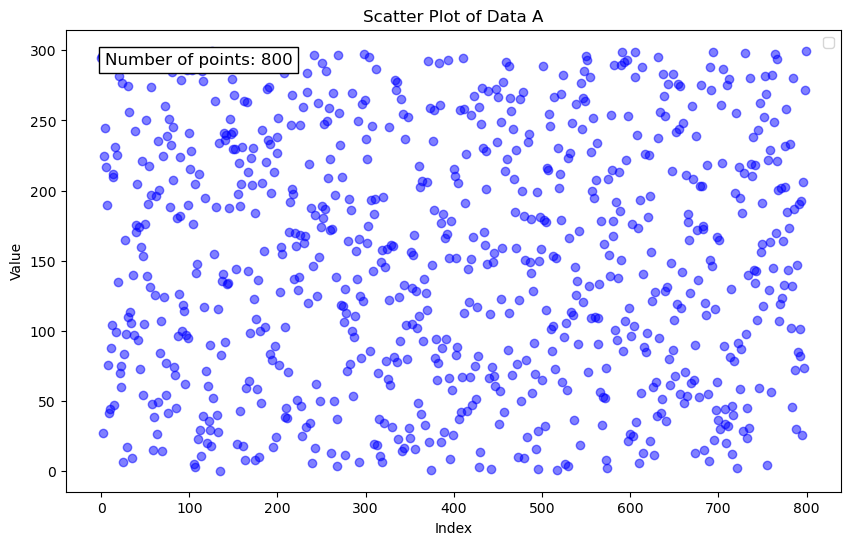

In [8]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


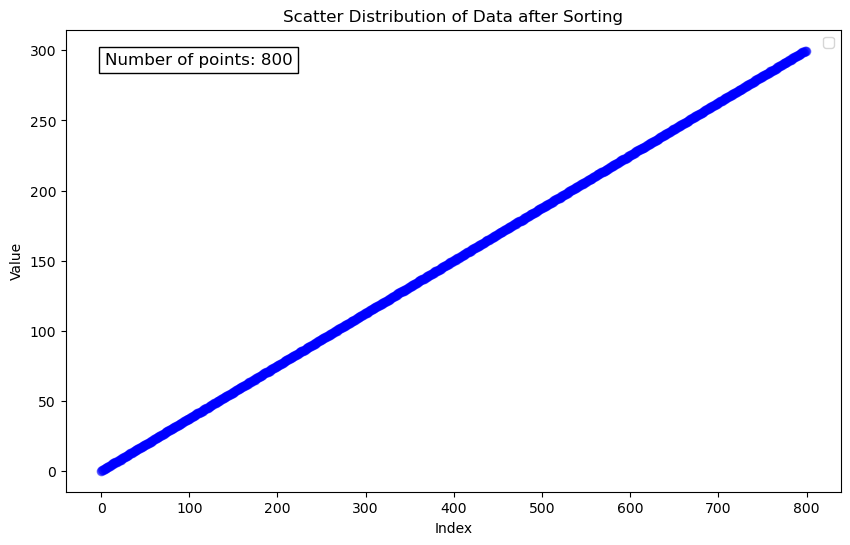

In [9]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0004956057615485381, 0.0004579731242784802, 0.00048500132663694876, 0.0005013752234597279, 0.000359763567058975, 0.000488935438107126, 0.0004843198676971831, 0.0004834466334679868, 0.00040752040032805475, 0.000329217667113283]
Error u of fuhe active learning(LHS sampling): 4.493159e-04
[0.0001556188776942094, 0.00014083595674714471, 0.00015119723295320208, 0.00015578981583199116, 0.00011274146033384123, 0.00015136867516717852, 0.00014879528444615252, 0.0001482276112410039, 0.00012684287253309707, 0.00012114693382867865]
MAE of fuhe active learning(LHS sampling): 1.412565e-04
[5.101697235011853e-08, 4.348852405488779e-08, 4.878619249536311e-08, 5.202059128450065e-08, 2.7730031782506266e-08, 4.9404602784767764e-08, 4.844595277307526e-08, 4.830659212921258e-08, 3.517487657923623e-08, 2.9358704987389298e-08]
MSE of fuhe active learning(LHS sampling): 4.337330e-08
[0.00013735474, 0.00064162695, 7.9554666e-05, 1.318947e-05, 0.0009741338, 8.410061e-05, 8.144518e-05, 0.00016590663, 0.000169

[0.0004956057615485381, 0.0004579731242784802, 0.00048500132663694876, 0.0005013752234597279, 0.000359763567058975, 0.000488935438107126, 0.0004843198676971831, 0.0004834466334679868, 0.00040752040032805475, 0.000329217667113283]
mean Error u: 4.493159e-04
Variance Error u: 3.435128e-09


/tmp/ipykernel_1415795/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


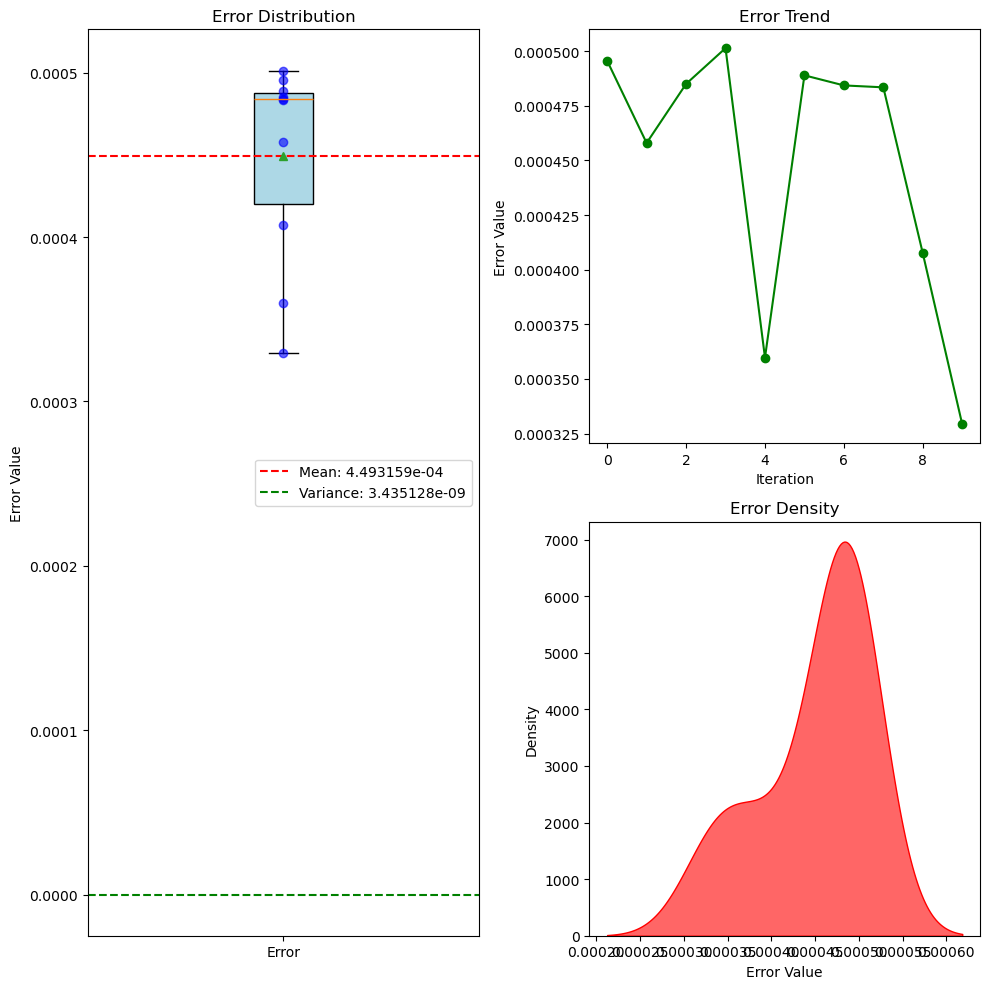

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0001556188776942094, 0.00014083595674714471, 0.00015119723295320208, 0.00015578981583199116, 0.00011274146033384123, 0.00015136867516717852, 0.00014879528444615252, 0.0001482276112410039, 0.00012684287253309707, 0.00012114693382867865]
mean MAE: 1.412565e-04
Variance MAE: 2.149431e-10


/tmp/ipykernel_1415795/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


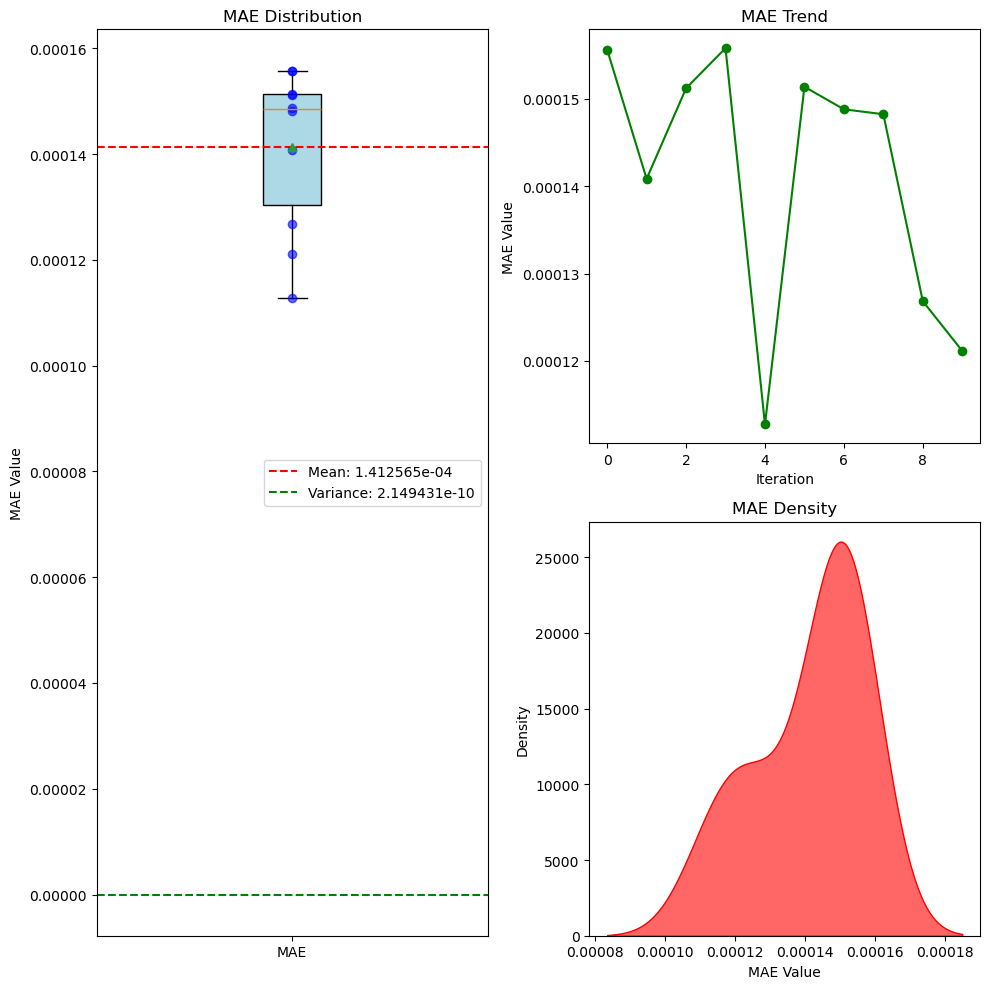

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[5.101697235011853e-08, 4.348852405488779e-08, 4.878619249536311e-08, 5.202059128450065e-08, 2.7730031782506266e-08, 4.9404602784767764e-08, 4.844595277307526e-08, 4.830659212921258e-08, 3.517487657923623e-08, 2.9358704987389298e-08]
mean MSE: 4.337330e-08
Variance MSE: 7.572947e-17


/tmp/ipykernel_1415795/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


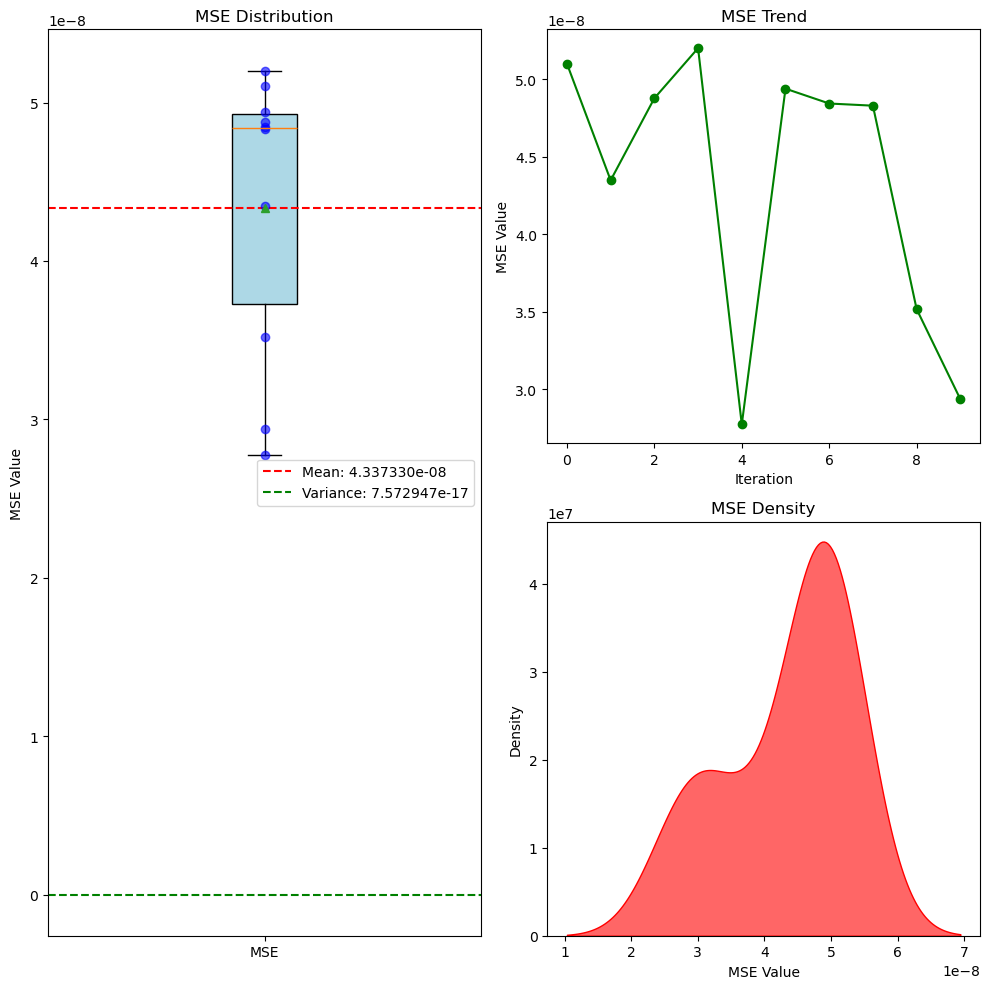

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00013735474, 0.00064162695, 7.9554666e-05, 1.318947e-05, 0.0009741338, 8.410061e-05, 8.144518e-05, 0.00016590663, 0.00016908921, 0.008741474]
mean CHAOS: 1.108787e-03
Variance CHAOS: 6.557509e-06


/tmp/ipykernel_1415795/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


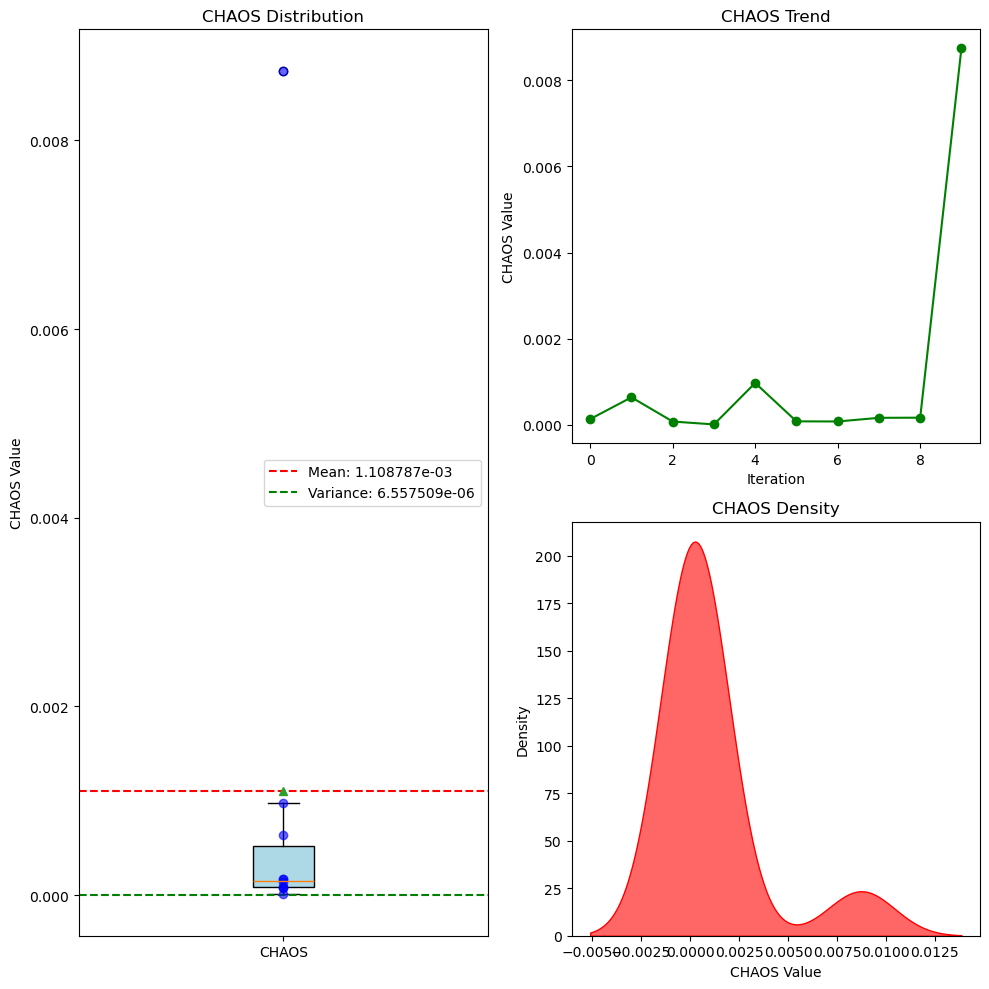

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[5.651432e-07, 4.4195463e-07, 5.2313874e-07, 4.1960902e-07, 4.7219282e-07, 4.4841e-07, 4.1501494e-07, 4.4978174e-07, 4.547312e-07, 4.8475704e-07]
mean RESIDUAL: 4.674734e-07
Variance RESIDUAL: 1.949188e-15


/tmp/ipykernel_1415795/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


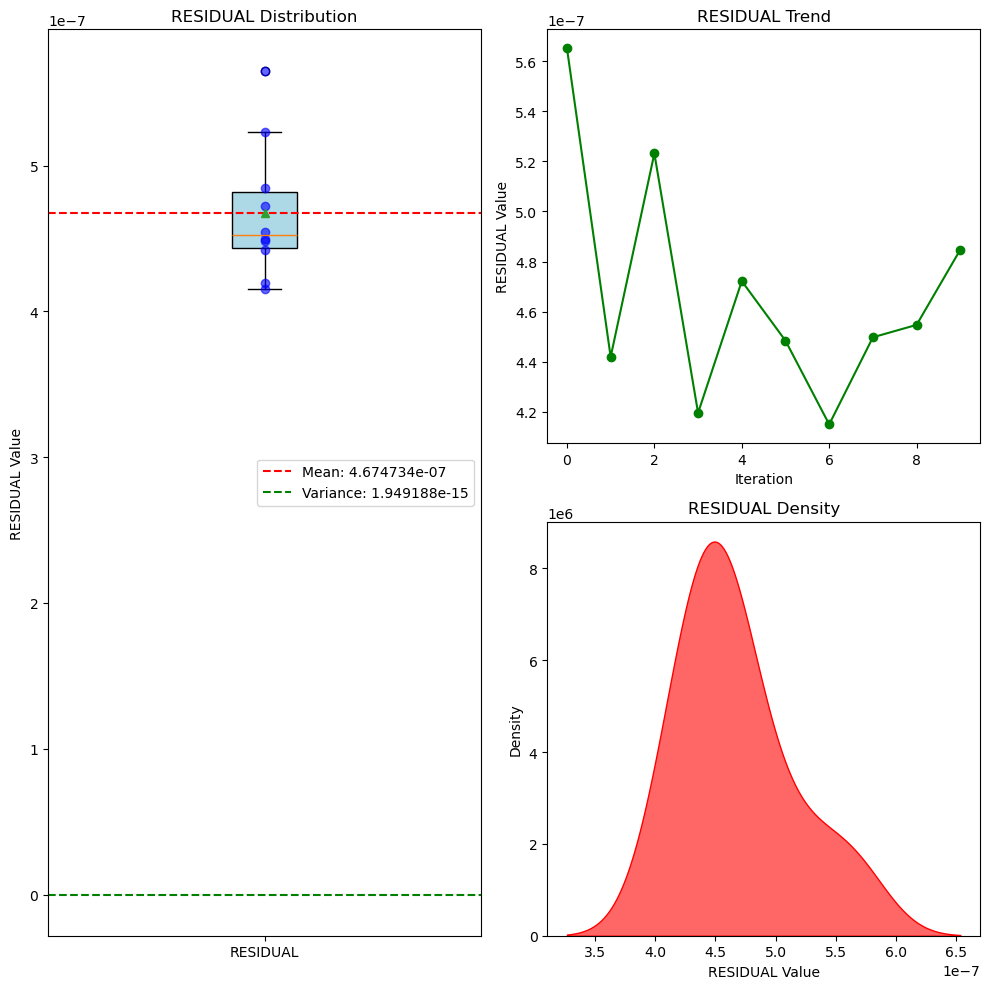

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9726568e-01 1.6817340e-01 1.4087625e-01 ... 2.7159983e-10 2.7758687e-10
 2.8431310e-10]


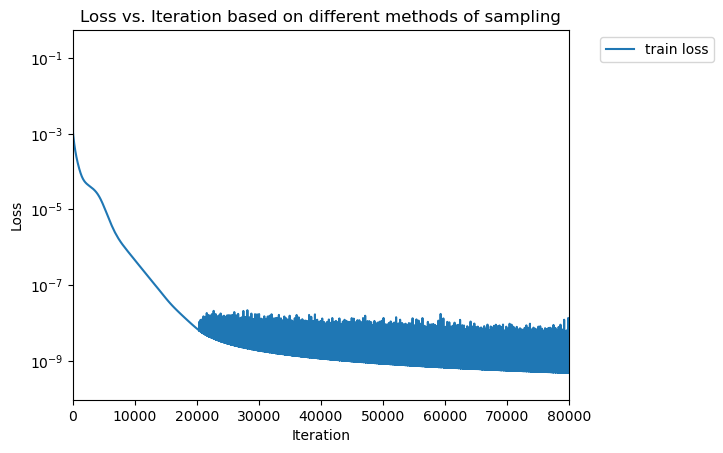

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

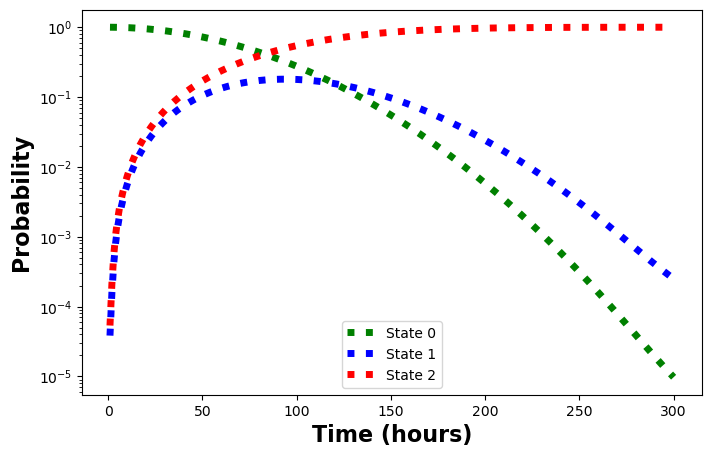

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

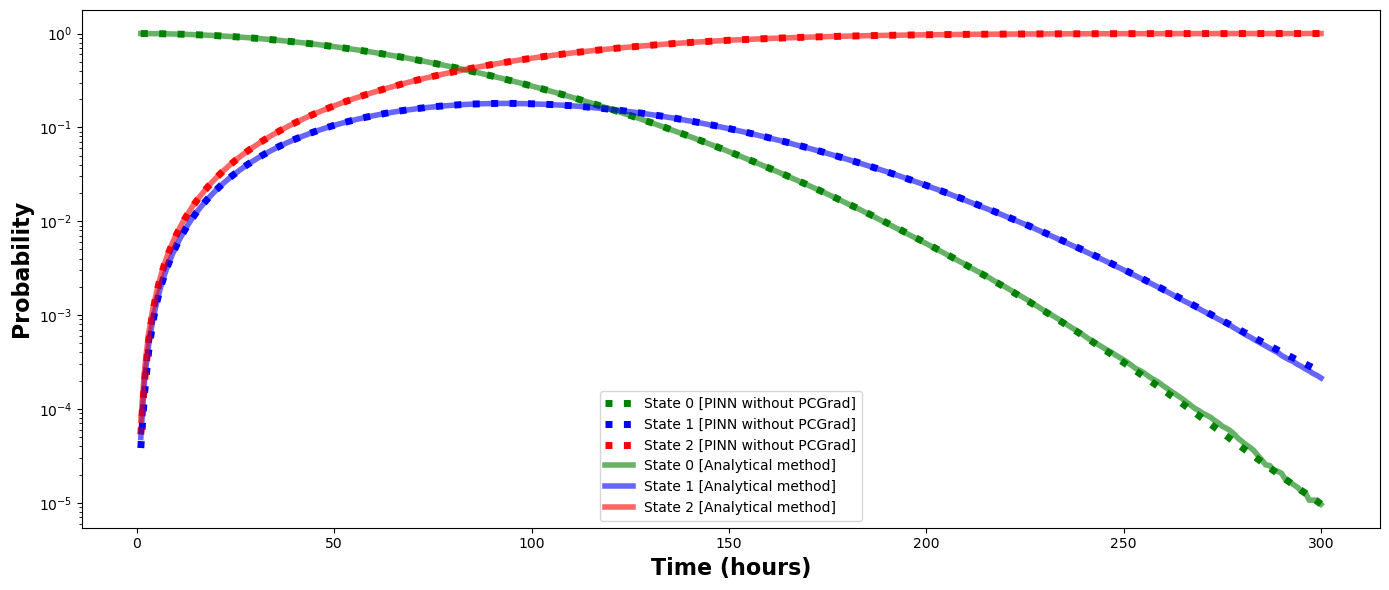

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999908  0.000038  0.000053
1  0.999638  0.000155  0.000207
2  0.999042  0.000414  0.000543
3  0.998116  0.000819  0.001065
4  0.996922  0.001340  0.001738
      state_0   state_1   state_2
295  0.000013  0.000301  0.999686
296  0.000012  0.000287  0.999701
297  0.000011  0.000274  0.999715
298  0.000010  0.000262  0.999728
299  0.000010  0.000250  0.999740


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002331589152605053
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002331589152605053
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[2.7976098 1.6894566 1.3162032 1.2522248 1.2331567 1.2283704 1.2303077
 1.2364994 1.2462296 1.2597028 1.2776194 1.3018311 1.3362153 1.3864791
 1.4523919 1.5269055 1.6145599 1.9526078 3.351121  3.1041987 3.0540307
 3.0100675 2.9917862 2.9873006 2.9805787 2.9642715 2.943628  2.926182
 2.915526  2.912359  2.9166834 2.927055  2.939375  2.9486833 2.9523003
 2.9512835 2.9492235 2.9499357 2.9554722 2.9658666 2.9799683 2.9961712
 3.0128217 3.0285492 3.0425115 3.0542321 3.0636394 3.0708869 3.0763125
 3.0801928 3.0828512 3.0844944 3.0853133 3.0854516 3.0851214 3.0846298
 3.084435  3.08513   3.087184  3.0909438 3.0964365 3.103582  3.112277
 3.1224039 3.133656  3.1455042 3.1572404 3.168109  3.1775854 3.1853533
 3.1913314 3.1955752 3.1982775 3.1996162 3.199807  3.1990368 3.1975083
 3.1954064 3.1929233 3.1901982 3.1874151 3.1847115 3.1822217 3.180048
 3.1782694 3.176939  3.1760824 3.1757064 3.1757853 3.176314  3.1772559
 3.17851   3.180081  3.1819084 3.1839485 3.1861658 3.1885207 3.1909845
 3.193564

Text(0.5, 1.0, 'Line Plot')

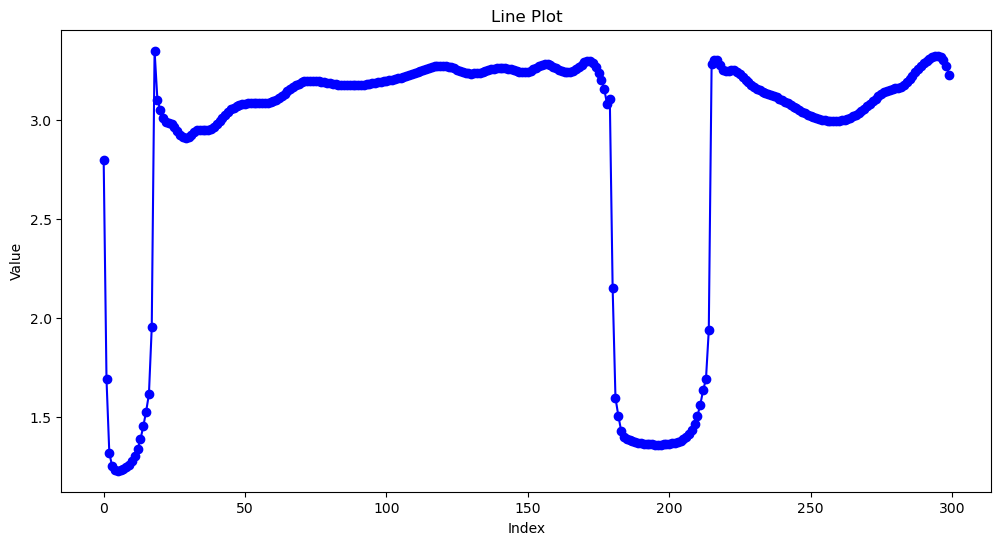

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 5.3791155e-08  1.1117663e-08 -3.4313416e-08 -5.9371814e-09
 -2.2002496e-08 -2.7357601e-09 -8.7311491e-09  3.2014214e-09
  1.6298145e-09 -1.0128133e-08  5.8207661e-10 -6.9849193e-10
 -1.0477379e-09  4.0745363e-09  1.1641532e-09  1.0477379e-09
 -8.1490725e-10 -5.8207661e-09  1.6298145e-09  2.3283064e-10
  2.3283064e-09 -1.6298145e-09  9.3132257e-10 -1.1641532e-09
 -2.3283064e-09  2.7939677e-09  1.3969839e-09 -6.9849193e-10
  1.1641532e-09  0.0000000e+00  0.0000000e+00  1.6298145e-09
 -1.3969839e-09  9.3132257e-10 -2.3283064e-09  2.5611371e-09
  1.3969839e-09  1.8626451e-09 -4.6566129e-10 -9.3132257e-10
  9.3132257e-10  9.3132257e-10 -1.1641532e-09 -9.3132257e-10
  9.3132257e-10  4.6566129e-10 -6.9849193e-10  6.9849193e-10
  9.3132257e-10 -9.3132257e-10  2.3283064e-10 -1.1641532e-09
  0.0000000e+00 -2.3283064e-10  2.3283064e-10 -9.3132257e-10
 -2.3283064e-10  1.6298145e-09  6.9849193e-10 -2.3283064e-10
 -1.8626451e-09 -2.3283064e-10  1.6298145e-09  0.0000000e+00
  6.9849193e-10 -6.98491

Text(0.5, 1.0, 'Line Plot')

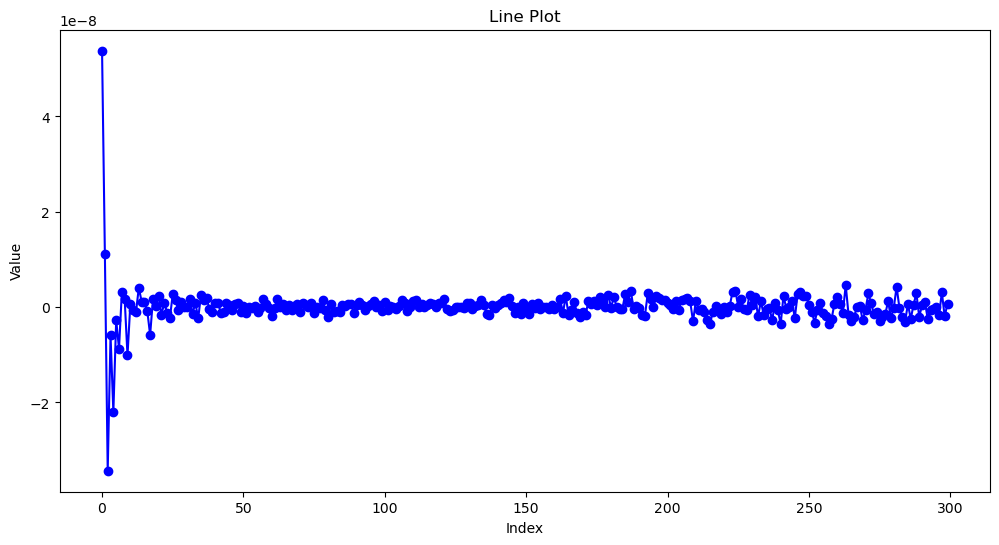

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')
